In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [5]:
from utilities.userfold_framework import *
from Models.AR_EEG_models import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet

from torch import nn
from Models.multi_models import *

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

# EPOCH=[
    
# ]

for i in range(len(participants)):

    train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                      raw_user_fold,
                                                                                      participants,
                                                                                      batch_size=batch_size,
                                                                                      transpose_channels=transpose_channels)

    classifier= EEGNet(
        chunk_size=input_dim[1],
        num_electrodes=input_dim[0],
        num_classes=classes,
        kernel_1= 32,
        kernel_2=32,
        F1=8,
        F2=16,
        dropout=0.5
    ).to(DEVICE)
    
#     resnet = ResNetPlus(input_dim[0], classes, bn_1st=False)
#     softmax_activation = nn.LogSoftmax(dim=1)
#     classifier = nn.Sequential(resnet, softmax_activation).to(DEVICE)

    
#     classifier = DataGliderBasic_Model(DEVICE, input_dim, classes)
#     classifier.to(DEVICE)
    
#     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)
    
    
    criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
#     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
        
    saved_dir= "./EEG/saved_models/Userfold/run0"
    model = EEGNet_DF_TS_Wrapper(DEVICE, classifier, input_dim[1]).to(DEVICE)
#     model= EEGNet_Wrapper(DEVICE, df)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

    
    train_func= eeg_DF_train
    model.training_procedure(iteration=n_epochs,
                                    train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader,
                                     print_cycle=2,
                                     path=f"./dictionary/intermdiate_dicts",
                                     loss_func=criterion,
                                     optimiser=optimizer, #scheduler=scheduler,
                                     train_func=train_func
                                    )
    if model.epoch == n_epochs+1:
        EPOCH= n_epochs
    else:
        EPOCH= model.epoch
    
    torch.save(model.state_dict(), 
           os.path.join(
               saved_dir, f"Userfold-{participants[i]}-EEGNet-DF_TS-e{EPOCH}.pt"
           )
    )

    pickle.dump( model.return_DF_weights(), 
                open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-DF_TS-w-e{EPOCH}.pkl", "wb") 
               )    

# OR
#     model.load_state_dict(
#     torch.load(
#         open(
#             os.path.join(
#                 saved_dir, f"Userfold-{participants[i]}-EEGNet-Weight_TS-e{n_epochs}.pt"
#             ), "rb"
#         )
#               )
#     )

    
    prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)
    
    ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])
    
    c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
    print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
    b_acc_list.append(b_acc)
    c0_acc_list.append(c0_acc)
    c1_acc_list.append(c1_acc)
    participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 102.8978718776329


Iterations:   0%|                                   | 1/300 [00:03<15:35,  3.13s/it]

Epoch:  0
t_loss:  102.8978718776329 , v_loss:  0.6952914595603943
t_acc:  0.389666977902272 , v_acc:  0.43478260869565216
t_recall:  0.5032157121093589 , v_recall:  0.48018018018018016
t_prec:  0.5040896475886265 , v_prec:  0.4818481848184818
t_f:  0.3842992469049049 , v_f:  0.4325936253437125
////////


Iterations:   1%|▏                                  | 2/300 [00:03<08:35,  1.73s/it]

Epoch  1 , loss 102.33022936652688
Epoch  2 , loss 101.7737829170975


Iterations:   1%|▎                                  | 3/300 [00:05<07:30,  1.52s/it]

Epoch:  2
t_loss:  101.7737829170975 , v_loss:  0.6974099079767863
t_acc:  0.4410208527855587 , v_acc:  0.4409937888198758
t_recall:  0.5024615363500363 , v_recall:  0.5176576576576577
t_prec:  0.5023098817690848 , v_prec:  0.5178571428571429
t_f:  0.44014614969671806 , v_f:  0.4409722222222222
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:04,  1.23s/it]

Epoch  3 , loss 101.21204795089423
Epoch  4 , loss 100.66570850447113


Iterations:   2%|▌                                  | 5/300 [00:07<06:05,  1.24s/it]

Epoch:  4
t_loss:  100.66570850447113 , v_loss:  0.694794217745463
t_acc:  0.49673202614379086 , v_acc:  0.4658385093167702
t_recall:  0.485574587227735 , v_recall:  0.49171171171171174
t_prec:  0.48775684931506846 , v_prec:  0.4927536231884058
t_f:  0.4715033164421374 , v_f:  0.45829420970266044
////////


Iterations:   2%|▋                                  | 6/300 [00:08<05:22,  1.10s/it]

Epoch  5 , loss 100.11525172813266
Epoch  6 , loss 99.56851630117379


Iterations:   2%|▊                                  | 7/300 [00:09<05:35,  1.15s/it]

Epoch:  6
t_loss:  99.56851630117379 , v_loss:  0.6822874744733175
t_acc:  0.5708061002178649 , v_acc:  0.5590062111801242
t_recall:  0.5020141090569715 , v_recall:  0.4933333333333333
t_prec:  0.5019490558202504 , v_prec:  0.49353598881900773
t_f:  0.5017710090225374 , v_f:  0.4932393492042382
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:00,  1.03s/it]

Epoch  7 , loss 99.02842787200329
Epoch  8 , loss 98.49106553021599


Iterations:   3%|█                                  | 9/300 [00:11<05:20,  1.10s/it]

Epoch:  8
t_loss:  98.49106553021599 , v_loss:  0.6659762859344482
t_acc:  0.6209150326797386 , v_acc:  0.6273291925465838
t_recall:  0.5049656194672046 , v_recall:  0.49342342342342344
t_prec:  0.5065302144249513 , v_prec:  0.48889902676399033
t_f:  0.49858625461254613 , v_f:  0.47362685265911075
////////


Iterations:   3%|█▏                                | 10/300 [00:12<04:47,  1.01it/s]

Epoch  9 , loss 97.95748497458065
Epoch  10 , loss 97.43394096224915


Iterations:   4%|█▏                                | 11/300 [00:13<05:12,  1.08s/it]

Epoch:  10
t_loss:  97.43394096224915 , v_loss:  0.6524417002995809
t_acc:  0.6601307189542484 , v_acc:  0.6832298136645962
t_recall:  0.5141763083130894 , v_recall:  0.5174774774774775
t_prec:  0.528145181067604 , v_prec:  0.570906432748538
t_f:  0.4929293875257539 , v_f:  0.4708384352645486
////////


Iterations:   4%|█▎                                | 12/300 [00:14<04:45,  1.01it/s]

Epoch  11 , loss 96.90511411779067
Epoch  12 , loss 96.38677469889323


Iterations:   4%|█▍                                | 13/300 [00:15<05:11,  1.09s/it]

Epoch:  12
t_loss:  96.38677469889323 , v_loss:  0.6425080100695292
t_acc:  0.6741363211951448 , v_acc:  0.6894409937888198
t_recall:  0.5038285228036947 , v_recall:  0.510990990990991
t_prec:  0.5136957268873868 , v_prec:  0.5971337579617835
t_f:  0.4569222411731991 , v_f:  0.4437534549474848
////////


Iterations:   5%|█▌                                | 14/300 [00:16<04:42,  1.01it/s]

Epoch  13 , loss 95.86830498190487
Epoch  14 , loss 95.35225991641774


Iterations:   5%|█▋                                | 15/300 [00:17<05:05,  1.07s/it]

Epoch:  14
t_loss:  95.35225991641774 , v_loss:  0.6373789608478546
t_acc:  0.6912542794895736 , v_acc:  0.6832298136645962
t_recall:  0.5098070298239112 , v_recall:  0.4954954954954955
t_prec:  0.566297906821387 , v_prec:  0.34375
t_f:  0.4487752775410362 , v_f:  0.40590405904059035
////////


Iterations:   5%|█▊                                | 16/300 [00:18<04:37,  1.02it/s]

Epoch  15 , loss 94.8486551022997
Epoch  16 , loss 94.34670526841107


Iterations:   6%|█▉                                | 17/300 [00:19<04:59,  1.06s/it]

Epoch:  16
t_loss:  94.34670526841107 , v_loss:  0.633662740389506
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5090734412099751 , v_recall:  0.5
t_prec:  0.60838297174709 , v_prec:  0.3447204968944099
t_f:  0.43841949556235266 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:20<04:32,  1.04it/s]

Epoch  17 , loss 93.84941849054074
Epoch  18 , loss 93.35011800130208


Iterations:   6%|██▏                               | 19/300 [00:21<04:56,  1.05s/it]

Epoch:  18
t_loss:  93.35011800130208 , v_loss:  0.6322752833366394
t_acc:  0.690631808278867 , v_acc:  0.6894409937888198
t_recall:  0.5007335886139361 , v_recall:  0.5
t_prec:  0.5110068505374721 , v_prec:  0.3447204968944099
t_f:  0.4226454756340245 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:22<04:30,  1.04it/s]

Epoch  19 , loss 92.86326673919079
Epoch  20 , loss 92.36653077368642


Iterations:   7%|██▍                               | 21/300 [00:23<04:52,  1.05s/it]

Epoch:  20
t_loss:  92.36653077368642 , v_loss:  0.6328739325205485
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5028753379723034 , v_recall:  0.5
t_prec:  0.5984184152834324 , v_prec:  0.3447204968944099
t_f:  0.4199316097190697 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:24<04:27,  1.04it/s]

Epoch  21 , loss 91.87967352773629
Epoch  22 , loss 91.39128187590954


Iterations:   8%|██▌                               | 23/300 [00:25<04:48,  1.04s/it]

Epoch:  22
t_loss:  91.39128187590954 , v_loss:  0.6339070300261179
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.50297141131744 , v_recall:  0.5
t_prec:  0.6561298076923077 , v_prec:  0.3447204968944099
t_f:  0.4183762417414505 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:26<04:25,  1.04it/s]

Epoch  23 , loss 90.89832560221355
Epoch  24 , loss 90.41630673875996


Iterations:   8%|██▊                               | 25/300 [00:27<04:47,  1.04s/it]

Epoch:  24
t_loss:  90.41630673875996 , v_loss:  0.6352118949095408
t_acc:  0.6940553999377529 , v_acc:  0.6894409937888198
t_recall:  0.5003191007534895 , v_recall:  0.5
t_prec:  0.5145403377110694 , v_prec:  0.3447204968944099
t_f:  0.4145695739864307 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:28<04:22,  1.04it/s]

Epoch  25 , loss 89.93221073524624
Epoch  26 , loss 89.45709004121669


Iterations:   9%|███                               | 27/300 [00:29<04:45,  1.05s/it]

Epoch:  26
t_loss:  89.45709004121669 , v_loss:  0.6363559166590372
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5014376689861517 , v_recall:  0.5
t_prec:  0.5981111458008117 , v_prec:  0.3447204968944099
t_f:  0.41513796302224715 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:30<04:21,  1.04it/s]

Epoch  27 , loss 88.97998226390166
Epoch  28 , loss 88.49317737654144


Iterations:  10%|███▎                              | 29/300 [00:31<04:43,  1.05s/it]

Epoch:  28
t_loss:  88.49317737654144 , v_loss:  0.6385563015937805
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.5039300860542677 , v_recall:  0.5
t_prec:  0.7236410496719775 , v_prec:  0.3447204968944099
t_f:  0.4196869355809753 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:32<04:19,  1.04it/s]

Epoch  29 , loss 88.02227020263672
Epoch  30 , loss 87.54773547602635


Iterations:  10%|███▌                              | 31/300 [00:33<04:45,  1.06s/it]

Epoch:  30
t_loss:  87.54773547602635 , v_loss:  0.6387055118878683
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.500862601391691 , v_recall:  0.5
t_prec:  0.5979887745556596 , v_prec:  0.3447204968944099
t_f:  0.4131921101460188 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:34<04:23,  1.02it/s]

Epoch  31 , loss 87.07110745299096
Epoch  32 , loss 86.59947698256549


Iterations:  11%|███▋                              | 33/300 [00:35<04:45,  1.07s/it]

Epoch:  32
t_loss:  86.59947698256549 , v_loss:  0.6391839186350504
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.4998401065041655 , v_recall:  0.5
t_prec:  0.47277189155500154 , v_prec:  0.3447204968944099
t_f:  0.41101098240032563 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:36<04:19,  1.03it/s]

Epoch  33 , loss 86.12471756280637
Epoch  34 , loss 85.6572904399797


Iterations:  12%|███▉                              | 35/300 [00:37<04:40,  1.06s/it]

Epoch:  34
t_loss:  85.6572904399797 , v_loss:  0.6395617226759592
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5005750675944607 , v_recall:  0.5
t_prec:  0.5979277033343721 , v_prec:  0.3447204968944099
t_f:  0.4122130008035903 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:38<04:16,  1.03it/s]

Epoch  35 , loss 85.18661424225452
Epoch  36 , loss 84.72061037549786


Iterations:  12%|████▏                             | 37/300 [00:39<04:37,  1.05s/it]

Epoch:  36
t_loss:  84.72061037549786 , v_loss:  0.636985977490743
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5013738488354538 , v_recall:  0.5
t_prec:  0.6338116032439176 , v_prec:  0.3447204968944099
t_f:  0.4142796235015772 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:40<04:12,  1.04it/s]

Epoch  37 , loss 84.2572208479339
Epoch  38 , loss 83.79710193708831


Iterations:  13%|████▍                             | 39/300 [00:41<04:35,  1.06s/it]

Epoch:  38
t_loss:  83.79710193708831 , v_loss:  0.6345586180686951
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.5009264215423889 , v_recall:  0.5
t_prec:  0.5702247191011236 , v_prec:  0.3447204968944099
t_f:  0.4140545234770159 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▌                             | 40/300 [00:42<04:10,  1.04it/s]

Epoch  39 , loss 83.33957657159543
Epoch  40 , loss 82.89063038545497


Iterations:  14%|████▋                             | 41/300 [00:43<04:33,  1.05s/it]

Epoch:  40
t_loss:  82.89063038545497 , v_loss:  0.6301696499188741
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5018850962792166 , v_recall:  0.5
t_prec:  0.6607059282371295 , v_prec:  0.3447204968944099
t_f:  0.4153651115618661 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▊                             | 42/300 [00:44<04:08,  1.04it/s]

Epoch  41 , loss 82.43962725471047
Epoch  42 , loss 81.98529366885914


Iterations:  14%|████▊                             | 43/300 [00:45<04:29,  1.05s/it]

Epoch:  42
t_loss:  81.98529366885914 , v_loss:  0.6284224092960358
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5010863150382235 , v_recall:  0.5
t_prec:  0.6480361596009975 , v_prec:  0.3447204968944099
t_f:  0.41330358142435736 , v_f:  0.4080882352941176
////////


Iterations:  15%|████▉                             | 44/300 [00:46<04:17,  1.00s/it]

Epoch  43 , loss 81.52750860476026
Epoch  44 , loss 81.08350925819546


Iterations:  15%|█████                             | 45/300 [00:47<04:36,  1.09s/it]

Epoch:  44
t_loss:  81.08350925819546 , v_loss:  0.6257572670777639
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5016613826326841 , v_recall:  0.5
t_prec:  0.6259363295880149 , v_prec:  0.3447204968944099
t_f:  0.41525155202966746 , v_f:  0.4080882352941176
////////


Iterations:  15%|█████▏                            | 46/300 [00:48<04:16,  1.01s/it]

Epoch  45 , loss 80.6371795055913
Epoch  46 , loss 80.18193443148743


Iterations:  16%|█████▎                            | 47/300 [00:49<04:32,  1.08s/it]

Epoch:  46
t_loss:  80.18193443148743 , v_loss:  0.6211238404115041
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.500862601391691 , v_recall:  0.5
t_prec:  0.5979887745556596 , v_prec:  0.3447204968944099
t_f:  0.4131921101460188 , v_f:  0.4080882352941176
////////


Iterations:  16%|█████▍                            | 48/300 [00:50<04:06,  1.02it/s]

Epoch  47 , loss 79.74068136776195
Epoch  48 , loss 79.28839814429189


Iterations:  16%|█████▌                            | 49/300 [00:51<04:25,  1.06s/it]

Epoch:  48
t_loss:  79.28839814429189 , v_loss:  0.6156105597813925
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5015975624819863 , v_recall:  0.5
t_prec:  0.6814780168381664 , v_prec:  0.3447204968944099
t_f:  0.4143921262806895 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▋                            | 50/300 [00:52<03:59,  1.04it/s]

Epoch  49 , loss 78.8451753504136
Epoch  50 , loss 78.39832919251685


Iterations:  17%|█████▊                            | 51/300 [00:53<04:21,  1.05s/it]

Epoch:  50
t_loss:  78.39832919251685 , v_loss:  0.613645613193512
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5014376689861517 , v_recall:  0.5
t_prec:  0.5981111458008117 , v_prec:  0.3447204968944099
t_f:  0.41513796302224715 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▉                            | 52/300 [00:54<03:59,  1.03it/s]

Epoch  51 , loss 77.96166558359184
Epoch  52 , loss 77.51777933158127


Iterations:  18%|██████                            | 53/300 [00:55<04:22,  1.06s/it]

Epoch:  52
t_loss:  77.51777933158127 , v_loss:  0.6095130145549774
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5032589451146704 , v_recall:  0.5
t_prec:  0.6484990619136961 , v_prec:  0.3447204968944099
t_f:  0.41933401285531013 , v_f:  0.4080882352941176
////////


Iterations:  18%|██████                            | 54/300 [00:56<04:02,  1.01it/s]

Epoch  53 , loss 77.07473111620136
Epoch  54 , loss 76.64125958610984


Iterations:  18%|██████▏                           | 55/300 [00:58<04:26,  1.09s/it]

Epoch:  54
t_loss:  76.64125958610984 , v_loss:  0.6032116413116455
t_acc:  0.6943666355431062 , v_acc:  0.6894409937888198
t_recall:  0.5002552806027916 , v_recall:  0.5
t_prec:  0.514526710402999 , v_prec:  0.3447204968944099
t_f:  0.4137166365643187 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▎                           | 56/300 [00:58<04:02,  1.00it/s]

Epoch  55 , loss 76.21513291901233
Epoch  56 , loss 75.78345594219132


Iterations:  19%|██████▍                           | 57/300 [01:00<04:24,  1.09s/it]

Epoch:  56
t_loss:  75.78345594219132 , v_loss:  0.602509876092275
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.50297141131744 , v_recall:  0.5
t_prec:  0.6561298076923077 , v_prec:  0.3447204968944099
t_f:  0.4183762417414505 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▌                           | 58/300 [01:00<03:59,  1.01it/s]

Epoch  57 , loss 75.35413809383617
Epoch  58 , loss 74.92890765620213


Iterations:  20%|██████▋                           | 59/300 [01:02<04:24,  1.10s/it]

Epoch:  58
t_loss:  74.92890765620213 , v_loss:  0.6016132831573486
t_acc:  0.6977902272019919 , v_acc:  0.6956521739130435
t_recall:  0.5047288672952608 , v_recall:  0.51
t_prec:  0.7154784240150094 , v_prec:  0.846875
t_f:  0.4217162322897499 , v_f:  0.42920193907821425
////////


Iterations:  20%|██████▊                           | 60/300 [01:03<03:59,  1.00it/s]

Epoch  59 , loss 74.50452916762409
Epoch  60 , loss 74.0778008255304


Iterations:  20%|██████▉                           | 61/300 [01:04<04:30,  1.13s/it]

Epoch:  60
t_loss:  74.0778008255304 , v_loss:  0.5953182876110077
t_acc:  0.6993464052287581 , v_acc:  0.6956521739130435
t_recall:  0.5078601721085354 , v_recall:  0.51
t_prec:  0.7244825964252117 , v_prec:  0.846875
t_f:  0.42891539928991573 , v_f:  0.42920193907821425
////////


Iterations:  21%|███████                           | 62/300 [01:05<04:04,  1.03s/it]

Epoch  61 , loss 73.6570053100586
Epoch  62 , loss 73.24286606732537


Iterations:  21%|███████▏                          | 63/300 [01:06<04:28,  1.13s/it]

Epoch:  62
t_loss:  73.24286606732537 , v_loss:  0.5909855564435323
t_acc:  0.6981014628073452 , v_acc:  0.6894409937888198
t_recall:  0.5049525809417933 , v_recall:  0.5054954954954954
t_prec:  0.7417161613004064 , v_prec:  0.5959119496855345
t_f:  0.4218358572666722 , v_f:  0.4266381766381766
////////


Iterations:  21%|███████▎                          | 64/300 [01:07<04:03,  1.03s/it]

Epoch  63 , loss 72.82853713690066
Epoch  64 , loss 72.40643400304458


Iterations:  22%|███████▎                          | 65/300 [01:08<04:23,  1.12s/it]

Epoch:  64
t_loss:  72.40643400304458 , v_loss:  0.5901299168666204
t_acc:  0.6993464052287581 , v_acc:  0.6956521739130435
t_recall:  0.5078601721085354 , v_recall:  0.5154954954954954
t_prec:  0.7244825964252117 , v_prec:  0.6814345991561181
t_f:  0.42891539928991573 , v_f:  0.44665778214210566
////////


Iterations:  22%|███████▍                          | 66/300 [01:09<04:01,  1.03s/it]

Epoch  65 , loss 71.98261919208602
Epoch  66 , loss 71.55906243417778


Iterations:  22%|███████▌                          | 67/300 [01:10<04:20,  1.12s/it]

Epoch:  66
t_loss:  71.55906243417778 , v_loss:  0.5869701653718948
t_acc:  0.7009025832555245 , v_acc:  0.7018633540372671
t_recall:  0.5115665445162707 , v_recall:  0.5254954954954955
t_prec:  0.7151482401797263 , v_prec:  0.7253184713375795
t_f:  0.4378003938337614 , v_f:  0.4660033167495854
////////


Iterations:  23%|███████▋                          | 68/300 [01:11<03:55,  1.02s/it]

Epoch  67 , loss 71.1484956928328
Epoch  68 , loss 70.72786802404067


Iterations:  23%|███████▊                          | 69/300 [01:13<04:16,  1.11s/it]

Epoch:  68
t_loss:  70.72786802404067 , v_loss:  0.5860070089499155
t_acc:  0.6984126984126984 , v_acc:  0.6956521739130435
t_recall:  0.5092017677495505 , v_recall:  0.5154954954954954
t_prec:  0.6546573678221019 , v_prec:  0.6814345991561181
t_f:  0.43492779051180885 , v_f:  0.44665778214210566
////////


Iterations:  23%|███████▉                          | 70/300 [01:13<03:53,  1.02s/it]

Epoch  69 , loss 70.31015373678768
Epoch  70 , loss 69.89510734408509


Iterations:  24%|████████                          | 71/300 [01:15<04:16,  1.12s/it]

Epoch:  70
t_loss:  69.89510734408509 , v_loss:  0.5845970114072164
t_acc:  0.7005913476501712 , v_acc:  0.7018633540372671
t_recall:  0.5119178984641989 , v_recall:  0.5254954954954955
t_prec:  0.695600756859035 , v_prec:  0.7253184713375795
t_f:  0.43945615982241953 , v_f:  0.4660033167495854
////////


Iterations:  24%|████████▏                         | 72/300 [01:16<03:58,  1.05s/it]

Epoch  71 , loss 69.47102326037837
Epoch  72 , loss 69.05797202914368


Iterations:  24%|████████▎                         | 73/300 [01:17<04:13,  1.12s/it]

Epoch:  72
t_loss:  69.05797202914368 , v_loss:  0.5817977786064148
t_acc:  0.699035169623405 , v_acc:  0.7080745341614907
t_recall:  0.5082115260564637 , v_recall:  0.540990990990991
t_prec:  0.6943878877144343 , v_prec:  0.711038961038961
t_f:  0.4306378692939789 , v_f:  0.4990400529625952
////////


Iterations:  25%|████████▍                         | 74/300 [01:18<03:53,  1.03s/it]

Epoch  73 , loss 68.63839796477673
Epoch  74 , loss 68.22961141548905


Iterations:  25%|████████▌                         | 75/300 [01:19<04:09,  1.11s/it]

Epoch:  74
t_loss:  68.22961141548905 , v_loss:  0.5810027122497559
t_acc:  0.7021475256769374 , v_acc:  0.7080745341614907
t_recall:  0.5124613991024005 , v_recall:  0.5464864864864865
t_prec:  0.7595626072041166 , v_prec:  0.6885964912280702
t_f:  0.4383405804844768 , v_f:  0.5123413030869368
////////


Iterations:  25%|████████▌                         | 76/300 [01:20<03:51,  1.03s/it]

Epoch  75 , loss 67.81427675134995
Epoch  76 , loss 67.40509556789024


Iterations:  26%|████████▋                         | 77/300 [01:21<04:07,  1.11s/it]

Epoch:  76
t_loss:  67.40509556789024 , v_loss:  0.5789263099431992
t_acc:  0.6987239340180517 , v_acc:  0.7080745341614907
t_recall:  0.5097130151933132 , v_recall:  0.5464864864864865
t_prec:  0.6594134342478714 , v_prec:  0.6885964912280702
t_f:  0.4359600443951166 , v_f:  0.5123413030869368
////////


Iterations:  26%|████████▊                         | 78/300 [01:22<03:51,  1.04s/it]

Epoch  77 , loss 66.9805773566751
Epoch  78 , loss 66.57391147987515


Iterations:  26%|████████▉                         | 79/300 [01:23<04:07,  1.12s/it]

Epoch:  78
t_loss:  66.57391147987515 , v_loss:  0.5765032917261124
t_acc:  0.7005913476501712 , v_acc:  0.7080745341614907
t_recall:  0.5116303646669687 , v_recall:  0.5464864864864865
t_prec:  0.7002994011976047 , v_prec:  0.6885964912280702
t_f:  0.4385626038990479 , v_f:  0.5123413030869368
////////


Iterations:  27%|█████████                         | 80/300 [01:24<03:50,  1.05s/it]

Epoch  79 , loss 66.15727847230201
Epoch  80 , loss 65.74695691875382


Iterations:  27%|█████████▏                        | 81/300 [01:26<04:09,  1.14s/it]

Epoch:  80
t_loss:  65.74695691875382 , v_loss:  0.5779787302017212
t_acc:  0.7015250544662309 , v_acc:  0.7018633540372671
t_recall:  0.5137391745927177 , v_recall:  0.5364864864864866
t_prec:  0.7018218841144608 , v_prec:  0.6654411764705883
t_f:  0.44341526636892 , v_f:  0.4952978056426333
////////


Iterations:  27%|█████████▎                        | 82/300 [01:26<03:51,  1.06s/it]

Epoch  81 , loss 65.33723030838311
Epoch  82 , loss 64.93531485164867


Iterations:  28%|█████████▍                        | 83/300 [01:28<04:07,  1.14s/it]

Epoch:  82
t_loss:  64.93531485164867 , v_loss:  0.5745806197325388
t_acc:  0.7005913476501712 , v_acc:  0.7142857142857143
t_recall:  0.5122054322614293 , v_recall:  0.5564864864864865
t_prec:  0.6913350928024327 , v_prec:  0.707615894039735
t_f:  0.4403460653194488 , v_f:  0.528880407124682
////////


Iterations:  28%|█████████▌                        | 84/300 [01:29<03:47,  1.06s/it]

Epoch  83 , loss 64.52729572969325
Epoch  84 , loss 64.12799977321251


Iterations:  28%|█████████▋                        | 85/300 [01:30<04:01,  1.12s/it]

Epoch:  84
t_loss:  64.12799977321251 , v_loss:  0.5733915567398071
t_acc:  0.7002801120448179 , v_acc:  0.7204968944099379
t_recall:  0.5119817186148968 , v_recall:  0.5664864864864865
t_prec:  0.6837121212121212 , v_prec:  0.7236363636363636
t_f:  0.4402083560615559 , v_f:  0.5449406444318825
////////


Iterations:  29%|█████████▋                        | 86/300 [01:31<03:50,  1.08s/it]

Epoch  85 , loss 63.707053988587624
Epoch  86 , loss 63.30286205516142


Iterations:  29%|█████████▊                        | 87/300 [01:32<04:03,  1.14s/it]

Epoch:  86
t_loss:  63.30286205516142 , v_loss:  0.5749896566073099
t_acc:  0.6981014628073452 , v_acc:  0.7080745341614907
t_recall:  0.5084029865085574 , v_recall:  0.5464864864864865
t_prec:  0.6522378781599669 , v_prec:  0.6885964912280702
t_f:  0.4329889967543336 , v_f:  0.5123413030869368
////////


Iterations:  29%|█████████▉                        | 88/300 [01:33<03:49,  1.08s/it]

Epoch  87 , loss 62.89185811959061
Epoch  88 , loss 62.49164917889763


Iterations:  30%|██████████                        | 89/300 [01:34<04:02,  1.15s/it]

Epoch:  88
t_loss:  62.49164917889763 , v_loss:  0.5744722137848536
t_acc:  0.7009025832555245 , v_acc:  0.7142857142857143
t_recall:  0.5132917472996528 , v_recall:  0.5564864864864865
t_prec:  0.6873984106917104 , v_prec:  0.707615894039735
t_f:  0.4431344619518238 , v_f:  0.528880407124682
////////


Iterations:  30%|██████████▏                       | 90/300 [01:35<03:44,  1.07s/it]

Epoch  89 , loss 62.09252346263212
Epoch  90 , loss 61.6973741568771


Iterations:  30%|██████████▎                       | 91/300 [01:37<03:57,  1.14s/it]

Epoch:  90
t_loss:  61.6973741568771 , v_loss:  0.5723033050696055
t_acc:  0.6996576408341114 , v_acc:  0.7142857142857143
t_recall:  0.5112467575246016 , v_recall:  0.5564864864864865
t_prec:  0.6724431818181819 , v_prec:  0.707615894039735
t_f:  0.4390457565933556 , v_f:  0.528880407124682
////////


Iterations:  31%|██████████▍                       | 92/300 [01:37<03:42,  1.07s/it]

Epoch  91 , loss 61.29314310410444
Epoch  92 , loss 60.88821283976237


Iterations:  31%|██████████▌                       | 93/300 [01:39<03:57,  1.15s/it]

Epoch:  92
t_loss:  60.88821283976237 , v_loss:  0.5684068550666174
t_acc:  0.6996576408341114 , v_acc:  0.7142857142857143
t_recall:  0.5103841561329105 , v_recall:  0.5564864864864865
t_prec:  0.6833648393194707 , v_prec:  0.707615894039735
t_f:  0.4363622085118706 , v_f:  0.528880407124682
////////


Iterations:  31%|██████████▋                       | 94/300 [01:40<03:44,  1.09s/it]

Epoch  93 , loss 60.49866156484566
Epoch  94 , loss 60.1010175966749


Iterations:  32%|██████████▊                       | 95/300 [01:41<04:01,  1.18s/it]

Epoch:  94
t_loss:  60.1010175966749 , v_loss:  0.5678838690121969
t_acc:  0.7018362900715842 , v_acc:  0.7142857142857143
t_recall:  0.5142504220364804 , v_recall:  0.5564864864864865
t_prec:  0.7050355450236967 , v_prec:  0.707615894039735
t_f:  0.44443469785575046 , v_f:  0.528880407124682
////////


Iterations:  32%|██████████▉                       | 96/300 [01:42<03:43,  1.09s/it]

Epoch  95 , loss 59.697095235188804
Epoch  96 , loss 59.30092112223307


Iterations:  32%|██████████▉                       | 97/300 [01:43<04:00,  1.18s/it]

Epoch:  96
t_loss:  59.30092112223307 , v_loss:  0.5662488639354706
t_acc:  0.7052598817304699 , v_acc:  0.7204968944099379
t_recall:  0.5192990763234103 , v_recall:  0.5664864864864865
t_prec:  0.7428723588001612 , v_prec:  0.7236363636363636
t_f:  0.45382733237251904 , v_f:  0.5449406444318825
////////


Iterations:  33%|███████████                       | 98/300 [01:45<03:57,  1.18s/it]

Epoch  97 , loss 58.91130230473537
Epoch  98 , loss 58.51030955595129


Iterations:  33%|███████████▏                      | 99/300 [01:46<04:17,  1.28s/it]

Epoch:  98
t_loss:  58.51030955595129 , v_loss:  0.5654791841904322
t_acc:  0.7037037037037037 , v_acc:  0.7204968944099379
t_recall:  0.5178929742935178 , v_recall:  0.5664864864864865
t_prec:  0.7137329908738183 , v_prec:  0.7236363636363636
t_f:  0.45222885222885223 , v_f:  0.5449406444318825
////////


Iterations:  33%|███████████                      | 100/300 [01:47<04:03,  1.22s/it]

Epoch  99 , loss 58.117259156470205
Epoch  100 , loss 57.726391063017005


Iterations:  34%|███████████                      | 101/300 [01:49<04:22,  1.32s/it]

Epoch:  100
t_loss:  57.726391063017005 , v_loss:  0.5679109940926234
t_acc:  0.7005913476501712 , v_acc:  0.7142857142857143
t_recall:  0.51278049985589 , v_recall:  0.5564864864864865
t_prec:  0.6838862559241705 , v_prec:  0.707615894039735
t_f:  0.4421150097465887 , v_f:  0.528880407124682
////////


Iterations:  34%|███████████▏                     | 102/300 [01:50<03:59,  1.21s/it]

Epoch  101 , loss 57.33555341234394
Epoch  102 , loss 56.938570508769914


Iterations:  34%|███████████▎                     | 103/300 [01:51<04:17,  1.31s/it]

Epoch:  102
t_loss:  56.938570508769914 , v_loss:  0.5651630014181137
t_acc:  0.702769996887644 , v_acc:  0.7204968944099379
t_recall:  0.5160716981649991 , v_recall:  0.5664864864864865
t_prec:  0.709756388822546 , v_prec:  0.7236363636363636
t_f:  0.4483495423160972 , v_f:  0.5449406444318825
////////


Iterations:  35%|███████████▍                     | 104/300 [01:52<03:48,  1.16s/it]

Epoch  103 , loss 56.5446699553845
Epoch  104 , loss 56.157384760239545


Iterations:  35%|███████████▌                     | 105/300 [01:53<03:57,  1.22s/it]

Epoch:  104
t_loss:  56.157384760239545 , v_loss:  0.5651856462160746
t_acc:  0.7021475256769374 , v_acc:  0.7267080745341615
t_recall:  0.5161993384663949 , v_recall:  0.5764864864864865
t_prec:  0.6902829874359167 , v_prec:  0.7374161073825503
t_f:  0.44978082250120915 , v_f:  0.5605459057071961
////////


Iterations:  35%|███████████▋                     | 106/300 [01:54<03:38,  1.13s/it]

Epoch  105 , loss 55.777660519469016
Epoch  106 , loss 55.38425647511202


Iterations:  36%|███████████▊                     | 107/300 [01:56<03:52,  1.21s/it]

Epoch:  106
t_loss:  55.38425647511202 , v_loss:  0.5624873787164688
t_acc:  0.7012138188608776 , v_acc:  0.7204968944099379
t_recall:  0.5138029947434155 , v_recall:  0.5664864864864865
t_prec:  0.6907745810938982 , v_prec:  0.7236363636363636
t_f:  0.44415210706372005 , v_f:  0.5449406444318825
////////


Iterations:  36%|███████████▉                     | 108/300 [01:57<03:34,  1.12s/it]

Epoch  107 , loss 55.00302872003294
Epoch  108 , loss 54.62346282659792


Iterations:  36%|███████████▉                     | 109/300 [01:58<03:47,  1.19s/it]

Epoch:  108
t_loss:  54.62346282659792 , v_loss:  0.5621580382188162
t_acc:  0.702769996887644 , v_acc:  0.7267080745341615
t_recall:  0.5175093671511508 , v_recall:  0.5764864864864865
t_prec:  0.6928571428571428 , v_prec:  0.7374161073825503
t_f:  0.4526341984218089 , v_f:  0.5605459057071961
////////


Iterations:  37%|████████████                     | 110/300 [01:59<03:31,  1.11s/it]

Epoch  109 , loss 54.24736531575521
Epoch  110 , loss 53.878919938031366


Iterations:  37%|████████████▏                    | 111/300 [02:00<03:42,  1.18s/it]

Epoch:  110
t_loss:  53.878919938031366 , v_loss:  0.5633403758207957
t_acc:  0.6993464052287581 , v_acc:  0.7204968944099379
t_recall:  0.5124607128642209 , v_recall:  0.5664864864864865
t_prec:  0.6540624010136205 , v_prec:  0.7236363636363636
t_f:  0.44330486027010435 , v_f:  0.5449406444318825
////////


Iterations:  37%|████████████▎                    | 112/300 [02:01<03:33,  1.14s/it]

Epoch  111 , loss 53.505726683373545
Epoch  112 , loss 53.13361822390089


Iterations:  38%|████████████▍                    | 113/300 [02:03<03:43,  1.20s/it]

Epoch:  112
t_loss:  53.13361822390089 , v_loss:  0.5656514565149943
t_acc:  0.7021475256769374 , v_acc:  0.7204968944099379
t_recall:  0.5156242708719342 , v_recall:  0.5664864864864865
t_prec:  0.6966261730669584 , v_prec:  0.7236363636363636
t_f:  0.4480599335591349 , v_f:  0.5449406444318825
////////


Iterations:  38%|████████████▌                    | 114/300 [02:03<03:19,  1.07s/it]

Epoch  113 , loss 52.76397817275103
Epoch  114 , loss 52.38477647070791


Iterations:  38%|████████████▋                    | 115/300 [02:05<03:43,  1.21s/it]

Epoch:  114
t_loss:  52.38477647070791 , v_loss:  0.5644531100988388
t_acc:  0.6987239340180517 , v_acc:  0.7204968944099379
t_recall:  0.511150684179465 , v_recall:  0.5664864864864865
t_prec:  0.6482825542063125 , v_prec:  0.7236363636363636
t_f:  0.4404010162148157 , v_f:  0.5449406444318825
////////


Iterations:  39%|████████████▊                    | 116/300 [02:06<03:28,  1.13s/it]

Epoch  115 , loss 52.02138429529526
Epoch  116 , loss 51.64615257113588


Iterations:  39%|████████████▊                    | 117/300 [02:07<03:48,  1.25s/it]

Epoch:  116
t_loss:  51.64615257113588 , v_loss:  0.5640649000803629
t_acc:  0.702769996887644 , v_acc:  0.7267080745341615
t_recall:  0.5163592319622294 , v_recall:  0.5764864864864865
t_prec:  0.7058754102135989 , v_prec:  0.7374161073825503
t_f:  0.44921341332181164 , v_f:  0.5605459057071961
////////


Iterations:  39%|████████████▉                    | 118/300 [02:08<03:29,  1.15s/it]

Epoch  117 , loss 51.28234519210516
Epoch  118 , loss 50.911125631893384


Iterations:  40%|█████████████                    | 119/300 [02:10<03:40,  1.22s/it]

Epoch:  118
t_loss:  50.911125631893384 , v_loss:  0.5640184581279755
t_acc:  0.7024587612822907 , v_acc:  0.7267080745341615
t_recall:  0.5149853831267757 , v_recall:  0.5764864864864865
t_prec:  0.7156101895734597 , v_prec:  0.7374161073825503
t_f:  0.44559454191033143 , v_f:  0.5605459057071961
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:11<03:24,  1.13s/it]

Epoch  119 , loss 50.555612451889935
Epoch  120 , loss 50.19346820606905


Iterations:  40%|█████████████▎                   | 121/300 [02:12<03:34,  1.20s/it]

Epoch:  120
t_loss:  50.19346820606905 , v_loss:  0.5645260562499365
t_acc:  0.7046374105197635 , v_acc:  0.7267080745341615
t_recall:  0.5185641152331151 , v_recall:  0.5764864864864865
t_prec:  0.7336231216535207 , v_prec:  0.7374161073825503
t_f:  0.4526738526098423 , v_f:  0.5605459057071961
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:13<03:22,  1.14s/it]

Epoch  121 , loss 49.8295399534936
Epoch  122 , loss 49.475757449280984


Iterations:  41%|█████████████▌                   | 123/300 [02:14<03:33,  1.21s/it]

Epoch:  122
t_loss:  49.475757449280984 , v_loss:  0.5643219649791718
t_acc:  0.7005913476501712 , v_acc:  0.7267080745341615
t_recall:  0.5142181688420416 , v_recall:  0.5764864864864865
t_prec:  0.6698371495710148 , v_prec:  0.7374161073825503
t_f:  0.44647495361781075 , v_f:  0.5605459057071961
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:15<03:19,  1.13s/it]

Epoch  123 , loss 49.111256767721734
Epoch  124 , loss 48.762649461334824


Iterations:  42%|█████████████▊                   | 125/300 [02:17<03:35,  1.23s/it]

Epoch:  124
t_loss:  48.762649461334824 , v_loss:  0.5640723804632822
t_acc:  0.7009025832555245 , v_acc:  0.7267080745341615
t_recall:  0.5144418824885741 , v_recall:  0.5764864864864865
t_prec:  0.6754802881729037 , v_prec:  0.7374161073825503
t_f:  0.4466187607364932 , v_f:  0.5605459057071961
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:18<03:21,  1.16s/it]

Epoch  125 , loss 48.406634536443974
Epoch  126 , loss 48.05225088082108


Iterations:  42%|█████████████▉                   | 127/300 [02:19<03:37,  1.26s/it]

Epoch:  126
t_loss:  48.05225088082108 , v_loss:  0.5633635222911835
t_acc:  0.7024587612822907 , v_acc:  0.7267080745341615
t_recall:  0.5172856535046183 , v_recall:  0.5764864864864865
t_prec:  0.6874776714830104 , v_prec:  0.7374161073825503
t_f:  0.4524852195885727 , v_f:  0.5605459057071961
////////


Iterations:  43%|██████████████                   | 128/300 [02:20<03:23,  1.19s/it]

Epoch  127 , loss 47.69411475985658
Epoch  128 , loss 47.34918078254251


Iterations:  43%|██████████████▏                  | 129/300 [02:22<03:35,  1.26s/it]

Epoch:  128
t_loss:  47.34918078254251 , v_loss:  0.5642797152201334
t_acc:  0.7055711173358232 , v_acc:  0.7329192546583851
t_recall:  0.518947722375482 , v_recall:  0.5864864864864865
t_prec:  0.7618811255137528 , v_prec:  0.7494802494802495
t_f:  0.4522582221690409 , v_f:  0.5757185757185757
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:23<03:21,  1.19s/it]

Epoch  129 , loss 46.99983656640146
Epoch  130 , loss 46.65677066877777


Iterations:  44%|██████████████▍                  | 131/300 [02:24<03:37,  1.29s/it]

Epoch:  130
t_loss:  46.65677066877777 , v_loss:  0.5647568553686142
t_acc:  0.7024587612822907 , v_acc:  0.7329192546583851
t_recall:  0.5164230521129274 , v_recall:  0.5864864864864865
t_prec:  0.6961746543526969 , v_prec:  0.7494802494802495
t_f:  0.44992729278443566 , v_f:  0.5757185757185757
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:25<03:16,  1.17s/it]

Epoch  131 , loss 46.3122683506386
Epoch  132 , loss 45.96716196396772


Iterations:  44%|██████████████▋                  | 133/300 [02:27<03:34,  1.28s/it]

Epoch:  132
t_loss:  45.96716196396772 , v_loss:  0.5660320619742075
t_acc:  0.7024587612822907 , v_acc:  0.7267080745341615
t_recall:  0.516135518315697 , v_recall:  0.5764864864864865
t_prec:  0.6994971491922711 , v_prec:  0.7374161073825503
t_f:  0.44906774991534126 , v_f:  0.5605459057071961
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:28<03:11,  1.15s/it]

Epoch  133 , loss 45.62974495981254
Epoch  134 , loss 45.28717467364143


Iterations:  45%|██████████████▊                  | 135/300 [02:29<03:26,  1.25s/it]

Epoch:  134
t_loss:  45.28717467364143 , v_loss:  0.5680247048536936
t_acc:  0.6996576408341114 , v_acc:  0.7204968944099379
t_recall:  0.5109592237273713 , v_recall:  0.5664864864864865
t_prec:  0.6757391240554618 , v_prec:  0.7236363636363636
t_f:  0.43815489883582603 , v_f:  0.5449406444318825
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:30<03:03,  1.12s/it]

Epoch  135 , loss 44.96263070200004
Epoch  136 , loss 44.61383266074985


Iterations:  46%|███████████████                  | 137/300 [02:31<03:22,  1.24s/it]

Epoch:  136
t_loss:  44.61383266074985 , v_loss:  0.5640407900015513
t_acc:  0.702769996887644 , v_acc:  0.7329192546583851
t_recall:  0.5157841643677687 , v_recall:  0.5864864864864865
t_prec:  0.7139468690702087 , v_prec:  0.7494802494802495
t_f:  0.4474821612914204 , v_f:  0.5757185757185757
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:32<03:01,  1.12s/it]

Epoch  137 , loss 44.280127357034125
Epoch  138 , loss 43.95063998652439


Iterations:  46%|███████████████▎                 | 139/300 [02:34<03:23,  1.26s/it]

Epoch:  138
t_loss:  43.95063998652439 , v_loss:  0.565866102774938
t_acc:  0.7009025832555245 , v_acc:  0.7329192546583851
t_recall:  0.5130042135024224 , v_recall:  0.5864864864864865
t_prec:  0.6910256582572815 , v_prec:  0.7494802494802495
t_f:  0.44225450571484054 , v_f:  0.5757185757185757
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:35<03:06,  1.16s/it]

Epoch  139 , loss 43.62328533097809
Epoch  140 , loss 43.289136325611786


Iterations:  47%|███████████████▌                 | 141/300 [02:36<03:26,  1.30s/it]

Epoch:  140
t_loss:  43.289136325611786 , v_loss:  0.5651538521051407
t_acc:  0.7012138188608776 , v_acc:  0.7329192546583851
t_recall:  0.5152406637295672 , v_recall:  0.5864864864864865
t_prec:  0.6760941960038059 , v_prec:  0.7494802494802495
t_f:  0.44848539464706416 , v_f:  0.5757185757185757
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:37<03:08,  1.19s/it]

Epoch  141 , loss 42.95686512367398
Epoch  142 , loss 42.629815419514976


Iterations:  48%|███████████████▋                 | 143/300 [02:39<03:21,  1.28s/it]

Epoch:  142
t_loss:  42.629815419514976 , v_loss:  0.5646537641684214
t_acc:  0.7024587612822907 , v_acc:  0.7391304347826086
t_recall:  0.5164230521129274 , v_recall:  0.5964864864864865
t_prec:  0.6961746543526969 , v_prec:  0.7602040816326531
t_f:  0.44992729278443566 , v_f:  0.5904796511627907
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:40<03:03,  1.18s/it]

Epoch  143 , loss 42.31135289809283
Epoch  144 , loss 41.98260408289292


Iterations:  48%|███████████████▉                 | 145/300 [02:41<03:15,  1.26s/it]

Epoch:  144
t_loss:  41.98260408289292 , v_loss:  0.5619855125745138
t_acc:  0.7037037037037037 , v_acc:  0.7515527950310559
t_recall:  0.5190431094824391 , v_recall:  0.6164864864864865
t_prec:  0.7004073143253315 , v_prec:  0.7786637931034484
t_f:  0.4556183446738169 , v_f:  0.618844696969697
////////


Iterations:  49%|████████████████                 | 146/300 [02:42<02:57,  1.15s/it]

Epoch  145 , loss 41.664089801264744
Epoch  146 , loss 41.34157809089212


Iterations:  49%|████████████████▏                | 147/300 [02:43<03:09,  1.24s/it]

Epoch:  146
t_loss:  41.34157809089212 , v_loss:  0.5645613074302673
t_acc:  0.702769996887644 , v_acc:  0.7453416149068323
t_recall:  0.5172218333539205 , v_recall:  0.6064864864864865
t_prec:  0.6957851377215611 , v_prec:  0.7698630136986302
t_f:  0.4517841672453898 , v_f:  0.604848847650404
////////


Iterations:  49%|████████████████▎                | 148/300 [02:44<02:49,  1.11s/it]

Epoch  147 , loss 41.03156437593348
Epoch  148 , loss 40.712647082758885


Iterations:  50%|████████████████▍                | 149/300 [02:46<03:00,  1.20s/it]

Epoch:  148
t_loss:  40.712647082758885 , v_loss:  0.5652668376763662
t_acc:  0.704014939309057 , v_acc:  0.7453416149068323
t_recall:  0.5175416203455895 , v_recall:  0.6064864864864865
t_prec:  0.7289407690470504 , v_prec:  0.7698630136986302
t_f:  0.45066012014932816 , v_f:  0.604848847650404
////////


Iterations:  50%|████████████████▌                | 150/300 [02:47<02:51,  1.14s/it]

Epoch  149 , loss 40.39937815946691
Epoch  150 , loss 40.082724328134574


Iterations:  50%|████████████████▌                | 151/300 [02:48<03:09,  1.27s/it]

Epoch:  150
t_loss:  40.082724328134574 , v_loss:  0.5686051100492477
t_acc:  0.704014939309057 , v_acc:  0.7329192546583851
t_recall:  0.5175416203455895 , v_recall:  0.5864864864864865
t_prec:  0.7289407690470504 , v_prec:  0.7494802494802495
t_f:  0.45066012014932816 , v_f:  0.5757185757185757
////////


Iterations:  51%|████████████████▋                | 152/300 [02:49<02:59,  1.21s/it]

Epoch  151 , loss 39.77008310953776
Epoch  152 , loss 39.46002870447495


Iterations:  51%|████████████████▊                | 153/300 [02:51<03:13,  1.32s/it]

Epoch:  152
t_loss:  39.46002870447495 , v_loss:  0.5674415727456411
t_acc:  0.7043261749144102 , v_acc:  0.7391304347826086
t_recall:  0.5183404015865827 , v_recall:  0.5964864864864865
t_prec:  0.7267579980994615 , v_prec:  0.7602040816326531
t_f:  0.4525254837024836 , v_f:  0.5904796511627907
////////


Iterations:  51%|████████████████▉                | 154/300 [02:52<02:58,  1.22s/it]

Epoch  153 , loss 39.15055742450789
Epoch  154 , loss 38.83793400783165


Iterations:  52%|█████████████████                | 155/300 [02:53<03:05,  1.28s/it]

Epoch:  154
t_loss:  38.83793400783165 , v_loss:  0.5699338565270106
t_acc:  0.7061935885465297 , v_acc:  0.7329192546583851
t_recall:  0.5208328186546987 , v_recall:  0.5864864864864865
t_prec:  0.748849663916061 , v_prec:  0.7494802494802495
t_f:  0.4568319711176855 , v_f:  0.5757185757185757
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:54<02:55,  1.22s/it]

Epoch  155 , loss 38.5337090585746
Epoch  156 , loss 38.22516617120481


Iterations:  52%|█████████████████▎               | 157/300 [02:56<03:01,  1.27s/it]

Epoch:  156
t_loss:  38.22516617120481 , v_loss:  0.5696195960044861
t_acc:  0.7015250544662309 , v_acc:  0.7329192546583851
t_recall:  0.5143142421871784 , v_recall:  0.5864864864864865
t_prec:  0.694022770398482 , v_prec:  0.7494802494802495
t_f:  0.445167950448662 , v_f:  0.5757185757185757
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:57<02:52,  1.21s/it]

Epoch  157 , loss 37.92035690008425
Epoch  158 , loss 37.61265915515376


Iterations:  53%|█████████████████▍               | 159/300 [02:58<02:56,  1.25s/it]

Epoch:  158
t_loss:  37.61265915515376 , v_loss:  0.5669994503259659
t_acc:  0.702769996887644 , v_acc:  0.7453416149068323
t_recall:  0.5154966305705384 , v_recall:  0.6064864864864865
t_prec:  0.7184847390283547 , v_prec:  0.7698630136986302
t_f:  0.44661124991050133 , v_f:  0.604848847650404
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:59<02:45,  1.19s/it]

Epoch  159 , loss 37.30197629741594
Epoch  160 , loss 37.00460015091242


Iterations:  54%|█████████████████▋               | 161/300 [03:01<02:54,  1.26s/it]

Epoch:  160
t_loss:  37.00460015091242 , v_loss:  0.5676682641108831
t_acc:  0.7021475256769374 , v_acc:  0.7453416149068323
t_recall:  0.5161993384663949 , v_recall:  0.6064864864864865
t_prec:  0.6902829874359167 , v_prec:  0.7698630136986302
t_f:  0.44978082250120915 , v_f:  0.604848847650404
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:02<02:40,  1.16s/it]

Epoch  161 , loss 36.69672962263519
Epoch  162 , loss 36.39893258786669


Iterations:  54%|█████████████████▉               | 163/300 [03:03<02:53,  1.27s/it]

Epoch:  162
t_loss:  36.39893258786669 , v_loss:  0.5694373846054077
t_acc:  0.7005913476501712 , v_acc:  0.7391304347826086
t_recall:  0.5145057026392721 , v_recall:  0.5964864864864865
t_prec:  0.6676022835394861 , v_prec:  0.7602040816326531
t_f:  0.4473364058859122 , v_f:  0.5904796511627907
////////


Iterations:  55%|██████████████████               | 164/300 [03:04<02:35,  1.14s/it]

Epoch  163 , loss 36.09955043418735
Epoch  164 , loss 35.799690844965916


Iterations:  55%|██████████████████▏              | 165/300 [03:06<02:51,  1.27s/it]

Epoch:  164
t_loss:  35.799690844965916 , v_loss:  0.5685536215702692
t_acc:  0.7005913476501712 , v_acc:  0.7391304347826086
t_recall:  0.5147932364365024 , v_recall:  0.5964864864864865
t_prec:  0.6655158116726897 , v_prec:  0.7602040816326531
t_f:  0.44819439287040475 , v_f:  0.5904796511627907
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:06<02:33,  1.15s/it]

Epoch  165 , loss 35.499315972421684
Epoch  166 , loss 35.19530374863569


Iterations:  56%|██████████████████▎              | 167/300 [03:08<02:50,  1.28s/it]

Epoch:  166
t_loss:  35.19530374863569 , v_loss:  0.5705399364233017
t_acc:  0.7037037037037037 , v_acc:  0.7391304347826086
t_recall:  0.5178929742935178 , v_recall:  0.5964864864864865
t_prec:  0.7137329908738183 , v_prec:  0.7602040816326531
t_f:  0.45222885222885223 , v_f:  0.5904796511627907
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:09<02:33,  1.16s/it]

Epoch  167 , loss 34.89707722383387
Epoch  168 , loss 34.602293276319315


Iterations:  56%|██████████████████▌              | 169/300 [03:10<02:46,  1.27s/it]

Epoch:  168
t_loss:  34.602293276319315 , v_loss:  0.5699126571416855
t_acc:  0.7002801120448179 , v_acc:  0.7391304347826086
t_recall:  0.5137069213982789 , v_recall:  0.5964864864864865
t_prec:  0.6665499299579747 , v_prec:  0.7602040816326531
t_f:  0.4454670828191914 , v_f:  0.5904796511627907
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:11<02:30,  1.16s/it]

Epoch  169 , loss 34.313198463589536
Epoch  170 , loss 34.01891656015434


Iterations:  57%|██████████████████▊              | 171/300 [03:13<02:44,  1.27s/it]

Epoch:  170
t_loss:  34.01891656015434 , v_loss:  0.5714965562025706
t_acc:  0.706504824151883 , v_acc:  0.7329192546583851
t_recall:  0.5227817350846131 , v_recall:  0.591981981981982
t_prec:  0.7295469631596416 , v_prec:  0.7331050228310503
t_f:  0.4620100134716831 , v_f:  0.5855731816821312
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:14<02:26,  1.15s/it]

Epoch  171 , loss 33.729004429835896
Epoch  172 , loss 33.43704298430798


Iterations:  58%|███████████████████              | 173/300 [03:15<02:36,  1.23s/it]

Epoch:  172
t_loss:  33.43704298430798 , v_loss:  0.574674611290296
t_acc:  0.7043261749144102 , v_acc:  0.7391304347826086
t_recall:  0.5192030029782737 , v_recall:  0.5964864864864865
t_prec:  0.7148549871520562 , v_prec:  0.7602040816326531
t_f:  0.4550776228969694 , v_f:  0.5904796511627907
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:16<02:29,  1.19s/it]

Epoch  173 , loss 33.155577865301396
Epoch  174 , loss 32.87074736052868


Iterations:  58%|███████████████████▎             | 175/300 [03:18<02:46,  1.33s/it]

Epoch:  174
t_loss:  32.87074736052868 , v_loss:  0.5732227712869644
t_acc:  0.7018362900715842 , v_acc:  0.7391304347826086
t_recall:  0.5142504220364804 , v_recall:  0.5964864864864865
t_prec:  0.7050355450236967 , v_prec:  0.7602040816326531
t_f:  0.44443469785575046 , v_f:  0.5904796511627907
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:19<02:35,  1.25s/it]

Epoch  175 , loss 32.57784734987745
Epoch  176 , loss 32.303947972316365


Iterations:  59%|███████████████████▍             | 177/300 [03:21<02:46,  1.36s/it]

Epoch:  176
t_loss:  32.303947972316365 , v_loss:  0.574061801036199
t_acc:  0.7049486461251168 , v_acc:  0.7391304347826086
t_recall:  0.519937964068569 , v_recall:  0.5964864864864865
t_prec:  0.7230781830652839 , v_prec:  0.7602040816326531
t_f:  0.4562248279013968 , v_f:  0.5904796511627907
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:22<02:32,  1.25s/it]

Epoch  177 , loss 32.01782802506989
Epoch  178 , loss 31.73832668977625


Iterations:  60%|███████████████████▋             | 179/300 [03:23<02:43,  1.35s/it]

Epoch:  178
t_loss:  31.73832668977625 , v_loss:  0.5764694263537725
t_acc:  0.7043261749144102 , v_acc:  0.7329192546583851
t_recall:  0.517765333992122 , v_recall:  0.5864864864864865
t_prec:  0.7362446158713163 , v_prec:  0.7494802494802495
t_f:  0.45080678244222616 , v_f:  0.5757185757185757
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:24<02:29,  1.25s/it]

Epoch  179 , loss 31.459443634631587
Epoch  180 , loss 31.172650729908664


Iterations:  60%|███████████████████▉             | 181/300 [03:26<02:40,  1.35s/it]

Epoch:  180
t_loss:  31.172650729908664 , v_loss:  0.5739290863275528
t_acc:  0.7021475256769374 , v_acc:  0.7391304347826086
t_recall:  0.5159118046691646 , v_recall:  0.5964864864864865
t_prec:  0.6933410046027617 , v_prec:  0.7602040816326531
t_f:  0.44892211657109676 , v_f:  0.5904796511627907
////////


Iterations:  61%|████████████████████             | 182/300 [03:27<02:27,  1.25s/it]

Epoch  181 , loss 30.896733527090035
Epoch  182 , loss 30.613599814620674


Iterations:  61%|████████████████████▏            | 183/300 [03:28<02:38,  1.36s/it]

Epoch:  182
t_loss:  30.613599814620674 , v_loss:  0.5759802609682083
t_acc:  0.7018362900715842 , v_acc:  0.7329192546583851
t_recall:  0.5159756248198625 , v_recall:  0.591981981981982
t_prec:  0.6845861084681255 , v_prec:  0.7331050228310503
t_f:  0.4496343834082161 , v_f:  0.5855731816821312
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:29<02:26,  1.27s/it]

Epoch  183 , loss 30.336236280553482
Epoch  184 , loss 30.06247071658864


Iterations:  62%|████████████████████▎            | 185/300 [03:31<02:34,  1.35s/it]

Epoch:  184
t_loss:  30.06247071658864 , v_loss:  0.5746048639218012
t_acc:  0.7049486461251168 , v_acc:  0.7329192546583851
t_recall:  0.5193628964741083 , v_recall:  0.591981981981982
t_prec:  0.7312913273949395 , v_prec:  0.7331050228310503
t_f:  0.4545304116732688 , v_f:  0.5855731816821312
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:32<02:23,  1.26s/it]

Epoch  185 , loss 29.78558360829073
Epoch  186 , loss 29.516849256029317


Iterations:  62%|████████████████████▌            | 187/300 [03:33<02:25,  1.29s/it]

Epoch:  186
t_loss:  29.516849256029317 , v_loss:  0.5782350450754166
t_acc:  0.702769996887644 , v_acc:  0.7267080745341615
t_recall:  0.5169342995566901 , v_recall:  0.581981981981982
t_prec:  0.6989160925593543 , v_prec:  0.7210884353741497
t_f:  0.45093070583976463 , v_f:  0.5709786821705426
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:34<02:15,  1.21s/it]

Epoch  187 , loss 29.241027757233265
Epoch  188 , loss 28.975378111297008


Iterations:  63%|████████████████████▊            | 189/300 [03:36<02:20,  1.26s/it]

Epoch:  188
t_loss:  28.975378111297008 , v_loss:  0.5789900819460551
t_acc:  0.7015250544662309 , v_acc:  0.7267080745341615
t_recall:  0.5134516407954873 , v_recall:  0.581981981981982
t_prec:  0.70625 , v_prec:  0.7210884353741497
t_f:  0.44253355499795644 , v_f:  0.5709786821705426
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:37<02:09,  1.18s/it]

Epoch  189 , loss 28.70840940288469
Epoch  190 , loss 28.440042570525524


Iterations:  64%|█████████████████████            | 191/300 [03:38<02:17,  1.26s/it]

Epoch:  190
t_loss:  28.440042570525524 , v_loss:  0.5791645894447962
t_acc:  0.7033924680983504 , v_acc:  0.7267080745341615
t_recall:  0.5170941930525247 , v_recall:  0.581981981981982
t_prec:  0.7151246473602395 , v_prec:  0.7210884353741497
t_f:  0.45036689308448846 , v_f:  0.5709786821705426
////////


Iterations:  64%|█████████████████████            | 192/300 [03:39<02:06,  1.17s/it]

Epoch  191 , loss 28.188781401690314
Epoch  192 , loss 27.914004344566195


Iterations:  64%|█████████████████████▏           | 193/300 [03:41<02:16,  1.27s/it]

Epoch:  192
t_loss:  27.914004344566195 , v_loss:  0.5774944374958674
t_acc:  0.7002801120448179 , v_acc:  0.7329192546583851
t_recall:  0.5137069213982789 , v_recall:  0.591981981981982
t_prec:  0.6665499299579747 , v_prec:  0.7331050228310503
t_f:  0.4454670828191914 , v_f:  0.5855731816821312
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:42<02:02,  1.16s/it]

Epoch  193 , loss 27.656459322162704
Epoch  194 , loss 27.402169807284487


Iterations:  65%|█████████████████████▍           | 195/300 [03:43<02:18,  1.32s/it]

Epoch:  194
t_loss:  27.402169807284487 , v_loss:  0.5788641721010208
t_acc:  0.707749766573296 , v_acc:  0.7391304347826086
t_recall:  0.5228139882790519 , v_recall:  0.601981981981982
t_prec:  0.7679809335468547 , v_prec:  0.7439655172413793
t_f:  0.4601297725482084 , v_f:  0.5997869318181819
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:44<02:03,  1.19s/it]

Epoch  195 , loss 27.160305060592353
Epoch  196 , loss 26.898605795467603


Iterations:  66%|█████████████████████▋           | 197/300 [03:46<02:15,  1.32s/it]

Epoch:  196
t_loss:  26.898605795467603 , v_loss:  0.577892338236173
t_acc:  0.7030812324929971 , v_acc:  0.7391304347826086
t_recall:  0.5185956821893744 , v_recall:  0.601981981981982
t_prec:  0.6900635930047695 , v_prec:  0.7439655172413793
t_f:  0.45531534541215607 , v_f:  0.5997869318181819
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:47<02:01,  1.19s/it]

Epoch  197 , loss 26.650157330082912
Epoch  198 , loss 26.39969133863262


Iterations:  66%|█████████████████████▉           | 199/300 [03:48<02:09,  1.28s/it]

Epoch:  198
t_loss:  26.39969133863262 , v_loss:  0.5815703868865967
t_acc:  0.6993464052287581 , v_acc:  0.7329192546583851
t_recall:  0.5124607128642209 , v_recall:  0.591981981981982
t_prec:  0.6540624010136205 , v_prec:  0.7331050228310503
t_f:  0.44330486027010435 , v_f:  0.5855731816821312
////////


Iterations:  67%|██████████████████████           | 200/300 [03:49<01:56,  1.17s/it]

Epoch  199 , loss 26.151676701564416
Epoch  200 , loss 25.913912081250956


Iterations:  67%|██████████████████████           | 201/300 [03:50<02:02,  1.24s/it]

Epoch:  200
t_loss:  25.913912081250956 , v_loss:  0.5808986574411392
t_acc:  0.7005913476501712 , v_acc:  0.7391304347826086
t_recall:  0.5124929660586597 , v_recall:  0.601981981981982
t_prec:  0.6874459439052183 , v_prec:  0.7439655172413793
t_f:  0.441232341609589 , v_f:  0.5997869318181819
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:51<01:53,  1.16s/it]

Epoch  201 , loss 25.66900447770661
Epoch  202 , loss 25.426919039557962


Iterations:  68%|██████████████████████▎          | 203/300 [03:53<02:04,  1.28s/it]

Epoch:  202
t_loss:  25.426919039557962 , v_loss:  0.5839473853508631
t_acc:  0.7052598817304699 , v_acc:  0.7267080745341615
t_recall:  0.5201616777151014 , v_recall:  0.581981981981982
t_prec:  0.7292065407339602 , v_prec:  0.7210884353741497
t_f:  0.4563765511846953 , v_f:  0.5709786821705426
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:54<01:51,  1.16s/it]

Epoch  203 , loss 25.184323067758598
Epoch  204 , loss 24.936805463304708


Iterations:  68%|██████████████████████▌          | 205/300 [03:55<02:02,  1.28s/it]

Epoch:  204
t_loss:  24.936805463304708 , v_loss:  0.5855476558208466
t_acc:  0.7071272953625894 , v_acc:  0.7204968944099379
t_recall:  0.522366560985987 , v_recall:  0.571981981981982
t_prec:  0.7542725929932595 , v_prec:  0.7076403326403327
t_f:  0.45982083913917454 , v_f:  0.555984555984556
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:56<01:50,  1.18s/it]

Epoch  205 , loss 24.706599142037184
Epoch  206 , loss 24.462284910912608


Iterations:  69%|██████████████████████▊          | 207/300 [03:58<02:02,  1.31s/it]

Epoch:  206
t_loss:  24.462284910912608 , v_loss:  0.5906154165665308
t_acc:  0.7046374105197635 , v_acc:  0.7204968944099379
t_recall:  0.5205768518137275 , v_recall:  0.5664864864864865
t_prec:  0.7073307334882177 , v_prec:  0.7236363636363636
t_f:  0.4585869594746843 , v_f:  0.5449406444318825
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:59<01:52,  1.22s/it]

Epoch  207 , loss 24.231731900981828
Epoch  208 , loss 23.98183598237879


Iterations:  70%|██████████████████████▉          | 209/300 [04:01<02:03,  1.36s/it]

Epoch:  208
t_loss:  23.98183598237879 , v_loss:  0.5868236124515533
t_acc:  0.7024587612822907 , v_acc:  0.7204968944099379
t_recall:  0.514410315532315 , v_recall:  0.5664864864864865
t_prec:  0.7258993373303881 , v_prec:  0.7236363636363636
t_f:  0.4438366304006165 , v_f:  0.5449406444318825
////////


Iterations:  70%|███████████████████████          | 210/300 [04:02<01:52,  1.25s/it]

Epoch  209 , loss 23.74691349852319
Epoch  210 , loss 23.513937146055934


Iterations:  70%|███████████████████████▏         | 211/300 [04:03<02:02,  1.38s/it]

Epoch:  210
t_loss:  23.513937146055934 , v_loss:  0.5885205964247385
t_acc:  0.7037037037037037 , v_acc:  0.7204968944099379
t_recall:  0.5167428391045964 , v_recall:  0.5664864864864865
t_prec:  0.731406892190958 , v_prec:  0.7236363636363636
t_f:  0.4487841728381891 , v_f:  0.5449406444318825
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:04<01:48,  1.23s/it]

Epoch  211 , loss 23.2773099787095
Epoch  212 , loss 23.042608896891277


Iterations:  71%|███████████████████████▍         | 213/300 [04:06<01:52,  1.29s/it]

Epoch:  212
t_loss:  23.042608896891277 , v_loss:  0.5877076983451843
t_acc:  0.7043261749144102 , v_acc:  0.7204968944099379
t_recall:  0.5192030029782737 , v_recall:  0.5664864864864865
t_prec:  0.7148549871520562 , v_prec:  0.7236363636363636
t_f:  0.4550776228969694 , v_f:  0.5449406444318825
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:07<01:45,  1.22s/it]

Epoch  213 , loss 22.805920320398666
Epoch  214 , loss 22.577223983465455


Iterations:  72%|███████████████████████▋         | 215/300 [04:08<01:48,  1.28s/it]

Epoch:  214
t_loss:  22.577223983465455 , v_loss:  0.5901208569606146
t_acc:  0.7024587612822907 , v_acc:  0.7204968944099379
t_recall:  0.516135518315697 , v_recall:  0.5664864864864865
t_prec:  0.6994971491922711 , v_prec:  0.7236363636363636
t_f:  0.44906774991534126 , v_f:  0.5449406444318825
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:09<01:44,  1.24s/it]

Epoch  215 , loss 22.348591972799863
Epoch  216 , loss 22.11373856488396


Iterations:  72%|███████████████████████▊         | 217/300 [04:11<01:45,  1.28s/it]

Epoch:  216
t_loss:  22.11373856488396 , v_loss:  0.5933926304181417
t_acc:  0.7033924680983504 , v_acc:  0.7142857142857143
t_recall:  0.5176692606469854 , v_recall:  0.5564864864864865
t_prec:  0.7075491976827919 , v_prec:  0.707615894039735
t_f:  0.45208058917832017 , v_f:  0.528880407124682
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:12<01:38,  1.20s/it]

Epoch  217 , loss 21.896260579427082
Epoch  218 , loss 21.666837767058727


Iterations:  73%|████████████████████████         | 219/300 [04:13<01:40,  1.24s/it]

Epoch:  218
t_loss:  21.666837767058727 , v_loss:  0.5935735106468201
t_acc:  0.702769996887644 , v_acc:  0.7142857142857143
t_recall:  0.514346495381617 , v_recall:  0.5564864864864865
t_prec:  0.741126626272568 , v_prec:  0.707615894039735
t_f:  0.44309188848171044 , v_f:  0.528880407124682
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:14<01:33,  1.16s/it]

Epoch  219 , loss 21.434510548909504
Epoch  220 , loss 21.211795619889802


Iterations:  74%|████████████████████████▎        | 221/300 [04:16<01:39,  1.26s/it]

Epoch:  220
t_loss:  21.211795619889802 , v_loss:  0.5933958292007446
t_acc:  0.7021475256769374 , v_acc:  0.7142857142857143
t_recall:  0.5159118046691646 , v_recall:  0.5564864864864865
t_prec:  0.6933410046027617 , v_prec:  0.707615894039735
t_f:  0.44892211657109676 , v_f:  0.528880407124682
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:16<01:30,  1.16s/it]

Epoch  221 , loss 20.995735729441922
Epoch  222 , loss 20.776748694625557


Iterations:  74%|████████████████████████▌        | 223/300 [04:18<01:38,  1.28s/it]

Epoch:  222
t_loss:  20.776748694625557 , v_loss:  0.5964284638563792
t_acc:  0.7037037037037037 , v_acc:  0.7080745341614907
t_recall:  0.5173179066990571 , v_recall:  0.5464864864864865
t_prec:  0.7219056663501108 , v_prec:  0.6885964912280702
t_f:  0.4505134904415759 , v_f:  0.5123413030869368
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:19<01:26,  1.14s/it]

Epoch  223 , loss 20.56047716327742
Epoch  224 , loss 20.346842036527747


Iterations:  75%|████████████████████████▊        | 225/300 [04:20<01:35,  1.27s/it]

Epoch:  224
t_loss:  20.346842036527747 , v_loss:  0.5954067558050156
t_acc:  0.7037037037037037 , v_acc:  0.7080745341614907
t_recall:  0.5170303729018267 , v_recall:  0.5464864864864865
t_prec:  0.7264710534640937 , v_prec:  0.6885964912280702
t_f:  0.44965058619473613 , v_f:  0.5123413030869368
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:21<01:24,  1.15s/it]

Epoch  225 , loss 20.139788234935086
Epoch  226 , loss 19.921187082926433


Iterations:  76%|████████████████████████▉        | 227/300 [04:23<01:32,  1.27s/it]

Epoch:  226
t_loss:  19.921187082926433 , v_loss:  0.5927469034989675
t_acc:  0.7009025832555245 , v_acc:  0.7080745341614907
t_recall:  0.5127166797051921 , v_recall:  0.5464864864864865
t_prec:  0.6949810606060607 , v_prec:  0.6885964912280702
t_f:  0.44137095552975625 , v_f:  0.5123413030869368
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:24<01:21,  1.14s/it]

Epoch  227 , loss 19.70255694669836
Epoch  228 , loss 19.49394267213111


Iterations:  76%|█████████████████████████▏       | 229/300 [04:25<01:31,  1.28s/it]

Epoch:  228
t_loss:  19.49394267213111 , v_loss:  0.5934032996495565
t_acc:  0.7037037037037037 , v_acc:  0.7018633540372671
t_recall:  0.5161677715101357 , v_recall:  0.541981981981982
t_prec:  0.742583160582639 , v_prec:  0.6543046357615894
t_f:  0.4470407372269529 , v_f:  0.5083969465648855
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:26<01:22,  1.18s/it]

Epoch  229 , loss 19.2803451313692
Epoch  230 , loss 19.07667739718568


Iterations:  77%|█████████████████████████▍       | 231/300 [04:28<01:28,  1.29s/it]

Epoch:  230
t_loss:  19.07667739718568 , v_loss:  0.5948821355899175
t_acc:  0.7018362900715842 , v_acc:  0.7080745341614907
t_recall:  0.5139628882392501 , v_recall:  0.5464864864864865
t_prec:  0.7095008305761865 , v_prec:  0.6885964912280702
t_f:  0.4435556998565346 , v_f:  0.5123413030869368
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:29<01:21,  1.20s/it]

Epoch  231 , loss 18.867647694606408
Epoch  232 , loss 18.65450612236472


Iterations:  78%|█████████████████████████▋       | 233/300 [04:30<01:26,  1.29s/it]

Epoch:  232
t_loss:  18.65450612236472 , v_loss:  0.5974032779534658
t_acc:  0.7021475256769374 , v_acc:  0.7080745341614907
t_recall:  0.5144741356830128 , v_recall:  0.5464864864864865
t_prec:  0.7126181099716402 , v_prec:  0.6885964912280702
t_f:  0.44457602702299936 , v_f:  0.5123413030869368
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:31<01:18,  1.19s/it]

Epoch  233 , loss 18.442480760462143
Epoch  234 , loss 18.238057379629097


Iterations:  78%|█████████████████████████▊       | 235/300 [04:33<01:21,  1.25s/it]

Epoch:  234
t_loss:  18.238057379629097 , v_loss:  0.5954844107230505
t_acc:  0.7018362900715842 , v_acc:  0.7080745341614907
t_recall:  0.5148254896309411 , v_recall:  0.5464864864864865
t_prec:  0.6971503662424257 , v_prec:  0.6885964912280702
t_f:  0.44618199745226594 , v_f:  0.5123413030869368
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:33<01:12,  1.13s/it]

Epoch  235 , loss 18.030208363252527
Epoch  236 , loss 17.828190523035385


Iterations:  79%|██████████████████████████       | 237/300 [04:35<01:16,  1.22s/it]

Epoch:  236
t_loss:  17.828190523035385 , v_loss:  0.5967655827601751
t_acc:  0.7015250544662309 , v_acc:  0.7080745341614907
t_recall:  0.5146017759844086 , v_recall:  0.5464864864864865
t_prec:  0.6905720085980416 , v_prec:  0.6885964912280702
t_f:  0.44603896448286623 , v_f:  0.5123413030869368
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:36<01:09,  1.12s/it]

Epoch  237 , loss 17.622962764665193
Epoch  238 , loss 17.422224680582683


Iterations:  80%|██████████████████████████▎      | 239/300 [04:37<01:16,  1.25s/it]

Epoch:  238
t_loss:  17.422224680582683 , v_loss:  0.5969084451595942
t_acc:  0.702769996887644 , v_acc:  0.7080745341614907
t_recall:  0.5152090967733081 , v_recall:  0.5464864864864865
t_prec:  0.7234143358288194 , v_prec:  0.6885964912280702
t_f:  0.4457367876770788 , v_f:  0.5123413030869368
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:38<01:09,  1.16s/it]

Epoch  239 , loss 17.21768237095253
Epoch  240 , loss 17.01284580604703


Iterations:  80%|██████████████████████████▌      | 241/300 [04:40<01:16,  1.29s/it]

Epoch:  240
t_loss:  17.01284580604703 , v_loss:  0.5959711670875549
t_acc:  0.7024587612822907 , v_acc:  0.7018633540372671
t_recall:  0.5149853831267757 , v_recall:  0.541981981981982
t_prec:  0.7156101895734597 , v_prec:  0.6543046357615894
t_f:  0.44559454191033143 , v_f:  0.5083969465648855
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:41<01:11,  1.24s/it]

Epoch  241 , loss 16.805977279064702
Epoch  242 , loss 16.612885867848117


Iterations:  81%|██████████████████████████▋      | 243/300 [04:43<01:17,  1.36s/it]

Epoch:  242
t_loss:  16.612885867848117 , v_loss:  0.5975975543260574
t_acc:  0.7009025832555245 , v_acc:  0.7018633540372671
t_recall:  0.5124291459079617 , v_recall:  0.5364864864864866
t_prec:  0.6993103954221994 , v_prec:  0.6654411764705883
t_f:  0.4404837904468692 , v_f:  0.4952978056426333
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:44<01:11,  1.27s/it]

Epoch  243 , loss 16.402349733838847
Epoch  244 , loss 16.2132428113152


Iterations:  82%|██████████████████████████▉      | 245/300 [04:45<01:14,  1.36s/it]

Epoch:  244
t_loss:  16.2132428113152 , v_loss:  0.599458043773969
t_acc:  0.6996576408341114 , v_acc:  0.7018633540372671
t_recall:  0.50980908853845 , v_recall:  0.5364864864864866
t_prec:  0.6927627438640654 , v_prec:  0.6654411764705883
t_f:  0.4345547418019834 , v_f:  0.4952978056426333
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:46<01:07,  1.25s/it]

Epoch  245 , loss 16.01399591857312
Epoch  246 , loss 15.817012431574803


Iterations:  82%|███████████████████████████▏     | 247/300 [04:48<01:09,  1.31s/it]

Epoch:  246
t_loss:  15.817012431574803 , v_loss:  0.5997013797362646
t_acc:  0.7046374105197635 , v_acc:  0.7018633540372671
t_recall:  0.5185641152331151 , v_recall:  0.5364864864864866
t_prec:  0.7336231216535207 , v_prec:  0.6654411764705883
t_f:  0.4526738526098423 , v_f:  0.4952978056426333
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:49<01:04,  1.24s/it]

Epoch  247 , loss 15.628985292771283
Epoch  248 , loss 15.437089041167615


Iterations:  83%|███████████████████████████▍     | 249/300 [04:50<01:05,  1.27s/it]

Epoch:  248
t_loss:  15.437089041167615 , v_loss:  0.6007133275270462
t_acc:  0.7021475256769374 , v_acc:  0.7018633540372671
t_recall:  0.5156242708719342 , v_recall:  0.5364864864864866
t_prec:  0.6966261730669584 , v_prec:  0.6654411764705883
t_f:  0.4480599335591349 , v_f:  0.4952978056426333
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:51<01:00,  1.20s/it]

Epoch  249 , loss 15.245176334007114
Epoch  250 , loss 15.061176000856886


Iterations:  84%|███████████████████████████▌     | 251/300 [04:52<01:00,  1.24s/it]

Epoch:  250
t_loss:  15.061176000856886 , v_loss:  0.6002266754706701
t_acc:  0.7021475256769374 , v_acc:  0.7018633540372671
t_recall:  0.5153367370747038 , v_recall:  0.5364864864864866
t_prec:  0.7001641987102938 , v_prec:  0.6654411764705883
t_f:  0.44719425339948166 , v_f:  0.4952978056426333
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:53<00:56,  1.17s/it]

Epoch  251 , loss 14.871204750210632
Epoch  252 , loss 14.675711295183968


Iterations:  84%|███████████████████████████▊     | 253/300 [04:55<00:57,  1.22s/it]

Epoch:  252
t_loss:  14.675711295183968 , v_loss:  0.5995578418175379
t_acc:  0.702769996887644 , v_acc:  0.7018633540372671
t_recall:  0.5140589615843867 , v_recall:  0.5364864864864866
t_prec:  0.7482550530754689 , v_prec:  0.6654411764705883
t_f:  0.4422030146412812 , v_f:  0.4952978056426333
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:56<00:53,  1.16s/it]

Epoch  253 , loss 14.503434910493738
Epoch  254 , loss 14.31654219533883


Iterations:  85%|████████████████████████████     | 255/300 [04:57<00:55,  1.24s/it]

Epoch:  254
t_loss:  14.31654219533883 , v_loss:  0.6006587892770767
t_acc:  0.7043261749144102 , v_acc:  0.7018633540372671
t_recall:  0.5174778001948916 , v_recall:  0.5364864864864866
t_prec:  0.7415649699652229 , v_prec:  0.6654411764705883
t_f:  0.4499421892818063 , v_f:  0.4952978056426333
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:58<00:52,  1.19s/it]

Epoch  255 , loss 14.135803877138624
Epoch  256 , loss 13.9556251039692


Iterations:  86%|████████████████████████████▎    | 257/300 [05:00<00:57,  1.34s/it]

Epoch:  256
t_loss:  13.9556251039692 , v_loss:  0.602445031205813
t_acc:  0.7018362900715842 , v_acc:  0.7018633540372671
t_recall:  0.5139628882392501 , v_recall:  0.5364864864864866
t_prec:  0.7095008305761865 , v_prec:  0.6654411764705883
t_f:  0.4435556998565346 , v_f:  0.4952978056426333
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:01<00:50,  1.20s/it]

Epoch  257 , loss 13.78006918290082
Epoch  258 , loss 13.598377358679677


Iterations:  86%|████████████████████████████▍    | 259/300 [05:02<00:54,  1.32s/it]

Epoch:  258
t_loss:  13.598377358679677 , v_loss:  0.6017001022895178
t_acc:  0.702769996887644 , v_acc:  0.7018633540372671
t_recall:  0.5157841643677687 , v_recall:  0.5364864864864866
t_prec:  0.7139468690702087 , v_prec:  0.6654411764705883
t_f:  0.4474821612914204 , v_f:  0.4952978056426333
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:03<00:47,  1.19s/it]

Epoch  259 , loss 13.420555694430481
Epoch  260 , loss 13.245236284592572


Iterations:  87%|████████████████████████████▋    | 261/300 [05:05<00:50,  1.29s/it]

Epoch:  260
t_loss:  13.245236284592572 , v_loss:  0.6016839941342672
t_acc:  0.702769996887644 , v_acc:  0.7018633540372671
t_recall:  0.5140589615843867 , v_recall:  0.5364864864864866
t_prec:  0.7482550530754689 , v_prec:  0.6654411764705883
t_f:  0.4422030146412812 , v_f:  0.4952978056426333
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:06<00:44,  1.17s/it]

Epoch  261 , loss 13.068612734476725
Epoch  262 , loss 12.900362893646838


Iterations:  88%|████████████████████████████▉    | 263/300 [05:07<00:46,  1.27s/it]

Epoch:  262
t_loss:  12.900362893646838 , v_loss:  0.6031515647967657
t_acc:  0.6999688764394647 , v_acc:  0.7018633540372671
t_recall:  0.5123330725628251 , v_recall:  0.5364864864864866
t_prec:  0.6704584255453683 , v_prec:  0.6654411764705883
t_f:  0.4418360741764856 , v_f:  0.4952978056426333
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:08<00:41,  1.15s/it]

Epoch  263 , loss 12.723808157677745
Epoch  264 , loss 12.554181024140002


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:10<00:43,  1.24s/it]

Epoch:  264
t_loss:  12.554181024140002 , v_loss:  0.6027276714642843
t_acc:  0.7055711173358232 , v_acc:  0.7018633540372671
t_recall:  0.5200978575644034 , v_recall:  0.5364864864864866
t_prec:  0.7400704956555003 , v_prec:  0.6654411764705883
t_f:  0.45568119139547714 , v_f:  0.4952978056426333
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:11<00:39,  1.15s/it]

Epoch  265 , loss 12.387941958857517
Epoch  266 , loss 12.209306062436571


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:12<00:41,  1.25s/it]

Epoch:  266
t_loss:  12.209306062436571 , v_loss:  0.6039201219876608
t_acc:  0.704014939309057 , v_acc:  0.7018633540372671
t_recall:  0.5152413499677468 , v_recall:  0.5364864864864866
t_prec:  0.7835029613996869 , v_prec:  0.6654411764705883
t_f:  0.44365054582300417 , v_f:  0.4952978056426333
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:13<00:36,  1.13s/it]

Epoch  267 , loss 12.041884422302246
Epoch  268 , loss 11.864619928247789


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:14<00:38,  1.23s/it]

Epoch:  268
t_loss:  11.864619928247789 , v_loss:  0.603386715054512
t_acc:  0.7030812324929971 , v_acc:  0.7018633540372671
t_recall:  0.5162954118115316 , v_recall:  0.5364864864864866
t_prec:  0.716697491056871 , v_prec:  0.6654411764705883
t_f:  0.4484943899472461 , v_f:  0.4952978056426333
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:15<00:33,  1.13s/it]

Epoch  269 , loss 11.696161775028004
Epoch  270 , loss 11.5213430816052


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:17<00:35,  1.21s/it]

Epoch:  270
t_loss:  11.5213430816052 , v_loss:  0.6023747970660528
t_acc:  0.706504824151883 , v_acc:  0.7018633540372671
t_recall:  0.5207689985040008 , v_recall:  0.5364864864864866
t_prec:  0.7613708330934423 , v_prec:  0.6654411764705883
t_f:  0.4561342918978727 , v_f:  0.4952978056426333
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:18<00:31,  1.14s/it]

Epoch  271 , loss 11.348252857432646
Epoch  272 , loss 11.183166354310279


Iterations:  91%|██████████████████████████████   | 273/300 [05:19<00:33,  1.24s/it]

Epoch:  272
t_loss:  11.183166354310279 , v_loss:  0.6009725034236908
t_acc:  0.702769996887644 , v_acc:  0.7018633540372671
t_recall:  0.5149215629760777 , v_recall:  0.5364864864864866
t_prec:  0.7287878787878788 , v_prec:  0.6654411764705883
t_f:  0.44485875393435714 , v_f:  0.4952978056426333
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:20<00:30,  1.17s/it]

Epoch  273 , loss 11.011712504368202
Epoch  274 , loss 10.84702506719851


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:22<00:31,  1.27s/it]

Epoch:  274
t_loss:  10.84702506719851 , v_loss:  0.6045934210220972
t_acc:  0.7002801120448179 , v_acc:  0.7018633540372671
t_recall:  0.5128443200065879 , v_recall:  0.5364864864864866
t_prec:  0.6740986717267552 , v_prec:  0.6654411764705883
t_f:  0.44285373960590346 , v_f:  0.4952978056426333
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:23<00:28,  1.20s/it]

Epoch  275 , loss 10.678654203227921
Epoch  276 , loss 10.517463665382534


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:24<00:30,  1.31s/it]

Epoch:  276
t_loss:  10.517463665382534 , v_loss:  0.6052278528610865
t_acc:  0.7021475256769374 , v_acc:  0.7018633540372671
t_recall:  0.5144741356830128 , v_recall:  0.5364864864864866
t_prec:  0.7126181099716402 , v_prec:  0.6654411764705883
t_f:  0.44457602702299936 , v_f:  0.4952978056426333
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:25<00:27,  1.25s/it]

Epoch  277 , loss 10.359489478316961
Epoch  278 , loss 10.196726705513749


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:27<00:28,  1.35s/it]

Epoch:  278
t_loss:  10.196726705513749 , v_loss:  0.6056128640969595
t_acc:  0.7018362900715842 , v_acc:  0.7080745341614907
t_recall:  0.5136753544420197 , v_recall:  0.540990990990991
t_prec:  0.7143779224877362 , v_prec:  0.711038961038961
t_f:  0.4426731087068939 , v_f:  0.4990400529625952
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:28<00:25,  1.26s/it]

Epoch  279 , loss 10.032601524801816
Epoch  280 , loss 9.874655517877317


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:29<00:25,  1.33s/it]

Epoch:  280
t_loss:  9.874655517877317 , v_loss:  0.6048880964517593
t_acc:  0.7033924680983504 , v_acc:  0.7018633540372671
t_recall:  0.5170941930525247 , v_recall:  0.5364864864864866
t_prec:  0.7151246473602395 , v_prec:  0.6654411764705883
t_f:  0.45036689308448846 , v_f:  0.4952978056426333
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:30<00:21,  1.22s/it]

Epoch  281 , loss 9.721585759929582
Epoch  282 , loss 9.560787088730756


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:32<00:21,  1.28s/it]

Epoch:  282
t_loss:  9.560787088730756 , v_loss:  0.6073552717765173
t_acc:  0.7015250544662309 , v_acc:  0.7080745341614907
t_recall:  0.5146017759844086 , v_recall:  0.540990990990991
t_prec:  0.6905720085980416 , v_prec:  0.711038961038961
t_f:  0.44603896448286623 , v_f:  0.4990400529625952
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:33<00:19,  1.22s/it]

Epoch  283 , loss 9.405978202819824
Epoch  284 , loss 9.252492717668122


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:34<00:19,  1.27s/it]

Epoch:  284
t_loss:  9.252492717668122 , v_loss:  0.6095689634482065
t_acc:  0.7055711173358232 , v_acc:  0.7080745341614907
t_recall:  0.5180851209837911 , v_recall:  0.540990990990991
t_prec:  0.7835064115436472 , v_prec:  0.711038961038961
t_f:  0.4496542388692293 , v_f:  0.4990400529625952
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:35<00:17,  1.22s/it]

Epoch  285 , loss 9.109895163891363
Epoch  286 , loss 8.965435626460057


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:37<00:16,  1.27s/it]

Epoch:  286
t_loss:  8.965435626460057 , v_loss:  0.6103289673725764
t_acc:  0.7002801120448179 , v_acc:  0.7080745341614907
t_recall:  0.5134193876010485 , v_recall:  0.540990990990991
t_prec:  0.6688784616270367 , v_prec:  0.711038961038961
t_f:  0.44459949427110435 , v_f:  0.4990400529625952
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:38<00:14,  1.18s/it]

Epoch  287 , loss 8.82318147023519
Epoch  288 , loss 8.677898911868825


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:39<00:13,  1.27s/it]

Epoch:  288
t_loss:  8.677898911868825 , v_loss:  0.6099414974451065
t_acc:  0.7043261749144102 , v_acc:  0.7080745341614907
t_recall:  0.5174778001948916 , v_recall:  0.540990990990991
t_prec:  0.7415649699652229 , v_prec:  0.711038961038961
t_f:  0.4499421892818063 , v_f:  0.4990400529625952
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:40<00:11,  1.16s/it]

Epoch  289 , loss 8.534259496950636
Epoch  290 , loss 8.39153740452785


Iterations:  97%|████████████████████████████████ | 291/300 [05:42<00:11,  1.31s/it]

Epoch:  290
t_loss:  8.39153740452785 , v_loss:  0.6122154792149862
t_acc:  0.7018362900715842 , v_acc:  0.7080745341614907
t_recall:  0.5148254896309411 , v_recall:  0.540990990990991
t_prec:  0.6971503662424257 , v_prec:  0.711038961038961
t_f:  0.44618199745226594 , v_f:  0.4990400529625952
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:43<00:09,  1.18s/it]

Epoch  291 , loss 8.255289376950731
Epoch  292 , loss 8.112193799486347


Iterations:  98%|████████████████████████████████▏| 293/300 [05:44<00:09,  1.34s/it]

Epoch:  292
t_loss:  8.112193799486347 , v_loss:  0.6104467709859213
t_acc:  0.7052598817304699 , v_acc:  0.7080745341614907
t_recall:  0.520736745309562 , v_recall:  0.540990990990991
t_prec:  0.7215179356856612 , v_prec:  0.711038961038961
t_f:  0.45805899008436957 , v_f:  0.4990400529625952
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:45<00:07,  1.20s/it]

Epoch  293 , loss 7.974018816854439
Epoch  294 , loss 7.829302834529503


Iterations:  98%|████████████████████████████████▍| 295/300 [05:47<00:06,  1.31s/it]

Epoch:  294
t_loss:  7.829302834529503 , v_loss:  0.6137352784474691
t_acc:  0.7043261749144102 , v_acc:  0.7080745341614907
t_recall:  0.5197780705727344 , v_recall:  0.540990990990991
t_prec:  0.7081419533755091 , v_prec:  0.711038961038961
t_f:  0.4567620036135779 , v_f:  0.4990400529625952
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:48<00:04,  1.18s/it]

Epoch  295 , loss 7.689500584321864
Epoch  296 , loss 7.557265982908361


Iterations:  99%|████████████████████████████████▋| 297/300 [05:49<00:03,  1.29s/it]

Epoch:  296
t_loss:  7.557265982908361 , v_loss:  0.6164081245660782
t_acc:  0.7021475256769374 , v_acc:  0.7080745341614907
t_recall:  0.5141866018857825 , v_recall:  0.540990990990991
t_prec:  0.7175189393939394 , v_prec:  0.711038961038961
t_f:  0.44369615446615673 , v_f:  0.4990400529625952
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:50<00:02,  1.21s/it]

Epoch  297 , loss 7.41925812702553
Epoch  298 , loss 7.284833066603717


Iterations: 100%|████████████████████████████████▉| 299/300 [05:52<00:01,  1.31s/it]

Epoch:  298
t_loss:  7.284833066603717 , v_loss:  0.6147978405157725
t_acc:  0.6996576408341114 , v_acc:  0.7080745341614907
t_recall:  0.5109592237273713 , v_recall:  0.540990990990991
t_prec:  0.6757391240554618 , v_prec:  0.711038961038961
t_f:  0.43815489883582603 , v_f:  0.4990400529625952
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:53<00:00,  1.18s/it]

Epoch  299 , loss 7.149090851054472


109 5

c0_acc 0.9819819819819819 , c1_acc 0.1 , b_acc 0.540990990990991


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 102.99295672248391


Iterations:   0%|                                   | 1/300 [00:01<08:21,  1.68s/it]

Epoch:  0
t_loss:  102.99295672248391 , v_loss:  0.691255529721578
t_acc:  0.47972551466001245 , v_acc:  0.5892857142857143
t_recall:  0.5138700594191405 , v_recall:  0.4456931911402789
t_prec:  0.5120635434722197 , v_prec:  0.3969489414694894
t_f:  0.47285538539185845 , v_f:  0.4078160919540229
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:49,  1.17s/it]

Epoch  1 , loss 102.43415488448798
Epoch  2 , loss 101.87311509076287


Iterations:   1%|▎                                  | 3/300 [00:04<07:05,  1.43s/it]

Epoch:  2
t_loss:  101.87311509076287 , v_loss:  0.6854202151298523
t_acc:  0.5786026200873362 , v_acc:  0.6428571428571429
t_recall:  0.5398763346320495 , v_recall:  0.4797374897456932
t_prec:  0.5356233469682782 , v_prec:  0.42848870874348577
t_f:  0.533687085982737 , v_f:  0.42095588235294124
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:53,  1.19s/it]

Epoch  3 , loss 101.32205095478133
Epoch  4 , loss 100.77598452100567


Iterations:   2%|▌                                  | 5/300 [00:06<06:43,  1.37s/it]

Epoch:  4
t_loss:  100.77598452100567 , v_loss:  0.6788574457168579
t_acc:  0.6303805364940737 , v_acc:  0.6547619047619048
t_recall:  0.5277106965946052 , v_recall:  0.48843314191960624
t_prec:  0.533413267523437 , v_prec:  0.45073375262054505
t_f:  0.5262616643308805 , v_f:  0.4264186484577348
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:46,  1.18s/it]

Epoch  5 , loss 100.23072291355507
Epoch  6 , loss 99.68426678227443


Iterations:   2%|▊                                  | 7/300 [00:09<06:18,  1.29s/it]

Epoch:  6
t_loss:  99.68426678227443 , v_loss:  0.6691960493723551
t_acc:  0.6684341859014348 , v_acc:  0.6726190476190477
t_recall:  0.522140238366146 , v_recall:  0.5014766201804758
t_prec:  0.545052124260045 , v_prec:  0.5092592592592593
t_f:  0.502108964916133 , v_f:  0.4346203267453956
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:42,  1.17s/it]

Epoch  7 , loss 99.14547385421454
Epoch  8 , loss 98.61332403444776


Iterations:   3%|█                                  | 9/300 [00:11<06:06,  1.26s/it]

Epoch:  8
t_loss:  98.61332403444776 , v_loss:  0.6605151693026224
t_acc:  0.6756082345601996 , v_acc:  0.6904761904761905
t_recall:  0.5027548874254387 , v_recall:  0.5094339622641509
t_prec:  0.5107222416060548 , v_prec:  0.844311377245509
t_f:  0.4527142369409354 , v_f:  0.4263199369582348
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:32,  1.15s/it]

Epoch  9 , loss 98.07561118929993
Epoch  10 , loss 97.54714816224342


Iterations:   4%|█▏                                | 11/300 [00:13<06:07,  1.27s/it]

Epoch:  10
t_loss:  97.54714816224342 , v_loss:  0.6552655100822449
t_acc:  0.6986899563318777 , v_acc:  0.6845238095238095
t_recall:  0.5196280844510338 , v_recall:  0.5
t_prec:  0.622158513800789 , v_prec:  0.34226190476190477
t_f:  0.46534491426172275 , v_f:  0.40636042402826855
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:27,  1.14s/it]

Epoch  11 , loss 97.01636654722924
Epoch  12 , loss 96.48333755193973


Iterations:   4%|█▍                                | 13/300 [00:16<06:03,  1.27s/it]

Epoch:  12
t_loss:  96.48333755193973 , v_loss:  0.6520054539044698
t_acc:  0.6946350592638803 , v_acc:  0.6845238095238095
t_recall:  0.5068985966968934 , v_recall:  0.5
t_prec:  0.5821868290759322 , v_prec:  0.34226190476190477
t_f:  0.43513541870819206 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:20,  1.12s/it]

Epoch  13 , loss 95.95090918447457
Epoch  14 , loss 95.42964501474418


Iterations:   5%|█▋                                | 15/300 [00:18<05:40,  1.20s/it]

Epoch:  14
t_loss:  95.42964501474418 , v_loss:  0.651602158943812
t_acc:  0.6940112289457268 , v_acc:  0.6845238095238095
t_recall:  0.5015423691801998 , v_recall:  0.5
t_prec:  0.5405781325592647 , v_prec:  0.34226190476190477
t_f:  0.4193413313723792 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:13,  1.11s/it]

Epoch  15 , loss 94.91417125627106
Epoch  16 , loss 94.39294942220052


Iterations:   6%|█▉                                | 17/300 [00:20<05:32,  1.17s/it]

Epoch:  16
t_loss:  94.39294942220052 , v_loss:  0.6527456939220428
t_acc:  0.6943231441048034 , v_acc:  0.6845238095238095
t_recall:  0.5009003666287396 , v_recall:  0.5
t_prec:  0.532343566792727 , v_prec:  0.34226190476190477
t_f:  0.41660297703533866 , v_f:  0.40636042402826855
////////


Iterations:   6%|██                                | 18/300 [00:21<05:13,  1.11s/it]

Epoch  17 , loss 93.87219342998429
Epoch  18 , loss 93.36149731804343


Iterations:   6%|██▏                               | 19/300 [00:22<05:32,  1.18s/it]

Epoch:  18
t_loss:  93.36149731804343 , v_loss:  0.6558125615119934
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5040076313944535 , v_recall:  0.5
t_prec:  0.6821268150005223 , v_prec:  0.34226190476190477
t_f:  0.4206506227900548 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:09,  1.10s/it]

Epoch  19 , loss 92.8519240734624
Epoch  20 , loss 92.34643659404679


Iterations:   7%|██▍                               | 21/300 [00:25<05:30,  1.18s/it]

Epoch:  20
t_loss:  92.34643659404679 , v_loss:  0.659919023513794
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5029819903688124 , v_recall:  0.5
t_prec:  0.656267315521935 , v_prec:  0.34226190476190477
t_f:  0.41849539608039843 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:08,  1.11s/it]

Epoch  21 , loss 91.84335910572725
Epoch  22 , loss 91.33638434316597


Iterations:   8%|██▌                               | 23/300 [00:27<05:29,  1.19s/it]

Epoch:  22
t_loss:  91.33638434316597 , v_loss:  0.6636552015940348
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5021158730706019 , v_recall:  0.5
t_prec:  0.705532979055955 , v_prec:  0.34226190476190477
t_f:  0.4155888872635618 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:13,  1.14s/it]

Epoch  23 , loss 90.84219614664714
Epoch  24 , loss 90.34301249186198


Iterations:   8%|██▊                               | 25/300 [00:30<05:37,  1.23s/it]

Epoch:  24
t_loss:  90.34301249186198 , v_loss:  0.6669303278128306
t_acc:  0.6980661260137243 , v_acc:  0.6845238095238095
t_recall:  0.5038784493558138 , v_recall:  0.5
t_prec:  0.793208911131964 , v_prec:  0.34226190476190477
t_f:  0.4189628005344165 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:21,  1.17s/it]

Epoch  25 , loss 89.85290542303348
Epoch  26 , loss 89.35768411673752


Iterations:   9%|███                               | 27/300 [00:32<05:39,  1.24s/it]

Epoch:  26
t_loss:  89.35768411673752 , v_loss:  0.6692197720209757
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5021158730706019 , v_recall:  0.5
t_prec:  0.705532979055955 , v_prec:  0.34226190476190477
t_f:  0.4155888872635618 , v_f:  0.40636042402826855
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:16,  1.16s/it]

Epoch  27 , loss 88.87163783054726
Epoch  28 , loss 88.38433628456265


Iterations:  10%|███▎                              | 29/300 [00:34<05:42,  1.26s/it]

Epoch:  28
t_loss:  88.38433628456265 , v_loss:  0.6713986297448477
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5029819903688124 , v_recall:  0.5
t_prec:  0.656267315521935 , v_prec:  0.34226190476190477
t_f:  0.41849539608039843 , v_f:  0.40636042402826855
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:18,  1.18s/it]

Epoch  29 , loss 87.89294523351333
Epoch  30 , loss 87.4107042200425


Iterations:  10%|███▌                              | 31/300 [00:37<05:37,  1.25s/it]

Epoch:  30
t_loss:  87.4107042200425 , v_loss:  0.674636443456014
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5021158730706019 , v_recall:  0.5
t_prec:  0.705532979055955 , v_prec:  0.34226190476190477
t_f:  0.4155888872635618 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:11,  1.16s/it]

Epoch  31 , loss 86.92193229525697
Epoch  32 , loss 86.43488805434284


Iterations:  11%|███▋                              | 33/300 [00:39<05:26,  1.22s/it]

Epoch:  32
t_loss:  86.43488805434284 , v_loss:  0.6744529604911804
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5032061051155627 , v_recall:  0.5
t_prec:  0.6819557503652682 , v_prec:  0.34226190476190477
t_f:  0.41861228224989383 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:00,  1.13s/it]

Epoch  33 , loss 85.95608774820964
Epoch  34 , loss 85.48341968012791


Iterations:  12%|███▉                              | 35/300 [00:42<05:20,  1.21s/it]

Epoch:  34
t_loss:  85.48341968012791 , v_loss:  0.6757567922274271
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5040076313944535 , v_recall:  0.5
t_prec:  0.6821268150005223 , v_prec:  0.34226190476190477
t_f:  0.4206506227900548 , v_f:  0.40636042402826855
////////


Iterations:  12%|████                              | 36/300 [00:42<04:53,  1.11s/it]

Epoch  35 , loss 84.99823521632774
Epoch  36 , loss 84.52491341385186


Iterations:  12%|████▏                             | 37/300 [00:44<05:10,  1.18s/it]

Epoch:  36
t_loss:  84.52491341385186 , v_loss:  0.6765820384025574
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.501732234596421 , v_recall:  0.5
t_prec:  0.5983093299937383 , v_prec:  0.34226190476190477
t_f:  0.41621727620354937 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▎                             | 38/300 [00:45<04:44,  1.09s/it]

Epoch  37 , loss 84.03878559785731
Epoch  38 , loss 83.56814994064032


Iterations:  13%|████▍                             | 39/300 [00:46<05:13,  1.20s/it]

Epoch:  38
t_loss:  83.56814994064032 , v_loss:  0.677500863869985
t_acc:  0.6977542108546475 , v_acc:  0.6845238095238095
t_recall:  0.5048091576733441 , v_recall:  0.5
t_prec:  0.6822982015892931 , v_prec:  0.34226190476190477
t_f:  0.4226769523590767 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:58,  1.15s/it]

Epoch  39 , loss 83.0850689457912
Epoch  40 , loss 82.61463658949909


Iterations:  14%|████▋                             | 41/300 [00:49<05:26,  1.26s/it]

Epoch:  40
t_loss:  82.61463658949909 , v_loss:  0.6783988575140635
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5051624544587341 , v_recall:  0.5
t_prec:  0.6533896105670067 , v_prec:  0.34226190476190477
t_f:  0.424445492388545 , v_f:  0.40636042402826855
////////


Iterations:  14%|████▊                             | 42/300 [00:50<05:02,  1.17s/it]

Epoch  41 , loss 82.1374734616747
Epoch  42 , loss 81.67010617723652


Iterations:  14%|████▊                             | 43/300 [00:51<05:20,  1.25s/it]

Epoch:  42
t_loss:  81.67010617723652 , v_loss:  0.6799749334653219
t_acc:  0.6952588895820336 , v_acc:  0.6845238095238095
t_recall:  0.5024388281672011 , v_recall:  0.5
t_prec:  0.5757337825491092 , v_prec:  0.34226190476190477
t_f:  0.41981771723295463 , v_f:  0.40636042402826855
////////


Iterations:  15%|████▉                             | 44/300 [00:52<04:55,  1.15s/it]

Epoch  43 , loss 81.19574946983188
Epoch  44 , loss 80.7210386687634


Iterations:  15%|█████                             | 45/300 [00:53<05:10,  1.22s/it]

Epoch:  44
t_loss:  80.7210386687634 , v_loss:  0.6802743772665659
t_acc:  0.6999376169681847 , v_acc:  0.6845238095238095
t_recall:  0.508976312795228 , v_recall:  0.5
t_prec:  0.7119273224577514 , v_prec:  0.34226190476190477
t_f:  0.4319740269690469 , v_f:  0.40636042402826855
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:50,  1.14s/it]

Epoch  45 , loss 80.26680561140472
Epoch  46 , loss 79.78695020488664


Iterations:  16%|█████▎                            | 47/300 [00:56<05:12,  1.23s/it]

Epoch:  46
t_loss:  79.78695020488664 , v_loss:  0.6826180666685104
t_acc:  0.7014971927635683 , v_acc:  0.6845238095238095
t_recall:  0.5109630038271903 , v_recall:  0.5
t_prec:  0.7502833753148614 , v_prec:  0.34226190476190477
t_f:  0.43538420345102674 , v_f:  0.40636042402826855
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<04:58,  1.18s/it]

Epoch  47 , loss 79.33073395373775
Epoch  48 , loss 78.86535943723193


Iterations:  16%|█████▌                            | 49/300 [00:58<05:17,  1.26s/it]

Epoch:  48
t_loss:  78.86535943723193 , v_loss:  0.6814567744731903
t_acc:  0.6986899563318777 , v_acc:  0.6845238095238095
t_recall:  0.5077911480421565 , v_recall:  0.5
t_prec:  0.6721869443738888 , v_prec:  0.34226190476190477
t_f:  0.4305355436746888 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:57,  1.19s/it]

Epoch  49 , loss 78.40655113669003
Epoch  50 , loss 77.94832401649624


Iterations:  17%|█████▊                            | 51/300 [01:01<05:25,  1.31s/it]

Epoch:  50
t_loss:  77.94832401649624 , v_loss:  0.6794175505638123
t_acc:  0.698378041172801 , v_acc:  0.6845238095238095
t_recall:  0.5067009159971957 , v_recall:  0.5
t_prec:  0.6762941461054668 , v_prec:  0.34226190476190477
t_f:  0.42762799942618823 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▉                            | 52/300 [01:02<04:52,  1.18s/it]

Epoch  51 , loss 77.48625183105469
Epoch  52 , loss 77.03399718041514


Iterations:  18%|██████                            | 53/300 [01:03<05:30,  1.34s/it]

Epoch:  52
t_loss:  77.03399718041514 , v_loss:  0.6821104635794958
t_acc:  0.7002495321272614 , v_acc:  0.6845238095238095
t_recall:  0.510066544840189 , v_recall:  0.5
t_prec:  0.7030357540241823 , v_prec:  0.34226190476190477
t_f:  0.4348538518867854 , v_f:  0.40636042402826855
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:51,  1.19s/it]

Epoch  53 , loss 76.57403055826823
Epoch  54 , loss 76.10196311801087


Iterations:  18%|██████▏                           | 55/300 [01:06<05:14,  1.29s/it]

Epoch:  54
t_loss:  76.10196311801087 , v_loss:  0.6820881565411886
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5063818685423347 , v_recall:  0.5
t_prec:  0.6287181959795267 , v_prec:  0.34226190476190477
t_f:  0.4289730386910183 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▎                           | 56/300 [01:07<04:42,  1.16s/it]

Epoch  55 , loss 75.64675634047565
Epoch  56 , loss 75.19651659797219


Iterations:  19%|██████▍                           | 57/300 [01:08<05:07,  1.27s/it]

Epoch:  56
t_loss:  75.19651659797219 , v_loss:  0.6839934835831324
t_acc:  0.7011852776044916 , v_acc:  0.6845238095238095
t_recall:  0.5110275948465101 , v_recall:  0.5
t_prec:  0.7290872799854835 , v_prec:  0.34226190476190477
t_f:  0.43616354140965546 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▌                           | 58/300 [01:09<04:37,  1.15s/it]

Epoch  57 , loss 74.73753566367954
Epoch  58 , loss 74.28721154904834


Iterations:  20%|██████▋                           | 59/300 [01:10<04:52,  1.21s/it]

Epoch:  58
t_loss:  74.28721154904834 , v_loss:  0.6862822572390238
t_acc:  0.7008733624454149 , v_acc:  0.6845238095238095
t_recall:  0.5125357146961809 , v_recall:  0.5
t_prec:  0.6875894331315355 , v_prec:  0.34226190476190477
t_f:  0.4414178526222922 , v_f:  0.40636042402826855
////////


Iterations:  20%|██████▊                           | 60/300 [01:11<04:21,  1.09s/it]

Epoch  59 , loss 73.84950211468865
Epoch  60 , loss 73.38913292978324


Iterations:  20%|██████▉                           | 61/300 [01:13<04:51,  1.22s/it]

Epoch:  60
t_loss:  73.38913292978324 , v_loss:  0.6842974225680033
t_acc:  0.7018091079226451 , v_acc:  0.6845238095238095
t_recall:  0.5129193531703617 , v_recall:  0.5
t_prec:  0.716564559010519 , v_prec:  0.34226190476190477
t_f:  0.4409434226577868 , v_f:  0.40636042402826855
////////


Iterations:  21%|███████                           | 62/300 [01:14<04:24,  1.11s/it]

Epoch  61 , loss 72.93959464278876
Epoch  62 , loss 72.48794974532782


Iterations:  21%|███████▏                          | 63/300 [01:15<04:50,  1.23s/it]

Epoch:  62
t_loss:  72.48794974532782 , v_loss:  0.6862015525499979
t_acc:  0.7052401746724891 , v_acc:  0.6845238095238095
t_recall:  0.5176942615131768 , v_recall:  0.5
t_prec:  0.7647839845899835 , v_prec:  0.34226190476190477
t_f:  0.4495723365256165 , v_f:  0.40636042402826855
////////


Iterations:  21%|███████▎                          | 64/300 [01:16<04:37,  1.17s/it]

Epoch  63 , loss 72.04801342534084
Epoch  64 , loss 71.60768621108112


Iterations:  22%|███████▎                          | 65/300 [01:18<04:56,  1.26s/it]

Epoch:  64
t_loss:  71.60768621108112 , v_loss:  0.6901055326064428
t_acc:  0.7055520898315658 , v_acc:  0.6845238095238095
t_recall:  0.5190731993242078 , v_recall:  0.5
t_prec:  0.7482720858840637 , v_prec:  0.34226190476190477
t_f:  0.4531888691670377 , v_f:  0.40636042402826855
////////


Iterations:  22%|███████▍                          | 66/300 [01:19<04:51,  1.24s/it]

Epoch  65 , loss 71.15843484915939
Epoch  66 , loss 70.71825304218368


Iterations:  22%|███████▌                          | 67/300 [01:20<05:09,  1.33s/it]

Epoch:  66
t_loss:  70.71825304218368 , v_loss:  0.6904419958591461
t_acc:  0.6993137866500312 , v_acc:  0.6904761904761905
t_recall:  0.5105490236642186 , v_recall:  0.5094339622641509
t_prec:  0.6613167422405006 , v_prec:  0.844311377245509
t_f:  0.43805928899749813 , v_f:  0.4263199369582348
////////


Iterations:  23%|███████▋                          | 68/300 [01:21<04:45,  1.23s/it]

Epoch  67 , loss 70.28001299091414
Epoch  68 , loss 69.83177229937385


Iterations:  23%|███████▊                          | 69/300 [01:23<05:02,  1.31s/it]

Epoch:  68
t_loss:  69.83177229937385 , v_loss:  0.690503920118014
t_acc:  0.7014971927635683 , v_acc:  0.6904761904761905
t_recall:  0.5155822960843132 , v_recall:  0.5094339622641509
t_prec:  0.6738847164081097 , v_prec:  0.844311377245509
t_f:  0.44954955035769545 , v_f:  0.4263199369582348
////////


Iterations:  23%|███████▉                          | 70/300 [01:24<04:32,  1.18s/it]

Epoch  69 , loss 69.39525349934895
Epoch  70 , loss 68.95827573888442


Iterations:  24%|████████                          | 71/300 [01:25<04:48,  1.26s/it]

Epoch:  70
t_loss:  68.95827573888442 , v_loss:  0.694247434536616
t_acc:  0.7014971927635683 , v_acc:  0.6845238095238095
t_recall:  0.5150048845521727 , v_recall:  0.5
t_prec:  0.6787615563247601 , v_prec:  0.34226190476190477
t_f:  0.44782900480463717 , v_f:  0.40636042402826855
////////


Iterations:  24%|████████▏                         | 72/300 [01:26<04:24,  1.16s/it]

Epoch  71 , loss 68.52798043045343
Epoch  72 , loss 68.09182619581036


Iterations:  24%|████████▎                         | 73/300 [01:28<04:42,  1.24s/it]

Epoch:  72
t_loss:  68.09182619581036 , v_loss:  0.6951741476853689
t_acc:  0.7018091079226451 , v_acc:  0.6845238095238095
t_recall:  0.5143628820007126 , v_recall:  0.5
t_prec:  0.6941673658369846 , v_prec:  0.34226190476190477
t_f:  0.4453644529279216 , v_f:  0.40636042402826855
////////


Iterations:  25%|████████▍                         | 74/300 [01:28<04:16,  1.14s/it]

Epoch  73 , loss 67.65363955030254
Epoch  74 , loss 67.22329083610984


Iterations:  25%|████████▌                         | 75/300 [01:30<04:31,  1.21s/it]

Epoch:  74
t_loss:  67.22329083610984 , v_loss:  0.6953532894452413
t_acc:  0.7039925140361821 , v_acc:  0.6845238095238095
t_recall:  0.5179526255904562 , v_recall:  0.5
t_prec:  0.7138796389606976 , v_prec:  0.34226190476190477
t_f:  0.4524448542942535 , v_f:  0.40636042402826855
////////


Iterations:  25%|████████▌                         | 76/300 [01:31<04:10,  1.12s/it]

Epoch  75 , loss 66.79113619935279
Epoch  76 , loss 66.36368366316253


Iterations:  26%|████████▋                         | 77/300 [01:32<04:26,  1.20s/it]

Epoch:  76
t_loss:  66.36368366316253 , v_loss:  0.6986286292473475
t_acc:  0.7021210230817218 , v_acc:  0.6904761904761905
t_recall:  0.5137208794492524 , v_recall:  0.5094339622641509
t_prec:  0.7145218791328849 , v_prec:  0.844311377245509
t_f:  0.442862635695929 , v_f:  0.4263199369582348
////////


Iterations:  26%|████████▊                         | 78/300 [01:33<04:11,  1.13s/it]

Epoch  77 , loss 65.95288863836551
Epoch  78 , loss 65.53907117656632


Iterations:  26%|████████▉                         | 79/300 [01:34<04:28,  1.21s/it]

Epoch:  78
t_loss:  65.53907117656632 , v_loss:  0.698822428782781
t_acc:  0.7018091079226451 , v_acc:  0.7023809523809523
t_recall:  0.5146515877667828 , v_recall:  0.5283018867924528
t_prec:  0.6907168375132399 , v_prec:  0.8484848484848485
t_f:  0.4462378802157712 , v_f:  0.4642857142857143
////////


Iterations:  27%|█████████                         | 80/300 [01:35<04:07,  1.12s/it]

Epoch  79 , loss 65.10275702383004
Epoch  80 , loss 64.69172638537837


Iterations:  27%|█████████▏                        | 81/300 [01:37<04:27,  1.22s/it]

Epoch:  80
t_loss:  64.69172638537837 , v_loss:  0.6994139005740484
t_acc:  0.7021210230817218 , v_acc:  0.7023809523809523
t_recall:  0.5163192313438839 , v_recall:  0.5283018867924528
t_prec:  0.6821082656160223 , v_prec:  0.8484848484848485
t_f:  0.45069991702361467 , v_f:  0.4642857142857143
////////


Iterations:  27%|█████████▎                        | 82/300 [01:38<04:11,  1.15s/it]

Epoch  81 , loss 64.27553513470818
Epoch  82 , loss 63.879950205485024


Iterations:  28%|█████████▍                        | 83/300 [01:39<04:28,  1.24s/it]

Epoch:  82
t_loss:  63.879950205485024 , v_loss:  0.702331523100535
t_acc:  0.7024329382407986 , v_acc:  0.7023809523809523
t_recall:  0.5150998172602834 , v_recall:  0.5283018867924528
t_prec:  0.7041297660110003 , v_prec:  0.8484848484848485
t_f:  0.44652477834020626 , v_f:  0.4642857142857143
////////


Iterations:  28%|█████████▌                        | 84/300 [01:40<04:15,  1.18s/it]

Epoch  83 , loss 63.4677646113377
Epoch  84 , loss 63.05538753434723


Iterations:  28%|█████████▋                        | 85/300 [01:42<04:35,  1.28s/it]

Epoch:  84
t_loss:  63.05538753434723 , v_loss:  0.6991216937700907
t_acc:  0.7039925140361821 , v_acc:  0.6904761904761905
t_recall:  0.5170865082922457 , v_recall:  0.5094339622641509
t_prec:  0.7266169942929613 , v_prec:  0.844311377245509
t_f:  0.44985954891106333 , v_f:  0.4263199369582348
////////


Iterations:  29%|█████████▋                        | 86/300 [01:43<04:16,  1.20s/it]

Epoch  85 , loss 62.649751999798944
Epoch  86 , loss 62.255500269871135


Iterations:  29%|█████████▊                        | 87/300 [01:44<04:29,  1.26s/it]

Epoch:  86
t_loss:  62.255500269871135 , v_loss:  0.6983185062805811
t_acc:  0.7043044291952589 , v_acc:  0.7023809523809523
t_recall:  0.519042857635417 , v_recall:  0.5283018867924528
t_prec:  0.7091950365892459 , v_prec:  0.8484848484848485
t_f:  0.45515014488513517 , v_f:  0.4642857142857143
////////


Iterations:  29%|█████████▉                        | 88/300 [01:45<04:09,  1.18s/it]

Epoch  87 , loss 61.858471141142005
Epoch  88 , loss 61.45902304555855


Iterations:  30%|██████████                        | 89/300 [01:47<04:24,  1.25s/it]

Epoch:  88
t_loss:  61.45902304555855 , v_loss:  0.6994994878768921
t_acc:  0.7002495321272614 , v_acc:  0.6964285714285714
t_recall:  0.513531014033031 , v_recall:  0.5188679245283019
t_prec:  0.6612025150067914 , v_prec:  0.8463855421686747
t_f:  0.44552108005982893 , v_f:  0.44561630540278224
////////


Iterations:  30%|██████████▏                       | 90/300 [01:48<04:05,  1.17s/it]

Epoch  89 , loss 61.051803663665176
Epoch  90 , loss 60.661412781360106


Iterations:  30%|██████████▎                       | 91/300 [01:49<04:18,  1.24s/it]

Epoch:  90
t_loss:  60.661412781360106 , v_loss:  0.703460286060969
t_acc:  0.7046163443543356 , v_acc:  0.6964285714285714
t_recall:  0.5184008550839568 , v_recall:  0.5188679245283019
t_prec:  0.7269047619047619 , v_prec:  0.8463855421686747
t_f:  0.45274235189338635 , v_f:  0.44561630540278224
////////


Iterations:  31%|██████████▍                       | 92/300 [01:50<03:56,  1.14s/it]

Epoch  91 , loss 60.26665840896906
Epoch  92 , loss 59.86905602847828


Iterations:  31%|██████████▌                       | 93/300 [01:51<04:09,  1.21s/it]

Epoch:  92
t_loss:  59.86905602847828 , v_loss:  0.7027763177951177
t_acc:  0.7058640049906425 , v_acc:  0.7023809523809523
t_recall:  0.5216069601995196 , v_recall:  0.5283018867924528
t_prec:  0.7202601882053012 , v_prec:  0.8484848484848485
t_f:  0.46011967784234875 , v_f:  0.4642857142857143
////////


Iterations:  31%|██████████▋                       | 94/300 [01:52<03:55,  1.14s/it]

Epoch  93 , loss 59.478570302327476
Epoch  94 , loss 59.073428060494216


Iterations:  32%|██████████▊                       | 95/300 [01:54<04:07,  1.21s/it]

Epoch:  94
t_loss:  59.073428060494216 , v_loss:  0.7060166150331497
t_acc:  0.7071116656269495 , v_acc:  0.7023809523809523
t_recall:  0.5230808307186613 , v_recall:  0.5283018867924528
t_prec:  0.7352847448730926 , v_prec:  0.8484848484848485
t_f:  0.46240973223114057 , v_f:  0.4642857142857143
////////


Iterations:  32%|██████████▉                       | 96/300 [01:55<03:59,  1.17s/it]

Epoch  95 , loss 58.69836732452991
Epoch  96 , loss 58.29651462330538


Iterations:  32%|██████████▉                       | 97/300 [01:56<04:08,  1.22s/it]

Epoch:  96
t_loss:  58.29651462330538 , v_loss:  0.7083476434151331
t_acc:  0.7043044291952589 , v_acc:  0.6964285714285714
t_recall:  0.519042857635417 , v_recall:  0.5188679245283019
t_prec:  0.7091950365892459 , v_prec:  0.8463855421686747
t_f:  0.45515014488513517 , v_f:  0.44561630540278224
////////


Iterations:  33%|███████████                       | 98/300 [01:57<03:50,  1.14s/it]

Epoch  97 , loss 57.90543582392674
Epoch  98 , loss 57.5229783151664


Iterations:  33%|███████████▏                      | 99/300 [01:58<03:59,  1.19s/it]

Epoch:  98
t_loss:  57.5229783151664 , v_loss:  0.7094542235136032
t_acc:  0.7052401746724891 , v_acc:  0.6904761904761905
t_recall:  0.5205813191738786 , v_recall:  0.5094339622641509
t_prec:  0.7160248986682107 , v_prec:  0.844311377245509
t_f:  0.4581370654765131 , v_f:  0.4263199369582348
////////


Iterations:  33%|███████████                      | 100/300 [01:59<03:38,  1.09s/it]

Epoch  99 , loss 57.143096774232156
Epoch  100 , loss 56.75850288540709


Iterations:  34%|███████████                      | 101/300 [02:01<04:04,  1.23s/it]

Epoch:  100
t_loss:  56.75850288540709 , v_loss:  0.7100305408239365
t_acc:  0.6996257018091079 , v_acc:  0.6964285714285714
t_recall:  0.5130827845395304 , v_recall:  0.5188679245283019
t_prec:  0.6507628734901463 , v_prec:  0.8463855421686747
t_f:  0.4452345335608186 , v_f:  0.44561630540278224
////////


Iterations:  34%|███████████▏                     | 102/300 [02:02<03:46,  1.14s/it]

Epoch  101 , loss 56.369704975801355
Epoch  102 , loss 55.99396006266276


Iterations:  34%|███████████▎                     | 103/300 [02:03<04:08,  1.26s/it]

Epoch:  102
t_loss:  55.99396006266276 , v_loss:  0.7118674168984095
t_acc:  0.7039925140361821 , v_acc:  0.6964285714285714
t_recall:  0.5191074486547369 , v_recall:  0.5188679245283019
t_prec:  0.700554912179116 , v_prec:  0.8463855421686747
t_f:  0.4558434657536623 , v_f:  0.44561630540278224
////////


Iterations:  35%|███████████▍                     | 104/300 [02:04<03:49,  1.17s/it]

Epoch  103 , loss 55.61033585492302
Epoch  104 , loss 55.23496784883387


Iterations:  35%|███████████▌                     | 105/300 [02:06<04:00,  1.23s/it]

Epoch:  104
t_loss:  55.23496784883387 , v_loss:  0.7123571584622065
t_acc:  0.7036805988771054 , v_acc:  0.6964285714285714
t_recall:  0.5185946281419164 , v_recall:  0.5188679245283019
t_prec:  0.6981118213209904 , v_prec:  0.8463855421686747
t_f:  0.45484778624205285 , v_f:  0.44561630540278224
////////


Iterations:  35%|███████████▋                     | 106/300 [02:07<03:44,  1.16s/it]

Epoch  105 , loss 54.865861930099186
Epoch  106 , loss 54.49124429740158


Iterations:  36%|███████████▊                     | 107/300 [02:08<03:54,  1.21s/it]

Epoch:  106
t_loss:  54.49124429740158 , v_loss:  0.7113731950521469
t_acc:  0.7043044291952589 , v_acc:  0.6964285714285714
t_recall:  0.520486386465768 , v_recall:  0.5188679245283019
t_prec:  0.6948436659685452 , v_prec:  0.8463855421686747
t_f:  0.45934303328380893 , v_f:  0.44561630540278224
////////


Iterations:  36%|███████████▉                     | 108/300 [02:09<03:40,  1.15s/it]

Epoch  107 , loss 54.12807232725854
Epoch  108 , loss 53.748502394732306


Iterations:  36%|███████████▉                     | 109/300 [02:10<03:50,  1.21s/it]

Epoch:  108
t_loss:  53.748502394732306 , v_loss:  0.7110435167948405
t_acc:  0.7067997504678727 , v_acc:  0.6964285714285714
t_recall:  0.5225680102058408 , v_recall:  0.5188679245283019
t_prec:  0.7334163841512412 , v_prec:  0.8463855421686747
t_f:  0.4614210603444887 , v_f:  0.44561630540278224
////////


Iterations:  37%|████████████                     | 110/300 [02:11<03:32,  1.12s/it]

Epoch  109 , loss 53.38317497103822
Epoch  110 , loss 53.01391407087738


Iterations:  37%|████████████▏                    | 111/300 [02:13<03:48,  1.21s/it]

Epoch:  110
t_loss:  53.01391407087738 , v_loss:  0.7119229237238566
t_acc:  0.7058640049906425 , v_acc:  0.6964285714285714
t_recall:  0.5204521371352389 , v_recall:  0.5188679245283019
t_prec:  0.7356855265946176 , v_prec:  0.8463855421686747
t_f:  0.45675614241729173 , v_f:  0.44561630540278224
////////


Iterations:  37%|████████████▎                    | 112/300 [02:14<03:33,  1.14s/it]

Epoch  111 , loss 52.644291821648096
Epoch  112 , loss 52.273560318292354


Iterations:  38%|████████████▍                    | 113/300 [02:15<03:50,  1.23s/it]

Epoch:  112
t_loss:  52.273560318292354 , v_loss:  0.7117824008067449
t_acc:  0.7046163443543356 , v_acc:  0.6964285714285714
t_recall:  0.5181121493178866 , v_recall:  0.5188679245283019
t_prec:  0.7314697311524723 , v_prec:  0.8463855421686747
t_f:  0.4518824063156751 , v_f:  0.44561630540278224
////////


Iterations:  38%|████████████▌                    | 114/300 [02:16<03:39,  1.18s/it]

Epoch  113 , loss 51.911591772939644
Epoch  114 , loss 51.53200037339155


Iterations:  38%|████████████▋                    | 115/300 [02:18<03:57,  1.28s/it]

Epoch:  114
t_loss:  51.53200037339155 , v_loss:  0.7098090300957361
t_acc:  0.7071116656269495 , v_acc:  0.6964285714285714
t_recall:  0.5248130653150823 , v_recall:  0.5188679245283019
t_prec:  0.7158269353806781 , v_prec:  0.8463855421686747
t_f:  0.4673339661885454 , v_f:  0.44561630540278224
////////


Iterations:  39%|████████████▊                    | 116/300 [02:18<03:35,  1.17s/it]

Epoch  115 , loss 51.176580616072116
Epoch  116 , loss 50.81240433337641


Iterations:  39%|████████████▊                    | 117/300 [02:20<03:56,  1.29s/it]

Epoch:  116
t_loss:  50.81240433337641 , v_loss:  0.7118778725465139
t_acc:  0.7049282595134123 , v_acc:  0.6964285714285714
t_recall:  0.5223781447896194 , v_recall:  0.5188679245283019
t_prec:  0.6923061728395061 , v_prec:  0.8463855421686747
t_f:  0.4637711600697037 , v_f:  0.44561630540278224
////////


Iterations:  39%|████████████▉                    | 118/300 [02:21<03:33,  1.17s/it]

Epoch  117 , loss 50.44589263317632
Epoch  118 , loss 50.07708837471756


Iterations:  40%|█████████████                    | 119/300 [02:22<03:53,  1.29s/it]

Epoch:  118
t_loss:  50.07708837471756 , v_loss:  0.7121970901886622
t_acc:  0.7077354959451029 , v_acc:  0.6904761904761905
t_recall:  0.5249725890425129 , v_recall:  0.5145200984413454
t_prec:  0.7283546325878594 , v_prec:  0.6787878787878787
t_f:  0.4668436505608129 , v_f:  0.44285714285714284
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:23<03:31,  1.17s/it]

Epoch  119 , loss 49.719435673134
Epoch  120 , loss 49.35485981959923


Iterations:  40%|█████████████▎                   | 121/300 [02:25<03:47,  1.27s/it]

Epoch:  120
t_loss:  49.35485981959923 , v_loss:  0.7141879747311274
t_acc:  0.7039925140361821 , v_acc:  0.6904761904761905
t_recall:  0.519396154420807 , v_recall:  0.5145200984413454
t_prec:  0.6977233532036141 , v_prec:  0.6787878787878787
t_f:  0.4566845962591612 , v_f:  0.44285714285714284
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:26<03:25,  1.16s/it]

Epoch  121 , loss 48.99834457098269
Epoch  122 , loss 48.63716379801432


Iterations:  41%|█████████████▌                   | 123/300 [02:27<03:37,  1.23s/it]

Epoch:  122
t_loss:  48.63716379801432 , v_loss:  0.7165714750687281
t_acc:  0.7036805988771054 , v_acc:  0.6964285714285714
t_recall:  0.5188833339079866 , v_recall:  0.5188679245283019
t_prec:  0.6953065193307119 , v_prec:  0.8463855421686747
t_f:  0.45569149715666407 , v_f:  0.44561630540278224
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:28<03:22,  1.15s/it]

Epoch  123 , loss 48.27119064331055
Epoch  124 , loss 47.9189717909869


Iterations:  42%|█████████████▊                   | 125/300 [02:30<03:41,  1.26s/it]

Epoch:  124
t_loss:  47.9189717909869 , v_loss:  0.7187757144371668
t_acc:  0.7061759201497193 , v_acc:  0.6964285714285714
t_recall:  0.5221197807123401 , v_recall:  0.5188679245283019
t_prec:  0.7222907513409378 , v_prec:  0.8463855421686747
t_f:  0.46110839885571375 , v_f:  0.44561630540278224
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:31<03:19,  1.15s/it]

Epoch  125 , loss 47.56338987163469
Epoch  126 , loss 47.20892214307598


Iterations:  42%|█████████████▉                   | 127/300 [02:32<03:36,  1.25s/it]

Epoch:  126
t_loss:  47.20892214307598 , v_loss:  0.7154247264067332
t_acc:  0.7039925140361821 , v_acc:  0.6964285714285714
t_recall:  0.5208396832511579 , v_recall:  0.5239540607054963
t_prec:  0.6857949701619779 , v_prec:  0.7225609756097561
t_f:  0.46084007749741407 , v_f:  0.46123372948500285
////////


Iterations:  43%|██████████████                   | 128/300 [02:33<03:23,  1.18s/it]

Epoch  127 , loss 46.8602170009239
Epoch  128 , loss 46.50195910883885


Iterations:  43%|██████████████▏                  | 129/300 [02:35<03:45,  1.32s/it]

Epoch:  128
t_loss:  46.50195910883885 , v_loss:  0.7153043548266093
t_acc:  0.7105427323767936 , v_acc:  0.6904761904761905
t_recall:  0.5284331505936167 , v_recall:  0.5145200984413454
t_prec:  0.756704145965891 , v_prec:  0.6787878787878787
t_f:  0.4723681970376256 , v_f:  0.44285714285714284
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:36<03:28,  1.23s/it]

Epoch  129 , loss 46.146024516984525
Epoch  130 , loss 45.794255649342254


Iterations:  44%|██████████████▍                  | 131/300 [02:37<03:47,  1.34s/it]

Epoch:  130
t_loss:  45.794255649342254 , v_loss:  0.7141764760017395
t_acc:  0.7089831565814099 , v_acc:  0.6904761904761905
t_recall:  0.5261577537955844 , v_recall:  0.5145200984413454
t_prec:  0.7454998101549826 , v_prec:  0.6787878787878787
t_f:  0.4683058565850432 , v_f:  0.44285714285714284
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:38<03:29,  1.25s/it]

Epoch  131 , loss 45.45720582849839
Epoch  132 , loss 45.10099822399663


Iterations:  44%|██████████████▋                  | 133/300 [02:40<03:50,  1.38s/it]

Epoch:  132
t_loss:  45.10099822399663 , v_loss:  0.7176647186279297
t_acc:  0.7102308172177167 , v_acc:  0.6964285714285714
t_recall:  0.5290751531450769 , v_recall:  0.5239540607054963
t_prec:  0.7411648515908607 , v_prec:  0.7225609756097561
t_f:  0.4746048873955758 , v_f:  0.46123372948500285
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:41<03:31,  1.27s/it]

Epoch  133 , loss 44.75476537966261
Epoch  134 , loss 44.40018964281269


Iterations:  45%|██████████████▊                  | 135/300 [02:43<03:44,  1.36s/it]

Epoch:  134
t_loss:  44.40018964281269 , v_loss:  0.7191894004742304
t_acc:  0.7089831565814099 , v_acc:  0.7023809523809523
t_recall:  0.5287561056902159 , v_recall:  0.5333880229696473
t_prec:  0.7183372427466421 , v_prec:  0.7496932515337423
t_f:  0.4755150474784394 , v_f:  0.4790374596874225
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:44<03:25,  1.26s/it]

Epoch  135 , loss 44.056945501589304
Epoch  136 , loss 43.71427887561274


Iterations:  46%|███████████████                  | 137/300 [02:45<03:32,  1.30s/it]

Epoch:  136
t_loss:  43.71427887561274 , v_loss:  0.7175417294104894
t_acc:  0.7089831565814099 , v_acc:  0.6964285714285714
t_recall:  0.5261577537955844 , v_recall:  0.5239540607054963
t_prec:  0.7454998101549826 , v_prec:  0.7225609756097561
t_f:  0.4683058565850432 , v_f:  0.46123372948500285
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:46<03:19,  1.23s/it]

Epoch  137 , loss 43.360120062734566
Epoch  138 , loss 43.02815029667873


Iterations:  46%|███████████████▎                 | 139/300 [02:47<03:25,  1.28s/it]

Epoch:  138
t_loss:  43.02815029667873 , v_loss:  0.7178857276837031
t_acc:  0.7102308172177167 , v_acc:  0.6964285714285714
t_recall:  0.5287864473790068 , v_recall:  0.5290401968826908
t_prec:  0.7444372443084226 , v_prec:  0.6820987654320987
t_f:  0.47380735958842696 , v_f:  0.4757388484366395
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:48<03:10,  1.19s/it]

Epoch  139 , loss 42.681019726921534
Epoch  140 , loss 42.33126539342544


Iterations:  47%|███████████████▌                 | 141/300 [02:50<03:20,  1.26s/it]

Epoch:  140
t_loss:  42.33126539342544 , v_loss:  0.7161741256713867
t_acc:  0.7077354959451029 , v_acc:  0.6964285714285714
t_recall:  0.525261294808583 , v_recall:  0.5239540607054963
t_prec:  0.7252155879074038 , v_prec:  0.7225609756097561
t_f:  0.46765769506330557 , v_f:  0.46123372948500285
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:51<03:05,  1.18s/it]

Epoch  141 , loss 42.00191206090591
Epoch  142 , loss 41.65022419948204


Iterations:  48%|███████████████▋                 | 143/300 [02:52<03:15,  1.25s/it]

Epoch:  142
t_loss:  41.65022419948204 , v_loss:  0.7131444960832596
t_acc:  0.7077354959451029 , v_acc:  0.6964285714285714
t_recall:  0.5272822351710743 , v_recall:  0.5290401968826908
t_prec:  0.7071465471503169 , v_prec:  0.6820987654320987
t_f:  0.4732664517548743 , v_f:  0.4757388484366395
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:53<03:04,  1.18s/it]

Epoch  143 , loss 41.31220327639112
Epoch  144 , loss 40.97553701961742


Iterations:  48%|███████████████▉                 | 145/300 [02:55<03:17,  1.27s/it]

Epoch:  144
t_loss:  40.97553701961742 , v_loss:  0.7157066911458969
t_acc:  0.7074235807860262 , v_acc:  0.6964285714285714
t_recall:  0.5267694146582538 , v_recall:  0.5239540607054963
t_prec:  0.7054204222743549 , v_prec:  0.7225609756097561
t_f:  0.4723083801674588 , v_f:  0.46123372948500285
////////


Iterations:  49%|████████████████                 | 146/300 [02:56<02:59,  1.17s/it]

Epoch  145 , loss 40.64468129475912
Epoch  146 , loss 40.32066434972427


Iterations:  49%|████████████████▏                | 147/300 [02:57<03:21,  1.32s/it]

Epoch:  146
t_loss:  40.32066434972427 , v_loss:  0.7168351709842682
t_acc:  0.7067997504678727 , v_acc:  0.7023809523809523
t_recall:  0.5243002448022619 , v_recall:  0.5333880229696473
t_prec:  0.7139734367473172 , v_prec:  0.7496932515337423
t_f:  0.4663603981490728 , v_f:  0.4790374596874225
////////


Iterations:  49%|████████████████▎                | 148/300 [02:58<02:59,  1.18s/it]

Epoch  147 , loss 40.014160605037915
Epoch  148 , loss 39.66878075693168


Iterations:  50%|████████████████▍                | 149/300 [03:00<03:19,  1.32s/it]

Epoch:  148
t_loss:  39.66878075693168 , v_loss:  0.7149315923452377
t_acc:  0.7080474111041797 , v_acc:  0.6964285714285714
t_recall:  0.5254854095553333 , v_recall:  0.5239540607054963
t_prec:  0.7300909381446294 , v_prec:  0.7225609756097561
t_f:  0.4678196470120879 , v_f:  0.46123372948500285
////////


Iterations:  50%|████████████████▌                | 150/300 [03:01<02:59,  1.19s/it]

Epoch  149 , loss 39.34317420510685
Epoch  150 , loss 39.02920562145757


Iterations:  50%|████████████████▌                | 151/300 [03:02<03:17,  1.32s/it]

Epoch:  150
t_loss:  39.02920562145757 , v_loss:  0.7154920746882757
t_acc:  0.7055520898315658 , v_acc:  0.6964285714285714
t_recall:  0.5228263742831201 , v_recall:  0.5239540607054963
t_prec:  0.7009954135682277 , v_prec:  0.7225609756097561
t_f:  0.46408959133268596 , v_f:  0.46123372948500285
////////


Iterations:  51%|████████████████▋                | 152/300 [03:03<02:56,  1.19s/it]

Epoch  151 , loss 38.7151455598719
Epoch  152 , loss 38.3973108179429


Iterations:  51%|████████████████▊                | 153/300 [03:05<03:08,  1.28s/it]

Epoch:  152
t_loss:  38.3973108179429 , v_loss:  0.7167377571264902
t_acc:  0.7105427323767936 , v_acc:  0.6964285714285714
t_recall:  0.5292992678918274 , v_recall:  0.5239540607054963
t_prec:  0.7458730213842883 , v_prec:  0.7225609756097561
t_f:  0.4747724966510914 , v_f:  0.46123372948500285
////////


Iterations:  51%|████████████████▉                | 154/300 [03:06<02:54,  1.19s/it]

Epoch  153 , loss 38.09631781484566
Epoch  154 , loss 37.76926152846392


Iterations:  52%|█████████████████                | 155/300 [03:07<03:09,  1.31s/it]

Epoch:  154
t_loss:  37.76926152846392 , v_loss:  0.7206644117832184
t_acc:  0.7092950717404866 , v_acc:  0.6964285714285714
t_recall:  0.5292689262030364 , v_recall:  0.5239540607054963
t_prec:  0.7199119889191701 , v_prec:  0.7225609756097561
t_f:  0.47646981318262355 , v_f:  0.46123372948500285
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:08<02:58,  1.24s/it]

Epoch  155 , loss 37.461561689189836
Epoch  156 , loss 37.14228551528033


Iterations:  52%|█████████████████▎               | 157/300 [03:10<03:10,  1.33s/it]

Epoch:  156
t_loss:  37.14228551528033 , v_loss:  0.7198200623194376
t_acc:  0.7080474111041797 , v_acc:  0.6964285714285714
t_recall:  0.5240418807249825 , v_recall:  0.5239540607054963
t_prec:  0.748660330079453 , v_prec:  0.7225609756097561
t_f:  0.46371288561961854 , v_f:  0.46123372948500285
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:11<02:55,  1.24s/it]

Epoch  157 , loss 36.831798628264785
Epoch  158 , loss 36.517544241512525


Iterations:  53%|█████████████████▍               | 159/300 [03:13<03:11,  1.36s/it]

Epoch:  158
t_loss:  36.517544241512525 , v_loss:  0.721584697564443
t_acc:  0.7074235807860262 , v_acc:  0.6964285714285714
t_recall:  0.5250371800618326 , v_recall:  0.5239540607054963
t_prec:  0.7204624483368619 , v_prec:  0.7225609756097561
t_f:  0.46749580155726633 , v_f:  0.46123372948500285
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:14<03:00,  1.29s/it]

Epoch  159 , loss 36.21935735964308
Epoch  160 , loss 35.903137730617146


Iterations:  54%|█████████████████▋               | 161/300 [03:15<03:11,  1.38s/it]

Epoch:  160
t_loss:  35.903137730617146 , v_loss:  0.723256970445315
t_acc:  0.706487835308796 , v_acc:  0.7023809523809523
t_recall:  0.5255196588858624 , v_recall:  0.5333880229696473
t_prec:  0.6979425188988733 , v_prec:  0.7496932515337423
t_f:  0.4702226951886495 , v_f:  0.4790374596874225
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:16<02:57,  1.28s/it]

Epoch  161 , loss 35.589497884114586
Epoch  162 , loss 35.29631797940123


Iterations:  54%|█████████████████▉               | 163/300 [03:18<03:06,  1.36s/it]

Epoch:  162
t_loss:  35.29631797940123 , v_loss:  0.7253459443648657
t_acc:  0.7071116656269495 , v_acc:  0.6964285714285714
t_recall:  0.5248130653150823 , v_recall:  0.5239540607054963
t_prec:  0.7158269353806781 , v_prec:  0.7225609756097561
t_f:  0.4673339661885454 , v_f:  0.46123372948500285
////////


Iterations:  55%|██████████████████               | 164/300 [03:19<02:54,  1.28s/it]

Epoch  163 , loss 34.97121033014036
Epoch  164 , loss 34.67152726416494


Iterations:  55%|██████████████████▏              | 165/300 [03:21<03:00,  1.34s/it]

Epoch:  164
t_loss:  34.67152726416494 , v_loss:  0.7203279485305151
t_acc:  0.7074235807860262 , v_acc:  0.6964285714285714
t_recall:  0.5256145915939731 , v_recall:  0.5239540607054963
t_prec:  0.7149520271286877 , v_prec:  0.7225609756097561
t_f:  0.46911271752017636 , v_f:  0.46123372948500285
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:22<02:50,  1.27s/it]

Epoch  165 , loss 34.35972901886585
Epoch  166 , loss 34.05296901628083


Iterations:  56%|██████████████████▎              | 167/300 [03:23<02:54,  1.31s/it]

Epoch:  166
t_loss:  34.05296901628083 , v_loss:  0.7203802218039831
t_acc:  0.7108546475358702 , v_acc:  0.6964285714285714
t_recall:  0.5292346768725075 , v_recall:  0.5239540607054963
t_prec:  0.7542866282789508 , v_prec:  0.7225609756097561
t_f:  0.4741411998474778 , v_f:  0.46123372948500285
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:24<02:43,  1.23s/it]

Epoch  167 , loss 33.76533007154278
Epoch  168 , loss 33.456268160950906


Iterations:  56%|██████████████████▌              | 169/300 [03:26<02:54,  1.33s/it]

Epoch:  168
t_loss:  33.456268160950906 , v_loss:  0.7227377990881602
t_acc:  0.7086712414223332 , v_acc:  0.6964285714285714
t_recall:  0.5262223448149043 , v_recall:  0.5239540607054963
t_prec:  0.7367442400999449 , v_prec:  0.7225609756097561
t_f:  0.46895678451847234 , v_f:  0.46123372948500285
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:27<02:37,  1.21s/it]

Epoch  169 , loss 33.1589911217783
Epoch  170 , loss 32.85095760869045


Iterations:  57%|██████████████████▊              | 171/300 [03:28<02:50,  1.32s/it]

Epoch:  170
t_loss:  32.85095760869045 , v_loss:  0.7261040657758713
t_acc:  0.7124142233312539 , v_acc:  0.6964285714285714
t_recall:  0.533531014033031 , v_recall:  0.5239540607054963
t_prec:  0.7418568638439118 , v_prec:  0.7225609756097561
t_f:  0.48363309855218295 , v_f:  0.46123372948500285
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:29<02:31,  1.18s/it]

Epoch  171 , loss 32.55774299771178
Epoch  172 , loss 32.25770381852692


Iterations:  58%|███████████████████              | 173/300 [03:31<02:44,  1.29s/it]

Epoch:  172
t_loss:  32.25770381852692 , v_loss:  0.7259915123383204
t_acc:  0.7052401746724891 , v_acc:  0.6964285714285714
t_recall:  0.5223135537702996 , v_recall:  0.5239540607054963
t_prec:  0.6989351760771199 , v_prec:  0.7225609756097561
t_f:  0.46311261668604453 , v_f:  0.46123372948500285
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:31<02:26,  1.17s/it]

Epoch  173 , loss 31.960551430197324
Epoch  174 , loss 31.66059056450339


Iterations:  58%|███████████████████▎             | 175/300 [03:33<02:40,  1.28s/it]

Epoch:  174
t_loss:  31.66059056450339 , v_loss:  0.7256262749433517
t_acc:  0.7089831565814099 , v_acc:  0.6964285714285714
t_recall:  0.5281786941580756 , v_recall:  0.5239540607054963
t_prec:  0.7233913056154878 , v_prec:  0.7225609756097561
t_f:  0.47393513210635196 , v_f:  0.46123372948500285
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:34<02:25,  1.17s/it]

Epoch  175 , loss 31.37221669215782
Epoch  176 , loss 31.077066346710804


Iterations:  59%|███████████████████▍             | 177/300 [03:35<02:36,  1.27s/it]

Epoch:  176
t_loss:  31.077066346710804 , v_loss:  0.7233834316333135
t_acc:  0.7096069868995634 , v_acc:  0.6964285714285714
t_recall:  0.5286269236515763 , v_recall:  0.5239540607054963
t_prec:  0.7320736434108528 , v_prec:  0.7225609756097561
t_f:  0.4742698740675988 , v_f:  0.46123372948500285
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:36<02:22,  1.17s/it]

Epoch  177 , loss 30.77289139990713
Epoch  178 , loss 30.479990267286112


Iterations:  60%|███████████████████▋             | 179/300 [03:38<02:31,  1.25s/it]

Epoch:  178
t_loss:  30.479990267286112 , v_loss:  0.7250057508548101
t_acc:  0.7111665626949469 , v_acc:  0.6904761904761905
t_recall:  0.5303249089174683 , v_recall:  0.5196062346185398
t_prec:  0.7486514503270068 , v_prec:  0.6466257668711657
t_f:  0.47669783117579045 , v_f:  0.45819895807491934
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:39<02:21,  1.18s/it]

Epoch  179 , loss 30.201778150072286
Epoch  180 , loss 29.90625852697036


Iterations:  60%|███████████████████▉             | 181/300 [03:40<02:31,  1.28s/it]

Epoch:  180
t_loss:  29.90625852697036 , v_loss:  0.7219041983286539
t_acc:  0.7111665626949469 , v_acc:  0.6904761904761905
t_recall:  0.5300362031513981 , v_recall:  0.5196062346185398
t_prec:  0.7520572202354086 , v_prec:  0.6466257668711657
t_f:  0.4759044524772744 , v_f:  0.45819895807491934
////////


Iterations:  61%|████████████████████             | 182/300 [03:41<02:20,  1.19s/it]

Epoch  181 , loss 29.63501372991824
Epoch  182 , loss 29.35263057783538


Iterations:  61%|████████████████████▏            | 183/300 [03:43<02:34,  1.32s/it]

Epoch:  182
t_loss:  29.35263057783538 , v_loss:  0.721916268269221
t_acc:  0.7089831565814099 , v_acc:  0.6904761904761905
t_recall:  0.5296222229884265 , v_recall:  0.5196062346185398
t_prec:  0.7115508365508365 , v_prec:  0.6466257668711657
t_f:  0.4778617383522087 , v_f:  0.45819895807491934
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:44<02:21,  1.22s/it]

Epoch  183 , loss 29.074739530974743
Epoch  184 , loss 28.80326125201057


Iterations:  62%|████████████████████▎            | 185/300 [03:45<02:31,  1.32s/it]

Epoch:  184
t_loss:  28.80326125201057 , v_loss:  0.722799022992452
t_acc:  0.7117903930131004 , v_acc:  0.6904761904761905
t_recall:  0.5348150191359514 , v_recall:  0.5196062346185398
t_prec:  0.7204383705191459 , v_prec:  0.6466257668711657
t_f:  0.48784136198322414 , v_f:  0.45819895807491934
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:46<02:18,  1.21s/it]

Epoch  185 , loss 28.513334872675877
Epoch  186 , loss 28.23983371959013


Iterations:  62%|████████████████████▌            | 187/300 [03:48<02:30,  1.33s/it]

Epoch:  186
t_loss:  28.23983371959013 , v_loss:  0.7247979839642843
t_acc:  0.7092950717404866 , v_acc:  0.6964285714285714
t_recall:  0.5278253973726855 , v_recall:  0.5239540607054963
t_prec:  0.733504623682048 , v_prec:  0.7225609756097561
t_f:  0.47250858499872533 , v_f:  0.46123372948500285
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:49<02:20,  1.25s/it]

Epoch  187 , loss 27.962176229439528
Epoch  188 , loss 27.69056294011135


Iterations:  63%|████████████████████▊            | 189/300 [03:51<02:31,  1.37s/it]

Epoch:  188
t_loss:  27.69056294011135 , v_loss:  0.726394310593605
t_acc:  0.7086712414223332 , v_acc:  0.6964285714285714
t_recall:  0.5259336390488341 , v_recall:  0.5239540607054963
t_prec:  0.7402278292345363 , v_prec:  0.7225609756097561
t_f:  0.4681437274648763 , v_f:  0.46123372948500285
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:52<02:16,  1.24s/it]

Epoch  189 , loss 27.412068984087774
Epoch  190 , loss 27.148267596375707


Iterations:  64%|█████████████████████            | 191/300 [03:53<02:20,  1.29s/it]

Epoch:  190
t_loss:  27.148267596375707 , v_loss:  0.7286321173111597
t_acc:  0.7083593262632564 , v_acc:  0.6964285714285714
t_recall:  0.5274417588985048 , v_recall:  0.5239540607054963
t_prec:  0.7175491282290513 , v_prec:  0.7225609756097561
t_f:  0.47280744750207826 , v_f:  0.46123372948500285
////////


Iterations:  64%|█████████████████████            | 192/300 [03:54<02:11,  1.22s/it]

Epoch  191 , loss 26.87825262780283
Epoch  192 , loss 26.607793246998508


Iterations:  64%|█████████████████████▏           | 193/300 [03:56<02:15,  1.27s/it]

Epoch:  192
t_loss:  26.607793246998508 , v_loss:  0.7289404471715292
t_acc:  0.7124142233312539 , v_acc:  0.6964285714285714
t_recall:  0.5338197197991013 , v_recall:  0.5239540607054963
t_prec:  0.7391650655248981 , v_prec:  0.7225609756097561
t_f:  0.48440156762274356 , v_f:  0.46123372948500285
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:56<02:04,  1.17s/it]

Epoch  193 , loss 26.3477772731407
Epoch  194 , loss 26.087429121428844


Iterations:  65%|█████████████████████▍           | 195/300 [03:58<02:10,  1.24s/it]

Epoch:  194
t_loss:  26.087429121428844 , v_loss:  0.725970596075058
t_acc:  0.7086712414223332 , v_acc:  0.6904761904761905
t_recall:  0.529109402475606 , v_recall:  0.5196062346185398
t_prec:  0.7099640882970293 , v_prec:  0.6466257668711657
t_f:  0.47691248812119175 , v_f:  0.45819895807491934
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:59<02:00,  1.16s/it]

Epoch  195 , loss 25.81899081959444
Epoch  196 , loss 25.567013460047104


Iterations:  66%|█████████████████████▋           | 197/300 [04:00<02:07,  1.24s/it]

Epoch:  196
t_loss:  25.567013460047104 , v_loss:  0.7284142722686132
t_acc:  0.7086712414223332 , v_acc:  0.6845238095238095
t_recall:  0.5273771678791849 , v_recall:  0.5101722723543889
t_prec:  0.724481218312381 , v_prec:  0.5945121951219512
t_f:  0.47217686211467413 , v_f:  0.440105640445199
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:01<01:59,  1.17s/it]

Epoch  197 , loss 25.30316416422526
Epoch  198 , loss 25.05006165597953


Iterations:  66%|█████████████████████▉           | 199/300 [04:03<02:09,  1.28s/it]

Epoch:  198
t_loss:  25.05006165597953 , v_loss:  0.7267708033323288
t_acc:  0.7067997504678727 , v_acc:  0.6904761904761905
t_recall:  0.524588950568332 , v_recall:  0.5196062346185398
t_prec:  0.7113046913580247 , v_prec:  0.6466257668711657
t_f:  0.46717218865277116 , v_f:  0.45819895807491934
////////


Iterations:  67%|██████████████████████           | 200/300 [04:04<01:55,  1.16s/it]

Epoch  199 , loss 24.79051907857259
Epoch  200 , loss 24.527400596469057


Iterations:  67%|██████████████████████           | 201/300 [04:05<02:08,  1.30s/it]

Epoch:  200
t_loss:  24.527400596469057 , v_loss:  0.7336700359980265
t_acc:  0.7074235807860262 , v_acc:  0.6904761904761905
t_recall:  0.5253258858279028 , v_recall:  0.5094339622641509
t_prec:  0.7176375308641976 , v_prec:  0.844311377245509
t_f:  0.46830586484712694 , v_f:  0.4263199369582348
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:06<01:54,  1.17s/it]

Epoch  201 , loss 24.276346655452954
Epoch  202 , loss 24.01842165928261


Iterations:  68%|██████████████████████▎          | 203/300 [04:08<02:07,  1.32s/it]

Epoch:  202
t_loss:  24.01842165928261 , v_loss:  0.7316764344771703
t_acc:  0.7080474111041797 , v_acc:  0.6904761904761905
t_recall:  0.5260628210874737 , v_recall:  0.5094339622641509
t_prec:  0.7239703703703704 , v_prec:  0.844311377245509
t_f:  0.4694395410414828 , v_f:  0.4263199369582348
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:09<01:54,  1.19s/it]

Epoch  203 , loss 23.77314739601285
Epoch  204 , loss 23.52834518283021


Iterations:  68%|██████████████████████▌          | 205/300 [04:10<02:06,  1.33s/it]

Epoch:  204
t_loss:  23.52834518283021 , v_loss:  0.7295457522074381
t_acc:  0.7096069868995634 , v_acc:  0.6904761904761905
t_recall:  0.5286269236515763 , v_recall:  0.5145200984413454
t_prec:  0.7320736434108528 , v_prec:  0.6787878787878787
t_f:  0.4742698740675988 , v_f:  0.44285714285714284
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:11<01:53,  1.21s/it]

Epoch  205 , loss 23.26302651798024
Epoch  206 , loss 23.020519705379712


Iterations:  69%|██████████████████████▊          | 207/300 [04:13<02:04,  1.34s/it]

Epoch:  206
t_loss:  23.020519705379712 , v_loss:  0.7302423069874445
t_acc:  0.7083593262632564 , v_acc:  0.6904761904761905
t_recall:  0.5274417588985048 , v_recall:  0.5145200984413454
t_prec:  0.7175491282290513 , v_prec:  0.6787878787878787
t_f:  0.47280744750207826 , v_f:  0.44285714285714284
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:14<01:56,  1.26s/it]

Epoch  207 , loss 22.771863114600087
Epoch  208 , loss 22.536054199817134


Iterations:  70%|██████████████████████▉          | 209/300 [04:16<02:03,  1.36s/it]

Epoch:  208
t_loss:  22.536054199817134 , v_loss:  0.7319232126077017
t_acc:  0.7127261384903306 , v_acc:  0.6904761904761905
t_recall:  0.5323115999494306 , v_recall:  0.5094339622641509
t_prec:  0.7619446929039952 , v_prec:  0.844311377245509
t_f:  0.4799168141957663 , v_f:  0.4263199369582348
////////


Iterations:  70%|███████████████████████          | 210/300 [04:17<01:50,  1.23s/it]

Epoch  209 , loss 22.281354118795957
Epoch  210 , loss 22.054685667449352


Iterations:  70%|███████████████████████▏         | 211/300 [04:18<01:55,  1.30s/it]

Epoch:  210
t_loss:  22.054685667449352 , v_loss:  0.7354119569063187
t_acc:  0.7130380536494073 , v_acc:  0.6904761904761905
t_recall:  0.5336905377604615 , v_recall:  0.5094339622641509
t_prec:  0.7531337540456428 , v_prec:  0.844311377245509
t_f:  0.48321054520173135 , v_f:  0.4263199369582348
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:19<01:45,  1.20s/it]

Epoch  211 , loss 21.810078003827265
Epoch  212 , loss 21.582230811025582


Iterations:  71%|███████████████████████▍         | 213/300 [04:20<01:50,  1.27s/it]

Epoch:  212
t_loss:  21.582230811025582 , v_loss:  0.7385080109039942
t_acc:  0.7114784778540237 , v_acc:  0.6904761904761905
t_recall:  0.5322812582606398 , v_recall:  0.5094339622641509
t_prec:  0.7351922561629153 , v_prec:  0.844311377245509
t_f:  0.4815663268365451 , v_f:  0.4263199369582348
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:21<01:42,  1.19s/it]

Epoch  213 , loss 21.343572803572112
Epoch  214 , loss 21.120140786264457


Iterations:  72%|███████████████████████▋         | 215/300 [04:23<01:47,  1.27s/it]

Epoch:  214
t_loss:  21.120140786264457 , v_loss:  0.7384278823932012
t_acc:  0.7114784778540237 , v_acc:  0.6904761904761905
t_recall:  0.5319925524945696 , v_recall:  0.5094339622641509
t_prec:  0.7378951758464147 , v_prec:  0.844311377245509
t_f:  0.4807908094081816 , v_f:  0.4263199369582348
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:24<01:38,  1.18s/it]

Epoch  215 , loss 20.892401414759018
Epoch  216 , loss 20.663334266812193


Iterations:  72%|███████████████████████▊         | 217/300 [04:25<01:44,  1.26s/it]

Epoch:  216
t_loss:  20.663334266812193 , v_loss:  0.7365531176328659
t_acc:  0.7121023081721771 , v_acc:  0.6904761904761905
t_recall:  0.5318633704559299 , v_recall:  0.5094339622641509
t_prec:  0.7526021925476705 , v_prec:  0.844311377245509
t_f:  0.4795735551277202 , v_f:  0.4263199369582348
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:26<01:38,  1.20s/it]

Epoch  217 , loss 20.45254722296023
Epoch  218 , loss 20.22571459003523


Iterations:  73%|████████████████████████         | 219/300 [04:28<01:45,  1.30s/it]

Epoch:  218
t_loss:  20.22571459003523 , v_loss:  0.7366904467344284
t_acc:  0.7077354959451029 , v_acc:  0.6904761904761905
t_recall:  0.5261274121067936 , v_recall:  0.5094339622641509
t_prec:  0.7167147127909459 , v_prec:  0.844311377245509
t_f:  0.4700804946067325 , v_f:  0.4263199369582348
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:29<01:38,  1.23s/it]

Epoch  219 , loss 20.00746072507372
Epoch  220 , loss 19.78136485230689


Iterations:  74%|████████████████████████▎        | 221/300 [04:30<01:43,  1.31s/it]

Epoch:  220
t_loss:  19.78136485230689 , v_loss:  0.7363518476486206
t_acc:  0.7080474111041797 , v_acc:  0.6904761904761905
t_recall:  0.5254854095553333 , v_recall:  0.5094339622641509
t_prec:  0.7300909381446294 , v_prec:  0.844311377245509
t_f:  0.4678196470120879 , v_f:  0.4263199369582348
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:31<01:34,  1.21s/it]

Epoch  221 , loss 19.56780018525965
Epoch  222 , loss 19.346360823687384


Iterations:  74%|████████████████████████▌        | 223/300 [04:33<01:37,  1.26s/it]

Epoch:  222
t_loss:  19.346360823687384 , v_loss:  0.7356683860222498
t_acc:  0.7080474111041797 , v_acc:  0.6845238095238095
t_recall:  0.5263515268535439 , v_recall:  0.5050861361771944
t_prec:  0.7211362259798078 , v_prec:  0.5933734939759037
t_f:  0.4702446733463594 , v_f:  0.4238757683597541
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:34<01:31,  1.20s/it]

Epoch  223 , loss 19.128818362366918
Epoch  224 , loss 18.90898225821701


Iterations:  75%|████████████████████████▊        | 225/300 [04:35<01:34,  1.25s/it]

Epoch:  224
t_loss:  18.90898225821701 , v_loss:  0.7345056980848312
t_acc:  0.7074235807860262 , v_acc:  0.6845238095238095
t_recall:  0.5259032973600432 , v_recall:  0.5050861361771944
t_prec:  0.7123961023050681 , v_prec:  0.5933734939759037
t_f:  0.469916377584116 , v_f:  0.4238757683597541
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:36<01:27,  1.18s/it]

Epoch  225 , loss 18.68913699131386
Epoch  226 , loss 18.47079729566387


Iterations:  76%|████████████████████████▉        | 227/300 [04:38<01:31,  1.26s/it]

Epoch:  226
t_loss:  18.47079729566387 , v_loss:  0.7389329920212427
t_acc:  0.7096069868995634 , v_acc:  0.6845238095238095
t_recall:  0.5277608063533658 , v_recall:  0.5050861361771944
t_prec:  0.7414667306461933 , v_prec:  0.5933734939759037
t_f:  0.471872121961167 , v_f:  0.4238757683597541
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:39<01:26,  1.20s/it]

Epoch  227 , loss 18.25001484740014
Epoch  228 , loss 18.042891109690945


Iterations:  76%|█████████████████████████▏       | 229/300 [04:40<01:33,  1.32s/it]

Epoch:  228
t_loss:  18.042891109690945 , v_loss:  0.7381722778081894
t_acc:  0.7080474111041797 , v_acc:  0.6845238095238095
t_recall:  0.5254854095553333 , v_recall:  0.5050861361771944
t_prec:  0.7300909381446294 , v_prec:  0.5933734939759037
t_f:  0.4678196470120879 , v_f:  0.4238757683597541
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:41<01:23,  1.19s/it]

Epoch  229 , loss 17.83043322843664
Epoch  230 , loss 17.612821092792586


Iterations:  77%|█████████████████████████▍       | 231/300 [04:43<01:33,  1.35s/it]

Epoch:  230
t_loss:  17.612821092792586 , v_loss:  0.7377944787343343
t_acc:  0.7089831565814099 , v_acc:  0.6904761904761905
t_recall:  0.5284673999241457 , v_recall:  0.5094339622641509
t_prec:  0.7208065896448438 , v_prec:  0.844311377245509
t_f:  0.47472664677046755 , v_f:  0.4263199369582348
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:44<01:21,  1.20s/it]

Epoch  231 , loss 17.409682666554172
Epoch  232 , loss 17.204100552727194


Iterations:  78%|█████████████████████████▋       | 233/300 [04:46<01:29,  1.33s/it]

Epoch:  232
t_loss:  17.204100552727194 , v_loss:  0.7361917048692703
t_acc:  0.7083593262632564 , v_acc:  0.6845238095238095
t_recall:  0.5291739934949258 , v_recall:  0.5050861361771944
t_prec:  0.704314230521571 , v_prec:  0.5933734939759037
t_f:  0.47752025133883247 , v_f:  0.4238757683597541
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:46<01:17,  1.18s/it]

Epoch  233 , loss 16.995379055247586
Epoch  234 , loss 16.79073932124119


Iterations:  78%|█████████████████████████▊       | 235/300 [04:48<01:22,  1.26s/it]

Epoch:  234
t_loss:  16.79073932124119 , v_loss:  0.7394634832938513
t_acc:  0.7061759201497193 , v_acc:  0.6904761904761905
t_recall:  0.5241407210748313 , v_recall:  0.5094339622641509
t_prec:  0.7025836294264474 , v_prec:  0.844311377245509
t_f:  0.4668488058678104 , v_f:  0.4263199369582348
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:49<01:13,  1.15s/it]

Epoch  235 , loss 16.595137876622818
Epoch  236 , loss 16.394523695403453


Iterations:  79%|██████████████████████████       | 237/300 [04:50<01:19,  1.26s/it]

Epoch:  236
t_loss:  16.394523695403453 , v_loss:  0.7399110595385233
t_acc:  0.7080474111041797 , v_acc:  0.6904761904761905
t_recall:  0.5251967037892632 , v_recall:  0.5094339622641509
t_prec:  0.7334014691791759 , v_prec:  0.844311377245509
t_f:  0.4670048489369638 , v_f:  0.4263199369582348
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:51<01:11,  1.16s/it]

Epoch  237 , loss 16.209684110155294
Epoch  238 , loss 16.017030154957492


Iterations:  80%|██████████████████████████▎      | 239/300 [04:53<01:15,  1.24s/it]

Epoch:  238
t_loss:  16.017030154957492 , v_loss:  0.7424944043159485
t_acc:  0.7117903930131004 , v_acc:  0.6904761904761905
t_recall:  0.5310618441770392 , v_recall:  0.5094339622641509
t_prec:  0.7546940083306632 , v_prec:  0.844311377245509
t_f:  0.4778280734410694 , v_f:  0.4263199369582348
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:53<01:08,  1.14s/it]

Epoch  239 , loss 15.817065332450118
Epoch  240 , loss 15.625748054653991


Iterations:  80%|██████████████████████████▌      | 241/300 [04:55<01:14,  1.27s/it]

Epoch:  240
t_loss:  15.625748054653991 , v_loss:  0.7380889505147934
t_acc:  0.7061759201497193 , v_acc:  0.7023809523809523
t_recall:  0.5232746037766208 , v_recall:  0.5283018867924528
t_prec:  0.7101310322786833 , v_prec:  0.8484848484848485
t_f:  0.46440823449293456 , v_f:  0.4642857142857143
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:56<01:08,  1.19s/it]

Epoch  241 , loss 15.427278462578268
Epoch  242 , loss 15.237037808287377


Iterations:  81%|██████████████████████████▋      | 243/300 [04:58<01:14,  1.31s/it]

Epoch:  242
t_loss:  15.237037808287377 , v_loss:  0.7395044515530268
t_acc:  0.7074235807860262 , v_acc:  0.7023809523809523
t_recall:  0.5247484742957625 , v_recall:  0.5283018867924528
t_prec:  0.723437636189314 , v_prec:  0.8484848484848485
t_f:  0.46668250950570345 , v_f:  0.4642857142857143
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:59<01:06,  1.19s/it]

Epoch  243 , loss 15.053343828986673
Epoch  244 , loss 14.863556151296578


Iterations:  82%|██████████████████████████▉      | 245/300 [05:00<01:12,  1.31s/it]

Epoch:  244
t_loss:  14.863556151296578 , v_loss:  0.7387244254350662
t_acc:  0.7086712414223332 , v_acc:  0.6964285714285714
t_recall:  0.5273771678791849 , v_recall:  0.5239540607054963
t_prec:  0.724481218312381 , v_prec:  0.7225609756097561
t_f:  0.47217686211467413 , v_f:  0.46123372948500285
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:01<01:05,  1.22s/it]

Epoch  245 , loss 14.658337836172066
Epoch  246 , loss 14.476821450626149


Iterations:  82%|███████████████████████████▏     | 247/300 [05:03<01:10,  1.34s/it]

Epoch:  246
t_loss:  14.476821450626149 , v_loss:  0.740313246846199
t_acc:  0.7052401746724891 , v_acc:  0.6964285714285714
t_recall:  0.5214474364720891 , v_recall:  0.5239540607054963
t_prec:  0.706751223144012 , v_prec:  0.7225609756097561
t_f:  0.4606397722690579 , v_f:  0.46123372948500285
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:04<01:04,  1.25s/it]

Epoch  247 , loss 14.292076166938333
Epoch  248 , loss 14.107437395582012


Iterations:  83%|███████████████████████████▍     | 249/300 [05:05<01:09,  1.37s/it]

Epoch:  248
t_loss:  14.107437395582012 , v_loss:  0.7404269278049469
t_acc:  0.7080474111041797 , v_acc:  0.6964285714285714
t_recall:  0.5251967037892632 , v_recall:  0.5239540607054963
t_prec:  0.7334014691791759 , v_prec:  0.7225609756097561
t_f:  0.4670048489369638 , v_f:  0.46123372948500285
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:06<01:03,  1.27s/it]

Epoch  249 , loss 13.929801398632573
Epoch  250 , loss 13.744613591362448


Iterations:  84%|███████████████████████████▌     | 251/300 [05:08<01:07,  1.38s/it]

Epoch:  250
t_loss:  13.744613591362448 , v_loss:  0.7401816000541052
t_acc:  0.7117903930131004 , v_acc:  0.7023809523809523
t_recall:  0.5304844326448988 , v_recall:  0.5333880229696473
t_prec:  0.7619674074074074 , v_prec:  0.7496932515337423
t_f:  0.4762415982076177 , v_f:  0.4790374596874225
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:09<01:01,  1.29s/it]

Epoch  251 , loss 13.571292708901797
Epoch  252 , loss 13.390560411939434


Iterations:  84%|███████████████████████████▊     | 253/300 [05:11<01:04,  1.38s/it]

Epoch:  252
t_loss:  13.390560411939434 , v_loss:  0.7399867822726568
t_acc:  0.7052401746724891 , v_acc:  0.7023809523809523
t_recall:  0.5217361422381592 , v_recall:  0.5333880229696473
t_prec:  0.7040014152083118 , v_prec:  0.7496932515337423
t_f:  0.46146734670189254 , v_f:  0.4790374596874225
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:12<00:57,  1.24s/it]

Epoch  253 , loss 13.220301459817325
Epoch  254 , loss 13.0361000883813


Iterations:  85%|████████████████████████████     | 255/300 [05:13<00:59,  1.31s/it]

Epoch:  254
t_loss:  13.0361000883813 , v_loss:  0.7420362482468287
t_acc:  0.7036805988771054 , v_acc:  0.7023809523809523
t_recall:  0.5200381569722672 , v_recall:  0.5283018867924528
t_prec:  0.6856169487916534 , v_prec:  0.8484848484848485
t_f:  0.4590326992415765 , v_f:  0.4642857142857143
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:14<00:55,  1.25s/it]

Epoch  255 , loss 12.865497495613846
Epoch  256 , loss 12.688844213298722


Iterations:  86%|████████████████████████████▎    | 257/300 [05:16<00:56,  1.31s/it]

Epoch:  256
t_loss:  12.688844213298722 , v_loss:  0.7377555916706721
t_acc:  0.7052401746724891 , v_acc:  0.7023809523809523
t_recall:  0.5217361422381592 , v_recall:  0.5333880229696473
t_prec:  0.7040014152083118 , v_prec:  0.7496932515337423
t_f:  0.46146734670189254 , v_f:  0.4790374596874225
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:17<00:52,  1.26s/it]

Epoch  257 , loss 12.518727096856809
Epoch  258 , loss 12.351377019695207


Iterations:  86%|████████████████████████████▍    | 259/300 [05:18<00:53,  1.30s/it]

Epoch:  258
t_loss:  12.351377019695207 , v_loss:  0.7376004358132681
t_acc:  0.706487835308796 , v_acc:  0.7083333333333334
t_recall:  0.523210012757301 , v_recall:  0.5377358490566038
t_prec:  0.7178342135238687 , v_prec:  0.850609756097561
t_f:  0.4637468499962761 , v_f:  0.48236181852480664
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:19<00:49,  1.23s/it]

Epoch  259 , loss 12.182079932268929
Epoch  260 , loss 12.00801316429587


Iterations:  87%|████████████████████████████▋    | 261/300 [05:21<00:50,  1.30s/it]

Epoch:  260
t_loss:  12.00801316429587 , v_loss:  0.7377227793137232
t_acc:  0.7043044291952589 , v_acc:  0.7083333333333334
t_recall:  0.52395085565861 , v_recall:  0.5377358490566038
t_prec:  0.6727558501589996 , v_prec:  0.850609756097561
t_f:  0.46907177595170224 , v_f:  0.48236181852480664
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:22<00:45,  1.20s/it]

Epoch  261 , loss 11.836554358987247
Epoch  262 , loss 11.660195687237907


Iterations:  88%|████████████████████████████▉    | 263/300 [05:23<00:49,  1.33s/it]

Epoch:  262
t_loss:  11.660195687237907 , v_loss:  0.7406651178995768
t_acc:  0.7039925140361821 , v_acc:  0.7083333333333334
t_recall:  0.5202622717190175 , v_recall:  0.5377358490566038
t_prec:  0.6901686168927548 , v_prec:  0.850609756097561
t_f:  0.459187843407509 , v_f:  0.48236181852480664
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:24<00:43,  1.20s/it]

Epoch  263 , loss 11.496659765056535
Epoch  264 , loss 11.341018265368891


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:26<00:45,  1.30s/it]

Epoch:  264
t_loss:  11.341018265368891 , v_loss:  0.7400670200586319
t_acc:  0.7058640049906425 , v_acc:  0.7083333333333334
t_recall:  0.5210295486673793 , v_recall:  0.5377358490566038
t_prec:  0.7274824952259706 , v_prec:  0.850609756097561
t_f:  0.4584446848365092 , v_f:  0.48236181852480664
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:27<00:40,  1.18s/it]

Epoch  265 , loss 11.169612996718463
Epoch  266 , loss 10.99962952557732


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:28<00:41,  1.27s/it]

Epoch:  266
t_loss:  10.99962952557732 , v_loss:  0.7390125145514806
t_acc:  0.706487835308796 , v_acc:  0.7083333333333334
t_recall:  0.5226326012251606 , v_recall:  0.5377358490566038
t_prec:  0.724266581632653 , v_prec:  0.850609756097561
t_f:  0.4620954031503883 , v_f:  0.48236181852480664
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:29<00:37,  1.16s/it]

Epoch  267 , loss 10.84517604229497
Epoch  268 , loss 10.703741410199333


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:31<00:39,  1.26s/it]

Epoch:  268
t_loss:  10.703741410199333 , v_loss:  0.7398510674635569
t_acc:  0.7092950717404866 , v_acc:  0.7083333333333334
t_recall:  0.5292689262030364 , v_recall:  0.5377358490566038
t_prec:  0.7199119889191701 , v_prec:  0.850609756097561
t_f:  0.47646981318262355 , v_f:  0.48236181852480664
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:31<00:34,  1.15s/it]

Epoch  269 , loss 10.538502468782312
Epoch  270 , loss 10.380964110879336


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:33<00:35,  1.24s/it]

Epoch:  270
t_loss:  10.380964110879336 , v_loss:  0.7370969653129578
t_acc:  0.7117903930131004 , v_acc:  0.7083333333333334
t_recall:  0.5336601960716707 , v_recall:  0.5377358490566038
t_prec:  0.7290877290689561 , v_prec:  0.850609756097561
t_f:  0.484814398200225 , v_f:  0.48236181852480664
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:34<00:31,  1.13s/it]

Epoch  271 , loss 10.237563712924134
Epoch  272 , loss 10.076986817752614


Iterations:  91%|██████████████████████████████   | 273/300 [05:35<00:34,  1.26s/it]

Epoch:  272
t_loss:  10.076986817752614 , v_loss:  0.7388620922962824
t_acc:  0.7077354959451029 , v_acc:  0.7083333333333334
t_recall:  0.5264161178728637 , v_recall:  0.5377358490566038
t_prec:  0.7141510137149671 , v_prec:  0.850609756097561
t_f:  0.4708817099906982 , v_f:  0.48236181852480664
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:36<00:31,  1.21s/it]

Epoch  273 , loss 9.924142837524414
Epoch  274 , loss 9.778862223905676


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:38<00:33,  1.36s/it]

Epoch:  274
t_loss:  9.778862223905676 , v_loss:  0.7381099710861841
t_acc:  0.7086712414223332 , v_acc:  0.7083333333333334
t_recall:  0.5265110505809744 , v_recall:  0.5377358490566038
t_prec:  0.7334404715159513 , v_prec:  0.850609756097561
t_f:  0.4697666083736533 , v_f:  0.48236181852480664
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:39<00:30,  1.26s/it]

Epoch  275 , loss 9.633432145212211
Epoch  276 , loss 9.49344700458003


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:41<00:31,  1.38s/it]

Epoch:  276
t_loss:  9.49344700458003 , v_loss:  0.7385841906070709
t_acc:  0.7067997504678727 , v_acc:  0.7083333333333334
t_recall:  0.5243002448022619 , v_recall:  0.5377358490566038
t_prec:  0.7139734367473172 , v_prec:  0.850609756097561
t_f:  0.4663603981490728 , v_f:  0.48236181852480664
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:42<00:27,  1.27s/it]

Epoch  277 , loss 9.336594058018104
Epoch  278 , loss 9.187938559289073


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:43<00:28,  1.37s/it]

Epoch:  278
t_loss:  9.187938559289073 , v_loss:  0.7403343816598257
t_acc:  0.7039925140361821 , v_acc:  0.7083333333333334
t_recall:  0.5211283890172281 , v_recall:  0.5377358490566038
t_prec:  0.6837771912987844 , v_prec:  0.850609756097561
t_f:  0.46166127147276853 , v_f:  0.48236181852480664
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:45<00:25,  1.28s/it]

Epoch  279 , loss 9.03173936582079
Epoch  280 , loss 8.89373192132688


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:46<00:26,  1.40s/it]

Epoch:  280
t_loss:  8.89373192132688 , v_loss:  0.7416916439930598
t_acc:  0.7049282595134123 , v_acc:  0.7083333333333334
t_recall:  0.5229555563217598 , v_recall:  0.5377358490566038
t_prec:  0.6882258702904424 , v_prec:  0.850609756097561
t_f:  0.4653954085229997 , v_f:  0.48236181852480664
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:47<00:23,  1.29s/it]

Epoch  281 , loss 8.737488036062203
Epoch  282 , loss 8.602394010506424


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:49<00:23,  1.39s/it]

Epoch:  282
t_loss:  8.602394010506424 , v_loss:  0.7401782671610514
t_acc:  0.7127261384903306 , v_acc:  0.7083333333333334
t_recall:  0.5311567768851498 , v_recall:  0.5377358490566038
t_prec:  0.7777764115679717 , v_prec:  0.850609756097561
t_f:  0.47674785181782753 , v_f:  0.48236181852480664
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:50<00:19,  1.25s/it]

Epoch  283 , loss 8.461219189213772
Epoch  284 , loss 8.316940101922727


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:51<00:19,  1.32s/it]

Epoch:  284
t_loss:  8.316940101922727 , v_loss:  0.7399918735027313
t_acc:  0.7086712414223332 , v_acc:  0.7083333333333334
t_recall:  0.5262223448149043 , v_recall:  0.5377358490566038
t_prec:  0.7367442400999449 , v_prec:  0.850609756097561
t_f:  0.46895678451847234 , v_f:  0.48236181852480664
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:52<00:16,  1.21s/it]

Epoch  285 , loss 8.185187077989765
Epoch  286 , loss 8.046658216738233


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:54<00:16,  1.27s/it]

Epoch:  286
t_loss:  8.046658216738233 , v_loss:  0.7424168338378271
t_acc:  0.7124142233312539 , v_acc:  0.7083333333333334
t_recall:  0.5315100736705398 , v_recall:  0.5377358490566038
t_prec:  0.7644256179376487 , v_prec:  0.850609756097561
t_f:  0.4781683641296404 , v_f:  0.48236181852480664
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:55<00:14,  1.20s/it]

Epoch  287 , loss 7.912001020768109
Epoch  288 , loss 7.792750536226759


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:56<00:13,  1.24s/it]

Epoch:  288
t_loss:  7.792750536226759 , v_loss:  0.7436857521533966
t_acc:  0.7080474111041797 , v_acc:  0.7083333333333334
t_recall:  0.5251967037892632 , v_recall:  0.5377358490566038
t_prec:  0.7334014691791759 , v_prec:  0.850609756097561
t_f:  0.4670048489369638 , v_f:  0.48236181852480664
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:57<00:11,  1.16s/it]

Epoch  289 , loss 7.6386329239489985
Epoch  290 , loss 7.515336635066014


Iterations:  97%|████████████████████████████████ | 291/300 [05:58<00:11,  1.23s/it]

Epoch:  290
t_loss:  7.515336635066014 , v_loss:  0.7417443593343099
t_acc:  0.7083593262632564 , v_acc:  0.7083333333333334
t_recall:  0.526286935834224 , v_recall:  0.5377358490566038
t_prec:  0.7286468330134357 , v_prec:  0.850609756097561
t_f:  0.4696030440748562 , v_f:  0.48236181852480664
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:59<00:09,  1.15s/it]

Epoch  291 , loss 7.383618710087795
Epoch  292 , loss 7.250536675546684


Iterations:  98%|████████████████████████████████▏| 293/300 [06:01<00:08,  1.27s/it]

Epoch:  292
t_loss:  7.250536675546684 , v_loss:  0.7401730169852575
t_acc:  0.706487835308796 , v_acc:  0.7083333333333334
t_recall:  0.5237874242894414 , v_recall:  0.5377358490566038
t_prec:  0.7120753819922618 , v_prec:  0.850609756097561
t_f:  0.4653851558746751 , v_f:  0.48236181852480664
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:02<00:06,  1.16s/it]

Epoch  293 , loss 7.121943511214911
Epoch  294 , loss 6.986356548234528


Iterations:  98%|████████████████████████████████▍| 295/300 [06:03<00:06,  1.30s/it]

Epoch:  294
t_loss:  6.986356548234528 , v_loss:  0.7398008753856024
t_acc:  0.706487835308796 , v_acc:  0.7083333333333334
t_recall:  0.5240761300555116 , v_recall:  0.5377358490566038
t_prec:  0.7094169865642994 , v_prec:  0.850609756097561
t_f:  0.46619942724539004 , v_f:  0.48236181852480664
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:04<00:04,  1.18s/it]

Epoch  295 , loss 6.8613456370783785
Epoch  296 , loss 6.730425180173388


Iterations:  99%|████████████████████████████████▋| 297/300 [06:06<00:03,  1.32s/it]

Epoch:  296
t_loss:  6.730425180173388 , v_loss:  0.7449736992518107
t_acc:  0.7089831565814099 , v_acc:  0.7083333333333334
t_recall:  0.5258690480295142 , v_recall:  0.5377358490566038
t_prec:  0.7493751329504361 , v_prec:  0.850609756097561
t_f:  0.46748879103389523 , v_f:  0.48236181852480664
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:07<00:02,  1.20s/it]

Epoch  297 , loss 6.610883142433915
Epoch  298 , loss 6.478201164918787


Iterations: 100%|████████████████████████████████▉| 299/300 [06:08<00:01,  1.30s/it]

Epoch:  298
t_loss:  6.478201164918787 , v_loss:  0.7418889353672663
t_acc:  0.7117903930131004 , v_acc:  0.7083333333333334
t_recall:  0.530773138410969 , v_recall:  0.5377358490566038
t_prec:  0.7582414190865286 , v_prec:  0.850609756097561
t_f:  0.4770364083034574 , v_f:  0.48236181852480664
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:09<00:00,  1.23s/it]

Epoch  299 , loss 6.359077023524864


115 4

c0_acc 1.0 , c1_acc 0.07547169811320754 , b_acc 0.5377358490566038


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 96.92098754882812


Iterations:   0%|                                   | 1/300 [00:01<07:04,  1.42s/it]

Epoch:  0
t_loss:  96.92098754882812 , v_loss:  0.6918981075286865
t_acc:  0.42182614133833646 , v_acc:  0.5852272727272727
t_recall:  0.5055240665766981 , v_recall:  0.49923301119803654
t_prec:  0.5057129633164102 , v_prec:  0.4992063492063492
t_f:  0.4216550786131581 , v_f:  0.4990447225796389
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:36,  1.13s/it]

Epoch  1 , loss 96.36380554199219
Epoch  2 , loss 95.82448623657227


Iterations:   1%|▎                                  | 3/300 [00:03<06:29,  1.31s/it]

Epoch:  2
t_loss:  95.82448623657227 , v_loss:  0.6886109511057535
t_acc:  0.49624765478424016 , v_acc:  0.5909090909090909
t_recall:  0.5178857399910032 , v_recall:  0.503298051848443
t_prec:  0.5153057356829028 , v_prec:  0.5034549252771975
t_f:  0.4851750876839905 , v_f:  0.5030588235294118
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:33,  1.13s/it]

Epoch  3 , loss 95.28627410888672
Epoch  4 , loss 94.75105361938476


Iterations:   2%|▌                                  | 5/300 [00:06<06:30,  1.32s/it]

Epoch:  4
t_loss:  94.75105361938476 , v_loss:  0.6832511027654012
t_acc:  0.5537836147592246 , v_acc:  0.6363636363636364
t_recall:  0.507161493477283 , v_recall:  0.5411872986654395
t_prec:  0.5064569536423841 , v_prec:  0.5469487672670047
t_f:  0.5037994541468453 , v_f:  0.5416666666666666
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:36,  1.14s/it]

Epoch  5 , loss 94.22452850341797
Epoch  6 , loss 93.69441589355469


Iterations:   2%|▊                                  | 7/300 [00:08<06:17,  1.29s/it]

Epoch:  6
t_loss:  93.69441589355469 , v_loss:  0.6707877914110819
t_acc:  0.615697310819262 , v_acc:  0.6534090909090909
t_recall:  0.518587494376968 , v_recall:  0.5050621260929591
t_prec:  0.5213606286186931 , v_prec:  0.5097402597402597
t_f:  0.5174507409801528 , v_f:  0.4832250300842359
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:46,  1.19s/it]

Epoch  7 , loss 93.17134643554688
Epoch  8 , loss 92.66004928588868


Iterations:   3%|█                                  | 9/300 [00:11<06:09,  1.27s/it]

Epoch:  8
t_loss:  92.66004928588868 , v_loss:  0.6572618881861368
t_acc:  0.6550969355847405 , v_acc:  0.6761363636363636
t_recall:  0.5221682411156096 , v_recall:  0.5052155238533518
t_prec:  0.5367027420113788 , v_prec:  0.5172764227642276
t_f:  0.509820218470418 , v_f:  0.4622353256499597
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:51,  1.21s/it]

Epoch  9 , loss 92.15051498413087
Epoch  10 , loss 91.63395111083985


Iterations:   4%|█▏                                | 11/300 [00:13<05:59,  1.24s/it]

Epoch:  10
t_loss:  91.63395111083985 , v_loss:  0.6478362083435059
t_acc:  0.6779237023139462 , v_acc:  0.6761363636363636
t_recall:  0.5198740440845704 , v_recall:  0.49447768062586284
t_prec:  0.552892248413251 , v_prec:  0.4732142857142857
t_f:  0.48915861309154923 , v_f:  0.43484874091600473
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:42,  1.19s/it]

Epoch  11 , loss 91.13313003540038
Epoch  12 , loss 90.6326432800293


Iterations:   4%|█▍                                | 13/300 [00:16<05:59,  1.25s/it]

Epoch:  12
t_loss:  90.6326432800293 , v_loss:  0.6435166895389557
t_acc:  0.6769856160100063 , v_acc:  0.6875
t_recall:  0.5022132253711201 , v_recall:  0.491869918699187
t_prec:  0.5096407382992749 , v_prec:  0.34770114942528735
t_f:  0.4482820932097226 , v_f:  0.4074074074074074
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:33,  1.17s/it]

Epoch  13 , loss 90.13608612060547
Epoch  14 , loss 89.63962158203125


Iterations:   5%|█▋                                | 15/300 [00:18<05:59,  1.26s/it]

Epoch:  14
t_loss:  89.63962158203125 , v_loss:  0.6430096824963888
t_acc:  0.6876172607879925 , v_acc:  0.6931818181818182
t_recall:  0.5023751686909582 , v_recall:  0.4959349593495935
t_prec:  0.5211538461538461 , v_prec:  0.3485714285714286
t_f:  0.4321542204753884 , v_f:  0.40939597315436244
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:27,  1.15s/it]

Epoch  15 , loss 89.146904296875
Epoch  16 , loss 88.64726318359375


Iterations:   6%|█▉                                | 17/300 [00:20<05:53,  1.25s/it]

Epoch:  16
t_loss:  88.64726318359375 , v_loss:  0.6423526505629221
t_acc:  0.7001250781738587 , v_acc:  0.6931818181818182
t_recall:  0.5151147098515519 , v_recall:  0.4959349593495935
t_prec:  0.6633296107211232 , v_prec:  0.3485714285714286
t_f:  0.44898950272937654 , v_f:  0.40939597315436244
////////


Iterations:   6%|██                                | 18/300 [00:21<05:20,  1.13s/it]

Epoch  17 , loss 88.16326950073243
Epoch  18 , loss 87.66820022583008


Iterations:   6%|██▏                               | 19/300 [00:23<05:36,  1.20s/it]

Epoch:  18
t_loss:  87.66820022583008 , v_loss:  0.644872397184372
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5054700854700855 , v_recall:  0.4959349593495935
t_prec:  0.59873417721519 , v_prec:  0.3485714285714286
t_f:  0.42819328664203543 , v_f:  0.40939597315436244
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:17,  1.13s/it]

Epoch  19 , loss 87.18743286132812
Epoch  20 , loss 86.70415481567383


Iterations:   7%|██▍                               | 21/300 [00:25<05:33,  1.20s/it]

Epoch:  20
t_loss:  86.70415481567383 , v_loss:  0.647904763619105
t_acc:  0.6941838649155723 , v_acc:  0.6931818181818182
t_recall:  0.502204228520018 , v_recall:  0.4959349593495935
t_prec:  0.5654228004108182 , v_prec:  0.3485714285714286
t_f:  0.41943093300346523 , v_f:  0.40939597315436244
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:06,  1.10s/it]

Epoch  21 , loss 86.22441772460938
Epoch  22 , loss 85.74396530151367


Iterations:   8%|██▌                               | 23/300 [00:27<05:27,  1.18s/it]

Epoch:  22
t_loss:  85.74396530151367 , v_loss:  0.6523568828900655
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5017903733693208 , v_recall:  0.5
t_prec:  0.5812755262331134 , v_prec:  0.3494318181818182
t_f:  0.41680063677843915 , v_f:  0.411371237458194
////////


Iterations:   8%|██▋                               | 24/300 [00:28<04:59,  1.08s/it]

Epoch  23 , loss 85.26402038574219
Epoch  24 , loss 84.78197662353516


Iterations:   8%|██▊                               | 25/300 [00:29<05:23,  1.18s/it]

Epoch:  24
t_loss:  84.78197662353516 , v_loss:  0.6556779444217682
t_acc:  0.6938711694809255 , v_acc:  0.6988636363636364
t_recall:  0.5011156095366621 , v_recall:  0.5
t_prec:  0.5422431865828092 , v_prec:  0.3494318181818182
t_f:  0.4164515293897929 , v_f:  0.411371237458194
////////


Iterations:   9%|██▉                               | 26/300 [00:30<04:51,  1.06s/it]

Epoch  25 , loss 84.30631286621093
Epoch  26 , loss 83.82746246337891


Iterations:   9%|███                               | 27/300 [00:32<05:18,  1.17s/it]

Epoch:  26
t_loss:  83.82746246337891 , v_loss:  0.6580364207426707
t_acc:  0.6969981238273921 , v_acc:  0.6988636363636364
t_recall:  0.504804318488529 , v_recall:  0.5
t_prec:  0.6819182389937106 , v_prec:  0.3494318181818182
t_f:  0.42241218792513724 , v_f:  0.411371237458194
////////


Iterations:   9%|███▏                              | 28/300 [00:32<04:48,  1.06s/it]

Epoch  27 , loss 83.35365188598632
Epoch  28 , loss 82.87912734985352


Iterations:  10%|███▎                              | 29/300 [00:34<05:32,  1.23s/it]

Epoch:  28
t_loss:  82.87912734985352 , v_loss:  0.6619665821393331
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5023031938821413 , v_recall:  0.5
t_prec:  0.598051539912005 , v_prec:  0.3494318181818182
t_f:  0.417878389315122 , v_f:  0.411371237458194
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:03,  1.12s/it]

Epoch  29 , loss 82.41349380493165
Epoch  30 , loss 81.94621917724609


Iterations:  10%|███▌                              | 31/300 [00:37<05:39,  1.26s/it]

Epoch:  30
t_loss:  81.94621917724609 , v_loss:  0.6651296516259512
t_acc:  0.6969981238273921 , v_acc:  0.6988636363636364
t_recall:  0.5042285200179937 , v_recall:  0.5
t_prec:  0.705603912419239 , v_prec:  0.3494318181818182
t_f:  0.42050515724757054 , v_f:  0.411371237458194
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:10,  1.16s/it]

Epoch  31 , loss 81.47906997680664
Epoch  32 , loss 81.01068695068359


Iterations:  11%|███▋                              | 33/300 [00:39<05:37,  1.26s/it]

Epoch:  32
t_loss:  81.01068695068359 , v_loss:  0.6665176451206207
t_acc:  0.6941838649155723 , v_acc:  0.6988636363636364
t_recall:  0.5007647323436797 , v_recall:  0.5
t_prec:  0.5400313971742543 , v_prec:  0.3494318181818182
t_f:  0.4146391311118032 , v_f:  0.411371237458194
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:16,  1.19s/it]

Epoch  33 , loss 80.54162857055664
Epoch  34 , loss 80.08910125732422


Iterations:  12%|███▉                              | 35/300 [00:42<05:48,  1.31s/it]

Epoch:  34
t_loss:  80.08910125732422 , v_loss:  0.66766557097435
t_acc:  0.6976235146966854 , v_acc:  0.6988636363636364
t_recall:  0.5046783625730994 , v_recall:  0.5
t_prec:  0.7652228499686127 , v_prec:  0.3494318181818182
t_f:  0.4207436553172383 , v_f:  0.411371237458194
////////


Iterations:  12%|████                              | 36/300 [00:43<05:23,  1.23s/it]

Epoch  35 , loss 79.62762268066406
Epoch  36 , loss 79.17276290893555


Iterations:  12%|████▏                             | 37/300 [00:44<05:43,  1.31s/it]

Epoch:  36
t_loss:  79.17276290893555 , v_loss:  0.6681139667828878
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.5034907782276203 , v_recall:  0.5
t_prec:  0.6697325915290739 , v_prec:  0.3494318181818182
t_f:  0.4193090894606718 , v_f:  0.411371237458194
////////


Iterations:  13%|████▎                             | 38/300 [00:45<05:17,  1.21s/it]

Epoch  37 , loss 78.71252182006836
Epoch  38 , loss 78.2509489440918


Iterations:  13%|████▍                             | 39/300 [00:47<05:38,  1.30s/it]

Epoch:  38
t_loss:  78.2509489440918 , v_loss:  0.6688582102457682
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5017273954116059 , v_recall:  0.5
t_prec:  0.5979284369114878 , v_prec:  0.3494318181818182
t_f:  0.4159514621864606 , v_f:  0.411371237458194
////////


Iterations:  13%|████▌                             | 40/300 [00:48<05:17,  1.22s/it]

Epoch  39 , loss 77.79866394042969
Epoch  40 , loss 77.35180892944337


Iterations:  14%|████▋                             | 41/300 [00:49<05:46,  1.34s/it]

Epoch:  40
t_loss:  77.35180892944337 , v_loss:  0.6703551510969797
t_acc:  0.6935584740462789 , v_acc:  0.6988636363636364
t_recall:  0.5000269905533063 , v_recall:  0.5
t_prec:  0.5014128728414442 , v_prec:  0.3494318181818182
t_f:  0.4134420741202117 , v_f:  0.411371237458194
////////


Iterations:  14%|████▊                             | 42/300 [00:50<05:26,  1.27s/it]

Epoch  41 , loss 76.89640640258789
Epoch  42 , loss 76.45026626586915


Iterations:  14%|████▊                             | 43/300 [00:52<05:45,  1.34s/it]

Epoch:  42
t_loss:  76.45026626586915 , v_loss:  0.6719043652216593
t_acc:  0.6976235146966854 , v_acc:  0.6988636363636364
t_recall:  0.50582995951417 , v_recall:  0.5
t_prec:  0.6988042794210194 , v_prec:  0.3494318181818182
t_f:  0.424549892584567 , v_f:  0.411371237458194
////////


Iterations:  15%|████▉                             | 44/300 [00:53<05:16,  1.24s/it]

Epoch  43 , loss 75.99657287597657
Epoch  44 , loss 75.55041610717774


Iterations:  15%|█████                             | 45/300 [00:54<05:30,  1.30s/it]

Epoch:  44
t_loss:  75.55041610717774 , v_loss:  0.6728976964950562
t_acc:  0.6941838649155723 , v_acc:  0.6988636363636364
t_recall:  0.502204228520018 , v_recall:  0.5
t_prec:  0.5654228004108182 , v_prec:  0.3494318181818182
t_f:  0.41943093300346523 , v_f:  0.411371237458194
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<05:06,  1.21s/it]

Epoch  45 , loss 75.10492065429688
Epoch  46 , loss 74.66244415283204


Iterations:  16%|█████▎                            | 47/300 [00:57<05:20,  1.27s/it]

Epoch:  46
t_loss:  74.66244415283204 , v_loss:  0.6737311085065206
t_acc:  0.6973108192620388 , v_acc:  0.6988636363636364
t_recall:  0.5056050382366172 , v_recall:  0.5
t_prec:  0.6820900220333648 , v_prec:  0.3494318181818182
t_f:  0.42442659526996873 , v_f:  0.411371237458194
////////


Iterations:  16%|█████▍                            | 48/300 [00:58<05:02,  1.20s/it]

Epoch  47 , loss 74.21922500610351
Epoch  48 , loss 73.77908477783203


Iterations:  16%|█████▌                            | 49/300 [00:59<05:16,  1.26s/it]

Epoch:  48
t_loss:  73.77908477783203 , v_loss:  0.6724814375241598
t_acc:  0.6969981238273921 , v_acc:  0.6931818181818182
t_recall:  0.5062438146648672 , v_recall:  0.4959349593495935
t_prec:  0.6524673276250563 , v_prec:  0.3485714285714286
t_f:  0.4271104727723006 , v_f:  0.40939597315436244
////////


Iterations:  17%|█████▋                            | 50/300 [01:00<04:54,  1.18s/it]

Epoch  49 , loss 73.35223052978516
Epoch  50 , loss 72.91603408813477


Iterations:  17%|█████▊                            | 51/300 [01:01<05:08,  1.24s/it]

Epoch:  50
t_loss:  72.91603408813477 , v_loss:  0.6733029286066691
t_acc:  0.6982489055659787 , v_acc:  0.6931818181818182
t_recall:  0.5080071974808816 , v_recall:  0.4959349593495935
t_prec:  0.6826073232323232 , v_prec:  0.3485714285714286
t_f:  0.43039947729355443 , v_f:  0.40939597315436244
////////


Iterations:  17%|█████▉                            | 52/300 [01:03<04:53,  1.18s/it]

Epoch  51 , loss 72.49032272338867
Epoch  52 , loss 72.05544464111328


Iterations:  18%|██████                            | 53/300 [01:04<05:25,  1.32s/it]

Epoch:  52
t_loss:  72.05544464111328 , v_loss:  0.6751071711381277
t_acc:  0.6982489055659787 , v_acc:  0.6931818181818182
t_recall:  0.50944669365722 , v_recall:  0.4959349593495935
t_prec:  0.6620883470550982 , v_prec:  0.3485714285714286
t_f:  0.43496319379535553 , v_f:  0.40939597315436244
////////


Iterations:  18%|██████                            | 54/300 [01:05<04:59,  1.22s/it]

Epoch  53 , loss 71.6249282836914
Epoch  54 , loss 71.19495574951172


Iterations:  18%|██████▏                           | 55/300 [01:07<05:37,  1.38s/it]

Epoch:  54
t_loss:  71.19495574951172 , v_loss:  0.6736827592055002
t_acc:  0.6979362101313321 , v_acc:  0.6988636363636364
t_recall:  0.5074943769680612 , v_recall:  0.5053689216137445
t_prec:  0.6767499809577697 , v_prec:  0.6005747126436782
t_f:  0.4293471514535331 , v_f:  0.4289562289562289
////////


Iterations:  19%|██████▎                           | 56/300 [01:08<05:06,  1.26s/it]

Epoch  55 , loss 70.76749237060547
Epoch  56 , loss 70.34722564697266


Iterations:  19%|██████▍                           | 57/300 [01:09<05:25,  1.34s/it]

Epoch:  56
t_loss:  70.34722564697266 , v_loss:  0.6739059686660767
t_acc:  0.6985616010006254 , v_acc:  0.6988636363636364
t_recall:  0.5090958164642375 , v_recall:  0.5053689216137445
t_prec:  0.6780813874712073 , v_prec:  0.6005747126436782
t_f:  0.4332810035552385 , v_f:  0.4289562289562289
////////


Iterations:  19%|██████▌                           | 58/300 [01:10<04:56,  1.22s/it]

Epoch  57 , loss 69.93015014648438
Epoch  58 , loss 69.50656707763672


Iterations:  20%|██████▋                           | 59/300 [01:12<05:10,  1.29s/it]

Epoch:  58
t_loss:  69.50656707763672 , v_loss:  0.6742485562960306
t_acc:  0.6976235146966854 , v_acc:  0.6988636363636364
t_recall:  0.5081331533963113 , v_recall:  0.5053689216137445
t_prec:  0.6548597933797176 , v_prec:  0.6005747126436782
t_f:  0.4319741892111564 , v_f:  0.4289562289562289
////////


Iterations:  20%|██████▊                           | 60/300 [01:13<04:42,  1.18s/it]

Epoch  59 , loss 69.09723342895508
Epoch  60 , loss 68.68595703125


Iterations:  20%|██████▉                           | 61/300 [01:14<05:04,  1.27s/it]

Epoch:  60
t_loss:  68.68595703125 , v_loss:  0.6742620468139648
t_acc:  0.7010631644777986 , v_acc:  0.7045454545454546
t_recall:  0.5123346828609986 , v_recall:  0.5148028838778954
t_prec:  0.7285840095077678 , v_prec:  0.6859344894026975
t_f:  0.43888640915257626 , v_f:  0.4478764478764478
////////


Iterations:  21%|███████                           | 62/300 [01:15<04:35,  1.16s/it]

Epoch  61 , loss 68.27629119873046
Epoch  62 , loss 67.86962463378906


Iterations:  21%|███████▏                          | 63/300 [01:16<04:49,  1.22s/it]

Epoch:  62
t_loss:  67.86962463378906 , v_loss:  0.6739816168944041
t_acc:  0.6957473420888055 , v_acc:  0.7045454545454546
t_recall:  0.5056320287899235 , v_recall:  0.5148028838778954
t_prec:  0.6134732654123596 , v_prec:  0.6859344894026975
t_f:  0.4275294394260823 , v_f:  0.4478764478764478
////////


Iterations:  21%|███████▎                          | 64/300 [01:17<04:20,  1.10s/it]

Epoch  63 , loss 67.4648713684082
Epoch  64 , loss 67.05818710327148


Iterations:  22%|███████▎                          | 65/300 [01:19<05:05,  1.30s/it]

Epoch:  64
t_loss:  67.05818710327148 , v_loss:  0.6737348039944967
t_acc:  0.7010631644777986 , v_acc:  0.6988636363636364
t_recall:  0.5126225820962663 , v_recall:  0.5107378432274889
t_prec:  0.7220639442861665 , v_prec:  0.6017441860465116
t_f:  0.43978503844724576 , v_f:  0.44525721082366937
////////


Iterations:  22%|███████▍                          | 66/300 [01:20<04:28,  1.15s/it]

Epoch  65 , loss 66.65839950561524
Epoch  66 , loss 66.25803131103515


Iterations:  22%|███████▌                          | 67/300 [01:21<04:56,  1.27s/it]

Epoch:  66
t_loss:  66.25803131103515 , v_loss:  0.6712479492028555
t_acc:  0.6976235146966854 , v_acc:  0.6988636363636364
t_recall:  0.5081331533963113 , v_recall:  0.5107378432274889
t_prec:  0.6548597933797176 , v_prec:  0.6017441860465116
t_f:  0.4319741892111564 , v_f:  0.44525721082366937
////////


Iterations:  23%|███████▋                          | 68/300 [01:22<04:35,  1.19s/it]

Epoch  67 , loss 65.85704483032227
Epoch  68 , loss 65.46500137329102


Iterations:  23%|███████▊                          | 69/300 [01:24<04:57,  1.29s/it]

Epoch:  68
t_loss:  65.46500137329102 , v_loss:  0.6727663775285085
t_acc:  0.7004377736085053 , v_acc:  0.6988636363636364
t_recall:  0.5107332433648223 , v_recall:  0.5107378432274889
t_prec:  0.7369546838872648 , v_prec:  0.6017441860465116
t_f:  0.43498858426435816 , v_f:  0.44525721082366937
////////


Iterations:  23%|███████▉                          | 70/300 [01:25<04:30,  1.17s/it]

Epoch  69 , loss 65.0635597229004
Epoch  70 , loss 64.67363662719727


Iterations:  24%|████████                          | 71/300 [01:26<04:51,  1.27s/it]

Epoch:  70
t_loss:  64.67363662719727 , v_loss:  0.6710833410422007
t_acc:  0.6982489055659787 , v_acc:  0.6988636363636364
t_recall:  0.5103103913630229 , v_recall:  0.5107378432274889
t_prec:  0.6541257448686824 , v_prec:  0.6017441860465116
t_f:  0.4376566521650001 , v_f:  0.44525721082366937
////////


Iterations:  24%|████████▏                         | 72/300 [01:27<04:19,  1.14s/it]

Epoch  71 , loss 64.27509452819824
Epoch  72 , loss 63.888320770263675


Iterations:  24%|████████▎                         | 73/300 [01:29<04:43,  1.25s/it]

Epoch:  72
t_loss:  63.888320770263675 , v_loss:  0.6697685817877451
t_acc:  0.6951219512195121 , v_acc:  0.6875
t_recall:  0.5060458839406208 , v_recall:  0.5026077619266759
t_prec:  0.5988593155893536 , v_prec:  0.5166666666666666
t_f:  0.4300187388845839 , v_f:  0.4400416497946434
////////


Iterations:  25%|████████▍                         | 74/300 [01:29<04:11,  1.11s/it]

Epoch  73 , loss 63.490625076293945
Epoch  74 , loss 63.10750205993652


Iterations:  25%|████████▌                         | 75/300 [01:31<04:34,  1.22s/it]

Epoch:  74
t_loss:  63.10750205993652 , v_loss:  0.6692193647225698
t_acc:  0.6994996873045654 , v_acc:  0.6818181818181818
t_recall:  0.5126495726495727 , v_recall:  0.49854272127626936
t_prec:  0.6675937698664971 , v_prec:  0.4919695688926458
t_f:  0.4426371740252881 , v_f:  0.43744292237442917
////////


Iterations:  25%|████████▌                         | 76/300 [01:32<04:06,  1.10s/it]

Epoch  75 , loss 62.707923126220706
Epoch  76 , loss 62.32845397949219


Iterations:  26%|████████▋                         | 77/300 [01:33<04:36,  1.24s/it]

Epoch:  76
t_loss:  62.32845397949219 , v_loss:  0.6693804164727529
t_acc:  0.6969981238273921 , v_acc:  0.6818181818181818
t_recall:  0.5091228070175439 , v_recall:  0.49854272127626936
t_prec:  0.6307738095238096 , v_prec:  0.4919695688926458
t_f:  0.436219874216308 , v_f:  0.43744292237442917
////////


Iterations:  26%|████████▊                         | 78/300 [01:34<04:17,  1.16s/it]

Epoch  77 , loss 61.9350025177002
Epoch  78 , loss 61.551011123657226


Iterations:  26%|████████▉                         | 79/300 [01:36<04:57,  1.34s/it]

Epoch:  78
t_loss:  61.551011123657226 , v_loss:  0.6695780257383982
t_acc:  0.7004377736085053 , v_acc:  0.6818181818181818
t_recall:  0.5133243364822312 , v_recall:  0.49854272127626936
t_prec:  0.6871634014037498 , v_prec:  0.4919695688926458
t_f:  0.4430605163346984 , v_f:  0.43744292237442917
////////


Iterations:  27%|█████████                         | 80/300 [01:37<04:26,  1.21s/it]

Epoch  79 , loss 61.16810676574707
Epoch  80 , loss 60.78335029602051


Iterations:  27%|█████████▏                        | 81/300 [01:39<04:52,  1.33s/it]

Epoch:  80
t_loss:  60.78335029602051 , v_loss:  0.6691431601842245
t_acc:  0.7001250781738587 , v_acc:  0.6818181818181818
t_recall:  0.5148268106162843 , v_recall:  0.49854272127626936
t_prec:  0.6652814351547071 , v_prec:  0.4919695688926458
t_f:  0.44813283757548433 , v_f:  0.43744292237442917
////////


Iterations:  27%|█████████▎                        | 82/300 [01:39<04:19,  1.19s/it]

Epoch  81 , loss 60.39634552001953
Epoch  82 , loss 60.01735549926758


Iterations:  28%|█████████▍                        | 83/300 [01:41<04:40,  1.29s/it]

Epoch:  82
t_loss:  60.01735549926758 , v_loss:  0.6703161001205444
t_acc:  0.7010631644777986 , v_acc:  0.6818181818181818
t_recall:  0.5149257759784076 , v_recall:  0.49854272127626936
t_prec:  0.6871431463859081 , v_prec:  0.4919695688926458
t_f:  0.446842941353144 , v_f:  0.43744292237442917
////////


Iterations:  28%|█████████▌                        | 84/300 [01:42<04:12,  1.17s/it]

Epoch  83 , loss 59.63269828796387
Epoch  84 , loss 59.25421195983887


Iterations:  28%|█████████▋                        | 85/300 [01:43<04:36,  1.29s/it]

Epoch:  84
t_loss:  59.25421195983887 , v_loss:  0.6712591548760732
t_acc:  0.6985616010006254 , v_acc:  0.6818181818181818
t_recall:  0.5111111111111111 , v_recall:  0.49854272127626936
t_prec:  0.6560748148100142 , v_prec:  0.4919695688926458
t_f:  0.4395723776061057 , v_f:  0.43744292237442917
////////


Iterations:  29%|█████████▋                        | 86/300 [01:44<04:03,  1.14s/it]

Epoch  85 , loss 58.87338554382324
Epoch  86 , loss 58.49719993591309


Iterations:  29%|█████████▊                        | 87/300 [01:46<04:25,  1.24s/it]

Epoch:  86
t_loss:  58.49719993591309 , v_loss:  0.6684339344501495
t_acc:  0.7004377736085053 , v_acc:  0.6818181818181818
t_recall:  0.5139001349527665 , v_recall:  0.49854272127626936
t_prec:  0.6807451180370159 , v_prec:  0.4919695688926458
t_f:  0.44481420378435116 , v_f:  0.43744292237442917
////////


Iterations:  29%|█████████▉                        | 88/300 [01:46<03:55,  1.11s/it]

Epoch  87 , loss 58.11650047302246
Epoch  88 , loss 57.74316040039062


Iterations:  30%|██████████                        | 89/300 [01:48<04:18,  1.22s/it]

Epoch:  88
t_loss:  57.74316040039062 , v_loss:  0.6690784494082133
t_acc:  0.7020012507817386 , v_acc:  0.6818181818181818
t_recall:  0.5176158344579397 , v_recall:  0.49854272127626936
t_prec:  0.68470625798212 , v_prec:  0.4919695688926458
t_f:  0.45328479134208916 , v_f:  0.43744292237442917
////////


Iterations:  30%|██████████▏                       | 90/300 [01:49<03:50,  1.10s/it]

Epoch  89 , loss 57.36602722167969
Epoch  90 , loss 56.99387313842774


Iterations:  30%|██████████▎                       | 91/300 [01:50<04:12,  1.21s/it]

Epoch:  90
t_loss:  56.99387313842774 , v_loss:  0.6691689193248749
t_acc:  0.7029393370856786 , v_acc:  0.6875
t_recall:  0.5171390013495277 , v_recall:  0.5079766835404204
t_prec:  0.7148931246926793 , v_prec:  0.5386904761904762
t_f:  0.4503146383739402 , v_f:  0.45467860965579404
////////


Iterations:  31%|██████████▍                       | 92/300 [01:51<03:52,  1.12s/it]

Epoch  91 , loss 56.62785995483399
Epoch  92 , loss 56.25314140319824


Iterations:  31%|██████████▌                       | 93/300 [01:53<04:07,  1.19s/it]

Epoch:  92
t_loss:  56.25314140319824 , v_loss:  0.6679043074448904
t_acc:  0.6960600375234521 , v_acc:  0.6875
t_recall:  0.50787224471435 , v_recall:  0.5079766835404204
t_prec:  0.6152116518227918 , v_prec:  0.5386904761904762
t_f:  0.43402640968291917 , v_f:  0.45467860965579404
////////


Iterations:  31%|██████████▋                       | 94/300 [01:54<03:54,  1.14s/it]

Epoch  93 , loss 55.88142997741699
Epoch  94 , loss 55.510400009155276


Iterations:  32%|██████████▊                       | 95/300 [01:55<04:06,  1.20s/it]

Epoch:  94
t_loss:  55.510400009155276 , v_loss:  0.6680852472782135
t_acc:  0.7035647279549718 , v_acc:  0.6875
t_recall:  0.5184525416104364 , v_recall:  0.5079766835404204
t_prec:  0.7159518577113515 , v_prec:  0.5386904761904762
t_f:  0.45318622269902753 , v_f:  0.45467860965579404
////////


Iterations:  32%|██████████▉                       | 96/300 [01:56<03:51,  1.13s/it]

Epoch  95 , loss 55.14574928283692
Epoch  96 , loss 54.76985694885254


Iterations:  32%|██████████▉                       | 97/300 [01:57<04:00,  1.19s/it]

Epoch:  96
t_loss:  54.76985694885254 , v_loss:  0.6674259006977081
t_acc:  0.701688555347092 , v_acc:  0.6875
t_recall:  0.5165272154745839 , v_recall:  0.5079766835404204
t_prec:  0.6871972282174156 , v_prec:  0.5386904761904762
t_f:  0.4505827522618567 , v_f:  0.45467860965579404
////////


Iterations:  33%|███████████                       | 98/300 [01:58<03:50,  1.14s/it]

Epoch  97 , loss 54.40361808776856
Epoch  98 , loss 54.04314468383789


Iterations:  33%|███████████▏                      | 99/300 [02:00<04:01,  1.20s/it]

Epoch:  98
t_loss:  54.04314468383789 , v_loss:  0.666913906733195
t_acc:  0.701688555347092 , v_acc:  0.6875
t_recall:  0.5185425101214575 , v_recall:  0.5079766835404204
t_prec:  0.6715850144092219 , v_prec:  0.5386904761904762
t_f:  0.4564886964886965 , v_f:  0.45467860965579404
////////


Iterations:  33%|███████████                      | 100/300 [02:01<03:54,  1.17s/it]

Epoch  99 , loss 53.68478332519531
Epoch  100 , loss 53.32016662597656


Iterations:  34%|███████████                      | 101/300 [02:02<04:02,  1.22s/it]

Epoch:  100
t_loss:  53.32016662597656 , v_loss:  0.6660773853460947
t_acc:  0.7063789868667918 , v_acc:  0.6875
t_recall:  0.523067926225821 , v_recall:  0.5079766835404204
t_prec:  0.7349088517196016 , v_prec:  0.5386904761904762
t_f:  0.4621483566978598 , v_f:  0.45467860965579404
////////


Iterations:  34%|███████████▏                     | 102/300 [02:03<03:46,  1.14s/it]

Epoch  101 , loss 52.961758041381835
Epoch  102 , loss 52.605155868530275


Iterations:  34%|███████████▎                     | 103/300 [02:04<03:57,  1.20s/it]

Epoch:  102
t_loss:  52.605155868530275 , v_loss:  0.6674369970957438
t_acc:  0.7023139462163852 , v_acc:  0.6875
t_recall:  0.517552856500225 , v_recall:  0.5079766835404204
t_prec:  0.6926255031518189 , v_prec:  0.5386904761904762
t_f:  0.45258669980818483 , v_f:  0.45467860965579404
////////


Iterations:  35%|███████████▍                     | 104/300 [02:05<03:40,  1.12s/it]

Epoch  103 , loss 52.24770156860352
Epoch  104 , loss 51.89821197509766


Iterations:  35%|███████████▌                     | 105/300 [02:07<03:52,  1.19s/it]

Epoch:  104
t_loss:  51.89821197509766 , v_loss:  0.6669670641422272
t_acc:  0.701688555347092 , v_acc:  0.6875
t_recall:  0.5153756185335133 , v_recall:  0.5079766835404204
t_prec:  0.6999310075891652 , v_prec:  0.5386904761904762
t_f:  0.4471323073176106 , v_f:  0.45467860965579404
////////


Iterations:  35%|███████████▋                     | 106/300 [02:08<03:43,  1.15s/it]

Epoch  105 , loss 51.54557273864746
Epoch  106 , loss 51.193698196411134


Iterations:  36%|███████████▊                     | 107/300 [02:09<03:55,  1.22s/it]

Epoch:  106
t_loss:  51.193698196411134 , v_loss:  0.6668517589569092
t_acc:  0.7013758599124453 , v_acc:  0.6875
t_recall:  0.5160143949617634 , v_recall:  0.5079766835404204
t_prec:  0.684353091140854 , v_prec:  0.5386904761904762
t_f:  0.4495781394883607 , v_f:  0.45467860965579404
////////


Iterations:  36%|███████████▉                     | 108/300 [02:10<03:43,  1.16s/it]

Epoch  107 , loss 50.84542213439941
Epoch  108 , loss 50.49994445800781


Iterations:  36%|███████████▉                     | 109/300 [02:11<03:54,  1.23s/it]

Epoch:  108
t_loss:  50.49994445800781 , v_loss:  0.6656873722871145
t_acc:  0.7066916823014384 , v_acc:  0.6875
t_recall:  0.5230049482681062 , v_recall:  0.5079766835404204
t_prec:  0.7448451962974785 , v_prec:  0.5386904761904762
t_f:  0.4614731142643764 , v_f:  0.45467860965579404
////////


Iterations:  37%|████████████                     | 110/300 [02:12<03:34,  1.13s/it]

Epoch  109 , loss 50.156846618652345
Epoch  110 , loss 49.81360534667969


Iterations:  37%|████████████▏                    | 111/300 [02:14<03:48,  1.21s/it]

Epoch:  110
t_loss:  49.81360534667969 , v_loss:  0.6648015975952148
t_acc:  0.7010631644777986 , v_acc:  0.6875
t_recall:  0.5157894736842106 , v_recall:  0.5079766835404204
t_prec:  0.6788411189556692 , v_prec:  0.5386904761904762
t_f:  0.44943093413242663 , v_f:  0.45467860965579404
////////


Iterations:  37%|████████████▎                    | 112/300 [02:15<03:29,  1.11s/it]

Epoch  111 , loss 49.47056282043457
Epoch  112 , loss 49.13316436767578


Iterations:  38%|████████████▍                    | 113/300 [02:16<03:52,  1.24s/it]

Epoch:  112
t_loss:  49.13316436767578 , v_loss:  0.6651139656702677
t_acc:  0.7020012507817386 , v_acc:  0.6875
t_recall:  0.5164642375168691 , v_recall:  0.5079766835404204
t_prec:  0.6959422358884253 , v_prec:  0.5386904761904762
t_f:  0.44987264392157444 , v_f:  0.45467860965579404
////////


Iterations:  38%|████████████▌                    | 114/300 [02:17<03:32,  1.14s/it]

Epoch  113 , loss 48.79087791442871
Epoch  114 , loss 48.45440155029297


Iterations:  38%|████████████▋                    | 115/300 [02:18<03:47,  1.23s/it]

Epoch:  114
t_loss:  48.45440155029297 , v_loss:  0.6653698186079661
t_acc:  0.7057535959974984 , v_acc:  0.6875
t_recall:  0.5237696806117859 , v_recall:  0.5079766835404204
t_prec:  0.711698717948718 , v_prec:  0.5386904761904762
t_f:  0.4651222437110516 , v_f:  0.45467860965579404
////////


Iterations:  39%|████████████▊                    | 116/300 [02:19<03:29,  1.14s/it]

Epoch  115 , loss 48.11335899353028
Epoch  116 , loss 47.7780827331543


Iterations:  39%|████████████▊                    | 117/300 [02:21<03:39,  1.20s/it]

Epoch:  116
t_loss:  47.7780827331543 , v_loss:  0.6652970016002655
t_acc:  0.7035647279549718 , v_acc:  0.6875
t_recall:  0.5193162393162394 , v_recall:  0.5079766835404204
t_prec:  0.7055857006064475 , v_prec:  0.5386904761904762
t_f:  0.4557318894697535 , v_f:  0.45467860965579404
////////


Iterations:  39%|████████████▉                    | 118/300 [02:22<03:24,  1.13s/it]

Epoch  117 , loss 47.44073890686035
Epoch  118 , loss 47.10326393127441


Iterations:  40%|█████████████                    | 119/300 [02:23<03:35,  1.19s/it]

Epoch:  118
t_loss:  47.10326393127441 , v_loss:  0.6641663809617361
t_acc:  0.7045028142589118 , v_acc:  0.6875
t_recall:  0.5188394062078272 , v_recall:  0.5079766835404204
t_prec:  0.7405110262934691 , v_prec:  0.5386904761904762
t_f:  0.4527783164691253 , v_f:  0.45467860965579404
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:24<03:18,  1.10s/it]

Epoch  119 , loss 46.76559951782227
Epoch  120 , loss 46.431622924804685


Iterations:  40%|█████████████▎                   | 121/300 [02:25<03:29,  1.17s/it]

Epoch:  120
t_loss:  46.431622924804685 , v_loss:  0.6644457379976908
t_acc:  0.7048155096935584 , v_acc:  0.6875
t_recall:  0.5202159244264508 , v_recall:  0.5079766835404204
t_prec:  0.7289777745261474 , v_prec:  0.5386904761904762
t_f:  0.4563418429090071 , v_f:  0.45467860965579404
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:26<03:08,  1.06s/it]

Epoch  121 , loss 46.0956827545166
Epoch  122 , loss 45.763252639770506


Iterations:  41%|█████████████▌                   | 123/300 [02:28<03:29,  1.18s/it]

Epoch:  122
t_loss:  45.763252639770506 , v_loss:  0.6641848981380463
t_acc:  0.7001250781738587 , v_acc:  0.6931818181818182
t_recall:  0.5148268106162843 , v_recall:  0.5174106458045713
t_prec:  0.6652814351547071 , v_prec:  0.5755156353958749
t_f:  0.44813283757548433 , v_f:  0.471412680756396
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:28<03:09,  1.07s/it]

Epoch  123 , loss 45.4287491607666
Epoch  124 , loss 45.09709144592285


Iterations:  42%|█████████████▊                   | 125/300 [02:30<03:30,  1.20s/it]

Epoch:  124
t_loss:  45.09709144592285 , v_loss:  0.6661623418331146
t_acc:  0.7076297686053784 , v_acc:  0.6931818181818182
t_recall:  0.5239676113360323 , v_recall:  0.5174106458045713
t_prec:  0.7589940970006381 , v_prec:  0.5755156353958749
t_f:  0.4627791293555444 , v_f:  0.471412680756396
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:31<03:09,  1.09s/it]

Epoch  125 , loss 44.7698233795166
Epoch  126 , loss 44.440942916870114


Iterations:  42%|█████████████▉                   | 127/300 [02:32<03:31,  1.22s/it]

Epoch:  126
t_loss:  44.440942916870114 , v_loss:  0.6651923457781473
t_acc:  0.7051282051282052 , v_acc:  0.6875
t_recall:  0.5218803418803419 , v_recall:  0.5079766835404204
t_prec:  0.7165875045670442 , v_prec:  0.5386904761904762
t_f:  0.4606894566056159 , v_f:  0.45467860965579404
////////


Iterations:  43%|██████████████                   | 128/300 [02:33<03:11,  1.12s/it]

Epoch  127 , loss 44.1051163482666
Epoch  128 , loss 43.77813377380371


Iterations:  43%|██████████████▏                  | 129/300 [02:35<03:29,  1.22s/it]

Epoch:  128
t_loss:  43.77813377380371 , v_loss:  0.6652689178784689
t_acc:  0.7041901188242652 , v_acc:  0.6931818181818182
t_recall:  0.5220692757534863 , v_recall:  0.5174106458045713
t_prec:  0.6941286764258262 , v_prec:  0.5755156353958749
t_f:  0.46268977996145266 , v_f:  0.471412680756396
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:35<03:08,  1.11s/it]

Epoch  129 , loss 43.446034622192386
Epoch  130 , loss 43.122288665771485


Iterations:  44%|██████████████▍                  | 131/300 [02:37<03:26,  1.22s/it]

Epoch:  130
t_loss:  43.122288665771485 , v_loss:  0.6670787731806437
t_acc:  0.701688555347092 , v_acc:  0.6931818181818182
t_recall:  0.5179667116509222 , v_recall:  0.5174106458045713
t_prec:  0.6753987307278271 , v_prec:  0.5755156353958749
t_f:  0.4548181769446578 , v_f:  0.471412680756396
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:38<03:13,  1.15s/it]

Epoch  131 , loss 42.79419952392578
Epoch  132 , loss 42.465273513793946


Iterations:  44%|██████████████▋                  | 133/300 [02:39<03:35,  1.29s/it]

Epoch:  132
t_loss:  42.465273513793946 , v_loss:  0.6669340431690216
t_acc:  0.7038774233896186 , v_acc:  0.6988636363636364
t_recall:  0.5204048582995952 , v_recall:  0.5268446080687222
t_prec:  0.7019820971867008 , v_prec:  0.6054216867469879
t_f:  0.4584018190938688 , v_f:  0.4876695776349755
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:40<03:18,  1.19s/it]

Epoch  133 , loss 42.144833679199216
Epoch  134 , loss 41.82566444396973


Iterations:  45%|██████████████▊                  | 135/300 [02:42<03:39,  1.33s/it]

Epoch:  134
t_loss:  41.82566444396973 , v_loss:  0.667008658250173
t_acc:  0.7035647279549718 , v_acc:  0.6988636363636364
t_recall:  0.519604138551507 , v_recall:  0.5268446080687222
t_prec:  0.7025508039489554 , v_prec:  0.6054216867469879
t_f:  0.4565736274814174 , v_f:  0.4876695776349755
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:43<03:18,  1.21s/it]

Epoch  135 , loss 41.505419158935545
Epoch  136 , loss 41.19843650817871


Iterations:  46%|███████████████                  | 137/300 [02:45<03:35,  1.32s/it]

Epoch:  136
t_loss:  41.19843650817871 , v_loss:  0.6651707291603088
t_acc:  0.706066291432145 , v_acc:  0.6988636363636364
t_recall:  0.5234188034188034 , v_recall:  0.5268446080687222
t_prec:  0.7225030136986301 , v_prec:  0.6054216867469879
t_f:  0.46364339668963783 , v_f:  0.4876695776349755
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:46<03:18,  1.23s/it]

Epoch  137 , loss 40.88078872680664
Epoch  138 , loss 40.58024520874024


Iterations:  46%|███████████████▎                 | 139/300 [02:47<03:33,  1.32s/it]

Epoch:  138
t_loss:  40.58024520874024 , v_loss:  0.6650389730930328
t_acc:  0.7066916823014384 , v_acc:  0.6988636363636364
t_recall:  0.5241565452091768 , v_recall:  0.5268446080687222
t_prec:  0.7295123287671232 , v_prec:  0.6054216867469879
t_f:  0.4647845809520003 , v_f:  0.4876695776349755
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:48<03:22,  1.27s/it]

Epoch  139 , loss 40.27875991821289
Epoch  140 , loss 39.974214248657226


Iterations:  47%|███████████████▌                 | 141/300 [02:50<03:37,  1.37s/it]

Epoch:  140
t_loss:  39.974214248657226 , v_loss:  0.6661746203899384
t_acc:  0.7020012507817386 , v_acc:  0.6988636363636364
t_recall:  0.5164642375168691 , v_recall:  0.5268446080687222
t_prec:  0.6959422358884253 , v_prec:  0.6054216867469879
t_f:  0.44987264392157444 , v_f:  0.4876695776349755
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:51<03:23,  1.29s/it]

Epoch  141 , loss 39.670712890625
Epoch  142 , loss 39.372017288208006


Iterations:  48%|███████████████▋                 | 143/300 [02:52<03:30,  1.34s/it]

Epoch:  142
t_loss:  39.372017288208006 , v_loss:  0.6652049819628397
t_acc:  0.702626641651032 , v_acc:  0.6988636363636364
t_recall:  0.5192172739541161 , v_recall:  0.5268446080687222
t_prec:  0.6850607805502239 , v_prec:  0.6054216867469879
t_f:  0.45695015162301716 , v_f:  0.4876695776349755
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:54<03:15,  1.26s/it]

Epoch  143 , loss 39.08330078125
Epoch  144 , loss 38.79127891540527


Iterations:  48%|███████████████▉                 | 145/300 [02:55<03:22,  1.31s/it]

Epoch:  144
t_loss:  38.79127891540527 , v_loss:  0.666774700085322
t_acc:  0.7076297686053784 , v_acc:  0.6988636363636364
t_recall:  0.5262708052181737 , v_recall:  0.5268446080687222
t_prec:  0.7282713277742142 , v_prec:  0.6054216867469879
t_f:  0.4693416129006496 , v_f:  0.4876695776349755
////////


Iterations:  49%|████████████████                 | 146/300 [02:56<03:12,  1.25s/it]

Epoch  145 , loss 38.505579528808596
Epoch  146 , loss 38.21660232543945


Iterations:  49%|████████████████▏                | 147/300 [02:57<03:18,  1.29s/it]

Epoch:  146
t_loss:  38.21660232543945 , v_loss:  0.6646408637364706
t_acc:  0.7048155096935584 , v_acc:  0.6988636363636364
t_recall:  0.5219433198380566 , v_recall:  0.5268446080687222
t_prec:  0.7084843835616439 , v_prec:  0.6054216867469879
t_f:  0.46136102816491287 , v_f:  0.4876695776349755
////////


Iterations:  49%|████████████████▎                | 148/300 [02:59<03:04,  1.21s/it]

Epoch  147 , loss 37.93932922363281
Epoch  148 , loss 37.662021484375


Iterations:  50%|████████████████▍                | 149/300 [03:00<03:12,  1.27s/it]

Epoch:  148
t_loss:  37.662021484375 , v_loss:  0.6643406053384145
t_acc:  0.7082551594746717 , v_acc:  0.6988636363636364
t_recall:  0.5258569500674765 , v_recall:  0.5268446080687222
t_prec:  0.7490003198976327 , v_prec:  0.6054216867469879
t_f:  0.4672286976490798 , v_f:  0.4876695776349755
////////


Iterations:  50%|████████████████▌                | 150/300 [03:01<02:58,  1.19s/it]

Epoch  149 , loss 37.37659843444824
Epoch  150 , loss 37.10085906982422


Iterations:  50%|████████████████▌                | 151/300 [03:02<03:12,  1.29s/it]

Epoch:  150
t_loss:  37.10085906982422 , v_loss:  0.6631389458974203
t_acc:  0.7095059412132583 , v_acc:  0.6988636363636364
t_recall:  0.5284840305892937 , v_recall:  0.5268446080687222
t_prec:  0.7475024053880692 , v_prec:  0.6054216867469879
t_f:  0.47274690736331926 , v_f:  0.4876695776349755
////////


Iterations:  51%|████████████████▋                | 152/300 [03:03<02:53,  1.17s/it]

Epoch  151 , loss 36.82146141052246
Epoch  152 , loss 36.537430953979495


Iterations:  51%|████████████████▊                | 153/300 [03:05<03:11,  1.30s/it]

Epoch:  152
t_loss:  36.537430953979495 , v_loss:  0.6644490659236908
t_acc:  0.7051282051282052 , v_acc:  0.6988636363636364
t_recall:  0.5221682411156096 , v_recall:  0.5268446080687222
t_prec:  0.7134783535935167 , v_prec:  0.6054216867469879
t_f:  0.4615183943012673 , v_f:  0.4876695776349755
////////


Iterations:  51%|████████████████▉                | 154/300 [03:06<02:49,  1.16s/it]

Epoch  153 , loss 36.259444046020505
Epoch  154 , loss 35.98215629577637


Iterations:  52%|█████████████████                | 155/300 [03:07<03:06,  1.29s/it]

Epoch:  154
t_loss:  35.98215629577637 , v_loss:  0.6641921500364939
t_acc:  0.706066291432145 , v_acc:  0.6988636363636364
t_recall:  0.524570400359874 , v_recall:  0.5268446080687222
t_prec:  0.7109281241459617 , v_prec:  0.6054216867469879
t_f:  0.4669092611508342 , v_f:  0.4876695776349755
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:08<02:47,  1.16s/it]

Epoch  155 , loss 35.709552917480465
Epoch  156 , loss 35.428536911010745


Iterations:  52%|█████████████████▎               | 157/300 [03:10<03:02,  1.28s/it]

Epoch:  156
t_loss:  35.428536911010745 , v_loss:  0.6637006998062134
t_acc:  0.7076297686053784 , v_acc:  0.6988636363636364
t_recall:  0.5256950067476384 , v_recall:  0.5268446080687222
t_prec:  0.7347179608213359 , v_prec:  0.6054216867469879
t_f:  0.46772061709681817 , v_f:  0.4876695776349755
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:11<02:44,  1.16s/it]

Epoch  157 , loss 35.1564485168457
Epoch  158 , loss 34.89018196105957


Iterations:  53%|█████████████████▍               | 159/300 [03:12<02:56,  1.25s/it]

Epoch:  158
t_loss:  34.89018196105957 , v_loss:  0.66348797082901
t_acc:  0.706066291432145 , v_acc:  0.6988636363636364
t_recall:  0.5251461988304094 , v_recall:  0.5268446080687222
t_prec:  0.705976833393171 , v_prec:  0.6054216867469879
t_f:  0.4685228140646658 , v_f:  0.4876695776349755
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:13<02:41,  1.15s/it]

Epoch  159 , loss 34.62241004943848
Epoch  160 , loss 34.351249847412106


Iterations:  54%|█████████████████▋               | 161/300 [03:15<02:56,  1.27s/it]

Epoch:  160
t_loss:  34.351249847412106 , v_loss:  0.66364786028862
t_acc:  0.7035647279549718 , v_acc:  0.6988636363636364
t_recall:  0.5221952316689159 , v_recall:  0.5268446080687222
t_prec:  0.6818049545549025 , v_prec:  0.6054216867469879
t_f:  0.4639996039715991 , v_f:  0.4876695776349755
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:16<02:46,  1.21s/it]

Epoch  161 , loss 34.08381301879883
Epoch  162 , loss 33.81112106323242


Iterations:  54%|█████████████████▉               | 163/300 [03:17<03:01,  1.32s/it]

Epoch:  162
t_loss:  33.81112106323242 , v_loss:  0.6624900499979655
t_acc:  0.7066916823014384 , v_acc:  0.6988636363636364
t_recall:  0.5255960413855151 , v_recall:  0.5268446080687222
t_prec:  0.7145757991838945 , v_prec:  0.6054216867469879
t_f:  0.46885015309147027 , v_f:  0.4876695776349755
////////


Iterations:  55%|██████████████████               | 164/300 [03:18<02:48,  1.24s/it]

Epoch  163 , loss 33.54171905517578
Epoch  164 , loss 33.28003593444824


Iterations:  55%|██████████████████▏              | 165/300 [03:20<03:03,  1.36s/it]

Epoch:  164
t_loss:  33.28003593444824 , v_loss:  0.6626484294732412
t_acc:  0.7098186366479049 , v_acc:  0.6988636363636364
t_recall:  0.5295726495726496 , v_recall:  0.5268446080687222
t_prec:  0.7422346516505736 , v_prec:  0.6054216867469879
t_f:  0.4753076292042658 , v_f:  0.4876695776349755
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:21<02:47,  1.25s/it]

Epoch  165 , loss 33.014311904907224
Epoch  166 , loss 32.74632659912109


Iterations:  56%|██████████████████▎              | 167/300 [03:23<02:59,  1.35s/it]

Epoch:  166
t_loss:  32.74632659912109 , v_loss:  0.6624091863632202
t_acc:  0.7032520325203252 , v_acc:  0.6988636363636364
t_recall:  0.5205308142150248 , v_recall:  0.5268446080687222
t_prec:  0.6875442530092046 , v_prec:  0.6054216867469879
t_f:  0.4597506584223319 , v_f:  0.4876695776349755
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:24<02:46,  1.26s/it]

Epoch  167 , loss 32.47769058227539
Epoch  168 , loss 32.211313552856446


Iterations:  56%|██████████████████▌              | 169/300 [03:25<03:01,  1.39s/it]

Epoch:  168
t_loss:  32.211313552856446 , v_loss:  0.6645804544289907
t_acc:  0.7107567229518449 , v_acc:  0.6988636363636364
t_recall:  0.5319748088169141 , v_recall:  0.5268446080687222
t_prec:  0.7375212491774512 , v_prec:  0.6054216867469879
t_f:  0.48053081509503015 , v_f:  0.4876695776349755
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:26<02:46,  1.28s/it]

Epoch  169 , loss 31.94533752441406
Epoch  170 , loss 31.686174278259276


Iterations:  57%|██████████████████▊              | 171/300 [03:28<02:56,  1.37s/it]

Epoch:  170
t_loss:  31.686174278259276 , v_loss:  0.6662311951319376
t_acc:  0.7076297686053784 , v_acc:  0.6988636363636364
t_recall:  0.5271345029239766 , v_recall:  0.5268446080687222
t_prec:  0.7197495067854367 , v_prec:  0.6054216867469879
t_f:  0.47174907935520854 , v_f:  0.4876695776349755
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:29<02:40,  1.25s/it]

Epoch  171 , loss 31.429909782409666
Epoch  172 , loss 31.1675163269043


Iterations:  58%|███████████████████              | 173/300 [03:30<02:45,  1.30s/it]

Epoch:  172
t_loss:  31.1675163269043 , v_loss:  0.6644149919350942
t_acc:  0.707942464040025 , v_acc:  0.6988636363636364
t_recall:  0.5273594242015295 , v_recall:  0.5268446080687222
t_prec:  0.7241057425218722 , v_prec:  0.6054216867469879
t_f:  0.4719152216344658 , v_f:  0.4876695776349755
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:31<02:34,  1.23s/it]

Epoch  173 , loss 30.910241584777832
Epoch  174 , loss 30.64928596496582


Iterations:  58%|███████████████████▎             | 175/300 [03:33<02:38,  1.27s/it]

Epoch:  174
t_loss:  30.64928596496582 , v_loss:  0.6641594072182974
t_acc:  0.706066291432145 , v_acc:  0.6988636363636364
t_recall:  0.52629779577148 , v_recall:  0.5268446080687222
t_prec:  0.6973871487195471 , v_prec:  0.6054216867469879
t_f:  0.47171188041974554 , v_f:  0.4876695776349755
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:34<02:26,  1.18s/it]

Epoch  175 , loss 30.39258144378662
Epoch  176 , loss 30.14222629547119


Iterations:  59%|███████████████████▍             | 177/300 [03:35<02:32,  1.24s/it]

Epoch:  176
t_loss:  30.14222629547119 , v_loss:  0.6660935580730438
t_acc:  0.7054409005628518 , v_acc:  0.6988636363636364
t_recall:  0.5241205578047683 , v_recall:  0.5268446080687222
t_prec:  0.7022065791254908 , v_prec:  0.6054216867469879
t_f:  0.4665851217613699 , v_f:  0.4876695776349755
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:36<02:23,  1.17s/it]

Epoch  177 , loss 29.884843864440917
Epoch  178 , loss 29.6406148147583


Iterations:  60%|███████████████████▋             | 179/300 [03:37<02:32,  1.26s/it]

Epoch:  178
t_loss:  29.6406148147583 , v_loss:  0.6651657919088999
t_acc:  0.7041901188242652 , v_acc:  0.6988636363636364
t_recall:  0.5212055780476833 , v_recall:  0.5268446080687222
t_prec:  0.7014750684931507 , v_prec:  0.6054216867469879
t_f:  0.46021984390255044 , v_f:  0.4876695776349755
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:38<02:18,  1.16s/it]

Epoch  179 , loss 29.382091522216797
Epoch  180 , loss 29.134784660339356


Iterations:  60%|███████████████████▉             | 181/300 [03:40<02:31,  1.27s/it]

Epoch:  180
t_loss:  29.134784660339356 , v_loss:  0.6634107430775961
t_acc:  0.7051282051282052 , v_acc:  0.6988636363636364
t_recall:  0.5238956365272155 , v_recall:  0.5268446080687222
t_prec:  0.6979998164969263 , v_prec:  0.6054216867469879
t_f:  0.4664231372093159 , v_f:  0.4876695776349755
////////


Iterations:  61%|████████████████████             | 182/300 [03:41<02:14,  1.14s/it]

Epoch  181 , loss 28.879218215942384
Epoch  182 , loss 28.628545188903807


Iterations:  61%|████████████████████▏            | 183/300 [03:42<02:30,  1.29s/it]

Epoch:  182
t_loss:  28.628545188903807 , v_loss:  0.6637301941712698
t_acc:  0.7063789868667918 , v_acc:  0.6988636363636364
t_recall:  0.5227800269905534 , v_recall:  0.5268446080687222
t_prec:  0.738854057819575 , v_prec:  0.6054216867469879
t_f:  0.46131628443884765 , v_f:  0.4876695776349755
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:43<02:14,  1.16s/it]

Epoch  183 , loss 28.386283302307127
Epoch  184 , loss 28.125548973083497


Iterations:  62%|████████████████████▎            | 185/300 [03:45<02:31,  1.32s/it]

Epoch:  184
t_loss:  28.125548973083497 , v_loss:  0.6657363871733347
t_acc:  0.7082551594746717 , v_acc:  0.6988636363636364
t_recall:  0.5261448493027441 , v_recall:  0.5268446080687222
t_prec:  0.7451249264629547 , v_prec:  0.6054216867469879
t_f:  0.4680455688827409 , v_f:  0.4876695776349755
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:46<02:15,  1.19s/it]

Epoch  185 , loss 27.874297981262206
Epoch  186 , loss 27.62749485015869


Iterations:  62%|████████████████████▌            | 187/300 [03:47<02:27,  1.30s/it]

Epoch:  186
t_loss:  27.62749485015869 , v_loss:  0.6652902762095133
t_acc:  0.7076297686053784 , v_acc:  0.6988636363636364
t_recall:  0.5274224021592443 , v_recall:  0.5268446080687222
t_prec:  0.717173341128325 , v_prec:  0.6054216867469879
t_f:  0.47254523257186165 , v_f:  0.4876695776349755
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:48<02:11,  1.18s/it]

Epoch  187 , loss 27.3800106048584
Epoch  188 , loss 27.131290702819825


Iterations:  63%|████████████████████▊            | 189/300 [03:50<02:25,  1.31s/it]

Epoch:  188
t_loss:  27.131290702819825 , v_loss:  0.6640872061252594
t_acc:  0.7066916823014384 , v_acc:  0.6988636363636364
t_recall:  0.5255960413855151 , v_recall:  0.5268446080687222
t_prec:  0.7145757991838945 , v_prec:  0.6054216867469879
t_f:  0.46885015309147027 , v_f:  0.4876695776349755
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:51<02:15,  1.23s/it]

Epoch  189 , loss 26.886185111999513
Epoch  190 , loss 26.6385933303833


Iterations:  64%|█████████████████████            | 191/300 [03:53<02:27,  1.36s/it]

Epoch:  190
t_loss:  26.6385933303833 , v_loss:  0.66391721367836
t_acc:  0.7032520325203252 , v_acc:  0.6988636363636364
t_recall:  0.5225461088618983 , v_recall:  0.5268446080687222
t_prec:  0.6746996996996997 , v_prec:  0.6054216867469879
t_f:  0.46545240303196034 , v_f:  0.4876695776349755
////////


Iterations:  64%|█████████████████████            | 192/300 [03:54<02:12,  1.23s/it]

Epoch  191 , loss 26.391945571899413
Epoch  192 , loss 26.14978660583496


Iterations:  64%|█████████████████████▏           | 193/300 [03:55<02:20,  1.31s/it]

Epoch:  192
t_loss:  26.14978660583496 , v_loss:  0.6630183259646097
t_acc:  0.7041901188242652 , v_acc:  0.6988636363636364
t_recall:  0.520629779577148 , v_recall:  0.5268446080687222
t_prec:  0.7071018661330888 , v_prec:  0.6054216867469879
t_f:  0.4585566895177225 , v_f:  0.4876695776349755
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:56<02:08,  1.21s/it]

Epoch  193 , loss 25.906062126159668
Epoch  194 , loss 25.66073787689209


Iterations:  65%|█████████████████████▍           | 195/300 [03:58<02:15,  1.29s/it]

Epoch:  194
t_loss:  25.66073787689209 , v_loss:  0.6651088694731394
t_acc:  0.7032520325203252 , v_acc:  0.6988636363636364
t_recall:  0.5205308142150248 , v_recall:  0.5268446080687222
t_prec:  0.6875442530092046 , v_prec:  0.6054216867469879
t_f:  0.4597506584223319 , v_f:  0.4876695776349755
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:59<02:06,  1.21s/it]

Epoch  195 , loss 25.411808052062987
Epoch  196 , loss 25.17150890350342


Iterations:  66%|█████████████████████▋           | 197/300 [04:00<02:15,  1.31s/it]

Epoch:  196
t_loss:  25.17150890350342 , v_loss:  0.6646321217219034
t_acc:  0.7066916823014384 , v_acc:  0.6988636363636364
t_recall:  0.5241565452091768 , v_recall:  0.5268446080687222
t_prec:  0.7295123287671232 , v_prec:  0.6054216867469879
t_f:  0.4647845809520003 , v_f:  0.4876695776349755
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:01<02:05,  1.23s/it]

Epoch  197 , loss 24.930785064697265
Epoch  198 , loss 24.683576583862305


Iterations:  66%|█████████████████████▉           | 199/300 [04:03<02:14,  1.33s/it]

Epoch:  198
t_loss:  24.683576583862305 , v_loss:  0.6653706332047781
t_acc:  0.7085678549093183 , v_acc:  0.6988636363636364
t_recall:  0.5269455690508322 , v_recall:  0.5268446080687222
t_prec:  0.7430227574412132 , v_prec:  0.6054216867469879
t_f:  0.46983362172992416 , v_f:  0.4876695776349755
////////


Iterations:  67%|██████████████████████           | 200/300 [04:04<02:06,  1.27s/it]

Epoch  199 , loss 24.45327983856201
Epoch  200 , loss 24.221559982299805


Iterations:  67%|██████████████████████           | 201/300 [04:05<02:13,  1.35s/it]

Epoch:  200
t_loss:  24.221559982299805 , v_loss:  0.6654545068740845
t_acc:  0.7066916823014384 , v_acc:  0.6988636363636364
t_recall:  0.5244444444444445 , v_recall:  0.5268446080687222
t_prec:  0.726199167467179 , v_prec:  0.6054216867469879
t_f:  0.4656041900486345 , v_f:  0.4876695776349755
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:06<02:04,  1.27s/it]

Epoch  201 , loss 23.992482261657713
Epoch  202 , loss 23.766582717895506


Iterations:  68%|██████████████████████▎          | 203/300 [04:08<02:08,  1.32s/it]

Epoch:  202
t_loss:  23.766582717895506 , v_loss:  0.6639848351478577
t_acc:  0.7076297686053784 , v_acc:  0.6988636363636364
t_recall:  0.525119208277103 , v_recall:  0.5268446080687222
t_prec:  0.7418959266368095 , v_prec:  0.6054216867469879
t_f:  0.4660866369795174 , v_f:  0.4876695776349755
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:09<01:57,  1.22s/it]

Epoch  203 , loss 23.54066589355469
Epoch  204 , loss 23.317713928222656


Iterations:  68%|██████████████████████▌          | 205/300 [04:10<02:01,  1.27s/it]

Epoch:  204
t_loss:  23.317713928222656 , v_loss:  0.6645528475443522
t_acc:  0.7116948092557849 , v_acc:  0.6988636363636364
t_recall:  0.532361673414305 , v_recall:  0.5268446080687222
t_prec:  0.7534920365304064 , v_prec:  0.6054216867469879
t_f:  0.480270208529576 , v_f:  0.4876695776349755
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:11<01:54,  1.21s/it]

Epoch  205 , loss 23.099640998840332
Epoch  206 , loss 22.873948440551757


Iterations:  69%|██████████████████████▊          | 207/300 [04:13<01:57,  1.26s/it]

Epoch:  206
t_loss:  22.873948440551757 , v_loss:  0.6660263935724894
t_acc:  0.708880550343965 , v_acc:  0.6988636363636364
t_recall:  0.528034188034188 , v_recall:  0.5268446080687222
t_prec:  0.7378048780487805 , v_prec:  0.6054216867469879
t_f:  0.47241403690697836 , v_f:  0.4876695776349755
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:14<01:47,  1.16s/it]

Epoch  207 , loss 22.647439308166504
Epoch  208 , loss 22.42925266265869


Iterations:  70%|██████████████████████▉          | 209/300 [04:15<01:51,  1.23s/it]

Epoch:  208
t_loss:  22.42925266265869 , v_loss:  0.6653584043184916
t_acc:  0.7076297686053784 , v_acc:  0.6988636363636364
t_recall:  0.5285739991003149 , v_recall:  0.5268446080687222
t_prec:  0.7079706640876854 , v_prec:  0.6054216867469879
t_f:  0.4756986362620166 , v_f:  0.4876695776349755
////////


Iterations:  70%|███████████████████████          | 210/300 [04:16<01:45,  1.17s/it]

Epoch  209 , loss 22.20693874359131
Epoch  210 , loss 21.985764846801757


Iterations:  70%|███████████████████████▏         | 211/300 [04:18<01:56,  1.31s/it]

Epoch:  210
t_loss:  21.985764846801757 , v_loss:  0.6669530272483826
t_acc:  0.7082551594746717 , v_acc:  0.6988636363636364
t_recall:  0.5290238416554206 , v_recall:  0.5268446080687222
t_prec:  0.7156003235358632 , v_prec:  0.6054216867469879
t_f:  0.47603810863098717 , v_f:  0.4876695776349755
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:19<01:46,  1.21s/it]

Epoch  211 , loss 21.766183700561523
Epoch  212 , loss 21.54494155883789


Iterations:  71%|███████████████████████▍         | 213/300 [04:20<01:57,  1.35s/it]

Epoch:  212
t_loss:  21.54494155883789 , v_loss:  0.6644017398357391
t_acc:  0.707942464040025 , v_acc:  0.6988636363636364
t_recall:  0.5267836257309941 , v_recall:  0.5268446080687222
t_prec:  0.729927874618282 , v_prec:  0.6054216867469879
t_f:  0.4703119679945522 , v_f:  0.4876695776349755
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:21<01:43,  1.21s/it]

Epoch  213 , loss 21.31902057647705
Epoch  214 , loss 21.10233516693115


Iterations:  72%|███████████████████████▋         | 215/300 [04:23<01:53,  1.33s/it]

Epoch:  214
t_loss:  21.10233516693115 , v_loss:  0.6629990041255951
t_acc:  0.7076297686053784 , v_acc:  0.6988636363636364
t_recall:  0.5271345029239766 , v_recall:  0.5268446080687222
t_prec:  0.7197495067854367 , v_prec:  0.6054216867469879
t_f:  0.47174907935520854 , v_f:  0.4876695776349755
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:24<01:40,  1.20s/it]

Epoch  215 , loss 20.88046642303467
Epoch  216 , loss 20.661873054504394


Iterations:  72%|███████████████████████▊         | 217/300 [04:25<01:46,  1.28s/it]

Epoch:  216
t_loss:  20.661873054504394 , v_loss:  0.6660562256971995
t_acc:  0.7076297686053784 , v_acc:  0.6988636363636364
t_recall:  0.525119208277103 , v_recall:  0.5268446080687222
t_prec:  0.7418959266368095 , v_prec:  0.6054216867469879
t_f:  0.4660866369795174 , v_f:  0.4876695776349755
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:26<01:35,  1.17s/it]

Epoch  217 , loss 20.44042335510254
Epoch  218 , loss 20.229975662231446


Iterations:  73%|████████████████████████         | 219/300 [04:28<01:42,  1.26s/it]

Epoch:  218
t_loss:  20.229975662231446 , v_loss:  0.6656257510185242
t_acc:  0.7073170731707317 , v_acc:  0.6988636363636364
t_recall:  0.5263337831758884 , v_recall:  0.5268446080687222
t_prec:  0.7207604092130964 , v_prec:  0.6054216867469879
t_f:  0.46998266875652045 , v_f:  0.4876695776349755
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:29<01:33,  1.17s/it]

Epoch  219 , loss 20.010086212158203
Epoch  220 , loss 19.796897354125978


Iterations:  74%|████████████████████████▎        | 221/300 [04:30<01:40,  1.27s/it]

Epoch:  220
t_loss:  19.796897354125978 , v_loss:  0.6650820871194204
t_acc:  0.7101313320825516 , v_acc:  0.6988636363636364
t_recall:  0.5312370670265407 , v_recall:  0.5268446080687222
t_prec:  0.7320410177670542 , v_prec:  0.6054216867469879
t_f:  0.47940763847901935 , v_f:  0.4876695776349755
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:31<01:30,  1.16s/it]

Epoch  221 , loss 19.58171802520752
Epoch  222 , loss 19.366861953735352


Iterations:  74%|████████████████████████▌        | 223/300 [04:32<01:36,  1.25s/it]

Epoch:  222
t_loss:  19.366861953735352 , v_loss:  0.6667557756106058
t_acc:  0.7091932457786116 , v_acc:  0.6988636363636364
t_recall:  0.5291228070175439 , v_recall:  0.5268446080687222
t_prec:  0.7332158414524657 , v_prec:  0.6054216867469879
t_f:  0.4749702897307328 , v_f:  0.4876695776349755
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:33<01:27,  1.15s/it]

Epoch  223 , loss 19.158237266540528
Epoch  224 , loss 18.94874324798584


Iterations:  75%|████████████████████████▊        | 225/300 [04:35<01:36,  1.28s/it]

Epoch:  224
t_loss:  18.94874324798584 , v_loss:  0.6648811201254526
t_acc:  0.7095059412132583 , v_acc:  0.6988636363636364
t_recall:  0.530787224471435 , v_recall:  0.5268446080687222
t_prec:  0.7240792230818827 , v_prec:  0.6054216867469879
t_f:  0.4790631369918859 , v_f:  0.4876695776349755
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:36<01:26,  1.17s/it]

Epoch  225 , loss 18.735594062805177
Epoch  226 , loss 18.524554901123047


Iterations:  76%|████████████████████████▉        | 227/300 [04:37<01:32,  1.27s/it]

Epoch:  226
t_loss:  18.524554901123047 , v_loss:  0.6663196285565695
t_acc:  0.707942464040025 , v_acc:  0.6988636363636364
t_recall:  0.5287989203778678 , v_recall:  0.5268446080687222
t_prec:  0.7117458486693692 , v_prec:  0.6054216867469879
t_f:  0.47586833765586556 , v_f:  0.4876695776349755
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:38<01:26,  1.20s/it]

Epoch  227 , loss 18.31881805419922
Epoch  228 , loss 18.10559829711914


Iterations:  76%|█████████████████████████▏       | 229/300 [04:40<01:33,  1.31s/it]

Epoch:  228
t_loss:  18.10559829711914 , v_loss:  0.6679093837738037
t_acc:  0.7110694183864915 , v_acc:  0.6988636363636364
t_recall:  0.5319118308591992 , v_recall:  0.5268446080687222
t_prec:  0.7446319371005563 , v_prec:  0.6054216867469879
t_f:  0.47992495309568484 , v_f:  0.4876695776349755
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:41<01:28,  1.26s/it]

Epoch  229 , loss 17.90453472137451
Epoch  230 , loss 17.70343334197998


Iterations:  77%|█████████████████████████▍       | 231/300 [04:43<01:34,  1.37s/it]

Epoch:  230
t_loss:  17.70343334197998 , v_loss:  0.6671418448289236
t_acc:  0.7066916823014384 , v_acc:  0.6988636363636364
t_recall:  0.5247323436797121 , v_recall:  0.5268446080687222
t_prec:  0.7230616227732537 , v_prec:  0.6054216867469879
t_f:  0.4664205334577992 , v_f:  0.4876695776349755
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:44<01:27,  1.29s/it]

Epoch  231 , loss 17.498774452209474
Epoch  232 , loss 17.293887634277343


Iterations:  78%|█████████████████████████▋       | 233/300 [04:45<01:29,  1.34s/it]

Epoch:  232
t_loss:  17.293887634277343 , v_loss:  0.6646169324715933
t_acc:  0.7098186366479049 , v_acc:  0.6931818181818182
t_recall:  0.5289968511021143 , v_recall:  0.5174106458045713
t_prec:  0.7489276250906023 , v_prec:  0.5755156353958749
t_f:  0.4737146748382704 , v_f:  0.471412680756396
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:46<01:22,  1.25s/it]

Epoch  233 , loss 17.090219955444336
Epoch  234 , loss 16.897197036743165


Iterations:  78%|█████████████████████████▊       | 235/300 [04:48<01:23,  1.29s/it]

Epoch:  234
t_loss:  16.897197036743165 , v_loss:  0.6647350986798605
t_acc:  0.707004377736085 , v_acc:  0.6931818181818182
t_recall:  0.5263967611336032 , v_recall:  0.5174106458045713
t_prec:  0.7137748849166019 , v_prec:  0.5755156353958749
t_f:  0.47061913086185075 , v_f:  0.471412680756396
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:49<01:17,  1.21s/it]

Epoch  235 , loss 16.70335620880127
Epoch  236 , loss 16.50672695159912


Iterations:  79%|██████████████████████████       | 237/300 [04:50<01:19,  1.26s/it]

Epoch:  236
t_loss:  16.50672695159912 , v_loss:  0.6645264128843943
t_acc:  0.7041901188242652 , v_acc:  0.6931818181818182
t_recall:  0.5223571749887539 , v_recall:  0.5174106458045713
t_prec:  0.6919283736736416 , v_prec:  0.5755156353958749
t_f:  0.46350655430711607 , v_f:  0.471412680756396
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:51<01:13,  1.18s/it]

Epoch  237 , loss 16.31778606414795
Epoch  238 , loss 16.121333141326904


Iterations:  80%|██████████████████████████▎      | 239/300 [04:52<01:14,  1.23s/it]

Epoch:  238
t_loss:  16.121333141326904 , v_loss:  0.6650513708591461
t_acc:  0.706066291432145 , v_acc:  0.6931818181818182
t_recall:  0.5242825011246064 , v_recall:  0.5174106458045713
t_prec:  0.7135969415708541 , v_prec:  0.5755156353958749
t_f:  0.4660976671921411 , v_f:  0.471412680756396
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:54<01:11,  1.19s/it]

Epoch  239 , loss 15.927991447448731
Epoch  240 , loss 15.732950687408447


Iterations:  80%|██████████████████████████▌      | 241/300 [04:55<01:15,  1.29s/it]

Epoch:  240
t_loss:  15.732950687408447 , v_loss:  0.6672409872213999
t_acc:  0.7073170731707317 , v_acc:  0.6931818181818182
t_recall:  0.5269095816464238 , v_recall:  0.5174106458045713
t_prec:  0.7154923020649753 , v_prec:  0.5755156353958749
t_f:  0.4715830012773827 , v_f:  0.471412680756396
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:56<01:09,  1.20s/it]

Epoch  241 , loss 15.537081813812256
Epoch  242 , loss 15.350734119415284


Iterations:  81%|██████████████████████████▋      | 243/300 [04:58<01:18,  1.37s/it]

Epoch:  242
t_loss:  15.350734119415284 , v_loss:  0.6661385099093119
t_acc:  0.707004377736085 , v_acc:  0.6931818181818182
t_recall:  0.5289878542510121 , v_recall:  0.5174106458045713
t_prec:  0.6952569489334195 , v_prec:  0.5755156353958749
t_f:  0.47768807031775784 , v_f:  0.471412680756396
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:59<01:08,  1.22s/it]

Epoch  243 , loss 15.155793972015381
Epoch  244 , loss 14.963035469055177


Iterations:  82%|██████████████████████████▉      | 245/300 [05:00<01:13,  1.34s/it]

Epoch:  244
t_loss:  14.963035469055177 , v_loss:  0.6656765639781952
t_acc:  0.7063789868667918 , v_acc:  0.6931818181818182
t_recall:  0.5262348178137651 , v_recall:  0.5174106458045713
t_prec:  0.7032818532818532 , v_prec:  0.5755156353958749
t_f:  0.4710851490484833 , v_f:  0.471412680756396
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:01<01:05,  1.21s/it]

Epoch  245 , loss 14.776112022399902
Epoch  246 , loss 14.5875412940979


Iterations:  82%|███████████████████████████▏     | 247/300 [05:03<01:09,  1.30s/it]

Epoch:  246
t_loss:  14.5875412940979 , v_loss:  0.665397713581721
t_acc:  0.7054409005628518 , v_acc:  0.6931818181818182
t_recall:  0.5238326585695007 , v_recall:  0.5174106458045713
t_prec:  0.7045948739885217 , v_prec:  0.5755156353958749
t_f:  0.46577502553626143 , v_f:  0.471412680756396
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:04<01:01,  1.19s/it]

Epoch  247 , loss 14.398221473693848
Epoch  248 , loss 14.213439331054687


Iterations:  83%|███████████████████████████▍     | 249/300 [05:05<01:04,  1.27s/it]

Epoch:  248
t_loss:  14.213439331054687 , v_loss:  0.6645402510960897
t_acc:  0.7057535959974984 , v_acc:  0.6931818181818182
t_recall:  0.5229059829059829 , v_recall:  0.5174106458045713
t_prec:  0.72058274685434 , v_prec:  0.5755156353958749
t_f:  0.46266045497082986 , v_f:  0.471412680756396
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:06<00:58,  1.17s/it]

Epoch  249 , loss 14.02801866531372
Epoch  250 , loss 13.840961360931397


Iterations:  84%|███████████████████████████▌     | 251/300 [05:08<01:02,  1.28s/it]

Epoch:  250
t_loss:  13.840961360931397 , v_loss:  0.6671476860841116
t_acc:  0.7101313320825516 , v_acc:  0.6931818181818182
t_recall:  0.5297975708502024 , v_recall:  0.5174106458045713
t_prec:  0.7469033856317093 , v_prec:  0.5755156353958749
t_f:  0.475476403173951 , v_f:  0.471412680756396
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:08<00:55,  1.16s/it]

Epoch  251 , loss 13.664977016448974
Epoch  252 , loss 13.482213840484619


Iterations:  84%|███████████████████████████▊     | 253/300 [05:10<00:59,  1.26s/it]

Epoch:  252
t_loss:  13.482213840484619 , v_loss:  0.6660571098327637
t_acc:  0.7076297686053784 , v_acc:  0.6931818181818182
t_recall:  0.5265587044534413 , v_recall:  0.5174106458045713
t_prec:  0.7252888318356867 , v_prec:  0.5755156353958749
t_f:  0.47014728733407607 , v_f:  0.471412680756396
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:11<00:52,  1.14s/it]

Epoch  253 , loss 13.299426078796387
Epoch  254 , loss 13.117855567932128


Iterations:  85%|████████████████████████████     | 255/300 [05:12<00:56,  1.26s/it]

Epoch:  254
t_loss:  13.117855567932128 , v_loss:  0.6670899192492167
t_acc:  0.7107567229518449 , v_acc:  0.6931818181818182
t_recall:  0.5308232118758435 , v_recall:  0.5174106458045713
t_prec:  0.7496226161296108 , v_prec:  0.5755156353958749
t_f:  0.4773988218219978 , v_f:  0.471412680756396
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:13<00:51,  1.16s/it]

Epoch  255 , loss 12.936221179962159
Epoch  256 , loss 12.755910625457764


Iterations:  86%|████████████████████████████▎    | 257/300 [05:15<00:54,  1.26s/it]

Epoch:  256
t_loss:  12.755910625457764 , v_loss:  0.6686161756515503
t_acc:  0.707942464040025 , v_acc:  0.6931818181818182
t_recall:  0.5267836257309941 , v_recall:  0.5174106458045713
t_prec:  0.729927874618282 , v_prec:  0.5755156353958749
t_f:  0.4703119679945522 , v_f:  0.471412680756396
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:16<00:49,  1.18s/it]

Epoch  257 , loss 12.578418350219726
Epoch  258 , loss 12.401456451416015


Iterations:  86%|████████████████████████████▍    | 259/300 [05:17<00:53,  1.31s/it]

Epoch:  258
t_loss:  12.401456451416015 , v_loss:  0.668758342663447
t_acc:  0.706066291432145 , v_acc:  0.6931818181818182
t_recall:  0.525434098065677 , v_recall:  0.5174106458045713
t_prec:  0.7036766091399815 , v_prec:  0.5755156353958749
t_f:  0.4693248089751493 , v_f:  0.471412680756396
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:18<00:49,  1.25s/it]

Epoch  259 , loss 12.221378650665283
Epoch  260 , loss 12.045688133239747


Iterations:  87%|████████████████████████████▋    | 261/300 [05:20<00:52,  1.35s/it]

Epoch:  260
t_loss:  12.045688133239747 , v_loss:  0.6688400506973267
t_acc:  0.7066916823014384 , v_acc:  0.6931818181818182
t_recall:  0.5232928475033738 , v_recall:  0.5174106458045713
t_prec:  0.7406627037282447 , v_prec:  0.5755156353958749
t_f:  0.4623059731830902 , v_f:  0.471412680756396
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:21<00:47,  1.25s/it]

Epoch  261 , loss 11.872724990844727
Epoch  262 , loss 11.705401859283448


Iterations:  88%|████████████████████████████▉    | 263/300 [05:23<00:49,  1.34s/it]

Epoch:  262
t_loss:  11.705401859283448 , v_loss:  0.6698824266592661
t_acc:  0.7066916823014384 , v_acc:  0.6931818181818182
t_recall:  0.5253081421502475 , v_recall:  0.5174106458045713
t_prec:  0.717261374303402 , v_prec:  0.5755156353958749
t_f:  0.4680434967654068 , v_f:  0.471412680756396
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:24<00:44,  1.24s/it]

Epoch  263 , loss 11.536520233154297
Epoch  264 , loss 11.371081085205079


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:25<00:45,  1.30s/it]

Epoch:  264
t_loss:  11.371081085205079 , v_loss:  0.6700072586536407
t_acc:  0.7051282051282052 , v_acc:  0.6931818181818182
t_recall:  0.5227440395861449 , v_recall:  0.5174106458045713
t_prec:  0.7077615563572608 , v_prec:  0.5755156353958749
t_f:  0.4631663549971118 , v_f:  0.471412680756396
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:26<00:42,  1.25s/it]

Epoch  265 , loss 11.196341152191161
Epoch  266 , loss 11.036600551605225


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:28<00:42,  1.29s/it]

Epoch:  266
t_loss:  11.036600551605225 , v_loss:  0.6689832309881846
t_acc:  0.707942464040025 , v_acc:  0.6931818181818182
t_recall:  0.5270715249662619 , v_recall:  0.5174106458045713
t_prec:  0.7269450192422982 , v_prec:  0.5755156353958749
t_f:  0.47111518442157063 , v_f:  0.471412680756396
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:29<00:39,  1.22s/it]

Epoch  267 , loss 10.870146980285645
Epoch  268 , loss 10.716792545318604


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:30<00:39,  1.27s/it]

Epoch:  268
t_loss:  10.716792545318604 , v_loss:  0.6701001226902008
t_acc:  0.7063789868667918 , v_acc:  0.6931818181818182
t_recall:  0.5242195231668916 , v_recall:  0.5174106458045713
t_prec:  0.7212397585892983 , v_prec:  0.5755156353958749
t_f:  0.465443486046965 , v_f:  0.471412680756396
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:31<00:35,  1.19s/it]

Epoch  269 , loss 10.554924697875977
Epoch  270 , loss 10.400209884643555


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:33<00:36,  1.27s/it]

Epoch:  270
t_loss:  10.400209884643555 , v_loss:  0.6706673900286356
t_acc:  0.7076297686053784 , v_acc:  0.6931818181818182
t_recall:  0.5254071075123707 , v_recall:  0.5174106458045713
t_prec:  0.7382081184898086 , v_prec:  0.5755156353958749
t_f:  0.4669052592769161 , v_f:  0.471412680756396
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:33<00:32,  1.17s/it]

Epoch  271 , loss 10.24771692276001
Epoch  272 , loss 10.098346843719483


Iterations:  91%|██████████████████████████████   | 273/300 [05:35<00:34,  1.28s/it]

Epoch:  272
t_loss:  10.098346843719483 , v_loss:  0.6690685451030731
t_acc:  0.707004377736085 , v_acc:  0.6931818181818182
t_recall:  0.5238056680161943 , v_recall:  0.5174106458045713
t_prec:  0.7424215373050178 , v_prec:  0.5755156353958749
t_f:  0.46329394060265666 , v_f:  0.471412680756396
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:36<00:29,  1.15s/it]

Epoch  273 , loss 9.949737548828125
Epoch  274 , loss 9.803657875061035


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:37<00:32,  1.29s/it]

Epoch:  274
t_loss:  9.803657875061035 , v_loss:  0.6710340480009714
t_acc:  0.7054409005628518 , v_acc:  0.6931818181818182
t_recall:  0.5241205578047683 , v_recall:  0.5174106458045713
t_prec:  0.7022065791254908 , v_prec:  0.5755156353958749
t_f:  0.4665851217613699 , v_f:  0.471412680756396
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:38<00:27,  1.16s/it]

Epoch  275 , loss 9.657808628082275
Epoch  276 , loss 9.516815853118896


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:40<00:29,  1.28s/it]

Epoch:  276
t_loss:  9.516815853118896 , v_loss:  0.6705532670021057
t_acc:  0.7063789868667918 , v_acc:  0.6931818181818182
t_recall:  0.5242195231668916 , v_recall:  0.5174106458045713
t_prec:  0.7212397585892983 , v_prec:  0.5755156353958749
t_f:  0.465443486046965 , v_f:  0.471412680756396
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:41<00:25,  1.14s/it]

Epoch  277 , loss 9.372399082183838
Epoch  278 , loss 9.226902446746827


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:42<00:26,  1.29s/it]

Epoch:  278
t_loss:  9.226902446746827 , v_loss:  0.6689091225465139
t_acc:  0.707004377736085 , v_acc:  0.6931818181818182
t_recall:  0.524957264957265 , v_recall:  0.5174106458045713
t_prec:  0.7279788597053172 , v_prec:  0.5755156353958749
t_f:  0.46658205157189153 , v_f:  0.471412680756396
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:43<00:23,  1.17s/it]

Epoch  279 , loss 9.091197986602783
Epoch  280 , loss 8.947475299835205


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:45<00:24,  1.31s/it]

Epoch:  280
t_loss:  8.947475299835205 , v_loss:  0.6708606779575348
t_acc:  0.7029393370856786 , v_acc:  0.6931818181818182
t_recall:  0.5197300944669365 , v_recall:  0.5174106458045713
t_prec:  0.6874564383561643 , v_prec:  0.5755156353958749
t_f:  0.4579374753778255 , v_f:  0.471412680756396
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:46<00:22,  1.23s/it]

Epoch  281 , loss 8.807737522125244
Epoch  282 , loss 8.665851230621337


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:48<00:22,  1.35s/it]

Epoch:  282
t_loss:  8.665851230621337 , v_loss:  0.6730057696501414
t_acc:  0.7076297686053784 , v_acc:  0.6931818181818182
t_recall:  0.526846603688709 , v_recall:  0.5174106458045713
t_prec:  0.7224516010643178 , v_prec:  0.5755156353958749
t_f:  0.4709497701916335 , v_f:  0.471412680756396
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:48<00:19,  1.23s/it]

Epoch  283 , loss 8.531120281219483
Epoch  284 , loss 8.397616081237793


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:50<00:19,  1.30s/it]

Epoch:  284
t_loss:  8.397616081237793 , v_loss:  0.6728447675704956
t_acc:  0.7045028142589118 , v_acc:  0.6931818181818182
t_recall:  0.5211426000899685 , v_recall:  0.5174106458045713
t_prec:  0.7092848008768725 , v_prec:  0.5755156353958749
t_f:  0.45954563784974234 , v_f:  0.471412680756396
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:51<00:16,  1.20s/it]

Epoch  285 , loss 8.263254547119141
Epoch  286 , loss 8.12646372795105


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:52<00:16,  1.24s/it]

Epoch:  286
t_loss:  8.12646372795105 , v_loss:  0.6704915960629781
t_acc:  0.7073170731707317 , v_acc:  0.6931818181818182
t_recall:  0.5260458839406208 , v_recall:  0.5174106458045713
t_prec:  0.723594624460842 , v_prec:  0.5755156353958749
t_f:  0.46917773237997956 , v_f:  0.471412680756396
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:53<00:13,  1.13s/it]

Epoch  287 , loss 8.003264141082763
Epoch  288 , loss 7.874941730499268


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:54<00:13,  1.20s/it]

Epoch:  288
t_loss:  7.874941730499268 , v_loss:  0.6701951821645101
t_acc:  0.7045028142589118 , v_acc:  0.6931818181818182
t_recall:  0.5211426000899685 , v_recall:  0.5174106458045713
t_prec:  0.7092848008768725 , v_prec:  0.5755156353958749
t_f:  0.45954563784974234 , v_f:  0.471412680756396
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:55<00:10,  1.09s/it]

Epoch  289 , loss 7.742803897857666
Epoch  290 , loss 7.61742980003357


Iterations:  97%|████████████████████████████████ | 291/300 [05:57<00:10,  1.20s/it]

Epoch:  290
t_loss:  7.61742980003357 , v_loss:  0.6697361270586649
t_acc:  0.7041901188242652 , v_acc:  0.6875
t_recall:  0.5200539811066127 , v_recall:  0.5133456051541647
t_prec:  0.7134375997446537 , v_prec:  0.5524096385542169
t_f:  0.45688013442867814 , v_f:  0.468336354149503
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:58<00:09,  1.13s/it]

Epoch  291 , loss 7.49323561668396
Epoch  292 , loss 7.3745905303955075


Iterations:  98%|████████████████████████████████▏| 293/300 [05:59<00:08,  1.26s/it]

Epoch:  292
t_loss:  7.3745905303955075 , v_loss:  0.6699172953764597
t_acc:  0.707004377736085 , v_acc:  0.6875
t_recall:  0.524957264957265 , v_recall:  0.5133456051541647
t_prec:  0.7279788597053172 , v_prec:  0.5524096385542169
t_f:  0.46658205157189153 , v_f:  0.468336354149503
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:00<00:07,  1.22s/it]

Epoch  293 , loss 7.252009468078613
Epoch  294 , loss 7.12336109161377


Iterations:  98%|████████████████████████████████▍| 295/300 [06:02<00:06,  1.33s/it]

Epoch:  294
t_loss:  7.12336109161377 , v_loss:  0.6704596976439158
t_acc:  0.7073170731707317 , v_acc:  0.6931818181818182
t_recall:  0.5254700854700854 , v_recall:  0.5174106458045713
t_prec:  0.7297153343292402 , v_prec:  0.5755156353958749
t_f:  0.46755822954850745 , v_f:  0.471412680756396
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:03<00:05,  1.26s/it]

Epoch  295 , loss 7.007251091003418
Epoch  296 , loss 6.885833473205566


Iterations:  99%|████████████████████████████████▋| 297/300 [06:05<00:04,  1.36s/it]

Epoch:  296
t_loss:  6.885833473205566 , v_loss:  0.6684212386608124
t_acc:  0.7029393370856786 , v_acc:  0.6931818181818182
t_recall:  0.5200179937022043 , v_recall:  0.5174106458045713
t_prec:  0.6852385526737111 , v_prec:  0.5755156353958749
t_f:  0.45876756987868095 , v_f:  0.471412680756396
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:06<00:02,  1.28s/it]

Epoch  297 , loss 6.765592317581177
Epoch  298 , loss 6.6538816261291505


Iterations: 100%|████████████████████████████████▉| 299/300 [06:07<00:01,  1.35s/it]

Epoch:  298
t_loss:  6.6538816261291505 , v_loss:  0.671075185139974
t_acc:  0.707004377736085 , v_acc:  0.7045454545454546
t_recall:  0.524957264957265 , v_recall:  0.5255407271053842
t_prec:  0.7279788597053172 , v_prec:  0.6407438715131022
t_f:  0.46658205157189153 , v_f:  0.4776255707762556
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:08<00:00,  1.23s/it]

Epoch  299 , loss 6.541209812164307


119 4

c0_acc 0.967479674796748 , c1_acc 0.07547169811320754 , b_acc 0.5214756864549778


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 102.81456634521484


Iterations:   0%|                                   | 1/300 [00:01<07:28,  1.50s/it]

Epoch:  0
t_loss:  102.81456634521484 , v_loss:  0.6944371461868286
t_acc:  0.44869783495450266 , v_acc:  0.44385026737967914
t_recall:  0.4867634627353714 , v_recall:  0.495706106870229
t_prec:  0.4882820049128572 , v_prec:  0.49613117170228443
t_f:  0.44396597479001354 , v_f:  0.44114942528735634
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:35,  1.13s/it]

Epoch  1 , loss 102.25999588012695
Epoch  2 , loss 101.72161239624023


Iterations:   1%|▎                                  | 3/300 [00:03<06:40,  1.35s/it]

Epoch:  2
t_loss:  101.72161239624023 , v_loss:  0.691647489865621
t_acc:  0.5340445560087856 , v_acc:  0.5187165775401069
t_recall:  0.4860990348261479 , v_recall:  0.4469056706652127
t_prec:  0.48752455197849764 , v_prec:  0.4505208333333333
t_f:  0.483609463136363 , v_f:  0.4478346456692913
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:54,  1.20s/it]

Epoch  3 , loss 101.1749510192871
Epoch  4 , loss 100.64263946533202


Iterations:   2%|▌                                  | 5/300 [00:06<06:51,  1.40s/it]

Epoch:  4
t_loss:  100.64263946533202 , v_loss:  0.6756362318992615
t_acc:  0.6149984311264513 , v_acc:  0.6524064171122995
t_recall:  0.4981511672193889 , v_recall:  0.4912077426390404
t_prec:  0.49756094721400795 , v_prec:  0.4797932330827067
t_f:  0.49079333752892285 , v_f:  0.4579710144927536
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:56,  1.21s/it]

Epoch  5 , loss 100.11090896606446
Epoch  6 , loss 99.58971832275391


Iterations:   2%|▊                                  | 7/300 [00:09<06:33,  1.34s/it]

Epoch:  6
t_loss:  99.58971832275391 , v_loss:  0.6533761620521545
t_acc:  0.6551615939755255 , v_acc:  0.6737967914438503
t_recall:  0.4999101245715241 , v_recall:  0.48091603053435117
t_prec:  0.49979196903725204 , v_prec:  0.34615384615384615
t_f:  0.46809678370215113 , v_f:  0.402555910543131
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:43,  1.18s/it]

Epoch  7 , loss 99.06448181152344
Epoch  8 , loss 98.55321731567383


Iterations:   3%|█                                  | 9/300 [00:11<06:14,  1.29s/it]

Epoch:  8
t_loss:  98.55321731567383 , v_loss:  0.6346507668495178
t_acc:  0.6796360213366802 , v_acc:  0.6951871657754011
t_recall:  0.5022178561807356 , v_recall:  0.4961832061068702
t_prec:  0.511117940980614 , v_prec:  0.34946236559139787
t_f:  0.4442949551813998 , v_f:  0.4100946372239748
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:28,  1.13s/it]

Epoch  9 , loss 98.0430975341797
Epoch  10 , loss 97.53015716552734


Iterations:   4%|█▏                                | 11/300 [00:13<05:57,  1.24s/it]

Epoch:  10
t_loss:  97.53015716552734 , v_loss:  0.6222428480784098
t_acc:  0.6877941637903985 , v_acc:  0.6951871657754011
t_recall:  0.5037568858047915 , v_recall:  0.4961832061068702
t_prec:  0.53067660332992 , v_prec:  0.34946236559139787
t_f:  0.43576048621467106 , v_f:  0.4100946372239748
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:21,  1.12s/it]

Epoch  11 , loss 97.02456771850586
Epoch  12 , loss 96.51954650878906


Iterations:   4%|█▍                                | 13/300 [00:16<05:53,  1.23s/it]

Epoch:  12
t_loss:  96.51954650878906 , v_loss:  0.613971342643102
t_acc:  0.6918732350172576 , v_acc:  0.7005347593582888
t_recall:  0.5017840388670587 , v_recall:  0.5
t_prec:  0.5320987447978472 , v_prec:  0.3502673796791444
t_f:  0.42232521909909115 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:18,  1.12s/it]

Epoch  13 , loss 96.00958358764649
Epoch  14 , loss 95.50948333740234


Iterations:   5%|█▋                                | 15/300 [00:18<05:38,  1.19s/it]

Epoch:  14
t_loss:  95.50948333740234 , v_loss:  0.6086619893709818
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.5012805506785943 , v_recall:  0.5
t_prec:  0.5620638422403313 , v_prec:  0.3502673796791444
t_f:  0.4156991496391199 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:21,  1.13s/it]

Epoch  15 , loss 95.01013076782226
Epoch  16 , loss 94.50602340698242


Iterations:   6%|█▉                                | 17/300 [00:20<05:40,  1.20s/it]

Epoch:  16
t_loss:  94.50602340698242 , v_loss:  0.6046907206376394
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5024092188501519 , v_recall:  0.5
t_prec:  0.6813509544787077 , v_prec:  0.3502673796791444
t_f:  0.41627752818099795 , v_f:  0.41194968553459116
////////


Iterations:   6%|██                                | 18/300 [00:21<05:18,  1.13s/it]

Epoch  17 , loss 94.01272888183594
Epoch  18 , loss 93.50776351928711


Iterations:   6%|██▏                               | 19/300 [00:22<05:36,  1.20s/it]

Epoch:  18
t_loss:  93.50776351928711 , v_loss:  0.6022335588932037
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5006402753392971 , v_recall:  0.5
t_prec:  0.5619272237196765 , v_prec:  0.3502673796791444
t_f:  0.4128882624076884 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:20,  1.15s/it]

Epoch  19 , loss 93.01507827758789
Epoch  20 , loss 92.51956909179688


Iterations:   7%|██▍                               | 21/300 [00:25<05:35,  1.20s/it]

Epoch:  20
t_loss:  92.51956909179688 , v_loss:  0.6004659632841746
t_acc:  0.693755883275808 , v_acc:  0.7005347593582888
t_recall:  0.49909706546275395 , v_recall:  0.5
t_prec:  0.3473138548539114 , v_prec:  0.3502673796791444
t_f:  0.4095961467210078 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:28,  1.18s/it]

Epoch  21 , loss 92.02757064819336
Epoch  22 , loss 91.53510833740235


Iterations:   8%|██▌                               | 23/300 [00:27<05:41,  1.23s/it]

Epoch:  22
t_loss:  91.53510833740235 , v_loss:  0.5996877054373423
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5008660089736087 , v_recall:  0.5
t_prec:  0.5976894058472179 , v_prec:  0.3502673796791444
t_f:  0.413000768576587 , v_f:  0.41194968553459116
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:39,  1.23s/it]

Epoch  23 , loss 91.04947494506835
Epoch  24 , loss 90.55798889160157


Iterations:   8%|██▊                               | 25/300 [00:30<05:47,  1.26s/it]

Epoch:  24
t_loss:  90.55798889160157 , v_loss:  0.5991990268230438
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5003516056814276 , v_recall:  0.5
t_prec:  0.5475801382778127 , v_prec:  0.3502673796791444
t_f:  0.4119044110521236 , v_f:  0.41194968553459116
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:35,  1.23s/it]

Epoch  25 , loss 90.06720825195312
Epoch  26 , loss 89.58975555419921


Iterations:   9%|███                               | 27/300 [00:32<05:45,  1.27s/it]

Epoch:  26
t_loss:  89.58975555419921 , v_loss:  0.5992261370023092
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.4998372023892465 , v_recall:  0.5
t_prec:  0.4724709393653786 , v_prec:  0.3502673796791444
t_f:  0.4108059906826451 , v_f:  0.41194968553459116
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:32,  1.22s/it]

Epoch  27 , loss 89.1054930114746
Epoch  28 , loss 88.62638870239257


Iterations:  10%|███▎                              | 29/300 [00:35<05:41,  1.26s/it]

Epoch:  28
t_loss:  88.62638870239257 , v_loss:  0.5990163584550222
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5021205491922823 , v_recall:  0.5
t_prec:  0.7050988319856244 , v_prec:  0.3502673796791444
t_f:  0.41530187695071946 , v_f:  0.41194968553459116
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:18,  1.18s/it]

Epoch  29 , loss 88.14593887329102
Epoch  30 , loss 87.66900299072266


Iterations:  10%|███▌                              | 31/300 [00:37<05:29,  1.22s/it]

Epoch:  30
t_loss:  87.66900299072266 , v_loss:  0.5996825496355692
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5018318795344128 , v_recall:  0.5
t_prec:  0.747894406033941 , v_prec:  0.3502673796791444
t_f:  0.41432207020504397 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:05,  1.14s/it]

Epoch  31 , loss 87.19538391113281
Epoch  32 , loss 86.71237442016601


Iterations:  11%|███▋                              | 33/300 [00:40<05:22,  1.21s/it]

Epoch:  32
t_loss:  86.71237442016601 , v_loss:  0.6001275380452474
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5008030729500507 , v_recall:  0.5
t_prec:  0.6810092127303182 , v_prec:  0.3502673796791444
t_f:  0.4121272220401689 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▊                              | 34/300 [00:41<05:08,  1.16s/it]

Epoch  33 , loss 86.24070541381836
Epoch  34 , loss 85.7583985900879


Iterations:  12%|███▉                              | 35/300 [00:42<05:23,  1.22s/it]

Epoch:  34
t_loss:  85.7583985900879 , v_loss:  0.5994902153809866
t_acc:  0.6965798556636336 , v_acc:  0.7005347593582888
t_recall:  0.5025720164609053 , v_recall:  0.5
t_prec:  0.848051539912005 , v_prec:  0.3502673796791444
t_f:  0.4155308997815042 , v_f:  0.41194968553459116
////////


Iterations:  12%|████                              | 36/300 [00:43<04:56,  1.12s/it]

Epoch  35 , loss 85.29697982788086
Epoch  36 , loss 84.8235659790039


Iterations:  12%|████▏                             | 37/300 [00:44<05:20,  1.22s/it]

Epoch:  36
t_loss:  84.8235659790039 , v_loss:  0.6001145839691162
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5018948155579708 , v_recall:  0.5
t_prec:  0.6604081472161056 , v_prec:  0.3502673796791444
t_f:  0.4151873207570014 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▎                             | 38/300 [00:45<04:50,  1.11s/it]

Epoch  37 , loss 84.35761184692383
Epoch  38 , loss 83.89101699829102


Iterations:  13%|████▍                             | 39/300 [00:47<05:21,  1.23s/it]

Epoch:  38
t_loss:  83.89101699829102 , v_loss:  0.5987501839796702
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.4997742663656885 , v_recall:  0.5
t_prec:  0.3474576271186441 , v_prec:  0.3502673796791444
t_f:  0.40992408813182746 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:48,  1.11s/it]

Epoch  39 , loss 83.42265228271485
Epoch  40 , loss 82.95387298583984


Iterations:  14%|████▋                             | 41/300 [00:49<05:15,  1.22s/it]

Epoch:  40
t_loss:  82.95387298583984 , v_loss:  0.5975716412067413
t_acc:  0.6962660809538751 , v_acc:  0.6951871657754011
t_recall:  0.5020576131687243 , v_recall:  0.4961832061068702
t_prec:  0.8479421928997801 , v_prec:  0.34946236559139787
t_f:  0.4144355225675569 , v_f:  0.4100946372239748
////////


Iterations:  14%|████▊                             | 42/300 [00:50<04:42,  1.10s/it]

Epoch  41 , loss 82.48930130004882
Epoch  42 , loss 82.03060195922852


Iterations:  14%|████▊                             | 43/300 [00:51<05:13,  1.22s/it]

Epoch:  42
t_loss:  82.03060195922852 , v_loss:  0.5980625053246816
t_acc:  0.6950109821148416 , v_acc:  0.6951871657754011
t_recall:  0.5011546786314782 , v_recall:  0.4961832061068702
t_prec:  0.5977508650519031 , v_prec:  0.34946236559139787
t_f:  0.41398152141835604 , v_f:  0.4100946372239748
////////


Iterations:  15%|████▉                             | 44/300 [00:52<04:40,  1.10s/it]

Epoch  43 , loss 81.56299911499023
Epoch  44 , loss 81.10330841064453


Iterations:  15%|█████                             | 45/300 [00:53<05:03,  1.19s/it]

Epoch:  44
t_loss:  81.10330841064453 , v_loss:  0.5988253851731619
t_acc:  0.6956385315343583 , v_acc:  0.6951871657754011
t_recall:  0.5033381638473186 , v_recall:  0.4961832061068702
t_prec:  0.6259948809649031 , v_prec:  0.34946236559139787
t_f:  0.4200192864754529 , v_f:  0.4100946372239748
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:43,  1.12s/it]

Epoch  45 , loss 80.64451766967774
Epoch  46 , loss 80.18164489746094


Iterations:  16%|█████▎                            | 47/300 [00:56<05:17,  1.25s/it]

Epoch:  46
t_loss:  80.18164489746094 , v_loss:  0.5973052481810252
t_acc:  0.6940696579855664 , v_acc:  0.6951871657754011
t_recall:  0.5004774777285437 , v_recall:  0.4961832061068702
t_prec:  0.5294252347149073 , v_prec:  0.34946236559139787
t_f:  0.4136406840608655 , v_f:  0.4100946372239748
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<04:42,  1.12s/it]

Epoch  47 , loss 79.7254539489746
Epoch  48 , loss 79.26400817871094


Iterations:  16%|█████▌                            | 49/300 [00:58<05:00,  1.20s/it]

Epoch:  48
t_loss:  79.26400817871094 , v_loss:  0.5974365770816803
t_acc:  0.6968936303733919 , v_acc:  0.6951871657754011
t_recall:  0.5053957770160429 , v_recall:  0.4961832061068702
t_prec:  0.6668390061754991 , v_prec:  0.34946236559139787
t_f:  0.4243075553693911 , v_f:  0.4100946372239748
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:34,  1.10s/it]

Epoch  49 , loss 78.80422668457031
Epoch  50 , loss 78.34674880981446


Iterations:  17%|█████▊                            | 51/300 [01:00<05:00,  1.21s/it]

Epoch:  50
t_loss:  78.34674880981446 , v_loss:  0.5967713395754496
t_acc:  0.6962660809538751 , v_acc:  0.6951871657754011
t_recall:  0.5043669704316808 , v_recall:  0.4961832061068702
t_prec:  0.6484370066308809 , v_prec:  0.34946236559139787
t_f:  0.42216737991632797 , v_f:  0.4100946372239748
////////


Iterations:  17%|█████▉                            | 52/300 [01:02<04:52,  1.18s/it]

Epoch  51 , loss 77.8933235168457
Epoch  52 , loss 77.4450065612793


Iterations:  18%|██████                            | 53/300 [01:03<05:18,  1.29s/it]

Epoch:  52
t_loss:  77.4450065612793 , v_loss:  0.5958904325962067
t_acc:  0.6959523062441167 , v_acc:  0.6951871657754011
t_recall:  0.5032752278237606 , v_recall:  0.4961832061068702
t_prec:  0.648203026481715 , v_prec:  0.34946236559139787
t_f:  0.41917979961891816 , v_f:  0.4100946372239748
////////


Iterations:  18%|██████                            | 54/300 [01:04<05:04,  1.24s/it]

Epoch  53 , loss 76.9948779296875
Epoch  54 , loss 76.53768280029297


Iterations:  18%|██████▏                           | 55/300 [01:06<05:27,  1.34s/it]

Epoch:  54
t_loss:  76.53768280029297 , v_loss:  0.5956330001354218
t_acc:  0.6975211797929087 , v_acc:  0.7005347593582888
t_recall:  0.5067132532582745 , v_recall:  0.5051117775354417
t_prec:  0.6758632857177622 , v_prec:  0.6013513513513513
t_f:  0.4273763300410344 , v_f:  0.428633784373636
////////


Iterations:  19%|██████▎                           | 56/300 [01:07<04:54,  1.21s/it]

Epoch  55 , loss 76.09819259643555
Epoch  56 , loss 75.65787658691406


Iterations:  19%|██████▍                           | 57/300 [01:08<05:29,  1.35s/it]

Epoch:  56
t_loss:  75.65787658691406 , v_loss:  0.5964016517003378
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5039784391866158 , v_recall:  0.5051117775354417
t_prec:  0.6083554712207464 , v_prec:  0.6013513513513513
t_f:  0.42274713297415023 , v_f:  0.428633784373636
////////


Iterations:  19%|██████▌                           | 58/300 [01:09<04:52,  1.21s/it]

Epoch  57 , loss 75.21845123291016
Epoch  58 , loss 74.78170425415038


Iterations:  20%|██████▋                           | 59/300 [01:11<05:18,  1.32s/it]

Epoch:  58
t_loss:  74.78170425415038 , v_loss:  0.5961366593837738
t_acc:  0.6987762786319422 , v_acc:  0.7005347593582888
t_recall:  0.5090595360848684 , v_recall:  0.5051117775354417
t_prec:  0.6931953248811411 , v_prec:  0.6013513513513513
t_f:  0.4325268757372744 , v_f:  0.428633784373636
////////


Iterations:  20%|██████▊                           | 60/300 [01:12<04:44,  1.19s/it]

Epoch  59 , loss 74.33957992553711
Epoch  60 , loss 73.90144226074219


Iterations:  20%|██████▉                           | 61/300 [01:13<05:10,  1.30s/it]

Epoch:  60
t_loss:  73.90144226074219 , v_loss:  0.5967236757278442
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5050072457709779 , v_recall:  0.5051117775354417
t_prec:  0.6263537271448665 , v_prec:  0.6013513513513513
t_f:  0.4248754801312941 , v_f:  0.428633784373636
////////


Iterations:  21%|███████                           | 62/300 [01:14<04:37,  1.17s/it]

Epoch  61 , loss 73.4622120666504
Epoch  62 , loss 73.02589920043945


Iterations:  21%|███████▏                          | 63/300 [01:16<04:49,  1.22s/it]

Epoch:  62
t_loss:  73.02589920043945 , v_loss:  0.596664160490036
t_acc:  0.6981487292124254 , v_acc:  0.7005347593582888
t_recall:  0.508896738474115 , v_recall:  0.5051117775354417
t_prec:  0.6688573292429211 , v_prec:  0.6013513513513513
t_f:  0.4331789959119441 , v_f:  0.428633784373636
////////


Iterations:  21%|███████▎                          | 64/300 [01:16<04:19,  1.10s/it]

Epoch  63 , loss 72.5787223815918
Epoch  64 , loss 72.14827728271484


Iterations:  22%|███████▎                          | 65/300 [01:18<04:49,  1.23s/it]

Epoch:  64
t_loss:  72.14827728271484 , v_loss:  0.5964718560377756
t_acc:  0.6990900533417007 , v_acc:  0.7005347593582888
t_recall:  0.5089966000613104 , v_recall:  0.5051117775354417
t_prec:  0.7114989845166081 , v_prec:  0.6013513513513513
t_f:  0.43173651213852215 , v_f:  0.428633784373636
////////


Iterations:  22%|███████▍                          | 66/300 [01:19<04:20,  1.11s/it]

Epoch  65 , loss 71.71264923095703
Epoch  66 , loss 71.27886337280273


Iterations:  22%|███████▌                          | 67/300 [01:20<04:56,  1.27s/it]

Epoch:  66
t_loss:  71.27886337280273 , v_loss:  0.5971466600894928
t_acc:  0.7003451521807342 , v_acc:  0.7005347593582888
t_recall:  0.5110542132300346 , v_recall:  0.5051117775354417
t_prec:  0.728661055706078 , v_prec:  0.6013513513513513
t_f:  0.4359391346489752 , v_f:  0.428633784373636
////////


Iterations:  23%|███████▋                          | 68/300 [01:21<04:33,  1.18s/it]

Epoch  67 , loss 70.83900955200195
Epoch  68 , loss 70.4093147277832


Iterations:  23%|███████▊                          | 69/300 [01:23<05:12,  1.35s/it]

Epoch:  68
t_loss:  70.4093147277832 , v_loss:  0.5968300402164459
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.5077051342789993 , v_recall:  0.5051117775354417
t_prec:  0.6386321472146546 , v_prec:  0.6013513513513513
t_f:  0.43173743548851534 , v_f:  0.428633784373636
////////


Iterations:  23%|███████▉                          | 70/300 [01:24<04:38,  1.21s/it]

Epoch  69 , loss 69.97412658691407
Epoch  70 , loss 69.54705627441406


Iterations:  24%|████████                          | 71/300 [01:26<05:00,  1.31s/it]

Epoch:  70
t_loss:  69.54705627441406 , v_loss:  0.5975081026554108
t_acc:  0.6975211797929087 , v_acc:  0.7005347593582888
t_recall:  0.5087339408633615 , v_recall:  0.5051117775354417
t_prec:  0.6493803622497616 , v_prec:  0.6013513513513513
t_f:  0.4338235836135711 , v_f:  0.428633784373636
////////


Iterations:  24%|████████▏                         | 72/300 [01:26<04:29,  1.18s/it]

Epoch  71 , loss 69.10735443115234
Epoch  72 , loss 68.68389434814453


Iterations:  24%|████████▎                         | 73/300 [01:28<04:55,  1.30s/it]

Epoch:  72
t_loss:  68.68389434814453 , v_loss:  0.5975279609362284
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.5077051342789993 , v_recall:  0.5051117775354417
t_prec:  0.6386321472146546 , v_prec:  0.6013513513513513
t_f:  0.43173743548851534 , v_f:  0.428633784373636
////////


Iterations:  25%|████████▍                         | 74/300 [01:29<04:21,  1.16s/it]

Epoch  73 , loss 68.25618377685547
Epoch  74 , loss 67.83571487426758


Iterations:  25%|████████▌                         | 75/300 [01:30<04:41,  1.25s/it]

Epoch:  74
t_loss:  67.83571487426758 , v_loss:  0.5972373882929484
t_acc:  0.6965798556636336 , v_acc:  0.7058823529411765
t_recall:  0.508056739960427 , v_recall:  0.5140403489640131
t_prec:  0.6283064086632345 , v_prec:  0.6865942028985508
t_f:  0.433423263843247 , v_f:  0.4465967177831585
////////


Iterations:  25%|████████▌                         | 76/300 [01:31<04:11,  1.12s/it]

Epoch  75 , loss 67.40928848266601
Epoch  76 , loss 66.98338256835937


Iterations:  26%|████████▋                         | 77/300 [01:32<04:30,  1.21s/it]

Epoch:  76
t_loss:  66.98338256835937 , v_loss:  0.5971713860829672
t_acc:  0.6984625039221839 , v_acc:  0.7058823529411765
t_recall:  0.5108544900556438 , v_recall:  0.5140403489640131
t_prec:  0.6583514026290825 , v_prec:  0.6865942028985508
t_f:  0.43873004877449834 , v_f:  0.4465967177831585
////////


Iterations:  26%|████████▊                         | 78/300 [01:33<04:03,  1.10s/it]

Epoch  77 , loss 66.56474060058594
Epoch  78 , loss 66.14178894042969


Iterations:  26%|████████▉                         | 79/300 [01:35<04:21,  1.18s/it]

Epoch:  78
t_loss:  66.14178894042969 , v_loss:  0.5966340005397797
t_acc:  0.7003451521807342 , v_acc:  0.7058823529411765
t_recall:  0.5113428828879042 , v_recall:  0.5140403489640131
t_prec:  0.7213651196519217 , v_prec:  0.6865942028985508
t_f:  0.4368496359284154 , v_f:  0.4465967177831585
////////


Iterations:  27%|█████████                         | 80/300 [01:36<04:01,  1.10s/it]

Epoch  79 , loss 65.72049667358398
Epoch  80 , loss 65.30601486206055


Iterations:  27%|█████████▏                        | 81/300 [01:37<04:19,  1.19s/it]

Epoch:  80
t_loss:  65.30601486206055 , v_loss:  0.5969419082005819
t_acc:  0.7003451521807342 , v_acc:  0.7058823529411765
t_recall:  0.5122088918615129 , v_recall:  0.5140403489640131
t_prec:  0.703785682167057 , v_prec:  0.6865942028985508
t_f:  0.4395586345978313 , v_f:  0.4465967177831585
////////


Iterations:  27%|█████████▎                        | 82/300 [01:38<04:06,  1.13s/it]

Epoch  81 , loss 64.88778854370118
Epoch  82 , loss 64.47159942626953


Iterations:  28%|█████████▍                        | 83/300 [01:39<04:22,  1.21s/it]

Epoch:  82
t_loss:  64.47159942626953 , v_loss:  0.5976766248544058
t_acc:  0.6978349545026671 , v_acc:  0.7058823529411765
t_recall:  0.5086710048398034 , v_recall:  0.5140403489640131
t_prec:  0.6601758901758902 , v_prec:  0.6865942028985508
t_f:  0.43304647732384305 , v_f:  0.4465967177831585
////////


Iterations:  28%|█████████▌                        | 84/300 [01:40<04:10,  1.16s/it]

Epoch  83 , loss 64.05068397521973
Epoch  84 , loss 63.637210845947266


Iterations:  28%|█████████▋                        | 85/300 [01:42<04:22,  1.22s/it]

Epoch:  84
t_loss:  63.637210845947266 , v_loss:  0.5982356170813242
t_acc:  0.7019140257295262 , v_acc:  0.7058823529411765
t_recall:  0.51362622969094 , v_recall:  0.5140403489640131
t_prec:  0.745165549631462 , v_prec:  0.6865942028985508
t_f:  0.4411496518779394 , v_f:  0.4465967177831585
////////


Iterations:  29%|█████████▋                        | 86/300 [01:43<04:12,  1.18s/it]

Epoch  85 , loss 63.22986656188965
Epoch  86 , loss 62.823307037353516


Iterations:  29%|█████████▊                        | 87/300 [01:44<04:21,  1.23s/it]

Epoch:  86
t_loss:  62.823307037353516 , v_loss:  0.5989482601483663
t_acc:  0.7000313774709759 , v_acc:  0.7058823529411765
t_recall:  0.5131378368586796 , v_recall:  0.5140403489640131
t_prec:  0.680334714695569 , v_prec:  0.6865942028985508
t_f:  0.44297722160305864 , v_f:  0.4465967177831585
////////


Iterations:  29%|█████████▉                        | 88/300 [01:45<04:02,  1.14s/it]

Epoch  87 , loss 62.41459999084473
Epoch  88 , loss 62.00330551147461


Iterations:  30%|██████████                        | 89/300 [01:47<04:16,  1.22s/it]

Epoch:  88
t_loss:  62.00330551147461 , v_loss:  0.5990338424841563
t_acc:  0.7022278004392846 , v_acc:  0.7058823529411765
t_recall:  0.5173159992196862 , v_recall:  0.5140403489640131
t_prec:  0.6955098958497214 , v_prec:  0.6865942028985508
t_f:  0.45181723585994693 , v_f:  0.4465967177831585
////////


Iterations:  30%|██████████▏                       | 90/300 [01:47<03:49,  1.09s/it]

Epoch  89 , loss 61.59940559387207
Epoch  90 , loss 61.200261993408205


Iterations:  30%|██████████▎                       | 91/300 [01:49<04:05,  1.18s/it]

Epoch:  90
t_loss:  61.200261993408205 , v_loss:  0.6008836726347605
t_acc:  0.6984625039221839 , v_acc:  0.7058823529411765
t_recall:  0.5108544900556438 , v_recall:  0.5140403489640131
t_prec:  0.6583514026290825 , v_prec:  0.6865942028985508
t_f:  0.43873004877449834 , v_f:  0.4465967177831585
////////


Iterations:  31%|██████████▍                       | 92/300 [01:50<03:50,  1.11s/it]

Epoch  91 , loss 60.79566711425781
Epoch  92 , loss 60.39819915771484


Iterations:  31%|██████████▌                       | 93/300 [01:51<04:07,  1.19s/it]

Epoch:  92
t_loss:  60.39819915771484 , v_loss:  0.600873276591301
t_acc:  0.7016002510197679 , v_acc:  0.7058823529411765
t_recall:  0.5154211836617154 , v_recall:  0.5140403489640131
t_prec:  0.699886214494708 , v_prec:  0.6865942028985508
t_f:  0.44720244039232315 , v_f:  0.4465967177831585
////////


Iterations:  31%|██████████▋                       | 94/300 [01:52<03:51,  1.13s/it]

Epoch  93 , loss 60.00162841796875
Epoch  94 , loss 59.59742050170898


Iterations:  32%|██████████▊                       | 95/300 [01:53<04:03,  1.19s/it]

Epoch:  94
t_loss:  59.59742050170898 , v_loss:  0.5999475568532944
t_acc:  0.7012864763100094 , v_acc:  0.7058823529411765
t_recall:  0.5143294410537952 , v_recall:  0.5140403489640131
t_prec:  0.704756026335351 , v_prec:  0.6865942028985508
t_f:  0.4444278421118167 , v_f:  0.4465967177831585
////////


Iterations:  32%|██████████▉                       | 96/300 [01:54<03:49,  1.12s/it]

Epoch  95 , loss 59.19906471252441
Epoch  96 , loss 58.795569610595706


Iterations:  32%|██████████▉                       | 97/300 [01:56<04:02,  1.20s/it]

Epoch:  96
t_loss:  58.795569610595706 , v_loss:  0.5999785661697388
t_acc:  0.7003451521807342 , v_acc:  0.7058823529411765
t_recall:  0.514806918782339 , v_recall:  0.5140403489640131
t_prec:  0.6727372231132689 , v_prec:  0.6865942028985508
t_f:  0.44748815177921636 , v_f:  0.4465967177831585
////////


Iterations:  33%|███████████                       | 98/300 [01:57<03:49,  1.14s/it]

Epoch  97 , loss 58.40500785827637
Epoch  98 , loss 58.00794593811035


Iterations:  33%|███████████▏                      | 99/300 [01:58<04:05,  1.22s/it]

Epoch:  98
t_loss:  58.00794593811035 , v_loss:  0.6008590857187907
t_acc:  0.700972701600251 , v_acc:  0.7058823529411765
t_recall:  0.5132376984458751 , v_recall:  0.5140403489640131
t_prec:  0.7108149890526066 , v_prec:  0.6865942028985508
t_f:  0.44162602941325163 , v_f:  0.4465967177831585
////////


Iterations:  33%|███████████                      | 100/300 [01:59<03:41,  1.11s/it]

Epoch  99 , loss 57.61013549804687
Epoch  100 , loss 57.212778930664065


Iterations:  34%|███████████                      | 101/300 [02:00<03:55,  1.18s/it]

Epoch:  100
t_loss:  57.212778930664065 , v_loss:  0.600477322936058
t_acc:  0.7037966739880765 , v_acc:  0.7058823529411765
t_recall:  0.519599346022722 , v_recall:  0.5140403489640131
t_prec:  0.7111201168747998 , v_prec:  0.6865942028985508
t_f:  0.45597891420296816 , v_f:  0.4465967177831585
////////


Iterations:  34%|███████████▏                     | 102/300 [02:01<03:37,  1.10s/it]

Epoch  101 , loss 56.81398689270019
Epoch  102 , loss 56.41767845153809


Iterations:  34%|███████████▎                     | 103/300 [02:03<03:58,  1.21s/it]

Epoch:  102
t_loss:  56.41767845153809 , v_loss:  0.6004872967799505
t_acc:  0.7041104486978349 , v_acc:  0.7058823529411765
t_recall:  0.5186704010255553 , v_recall:  0.5140403489640131
t_prec:  0.7333507488679902 , v_prec:  0.6865942028985508
t_f:  0.4527155250357425 , v_f:  0.4465967177831585
////////


Iterations:  35%|███████████▍                     | 104/300 [02:04<03:38,  1.11s/it]

Epoch  103 , loss 56.0291934967041
Epoch  104 , loss 55.63389846801758


Iterations:  35%|███████████▌                     | 105/300 [02:05<04:05,  1.26s/it]

Epoch:  104
t_loss:  55.63389846801758 , v_loss:  0.6003009875615438
t_acc:  0.7006589268904926 , v_acc:  0.7005347593582888
t_recall:  0.5156099917323895 , v_recall:  0.5102235550708834
t_prec:  0.6734606451612903 , v_prec:  0.6024590163934427
t_f:  0.4493588768391541 , v_f:  0.44416135881104035
////////


Iterations:  35%|███████████▋                     | 106/300 [02:06<03:40,  1.14s/it]

Epoch  105 , loss 55.244145736694335
Epoch  106 , loss 54.85756980895996


Iterations:  36%|███████████▊                     | 107/300 [02:08<04:10,  1.30s/it]

Epoch:  106
t_loss:  54.85756980895996 , v_loss:  0.6006389210621516
t_acc:  0.7003451521807342 , v_acc:  0.7005347593582888
t_recall:  0.5150955884402084 , v_recall:  0.5102235550708834
t_prec:  0.6704398854661591 , v_prec:  0.6024590163934427
t_f:  0.44835138065990454 , v_f:  0.44416135881104035
////////


Iterations:  36%|███████████▉                     | 108/300 [02:09<03:44,  1.17s/it]

Epoch  107 , loss 54.466130065917966
Epoch  108 , loss 54.07765586853027


Iterations:  36%|███████████▉                     | 109/300 [02:10<04:10,  1.31s/it]

Epoch:  108
t_loss:  54.07765586853027 , v_loss:  0.6005367984374365
t_acc:  0.7050517728271102 , v_acc:  0.7005347593582888
t_recall:  0.5196362715863594 , v_recall:  0.5102235550708834
t_prec:  0.7498876949084419 , v_prec:  0.6024590163934427
t_f:  0.45402701051640154 , v_f:  0.44416135881104035
////////


Iterations:  37%|████████████                     | 110/300 [02:11<03:44,  1.18s/it]

Epoch  109 , loss 53.690533752441404
Epoch  110 , loss 53.30683502197266


Iterations:  37%|████████████▏                    | 111/300 [02:13<04:04,  1.29s/it]

Epoch:  110
t_loss:  53.30683502197266 , v_loss:  0.602431520819664
t_acc:  0.7088170693442108 , v_acc:  0.7005347593582888
t_recall:  0.5255204414346626 , v_recall:  0.5102235550708834
t_prec:  0.7749009365994236 , v_prec:  0.6024590163934427
t_f:  0.4651996105724094 , v_f:  0.44416135881104035
////////


Iterations:  37%|████████████▎                    | 112/300 [02:14<03:39,  1.17s/it]

Epoch  111 , loss 52.93011108398437
Epoch  112 , loss 52.54687995910645


Iterations:  38%|████████████▍                    | 113/300 [02:15<03:56,  1.26s/it]

Epoch:  112
t_loss:  52.54687995910645 , v_loss:  0.6023049900929133
t_acc:  0.7016002510197679 , v_acc:  0.7005347593582888
t_recall:  0.5185965498982805 , v_recall:  0.5102235550708834
t_prec:  0.6715424164524422 , v_prec:  0.6024590163934427
t_f:  0.45658302328571054 , v_f:  0.44416135881104035
////////


Iterations:  38%|████████████▌                    | 114/300 [02:16<03:46,  1.22s/it]

Epoch  113 , loss 52.16434753417969
Epoch  114 , loss 51.78247604370117


Iterations:  38%|████████████▋                    | 115/300 [02:18<04:01,  1.31s/it]

Epoch:  114
t_loss:  51.78247604370117 , v_loss:  0.6043137113253275
t_acc:  0.7031691245685597 , v_acc:  0.7058823529411765
t_recall:  0.5194365484119685 , v_recall:  0.5191521264994547
t_prec:  0.6973035286573751 , v_prec:  0.6543956043956044
t_f:  0.4565158922442387 , v_f:  0.46132090294872474
////////


Iterations:  39%|████████████▊                    | 116/300 [02:19<03:44,  1.22s/it]

Epoch  115 , loss 51.408936767578126
Epoch  116 , loss 51.03384300231934


Iterations:  39%|████████████▊                    | 117/300 [02:20<03:59,  1.31s/it]

Epoch:  116
t_loss:  51.03384300231934 , v_loss:  0.6036349833011627
t_acc:  0.7059930969563853 , v_acc:  0.7058823529411765
t_recall:  0.5243548476994677 , v_recall:  0.5191521264994547
t_prec:  0.7135587214701138 , v_prec:  0.6543956043956044
t_f:  0.4662197851343638 , v_f:  0.46132090294872474
////////


Iterations:  39%|████████████▉                    | 118/300 [02:21<03:41,  1.21s/it]

Epoch  117 , loss 50.6587427520752
Epoch  118 , loss 50.28885528564453


Iterations:  40%|█████████████                    | 119/300 [02:23<03:56,  1.30s/it]

Epoch:  118
t_loss:  50.28885528564453 , v_loss:  0.6035898973544439
t_acc:  0.7037966739880765 , v_acc:  0.7058823529411765
t_recall:  0.5204653549963307 , v_recall:  0.5191521264994547
t_prec:  0.7019409688803336 , v_prec:  0.6543956043956044
t_f:  0.4585028214827219 , v_f:  0.46132090294872474
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:24<03:40,  1.22s/it]

Epoch  119 , loss 49.91608474731445
Epoch  120 , loss 49.545527648925784


Iterations:  40%|█████████████▎                   | 121/300 [02:25<03:59,  1.34s/it]

Epoch:  120
t_loss:  49.545527648925784 , v_loss:  0.6049252400795618
t_acc:  0.700972701600251 , v_acc:  0.7058823529411765
t_recall:  0.5164130646824402 , v_recall:  0.5191521264994547
t_prec:  0.6741339378110679 , v_prec:  0.6543956043956044
t_f:  0.45121907810848705 , v_f:  0.46132090294872474
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:26<03:45,  1.27s/it]

Epoch  121 , loss 49.178084259033206
Epoch  122 , loss 48.818166961669924


Iterations:  41%|█████████████▌                   | 123/300 [02:28<03:56,  1.34s/it]

Epoch:  122
t_loss:  48.818166961669924 , v_loss:  0.6046205312013626
t_acc:  0.7028553498588014 , v_acc:  0.7058823529411765
t_recall:  0.5209428327248744 , v_recall:  0.5191521264994547
t_prec:  0.6792210218374631 , v_prec:  0.6543956043956044
t_f:  0.46134535115303144 , v_f:  0.46132090294872474
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:29<03:35,  1.22s/it]

Epoch  123 , loss 48.455252456665036
Epoch  124 , loss 48.100255737304686


Iterations:  42%|█████████████▊                   | 125/300 [02:30<03:45,  1.29s/it]

Epoch:  124
t_loss:  48.100255737304686 , v_loss:  0.6030217756827673
t_acc:  0.7037966739880765 , v_acc:  0.7058823529411765
t_recall:  0.5204653549963307 , v_recall:  0.5191521264994547
t_prec:  0.7019409688803336 , v_prec:  0.6543956043956044
t_f:  0.4585028214827219 , v_f:  0.46132090294872474
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:31<03:29,  1.21s/it]

Epoch  125 , loss 47.74388763427734
Epoch  126 , loss 47.38861717224121


Iterations:  42%|█████████████▉                   | 127/300 [02:33<03:38,  1.26s/it]

Epoch:  126
t_loss:  47.38861717224121 , v_loss:  0.6036884287993113
t_acc:  0.7000313774709759 , v_acc:  0.7058823529411765
t_recall:  0.5145811851480274 , v_recall:  0.5191521264994547
t_prec:  0.6673222470951924 , v_prec:  0.6543956043956044
t_f:  0.44734210976929933 , v_f:  0.46132090294872474
////////


Iterations:  43%|██████████████                   | 128/300 [02:34<03:26,  1.20s/it]

Epoch  127 , loss 47.03699310302734
Epoch  128 , loss 46.68209541320801


Iterations:  43%|██████████████▏                  | 129/300 [02:35<03:33,  1.25s/it]

Epoch:  128
t_loss:  46.68209541320801 , v_loss:  0.6045296788215637
t_acc:  0.7016002510197679 , v_acc:  0.7058823529411765
t_recall:  0.5177305409246719 , v_recall:  0.5191521264994547
t_prec:  0.6774339738405333 , v_prec:  0.6543956043956044
t_f:  0.4540658430921385 , v_f:  0.46132090294872474
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:36<03:20,  1.18s/it]

Epoch  129 , loss 46.326638793945314
Epoch  130 , loss 45.97282043457031


Iterations:  44%|██████████████▍                  | 131/300 [02:38<03:31,  1.25s/it]

Epoch:  130
t_loss:  45.97282043457031 , v_loss:  0.6050982375939687
t_acc:  0.7031691245685597 , v_acc:  0.7058823529411765
t_recall:  0.5179932001226207 , v_recall:  0.5191521264994547
t_prec:  0.7134591860349786 , v_prec:  0.6543956043956044
t_f:  0.45226621998721006 , v_f:  0.46132090294872474
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:39<03:20,  1.20s/it]

Epoch  131 , loss 45.61622062683105
Epoch  132 , loss 45.2675456237793


Iterations:  44%|██████████████▋                  | 133/300 [02:40<03:43,  1.34s/it]

Epoch:  132
t_loss:  45.2675456237793 , v_loss:  0.6059057911237081
t_acc:  0.7034828992783182 , v_acc:  0.7058823529411765
t_recall:  0.5193736123884105 , v_recall:  0.5191521264994547
t_prec:  0.7055437835706895 , v_prec:  0.6543956043956044
t_f:  0.45582584345490057 , v_f:  0.46132090294872474
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:41<03:21,  1.21s/it]

Epoch  133 , loss 44.91786888122559
Epoch  134 , loss 44.56450798034668


Iterations:  45%|██████████████▊                  | 135/300 [02:43<03:39,  1.33s/it]

Epoch:  134
t_loss:  44.56450798034668 , v_loss:  0.6067803253730139
t_acc:  0.7037966739880765 , v_acc:  0.7058823529411765
t_recall:  0.5193106763648525 , v_recall:  0.5191521264994547
t_prec:  0.7145832258064516 , v_prec:  0.6543956043956044
t_f:  0.455130796369142 , v_f:  0.46132090294872474
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:44<03:14,  1.18s/it]

Epoch  135 , loss 44.22371681213379
Epoch  136 , loss 43.87731224060059


Iterations:  46%|███████████████                  | 137/300 [02:45<03:32,  1.30s/it]

Epoch:  136
t_loss:  43.87731224060059 , v_loss:  0.6066189507643381
t_acc:  0.7088170693442108 , v_acc:  0.7058823529411765
t_recall:  0.5266751200661408 , v_recall:  0.5191521264994547
t_prec:  0.7560683074728018 , v_prec:  0.6543956043956044
t_f:  0.46850114654992703 , v_f:  0.46132090294872474
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:46<03:09,  1.17s/it]

Epoch  137 , loss 43.53174354553223
Epoch  138 , loss 43.18754264831543


Iterations:  46%|███████████████▎                 | 139/300 [02:48<03:23,  1.26s/it]

Epoch:  138
t_loss:  43.18754264831543 , v_loss:  0.6069023956855139
t_acc:  0.7016002510197679 , v_acc:  0.7058823529411765
t_recall:  0.5171532016089327 , v_recall:  0.5191521264994547
t_prec:  0.6819863992509732 , v_prec:  0.6543956043956044
t_f:  0.4523707694450904 , v_f:  0.46132090294872474
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:48<03:02,  1.14s/it]

Epoch  139 , loss 42.847793655395506
Epoch  140 , loss 42.513981857299804


Iterations:  47%|███████████████▌                 | 141/300 [02:50<03:16,  1.23s/it]

Epoch:  140
t_loss:  42.513981857299804 , v_loss:  0.6064869910478592
t_acc:  0.7022278004392846 , v_acc:  0.7058823529411765
t_recall:  0.5181820081932949 , v_recall:  0.5191521264994547
t_prec:  0.6872632032146957 , v_prec:  0.6543956043956044
t_f:  0.4543699198908907 , v_f:  0.46132090294872474
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:51<02:56,  1.12s/it]

Epoch  141 , loss 42.17813262939453
Epoch  142 , loss 41.849212646484375


Iterations:  48%|███████████████▋                 | 143/300 [02:52<03:15,  1.25s/it]

Epoch:  142
t_loss:  41.849212646484375 , v_loss:  0.606847365697225
t_acc:  0.7000313774709759 , v_acc:  0.7058823529411765
t_recall:  0.5157358637795056 , v_recall:  0.5191521264994547
t_prec:  0.6597372838202289 , v_prec:  0.6543956043956044
t_f:  0.4507708171093998 , v_f:  0.46132090294872474
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:53<03:03,  1.18s/it]

Epoch  143 , loss 41.52684226989746
Epoch  144 , loss 41.19599517822266


Iterations:  48%|███████████████▉                 | 145/300 [02:55<03:23,  1.31s/it]

Epoch:  144
t_loss:  41.19599517822266 , v_loss:  0.6063487182060877
t_acc:  0.7059930969563853 , v_acc:  0.7058823529411765
t_recall:  0.523488838725859 , v_recall:  0.5191521264994547
t_prec:  0.7224641697679943 , v_prec:  0.6543956043956044
t_f:  0.4637594600636941 , v_f:  0.46132090294872474
////////


Iterations:  49%|████████████████                 | 146/300 [02:56<03:05,  1.20s/it]

Epoch  145 , loss 40.871363983154296
Epoch  146 , loss 40.54542663574219


Iterations:  49%|████████████████▏                | 147/300 [02:58<03:23,  1.33s/it]

Epoch:  146
t_loss:  40.54542663574219 , v_loss:  0.6066479732592901
t_acc:  0.7053655475368685 , v_acc:  0.7005347593582888
t_recall:  0.5236147107729752 , v_recall:  0.5153353326063249
t_prec:  0.7070687323851881 , v_prec:  0.6035911602209945
t_f:  0.465080446361972 , v_f:  0.4586435070306038
////////


Iterations:  49%|████████████████▎                | 148/300 [02:58<03:05,  1.22s/it]

Epoch  147 , loss 40.22199661254883
Epoch  148 , loss 39.89781433105469


Iterations:  50%|████████████████▍                | 149/300 [03:00<03:21,  1.33s/it]

Epoch:  148
t_loss:  39.89781433105469 , v_loss:  0.606773833433787
t_acc:  0.7031691245685597 , v_acc:  0.7005347593582888
t_recall:  0.5194365484119685 , v_recall:  0.5153353326063249
t_prec:  0.6973035286573751 , v_prec:  0.6035911602209945
t_f:  0.4565158922442387 , v_f:  0.4586435070306038
////////


Iterations:  50%|████████████████▌                | 150/300 [03:01<03:03,  1.23s/it]

Epoch  149 , loss 39.576660537719725
Epoch  150 , loss 39.25513343811035


Iterations:  50%|████████████████▌                | 151/300 [03:03<03:21,  1.35s/it]

Epoch:  150
t_loss:  39.25513343811035 , v_loss:  0.6058837374051412
t_acc:  0.7088170693442108 , v_acc:  0.7005347593582888
t_recall:  0.5295618166448365 , v_recall:  0.5153353326063249
t_prec:  0.7235232141602865 , v_prec:  0.6035911602209945
t_f:  0.4765274768843012 , v_f:  0.4586435070306038
////////


Iterations:  51%|████████████████▋                | 152/300 [03:04<03:05,  1.26s/it]

Epoch  151 , loss 38.93520339965821
Epoch  152 , loss 38.61592048645019


Iterations:  51%|████████████████▊                | 153/300 [03:05<03:21,  1.37s/it]

Epoch:  152
t_loss:  38.61592048645019 , v_loss:  0.6063318351904551
t_acc:  0.7072481957954189 , v_acc:  0.7005347593582888
t_recall:  0.5252577822367137 , v_recall:  0.5153353326063249
t_prec:  0.7329884318766067 , v_prec:  0.6035911602209945
t_f:  0.46686851811311025 , v_f:  0.4586435070306038
////////


Iterations:  51%|████████████████▉                | 154/300 [03:06<03:01,  1.24s/it]

Epoch  153 , loss 38.29975654602051
Epoch  154 , loss 37.98703369140625


Iterations:  52%|█████████████████                | 155/300 [03:08<03:10,  1.31s/it]

Epoch:  154
t_loss:  37.98703369140625 , v_loss:  0.607380231221517
t_acc:  0.7103859428930028 , v_acc:  0.7005347593582888
t_recall:  0.5309791544742636 , v_recall:  0.5153353326063249
t_prec:  0.7419012628662203 , v_prec:  0.6035911602209945
t_f:  0.4781705747980386 , v_f:  0.4586435070306038
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:09<02:57,  1.23s/it]

Epoch  155 , loss 37.670310440063474
Epoch  156 , loss 37.349862289428714


Iterations:  52%|█████████████████▎               | 157/300 [03:10<03:03,  1.29s/it]

Epoch:  156
t_loss:  37.349862289428714 , v_loss:  0.608256941040357
t_acc:  0.7022278004392846 , v_acc:  0.7005347593582888
t_recall:  0.5181820081932949 , v_recall:  0.5153353326063249
t_prec:  0.6872632032146957 , v_prec:  0.6035911602209945
t_f:  0.4543699198908907 , v_f:  0.4586435070306038
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:11<02:57,  1.25s/it]

Epoch  157 , loss 37.03353706359863
Epoch  158 , loss 36.7119580078125


Iterations:  53%|█████████████████▍               | 159/300 [03:13<03:01,  1.28s/it]

Epoch:  158
t_loss:  36.7119580078125 , v_loss:  0.6089031845331192
t_acc:  0.7100721681832445 , v_acc:  0.7005347593582888
t_recall:  0.528155393919126 , v_recall:  0.5153353326063249
t_prec:  0.7702782236490102 , v_prec:  0.6035911602209945
t_f:  0.4707920898837636 , v_f:  0.4586435070306038
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:14<02:49,  1.21s/it]

Epoch  159 , loss 36.40305061340332
Epoch  160 , loss 36.08408126831055


Iterations:  54%|█████████████████▋               | 161/300 [03:15<02:58,  1.28s/it]

Epoch:  160
t_loss:  36.08408126831055 , v_loss:  0.610059067606926
t_acc:  0.7078757452149357 , v_acc:  0.7005347593582888
t_recall:  0.5280186067682933 , v_recall:  0.5153353326063249
t_prec:  0.7187837749617368 , v_prec:  0.6035911602209945
t_f:  0.4736476762047388 , v_f:  0.4586435070306038
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:16<02:44,  1.19s/it]

Epoch  161 , loss 35.766217422485354
Epoch  162 , loss 35.460947341918946


Iterations:  54%|█████████████████▉               | 163/300 [03:18<02:59,  1.31s/it]

Epoch:  162
t_loss:  35.460947341918946 , v_loss:  0.6100246806939443
t_acc:  0.706620646375902 , v_acc:  0.7005347593582888
t_recall:  0.5245176453102212 , v_recall:  0.5153353326063249
t_prec:  0.7261610968294774 , v_prec:  0.6035911602209945
t_f:  0.46572568535451037 , v_f:  0.4586435070306038
////////


Iterations:  55%|██████████████████               | 164/300 [03:19<02:39,  1.18s/it]

Epoch  163 , loss 35.14932136535644
Epoch  164 , loss 34.84213157653809


Iterations:  55%|██████████████████▏              | 165/300 [03:20<02:55,  1.30s/it]

Epoch:  164
t_loss:  34.84213157653809 , v_loss:  0.610340009133021
t_acc:  0.7050517728271102 , v_acc:  0.7005347593582888
t_recall:  0.522522968165055 , v_recall:  0.5153353326063249
t_prec:  0.7105012979571284 , v_prec:  0.6035911602209945
t_f:  0.4624560028479723 , v_f:  0.4586435070306038
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:21<02:38,  1.18s/it]

Epoch  165 , loss 34.53196571350097
Epoch  166 , loss 34.22857986450195


Iterations:  56%|██████████████████▎              | 167/300 [03:23<02:49,  1.27s/it]

Epoch:  166
t_loss:  34.22857986450195 , v_loss:  0.6101853996515274
t_acc:  0.7063068716661437 , v_acc:  0.7005347593582888
t_recall:  0.5248692509916487 , v_recall:  0.5153353326063249
t_prec:  0.71541277759897 , v_prec:  0.6035911602209945
t_f:  0.4671962140079989 , v_f:  0.4586435070306038
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:24<02:34,  1.17s/it]

Epoch  167 , loss 33.91591239929199
Epoch  168 , loss 33.611336135864256


Iterations:  56%|██████████████████▌              | 169/300 [03:25<02:42,  1.24s/it]

Epoch:  168
t_loss:  33.611336135864256 , v_loss:  0.6094173987706503
t_acc:  0.7047379981173517 , v_acc:  0.7005347593582888
t_recall:  0.5217198952150043 , v_recall:  0.5153353326063249
t_prec:  0.7113693069843967 , v_prec:  0.6035911602209945
t_f:  0.4606400487173829 , v_f:  0.4586435070306038
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:26<02:30,  1.16s/it]

Epoch  169 , loss 33.303410339355466
Epoch  170 , loss 33.00189613342285


Iterations:  57%|██████████████████▊              | 171/300 [03:27<02:42,  1.26s/it]

Epoch:  170
t_loss:  33.00189613342285 , v_loss:  0.6095957010984421
t_acc:  0.7053655475368685 , v_acc:  0.7005347593582888
t_recall:  0.5233260411151056 , v_recall:  0.5153353326063249
t_prec:  0.7097152044097381 , v_prec:  0.6035911602209945
t_f:  0.4642618724741202 , v_f:  0.4586435070306038
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:28<02:31,  1.18s/it]

Epoch  171 , loss 32.69561103820801
Epoch  172 , loss 32.39992362976074


Iterations:  58%|███████████████████              | 173/300 [03:30<02:42,  1.28s/it]

Epoch:  172
t_loss:  32.39992362976074 , v_loss:  0.6095239520072937
t_acc:  0.7075619705051773 , v_acc:  0.7005347593582888
t_recall:  0.5275042034761122 , v_recall:  0.5153353326063249
t_prec:  0.7171374930329432 , v_prec:  0.6035911602209945
t_f:  0.4726844717762266 , v_f:  0.4586435070306038
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:31<02:28,  1.18s/it]

Epoch  173 , loss 32.10786018371582
Epoch  174 , loss 31.81131507873535


Iterations:  58%|███████████████████▎             | 175/300 [03:33<02:42,  1.30s/it]

Epoch:  174
t_loss:  31.81131507873535 , v_loss:  0.6087237596511841
t_acc:  0.7047379981173517 , v_acc:  0.7005347593582888
t_recall:  0.5222972345307434 , v_recall:  0.5153353326063249
t_prec:  0.7056790916880891 , v_prec:  0.6035911602209945
t_f:  0.4622971870787104 , v_f:  0.4586435070306038
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:34<02:29,  1.21s/it]

Epoch  175 , loss 31.52053581237793
Epoch  176 , loss 31.236255683898925


Iterations:  59%|███████████████████▍             | 177/300 [03:35<02:42,  1.32s/it]

Epoch:  176
t_loss:  31.236255683898925 , v_loss:  0.608629067738851
t_acc:  0.7063068716661437 , v_acc:  0.7005347593582888
t_recall:  0.5266012689388662 , v_recall:  0.5153353326063249
t_prec:  0.7011378801713843 , v_prec:  0.6035911602209945
t_f:  0.47201478271951064 , v_f:  0.4586435070306038
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:36<02:29,  1.23s/it]

Epoch  177 , loss 30.944750900268556
Epoch  178 , loss 30.65888683319092


Iterations:  60%|███████████████████▋             | 179/300 [03:38<02:37,  1.30s/it]

Epoch:  178
t_loss:  30.65888683319092 , v_loss:  0.6099209735790888
t_acc:  0.7003451521807342 , v_acc:  0.7005347593582888
t_recall:  0.5176936153610345 , v_recall:  0.5153353326063249
t_prec:  0.6551488197057818 , v_prec:  0.6035911602209945
t_f:  0.45596573618283615 , v_f:  0.4586435070306038
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:38<02:21,  1.18s/it]

Epoch  179 , loss 30.365707168579103
Epoch  180 , loss 30.076783332824707


Iterations:  60%|███████████████████▉             | 181/300 [03:40<02:28,  1.25s/it]

Epoch:  180
t_loss:  30.076783332824707 , v_loss:  0.6110609173774719
t_acc:  0.7063068716661437 , v_acc:  0.7005347593582888
t_recall:  0.5240032420180402 , v_recall:  0.5153353326063249
t_prec:  0.7243360450074231 , v_prec:  0.6035911602209945
t_f:  0.46474342411244896 , v_f:  0.4586435070306038
////////


Iterations:  61%|████████████████████             | 182/300 [03:41<02:20,  1.19s/it]

Epoch  181 , loss 29.784713172912596
Epoch  182 , loss 29.496878395080568


Iterations:  61%|████████████████████▏            | 183/300 [03:42<02:29,  1.28s/it]

Epoch:  182
t_loss:  29.496878395080568 , v_loss:  0.6112289528052012
t_acc:  0.708189519924694 , v_acc:  0.7005347593582888
t_recall:  0.5270896617711265 , v_recall:  0.5153353326063249
t_prec:  0.7346455584164788 , v_prec:  0.6035911602209945
t_f:  0.47061162289256303 , v_f:  0.4586435070306038
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:44<02:23,  1.24s/it]

Epoch  183 , loss 29.208148918151856
Epoch  184 , loss 28.91949047088623


Iterations:  62%|████████████████████▎            | 185/300 [03:45<02:32,  1.32s/it]

Epoch:  184
t_loss:  28.91949047088623 , v_loss:  0.610483447710673
t_acc:  0.7059930969563853 , v_acc:  0.7005347593582888
t_recall:  0.5243548476994677 , v_recall:  0.5153353326063249
t_prec:  0.7135587214701138 , v_prec:  0.6035911602209945
t_f:  0.4662197851343638 , v_f:  0.4586435070306038
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:46<02:17,  1.21s/it]

Epoch  185 , loss 28.632728233337403
Epoch  186 , loss 28.345212707519533


Iterations:  62%|████████████████████▌            | 187/300 [03:48<02:27,  1.31s/it]

Epoch:  186
t_loss:  28.345212707519533 , v_loss:  0.6113016506036123
t_acc:  0.7091308440539692 , v_acc:  0.7005347593582888
t_recall:  0.5292102109634089 , v_recall:  0.5153353326063249
t_prec:  0.7331813125695217 , v_prec:  0.6035911602209945
t_f:  0.4751169254794944 , v_f:  0.4586435070306038
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:48<02:10,  1.17s/it]

Epoch  187 , loss 28.057790260314942
Epoch  188 , loss 27.783105583190917


Iterations:  63%|████████████████████▊            | 189/300 [03:50<02:22,  1.28s/it]

Epoch:  188
t_loss:  27.783105583190917 , v_loss:  0.6114321748415629
t_acc:  0.7028553498588014 , v_acc:  0.7005347593582888
t_recall:  0.5215201720406135 , v_recall:  0.5153353326063249
t_prec:  0.6757215458717336 , v_prec:  0.6035911602209945
t_f:  0.46298008084954123 , v_f:  0.4586435070306038
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:51<02:05,  1.14s/it]

Epoch  189 , loss 27.492354431152343
Epoch  190 , loss 27.21446949005127


Iterations:  64%|█████████████████████            | 191/300 [03:52<02:20,  1.29s/it]

Epoch:  190
t_loss:  27.21446949005127 , v_loss:  0.6120066245396932
t_acc:  0.7028553498588014 , v_acc:  0.7005347593582888
t_recall:  0.5218088416984831 , v_recall:  0.5153353326063249
t_prec:  0.6740971449758991 , v_prec:  0.6035911602209945
t_f:  0.4637925873021372 , v_f:  0.4586435070306038
////////


Iterations:  64%|█████████████████████            | 192/300 [03:53<02:05,  1.16s/it]

Epoch  191 , loss 26.941473503112793
Epoch  192 , loss 26.66529209136963


Iterations:  64%|█████████████████████▏           | 193/300 [03:55<02:17,  1.29s/it]

Epoch:  192
t_loss:  26.66529209136963 , v_loss:  0.613134374221166
t_acc:  0.7091308440539692 , v_acc:  0.7005347593582888
t_recall:  0.5283442019898001 , v_recall:  0.5153353326063249
t_prec:  0.7425592044072404 , v_prec:  0.6035911602209945
t_f:  0.47272137330397057 , v_f:  0.4586435070306038
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:56<02:03,  1.17s/it]

Epoch  193 , loss 26.390388565063475
Epoch  194 , loss 26.118911094665528


Iterations:  65%|█████████████████████▍           | 195/300 [03:57<02:14,  1.28s/it]

Epoch:  194
t_loss:  26.118911094665528 , v_loss:  0.6118320475021998
t_acc:  0.7119548164417948 , v_acc:  0.7005347593582888
t_recall:  0.5323964923036907 , v_recall:  0.5153353326063249
t_prec:  0.7615397883653435 , v_prec:  0.6035911602209945
t_f:  0.4798194557643153 , v_f:  0.4586435070306038
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:58<02:00,  1.16s/it]

Epoch  195 , loss 25.852228050231933
Epoch  196 , loss 25.586562461853028


Iterations:  66%|█████████████████████▋           | 197/300 [04:00<02:10,  1.27s/it]

Epoch:  196
t_loss:  25.586562461853028 , v_loss:  0.6136645376682281
t_acc:  0.7059930969563853 , v_acc:  0.7005347593582888
t_recall:  0.5240661780415982 , v_recall:  0.5153353326063249
t_prec:  0.7163694826074247 , v_prec:  0.6035911602209945
t_f:  0.4654029547478708 , v_f:  0.4586435070306038
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:01<02:01,  1.19s/it]

Epoch  197 , loss 25.325689392089842
Epoch  198 , loss 25.063890800476074


Iterations:  66%|█████████████████████▉           | 199/300 [04:02<02:15,  1.34s/it]

Epoch:  198
t_loss:  25.063890800476074 , v_loss:  0.6137952158848444
t_acc:  0.708189519924694 , v_acc:  0.7005347593582888
t_recall:  0.5276670010868657 , v_recall:  0.5153353326063249
t_prec:  0.728528843055108 , v_prec:  0.6035911602209945
t_f:  0.4722202041095422 , v_f:  0.4586435070306038
////////


Iterations:  67%|██████████████████████           | 200/300 [04:03<02:02,  1.23s/it]

Epoch  199 , loss 24.800943183898926
Epoch  200 , loss 24.5468493270874


Iterations:  67%|██████████████████████           | 201/300 [04:05<02:11,  1.33s/it]

Epoch:  200
t_loss:  24.5468493270874 , v_loss:  0.6117862413326899
t_acc:  0.7056793222466269 , v_acc:  0.7058823529411765
t_recall:  0.5249951230387648 , v_recall:  0.5242639040348964
t_prec:  0.7017878703793975 , v_prec:  0.6412698412698412
t_f:  0.46848654630384284 , v_f:  0.4750676261930281
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:06<01:59,  1.21s/it]

Epoch  201 , loss 24.285537300109862
Epoch  202 , loss 24.037304611206054


Iterations:  68%|██████████████████████▎          | 203/300 [04:07<02:06,  1.30s/it]

Epoch:  202
t_loss:  24.037304611206054 , v_loss:  0.612336277961731
t_acc:  0.7078757452149357 , v_acc:  0.7058823529411765
t_recall:  0.5271525977946846 , v_recall:  0.5242639040348964
t_prec:  0.7269089243572227 , v_prec:  0.6412698412698412
t_f:  0.47125132205123543 , v_f:  0.4750676261930281
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:08<01:59,  1.24s/it]

Epoch  203 , loss 23.798395500183105
Epoch  204 , loss 23.55184268951416


Iterations:  68%|██████████████████████▌          | 205/300 [04:10<02:08,  1.35s/it]

Epoch:  204
t_loss:  23.55184268951416 , v_loss:  0.6129901260137558
t_acc:  0.7085032946344525 , v_acc:  0.7058823529411765
t_recall:  0.5293360830105249 , v_recall:  0.5242639040348964
t_prec:  0.719502192936728 , v_prec:  0.6412698412698412
t_f:  0.47635682873533025 , v_f:  0.4750676261930281
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:11<02:00,  1.28s/it]

Epoch  205 , loss 23.304460182189942
Epoch  206 , loss 23.065038146972658


Iterations:  69%|██████████████████████▊          | 207/300 [04:13<02:07,  1.37s/it]

Epoch:  206
t_loss:  23.065038146972658 , v_loss:  0.6124095022678375
t_acc:  0.7075619705051773 , v_acc:  0.7058823529411765
t_recall:  0.5272155338182426 , v_recall:  0.5242639040348964
t_prec:  0.7197134457751813 , v_prec:  0.6412698412698412
t_f:  0.47188641914198454 , v_f:  0.4750676261930281
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:14<01:59,  1.29s/it]

Epoch  207 , loss 22.820086517333984
Epoch  208 , loss 22.57597499847412


Iterations:  70%|██████████████████████▉          | 209/300 [04:15<02:02,  1.35s/it]

Epoch:  208
t_loss:  22.57597499847412 , v_loss:  0.6149268746376038
t_acc:  0.706620646375902 , v_acc:  0.6951871657754011
t_recall:  0.5250949846259603 , v_recall:  0.5064067611777535
t_prec:  0.7200487105550397 , v_prec:  0.5516483516483517
t_f:  0.4673591239067559 , v_f:  0.44173257214686007
////////


Iterations:  70%|███████████████████████          | 210/300 [04:16<01:52,  1.25s/it]

Epoch  209 , loss 22.32909465789795
Epoch  210 , loss 22.088766670227052


Iterations:  70%|███████████████████████▏         | 211/300 [04:18<01:55,  1.30s/it]

Epoch:  210
t_loss:  22.088766670227052 , v_loss:  0.6137464294830958
t_acc:  0.7094446187637277 , v_acc:  0.7005347593582888
t_recall:  0.5317453018606768 , v_recall:  0.5153353326063249
t_prec:  0.7172021482823274 , v_prec:  0.6035911602209945
t_f:  0.48154281297213725 , v_f:  0.4586435070306038
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:19<01:45,  1.20s/it]

Epoch  211 , loss 21.84598434448242
Epoch  212 , loss 21.605683784484864


Iterations:  71%|███████████████████████▍         | 213/300 [04:20<01:49,  1.26s/it]

Epoch:  212
t_loss:  21.605683784484864 , v_loss:  0.6133026977380117
t_acc:  0.7047379981173517 , v_acc:  0.7005347593582888
t_recall:  0.5231632435043521 , v_recall:  0.5153353326063249
t_prec:  0.6982224766083963 , v_prec:  0.6035911602209945
t_f:  0.46475815779831314 , v_f:  0.4586435070306038
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:21<01:40,  1.16s/it]

Epoch  213 , loss 21.362190284729003
Epoch  214 , loss 21.122741622924806


Iterations:  72%|███████████████████████▋         | 215/300 [04:22<01:44,  1.23s/it]

Epoch:  214
t_loss:  21.122741622924806 , v_loss:  0.6133080273866653
t_acc:  0.7091308440539692 , v_acc:  0.7005347593582888
t_recall:  0.5315195682263653 , v_recall:  0.5153353326063249
t_prec:  0.7136331582990191 , v_prec:  0.6035911602209945
t_f:  0.48136787546575266 , v_f:  0.4586435070306038
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:24<01:39,  1.19s/it]

Epoch  215 , loss 20.88339008331299
Epoch  216 , loss 20.648167724609376


Iterations:  72%|███████████████████████▊         | 217/300 [04:25<01:44,  1.26s/it]

Epoch:  216
t_loss:  20.648167724609376 , v_loss:  0.6139985968669256
t_acc:  0.7085032946344525 , v_acc:  0.7005347593582888
t_recall:  0.5284700740369163 , v_recall:  0.5153353326063249
t_prec:  0.7272728958101594 , v_prec:  0.6035911602209945
t_f:  0.47398449166175866 , v_f:  0.4586435070306038
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:26<01:38,  1.20s/it]

Epoch  217 , loss 20.40325824737549
Epoch  218 , loss 20.16361484527588


Iterations:  73%|████████████████████████         | 219/300 [04:28<01:46,  1.32s/it]

Epoch:  218
t_loss:  20.16361484527588 , v_loss:  0.6135523319244385
t_acc:  0.7094446187637277 , v_acc:  0.7005347593582888
t_recall:  0.5311679625449377 , v_recall:  0.5153353326063249
t_prec:  0.7216687257615899 , v_prec:  0.6035911602209945
t_f:  0.47999711027473535 , v_f:  0.4586435070306038
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:29<01:35,  1.20s/it]

Epoch  219 , loss 19.934377555847167
Epoch  220 , loss 19.688161544799804


Iterations:  74%|████████████████████████▎        | 221/300 [04:30<01:45,  1.33s/it]

Epoch:  220
t_loss:  19.688161544799804 , v_loss:  0.614036962389946
t_acc:  0.7103859428930028 , v_acc:  0.7005347593582888
t_recall:  0.5309791544742636 , v_recall:  0.5153353326063249
t_prec:  0.7419012628662203 , v_prec:  0.6035911602209945
t_f:  0.4781705747980386 , v_f:  0.4586435070306038
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:31<01:32,  1.19s/it]

Epoch  221 , loss 19.459655265808106
Epoch  222 , loss 19.210464973449707


Iterations:  74%|████████████████████████▌        | 223/300 [04:33<01:41,  1.32s/it]

Epoch:  222
t_loss:  19.210464973449707 , v_loss:  0.613665242989858
t_acc:  0.71289614057107 , v_acc:  0.6951871657754011
t_recall:  0.534517041495973 , v_recall:  0.5064067611777535
t_prec:  0.7582678232583355 , v_prec:  0.5516483516483517
t_f:  0.48424811441639104 , v_f:  0.44173257214686007
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:34<01:29,  1.17s/it]

Epoch  223 , loss 18.985210456848144
Epoch  224 , loss 18.76262798309326


Iterations:  75%|████████████████████████▊        | 225/300 [04:35<01:37,  1.30s/it]

Epoch:  224
t_loss:  18.76262798309326 , v_loss:  0.6142502327760061
t_acc:  0.7069344210856605 , v_acc:  0.6898395721925134
t_recall:  0.529073423812576 , v_recall:  0.5025899672846238
t_prec:  0.6952222485590958 , v_prec:  0.5174953959484346
t_f:  0.47783865974534834 , v_f:  0.43930934656741105
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:36<01:25,  1.16s/it]

Epoch  225 , loss 18.531992263793946
Epoch  226 , loss 18.306977348327635


Iterations:  76%|████████████████████████▉        | 227/300 [04:37<01:33,  1.28s/it]

Epoch:  226
t_loss:  18.306977348327635 , v_loss:  0.6133971263964971
t_acc:  0.7135236899905868 , v_acc:  0.6951871657754011
t_recall:  0.5369891963696829 , v_recall:  0.5064067611777535
t_prec:  0.7460894286332314 , v_prec:  0.5516483516483517
t_f:  0.4899565616668849 , v_f:  0.44173257214686007
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:38<01:23,  1.16s/it]

Epoch  227 , loss 18.085020179748536
Epoch  228 , loss 17.86054256439209


Iterations:  76%|█████████████████████████▏       | 229/300 [04:40<01:29,  1.26s/it]

Epoch:  228
t_loss:  17.86054256439209 , v_loss:  0.6131467868884405
t_acc:  0.7091308440539692 , v_acc:  0.7005347593582888
t_recall:  0.5297875502791479 , v_recall:  0.5153353326063249
t_prec:  0.72763154158503 , v_prec:  0.6035911602209945
t_f:  0.47669819627451004 , v_f:  0.4586435070306038
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:41<01:19,  1.13s/it]

Epoch  229 , loss 17.635635948181154
Epoch  230 , loss 17.41305061340332


Iterations:  77%|█████████████████████████▍       | 231/300 [04:42<01:24,  1.22s/it]

Epoch:  230
t_loss:  17.41305061340332 , v_loss:  0.6133071631193161
t_acc:  0.7106997176027612 , v_acc:  0.7005347593582888
t_recall:  0.5320708970821837 , v_recall:  0.5153353326063249
t_prec:  0.7374889076913552 , v_prec:  0.6035911602209945
t_f:  0.48069217620470217 , v_f:  0.4586435070306038
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:43<01:16,  1.13s/it]

Epoch  231 , loss 17.1911474609375
Epoch  232 , loss 16.976360740661622


Iterations:  78%|█████████████████████████▋       | 233/300 [04:45<01:24,  1.26s/it]

Epoch:  232
t_loss:  16.976360740661622 , v_loss:  0.6128118733565012
t_acc:  0.7072481957954189 , v_acc:  0.7005347593582888
t_recall:  0.5272784698418006 , v_recall:  0.5153353326063249
t_prec:  0.713004402985616 , v_prec:  0.6035911602209945
t_f:  0.47251695155641393 , v_f:  0.4586435070306038
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:46<01:19,  1.20s/it]

Epoch  233 , loss 16.764974937438964
Epoch  234 , loss 16.55359592437744


Iterations:  78%|█████████████████████████▊       | 235/300 [04:47<01:25,  1.32s/it]

Epoch:  234
t_loss:  16.55359592437744 , v_loss:  0.612777829170227
t_acc:  0.7100721681832445 , v_acc:  0.7005347593582888
t_recall:  0.533351447760778 , v_recall:  0.5153353326063249
t_prec:  0.7159341055898379 , v_prec:  0.6035911602209945
t_f:  0.48495361625320066 , v_f:  0.4586435070306038
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:48<01:18,  1.23s/it]

Epoch  235 , loss 16.335956420898437
Epoch  236 , loss 16.12864484786987


Iterations:  79%|██████████████████████████       | 237/300 [04:50<01:27,  1.38s/it]

Epoch:  236
t_loss:  16.12864484786987 , v_loss:  0.6134378810723623
t_acc:  0.7110134923125196 , v_acc:  0.7005347593582888
t_recall:  0.5325853003743648 , v_recall:  0.5153353326063249
t_prec:  0.7388353646081569 , v_prec:  0.6035911602209945
t_f:  0.4816439322858583 , v_f:  0.4586435070306038
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:51<01:18,  1.27s/it]

Epoch  237 , loss 15.926704216003419
Epoch  238 , loss 15.723560943603516


Iterations:  80%|██████████████████████████▎      | 239/300 [04:53<01:24,  1.38s/it]

Epoch:  238
t_loss:  15.723560943603516 , v_loss:  0.6144129186868668
t_acc:  0.7135236899905868 , v_acc:  0.6951871657754011
t_recall:  0.5355458480803351 , v_recall:  0.5064067611777535
t_prec:  0.7605348267175053 , v_prec:  0.5516483516483517
t_f:  0.48614648227686064 , v_f:  0.44173257214686007
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:54<01:14,  1.25s/it]

Epoch  239 , loss 15.519366340637207
Epoch  240 , loss 15.321526031494141


Iterations:  80%|██████████████████████████▌      | 241/300 [04:55<01:17,  1.32s/it]

Epoch:  240
t_loss:  15.321526031494141 , v_loss:  0.6137855499982834
t_acc:  0.7116410417320364 , v_acc:  0.7005347593582888
t_recall:  0.5327480979851182 , v_recall:  0.5153353326063249
t_prec:  0.7502555583950933 , v_prec:  0.6035911602209945
t_f:  0.4812142851955499 , v_f:  0.4586435070306038
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:56<01:10,  1.22s/it]

Epoch  241 , loss 15.125200824737549
Epoch  242 , loss 14.932272720336915


Iterations:  81%|██████████████████████████▋      | 243/300 [04:57<01:12,  1.27s/it]

Epoch:  242
t_loss:  14.932272720336915 , v_loss:  0.614955539504687
t_acc:  0.7094446187637277 , v_acc:  0.7058823529411765
t_recall:  0.5305906232291986 , v_recall:  0.5191521264994547
t_prec:  0.7265272991174305 , v_prec:  0.6543956043956044
t_f:  0.47843921384550353 , v_f:  0.46132090294872474
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:59<01:10,  1.25s/it]

Epoch  243 , loss 14.736030158996583
Epoch  244 , loss 14.547310333251954


Iterations:  82%|██████████████████████████▉      | 245/300 [05:00<01:11,  1.29s/it]

Epoch:  244
t_loss:  14.547310333251954 , v_loss:  0.6140878597895304
t_acc:  0.7100721681832445 , v_acc:  0.6951871657754011
t_recall:  0.5310420904978216 , v_recall:  0.5064067611777535
t_prec:  0.7347158811547376 , v_prec:  0.5516483516483517
t_f:  0.4787838239666964 , v_f:  0.44173257214686007
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:01<01:06,  1.23s/it]

Epoch  245 , loss 14.366723194122315
Epoch  246 , loss 14.177407112121582


Iterations:  82%|███████████████████████████▏     | 247/300 [05:03<01:08,  1.29s/it]

Epoch:  246
t_loss:  14.177407112121582 , v_loss:  0.6146873583396276
t_acc:  0.7119548164417948 , v_acc:  0.6951871657754011
t_recall:  0.5347058495666471 , v_recall:  0.5064067611777535
t_prec:  0.7374582896367623 , v_prec:  0.5516483516483517
t_f:  0.4860219247391167 , v_f:  0.44173257214686007
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:04<01:02,  1.19s/it]

Epoch  247 , loss 13.999911136627198
Epoch  248 , loss 13.816722927093506


Iterations:  83%|███████████████████████████▍     | 249/300 [05:05<01:06,  1.31s/it]

Epoch:  248
t_loss:  13.816722927093506 , v_loss:  0.6147254407405853
t_acc:  0.7094446187637277 , v_acc:  0.7005347593582888
t_recall:  0.5320339715185464 , v_recall:  0.5153353326063249
t_prec:  0.7151017365702736 , v_prec:  0.6035911602209945
t_f:  0.4823111337518121 , v_f:  0.4586435070306038
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:06<00:59,  1.18s/it]

Epoch  249 , loss 13.637018013000489
Epoch  250 , loss 13.452755680084229


Iterations:  84%|███████████████████████████▌     | 251/300 [05:08<01:03,  1.29s/it]

Epoch:  250
t_loss:  13.452755680084229 , v_loss:  0.6139913400014242
t_acc:  0.7116410417320364 , v_acc:  0.7005347593582888
t_recall:  0.5327480979851182 , v_recall:  0.5102235550708834
t_prec:  0.7502555583950933 , v_prec:  0.6024590163934427
t_f:  0.4812142851955499 , v_f:  0.44416135881104035
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:08<00:56,  1.17s/it]

Epoch  251 , loss 13.269447326660156
Epoch  252 , loss 13.094367370605468


Iterations:  84%|███████████████████████████▊     | 253/300 [05:10<00:59,  1.26s/it]

Epoch:  252
t_loss:  13.094367370605468 , v_loss:  0.615262970328331
t_acc:  0.71289614057107 , v_acc:  0.7005347593582888
t_recall:  0.5359603897853208 , v_recall:  0.5102235550708834
t_prec:  0.7437321345371665 , v_prec:  0.6024590163934427
t_f:  0.4880815599257429 , v_f:  0.44416135881104035
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:11<00:53,  1.15s/it]

Epoch  253 , loss 12.917034091949462
Epoch  254 , loss 12.74158166885376


Iterations:  85%|████████████████████████████     | 255/300 [05:12<00:56,  1.25s/it]

Epoch:  254
t_loss:  12.74158166885376 , v_loss:  0.6149493008852005
t_acc:  0.7116410417320364 , v_acc:  0.7005347593582888
t_recall:  0.5324594283272487 , v_recall:  0.5102235550708834
t_prec:  0.753460006818462 , v_prec:  0.6024590163934427
t_f:  0.48043202409468855 , v_f:  0.44416135881104035
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:13<00:51,  1.16s/it]

Epoch  255 , loss 12.567497444152831
Epoch  256 , loss 12.393563709259034


Iterations:  86%|████████████████████████████▎    | 257/300 [05:15<00:54,  1.26s/it]

Epoch:  256
t_loss:  12.393563709259034 , v_loss:  0.6153082052866617
t_acc:  0.7110134923125196 , v_acc:  0.7005347593582888
t_recall:  0.5305646127692779 , v_recall:  0.5102235550708834
t_prec:  0.7615606591781736 , v_prec:  0.6024590163934427
t_f:  0.47613417994925233 , v_f:  0.44416135881104035
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:16<00:50,  1.20s/it]

Epoch  257 , loss 12.221887969970703
Epoch  258 , loss 12.043242912292481


Iterations:  86%|████████████████████████████▍    | 259/300 [05:17<00:53,  1.31s/it]

Epoch:  258
t_loss:  12.043242912292481 , v_loss:  0.6167984455823898
t_acc:  0.7147787888296203 , v_acc:  0.7005347593582888
t_recall:  0.5367374522754508 , v_recall:  0.5102235550708834
t_prec:  0.7748816648247389 , v_prec:  0.6024590163934427
t_f:  0.48763009399398843 , v_f:  0.44416135881104035
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:18<00:48,  1.20s/it]

Epoch  259 , loss 11.874628963470458
Epoch  260 , loss 11.703566226959229


Iterations:  87%|████████████████████████████▋    | 261/300 [05:20<00:50,  1.28s/it]

Epoch:  260
t_loss:  11.703566226959229 , v_loss:  0.6179098039865494
t_acc:  0.7122685911515532 , v_acc:  0.7005347593582888
t_recall:  0.53406557422735 , v_recall:  0.5102235550708834
t_prec:  0.7496850956628311 , v_prec:  0.6024590163934427
t_f:  0.48389520728135943 , v_f:  0.44416135881104035
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:21<00:45,  1.20s/it]

Epoch  261 , loss 11.532725009918213
Epoch  262 , loss 11.367719078063965


Iterations:  88%|████████████████████████████▉    | 263/300 [05:22<00:48,  1.30s/it]

Epoch:  262
t_loss:  11.367719078063965 , v_loss:  0.6184674700101217
t_acc:  0.7094446187637277 , v_acc:  0.7005347593582888
t_recall:  0.5285699356241117 , v_recall:  0.5102235550708834
t_prec:  0.7474674122948182 , v_prec:  0.6024590163934427
t_f:  0.47288856214893915 , v_f:  0.44416135881104035
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:23<00:44,  1.23s/it]

Epoch  263 , loss 11.197482204437256
Epoch  264 , loss 11.027809677124024


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:25<00:46,  1.34s/it]

Epoch:  264
t_loss:  11.027809677124024 , v_loss:  0.6168010085821152
t_acc:  0.7091308440539692 , v_acc:  0.7005347593582888
t_recall:  0.5297875502791479 , v_recall:  0.5102235550708834
t_prec:  0.72763154158503 , v_prec:  0.6024590163934427
t_f:  0.47669819627451004 , v_f:  0.44416135881104035
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:26<00:42,  1.25s/it]

Epoch  265 , loss 10.855514392852783
Epoch  266 , loss 10.685776920318604


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:27<00:43,  1.31s/it]

Epoch:  266
t_loss:  10.685776920318604 , v_loss:  0.6175127575794855
t_acc:  0.7157201129588955 , v_acc:  0.7005347593582888
t_recall:  0.5385693318098635 , v_recall:  0.5102235550708834
t_prec:  0.7743077807361209 , v_prec:  0.6024590163934427
t_f:  0.49122827419968706 , v_f:  0.44416135881104035
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:29<00:39,  1.23s/it]

Epoch  267 , loss 10.523563785552978
Epoch  268 , loss 10.361830081939697


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:30<00:39,  1.29s/it]

Epoch:  268
t_loss:  10.361830081939697 , v_loss:  0.6176251471042633
t_acc:  0.7085032946344525 , v_acc:  0.7005347593582888
t_recall:  0.5281814043790467 , v_recall:  0.5102235550708834
t_prec:  0.7301133993249137 , v_prec:  0.6024590163934427
t_f:  0.4731874288376175 , v_f:  0.44416135881104035
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:31<00:36,  1.20s/it]

Epoch  269 , loss 10.197597827911377
Epoch  270 , loss 10.03672248840332


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:32<00:36,  1.25s/it]

Epoch:  270
t_loss:  10.03672248840332 , v_loss:  0.6184507260719935
t_acc:  0.7122685911515532 , v_acc:  0.7058823529411765
t_recall:  0.531467547306524 , v_recall:  0.5191521264994547
t_prec:  0.7829122645842903 , v_prec:  0.6543956043956044
t_f:  0.4768137774853762 , v_f:  0.46132090294872474
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:33<00:32,  1.18s/it]

Epoch  271 , loss 9.878987121582032
Epoch  272 , loss 9.725900421142578


Iterations:  91%|██████████████████████████████   | 273/300 [05:35<00:33,  1.24s/it]

Epoch:  272
t_loss:  9.725900421142578 , v_loss:  0.6185360749562582
t_acc:  0.7072481957954189 , v_acc:  0.7005347593582888
t_recall:  0.523814433947366 , v_recall:  0.5153353326063249
t_prec:  0.7526585522101217 , v_prec:  0.6035911602209945
t_f:  0.4627359914745208 , v_f:  0.4586435070306038
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:36<00:30,  1.17s/it]

Epoch  273 , loss 9.570486011505126
Epoch  274 , loss 9.416423778533936


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:37<00:32,  1.30s/it]

Epoch:  274
t_loss:  9.416423778533936 , v_loss:  0.6192531237999598
t_acc:  0.7125823658613116 , v_acc:  0.7005347593582888
t_recall:  0.5322706202565746 , v_recall:  0.5153353326063249
t_prec:  0.7795220469906663 , v_prec:  0.6035911602209945
t_f:  0.47858091028987937 , v_f:  0.4586435070306038
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:38<00:28,  1.19s/it]

Epoch  275 , loss 9.264062614440919
Epoch  276 , loss 9.114800701141357


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:40<00:30,  1.34s/it]

Epoch:  276
t_loss:  9.114800701141357 , v_loss:  0.6200629075368246
t_acc:  0.708189519924694 , v_acc:  0.7005347593582888
t_recall:  0.5259349831396483 , v_recall:  0.5153353326063249
t_prec:  0.7489633493846977 , v_prec:  0.6035911602209945
t_f:  0.4673556748830088 , v_f:  0.4586435070306038
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:41<00:27,  1.23s/it]

Epoch  277 , loss 8.965575771331787
Epoch  278 , loss 8.819300136566163


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:43<00:28,  1.36s/it]

Epoch:  278
t_loss:  8.819300136566163 , v_loss:  0.6210762113332748
t_acc:  0.7078757452149357 , v_acc:  0.7005347593582888
t_recall:  0.5265752584789455 , v_recall:  0.5153353326063249
t_prec:  0.7330286887248914 , v_prec:  0.6035911602209945
t_f:  0.46963780145153977 , v_f:  0.4586435070306038
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:44<00:25,  1.25s/it]

Epoch  279 , loss 8.673799133300781
Epoch  280 , loss 8.539112110137939


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:45<00:25,  1.33s/it]

Epoch:  280
t_loss:  8.539112110137939 , v_loss:  0.6198747952779134
t_acc:  0.706620646375902 , v_acc:  0.7005347593582888
t_recall:  0.5250949846259603 , v_recall:  0.5153353326063249
t_prec:  0.7200487105550397 , v_prec:  0.6035911602209945
t_f:  0.4673591239067559 , v_f:  0.4586435070306038
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:46<00:22,  1.23s/it]

Epoch  281 , loss 8.40536262512207
Epoch  282 , loss 8.269722347259522


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:48<00:22,  1.30s/it]

Epoch:  282
t_loss:  8.269722347259522 , v_loss:  0.6200689872105917
t_acc:  0.7106997176027612 , v_acc:  0.6951871657754011
t_recall:  0.5309162184507055 , v_recall:  0.5115185387131952
t_prec:  0.7495894047681543 , v_prec:  0.567063492063492
t_f:  0.4775528738722208 , v_f:  0.45597917623641093
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:48<00:18,  1.17s/it]

Epoch  283 , loss 8.141006927490235
Epoch  284 , loss 8.013203802108764


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:50<00:18,  1.25s/it]

Epoch:  284
t_loss:  8.013203802108764 , v_loss:  0.6215753555297852
t_acc:  0.7119548164417948 , v_acc:  0.6951871657754011
t_recall:  0.5338398405930385 , v_recall:  0.5115185387131952
t_prec:  0.7455263264315755 , v_prec:  0.567063492063492
t_f:  0.4837188766586057 , v_f:  0.45597917623641093
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:51<00:15,  1.12s/it]

Epoch  285 , loss 7.893265886306763
Epoch  286 , loss 7.769384422302246


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:52<00:15,  1.21s/it]

Epoch:  286
t_loss:  7.769384422302246 , v_loss:  0.6218796571095785
t_acc:  0.708189519924694 , v_acc:  0.6951871657754011
t_recall:  0.5273783314289961 , v_recall:  0.5115185387131952
t_prec:  0.7315109382977888 , v_prec:  0.567063492063492
t_f:  0.47141751437417073 , v_f:  0.45597917623641093
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:53<00:13,  1.11s/it]

Epoch  287 , loss 7.648933744430542
Epoch  288 , loss 7.541958246231079


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:54<00:13,  1.21s/it]

Epoch:  288
t_loss:  7.541958246231079 , v_loss:  0.6217136979103088
t_acc:  0.7110134923125196 , v_acc:  0.6951871657754011
t_recall:  0.5328739700322344 , v_recall:  0.5115185387131952
t_prec:  0.7361358556033764 , v_prec:  0.567063492063492
t_f:  0.4824186723963573 , v_f:  0.45597917623641093
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:55<00:11,  1.16s/it]

Epoch  289 , loss 7.426819324493408
Epoch  290 , loss 7.309959735870361


Iterations:  97%|████████████████████████████████ | 291/300 [05:57<00:11,  1.28s/it]

Epoch:  290
t_loss:  7.309959735870361 , v_loss:  0.6229779422283173
t_acc:  0.7085032946344525 , v_acc:  0.6951871657754011
t_recall:  0.5296247526683945 , v_recall:  0.5115185387131952
t_prec:  0.7171359024988084 , v_prec:  0.567063492063492
t_f:  0.4771413822948559 , v_f:  0.45597917623641093
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:58<00:09,  1.23s/it]

Epoch  291 , loss 7.191646738052368
Epoch  292 , loss 7.075130681991578


Iterations:  98%|████████████████████████████████▏| 293/300 [06:00<00:09,  1.34s/it]

Epoch:  292
t_loss:  7.075130681991578 , v_loss:  0.6237997064987818
t_acc:  0.7100721681832445 , v_acc:  0.6951871657754011
t_recall:  0.528155393919126 , v_recall:  0.5115185387131952
t_prec:  0.7702782236490102 , v_prec:  0.567063492063492
t_f:  0.4707920898837636 , v_f:  0.45597917623641093
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:01<00:07,  1.25s/it]

Epoch  293 , loss 6.9654020500183105
Epoch  294 , loss 6.849938831329346


Iterations:  98%|████████████████████████████████▍| 295/300 [06:02<00:06,  1.31s/it]

Epoch:  294
t_loss:  6.849938831329346 , v_loss:  0.6243664572636286
t_acc:  0.708189519924694 , v_acc:  0.6951871657754011
t_recall:  0.5270896617711265 , v_recall:  0.5115185387131952
t_prec:  0.7346455584164788 , v_prec:  0.567063492063492
t_f:  0.47061162289256303 , v_f:  0.45597917623641093
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:03<00:04,  1.19s/it]

Epoch  295 , loss 6.736897172927857
Epoch  296 , loss 6.623117809295654


Iterations:  99%|████████████████████████████████▋| 297/300 [06:04<00:03,  1.24s/it]

Epoch:  296
t_loss:  6.623117809295654 , v_loss:  0.6245725452899933
t_acc:  0.7103859428930028 , v_acc:  0.6951871657754011
t_recall:  0.5295358061849158 , v_recall:  0.5115185387131952
t_prec:  0.7589886450645944 , v_prec:  0.567063492063492
t_f:  0.47419515654110767 , v_f:  0.45597917623641093
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:05<00:02,  1.16s/it]

Epoch  297 , loss 6.509917440414429
Epoch  298 , loss 6.39592137336731


Iterations: 100%|████████████████████████████████▉| 299/300 [06:07<00:01,  1.23s/it]

Epoch:  298
t_loss:  6.39592137336731 , v_loss:  0.6243669986724854
t_acc:  0.7116410417320364 , v_acc:  0.6951871657754011
t_recall:  0.5313047496957705 , v_recall:  0.5115185387131952
t_prec:  0.7678944774351514 , v_prec:  0.567063492063492
t_f:  0.47727178216434624 , v_f:  0.45597917623641093
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:08<00:00,  1.23s/it]

Epoch  299 , loss 6.286708498001099


127 3

c0_acc 0.9694656488549618 , c1_acc 0.05357142857142857 , b_acc 0.5115185387131952


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 103.87569980995328


Iterations:   0%|                                   | 1/300 [00:01<08:29,  1.70s/it]

Epoch:  0
t_loss:  103.87569980995328 , v_loss:  0.687594453493754
t_acc:  0.6197007481296758 , v_acc:  0.7048192771084337
t_recall:  0.49606152715321433 , v_recall:  0.5
t_prec:  0.4944431405485544 , v_prec:  0.35240963855421686
t_f:  0.48558795618423234 , v_f:  0.4134275618374559
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:10,  1.24s/it]

Epoch  1 , loss 103.31966654459636
Epoch  2 , loss 102.77076721191406


Iterations:   1%|▎                                  | 3/300 [00:04<06:58,  1.41s/it]

Epoch:  2
t_loss:  102.77076721191406 , v_loss:  0.6772824128468832
t_acc:  0.6714463840399002 , v_acc:  0.7048192771084337
t_recall:  0.5060890636979073 , v_recall:  0.5
t_prec:  0.5190186859036291 , v_prec:  0.35240963855421686
t_f:  0.464590668777121 , v_f:  0.4134275618374559
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:55,  1.20s/it]

Epoch  3 , loss 102.23289489746094
Epoch  4 , loss 101.68794400084252


Iterations:   2%|▌                                  | 5/300 [00:06<06:25,  1.31s/it]

Epoch:  4
t_loss:  101.68794400084252 , v_loss:  0.6682655215263367
t_acc:  0.6817331670822943 , v_acc:  0.7048192771084337
t_recall:  0.5008894730112992 , v_recall:  0.5
t_prec:  0.5055030109209675 , v_prec:  0.35240963855421686
t_f:  0.43703230590238396 , v_f:  0.4134275618374559
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:44,  1.17s/it]

Epoch  5 , loss 101.15770990708295
Epoch  6 , loss 100.62586660946117


Iterations:   2%|▊                                  | 7/300 [00:09<06:15,  1.28s/it]

Epoch:  6
t_loss:  100.62586660946117 , v_loss:  0.6604311664899191
t_acc:  0.6907730673316709 , v_acc:  0.7048192771084337
t_recall:  0.5028120819854908 , v_recall:  0.5
t_prec:  0.5366982627156655 , v_prec:  0.35240963855421686
t_f:  0.4272550306967529 , v_f:  0.4134275618374559
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:35,  1.15s/it]

Epoch  7 , loss 100.10226470348881
Epoch  8 , loss 99.56801365871056


Iterations:   3%|█                                  | 9/300 [00:11<06:05,  1.26s/it]

Epoch:  8
t_loss:  99.56801365871056 , v_loss:  0.657684842745463
t_acc:  0.692643391521197 , v_acc:  0.7048192771084337
t_recall:  0.5007210642881398 , v_recall:  0.5
t_prec:  0.5214797624735512 , v_prec:  0.35240963855421686
t_f:  0.4169238176768 , v_f:  0.4134275618374559
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:26,  1.12s/it]

Epoch  9 , loss 99.0577148736692
Epoch  10 , loss 98.53064458510455


Iterations:   4%|█▏                                | 11/300 [00:13<06:00,  1.25s/it]

Epoch:  10
t_loss:  98.53064458510455 , v_loss:  0.6584551433722178
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5012698246853736 , v_recall:  0.5
t_prec:  0.5619688702030593 , v_prec:  0.35240963855421686
t_f:  0.41559420461021734 , v_f:  0.4134275618374559
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:21,  1.12s/it]

Epoch  11 , loss 98.01643610935585
Epoch  12 , loss 97.4996499454274


Iterations:   4%|█▍                                | 13/300 [00:16<05:57,  1.25s/it]

Epoch:  12
t_loss:  97.4996499454274 , v_loss:  0.6615492900212606
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5013699534092112 , v_recall:  0.5
t_prec:  0.6334181282634891 , v_prec:  0.35240963855421686
t_f:  0.4140015465130613 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:22,  1.13s/it]

Epoch  13 , loss 96.98315728879443
Epoch  14 , loss 96.47429537305645


Iterations:   5%|█▋                                | 15/300 [00:18<06:02,  1.27s/it]

Epoch:  14
t_loss:  96.47429537305645 , v_loss:  0.6655800839265188
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.501307859852781 , v_recall:  0.5
t_prec:  0.7226903870162298 , v_prec:  0.35240963855421686
t_f:  0.41313839036864314 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:23,  1.14s/it]

Epoch  15 , loss 95.96195759492763
Epoch  16 , loss 95.44938106162876


Iterations:   6%|█▉                                | 17/300 [00:20<05:44,  1.22s/it]

Epoch:  16
t_loss:  95.44938106162876 , v_loss:  0.6712176303068796
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.501307859852781 , v_recall:  0.5
t_prec:  0.7226903870162298 , v_prec:  0.35240963855421686
t_f:  0.41313839036864314 , v_f:  0.4134275618374559
////////


Iterations:   6%|██                                | 18/300 [00:21<05:09,  1.10s/it]

Epoch  17 , loss 94.93712855320351
Epoch  18 , loss 94.43010053447648


Iterations:   6%|██▏                               | 19/300 [00:22<05:30,  1.18s/it]

Epoch:  18
t_loss:  94.43010053447648 , v_loss:  0.6766659319400787
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5000620935564302 , v_recall:  0.5
t_prec:  0.5140925637025481 , v_prec:  0.35240963855421686
t_f:  0.4108453450290732 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:09,  1.11s/it]

Epoch  19 , loss 93.92318306717218
Epoch  20 , loss 93.41441539689606


Iterations:   7%|██▍                               | 21/300 [00:25<05:29,  1.18s/it]

Epoch:  20
t_loss:  93.41441539689606 , v_loss:  0.679864227771759
t_acc:  0.6963840399002493 , v_acc:  0.7048192771084337
t_recall:  0.5034128543285166 , v_recall:  0.5
t_prec:  0.7117752438365513 , v_prec:  0.35240963855421686
t_f:  0.4183277671666908 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:17,  1.14s/it]

Epoch  21 , loss 92.91349074419807
Epoch  22 , loss 92.40938657872817


Iterations:   8%|██▌                               | 23/300 [00:27<05:36,  1.22s/it]

Epoch:  22
t_loss:  92.40938657872817 , v_loss:  0.6855982740720113
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.5033507607720864 , v_recall:  0.5
t_prec:  0.785625 , v_prec:  0.35240963855421686
t_f:  0.41748085210891345 , v_f:  0.4134275618374559
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:30,  1.20s/it]

Epoch  23 , loss 91.91158982819202
Epoch  24 , loss 91.41162632960899


Iterations:   8%|██▊                               | 25/300 [00:30<05:42,  1.25s/it]

Epoch:  24
t_loss:  91.41162632960899 , v_loss:  0.6921127339204153
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5032506320482487 , v_recall:  0.5
t_prec:  0.6481052301910428 , v_prec:  0.35240963855421686
t_f:  0.419050637279969 , v_f:  0.4134275618374559
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:29,  1.20s/it]

Epoch  25 , loss 90.91435840083103
Epoch  26 , loss 90.41857311772365


Iterations:   9%|███                               | 27/300 [00:32<05:41,  1.25s/it]

Epoch:  26
t_loss:  90.41857311772365 , v_loss:  0.6956796844800314
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5011456375725131 , v_recall:  0.5
t_prec:  0.59765625 , v_prec:  0.35240963855421686
t_f:  0.4138887504775192 , v_f:  0.4134275618374559
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:25,  1.20s/it]

Epoch  27 , loss 89.9223103242762
Epoch  28 , loss 89.43053092208564


Iterations:  10%|███▎                              | 29/300 [00:35<05:39,  1.25s/it]

Epoch:  28
t_loss:  89.43053092208564 , v_loss:  0.6995188196500143
t_acc:  0.6970074812967582 , v_acc:  0.7048192771084337
t_recall:  0.5038614860019127 , v_recall:  0.5
t_prec:  0.7926782675141537 , v_prec:  0.35240963855421686
t_f:  0.4185614253876287 , v_f:  0.4134275618374559
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:11,  1.15s/it]

Epoch  29 , loss 88.93573162602443
Epoch  30 , loss 88.44209708419501


Iterations:  10%|███▌                              | 31/300 [00:37<05:36,  1.25s/it]

Epoch:  30
t_loss:  88.44209708419501 , v_loss:  0.7007228036721548
t_acc:  0.6970074812967582 , v_acc:  0.6987951807228916
t_recall:  0.5052935329675542 , v_recall:  0.49572649572649574
t_prec:  0.690647125810764 , v_prec:  0.3515151515151515
t_f:  0.4233250554264676 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:16,  1.18s/it]

Epoch  31 , loss 87.96087990555108
Epoch  32 , loss 87.46446512259689


Iterations:  11%|███▋                              | 33/300 [00:39<05:30,  1.24s/it]

Epoch:  32
t_loss:  87.46446512259689 , v_loss:  0.7023836473623911
t_acc:  0.6966957605985037 , v_acc:  0.6987951807228916
t_recall:  0.503923579558343 , v_recall:  0.49572649572649574
t_prec:  0.7232478097622028 , v_prec:  0.3515151515151515
t_f:  0.4194043162657466 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:10,  1.17s/it]

Epoch  33 , loss 86.97669668758617
Epoch  34 , loss 86.48581875071807


Iterations:  12%|███▉                              | 35/300 [00:42<05:25,  1.23s/it]

Epoch:  34
t_loss:  86.48581875071807 , v_loss:  0.7062548398971558
t_acc:  0.6970074812967582 , v_acc:  0.6987951807228916
t_recall:  0.5052935329675542 , v_recall:  0.49572649572649574
t_prec:  0.690647125810764 , v_prec:  0.3515151515151515
t_f:  0.4233250554264676 , v_f:  0.41134751773049644
////////


Iterations:  12%|████                              | 36/300 [00:43<05:06,  1.16s/it]

Epoch  35 , loss 85.99721497180415
Epoch  36 , loss 85.50743297502106


Iterations:  12%|████▏                             | 37/300 [00:44<05:24,  1.23s/it]

Epoch:  36
t_loss:  85.50743297502106 , v_loss:  0.7105577488740286
t_acc:  0.6982543640897756 , v_acc:  0.6987951807228916
t_recall:  0.5073364338868596 , v_recall:  0.49572649572649574
t_prec:  0.7185448092280391 , v_prec:  0.3515151515151515
t_f:  0.42756821045754817 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▎                             | 38/300 [00:45<04:54,  1.12s/it]

Epoch  37 , loss 85.02367371203853
Epoch  38 , loss 84.539249494964


Iterations:  13%|████▍                             | 39/300 [00:46<05:14,  1.21s/it]

Epoch:  38
t_loss:  84.539249494964 , v_loss:  0.7147749463717142
t_acc:  0.6979426433915212 , v_acc:  0.6987951807228916
t_recall:  0.5073985274432898 , v_recall:  0.49572649572649574
t_prec:  0.6951481893342358 , v_prec:  0.3515151515151515
t_f:  0.4283706214813937 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:45,  1.10s/it]

Epoch  39 , loss 84.05733549828624
Epoch  40 , loss 83.56722035127528


Iterations:  14%|████▋                             | 41/300 [00:49<05:20,  1.24s/it]

Epoch:  40
t_loss:  83.56722035127528 , v_loss:  0.7190144161383311
t_acc:  0.69856608478803 , v_acc:  0.6867469879518072
t_recall:  0.5078471591166859 , v_recall:  0.48717948717948717
t_prec:  0.7240891959798995 , v_prec:  0.3496932515337423
t_f:  0.4286241589290875 , v_f:  0.4071428571428571
////////


Iterations:  14%|████▊                             | 42/300 [00:50<04:58,  1.16s/it]

Epoch  41 , loss 83.0886614930396
Epoch  42 , loss 82.60759301279106


Iterations:  14%|████▊                             | 43/300 [00:51<05:34,  1.30s/it]

Epoch:  42
t_loss:  82.60759301279106 , v_loss:  0.7197742064793905
t_acc:  0.6970074812967582 , v_acc:  0.6867469879518072
t_recall:  0.5070119893263239 , v_recall:  0.48717948717948717
t_prec:  0.6553656827804685 , v_prec:  0.3496932515337423
t_f:  0.42891177020032745 , v_f:  0.4071428571428571
////////


Iterations:  15%|████▉                             | 44/300 [00:53<05:13,  1.22s/it]

Epoch  43 , loss 82.12295113357843
Epoch  44 , loss 81.64321824616077


Iterations:  15%|█████                             | 45/300 [00:54<05:33,  1.31s/it]

Epoch:  44
t_loss:  81.64321824616077 , v_loss:  0.7209528883298238
t_acc:  0.6963840399002493 , v_acc:  0.6867469879518072
t_recall:  0.5062769482597994 , v_recall:  0.48717948717948717
t_prec:  0.6390792693451928 , v_prec:  0.3496932515337423
t_f:  0.4277366915381883 , v_f:  0.4071428571428571
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<05:07,  1.21s/it]

Epoch  45 , loss 81.1633763032801
Epoch  46 , loss 80.67941254260494


Iterations:  16%|█████▎                            | 47/300 [00:56<05:20,  1.27s/it]

Epoch:  46
t_loss:  80.67941254260494 , v_loss:  0.7220159272352854
t_acc:  0.6982543640897756 , v_acc:  0.6867469879518072
t_recall:  0.5090548902456293 , v_recall:  0.48717948717948717
t_prec:  0.677925352302913 , v_prec:  0.3496932515337423
t_f:  0.4330859999985395 , v_f:  0.4071428571428571
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<05:01,  1.20s/it]

Epoch  47 , loss 80.20053758808211
Epoch  48 , loss 79.72397972555721


Iterations:  16%|█████▌                            | 49/300 [00:59<05:14,  1.25s/it]

Epoch:  48
t_loss:  79.72397972555721 , v_loss:  0.7227803965409597
t_acc:  0.7004364089775561 , v_acc:  0.6867469879518072
t_recall:  0.5123435574612855 , v_recall:  0.48717948717948717
t_prec:  0.7125631313131313 , v_prec:  0.3496932515337423
t_f:  0.43942833068129483 , v_f:  0.4071428571428571
////////


Iterations:  17%|█████▋                            | 50/300 [01:00<04:46,  1.15s/it]

Epoch  49 , loss 79.24647073184742
Epoch  50 , loss 78.77126701205384


Iterations:  17%|█████▊                            | 51/300 [01:01<05:00,  1.21s/it]

Epoch:  50
t_loss:  78.77126701205384 , v_loss:  0.7259319225947062
t_acc:  0.6976309226932669 , v_acc:  0.6867469879518072
t_recall:  0.50746062099972 , v_recall:  0.48717948717948717
t_prec:  0.6765953292620754 , v_prec:  0.3496932515337423
t_f:  0.42916725368648445 , v_f:  0.4071428571428571
////////


Iterations:  17%|█████▉                            | 52/300 [01:02<04:41,  1.13s/it]

Epoch  51 , loss 78.3015256395527
Epoch  52 , loss 77.83168418734681


Iterations:  18%|██████                            | 53/300 [01:03<05:01,  1.22s/it]

Epoch:  52
t_loss:  77.83168418734681 , v_loss:  0.7274525115887324
t_acc:  0.6973192019950125 , v_acc:  0.6867469879518072
t_recall:  0.5086683521286633 , v_recall:  0.48717948717948717
t_prec:  0.6492739898989899 , v_prec:  0.3496932515337423
t_f:  0.43359511872168294 , v_f:  0.4071428571428571
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:34,  1.12s/it]

Epoch  53 , loss 77.37606422573913
Epoch  54 , loss 76.90377672980813


Iterations:  18%|██████▏                           | 55/300 [01:06<04:55,  1.21s/it]

Epoch:  54
t_loss:  76.90377672980813 , v_loss:  0.7290004640817642
t_acc:  0.6988778054862843 , v_acc:  0.6867469879518072
t_recall:  0.5126540252434365 , v_recall:  0.48717948717948717
t_prec:  0.6592336303087969 , v_prec:  0.3496932515337423
t_f:  0.44313842186182617 , v_f:  0.4071428571428571
////////


Iterations:  19%|██████▎                           | 56/300 [01:07<04:27,  1.10s/it]

Epoch  55 , loss 76.45717740526386
Epoch  56 , loss 76.00624129351448


Iterations:  19%|██████▍                           | 57/300 [01:08<04:51,  1.20s/it]

Epoch:  56
t_loss:  76.00624129351448 , v_loss:  0.7267595777908961
t_acc:  0.6991895261845387 , v_acc:  0.6867469879518072
t_recall:  0.5117327035076215 , v_recall:  0.48717948717948717
t_prec:  0.6760237054148448 , v_prec:  0.3496932515337423
t_f:  0.43976727246404357 , v_f:  0.4071428571428571
////////


Iterations:  19%|██████▌                           | 58/300 [01:09<04:24,  1.09s/it]

Epoch  57 , loss 75.55481136546416
Epoch  58 , loss 75.12258582021676


Iterations:  20%|██████▋                           | 59/300 [01:10<04:51,  1.21s/it]

Epoch:  58
t_loss:  75.12258582021676 , v_loss:  0.7293309271335602
t_acc:  0.7010598503740648 , v_acc:  0.6867469879518072
t_recall:  0.5147970548865796 , v_recall:  0.48717948717948717
t_prec:  0.6967558740372428 , v_prec:  0.3496932515337423
t_f:  0.44587391603107746 , v_f:  0.4071428571428571
////////


Iterations:  20%|██████▊                           | 60/300 [01:11<04:24,  1.10s/it]

Epoch  59 , loss 74.67063514859069
Epoch  60 , loss 74.22638373281441


Iterations:  20%|██████▉                           | 61/300 [01:13<05:01,  1.26s/it]

Epoch:  60
t_loss:  74.22638373281441 , v_loss:  0.7311332722504934
t_acc:  0.7010598503740648 , v_acc:  0.6867469879518072
t_recall:  0.5139378267071948 , v_recall:  0.48717948717948717
t_prec:  0.7091067843687264 , v_prec:  0.3496932515337423
t_f:  0.4432505847596039 , v_f:  0.4071428571428571
////////


Iterations:  21%|███████                           | 62/300 [01:14<04:33,  1.15s/it]

Epoch  61 , loss 73.78320013308057
Epoch  62 , loss 73.3444294649012


Iterations:  21%|███████▏                          | 63/300 [01:15<05:06,  1.29s/it]

Epoch:  62
t_loss:  73.3444294649012 , v_loss:  0.7327539622783661
t_acc:  0.7010598503740648 , v_acc:  0.6867469879518072
t_recall:  0.5139378267071948 , v_recall:  0.48717948717948717
t_prec:  0.7091067843687264 , v_prec:  0.3496932515337423
t_f:  0.4432505847596039 , v_f:  0.4071428571428571
////////


Iterations:  21%|███████▎                          | 64/300 [01:16<04:35,  1.17s/it]

Epoch  63 , loss 72.90610474231197
Epoch  64 , loss 72.46330560422412


Iterations:  22%|███████▎                          | 65/300 [01:18<04:51,  1.24s/it]

Epoch:  64
t_loss:  72.46330560422412 , v_loss:  0.7332296421130499
t_acc:  0.7023067331670823 , v_acc:  0.6867469879518072
t_recall:  0.5156943182333719 , v_recall:  0.48717948717948717
t_prec:  0.7257911392405063 , v_prec:  0.3496932515337423
t_f:  0.4464471335547203 , v_f:  0.4071428571428571
////////


Iterations:  22%|███████▍                          | 66/300 [01:18<04:21,  1.12s/it]

Epoch  65 , loss 72.03229208553539
Epoch  66 , loss 71.60997742297603


Iterations:  22%|███████▌                          | 67/300 [01:20<04:57,  1.28s/it]

Epoch:  66
t_loss:  71.60997742297603 , v_loss:  0.7350449760754904
t_acc:  0.6982543640897756 , v_acc:  0.6867469879518072
t_recall:  0.5110597559975273 , v_recall:  0.48717948717948717
t_prec:  0.6559166876627194 , v_prec:  0.3496932515337423
t_f:  0.4393536291918343 , v_f:  0.4071428571428571
////////


Iterations:  23%|███████▋                          | 68/300 [01:21<04:23,  1.14s/it]

Epoch  67 , loss 71.16707865397136
Epoch  68 , loss 70.73728359446807


Iterations:  23%|███████▊                          | 69/300 [01:23<04:57,  1.29s/it]

Epoch:  68
t_loss:  70.73728359446807 , v_loss:  0.733877698580424
t_acc:  0.6976309226932669 , v_acc:  0.6867469879518072
t_recall:  0.5100383055378745 , v_recall:  0.48717948717948717
t_prec:  0.6474452603875692 , v_prec:  0.3496932515337423
t_f:  0.43730900121877564 , v_f:  0.4071428571428571
////////


Iterations:  23%|███████▉                          | 70/300 [01:23<04:23,  1.15s/it]

Epoch  69 , loss 70.30629775103401
Epoch  70 , loss 69.87507390040977


Iterations:  24%|████████                          | 71/300 [01:25<04:51,  1.27s/it]

Epoch:  70
t_loss:  69.87507390040977 , v_loss:  0.7362409780422846
t_acc:  0.699501246882793 , v_acc:  0.6867469879518072
t_recall:  0.5110977911649347 , v_recall:  0.48717948717948717
t_prec:  0.6959487341311261 , v_prec:  0.3496932515337423
t_f:  0.4372302628274607 , v_f:  0.4071428571428571
////////


Iterations:  24%|████████▏                         | 72/300 [01:26<04:23,  1.15s/it]

Epoch  71 , loss 69.44589667226754
Epoch  72 , loss 69.01406441482843


Iterations:  24%|████████▎                         | 73/300 [01:27<04:51,  1.28s/it]

Epoch:  72
t_loss:  69.01406441482843 , v_loss:  0.7362347145875295
t_acc:  0.699501246882793 , v_acc:  0.6867469879518072
t_recall:  0.5122434287374478 , v_recall:  0.48717948717948717
t_prec:  0.6798346873801046 , v_prec:  0.3496932515337423
t_f:  0.44078956409783476 , v_f:  0.4071428571428571
////////


Iterations:  25%|████████▍                         | 74/300 [01:28<04:25,  1.18s/it]

Epoch  73 , loss 68.58698826210171
Epoch  74 , loss 68.16365664613014


Iterations:  25%|████████▌                         | 75/300 [01:30<04:58,  1.32s/it]

Epoch:  74
t_loss:  68.16365664613014 , v_loss:  0.7378170788288116
t_acc:  0.7001246882793017 , v_acc:  0.6927710843373494
t_recall:  0.5124056510177157 , v_recall:  0.49738356881214024
t_prec:  0.6989161982438739 , v_prec:  0.47685185185185186
t_f:  0.44018105207859426 , v_f:  0.4274700750659363
////////


Iterations:  25%|████████▌                         | 76/300 [01:31<04:26,  1.19s/it]

Epoch  75 , loss 67.74512017941943
Epoch  76 , loss 67.31934506285424


Iterations:  26%|████████▋                         | 77/300 [01:33<04:55,  1.33s/it]

Epoch:  76
t_loss:  67.31934506285424 , v_loss:  0.7378041793902715
t_acc:  0.702930174563591 , v_acc:  0.6927710843373494
t_recall:  0.5167157686930246 , v_recall:  0.49738356881214024
t_prec:  0.7310132995566814 , v_prec:  0.47685185185185186
t_f:  0.44847537254048775 , v_f:  0.4274700750659363
////////


Iterations:  26%|████████▊                         | 78/300 [01:33<04:20,  1.17s/it]

Epoch  77 , loss 66.89429608513328
Epoch  78 , loss 66.46940986782897


Iterations:  26%|████████▉                         | 79/300 [01:35<04:43,  1.28s/it]

Epoch:  78
t_loss:  66.46940986782897 , v_loss:  0.7379429241021475
t_acc:  0.7023067331670823 , v_acc:  0.6987951807228916
t_recall:  0.5162671370196285 , v_recall:  0.5075876504447933
t_prec:  0.7163035000487472 , v_prec:  0.5540372670807454
t_f:  0.44818518228329396 , v_f:  0.4471089794830802
////////


Iterations:  27%|█████████                         | 80/300 [01:36<04:16,  1.16s/it]

Epoch  79 , loss 66.05098814122817
Epoch  80 , loss 65.63495426551968


Iterations:  27%|█████████▏                        | 81/300 [01:37<04:46,  1.31s/it]

Epoch:  80
t_loss:  65.63495426551968 , v_loss:  0.7397974183162054
t_acc:  0.7019950124688279 , v_acc:  0.6867469879518072
t_recall:  0.5166156399691869 , v_recall:  0.48717948717948717
t_prec:  0.7018768756228877 , v_prec:  0.3496932515337423
t_f:  0.44976245496691586 , v_f:  0.4071428571428571
////////


Iterations:  27%|█████████▎                        | 82/300 [01:38<04:21,  1.20s/it]

Epoch  81 , loss 65.20988928102979
Epoch  82 , loss 64.79123358633004


Iterations:  28%|█████████▍                        | 83/300 [01:40<04:46,  1.32s/it]

Epoch:  82
t_loss:  64.79123358633004 , v_loss:  0.7423506081104279
t_acc:  0.6976309226932669 , v_acc:  0.6987951807228916
t_recall:  0.509465486751618 , v_recall:  0.5075876504447933
t_prec:  0.6517726588045115 , v_prec:  0.5540372670807454
t_f:  0.4355255930522208 , v_f:  0.4471089794830802
////////


Iterations:  28%|█████████▌                        | 84/300 [01:41<04:15,  1.18s/it]

Epoch  83 , loss 64.37902996586818
Epoch  84 , loss 63.953680225447116


Iterations:  28%|█████████▋                        | 85/300 [01:42<04:39,  1.30s/it]

Epoch:  84
t_loss:  63.953680225447116 , v_loss:  0.7460388491551081
t_acc:  0.6963840399002493 , v_acc:  0.6867469879518072
t_recall:  0.5094274515842105 , v_recall:  0.48717948717948717
t_prec:  0.6230302305415184 , v_prec:  0.3496932515337423
t_f:  0.43764758054298125 , v_f:  0.4071428571428571
////////


Iterations:  29%|█████████▋                        | 86/300 [01:43<04:08,  1.16s/it]

Epoch  85 , loss 63.539097580255245
Epoch  86 , loss 63.12480223412607


Iterations:  29%|█████████▊                        | 87/300 [01:45<04:33,  1.28s/it]

Epoch:  86
t_loss:  63.12480223412607 , v_loss:  0.7446675101915995
t_acc:  0.702930174563591 , v_acc:  0.6867469879518072
t_recall:  0.5172885874792812 , v_recall:  0.48717948717948717
t_prec:  0.7215117781065783 , v_prec:  0.3496932515337423
t_f:  0.4502027554746855 , v_f:  0.4071428571428571
////////


Iterations:  29%|█████████▉                        | 88/300 [01:46<04:02,  1.15s/it]

Epoch  87 , loss 62.709989285936544
Epoch  88 , loss 62.29948507570753


Iterations:  30%|██████████                        | 89/300 [01:47<04:27,  1.27s/it]

Epoch:  88
t_loss:  62.29948507570753 , v_loss:  0.7458022981882095
t_acc:  0.7032418952618454 , v_acc:  0.6867469879518072
t_recall:  0.5186585408884923 , v_recall:  0.48717948717948717
t_prec:  0.7121015591221408 , v_prec:  0.3496932515337423
t_f:  0.45376602564102564 , v_f:  0.4071428571428571
////////


Iterations:  30%|██████████▏                       | 90/300 [01:48<04:00,  1.14s/it]

Epoch  89 , loss 61.89120453479243
Epoch  90 , loss 61.47146112778608


Iterations:  30%|██████████▎                       | 91/300 [01:50<04:28,  1.29s/it]

Epoch:  90
t_loss:  61.47146112778608 , v_loss:  0.745730996131897
t_acc:  0.7048004987531172 , v_acc:  0.6867469879518072
t_recall:  0.5214985764307524 , v_recall:  0.48717948717948717
t_prec:  0.719717122517797 , v_prec:  0.3496932515337423
t_f:  0.4595640223341646 , v_f:  0.4071428571428571
////////


Iterations:  31%|██████████▍                       | 92/300 [01:51<04:00,  1.16s/it]

Epoch  91 , loss 61.06676266240139
Epoch  92 , loss 60.66222374111998


Iterations:  31%|██████████▌                       | 93/300 [01:52<04:17,  1.24s/it]

Epoch:  92
t_loss:  60.66222374111998 , v_loss:  0.7470577359199524
t_acc:  0.7004364089775561 , v_acc:  0.6867469879518072
t_recall:  0.5137756044269268 , v_recall:  0.48717948717948717
t_prec:  0.6903799873337555 , v_prec:  0.3496932515337423
t_f:  0.44384557503820427 , v_f:  0.4071428571428571
////////


Iterations:  31%|██████████▋                       | 94/300 [01:53<03:59,  1.16s/it]

Epoch  93 , loss 60.24488860485601
Epoch  94 , loss 59.83509056240904


Iterations:  32%|██████████▊                       | 95/300 [01:54<04:11,  1.23s/it]

Epoch:  94
t_loss:  59.83509056240904 , v_loss:  0.7451281348864237
t_acc:  0.7019950124688279 , v_acc:  0.6867469879518072
t_recall:  0.5180476869348283 , v_recall:  0.48717948717948717
t_prec:  0.6871421307977781 , v_prec:  0.3496932515337423
t_f:  0.45400799712302964 , v_f:  0.4071428571428571
////////


Iterations:  32%|██████████▉                       | 96/300 [01:55<03:54,  1.15s/it]

Epoch  95 , loss 59.43461578967524
Epoch  96 , loss 59.03022938148648


Iterations:  32%|██████████▉                       | 97/300 [01:57<04:06,  1.21s/it]

Epoch:  96
t_loss:  59.03022938148648 , v_loss:  0.7472294469674429
t_acc:  0.7060473815461347 , v_acc:  0.6987951807228916
t_recall:  0.5209637928119033 , v_recall:  0.5075876504447933
t_prec:  0.7686007186641302 , v_prec:  0.5540372670807454
t_f:  0.45597187661346117 , v_f:  0.4471089794830802
////////


Iterations:  33%|███████████                       | 98/300 [01:58<03:44,  1.11s/it]

Epoch  97 , loss 58.64407161637848
Epoch  98 , loss 58.24299045637542


Iterations:  33%|███████████▏                      | 99/300 [01:59<03:57,  1.18s/it]

Epoch:  98
t_loss:  58.24299045637542 , v_loss:  0.7467693537473679
t_acc:  0.7032418952618454 , v_acc:  0.6927710843373494
t_recall:  0.5189449502816206 , v_recall:  0.49738356881214024
t_prec:  0.7086531910061322 , v_prec:  0.47685185185185186
t_f:  0.45461156188858415 , v_f:  0.4274700750659363
////////


Iterations:  33%|███████████                      | 100/300 [02:00<03:46,  1.13s/it]

Epoch  99 , loss 57.84901158949908
Epoch  100 , loss 57.447277443081724


Iterations:  34%|███████████                      | 101/300 [02:01<03:57,  1.19s/it]

Epoch:  100
t_loss:  57.447277443081724 , v_loss:  0.7490373204151789
t_acc:  0.7032418952618454 , v_acc:  0.6867469879518072
t_recall:  0.5212362254266469 , v_recall:  0.48717948717948717
t_prec:  0.6874724403396564 , v_prec:  0.3496932515337423
t_f:  0.4612553988841306 , v_f:  0.4071428571428571
////////


Iterations:  34%|███████████▏                     | 102/300 [02:02<03:52,  1.17s/it]

Epoch  101 , loss 57.05765024820963
Epoch  102 , loss 56.67802062689089


Iterations:  34%|███████████▎                     | 103/300 [02:04<04:01,  1.22s/it]

Epoch:  102
t_loss:  56.67802062689089 , v_loss:  0.7482325732707977
t_acc:  0.7019950124688279 , v_acc:  0.6987951807228916
t_recall:  0.5177612775417 , v_recall:  0.5075876504447933
t_prec:  0.6897182995178541 , v_prec:  0.5540372670807454
t_f:  0.4531656981139611 , v_f:  0.4471089794830802
////////


Iterations:  35%|███████████▍                     | 104/300 [02:04<03:35,  1.10s/it]

Epoch  103 , loss 56.28819102866977
Epoch  104 , loss 55.906691981296916


Iterations:  35%|███████████▌                     | 105/300 [02:06<03:50,  1.18s/it]

Epoch:  104
t_loss:  55.906691981296916 , v_loss:  0.7492256611585617
t_acc:  0.7041770573566085 , v_acc:  0.6927710843373494
t_recall:  0.5201907165779714 , v_recall:  0.49738356881214024
t_prec:  0.7189686704834606 , v_prec:  0.47685185185185186
t_f:  0.45675039020963276 , v_f:  0.4274700750659363
////////


Iterations:  35%|███████████▋                     | 106/300 [02:07<03:34,  1.11s/it]

Epoch  105 , loss 55.5243683609308
Epoch  106 , loss 55.13111772724226


Iterations:  36%|███████████▊                     | 107/300 [02:08<04:03,  1.26s/it]

Epoch:  106
t_loss:  55.13111772724226 , v_loss:  0.7497920542955399
t_acc:  0.7057356608478803 , v_acc:  0.6987951807228916
t_recall:  0.5241763896927446 , v_recall:  0.5075876504447933
t_prec:  0.7134280778830944 , v_prec:  0.5540372670807454
t_f:  0.4657826644397262 , v_f:  0.4471089794830802
////////


Iterations:  36%|███████████▉                     | 108/300 [02:09<03:44,  1.17s/it]

Epoch  107 , loss 54.749393612730735
Epoch  108 , loss 54.368324279785156


Iterations:  36%|███████████▉                     | 109/300 [02:11<04:04,  1.28s/it]

Epoch:  108
t_loss:  54.368324279785156 , v_loss:  0.7521245827277502
t_acc:  0.7032418952618454 , v_acc:  0.6987951807228916
t_recall:  0.5206634066403903 , v_recall:  0.5075876504447933
t_prec:  0.6918991382061922 , v_prec:  0.5540372670807454
t_f:  0.459614250821191 , v_f:  0.4471089794830802
////////


Iterations:  37%|████████████                     | 110/300 [02:12<03:45,  1.19s/it]

Epoch  109 , loss 53.9875145706476
Epoch  110 , loss 53.60799116246841


Iterations:  37%|████████████▏                    | 111/300 [02:13<03:59,  1.27s/it]

Epoch:  110
t_loss:  53.60799116246841 , v_loss:  0.7515052755673727
t_acc:  0.7038653366583542 , v_acc:  0.6927710843373494
t_recall:  0.5191071725618885 , v_recall:  0.49738356881214024
t_prec:  0.7244215274152139 , v_prec:  0.47685185185185186
t_f:  0.4540664134406141 , v_f:  0.4274700750659363
////////


Iterations:  37%|████████████▎                    | 112/300 [02:14<03:48,  1.22s/it]

Epoch  111 , loss 53.22411555869907
Epoch  112 , loss 52.854311924354704


Iterations:  38%|████████████▍                    | 113/300 [02:16<04:01,  1.29s/it]

Epoch:  112
t_loss:  52.854311924354704 , v_loss:  0.7521773477395376
t_acc:  0.7069825436408977 , v_acc:  0.6927710843373494
t_recall:  0.524214424860152 , v_recall:  0.49738356881214024
t_prec:  0.7439644306550134 , v_prec:  0.47685185185185186
t_f:  0.4639708308210373 , v_f:  0.4274700750659363
////////


Iterations:  38%|████████████▌                    | 114/300 [02:17<03:48,  1.23s/it]

Epoch  113 , loss 52.4804043489344
Epoch  114 , loss 52.10152584898706


Iterations:  38%|████████████▋                    | 115/300 [02:18<04:01,  1.30s/it]

Epoch:  114
t_loss:  52.10152584898706 , v_loss:  0.7517937769492468
t_acc:  0.7076059850374065 , v_acc:  0.6927710843373494
t_recall:  0.525522284712933 , v_recall:  0.49738356881214024
t_prec:  0.7433615171178257 , v_prec:  0.47685185185185186
t_f:  0.46674775931927537 , v_f:  0.4274700750659363
////////


Iterations:  39%|████████████▊                    | 116/300 [02:19<03:43,  1.21s/it]

Epoch  115 , loss 51.734824087105544
Epoch  116 , loss 51.365087097766356


Iterations:  39%|████████████▊                    | 117/300 [02:21<04:03,  1.33s/it]

Epoch:  116
t_loss:  51.365087097766356 , v_loss:  0.7533908089001974
t_acc:  0.7038653366583542 , v_acc:  0.6987951807228916
t_recall:  0.5219712664931714 , v_recall:  0.5075876504447933
t_prec:  0.6939613497255159 , v_prec:  0.5540372670807454
t_f:  0.4623872152730295 , v_f:  0.4471089794830802
////////


Iterations:  39%|████████████▉                    | 118/300 [02:22<03:39,  1.21s/it]

Epoch  117 , loss 50.98552711337221
Epoch  118 , loss 50.62341173957376


Iterations:  40%|█████████████                    | 119/300 [02:24<03:57,  1.31s/it]

Epoch:  118
t_loss:  50.62341173957376 , v_loss:  0.7522922853628794
t_acc:  0.7013715710723192 , v_acc:  0.6927710843373494
t_recall:  0.5158805989026625 , v_recall:  0.49738356881214024
t_prec:  0.6929462660141308 , v_prec:  0.47685185185185186
t_f:  0.44861133039571693 , v_f:  0.4274700750659363
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:24<03:33,  1.19s/it]

Epoch  119 , loss 50.25281360102635
Epoch  120 , loss 49.87706090889725


Iterations:  40%|█████████████▎                   | 121/300 [02:26<03:49,  1.28s/it]

Epoch:  120
t_loss:  49.87706090889725 , v_loss:  0.7544022798538208
t_acc:  0.702930174563591 , v_acc:  0.6927710843373494
t_recall:  0.5190070438380509 , v_recall:  0.49738356881214024
t_prec:  0.7000125378546767 , v_prec:  0.47685185185185186
t_f:  0.45530195387420835 , v_f:  0.4274700750659363
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:27<03:28,  1.17s/it]

Epoch  121 , loss 49.51076799280503
Epoch  122 , loss 49.139924142874925


Iterations:  41%|█████████████▌                   | 123/300 [02:28<03:41,  1.25s/it]

Epoch:  122
t_loss:  49.139924142874925 , v_loss:  0.7548152705033621
t_acc:  0.7069825436408977 , v_acc:  0.6927710843373494
t_recall:  0.5247872436464086 , v_recall:  0.49738356881214024
t_prec:  0.7363527124161586 , v_prec:  0.47685185185185186
t_f:  0.465610760938293 , v_f:  0.4274700750659363
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:29<03:24,  1.16s/it]

Epoch  123 , loss 48.77890515794941
Epoch  124 , loss 48.41203495100433


Iterations:  42%|█████████████▊                   | 125/300 [02:31<03:41,  1.26s/it]

Epoch:  124
t_loss:  48.41203495100433 , v_loss:  0.7545458475748698
t_acc:  0.7044887780548629 , v_acc:  0.6927710843373494
t_recall:  0.5218470793803108 , v_recall:  0.49738356881214024
t_prec:  0.7083174936094907 , v_prec:  0.47685185185185186
t_f:  0.4610627674143636 , v_f:  0.4274700750659363
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:32<03:25,  1.18s/it]

Epoch  125 , loss 48.0519442838781
Epoch  126 , loss 47.69300221461876


Iterations:  42%|█████████████▉                   | 127/300 [02:33<03:42,  1.29s/it]

Epoch:  126
t_loss:  47.69300221461876 , v_loss:  0.7549641033013662
t_acc:  0.7060473815461347 , v_acc:  0.6927710843373494
t_recall:  0.5249735243156992 , v_recall:  0.49738356881214024
t_prec:  0.7126031864925175 , v_prec:  0.47685185185185186
t_f:  0.4675593643049429 , v_f:  0.4274700750659363
////////


Iterations:  43%|██████████████                   | 128/300 [02:34<03:25,  1.20s/it]

Epoch  127 , loss 47.32368813309015
Epoch  128 , loss 46.96936566221948


Iterations:  43%|██████████████▏                  | 129/300 [02:36<03:39,  1.28s/it]

Epoch:  128
t_loss:  46.96936566221948 , v_loss:  0.7569436430931091
t_acc:  0.702930174563591 , v_acc:  0.6927710843373494
t_recall:  0.5210119095899488 , v_recall:  0.49738356881214024
t_prec:  0.6832320971867007 , v_prec:  0.47685185185185186
t_f:  0.4610981757121329 , v_f:  0.4274700750659363
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:37<03:17,  1.16s/it]

Epoch  129 , loss 46.6228126077091
Epoch  130 , loss 46.27089870677275


Iterations:  44%|██████████████▍                  | 131/300 [02:38<03:26,  1.22s/it]

Epoch:  130
t_loss:  46.27089870677275 , v_loss:  0.7575465192397436
t_acc:  0.7057356608478803 , v_acc:  0.6927710843373494
t_recall:  0.5241763896927446 , v_recall:  0.49738356881214024
t_prec:  0.7134280778830944 , v_prec:  0.47685185185185186
t_f:  0.4657826644397262 , v_f:  0.4274700750659363
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:39<03:08,  1.12s/it]

Epoch  131 , loss 45.91066352993834
Epoch  132 , loss 45.56743464750402


Iterations:  44%|██████████████▋                  | 133/300 [02:40<03:26,  1.24s/it]

Epoch:  132
t_loss:  45.56743464750402 , v_loss:  0.7597618947426478
t_acc:  0.7035536159600998 , v_acc:  0.6927710843373494
t_recall:  0.5226061788358581 , v_recall:  0.49738356881214024
t_prec:  0.6837335935521356 , v_prec:  0.47685185185185186
t_f:  0.46465923178766105 , v_f:  0.4274700750659363
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:41<03:12,  1.16s/it]

Epoch  133 , loss 45.21661780862247
Epoch  134 , loss 44.851733787387026


Iterations:  45%|██████████████▊                  | 135/300 [02:43<03:34,  1.30s/it]

Epoch:  134
t_loss:  44.851733787387026 , v_loss:  0.7580129752556483
t_acc:  0.7044887780548629 , v_acc:  0.6927710843373494
t_recall:  0.5198422136284129 , v_recall:  0.49738356881214024
t_prec:  0.7330548842516591 , v_prec:  0.47685185185185186
t_f:  0.45521574730705494 , v_f:  0.4274700750659363
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:44<03:19,  1.22s/it]

Epoch  135 , loss 44.5032288794424
Epoch  136 , loss 44.15398279825846


Iterations:  46%|███████████████                  | 137/300 [02:46<03:38,  1.34s/it]

Epoch:  136
t_loss:  44.15398279825846 , v_loss:  0.7581609189510345
t_acc:  0.7013715710723192 , v_acc:  0.6927710843373494
t_recall:  0.5167398270820474 , v_recall:  0.49738356881214024
t_prec:  0.6843667196608373 , v_prec:  0.47685185185185186
t_f:  0.45117423979964666 , v_f:  0.4274700750659363
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:47<03:18,  1.22s/it]

Epoch  137 , loss 43.81112177231733
Epoch  138 , loss 43.46868477615656


Iterations:  46%|███████████████▎                 | 139/300 [02:48<03:31,  1.31s/it]

Epoch:  138
t_loss:  43.46868477615656 , v_loss:  0.7573820501565933
t_acc:  0.705423940149626 , v_acc:  0.6927710843373494
t_recall:  0.5225200268904051 , v_recall:  0.49738356881214024
t_prec:  0.723723026495493 , v_prec:  0.47685185185185186
t_f:  0.46153300995757884 , v_f:  0.4274700750659363
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:49<03:12,  1.20s/it]

Epoch  139 , loss 43.1143331340715
Epoch  140 , loss 42.77020330990062


Iterations:  47%|███████████████▌                 | 141/300 [02:51<03:25,  1.30s/it]

Epoch:  140
t_loss:  42.77020330990062 , v_loss:  0.7549228618542353
t_acc:  0.7048004987531172 , v_acc:  0.6927710843373494
t_recall:  0.5223578046101373 , v_recall:  0.49738356881214024
t_prec:  0.7103735835388676 , v_prec:  0.47685185185185186
t_f:  0.46204224754787254 , v_f:  0.4274700750659363
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:52<03:12,  1.22s/it]

Epoch  141 , loss 42.42475030936447
Epoch  142 , loss 42.07644114774816


Iterations:  48%|███████████████▋                 | 143/300 [02:53<03:22,  1.29s/it]

Epoch:  142
t_loss:  42.07644114774816 , v_loss:  0.7580905059973398
t_acc:  0.7072942643391521 , v_acc:  0.6927710843373494
t_recall:  0.5244387406968501 , v_recall:  0.49738356881214024
t_prec:  0.7497658298988386 , v_prec:  0.47685185185185186
t_f:  0.4641294793788602 , v_f:  0.4274700750659363
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:54<03:05,  1.19s/it]

Epoch  143 , loss 41.74616458369236
Epoch  144 , loss 41.40373312258253


Iterations:  48%|███████████████▉                 | 145/300 [02:56<03:21,  1.30s/it]

Epoch:  144
t_loss:  41.40373312258253 , v_loss:  0.7575230052073797
t_acc:  0.7082294264339152 , v_acc:  0.6927710843373494
t_recall:  0.526830144565714 , v_recall:  0.49738356881214024
t_prec:  0.742852165400872 , v_prec:  0.47685185185185186
t_f:  0.4695047489823609 , v_f:  0.4274700750659363
////////


Iterations:  49%|████████████████                 | 146/300 [02:57<03:06,  1.21s/it]

Epoch  145 , loss 41.06382482192095
Epoch  146 , loss 40.72693469477635


Iterations:  49%|████████████████▏                | 147/300 [02:58<03:24,  1.34s/it]

Epoch:  146
t_loss:  40.72693469477635 , v_loss:  0.7585044453541437
t_acc:  0.706359102244389 , v_acc:  0.6927710843373494
t_recall:  0.5246250213661408 , v_recall:  0.49738356881214024
t_prec:  0.7228925657542713 , v_prec:  0.47685185185185186
t_f:  0.4661041383989145 , v_f:  0.4274700750659363
////////


Iterations:  49%|████████████████▎                | 148/300 [02:59<03:04,  1.21s/it]

Epoch  147 , loss 40.4014024921492
Epoch  148 , loss 40.06928724401138


Iterations:  50%|████████████████▍                | 149/300 [03:01<03:19,  1.32s/it]

Epoch:  148
t_loss:  40.06928724401138 , v_loss:  0.7597996642192205
t_acc:  0.7023067331670823 , v_acc:  0.6927710843373494
t_recall:  0.518844821557783 , v_recall:  0.49738356881214024
t_prec:  0.6872120549940817 , v_prec:  0.47685185185185186
t_f:  0.45583494657088663 , v_f:  0.4274700750659363
////////


Iterations:  50%|████████████████▌                | 150/300 [03:02<03:03,  1.22s/it]

Epoch  149 , loss 39.73224176145067
Epoch  150 , loss 39.40422058105469


Iterations:  50%|████████████████▌                | 151/300 [03:03<03:14,  1.30s/it]

Epoch:  150
t_loss:  39.40422058105469 , v_loss:  0.7587997019290924
t_acc:  0.7035536159600998 , v_acc:  0.6927710843373494
t_recall:  0.5206013130839601 , v_recall:  0.49738356881214024
t_prec:  0.6991035997732427 , v_prec:  0.47685185185185186
t_f:  0.45894372997624416 , v_f:  0.4274700750659363
////////


Iterations:  51%|████████████████▋                | 152/300 [03:04<03:02,  1.24s/it]

Epoch  151 , loss 39.079187804577394
Epoch  152 , loss 38.75524326399261


Iterations:  51%|████████████████▊                | 153/300 [03:06<03:15,  1.33s/it]

Epoch:  152
t_loss:  38.75524326399261 , v_loss:  0.7588727623224258
t_acc:  0.7057356608478803 , v_acc:  0.6927710843373494
t_recall:  0.5247492084790012 , v_recall:  0.49738356881214024
t_prec:  0.7082216867469879 , v_prec:  0.47685185185185186
t_f:  0.4673971693022869 , v_f:  0.4274700750659363
////////


Iterations:  51%|████████████████▉                | 154/300 [03:07<02:56,  1.21s/it]

Epoch  153 , loss 38.42195391187481
Epoch  154 , loss 38.10703703936409


Iterations:  52%|█████████████████                | 155/300 [03:08<03:03,  1.27s/it]

Epoch:  154
t_loss:  38.10703703936409 , v_loss:  0.7613766143719355
t_acc:  0.7107231920199502 , v_acc:  0.6927710843373494
t_recall:  0.5306295370111965 , v_recall:  0.49738356881214024
t_prec:  0.7576944578313254 , v_prec:  0.47685185185185186
t_f:  0.4764243359242821 , v_f:  0.4274700750659363
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:09<02:46,  1.15s/it]

Epoch  155 , loss 37.78933558744543
Epoch  156 , loss 37.47152702481139


Iterations:  52%|█████████████████▎               | 157/300 [03:11<03:05,  1.30s/it]

Epoch:  156
t_loss:  37.47152702481139 , v_loss:  0.7597057471672694
t_acc:  0.7066708229426434 , v_acc:  0.6927710843373494
t_recall:  0.5242765184165822 , v_recall:  0.49738356881214024
t_prec:  0.7346230158730158 , v_prec:  0.47685185185185186
t_f:  0.46463307035504287 , v_f:  0.4274700750659363
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:12<02:54,  1.23s/it]

Epoch  157 , loss 37.15968696743834
Epoch  158 , loss 36.85169556561638


Iterations:  53%|█████████████████▍               | 159/300 [03:13<03:10,  1.35s/it]

Epoch:  158
t_loss:  36.85169556561638 , v_loss:  0.7600476890802383
t_acc:  0.706359102244389 , v_acc:  0.6927710843373494
t_recall:  0.5254842495455256 , v_recall:  0.49738356881214024
t_prec:  0.7144057831325301 , v_prec:  0.47685185185185186
t_f:  0.4685255651300364 , v_f:  0.4274700750659363
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:14<02:57,  1.27s/it]

Epoch  159 , loss 36.53585404040766
Epoch  160 , loss 36.2324670529833


Iterations:  54%|█████████████████▋               | 161/300 [03:16<03:14,  1.40s/it]

Epoch:  160
t_loss:  36.2324670529833 , v_loss:  0.7595334152380625
t_acc:  0.705423940149626 , v_acc:  0.6927710843373494
t_recall:  0.525384120821688 , v_recall:  0.49738356881214024
t_prec:  0.697395053809422 , v_prec:  0.47685185185185186
t_f:  0.4696308203213363 , v_f:  0.4274700750659363
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:17<02:58,  1.29s/it]

Epoch  161 , loss 35.92672527537626
Epoch  162 , loss 35.62311486636891


Iterations:  54%|█████████████████▉               | 163/300 [03:19<03:05,  1.35s/it]

Epoch:  162
t_loss:  35.62311486636891 , v_loss:  0.7615311741828918
t_acc:  0.7082294264339152 , v_acc:  0.6927710843373494
t_recall:  0.5276893727450989 , v_recall:  0.49738356881214024
t_prec:  0.7329580722891567 , v_prec:  0.47685185185185186
t_f:  0.4719107526132846 , v_f:  0.4274700750659363
////////


Iterations:  55%|██████████████████               | 164/300 [03:20<02:52,  1.27s/it]

Epoch  163 , loss 35.30888882805319
Epoch  164 , loss 35.0026315427294


Iterations:  55%|██████████████████▏              | 165/300 [03:21<02:57,  1.31s/it]

Epoch:  164
t_loss:  35.0026315427294 , v_loss:  0.7619573871294657
t_acc:  0.7104114713216958 , v_acc:  0.6927710843373494
t_recall:  0.5295459929951136 , v_recall:  0.49738356881214024
t_prec:  0.7640902760711068 , v_prec:  0.47685185185185186
t_f:  0.4738721040282195 , v_f:  0.4274700750659363
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:22<02:44,  1.23s/it]

Epoch  165 , loss 34.6975019866345
Epoch  166 , loss 34.40714809941311


Iterations:  56%|██████████████████▎              | 167/300 [03:24<02:49,  1.28s/it]

Epoch:  166
t_loss:  34.40714809941311 , v_loss:  0.7635464370250702
t_acc:  0.7082294264339152 , v_acc:  0.6927710843373494
t_recall:  0.5256845069932009 , v_recall:  0.49738356881214024
t_prec:  0.7587757570720852 , v_prec:  0.47685185185185186
t_f:  0.4662518060090329 , v_f:  0.4274700750659363
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:25<02:37,  1.19s/it]

Epoch  167 , loss 34.098669164321
Epoch  168 , loss 33.79164078656365


Iterations:  56%|██████████████████▌              | 169/300 [03:26<02:44,  1.26s/it]

Epoch:  168
t_loss:  33.79164078656365 , v_loss:  0.7602569510539373
t_acc:  0.7107231920199502 , v_acc:  0.6927710843373494
t_recall:  0.5312023557974531 , v_recall:  0.49738356881214024
t_prec:  0.7507651172811544 , v_prec:  0.47685185185185186
t_f:  0.47799898300924054 , v_f:  0.4274700750659363
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:27<02:33,  1.18s/it]

Epoch  169 , loss 33.489351309982
Epoch  170 , loss 33.1948429182464


Iterations:  57%|██████████████████▊              | 171/300 [03:29<02:44,  1.28s/it]

Epoch:  170
t_loss:  33.1948429182464 , v_loss:  0.7629802624384562
t_acc:  0.7082294264339152 , v_acc:  0.6987951807228916
t_recall:  0.5265437351725857 , v_recall:  0.5075876504447933
t_prec:  0.7465092031067135 , v_prec:  0.5540372670807454
t_f:  0.46869636425276756 , v_f:  0.4471089794830802
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:29<02:30,  1.18s/it]

Epoch  171 , loss 32.903223299512675
Epoch  172 , loss 32.601867077397365


Iterations:  58%|███████████████████              | 173/300 [03:31<02:45,  1.30s/it]

Epoch:  172
t_loss:  32.601867077397365 , v_loss:  0.7620340238014857
t_acc:  0.7094763092269327 , v_acc:  0.6987951807228916
t_recall:  0.5277274079125063 , v_recall:  0.5075876504447933
t_prec:  0.7643879312228267 , v_prec:  0.5540372670807454
t_f:  0.47015875446222244 , v_f:  0.4471089794830802
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:32<02:27,  1.17s/it]

Epoch  173 , loss 32.312400668275124
Epoch  174 , loss 32.01592587489708


Iterations:  58%|███████████████████▎             | 175/300 [03:34<02:46,  1.33s/it]

Epoch:  174
t_loss:  32.01592587489708 , v_loss:  0.7632961471875509
t_acc:  0.7082294264339152 , v_acc:  0.6927710843373494
t_recall:  0.528835010317612 , v_recall:  0.49738356881214024
t_prec:  0.7218373541761415 , v_prec:  0.47685185185185186
t_f:  0.47507473488781904 , v_f:  0.4274700750659363
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:35<02:28,  1.20s/it]

Epoch  175 , loss 31.729782328886145
Epoch  176 , loss 31.44460958593032


Iterations:  59%|███████████████████▍             | 177/300 [03:36<02:44,  1.33s/it]

Epoch:  176
t_loss:  31.44460958593032 , v_loss:  0.7637889782587687
t_acc:  0.7041770573566085 , v_acc:  0.6927710843373494
t_recall:  0.5221955823298694 , v_recall:  0.49738356881214024
t_prec:  0.6983902678790858 , v_prec:  0.47685185185185186
t_f:  0.46254534631085065 , v_f:  0.4274700750659363
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:37<02:26,  1.20s/it]

Epoch  177 , loss 31.153540218577664
Epoch  178 , loss 30.86152562908098


Iterations:  60%|███████████████████▋             | 179/300 [03:39<02:40,  1.33s/it]

Epoch:  178
t_loss:  30.86152562908098 , v_loss:  0.7617802421251932
t_acc:  0.7082294264339152 , v_acc:  0.6927710843373494
t_recall:  0.5274029633519706 , v_recall:  0.49738356881214024
t_prec:  0.7360898901246412 , v_prec:  0.47685185185185186
t_f:  0.4711119252610368 , v_f:  0.4274700750659363
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:40<02:24,  1.20s/it]

Epoch  179 , loss 30.567781298768285
Epoch  180 , loss 30.287452922147864


Iterations:  60%|███████████████████▉             | 181/300 [03:41<02:36,  1.32s/it]

Epoch:  180
t_loss:  30.287452922147864 , v_loss:  0.7599844733874003
t_acc:  0.7066708229426434 , v_acc:  0.6927710843373494
t_recall:  0.5242765184165822 , v_recall:  0.49738356881214024
t_prec:  0.7346230158730158 , v_prec:  0.47685185185185186
t_f:  0.46463307035504287 , v_f:  0.4274700750659363
////////


Iterations:  61%|████████████████████             | 182/300 [03:42<02:23,  1.22s/it]

Epoch  181 , loss 29.994749181410846
Epoch  182 , loss 29.71832021077474


Iterations:  61%|████████████████████▏            | 183/300 [03:44<02:30,  1.29s/it]

Epoch:  182
t_loss:  29.71832021077474 , v_loss:  0.7612661719322205
t_acc:  0.7076059850374065 , v_acc:  0.6927710843373494
t_recall:  0.5249494659266765 , v_recall:  0.49738356881214024
t_prec:  0.7513700938635492 , v_prec:  0.47685185185185186
t_f:  0.46511131841503506 , v_f:  0.4274700750659363
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:45<02:19,  1.20s/it]

Epoch  183 , loss 29.429561353197286
Epoch  184 , loss 29.145833894318226


Iterations:  62%|████████████████████▎            | 185/300 [03:46<02:23,  1.25s/it]

Epoch:  184
t_loss:  29.145833894318226 , v_loss:  0.7621861944595972
t_acc:  0.7048004987531172 , v_acc:  0.6927710843373494
t_recall:  0.5229306233963938 , v_recall:  0.49738356881214024
t_prec:  0.7049602686982879 , v_prec:  0.47685185185185186
t_f:  0.46367802208258757 , v_f:  0.4274700750659363
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:47<02:13,  1.17s/it]

Epoch  185 , loss 28.86735673044242
Epoch  186 , loss 28.594053380629596


Iterations:  62%|████████████████████▌            | 187/300 [03:48<02:18,  1.22s/it]

Epoch:  186
t_loss:  28.594053380629596 , v_loss:  0.7619012147188187
t_acc:  0.7076059850374065 , v_acc:  0.6927710843373494
t_recall:  0.5263815128923178 , v_recall:  0.49738356881214024
t_prec:  0.732894806040673 , v_prec:  0.47685185185185186
t_f:  0.46917811360642286 , v_f:  0.4274700750659363
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:49<02:04,  1.11s/it]

Epoch  187 , loss 28.312603483013078
Epoch  188 , loss 28.032313814350204


Iterations:  63%|████████████████████▊            | 189/300 [03:51<02:13,  1.20s/it]

Epoch:  188
t_loss:  28.032313814350204 , v_loss:  0.7629095961650213
t_acc:  0.7091645885286783 , v_acc:  0.6927710843373494
t_recall:  0.5277895014689364 , v_recall:  0.49738356881214024
t_prec:  0.7547640653357532 , v_prec:  0.47685185185185186
t_f:  0.4708025577034772 , v_f:  0.4274700750659363
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:51<02:02,  1.12s/it]

Epoch  189 , loss 27.7667703815535
Epoch  190 , loss 27.49745828965131


Iterations:  64%|█████████████████████            | 191/300 [03:53<02:11,  1.20s/it]

Epoch:  190
t_loss:  27.49745828965131 , v_loss:  0.7620839277903239
t_acc:  0.7051122194513716 , v_acc:  0.6987951807228916
t_recall:  0.522295711053707 , v_recall:  0.5075876504447933
t_prec:  0.7184445531974121 , v_prec:  0.5540372670807454
t_f:  0.4613762135491543 , v_f:  0.4471089794830802
////////


Iterations:  64%|█████████████████████            | 192/300 [03:54<02:01,  1.12s/it]

Epoch  191 , loss 27.225795671051625
Epoch  192 , loss 26.953934389002182


Iterations:  64%|█████████████████████▏           | 193/300 [03:55<02:13,  1.25s/it]

Epoch:  192
t_loss:  26.953934389002182 , v_loss:  0.7618626654148102
t_acc:  0.7066708229426434 , v_acc:  0.6927710843373494
t_recall:  0.5251357465959671 , v_recall:  0.49738356881214024
t_prec:  0.7246702711558941 , v_prec:  0.47685185185185186
t_f:  0.4670760493977981 , v_f:  0.4274700750659363
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:56<02:06,  1.19s/it]

Epoch  193 , loss 26.69626860525094
Epoch  194 , loss 26.418743582332837


Iterations:  65%|█████████████████████▍           | 195/300 [03:58<02:16,  1.30s/it]

Epoch:  194
t_loss:  26.418743582332837 , v_loss:  0.7632459054390589
t_acc:  0.7091645885286783 , v_acc:  0.6927710843373494
t_recall:  0.5286487296483213 , v_recall:  0.49738356881214024
t_prec:  0.7438907354524601 , v_prec:  0.47685185185185186
t_f:  0.47320560646501764 , v_f:  0.4274700750659363
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:59<02:05,  1.21s/it]

Epoch  195 , loss 26.164084602804746
Epoch  196 , loss 25.89270363601984


Iterations:  66%|█████████████████████▋           | 197/300 [04:00<02:10,  1.26s/it]

Epoch:  196
t_loss:  25.89270363601984 , v_loss:  0.7635863572359085
t_acc:  0.7100997506234414 , v_acc:  0.6987951807228916
t_recall:  0.5290352677652873 , v_recall:  0.5016570730856444
t_prec:  0.7628117650474725 , v_prec:  0.5194274028629857
t_f:  0.47290535956580726 , v_f:  0.4299450549450549
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:01<02:02,  1.20s/it]

Epoch  197 , loss 25.635514390234853
Epoch  198 , loss 25.37663448558134


Iterations:  66%|█████████████████████▉           | 199/300 [04:03<02:07,  1.26s/it]

Epoch:  198
t_loss:  25.37663448558134 , v_loss:  0.7653902272383372
t_acc:  0.706359102244389 , v_acc:  0.6927710843373494
t_recall:  0.5246250213661408 , v_recall:  0.49738356881214024
t_prec:  0.7228925657542713 , v_prec:  0.47685185185185186
t_f:  0.4661041383989145 , v_f:  0.4274700750659363
////////


Iterations:  67%|██████████████████████           | 200/300 [04:04<01:58,  1.18s/it]

Epoch  199 , loss 25.125916387520583
Epoch  200 , loss 24.863495845420687


Iterations:  67%|██████████████████████           | 201/300 [04:05<02:04,  1.25s/it]

Epoch:  200
t_loss:  24.863495845420687 , v_loss:  0.7626296182473501
t_acc:  0.7072942643391521 , v_acc:  0.6927710843373494
t_recall:  0.5264436064487481 , v_recall:  0.49738356881214024
t_prec:  0.7251182060764945 , v_prec:  0.47685185185185186
t_f:  0.46981786116897273 , v_f:  0.4274700750659363
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:06<01:54,  1.17s/it]

Epoch  201 , loss 24.61448246824975
Epoch  202 , loss 24.362451366349763


Iterations:  68%|██████████████████████▎          | 203/300 [04:08<02:01,  1.25s/it]

Epoch:  202
t_loss:  24.362451366349763 , v_loss:  0.7636667887369791
t_acc:  0.7069825436408977 , v_acc:  0.6987951807228916
t_recall:  0.5259328812189217 , v_recall:  0.5016570730856444
t_prec:  0.7234244157813073 , v_prec:  0.5194274028629857
t_f:  0.46885171981343443 , v_f:  0.4299450549450549
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:09<01:51,  1.17s/it]

Epoch  203 , loss 24.114844453101064
Epoch  204 , loss 23.869487500658224


Iterations:  68%|██████████████████████▌          | 205/300 [04:10<02:00,  1.27s/it]

Epoch:  204
t_loss:  23.869487500658224 , v_loss:  0.7628124008576075
t_acc:  0.7013715710723192 , v_acc:  0.6927710843373494
t_recall:  0.5175990552614322 , v_recall:  0.49738356881214024
t_prec:  0.6773134617781902 , v_prec:  0.47685185185185186
t_f:  0.4537064424750572 , v_f:  0.4274700750659363
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:11<01:48,  1.15s/it]

Epoch  205 , loss 23.62171303992178
Epoch  206 , loss 23.381705265419157


Iterations:  69%|██████████████████████▊          | 207/300 [04:13<02:01,  1.30s/it]

Epoch:  206
t_loss:  23.381705265419157 , v_loss:  0.7646183421214422
t_acc:  0.7076059850374065 , v_acc:  0.6927710843373494
t_recall:  0.527527150464831 , v_recall:  0.49738356881214024
t_prec:  0.7212284597848464 , v_prec:  0.47685185185185186
t_f:  0.4723739720502885 , v_f:  0.4274700750659363
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:13<01:46,  1.16s/it]

Epoch  207 , loss 23.126284206614773
Epoch  208 , loss 22.884065852445715


Iterations:  70%|██████████████████████▉          | 209/300 [04:15<02:00,  1.32s/it]

Epoch:  208
t_loss:  22.884065852445715 , v_loss:  0.763699804743131
t_acc:  0.7082294264339152 , v_acc:  0.6987951807228916
t_recall:  0.5271165539588423 , v_recall:  0.5016570730856444
t_prec:  0.7393837154265326 , v_prec:  0.5194274028629857
t_f:  0.4703099299953217 , v_f:  0.4299450549450549
////////


Iterations:  70%|███████████████████████          | 210/300 [04:16<01:46,  1.19s/it]

Epoch  209 , loss 22.641612969192803
Epoch  210 , loss 22.395859026441386


Iterations:  70%|███████████████████████▏         | 211/300 [04:18<01:57,  1.31s/it]

Epoch:  210
t_loss:  22.395859026441386 , v_loss:  0.7635695685942968
t_acc:  0.7119700748129676 , v_acc:  0.7048192771084337
t_recall:  0.5315268003579888 , v_recall:  0.5059305773591488
t_prec:  0.7783171717416897 , v_prec:  0.6036585365853658
t_f:  0.4771008283287151 , v_f:  0.43241923103761076
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:19<01:45,  1.20s/it]

Epoch  211 , loss 22.157737918928557
Epoch  212 , loss 21.914665932748832


Iterations:  71%|███████████████████████▍         | 213/300 [04:20<01:54,  1.31s/it]

Epoch:  212
t_loss:  21.914665932748832 , v_loss:  0.7641992171605428
t_acc:  0.7072942643391521 , v_acc:  0.7048192771084337
t_recall:  0.5252979688762349 , v_recall:  0.5059305773591488
t_prec:  0.7380387726590663 , v_prec:  0.6036585365853658
t_f:  0.4665867692158947 , v_f:  0.43241923103761076
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:21<01:44,  1.21s/it]

Epoch  213 , loss 21.688829608992034
Epoch  214 , loss 21.455909168019016


Iterations:  72%|███████████████████████▋         | 215/300 [04:23<01:49,  1.29s/it]

Epoch:  214
t_loss:  21.455909168019016 , v_loss:  0.7627308964729309
t_acc:  0.7082294264339152 , v_acc:  0.7048192771084337
t_recall:  0.5271165539588423 , v_recall:  0.5118611547182975
t_prec:  0.7393837154265326 , v_prec:  0.6049382716049383
t_f:  0.4703099299953217 , v_f:  0.4499222289849191
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:24<01:40,  1.20s/it]

Epoch  215 , loss 21.218432332955153
Epoch  216 , loss 20.98192420660281


Iterations:  72%|███████████████████████▊         | 217/300 [04:25<01:44,  1.26s/it]

Epoch:  216
t_loss:  20.98192420660281 , v_loss:  0.7611875782410303
t_acc:  0.7069825436408977 , v_acc:  0.7048192771084337
t_recall:  0.5270785187914349 , v_recall:  0.5118611547182975
t_prec:  0.7128689330705966 , v_prec:  0.6049382716049383
t_f:  0.47204177276534476 , v_f:  0.4499222289849191
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:26<01:36,  1.18s/it]

Epoch  217 , loss 20.740140877517998
Epoch  218 , loss 20.513306000653436


Iterations:  73%|████████████████████████         | 219/300 [04:27<01:39,  1.23s/it]

Epoch:  218
t_loss:  20.513306000653436 , v_loss:  0.7638231118520101
t_acc:  0.7038653366583542 , v_acc:  0.7048192771084337
t_recall:  0.5213984477069148 , v_recall:  0.5059305773591488
t_prec:  0.6987253963187574 , v_prec:  0.6036585365853658
t_f:  0.460749515000138 , v_f:  0.43241923103761076
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:28<01:28,  1.11s/it]

Epoch  219 , loss 20.275400872324028
Epoch  220 , loss 20.048363779105394


Iterations:  74%|████████████████████████▎        | 221/300 [04:30<01:37,  1.23s/it]

Epoch:  220
t_loss:  20.048363779105394 , v_loss:  0.7633797029654185
t_acc:  0.705423940149626 , v_acc:  0.6987951807228916
t_recall:  0.5248113020354314 , v_recall:  0.5016570730856444
t_prec:  0.701655915260045 , v_prec:  0.5194274028629857
t_f:  0.46803677606660327 , v_f:  0.4299450549450549
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:31<01:30,  1.16s/it]

Epoch  221 , loss 19.817864174936332
Epoch  222 , loss 19.59336505216711


Iterations:  74%|████████████████████████▌        | 223/300 [04:32<01:39,  1.29s/it]

Epoch:  222
t_loss:  19.59336505216711 , v_loss:  0.7647807747125626
t_acc:  0.7044887780548629 , v_acc:  0.7048192771084337
t_recall:  0.5227063075596957 , v_recall:  0.5059305773591488
t_prec:  0.7004502591113755 , v_prec:  0.6036585365853658
t_f:  0.4635190316619284 , v_f:  0.43241923103761076
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:33<01:32,  1.22s/it]

Epoch  223 , loss 19.354189330456304
Epoch  224 , loss 19.14158275080662


Iterations:  75%|████████████████████████▊        | 225/300 [04:35<01:41,  1.35s/it]

Epoch:  224
t_loss:  19.14158275080662 , v_loss:  0.7636442879835764
t_acc:  0.7091645885286783 , v_acc:  0.7048192771084337
t_recall:  0.5289351390414496 , v_recall:  0.5059305773591488
t_prec:  0.7406179501249923 , v_prec:  0.6036585365853658
t_f:  0.47400030121757625 , v_f:  0.43241923103761076
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:36<01:34,  1.27s/it]

Epoch  225 , loss 18.907600552428004
Epoch  226 , loss 18.685450348199584


Iterations:  76%|████████████████████████▉        | 227/300 [04:38<01:39,  1.37s/it]

Epoch:  226
t_loss:  18.685450348199584 , v_loss:  0.7631482928991318
t_acc:  0.7094763092269327 , v_acc:  0.7048192771084337
t_recall:  0.5300186830575325 , v_recall:  0.5059305773591488
t_prec:  0.7359820743467907 , v_prec:  0.6036585365853658
t_f:  0.47653503427372473 , v_f:  0.43241923103761076
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:39<01:30,  1.25s/it]

Epoch  227 , loss 18.466924330767462
Epoch  228 , loss 18.235918306836894


Iterations:  76%|█████████████████████████▏       | 229/300 [04:40<01:33,  1.31s/it]

Epoch:  228
t_loss:  18.235918306836894 , v_loss:  0.7634265820185343
t_acc:  0.7057356608478803 , v_acc:  0.7048192771084337
t_recall:  0.5230307521202314 , v_recall:  0.5059305773591488
t_prec:  0.7256461946688098 , v_prec:  0.6036585365853658
t_f:  0.4625149530553928 , v_f:  0.43241923103761076
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:41<01:25,  1.22s/it]

Epoch  229 , loss 18.014156977335613
Epoch  230 , loss 17.803103091670017


Iterations:  77%|█████████████████████████▍       | 231/300 [04:42<01:26,  1.26s/it]

Epoch:  230
t_loss:  17.803103091670017 , v_loss:  0.7648560504118601
t_acc:  0.7079177057356608 , v_acc:  0.7048192771084337
t_recall:  0.524600962977118 , v_recall:  0.5059305773591488
t_prec:  0.766797868956743 , v_prec:  0.6036585365853658
t_f:  0.4636197214187839 , v_f:  0.43241923103761076
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:43<01:20,  1.18s/it]

Epoch  231 , loss 17.59495174183565
Epoch  232 , loss 17.380123549816656


Iterations:  78%|█████████████████████████▋       | 233/300 [04:45<01:23,  1.25s/it]

Epoch:  232
t_loss:  17.380123549816656 , v_loss:  0.7646108567714691
t_acc:  0.7082294264339152 , v_acc:  0.7048192771084337
t_recall:  0.5265437351725857 , v_recall:  0.5059305773591488
t_prec:  0.7465092031067135 , v_prec:  0.6036585365853658
t_f:  0.46869636425276756 , v_f:  0.43241923103761076
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:46<01:17,  1.17s/it]

Epoch  233 , loss 17.186937556547278
Epoch  234 , loss 16.972334992651845


Iterations:  78%|█████████████████████████▊       | 235/300 [04:47<01:21,  1.25s/it]

Epoch:  234
t_loss:  16.972334992651845 , v_loss:  0.7629020859797796
t_acc:  0.7082294264339152 , v_acc:  0.7048192771084337
t_recall:  0.5256845069932009 , v_recall:  0.5059305773591488
t_prec:  0.7587757570720852 , v_prec:  0.6036585365853658
t_f:  0.4662518060090329 , v_f:  0.43241923103761076
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:48<01:14,  1.17s/it]

Epoch  235 , loss 16.7641778085746
Epoch  236 , loss 16.56164887372185


Iterations:  79%|██████████████████████████       | 237/300 [04:50<01:21,  1.30s/it]

Epoch:  236
t_loss:  16.56164887372185 , v_loss:  0.7645250459512075
t_acc:  0.7057356608478803 , v_acc:  0.7048192771084337
t_recall:  0.5227443427271031 , v_recall:  0.5059305773591488
t_prec:  0.7291531042379416 , v_prec:  0.6036585365853658
t_f:  0.46168985563304166 , v_f:  0.43241923103761076
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:51<01:12,  1.18s/it]

Epoch  237 , loss 16.360868902767407
Epoch  238 , loss 16.15988493900673


Iterations:  80%|██████████████████████████▎      | 239/300 [04:53<01:22,  1.35s/it]

Epoch:  238
t_loss:  16.15988493900673 , v_loss:  0.7639511426289877
t_acc:  0.7091645885286783 , v_acc:  0.7048192771084337
t_recall:  0.5280759108620647 , v_recall:  0.5059305773591488
t_prec:  0.7509502744327026 , v_prec:  0.6036585365853658
t_f:  0.47160675248474565 , v_f:  0.43241923103761076
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:53<01:11,  1.20s/it]

Epoch  239 , loss 15.958454636966481
Epoch  240 , loss 15.75197498471129


Iterations:  80%|██████████████████████████▌      | 241/300 [04:55<01:18,  1.33s/it]

Epoch:  240
t_loss:  15.75197498471129 , v_loss:  0.7637498527765274
t_acc:  0.705423940149626 , v_acc:  0.7048192771084337
t_recall:  0.5228064362835334 , v_recall:  0.5059305773591488
t_prec:  0.7204152494331066 , v_prec:  0.6036585365853658
t_f:  0.4623573342035234 , v_f:  0.43241923103761076
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:56<01:09,  1.20s/it]

Epoch  241 , loss 15.557081596524108
Epoch  242 , loss 15.368511199951172


Iterations:  81%|██████████████████████████▋      | 243/300 [04:57<01:13,  1.28s/it]

Epoch:  242
t_loss:  15.368511199951172 , v_loss:  0.7628391732772192
t_acc:  0.7072942643391521 , v_acc:  0.7048192771084337
t_recall:  0.5267300158418763 , v_recall:  0.5059305773591488
t_prec:  0.7222806536186819 , v_prec:  0.6036585365853658
t_f:  0.4706176664987183 , v_f:  0.43241923103761076
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:58<01:07,  1.20s/it]

Epoch  243 , loss 15.161065475613464
Epoch  244 , loss 14.96733777663287


Iterations:  82%|██████████████████████████▉      | 245/300 [05:00<01:13,  1.33s/it]

Epoch:  244
t_loss:  14.96733777663287 , v_loss:  0.763839527964592
t_acc:  0.7072942643391521 , v_acc:  0.7048192771084337
t_recall:  0.5252979688762349 , v_recall:  0.5059305773591488
t_prec:  0.7380387726590663 , v_prec:  0.6036585365853658
t_f:  0.4665867692158947 , v_f:  0.43241923103761076
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:01<01:08,  1.28s/it]

Epoch  245 , loss 14.77411803077249
Epoch  246 , loss 14.579485930648504


Iterations:  82%|███████████████████████████▏     | 247/300 [05:03<01:15,  1.42s/it]

Epoch:  246
t_loss:  14.579485930648504 , v_loss:  0.7609586318333944
t_acc:  0.7076059850374065 , v_acc:  0.7048192771084337
t_recall:  0.5258086941060612 , v_recall:  0.5059305773591488
t_prec:  0.7396829449941483 , v_prec:  0.6036585365853658
t_f:  0.46756110007382046 , v_f:  0.43241923103761076
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:04<01:08,  1.32s/it]

Epoch  247 , loss 14.393874785479378
Epoch  248 , loss 14.201538908715342


Iterations:  83%|███████████████████████████▍     | 249/300 [05:06<01:12,  1.42s/it]

Epoch:  248
t_loss:  14.201538908715342 , v_loss:  0.7632659475008646
t_acc:  0.7082294264339152 , v_acc:  0.7048192771084337
t_recall:  0.5253980976000726 , v_recall:  0.5059305773591488
t_prec:  0.7633608461988054 , v_prec:  0.6036585365853658
t_f:  0.46543042396146 , v_f:  0.43241923103761076
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:07<01:03,  1.27s/it]

Epoch  249 , loss 14.011190601423674
Epoch  250 , loss 13.826825141906738


Iterations:  84%|███████████████████████████▌     | 251/300 [05:08<01:05,  1.34s/it]

Epoch:  250
t_loss:  13.826825141906738 , v_loss:  0.762305498123169
t_acc:  0.7044887780548629 , v_acc:  0.7048192771084337
t_recall:  0.5221334887734391 , v_recall:  0.5059305773591488
t_prec:  0.7055516544313225 , v_prec:  0.6036585365853658
t_f:  0.4618847791790851 , v_f:  0.43241923103761076
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:09<00:59,  1.25s/it]

Epoch  251 , loss 13.634592374165853
Epoch  252 , loss 13.445466004165949


Iterations:  84%|███████████████████████████▊     | 253/300 [05:11<01:01,  1.31s/it]

Epoch:  252
t_loss:  13.445466004165949 , v_loss:  0.7627920210361481
t_acc:  0.7100997506234414 , v_acc:  0.7048192771084337
t_recall:  0.5304673147309287 , v_recall:  0.5059305773591488
t_prec:  0.7448577857818928 , v_prec:  0.6036585365853658
t_f:  0.47687398081745014 , v_f:  0.43241923103761076
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:12<00:57,  1.24s/it]

Epoch  253 , loss 13.265726800058403
Epoch  254 , loss 13.078305319243787


Iterations:  85%|████████████████████████████     | 255/300 [05:13<00:58,  1.29s/it]

Epoch:  254
t_loss:  13.078305319243787 , v_loss:  0.7636600732803345
t_acc:  0.7104114713216958 , v_acc:  0.7048192771084337
t_recall:  0.5301188117813702 , v_recall:  0.5059305773591488
t_prec:  0.7564057550364371 , v_prec:  0.6036585365853658
t_f:  0.4754641033290476 , v_f:  0.43241923103761076
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:14<00:53,  1.22s/it]

Epoch  255 , loss 12.906794024448768
Epoch  256 , loss 12.725438809862323


Iterations:  86%|████████████████████████████▎    | 257/300 [05:16<00:54,  1.27s/it]

Epoch:  256
t_loss:  12.725438809862323 , v_loss:  0.7626614173253378
t_acc:  0.7091645885286783 , v_acc:  0.7048192771084337
t_recall:  0.5286487296483213 , v_recall:  0.5059305773591488
t_prec:  0.7438907354524601 , v_prec:  0.6036585365853658
t_f:  0.47320560646501764 , v_f:  0.43241923103761076
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:16<00:49,  1.19s/it]

Epoch  257 , loss 12.544574270061418
Epoch  258 , loss 12.361278047748641


Iterations:  86%|████████████████████████████▍    | 259/300 [05:18<00:52,  1.29s/it]

Epoch:  258
t_loss:  12.361278047748641 , v_loss:  0.7641744464635849
t_acc:  0.7069825436408977 , v_acc:  0.7048192771084337
t_recall:  0.5247872436464086 , v_recall:  0.5059305773591488
t_prec:  0.7363527124161586 , v_prec:  0.6036585365853658
t_f:  0.465610760938293 , v_f:  0.43241923103761076
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:19<00:46,  1.16s/it]

Epoch  259 , loss 12.18183240703508
Epoch  260 , loss 12.000147389430627


Iterations:  87%|████████████████████████████▋    | 261/300 [05:21<00:50,  1.30s/it]

Epoch:  260
t_loss:  12.000147389430627 , v_loss:  0.7665888518095016
t_acc:  0.7091645885286783 , v_acc:  0.6987951807228916
t_recall:  0.5275030920758083 , v_recall:  0.49572649572649574
t_prec:  0.7587876644992153 , v_prec:  0.3515151515151515
t_f:  0.46999516046691137 , v_f:  0.41134751773049644
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:21<00:44,  1.16s/it]

Epoch  261 , loss 11.829229859744801
Epoch  262 , loss 11.656644708970013


Iterations:  88%|████████████████████████████▉    | 263/300 [05:23<00:47,  1.28s/it]

Epoch:  262
t_loss:  11.656644708970013 , v_loss:  0.7654880881309509
t_acc:  0.7110349127182045 , v_acc:  0.7048192771084337
t_recall:  0.5302810340616381 , v_recall:  0.5059305773591488
t_prec:  0.7706602768903088 , v_prec:  0.6036585365853658
t_f:  0.4750047797999563 , v_f:  0.43241923103761076
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:24<00:41,  1.15s/it]

Epoch  263 , loss 11.485017047208899
Epoch  264 , loss 11.31138853933297


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:25<00:44,  1.28s/it]

Epoch:  264
t_loss:  11.31138853933297 , v_loss:  0.7646322399377823
t_acc:  0.7079177057356608 , v_acc:  0.7048192771084337
t_recall:  0.527751466301529 , v_recall:  0.5059305773591488
t_prec:  0.7255523442039241 , v_prec:  0.6036585365853658
t_f:  0.47254016843852625 , v_f:  0.43241923103761076
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:26<00:39,  1.15s/it]

Epoch  265 , loss 11.131532388574938
Epoch  266 , loss 10.96575819277296


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:28<00:42,  1.29s/it]

Epoch:  266
t_loss:  10.96575819277296 , v_loss:  0.7658108870188395
t_acc:  0.7110349127182045 , v_acc:  0.6987951807228916
t_recall:  0.5299946246685098 , v_recall:  0.49572649572649574
t_prec:  0.7749798346440815 , v_prec:  0.3515151515151515
t_f:  0.4742057566893069 , v_f:  0.41134751773049644
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:29<00:37,  1.16s/it]

Epoch  267 , loss 10.798600533429314
Epoch  268 , loss 10.638869584775438


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:30<00:39,  1.27s/it]

Epoch:  268
t_loss:  10.638869584775438 , v_loss:  0.7641681780417761
t_acc:  0.7072942643391521 , v_acc:  0.7048192771084337
t_recall:  0.5255843782693632 , v_recall:  0.5059305773591488
t_prec:  0.7345482960274249 , v_prec:  0.6036585365853658
t_f:  0.4673993587176475 , v_f:  0.43241923103761076
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:31<00:35,  1.18s/it]

Epoch  269 , loss 10.472995533662683
Epoch  270 , loss 10.301411722220626


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:33<00:38,  1.32s/it]

Epoch:  270
t_loss:  10.301411722220626 , v_loss:  0.7632143745819727
t_acc:  0.7116583541147132 , v_acc:  0.7048192771084337
t_recall:  0.531588893914419 , v_recall:  0.5059305773591488
t_prec:  0.7689207746204141 , v_prec:  0.6036585365853658
t_f:  0.4777226001930775 , v_f:  0.43241923103761076
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:34<00:34,  1.24s/it]

Epoch  271 , loss 10.146248013365502
Epoch  272 , loss 9.97822079004026


Iterations:  91%|██████████████████████████████   | 273/300 [05:35<00:35,  1.33s/it]

Epoch:  272
t_loss:  9.97822079004026 , v_loss:  0.7651931991179785
t_acc:  0.705423940149626 , v_acc:  0.6987951807228916
t_recall:  0.5233792550697899 , v_recall:  0.49572649572649574
t_prec:  0.7143325267190965 , v_prec:  0.3515151515151515
t_f:  0.4639961597318177 , v_f:  0.41134751773049644
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:36<00:30,  1.19s/it]

Epoch  273 , loss 9.811220655254289
Epoch  274 , loss 9.660536597756778


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:38<00:31,  1.25s/it]

Epoch:  274
t_loss:  9.660536597756778 , v_loss:  0.7637008130550385
t_acc:  0.7066708229426434 , v_acc:  0.6987951807228916
t_recall:  0.5237036996303257 , v_recall:  0.49572649572649574
t_prec:  0.7422536530535782 , v_prec:  0.3515151515151515
t_f:  0.4629881151176863 , v_f:  0.41134751773049644
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:39<00:27,  1.14s/it]

Epoch  275 , loss 9.499101620094448
Epoch  276 , loss 9.338994979858398


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:40<00:28,  1.25s/it]

Epoch:  276
t_loss:  9.338994979858398 , v_loss:  0.7610490918159485
t_acc:  0.7097880299251871 , v_acc:  0.6987951807228916
t_recall:  0.5285245425354609 , v_recall:  0.49572649572649574
t_prec:  0.761502655105196 , v_prec:  0.3515151515151515
t_f:  0.4719369573654204 , v_f:  0.41134751773049644
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:41<00:25,  1.17s/it]

Epoch  277 , loss 9.203057083429075
Epoch  278 , loss 9.028500014660406


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:43<00:28,  1.34s/it]

Epoch:  278
t_loss:  9.028500014660406 , v_loss:  0.7607651352882385
t_acc:  0.7125935162094763 , v_acc:  0.6987951807228916
t_recall:  0.5325482508176416 , v_recall:  0.49572649572649574
t_prec:  0.7804190503263098 , v_prec:  0.3515151515151515
t_f:  0.47902264432764524 , v_f:  0.41134751773049644
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:44<00:24,  1.25s/it]

Epoch  279 , loss 8.882358494926901
Epoch  280 , loss 8.721722172755822


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:46<00:26,  1.39s/it]

Epoch:  280
t_loss:  8.721722172755822 , v_loss:  0.760765865445137
t_acc:  0.7110349127182045 , v_acc:  0.6987951807228916
t_recall:  0.5308538528478947 , v_recall:  0.49572649572649574
t_prec:  0.7626632648284256 , v_prec:  0.3515151515151515
t_f:  0.4765933517610626 , v_f:  0.41134751773049644
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:46<00:22,  1.25s/it]

Epoch  281 , loss 8.578414729997224
Epoch  282 , loss 8.429283366483801


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:48<00:22,  1.32s/it]

Epoch:  282
t_loss:  8.429283366483801 , v_loss:  0.7610476166009903
t_acc:  0.7100997506234414 , v_acc:  0.6987951807228916
t_recall:  0.5270304020133892 , v_recall:  0.49572649572649574
t_prec:  0.79770358593888 , v_prec:  0.3515151515151515
t_f:  0.46721507621468833 , v_f:  0.41134751773049644
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:49<00:19,  1.23s/it]

Epoch  283 , loss 8.291545419132008
Epoch  284 , loss 8.139014075784122


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:50<00:19,  1.30s/it]

Epoch:  284
t_loss:  8.139014075784122 , v_loss:  0.7593161563078562
t_acc:  0.712281795511222 , v_acc:  0.6987951807228916
t_recall:  0.5308918880153021 , v_recall:  0.49572649572649574
t_prec:  0.7985579648526077 , v_prec:  0.3515151515151515
t_f:  0.47487388303688044 , v_f:  0.41134751773049644
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:52<00:17,  1.25s/it]

Epoch  285 , loss 8.002674579620361
Epoch  286 , loss 7.862923865224801


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:53<00:16,  1.30s/it]

Epoch:  286
t_loss:  7.862923865224801 , v_loss:  0.757426475485166
t_acc:  0.706359102244389 , v_acc:  0.6987951807228916
t_recall:  0.5243386119730125 , v_recall:  0.49572649572649574
t_prec:  0.726030428769018 , v_prec:  0.3515151515151515
t_f:  0.4652905717159263 , v_f:  0.41134751773049644
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:54<00:15,  1.26s/it]

Epoch  287 , loss 7.7142370635387945
Epoch  288 , loss 7.570379958433263


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:56<00:14,  1.33s/it]

Epoch:  288
t_loss:  7.570379958433263 , v_loss:  0.757464642326037
t_acc:  0.7097880299251871 , v_acc:  0.6987951807228916
t_recall:  0.5296701801079741 , v_recall:  0.49572649572649574
t_prec:  0.7467303822937625 , v_prec:  0.3515151515151515
t_f:  0.4751278461238623 , v_f:  0.41134751773049644
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:57<00:12,  1.22s/it]

Epoch  289 , loss 7.4312798930149455
Epoch  290 , loss 7.296604857725256


Iterations:  97%|████████████████████████████████ | 291/300 [05:58<00:11,  1.33s/it]

Epoch:  290
t_loss:  7.296604857725256 , v_loss:  0.7605081448952357
t_acc:  0.7079177057356608 , v_acc:  0.6987951807228916
t_recall:  0.5254601911565028 , v_recall:  0.49572649572649574
t_prec:  0.752931803696622 , v_prec:  0.3515151515151515
t_f:  0.46609146066693274 , v_f:  0.41134751773049644
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:59<00:09,  1.20s/it]

Epoch  291 , loss 7.16454953773349
Epoch  292 , loss 7.038256916345334


Iterations:  98%|████████████████████████████████▏| 293/300 [06:01<00:09,  1.31s/it]

Epoch:  292
t_loss:  7.038256916345334 , v_loss:  0.7615723858277003
t_acc:  0.7116583541147132 , v_acc:  0.6987951807228916
t_recall:  0.5310160751281625 , v_recall:  0.49572649572649574
t_prec:  0.7772302777095109 , v_prec:  0.3515151515151515
t_f:  0.47613745557169324 , v_f:  0.41134751773049644
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:02<00:07,  1.20s/it]

Epoch  293 , loss 6.900583996492274
Epoch  294 , loss 6.776132892159855


Iterations:  98%|████████████████████████████████▍| 295/300 [06:03<00:06,  1.29s/it]

Epoch:  294
t_loss:  6.776132892159855 , v_loss:  0.759647270043691
t_acc:  0.7088528678304239 , v_acc:  0.6987951807228916
t_recall:  0.5267059574528535 , v_recall:  0.49572649572649574
t_prec:  0.7616544020257985 , v_prec:  0.3515151515151515
t_f:  0.4682086505865858 , v_f:  0.41134751773049644
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:04<00:04,  1.18s/it]

Epoch  295 , loss 6.648083733577354
Epoch  296 , loss 6.518523618286731


Iterations:  99%|████████████████████████████████▋| 297/300 [06:05<00:03,  1.26s/it]

Epoch:  296
t_loss:  6.518523618286731 , v_loss:  0.759829098979632
t_acc:  0.7079177057356608 , v_acc:  0.6987951807228916
t_recall:  0.524600962977118 , v_recall:  0.49572649572649574
t_prec:  0.766797868956743 , v_prec:  0.3515151515151515
t_f:  0.4636197214187839 , v_f:  0.41134751773049644
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:06<00:02,  1.18s/it]

Epoch  297 , loss 6.393511127023136
Epoch  298 , loss 6.259037345063453


Iterations: 100%|████████████████████████████████▉| 299/300 [06:08<00:01,  1.29s/it]

Epoch:  298
t_loss:  6.259037345063453 , v_loss:  0.7618001997470856
t_acc:  0.7076059850374065 , v_acc:  0.6987951807228916
t_recall:  0.5258086941060612 , v_recall:  0.49572649572649574
t_prec:  0.7396829449941483 , v_prec:  0.3515151515151515
t_f:  0.46756110007382046 , v_f:  0.41134751773049644
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:09<00:00,  1.23s/it]

Epoch  299 , loss 6.136620465446921


116 0

c0_acc 0.9914529914529915 , c1_acc 0.0 , b_acc 0.49572649572649574


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 95.78558059692382


Iterations:   0%|                                   | 1/300 [00:01<08:15,  1.66s/it]

Epoch:  0
t_loss:  95.78558059692382 , v_loss:  0.6925602952639262
t_acc:  0.4607689903094717 , v_acc:  0.5542857142857143
t_recall:  0.47947229872135194 , v_recall:  0.508
t_prec:  0.482349238771584 , v_prec:  0.5068719076415613
t_f:  0.45027448544998483 , v_f:  0.5013880771478668
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:10,  1.24s/it]

Epoch  1 , loss 95.25010848999024
Epoch  2 , loss 94.70896987915039


Iterations:   1%|▎                                  | 3/300 [00:04<06:30,  1.31s/it]

Epoch:  2
t_loss:  94.70896987915039 , v_loss:  0.687839945157369
t_acc:  0.5586120662707096 , v_acc:  0.6285714285714286
t_recall:  0.4975754302903407 , v_recall:  0.512
t_prec:  0.49771904370046344 , v_prec:  0.5141402714932126
t_f:  0.496824314690051 , v_f:  0.5103103878772225
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:05,  1.24s/it]

Epoch  3 , loss 94.18059173583984
Epoch  4 , loss 93.65878158569336


Iterations:   2%|▌                                  | 5/300 [00:06<06:22,  1.30s/it]

Epoch:  4
t_loss:  93.65878158569336 , v_loss:  0.6764976779619852
t_acc:  0.6133166614567053 , v_acc:  0.6742857142857143
t_recall:  0.48375310408454714 , v_recall:  0.49
t_prec:  0.4758819139470134 , v_prec:  0.4703228869895537
t_f:  0.46893533906551765 , v_f:  0.4483159117305459
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:51,  1.19s/it]

Epoch  5 , loss 93.13372619628906
Epoch  6 , loss 92.62102798461915


Iterations:   2%|▊                                  | 7/300 [00:08<06:15,  1.28s/it]

Epoch:  6
t_loss:  92.62102798461915 , v_loss:  0.660206158955892
t_acc:  0.6673960612691466 , v_acc:  0.7085714285714285
t_recall:  0.5052459834504069 , v_recall:  0.502
t_prec:  0.5150175677207299 , v_prec:  0.5242248062015504
t_f:  0.4665184588898962 , v_f:  0.4330093386697161
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:36,  1.15s/it]

Epoch  7 , loss 92.09893295288086
Epoch  8 , loss 91.59224868774415


Iterations:   3%|█                                  | 9/300 [00:11<05:57,  1.23s/it]

Epoch:  8
t_loss:  91.59224868774415 , v_loss:  0.6463903983434042
t_acc:  0.6849015317286652 , v_acc:  0.7142857142857143
t_recall:  0.502116117852549 , v_recall:  0.5
t_prec:  0.5160804494759379 , v_prec:  0.35714285714285715
t_f:  0.4343773680222278 , v_f:  0.41666666666666663
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:31,  1.14s/it]

Epoch  9 , loss 91.09154983520507
Epoch  10 , loss 90.593056640625


Iterations:   4%|█▏                                | 11/300 [00:13<05:49,  1.21s/it]

Epoch:  10
t_loss:  90.593056640625 , v_loss:  0.6379693547884623
t_acc:  0.6892778993435449 , v_acc:  0.7142857142857143
t_recall:  0.5009759969210059 , v_recall:  0.5
t_prec:  0.5140167142706019 , v_prec:  0.35714285714285715
t_f:  0.4230777883734737 , v_f:  0.41666666666666663
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:23,  1.12s/it]

Epoch  11 , loss 90.09901702880859
Epoch  12 , loss 89.60658340454101


Iterations:   4%|█▍                                | 13/300 [00:15<05:43,  1.20s/it]

Epoch:  12
t_loss:  89.60658340454101 , v_loss:  0.6333644886811575
t_acc:  0.6933416692716474 , v_acc:  0.7142857142857143
t_recall:  0.5024719884279912 , v_recall:  0.5
t_prec:  0.567668557025835 , v_prec:  0.35714285714285715
t_f:  0.42004958248516727 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:39,  1.19s/it]

Epoch  13 , loss 89.12074920654297
Epoch  14 , loss 88.64043273925782


Iterations:   5%|█▋                                | 15/300 [00:18<05:55,  1.25s/it]

Epoch:  14
t_loss:  88.64043273925782 , v_loss:  0.6316702564557394
t_acc:  0.692403876211316 , v_acc:  0.7142857142857143
t_recall:  0.5003659988453772 , v_recall:  0.5
t_prec:  0.5138845226867861 , v_prec:  0.35714285714285715
t_f:  0.4149467176369306 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:29,  1.16s/it]

Epoch  15 , loss 88.15202163696289
Epoch  16 , loss 87.67589141845703


Iterations:   6%|█▉                                | 17/300 [00:20<05:47,  1.23s/it]

Epoch:  16
t_loss:  87.67589141845703 , v_loss:  0.6320726772149404
t_acc:  0.6930290715848703 , v_acc:  0.7142857142857143
t_recall:  0.4996717519789258 , v_recall:  0.5
t_prec:  0.4720698840488875 , v_prec:  0.35714285714285715
t_f:  0.4113040812318505 , v_f:  0.41666666666666663
////////


Iterations:   6%|██                                | 18/300 [00:21<05:11,  1.11s/it]

Epoch  17 , loss 87.2014405822754
Epoch  18 , loss 86.72775039672851


Iterations:   6%|██▏                               | 19/300 [00:22<05:34,  1.19s/it]

Epoch:  18
t_loss:  86.72775039672851 , v_loss:  0.6348594526449839
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.501491617935877 , v_recall:  0.5
t_prec:  0.5782268578878749 , v_prec:  0.35714285714285715
t_f:  0.41552369699778124 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:06,  1.10s/it]

Epoch  19 , loss 86.25456008911132
Epoch  20 , loss 85.7774887084961


Iterations:   7%|██▍                               | 21/300 [00:25<05:30,  1.18s/it]

Epoch:  20
t_loss:  85.7774887084961 , v_loss:  0.6372137069702148
t_acc:  0.6958424507658644 , v_acc:  0.7142857142857143
t_recall:  0.5025562372188139 , v_recall:  0.5
t_prec:  0.847683155917345 , v_prec:  0.35714285714285715
t_f:  0.41524344136563496 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:20,  1.15s/it]

Epoch  21 , loss 85.30076538085937
Epoch  22 , loss 84.83476104736329


Iterations:   8%|██▌                               | 23/300 [00:27<05:42,  1.23s/it]

Epoch:  22
t_loss:  84.83476104736329 , v_loss:  0.6382099092006683
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34709193245778613 , v_prec:  0.35714285714285715
t_f:  0.40966968075290644 , v_f:  0.41666666666666663
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:31,  1.20s/it]

Epoch  23 , loss 84.36008834838867
Epoch  24 , loss 83.89094604492188


Iterations:   8%|██▊                               | 25/300 [00:30<05:43,  1.25s/it]

Epoch:  24
t_loss:  83.89094604492188 , v_loss:  0.6408461531003317
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5015947421388512 , v_recall:  0.5
t_prec:  0.680812193339597 , v_prec:  0.35714285714285715
t_f:  0.4139283579758591 , v_f:  0.41666666666666663
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:21,  1.17s/it]

Epoch  25 , loss 83.42284393310547
Epoch  26 , loss 82.94481399536133


Iterations:   9%|███                               | 27/300 [00:32<05:40,  1.25s/it]

Epoch:  26
t_loss:  82.94481399536133 , v_loss:  0.6434992651144663
t_acc:  0.6964676461394186 , v_acc:  0.7142857142857143
t_recall:  0.5035787321063395 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.35714285714285715
t_f:  0.4174151155190409 , v_f:  0.41666666666666663
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:18,  1.17s/it]

Epoch  27 , loss 82.47391296386719
Epoch  28 , loss 82.01240936279297


Iterations:  10%|███▎                              | 29/300 [00:35<05:42,  1.26s/it]

Epoch:  28
t_loss:  82.01240936279297 , v_loss:  0.6449790894985199
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5015947421388512 , v_recall:  0.5
t_prec:  0.680812193339597 , v_prec:  0.35714285714285715
t_f:  0.4139283579758591 , v_f:  0.41666666666666663
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:14,  1.16s/it]

Epoch  29 , loss 81.54695877075196
Epoch  30 , loss 81.08624084472656


Iterations:  10%|███▌                              | 31/300 [00:37<05:46,  1.29s/it]

Epoch:  30
t_loss:  81.08624084472656 , v_loss:  0.6472331881523132
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5013696183207512 , v_recall:  0.5
t_prec:  0.6331453634085213 , v_prec:  0.35714285714285715
t_f:  0.41381520892080637 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:11,  1.16s/it]

Epoch  31 , loss 80.61921340942382
Epoch  32 , loss 80.1610546875


Iterations:  11%|███▋                              | 33/300 [00:40<05:45,  1.29s/it]

Epoch:  32
t_loss:  80.1610546875 , v_loss:  0.6474900543689728
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5014306181283141 , v_recall:  0.506
t_prec:  0.5974443399184697 , v_prec:  0.6083815028901733
t_f:  0.41467255868948644 , v_f:  0.4353381517811048
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:09,  1.17s/it]

Epoch  33 , loss 79.69792083740235
Epoch  34 , loss 79.24632461547851


Iterations:  12%|███▉                              | 35/300 [00:42<05:42,  1.29s/it]

Epoch:  34
t_loss:  79.24632461547851 , v_loss:  0.6478630801041921
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5021669893901769 , v_recall:  0.506
t_prec:  0.6476011288805268 , v_prec:  0.6083815028901733
t_f:  0.41586954732202325 , v_f:  0.4353381517811048
////////


Iterations:  12%|████                              | 36/300 [00:43<05:10,  1.18s/it]

Epoch  35 , loss 78.78734024047851
Epoch  36 , loss 78.33424667358399


Iterations:  12%|████▏                             | 37/300 [00:44<05:35,  1.28s/it]

Epoch:  36
t_loss:  78.33424667358399 , v_loss:  0.6487410664558411
t_acc:  0.6936542669584245 , v_acc:  0.7142857142857143
t_recall:  0.5009803704921142 , v_recall:  0.506
t_prec:  0.5556819370358749 , v_prec:  0.6083815028901733
t_f:  0.4144439961747654 , v_f:  0.4353381517811048
////////


Iterations:  13%|████▎                             | 38/300 [00:45<05:04,  1.16s/it]

Epoch  37 , loss 77.87591232299805
Epoch  38 , loss 77.42784210205077


Iterations:  13%|████▍                             | 39/300 [00:47<05:30,  1.27s/it]

Epoch:  38
t_loss:  77.42784210205077 , v_loss:  0.6482293605804443
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5017777415615399 , v_recall:  0.506
t_prec:  0.5808521775544389 , v_prec:  0.6083815028901733
t_f:  0.41648505309600126 , v_f:  0.4353381517811048
////////


Iterations:  13%|████▌                             | 40/300 [00:48<05:16,  1.22s/it]

Epoch  39 , loss 76.97232650756835
Epoch  40 , loss 76.53100067138672


Iterations:  14%|████▋                             | 41/300 [00:50<05:52,  1.36s/it]

Epoch:  40
t_loss:  76.53100067138672 , v_loss:  0.648383359114329
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5025751126309654 , v_recall:  0.506
t_prec:  0.5976894058472179 , v_prec:  0.6083815028901733
t_f:  0.41851411570012 , v_f:  0.4353381517811048
////////


Iterations:  14%|████▊                             | 42/300 [00:51<05:26,  1.26s/it]

Epoch  41 , loss 76.0871368408203
Epoch  42 , loss 75.64253112792969


Iterations:  14%|████▊                             | 43/300 [00:52<05:51,  1.37s/it]

Epoch:  42
t_loss:  75.64253112792969 , v_loss:  0.6479859451452891
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.5032504840852653 , v_recall:  0.506
t_prec:  0.6478329145728643 , v_prec:  0.6083815028901733
t_f:  0.4188691795389186 , v_f:  0.4353381517811048
////////


Iterations:  15%|████▉                             | 44/300 [00:53<05:18,  1.24s/it]

Epoch  43 , loss 75.2087239074707
Epoch  44 , loss 74.76627014160157


Iterations:  15%|█████                             | 45/300 [00:55<05:44,  1.35s/it]

Epoch:  44
t_loss:  74.76627014160157 , v_loss:  0.6497293412685394
t_acc:  0.6939668646452016 , v_acc:  0.72
t_recall:  0.5034944833155168 , v_recall:  0.516
t_prec:  0.5886285087104759 , v_prec:  0.693798449612403
t_f:  0.4221695158548072 , v_f:  0.45524426656502126
////////


Iterations:  15%|█████▏                            | 46/300 [00:56<05:14,  1.24s/it]

Epoch  45 , loss 74.32598709106445
Epoch  46 , loss 73.88515167236328


Iterations:  16%|█████▎                            | 47/300 [00:57<05:37,  1.33s/it]

Epoch:  46
t_loss:  73.88515167236328 , v_loss:  0.6511352856953939
t_acc:  0.6967802438261956 , v_acc:  0.72
t_recall:  0.5058067213040792 , v_recall:  0.516
t_prec:  0.6983799937087134 , v_prec:  0.693798449612403
t_f:  0.42421324129740967 , v_f:  0.45524426656502126
////////


Iterations:  16%|█████▍                            | 48/300 [00:58<05:06,  1.22s/it]

Epoch  47 , loss 73.44914276123046
Epoch  48 , loss 73.01647766113281


Iterations:  16%|█████▌                            | 49/300 [01:00<05:33,  1.33s/it]

Epoch:  48
t_loss:  73.01647766113281 , v_loss:  0.6520828008651733
t_acc:  0.6986558299468584 , v_acc:  0.72
t_recall:  0.5083019587153302 , v_recall:  0.516
t_prec:  0.7580049789681518 , v_prec:  0.693798449612403
t_f:  0.4287076695072249 , v_f:  0.45524426656502126
////////


Iterations:  17%|█████▋                            | 50/300 [01:01<05:01,  1.21s/it]

Epoch  49 , loss 72.57877548217773
Epoch  50 , loss 72.1397511291504


Iterations:  17%|█████▊                            | 51/300 [01:02<05:30,  1.33s/it]

Epoch:  50
t_loss:  72.1397511291504 , v_loss:  0.6522268652915955
t_acc:  0.6936542669584245 , v_acc:  0.72
t_recall:  0.5041277303744053 , v_recall:  0.516
t_prec:  0.5833193941083543 , v_prec:  0.693798449612403
t_f:  0.4248336706642459 , v_f:  0.45524426656502126
////////


Iterations:  17%|█████▉                            | 52/300 [01:03<05:06,  1.24s/it]

Epoch  51 , loss 71.7023533630371
Epoch  52 , loss 71.274169921875


Iterations:  18%|██████                            | 53/300 [01:05<05:34,  1.35s/it]

Epoch:  52
t_loss:  71.274169921875 , v_loss:  0.6529833277066549
t_acc:  0.697718036886527 , v_acc:  0.72
t_recall:  0.5070543400097047 , v_recall:  0.516
t_prec:  0.7295993287182714 , v_prec:  0.693798449612403
t_f:  0.42646239497508254 , v_f:  0.45524426656502126
////////


Iterations:  18%|██████                            | 54/300 [01:06<05:08,  1.25s/it]

Epoch  53 , loss 70.83434143066407
Epoch  54 , loss 70.4093278503418


Iterations:  18%|██████▏                           | 55/300 [01:08<05:18,  1.30s/it]

Epoch:  54
t_loss:  70.4093278503418 , v_loss:  0.6536317815383276
t_acc:  0.6958424507658644 , v_acc:  0.72
t_recall:  0.5051313498497794 , v_recall:  0.516
t_prec:  0.6525846019055963 , v_prec:  0.693798449612403
t_f:  0.4238433421312799 , v_f:  0.45524426656502126
////////


Iterations:  19%|██████▎                           | 56/300 [01:09<05:00,  1.23s/it]

Epoch  55 , loss 69.97184783935546
Epoch  56 , loss 69.54232833862305


Iterations:  19%|██████▍                           | 57/300 [01:10<05:10,  1.28s/it]

Epoch:  56
t_loss:  69.54232833862305 , v_loss:  0.6539237052202225
t_acc:  0.6989684276336355 , v_acc:  0.72
t_recall:  0.5096715770360815 , v_recall:  0.516
t_prec:  0.7285217012944631 , v_prec:  0.693798449612403
t_f:  0.43253154462999405 , v_f:  0.45524426656502126
////////


Iterations:  19%|██████▌                           | 58/300 [01:11<04:42,  1.17s/it]

Epoch  57 , loss 69.11660537719726
Epoch  58 , loss 68.69996566772461


Iterations:  20%|██████▋                           | 59/300 [01:12<04:56,  1.23s/it]

Epoch:  58
t_loss:  68.69996566772461 , v_loss:  0.6545355419317881
t_acc:  0.6958424507658644 , v_acc:  0.72
t_recall:  0.5048452262241165 , v_recall:  0.516
t_prec:  0.657698762324313 , v_prec:  0.693798449612403
t_f:  0.42290373351681004 , v_f:  0.45524426656502126
////////


Iterations:  20%|██████▊                           | 60/300 [01:13<04:37,  1.16s/it]

Epoch  59 , loss 68.26930969238282
Epoch  60 , loss 67.85387008666993


Iterations:  20%|██████▉                           | 61/300 [01:15<05:03,  1.27s/it]

Epoch:  60
t_loss:  67.85387008666993 , v_loss:  0.655275896191597
t_acc:  0.69740543919975 , v_acc:  0.7142857142857143
t_recall:  0.5074014634429304 , v_recall:  0.512
t_prec:  0.6948774515745837 , v_prec:  0.6096491228070176
t_f:  0.4281989579686445 , v_f:  0.45257757757757755
////////


Iterations:  21%|███████                           | 62/300 [01:16<04:33,  1.15s/it]

Epoch  61 , loss 67.43286743164063
Epoch  62 , loss 67.02073379516601


Iterations:  21%|███████▏                          | 63/300 [01:17<05:06,  1.29s/it]

Epoch:  62
t_loss:  67.02073379516601 , v_loss:  0.6557814578215281
t_acc:  0.6986558299468584 , v_acc:  0.72
t_recall:  0.5094464532179815 , v_recall:  0.522
t_prec:  0.7158304407278847 , v_prec:  0.6617647058823529
t_f:  0.43240053597196454 , v_f:  0.4714946070878274
////////


Iterations:  21%|███████▎                          | 64/300 [01:18<04:33,  1.16s/it]

Epoch  63 , loss 66.59929824829102
Epoch  64 , loss 66.18921936035156


Iterations:  22%|███████▎                          | 65/300 [01:20<05:03,  1.29s/it]

Epoch:  64
t_loss:  66.18921936035156 , v_loss:  0.6571585188309351
t_acc:  0.697718036886527 , v_acc:  0.72
t_recall:  0.5087710817636817 , v_recall:  0.522
t_prec:  0.682354179827332 , v_prec:  0.6617647058823529
t_f:  0.4320075236993039 , v_f:  0.4714946070878274
////////


Iterations:  22%|███████▍                          | 66/300 [01:21<04:34,  1.17s/it]

Epoch  65 , loss 65.77733413696289
Epoch  66 , loss 65.3608235168457


Iterations:  22%|███████▌                          | 67/300 [01:22<04:48,  1.24s/it]

Epoch:  66
t_loss:  65.3608235168457 , v_loss:  0.658432294925054
t_acc:  0.6967802438261956 , v_acc:  0.72
t_recall:  0.5086679575607075 , v_recall:  0.522
t_prec:  0.649002849002849 , v_prec:  0.6617647058823529
t_f:  0.43342693962211787 , v_f:  0.4714946070878274
////////


Iterations:  23%|███████▋                          | 68/300 [01:23<04:15,  1.10s/it]

Epoch  67 , loss 64.9611441040039
Epoch  68 , loss 64.55757507324219


Iterations:  23%|███████▊                          | 69/300 [01:24<04:45,  1.24s/it]

Epoch:  68
t_loss:  64.55757507324219 , v_loss:  0.6590885619322459
t_acc:  0.6955298530790872 , v_acc:  0.72
t_recall:  0.5069090914113192 , v_recall:  0.522
t_prec:  0.6249396426846934 , v_prec:  0.6617647058823529
t_f:  0.43018248346047044 , v_f:  0.4714946070878274
////////


Iterations:  23%|███████▉                          | 70/300 [01:25<04:14,  1.11s/it]

Epoch  69 , loss 64.14659378051758
Epoch  70 , loss 63.74273025512695


Iterations:  24%|████████                          | 71/300 [01:27<04:37,  1.21s/it]

Epoch:  70
t_loss:  63.74273025512695 , v_loss:  0.659217561284701
t_acc:  0.6980306345733042 , v_acc:  0.72
t_recall:  0.5089962055817816 , v_recall:  0.522
t_prec:  0.6928185191032523 , v_prec:  0.6617647058823529
t_f:  0.43213852565657457 , v_f:  0.4714946070878274
////////


Iterations:  24%|████████▏                         | 72/300 [01:27<04:07,  1.09s/it]

Epoch  71 , loss 63.34193305969238
Epoch  72 , loss 62.940481414794924


Iterations:  24%|████████▎                         | 73/300 [01:29<04:25,  1.17s/it]

Epoch:  72
t_loss:  62.940481414794924 , v_loss:  0.6604378273089727
t_acc:  0.69740543919975 , v_acc:  0.72
t_recall:  0.5088320815712446 , v_recall:  0.522
t_prec:  0.6684801700214282 , v_prec:  0.6617647058823529
t_f:  0.43278645764644164 , v_f:  0.4714946070878274
////////


Iterations:  25%|████████▍                         | 74/300 [01:30<04:05,  1.08s/it]

Epoch  73 , loss 62.5369189453125
Epoch  74 , loss 62.13654800415039


Iterations:  25%|████████▌                         | 75/300 [01:31<04:23,  1.17s/it]

Epoch:  74
t_loss:  62.13654800415039 , v_loss:  0.6605033030112585
t_acc:  0.69740543919975 , v_acc:  0.72
t_recall:  0.5088320815712446 , v_recall:  0.522
t_prec:  0.6684801700214282 , v_prec:  0.6617647058823529
t_f:  0.43278645764644164 , v_f:  0.4714946070878274
////////


Iterations:  25%|████████▌                         | 76/300 [01:32<04:11,  1.12s/it]

Epoch  75 , loss 61.73683631896973
Epoch  76 , loss 61.34600494384765


Iterations:  26%|████████▋                         | 77/300 [01:33<04:31,  1.22s/it]

Epoch:  76
t_loss:  61.34600494384765 , v_loss:  0.6619183222452799
t_acc:  0.6989684276336355 , v_acc:  0.72
t_recall:  0.5119605660413841 , v_recall:  0.522
t_prec:  0.6830479813992814 , v_prec:  0.6617647058823529
t_f:  0.43974411784764367 , v_f:  0.4714946070878274
////////


Iterations:  26%|████████▊                         | 78/300 [01:35<04:24,  1.19s/it]

Epoch  77 , loss 60.95060997009277
Epoch  78 , loss 60.56013084411621


Iterations:  26%|████████▉                         | 79/300 [01:36<04:44,  1.29s/it]

Epoch:  78
t_loss:  60.56013084411621 , v_loss:  0.6618166218201319
t_acc:  0.69740543919975 , v_acc:  0.72
t_recall:  0.5105488233252214 , v_recall:  0.522
t_prec:  0.65149621813181 , v_prec:  0.6617647058823529
t_f:  0.4381683089995196 , v_f:  0.4714946070878274
////////


Iterations:  27%|█████████                         | 80/300 [01:37<04:36,  1.26s/it]

Epoch  79 , loss 60.172266159057614
Epoch  80 , loss 59.771889190673825


Iterations:  27%|█████████▏                        | 81/300 [01:39<04:47,  1.31s/it]

Epoch:  80
t_loss:  59.771889190673825 , v_loss:  0.6624763657649358
t_acc:  0.6983432322600813 , v_acc:  0.72
t_recall:  0.5112241947795213 , v_recall:  0.522
t_prec:  0.6717783414359191 , v_prec:  0.6617647058823529
t_f:  0.4385805542294664 , v_f:  0.4714946070878274
////////


Iterations:  27%|█████████▎                        | 82/300 [01:40<04:33,  1.25s/it]

Epoch  81 , loss 59.38073448181152
Epoch  82 , loss 58.98693267822266


Iterations:  28%|█████████▍                        | 83/300 [01:41<04:41,  1.30s/it]

Epoch:  82
t_loss:  58.98693267822266 , v_loss:  0.6623668322960535
t_acc:  0.7014692091278525 , v_acc:  0.7257142857142858
t_recall:  0.5140476802118465 , v_recall:  0.532
t_prec:  0.7475941252839986 , v_prec:  0.6972386587771203
t_f:  0.44174365648316105 , v_f:  0.4897959183673469
////////


Iterations:  28%|█████████▌                        | 84/300 [01:42<04:23,  1.22s/it]

Epoch  83 , loss 58.59335029602051
Epoch  84 , loss 58.2051530456543


Iterations:  28%|█████████▋                        | 85/300 [01:44<04:35,  1.28s/it]

Epoch:  84
t_loss:  58.2051530456543 , v_loss:  0.6630071898301443
t_acc:  0.6995936230071897 , v_acc:  0.7257142857142858
t_recall:  0.5126969373032468 , v_recall:  0.532
t_prec:  0.6943176213626436 , v_prec:  0.6972386587771203
t_f:  0.44090768146582093 , v_f:  0.4897959183673469
////////


Iterations:  29%|█████████▋                        | 86/300 [01:45<04:11,  1.18s/it]

Epoch  85 , loss 57.82318405151367
Epoch  86 , loss 57.43263137817383


Iterations:  29%|█████████▊                        | 87/300 [01:46<04:23,  1.24s/it]

Epoch:  86
t_loss:  57.43263137817383 , v_loss:  0.6667183140913645
t_acc:  0.7005314160675211 , v_acc:  0.72
t_recall:  0.5142306796345352 , v_recall:  0.522
t_prec:  0.7043729503861208 , v_prec:  0.6617647058823529
t_f:  0.4439723553941526 , v_f:  0.4714946070878274
////////


Iterations:  29%|█████████▉                        | 88/300 [01:47<04:06,  1.16s/it]

Epoch  87 , loss 57.05252716064453
Epoch  88 , loss 56.673769607543946


Iterations:  30%|██████████                        | 89/300 [01:48<04:22,  1.24s/it]

Epoch:  88
t_loss:  56.673769607543946 , v_loss:  0.669018511970838
t_acc:  0.6999062206939669 , v_acc:  0.7257142857142858
t_recall:  0.5134943083726724 , v_recall:  0.532
t_prec:  0.6937976039352587 , v_prec:  0.6972386587771203
t_f:  0.442811546115226 , v_f:  0.4897959183673469
////////


Iterations:  30%|██████████▏                       | 90/300 [01:50<04:12,  1.20s/it]

Epoch  89 , loss 56.29336120605469
Epoch  90 , loss 55.90996910095215


Iterations:  30%|██████████▎                       | 91/300 [01:51<04:26,  1.28s/it]

Epoch:  90
t_loss:  55.90996910095215 , v_loss:  0.6695029884576797
t_acc:  0.7024070021881839 , v_acc:  0.7257142857142858
t_recall:  0.5167259170457862 , v_recall:  0.532
t_prec:  0.7307462686567164 , v_prec:  0.6972386587771203
t_f:  0.4483243846415813 , v_f:  0.4897959183673469
////////


Iterations:  31%|██████████▍                       | 92/300 [01:52<04:16,  1.24s/it]

Epoch  91 , loss 55.52908264160156
Epoch  92 , loss 55.15414520263672


Iterations:  31%|██████████▌                       | 93/300 [01:54<04:27,  1.29s/it]

Epoch:  92
t_loss:  55.15414520263672 , v_loss:  0.6718043436606725
t_acc:  0.6955298530790872 , v_acc:  0.7257142857142858
t_recall:  0.5080535859139705 , v_recall:  0.532
t_prec:  0.6206132186047795 , v_prec:  0.6972386587771203
t_f:  0.43379255152121327 , v_f:  0.4897959183673469
////////


Iterations:  31%|██████████▋                       | 94/300 [01:55<04:19,  1.26s/it]

Epoch  93 , loss 54.7763809967041
Epoch  94 , loss 54.39792404174805


Iterations:  32%|██████████▊                       | 95/300 [01:56<04:24,  1.29s/it]

Epoch:  94
t_loss:  54.39792404174805 , v_loss:  0.6727836777766546
t_acc:  0.6989684276336355 , v_acc:  0.7257142857142858
t_recall:  0.5113883187900585 , v_recall:  0.532
t_prec:  0.6910517616892445 , v_prec:  0.6972386587771203
t_f:  0.4379631398301212 , v_f:  0.4897959183673469
////////


Iterations:  32%|██████████▉                       | 96/300 [01:57<04:09,  1.22s/it]

Epoch  95 , loss 54.021573791503904
Epoch  96 , loss 53.64710174560547


Iterations:  32%|██████████▉                       | 97/300 [01:59<04:17,  1.27s/it]

Epoch:  96
t_loss:  53.64710174560547 , v_loss:  0.6719700594743093
t_acc:  0.6999062206939669 , v_acc:  0.7257142857142858
t_recall:  0.5117775666186956 , v_recall:  0.532
t_prec:  0.7246680366740437 , v_prec:  0.6972386587771203
t_f:  0.4374741728725042 , v_f:  0.4897959183673469
////////


Iterations:  33%|███████████                       | 98/300 [02:00<03:59,  1.19s/it]

Epoch  97 , loss 53.27622833251953
Epoch  98 , loss 52.90000869750977


Iterations:  33%|███████████▏                      | 99/300 [02:01<04:12,  1.26s/it]

Epoch:  98
t_loss:  52.90000869750977 , v_loss:  0.6725737601518631
t_acc:  0.6995936230071897 , v_acc:  0.7314285714285714
t_recall:  0.512410813677584 , v_recall:  0.542
t_prec:  0.6986470952338846 , v_prec:  0.7232142857142857
t_f:  0.4400208600603616 , v_f:  0.5075145200886174
////////


Iterations:  33%|███████████                      | 100/300 [02:02<03:52,  1.16s/it]

Epoch  99 , loss 52.53095161437988
Epoch  100 , loss 52.1634935760498


Iterations:  34%|███████████                      | 101/300 [02:03<04:10,  1.26s/it]

Epoch:  100
t_loss:  52.1634935760498 , v_loss:  0.6736646840969721
t_acc:  0.7020944045014067 , v_acc:  0.7314285714285714
t_recall:  0.5165007932276863 , v_recall:  0.542
t_prec:  0.7232478760246157 , v_prec:  0.7232142857142857
t_f:  0.4481788245191912 , v_f:  0.5075145200886174
////////


Iterations:  34%|███████████▏                     | 102/300 [02:04<03:45,  1.14s/it]

Epoch  101 , loss 51.802336044311524
Epoch  102 , loss 51.435283508300785


Iterations:  34%|███████████▎                     | 103/300 [02:06<04:02,  1.23s/it]

Epoch:  102
t_loss:  51.435283508300785 , v_loss:  0.6737421751022339
t_acc:  0.7033447952485151 , v_acc:  0.7314285714285714
t_recall:  0.5185457830027375 , v_recall:  0.542
t_prec:  0.7329632199861207 , v_prec:  0.7232142857142857
t_f:  0.4522146608336814 , v_f:  0.5075145200886174
////////


Iterations:  35%|███████████▍                     | 104/300 [02:07<03:39,  1.12s/it]

Epoch  103 , loss 51.081193923950195
Epoch  104 , loss 50.72404251098633


Iterations:  35%|███████████▌                     | 105/300 [02:08<03:50,  1.18s/it]

Epoch:  104
t_loss:  50.72404251098633 , v_loss:  0.6752594510714213
t_acc:  0.6995936230071897 , v_acc:  0.7314285714285714
t_recall:  0.5144136790572238 , v_recall:  0.542
t_prec:  0.6748160184037433 , v_prec:  0.7232142857142857
t_f:  0.44615341654798807 , v_f:  0.5075145200886174
////////


Iterations:  35%|███████████▋                     | 106/300 [02:09<03:34,  1.10s/it]

Epoch  105 , loss 50.36597442626953
Epoch  106 , loss 50.0090446472168


Iterations:  36%|███████████▊                     | 107/300 [02:10<03:50,  1.19s/it]

Epoch:  106
t_loss:  50.0090446472168 , v_loss:  0.6764569828907648
t_acc:  0.6995936230071897 , v_acc:  0.7257142857142858
t_recall:  0.514127555431561 , v_recall:  0.532
t_prec:  0.6774635669673837 , v_prec:  0.6972386587771203
t_f:  0.4452879758284171 , v_f:  0.4897959183673469
////////


Iterations:  36%|███████████▉                     | 108/300 [02:11<03:29,  1.09s/it]

Epoch  107 , loss 49.65047943115234
Epoch  108 , loss 49.294243545532225


Iterations:  36%|███████████▉                     | 109/300 [02:12<03:46,  1.19s/it]

Epoch:  108
t_loss:  49.294243545532225 , v_loss:  0.6763188143571218
t_acc:  0.7061581744295092 , v_acc:  0.7314285714285714
t_recall:  0.5242915044992538 , v_recall:  0.542
t_prec:  0.7343588991934051 , v_prec:  0.7232142857142857
t_f:  0.4644976315133383 , v_f:  0.5075145200886174
////////


Iterations:  37%|████████████                     | 110/300 [02:13<03:25,  1.08s/it]

Epoch  109 , loss 48.93936332702637
Epoch  110 , loss 48.58467697143555


Iterations:  37%|████████████▏                    | 111/300 [02:15<03:45,  1.19s/it]

Epoch:  110
t_loss:  48.58467697143555 , v_loss:  0.677991509437561
t_acc:  0.7042825883088465 , v_acc:  0.7314285714285714
t_recall:  0.5192211544570373 , v_recall:  0.542
t_prec:  0.7551330937889565 , v_prec:  0.7232142857142857
t_f:  0.4526619449307656 , v_f:  0.5075145200886174
////////


Iterations:  37%|████████████▎                    | 112/300 [02:16<03:24,  1.09s/it]

Epoch  111 , loss 48.23864120483398
Epoch  112 , loss 47.88195426940918


Iterations:  38%|████████████▍                    | 113/300 [02:17<03:40,  1.18s/it]

Epoch:  112
t_loss:  47.88195426940918 , v_loss:  0.6786307096481323
t_acc:  0.7027195998749609 , v_acc:  0.7314285714285714
t_recall:  0.5178094117408747 , v_recall:  0.542
t_prec:  0.7237132778163313 , v_prec:  0.7232142857142857
t_f:  0.451060213332804 , v_f:  0.5075145200886174
////////


Iterations:  38%|████████████▌                    | 114/300 [02:18<03:19,  1.07s/it]

Epoch  113 , loss 47.5375643157959
Epoch  114 , loss 47.190580978393555


Iterations:  38%|████████████▋                    | 115/300 [02:19<03:38,  1.18s/it]

Epoch:  114
t_loss:  47.190580978393555 , v_loss:  0.6805752615133921
t_acc:  0.7020944045014067 , v_acc:  0.7257142857142858
t_recall:  0.5187897822329889 , v_recall:  0.532
t_prec:  0.6944968643373173 , v_prec:  0.6972386587771203
t_f:  0.4550036334318635 , v_f:  0.4897959183673469
////////


Iterations:  39%|████████████▊                    | 116/300 [02:20<03:17,  1.08s/it]

Epoch  115 , loss 46.84474250793457
Epoch  116 , loss 46.50145614624024


Iterations:  39%|████████████▊                    | 117/300 [02:22<03:48,  1.25s/it]

Epoch:  116
t_loss:  46.50145614624024 , v_loss:  0.6806076367696127
t_acc:  0.7014692091278525 , v_acc:  0.7257142857142858
t_recall:  0.5163366692171492 , v_recall:  0.532
t_prec:  0.7052133934767523 , v_prec:  0.6972386587771203
t_f:  0.4487513183310493 , v_f:  0.4897959183673469
////////


Iterations:  39%|████████████▉                    | 118/300 [02:23<03:23,  1.12s/it]

Epoch  117 , loss 46.158143310546876
Epoch  118 , loss 45.8132958984375


Iterations:  40%|█████████████                    | 119/300 [02:24<03:48,  1.26s/it]

Epoch:  118
t_loss:  45.8132958984375 , v_loss:  0.6821476916472117
t_acc:  0.7042825883088465 , v_acc:  0.7257142857142858
t_recall:  0.5197934017083629 , v_recall:  0.532
t_prec:  0.7442729875914731 , v_prec:  0.6972386587771203
t_f:  0.45437272914782556 , v_f:  0.4897959183673469
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:25<03:26,  1.15s/it]

Epoch  119 , loss 45.468048629760744
Epoch  120 , loss 45.12933486938476


Iterations:  40%|█████████████▎                   | 121/300 [02:27<03:48,  1.27s/it]

Epoch:  120
t_loss:  45.12933486938476 , v_loss:  0.6807722051938375
t_acc:  0.7027195998749609 , v_acc:  0.7257142857142858
t_recall:  0.5180955353665375 , v_recall:  0.532
t_prec:  0.7194713390733358 , v_prec:  0.6972386587771203
t_f:  0.4519166484257406 , v_f:  0.4897959183673469
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:28<03:27,  1.17s/it]

Epoch  121 , loss 44.78834976196289
Epoch  122 , loss 44.45128868103027


Iterations:  41%|█████████████▌                   | 123/300 [02:29<03:44,  1.27s/it]

Epoch:  122
t_loss:  44.45128868103027 , v_loss:  0.6820257008075714
t_acc:  0.7052203813691779 , v_acc:  0.72
t_recall:  0.5216132676653141 , v_recall:  0.522
t_prec:  0.7452590665454659 , v_prec:  0.6617647058823529
t_f:  0.4582154349469405 , v_f:  0.4714946070878274
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:30<03:33,  1.22s/it]

Epoch  123 , loss 44.1091064453125
Epoch  124 , loss 43.77631553649903


Iterations:  42%|█████████████▊                   | 125/300 [02:32<03:47,  1.30s/it]

Epoch:  124
t_loss:  43.77631553649903 , v_loss:  0.6829600731531779
t_acc:  0.7052203813691779 , v_acc:  0.72
t_recall:  0.5216132676653141 , v_recall:  0.522
t_prec:  0.7452590665454659 , v_prec:  0.6617647058823529
t_f:  0.4582154349469405 , v_f:  0.4714946070878274
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:33<03:28,  1.20s/it]

Epoch  125 , loss 43.44079620361328
Epoch  126 , loss 43.10079376220703


Iterations:  42%|█████████████▉                   | 127/300 [02:34<03:38,  1.27s/it]

Epoch:  126
t_loss:  43.10079376220703 , v_loss:  0.6844542324542999
t_acc:  0.7039699906220694 , v_acc:  0.72
t_recall:  0.5207127723929142 , v_recall:  0.522
t_prec:  0.720858082568357 , v_prec:  0.6617647058823529
t_f:  0.4575990575200998 , v_f:  0.4714946070878274
////////


Iterations:  43%|██████████████                   | 128/300 [02:35<03:15,  1.14s/it]

Epoch  127 , loss 42.769471664428714
Epoch  128 , loss 42.44233703613281


Iterations:  43%|██████████████▏                  | 129/300 [02:36<03:26,  1.21s/it]

Epoch:  128
t_loss:  42.44233703613281 , v_loss:  0.6858488917350769
t_acc:  0.7020944045014067 , v_acc:  0.72
t_recall:  0.5167869168533491 , v_recall:  0.522
t_prec:  0.718687401792033 , v_prec:  0.6617647058823529
t_f:  0.44904404670059533 , v_f:  0.4714946070878274
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:37<03:12,  1.13s/it]

Epoch  129 , loss 42.12121604919434
Epoch  130 , loss 41.80397399902344


Iterations:  44%|██████████████▍                  | 131/300 [02:39<03:33,  1.26s/it]

Epoch:  130
t_loss:  41.80397399902344 , v_loss:  0.687254011631012
t_acc:  0.6995936230071897 , v_acc:  0.72
t_recall:  0.5152720499342123 , v_recall:  0.522
t_prec:  0.667906746031746 , v_prec:  0.6617647058823529
t_f:  0.4487288665193736 , v_f:  0.4714946070878274
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:40<03:16,  1.17s/it]

Epoch  131 , loss 41.47724273681641
Epoch  132 , loss 41.15589851379394


Iterations:  44%|██████████████▋                  | 133/300 [02:41<03:34,  1.28s/it]

Epoch:  132
t_loss:  41.15589851379394 , v_loss:  0.6871507863203684
t_acc:  0.7039699906220694 , v_acc:  0.7142857142857143
t_recall:  0.5207127723929142 , v_recall:  0.518
t_prec:  0.720858082568357 , v_prec:  0.6109467455621302
t_f:  0.4575990575200998 , v_f:  0.46853741496598633
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:42<03:17,  1.19s/it]

Epoch  133 , loss 40.83575035095215
Epoch  134 , loss 40.5180867767334


Iterations:  45%|██████████████▊                  | 135/300 [02:44<03:37,  1.32s/it]

Epoch:  134
t_loss:  40.5180867767334 , v_loss:  0.6872662007808685
t_acc:  0.7027195998749609 , v_acc:  0.7142857142857143
t_recall:  0.5198122771205145 , v_recall:  0.518
t_prec:  0.6992637866370329 , v_prec:  0.6109467455621302
t_f:  0.45698337723340143 , v_f:  0.46853741496598633
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:45<03:21,  1.23s/it]

Epoch  135 , loss 40.201204528808596
Epoch  136 , loss 39.89006675720215


Iterations:  46%|███████████████                  | 137/300 [02:47<03:42,  1.37s/it]

Epoch:  136
t_loss:  39.89006675720215 , v_loss:  0.6880423227945963
t_acc:  0.7011566114410753 , v_acc:  0.7142857142857143
t_recall:  0.5163976690247121 , v_recall:  0.518
t_prec:  0.6955120815905323 , v_prec:  0.6109467455621302
t_f:  0.44946419750597294 , v_f:  0.46853741496598633
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:48<03:26,  1.28s/it]

Epoch  137 , loss 39.57954902648926
Epoch  138 , loss 39.269407196044924


Iterations:  46%|███████████████▎                 | 139/300 [02:49<03:36,  1.34s/it]

Epoch:  138
t_loss:  39.269407196044924 , v_loss:  0.6883285144964854
t_acc:  0.7020944045014067 , v_acc:  0.7142857142857143
t_recall:  0.5170730404790119 , v_recall:  0.518
t_prec:  0.7144633356465417 , v_prec:  0.6109467455621302
t_f:  0.4499057658319266 , v_f:  0.46853741496598633
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:50<03:16,  1.23s/it]

Epoch  139 , loss 38.9766455078125
Epoch  140 , loss 38.66881248474121


Iterations:  47%|███████████████▌                 | 141/300 [02:52<03:26,  1.30s/it]

Epoch:  140
t_loss:  38.66881248474121 , v_loss:  0.6895972887674967
t_acc:  0.705532979055955 , v_acc:  0.7142857142857143
t_recall:  0.5244135041143795 , v_recall:  0.518
t_prec:  0.717835752840559 , v_prec:  0.6109467455621302
t_f:  0.4658080477179129 , v_f:  0.46853741496598633
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:53<03:12,  1.22s/it]

Epoch  141 , loss 38.37307113647461
Epoch  142 , loss 38.0758349609375


Iterations:  48%|███████████████▋                 | 143/300 [02:54<03:17,  1.26s/it]

Epoch:  142
t_loss:  38.0758349609375 , v_loss:  0.6895464261372884
t_acc:  0.7049077836824007 , v_acc:  0.7142857142857143
t_recall:  0.5225326383498654 , v_recall:  0.524
t_prec:  0.7234579737935443 , v_prec:  0.6122754491017964
t_f:  0.46139402154526643 , v_f:  0.483349078885215
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:55<03:02,  1.17s/it]

Epoch  143 , loss 37.78196250915527
Epoch  144 , loss 37.484278182983395


Iterations:  48%|███████████████▉                 | 145/300 [02:56<03:11,  1.24s/it]

Epoch:  144
t_loss:  37.484278182983395 , v_loss:  0.6898164053757986
t_acc:  0.7045951859956237 , v_acc:  0.7142857142857143
t_recall:  0.5220213909061027 , v_recall:  0.518
t_prec:  0.7214821502986526 , v_prec:  0.6109467455621302
t_f:  0.460409349616787 , v_f:  0.46853741496598633
////////


Iterations:  49%|████████████████                 | 146/300 [02:57<02:58,  1.16s/it]

Epoch  145 , loss 37.1882112121582
Epoch  146 , loss 36.88734580993653


Iterations:  49%|████████████████▏                | 147/300 [02:59<03:13,  1.26s/it]

Epoch:  146
t_loss:  36.88734580993653 , v_loss:  0.6921467085679373
t_acc:  0.7024070021881839 , v_acc:  0.7085714285714285
t_recall:  0.5207316478050658 , v_recall:  0.514
t_prec:  0.6849834454768771 , v_prec:  0.5744047619047619
t_f:  0.46013722019899483 , v_f:  0.46560086222381886
////////


Iterations:  49%|████████████████▎                | 148/300 [03:00<02:54,  1.15s/it]

Epoch  147 , loss 36.59003623962403
Epoch  148 , loss 36.29847061157226


Iterations:  50%|████████████████▍                | 149/300 [03:01<03:16,  1.30s/it]

Epoch:  148
t_loss:  36.29847061157226 , v_loss:  0.6918549438317617
t_acc:  0.7036573929352923 , v_acc:  0.7085714285714285
t_recall:  0.5199154013234887 , v_recall:  0.514
t_prec:  0.7224181722829497 , v_prec:  0.5744047619047619
t_f:  0.4557649237660436 , v_f:  0.46560086222381886
////////


Iterations:  50%|████████████████▌                | 150/300 [03:02<02:57,  1.18s/it]

Epoch  149 , loss 36.005051651000976
Epoch  150 , loss 35.71483451843262


Iterations:  50%|████████████████▌                | 151/300 [03:04<03:19,  1.34s/it]

Epoch:  150
t_loss:  35.71483451843262 , v_loss:  0.6926167805989584
t_acc:  0.7011566114410753 , v_acc:  0.7085714285714285
t_recall:  0.5178282871530262 , v_recall:  0.514
t_prec:  0.6818884212899468 , v_prec:  0.5744047619047619
t_f:  0.45370862592779954 , v_f:  0.46560086222381886
////////


Iterations:  51%|████████████████▋                | 152/300 [03:05<02:57,  1.20s/it]

Epoch  151 , loss 35.43090377807617
Epoch  152 , loss 35.140162506103515


Iterations:  51%|████████████████▊                | 153/300 [03:06<03:11,  1.30s/it]

Epoch:  152
t_loss:  35.140162506103515 , v_loss:  0.6942286292711893
t_acc:  0.705532979055955 , v_acc:  0.7142857142857143
t_recall:  0.5249857513657051 , v_recall:  0.518
t_prec:  0.7123387090463782 , v_prec:  0.6109467455621302
t_f:  0.4674250832408435 , v_f:  0.46853741496598633
////////


Iterations:  51%|████████████████▉                | 154/300 [03:07<02:51,  1.17s/it]

Epoch  153 , loss 34.85307090759277
Epoch  154 , loss 34.57152954101562


Iterations:  52%|█████████████████                | 155/300 [03:09<03:06,  1.29s/it]

Epoch:  154
t_loss:  34.57152954101562 , v_loss:  0.6961443026860555
t_acc:  0.7027195998749609 , v_acc:  0.7085714285714285
t_recall:  0.520670647997503 , v_recall:  0.514
t_prec:  0.6916325224071703 , v_prec:  0.5744047619047619
t_f:  0.4594714020345451 , v_f:  0.46560086222381886
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:10<02:55,  1.22s/it]

Epoch  155 , loss 34.2851676940918
Epoch  156 , loss 33.99874732971191


Iterations:  52%|█████████████████▎               | 157/300 [03:11<03:08,  1.32s/it]

Epoch:  156
t_loss:  33.99874732971191 , v_loss:  0.6953297754128774
t_acc:  0.7033447952485151 , v_acc:  0.7028571428571428
t_recall:  0.52083477200804 , v_recall:  0.51
t_prec:  0.7037750801484096 , v_prec:  0.5467814371257484
t_f:  0.45895627257466937 , v_f:  0.46268304204062355
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:12<02:54,  1.23s/it]

Epoch  157 , loss 33.71518226623535
Epoch  158 , loss 33.4249080657959


Iterations:  53%|█████████████████▍               | 159/300 [03:14<03:02,  1.30s/it]

Epoch:  158
t_loss:  33.4249080657959 , v_loss:  0.6967097620169321
t_acc:  0.7049077836824007 , v_acc:  0.6971428571428572
t_recall:  0.5228187619755282 , v_recall:  0.5
t_prec:  0.7201502149735282 , v_prec:  0.5
t_f:  0.4622188980304164 , v_f:  0.44464403329141966
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:15<02:45,  1.18s/it]

Epoch  159 , loss 33.14316955566406
Epoch  160 , loss 32.865447998046875


Iterations:  54%|█████████████████▋               | 161/300 [03:16<02:53,  1.25s/it]

Epoch:  160
t_loss:  32.865447998046875 , v_loss:  0.6953298350175222
t_acc:  0.7058455767427321 , v_acc:  0.7028571428571428
t_recall:  0.5237802570554909 , v_recall:  0.504
t_prec:  0.7325834804221749 , v_prec:  0.52465483234714
t_f:  0.46351723128847616 , v_f:  0.4472789115646259
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:17<02:39,  1.15s/it]

Epoch  161 , loss 32.58394950866699
Epoch  162 , loss 32.308201446533204


Iterations:  54%|█████████████████▉               | 163/300 [03:19<02:52,  1.26s/it]

Epoch:  162
t_loss:  32.308201446533204 , v_loss:  0.6946407556533813
t_acc:  0.7045951859956237 , v_acc:  0.7028571428571428
t_recall:  0.5223075145317655 , v_recall:  0.504
t_prec:  0.7181792802852923 , v_prec:  0.52465483234714
t_f:  0.46123675193157276 , v_f:  0.4472789115646259
////////


Iterations:  55%|██████████████████               | 164/300 [03:20<02:42,  1.20s/it]

Epoch  163 , loss 32.03434547424317
Epoch  164 , loss 31.7470959854126


Iterations:  55%|██████████████████▏              | 165/300 [03:21<02:57,  1.31s/it]

Epoch:  164
t_loss:  31.7470959854126 , v_loss:  0.6960349480311075
t_acc:  0.7064707721162864 , v_acc:  0.7028571428571428
t_recall:  0.5250888755686793 , v_recall:  0.504
t_prec:  0.7325928297055058 , v_prec:  0.52465483234714
t_f:  0.46629195216660135 , v_f:  0.4472789115646259
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:22<02:46,  1.24s/it]

Epoch  165 , loss 31.470580978393556
Epoch  166 , loss 31.193069953918457


Iterations:  56%|██████████████████▎              | 167/300 [03:24<02:58,  1.35s/it]

Epoch:  166
t_loss:  31.193069953918457 , v_loss:  0.6958391269048055
t_acc:  0.7036573929352923 , v_acc:  0.7085714285714285
t_recall:  0.5219182667031285 , v_recall:  0.514
t_prec:  0.7005894298666936 , v_prec:  0.5744047619047619
t_f:  0.4615870251906055 , v_f:  0.46560086222381886
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:25<02:42,  1.23s/it]

Epoch  167 , loss 30.91850830078125
Epoch  168 , loss 30.651785850524902


Iterations:  56%|██████████████████▌              | 169/300 [03:26<02:48,  1.29s/it]

Epoch:  168
t_loss:  30.651785850524902 , v_loss:  0.6955275734265646
t_acc:  0.7052203813691779 , v_acc:  0.7085714285714285
t_recall:  0.5227577621679654 , v_recall:  0.514
t_prec:  0.7288882715191924 , v_prec:  0.5744047619047619
t_f:  0.46155134041124873 , v_f:  0.46560086222381886
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:27<02:38,  1.22s/it]

Epoch  169 , loss 30.374256744384766
Epoch  170 , loss 30.11113464355469


Iterations:  57%|██████████████████▊              | 171/300 [03:29<02:43,  1.26s/it]

Epoch:  170
t_loss:  30.11113464355469 , v_loss:  0.6973971128463745
t_acc:  0.7067833698030634 , v_acc:  0.7028571428571428
t_recall:  0.5247417521354536 , v_recall:  0.504
t_prec:  0.7453659316075423 , v_prec:  0.52465483234714
t_f:  0.4648173646286652 , v_f:  0.4472789115646259
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:30<02:32,  1.20s/it]

Epoch  171 , loss 29.83601661682129
Epoch  172 , loss 29.568123016357422


Iterations:  58%|███████████████████              | 173/300 [03:31<02:37,  1.24s/it]

Epoch:  172
t_loss:  29.568123016357422 , v_loss:  0.6992992063363394
t_acc:  0.7061581744295092 , v_acc:  0.7028571428571428
t_recall:  0.5228608863709396 , v_recall:  0.504
t_prec:  0.7553137886001624 , v_prec:  0.52465483234714
t_f:  0.46035762483130904 , v_f:  0.4472789115646259
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:32<02:25,  1.16s/it]

Epoch  173 , loss 29.302525939941408
Epoch  174 , loss 29.03324794769287


Iterations:  58%|███████████████████▎             | 175/300 [03:33<02:33,  1.23s/it]

Epoch:  174
t_loss:  29.03324794769287 , v_loss:  0.697661966085434
t_acc:  0.7058455767427321 , v_acc:  0.7028571428571428
t_recall:  0.5226357625528397 , v_recall:  0.504
t_prec:  0.7488662131519275 , v_prec:  0.52465483234714
t_f:  0.46020173089982375 , v_f:  0.4472789115646259
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:35<02:26,  1.18s/it]

Epoch  175 , loss 28.777757873535155
Epoch  176 , loss 28.513696098327635


Iterations:  59%|███████████████████▍             | 177/300 [03:36<02:41,  1.31s/it]

Epoch:  176
t_loss:  28.513696098327635 , v_loss:  0.6983569463094076
t_acc:  0.7077211628633948 , v_acc:  0.7028571428571428
t_recall:  0.5274199889693932 , v_recall:  0.504
t_prec:  0.7358270179523119 , v_prec:  0.52465483234714
t_f:  0.47098258383753383 , v_f:  0.4472789115646259
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:37<02:24,  1.19s/it]

Epoch  177 , loss 28.253843307495117
Epoch  178 , loss 27.994557609558104


Iterations:  60%|███████████████████▋             | 179/300 [03:39<02:41,  1.33s/it]

Epoch:  178
t_loss:  27.994557609558104 , v_loss:  0.6972045302391052
t_acc:  0.708033760550172 , v_acc:  0.7028571428571428
t_recall:  0.5270728655361676 , v_recall:  0.504
t_prec:  0.7477627787046868 , v_prec:  0.52465483234714
t_f:  0.4695382716540354 , v_f:  0.4472789115646259
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:40<02:22,  1.19s/it]

Epoch  179 , loss 27.73687599182129
Epoch  180 , loss 27.479616470336914


Iterations:  60%|███████████████████▉             | 181/300 [03:41<02:36,  1.31s/it]

Epoch:  180
t_loss:  27.479616470336914 , v_loss:  0.6974326074123383
t_acc:  0.7061581744295092 , v_acc:  0.7028571428571428
t_recall:  0.5248637517505794 , v_recall:  0.504
t_prec:  0.7275456292026897 , v_prec:  0.52465483234714
t_f:  0.4661305945982797 , v_f:  0.4472789115646259
////////


Iterations:  61%|████████████████████             | 182/300 [03:42<02:20,  1.19s/it]

Epoch  181 , loss 27.229838485717774
Epoch  182 , loss 26.973938941955566


Iterations:  61%|████████████████████▏            | 183/300 [03:44<02:32,  1.30s/it]

Epoch:  182
t_loss:  26.973938941955566 , v_loss:  0.6976853609085083
t_acc:  0.7036573929352923 , v_acc:  0.7028571428571428
t_recall:  0.5213460194518028 , v_recall:  0.504
t_prec:  0.705941530753651 , v_prec:  0.52465483234714
t_f:  0.4599401645474943 , v_f:  0.4472789115646259
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:45<02:16,  1.18s/it]

Epoch  183 , loss 26.727668266296387
Epoch  184 , loss 26.473984909057616


Iterations:  62%|████████████████████▎            | 185/300 [03:46<02:24,  1.26s/it]

Epoch:  184
t_loss:  26.473984909057616 , v_loss:  0.6991175214449564
t_acc:  0.7049077836824007 , v_acc:  0.7028571428571428
t_recall:  0.5231048856011911 , v_recall:  0.504
t_prec:  0.7170248648648648 , v_prec:  0.52465483234714
t_f:  0.4630404879665547 , v_f:  0.4472789115646259
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:47<02:12,  1.16s/it]

Epoch  185 , loss 26.22821910858154
Epoch  186 , loss 25.983677406311035


Iterations:  62%|████████████████████▌            | 187/300 [03:49<02:26,  1.30s/it]

Epoch:  186
t_loss:  25.983677406311035 , v_loss:  0.6997022827466329
t_acc:  0.705532979055955 , v_acc:  0.7028571428571428
t_recall:  0.5249857513657051 , v_recall:  0.504
t_prec:  0.7123387090463782 , v_prec:  0.52465483234714
t_f:  0.4674250832408435 , v_f:  0.4472789115646259
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:49<02:11,  1.17s/it]

Epoch  187 , loss 25.733382301330565
Epoch  188 , loss 25.490587921142577


Iterations:  63%|████████████████████▊            | 189/300 [03:51<02:23,  1.29s/it]

Epoch:  188
t_loss:  25.490587921142577 , v_loss:  0.6992768148581187
t_acc:  0.7036573929352923 , v_acc:  0.7028571428571428
t_recall:  0.5222043903287913 , v_recall:  0.504
t_prec:  0.6981243684223498 , v_prec:  0.52465483234714
t_f:  0.46240555120656207 , v_f:  0.4472789115646259
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:52<02:09,  1.18s/it]

Epoch  189 , loss 25.24827438354492
Epoch  190 , loss 25.00582389831543


Iterations:  64%|█████████████████████            | 191/300 [03:53<02:22,  1.30s/it]

Epoch:  190
t_loss:  25.00582389831543 , v_loss:  0.6992437044779459
t_acc:  0.7061581744295092 , v_acc:  0.7028571428571428
t_recall:  0.5254359990019051 , v_recall:  0.504
t_prec:  0.7214271401090093 , v_prec:  0.52465483234714
t_f:  0.46775061418972974 , v_f:  0.4472789115646259
////////


Iterations:  64%|█████████████████████            | 192/300 [03:54<02:10,  1.20s/it]

Epoch  191 , loss 24.761629371643068
Epoch  192 , loss 24.524822769165038


Iterations:  64%|█████████████████████▏           | 193/300 [03:56<02:23,  1.34s/it]

Epoch:  192
t_loss:  24.524822769165038 , v_loss:  0.6998986105124155
t_acc:  0.7033447952485151 , v_acc:  0.7028571428571428
t_recall:  0.5202625247567143 , v_recall:  0.504
t_prec:  0.709741522273689 , v_prec:  0.52465483234714
t_f:  0.45729113129783683 , v_f:  0.4472789115646259
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:57<02:12,  1.25s/it]

Epoch  193 , loss 24.283042945861816
Epoch  194 , loss 24.045407180786132


Iterations:  65%|█████████████████████▍           | 195/300 [03:59<02:25,  1.38s/it]

Epoch:  194
t_loss:  24.045407180786132 , v_loss:  0.7006687919298807
t_acc:  0.7027195998749609 , v_acc:  0.7028571428571428
t_recall:  0.5195261534948517 , v_recall:  0.504
t_prec:  0.7021191933055031 , v_prec:  0.52465483234714
t_f:  0.4561473823648502 , v_f:  0.4472789115646259
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:00<02:12,  1.28s/it]

Epoch  195 , loss 23.80953010559082
Epoch  196 , loss 23.5740238571167


Iterations:  66%|█████████████████████▋           | 197/300 [04:02<02:22,  1.38s/it]

Epoch:  196
t_loss:  23.5740238571167 , v_loss:  0.7010032137235006
t_acc:  0.7030321975617381 , v_acc:  0.7028571428571428
t_recall:  0.5188929064359631 , v_recall:  0.504
t_prec:  0.7178931719231177 , v_prec:  0.52465483234714
t_f:  0.4537698070341932 , v_f:  0.4472789115646259
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:02<02:08,  1.26s/it]

Epoch  197 , loss 23.340120124816895
Epoch  198 , loss 23.111785583496093


Iterations:  66%|█████████████████████▉           | 199/300 [04:04<02:13,  1.32s/it]

Epoch:  198
t_loss:  23.111785583496093 , v_loss:  0.7020518879095713
t_acc:  0.7036573929352923 , v_acc:  0.7028571428571428
t_recall:  0.5181986595695117 , v_recall:  0.504
t_prec:  0.7510638297872341 , v_prec:  0.52465483234714
t_f:  0.4506423494119949 , v_f:  0.4472789115646259
////////


Iterations:  67%|██████████████████████           | 200/300 [04:05<02:02,  1.22s/it]

Epoch  199 , loss 22.874391593933105
Epoch  200 , loss 22.653175163269044


Iterations:  67%|██████████████████████           | 201/300 [04:06<02:06,  1.28s/it]

Epoch:  200
t_loss:  22.653175163269044 , v_loss:  0.7016201714674631
t_acc:  0.708346358236949 , v_acc:  0.6971428571428572
t_recall:  0.5278702366055932 , v_recall:  0.5
t_prec:  0.7456101914962674 , v_prec:  0.5
t_f:  0.4713133810544693 , v_f:  0.44464403329141966
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:07<02:01,  1.24s/it]

Epoch  201 , loss 22.42647933959961
Epoch  202 , loss 22.19711181640625


Iterations:  68%|██████████████████████▎          | 203/300 [04:09<02:04,  1.28s/it]

Epoch:  202
t_loss:  22.19711181640625 , v_loss:  0.7023878494898478
t_acc:  0.7064707721162864 , v_acc:  0.7028571428571428
t_recall:  0.5253749991943422 , v_recall:  0.504
t_prec:  0.7292819288334984 , v_prec:  0.52465483234714
t_f:  0.4671043212849696 , v_f:  0.4472789115646259
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:10<01:56,  1.21s/it]

Epoch  203 , loss 21.9719669342041
Epoch  204 , loss 21.744708671569825


Iterations:  68%|██████████████████████▌          | 205/300 [04:11<02:00,  1.27s/it]

Epoch:  204
t_loss:  21.744708671569825 , v_loss:  0.7033673326174418
t_acc:  0.7067833698030634 , v_acc:  0.6971428571428572
t_recall:  0.5267446175150934 , v_recall:  0.5
t_prec:  0.7220171214553237 , v_prec:  0.5
t_f:  0.4704868610892294 , v_f:  0.44464403329141966
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:12<01:52,  1.19s/it]

Epoch  205 , loss 21.52106430053711
Epoch  206 , loss 21.29972385406494


Iterations:  69%|██████████████████████▊          | 207/300 [04:14<01:58,  1.28s/it]

Epoch:  206
t_loss:  21.29972385406494 , v_loss:  0.7036539713541666
t_acc:  0.7049077836824007 , v_acc:  0.6971428571428572
t_recall:  0.5228187619755282 , v_recall:  0.5
t_prec:  0.7201502149735282 , v_prec:  0.5
t_f:  0.4622188980304164 , v_f:  0.44464403329141966
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:15<01:47,  1.17s/it]

Epoch  207 , loss 21.075697860717774
Epoch  208 , loss 20.853365936279296


Iterations:  70%|██████████████████████▉          | 209/300 [04:16<01:56,  1.28s/it]

Epoch:  208
t_loss:  20.853365936279296 , v_loss:  0.7024427751700083
t_acc:  0.7061581744295092 , v_acc:  0.7028571428571428
t_recall:  0.5245776281249166 , v_recall:  0.51
t_prec:  0.7308583783783784 , v_prec:  0.5467814371257484
t_f:  0.465315740136188 , v_f:  0.46268304204062355
////////


Iterations:  70%|███████████████████████          | 210/300 [04:17<01:44,  1.16s/it]

Epoch  209 , loss 20.638363914489744
Epoch  210 , loss 20.41719711303711


Iterations:  70%|███████████████████████▏         | 211/300 [04:19<01:55,  1.29s/it]

Epoch:  210
t_loss:  20.41719711303711 , v_loss:  0.7017504175504049
t_acc:  0.7077211628633948 , v_acc:  0.7028571428571428
t_recall:  0.5262754944667419 , v_recall:  0.51
t_prec:  0.7501073629041446 , v_prec:  0.5467814371257484
t_f:  0.4677533326085018 , v_f:  0.46268304204062355
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:20<01:42,  1.16s/it]

Epoch  211 , loss 20.199399871826174
Epoch  212 , loss 19.975886993408203


Iterations:  71%|███████████████████████▍         | 213/300 [04:21<01:52,  1.30s/it]

Epoch:  212
t_loss:  19.975886993408203 , v_loss:  0.7028290033340454
t_acc:  0.7049077836824007 , v_acc:  0.7028571428571428
t_recall:  0.5219603910985398 , v_recall:  0.51
t_prec:  0.7306870169940709 , v_prec:  0.5467814371257484
t_f:  0.4597343340532448 , v_f:  0.46268304204062355
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:22<01:40,  1.17s/it]

Epoch  213 , loss 19.757656974792482
Epoch  214 , loss 19.543396377563475


Iterations:  72%|███████████████████████▋         | 215/300 [04:24<01:49,  1.29s/it]

Epoch:  214
t_loss:  19.543396377563475 , v_loss:  0.7040320436159769
t_acc:  0.7058455767427321 , v_acc:  0.6971428571428572
t_recall:  0.5226357625528397 , v_recall:  0.5
t_prec:  0.7488662131519275 , v_prec:  0.5
t_f:  0.46020173089982375 , v_f:  0.44464403329141966
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:25<01:37,  1.16s/it]

Epoch  215 , loss 19.32794219970703
Epoch  216 , loss 19.11663547515869


Iterations:  72%|███████████████████████▊         | 217/300 [04:26<01:43,  1.25s/it]

Epoch:  216
t_loss:  19.11663547515869 , v_loss:  0.7038174768288931
t_acc:  0.7045951859956237 , v_acc:  0.6971428571428572
t_recall:  0.5243103799114053 , v_recall:  0.5
t_prec:  0.699499414409309 , v_prec:  0.5
t_f:  0.4669372194660476 , v_f:  0.44464403329141966
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:27<01:32,  1.13s/it]

Epoch  217 , loss 18.90313446044922
Epoch  218 , loss 18.692356796264647


Iterations:  73%|████████████████████████         | 219/300 [04:28<01:40,  1.24s/it]

Epoch:  218
t_loss:  18.692356796264647 , v_loss:  0.7023144364356995
t_acc:  0.7058455767427321 , v_acc:  0.6914285714285714
t_recall:  0.5229218861785024 , v_recall:  0.49
t_prec:  0.7444136272151588 , v_prec:  0.43836291913214986
t_f:  0.46103559992229554 , v_f:  0.4260204081632652
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:29<01:35,  1.20s/it]

Epoch  219 , loss 18.482176666259765
Epoch  220 , loss 18.27585235595703


Iterations:  74%|████████████████████████▎        | 221/300 [04:31<01:46,  1.34s/it]

Epoch:  220
t_loss:  18.27585235595703 , v_loss:  0.7024509807427725
t_acc:  0.7042825883088465 , v_acc:  0.6971428571428572
t_recall:  0.5215101434623399 , v_recall:  0.5
t_prec:  0.7194515941157684 , v_prec:  0.5
t_f:  0.45942297084487277 , v_f:  0.44464403329141966
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:32<01:35,  1.23s/it]

Epoch  221 , loss 18.06556945800781
Epoch  222 , loss 17.861622886657713


Iterations:  74%|████████████████████████▌        | 223/300 [04:34<01:40,  1.31s/it]

Epoch:  222
t_loss:  17.861622886657713 , v_loss:  0.703925222158432
t_acc:  0.7067833698030634 , v_acc:  0.6971428571428572
t_recall:  0.5267446175150934 , v_recall:  0.5
t_prec:  0.7220171214553237 , v_prec:  0.5
t_f:  0.4704868610892294 , v_f:  0.44464403329141966
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:34<01:30,  1.19s/it]

Epoch  223 , loss 17.655638961791993
Epoch  224 , loss 17.459298248291017


Iterations:  75%|████████████████████████▊        | 225/300 [04:36<01:38,  1.31s/it]

Epoch:  224
t_loss:  17.459298248291017 , v_loss:  0.703432152668635
t_acc:  0.7024070021881839 , v_acc:  0.6971428571428572
t_recall:  0.5184426587997631 , v_recall:  0.5
t_prec:  0.7059703641243431 , v_prec:  0.5
t_f:  0.4534685732334109 , v_f:  0.44464403329141966
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:37<01:27,  1.19s/it]

Epoch  225 , loss 17.26184799194336
Epoch  226 , loss 17.061127853393554


Iterations:  76%|████████████████████████▉        | 227/300 [04:39<01:34,  1.29s/it]

Epoch:  226
t_loss:  17.061127853393554 , v_loss:  0.7033621271451315
t_acc:  0.7042825883088465 , v_acc:  0.6971428571428572
t_recall:  0.5203656489596886 , v_recall:  0.5
t_prec:  0.7348784113836679 , v_prec:  0.5
t_f:  0.4560697236361545 , v_f:  0.44464403329141966
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:40<01:27,  1.22s/it]

Epoch  227 , loss 16.865771446228027
Epoch  228 , loss 16.671579322814942


Iterations:  76%|█████████████████████████▏       | 229/300 [04:41<01:35,  1.35s/it]

Epoch:  228
t_loss:  16.671579322814942 , v_loss:  0.7045789659023285
t_acc:  0.7074085651766177 , v_acc:  0.6971428571428572
t_recall:  0.5249058761459907 , v_recall:  0.5
t_prec:  0.7616284130806953 , v_prec:  0.5
t_f:  0.46431285664601396 , v_f:  0.44464403329141966
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:42<01:28,  1.26s/it]

Epoch  229 , loss 16.478156089782715
Epoch  230 , loss 16.286821823120118


Iterations:  77%|█████████████████████████▍       | 231/300 [04:44<01:34,  1.37s/it]

Epoch:  230
t_loss:  16.286821823120118 , v_loss:  0.7070273160934448
t_acc:  0.705532979055955 , v_acc:  0.6971428571428572
t_recall:  0.5226967623604025 , v_recall:  0.5
t_prec:  0.738422366015727 , v_prec:  0.5
t_f:  0.4608789647014371 , v_f:  0.44464403329141966
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:45<01:24,  1.24s/it]

Epoch  231 , loss 16.09176986694336
Epoch  232 , loss 15.902525844573974


Iterations:  78%|█████████████████████████▋       | 233/300 [04:46<01:26,  1.30s/it]

Epoch:  232
t_loss:  15.902525844573974 , v_loss:  0.7078075706958771
t_acc:  0.7020944045014067 , v_acc:  0.6971428571428572
t_recall:  0.5176452877303376 , v_recall:  0.5
t_prec:  0.7068876174025693 , v_prec:  0.5
t_f:  0.451618775336788 , v_f:  0.44464403329141966
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:47<01:20,  1.22s/it]

Epoch  233 , loss 15.712687644958496
Epoch  234 , loss 15.520210933685302


Iterations:  78%|█████████████████████████▊       | 235/300 [04:49<01:22,  1.26s/it]

Epoch:  234
t_loss:  15.520210933685302 , v_loss:  0.7071128189563751
t_acc:  0.7058455767427321 , v_acc:  0.6971428571428572
t_recall:  0.5237802570554909 , v_recall:  0.5
t_prec:  0.7325834804221749 , v_prec:  0.5
t_f:  0.46351723128847616 , v_f:  0.44464403329141966
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:50<01:15,  1.19s/it]

Epoch  235 , loss 15.332886810302734
Epoch  236 , loss 15.14485569000244


Iterations:  79%|██████████████████████████       | 237/300 [04:51<01:18,  1.25s/it]

Epoch:  236
t_loss:  15.14485569000244 , v_loss:  0.7044542729854584
t_acc:  0.7030321975617381 , v_acc:  0.6971428571428572
t_recall:  0.5186067828103003 , v_recall:  0.5
t_prec:  0.7218517054748652 , v_prec:  0.5
t_f:  0.45291944312832044 , v_f:  0.44464403329141966
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:52<01:11,  1.16s/it]

Epoch  237 , loss 14.962119083404541
Epoch  238 , loss 14.780875415802003


Iterations:  80%|██████████████████████████▎      | 239/300 [04:53<01:14,  1.22s/it]

Epoch:  238
t_loss:  14.780875415802003 , v_loss:  0.7056982020537058
t_acc:  0.7067833698030634 , v_acc:  0.6971428571428572
t_recall:  0.5250278757611164 , v_recall:  0.5
t_prec:  0.7414632413033436 , v_prec:  0.5
t_f:  0.4656369982547993 , v_f:  0.44464403329141966
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:54<01:08,  1.15s/it]

Epoch  239 , loss 14.60319507598877
Epoch  240 , loss 14.420010643005371


Iterations:  80%|██████████████████████████▌      | 241/300 [04:56<01:13,  1.25s/it]

Epoch:  240
t_loss:  14.420010643005371 , v_loss:  0.7065405348936716
t_acc:  0.7011566114410753 , v_acc:  0.6971428571428572
t_recall:  0.5141086800194095 , v_recall:  0.5
t_prec:  0.7311265969802555 , v_prec:  0.5
t_f:  0.4424919242520362 , v_f:  0.44464403329141966
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:57<01:06,  1.15s/it]

Epoch  241 , loss 14.239783973693848
Epoch  242 , loss 14.07032642364502


Iterations:  81%|██████████████████████████▋      | 243/300 [04:58<01:14,  1.31s/it]

Epoch:  242
t_loss:  14.07032642364502 , v_loss:  0.704856683810552
t_acc:  0.7045951859956237 , v_acc:  0.6971428571428572
t_recall:  0.521449143654777 , v_recall:  0.5
t_prec:  0.7287099307839575 , v_prec:  0.5
t_f:  0.45874457165416505 , v_f:  0.44464403329141966
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:59<01:06,  1.18s/it]

Epoch  243 , loss 13.892832355499268
Epoch  244 , loss 13.711063499450683


Iterations:  82%|██████████████████████████▉      | 245/300 [05:01<01:13,  1.33s/it]

Epoch:  244
t_loss:  13.711063499450683 , v_loss:  0.7055671314398447
t_acc:  0.7045951859956237 , v_acc:  0.6971428571428572
t_recall:  0.5208768964034514 , v_recall:  0.5
t_prec:  0.7369030080765654 , v_prec:  0.5
t_f:  0.4570663690613561 , v_f:  0.44464403329141966
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:02<01:04,  1.20s/it]

Epoch  245 , loss 13.54400110244751
Epoch  246 , loss 13.375019798278808


Iterations:  82%|███████████████████████████▏     | 247/300 [05:03<01:09,  1.31s/it]

Epoch:  246
t_loss:  13.375019798278808 , v_loss:  0.7067060569922129
t_acc:  0.7052203813691779 , v_acc:  0.6971428571428572
t_recall:  0.5221855149166397 , v_recall:  0.5
t_prec:  0.7365617789995582 , v_prec:  0.5
t_f:  0.4598900857882303 , v_f:  0.44464403329141966
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:04<01:01,  1.18s/it]

Epoch  247 , loss 13.204702491760253
Epoch  248 , loss 13.04033224105835


Iterations:  83%|███████████████████████████▍     | 249/300 [05:06<01:05,  1.28s/it]

Epoch:  248
t_loss:  13.04033224105835 , v_loss:  0.7066833476225535
t_acc:  0.7042825883088465 , v_acc:  0.6971428571428572
t_recall:  0.5189350308313745 , v_recall:  0.5
t_prec:  0.7612226103524928 , v_prec:  0.5
t_f:  0.45180133179720167 , v_f:  0.44464403329141966
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:07<01:00,  1.20s/it]

Epoch  249 , loss 12.879650630950927
Epoch  250 , loss 12.708554019927979


Iterations:  84%|███████████████████████████▌     | 251/300 [05:08<01:04,  1.32s/it]

Epoch:  250
t_loss:  12.708554019927979 , v_loss:  0.7065158486366272
t_acc:  0.7061581744295092 , v_acc:  0.7028571428571428
t_recall:  0.5220025154939512 , v_recall:  0.504
t_prec:  0.7715359529112313 , v_prec:  0.52465483234714
t_f:  0.4578333672293404 , v_f:  0.4472789115646259
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:09<00:58,  1.22s/it]

Epoch  251 , loss 12.543511867523193
Epoch  252 , loss 12.38273895263672


Iterations:  84%|███████████████████████████▊     | 253/300 [05:11<01:01,  1.31s/it]

Epoch:  252
t_loss:  12.38273895263672 , v_loss:  0.7074867983659109
t_acc:  0.7045951859956237 , v_acc:  0.7028571428571428
t_recall:  0.5205907727777885 , v_recall:  0.504
t_prec:  0.7414228651624744 , v_prec:  0.52465483234714
t_f:  0.4562221854074131 , v_f:  0.4472789115646259
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:12<00:55,  1.21s/it]

Epoch  253 , loss 12.223800582885742
Epoch  254 , loss 12.062776412963867


Iterations:  85%|████████████████████████████     | 255/300 [05:13<00:57,  1.27s/it]

Epoch:  254
t_loss:  12.062776412963867 , v_loss:  0.7088747322559357
t_acc:  0.7024070021881839 , v_acc:  0.7028571428571428
t_recall:  0.5175842879227747 , v_recall:  0.504
t_prec:  0.7170100222717148 , v_prec:  0.52465483234714
t_f:  0.4509120910663107 , v_f:  0.4472789115646259
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:14<00:51,  1.16s/it]

Epoch  255 , loss 11.908934898376465
Epoch  256 , loss 11.749396514892577


Iterations:  86%|████████████████████████████▎    | 257/300 [05:16<00:53,  1.24s/it]

Epoch:  256
t_loss:  11.749396514892577 , v_loss:  0.709863285223643
t_acc:  0.7017818068146295 , v_acc:  0.7028571428571428
t_recall:  0.5182785347892261 , v_recall:  0.504
t_prec:  0.6920102718857906 , v_prec:  0.52465483234714
t_f:  0.4540111808122834 , v_f:  0.4472789115646259
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:17<00:48,  1.15s/it]

Epoch  257 , loss 11.596419792175293
Epoch  258 , loss 11.442907295227052


Iterations:  86%|████████████████████████████▍    | 259/300 [05:18<00:51,  1.25s/it]

Epoch:  258
t_loss:  11.442907295227052 , v_loss:  0.7101831138134003
t_acc:  0.7027195998749609 , v_acc:  0.7028571428571428
t_recall:  0.5186677826178632 , v_recall:  0.504
t_prec:  0.7118348326698638 , v_prec:  0.52465483234714
t_f:  0.45361917140460284 , v_f:  0.4472789115646259
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:19<00:47,  1.18s/it]

Epoch  259 , loss 11.290374774932861
Epoch  260 , loss 11.143049678802491


Iterations:  87%|████████████████████████████▋    | 261/300 [05:21<00:50,  1.30s/it]

Epoch:  260
t_loss:  11.143049678802491 , v_loss:  0.7099283039569855
t_acc:  0.7049077836824007 , v_acc:  0.7028571428571428
t_recall:  0.5222465147242026 , v_recall:  0.504
t_prec:  0.7269642286809326 , v_prec:  0.52465483234714
t_f:  0.46056583982828747 , v_f:  0.4472789115646259
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:22<00:46,  1.23s/it]

Epoch  261 , loss 10.989472599029542
Epoch  262 , loss 10.839950504302978


Iterations:  88%|████████████████████████████▉    | 263/300 [05:23<00:48,  1.31s/it]

Epoch:  262
t_loss:  10.839950504302978 , v_loss:  0.7108827233314514
t_acc:  0.7074085651766177 , v_acc:  0.7028571428571428
t_recall:  0.5243336288946651 , v_recall:  0.504
t_prec:  0.771761596758769 , v_prec:  0.52465483234714
t_f:  0.4626539753639418 , v_f:  0.4472789115646259
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:24<00:43,  1.22s/it]

Epoch  263 , loss 10.691930522918701
Epoch  264 , loss 10.541939029693603


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:26<00:44,  1.28s/it]

Epoch:  264
t_loss:  10.541939029693603 , v_loss:  0.7108320792516073
t_acc:  0.7020944045014067 , v_acc:  0.7028571428571428
t_recall:  0.5185036586073261 , v_recall:  0.504
t_prec:  0.6973025379215552 , v_prec:  0.52465483234714
t_f:  0.454162515117904 , v_f:  0.4472789115646259
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:27<00:40,  1.18s/it]

Epoch  265 , loss 10.390144214630126
Epoch  266 , loss 10.235032768249512


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:28<00:41,  1.24s/it]

Epoch:  266
t_loss:  10.235032768249512 , v_loss:  0.7111877997716268
t_acc:  0.7024070021881839 , v_acc:  0.7028571428571428
t_recall:  0.5172981642971118 , v_recall:  0.504
t_prec:  0.7212447741859507 , v_prec:  0.52465483234714
t_f:  0.4500530182862525 , v_f:  0.4472789115646259
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:29<00:37,  1.18s/it]

Epoch  267 , loss 10.094892768859863
Epoch  268 , loss 9.952472343444825


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:30<00:38,  1.23s/it]

Epoch:  268
t_loss:  9.952472343444825 , v_loss:  0.7099469602108002
t_acc:  0.7017818068146295 , v_acc:  0.7028571428571428
t_recall:  0.5174201639122377 , v_recall:  0.504
t_prec:  0.7009079324625677 , v_prec:  0.52465483234714
t_f:  0.45146989043223185 , v_f:  0.4472789115646259
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:31<00:35,  1.17s/it]

Epoch  269 , loss 9.81268362045288
Epoch  270 , loss 9.670760345458984


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:33<00:36,  1.26s/it]

Epoch:  270
t_loss:  9.670760345458984 , v_loss:  0.7107707858085632
t_acc:  0.7014692091278525 , v_acc:  0.7028571428571428
t_recall:  0.5174811637198005 , v_recall:  0.504
t_prec:  0.6921945861678005 , v_prec:  0.52465483234714
t_f:  0.45217072583350854 , v_f:  0.4472789115646259
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:34<00:33,  1.19s/it]

Epoch  271 , loss 9.533317222595215
Epoch  272 , loss 9.390135231018066


Iterations:  91%|██████████████████████████████   | 273/300 [05:35<00:35,  1.30s/it]

Epoch:  272
t_loss:  9.390135231018066 , v_loss:  0.7098460495471954
t_acc:  0.705532979055955 , v_acc:  0.7028571428571428
t_recall:  0.5221245151090769 , v_recall:  0.504
t_prec:  0.7470898845208592 , v_prec:  0.52465483234714
t_f:  0.45920944956499266 , v_f:  0.4472789115646259
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:36<00:30,  1.17s/it]

Epoch  273 , loss 9.248260402679444
Epoch  274 , loss 9.113836212158203


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:38<00:32,  1.31s/it]

Epoch:  274
t_loss:  9.113836212158203 , v_loss:  0.7094531456629435
t_acc:  0.7067833698030634 , v_acc:  0.7028571428571428
t_recall:  0.5256001230124421 , v_recall:  0.504
t_prec:  0.7342846790366888 , v_prec:  0.52465483234714
t_f:  0.46726648695019835 , v_f:  0.4472789115646259
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:39<00:27,  1.17s/it]

Epoch  275 , loss 8.97206979751587
Epoch  276 , loss 8.832651348114014


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:40<00:30,  1.30s/it]

Epoch:  276
t_loss:  8.832651348114014 , v_loss:  0.7108264664808909
t_acc:  0.7017818068146295 , v_acc:  0.6971428571428572
t_recall:  0.5159895457839235 , v_recall:  0.494
t_prec:  0.7205874880914576 , v_prec:  0.4558823529411765
t_f:  0.4471654022563746 , v_f:  0.4283513097072419
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:41<00:25,  1.17s/it]

Epoch  277 , loss 8.694143714904785
Epoch  278 , loss 8.555276069641113


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:43<00:27,  1.30s/it]

Epoch:  278
t_loss:  8.555276069641113 , v_loss:  0.7106073399384817
t_acc:  0.7024070021881839 , v_acc:  0.7028571428571428
t_recall:  0.5170120406714491 , v_recall:  0.504
t_prec:  0.7258102955195425 , v_prec:  0.52465483234714
t_f:  0.44919045620939624 , v_f:  0.4472789115646259
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:44<00:23,  1.16s/it]

Epoch  279 , loss 8.418037433624267
Epoch  280 , loss 8.282934455871581


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:45<00:24,  1.27s/it]

Epoch:  280
t_loss:  8.282934455871581 , v_loss:  0.7127657930056254
t_acc:  0.6995936230071897 , v_acc:  0.7028571428571428
t_recall:  0.5129830609289097 , v_recall:  0.504
t_prec:  0.6903620801382438 , v_prec:  0.52465483234714
t_f:  0.441790887590618 , v_f:  0.4472789115646259
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:46<00:20,  1.15s/it]

Epoch  281 , loss 8.145048999786377
Epoch  282 , loss 8.006078062057496


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:48<00:21,  1.25s/it]

Epoch:  282
t_loss:  8.006078062057496 , v_loss:  0.7132609089215597
t_acc:  0.7052203813691779 , v_acc:  0.7028571428571428
t_recall:  0.5207548967883256 , v_recall:  0.504
t_prec:  0.7607130464954892 , v_prec:  0.52465483234714
t_f:  0.4556780033363136 , v_f:  0.4472789115646259
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:48<00:18,  1.13s/it]

Epoch  283 , loss 7.870678176879883
Epoch  284 , loss 7.740002136230469


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:50<00:18,  1.24s/it]

Epoch:  284
t_loss:  7.740002136230469 , v_loss:  0.7115826507409414
t_acc:  0.7027195998749609 , v_acc:  0.7028571428571428
t_recall:  0.5175232881152119 , v_recall:  0.504
t_prec:  0.7282802960332978 , v_prec:  0.52465483234714
t_f:  0.45020030263616595 , v_f:  0.4472789115646259
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:51<00:16,  1.16s/it]

Epoch  285 , loss 7.604640016555786
Epoch  286 , loss 7.475826969146729


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:53<00:16,  1.29s/it]

Epoch:  286
t_loss:  7.475826969146729 , v_loss:  0.7127239008744558
t_acc:  0.7039699906220694 , v_acc:  0.7028571428571428
t_recall:  0.517851536136286 , v_recall:  0.504
t_prec:  0.7732051011061791 , v_prec:  0.52465483234714
t_f:  0.4490526267930619 , v_f:  0.4472789115646259
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:54<00:14,  1.20s/it]

Epoch  287 , loss 7.3473348045349125
Epoch  288 , loss 7.2194812297821045


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:55<00:14,  1.34s/it]

Epoch:  288
t_loss:  7.2194812297821045 , v_loss:  0.7132772703965505
t_acc:  0.6999062206939669 , v_acc:  0.7028571428571428
t_recall:  0.5132081847470097 , v_recall:  0.504
t_prec:  0.6978102290434232 , v_prec:  0.52465483234714
t_f:  0.44193105694082624 , v_f:  0.4472789115646259
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:56<00:12,  1.24s/it]

Epoch  289 , loss 7.092472248077392
Epoch  290 , loss 6.9716852760314945


Iterations:  97%|████████████████████████████████ | 291/300 [05:58<00:12,  1.38s/it]

Epoch:  290
t_loss:  6.9716852760314945 , v_loss:  0.7124517659346262
t_acc:  0.6995936230071897 , v_acc:  0.7028571428571428
t_recall:  0.5132691845545725 , v_recall:  0.504
t_prec:  0.6867346938775509 , v_prec:  0.52465483234714
t_f:  0.44267049938388514 , v_f:  0.4472789115646259
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:59<00:09,  1.25s/it]

Epoch  291 , loss 6.842627964019775
Epoch  292 , loss 6.723496818542481


Iterations:  98%|████████████████████████████████▏| 293/300 [06:00<00:09,  1.36s/it]

Epoch:  292
t_loss:  6.723496818542481 , v_loss:  0.7137815058231354
t_acc:  0.700218818380744 , v_acc:  0.7028571428571428
t_recall:  0.5134333085651096 , v_recall:  0.504
t_prec:  0.7055872613260058 , v_prec:  0.52465483234714
t_f:  0.4420712450839983 , v_f:  0.4472789115646259
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:01<00:07,  1.23s/it]

Epoch  293 , loss 6.601924114227295
Epoch  294 , loss 6.484370002746582


Iterations:  98%|████████████████████████████████▍| 295/300 [06:03<00:06,  1.32s/it]

Epoch:  294
t_loss:  6.484370002746582 , v_loss:  0.7120757599671682
t_acc:  0.7008440137542982 , v_acc:  0.6971428571428572
t_recall:  0.5138835562013095 , v_recall:  0.494
t_prec:  0.722219765968108 , v_prec:  0.4558823529411765
t_f:  0.44235167854085955 , v_f:  0.4283513097072419
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:04<00:04,  1.23s/it]

Epoch  295 , loss 6.36022500038147
Epoch  296 , loss 6.249995718002319


Iterations:  99%|████████████████████████████████▋| 297/300 [06:05<00:03,  1.30s/it]

Epoch:  296
t_loss:  6.249995718002319 , v_loss:  0.7096551855405172
t_acc:  0.6989684276336355 , v_acc:  0.6971428571428572
t_recall:  0.5119605660413841 , v_recall:  0.494
t_prec:  0.6830479813992814 , v_prec:  0.4558823529411765
t_f:  0.43974411784764367 , v_f:  0.4283513097072419
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:06<00:02,  1.17s/it]

Epoch  297 , loss 6.13832540512085
Epoch  298 , loss 6.027075262069702


Iterations: 100%|████████████████████████████████▉| 299/300 [06:08<00:01,  1.31s/it]

Epoch:  298
t_loss:  6.027075262069702 , v_loss:  0.7095058560371399
t_acc:  0.6999062206939669 , v_acc:  0.7028571428571428
t_recall:  0.5120636902443584 , v_recall:  0.504
t_prec:  0.7181521503854542 , v_prec:  0.52465483234714
t_f:  0.4383728789754124 , v_f:  0.4472789115646259
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:09<00:00,  1.23s/it]

Epoch  299 , loss 5.913040056228637


121 2

c0_acc 0.968 , c1_acc 0.04 , b_acc 0.504


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 96.88212875366212


Iterations:   0%|                                   | 1/300 [00:01<07:44,  1.55s/it]

Epoch:  0
t_loss:  96.88212875366212 , v_loss:  0.6925656596819559
t_acc:  0.5248982148449733 , v_acc:  0.5524861878453039
t_recall:  0.4935978677161328 , v_recall:  0.5675714285714286
t_prec:  0.49444394417653315 , v_prec:  0.5577956989247312
t_f:  0.4866083404479025 , v_f:  0.5380470743926647
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:07,  1.23s/it]

Epoch  1 , loss 96.35065368652344
Epoch  2 , loss 95.81987564086914


Iterations:   1%|▎                                  | 3/300 [00:03<06:33,  1.33s/it]

Epoch:  2
t_loss:  95.81987564086914 , v_loss:  0.6908459862073263
t_acc:  0.6041340432195428 , v_acc:  0.5524861878453039
t_recall:  0.5016659625757129 , v_recall:  0.5281428571428571
t_prec:  0.5019485515216202 , v_prec:  0.5246003996003996
t_f:  0.4989432493097352 , v_f:  0.5186328266080048
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:02,  1.22s/it]

Epoch  3 , loss 95.29882797241211
Epoch  4 , loss 94.76959411621094


Iterations:   2%|▌                                  | 5/300 [00:06<06:20,  1.29s/it]

Epoch:  4
t_loss:  94.76959411621094 , v_loss:  0.6781694889068604
t_acc:  0.6501722518008143 , v_acc:  0.6740331491712708
t_recall:  0.5006241858948347 , v_recall:  0.5372857142857143
t_prec:  0.5012751360302815 , v_prec:  0.5718216840946615
t_f:  0.4745394239703881 , v_f:  0.5223419957955002
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:48,  1.19s/it]

Epoch  5 , loss 94.25372848510742
Epoch  6 , loss 93.7379835510254


Iterations:   2%|▊                                  | 7/300 [00:08<06:14,  1.28s/it]

Epoch:  6
t_loss:  93.7379835510254 , v_loss:  0.6559547185897827
t_acc:  0.6739743188224241 , v_acc:  0.7071823204419889
t_recall:  0.4995089892033211 , v_recall:  0.5267857142857143
t_prec:  0.4979711365463385 , v_prec:  0.851123595505618
t_f:  0.4461017389761113 , v_f:  0.46338871175253116
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:39,  1.16s/it]

Epoch  7 , loss 93.22706420898437
Epoch  8 , loss 92.71306594848633


Iterations:   3%|█                                  | 9/300 [00:11<06:08,  1.27s/it]

Epoch:  8
t_loss:  92.71306594848633 , v_loss:  0.6384760737419128
t_acc:  0.6855621672408393 , v_acc:  0.6906077348066298
t_recall:  0.5011851425691538 , v_recall:  0.5
t_prec:  0.5091613850395674 , v_prec:  0.3453038674033149
t_f:  0.43301696047178606 , v_f:  0.40849673202614384
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:31,  1.14s/it]

Epoch  9 , loss 92.20130432128906
Epoch  10 , loss 91.69893997192383


Iterations:   4%|█▏                                | 11/300 [00:13<05:51,  1.22s/it]

Epoch:  10
t_loss:  91.69893997192383 , v_loss:  0.6302268703778585
t_acc:  0.6911994989038521 , v_acc:  0.6906077348066298
t_recall:  0.4997410612874118 , v_recall:  0.5
t_prec:  0.4947954490438151 , v_prec:  0.3453038674033149
t_f:  0.4183046701205408 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:35,  1.16s/it]

Epoch  11 , loss 91.19568450927734
Epoch  12 , loss 90.7008218383789


Iterations:   4%|█▍                                | 13/300 [00:15<05:51,  1.23s/it]

Epoch:  12
t_loss:  90.7008218383789 , v_loss:  0.6286159853140513
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.5025067027605924 , v_recall:  0.5
t_prec:  0.5683270202020202 , v_prec:  0.3453038674033149
t_f:  0.42057104696907577 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:25,  1.14s/it]

Epoch  13 , loss 90.21163757324219
Epoch  14 , loss 89.72673904418946


Iterations:   5%|█▋                                | 15/300 [00:18<05:41,  1.20s/it]

Epoch:  14
t_loss:  89.72673904418946 , v_loss:  0.6299169361591339
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5026676709227111 , v_recall:  0.5
t_prec:  0.5864558938329429 , v_prec:  0.3453038674033149
t_f:  0.4198609625808249 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:09,  1.09s/it]

Epoch  15 , loss 89.2402783203125
Epoch  16 , loss 88.7681689453125


Iterations:   6%|█▉                                | 17/300 [00:20<05:36,  1.19s/it]

Epoch:  16
t_loss:  88.7681689453125 , v_loss:  0.6324528356393179
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.5007710259161057 , v_recall:  0.5
t_prec:  0.5402636671504596 , v_prec:  0.3453038674033149
t_f:  0.4148150793658253 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:21<05:05,  1.09s/it]

Epoch  17 , loss 88.2916748046875
Epoch  18 , loss 87.82128707885742


Iterations:   6%|██▏                               | 19/300 [00:22<05:31,  1.18s/it]

Epoch:  18
t_loss:  87.82128707885742 , v_loss:  0.6349518597126007
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5012212735523056 , v_recall:  0.5
t_prec:  0.5753242671847323 , v_prec:  0.3453038674033149
t_f:  0.4150439010466474 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:05,  1.09s/it]

Epoch  19 , loss 87.35373031616211
Epoch  20 , loss 86.87937454223633


Iterations:   7%|██▍                               | 21/300 [00:25<05:28,  1.18s/it]

Epoch:  20
t_loss:  86.87937454223633 , v_loss:  0.6378796001275381
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5018324893506243 , v_recall:  0.5
t_prec:  0.748180677540778 , v_prec:  0.3453038674033149
t_f:  0.4145212318148247 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:03,  1.09s/it]

Epoch  21 , loss 86.41653091430663
Epoch  22 , loss 85.95005355834961


Iterations:   8%|██▌                               | 23/300 [00:27<05:40,  1.23s/it]

Epoch:  22
t_loss:  85.95005355834961 , v_loss:  0.6414295136928558
t_acc:  0.6933917945505794 , v_acc:  0.6906077348066298
t_recall:  0.4990026922214626 , v_recall:  0.5
t_prec:  0.4384892291869036 , v_prec:  0.3453038674033149
t_f:  0.4114367719677983 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:16,  1.15s/it]

Epoch  23 , loss 85.49941772460937
Epoch  24 , loss 85.03880981445313


Iterations:   8%|██▊                               | 25/300 [00:30<05:52,  1.28s/it]

Epoch:  24
t_loss:  85.03880981445313 , v_loss:  0.6445387005805969
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5004175907860434 , v_recall:  0.5
t_prec:  0.5353806907378336 , v_prec:  0.3453038674033149
t_f:  0.41297613384976634 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:21,  1.17s/it]

Epoch  25 , loss 84.5719660949707
Epoch  26 , loss 84.11587142944336


Iterations:   9%|███                               | 27/300 [00:32<05:56,  1.31s/it]

Epoch:  26
t_loss:  84.11587142944336 , v_loss:  0.6467682123184204
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5009319940782245 , v_recall:  0.5
t_prec:  0.5702121719709659 , v_prec:  0.3453038674033149
t_f:  0.4140682212735782 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:27,  1.20s/it]

Epoch  27 , loss 83.66096420288086
Epoch  28 , loss 83.20757965087891


Iterations:  10%|███▎                              | 29/300 [00:35<06:01,  1.33s/it]

Epoch:  28
t_loss:  83.20757965087891 , v_loss:  0.6466252704461416
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5018966450066055 , v_recall:  0.5
t_prec:  0.6606946624803768 , v_prec:  0.3453038674033149
t_f:  0.41538690948077345 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:32,  1.23s/it]

Epoch  29 , loss 82.75502288818359
Epoch  30 , loss 82.30322784423828


Iterations:  10%|███▌                              | 31/300 [00:37<06:10,  1.38s/it]

Epoch:  30
t_loss:  82.30322784423828 , v_loss:  0.6478452384471893
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5025720164609053 , v_recall:  0.5
t_prec:  0.8483375156838143 , v_prec:  0.3453038674033149
t_f:  0.41572965032501086 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:38,  1.26s/it]

Epoch  31 , loss 81.85355361938477
Epoch  32 , loss 81.40504974365234


Iterations:  11%|███▋                              | 33/300 [00:40<06:10,  1.39s/it]

Epoch:  32
t_loss:  81.40504974365234 , v_loss:  0.6483243256807327
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5010929622403433 , v_recall:  0.5
t_prec:  0.6480238393977416 , v_prec:  0.3453038674033149
t_f:  0.4133128133046386 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:41<05:38,  1.27s/it]

Epoch  33 , loss 80.96053527832031
Epoch  34 , loss 80.5127717590332


Iterations:  12%|███▉                              | 35/300 [00:43<06:08,  1.39s/it]

Epoch:  34
t_loss:  80.5127717590332 , v_loss:  0.6503177980581919
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5028612959349864 , v_recall:  0.5
t_prec:  0.77697067527576 , v_prec:  0.3453038674033149
t_f:  0.4167075819885432 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:44<05:32,  1.26s/it]

Epoch  35 , loss 80.06863174438476
Epoch  36 , loss 79.62923477172852


Iterations:  12%|████▏                             | 37/300 [00:45<05:46,  1.32s/it]

Epoch:  36
t_loss:  79.62923477172852 , v_loss:  0.6500058174133301
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5010929622403433 , v_recall:  0.5
t_prec:  0.6480238393977416 , v_prec:  0.3453038674033149
t_f:  0.4133128133046386 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:46<05:24,  1.24s/it]

Epoch  37 , loss 79.18765182495117
Epoch  38 , loss 78.74052673339844


Iterations:  13%|████▍                             | 39/300 [00:48<05:39,  1.30s/it]

Epoch:  38
t_loss:  78.74052673339844 , v_loss:  0.6513809263706207
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5031505754090676 , v_recall:  0.5
t_prec:  0.7373499441652709 , v_prec:  0.3453038674033149
t_f:  0.41768136687723556 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:49<05:24,  1.25s/it]

Epoch  39 , loss 78.30073760986328
Epoch  40 , loss 77.86728393554688


Iterations:  14%|████▋                             | 41/300 [00:50<05:40,  1.31s/it]

Epoch:  40
t_loss:  77.86728393554688 , v_loss:  0.6493415733178457
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5032147310650488 , v_recall:  0.5
t_prec:  0.6818086555590486 , v_prec:  0.3453038674033149
t_f:  0.4185336355399837 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [00:51<05:21,  1.25s/it]

Epoch  41 , loss 77.43187530517578
Epoch  42 , loss 77.00490951538086


Iterations:  14%|████▊                             | 43/300 [00:53<05:36,  1.31s/it]

Epoch:  42
t_loss:  77.00490951538086 , v_loss:  0.6497611055771509
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.5041793819934297 , v_recall:  0.5
t_prec:  0.7577709845151706 , v_prec:  0.3453038674033149
t_f:  0.41985340648511277 , v_f:  0.40849673202614384
////////


Iterations:  15%|████▉                             | 44/300 [00:54<05:14,  1.23s/it]

Epoch  43 , loss 76.56861923217774
Epoch  44 , loss 76.14405700683594


Iterations:  15%|█████                             | 45/300 [00:55<05:42,  1.34s/it]

Epoch:  44
t_loss:  76.14405700683594 , v_loss:  0.65067191918691
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5013822417144245 , v_recall:  0.5
t_prec:  0.6337996592233881 , v_prec:  0.3453038674033149
t_f:  0.41429479018704807 , v_f:  0.40849673202614384
////////


Iterations:  15%|█████▏                            | 46/300 [00:56<05:05,  1.20s/it]

Epoch  45 , loss 75.72364562988281
Epoch  46 , loss 75.30181121826172


Iterations:  16%|█████▎                            | 47/300 [00:58<05:32,  1.32s/it]

Epoch:  46
t_loss:  75.30181121826172 , v_loss:  0.6489967902501425
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5018966450066055 , v_recall:  0.5
t_prec:  0.6606946624803768 , v_prec:  0.3453038674033149
t_f:  0.41538690948077345 , v_f:  0.40849673202614384
////////


Iterations:  16%|█████▍                            | 48/300 [00:59<05:00,  1.19s/it]

Epoch  47 , loss 74.87867950439453
Epoch  48 , loss 74.45884155273437


Iterations:  16%|█████▌                            | 49/300 [01:00<05:23,  1.29s/it]

Epoch:  48
t_loss:  74.45884155273437 , v_loss:  0.6487183223168055
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5020249563185678 , v_recall:  0.5
t_prec:  0.5982227115445109 , v_prec:  0.3453038674033149
t_f:  0.4170993914807303 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▋                            | 50/300 [01:01<04:51,  1.17s/it]

Epoch  49 , loss 74.03626083374023
Epoch  50 , loss 73.61718887329101


Iterations:  17%|█████▊                            | 51/300 [01:03<05:10,  1.25s/it]

Epoch:  50
t_loss:  73.61718887329101 , v_loss:  0.6469972232977549
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5028612959349864 , v_recall:  0.5
t_prec:  0.77697067527576 , v_prec:  0.3453038674033149
t_f:  0.4167075819885432 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▉                            | 52/300 [01:04<04:45,  1.15s/it]

Epoch  51 , loss 73.19927764892579
Epoch  52 , loss 72.79147903442383


Iterations:  18%|██████                            | 53/300 [01:05<05:07,  1.24s/it]

Epoch:  52
t_loss:  72.79147903442383 , v_loss:  0.6469829579194387
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5022500801366678 , v_recall:  0.5
t_prec:  0.6175012094823416 , v_prec:  0.3453038674033149
t_f:  0.41721583801458084 , v_f:  0.40849673202614384
////////


Iterations:  18%|██████                            | 54/300 [01:06<04:47,  1.17s/it]

Epoch  53 , loss 72.37813583374023
Epoch  54 , loss 71.97153686523437


Iterations:  18%|██████▏                           | 55/300 [01:08<05:14,  1.28s/it]

Epoch:  54
t_loss:  71.97153686523437 , v_loss:  0.6479114492734274
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5048862522535542 , v_recall:  0.5
t_prec:  0.6583573530294842 , v_prec:  0.3453038674033149
t_f:  0.4234383872720017 , v_f:  0.40849673202614384
////////


Iterations:  19%|██████▎                           | 56/300 [01:09<04:50,  1.19s/it]

Epoch  55 , loss 71.57059051513671
Epoch  56 , loss 71.16506927490235


Iterations:  19%|██████▍                           | 57/300 [01:10<05:15,  1.30s/it]

Epoch:  56
t_loss:  71.16506927490235 , v_loss:  0.6481843938430151
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5032147310650488 , v_recall:  0.5
t_prec:  0.6818086555590486 , v_prec:  0.3453038674033149
t_f:  0.4185336355399837 , v_f:  0.40849673202614384
////////


Iterations:  19%|██████▌                           | 58/300 [01:11<04:46,  1.18s/it]

Epoch  57 , loss 70.76186126708984
Epoch  58 , loss 70.35932922363281


Iterations:  20%|██████▋                           | 59/300 [01:12<05:03,  1.26s/it]

Epoch:  58
t_loss:  70.35932922363281 , v_loss:  0.6469133049249649
t_acc:  0.7012214218603194 , v_acc:  0.6906077348066298
t_recall:  0.5095485387333404 , v_recall:  0.5
t_prec:  0.8248266624645446 , v_prec:  0.3453038674033149
t_f:  0.43072163515016687 , v_f:  0.40849673202614384
////////


Iterations:  20%|██████▊                           | 60/300 [01:13<04:34,  1.14s/it]

Epoch  59 , loss 69.96564590454102
Epoch  60 , loss 69.56415893554687


Iterations:  20%|██████▉                           | 61/300 [01:15<04:55,  1.23s/it]

Epoch:  60
t_loss:  69.56415893554687 , v_loss:  0.6471810837586721
t_acc:  0.7002818665831506 , v_acc:  0.6850828729281768
t_recall:  0.5088731672790405 , v_recall:  0.496
t_prec:  0.7627280208476204 , v_prec:  0.34444444444444444
t_f:  0.43033643453774156 , v_f:  0.4065573770491803
////////


Iterations:  21%|███████                           | 62/300 [01:16<04:29,  1.13s/it]

Epoch  61 , loss 69.16427200317383
Epoch  62 , loss 68.77388259887695


Iterations:  21%|███████▏                          | 63/300 [01:17<04:54,  1.24s/it]

Epoch:  62
t_loss:  68.77388259887695 , v_loss:  0.6461536784966787
t_acc:  0.6971500156592546 , v_acc:  0.6850828729281768
t_recall:  0.504307693305392 , v_recall:  0.496
t_prec:  0.6722384797747815 , v_prec:  0.34444444444444444
t_f:  0.42153553831820206 , v_f:  0.4065573770491803
////////


Iterations:  21%|███████▎                          | 64/300 [01:18<04:32,  1.15s/it]

Epoch  63 , loss 68.381005859375
Epoch  64 , loss 67.9831510925293


Iterations:  22%|███████▎                          | 65/300 [01:20<05:03,  1.29s/it]

Epoch:  64
t_loss:  67.9831510925293 , v_loss:  0.6455975373586019
t_acc:  0.6980895709364234 , v_acc:  0.6850828729281768
t_recall:  0.5061401826560163 , v_recall:  0.496
t_prec:  0.6900103208050228 , v_prec:  0.34444444444444444
t_f:  0.4256988518648986 , v_f:  0.4065573770491803
////////


Iterations:  22%|███████▍                          | 66/300 [01:21<04:45,  1.22s/it]

Epoch  65 , loss 67.58918685913086
Epoch  66 , loss 67.20058197021484


Iterations:  22%|███████▌                          | 67/300 [01:22<05:14,  1.35s/it]

Epoch:  66
t_loss:  67.20058197021484 , v_loss:  0.6438694993654887
t_acc:  0.6999686814907611 , v_acc:  0.6906077348066298
t_recall:  0.5089373229350217 , v_recall:  0.5049285714285714
t_prec:  0.7343154161910083 , v_prec:  0.5963687150837989
t_f:  0.4311388180964751 , v_f:  0.4251361161524501
////////


Iterations:  23%|███████▋                          | 68/300 [01:23<04:45,  1.23s/it]

Epoch  67 , loss 66.80999877929688
Epoch  68 , loss 66.42399688720702


Iterations:  23%|███████▊                          | 69/300 [01:25<04:52,  1.26s/it]

Epoch:  68
t_loss:  66.42399688720702 , v_loss:  0.6451286822557449
t_acc:  0.6996554963983714 , v_acc:  0.6961325966850829
t_recall:  0.5078443606946783 , v_recall:  0.5138571428571429
t_prec:  0.7542259652915391 , v_prec:  0.6816479400749064
t_f:  0.42820828686023743 , v_f:  0.44313922917715504
////////


Iterations:  23%|███████▉                          | 70/300 [01:26<04:20,  1.13s/it]

Epoch  69 , loss 66.03662017822266
Epoch  70 , loss 65.64916946411132


Iterations:  24%|████████                          | 71/300 [01:27<04:33,  1.19s/it]

Epoch:  70
t_loss:  65.64916946411132 , v_loss:  0.6460922757784525
t_acc:  0.6990291262135923 , v_acc:  0.6961325966850829
t_recall:  0.5076833925325596 , v_recall:  0.5138571428571429
t_prec:  0.7094318181818182 , v_prec:  0.6816479400749064
t_f:  0.4288910524484941 , v_f:  0.44313922917715504
////////


Iterations:  24%|████████▏                         | 72/300 [01:28<04:15,  1.12s/it]

Epoch  71 , loss 65.26568740844726
Epoch  72 , loss 64.88898696899415


Iterations:  24%|████████▎                         | 73/300 [01:29<04:33,  1.20s/it]

Epoch:  72
t_loss:  64.88898696899415 , v_loss:  0.6445989559094111
t_acc:  0.6974632007516443 , v_acc:  0.6961325966850829
t_recall:  0.5051113760716542 , v_recall:  0.5138571428571429
t_prec:  0.6738811849984242 , v_prec:  0.6816479400749064
t_f:  0.4235609010011124 , v_f:  0.44313922917715504
////////


Iterations:  25%|████████▍                         | 74/300 [01:30<04:11,  1.11s/it]

Epoch  73 , loss 64.50272735595703
Epoch  74 , loss 64.12012351989746


Iterations:  25%|████████▌                         | 75/300 [01:31<04:28,  1.20s/it]

Epoch:  74
t_loss:  64.12012351989746 , v_loss:  0.6426314810911814
t_acc:  0.6977763858440338 , v_acc:  0.7016574585635359
t_recall:  0.5050472204156731 , v_recall:  0.5227857142857143
t_prec:  0.7018076752111424 , v_prec:  0.7252824858757062
t_f:  0.42273194878703724 , v_f:  0.4605960264900662
////////


Iterations:  25%|████████▌                         | 76/300 [01:32<04:09,  1.12s/it]

Epoch  75 , loss 63.73626129150391
Epoch  76 , loss 63.34871368408203


Iterations:  26%|████████▋                         | 77/300 [01:34<04:24,  1.19s/it]

Epoch:  76
t_loss:  63.34871368408203 , v_loss:  0.6421824793020884
t_acc:  0.6984027560288131 , v_acc:  0.6961325966850829
t_recall:  0.5078117038445219 , v_recall:  0.5187857142857143
t_prec:  0.6720430107526882 , v_prec:  0.6494318181818182
t_f:  0.4304919164112715 , v_f:  0.4578182016230053
////////


Iterations:  26%|████████▊                         | 78/300 [01:35<04:18,  1.17s/it]

Epoch  77 , loss 62.97759269714356
Epoch  78 , loss 62.59093566894531


Iterations:  26%|████████▉                         | 79/300 [01:36<04:33,  1.24s/it]

Epoch:  78
t_loss:  62.59093566894531 , v_loss:  0.6431978891293207
t_acc:  0.6987159411212026 , v_acc:  0.6906077348066298
t_recall:  0.5077475481885407 , v_recall:  0.5098571428571429
t_prec:  0.688732791694877 , v_prec:  0.597457627118644
t_f:  0.4296943928704048 , v_f:  0.4406181015452539
////////


Iterations:  27%|█████████                         | 80/300 [01:37<04:18,  1.17s/it]

Epoch  79 , loss 62.22134643554688
Epoch  80 , loss 61.83907936096191


Iterations:  27%|█████████▏                        | 81/300 [01:39<04:26,  1.22s/it]

Epoch:  80
t_loss:  61.83907936096191 , v_loss:  0.6414239704608917
t_acc:  0.7012214218603194 , v_acc:  0.6961325966850829
t_recall:  0.5112842155778271 , v_recall:  0.5187857142857143
t_prec:  0.7408306311293895 , v_prec:  0.6494318181818182
t_f:  0.43627163586456846 , v_f:  0.4578182016230053
////////


Iterations:  27%|█████████▎                        | 82/300 [01:39<03:57,  1.09s/it]

Epoch  81 , loss 61.46617080688477
Epoch  82 , loss 61.0988591003418


Iterations:  28%|█████████▍                        | 83/300 [01:41<04:21,  1.20s/it]

Epoch:  82
t_loss:  61.0988591003418 , v_loss:  0.6399383246898651
t_acc:  0.7015346069527091 , v_acc:  0.7016574585635359
t_recall:  0.5120878983440892 , v_recall:  0.5277142857142857
t_prec:  0.7360942730480413 , v_prec:  0.6847619047619047
t_f:  0.43822707491138896 , v_f:  0.47451612903225804
////////


Iterations:  28%|█████████▌                        | 84/300 [01:42<04:06,  1.14s/it]

Epoch  83 , loss 60.71827178955078
Epoch  84 , loss 60.347435836791995


Iterations:  28%|█████████▋                        | 85/300 [01:43<04:28,  1.25s/it]

Epoch:  84
t_loss:  60.347435836791995 , v_loss:  0.6389020135005316
t_acc:  0.6993423113059818 , v_acc:  0.6961325966850829
t_recall:  0.5084870752988218 , v_recall:  0.5237142857142857
t_prec:  0.7067479124351163 , v_prec:  0.6362889983579638
t_f:  0.43088005941329377 , v_f:  0.47151881934490625
////////


Iterations:  29%|█████████▋                        | 86/300 [01:44<04:08,  1.16s/it]

Epoch  85 , loss 59.98157493591309
Epoch  86 , loss 59.61020904541016


Iterations:  29%|█████████▊                        | 87/300 [01:46<04:22,  1.23s/it]

Epoch:  86
t_loss:  59.61020904541016 , v_loss:  0.6383437067270279
t_acc:  0.7034137175070466 , v_acc:  0.6906077348066298
t_recall:  0.5145957591490135 , v_recall:  0.5197142857142857
t_prec:  0.7698378035830507 , v_prec:  0.5997109826589595
t_f:  0.4426632319538879 , v_f:  0.4685402684563759
////////


Iterations:  29%|█████████▉                        | 88/300 [01:47<04:03,  1.15s/it]

Epoch  87 , loss 59.24981056213379
Epoch  88 , loss 58.88581321716308


Iterations:  30%|██████████                        | 89/300 [01:48<04:16,  1.21s/it]

Epoch:  88
t_loss:  58.88581321716308 , v_loss:  0.6384691447019577
t_acc:  0.7015346069527091 , v_acc:  0.6961325966850829
t_recall:  0.5120878983440892 , v_recall:  0.5286428571428571
t_prec:  0.7360942730480413 , v_prec:  0.6295219638242895
t_f:  0.43822707491138896 , v_f:  0.48433048433048437
////////


Iterations:  30%|██████████▏                       | 90/300 [01:49<03:58,  1.14s/it]

Epoch  89 , loss 58.52500839233399
Epoch  90 , loss 58.16743675231933


Iterations:  30%|██████████▎                       | 91/300 [01:50<04:11,  1.20s/it]

Epoch:  90
t_loss:  58.16743675231933 , v_loss:  0.6375497629245123
t_acc:  0.7009082367679298 , v_acc:  0.6961325966850829
t_recall:  0.5119269301819704 , v_recall:  0.5286428571428571
t_prec:  0.7093231224493114 , v_prec:  0.6295219638242895
t_f:  0.43885814183516203 , v_f:  0.48433048433048437
////////


Iterations:  31%|██████████▍                       | 92/300 [01:51<03:58,  1.15s/it]

Epoch  91 , loss 57.80937469482422
Epoch  92 , loss 57.45031448364258


Iterations:  31%|██████████▌                       | 93/300 [01:53<04:14,  1.23s/it]

Epoch:  92
t_loss:  57.45031448364258 , v_loss:  0.6369806130727133
t_acc:  0.7034137175070466 , v_acc:  0.6906077348066298
t_recall:  0.5163314359935001 , v_recall:  0.5246428571428571
t_prec:  0.7288550916549825 , v_prec:  0.6008771929824561
t_f:  0.447981758650812 , v_f:  0.4811629811629812
////////


Iterations:  31%|██████████▋                       | 94/300 [01:54<03:55,  1.14s/it]

Epoch  93 , loss 57.09367454528809
Epoch  94 , loss 56.750074005126955


Iterations:  32%|██████████▊                       | 95/300 [01:55<04:11,  1.22s/it]

Epoch:  94
t_loss:  56.750074005126955 , v_loss:  0.6376225600639979
t_acc:  0.7024741622298779 , v_acc:  0.6961325966850829
t_recall:  0.5139203876947136 , v_recall:  0.5286428571428571
t_prec:  0.7382770377418332 , v_prec:  0.6295219638242895
t_f:  0.44224387366488627 , v_f:  0.48433048433048437
////////


Iterations:  32%|██████████▉                       | 96/300 [01:56<03:52,  1.14s/it]

Epoch  95 , loss 56.387032928466795
Epoch  96 , loss 56.04303009033203


Iterations:  32%|██████████▉                       | 97/300 [01:58<04:11,  1.24s/it]

Epoch:  96
t_loss:  56.04303009033203 , v_loss:  0.6373009582360586
t_acc:  0.7021609771374883 , v_acc:  0.6906077348066298
t_recall:  0.5136952638766137 , v_recall:  0.5246428571428571
t_prec:  0.728778475919277 , v_prec:  0.6008771929824561
t_f:  0.4421041259825507 , v_f:  0.4811629811629812
////////


Iterations:  33%|███████████                       | 98/300 [01:59<03:51,  1.15s/it]

Epoch  97 , loss 55.69842041015625
Epoch  98 , loss 55.34418251037598


Iterations:  33%|███████████▏                      | 99/300 [02:00<04:13,  1.26s/it]

Epoch:  98
t_loss:  55.34418251037598 , v_loss:  0.6360166321198145
t_acc:  0.7021609771374883 , v_acc:  0.6906077348066298
t_recall:  0.5142738228247759 , v_recall:  0.5246428571428571
t_prec:  0.7175243540872511 , v_prec:  0.6008771929824561
t_f:  0.4438843991866341 , v_f:  0.4811629811629812
////////


Iterations:  33%|███████████                      | 100/300 [02:01<03:47,  1.14s/it]

Epoch  99 , loss 54.99653717041016
Epoch  100 , loss 54.65008407592774


Iterations:  34%|███████████                      | 101/300 [02:03<04:16,  1.29s/it]

Epoch:  100
t_loss:  54.65008407592774 , v_loss:  0.6349537620941798
t_acc:  0.7009082367679298 , v_acc:  0.6906077348066298
t_recall:  0.5119269301819704 , v_recall:  0.5246428571428571
t_prec:  0.7093231224493114 , v_prec:  0.6008771929824561
t_f:  0.43885814183516203 , v_f:  0.4811629811629812
////////


Iterations:  34%|███████████▏                     | 102/300 [02:03<03:48,  1.15s/it]

Epoch  101 , loss 54.30860511779785
Epoch  102 , loss 53.96162010192871


Iterations:  34%|███████████▎                     | 103/300 [02:05<04:11,  1.28s/it]

Epoch:  102
t_loss:  53.96162010192871 , v_loss:  0.6345973114172617
t_acc:  0.7015346069527091 , v_acc:  0.6961325966850829
t_recall:  0.5129557367663325 , v_recall:  0.5335714285714286
t_prec:  0.716424724526433 , v_prec:  0.625668449197861
t_f:  0.44093084338735095 , v_f:  0.49633189982291925
////////


Iterations:  35%|███████████▍                     | 104/300 [02:06<03:45,  1.15s/it]

Epoch  103 , loss 53.618168411254885
Epoch  104 , loss 53.28172538757324


Iterations:  35%|███████████▌                     | 105/300 [02:07<04:15,  1.31s/it]

Epoch:  104
t_loss:  53.28172538757324 , v_loss:  0.6329837987820307
t_acc:  0.7018477920450986 , v_acc:  0.6961325966850829
t_recall:  0.5140486990066759 , v_recall:  0.5335714285714286
t_prec:  0.7095059476934554 , v_prec:  0.625668449197861
t_f:  0.44374288148644814 , v_f:  0.49633189982291925
////////


Iterations:  35%|███████████▋                     | 106/300 [02:08<03:48,  1.18s/it]

Epoch  105 , loss 52.93817138671875
Epoch  106 , loss 52.60308395385742


Iterations:  36%|███████████▊                     | 107/300 [02:10<04:03,  1.26s/it]

Epoch:  106
t_loss:  52.60308395385742 , v_loss:  0.6344221383333206
t_acc:  0.7043532727842154 , v_acc:  0.6906077348066298
t_recall:  0.5175853663959622 , v_recall:  0.5295714285714286
t_prec:  0.741574928412345 , v_prec:  0.6020710059171598
t_f:  0.4501664353645599 , v_f:  0.49299719887955185
////////


Iterations:  36%|███████████▉                     | 108/300 [02:11<03:44,  1.17s/it]

Epoch  107 , loss 52.26651626586914
Epoch  108 , loss 51.92783531188965


Iterations:  36%|███████████▉                     | 109/300 [02:12<04:09,  1.30s/it]

Epoch:  108
t_loss:  51.92783531188965 , v_loss:  0.6356214731931686
t_acc:  0.7031005324146571 , v_acc:  0.6906077348066298
t_recall:  0.5158170327013191 , v_recall:  0.5295714285714286
t_prec:  0.7261923688394276 , v_prec:  0.6020710059171598
t_f:  0.446960163118546 , v_f:  0.49299719887955185
////////


Iterations:  37%|████████████                     | 110/300 [02:13<03:48,  1.20s/it]

Epoch  109 , loss 51.59548179626465
Epoch  110 , loss 51.25741424560547


Iterations:  37%|████████████▏                    | 111/300 [02:15<04:01,  1.28s/it]

Epoch:  110
t_loss:  51.25741424560547 , v_loss:  0.6348222841819128
t_acc:  0.7040400876918259 , v_acc:  0.6906077348066298
t_recall:  0.5176495220519434 , v_recall:  0.5295714285714286
t_prec:  0.7289508472539359 , v_prec:  0.6020710059171598
t_f:  0.45088784855391917 , v_f:  0.49299719887955185
////////


Iterations:  37%|████████████▎                    | 112/300 [02:16<03:43,  1.19s/it]

Epoch  111 , loss 50.924854888916016
Epoch  112 , loss 50.59762092590332


Iterations:  38%|████████████▍                    | 113/300 [02:17<03:57,  1.27s/it]

Epoch:  112
t_loss:  50.59762092590332 , v_loss:  0.6339495480060577
t_acc:  0.7027873473222674 , v_acc:  0.6906077348066298
t_recall:  0.5161704678313813 , v_recall:  0.5295714285714286
t_prec:  0.7097644513880543 , v_prec:  0.6020710059171598
t_f:  0.44856356431499395 , v_f:  0.49299719887955185
////////


Iterations:  38%|████████████▌                    | 114/300 [02:18<03:34,  1.16s/it]

Epoch  113 , loss 50.26005462646484
Epoch  114 , loss 49.92479553222656


Iterations:  38%|████████████▋                    | 115/300 [02:20<03:46,  1.22s/it]

Epoch:  114
t_loss:  49.92479553222656 , v_loss:  0.633369912703832
t_acc:  0.7040400876918259 , v_acc:  0.6961325966850829
t_recall:  0.5173602425778623 , v_recall:  0.5335714285714286
t_prec:  0.7338806305462987 , v_prec:  0.625668449197861
t_f:  0.450019493838252 , v_f:  0.49633189982291925
////////


Iterations:  39%|████████████▊                    | 116/300 [02:20<03:27,  1.13s/it]

Epoch  115 , loss 49.59909523010254
Epoch  116 , loss 49.26672286987305


Iterations:  39%|████████████▊                    | 117/300 [02:22<03:47,  1.24s/it]

Epoch:  116
t_loss:  49.26672286987305 , v_loss:  0.630898247162501
t_acc:  0.7040400876918259 , v_acc:  0.6906077348066298
t_recall:  0.5185173604741867 , v_recall:  0.5295714285714286
t_prec:  0.7161936335218976 , v_prec:  0.6020710059171598
t_f:  0.45347178638671765 , v_f:  0.49299719887955185
////////


Iterations:  39%|████████████▉                    | 118/300 [02:23<03:35,  1.18s/it]

Epoch  117 , loss 48.93971580505371
Epoch  118 , loss 48.61297508239746


Iterations:  40%|█████████████                    | 119/300 [02:25<04:01,  1.33s/it]

Epoch:  118
t_loss:  48.61297508239746 , v_loss:  0.630685513218244
t_acc:  0.7049796429689946 , v_acc:  0.6906077348066298
t_recall:  0.5177463345580811 , v_recall:  0.5295714285714286
t_prec:  0.7646481811525124 , v_prec:  0.6020710059171598
t_f:  0.4495859184456241 , v_f:  0.49299719887955185
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:26<03:48,  1.27s/it]

Epoch  119 , loss 48.2886840057373
Epoch  120 , loss 47.970636215209964


Iterations:  40%|█████████████▎                   | 121/300 [02:27<04:06,  1.38s/it]

Epoch:  120
t_loss:  47.970636215209964 , v_loss:  0.6307147045930227
t_acc:  0.7037269025994363 , v_acc:  0.6961325966850829
t_recall:  0.516267280337519 , v_recall:  0.5335714285714286
t_prec:  0.7425912877688896 , v_prec:  0.625668449197861
t_f:  0.44724870366195374 , v_f:  0.49633189982291925
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:28<03:41,  1.24s/it]

Epoch  121 , loss 47.6414917755127
Epoch  122 , loss 47.31920860290527


Iterations:  41%|█████████████▌                   | 123/300 [02:30<03:52,  1.32s/it]

Epoch:  122
t_loss:  47.31920860290527 , v_loss:  0.6306345363457998
t_acc:  0.7034137175070466 , v_acc:  0.6906077348066298
t_recall:  0.5174885538898246 , v_recall:  0.5295714285714286
t_prec:  0.7112116228070176 , v_prec:  0.6020710059171598
t_f:  0.4514554855249655 , v_f:  0.49299719887955185
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:31<03:38,  1.24s/it]

Epoch  123 , loss 47.00307220458984
Epoch  124 , loss 46.67836799621582


Iterations:  42%|█████████████▊                   | 125/300 [02:32<03:46,  1.30s/it]

Epoch:  124
t_loss:  46.67836799621582 , v_loss:  0.6298813869555792
t_acc:  0.7012214218603194 , v_acc:  0.6961325966850829
t_recall:  0.5138877308445571 , v_recall:  0.5385
t_prec:  0.6907795100222718 , v_prec:  0.6233974358974359
t_f:  0.44434192726460814 , v_f:  0.5075926200722164
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:33<03:30,  1.21s/it]

Epoch  125 , loss 46.35708656311035
Epoch  126 , loss 46.02685440063477


Iterations:  42%|█████████████▉                   | 127/300 [02:35<03:36,  1.25s/it]

Epoch:  126
t_loss:  46.02685440063477 , v_loss:  0.6308635075887045
t_acc:  0.7077983088005011 , v_acc:  0.6961325966850829
t_recall:  0.5229545231358729 , v_recall:  0.5335714285714286
t_prec:  0.7679983342887737 , v_prec:  0.625668449197861
t_f:  0.46041182719450535 , v_f:  0.49633189982291925
////////


Iterations:  43%|██████████████                   | 128/300 [02:36<03:19,  1.16s/it]

Epoch  127 , loss 45.71111434936523
Epoch  128 , loss 45.3947819519043


Iterations:  43%|██████████████▏                  | 129/300 [02:37<03:32,  1.24s/it]

Epoch:  128
t_loss:  45.3947819519043 , v_loss:  0.6309805065393448
t_acc:  0.7031005324146571 , v_acc:  0.7016574585635359
t_recall:  0.5175527095458058 , v_recall:  0.5425
t_prec:  0.7015799553143951 , v_prec:  0.6466962524654832
t_f:  0.4521657356812121 , v_f:  0.5111044417767105
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:38<03:16,  1.16s/it]

Epoch  129 , loss 45.07507186889649
Epoch  130 , loss 44.76079513549805


Iterations:  44%|██████████████▍                  | 131/300 [02:39<03:30,  1.24s/it]

Epoch:  130
t_loss:  44.76079513549805 , v_loss:  0.6301196465889612
t_acc:  0.7065455684309427 , v_acc:  0.6961325966850829
t_recall:  0.5217647483893919 , v_recall:  0.5385
t_prec:  0.7459330444067583 , v_prec:  0.6233974358974359
t_f:  0.4589455858771506 , v_f:  0.5075926200722164
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:40<03:14,  1.16s/it]

Epoch  131 , loss 44.437693939208984
Epoch  132 , loss 44.125547332763674


Iterations:  44%|██████████████▋                  | 133/300 [02:42<03:34,  1.29s/it]

Epoch:  132
t_loss:  44.125547332763674 , v_loss:  0.6307564179102579
t_acc:  0.7027873473222674 , v_acc:  0.6906077348066298
t_recall:  0.517616865201787 , v_recall:  0.5345
t_prec:  0.6928672853592981 , v_prec:  0.6032934131736527
t_f:  0.452870879703735 , v_f:  0.5041095890410959
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:43<03:11,  1.15s/it]

Epoch  133 , loss 43.81144889831543
Epoch  134 , loss 43.494367065429685


Iterations:  45%|██████████████▊                  | 135/300 [02:44<03:35,  1.31s/it]

Epoch:  134
t_loss:  43.494367065429685 , v_loss:  0.629259263475736
t_acc:  0.7027873473222674 , v_acc:  0.6961325966850829
t_recall:  0.5167490267795436 , v_recall:  0.5385
t_prec:  0.702280254206946 , v_prec:  0.6233974358974359
t_f:  0.4502969965820403 , v_f:  0.5075926200722164
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:45<03:12,  1.17s/it]

Epoch  135 , loss 43.18387619018554
Epoch  136 , loss 42.86934188842773


Iterations:  46%|███████████████                  | 137/300 [02:47<03:36,  1.33s/it]

Epoch:  136
t_loss:  42.86934188842773 , v_loss:  0.6290002465248108
t_acc:  0.7009082367679298 , v_acc:  0.6906077348066298
t_recall:  0.5127947686042138 , v_recall:  0.5295714285714286
t_prec:  0.694984469857405 , v_prec:  0.6020710059171598
t_f:  0.4415453220012992 , v_f:  0.49299719887955185
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:48<03:12,  1.19s/it]

Epoch  137 , loss 42.557234573364255
Epoch  138 , loss 42.24244705200195


Iterations:  46%|███████████████▎                 | 139/300 [02:50<03:31,  1.31s/it]

Epoch:  138
t_loss:  42.24244705200195 , v_loss:  0.627624124288559
t_acc:  0.7034137175070466 , v_acc:  0.6906077348066298
t_recall:  0.5174885538898246 , v_recall:  0.5295714285714286
t_prec:  0.7112116228070176 , v_prec:  0.6020710059171598
t_f:  0.4514554855249655 , v_f:  0.49299719887955185
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:50<03:08,  1.18s/it]

Epoch  139 , loss 41.9411644744873
Epoch  140 , loss 41.63550270080567


Iterations:  47%|███████████████▌                 | 141/300 [02:52<03:22,  1.27s/it]

Epoch:  140
t_loss:  41.63550270080567 , v_loss:  0.6275341113408407
t_acc:  0.7049796429689946 , v_acc:  0.6906077348066298
t_recall:  0.5197712908766489 , v_recall:  0.5295714285714286
t_prec:  0.7270587296520907 , v_prec:  0.6020710059171598
t_f:  0.45563304115158415 , v_f:  0.49299719887955185
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:53<03:06,  1.18s/it]

Epoch  141 , loss 41.33425537109375
Epoch  142 , loss 41.03371139526367


Iterations:  48%|███████████████▋                 | 143/300 [02:54<03:19,  1.27s/it]

Epoch:  142
t_loss:  41.03371139526367 , v_loss:  0.6282229026158651
t_acc:  0.7034137175070466 , v_acc:  0.6906077348066298
t_recall:  0.516042156519419 , v_recall:  0.5295714285714286
t_prec:  0.7342183928257429 , v_prec:  0.6020710059171598
t_f:  0.4471044197877737 , v_f:  0.49299719887955185
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:55<03:07,  1.20s/it]

Epoch  143 , loss 40.73733764648438
Epoch  144 , loss 40.43928009033203


Iterations:  48%|███████████████▉                 | 145/300 [02:57<03:16,  1.27s/it]

Epoch:  144
t_loss:  40.43928009033203 , v_loss:  0.6291327377160391
t_acc:  0.7031005324146571 , v_acc:  0.6961325966850829
t_recall:  0.5172634300717247 , v_recall:  0.5335714285714286
t_prec:  0.7049634273772205 , v_prec:  0.625668449197861
t_f:  0.4513069454817027 , v_f:  0.49633189982291925
////////


Iterations:  49%|████████████████                 | 146/300 [02:58<02:58,  1.16s/it]

Epoch  145 , loss 40.14779487609863
Epoch  146 , loss 39.849528579711915


Iterations:  49%|████████████████▏                | 147/300 [02:59<03:09,  1.24s/it]

Epoch:  146
t_loss:  39.849528579711915 , v_loss:  0.6292596956094106
t_acc:  0.7056060131537739 , v_acc:  0.6961325966850829
t_recall:  0.5205108179869299 , v_recall:  0.5335714285714286
t_prec:  0.7355516544313225 , v_prec:  0.625668449197861
t_f:  0.45678880964170826 , v_f:  0.49633189982291925
////////


Iterations:  49%|████████████████▎                | 148/300 [03:00<02:51,  1.13s/it]

Epoch  147 , loss 39.555241394042966
Epoch  148 , loss 39.27475280761719


Iterations:  50%|████████████████▍                | 149/300 [03:01<03:05,  1.23s/it]

Epoch:  148
t_loss:  39.27475280761719 , v_loss:  0.6297604143619537
t_acc:  0.7056060131537739 , v_acc:  0.7016574585635359
t_recall:  0.520800097461011 , v_recall:  0.5425
t_prec:  0.7313158735228362 , v_prec:  0.6466962524654832
t_f:  0.4576369071884767 , v_f:  0.5111044417767105
////////


Iterations:  50%|████████████████▌                | 150/300 [03:02<02:51,  1.14s/it]

Epoch  149 , loss 38.98617218017578
Epoch  150 , loss 38.694511337280275


Iterations:  50%|████████████████▌                | 151/300 [03:04<03:08,  1.27s/it]

Epoch:  150
t_loss:  38.694511337280275 , v_loss:  0.6279668559630712
t_acc:  0.7046664578766051 , v_acc:  0.6961325966850829
t_recall:  0.5183890491622244 , v_recall:  0.5385
t_prec:  0.7385440451868766 , v_prec:  0.6233974358974359
t_f:  0.4520499906733818 , v_f:  0.5075926200722164
////////


Iterations:  51%|████████████████▋                | 152/300 [03:05<02:56,  1.20s/it]

Epoch  151 , loss 38.40706604003906
Epoch  152 , loss 38.116112060546875


Iterations:  51%|████████████████▊                | 153/300 [03:07<03:11,  1.30s/it]

Epoch:  152
t_loss:  38.116112060546875 , v_loss:  0.6270058353741964
t_acc:  0.7062323833385531 , v_acc:  0.6961325966850829
t_recall:  0.521539624571292 , v_recall:  0.5385
t_prec:  0.7395400830405621 , v_prec:  0.6233974358974359
t_f:  0.45879087121573525 , v_f:  0.5075926200722164
////////


Iterations:  51%|████████████████▉                | 154/300 [03:08<02:55,  1.20s/it]

Epoch  153 , loss 37.834120483398436
Epoch  154 , loss 37.54337287902832


Iterations:  52%|█████████████████                | 155/300 [03:09<03:03,  1.27s/it]

Epoch:  154
t_loss:  37.54337287902832 , v_loss:  0.6277250448862711
t_acc:  0.7034137175070466 , v_acc:  0.6961325966850829
t_recall:  0.5192242307343112 , v_recall:  0.5385
t_prec:  0.6925323349848763 , v_prec:  0.6233974358974359
t_f:  0.4565614303725011 , v_f:  0.5075926200722164
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:10<02:48,  1.17s/it]

Epoch  155 , loss 37.251746826171875
Epoch  156 , loss 36.966907043457034


Iterations:  52%|█████████████████▎               | 157/300 [03:11<02:56,  1.23s/it]

Epoch:  156
t_loss:  36.966907043457034 , v_loss:  0.627235213915507
t_acc:  0.7046664578766051 , v_acc:  0.6961325966850829
t_recall:  0.5204140054807922 , v_recall:  0.5385
t_prec:  0.7104162488899075 , v_prec:  0.6233974358974359
t_f:  0.458017979552997 , v_f:  0.5075926200722164
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:12<02:47,  1.18s/it]

Epoch  157 , loss 36.67856063842773
Epoch  158 , loss 36.394575881958005


Iterations:  53%|█████████████████▍               | 159/300 [03:14<02:55,  1.24s/it]

Epoch:  158
t_loss:  36.394575881958005 , v_loss:  0.6262528051932653
t_acc:  0.7046664578766051 , v_acc:  0.6906077348066298
t_recall:  0.5201247260067111 , v_recall:  0.5345
t_prec:  0.7136804052724769 , v_prec:  0.6032934131736527
t_f:  0.45717572999612577 , v_f:  0.5041095890410959
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:15<02:47,  1.19s/it]

Epoch  159 , loss 36.103288116455076
Epoch  160 , loss 35.82011528015137


Iterations:  54%|█████████████████▋               | 161/300 [03:16<02:59,  1.29s/it]

Epoch:  160
t_loss:  35.82011528015137 , v_loss:  0.6262121051549911
t_acc:  0.7049796429689946 , v_acc:  0.6961325966850829
t_recall:  0.5189034524544055 , v_recall:  0.5385
t_prec:  0.7407525397331067 , v_prec:  0.6233974358974359
t_f:  0.45306253818626163 , v_f:  0.5075926200722164
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:17<02:43,  1.18s/it]

Epoch  161 , loss 35.5337947845459
Epoch  162 , loss 35.248087310791014


Iterations:  54%|█████████████████▉               | 163/300 [03:19<02:59,  1.31s/it]

Epoch:  162
t_loss:  35.248087310791014 , v_loss:  0.626373623808225
t_acc:  0.7052928280613843 , v_acc:  0.6961325966850829
t_recall:  0.5208642531169921 , v_recall:  0.5385
t_prec:  0.7215325595120992 , v_prec:  0.6233974358974359
t_f:  0.4583270009823482 , v_f:  0.5075926200722164
////////


Iterations:  55%|██████████████████               | 164/300 [03:20<02:40,  1.18s/it]

Epoch  163 , loss 34.96848022460937
Epoch  164 , loss 34.69249092102051


Iterations:  55%|██████████████████▏              | 165/300 [03:21<02:57,  1.32s/it]

Epoch:  164
t_loss:  34.69249092102051 , v_loss:  0.6258509010076523
t_acc:  0.7059191982461634 , v_acc:  0.6906077348066298
t_recall:  0.5224716186495165 , v_recall:  0.5345
t_prec:  0.7188557353087133 , v_prec:  0.6032934131736527
t_f:  0.461984202051806 , v_f:  0.5041095890410959
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:22<02:37,  1.18s/it]

Epoch  165 , loss 34.41619171142578
Epoch  166 , loss 34.13896728515625


Iterations:  56%|██████████████████▎              | 167/300 [03:24<02:51,  1.29s/it]

Epoch:  166
t_loss:  34.13896728515625 , v_loss:  0.6273589680592219
t_acc:  0.7043532727842154 , v_acc:  0.6906077348066298
t_recall:  0.51961032271453 , v_recall:  0.5295714285714286
t_prec:  0.7114044023649728 , v_prec:  0.6020710059171598
t_f:  0.45617724533612386 , v_f:  0.49299719887955185
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:25<02:31,  1.15s/it]

Epoch  167 , loss 33.865451431274415
Epoch  168 , loss 33.5954859161377


Iterations:  56%|██████████████████▌              | 169/300 [03:26<02:48,  1.28s/it]

Epoch:  168
t_loss:  33.5954859161377 , v_loss:  0.626194437344869
t_acc:  0.7034137175070466 , v_acc:  0.6961325966850829
t_recall:  0.5189349512602301 , v_recall:  0.5385
t_prec:  0.6951709781228216 , v_prec:  0.6233974358974359
t_f:  0.4557190102191815 , v_f:  0.5075926200722164
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:27<02:31,  1.17s/it]

Epoch  169 , loss 33.32495429992676
Epoch  170 , loss 33.046554718017575


Iterations:  57%|██████████████████▊              | 171/300 [03:29<02:43,  1.27s/it]

Epoch:  170
t_loss:  33.046554718017575 , v_loss:  0.6273556003967921
t_acc:  0.7093642342624491 , v_acc:  0.6961325966850829
t_recall:  0.5263943780190216 , v_recall:  0.5385
t_prec:  0.7606491011390146 , v_prec:  0.6233974358974359
t_f:  0.4678761478961463 , v_f:  0.5075926200722164
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:29<02:25,  1.14s/it]

Epoch  171 , loss 32.77495529174805
Epoch  172 , loss 32.506590042114254


Iterations:  58%|███████████████████              | 173/300 [03:31<02:36,  1.23s/it]

Epoch:  172
t_loss:  32.506590042114254 , v_loss:  0.6269174367189407
t_acc:  0.7065455684309427 , v_acc:  0.6961325966850829
t_recall:  0.5206076304930675 , v_recall:  0.5385
t_prec:  0.7673236389856988 , v_prec:  0.6233974358974359
t_f:  0.45553641703176967 , v_f:  0.5075926200722164
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:32<02:25,  1.16s/it]

Epoch  173 , loss 32.2305029296875
Epoch  174 , loss 31.963946228027343


Iterations:  58%|███████████████████▎             | 175/300 [03:33<02:40,  1.28s/it]

Epoch:  174
t_loss:  31.963946228027343 , v_loss:  0.6254468758900961
t_acc:  0.7109301597243971 , v_acc:  0.6961325966850829
t_recall:  0.5292556739540081 , v_recall:  0.5385
t_prec:  0.7632308320690863 , v_prec:  0.6233974358974359
t_f:  0.4735853966937293 , v_f:  0.5075926200722164
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:34<02:27,  1.19s/it]

Epoch  175 , loss 31.69391139984131
Epoch  176 , loss 31.42286201477051


Iterations:  59%|███████████████████▍             | 177/300 [03:36<02:45,  1.34s/it]

Epoch:  176
t_loss:  31.42286201477051 , v_loss:  0.625868171453476
t_acc:  0.7146883808330724 , v_acc:  0.6961325966850829
t_recall:  0.5348499545120187 , v_recall:  0.5385
t_prec:  0.7847849950791127 , v_prec:  0.6233974358974359
t_f:  0.48358768793873974 , v_f:  0.5075926200722164
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:37<02:29,  1.22s/it]

Epoch  177 , loss 31.15883731842041
Epoch  178 , loss 30.89461452484131


Iterations:  60%|███████████████████▋             | 179/300 [03:39<02:42,  1.34s/it]

Epoch:  178
t_loss:  30.89461452484131 , v_loss:  0.6261360098918279
t_acc:  0.7027873473222674 , v_acc:  0.6961325966850829
t_recall:  0.5167490267795436 , v_recall:  0.5385
t_prec:  0.702280254206946 , v_prec:  0.6233974358974359
t_f:  0.4502969965820403 , v_f:  0.5075926200722164
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:40<02:28,  1.24s/it]

Epoch  179 , loss 30.623744125366212
Epoch  180 , loss 30.35852897644043


Iterations:  60%|███████████████████▉             | 181/300 [03:41<02:41,  1.36s/it]

Epoch:  180
t_loss:  30.35852897644043 , v_loss:  0.6247848272323608
t_acc:  0.7087378640776699 , v_acc:  0.7016574585635359
t_recall:  0.526811968805065 , v_recall:  0.5474285714285714
t_prec:  0.7382269415977281 , v_prec:  0.6420017108639863
t_f:  0.46999892910687513 , v_f:  0.5218199608610568
////////


Iterations:  61%|████████████████████             | 182/300 [03:42<02:29,  1.27s/it]

Epoch  181 , loss 30.094064903259277
Epoch  182 , loss 29.83521945953369


Iterations:  61%|████████████████████▏            | 183/300 [03:44<02:43,  1.39s/it]

Epoch:  182
t_loss:  29.83521945953369 , v_loss:  0.624643271168073
t_acc:  0.7071719386157219 , v_acc:  0.6961325966850829
t_recall:  0.525107790766403 , v_recall:  0.5434285714285714
t_prec:  0.7203320244221686 , v_prec:  0.6220883534136545
t_f:  0.46755667160387265 , v_f:  0.5181743381249697
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:45<02:28,  1.28s/it]

Epoch  183 , loss 29.572279663085936
Epoch  184 , loss 29.314144248962403


Iterations:  62%|████████████████████▎            | 185/300 [03:47<02:41,  1.40s/it]

Epoch:  184
t_loss:  29.314144248962403 , v_loss:  0.6236818234125773
t_acc:  0.7043532727842154 , v_acc:  0.6906077348066298
t_recall:  0.5198996021886111 , v_recall:  0.5345
t_prec:  0.7081552654785785 , v_prec:  0.6032934131736527
t_f:  0.45702209098389834 , v_f:  0.5041095890410959
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:48<02:23,  1.26s/it]

Epoch  185 , loss 29.049631462097167
Epoch  186 , loss 28.789153633117675


Iterations:  62%|████████████████████▌            | 187/300 [03:49<02:30,  1.33s/it]

Epoch:  186
t_loss:  28.789153633117675 , v_loss:  0.6234492659568787
t_acc:  0.7093642342624491 , v_acc:  0.6906077348066298
t_recall:  0.5281300548635083 , v_recall:  0.5345
t_prec:  0.7380518380882941 , v_prec:  0.6032934131736527
t_f:  0.47275054057632054 , v_f:  0.5041095890410959
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:50<02:17,  1.23s/it]

Epoch  187 , loss 28.526955757141113
Epoch  188 , loss 28.272953147888185


Iterations:  63%|████████████████████▊            | 189/300 [03:52<02:22,  1.28s/it]

Epoch:  188
t_loss:  28.272953147888185 , v_loss:  0.6231302966674169
t_acc:  0.7074851237081115 , v_acc:  0.7016574585635359
t_recall:  0.5247543556363408 , v_recall:  0.5474285714285714
t_prec:  0.7315364418602637 , v_prec:  0.6420017108639863
t_f:  0.4660841013742383 , v_f:  0.5218199608610568
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:53<02:14,  1.23s/it]

Epoch  189 , loss 28.015074157714842
Epoch  190 , loss 27.76393657684326


Iterations:  64%|█████████████████████            | 191/300 [03:54<02:19,  1.28s/it]

Epoch:  190
t_loss:  27.76393657684326 , v_loss:  0.6229312618573507
t_acc:  0.7049796429689946 , v_acc:  0.6906077348066298
t_recall:  0.5212176882470544 , v_recall:  0.5345
t_prec:  0.7095283838799689 , v_prec:  0.6032934131736527
t_f:  0.45984841736871745 , v_f:  0.5041095890410959
////////


Iterations:  64%|█████████████████████            | 192/300 [03:55<02:06,  1.17s/it]

Epoch  191 , loss 27.50900505065918
Epoch  192 , loss 27.26435935974121


Iterations:  64%|█████████████████████▏           | 193/300 [03:56<02:11,  1.23s/it]

Epoch:  192
t_loss:  27.26435935974121 , v_loss:  0.6238523771365484
t_acc:  0.7084246789852803 , v_acc:  0.6906077348066298
t_recall:  0.5265868449869651 , v_recall:  0.5345
t_prec:  0.7333113826492037 , v_prec:  0.6032934131736527
t_f:  0.4698345040248186 , v_f:  0.5041095890410959
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:57<02:00,  1.14s/it]

Epoch  193 , loss 27.012010955810545
Epoch  194 , loss 26.768003883361818


Iterations:  65%|█████████████████████▍           | 195/300 [03:59<02:07,  1.22s/it]

Epoch:  194
t_loss:  26.768003883361818 , v_loss:  0.6225770662228266
t_acc:  0.7081114938928907 , v_acc:  0.6906077348066298
t_recall:  0.526072441694784 , v_recall:  0.5295714285714286
t_prec:  0.7316561715438119 , v_prec:  0.6020710059171598
t_f:  0.46885914185764255 , v_f:  0.49299719887955185
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:00<02:00,  1.16s/it]

Epoch  195 , loss 26.529606056213378
Epoch  196 , loss 26.291067047119142


Iterations:  66%|█████████████████████▋           | 197/300 [04:01<02:15,  1.31s/it]

Epoch:  196
t_loss:  26.291067047119142 , v_loss:  0.6224267780780792
t_acc:  0.7062323833385531 , v_acc:  0.6961325966850829
t_recall:  0.5232753014157787 , v_recall:  0.5385
t_prec:  0.7177023127648328 , v_prec:  0.6233974358974359
t_f:  0.46379752364993093 , v_f:  0.5075926200722164
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:02<02:03,  1.21s/it]

Epoch  197 , loss 26.0566641998291
Epoch  198 , loss 25.8207385635376


Iterations:  66%|█████████████████████▉           | 199/300 [04:04<02:15,  1.34s/it]

Epoch:  198
t_loss:  25.8207385635376 , v_loss:  0.6228622148434321
t_acc:  0.7087378640776699 , v_acc:  0.6906077348066298
t_recall:  0.5279690867013894 , v_recall:  0.5295714285714286
t_prec:  0.7259713624898017 , v_prec:  0.6020710059171598
t_f:  0.4732167186089682 , v_f:  0.49299719887955185
////////


Iterations:  67%|██████████████████████           | 200/300 [04:05<02:00,  1.21s/it]

Epoch  199 , loss 25.58601768493652
Epoch  200 , loss 25.353670349121092


Iterations:  67%|██████████████████████           | 201/300 [04:06<02:06,  1.28s/it]

Epoch:  200
t_loss:  25.353670349121092 , v_loss:  0.6233730266491572
t_acc:  0.7074851237081115 , v_acc:  0.6961325966850829
t_recall:  0.5259114735326652 , v_recall:  0.5385
t_prec:  0.7192769950843192 , v_prec:  0.6233974358974359
t_f:  0.46934160010590875 , v_f:  0.5075926200722164
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:07<01:54,  1.17s/it]

Epoch  201 , loss 25.12149356842041
Epoch  202 , loss 24.89074718475342


Iterations:  68%|██████████████████████▎          | 203/300 [04:09<02:00,  1.25s/it]

Epoch:  202
t_loss:  24.89074718475342 , v_loss:  0.6227605243523916
t_acc:  0.7099906044472283 , v_acc:  0.6961325966850829
t_recall:  0.528291023025627 , v_recall:  0.5385
t_prec:  0.7513684817055604 , v_prec:  0.6233974358974359
t_f:  0.47227850360534024 , v_f:  0.5075926200722164
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:10<01:50,  1.15s/it]

Epoch  203 , loss 24.66178047180176
Epoch  204 , loss 24.435647888183595


Iterations:  68%|██████████████████████▌          | 205/300 [04:11<02:01,  1.27s/it]

Epoch:  204
t_loss:  24.435647888183595 , v_loss:  0.6230899840593338
t_acc:  0.7099906044472283 , v_acc:  0.6906077348066298
t_recall:  0.5303159793441948 , v_recall:  0.5295714285714286
t_prec:  0.7294018058690745 , v_prec:  0.6020710059171598
t_f:  0.47785225465015413 , v_f:  0.49299719887955185
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:12<01:49,  1.17s/it]

Epoch  205 , loss 24.208282165527343
Epoch  206 , loss 23.980703468322755


Iterations:  69%|██████████████████████▊          | 207/300 [04:14<01:59,  1.29s/it]

Epoch:  206
t_loss:  23.980703468322755 , v_loss:  0.6229813645283381
t_acc:  0.7065455684309427 , v_acc:  0.6961325966850829
t_recall:  0.5240789841820409 , v_recall:  0.5385
t_prec:  0.7166530516979811 , v_prec:  0.6233974358974359
t_f:  0.4656007764919006 , v_f:  0.5075926200722164
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:15<01:48,  1.18s/it]

Epoch  207 , loss 23.75524143218994
Epoch  208 , loss 23.53098976135254


Iterations:  70%|██████████████████████▉          | 209/300 [04:16<01:58,  1.30s/it]

Epoch:  208
t_loss:  23.53098976135254 , v_loss:  0.6236411879460017
t_acc:  0.7077983088005011 , v_acc:  0.6906077348066298
t_recall:  0.5275829947211708 , v_recall:  0.5295714285714286
t_prec:  0.7109468545638759 , v_prec:  0.6020710059171598
t_f:  0.47350914551223333 , v_f:  0.49299719887955185
////////


Iterations:  70%|███████████████████████          | 210/300 [04:17<01:49,  1.22s/it]

Epoch  209 , loss 23.30335193634033
Epoch  210 , loss 23.07837520599365


Iterations:  70%|███████████████████████▏         | 211/300 [04:19<01:58,  1.33s/it]

Epoch:  210
t_loss:  23.07837520599365 , v_loss:  0.6245874067147573
t_acc:  0.7065455684309427 , v_acc:  0.6906077348066298
t_recall:  0.5240789841820409 , v_recall:  0.5295714285714286
t_prec:  0.7166530516979811 , v_prec:  0.6020710059171598
t_f:  0.4656007764919006 , v_f:  0.49299719887955185
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:20<01:50,  1.25s/it]

Epoch  211 , loss 22.860199165344238
Epoch  212 , loss 22.63964832305908


Iterations:  71%|███████████████████████▍         | 213/300 [04:21<01:59,  1.38s/it]

Epoch:  212
t_loss:  22.63964832305908 , v_loss:  0.6236923287312189
t_acc:  0.7121829000939556 , v_acc:  0.6961325966850829
t_recall:  0.5316025665968134 , v_recall:  0.5385
t_prec:  0.7643009336380893 , v_prec:  0.6233974358974359
t_f:  0.47826101644587987 , v_f:  0.5075926200722164
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:23<01:49,  1.28s/it]

Epoch  213 , loss 22.421879844665526
Epoch  214 , loss 22.203168601989745


Iterations:  72%|███████████████████████▋         | 215/300 [04:24<01:58,  1.39s/it]

Epoch:  214
t_loss:  22.203168601989745 , v_loss:  0.6239818632602692
t_acc:  0.7090510491700595 , v_acc:  0.6850828729281768
t_recall:  0.5276156515713272 , v_recall:  0.5255714285714286
t_prec:  0.7365078231616363 , v_prec:  0.5819597069597069
t_f:  0.47178019851311925 , v_f:  0.4896868971657516
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:25<01:45,  1.25s/it]

Epoch  215 , loss 21.987433738708496
Epoch  216 , loss 21.77451843261719


Iterations:  72%|███████████████████████▊         | 217/300 [04:27<01:49,  1.32s/it]

Epoch:  216
t_loss:  21.77451843261719 , v_loss:  0.623189186056455
t_acc:  0.7087378640776699 , v_acc:  0.6850828729281768
t_recall:  0.5273905277532273 , v_recall:  0.5255714285714286
t_prec:  0.7317935570869691 , v_prec:  0.5819597069597069
t_f:  0.47161422708618334 , v_f:  0.4896868971657516
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:28<01:41,  1.24s/it]

Epoch  217 , loss 21.55568630218506
Epoch  218 , loss 21.339575080871583


Iterations:  73%|████████████████████████         | 219/300 [04:29<01:45,  1.30s/it]

Epoch:  218
t_loss:  21.339575080871583 , v_loss:  0.6238358815511068
t_acc:  0.7084246789852803 , v_acc:  0.6906077348066298
t_recall:  0.5277439628832895 , v_recall:  0.5345
t_prec:  0.7216473862231795 , v_prec:  0.6032934131736527
t_f:  0.47304935233819634 , v_f:  0.5041095890410959
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:30<01:39,  1.25s/it]

Epoch  219 , loss 21.123618240356446
Epoch  220 , loss 20.910545082092284


Iterations:  74%|████████████████████████▎        | 221/300 [04:32<01:43,  1.31s/it]

Epoch:  220
t_loss:  20.910545082092284 , v_loss:  0.6224597493807474
t_acc:  0.7059191982461634 , v_acc:  0.6850828729281768
t_recall:  0.523628736545841 , v_recall:  0.5255714285714286
t_prec:  0.7073526661951335 , v_prec:  0.5819597069597069
t_f:  0.4652788391829266 , v_f:  0.4896868971657516
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:33<01:36,  1.23s/it]

Epoch  221 , loss 20.694220123291014
Epoch  222 , loss 20.47678112030029


Iterations:  74%|████████████████████████▌        | 223/300 [04:34<01:41,  1.32s/it]

Epoch:  222
t_loss:  20.47678112030029 , v_loss:  0.6220936179161072
t_acc:  0.7087378640776699 , v_acc:  0.6850828729281768
t_recall:  0.5256548509087405 , v_recall:  0.5255714285714286
t_prec:  0.7533461415305795 , v_prec:  0.5819597069597069
t_f:  0.4667293292493708 , v_f:  0.4896868971657516
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:35<01:31,  1.21s/it]

Epoch  223 , loss 20.269546241760253
Epoch  224 , loss 20.06501480102539


Iterations:  75%|████████████████████████▊        | 225/300 [04:37<01:39,  1.32s/it]

Epoch:  224
t_loss:  20.06501480102539 , v_loss:  0.6212527006864548
t_acc:  0.7056060131537739 , v_acc:  0.6850828729281768
t_recall:  0.5236928922018221 , v_recall:  0.5255714285714286
t_prec:  0.7005021520803443 , v_prec:  0.5819597069597069
t_f:  0.4659326596354972 , v_f:  0.4896868971657516
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:38<01:27,  1.19s/it]

Epoch  225 , loss 19.859003448486327
Epoch  226 , loss 19.6595862197876


Iterations:  76%|████████████████████████▉        | 227/300 [04:39<01:34,  1.29s/it]

Epoch:  226
t_loss:  19.6595862197876 , v_loss:  0.6215915034214655
t_acc:  0.7099906044472283 , v_acc:  0.6850828729281768
t_recall:  0.5285803024997082 , v_recall:  0.5305
t_prec:  0.7477493575329264 , v_prec:  0.5857429718875502
t_f:  0.47308428176515954 , v_f:  0.5006534049658777
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:40<01:23,  1.16s/it]

Epoch  227 , loss 19.453820037841798
Epoch  228 , loss 19.254166069030763


Iterations:  76%|█████████████████████████▏       | 229/300 [04:42<01:30,  1.28s/it]

Epoch:  228
t_loss:  19.254166069030763 , v_loss:  0.6234376678864161
t_acc:  0.7065455684309427 , v_acc:  0.6906077348066298
t_recall:  0.5255253815524464 , v_recall:  0.5295714285714286
t_prec:  0.70392307066042 , v_prec:  0.6020710059171598
t_f:  0.46965332238548857 , v_f:  0.49299719887955185
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:42<01:21,  1.16s/it]

Epoch  229 , loss 19.050165252685545
Epoch  230 , loss 18.853346748352052


Iterations:  77%|█████████████████████████▍       | 231/300 [04:44<01:26,  1.25s/it]

Epoch:  230
t_loss:  18.853346748352052 , v_loss:  0.6224355548620224
t_acc:  0.7093642342624491 , v_acc:  0.6961325966850829
t_recall:  0.5289978932857516 , v_recall:  0.5385
t_prec:  0.7291062801932366 , v_prec:  0.6233974358974359
t_f:  0.47514436123254383 , v_f:  0.5075926200722164
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:45<01:19,  1.17s/it]

Epoch  231 , loss 18.660132064819337
Epoch  232 , loss 18.462210731506346


Iterations:  78%|█████████████████████████▋       | 233/300 [04:46<01:25,  1.28s/it]

Epoch:  232
t_loss:  18.462210731506346 , v_loss:  0.6215253919363022
t_acc:  0.7134356404635139 , v_acc:  0.7016574585635359
t_recall:  0.5336601797655377 , v_recall:  0.5474285714285714
t_prec:  0.7689122277238715 , v_prec:  0.6420017108639863
t_f:  0.48210543221208324 , v_f:  0.5218199608610568
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:47<01:18,  1.18s/it]

Epoch  233 , loss 18.274169845581056
Epoch  234 , loss 18.078403968811035


Iterations:  78%|█████████████████████████▊       | 235/300 [04:49<01:23,  1.28s/it]

Epoch:  234
t_loss:  18.078403968811035 , v_loss:  0.6224845846494039
t_acc:  0.7090510491700595 , v_acc:  0.6961325966850829
t_recall:  0.527037092623165 , v_recall:  0.5385
t_prec:  0.7432689261957555 , v_prec:  0.6233974358974359
t_f:  0.4701634166072312 , v_f:  0.5075926200722164
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:50<01:17,  1.20s/it]

Epoch  235 , loss 17.882685127258302
Epoch  236 , loss 17.690600929260253


Iterations:  79%|██████████████████████████       | 237/300 [04:52<01:24,  1.33s/it]

Epoch:  236
t_loss:  17.690600929260253 , v_loss:  0.6215452402830124
t_acc:  0.7087378640776699 , v_acc:  0.6961325966850829
t_recall:  0.5276798072273083 , v_recall:  0.5385
t_prec:  0.7288115149565777 , v_prec:  0.6233974358974359
t_f:  0.4724170646426744 , v_f:  0.5075926200722164
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:53<01:16,  1.24s/it]

Epoch  237 , loss 17.504428787231447
Epoch  238 , loss 17.31190158843994


Iterations:  80%|██████████████████████████▎      | 239/300 [04:54<01:20,  1.33s/it]

Epoch:  238
t_loss:  17.31190158843994 , v_loss:  0.6225973417361578
t_acc:  0.7093642342624491 , v_acc:  0.6961325966850829
t_recall:  0.5295764522339138 , v_recall:  0.5385
t_prec:  0.7238057849501562 , v_prec:  0.6233974358974359
t_f:  0.47672450574011127 , v_f:  0.5075926200722164
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:55<01:13,  1.23s/it]

Epoch  239 , loss 17.12419361114502
Epoch  240 , loss 16.936444931030273


Iterations:  80%|██████████████████████████▌      | 241/300 [04:57<01:16,  1.30s/it]

Epoch:  240
t_loss:  16.936444931030273 , v_loss:  0.6208484470844269
t_acc:  0.7096774193548387 , v_acc:  0.6961325966850829
t_recall:  0.5280658992075271 , v_recall:  0.5385
t_prec:  0.7462907408762387 , v_prec:  0.6233974358974359
t_f:  0.47211233644576456 , v_f:  0.5075926200722164
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:58<01:10,  1.21s/it]

Epoch  241 , loss 16.75384967803955
Epoch  242 , loss 16.57054214477539


Iterations:  81%|██████████████████████████▋      | 243/300 [04:59<01:12,  1.27s/it]

Epoch:  242
t_loss:  16.57054214477539 , v_loss:  0.6194811115662257
t_acc:  0.7109301597243971 , v_acc:  0.6961325966850829
t_recall:  0.5307020713244136 , v_recall:  0.5434285714285714
t_prec:  0.7452798069735255 , v_prec:  0.6220883534136545
t_f:  0.47757739227513973 , v_f:  0.5181743381249697
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:00<01:07,  1.21s/it]

Epoch  243 , loss 16.384949569702147
Epoch  244 , loss 16.210272331237793


Iterations:  82%|██████████████████████████▉      | 245/300 [05:01<01:09,  1.27s/it]

Epoch:  244
t_loss:  16.210272331237793 , v_loss:  0.6196637153625488
t_acc:  0.7084246789852803 , v_acc:  0.7016574585635359
t_recall:  0.5254297270906406 , v_recall:  0.5474285714285714
t_prec:  0.7476653643836111 , v_prec:  0.6420017108639863
t_f:  0.46656793621962867 , v_f:  0.5218199608610568
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:02<01:04,  1.19s/it]

Epoch  245 , loss 16.027834300994872
Epoch  246 , loss 15.848620529174804


Iterations:  82%|███████████████████████████▏     | 247/300 [05:04<01:06,  1.25s/it]

Epoch:  246
t_loss:  15.848620529174804 , v_loss:  0.6206112106641134
t_acc:  0.7093642342624491 , v_acc:  0.7016574585635359
t_recall:  0.5278407753894272 , v_recall:  0.5474285714285714
t_prec:  0.7413387407645358 , v_prec:  0.6420017108639863
t_f:  0.4719462348575249 , v_f:  0.5218199608610568
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:05<01:01,  1.19s/it]

Epoch  247 , loss 15.67126953125
Epoch  248 , loss 15.49253833770752


Iterations:  83%|███████████████████████████▍     | 249/300 [05:06<01:05,  1.29s/it]

Epoch:  248
t_loss:  15.49253833770752 , v_loss:  0.6189654270807902
t_acc:  0.7137488255559036 , v_acc:  0.7016574585635359
t_recall:  0.5335960241095565 , v_recall:  0.5474285714285714
t_prec:  0.7777171499027401 , v_prec:  0.6420017108639863
t_f:  0.4814937603047359 , v_f:  0.5218199608610568
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:07<00:59,  1.18s/it]

Epoch  249 , loss 15.313033332824707
Epoch  250 , loss 15.13955997467041


Iterations:  84%|███████████████████████████▌     | 251/300 [05:09<01:03,  1.30s/it]

Epoch:  250
t_loss:  15.13955997467041 , v_loss:  0.618039091428121
t_acc:  0.7081114938928907 , v_acc:  0.7016574585635359
t_recall:  0.5278081185392707 , v_recall:  0.5474285714285714
t_prec:  0.714962222938375 , v_prec:  0.6420017108639863
t_f:  0.47367709876464603 , v_f:  0.5218199608610568
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:10<00:57,  1.20s/it]

Epoch  251 , loss 14.966726551055908
Epoch  252 , loss 14.796723899841309


Iterations:  84%|███████████████████████████▊     | 253/300 [05:12<01:04,  1.36s/it]

Epoch:  252
t_loss:  14.796723899841309 , v_loss:  0.6198666493097941
t_acc:  0.7052928280613843 , v_acc:  0.7016574585635359
t_recall:  0.5214428120651543 , v_recall:  0.5474285714285714
t_prec:  0.7147516190688267 , v_prec:  0.6420017108639863
t_f:  0.4600045469699298 , v_f:  0.5218199608610568
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:13<00:56,  1.24s/it]

Epoch  253 , loss 14.613743877410888
Epoch  254 , loss 14.452063007354736


Iterations:  85%|████████████████████████████     | 255/300 [05:14<01:00,  1.35s/it]

Epoch:  254
t_loss:  14.452063007354736 , v_loss:  0.6191866397857666
t_acc:  0.7068587535233323 , v_acc:  0.6961325966850829
t_recall:  0.5257505053705464 , v_recall:  0.5434285714285714
t_prec:  0.7080467212071766 , v_prec:  0.6220883534136545
t_f:  0.46981811679354213 , v_f:  0.5181743381249697
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:15<00:54,  1.24s/it]

Epoch  255 , loss 14.282932643890382
Epoch  256 , loss 14.11186466217041


Iterations:  86%|████████████████████████████▎    | 257/300 [05:17<00:56,  1.31s/it]

Epoch:  256
t_loss:  14.11186466217041 , v_loss:  0.620030919710795
t_acc:  0.7115565299091763 , v_acc:  0.7016574585635359
t_recall:  0.5311523189606135 , v_recall:  0.5474285714285714
t_prec:  0.7545688545688546 , v_prec:  0.6420017108639863
t_f:  0.47791905663181045 , v_f:  0.5218199608610568
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:18<00:50,  1.20s/it]

Epoch  257 , loss 13.952557506561279
Epoch  258 , loss 13.788263702392578


Iterations:  86%|████████████████████████████▍    | 259/300 [05:19<00:52,  1.28s/it]

Epoch:  258
t_loss:  13.788263702392578 , v_loss:  0.6199502994616827
t_acc:  0.7099906044472283 , v_acc:  0.6961325966850829
t_recall:  0.5277124640774649 , v_recall:  0.5434285714285714
t_prec:  0.7592047000511253 , v_prec:  0.6220883534136545
t_f:  0.4706572568228529 , v_f:  0.5181743381249697
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:20<00:46,  1.16s/it]

Epoch  259 , loss 13.62518518447876
Epoch  260 , loss 13.46562005996704


Iterations:  87%|████████████████████████████▋    | 261/300 [05:21<00:48,  1.25s/it]

Epoch:  260
t_loss:  13.46562005996704 , v_loss:  0.6187868118286133
t_acc:  0.7081114938928907 , v_acc:  0.7016574585635359
t_recall:  0.5280973980133518 , v_recall:  0.5474285714285714
t_prec:  0.7126137431123201 , v_prec:  0.6420017108639863
t_f:  0.47446900792002555 , v_f:  0.5218199608610568
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:22<00:43,  1.14s/it]

Epoch  261 , loss 13.30547191619873
Epoch  262 , loss 13.147042484283448


Iterations:  88%|████████████████████████████▉    | 263/300 [05:24<00:47,  1.28s/it]

Epoch:  262
t_loss:  13.147042484283448 , v_loss:  0.6181869904200236
t_acc:  0.7049796429689946 , v_acc:  0.7016574585635359
t_recall:  0.5215069677211355 , v_recall:  0.5474285714285714
t_prec:  0.7066178041226103 , v_prec:  0.6420017108639863
t_f:  0.4606813497032839 , v_f:  0.5218199608610568
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:25<00:42,  1.17s/it]

Epoch  263 , loss 12.982876472473144
Epoch  264 , loss 12.825601406097412


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:26<00:45,  1.31s/it]

Epoch:  264
t_loss:  12.825601406097412 , v_loss:  0.6173174132903417
t_acc:  0.7087378640776699 , v_acc:  0.7071823204419889
t_recall:  0.5256548509087405 , v_recall:  0.5563571428571429
t_prec:  0.7533461415305795 , v_prec:  0.6584337349397591
t_f:  0.4667293292493708 , v_f:  0.5356952712840618
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:27<00:41,  1.22s/it]

Epoch  265 , loss 12.664727210998535
Epoch  266 , loss 12.503102474212646


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:29<00:44,  1.34s/it]

Epoch:  266
t_loss:  12.503102474212646 , v_loss:  0.6197425027688345
t_acc:  0.7068587535233323 , v_acc:  0.6961325966850829
t_recall:  0.5243041080001408 , v_recall:  0.5434285714285714
t_prec:  0.7214848960707834 , v_prec:  0.6220883534136545
t_f:  0.4657618286289573 , v_f:  0.5181743381249697
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:30<00:39,  1.24s/it]

Epoch  267 , loss 12.344468460083007
Epoch  268 , loss 12.190002117156983


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:32<00:42,  1.36s/it]

Epoch:  268
t_loss:  12.190002117156983 , v_loss:  0.6199906766414642
t_acc:  0.7112433448167867 , v_acc:  0.7071823204419889
t_recall:  0.5306379156684324 , v_recall:  0.5514285714285714
t_prec:  0.7532643324296588 , v_prec:  0.6648351648351649
t_f:  0.4769554124737051 , v_f:  0.5254983429786813
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:33<00:37,  1.25s/it]

Epoch  269 , loss 12.030380840301513
Epoch  270 , loss 11.877656784057617


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:34<00:38,  1.32s/it]

Epoch:  270
t_loss:  11.877656784057617 , v_loss:  0.6204763501882553
t_acc:  0.7084246789852803 , v_acc:  0.7071823204419889
t_recall:  0.5251404476165595 , v_recall:  0.5563571428571429
t_prec:  0.751783759208744 , v_prec:  0.6584337349397591
t_f:  0.465743074632311 , v_f:  0.5356952712840618
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:35<00:34,  1.24s/it]

Epoch  271 , loss 11.719381198883056
Epoch  272 , loss 11.559055404663086


Iterations:  91%|██████████████████████████████   | 273/300 [05:37<00:34,  1.28s/it]

Epoch:  272
t_loss:  11.559055404663086 , v_loss:  0.6199646095434824
t_acc:  0.7112433448167867 , v_acc:  0.7071823204419889
t_recall:  0.5297700772461891 , v_recall:  0.5563571428571429
t_prec:  0.7645100218133926 , v_prec:  0.6584337349397591
t_f:  0.47455807810380524 , v_f:  0.5356952712840618
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:38<00:31,  1.22s/it]

Epoch  273 , loss 11.405291595458984
Epoch  274 , loss 11.25239580154419


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:39<00:31,  1.28s/it]

Epoch:  274
t_loss:  11.25239580154419 , v_loss:  0.6203952531019846
t_acc:  0.7081114938928907 , v_acc:  0.712707182320442
t_recall:  0.5254938827466218 , v_recall:  0.5603571428571429
t_prec:  0.738453506407979 , v_prec:  0.68071000855432
t_f:  0.4672273902363919 , v_f:  0.5395303326810177
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:40<00:28,  1.20s/it]

Epoch  275 , loss 11.099870376586914
Epoch  276 , loss 10.944618949890137


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:42<00:28,  1.25s/it]

Epoch:  276
t_loss:  10.944618949890137 , v_loss:  0.6202510794003805
t_acc:  0.7068587535233323 , v_acc:  0.712707182320442
t_recall:  0.5243041080001408 , v_recall:  0.5603571428571429
t_prec:  0.7214848960707834 , v_prec:  0.68071000855432
t_f:  0.4657618286289573 , v_f:  0.5395303326810177
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:43<00:25,  1.18s/it]

Epoch  277 , loss 10.795798320770263
Epoch  278 , loss 10.645049800872803


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:44<00:26,  1.25s/it]

Epoch:  278
t_loss:  10.645049800872803 , v_loss:  0.6207211862007777
t_acc:  0.7093642342624491 , v_acc:  0.712707182320442
t_recall:  0.5292871727598327 , v_recall:  0.5603571428571429
t_prec:  0.7263956028216422 , v_prec:  0.68071000855432
t_f:  0.47593599533647163 , v_f:  0.5395303326810177
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:45<00:23,  1.16s/it]

Epoch  279 , loss 10.504871330261231
Epoch  280 , loss 10.355729446411132


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:46<00:24,  1.27s/it]

Epoch:  280
t_loss:  10.355729446411132 , v_loss:  0.6209449470043182
t_acc:  0.7109301597243971 , v_acc:  0.712707182320442
t_recall:  0.5312806302725759 , v_recall:  0.5603571428571429
t_prec:  0.7392253136933988 , v_prec:  0.68071000855432
t_f:  0.4791521343063144 , v_f:  0.5395303326810177
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:47<00:20,  1.14s/it]

Epoch  281 , loss 10.216393375396729
Epoch  282 , loss 10.072701015472411


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:49<00:21,  1.25s/it]

Epoch:  282
t_loss:  10.072701015472411 , v_loss:  0.6221598039070765
t_acc:  0.7128092702787348 , v_acc:  0.7071823204419889
t_recall:  0.5332099321293378 , v_recall:  0.5563571428571429
t_prec:  0.7595201552183481 , v_prec:  0.6584337349397591
t_f:  0.4817572225688407 , v_f:  0.5356952712840618
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:50<00:18,  1.17s/it]

Epoch  283 , loss 9.933777599334716
Epoch  284 , loss 9.795819664001465


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:51<00:19,  1.30s/it]

Epoch:  284
t_loss:  9.795819664001465 , v_loss:  0.6216736137866974
t_acc:  0.7084246789852803 , v_acc:  0.7071823204419889
t_recall:  0.5268761244610461 , v_recall:  0.5563571428571429
t_prec:  0.7301743152750009 , v_prec:  0.6584337349397591
t_f:  0.47064301917730256 , v_f:  0.5356952712840618
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:52<00:17,  1.22s/it]

Epoch  285 , loss 9.653701190948487
Epoch  286 , loss 9.520471572875977


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:54<00:16,  1.28s/it]

Epoch:  286
t_loss:  9.520471572875977 , v_loss:  0.6195995310942332
t_acc:  0.7071719386157219 , v_acc:  0.712707182320442
t_recall:  0.525107790766403 , v_recall:  0.5603571428571429
t_prec:  0.7203320244221686 , v_prec:  0.68071000855432
t_f:  0.46755667160387265 , v_f:  0.5395303326810177
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:55<00:14,  1.22s/it]

Epoch  287 , loss 9.380218811035157
Epoch  288 , loss 9.240602493286133


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:56<00:14,  1.28s/it]

Epoch:  288
t_loss:  9.240602493286133 , v_loss:  0.6196973969539007
t_acc:  0.7137488255559036 , v_acc:  0.712707182320442
t_recall:  0.5359102599022055 , v_recall:  0.5603571428571429
t_prec:  0.7506417717426447 , v_prec:  0.68071000855432
t_f:  0.4876947825793876 , v_f:  0.5395303326810177
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:57<00:11,  1.16s/it]

Epoch  289 , loss 9.109613552093506
Epoch  290 , loss 8.97000093460083


Iterations:  97%|████████████████████████████████ | 291/300 [05:59<00:10,  1.22s/it]

Epoch:  290
t_loss:  8.97000093460083 , v_loss:  0.6180664002895355
t_acc:  0.7068587535233323 , v_acc:  0.712707182320442
t_recall:  0.5234362695778975 , v_recall:  0.5603571428571429
t_prec:  0.7314372627052742 , v_prec:  0.68071000855432
t_f:  0.46328887330904417 , v_f:  0.5395303326810177
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:00<00:09,  1.14s/it]

Epoch  291 , loss 8.830006504058838
Epoch  292 , loss 8.697873325347901


Iterations:  98%|████████████████████████████████▏| 293/300 [06:01<00:08,  1.23s/it]

Epoch:  292
t_loss:  8.697873325347901 , v_loss:  0.6192726989587148
t_acc:  0.7106169746320076 , v_acc:  0.7071823204419889
t_recall:  0.529030550135908 , v_recall:  0.5514285714285714
t_prec:  0.7579392517594765 , v_prec:  0.6648351648351649
t_f:  0.4734182908545727 , v_f:  0.5254983429786813
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:02<00:06,  1.14s/it]

Epoch  293 , loss 8.560546283721925
Epoch  294 , loss 8.423717346191406


Iterations:  98%|████████████████████████████████▍| 295/300 [06:04<00:06,  1.29s/it]

Epoch:  294
t_loss:  8.423717346191406 , v_loss:  0.6207802395025889
t_acc:  0.7093642342624491 , v_acc:  0.7071823204419889
t_recall:  0.527551495915346 , v_recall:  0.5514285714285714
t_prec:  0.7447977116516442 , v_prec:  0.6648351648351649
t_f:  0.4711387163561076 , v_f:  0.5254983429786813
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:04<00:04,  1.16s/it]

Epoch  295 , loss 8.289710311889648
Epoch  296 , loss 8.157462062835693


Iterations:  99%|████████████████████████████████▋| 297/300 [06:06<00:03,  1.31s/it]

Epoch:  296
t_loss:  8.157462062835693 , v_loss:  0.6208591063817342
t_acc:  0.7090510491700595 , v_acc:  0.7071823204419889
t_recall:  0.5276156515713272 , v_recall:  0.5514285714285714
t_prec:  0.7365078231616363 , v_prec:  0.6648351648351649
t_f:  0.47178019851311925 , v_f:  0.5254983429786813
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:07<00:02,  1.19s/it]

Epoch  297 , loss 8.029409027099609
Epoch  298 , loss 7.9004483318328855


Iterations: 100%|████████████████████████████████▉| 299/300 [06:09<00:01,  1.30s/it]

Epoch:  298
t_loss:  7.9004483318328855 , v_loss:  0.6220565338929495
t_acc:  0.7059191982461634 , v_acc:  0.7071823204419889
t_recall:  0.5233394570717599 , v_recall:  0.5514285714285714
t_prec:  0.7099990830735374 , v_prec:  0.6648351648351649
t_f:  0.46446011646306795 , v_f:  0.5254983429786813
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:09<00:00,  1.23s/it]

Epoch  299 , loss 7.77265344619751


120 8

c0_acc 0.96 , c1_acc 0.14285714285714285 , b_acc 0.5514285714285714


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 98.86431350708008


Iterations:   0%|                                   | 1/300 [00:01<07:05,  1.42s/it]

Epoch:  0
t_loss:  98.86431350708008 , v_loss:  0.6908869544665018
t_acc:  0.6418940106616494 , v_acc:  0.5621621621621622
t_recall:  0.5107578166401696 , v_recall:  0.49381221415119725
t_prec:  0.5168047577898642 , v_prec:  0.4937550909584578
t_f:  0.4985556327842994 , v_f:  0.4937671024627547
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:16,  1.06s/it]

Epoch  1 , loss 98.32744842529297
Epoch  2 , loss 97.78736114501953


Iterations:   1%|▎                                  | 3/300 [00:03<05:55,  1.20s/it]

Epoch:  2
t_loss:  97.78736114501953 , v_loss:  0.6843619346618652
t_acc:  0.674192536845406 , v_acc:  0.5891891891891892
t_recall:  0.5121482163277828 , v_recall:  0.47760290556900725
t_prec:  0.5340773060502768 , v_prec:  0.4695945945945946
t_f:  0.4770527956550211 , v_f:  0.4654805352798054
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:18,  1.08s/it]

Epoch  3 , loss 97.2607551574707
Epoch  4 , loss 96.73945999145508


Iterations:   2%|▌                                  | 5/300 [00:05<05:47,  1.18s/it]

Epoch:  4
t_loss:  96.73945999145508 , v_loss:  0.6675704518953959
t_acc:  0.6886171213546566 , v_acc:  0.6432432432432432
t_recall:  0.5108777508158313 , v_recall:  0.4902475114339521
t_prec:  0.5563572956205083 , v_prec:  0.4715686274509804
t_f:  0.456519810217337 , v_f:  0.44256756756756754
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:24,  1.10s/it]

Epoch  5 , loss 96.21626495361328
Epoch  6 , loss 95.69573028564453


Iterations:   2%|▊                                  | 7/300 [00:08<05:45,  1.18s/it]

Epoch:  6
t_loss:  95.69573028564453 , v_loss:  0.6467409133911133
t_acc:  0.6955158356851677 , v_acc:  0.6702702702702703
t_recall:  0.5088542102473991 , v_recall:  0.4965698143664245
t_prec:  0.5924082321776847 , v_prec:  0.4647790055248619
t_f:  0.4400513200259313 , v_f:  0.4165244816710615
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:32,  1.14s/it]

Epoch  7 , loss 95.19026977539062
Epoch  8 , loss 94.6806379699707


Iterations:   3%|█                                  | 9/300 [00:10<05:50,  1.20s/it]

Epoch:  8
t_loss:  94.6806379699707 , v_loss:  0.6333741545677185
t_acc:  0.6930072122922546 , v_acc:  0.6702702702702703
t_recall:  0.5026908487434804 , v_recall:  0.49206349206349204
t_prec:  0.5418304668304668 , v_prec:  0.33879781420765026
t_f:  0.42554232075285964 , v_f:  0.401294498381877
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:16,  1.09s/it]

Epoch  9 , loss 94.17990356445313
Epoch  10 , loss 93.67549652099609


Iterations:   4%|█▏                                | 11/300 [00:12<05:40,  1.18s/it]

Epoch:  10
t_loss:  93.67549652099609 , v_loss:  0.6272125244140625
t_acc:  0.6958294136092819 , v_acc:  0.6756756756756757
t_recall:  0.5035547931832761 , v_recall:  0.49603174603174605
t_prec:  0.5895705952631949 , v_prec:  0.33967391304347827
t_f:  0.42293701002449036 , v_f:  0.4032258064516129
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:16,  1.10s/it]

Epoch  11 , loss 93.16757461547851
Epoch  12 , loss 92.67319534301758


Iterations:   4%|█▍                                | 13/300 [00:15<05:57,  1.24s/it]

Epoch:  12
t_loss:  92.67319534301758 , v_loss:  0.6244312127431234
t_acc:  0.6961429915333961 , v_acc:  0.6756756756756757
t_recall:  0.5034892477616936 , v_recall:  0.49603174603174605
t_prec:  0.5988151658767773 , v_prec:  0.33967391304347827
t_f:  0.4221124472982184 , v_f:  0.4032258064516129
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:37,  1.18s/it]

Epoch  13 , loss 92.17403015136719
Epoch  14 , loss 91.68851272583008


Iterations:   5%|█▋                                | 15/300 [00:17<06:19,  1.33s/it]

Epoch:  14
t_loss:  91.68851272583008 , v_loss:  0.6238755981127421
t_acc:  0.6952022577610536 , v_acc:  0.6756756756756757
t_recall:  0.5022320307924023 , v_recall:  0.49603174603174605
t_prec:  0.565938366887308 , v_prec:  0.33967391304347827
t_f:  0.41984670531725016 , v_f:  0.4032258064516129
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:44,  1.21s/it]

Epoch  15 , loss 91.20025863647462
Epoch  16 , loss 90.71281768798828


Iterations:   6%|█▉                                | 17/300 [00:20<06:03,  1.29s/it]

Epoch:  16
t_loss:  90.71281768798828 , v_loss:  0.6233260631561279
t_acc:  0.6945751019128253 , v_acc:  0.6810810810810811
t_recall:  0.5000369564611051 , v_recall:  0.5
t_prec:  0.501925498934315 , v_prec:  0.34054054054054056
t_f:  0.41382128120852896 , v_f:  0.40514469453376206
////////


Iterations:   6%|██                                | 18/300 [00:21<05:37,  1.20s/it]

Epoch  17 , loss 90.22959594726562
Epoch  18 , loss 89.74539947509766


Iterations:   6%|██▏                               | 19/300 [00:22<05:53,  1.26s/it]

Epoch:  18
t_loss:  89.74539947509766 , v_loss:  0.6229317486286163
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.5021009399492372 , v_recall:  0.5
t_prec:  0.5838124026407536 , v_prec:  0.34054054054054056
t_f:  0.41816551904707444 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:31,  1.18s/it]

Epoch  19 , loss 89.25752014160156
Epoch  20 , loss 88.77762054443359


Iterations:   7%|██▍                               | 21/300 [00:25<05:43,  1.23s/it]

Epoch:  20
t_loss:  88.77762054443359 , v_loss:  0.6227055291334788
t_acc:  0.6961429915333961 , v_acc:  0.6756756756756757
t_recall:  0.501453853234039 , v_recall:  0.49603174603174605
t_prec:  0.5983799937087134 , v_prec:  0.33967391304347827
t_f:  0.4153684117722402 , v_f:  0.4032258064516129
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:20,  1.15s/it]

Epoch  21 , loss 88.3066616821289
Epoch  22 , loss 87.83155212402343


Iterations:   8%|██▌                               | 23/300 [00:27<05:40,  1.23s/it]

Epoch:  22
t_loss:  87.83155212402343 , v_loss:  0.6231308380762736
t_acc:  0.6964565694575102 , v_acc:  0.6756756756756757
t_recall:  0.5022606197528798 , v_recall:  0.49603174603174605
t_prec:  0.6177824065103662 , v_prec:  0.33967391304347827
t_f:  0.4174322384084763 , v_f:  0.4032258064516129
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:17,  1.15s/it]

Epoch  23 , loss 87.35858505249024
Epoch  24 , loss 86.88690063476562


Iterations:   8%|██▊                               | 25/300 [00:29<05:43,  1.25s/it]

Epoch:  24
t_loss:  86.88690063476562 , v_loss:  0.6231830219427744
t_acc:  0.6970837253057385 , v_acc:  0.6756756756756757
t_recall:  0.5024202995565225 , v_recall:  0.49603174603174605
t_prec:  0.6819182389937106 , v_prec:  0.33967391304347827
t_f:  0.41669052488070896 , v_f:  0.4032258064516129
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:17,  1.16s/it]

Epoch  25 , loss 86.41551696777344
Epoch  26 , loss 85.94691925048828


Iterations:   9%|███                               | 27/300 [00:32<05:49,  1.28s/it]

Epoch:  26
t_loss:  85.94691925048828 , v_loss:  0.6226339936256409
t_acc:  0.6977108811539667 , v_acc:  0.6756756756756757
t_recall:  0.5034522913005886 , v_recall:  0.49603174603174605
t_prec:  0.7124406430573831 , v_prec:  0.33967391304347827
t_f:  0.41887093481334736 , v_f:  0.4032258064516129
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:16,  1.16s/it]

Epoch  27 , loss 85.47647430419921
Epoch  28 , loss 85.01196502685546


Iterations:  10%|███▎                              | 29/300 [00:35<05:57,  1.32s/it]

Epoch:  28
t_loss:  85.01196502685546 , v_loss:  0.6223975916703542
t_acc:  0.6964565694575102 , v_acc:  0.6756756756756757
t_recall:  0.5025513903996877 , v_recall:  0.49603174603174605
t_prec:  0.6152804032766226 , v_prec:  0.33967391304347827
t_f:  0.41840075241686786 , v_f:  0.4032258064516129
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:21,  1.19s/it]

Epoch  29 , loss 84.54874221801758
Epoch  30 , loss 84.09457138061524


Iterations:  10%|███▌                              | 31/300 [00:37<06:02,  1.35s/it]

Epoch:  30
t_loss:  84.09457138061524 , v_loss:  0.6215383509794871
t_acc:  0.6952022577610536 , v_acc:  0.6756756756756757
t_recall:  0.5013597188519789 , v_recall:  0.49603174603174605
t_prec:  0.5542430086788814 , v_prec:  0.33967391304347827
t_f:  0.4169658603234602 , v_f:  0.4032258064516129
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:21,  1.20s/it]

Epoch  31 , loss 83.6249072265625
Epoch  32 , loss 83.16666854858398


Iterations:  11%|███▋                              | 33/300 [00:39<05:46,  1.30s/it]

Epoch:  32
t_loss:  83.16666854858398 , v_loss:  0.6214402715365092
t_acc:  0.6980244590780809 , v_acc:  0.6756756756756757
t_recall:  0.5042590578194294 , v_recall:  0.49603174603174605
t_prec:  0.706119235095613 , v_prec:  0.33967391304347827
t_f:  0.4209236350676986 , v_f:  0.4032258064516129
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:11,  1.17s/it]

Epoch  33 , loss 82.71238052368165
Epoch  34 , loss 82.2547770690918


Iterations:  12%|███▉                              | 35/300 [00:42<05:34,  1.26s/it]

Epoch:  34
t_loss:  82.2547770690918 , v_loss:  0.6206324895222982
t_acc:  0.6973973032298526 , v_acc:  0.6756756756756757
t_recall:  0.5038086073689789 , v_recall:  0.49603174603174605
t_prec:  0.6613811849984241 , v_prec:  0.33967391304347827
t_f:  0.42068445559716905 , v_f:  0.4032258064516129
////////


Iterations:  12%|████                              | 36/300 [00:43<05:17,  1.20s/it]

Epoch  35 , loss 81.80384368896485
Epoch  36 , loss 81.34661651611329


Iterations:  12%|████▏                             | 37/300 [00:44<05:47,  1.32s/it]

Epoch:  36
t_loss:  81.34661651611329 , v_loss:  0.6198354462782542
t_acc:  0.6983380370021951 , v_acc:  0.6756756756756757
t_recall:  0.505356594985078 , v_recall:  0.49603174603174605
t_prec:  0.6913166196247718 , v_prec:  0.33967391304347827
t_f:  0.42391856264036715 , v_f:  0.4032258064516129
////////


Iterations:  13%|████▎                             | 38/300 [00:45<05:18,  1.21s/it]

Epoch  37 , loss 80.88446853637696
Epoch  38 , loss 80.43453857421875


Iterations:  13%|████▍                             | 39/300 [00:47<05:32,  1.27s/it]

Epoch:  38
t_loss:  80.43453857421875 , v_loss:  0.6193176011244456
t_acc:  0.6955158356851677 , v_acc:  0.6756756756756757
t_recall:  0.5021664853708198 , v_recall:  0.49603174603174605
t_prec:  0.5735326601451562 , v_prec:  0.33967391304347827
t_f:  0.41900917515194513 , v_f:  0.4032258064516129
////////


Iterations:  13%|████▌                             | 40/300 [00:48<04:57,  1.14s/it]

Epoch  39 , loss 79.9784358215332
Epoch  40 , loss 79.52017623901367


Iterations:  14%|████▋                             | 41/300 [00:49<05:15,  1.22s/it]

Epoch:  40
t_loss:  79.52017623901367 , v_loss:  0.618896504243215
t_acc:  0.6992787707745375 , v_acc:  0.6756756756756757
t_recall:  0.5066138119543693 , v_recall:  0.49603174603174605
t_prec:  0.724479331019249 , v_prec:  0.33967391304347827
t_f:  0.42618928833235364 , v_f:  0.4032258064516129
////////


Iterations:  14%|████▊                             | 42/300 [00:50<04:56,  1.15s/it]

Epoch  41 , loss 79.06908096313477
Epoch  42 , loss 78.6150064086914


Iterations:  14%|████▊                             | 43/300 [00:52<05:21,  1.25s/it]

Epoch:  42
t_loss:  78.6150064086914 , v_loss:  0.6194669405619303
t_acc:  0.6992787707745375 , v_acc:  0.6756756756756757
t_recall:  0.506904582601177 , v_recall:  0.49603174603174605
t_prec:  0.7131785170938945 , v_prec:  0.33967391304347827
t_f:  0.4271347267415277 , v_f:  0.4032258064516129
////////


Iterations:  15%|████▉                             | 44/300 [00:52<04:52,  1.14s/it]

Epoch  43 , loss 78.15668655395508
Epoch  44 , loss 77.70623199462891


Iterations:  15%|█████                             | 45/300 [00:54<05:13,  1.23s/it]

Epoch:  44
t_loss:  77.70623199462891 , v_loss:  0.6187152961889902
t_acc:  0.6992787707745375 , v_acc:  0.6756756756756757
t_recall:  0.5086492064820238 , v_recall:  0.49603174603174605
t_prec:  0.6734501724620118 , v_prec:  0.33967391304347827
t_f:  0.4327248950821953 , v_f:  0.4032258064516129
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<04:45,  1.12s/it]

Epoch  45 , loss 77.25089920043945
Epoch  46 , loss 76.80260116577148


Iterations:  16%|█████▎                            | 47/300 [00:56<05:13,  1.24s/it]

Epoch:  46
t_loss:  76.80260116577148 , v_loss:  0.6191202402114868
t_acc:  0.6999059266227657 , v_acc:  0.6756756756756757
t_recall:  0.5096811982260899 , v_recall:  0.49603174603174605
t_prec:  0.6834760545512211 , v_prec:  0.33967391304347827
t_f:  0.4348242039384318 , v_f:  0.4032258064516129
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<04:51,  1.16s/it]

Epoch  47 , loss 76.35010391235352
Epoch  48 , loss 75.90165679931641


Iterations:  16%|█████▌                            | 49/300 [00:59<05:22,  1.28s/it]

Epoch:  48
t_loss:  75.90165679931641 , v_loss:  0.6181122064590454
t_acc:  0.7008466603951082 , v_acc:  0.6756756756756757
t_recall:  0.5109384151953812 , v_recall:  0.49603174603174605
t_prec:  0.7017637878995747 , v_prec:  0.33967391304347827
t_f:  0.43705118507125523 , v_f:  0.4032258064516129
////////


Iterations:  17%|█████▋                            | 50/300 [01:00<05:03,  1.21s/it]

Epoch  49 , loss 75.4614324951172
Epoch  50 , loss 75.02178024291992


Iterations:  17%|█████▊                            | 51/300 [01:01<05:29,  1.32s/it]

Epoch:  50
t_loss:  75.02178024291992 , v_loss:  0.618421882390976
t_acc:  0.7008466603951082 , v_acc:  0.6702702702702703
t_recall:  0.511229185842189 , v_recall:  0.49206349206349204
t_prec:  0.6966300366300366 , v_prec:  0.33879781420765026
t_f:  0.4379588986432562 , v_f:  0.401294498381877
////////


Iterations:  17%|█████▉                            | 52/300 [01:02<05:05,  1.23s/it]

Epoch  51 , loss 74.57619094848633
Epoch  52 , loss 74.12959228515625


Iterations:  18%|██████                            | 53/300 [01:04<05:19,  1.29s/it]

Epoch:  52
t_loss:  74.12959228515625 , v_loss:  0.6181866725285848
t_acc:  0.7024145500156789 , v_acc:  0.6756756756756757
t_recall:  0.5158445597300086 , v_recall:  0.49603174603174605
t_prec:  0.6876920450665756 , v_prec:  0.33967391304347827
t_f:  0.44929966952823197 , v_f:  0.4032258064516129
////////


Iterations:  18%|██████                            | 54/300 [01:05<05:01,  1.22s/it]

Epoch  53 , loss 73.68940216064453
Epoch  54 , loss 73.25025604248047


Iterations:  18%|██████▏                           | 55/300 [01:06<05:11,  1.27s/it]

Epoch:  54
t_loss:  73.25025604248047 , v_loss:  0.6180911362171173
t_acc:  0.7030417058639071 , v_acc:  0.6756756756756757
t_recall:  0.5145503862996124 , v_recall:  0.49603174603174605
t_prec:  0.7261923688394276 , v_prec:  0.33967391304347827
t_f:  0.44431928268943627 , v_f:  0.4032258064516129
////////


Iterations:  19%|██████▎                           | 56/300 [01:07<04:46,  1.17s/it]

Epoch  55 , loss 72.81021194458008
Epoch  56 , loss 72.36899734497071


Iterations:  19%|██████▍                           | 57/300 [01:09<05:01,  1.24s/it]

Epoch:  56
t_loss:  72.36899734497071 , v_loss:  0.6171306471029917
t_acc:  0.700533082470994 , v_acc:  0.6756756756756757
t_recall:  0.5124578138510026 , v_recall:  0.49603174603174605
t_prec:  0.670748646065626 , v_prec:  0.33967391304347827
t_f:  0.4423008921186027 , v_f:  0.4032258064516129
////////


Iterations:  19%|██████▌                           | 58/300 [01:10<04:41,  1.16s/it]

Epoch  57 , loss 71.93678970336914
Epoch  58 , loss 71.50343811035157


Iterations:  20%|██████▋                           | 59/300 [01:11<05:04,  1.26s/it]

Epoch:  58
t_loss:  71.50343811035157 , v_loss:  0.6164334217707316
t_acc:  0.7024145500156789 , v_acc:  0.6702702702702703
t_recall:  0.5155537890832008 , v_recall:  0.49206349206349204
t_prec:  0.6907060781542109 , v_prec:  0.33879781420765026
t_f:  0.44843128767547713 , v_f:  0.401294498381877
////////


Iterations:  20%|██████▊                           | 60/300 [01:12<04:37,  1.15s/it]

Epoch  59 , loss 71.07437469482421
Epoch  60 , loss 70.63382354736328


Iterations:  20%|██████▉                           | 61/300 [01:14<05:05,  1.28s/it]

Epoch:  60
t_loss:  70.63382354736328 , v_loss:  0.61631840467453
t_acc:  0.7046095954844779 , v_acc:  0.6702702702702703
t_recall:  0.5185842188938165 , v_recall:  0.49206349206349204
t_prec:  0.7164834569773109 , v_prec:  0.33879781420765026
t_f:  0.453791410596749 , v_f:  0.401294498381877
////////


Iterations:  21%|███████                           | 62/300 [01:15<04:35,  1.16s/it]

Epoch  61 , loss 70.20949737548828
Epoch  62 , loss 69.78227310180664


Iterations:  21%|███████▏                          | 63/300 [01:16<05:09,  1.30s/it]

Epoch:  62
t_loss:  69.78227310180664 , v_loss:  0.61742635567983
t_acc:  0.7064910630291628 , v_acc:  0.6702702702702703
t_recall:  0.51964479959836 , v_recall:  0.49206349206349204
t_prec:  0.7640591609492745 , v_prec:  0.33879781420765026
t_f:  0.45383044595217714 , v_f:  0.401294498381877
////////


Iterations:  21%|███████▎                          | 64/300 [01:17<04:34,  1.16s/it]

Epoch  63 , loss 69.36296951293946
Epoch  64 , loss 68.93795944213868


Iterations:  22%|███████▎                          | 65/300 [01:19<05:09,  1.32s/it]

Epoch:  64
t_loss:  68.93795944213868 , v_loss:  0.6168703337510427
t_acc:  0.7008466603951082 , v_acc:  0.6702702702702703
t_recall:  0.5121014977826123 , v_recall:  0.49206349206349204
t_prec:  0.684001272264631 , v_prec:  0.33879781420765026
t_f:  0.44065962431992367 , v_f:  0.401294498381877
////////


Iterations:  22%|███████▍                          | 66/300 [01:20<04:34,  1.17s/it]

Epoch  65 , loss 68.5183366394043
Epoch  66 , loss 68.09522445678711


Iterations:  22%|███████▌                          | 67/300 [01:21<05:06,  1.31s/it]

Epoch:  66
t_loss:  68.09522445678711 , v_loss:  0.6175616880257925
t_acc:  0.7017873941674506 , v_acc:  0.6756756756756757
t_recall:  0.5130679441050958 , v_recall:  0.49603174603174605
t_prec:  0.7031471310883075 , v_prec:  0.33967391304347827
t_f:  0.44197216244736415 , v_f:  0.4032258064516129
////////


Iterations:  23%|███████▋                          | 68/300 [01:22<04:34,  1.18s/it]

Epoch  67 , loss 67.6712452697754
Epoch  68 , loss 67.25057968139649


Iterations:  23%|███████▊                          | 69/300 [01:24<04:54,  1.28s/it]

Epoch:  68
t_loss:  67.25057968139649 , v_loss:  0.617978165547053
t_acc:  0.7068046409532769 , v_acc:  0.6756756756756757
t_recall:  0.5204515661172008 , v_recall:  0.49603174603174605
t_prec:  0.759879496721602 , v_prec:  0.33967391304347827
t_f:  0.4557091653865848 , v_f:  0.4032258064516129
////////


Iterations:  23%|███████▉                          | 70/300 [01:25<04:36,  1.20s/it]

Epoch  69 , loss 66.83473937988282
Epoch  70 , loss 66.41263763427735


Iterations:  24%|████████                          | 71/300 [01:26<04:52,  1.28s/it]

Epoch:  70
t_loss:  66.41263763427735 , v_loss:  0.6171473562717438
t_acc:  0.6992787707745375 , v_acc:  0.6756756756756757
t_recall:  0.5106846010096784 , v_recall:  0.49603174603174605
t_prec:  0.6524494587710921 , v_prec:  0.33967391304347827
t_f:  0.4390729726710829 , v_f:  0.4032258064516129
////////


Iterations:  24%|████████▏                         | 72/300 [01:27<04:28,  1.18s/it]

Epoch  71 , loss 65.99712707519531
Epoch  72 , loss 65.58107666015626


Iterations:  24%|████████▎                         | 73/300 [01:28<04:49,  1.27s/it]

Epoch:  72
t_loss:  65.58107666015626 , v_loss:  0.6174065073331197
t_acc:  0.700533082470994 , v_acc:  0.6756756756756757
t_recall:  0.5133301257914261 , v_recall:  0.49603174603174605
t_prec:  0.6634415895308011 , v_prec:  0.33967391304347827
t_f:  0.4449440250053537 , v_f:  0.4032258064516129
////////


Iterations:  25%|████████▍                         | 74/300 [01:29<04:20,  1.15s/it]

Epoch  73 , loss 65.16462478637695
Epoch  74 , loss 64.74363555908204


Iterations:  25%|████████▌                         | 75/300 [01:31<04:44,  1.26s/it]

Epoch:  74
t_loss:  64.74363555908204 , v_loss:  0.6177408595879873
t_acc:  0.7017873941674506 , v_acc:  0.6756756756756757
t_recall:  0.5139402560455192 , v_recall:  0.49603174603174605
t_prec:  0.6910672188595095 , v_prec:  0.33967391304347827
t_f:  0.4446368046123467 , v_f:  0.4032258064516129
////////


Iterations:  25%|████████▌                         | 76/300 [01:32<04:16,  1.14s/it]

Epoch  75 , loss 64.33032363891601
Epoch  76 , loss 63.9095539855957


Iterations:  26%|████████▋                         | 77/300 [01:33<04:43,  1.27s/it]

Epoch:  76
t_loss:  63.9095539855957 , v_loss:  0.6175013780593872
t_acc:  0.7061774851050486 , v_acc:  0.6756756756756757
t_recall:  0.5211641982539815 , v_recall:  0.49603174603174605
t_prec:  0.7276400000000001 , v_prec:  0.33967391304347827
t_f:  0.45881459090427495 , v_f:  0.4032258064516129
////////


Iterations:  26%|████████▊                         | 78/300 [01:34<04:13,  1.14s/it]

Epoch  77 , loss 63.492090454101564
Epoch  78 , loss 63.07775276184082


Iterations:  26%|████████▉                         | 79/300 [01:36<04:41,  1.27s/it]

Epoch:  78
t_loss:  63.07775276184082 , v_loss:  0.6173291206359863
t_acc:  0.7064910630291628 , v_acc:  0.6702702702702703
t_recall:  0.521098652832399 , v_recall:  0.49206349206349204
t_prec:  0.7378673850153032 , v_prec:  0.33879781420765026
t_f:  0.45812171867171103 , v_f:  0.401294498381877
////////


Iterations:  27%|█████████                         | 80/300 [01:37<04:13,  1.15s/it]

Epoch  79 , loss 62.66709686279297
Epoch  80 , loss 62.260125885009764


Iterations:  27%|█████████▏                        | 81/300 [01:38<04:41,  1.28s/it]

Epoch:  80
t_loss:  62.260125885009764 , v_loss:  0.6175240774949392
t_acc:  0.704923173408592 , v_acc:  0.6756756756756757
t_recall:  0.5191002147658494 , v_recall:  0.49603174603174605
t_prec:  0.7188558644934484 , v_prec:  0.33967391304347827
t_f:  0.4547995947036774 , v_f:  0.4032258064516129
////////


Iterations:  27%|█████████▎                        | 82/300 [01:39<04:08,  1.14s/it]

Epoch  81 , loss 61.85389320373535
Epoch  82 , loss 61.44915504455567


Iterations:  28%|█████████▍                        | 83/300 [01:41<04:35,  1.27s/it]

Epoch:  82
t_loss:  61.44915504455567 , v_loss:  0.6185045937697092
t_acc:  0.7036688617121355 , v_acc:  0.6756756756756757
t_recall:  0.5179085432181407 , v_recall:  0.49603174603174605
t_prec:  0.6987089553008655 , v_prec:  0.33967391304347827
t_f:  0.45333977173309115 , v_f:  0.4032258064516129
////////


Iterations:  28%|█████████▌                        | 84/300 [01:41<04:03,  1.13s/it]

Epoch  83 , loss 61.04115211486816
Epoch  84 , loss 60.63238471984863


Iterations:  28%|█████████▋                        | 85/300 [01:43<04:24,  1.23s/it]

Epoch:  84
t_loss:  60.63238471984863 , v_loss:  0.6183093190193176
t_acc:  0.7036688617121355 , v_acc:  0.6756756756756757
t_recall:  0.5167454606309095 , v_recall:  0.49603174603174605
t_prec:  0.7127857522594365 , v_prec:  0.33967391304347827
t_f:  0.44988787303777816 , v_f:  0.4032258064516129
////////


Iterations:  29%|█████████▋                        | 86/300 [01:44<03:55,  1.10s/it]

Epoch  85 , loss 60.22763999938965
Epoch  86 , loss 59.81758796691894


Iterations:  29%|█████████▊                        | 87/300 [01:45<04:14,  1.19s/it]

Epoch:  86
t_loss:  59.81758796691894 , v_loss:  0.6190430323282877
t_acc:  0.7061774851050486 , v_acc:  0.6702702702702703
t_recall:  0.5211641982539815 , v_recall:  0.49206349206349204
t_prec:  0.7276400000000001 , v_prec:  0.33879781420765026
t_f:  0.45881459090427495 , v_f:  0.401294498381877
////////


Iterations:  29%|█████████▉                        | 88/300 [01:46<03:49,  1.08s/it]

Epoch  87 , loss 59.42555732727051
Epoch  88 , loss 59.02879188537597


Iterations:  30%|██████████                        | 89/300 [01:47<04:11,  1.19s/it]

Epoch:  88
t_loss:  59.02879188537597 , v_loss:  0.6192829410235087
t_acc:  0.7064910630291628 , v_acc:  0.6648648648648648
t_recall:  0.521098652832399 , v_recall:  0.4880952380952381
t_prec:  0.7378673850153032 , v_prec:  0.33791208791208793
t_f:  0.45812171867171103 , v_f:  0.3993506493506494
////////


Iterations:  30%|██████████▏                       | 90/300 [01:48<03:52,  1.11s/it]

Epoch  89 , loss 58.636694259643555
Epoch  90 , loss 58.23566329956055


Iterations:  30%|██████████▎                       | 91/300 [01:50<04:09,  1.20s/it]

Epoch:  90
t_loss:  58.23566329956055 , v_loss:  0.6191188792387644
t_acc:  0.7080589526497335 , v_acc:  0.6648648648648648
t_recall:  0.5233878615457562 , v_recall:  0.4880952380952381
t_prec:  0.7515575 , v_prec:  0.33791208791208793
t_f:  0.4622800257544076 , v_f:  0.3993506493506494
////////


Iterations:  31%|██████████▍                       | 92/300 [01:51<04:03,  1.17s/it]

Epoch  91 , loss 57.83730567932129
Epoch  92 , loss 57.444131774902345


Iterations:  31%|██████████▌                       | 93/300 [01:52<04:17,  1.24s/it]

Epoch:  92
t_loss:  57.444131774902345 , v_loss:  0.6205072601636251
t_acc:  0.707118218877391 , v_acc:  0.6702702702702703
t_recall:  0.5230029565168884 , v_recall:  0.49206349206349204
t_prec:  0.7298564659977704 , v_prec:  0.33879781420765026
t_f:  0.46264315559308095 , v_f:  0.401294498381877
////////


Iterations:  31%|██████████▋                       | 94/300 [01:53<04:00,  1.17s/it]

Epoch  93 , loss 57.053384933471676
Epoch  94 , loss 56.66478553771972


Iterations:  32%|██████████▊                       | 95/300 [01:55<04:18,  1.26s/it]

Epoch:  94
t_loss:  56.66478553771972 , v_loss:  0.6198729574680328
t_acc:  0.7055503292568204 , v_acc:  0.6702702702702703
t_recall:  0.5195506652162999 , v_recall:  0.49206349206349204
t_prec:  0.7315939602859063 , v_prec:  0.33879781420765026
t_f:  0.45510262348473113 , v_f:  0.401294498381877
////////


Iterations:  32%|██████████▉                       | 96/300 [01:56<04:01,  1.18s/it]

Epoch  95 , loss 56.274899597167966
Epoch  96 , loss 55.88730003356934


Iterations:  32%|██████████▉                       | 97/300 [01:57<04:12,  1.24s/it]

Epoch:  96
t_loss:  55.88730003356934 , v_loss:  0.6204940378665924
t_acc:  0.7058639071809345 , v_acc:  0.6702702702702703
t_recall:  0.5206482023819485 , v_recall:  0.49206349206349204
t_prec:  0.7255430643146574 , v_prec:  0.33879781420765026
t_f:  0.4578134923742159 , v_f:  0.401294498381877
////////


Iterations:  33%|███████████                       | 98/300 [01:58<04:08,  1.23s/it]

Epoch  97 , loss 55.502437133789066
Epoch  98 , loss 55.12344268798828


Iterations:  33%|███████████▏                      | 99/300 [02:00<04:14,  1.27s/it]

Epoch:  98
t_loss:  55.12344268798828 , v_loss:  0.6208937962849935
t_acc:  0.7052367513327061 , v_acc:  0.6702702702702703
t_recall:  0.5196162106378824 , v_recall:  0.49206349206349204
t_prec:  0.7211542492977234 , v_prec:  0.33879781420765026
t_f:  0.4558059995207354 , v_f:  0.401294498381877
////////


Iterations:  33%|███████████                      | 100/300 [02:01<04:05,  1.23s/it]

Epoch  99 , loss 54.73757392883301
Epoch  100 , loss 54.363039855957034


Iterations:  34%|███████████                      | 101/300 [02:02<04:15,  1.28s/it]

Epoch:  100
t_loss:  54.363039855957034 , v_loss:  0.620736559232076
t_acc:  0.7074317968015051 , v_acc:  0.6702702702702703
t_recall:  0.522646640448498 , v_recall:  0.49206349206349204
t_prec:  0.7435849999999999 , v_prec:  0.33879781420765026
t_f:  0.46112488080436337 , v_f:  0.401294498381877
////////


Iterations:  34%|███████████▏                     | 102/300 [02:03<03:53,  1.18s/it]

Epoch  101 , loss 53.989588012695314
Epoch  102 , loss 53.617247619628905


Iterations:  34%|███████████▎                     | 103/300 [02:05<04:10,  1.27s/it]

Epoch:  102
t_loss:  53.617247619628905 , v_loss:  0.62080251177152
t_acc:  0.7111947318908749 , v_acc:  0.6702702702702703
t_recall:  0.5273847376788553 , v_recall:  0.49206349206349204
t_prec:  0.7858047332110732 , v_prec:  0.33879781420765026
t_f:  0.4688849286754713 , v_f:  0.401294498381877
////////


Iterations:  35%|███████████▍                     | 104/300 [02:05<03:45,  1.15s/it]

Epoch  103 , loss 53.252897033691404
Epoch  104 , loss 52.88654563903808


Iterations:  35%|███████████▌                     | 105/300 [02:07<04:02,  1.24s/it]

Epoch:  104
t_loss:  52.88654563903808 , v_loss:  0.6206634740034739
t_acc:  0.7099404201944183 , v_acc:  0.6702702702702703
t_recall:  0.5279376900119934 , v_recall:  0.49206349206349204
t_prec:  0.7416331617883565 , v_prec:  0.33879781420765026
t_f:  0.47231464220541913 , v_f:  0.401294498381877
////////


Iterations:  35%|███████████▋                     | 106/300 [02:08<03:37,  1.12s/it]

Epoch  105 , loss 52.520912628173825
Epoch  106 , loss 52.1574365234375


Iterations:  36%|███████████▊                     | 107/300 [02:09<03:49,  1.19s/it]

Epoch:  106
t_loss:  52.1574365234375 , v_loss:  0.621993362903595
t_acc:  0.7068046409532769 , v_acc:  0.6702702702702703
t_recall:  0.5242315845257022 , v_recall:  0.49206349206349204
t_prec:  0.7095790447089096 , v_prec:  0.33879781420765026
t_f:  0.46660993563466696 , v_f:  0.401294498381877
////////


Iterations:  36%|███████████▉                     | 108/300 [02:10<03:32,  1.10s/it]

Epoch  107 , loss 51.79631965637207
Epoch  108 , loss 51.439662857055666


Iterations:  36%|███████████▉                     | 109/300 [02:11<03:46,  1.18s/it]

Epoch:  108
t_loss:  51.439662857055666 , v_loss:  0.6235986451307932
t_acc:  0.704923173408592 , v_acc:  0.6702702702702703
t_recall:  0.5199725267062728 , v_recall:  0.49206349206349204
t_prec:  0.7084461327977178 , v_prec:  0.33879781420765026
t_f:  0.45735148521565533 , v_f:  0.401294498381877
////////


Iterations:  37%|████████████                     | 110/300 [02:12<03:28,  1.10s/it]

Epoch  109 , loss 51.07060089111328
Epoch  110 , loss 50.72048080444336


Iterations:  37%|████████████▏                    | 111/300 [02:14<03:42,  1.18s/it]

Epoch:  110
t_loss:  50.72048080444336 , v_loss:  0.6221631566683451
t_acc:  0.7074317968015051 , v_acc:  0.6702702702702703
t_recall:  0.5246820349761526 , v_recall:  0.49206349206349204
t_prec:  0.7188079519323491 , v_prec:  0.33879781420765026
t_f:  0.4669342264174674 , v_f:  0.401294498381877
////////


Iterations:  37%|████████████▎                    | 112/300 [02:14<03:19,  1.06s/it]

Epoch  111 , loss 50.3625813293457
Epoch  112 , loss 50.007298965454105


Iterations:  38%|████████████▍                    | 113/300 [02:16<03:37,  1.16s/it]

Epoch:  112
t_loss:  50.007298965454105 , v_loss:  0.6231920222441355
t_acc:  0.7089996864220759 , v_acc:  0.6702702702702703
t_recall:  0.5263897023958943 , v_recall:  0.49206349206349204
t_prec:  0.7369086568958034 , v_prec:  0.33879781420765026
t_f:  0.4693835982896298 , v_f:  0.401294498381877
////////


Iterations:  38%|████████████▌                    | 114/300 [02:17<03:16,  1.06s/it]

Epoch  113 , loss 49.65915054321289
Epoch  114 , loss 49.31226028442383


Iterations:  38%|████████████▋                    | 115/300 [02:18<03:39,  1.19s/it]

Epoch:  114
t_loss:  49.31226028442383 , v_loss:  0.6234507660071055
t_acc:  0.7064910630291628 , v_acc:  0.6702702702702703
t_recall:  0.5228432767132457 , v_recall:  0.49206349206349204
t_prec:  0.7160303866917545 , v_prec:  0.33879781420765026
t_f:  0.4631575766819085 , v_f:  0.401294498381877
////////


Iterations:  39%|████████████▊                    | 116/300 [02:19<03:16,  1.07s/it]

Epoch  115 , loss 48.96570289611817
Epoch  116 , loss 48.615708389282226


Iterations:  39%|████████████▊                    | 117/300 [02:20<03:41,  1.21s/it]

Epoch:  116
t_loss:  48.615708389282226 , v_loss:  0.62348805864652
t_acc:  0.7083725305738476 , v_acc:  0.6648648648648648
t_recall:  0.5256484812986361 , v_recall:  0.4880952380952381
t_prec:  0.7302544820218342 , v_prec:  0.33791208791208793
t_f:  0.46824002845835744 , v_f:  0.3993506493506494
////////


Iterations:  39%|████████████▉                    | 118/300 [02:21<03:20,  1.10s/it]

Epoch  117 , loss 48.27004440307617
Epoch  118 , loss 47.92779754638672


Iterations:  40%|█████████████                    | 119/300 [02:23<03:40,  1.22s/it]

Epoch:  118
t_loss:  47.92779754638672 , v_loss:  0.6237071951230367
t_acc:  0.7111947318908749 , v_acc:  0.6648648648648648
t_recall:  0.5285478202660865 , v_recall:  0.4880952380952381
t_prec:  0.7664157737191445 , v_prec:  0.33791208791208793
t_f:  0.47216836301455406 , v_f:  0.3993506493506494
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:24<03:20,  1.11s/it]

Epoch  119 , loss 47.58685401916504
Epoch  120 , loss 47.24068733215332


Iterations:  40%|█████████████▎                   | 121/300 [02:25<03:44,  1.25s/it]

Epoch:  120
t_loss:  47.24068733215332 , v_loss:  0.6230785151322683
t_acc:  0.707118218877391 , v_acc:  0.6648648648648648
t_recall:  0.5238752684573118 , v_recall:  0.4880952380952381
t_prec:  0.7199100834938985 , v_prec:  0.33791208791208793
t_f:  0.4651304362816717 , v_f:  0.3993506493506494
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:26<03:31,  1.19s/it]

Epoch  121 , loss 46.900168075561524
Epoch  122 , loss 46.56258041381836


Iterations:  41%|█████████████▌                   | 123/300 [02:28<03:53,  1.32s/it]

Epoch:  122
t_loss:  46.56258041381836 , v_loss:  0.62412329018116
t_acc:  0.7083725305738476 , v_acc:  0.6648648648648648
t_recall:  0.5239038574177893 , v_recall:  0.4880952380952381
t_prec:  0.7532330345710627 , v_prec:  0.33791208791208793
t_f:  0.4632766623426261 , v_f:  0.3993506493506494
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:29<03:32,  1.21s/it]

Epoch  123 , loss 46.22879898071289
Epoch  124 , loss 45.89732879638672


Iterations:  42%|█████████████▊                   | 125/300 [02:30<03:44,  1.28s/it]

Epoch:  124
t_loss:  45.89732879638672 , v_loss:  0.6238696177800497
t_acc:  0.7083725305738476 , v_acc:  0.6648648648648648
t_recall:  0.5256484812986361 , v_recall:  0.4880952380952381
t_prec:  0.7302544820218342 , v_prec:  0.33791208791208793
t_f:  0.46824002845835744 , v_f:  0.3993506493506494
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:31<03:26,  1.19s/it]

Epoch  125 , loss 45.55924896240234
Epoch  126 , loss 45.22121482849121


Iterations:  42%|█████████████▉                   | 127/300 [02:33<03:43,  1.29s/it]

Epoch:  126
t_loss:  45.22121482849121 , v_loss:  0.6246326665083567
t_acc:  0.704923173408592 , v_acc:  0.6648648648648648
t_recall:  0.5208448386466962 , v_recall:  0.4880952380952381
t_prec:  0.6998048337076248 , v_prec:  0.33791208791208793
t_f:  0.45987259839551947 , v_f:  0.3993506493506494
////////


Iterations:  43%|██████████████                   | 128/300 [02:34<03:28,  1.21s/it]

Epoch  127 , loss 44.89277473449707
Epoch  128 , loss 44.558663558959964


Iterations:  43%|██████████████▏                  | 129/300 [02:35<03:41,  1.30s/it]

Epoch:  128
t_loss:  44.558663558959964 , v_loss:  0.6251561989386877
t_acc:  0.7102539981185324 , v_acc:  0.6648648648648648
t_recall:  0.5284536858840264 , v_recall:  0.4880952380952381
t_prec:  0.7431359931359931 , v_prec:  0.33791208791208793
t_f:  0.47328828828828834 , v_f:  0.3993506493506494
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:36<03:27,  1.22s/it]

Epoch  129 , loss 44.226576232910155
Epoch  130 , loss 43.89734672546387


Iterations:  44%|██████████████▍                  | 131/300 [02:38<03:41,  1.31s/it]

Epoch:  130
t_loss:  43.89734672546387 , v_loss:  0.625551849603653
t_acc:  0.7077453747256193 , v_acc:  0.6648648648648648
t_recall:  0.5246164895545701 , v_recall:  0.4880952380952381
t_prec:  0.726737315350032 , v_prec:  0.33791208791208793
t_f:  0.4662757672532313 , v_f:  0.3993506493506494
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:39<03:28,  1.24s/it]

Epoch  131 , loss 43.56917221069336
Epoch  132 , loss 43.244344329833986


Iterations:  44%|██████████████▋                  | 133/300 [02:40<03:45,  1.35s/it]

Epoch:  132
t_loss:  43.244344329833986 , v_loss:  0.6273007343212763
t_acc:  0.7089996864220759 , v_acc:  0.6648648648648648
t_recall:  0.52697124368951 , v_recall:  0.4880952380952381
t_prec:  0.7304685638018971 , v_prec:  0.33791208791208793
t_f:  0.47100815100815097 , v_f:  0.3993506493506494
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:42<03:29,  1.26s/it]

Epoch  133 , loss 42.91781188964844
Epoch  134 , loss 42.59721046447754


Iterations:  45%|██████████████▊                  | 135/300 [02:43<03:38,  1.33s/it]

Epoch:  134
t_loss:  42.59721046447754 , v_loss:  0.6278815170129141
t_acc:  0.7064910630291628 , v_acc:  0.6648648648648648
t_recall:  0.5228432767132457 , v_recall:  0.4880952380952381
t_prec:  0.7160303866917545 , v_prec:  0.33791208791208793
t_f:  0.4631575766819085 , v_f:  0.3993506493506494
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:44<03:22,  1.23s/it]

Epoch  135 , loss 42.26653785705567
Epoch  136 , loss 41.94814697265625


Iterations:  46%|███████████████                  | 137/300 [02:45<03:29,  1.28s/it]

Epoch:  136
t_loss:  41.94814697265625 , v_loss:  0.6272320747375488
t_acc:  0.7080589526497335 , v_acc:  0.6648648648648648
t_recall:  0.5257140267202187 , v_recall:  0.4880952380952381
t_prec:  0.7224006915406884 , v_prec:  0.33791208791208793
t_f:  0.4688918182629679 , v_f:  0.3993506493506494
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:47<03:17,  1.22s/it]

Epoch  137 , loss 41.6262752532959
Epoch  138 , loss 41.302873077392576


Iterations:  46%|███████████████▎                 | 139/300 [02:48<03:24,  1.27s/it]

Epoch:  138
t_loss:  41.302873077392576 , v_loss:  0.6284149338801702
t_acc:  0.7077453747256193 , v_acc:  0.6648648648648648
t_recall:  0.5246164895545701 , v_recall:  0.4880952380952381
t_prec:  0.726737315350032 , v_prec:  0.33791208791208793
t_f:  0.4662757672532313 , v_f:  0.3993506493506494
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:49<03:09,  1.18s/it]

Epoch  139 , loss 40.98554489135742
Epoch  140 , loss 40.667534561157225


Iterations:  47%|███████████████▌                 | 141/300 [02:50<03:18,  1.25s/it]

Epoch:  140
t_loss:  40.667534561157225 , v_loss:  0.6286514600118002
t_acc:  0.7089996864220759 , v_acc:  0.6648648648648648
t_recall:  0.5252266198086631 , v_recall:  0.4880952380952381
t_prec:  0.7520763656633223 , v_prec:  0.33791208791208793
t_f:  0.4660951267562945 , v_f:  0.3993506493506494
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:51<03:04,  1.17s/it]

Epoch  141 , loss 40.35743728637695
Epoch  142 , loss 40.0461328125


Iterations:  48%|███████████████▋                 | 143/300 [02:53<03:17,  1.26s/it]

Epoch:  142
t_loss:  40.0461328125 , v_loss:  0.6283326347668966
t_acc:  0.7068046409532769 , v_acc:  0.6648648648648648
t_recall:  0.5239408138788944 , v_recall:  0.4880952380952381
t_prec:  0.7122369754963775 , v_prec:  0.33791208791208793
t_f:  0.4657915345126816 , v_f:  0.3993506493506494
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:54<03:03,  1.17s/it]

Epoch  143 , loss 39.73225631713867
Epoch  144 , loss 39.4266015625


Iterations:  48%|███████████████▉                 | 145/300 [02:55<03:25,  1.32s/it]

Epoch:  144
t_loss:  39.4266015625 , v_loss:  0.6288727770249048
t_acc:  0.7089996864220759 , v_acc:  0.6648648648648648
t_recall:  0.5284250969235489 , v_recall:  0.4880952380952381
t_prec:  0.7168981760653808 , v_prec:  0.33791208791208793
t_f:  0.47501330476062076 , v_f:  0.3993506493506494
////////


Iterations:  49%|████████████████                 | 146/300 [02:56<03:07,  1.22s/it]

Epoch  145 , loss 39.1185368347168
Epoch  146 , loss 38.807554473876955


Iterations:  49%|████████████████▏                | 147/300 [02:58<03:25,  1.35s/it]

Epoch:  146
t_loss:  38.807554473876955 , v_loss:  0.6298560351133347
t_acc:  0.7083725305738476 , v_acc:  0.6648648648648648
t_recall:  0.5253577106518282 , v_recall:  0.4880952380952381
t_prec:  0.7335645472061657 , v_prec:  0.33791208791208793
t_f:  0.4674210982247909 , v_f:  0.3993506493506494
////////


Iterations:  49%|████████████████▎                | 148/300 [02:59<03:04,  1.21s/it]

Epoch  147 , loss 38.49492874145508
Epoch  148 , loss 38.189794006347654


Iterations:  50%|████████████████▍                | 149/300 [03:00<03:14,  1.29s/it]

Epoch:  148
t_loss:  38.189794006347654 , v_loss:  0.6301441589991251
t_acc:  0.7077453747256193 , v_acc:  0.6648648648648648
t_recall:  0.5257795721418013 , v_recall:  0.4880952380952381
t_prec:  0.7151160986508818 , v_prec:  0.33791208791208793
t_f:  0.46953891448650636 , v_f:  0.3993506493506494
////////


Iterations:  50%|████████████████▌                | 150/300 [03:01<02:53,  1.16s/it]

Epoch  149 , loss 37.88671714782715
Epoch  150 , loss 37.57536766052246


Iterations:  50%|████████████████▌                | 151/300 [03:03<03:07,  1.26s/it]

Epoch:  150
t_loss:  37.57536766052246 , v_loss:  0.6309758325417837
t_acc:  0.7118218877391032 , v_acc:  0.6648648648648648
t_recall:  0.5307428945973838 , v_recall:  0.4880952380952381
t_prec:  0.7535599263860133 , v_prec:  0.33791208791208793
t_f:  0.47733665048219037 , v_f:  0.3993506493506494
////////


Iterations:  51%|████████████████▋                | 152/300 [03:04<02:53,  1.17s/it]

Epoch  151 , loss 37.26860969543457
Epoch  152 , loss 36.96635124206543


Iterations:  51%|████████████████▊                | 153/300 [03:05<03:06,  1.27s/it]

Epoch:  152
t_loss:  36.96635124206543 , v_loss:  0.6325749854246775
t_acc:  0.7089996864220759 , v_acc:  0.6648648648648648
t_recall:  0.5263897023958943 , v_recall:  0.4880952380952381
t_prec:  0.7369086568958034 , v_prec:  0.33791208791208793
t_f:  0.4693835982896298 , v_f:  0.3993506493506494
////////


Iterations:  51%|████████████████▉                | 154/300 [03:06<02:48,  1.16s/it]

Epoch  153 , loss 36.65404067993164
Epoch  154 , loss 36.347489471435544


Iterations:  52%|█████████████████                | 155/300 [03:08<03:03,  1.26s/it]

Epoch:  154
t_loss:  36.347489471435544 , v_loss:  0.6329601307710012
t_acc:  0.7058639071809345 , v_acc:  0.6702702702702703
t_recall:  0.5223928262627953 , v_recall:  0.49206349206349204
t_prec:  0.7062556197816313 , v_prec:  0.33879781420765026
t_f:  0.46283977433855245 , v_f:  0.401294498381877
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:08<02:45,  1.15s/it]

Epoch  155 , loss 36.0408731842041
Epoch  156 , loss 35.732738189697265


Iterations:  52%|█████████████████▎               | 157/300 [03:10<02:55,  1.23s/it]

Epoch:  156
t_loss:  35.732738189697265 , v_loss:  0.6341812610626221
t_acc:  0.7086861084979618 , v_acc:  0.6702702702702703
t_recall:  0.526164477170669 , v_recall:  0.49206349206349204
t_prec:  0.7319499048042925 , v_prec:  0.33879781420765026
t_f:  0.4692196102270388 , v_f:  0.401294498381877
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:11<02:41,  1.13s/it]

Epoch  157 , loss 35.429901657104494
Epoch  158 , loss 35.11743026733399


Iterations:  53%|█████████████████▍               | 159/300 [03:12<02:51,  1.22s/it]

Epoch:  158
t_loss:  35.11743026733399 , v_loss:  0.633802076180776
t_acc:  0.7111947318908749 , v_acc:  0.6702702702702703
t_recall:  0.5308739854405489 , v_recall:  0.49206349206349204
t_prec:  0.7381252016779607 , v_prec:  0.33879781420765026
t_f:  0.47857938322556315 , v_f:  0.401294498381877
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:13<02:39,  1.14s/it]

Epoch  159 , loss 34.81350006103516
Epoch  160 , loss 34.507989959716795


Iterations:  54%|█████████████████▋               | 161/300 [03:15<02:51,  1.24s/it]

Epoch:  160
t_loss:  34.507989959716795 , v_loss:  0.6349246352910995
t_acc:  0.7096268422703041 , v_acc:  0.6702702702702703
t_recall:  0.5274216941399604 , v_recall:  0.49206349206349204
t_prec:  0.7400952419715903 , v_prec:  0.33879781420765026
t_f:  0.4713393151253885 , v_f:  0.401294498381877
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:16<02:36,  1.14s/it]

Epoch  161 , loss 34.20745712280274
Epoch  162 , loss 33.9048583984375


Iterations:  54%|█████████████████▉               | 163/300 [03:17<02:47,  1.22s/it]

Epoch:  162
t_loss:  33.9048583984375 , v_loss:  0.6358342319726944
t_acc:  0.7111947318908749 , v_acc:  0.6702702702702703
t_recall:  0.5308739854405489 , v_recall:  0.49206349206349204
t_prec:  0.7381252016779607 , v_prec:  0.33879781420765026
t_f:  0.47857938322556315 , v_f:  0.401294498381877
////////


Iterations:  55%|██████████████████               | 164/300 [03:18<02:33,  1.13s/it]

Epoch  163 , loss 33.603906860351564
Epoch  164 , loss 33.31085289001465


Iterations:  55%|██████████████████▏              | 165/300 [03:19<02:47,  1.24s/it]

Epoch:  164
t_loss:  33.31085289001465 , v_loss:  0.6371280054251353
t_acc:  0.7080589526497335 , v_acc:  0.6702702702702703
t_recall:  0.5245509441329874 , v_recall:  0.49206349206349204
t_prec:  0.7353291091861833 , v_prec:  0.33879781420765026
t_f:  0.4656125282744194 , v_f:  0.401294498381877
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:20<02:39,  1.19s/it]

Epoch  165 , loss 33.014108657836914
Epoch  166 , loss 32.72090606689453


Iterations:  56%|██████████████████▎              | 167/300 [03:22<02:54,  1.31s/it]

Epoch:  166
t_loss:  32.72090606689453 , v_loss:  0.6370816826820374
t_acc:  0.70931326434619 , v_acc:  0.6702702702702703
t_recall:  0.5266149276211196 , v_recall:  0.49206349206349204
t_prec:  0.7419966355013778 , v_prec:  0.33879781420765026
t_f:  0.46954764816341693 , v_f:  0.401294498381877
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:23<02:41,  1.22s/it]

Epoch  167 , loss 32.427262954711914
Epoch  168 , loss 32.13808925628662


Iterations:  56%|██████████████████▌              | 169/300 [03:25<02:50,  1.30s/it]

Epoch:  168
t_loss:  32.13808925628662 , v_loss:  0.6383706877628962
t_acc:  0.7083725305738476 , v_acc:  0.6702702702702703
t_recall:  0.5256484812986361 , v_recall:  0.49206349206349204
t_prec:  0.7302544820218342 , v_prec:  0.33879781420765026
t_f:  0.46824002845835744 , v_f:  0.401294498381877
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:26<02:38,  1.22s/it]

Epoch  169 , loss 31.84978977203369
Epoch  170 , loss 31.561552734375


Iterations:  57%|██████████████████▊              | 171/300 [03:27<02:45,  1.28s/it]

Epoch:  170
t_loss:  31.561552734375 , v_loss:  0.6375490874052048
t_acc:  0.7096268422703041 , v_acc:  0.6702702702702703
t_recall:  0.5277124647867681 , v_recall:  0.49206349206349204
t_prec:  0.7368022784689452 , v_prec:  0.33879781420765026
t_f:  0.4721482196482196 , v_f:  0.401294498381877
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:28<02:34,  1.21s/it]

Epoch  171 , loss 31.267889976501465
Epoch  172 , loss 30.976599044799805


Iterations:  58%|███████████████████              | 173/300 [03:29<02:39,  1.26s/it]

Epoch:  172
t_loss:  30.976599044799805 , v_loss:  0.6368371993303299
t_acc:  0.7108811539667608 , v_acc:  0.6702702702702703
t_recall:  0.5283225950408613 , v_recall:  0.49206349206349204
t_prec:  0.7608734746307001 , v_prec:  0.33879781420765026
t_f:  0.4720024221110293 , v_f:  0.401294498381877
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:30<02:31,  1.20s/it]

Epoch  173 , loss 30.695297050476075
Epoch  174 , loss 30.40628284454346


Iterations:  58%|███████████████████▎             | 175/300 [03:32<02:38,  1.27s/it]

Epoch:  174
t_loss:  30.40628284454346 , v_loss:  0.6383215934038162
t_acc:  0.7077453747256193 , v_acc:  0.6702702702702703
t_recall:  0.5243257189077623 , v_recall:  0.49206349206349204
t_prec:  0.7300499410906149 , v_prec:  0.33879781420765026
t_f:  0.4654517750721568 , v_f:  0.401294498381877
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:33<02:28,  1.19s/it]

Epoch  175 , loss 30.126004791259767
Epoch  176 , loss 29.843953323364257


Iterations:  59%|███████████████████▍             | 177/300 [03:34<02:37,  1.28s/it]

Epoch:  176
t_loss:  29.843953323364257 , v_loss:  0.6392749845981598
t_acc:  0.7124490435873314 , v_acc:  0.6702702702702703
t_recall:  0.5314841156946419 , v_recall:  0.49206349206349204
t_prec:  0.7596733379342075 , v_prec:  0.33879781420765026
t_f:  0.4784741115257547 , v_f:  0.401294498381877
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:35<02:24,  1.19s/it]

Epoch  177 , loss 29.56674835205078
Epoch  178 , loss 29.290534439086915


Iterations:  60%|███████████████████▋             | 179/300 [03:37<02:41,  1.34s/it]

Epoch:  178
t_loss:  29.290534439086915 , v_loss:  0.6384545862674713
t_acc:  0.7039824396362496 , v_acc:  0.6702702702702703
t_recall:  0.5192968510305972 , v_recall:  0.49206349206349204
t_prec:  0.6928232998885173 , v_prec:  0.33879781420765026
t_f:  0.45688987032105827 , v_f:  0.401294498381877
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:38<02:25,  1.22s/it]

Epoch  179 , loss 29.01568134307861
Epoch  180 , loss 28.744617576599122


Iterations:  60%|███████████████████▉             | 181/300 [03:40<02:41,  1.35s/it]

Epoch:  180
t_loss:  28.744617576599122 , v_loss:  0.639184296131134
t_acc:  0.7058639071809345 , v_acc:  0.6702702702702703
t_recall:  0.5229743675564109 , v_recall:  0.49206349206349204
t_prec:  0.7011559282022061 , v_prec:  0.33879781420765026
t_f:  0.4644884207209659 , v_f:  0.401294498381877
////////


Iterations:  61%|████████████████████             | 182/300 [03:41<02:24,  1.23s/it]

Epoch  181 , loss 28.473817024230957
Epoch  182 , loss 28.206217193603514


Iterations:  61%|████████████████████▏            | 183/300 [03:42<02:33,  1.31s/it]

Epoch:  182
t_loss:  28.206217193603514 , v_loss:  0.6378530065218607
t_acc:  0.70931326434619 , v_acc:  0.6702702702702703
t_recall:  0.5257426156806961 , v_recall:  0.49206349206349204
t_prec:  0.7536389868547612 , v_prec:  0.33879781420765026
t_f:  0.46708396871154045 , v_f:  0.401294498381877
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:43<02:19,  1.20s/it]

Epoch  183 , loss 27.946763191223145
Epoch  184 , loss 27.69226989746094


Iterations:  62%|████████████████████▎            | 185/300 [03:45<02:28,  1.29s/it]

Epoch:  184
t_loss:  27.69226989746094 , v_loss:  0.6398975998163223
t_acc:  0.7118218877391032 , v_acc:  0.6702702702702703
t_recall:  0.5301613533037681 , v_recall:  0.49206349206349204
t_prec:  0.7608656320360244 , v_prec:  0.33879781420765026
t_f:  0.4757374661478705 , v_f:  0.401294498381877
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:45<02:15,  1.19s/it]

Epoch  185 , loss 27.433416213989258
Epoch  186 , loss 27.181047744750977


Iterations:  62%|████████████████████▌            | 187/300 [03:47<02:23,  1.27s/it]

Epoch:  186
t_loss:  27.181047744750977 , v_loss:  0.6409305681784948
t_acc:  0.7080589526497335 , v_acc:  0.6702702702702703
t_recall:  0.5274586506010654 , v_recall:  0.49206349206349204
t_prec:  0.7073131782510425 , v_prec:  0.33879781420765026
t_f:  0.4737135895267381 , v_f:  0.401294498381877
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:48<02:07,  1.14s/it]

Epoch  187 , loss 26.9318265914917
Epoch  188 , loss 26.67971076965332


Iterations:  63%|████████████████████▊            | 189/300 [03:49<02:18,  1.25s/it]

Epoch:  188
t_loss:  26.67971076965332 , v_loss:  0.6420165399710337
t_acc:  0.7089996864220759 , v_acc:  0.6702702702702703
t_recall:  0.5272620143363177 , v_recall:  0.49206349206349204
t_prec:  0.7274862489235758 , v_prec:  0.33879781420765026
t_f:  0.4718155715058776 , v_f:  0.401294498381877
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:50<02:04,  1.13s/it]

Epoch  189 , loss 26.429090270996095
Epoch  190 , loss 26.18145854949951


Iterations:  64%|█████████████████████            | 191/300 [03:52<02:12,  1.22s/it]

Epoch:  190
t_loss:  26.18145854949951 , v_loss:  0.6420095016558965
t_acc:  0.7083725305738476 , v_acc:  0.6702702702702703
t_recall:  0.524194628064597 , v_recall:  0.49206349206349204
t_prec:  0.748821555260214 , v_prec:  0.33879781420765026
t_f:  0.4641122509898249 , v_f:  0.401294498381877
////////


Iterations:  64%|█████████████████████            | 192/300 [03:52<02:02,  1.13s/it]

Epoch  191 , loss 25.929674873352052
Epoch  192 , loss 25.687548370361327


Iterations:  64%|█████████████████████▏           | 193/300 [03:54<02:14,  1.26s/it]

Epoch:  192
t_loss:  25.687548370361327 , v_loss:  0.6424409846464793
t_acc:  0.7121354656632173 , v_acc:  0.6702702702702703
t_recall:  0.5315496611162246 , v_recall:  0.49206349206349204
t_prec:  0.7514840258787434 , v_prec:  0.33879781420765026
t_f:  0.4790951368248437 , v_f:  0.401294498381877
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:55<02:06,  1.19s/it]

Epoch  193 , loss 25.450295295715332
Epoch  194 , loss 25.211661567687987


Iterations:  65%|█████████████████████▍           | 195/300 [03:57<02:16,  1.30s/it]

Epoch:  194
t_loss:  25.211661567687987 , v_loss:  0.6431237558523814
t_acc:  0.7089996864220759 , v_acc:  0.6702702702702703
t_recall:  0.5258081611022787 , v_recall:  0.49206349206349204
t_prec:  0.7440694954894754 , v_prec:  0.33879781420765026
t_f:  0.4677459734624051 , v_f:  0.401294498381877
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:58<02:07,  1.22s/it]

Epoch  195 , loss 24.97927028656006
Epoch  196 , loss 24.74387367248535


Iterations:  66%|█████████████████████▋           | 197/300 [03:59<02:18,  1.35s/it]

Epoch:  196
t_loss:  24.74387367248535 , v_loss:  0.6440240889787674
t_acc:  0.7096268422703041 , v_acc:  0.6702702702702703
t_recall:  0.5274216941399604 , v_recall:  0.49206349206349204
t_prec:  0.7400952419715903 , v_prec:  0.33879781420765026
t_f:  0.4713393151253885 , v_f:  0.401294498381877
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:00<02:09,  1.27s/it]

Epoch  197 , loss 24.50905693054199
Epoch  198 , loss 24.273616218566893


Iterations:  66%|█████████████████████▉           | 199/300 [04:02<02:17,  1.36s/it]

Epoch:  198
t_loss:  24.273616218566893 , v_loss:  0.6431082387765249
t_acc:  0.7102539981185324 , v_acc:  0.6702702702702703
t_recall:  0.5296167684712576 , v_recall:  0.49206349206349204
t_prec:  0.7309206234142804 , v_prec:  0.33879781420765026
t_f:  0.47648492687294797 , v_f:  0.401294498381877
////////


Iterations:  67%|██████████████████████           | 200/300 [04:03<02:04,  1.25s/it]

Epoch  199 , loss 24.040667266845702
Epoch  200 , loss 23.80821823120117


Iterations:  67%|██████████████████████           | 201/300 [04:04<02:09,  1.31s/it]

Epoch:  200
t_loss:  23.80821823120117 , v_loss:  0.6437607705593109
t_acc:  0.707118218877391 , v_acc:  0.6702702702702703
t_recall:  0.5253291216913508 , v_recall:  0.49206349206349204
t_prec:  0.7065172073984234 , v_prec:  0.33879781420765026
t_f:  0.46920999319967444 , v_f:  0.401294498381877
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:05<02:00,  1.23s/it]

Epoch  201 , loss 23.576572074890137
Epoch  202 , loss 23.357073135375977


Iterations:  68%|██████████████████████▎          | 203/300 [04:07<02:05,  1.30s/it]

Epoch:  202
t_loss:  23.357073135375977 , v_loss:  0.6438868443171183
t_acc:  0.7102539981185324 , v_acc:  0.6702702702702703
t_recall:  0.527581373943603 , v_recall:  0.49206349206349204
t_prec:  0.7540462427745664 , v_prec:  0.33879781420765026
t_f:  0.47085709113946966 , v_f:  0.401294498381877
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:08<01:59,  1.24s/it]

Epoch  203 , loss 23.12509864807129
Epoch  204 , loss 22.89443878173828


Iterations:  68%|██████████████████████▌          | 205/300 [04:09<02:02,  1.29s/it]

Epoch:  204
t_loss:  22.89443878173828 , v_loss:  0.6447583337624868
t_acc:  0.711508309814989 , v_acc:  0.6702702702702703
t_recall:  0.5293545867849273 , v_recall:  0.49206349206349204
t_prec:  0.7635253563916804 , v_prec:  0.33879781420765026
t_f:  0.47395787761471925 , v_f:  0.401294498381877
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:10<01:53,  1.21s/it]

Epoch  205 , loss 22.660467071533205
Epoch  206 , loss 22.43868049621582


Iterations:  69%|██████████████████████▊          | 207/300 [04:12<02:00,  1.30s/it]

Epoch:  206
t_loss:  22.43868049621582 , v_loss:  0.6465105911095937
t_acc:  0.7118218877391032 , v_acc:  0.6702702702702703
t_recall:  0.5307428945973838 , v_recall:  0.49206349206349204
t_prec:  0.7535599263860133 , v_prec:  0.33879781420765026
t_f:  0.47733665048219037 , v_f:  0.401294498381877
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:13<01:49,  1.18s/it]

Epoch  207 , loss 22.217362251281738
Epoch  208 , loss 21.998898277282716


Iterations:  70%|██████████████████████▉          | 209/300 [04:14<02:00,  1.32s/it]

Epoch:  208
t_loss:  21.998898277282716 , v_loss:  0.6472853571176529
t_acc:  0.7058639071809345 , v_acc:  0.6756756756756757
t_recall:  0.5238466794968343 , v_recall:  0.49603174603174605
t_prec:  0.6944303365676168 , v_prec:  0.33967391304347827
t_f:  0.4669368025923925 , v_f:  0.4032258064516129
////////


Iterations:  70%|███████████████████████          | 210/300 [04:15<01:46,  1.18s/it]

Epoch  209 , loss 21.777035102844238
Epoch  210 , loss 21.555785789489747


Iterations:  70%|███████████████████████▏         | 211/300 [04:17<01:54,  1.28s/it]

Epoch:  210
t_loss:  21.555785789489747 , v_loss:  0.6470795075098673
t_acc:  0.7099404201944183 , v_acc:  0.6702702702702703
t_recall:  0.52706537807157 , v_recall:  0.49206349206349204
t_prec:  0.7525812329183115 , v_prec:  0.33879781420765026
t_f:  0.4698759346237378 , v_f:  0.401294498381877
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:18<01:41,  1.15s/it]

Epoch  211 , loss 21.3361563873291
Epoch  212 , loss 21.12093738555908


Iterations:  71%|███████████████████████▍         | 213/300 [04:19<01:51,  1.28s/it]

Epoch:  212
t_loss:  21.12093738555908 , v_loss:  0.6477369318405787
t_acc:  0.713703355283788 , v_acc:  0.6756756756756757
t_recall:  0.5335480991827741 , v_recall:  0.49603174603174605
t_prec:  0.7644601448213186 , v_prec:  0.33967391304347827
t_f:  0.48232516881665394 , v_f:  0.4032258064516129
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:20<01:39,  1.16s/it]

Epoch  213 , loss 20.901950645446778
Epoch  214 , loss 20.689845237731934


Iterations:  72%|███████████████████████▋         | 215/300 [04:22<01:47,  1.26s/it]

Epoch:  214
t_loss:  20.689845237731934 , v_loss:  0.6489244103431702
t_acc:  0.7108811539667608 , v_acc:  0.6756756756756757
t_recall:  0.5289041363344769 , v_recall:  0.49603174603174605
t_prec:  0.7530750132280517 , v_prec:  0.33967391304347827
t_f:  0.4736229465935294 , v_f:  0.4032258064516129
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:23<01:35,  1.14s/it]

Epoch  215 , loss 20.477066116333006
Epoch  216 , loss 20.25930709838867


Iterations:  72%|███████████████████████▊         | 217/300 [04:24<01:42,  1.24s/it]

Epoch:  216
t_loss:  20.25930709838867 , v_loss:  0.6508738348881403
t_acc:  0.7099404201944183 , v_acc:  0.6756756756756757
t_recall:  0.5279376900119934 , v_recall:  0.49603174603174605
t_prec:  0.7416331617883565 , v_prec:  0.33967391304347827
t_f:  0.47231464220541913 , v_f:  0.4032258064516129
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:25<01:36,  1.18s/it]

Epoch  217 , loss 20.04996639251709
Epoch  218 , loss 19.840438423156737


Iterations:  73%|████████████████████████         | 219/300 [04:27<01:48,  1.34s/it]

Epoch:  218
t_loss:  19.840438423156737 , v_loss:  0.651200552781423
t_acc:  0.7068046409532769 , v_acc:  0.6756756756756757
t_recall:  0.5233592725852788 , v_recall:  0.49603174603174605
t_prec:  0.7179948809162292 , v_prec:  0.33967391304347827
t_f:  0.4641448636466972 , v_f:  0.4032258064516129
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:28<01:41,  1.27s/it]

Epoch  219 , loss 19.627036743164062
Epoch  220 , loss 19.421325225830078


Iterations:  74%|████████████████████████▎        | 221/300 [04:30<01:49,  1.39s/it]

Epoch:  220
t_loss:  19.421325225830078 , v_loss:  0.6524682343006134
t_acc:  0.704923173408592 , v_acc:  0.6756756756756757
t_recall:  0.519681756059465 , v_recall:  0.49603174603174605
t_prec:  0.711695 , v_prec:  0.33967391304347827
t_f:  0.45650430100418643 , v_f:  0.4032258064516129
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:31<01:40,  1.29s/it]

Epoch  221 , loss 19.21800018310547
Epoch  222 , loss 19.012066535949707


Iterations:  74%|████████████████████████▌        | 223/300 [04:32<01:47,  1.40s/it]

Epoch:  222
t_loss:  19.012066535949707 , v_loss:  0.6542052874962488
t_acc:  0.7089996864220759 , v_acc:  0.6756756756756757
t_recall:  0.5260989317490865 , v_recall:  0.49603174603174605
t_prec:  0.7403917790622994 , v_prec:  0.33967391304347827
t_f:  0.4685664291963505 , v_f:  0.4032258064516129
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:33<01:36,  1.27s/it]

Epoch  223 , loss 18.81836139678955
Epoch  224 , loss 18.623614845275878


Iterations:  75%|████████████████████████▊        | 225/300 [04:35<01:40,  1.34s/it]

Epoch:  224
t_loss:  18.623614845275878 , v_loss:  0.6532332201798757
t_acc:  0.7108811539667608 , v_acc:  0.6756756756756757
t_recall:  0.5280318243940535 , v_recall:  0.49603174603174605
t_prec:  0.7650988270877661 , v_prec:  0.33967391304347827
t_f:  0.4711872710477774 , v_f:  0.4032258064516129
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:36<01:29,  1.21s/it]

Epoch  225 , loss 18.433246841430662
Epoch  226 , loss 18.235012817382813


Iterations:  76%|████████████████████████▉        | 227/300 [04:37<01:32,  1.27s/it]

Epoch:  226
t_loss:  18.235012817382813 , v_loss:  0.6539291093746821
t_acc:  0.7111947318908749 , v_acc:  0.6756756756756757
t_recall:  0.5291293615597021 , v_recall:  0.49603174603174605
t_prec:  0.758233810548179 , v_prec:  0.33967391304347827
t_f:  0.4737903778461816 , v_f:  0.4032258064516129
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:38<01:25,  1.19s/it]

Epoch  227 , loss 18.05158622741699
Epoch  228 , loss 17.8635791015625


Iterations:  76%|█████████████████████████▏       | 229/300 [04:39<01:29,  1.26s/it]

Epoch:  228
t_loss:  17.8635791015625 , v_loss:  0.6527624179919561
t_acc:  0.704923173408592 , v_acc:  0.6756756756756757
t_recall:  0.5202632973530806 , v_recall:  0.49603174603174605
t_prec:  0.7053923139265319 , v_prec:  0.33967391304347827
t_f:  0.45819524982500137 , v_f:  0.4032258064516129
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:40<01:23,  1.19s/it]

Epoch  229 , loss 17.6802698135376
Epoch  230 , loss 17.493498458862305


Iterations:  77%|█████████████████████████▍       | 231/300 [04:42<01:26,  1.25s/it]

Epoch:  230
t_loss:  17.493498458862305 , v_loss:  0.6537800977627436
t_acc:  0.707118218877391 , v_acc:  0.6756756756756757
t_recall:  0.523584497810504 , v_recall:  0.49603174603174605
t_prec:  0.7230401638911848 , v_prec:  0.33967391304347827
t_f:  0.46430467587703267 , v_f:  0.4032258064516129
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:43<01:19,  1.18s/it]

Epoch  231 , loss 17.309182815551758
Epoch  232 , loss 17.11655017852783


Iterations:  78%|█████████████████████████▋       | 233/300 [04:44<01:25,  1.27s/it]

Epoch:  232
t_loss:  17.11655017852783 , v_loss:  0.6541193823019663
t_acc:  0.7083725305738476 , v_acc:  0.6756756756756757
t_recall:  0.5250669400050205 , v_recall:  0.49603174603174605
t_prec:  0.7370597182900451 , v_prec:  0.33967391304347827
t_f:  0.46659887426728097 , v_f:  0.4032258064516129
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:45<01:16,  1.16s/it]

Epoch  233 , loss 16.930560340881346
Epoch  234 , loss 16.745669708251953


Iterations:  78%|█████████████████████████▊       | 235/300 [04:47<01:25,  1.32s/it]

Epoch:  234
t_loss:  16.745669708251953 , v_loss:  0.6532382269700369
t_acc:  0.707118218877391 , v_acc:  0.6756756756756757
t_recall:  0.523584497810504 , v_recall:  0.49603174603174605
t_prec:  0.7230401638911848 , v_prec:  0.33967391304347827
t_f:  0.46430467587703267 , v_f:  0.4032258064516129
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:48<01:15,  1.18s/it]

Epoch  235 , loss 16.56237808227539
Epoch  236 , loss 16.378806953430175


Iterations:  79%|██████████████████████████       | 237/300 [04:50<01:24,  1.34s/it]

Epoch:  236
t_loss:  16.378806953430175 , v_loss:  0.6553380141655604
t_acc:  0.7096268422703041 , v_acc:  0.6756756756756757
t_recall:  0.5282940060803838 , v_recall:  0.49603174603174605
t_prec:  0.7306909490600364 , v_prec:  0.33967391304347827
t_f:  0.4737563744142382 , v_f:  0.4032258064516129
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:50<01:14,  1.19s/it]

Epoch  237 , loss 16.193465156555177
Epoch  238 , loss 16.016190929412844


Iterations:  80%|██████████████████████████▎      | 239/300 [04:52<01:19,  1.31s/it]

Epoch:  238
t_loss:  16.016190929412844 , v_loss:  0.6550424695014954
t_acc:  0.7130761994355598 , v_acc:  0.6756756756756757
t_recall:  0.5330976487323237 , v_recall:  0.49603174603174605
t_prec:  0.7552758954501453 , v_prec:  0.33967391304347827
t_f:  0.48197626020780704 , v_f:  0.4032258064516129
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:53<01:10,  1.18s/it]

Epoch  239 , loss 15.828044452667235
Epoch  240 , loss 15.643209266662598


Iterations:  80%|██████████████████████████▌      | 241/300 [04:54<01:16,  1.29s/it]

Epoch:  240
t_loss:  15.643209266662598 , v_loss:  0.6548639337221781
t_acc:  0.70931326434619 , v_acc:  0.6756756756756757
t_recall:  0.527487239561543 , v_recall:  0.49603174603174605
t_prec:  0.7320880466609623 , v_prec:  0.33967391304347827
t_f:  0.47198186285795735 , v_f:  0.4032258064516129
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:55<01:08,  1.19s/it]

Epoch  241 , loss 15.462219734191894
Epoch  242 , loss 15.28188102722168


Iterations:  81%|██████████████████████████▋      | 243/300 [04:57<01:13,  1.28s/it]

Epoch:  242
t_loss:  15.28188102722168 , v_loss:  0.6556535710891088
t_acc:  0.7127626215114456 , v_acc:  0.6756756756756757
t_recall:  0.5325816528602906 , v_recall:  0.49603174603174605
t_prec:  0.7540376948169627 , v_prec:  0.33967391304347827
t_f:  0.48101752490868 , v_f:  0.4032258064516129
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:58<01:07,  1.21s/it]

Epoch  243 , loss 15.105316390991211
Epoch  244 , loss 14.92342679977417


Iterations:  82%|██████████████████████████▉      | 245/300 [04:59<01:11,  1.29s/it]

Epoch:  244
t_loss:  14.92342679977417 , v_loss:  0.6568946341673533
t_acc:  0.70931326434619 , v_acc:  0.6756756756756757
t_recall:  0.5277780102083508 , v_recall:  0.49603174603174605
t_prec:  0.7291062801932366 , v_prec:  0.33967391304347827
t_f:  0.4727868063079331 , v_f:  0.4032258064516129
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:00<01:03,  1.18s/it]

Epoch  245 , loss 14.750607204437255
Epoch  246 , loss 14.572527828216552


Iterations:  82%|███████████████████████████▏     | 247/300 [05:02<01:05,  1.24s/it]

Epoch:  246
t_loss:  14.572527828216552 , v_loss:  0.6567407896121343
t_acc:  0.7121354656632173 , v_acc:  0.6756756756756757
t_recall:  0.5303865785289934 , v_recall:  0.49603174603174605
t_prec:  0.766054784484513 , v_prec:  0.33967391304347827
t_f:  0.47590657806167025 , v_f:  0.4032258064516129
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:03<00:58,  1.12s/it]

Epoch  247 , loss 14.400963554382324
Epoch  248 , loss 14.23352882385254


Iterations:  83%|███████████████████████████▍     | 249/300 [05:04<01:02,  1.23s/it]

Epoch:  248
t_loss:  14.23352882385254 , v_loss:  0.6569258819023768
t_acc:  0.7099404201944183 , v_acc:  0.6756756756756757
t_recall:  0.5276469193651856 , v_recall:  0.49603174603174605
t_prec:  0.7450918576762358 , v_prec:  0.33967391304347827
t_f:  0.4715049940366103 , v_f:  0.4032258064516129
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:05<00:57,  1.16s/it]

Epoch  249 , loss 14.063231258392333
Epoch  250 , loss 13.891887817382813


Iterations:  84%|███████████████████████████▌     | 251/300 [05:07<01:01,  1.26s/it]

Epoch:  250
t_loss:  13.891887817382813 , v_loss:  0.6562312742074331
t_acc:  0.711508309814989 , v_acc:  0.6756756756756757
t_recall:  0.5305176693721585 , v_recall:  0.49603174603174605
t_prec:  0.7488212553062462 , v_prec:  0.33967391304347827
t_f:  0.477166160325161 , v_f:  0.4032258064516129
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:07<00:55,  1.15s/it]

Epoch  251 , loss 13.721331462860107
Epoch  252 , loss 13.550441455841064


Iterations:  84%|███████████████████████████▊     | 253/300 [05:09<00:58,  1.24s/it]

Epoch:  252
t_loss:  13.550441455841064 , v_loss:  0.6562021424372991
t_acc:  0.707118218877391 , v_acc:  0.6756756756756757
t_recall:  0.5241660391041196 , v_recall:  0.49603174603174605
t_prec:  0.7169461322738957 , v_prec:  0.33967391304347827
t_f:  0.4659528887958127 , v_f:  0.4032258064516129
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:10<00:53,  1.15s/it]

Epoch  253 , loss 13.379430122375489
Epoch  254 , loss 13.216370010375977


Iterations:  85%|████████████████████████████     | 255/300 [05:11<00:58,  1.30s/it]

Epoch:  254
t_loss:  13.216370010375977 , v_loss:  0.6556693663199743
t_acc:  0.7083725305738476 , v_acc:  0.6756756756756757
t_recall:  0.5247761693582127 , v_recall:  0.49603174603174605
t_prec:  0.7407556306408044 , v_prec:  0.33967391304347827
t_f:  0.4657733377525434 , v_f:  0.4032258064516129
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:12<00:53,  1.22s/it]

Epoch  255 , loss 13.046895179748535
Epoch  256 , loss 12.892030601501466


Iterations:  86%|████████████████████████████▎    | 257/300 [05:14<00:58,  1.35s/it]

Epoch:  256
t_loss:  12.892030601501466 , v_loss:  0.6562322576840719
t_acc:  0.7083725305738476 , v_acc:  0.6756756756756757
t_recall:  0.5253577106518282 , v_recall:  0.49603174603174605
t_prec:  0.7335645472061657 , v_prec:  0.33967391304347827
t_f:  0.4674210982247909 , v_f:  0.4032258064516129
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:15<00:51,  1.22s/it]

Epoch  257 , loss 12.726864948272706
Epoch  258 , loss 12.568948936462402


Iterations:  86%|████████████████████████████▍    | 259/300 [05:17<00:52,  1.29s/it]

Epoch:  258
t_loss:  12.568948936462402 , v_loss:  0.6553173909584681
t_acc:  0.7055503292568204 , v_acc:  0.6756756756756757
t_recall:  0.5212952890971466 , v_recall:  0.49603174603174605
t_prec:  0.7098199972518664 , v_prec:  0.33967391304347827
t_f:  0.46018537930974807 , v_f:  0.4032258064516129
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:17<00:48,  1.20s/it]

Epoch  259 , loss 12.411470794677735
Epoch  260 , loss 12.255028953552246


Iterations:  87%|████████████████████████████▋    | 261/300 [05:19<00:48,  1.25s/it]

Epoch:  260
t_loss:  12.255028953552246 , v_loss:  0.6565130203962326
t_acc:  0.7124490435873314 , v_acc:  0.6756756756756757
t_recall:  0.5288671798733718 , v_recall:  0.49603174603174605
t_prec:  0.8012764532937444 , v_prec:  0.33967391304347827
t_f:  0.47119161736743453 , v_f:  0.4032258064516129
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:20<00:44,  1.17s/it]

Epoch  261 , loss 12.098037128448487
Epoch  262 , loss 11.944618701934814


Iterations:  88%|████████████████████████████▉    | 263/300 [05:21<00:45,  1.23s/it]

Epoch:  262
t_loss:  11.944618701934814 , v_loss:  0.6587420453627905
t_acc:  0.7077453747256193 , v_acc:  0.6756756756756757
t_recall:  0.5254888014949934 , v_recall:  0.49603174603174605
t_prec:  0.7178011344678011 , v_prec:  0.33967391304347827
t_f:  0.4687280137280137 , v_f:  0.4032258064516129
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:22<00:40,  1.14s/it]

Epoch  263 , loss 11.78818489074707
Epoch  264 , loss 11.63518388748169


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:23<00:41,  1.20s/it]

Epoch:  264
t_loss:  11.63518388748169 , v_loss:  0.6590656836827596
t_acc:  0.7108811539667608 , v_acc:  0.6756756756756757
t_recall:  0.5283225950408613 , v_recall:  0.49603174603174605
t_prec:  0.7608734746307001 , v_prec:  0.33967391304347827
t_f:  0.4720024221110293 , v_f:  0.4032258064516129
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:24<00:36,  1.08s/it]

Epoch  265 , loss 11.486668815612793
Epoch  266 , loss 11.329631214141846


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:26<00:40,  1.23s/it]

Epoch:  266
t_loss:  11.329631214141846 , v_loss:  0.658416415254275
t_acc:  0.7080589526497335 , v_acc:  0.6756756756756757
t_recall:  0.523678632192564 , v_recall:  0.49603174603174605
t_prec:  0.7471254330043955 , v_prec:  0.33967391304347827
t_f:  0.4631182069455634 , v_f:  0.4032258064516129
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:27<00:36,  1.13s/it]

Epoch  267 , loss 11.177408866882324
Epoch  268 , loss 11.022266597747803


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:28<00:37,  1.21s/it]

Epoch:  268
t_loss:  11.022266597747803 , v_loss:  0.6601030131181082
t_acc:  0.7068046409532769 , v_acc:  0.6756756756756757
t_recall:  0.523068501938471 , v_recall:  0.49603174603174605
t_prec:  0.72111939899476 , v_prec:  0.33967391304347827
t_f:  0.46331655632285945 , v_f:  0.4032258064516129
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:29<00:33,  1.12s/it]

Epoch  269 , loss 10.86705156326294
Epoch  270 , loss 10.712323856353759


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:30<00:34,  1.21s/it]

Epoch:  270
t_loss:  10.712323856353759 , v_loss:  0.6596445391575495
t_acc:  0.7080589526497335 , v_acc:  0.6756756756756757
t_recall:  0.5242601734861797 , v_recall:  0.49603174603174605
t_prec:  0.7390326569871296 , v_prec:  0.33967391304347827
t_f:  0.46478443891094295 , v_f:  0.4032258064516129
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:31<00:30,  1.10s/it]

Epoch  271 , loss 10.561991786956787
Epoch  272 , loss 10.41016622543335


Iterations:  91%|██████████████████████████████   | 273/300 [05:33<00:32,  1.20s/it]

Epoch:  272
t_loss:  10.41016622543335 , v_loss:  0.6607914467652639
t_acc:  0.7068046409532769 , v_acc:  0.6756756756756757
t_recall:  0.5239408138788944 , v_recall:  0.49603174603174605
t_prec:  0.7122369754963775 , v_prec:  0.33967391304347827
t_f:  0.4657915345126816 , v_f:  0.4032258064516129
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:34<00:29,  1.13s/it]

Epoch  273 , loss 10.253219299316406
Epoch  274 , loss 10.102271881103515


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:35<00:31,  1.26s/it]

Epoch:  274
t_loss:  10.102271881103515 , v_loss:  0.6603636890649796
t_acc:  0.7061774851050486 , v_acc:  0.6756756756756757
t_recall:  0.5243626753688673 , v_recall:  0.49603174603174605
t_prec:  0.6963909644829834 , v_prec:  0.33967391304347827
t_f:  0.4679098929531417 , v_f:  0.4032258064516129
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:36<00:28,  1.21s/it]

Epoch  275 , loss 9.946382637023925
Epoch  276 , loss 9.806691226959229


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:38<00:30,  1.32s/it]

Epoch:  276
t_loss:  9.806691226959229 , v_loss:  0.6620498796304067
t_acc:  0.7099404201944183 , v_acc:  0.6756756756756757
t_recall:  0.5276469193651856 , v_recall:  0.49603174603174605
t_prec:  0.7450918576762358 , v_prec:  0.33967391304347827
t_f:  0.4715049940366103 , v_f:  0.4032258064516129
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:39<00:27,  1.25s/it]

Epoch  277 , loss 9.666230430603028
Epoch  278 , loss 9.524775104522705


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:41<00:28,  1.34s/it]

Epoch:  278
t_loss:  9.524775104522705 , v_loss:  0.6641303449869156
t_acc:  0.7064910630291628 , v_acc:  0.6756756756756757
t_recall:  0.521098652832399 , v_recall:  0.49603174603174605
t_prec:  0.7378673850153032 , v_prec:  0.33967391304347827
t_f:  0.45812171867171103 , v_f:  0.4032258064516129
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:42<00:24,  1.24s/it]

Epoch  279 , loss 9.388295459747315
Epoch  280 , loss 9.248222007751465


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:43<00:24,  1.28s/it]

Epoch:  280
t_loss:  9.248222007751465 , v_loss:  0.6669026464223862
t_acc:  0.707118218877391 , v_acc:  0.6756756756756757
t_recall:  0.5224214152232728 , v_recall:  0.49603174603174605
t_prec:  0.7375283167536688 , v_prec:  0.33967391304347827
t_f:  0.460968174868831 , v_f:  0.4032258064516129
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:44<00:21,  1.21s/it]

Epoch  281 , loss 9.109144077301025
Epoch  282 , loss 8.967681999206542


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:45<00:21,  1.26s/it]

Epoch:  282
t_loss:  8.967681999206542 , v_loss:  0.6663012107213339
t_acc:  0.7058639071809345 , v_acc:  0.6810810810810811
t_recall:  0.5194851197947173 , v_recall:  0.5
t_prec:  0.7431745663398504 , v_prec:  0.34054054054054056
t_f:  0.45439412997291745 , v_f:  0.40514469453376206
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:46<00:19,  1.19s/it]

Epoch  283 , loss 8.832361469268799
Epoch  284 , loss 8.694982566833495


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:48<00:18,  1.25s/it]

Epoch:  284
t_loss:  8.694982566833495 , v_loss:  0.6664737612009048
t_acc:  0.7083725305738476 , v_acc:  0.6810810810810811
t_recall:  0.5239038574177893 , v_recall:  0.5
t_prec:  0.7532330345710627 , v_prec:  0.34054054054054056
t_f:  0.4632766623426261 , v_f:  0.40514469453376206
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:49<00:16,  1.18s/it]

Epoch  285 , loss 8.564466762542725
Epoch  286 , loss 8.430672817230224


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:50<00:16,  1.28s/it]

Epoch:  286
t_loss:  8.430672817230224 , v_loss:  0.6697596857945124
t_acc:  0.7064910630291628 , v_acc:  0.6810810810810811
t_recall:  0.521098652832399 , v_recall:  0.5
t_prec:  0.7378673850153032 , v_prec:  0.34054054054054056
t_f:  0.45812171867171103 , v_f:  0.40514469453376206
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:51<00:14,  1.18s/it]

Epoch  287 , loss 8.298862400054931
Epoch  288 , loss 8.164341382980346


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:53<00:14,  1.33s/it]

Epoch:  288
t_loss:  8.164341382980346 , v_loss:  0.6693284710248312
t_acc:  0.7077453747256193 , v_acc:  0.6810810810810811
t_recall:  0.5246164895545701 , v_recall:  0.5
t_prec:  0.726737315350032 , v_prec:  0.34054054054054056
t_f:  0.4662757672532313 , v_f:  0.40514469453376206
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:54<00:12,  1.22s/it]

Epoch  289 , loss 8.02819507598877
Epoch  290 , loss 7.900456295013428


Iterations:  97%|████████████████████████████████ | 291/300 [05:56<00:12,  1.36s/it]

Epoch:  290
t_loss:  7.900456295013428 , v_loss:  0.6700150867303213
t_acc:  0.7111947318908749 , v_acc:  0.6810810810810811
t_recall:  0.5291293615597021 , v_recall:  0.5
t_prec:  0.758233810548179 , v_prec:  0.34054054054054056
t_f:  0.4737903778461816 , v_f:  0.40514469453376206
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:57<00:09,  1.22s/it]

Epoch  291 , loss 7.772188720703125
Epoch  292 , loss 7.642289609909057


Iterations:  98%|████████████████████████████████▏| 293/300 [05:58<00:09,  1.30s/it]

Epoch:  292
t_loss:  7.642289609909057 , v_loss:  0.6711688091357549
t_acc:  0.7058639071809345 , v_acc:  0.6810810810810811
t_recall:  0.5209389730287562 , v_recall:  0.5
t_prec:  0.721823598936275 , v_prec:  0.34054054054054056
t_f:  0.4586596873950358 , v_f:  0.40514469453376206
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:59<00:07,  1.19s/it]

Epoch  293 , loss 7.509964370727539
Epoch  294 , loss 7.38722110748291


Iterations:  98%|████████████████████████████████▍| 295/300 [06:00<00:06,  1.27s/it]

Epoch:  294
t_loss:  7.38722110748291 , v_loss:  0.670725092291832
t_acc:  0.7118218877391032 , v_acc:  0.6810810810810811
t_recall:  0.528998270716537 , v_recall:  0.5
t_prec:  0.7779582397604534 , v_prec:  0.34054054054054056
t_f:  0.47250044412909925 , v_f:  0.40514469453376206
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:01<00:04,  1.17s/it]

Epoch  295 , loss 7.2628194522857665
Epoch  296 , loss 7.131086921691894


Iterations:  99%|████████████████████████████████▋| 297/300 [06:03<00:03,  1.28s/it]

Epoch:  296
t_loss:  7.131086921691894 , v_loss:  0.6723085343837738
t_acc:  0.7105675760426466 , v_acc:  0.6810810810810811
t_recall:  0.5286789111092517 , v_recall:  0.5
t_prec:  0.7480439852042458 , v_prec:  0.34054054054054056
t_f:  0.4734555835195697 , v_f:  0.40514469453376206
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:04<00:02,  1.15s/it]

Epoch  297 , loss 7.003450527191162
Epoch  298 , loss 6.881053476333618


Iterations: 100%|████████████████████████████████▉| 299/300 [06:05<00:01,  1.26s/it]

Epoch:  298
t_loss:  6.881053476333618 , v_loss:  0.6740093131860098
t_acc:  0.7061774851050486 , v_acc:  0.6810810810810811
t_recall:  0.5211641982539815 , v_recall:  0.5
t_prec:  0.7276400000000001 , v_prec:  0.34054054054054056
t_f:  0.45881459090427495 , v_f:  0.40514469453376206
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:06<00:00,  1.22s/it]

Epoch  299 , loss 6.753316822052002


126 0

c0_acc 1.0 , c1_acc 0.0 , b_acc 0.5


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 109.29729766845703


Iterations:   0%|                                   | 1/300 [00:01<08:34,  1.72s/it]

Epoch:  0
t_loss:  109.29729766845703 , v_loss:  0.6881077488263448
t_acc:  0.49748901443816695 , v_acc:  0.6861702127659575
t_recall:  0.5098539462923238 , v_recall:  0.5276144907723855
t_prec:  0.5083874629999747 , v_prec:  0.5601190476190476
t_f:  0.4831315577078289 , v_f:  0.5086600221483942
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:59,  1.20s/it]

Epoch  1 , loss 108.74980834960938
Epoch  2 , loss 108.19930267333984


Iterations:   1%|▎                                  | 3/300 [00:04<06:46,  1.37s/it]

Epoch:  2
t_loss:  108.19930267333984 , v_loss:  0.6775221029917399
t_acc:  0.583804143126177 , v_acc:  0.6968085106382979
t_recall:  0.5103682853213911 , v_recall:  0.5191387559808612
t_prec:  0.5103327558844479 , v_prec:  0.5662878787878788
t_f:  0.5103483606557377 , v_f:  0.4823938559629039
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:55,  1.20s/it]

Epoch  3 , loss 107.66653427124024
Epoch  4 , loss 107.12880920410156


Iterations:   2%|▌                                  | 5/300 [00:06<06:14,  1.27s/it]

Epoch:  4
t_loss:  107.12880920410156 , v_loss:  0.6608781417210897
t_acc:  0.630571249215317 , v_acc:  0.6968085106382979
t_recall:  0.504009754561595 , v_recall:  0.5138072453861927
t_prec:  0.5059382324782938 , v_prec:  0.5567415730337079
t_f:  0.49268305221752856 , v_f:  0.46989859015582486
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:45,  1.17s/it]

Epoch  5 , loss 106.59121246337891
Epoch  6 , loss 106.06145263671876


Iterations:   2%|▊                                  | 7/300 [00:08<06:08,  1.26s/it]

Epoch:  6
t_loss:  106.06145263671876 , v_loss:  0.6370134353637695
t_acc:  0.6688637790332705 , v_acc:  0.7074468085106383
t_recall:  0.5163134872000404 , v_recall:  0.5106630211893369
t_prec:  0.5378814348940135 , v_prec:  0.6059782608695652
t_f:  0.48935132609925897 , v_f:  0.4471475164412127
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:37,  1.15s/it]

Epoch  7 , loss 105.5347853088379
Epoch  8 , loss 105.0064158630371


Iterations:   3%|█                                  | 9/300 [00:11<06:08,  1.27s/it]

Epoch:  8
t_loss:  105.0064158630371 , v_loss:  0.6145620346069336
t_acc:  0.6801632140615191 , v_acc:  0.7021276595744681
t_recall:  0.5034278432266774 , v_recall:  0.49624060150375937
t_prec:  0.517075845348041 , v_prec:  0.35294117647058826
t_f:  0.4461309328326698 , v_f:  0.41250000000000003
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:34,  1.15s/it]

Epoch  9 , loss 104.47505279541015
Epoch  10 , loss 103.96233779907226


Iterations:   4%|█▏                                | 11/300 [00:13<05:55,  1.23s/it]

Epoch:  10
t_loss:  103.96233779907226 , v_loss:  0.598561555147171
t_acc:  0.6867545511613308 , v_acc:  0.7074468085106383
t_recall:  0.5003982354107677 , v_recall:  0.5
t_prec:  0.5041034009178219 , v_prec:  0.3537234042553192
t_f:  0.42660641121818915 , v_f:  0.4143302180685358
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:31,  1.15s/it]

Epoch  11 , loss 103.44038772583008
Epoch  12 , loss 102.9225717163086


Iterations:   4%|█▍                                | 13/300 [00:15<05:50,  1.22s/it]

Epoch:  12
t_loss:  102.9225717163086 , v_loss:  0.588253249724706
t_acc:  0.6930320150659134 , v_acc:  0.7074468085106383
t_recall:  0.5040531773148391 , v_recall:  0.5
t_prec:  0.5676838962348288 , v_prec:  0.3537234042553192
t_f:  0.42648608175354663 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:27,  1.14s/it]

Epoch  13 , loss 102.4089744567871
Epoch  14 , loss 101.91400833129883


Iterations:   5%|█▋                                | 15/300 [00:18<05:43,  1.21s/it]

Epoch:  14
t_loss:  101.91400833129883 , v_loss:  0.5808814167976379
t_acc:  0.6892655367231638 , v_acc:  0.7074468085106383
t_recall:  0.4990384298332427 , v_recall:  0.5
t_prec:  0.48222945079089885 , v_prec:  0.3537234042553192
t_f:  0.41758469021090844 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:17,  1.12s/it]

Epoch  15 , loss 101.40518783569335
Epoch  16 , loss 100.9066145324707


Iterations:   6%|█▉                                | 17/300 [00:20<05:37,  1.19s/it]

Epoch:  16
t_loss:  100.9066145324707 , v_loss:  0.5753479301929474
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.5020775581458531 , v_recall:  0.5
t_prec:  0.5830378853971376 , v_prec:  0.3537234042553192
t_f:  0.4175940002026958 , v_f:  0.4143302180685358
////////


Iterations:   6%|██                                | 18/300 [00:21<05:02,  1.07s/it]

Epoch  17 , loss 100.40481918334962
Epoch  18 , loss 99.91336654663085


Iterations:   6%|██▏                               | 19/300 [00:22<05:33,  1.19s/it]

Epoch:  18
t_loss:  99.91336654663085 , v_loss:  0.5705274740854899
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5016656225081261 , v_recall:  0.5
t_prec:  0.6254327982373309 , v_prec:  0.3537234042553192
t_f:  0.41492467381323944 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:04,  1.09s/it]

Epoch  19 , loss 99.42088897705078
Epoch  20 , loss 98.92324615478516


Iterations:   7%|██▍                               | 21/300 [00:25<05:28,  1.18s/it]

Epoch:  20
t_loss:  98.92324615478516 , v_loss:  0.5671291947364807
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.500637873278938 , v_recall:  0.5
t_prec:  0.5617220150092123 , v_prec:  0.3537234042553192
t_f:  0.41274223339187305 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:02,  1.09s/it]

Epoch  21 , loss 98.43215484619141
Epoch  22 , loss 97.94460891723632


Iterations:   8%|██▌                               | 23/300 [00:27<05:36,  1.21s/it]

Epoch:  22
t_loss:  97.94460891723632 , v_loss:  0.5631322065989176
t_acc:  0.6958568738229756 , v_acc:  0.7074468085106383
t_recall:  0.5026313724051421 , v_recall:  0.5
t_prec:  0.7228602894902454 , v_prec:  0.3537234042553192
t_f:  0.41624419904734195 , v_f:  0.4143302180685358
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:14,  1.14s/it]

Epoch  23 , loss 97.45004974365234
Epoch  24 , loss 96.96072738647462


Iterations:   8%|██▊                               | 25/300 [00:29<05:44,  1.25s/it]

Epoch:  24
t_loss:  96.96072738647462 , v_loss:  0.5592978596687317
t_acc:  0.6955430006277464 , v_acc:  0.7074468085106383
t_recall:  0.5021174977905482 , v_recall:  0.5
t_prec:  0.7048937221947602 , v_prec:  0.3537234042553192
t_f:  0.4151539695997093 , v_f:  0.4143302180685358
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:11,  1.14s/it]

Epoch  25 , loss 96.47151016235351
Epoch  26 , loss 95.98252655029297


Iterations:   9%|███                               | 27/300 [00:32<05:38,  1.24s/it]

Epoch:  26
t_loss:  95.98252655029297 , v_loss:  0.5552380184332529
t_acc:  0.6961707470182047 , v_acc:  0.7074468085106383
t_recall:  0.5031452470197362 , v_recall:  0.5
t_prec:  0.7368586717028643 , v_prec:  0.3537234042553192
t_f:  0.41733239120495447 , v_f:  0.4143302180685358
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:09,  1.14s/it]

Epoch  27 , loss 95.49619171142578
Epoch  28 , loss 95.01155899047852


Iterations:  10%|███▎                              | 29/300 [00:34<05:33,  1.23s/it]

Epoch:  28
t_loss:  95.01155899047852 , v_loss:  0.5500721633434296
t_acc:  0.6955430006277464 , v_acc:  0.7074468085106383
t_recall:  0.5015416238437821 , v_recall:  0.5
t_prec:  0.8476280238768457 , v_prec:  0.3537234042553192
t_f:  0.41319237686689597 , v_f:  0.4143302180685358
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:13,  1.16s/it]

Epoch  29 , loss 94.52773651123047
Epoch  30 , loss 94.04387817382812


Iterations:  10%|███▌                              | 31/300 [00:37<05:36,  1.25s/it]

Epoch:  30
t_loss:  94.04387817382812 , v_loss:  0.5448096791903178
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.501213747225704 , v_recall:  0.5
t_prec:  0.5748317823908375 , v_prec:  0.3537234042553192
t_f:  0.41469525775435934 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:18,  1.19s/it]

Epoch  31 , loss 93.56611618041993
Epoch  32 , loss 93.08780944824218


Iterations:  11%|███▋                              | 33/300 [00:39<05:50,  1.31s/it]

Epoch:  32
t_loss:  93.08780944824218 , v_loss:  0.5413600703080496
t_acc:  0.6936597614563716 , v_acc:  0.7074468085106383
t_recall:  0.500185997996516 , v_recall:  0.5
t_prec:  0.5140069247717973 , v_prec:  0.3537234042553192
t_f:  0.41251695642152436 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:34,  1.26s/it]

Epoch  33 , loss 92.60877624511718
Epoch  34 , loss 92.12560760498047


Iterations:  12%|███▉                              | 35/300 [00:42<05:55,  1.34s/it]

Epoch:  34
t_loss:  92.12560760498047 , v_loss:  0.5379609167575836
t_acc:  0.6961707470182047 , v_acc:  0.7074468085106383
t_recall:  0.5037211209665022 , v_recall:  0.5
t_prec:  0.6942471332638367 , v_prec:  0.3537234042553192
t_f:  0.41926518228839094 , v_f:  0.4143302180685358
////////


Iterations:  12%|████                              | 36/300 [00:43<05:28,  1.25s/it]

Epoch  35 , loss 91.65608276367188
Epoch  36 , loss 91.18028762817383


Iterations:  12%|████▏                             | 37/300 [00:44<05:41,  1.30s/it]

Epoch:  36
t_loss:  91.18028762817383 , v_loss:  0.5352658381064733
t_acc:  0.6955430006277464 , v_acc:  0.7074468085106383
t_recall:  0.5026933717373142 , v_recall:  0.5
t_prec:  0.6660558339298497 , v_prec:  0.3537234042553192
t_f:  0.4170989733282634 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▎                             | 38/300 [00:45<05:16,  1.21s/it]

Epoch  37 , loss 90.70078094482422
Epoch  38 , loss 90.22609542846679


Iterations:  13%|████▍                             | 39/300 [00:47<05:28,  1.26s/it]

Epoch:  38
t_loss:  90.22609542846679 , v_loss:  0.532835066318512
t_acc:  0.6986817325800376 , v_acc:  0.7074468085106383
t_recall:  0.5081200548566376 , v_recall:  0.5
t_prec:  0.7403400734030708 , v_prec:  0.3537234042553192
t_f:  0.4287865748709122 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▌                             | 40/300 [00:48<05:08,  1.19s/it]

Epoch  39 , loss 89.75554016113281
Epoch  40 , loss 89.28730926513671


Iterations:  14%|████▋                             | 41/300 [00:49<05:21,  1.24s/it]

Epoch:  40
t_loss:  89.28730926513671 , v_loss:  0.5302711973587672
t_acc:  0.6974262397991211 , v_acc:  0.7074468085106383
t_recall:  0.5072163042917934 , v_recall:  0.5
t_prec:  0.6821779044001266 , v_prec:  0.3537234042553192
t_f:  0.4282755026061058 , v_f:  0.4143302180685358
////////


Iterations:  14%|████▊                             | 42/300 [00:50<05:03,  1.18s/it]

Epoch  41 , loss 88.81008819580079
Epoch  42 , loss 88.3455825805664


Iterations:  14%|████▊                             | 43/300 [00:52<05:21,  1.25s/it]

Epoch:  42
t_loss:  88.3455825805664 , v_loss:  0.5277101943890253
t_acc:  0.699623352165725 , v_acc:  0.7127659574468085
t_recall:  0.5108134265939518 , v_recall:  0.509090909090909
t_prec:  0.717266348163631 , v_prec:  0.8556149732620321
t_f:  0.43563702729541853 , v_f:  0.4334821428571428
////////


Iterations:  15%|████▉                             | 44/300 [00:53<05:09,  1.21s/it]

Epoch  43 , loss 87.87606964111328
Epoch  44 , loss 87.40482025146484


Iterations:  15%|█████                             | 45/300 [00:54<05:40,  1.34s/it]

Epoch:  44
t_loss:  87.40482025146484 , v_loss:  0.525453045964241
t_acc:  0.6993094789704959 , v_acc:  0.7180851063829787
t_recall:  0.5100116150059747 , v_recall:  0.5181818181818182
t_prec:  0.7204130668166249 , v_prec:  0.8575268817204301
t_f:  0.4336758777112118 , v_f:  0.452015618984766
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<05:07,  1.21s/it]

Epoch  45 , loss 86.93711532592773
Epoch  46 , loss 86.47332229614258


Iterations:  16%|█████▎                            | 47/300 [00:57<05:46,  1.37s/it]

Epoch:  46
t_loss:  86.47332229614258 , v_loss:  0.5250227699677149
t_acc:  0.6961707470182047 , v_acc:  0.7180851063829787
t_recall:  0.5074643016204814 , v_recall:  0.5181818181818182
t_prec:  0.6309549998777835 , v_prec:  0.8575268817204301
t_f:  0.431440622972096 , v_f:  0.452015618984766
////////


Iterations:  16%|█████▍                            | 48/300 [00:58<05:11,  1.23s/it]

Epoch  47 , loss 86.01490234375
Epoch  48 , loss 85.54739959716797


Iterations:  16%|█████▌                            | 49/300 [00:59<05:37,  1.34s/it]

Epoch:  48
t_loss:  85.54739959716797 , v_loss:  0.5242566814025243
t_acc:  0.6989956057752668 , v_acc:  0.7180851063829787
t_recall:  0.5097856773647637 , v_recall:  0.5181818181818182
t_prec:  0.7087725903614458 , v_prec:  0.8575268817204301
t_f:  0.4335432952620909 , v_f:  0.452015618984766
////////


Iterations:  17%|█████▋                            | 50/300 [01:00<05:01,  1.21s/it]

Epoch  49 , loss 85.08705764770508
Epoch  50 , loss 84.62638259887696


Iterations:  17%|█████▊                            | 51/300 [01:02<05:20,  1.29s/it]

Epoch:  50
t_loss:  84.62638259887696 , v_loss:  0.5224438458681107
t_acc:  0.6977401129943502 , v_acc:  0.7180851063829787
t_recall:  0.5094578007466856 , v_recall:  0.5181818181818182
t_prec:  0.6618324856961221 , v_prec:  0.8575268817204301
t_f:  0.43483031838202646 , v_f:  0.452015618984766
////////


Iterations:  17%|█████▉                            | 52/300 [01:03<04:50,  1.17s/it]

Epoch  51 , loss 84.17520248413086
Epoch  52 , loss 83.71128921508789


Iterations:  18%|██████                            | 53/300 [01:04<05:12,  1.27s/it]

Epoch:  52
t_loss:  83.71128921508789 , v_loss:  0.5230563282966614
t_acc:  0.7024482109227872 , v_acc:  0.723404255319149
t_recall:  0.5180297308857452 , v_recall:  0.5326042378673957
t_prec:  0.7036590163934426 , v_prec:  0.7606557377049181
t_f:  0.45278877114053256 , v_f:  0.4843881856540084
////////


Iterations:  18%|██████                            | 54/300 [01:05<04:46,  1.16s/it]

Epoch  53 , loss 83.26132019042969
Epoch  54 , loss 82.80088211059571


Iterations:  18%|██████▏                           | 55/300 [01:07<05:10,  1.27s/it]

Epoch:  54
t_loss:  82.80088211059571 , v_loss:  0.5228244612614313
t_acc:  0.6974262397991211 , v_acc:  0.7287234042553191
t_recall:  0.5100956740256236 , v_recall:  0.5363636363636364
t_prec:  0.6473466953156243 , v_prec:  0.8614130434782609
t_f:  0.4373911896597204 , v_f:  0.4873549697909426
////////


Iterations:  19%|██████▎                           | 56/300 [01:08<04:39,  1.15s/it]

Epoch  55 , loss 82.34880279541015
Epoch  56 , loss 81.88970901489257


Iterations:  19%|██████▍                           | 57/300 [01:09<05:09,  1.27s/it]

Epoch:  56
t_loss:  81.88970901489257 , v_loss:  0.5221093942721685
t_acc:  0.7024482109227872 , v_acc:  0.723404255319149
t_recall:  0.5171659199655961 , v_recall:  0.5326042378673957
t_prec:  0.714642431985134 , v_prec:  0.7606557377049181
t_f:  0.45021290104615663 , v_f:  0.4843881856540084
////////


Iterations:  19%|██████▌                           | 58/300 [01:10<04:41,  1.16s/it]

Epoch  57 , loss 81.43998596191406
Epoch  58 , loss 80.98482513427734


Iterations:  20%|██████▋                           | 59/300 [01:12<05:03,  1.26s/it]

Epoch:  58
t_loss:  80.98482513427734 , v_loss:  0.5220030198494593
t_acc:  0.6980539861895794 , v_acc:  0.723404255319149
t_recall:  0.5093958014145136 , v_recall:  0.5272727272727272
t_prec:  0.6736415678937114 , v_prec:  0.8594594594594595
t_f:  0.4340570424069636 , v_f:  0.4699631316417263
////////


Iterations:  20%|██████▊                           | 60/300 [01:12<04:42,  1.18s/it]

Epoch  59 , loss 80.52652511596679
Epoch  60 , loss 80.07359725952148


Iterations:  20%|██████▉                           | 61/300 [01:14<05:04,  1.28s/it]

Epoch:  60
t_loss:  80.07359725952148 , v_loss:  0.5212443470954895
t_acc:  0.7002510985561833 , v_acc:  0.7180851063829787
t_recall:  0.5150084825303529 , v_recall:  0.5235133287764866
t_prec:  0.6781296851574212 , v_prec:  0.7336956521739131
t_f:  0.44745468641010894 , v_f:  0.46725124311607763
////////


Iterations:  21%|███████                           | 62/300 [01:15<04:41,  1.18s/it]

Epoch  61 , loss 79.61706405639649
Epoch  62 , loss 79.16849914550781


Iterations:  21%|███████▏                          | 63/300 [01:16<04:59,  1.26s/it]

Epoch:  62
t_loss:  79.16849914550781 , v_loss:  0.5206626951694489
t_acc:  0.6989956057752668 , v_acc:  0.7180851063829787
t_recall:  0.5115132992050617 , v_recall:  0.5288448393711551
t_prec:  0.6793226665123546 , v_prec:  0.6932234432234432
t_f:  0.4389727572444907 , v_f:  0.4814467863648191
////////


Iterations:  21%|███████▎                          | 64/300 [01:17<04:37,  1.18s/it]

Epoch  63 , loss 78.72191192626953
Epoch  64 , loss 78.26737426757812


Iterations:  22%|███████▎                          | 65/300 [01:19<04:57,  1.27s/it]

Epoch:  64
t_loss:  78.26737426757812 , v_loss:  0.5208331147829691
t_acc:  0.7002510985561833 , v_acc:  0.723404255319149
t_recall:  0.5138567346368209 , v_recall:  0.5379357484620643
t_prec:  0.6902869897959184 , v_prec:  0.7190213101815313
t_f:  0.44396655937552937 , v_f:  0.497842613519622
////////


Iterations:  22%|███████▍                          | 66/300 [01:20<04:40,  1.20s/it]

Epoch  65 , loss 77.81330673217774
Epoch  66 , loss 77.3673471069336


Iterations:  22%|███████▌                          | 67/300 [01:21<05:05,  1.31s/it]

Epoch:  66
t_loss:  77.3673471069336 , v_loss:  0.5201761921246847
t_acc:  0.6980539861895794 , v_acc:  0.7127659574468085
t_recall:  0.5125631081217268 , v_recall:  0.5197539302802461
t_prec:  0.6466261592580749 , v_prec:  0.6579234972677596
t_f:  0.4438398223151293 , v_f:  0.4645569620253165
////////


Iterations:  23%|███████▋                          | 68/300 [01:23<04:48,  1.24s/it]

Epoch  67 , loss 76.91912048339844
Epoch  68 , loss 76.47657333374023


Iterations:  23%|███████▊                          | 69/300 [01:24<05:13,  1.36s/it]

Epoch:  68
t_loss:  76.47657333374023 , v_loss:  0.520512600739797
t_acc:  0.6986817325800376 , v_acc:  0.7287234042553191
t_recall:  0.5135908573509148 , v_recall:  0.5416951469583048
t_prec:  0.6535186885245902 , v_prec:  0.7793040293040293
t_f:  0.4458620467245899 , v_f:  0.5010148321623732
////////


Iterations:  23%|███████▉                          | 70/300 [01:25<04:52,  1.27s/it]

Epoch  69 , loss 76.02515869140625
Epoch  70 , loss 75.57383682250976


Iterations:  24%|████████                          | 71/300 [01:27<05:05,  1.33s/it]

Epoch:  70
t_loss:  75.57383682250976 , v_loss:  0.5195714185635248
t_acc:  0.7018204645323289 , v_acc:  0.7287234042553191
t_recall:  0.5170019816565571 , v_recall:  0.5470266575529733
t_prec:  0.698433002878158 , v_prec:  0.7388888888888889
t_f:  0.45077737130911943 , v_f:  0.5137684466757949
////////


Iterations:  24%|████████▏                         | 72/300 [01:28<04:42,  1.24s/it]

Epoch  71 , loss 75.13107437133789
Epoch  72 , loss 74.68920242309571


Iterations:  24%|████████▎                         | 73/300 [01:29<04:49,  1.28s/it]

Epoch:  72
t_loss:  74.68920242309571 , v_loss:  0.5190291454394659
t_acc:  0.7008788449466415 , v_acc:  0.7287234042553191
t_recall:  0.515460357812775 , v_recall:  0.5470266575529733
t_prec:  0.689924691921497 , v_prec:  0.7388888888888889
t_f:  0.447746949906938 , v_f:  0.5137684466757949
////////


Iterations:  25%|████████▍                         | 74/300 [01:30<04:22,  1.16s/it]

Epoch  73 , loss 74.24837051391602
Epoch  74 , loss 73.81334167480469


Iterations:  25%|████████▌                         | 75/300 [01:32<04:43,  1.26s/it]

Epoch:  74
t_loss:  73.81334167480469 , v_loss:  0.5201949576536814
t_acc:  0.6989956057752668 , v_acc:  0.723404255319149
t_recall:  0.5143926689388919 , v_recall:  0.5379357484620643
t_prec:  0.6551038997437539 , v_prec:  0.7190213101815313
t_f:  0.4477303229433184 , v_f:  0.497842613519622
////////


Iterations:  25%|████████▌                         | 76/300 [01:32<04:19,  1.16s/it]

Epoch  75 , loss 73.37649017333985
Epoch  76 , loss 72.93818389892579


Iterations:  26%|████████▋                         | 77/300 [01:34<04:45,  1.28s/it]

Epoch:  76
t_loss:  72.93818389892579 , v_loss:  0.5215449879566828
t_acc:  0.7015065913370998 , v_acc:  0.7287234042553191
t_recall:  0.5170639809887291 , v_recall:  0.5416951469583048
t_prec:  0.6897019949609682 , v_prec:  0.7793040293040293
t_f:  0.4514847129554953 , v_f:  0.5010148321623732
////////


Iterations:  26%|████████▊                         | 78/300 [01:35<04:15,  1.15s/it]

Epoch  77 , loss 72.50449310302734
Epoch  78 , loss 72.0739064025879


Iterations:  26%|████████▉                         | 79/300 [01:37<04:49,  1.31s/it]

Epoch:  78
t_loss:  72.0739064025879 , v_loss:  0.5203080028295517
t_acc:  0.7018204645323289 , v_acc:  0.7287234042553191
t_recall:  0.5175778556033231 , v_recall:  0.5470266575529733
t_prec:  0.6923745482823292 , v_prec:  0.7388888888888889
t_f:  0.45248780050129367 , v_f:  0.5137684466757949
////////


Iterations:  27%|█████████                         | 80/300 [01:37<04:16,  1.17s/it]

Epoch  79 , loss 71.63880096435547
Epoch  80 , loss 71.20827072143555


Iterations:  27%|█████████▏                        | 81/300 [01:39<04:34,  1.25s/it]

Epoch:  80
t_loss:  71.20827072143555 , v_loss:  0.5194410632054011
t_acc:  0.7008788449466415 , v_acc:  0.7287234042553191
t_recall:  0.516036231759541 , v_recall:  0.5470266575529733
t_prec:  0.6841010876519513 , v_prec:  0.7388888888888889
t_f:  0.44947324542214073 , v_f:  0.5137684466757949
////////


Iterations:  27%|█████████▎                        | 82/300 [01:40<04:19,  1.19s/it]

Epoch  81 , loss 70.77581100463867
Epoch  82 , loss 70.34881469726562


Iterations:  28%|█████████▍                        | 83/300 [01:41<04:31,  1.25s/it]

Epoch:  82
t_loss:  70.34881469726562 , v_loss:  0.5216749906539917
t_acc:  0.7005649717514124 , v_acc:  0.723404255319149
t_recall:  0.516674105038479 , v_recall:  0.5379357484620643
t_prec:  0.6718092767965239 , v_prec:  0.7190213101815313
t_f:  0.4518862888799122 , v_f:  0.497842613519622
////////


Iterations:  28%|█████████▌                        | 84/300 [01:42<04:13,  1.18s/it]

Epoch  83 , loss 69.92108383178712
Epoch  84 , loss 69.5000910949707


Iterations:  28%|█████████▋                        | 85/300 [01:44<04:28,  1.25s/it]

Epoch:  84
t_loss:  69.5000910949707 , v_loss:  0.5217397113641103
t_acc:  0.7011927181418707 , v_acc:  0.723404255319149
t_recall:  0.516550106374135 , v_recall:  0.5379357484620643
t_prec:  0.6869455737704918 , v_prec:  0.7190213101815313
t_f:  0.4504798630018849 , v_f:  0.497842613519622
////////


Iterations:  29%|█████████▋                        | 86/300 [01:45<04:08,  1.16s/it]

Epoch  85 , loss 69.0705323791504
Epoch  86 , loss 68.649248046875


Iterations:  29%|█████████▊                        | 87/300 [01:46<04:30,  1.27s/it]

Epoch:  86
t_loss:  68.649248046875 , v_loss:  0.5214030047257742
t_acc:  0.704331450094162 , v_acc:  0.7340425531914894
t_recall:  0.5219767894934585 , v_recall:  0.5561175666438825
t_prec:  0.7082363398738828 , v_prec:  0.7548106765983861
t_f:  0.4612790962334204 , v_f:  0.5292467948717948
////////


Iterations:  29%|█████████▉                        | 88/300 [01:47<04:02,  1.14s/it]

Epoch  87 , loss 68.22903778076171
Epoch  88 , loss 67.808828125


Iterations:  30%|██████████                        | 89/300 [01:48<04:18,  1.23s/it]

Epoch:  88
t_loss:  67.808828125 , v_loss:  0.5212134371201197
t_acc:  0.7018204645323289 , v_acc:  0.723404255319149
t_recall:  0.5190175404702383 , v_recall:  0.5379357484620643
t_prec:  0.6801966125263477 , v_prec:  0.7190213101815313
t_f:  0.4567039717852965 , v_f:  0.497842613519622
////////


Iterations:  30%|██████████▏                       | 90/300 [01:49<04:00,  1.15s/it]

Epoch  89 , loss 67.38815216064454
Epoch  90 , loss 66.96384124755859


Iterations:  30%|██████████▎                       | 91/300 [01:51<04:11,  1.20s/it]

Epoch:  90
t_loss:  66.96384124755859 , v_loss:  0.5208734075228373
t_acc:  0.7052730696798494 , v_acc:  0.7287234042553191
t_recall:  0.5226546024170916 , v_recall:  0.5470266575529733
t_prec:  0.7236429488355034 , v_prec:  0.7388888888888889
t_f:  0.46175335053211075 , v_f:  0.5137684466757949
////////


Iterations:  31%|██████████▍                       | 92/300 [01:52<03:52,  1.12s/it]

Epoch  91 , loss 66.55006271362305
Epoch  92 , loss 66.12388259887695


Iterations:  31%|██████████▌                       | 93/300 [01:53<04:05,  1.19s/it]

Epoch:  92
t_loss:  66.12388259887695 , v_loss:  0.5213517149289449
t_acc:  0.7008788449466415 , v_acc:  0.723404255319149
t_recall:  0.5183397275466052 , v_recall:  0.5379357484620643
t_prec:  0.667075647317651 , v_prec:  0.7190213101815313
t_f:  0.45624067507822147 , v_f:  0.497842613519622
////////


Iterations:  31%|██████████▋                       | 94/300 [01:54<03:44,  1.09s/it]

Epoch  93 , loss 65.70658752441406
Epoch  94 , loss 65.29046127319336


Iterations:  32%|██████████▊                       | 95/300 [01:55<04:03,  1.19s/it]

Epoch:  94
t_loss:  65.29046127319336 , v_loss:  0.5220849514007568
t_acc:  0.6989956057752668 , v_acc:  0.7287234042553191
t_recall:  0.5155444168324239 , v_recall:  0.5416951469583048
t_prec:  0.6492854849068721 , v_prec:  0.7793040293040293
t_f:  0.4511351847543838 , v_f:  0.5010148321623732
////////


Iterations:  32%|██████████▉                       | 96/300 [01:56<03:43,  1.10s/it]

Epoch  95 , loss 64.87345489501953
Epoch  96 , loss 64.46666442871094


Iterations:  32%|██████████▉                       | 97/300 [01:58<04:00,  1.18s/it]

Epoch:  96
t_loss:  64.46666442871094 , v_loss:  0.5216970046361288
t_acc:  0.7059008160703076 , v_acc:  0.723404255319149
t_recall:  0.5254099734865777 , v_recall:  0.5379357484620643
t_prec:  0.7099797365754812 , v_prec:  0.7190213101815313
t_f:  0.4686176731568693 , v_f:  0.497842613519622
////////


Iterations:  33%|███████████                       | 98/300 [01:58<03:38,  1.08s/it]

Epoch  97 , loss 64.05438934326172
Epoch  98 , loss 63.649186248779294


Iterations:  33%|███████████▏                      | 99/300 [02:00<03:57,  1.18s/it]

Epoch:  98
t_loss:  63.649186248779294 , v_loss:  0.5213741113742193
t_acc:  0.7046453232893911 , v_acc:  0.723404255319149
t_recall:  0.5207630422677544 , v_recall:  0.5379357484620643
t_prec:  0.7308248316880757 , v_prec:  0.7190213101815313
t_f:  0.4572524867414522 , v_f:  0.497842613519622
////////


Iterations:  33%|███████████                      | 100/300 [02:01<03:35,  1.08s/it]

Epoch  99 , loss 63.24053115844727
Epoch  100 , loss 62.83638038635254


Iterations:  34%|███████████                      | 101/300 [02:02<04:01,  1.21s/it]

Epoch:  100
t_loss:  62.83638038635254 , v_loss:  0.5232238521178564
t_acc:  0.7018204645323289 , v_acc:  0.7287234042553191
t_recall:  0.5175778556033231 , v_recall:  0.5416951469583048
t_prec:  0.6923745482823292 , v_prec:  0.7793040293040293
t_f:  0.45248780050129367 , v_f:  0.5010148321623732
////////


Iterations:  34%|███████████▏                     | 102/300 [02:03<03:38,  1.10s/it]

Epoch  101 , loss 62.43727317810058
Epoch  102 , loss 62.032176666259765


Iterations:  34%|███████████▎                     | 103/300 [02:05<04:04,  1.24s/it]

Epoch:  102
t_loss:  62.032176666259765 , v_loss:  0.5231675505638123
t_acc:  0.7052730696798494 , v_acc:  0.7340425531914894
t_recall:  0.5240942872840066 , v_recall:  0.5507860560492139
t_prec:  0.7087934642627174 , v_prec:  0.7932123125493291
t_f:  0.4658625826138516 , v_f:  0.5171563591534827
////////


Iterations:  35%|███████████▍                     | 104/300 [02:05<03:40,  1.13s/it]

Epoch  103 , loss 61.6405062866211
Epoch  104 , loss 61.24163688659668


Iterations:  35%|███████████▌                     | 105/300 [02:07<04:00,  1.23s/it]

Epoch:  104
t_loss:  61.24163688659668 , v_loss:  0.5233154992262522
t_acc:  0.7055869428750785 , v_acc:  0.7287234042553191
t_recall:  0.5237443509784516 , v_recall:  0.5470266575529733
t_prec:  0.7191256830601093 , v_prec:  0.7388888888888889
t_f:  0.4643892556248243 , v_f:  0.5137684466757949
////////


Iterations:  35%|███████████▋                     | 106/300 [02:08<03:47,  1.17s/it]

Epoch  105 , loss 60.8371817779541
Epoch  106 , loss 60.444243545532224


Iterations:  36%|███████████▊                     | 107/300 [02:09<04:08,  1.29s/it]

Epoch:  106
t_loss:  60.444243545532224 , v_loss:  0.5257409264643987
t_acc:  0.7074701820464532 , v_acc:  0.7340425531914894
t_recall:  0.5276914095861649 , v_recall:  0.5507860560492139
t_prec:  0.7211558789820965 , v_prec:  0.7932123125493291
t_f:  0.47265145487610816 , v_f:  0.5171563591534827
////////


Iterations:  36%|███████████▉                     | 108/300 [02:11<03:53,  1.22s/it]

Epoch  107 , loss 60.04615272521973
Epoch  108 , loss 59.65166877746582


Iterations:  36%|███████████▉                     | 109/300 [02:12<04:08,  1.30s/it]

Epoch:  108
t_loss:  59.65166877746582 , v_loss:  0.5250606934229533
t_acc:  0.7074701820464532 , v_acc:  0.7340425531914894
t_recall:  0.5279793465595479 , v_recall:  0.5507860560492139
t_prec:  0.7185750617669147 , v_prec:  0.7932123125493291
t_f:  0.47344632768361583 , v_f:  0.5171563591534827
////////


Iterations:  37%|████████████                     | 110/300 [02:13<03:48,  1.20s/it]

Epoch  109 , loss 59.25503677368164
Epoch  110 , loss 58.865661697387694


Iterations:  37%|████████████▏                    | 111/300 [02:14<03:59,  1.27s/it]

Epoch:  110
t_loss:  58.865661697387694 , v_loss:  0.5245626370112101
t_acc:  0.7080979284369114 , v_acc:  0.7393617021276596
t_recall:  0.526991536975055 , v_recall:  0.559876965140123
t_prec:  0.7427786109034099 , v_prec:  0.8041666666666667
t_f:  0.4697696891608955 , v_f:  0.5328363507277245
////////


Iterations:  37%|████████████▎                    | 112/300 [02:15<03:39,  1.17s/it]

Epoch  111 , loss 58.47427467346191
Epoch  112 , loss 58.0865470123291


Iterations:  38%|████████████▍                    | 113/300 [02:17<03:55,  1.26s/it]

Epoch:  112
t_loss:  58.0865470123291 , v_loss:  0.5254759440819422
t_acc:  0.7033898305084746 , v_acc:  0.7340425531914894
t_recall:  0.5201472286762934 , v_recall:  0.5507860560492139
t_prec:  0.704608912198619 , v_prec:  0.7932123125493291
t_f:  0.4574769833560108 , v_f:  0.5171563591534827
////////


Iterations:  38%|████████████▌                    | 114/300 [02:18<03:38,  1.17s/it]

Epoch  113 , loss 57.6917684173584
Epoch  114 , loss 57.308096694946286


Iterations:  38%|████████████▋                    | 115/300 [02:19<03:54,  1.27s/it]

Epoch:  114
t_loss:  57.308096694946286 , v_loss:  0.5249464064836502
t_acc:  0.7099811676082862 , v_acc:  0.7287234042553191
t_recall:  0.5297868476892361 , v_recall:  0.5470266575529733
t_prec:  0.7550187869028449 , v_prec:  0.7388888888888889
t_f:  0.47479506427278234 , v_f:  0.5137684466757949
////////


Iterations:  39%|████████████▊                    | 116/300 [02:20<03:40,  1.20s/it]

Epoch  115 , loss 56.92326644897461
Epoch  116 , loss 56.53738891601562


Iterations:  39%|████████████▊                    | 117/300 [02:22<04:01,  1.32s/it]

Epoch:  116
t_loss:  56.53738891601562 , v_loss:  0.5243570506572723
t_acc:  0.6980539861895794 , v_acc:  0.7340425531914894
t_recall:  0.5142907299620249 , v_recall:  0.5561175666438825
t_prec:  0.6391336784753465 , v_prec:  0.7548106765983861
t_f:  0.44899425287356315 , v_f:  0.5292467948717948
////////


Iterations:  39%|████████████▉                    | 118/300 [02:23<03:46,  1.24s/it]

Epoch  117 , loss 56.15656387329101
Epoch  118 , loss 55.77120864868164


Iterations:  40%|█████████████                    | 119/300 [02:24<03:56,  1.31s/it]

Epoch:  118
t_loss:  55.77120864868164 , v_loss:  0.5249641239643097
t_acc:  0.7062146892655368 , v_acc:  0.7287234042553191
t_recall:  0.5253479741544057 , v_recall:  0.5416951469583048
t_prec:  0.7170155662909286 , v_prec:  0.7793040293040293
t_f:  0.46797422095164964 , v_f:  0.5010148321623732
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:25<03:37,  1.21s/it]

Epoch  119 , loss 55.38777503967285
Epoch  120 , loss 55.00824378967285


Iterations:  40%|█████████████▎                   | 121/300 [02:27<03:46,  1.26s/it]

Epoch:  120
t_loss:  55.00824378967285 , v_loss:  0.5251689453919729
t_acc:  0.7037037037037037 , v_acc:  0.7287234042553191
t_recall:  0.5215249142110364 , v_recall:  0.5470266575529733
t_prec:  0.6986435229829637 , v_prec:  0.7388888888888889
t_f:  0.46096317410430077 , v_f:  0.5137684466757949
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:28<03:35,  1.21s/it]

Epoch  121 , loss 54.62986938476563
Epoch  122 , loss 54.250140533447265


Iterations:  41%|█████████████▌                   | 123/300 [02:29<03:42,  1.26s/it]

Epoch:  122
t_loss:  54.250140533447265 , v_loss:  0.5247276326020559
t_acc:  0.7074701820464532 , v_acc:  0.7287234042553191
t_recall:  0.5265396616926329 , v_recall:  0.5470266575529733
t_prec:  0.7328205399811777 , v_prec:  0.7388888888888889
t_f:  0.4694402355699133 , v_f:  0.5137684466757949
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:30<03:26,  1.17s/it]

Epoch  123 , loss 53.86927558898926
Epoch  124 , loss 53.49987823486328


Iterations:  42%|█████████████▊                   | 125/300 [02:32<03:36,  1.23s/it]

Epoch:  124
t_loss:  53.49987823486328 , v_loss:  0.5257614950338999
t_acc:  0.7027620841180163 , v_acc:  0.7287234042553191
t_recall:  0.5202712273406374 , v_recall:  0.5470266575529733
t_prec:  0.6895409226707427 , v_prec:  0.7388888888888889
t_f:  0.4588353040881391 , v_f:  0.5137684466757949
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:33<03:24,  1.18s/it]

Epoch  125 , loss 53.11817077636719
Epoch  126 , loss 52.75206596374512


Iterations:  42%|█████████████▉                   | 127/300 [02:34<03:41,  1.28s/it]

Epoch:  126
t_loss:  52.75206596374512 , v_loss:  0.5263925989468893
t_acc:  0.704331450094162 , v_acc:  0.7287234042553191
t_recall:  0.5237044113337566 , v_recall:  0.5470266575529733
t_prec:  0.6936434167346397 , v_prec:  0.7388888888888889
t_f:  0.46618661836302155 , v_f:  0.5137684466757949
////////


Iterations:  43%|██████████████                   | 128/300 [02:35<03:24,  1.19s/it]

Epoch  127 , loss 52.38631454467773
Epoch  128 , loss 52.01002029418945


Iterations:  43%|██████████████▏                  | 129/300 [02:37<03:45,  1.32s/it]

Epoch:  128
t_loss:  52.01002029418945 , v_loss:  0.5259248812993368
t_acc:  0.7065285624607659 , v_acc:  0.7287234042553191
t_recall:  0.5258618487689998 , v_recall:  0.5470266575529733
t_prec:  0.7187853595675132 , v_prec:  0.7388888888888889
t_f:  0.4689465160038401 , v_f:  0.5137684466757949
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:38<03:21,  1.18s/it]

Epoch  129 , loss 51.64696136474609
Epoch  130 , loss 51.2818505859375


Iterations:  44%|██████████████▍                  | 131/300 [02:39<03:42,  1.32s/it]

Epoch:  130
t_loss:  51.2818505859375 , v_loss:  0.5256532828013102
t_acc:  0.7059008160703076 , v_acc:  0.7287234042553191
t_recall:  0.5236823516462796 , v_recall:  0.5470266575529733
t_prec:  0.7274405908798973 , v_prec:  0.7388888888888889
t_f:  0.4637264526745127 , v_f:  0.5137684466757949
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:40<03:20,  1.20s/it]

Epoch  131 , loss 50.912116622924806
Epoch  132 , loss 50.55337715148926


Iterations:  44%|██████████████▋                  | 133/300 [02:42<03:33,  1.28s/it]

Epoch:  132
t_loss:  50.55337715148926 , v_loss:  0.526356632510821
t_acc:  0.7030759573132455 , v_acc:  0.7287234042553191
t_recall:  0.5210730389286145 , v_recall:  0.5470266575529733
t_prec:  0.6895439716282431 , v_prec:  0.7388888888888889
t_f:  0.4606474472539862 , v_f:  0.5137684466757949
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:43<03:17,  1.19s/it]

Epoch  133 , loss 50.194423294067384
Epoch  134 , loss 49.83944602966309


Iterations:  45%|██████████████▊                  | 135/300 [02:44<03:31,  1.28s/it]

Epoch:  134
t_loss:  49.83944602966309 , v_loss:  0.5266532202561697
t_acc:  0.7049591964846202 , v_acc:  0.7287234042553191
t_recall:  0.5247321605629447 , v_recall:  0.5523581681476418
t_prec:  0.6975220037609462 , v_prec:  0.7151685393258427
t_f:  0.468124857922255 , v_f:  0.525698738560475
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:45<03:19,  1.22s/it]

Epoch  135 , loss 49.480951080322264
Epoch  136 , loss 49.13508735656738


Iterations:  46%|███████████████                  | 137/300 [02:47<03:34,  1.32s/it]

Epoch:  136
t_loss:  49.13508735656738 , v_loss:  0.5274286021788915
t_acc:  0.7037037037037037 , v_acc:  0.7287234042553191
t_recall:  0.5235404730247175 , v_recall:  0.5470266575529733
t_prec:  0.683898517231246 , v_prec:  0.7388888888888889
t_f:  0.4666666666666667 , v_f:  0.5137684466757949
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:48<03:13,  1.20s/it]

Epoch  137 , loss 48.781319274902344
Epoch  138 , loss 48.42601547241211


Iterations:  46%|███████████████▎                 | 139/300 [02:49<03:22,  1.26s/it]

Epoch:  138
t_loss:  48.42601547241211 , v_loss:  0.5265696197748184
t_acc:  0.7065285624607659 , v_acc:  0.7287234042553191
t_recall:  0.5275894706092978 , v_recall:  0.5470266575529733
t_prec:  0.7043950070187994 , v_prec:  0.7388888888888889
t_f:  0.47373125917001074 , v_f:  0.5137684466757949
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:50<03:02,  1.14s/it]

Epoch  139 , loss 48.07271125793457
Epoch  140 , loss 47.72675498962403


Iterations:  47%|███████████████▌                 | 141/300 [02:51<03:18,  1.25s/it]

Epoch:  140
t_loss:  47.72675498962403 , v_loss:  0.5268854647874832
t_acc:  0.7059008160703076 , v_acc:  0.7287234042553191
t_recall:  0.5251220365131947 , v_recall:  0.5470266575529733
t_prec:  0.7125267161176767 , v_prec:  0.7388888888888889
t_f:  0.46781057272256477 , v_f:  0.5137684466757949
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:52<03:06,  1.18s/it]

Epoch  141 , loss 47.37979064941406
Epoch  142 , loss 47.02988449096679


Iterations:  48%|███████████████▋                 | 143/300 [02:54<03:23,  1.30s/it]

Epoch:  142
t_loss:  47.02988449096679 , v_loss:  0.5262738714615504
t_acc:  0.7059008160703076 , v_acc:  0.7287234042553191
t_recall:  0.5251220365131947 , v_recall:  0.5470266575529733
t_prec:  0.7125267161176767 , v_prec:  0.7388888888888889
t_f:  0.46781057272256477 , v_f:  0.5137684466757949
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:55<03:08,  1.21s/it]

Epoch  143 , loss 46.672097244262694
Epoch  144 , loss 46.330347213745114


Iterations:  48%|███████████████▉                 | 145/300 [02:57<03:28,  1.35s/it]

Epoch:  144
t_loss:  46.330347213745114 , v_loss:  0.5272341370582581
t_acc:  0.7021343377275581 , v_acc:  0.7287234042553191
t_recall:  0.5183796671913002 , v_recall:  0.5470266575529733
t_prec:  0.6921911421911422 , v_prec:  0.7388888888888889
t_f:  0.45433656494772495 , v_f:  0.5137684466757949
////////


Iterations:  49%|████████████████                 | 146/300 [02:58<03:09,  1.23s/it]

Epoch  145 , loss 45.980522079467775
Epoch  146 , loss 45.6349405670166


Iterations:  49%|████████████████▏                | 147/300 [02:59<03:27,  1.36s/it]

Epoch:  146
t_loss:  45.6349405670166 , v_loss:  0.525539701183637
t_acc:  0.7059008160703076 , v_acc:  0.7287234042553191
t_recall:  0.5248340995398117 , v_recall:  0.5470266575529733
t_prec:  0.7152044430135223 , v_prec:  0.7388888888888889
t_f:  0.4670002554943334 , v_f:  0.5137684466757949
////////


Iterations:  49%|████████████████▎                | 148/300 [03:00<03:11,  1.26s/it]

Epoch  147 , loss 45.290967025756835
Epoch  148 , loss 44.94796356201172


Iterations:  50%|████████████████▍                | 149/300 [03:02<03:25,  1.36s/it]

Epoch:  148
t_loss:  44.94796356201172 , v_loss:  0.5258340785900751
t_acc:  0.7077840552416823 , v_acc:  0.7287234042553191
t_recall:  0.5279173472273759 , v_recall:  0.5470266575529733
t_prec:  0.7254801200300075 , v_prec:  0.7388888888888889
t_f:  0.4728190887816457 , v_f:  0.5137684466757949
////////


Iterations:  50%|████████████████▌                | 150/300 [03:03<03:04,  1.23s/it]

Epoch  149 , loss 44.599767990112305
Epoch  150 , loss 44.262310638427735


Iterations:  50%|████████████████▌                | 151/300 [03:04<03:13,  1.30s/it]

Epoch:  150
t_loss:  44.262310638427735 , v_loss:  0.5256972710291544
t_acc:  0.7049591964846202 , v_acc:  0.7287234042553191
t_recall:  0.5241562866161786 , v_recall:  0.5470266575529733
t_prec:  0.7019596271000859 , v_prec:  0.7388888888888889
t_f:  0.4665119023189 , v_f:  0.5137684466757949
////////


Iterations:  51%|████████████████▋                | 152/300 [03:05<02:58,  1.21s/it]

Epoch  151 , loss 43.92316162109375
Epoch  152 , loss 43.59179138183594


Iterations:  51%|████████████████▊                | 153/300 [03:07<03:06,  1.27s/it]

Epoch:  152
t_loss:  43.59179138183594 , v_loss:  0.5252550343672434
t_acc:  0.7052730696798494 , v_acc:  0.723404255319149
t_recall:  0.5263977830710708 , v_recall:  0.5432672590567327
t_prec:  0.6916161003236246 , v_prec:  0.6964618249534451
t_f:  0.4722696985503555 , v_f:  0.5104166666666667
////////


Iterations:  51%|████████████████▉                | 154/300 [03:08<02:52,  1.18s/it]

Epoch  153 , loss 43.26312995910644
Epoch  154 , loss 42.92679733276367


Iterations:  52%|█████████████████                | 155/300 [03:09<03:00,  1.24s/it]

Epoch:  154
t_loss:  42.92679733276367 , v_loss:  0.5263092617193857
t_acc:  0.7059008160703076 , v_acc:  0.7287234042553191
t_recall:  0.5248340995398117 , v_recall:  0.5470266575529733
t_prec:  0.7152044430135223 , v_prec:  0.7388888888888889
t_f:  0.4670002554943334 , v_f:  0.5137684466757949
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:10<02:47,  1.16s/it]

Epoch  155 , loss 42.60286598205566
Epoch  156 , loss 42.278865280151365


Iterations:  52%|█████████████████▎               | 157/300 [03:12<03:00,  1.26s/it]

Epoch:  156
t_loss:  42.278865280151365 , v_loss:  0.5265882213910421
t_acc:  0.7037037037037037 , v_acc:  0.7287234042553191
t_recall:  0.5215249142110364 , v_recall:  0.5470266575529733
t_prec:  0.6986435229829637 , v_prec:  0.7388888888888889
t_f:  0.46096317410430077 , v_f:  0.5137684466757949
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:13<02:45,  1.17s/it]

Epoch  157 , loss 41.95596290588379
Epoch  158 , loss 41.64137947082519


Iterations:  53%|█████████████████▍               | 159/300 [03:14<03:01,  1.29s/it]

Epoch:  158
t_loss:  41.64137947082519 , v_loss:  0.5268924882014593
t_acc:  0.706842435655995 , v_acc:  0.7287234042553191
t_recall:  0.5260877864102108 , v_recall:  0.5470266575529733
t_prec:  0.7233494363929147 , v_prec:  0.7388888888888889
t_f:  0.4691110281718385 , v_f:  0.5137684466757949
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:15<02:43,  1.17s/it]

Epoch  159 , loss 41.32279762268067
Epoch  160 , loss 41.00145278930664


Iterations:  54%|█████████████████▋               | 161/300 [03:17<03:06,  1.34s/it]

Epoch:  160
t_loss:  41.00145278930664 , v_loss:  0.5271942963202795
t_acc:  0.7046453232893911 , v_acc:  0.7287234042553191
t_recall:  0.5230665380548185 , v_recall:  0.5470266575529733
t_prec:  0.7048807048807049 , v_prec:  0.7388888888888889
t_f:  0.4639078845090928 , v_f:  0.5137684466757949
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:18<02:44,  1.19s/it]

Epoch  161 , loss 40.69147102355957
Epoch  162 , loss 40.376412048339844


Iterations:  54%|█████████████████▉               | 163/300 [03:19<03:00,  1.32s/it]

Epoch:  162
t_loss:  40.376412048339844 , v_loss:  0.5251678923765818
t_acc:  0.7055869428750785 , v_acc:  0.7287234042553191
t_recall:  0.5240322879518347 , v_recall:  0.5470266575529733
t_prec:  0.7161612912658265 , v_prec:  0.7388888888888889
t_f:  0.46520856820744083 , v_f:  0.5137684466757949
////////


Iterations:  55%|██████████████████               | 164/300 [03:20<02:41,  1.19s/it]

Epoch  163 , loss 40.06210739135742
Epoch  164 , loss 39.75117820739746


Iterations:  55%|██████████████████▏              | 165/300 [03:22<02:55,  1.30s/it]

Epoch:  164
t_loss:  39.75117820739746 , v_loss:  0.5258667568365732
t_acc:  0.7071563088512242 , v_acc:  0.7287234042553191
t_recall:  0.5274654719449539 , v_recall:  0.5470266575529733
t_prec:  0.7169288103761957 , v_prec:  0.7388888888888889
t_f:  0.4724838867848654 , v_f:  0.5137684466757949
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:23<02:38,  1.18s/it]

Epoch  165 , loss 39.44301223754883
Epoch  166 , loss 39.142427597045895


Iterations:  56%|██████████████████▎              | 167/300 [03:24<02:48,  1.27s/it]

Epoch:  166
t_loss:  39.142427597045895 , v_loss:  0.5254028538862864
t_acc:  0.706842435655995 , v_acc:  0.7287234042553191
t_recall:  0.5275274712771258 , v_recall:  0.5470266575529733
t_prec:  0.7104546503577198 , v_prec:  0.7388888888888889
t_f:  0.47310981863097834 , v_f:  0.5137684466757949
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:25<02:39,  1.21s/it]

Epoch  167 , loss 38.83482963562012
Epoch  168 , loss 38.53238784790039


Iterations:  56%|██████████████████▌              | 169/300 [03:27<02:52,  1.31s/it]

Epoch:  168
t_loss:  38.53238784790039 , v_loss:  0.5265946984291077
t_acc:  0.7077840552416823 , v_acc:  0.7287234042553191
t_recall:  0.5264776623604609 , v_recall:  0.5470266575529733
t_prec:  0.7412125571162633 , v_prec:  0.7388888888888889
t_f:  0.4687933562411586 , v_f:  0.5137684466757949
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:28<02:36,  1.21s/it]

Epoch  169 , loss 38.229662017822264
Epoch  170 , loss 37.94101539611816


Iterations:  57%|██████████████████▊              | 171/300 [03:29<02:44,  1.27s/it]

Epoch:  170
t_loss:  37.94101539611816 , v_loss:  0.525545542438825
t_acc:  0.7049591964846202 , v_acc:  0.7287234042553191
t_recall:  0.5241562866161786 , v_recall:  0.5470266575529733
t_prec:  0.7019596271000859 , v_prec:  0.7388888888888889
t_f:  0.4665119023189 , v_f:  0.5137684466757949
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:30<02:27,  1.15s/it]

Epoch  171 , loss 37.64889511108399
Epoch  172 , loss 37.35719261169434


Iterations:  58%|███████████████████              | 173/300 [03:31<02:34,  1.22s/it]

Epoch:  172
t_loss:  37.35719261169434 , v_loss:  0.5278940300146738
t_acc:  0.709353421217828 , v_acc:  0.7287234042553191
t_recall:  0.5304867203003462 , v_recall:  0.5470266575529733
t_prec:  0.7330788758898613 , v_prec:  0.7388888888888889
t_f:  0.4776227966298564 , v_f:  0.5137684466757949
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:32<02:23,  1.14s/it]

Epoch  173 , loss 37.06633155822754
Epoch  174 , loss 36.78177497863769


Iterations:  58%|███████████████████▎             | 175/300 [03:34<02:35,  1.25s/it]

Epoch:  174
t_loss:  36.78177497863769 , v_loss:  0.5280452569325765
t_acc:  0.7046453232893911 , v_acc:  0.7287234042553191
t_recall:  0.5219147901612865 , v_recall:  0.5470266575529733
t_prec:  0.7163396295617092 , v_prec:  0.7388888888888889
t_f:  0.46060692529362757 , v_f:  0.5137684466757949
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:35<02:27,  1.19s/it]

Epoch  175 , loss 36.49007667541504
Epoch  176 , loss 36.19677337646485


Iterations:  59%|███████████████████▍             | 177/300 [03:36<02:41,  1.31s/it]

Epoch:  176
t_loss:  36.19677337646485 , v_loss:  0.526627759138743
t_acc:  0.7040175768989329 , v_acc:  0.7287234042553191
t_recall:  0.5226146627723965 , v_recall:  0.5470266575529733
t_prec:  0.6959715067611075 , v_prec:  0.7388888888888889
t_f:  0.4635872368528883 , v_f:  0.5137684466757949
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:37<02:29,  1.22s/it]

Epoch  177 , loss 35.91576782226562
Epoch  178 , loss 35.62477760314941


Iterations:  60%|███████████████████▋             | 179/300 [03:39<02:35,  1.29s/it]

Epoch:  178
t_loss:  35.62477760314941 , v_loss:  0.5275910049676895
t_acc:  0.7087256748273697 , v_acc:  0.7287234042553191
t_recall:  0.5274434122574769 , v_recall:  0.5470266575529733
t_prec:  0.7532626165220186 , v_prec:  0.7388888888888889
t_f:  0.4700993914923635 , v_f:  0.5137684466757949
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:40<02:21,  1.18s/it]

Epoch  179 , loss 35.35064331054687
Epoch  180 , loss 35.057333908081056


Iterations:  60%|███████████████████▉             | 181/300 [03:41<02:28,  1.25s/it]

Epoch:  180
t_loss:  35.057333908081056 , v_loss:  0.5280055006345113
t_acc:  0.7065285624607659 , v_acc:  0.7287234042553191
t_recall:  0.5255739117956167 , v_recall:  0.5470266575529733
t_prec:  0.7216154217643271 , v_prec:  0.7388888888888889
t_f:  0.468137928374815 , v_f:  0.5137684466757949
////////


Iterations:  61%|████████████████████             | 182/300 [03:42<02:19,  1.19s/it]

Epoch  181 , loss 34.770610885620115
Epoch  182 , loss 34.49112403869629


Iterations:  61%|████████████████████▏            | 183/300 [03:44<02:28,  1.27s/it]

Epoch:  182
t_loss:  34.49112403869629 , v_loss:  0.5290399342775345
t_acc:  0.7090395480225988 , v_acc:  0.7340425531914894
t_recall:  0.5285331608188371 , v_recall:  0.5561175666438825
t_prec:  0.7472593367675466 , v_prec:  0.7548106765983861
t_f:  0.4726886198967417 , v_f:  0.5292467948717948
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:45<02:20,  1.21s/it]

Epoch  183 , loss 34.204955978393556
Epoch  184 , loss 33.9234383392334


Iterations:  62%|████████████████████▎            | 185/300 [03:46<02:30,  1.31s/it]

Epoch:  184
t_loss:  33.9234383392334 , v_loss:  0.5296899676322937
t_acc:  0.704331450094162 , v_acc:  0.7287234042553191
t_recall:  0.5239923483071396 , v_recall:  0.5470266575529733
t_prec:  0.6916135349556587 , v_prec:  0.7388888888888889
t_f:  0.4669932086837918 , v_f:  0.5137684466757949
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:47<02:16,  1.20s/it]

Epoch  185 , loss 33.64038063049316
Epoch  186 , loss 33.354856948852536


Iterations:  62%|████████████████████▌            | 187/300 [03:49<02:30,  1.33s/it]

Epoch:  186
t_loss:  33.354856948852536 , v_loss:  0.5296120792627335
t_acc:  0.704331450094162 , v_acc:  0.7287234042553191
t_recall:  0.5231285373869906 , v_recall:  0.5470266575529733
t_prec:  0.6980139559849705 , v_prec:  0.7388888888888889
t_f:  0.4645637992910834 , v_f:  0.5137684466757949
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:50<02:13,  1.19s/it]

Epoch  187 , loss 33.07261871337891
Epoch  188 , loss 32.79300727844238


Iterations:  63%|████████████████████▊            | 189/300 [03:51<02:28,  1.33s/it]

Epoch:  188
t_loss:  32.79300727844238 , v_loss:  0.528112863500913
t_acc:  0.7087256748273697 , v_acc:  0.7340425531914894
t_recall:  0.528595160151009 , v_recall:  0.5561175666438825
t_prec:  0.7390710117298067 , v_prec:  0.7548106765983861
t_f:  0.4733223886722758 , v_f:  0.5292467948717948
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:52<02:10,  1.19s/it]

Epoch  189 , loss 32.51539321899414
Epoch  190 , loss 32.242811126708986


Iterations:  64%|█████████████████████            | 191/300 [03:54<02:21,  1.30s/it]

Epoch:  190
t_loss:  32.242811126708986 , v_loss:  0.5287787467241287
t_acc:  0.706842435655995 , v_acc:  0.7340425531914894
t_recall:  0.5263757233835938 , v_recall:  0.5561175666438825
t_prec:  0.7205153194149463 , v_prec:  0.7548106765983861
t_f:  0.4699171454955879 , v_f:  0.5292467948717948
////////


Iterations:  64%|█████████████████████            | 192/300 [03:55<02:05,  1.16s/it]

Epoch  191 , loss 31.97067642211914
Epoch  192 , loss 31.702592430114745


Iterations:  64%|█████████████████████▏           | 193/300 [03:56<02:16,  1.27s/it]

Epoch:  192
t_loss:  31.702592430114745 , v_loss:  0.5277087191740671
t_acc:  0.7102950408035154 , v_acc:  0.7340425531914894
t_recall:  0.5308765962505961 , v_recall:  0.5561175666438825
t_prec:  0.7493810952738185 , v_prec:  0.7548106765983861
t_f:  0.47734910735280234 , v_f:  0.5292467948717948
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:57<02:01,  1.15s/it]

Epoch  193 , loss 31.427415161132814
Epoch  194 , loss 31.156912574768068


Iterations:  65%|█████████████████████▍           | 195/300 [03:59<02:12,  1.26s/it]

Epoch:  194
t_loss:  31.156912574768068 , v_loss:  0.5295327256123225
t_acc:  0.7084118016321406 , v_acc:  0.7340425531914894
t_recall:  0.527793348563032 , v_recall:  0.5561175666438825
t_prec:  0.7408483580167418 , v_prec:  0.7548106765983861
t_f:  0.47155094701626005 , v_f:  0.5292467948717948
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:59<01:58,  1.14s/it]

Epoch  195 , loss 30.891969032287598
Epoch  196 , loss 30.622019081115724


Iterations:  66%|█████████████████████▋           | 197/300 [04:01<02:07,  1.24s/it]

Epoch:  196
t_loss:  30.622019081115724 , v_loss:  0.5304445077975591
t_acc:  0.7106089139987445 , v_acc:  0.7287234042553191
t_recall:  0.5313904708651902 , v_recall:  0.5470266575529733
t_prec:  0.7506982230085344 , v_prec:  0.7388888888888889
t_f:  0.4783097010684247 , v_f:  0.5137684466757949
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:02<01:55,  1.14s/it]

Epoch  197 , loss 30.351557235717774
Epoch  198 , loss 30.092631378173827


Iterations:  66%|█████████████████████▉           | 199/300 [04:03<02:07,  1.27s/it]

Epoch:  198
t_loss:  30.092631378173827 , v_loss:  0.53119624654452
t_acc:  0.7046453232893911 , v_acc:  0.7340425531914894
t_recall:  0.5268097187087977 , v_recall:  0.5561175666438825
t_prec:  0.6801028303299556 , v_prec:  0.7548106765983861
t_f:  0.47428093460746334 , v_f:  0.5292467948717948
////////


Iterations:  67%|██████████████████████           | 200/300 [04:04<02:00,  1.21s/it]

Epoch  199 , loss 29.828319435119628
Epoch  200 , loss 29.560015449523927


Iterations:  67%|██████████████████████           | 201/300 [04:06<02:12,  1.34s/it]

Epoch:  200
t_loss:  29.560015449523927 , v_loss:  0.5298144022623698
t_acc:  0.7077840552416823 , v_acc:  0.7340425531914894
t_recall:  0.5276294102539929 , v_recall:  0.5561175666438825
t_prec:  0.7283204384268214 , v_prec:  0.7548106765983861
t_f:  0.4720203348015426 , v_f:  0.5292467948717948
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:07<02:00,  1.23s/it]

Epoch  201 , loss 29.297421073913576
Epoch  202 , loss 29.040662689208986


Iterations:  68%|██████████████████████▎          | 203/300 [04:09<02:12,  1.36s/it]

Epoch:  202
t_loss:  29.040662689208986 , v_loss:  0.5289522608121237
t_acc:  0.7062146892655368 , v_acc:  0.7340425531914894
t_recall:  0.5270755959947038 , v_recall:  0.5561175666438825
t_prec:  0.7026793070721609 , v_prec:  0.7548106765983861
t_f:  0.47277357432451067 , v_f:  0.5292467948717948
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:10<01:59,  1.25s/it]

Epoch  203 , loss 28.77743465423584
Epoch  204 , loss 28.51942195892334


Iterations:  68%|██████████████████████▌          | 205/300 [04:11<02:10,  1.37s/it]

Epoch:  204
t_loss:  28.51942195892334 , v_loss:  0.5290140956640244
t_acc:  0.7084118016321406 , v_acc:  0.7340425531914894
t_recall:  0.529233033429947 , v_recall:  0.5561175666438825
t_prec:  0.7259043927648579 , v_prec:  0.7548106765983861
t_f:  0.475536226224057 , v_f:  0.5292467948717948
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:12<01:59,  1.27s/it]

Epoch  205 , loss 28.25947639465332
Epoch  206 , loss 28.00304862976074


Iterations:  69%|██████████████████████▊          | 207/300 [04:14<02:09,  1.39s/it]

Epoch:  206
t_loss:  28.00304862976074 , v_loss:  0.5302495062351227
t_acc:  0.7077840552416823 , v_acc:  0.7340425531914894
t_recall:  0.5279173472273759 , v_recall:  0.5561175666438825
t_prec:  0.7254801200300075 , v_prec:  0.7548106765983861
t_f:  0.4728190887816457 , v_f:  0.5292467948717948
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:15<01:56,  1.27s/it]

Epoch  207 , loss 27.74823341369629
Epoch  208 , loss 27.499120407104492


Iterations:  70%|██████████████████████▉          | 209/300 [04:17<02:05,  1.38s/it]

Epoch:  208
t_loss:  27.499120407104492 , v_loss:  0.5289700627326965
t_acc:  0.704331450094162 , v_acc:  0.7340425531914894
t_recall:  0.5228406004136075 , v_recall:  0.5561175666438825
t_prec:  0.7003703356650764 , v_prec:  0.7548106765983861
t_f:  0.4637475342348266 , v_f:  0.5292467948717948
////////


Iterations:  70%|███████████████████████          | 210/300 [04:18<01:51,  1.23s/it]

Epoch  209 , loss 27.243334503173827
Epoch  210 , loss 26.989907493591307


Iterations:  70%|███████████████████████▏         | 211/300 [04:19<01:56,  1.31s/it]

Epoch:  210
t_loss:  26.989907493591307 , v_loss:  0.5303455491860708
t_acc:  0.7071563088512242 , v_acc:  0.7340425531914894
t_recall:  0.5277534089183369 , v_recall:  0.5561175666438825
t_prec:  0.7144702842377261 , v_prec:  0.7548106765983861
t_f:  0.473278039899941 , v_f:  0.5292467948717948
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:20<01:48,  1.24s/it]

Epoch  211 , loss 26.74308177947998
Epoch  212 , loss 26.492973136901856


Iterations:  71%|███████████████████████▍         | 213/300 [04:22<01:53,  1.30s/it]

Epoch:  212
t_loss:  26.492973136901856 , v_loss:  0.5294347753127416
t_acc:  0.7030759573132455 , v_acc:  0.7340425531914894
t_recall:  0.5213609759019974 , v_recall:  0.5561175666438825
t_prec:  0.6873902539386358 , v_prec:  0.7548106765983861
t_f:  0.4614704537007919 , v_f:  0.5292467948717948
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:23<01:46,  1.24s/it]

Epoch  213 , loss 26.241483993530274
Epoch  214 , loss 25.991107940673828


Iterations:  72%|███████████████████████▋         | 215/300 [04:24<01:48,  1.28s/it]

Epoch:  214
t_loss:  25.991107940673828 , v_loss:  0.5298543671766917
t_acc:  0.7121782799748901 , v_acc:  0.7340425531914894
t_recall:  0.5342477809115435 , v_recall:  0.5561175666438825
t_prec:  0.7537227161377336 , v_prec:  0.7548106765983861
t_f:  0.48386263599882334 , v_f:  0.5292467948717948
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:25<01:41,  1.21s/it]

Epoch  215 , loss 25.747443161010743
Epoch  216 , loss 25.496555252075197


Iterations:  72%|███████████████████████▊         | 217/300 [04:26<01:44,  1.26s/it]

Epoch:  216
t_loss:  25.496555252075197 , v_loss:  0.5290019363164902
t_acc:  0.7102950408035154 , v_acc:  0.7340425531914894
t_recall:  0.5320283441441283 , v_recall:  0.5561175666438825
t_prec:  0.7372801464314223 , v_prec:  0.7548106765983861
t_f:  0.48048551038921916 , v_f:  0.5292467948717948
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:27<01:36,  1.18s/it]

Epoch  217 , loss 25.247350921630858
Epoch  218 , loss 25.007847900390626


Iterations:  73%|████████████████████████         | 219/300 [04:29<01:42,  1.26s/it]

Epoch:  218
t_loss:  25.007847900390626 , v_loss:  0.5293132911125819
t_acc:  0.7049591964846202 , v_acc:  0.7340425531914894
t_recall:  0.5247321605629447 , v_recall:  0.5561175666438825
t_prec:  0.6975220037609462 , v_prec:  0.7548106765983861
t_f:  0.468124857922255 , v_f:  0.5292467948717948
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:30<01:32,  1.16s/it]

Epoch  219 , loss 24.766955795288087
Epoch  220 , loss 24.51675811767578


Iterations:  74%|████████████████████████▎        | 221/300 [04:31<01:40,  1.27s/it]

Epoch:  220
t_loss:  24.51675811767578 , v_loss:  0.5277326802412668
t_acc:  0.7102950408035154 , v_acc:  0.7340425531914894
t_recall:  0.5334680290110433 , v_recall:  0.5561175666438825
t_prec:  0.7248321519492837 , v_prec:  0.7548106765983861
t_f:  0.4843371972823471 , v_f:  0.5292467948717948
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:32<01:29,  1.15s/it]

Epoch  221 , loss 24.27427261352539
Epoch  222 , loss 24.033064231872558


Iterations:  74%|████████████████████████▌        | 223/300 [04:34<01:39,  1.29s/it]

Epoch:  222
t_loss:  24.033064231872558 , v_loss:  0.5281459987163544
t_acc:  0.7090395480225988 , v_acc:  0.7340425531914894
t_recall:  0.5317004675260502 , v_recall:  0.5561175666438825
t_prec:  0.7169928282597086 , v_prec:  0.7548106765983861
t_f:  0.4813348494760088 , v_f:  0.5292467948717948
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:35<01:28,  1.17s/it]

Epoch  223 , loss 23.795826187133787
Epoch  224 , loss 23.550417022705076


Iterations:  75%|████████████████████████▊        | 225/300 [04:36<01:36,  1.29s/it]

Epoch:  224
t_loss:  23.550417022705076 , v_loss:  0.5285565207401911
t_acc:  0.7115505335844319 , v_acc:  0.7340425531914894
t_recall:  0.5352355904960364 , v_recall:  0.5561175666438825
t_prec:  0.7323909580985053 , v_prec:  0.7548106765983861
t_f:  0.487329953160022 , v_f:  0.5292467948717948
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:37<01:26,  1.17s/it]

Epoch  225 , loss 23.31464672088623
Epoch  226 , loss 23.081533851623536


Iterations:  76%|████████████████████████▉        | 227/300 [04:39<01:34,  1.30s/it]

Epoch:  226
t_loss:  23.081533851623536 , v_loss:  0.5291777153809866
t_acc:  0.704331450094162 , v_acc:  0.7340425531914894
t_recall:  0.5251440962006716 , v_recall:  0.5561175666438825
t_prec:  0.6843773944729179 , v_prec:  0.7548106765983861
t_f:  0.4701878590675682 , v_f:  0.5292467948717948
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:40<01:25,  1.18s/it]

Epoch  227 , loss 22.838533401489258
Epoch  228 , loss 22.599404525756835


Iterations:  76%|█████████████████████████▏       | 229/300 [04:41<01:31,  1.29s/it]

Epoch:  228
t_loss:  22.599404525756835 , v_loss:  0.5297549416621526
t_acc:  0.7074701820464532 , v_acc:  0.7340425531914894
t_recall:  0.5276914095861649 , v_recall:  0.5561175666438825
t_prec:  0.7211558789820965 , v_prec:  0.7548106765983861
t_f:  0.47265145487610816 , v_f:  0.5292467948717948
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:42<01:26,  1.23s/it]

Epoch  229 , loss 22.364213523864745
Epoch  230 , loss 22.127260055541992


Iterations:  77%|█████████████████████████▍       | 231/300 [04:44<01:33,  1.35s/it]

Epoch:  230
t_loss:  22.127260055541992 , v_loss:  0.5296293298403422
t_acc:  0.7052730696798494 , v_acc:  0.7340425531914894
t_recall:  0.5240942872840066 , v_recall:  0.5561175666438825
t_prec:  0.7087934642627174 , v_prec:  0.7548106765983861
t_f:  0.4658625826138516 , v_f:  0.5292467948717948
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:45<01:23,  1.23s/it]

Epoch  231 , loss 21.888454627990722
Epoch  232 , loss 21.646940231323242


Iterations:  78%|█████████████████████████▋       | 233/300 [04:46<01:26,  1.30s/it]

Epoch:  232
t_loss:  21.646940231323242 , v_loss:  0.5296610295772552
t_acc:  0.7087256748273697 , v_acc:  0.7340425531914894
t_recall:  0.5311865929114561 , v_recall:  0.5561175666438825
t_prec:  0.7155190397483833 , v_prec:  0.7548106765983861
t_f:  0.4803899858911658 , v_f:  0.5292467948717948
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:47<01:17,  1.17s/it]

Epoch  233 , loss 21.412946662902833
Epoch  234 , loss 21.172399559020995


Iterations:  78%|█████████████████████████▊       | 235/300 [04:49<01:21,  1.26s/it]

Epoch:  234
t_loss:  21.172399559020995 , v_loss:  0.5283105323712031
t_acc:  0.7090395480225988 , v_acc:  0.7340425531914894
t_recall:  0.530548719632518 , v_recall:  0.5561175666438825
t_prec:  0.7263184332938812 , v_prec:  0.7548106765983861
t_f:  0.4782340933161497 , v_f:  0.5292467948717948
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:50<01:14,  1.16s/it]

Epoch  235 , loss 20.9292765045166
Epoch  236 , loss 20.695245666503908


Iterations:  79%|██████████████████████████       | 237/300 [04:51<01:20,  1.28s/it]

Epoch:  236
t_loss:  20.695245666503908 , v_loss:  0.5297330617904663
t_acc:  0.7109227871939736 , v_acc:  0.7340425531914894
t_recall:  0.5327681563999334 , v_recall:  0.5561175666438825
t_prec:  0.7427610030001927 , v_prec:  0.7548106765983861
t_f:  0.481611218925754 , v_f:  0.5292467948717948
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:52<01:13,  1.19s/it]

Epoch  237 , loss 20.45703990936279
Epoch  238 , loss 20.215493621826173


Iterations:  80%|██████████████████████████▎      | 239/300 [04:54<01:20,  1.32s/it]

Epoch:  238
t_loss:  20.215493621826173 , v_loss:  0.5293797055880228
t_acc:  0.7096672944130571 , v_acc:  0.7340425531914894
t_recall:  0.528985036101259 , v_recall:  0.5561175666438825
t_prec:  0.7574497574497574 , v_prec:  0.7548106765983861
t_f:  0.47302315958651525 , v_f:  0.5292467948717948
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:55<01:14,  1.25s/it]

Epoch  239 , loss 19.988426399230956
Epoch  240 , loss 19.747443389892577


Iterations:  80%|██████████████████████████▌      | 241/300 [04:56<01:20,  1.37s/it]

Epoch:  240
t_loss:  19.747443389892577 , v_loss:  0.5282880812883377
t_acc:  0.706842435655995 , v_acc:  0.7340425531914894
t_recall:  0.5278154082505089 , v_recall:  0.5561175666438825
t_prec:  0.7082173065089745 , v_prec:  0.7548106765983861
t_f:  0.47390012651612506 , v_f:  0.5292467948717948
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:57<01:11,  1.22s/it]

Epoch  241 , loss 19.51579216003418
Epoch  242 , loss 19.282179489135743


Iterations:  81%|██████████████████████████▋      | 243/300 [04:59<01:13,  1.30s/it]

Epoch:  242
t_loss:  19.282179489135743 , v_loss:  0.5292012790838877
t_acc:  0.7065285624607659 , v_acc:  0.7340425531914894
t_recall:  0.5267256596891489 , v_recall:  0.5561175666438825
t_prec:  0.7110855977463466 , v_prec:  0.7548106765983861
t_f:  0.4713530912581449 , v_f:  0.5292467948717948
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:00<01:06,  1.18s/it]

Epoch  243 , loss 19.048264389038085
Epoch  244 , loss 18.82233612060547


Iterations:  82%|██████████████████████████▉      | 245/300 [05:01<01:08,  1.24s/it]

Epoch:  244
t_loss:  18.82233612060547 , v_loss:  0.5303689539432526
t_acc:  0.7115505335844319 , v_acc:  0.7340425531914894
t_recall:  0.5335079686557384 , v_recall:  0.5561175666438825
t_prec:  0.7482418595689632 , v_prec:  0.7548106765983861
t_f:  0.4827369274622887 , v_f:  0.5292467948717948
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:02<01:02,  1.15s/it]

Epoch  245 , loss 18.59063407897949
Epoch  246 , loss 18.366811752319336


Iterations:  82%|███████████████████████████▏     | 247/300 [05:03<01:04,  1.22s/it]

Epoch:  246
t_loss:  18.366811752319336 , v_loss:  0.5294060458739599
t_acc:  0.709353421217828 , v_acc:  0.7340425531914894
t_recall:  0.5313505312204951 , v_recall:  0.5561175666438825
t_prec:  0.7252939429235098 , v_prec:  0.7548106765983861
t_f:  0.47996418209316183 , v_f:  0.5292467948717948
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:04<00:59,  1.14s/it]

Epoch  247 , loss 18.140119819641114
Epoch  248 , loss 17.911285972595216


Iterations:  83%|███████████████████████████▍     | 249/300 [05:06<01:01,  1.21s/it]

Epoch:  248
t_loss:  17.911285972595216 , v_loss:  0.5321515848239263
t_acc:  0.7106089139987445 , v_acc:  0.7393617021276596
t_recall:  0.5339819036256374 , v_recall:  0.559876965140123
t_prec:  0.72618352112023 , v_prec:  0.8041666666666667
t_f:  0.48527650233084957 , v_f:  0.5328363507277245
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:07<00:54,  1.10s/it]

Epoch  249 , loss 17.69295413970947
Epoch  250 , loss 17.468208465576172


Iterations:  84%|███████████████████████████▌     | 251/300 [05:08<01:01,  1.25s/it]

Epoch:  250
t_loss:  17.468208465576172 , v_loss:  0.5299331496159235
t_acc:  0.7055869428750785 , v_acc:  0.7393617021276596
t_recall:  0.5254719728187497 , v_recall:  0.559876965140123
t_prec:  0.7034304725662339 , v_prec:  0.8041666666666667
t_f:  0.4692565071607184 , v_f:  0.5328363507277245
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:09<00:55,  1.15s/it]

Epoch  251 , loss 17.257990341186524
Epoch  252 , loss 17.040385971069338


Iterations:  84%|███████████████████████████▊     | 253/300 [05:11<00:58,  1.25s/it]

Epoch:  252
t_loss:  17.040385971069338 , v_loss:  0.5307339032491049
t_acc:  0.7106089139987445 , v_acc:  0.7340425531914894
t_recall:  0.5328301557321053 , v_recall:  0.5561175666438825
t_prec:  0.7359269506362783 , v_prec:  0.7548106765983861
t_f:  0.48221055711651745 , v_f:  0.5292467948717948
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:12<00:54,  1.18s/it]

Epoch  253 , loss 16.829179191589354
Epoch  254 , loss 16.61622871398926


Iterations:  85%|████████████████████████████     | 255/300 [05:13<00:58,  1.29s/it]

Epoch:  254
t_loss:  16.61622871398926 , v_loss:  0.5310646196206411
t_acc:  0.7074701820464532 , v_acc:  0.7340425531914894
t_recall:  0.528555220506314 , v_recall:  0.5561175666438825
t_prec:  0.7137553059457882 , v_prec:  0.7548106765983861
t_f:  0.4750266787077393 , v_f:  0.5292467948717948
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:14<00:52,  1.20s/it]

Epoch  255 , loss 16.401585273742675
Epoch  256 , loss 16.187320098876953


Iterations:  86%|████████████████████████████▎    | 257/300 [05:16<00:55,  1.29s/it]

Epoch:  256
t_loss:  16.187320098876953 , v_loss:  0.531093011299769
t_acc:  0.7106089139987445 , v_acc:  0.7287234042553191
t_recall:  0.5331180927054883 , v_recall:  0.5470266575529733
t_prec:  0.7333392231351414 , v_prec:  0.7388888888888889
t_f:  0.48298155449169244 , v_f:  0.5137684466757949
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:17<00:50,  1.21s/it]

Epoch  257 , loss 15.973792304992676
Epoch  258 , loss 15.763418807983399


Iterations:  86%|████████████████████████████▍    | 259/300 [05:18<00:53,  1.30s/it]

Epoch:  258
t_loss:  15.763418807983399 , v_loss:  0.5304532249768575
t_acc:  0.7115505335844319 , v_acc:  0.7340425531914894
t_recall:  0.5340838426025044 , v_recall:  0.5561175666438825
t_prec:  0.7425154647351169 , v_prec:  0.7548106765983861
t_f:  0.4842799598617036 , v_f:  0.5292467948717948
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:19<00:49,  1.23s/it]

Epoch  259 , loss 15.561108016967774
Epoch  260 , loss 15.362865524291992


Iterations:  87%|████████████████████████████▋    | 261/300 [05:21<00:52,  1.35s/it]

Epoch:  260
t_loss:  15.362865524291992 , v_loss:  0.5315013974905014
t_acc:  0.7046453232893911 , v_acc:  0.7340425531914894
t_recall:  0.5227786010814356 , v_recall:  0.5561175666438825
t_prec:  0.7075139617532578 , v_prec:  0.7548106765983861
t_f:  0.46308759207618716 , v_f:  0.5292467948717948
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:22<00:48,  1.27s/it]

Epoch  261 , loss 15.158535137176514
Epoch  262 , loss 14.95698663711548


Iterations:  88%|████████████████████████████▉    | 263/300 [05:23<00:48,  1.32s/it]

Epoch:  262
t_loss:  14.95698663711548 , v_loss:  0.5322390794754028
t_acc:  0.7099811676082862 , v_acc:  0.7340425531914894
t_recall:  0.5312265325561512 , v_recall:  0.5561175666438825
t_prec:  0.7387349322728968 , v_prec:  0.7548106765983861
t_f:  0.478751041129576 , v_f:  0.5292467948717948
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:24<00:44,  1.23s/it]

Epoch  263 , loss 14.75455177307129
Epoch  264 , loss 14.55071039199829


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:26<00:44,  1.28s/it]

Epoch:  264
t_loss:  14.55071039199829 , v_loss:  0.5324655473232269
t_acc:  0.7077840552416823 , v_acc:  0.7393617021276596
t_recall:  0.5276294102539929 , v_recall:  0.559876965140123
t_prec:  0.7283204384268214 , v_prec:  0.8041666666666667
t_f:  0.4720203348015426 , v_f:  0.5328363507277245
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:27<00:40,  1.20s/it]

Epoch  265 , loss 14.355608386993408
Epoch  266 , loss 14.154853038787842


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:28<00:41,  1.25s/it]

Epoch:  266
t_loss:  14.154853038787842 , v_loss:  0.5333352188269297
t_acc:  0.7074701820464532 , v_acc:  0.7340425531914894
t_recall:  0.528267283532931 , v_recall:  0.5507860560492139
t_prec:  0.7161107067407553 , v_prec:  0.7932123125493291
t_f:  0.47423806313069794 , v_f:  0.5171563591534827
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:29<00:37,  1.17s/it]

Epoch  267 , loss 13.959982948303223
Epoch  268 , loss 13.767622394561768


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:31<00:38,  1.25s/it]

Epoch:  268
t_loss:  13.767622394561768 , v_loss:  0.5318492700656255
t_acc:  0.7059008160703076 , v_acc:  0.7340425531914894
t_recall:  0.5268496583534927 , v_recall:  0.5507860560492139
t_prec:  0.6989141504500289 , v_prec:  0.7932123125493291
t_f:  0.4726055506334761 , v_f:  0.5171563591534827
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:32<00:36,  1.20s/it]

Epoch  269 , loss 13.572491931915284
Epoch  270 , loss 13.38441572189331


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:33<00:38,  1.33s/it]

Epoch:  270
t_loss:  13.38441572189331 , v_loss:  0.5313149789969126
t_acc:  0.7074701820464532 , v_acc:  0.7340425531914894
t_recall:  0.5274034726127819 , v_recall:  0.5507860560492139
t_prec:  0.7238613729916346 , v_prec:  0.7932123125493291
t_f:  0.4718534270852825 , v_f:  0.5171563591534827
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:34<00:33,  1.19s/it]

Epoch  271 , loss 13.194447193145752
Epoch  272 , loss 13.005749835968018


Iterations:  91%|██████████████████████████████   | 273/300 [05:36<00:35,  1.31s/it]

Epoch:  272
t_loss:  13.005749835968018 , v_loss:  0.5321238388617834
t_acc:  0.7112366603892027 , v_acc:  0.7340425531914894
t_recall:  0.5338579049612934 , v_recall:  0.5507860560492139
t_prec:  0.7385516977353712 , v_prec:  0.7932123125493291
t_f:  0.4841030695578711 , v_f:  0.5171563591534827
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:37<00:30,  1.17s/it]

Epoch  273 , loss 12.820028400421142
Epoch  274 , loss 12.636392135620117


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:38<00:32,  1.29s/it]

Epoch:  274
t_loss:  12.636392135620117 , v_loss:  0.5316221018632253
t_acc:  0.7090395480225988 , v_acc:  0.7287234042553191
t_recall:  0.529109034765603 , v_recall:  0.5470266575529733
t_prec:  0.7405475729943816 , v_prec:  0.7388888888888889
t_f:  0.47428877589799134 , v_f:  0.5137684466757949
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:39<00:27,  1.15s/it]

Epoch  275 , loss 12.460356521606446
Epoch  276 , loss 12.27489637374878


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:41<00:29,  1.26s/it]

Epoch:  276
t_loss:  12.27489637374878 , v_loss:  0.5334971944491068
t_acc:  0.7049591964846202 , v_acc:  0.7340425531914894
t_recall:  0.5235804126694126 , v_recall:  0.5507860560492139
t_prec:  0.7068603765282966 , v_prec:  0.7932123125493291
t_f:  0.464886074501844 , v_f:  0.5171563591534827
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:41<00:25,  1.14s/it]

Epoch  277 , loss 12.091087665557861
Epoch  278 , loss 11.91058132171631


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:43<00:26,  1.28s/it]

Epoch:  278
t_loss:  11.91058132171631 , v_loss:  0.532886783281962
t_acc:  0.7077840552416823 , v_acc:  0.7287234042553191
t_recall:  0.528493221174142 , v_recall:  0.5470266575529733
t_prec:  0.720187338501292 , v_prec:  0.7388888888888889
t_f:  0.47440713306199894 , v_f:  0.5137684466757949
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:44<00:23,  1.16s/it]

Epoch  279 , loss 11.733264846801758
Epoch  280 , loss 11.553121376037598


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:46<00:24,  1.28s/it]

Epoch:  280
t_loss:  11.553121376037598 , v_loss:  0.5341525226831436
t_acc:  0.7049591964846202 , v_acc:  0.7287234042553191
t_recall:  0.5253080345097106 , v_recall:  0.5470266575529733
t_prec:  0.6934864812086137 , v_prec:  0.7388888888888889
t_f:  0.4697250851318197 , v_f:  0.5137684466757949
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:46<00:21,  1.18s/it]

Epoch  281 , loss 11.376253185272217
Epoch  282 , loss 11.198448314666749


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:48<00:22,  1.32s/it]

Epoch:  282
t_loss:  11.198448314666749 , v_loss:  0.5338987608750662
t_acc:  0.7074701820464532 , v_acc:  0.7287234042553191
t_recall:  0.5274034726127819 , v_recall:  0.5470266575529733
t_prec:  0.7238613729916346 , v_prec:  0.7388888888888889
t_f:  0.4718534270852825 , v_f:  0.5137684466757949
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:49<00:19,  1.20s/it]

Epoch  283 , loss 11.019169254302978
Epoch  284 , loss 10.846056785583496


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:51<00:19,  1.30s/it]

Epoch:  284
t_loss:  10.846056785583496 , v_loss:  0.5349040031433105
t_acc:  0.704331450094162 , v_acc:  0.7287234042553191
t_recall:  0.5225526634402246 , v_recall:  0.5470266575529733
t_prec:  0.7028526314470348 , v_prec:  0.7388888888888889
t_f:  0.46292800773071346 , v_f:  0.5137684466757949
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:52<00:16,  1.19s/it]

Epoch  285 , loss 10.672458114624023
Epoch  286 , loss 10.498439960479736


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:53<00:17,  1.31s/it]

Epoch:  286
t_loss:  10.498439960479736 , v_loss:  0.5350053062041601
t_acc:  0.711864406779661 , v_acc:  0.7287234042553191
t_recall:  0.5331580323501834 , v_recall:  0.5470266575529733
t_prec:  0.7590310303918617 , v_prec:  0.7388888888888889
t_f:  0.48135593220338985 , v_f:  0.5137684466757949
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:54<00:14,  1.25s/it]

Epoch  287 , loss 10.321464672088624
Epoch  288 , loss 10.15804765701294


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:56<00:15,  1.37s/it]

Epoch:  288
t_loss:  10.15804765701294 , v_loss:  0.5356465230385462
t_acc:  0.7099811676082862 , v_acc:  0.7287234042553191
t_recall:  0.5326662174230663 , v_recall:  0.5470266575529733
t_prec:  0.7257441789559831 , v_prec:  0.7388888888888889
t_f:  0.48262968422784186 , v_f:  0.5137684466757949
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:57<00:12,  1.29s/it]

Epoch  289 , loss 9.982447090148925
Epoch  290 , loss 9.818705253601074


Iterations:  97%|████████████████████████████████ | 291/300 [05:59<00:12,  1.38s/it]

Epoch:  290
t_loss:  9.818705253601074 , v_loss:  0.5361200074354807
t_acc:  0.7077840552416823 , v_acc:  0.7287234042553191
t_recall:  0.5270535363072268 , v_recall:  0.5470266575529733
t_prec:  0.7344373792659369 , v_prec:  0.7388888888888889
t_f:  0.4704132741357784 , v_f:  0.5137684466757949
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:00<00:10,  1.26s/it]

Epoch  291 , loss 9.652277336120605
Epoch  292 , loss 9.490121116638184


Iterations:  98%|████████████████████████████████▏| 293/300 [06:01<00:09,  1.32s/it]

Epoch:  292
t_loss:  9.490121116638184 , v_loss:  0.5360398093859354
t_acc:  0.7071563088512242 , v_acc:  0.7287234042553191
t_recall:  0.5274654719449539 , v_recall:  0.5470266575529733
t_prec:  0.7169288103761957 , v_prec:  0.7388888888888889
t_f:  0.4724838867848654 , v_f:  0.5137684466757949
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:02<00:07,  1.25s/it]

Epoch  293 , loss 9.328933620452881
Epoch  294 , loss 9.165679149627685


Iterations:  98%|████████████████████████████████▍| 295/300 [06:03<00:06,  1.30s/it]

Epoch:  294
t_loss:  9.165679149627685 , v_loss:  0.5345496038595835
t_acc:  0.7049591964846202 , v_acc:  0.723404255319149
t_recall:  0.5235804126694126 , v_recall:  0.5379357484620643
t_prec:  0.7068603765282966 , v_prec:  0.7190213101815313
t_f:  0.464886074501844 , v_f:  0.497842613519622
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:05<00:05,  1.26s/it]

Epoch  295 , loss 9.012813777923585
Epoch  296 , loss 8.852764968872071


Iterations:  99%|████████████████████████████████▋| 297/300 [06:06<00:03,  1.30s/it]

Epoch:  296
t_loss:  8.852764968872071 , v_loss:  0.5350692818562189
t_acc:  0.709353421217828 , v_acc:  0.723404255319149
t_recall:  0.5287590984600481 , v_recall:  0.5379357484620643
t_prec:  0.7522906625708384 , v_prec:  0.7190213101815313
t_f:  0.47285585637096544 , v_f:  0.497842613519622
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:07<00:02,  1.23s/it]

Epoch  297 , loss 8.697028579711914
Epoch  298 , loss 8.537558937072754


Iterations: 100%|████████████████████████████████▉| 299/300 [06:09<00:01,  1.28s/it]

Epoch:  298
t_loss:  8.537558937072754 , v_loss:  0.5373934457699457
t_acc:  0.7090395480225988 , v_acc:  0.7127659574468085
t_recall:  0.5299728456857521 , v_recall:  0.5197539302802461
t_prec:  0.7316214470284237 , v_prec:  0.6579234972677596
t_f:  0.4766653193861149 , v_f:  0.4645569620253165
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:10<00:00,  1.23s/it]

Epoch  299 , loss 8.388944301605225


131 3

c0_acc 0.9849624060150376 , c1_acc 0.05454545454545454 , b_acc 0.5197539302802461


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 102.21271774291992


Iterations:   0%|                                   | 1/300 [00:01<08:13,  1.65s/it]

Epoch:  0
t_loss:  102.21271774291992 , v_loss:  0.6818029085795084
t_acc:  0.4723791588198368 , v_acc:  0.6914893617021277
t_recall:  0.4956932847920167 , v_recall:  0.5268690053869399
t_prec:  0.4962986433159547 , v_prec:  0.6269397889509621
t_f:  0.4626361867265068 , v_f:  0.4793735676088617
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:50,  1.18s/it]

Epoch  1 , loss 101.66124557495117
Epoch  2 , loss 101.11130905151367


Iterations:   1%|▎                                  | 3/300 [00:04<06:44,  1.36s/it]

Epoch:  2
t_loss:  101.11130905151367 , v_loss:  0.6620602409044901
t_acc:  0.5539861895794099 , v_acc:  0.6861702127659575
t_recall:  0.5247035642118111 , v_recall:  0.5091972145578767
t_prec:  0.5215268966546708 , v_prec:  0.5951086956521738
t_f:  0.5159590670391474 , v_f:  0.4374968304680765
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:38,  1.14s/it]

Epoch  3 , loss 100.5688833618164
Epoch  4 , loss 100.03129013061523


Iterations:   2%|▌                                  | 5/300 [00:06<06:23,  1.30s/it]

Epoch:  4
t_loss:  100.03129013061523 , v_loss:  0.6458046634991964
t_acc:  0.6057752667922159 , v_acc:  0.6968085106382979
t_recall:  0.5250268471465218 , v_recall:  0.530744974379188
t_prec:  0.5260448431796658 , v_prec:  0.6625
t_f:  0.5252703324090916 , v_f:  0.4823938559629039
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:34,  1.14s/it]

Epoch  5 , loss 99.5017170715332
Epoch  6 , loss 98.97774322509765


Iterations:   2%|▊                                  | 7/300 [00:08<06:00,  1.23s/it]

Epoch:  6
t_loss:  98.97774322509765 , v_loss:  0.6338709791501363
t_acc:  0.6384180790960452 , v_acc:  0.6861702127659575
t_recall:  0.5185639813934263 , v_recall:  0.5183944291157535
t_prec:  0.5258687959938897 , v_prec:  0.5972222222222222
t_f:  0.5119132222085102 , v_f:  0.464232236873883
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:34,  1.15s/it]

Epoch  7 , loss 98.44792205810546
Epoch  8 , loss 97.93129409790039


Iterations:   3%|█                                  | 9/300 [00:11<05:52,  1.21s/it]

Epoch:  8
t_loss:  97.93129409790039 , v_loss:  0.624544103940328
t_acc:  0.67984934086629 , v_acc:  0.6914893617021277
t_recall:  0.5311964540819533 , v_recall:  0.5222703981080016
t_prec:  0.5683761076167302 , v_prec:  0.6337805840568271
t_f:  0.5110417783844391 , v_f:  0.4670576735092864
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:26,  1.13s/it]

Epoch  9 , loss 97.42032852172852
Epoch  10 , loss 96.90366561889648


Iterations:   4%|█▏                                | 11/300 [00:13<05:50,  1.21s/it]

Epoch:  10
t_loss:  96.90366561889648 , v_loss:  0.6153327822685242
t_acc:  0.6908349026993095 , v_acc:  0.6861702127659575
t_recall:  0.5263095053561628 , v_recall:  0.5091972145578767
t_prec:  0.5858956122114016 , v_prec:  0.5951086956521738
t_f:  0.49142307899868587 , v_f:  0.4374968304680765
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:25,  1.13s/it]

Epoch  11 , loss 96.40410507202148
Epoch  12 , loss 95.89706909179688


Iterations:   4%|█▍                                | 13/300 [00:15<05:43,  1.20s/it]

Epoch:  12
t_loss:  95.89706909179688 , v_loss:  0.6088314652442932
t_acc:  0.6870684243565599 , v_acc:  0.675531914893617
t_recall:  0.5128559079781759 , v_recall:  0.49224806201550386
t_prec:  0.5570431262392597 , v_prec:  0.34139784946236557
t_f:  0.4633796599523562 , v_f:  0.40317460317460313
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:31,  1.16s/it]

Epoch  13 , loss 95.39659317016601
Epoch  14 , loss 94.90525360107422


Iterations:   5%|█▋                                | 15/300 [00:18<05:53,  1.24s/it]

Epoch:  14
t_loss:  94.90525360107422 , v_loss:  0.6058860421180725
t_acc:  0.6914626490897677 , v_acc:  0.6808510638297872
t_recall:  0.5078802833718061 , v_recall:  0.49612403100775193
t_prec:  0.5607558139534884 , v_prec:  0.3422459893048128
t_f:  0.44337396806912754 , v_f:  0.40506329113924044
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:50,  1.23s/it]

Epoch  15 , loss 94.41210510253906
Epoch  16 , loss 93.92399124145508


Iterations:   6%|█▉                                | 17/300 [00:20<06:00,  1.27s/it]

Epoch:  16
t_loss:  93.92399124145508 , v_loss:  0.602999230225881
t_acc:  0.6924042686754551 , v_acc:  0.6808510638297872
t_recall:  0.5085568733582743 , v_recall:  0.49612403100775193
t_prec:  0.5681810595186434 , v_prec:  0.3422459893048128
t_f:  0.443810281140981 , v_f:  0.40506329113924044
////////


Iterations:   6%|██                                | 18/300 [00:21<05:53,  1.25s/it]

Epoch  17 , loss 93.43943283081055
Epoch  18 , loss 92.95527114868165


Iterations:   6%|██▏                               | 19/300 [00:23<06:04,  1.30s/it]

Epoch:  18
t_loss:  92.95527114868165 , v_loss:  0.6036335925261179
t_acc:  0.7002510985561833 , v_acc:  0.6861702127659575
t_recall:  0.5124523279862475 , v_recall:  0.5
t_prec:  0.6706058673469388 , v_prec:  0.34308510638297873
t_f:  0.44220102014645335 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:47,  1.24s/it]

Epoch  19 , loss 92.48107208251953
Epoch  20 , loss 92.01167587280274


Iterations:   7%|██▍                               | 21/300 [00:25<05:55,  1.28s/it]

Epoch:  20
t_loss:  92.01167587280274 , v_loss:  0.6045455435911814
t_acc:  0.6980539861895794 , v_acc:  0.6861702127659575
t_recall:  0.5094212886351036 , v_recall:  0.5
t_prec:  0.637186256634109 , v_prec:  0.34308510638297873
t_f:  0.4367689779068879 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:26,  1.17s/it]

Epoch  21 , loss 91.53167617797851
Epoch  22 , loss 91.05885269165039


Iterations:   8%|██▌                               | 23/300 [00:28<05:42,  1.24s/it]

Epoch:  22
t_loss:  91.05885269165039 , v_loss:  0.6044620871543884
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5056145098877098 , v_recall:  0.5
t_prec:  0.6233219160574612 , v_prec:  0.34308510638297873
t_f:  0.42708935219657485 , v_f:  0.4069400630914827
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:13,  1.13s/it]

Epoch  23 , loss 90.59301467895507
Epoch  24 , loss 90.12216232299805


Iterations:   8%|██▊                               | 25/300 [00:30<05:33,  1.21s/it]

Epoch:  24
t_loss:  90.12216232299805 , v_loss:  0.6086271703243256
t_acc:  0.699623352165725 , v_acc:  0.6861702127659575
t_recall:  0.5082252116002016 , v_recall:  0.5
t_prec:  0.7150681596884128 , v_prec:  0.34308510638297873
t_f:  0.43010533418440533 , v_f:  0.4069400630914827
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:05,  1.11s/it]

Epoch  25 , loss 89.65250122070313
Epoch  26 , loss 89.18049560546875


Iterations:   9%|███                               | 27/300 [00:32<05:23,  1.18s/it]

Epoch:  26
t_loss:  89.18049560546875 , v_loss:  0.6081923643747965
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5056145098877098 , v_recall:  0.5
t_prec:  0.6233219160574612 , v_prec:  0.34308510638297873
t_f:  0.42708935219657485 , v_f:  0.4069400630914827
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:10,  1.14s/it]

Epoch  27 , loss 88.71675582885742
Epoch  28 , loss 88.25281051635743


Iterations:  10%|███▎                              | 29/300 [00:35<05:24,  1.20s/it]

Epoch:  28
t_loss:  88.25281051635743 , v_loss:  0.6089286903540293
t_acc:  0.6933458882611425 , v_acc:  0.6861702127659575
t_recall:  0.5008099529249774 , v_recall:  0.5
t_prec:  0.5211781888997079 , v_prec:  0.34308510638297873
t_f:  0.4181953098204431 , v_f:  0.4069400630914827
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:04,  1.13s/it]

Epoch  29 , loss 87.78394180297852
Epoch  30 , loss 87.32852706909179


Iterations:  10%|███▌                              | 31/300 [00:37<05:20,  1.19s/it]

Epoch:  30
t_loss:  87.32852706909179 , v_loss:  0.6100241392850876
t_acc:  0.6939736346516008 , v_acc:  0.6861702127659575
t_recall:  0.5015514787924998 , v_recall:  0.5
t_prec:  0.5405671859785784 , v_prec:  0.34308510638297873
t_f:  0.41938631225683937 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▋                              | 32/300 [00:38<04:57,  1.11s/it]

Epoch  31 , loss 86.8635075378418
Epoch  32 , loss 86.40207473754883


Iterations:  11%|███▋                              | 33/300 [00:39<05:19,  1.20s/it]

Epoch:  32
t_loss:  86.40207473754883 , v_loss:  0.6120734165112177
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5053889798922204 , v_recall:  0.5
t_prec:  0.6147055326569435 , v_prec:  0.34308510638297873
t_f:  0.4269625366255417 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▊                              | 34/300 [00:40<04:55,  1.11s/it]

Epoch  33 , loss 85.9499055480957
Epoch  34 , loss 85.49941650390625


Iterations:  12%|███▉                              | 35/300 [00:42<05:20,  1.21s/it]

Epoch:  34
t_loss:  85.49941650390625 , v_loss:  0.6104926119248072
t_acc:  0.6989956057752668 , v_acc:  0.6861702127659575
t_recall:  0.5086455492388537 , v_recall:  0.5
t_prec:  0.6733073305464318 , v_prec:  0.34308510638297873
t_f:  0.4326252013191196 , v_f:  0.4069400630914827
////////


Iterations:  12%|████                              | 36/300 [00:42<04:48,  1.09s/it]

Epoch  35 , loss 85.04336318969726
Epoch  36 , loss 84.59607116699219


Iterations:  12%|████▏                             | 37/300 [00:44<05:09,  1.18s/it]

Epoch:  36
t_loss:  84.59607116699219 , v_loss:  0.6094626436630884
t_acc:  0.6952291274325173 , v_acc:  0.6861702127659575
t_recall:  0.5044868599102628 , v_recall:  0.5
t_prec:  0.585 , v_prec:  0.34308510638297873
t_f:  0.42645520302345175 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▎                             | 38/300 [00:45<04:44,  1.09s/it]

Epoch  37 , loss 84.1424089050293
Epoch  38 , loss 83.70116882324218


Iterations:  13%|████▍                             | 39/300 [00:46<05:16,  1.21s/it]

Epoch:  38
t_loss:  83.70116882324218 , v_loss:  0.610695997873942
t_acc:  0.6983678593848085 , v_acc:  0.6861702127659575
t_recall:  0.5087754210009622 , v_recall:  0.5
t_prec:  0.6498092816274634 , v_prec:  0.34308510638297873
t_f:  0.43419055093751613 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:48,  1.11s/it]

Epoch  39 , loss 83.24392044067383
Epoch  40 , loss 82.80011749267578


Iterations:  14%|████▋                             | 41/300 [00:49<05:36,  1.30s/it]

Epoch:  40
t_loss:  82.80011749267578 , v_loss:  0.6120441953341166
t_acc:  0.6980539861895794 , v_acc:  0.6861702127659575
t_recall:  0.5088403568820163 , v_recall:  0.5
t_prec:  0.6405226823727885 , v_prec:  0.34308510638297873
t_f:  0.4349647513421037 , v_f:  0.4069400630914827
////////


Iterations:  14%|████▊                             | 42/300 [00:50<04:59,  1.16s/it]

Epoch  41 , loss 82.35475204467774
Epoch  42 , loss 81.92011627197266


Iterations:  14%|████▊                             | 43/300 [00:51<05:35,  1.31s/it]

Epoch:  42
t_loss:  81.92011627197266 , v_loss:  0.6115833471218745
t_acc:  0.6980539861895794 , v_acc:  0.6808510638297872
t_recall:  0.5102926862647345 , v_recall:  0.49612403100775193
t_prec:  0.633162500225837 , v_prec:  0.3422459893048128
t_f:  0.4394476653803244 , v_f:  0.40506329113924044
////////


Iterations:  15%|████▉                             | 44/300 [00:52<05:00,  1.17s/it]

Epoch  43 , loss 81.47774505615234
Epoch  44 , loss 81.04343185424804


Iterations:  15%|█████                             | 45/300 [00:54<05:29,  1.29s/it]

Epoch:  44
t_loss:  81.04343185424804 , v_loss:  0.6098925868670145
t_acc:  0.6999372253609542 , v_acc:  0.6808510638297872
t_recall:  0.5122267979907581 , v_recall:  0.49612403100775193
t_prec:  0.6642837039121869 , v_prec:  0.3422459893048128
t_f:  0.44206014244262726 , v_f:  0.40506329113924044
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<05:01,  1.19s/it]

Epoch  45 , loss 80.60982131958008
Epoch  46 , loss 80.17411926269531


Iterations:  16%|█████▎                            | 47/300 [00:56<05:22,  1.27s/it]

Epoch:  46
t_loss:  80.17411926269531 , v_loss:  0.6080948760112127
t_acc:  0.7002510985561833 , v_acc:  0.6808510638297872
t_recall:  0.5112904644800731 , v_recall:  0.49612403100775193
t_prec:  0.6836832061068703 , v_prec:  0.3422459893048128
t_f:  0.4386261476306792 , v_f:  0.40506329113924044
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<04:57,  1.18s/it]

Epoch  47 , loss 79.74915786743163
Epoch  48 , loss 79.318427734375


Iterations:  16%|█████▌                            | 49/300 [00:58<05:18,  1.27s/it]

Epoch:  48
t_loss:  79.318427734375 , v_loss:  0.6083101133505503
t_acc:  0.6986817325800376 , v_acc:  0.6808510638297872
t_recall:  0.510162814502626 , v_recall:  0.49612403100775193
t_prec:  0.6479838409033911 , v_prec:  0.3422459893048128
t_f:  0.43793993637277795 , v_f:  0.40506329113924044
////////


Iterations:  17%|█████▋                            | 50/300 [01:00<05:01,  1.21s/it]

Epoch  49 , loss 78.89884796142579
Epoch  50 , loss 78.46620986938477


Iterations:  17%|█████▊                            | 51/300 [01:01<05:20,  1.29s/it]

Epoch:  50
t_loss:  78.46620986938477 , v_loss:  0.6094630658626556
t_acc:  0.7046453232893911 , v_acc:  0.6808510638297872
t_recall:  0.5182239408119917 , v_recall:  0.49612403100775193
t_prec:  0.7314814814814815 , v_prec:  0.3422459893048128
t_f:  0.45211783494489344 , v_f:  0.40506329113924044
////////


Iterations:  17%|█████▉                            | 52/300 [01:02<04:51,  1.17s/it]

Epoch  51 , loss 78.04572448730468
Epoch  52 , loss 77.62858047485352


Iterations:  18%|██████                            | 53/300 [01:03<05:06,  1.24s/it]

Epoch:  52
t_loss:  77.62858047485352 , v_loss:  0.6097177813450495
t_acc:  0.7008788449466415 , v_acc:  0.6808510638297872
t_recall:  0.5126129221006828 , v_recall:  0.49612403100775193
t_prec:  0.6875934644142896 , v_prec:  0.3422459893048128
t_f:  0.4415928332801518 , v_f:  0.40506329113924044
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:42,  1.15s/it]

Epoch  53 , loss 77.20405502319336
Epoch  54 , loss 76.78812255859376


Iterations:  18%|██████▏                           | 55/300 [01:06<05:17,  1.30s/it]

Epoch:  54
t_loss:  76.78812255859376 , v_loss:  0.607464795311292
t_acc:  0.7018204645323289 , v_acc:  0.6808510638297872
t_recall:  0.5150323073464127 , v_recall:  0.49612403100775193
t_prec:  0.6875293981011004 , v_prec:  0.3422459893048128
t_f:  0.4473145626869858 , v_f:  0.40506329113924044
////////


Iterations:  19%|██████▎                           | 56/300 [01:07<05:01,  1.24s/it]

Epoch  55 , loss 76.3692251586914
Epoch  56 , loss 75.95397857666016


Iterations:  19%|██████▍                           | 57/300 [01:09<05:32,  1.37s/it]

Epoch:  56
t_loss:  75.95397857666016 , v_loss:  0.6052073538303375
t_acc:  0.7018204645323289 , v_acc:  0.6808510638297872
t_recall:  0.5138704438402382 , v_recall:  0.49612403100775193
t_prec:  0.7019717622498017 , v_prec:  0.3422459893048128
t_f:  0.44379472870222814 , v_f:  0.40506329113924044
////////


Iterations:  19%|██████▌                           | 58/300 [01:10<05:08,  1.28s/it]

Epoch  57 , loss 75.53948822021485
Epoch  58 , loss 75.11622177124023


Iterations:  20%|██████▋                           | 59/300 [01:11<05:31,  1.37s/it]

Epoch:  58
t_loss:  75.11622177124023 , v_loss:  0.6008264720439911
t_acc:  0.6993094789704959 , v_acc:  0.6808510638297872
t_recall:  0.512066203876323 , v_recall:  0.49612403100775193
t_prec:  0.6505269881826892 , v_prec:  0.3422459893048128
t_f:  0.4426603695306657 , v_f:  0.40506329113924044
////////


Iterations:  20%|██████▊                           | 60/300 [01:12<04:57,  1.24s/it]

Epoch  59 , loss 74.70498733520508
Epoch  60 , loss 74.2884132385254


Iterations:  20%|██████▉                           | 61/300 [01:14<05:12,  1.31s/it]

Epoch:  60
t_loss:  74.2884132385254 , v_loss:  0.6009798844655355
t_acc:  0.6993094789704959 , v_acc:  0.6808510638297872
t_recall:  0.5117757379997794 , v_recall:  0.49612403100775193
t_prec:  0.6523496076459359 , v_prec:  0.3422459893048128
t_f:  0.441778444318452 , v_f:  0.40506329113924044
////////


Iterations:  21%|███████                           | 62/300 [01:15<04:49,  1.22s/it]

Epoch  61 , loss 73.87385543823243
Epoch  62 , loss 73.46918838500977


Iterations:  21%|███████▏                          | 63/300 [01:16<04:58,  1.26s/it]

Epoch:  62
t_loss:  73.46918838500977 , v_loss:  0.6001984377702078
t_acc:  0.6974262397991211 , v_acc:  0.6861702127659575
t_recall:  0.5098416262737557 , v_recall:  0.5045986072789383
t_prec:  0.6227751807438808 , v_prec:  0.5940860215053764
t_f:  0.4391697246634255 , v_f:  0.42274264897215724
////////


Iterations:  21%|███████▎                          | 64/300 [01:17<04:37,  1.18s/it]

Epoch  63 , loss 73.05679870605469
Epoch  64 , loss 72.65068496704102


Iterations:  22%|███████▎                          | 65/300 [01:18<04:53,  1.25s/it]

Epoch:  64
t_loss:  72.65068496704102 , v_loss:  0.6016629089911779
t_acc:  0.7027620841180163 , v_acc:  0.6861702127659575
t_recall:  0.5174516925921426 , v_recall:  0.5045986072789383
t_prec:  0.6876351297245356 , v_prec:  0.5940860215053764
t_f:  0.45293931103333396 , v_f:  0.42274264897215724
////////


Iterations:  22%|███████▍                          | 66/300 [01:19<04:33,  1.17s/it]

Epoch  65 , loss 72.24368637084962
Epoch  66 , loss 71.8364175415039


Iterations:  22%|███████▌                          | 67/300 [01:21<04:54,  1.26s/it]

Epoch:  66
t_loss:  71.8364175415039 , v_loss:  0.5998460352420807
t_acc:  0.7024482109227872 , v_acc:  0.6861702127659575
t_recall:  0.5169356967201096 , v_recall:  0.5045986072789383
t_prec:  0.6849183477425552 , v_prec:  0.5940860215053764
t_f:  0.45193362947478444 , v_f:  0.42274264897215724
////////


Iterations:  23%|███████▋                          | 68/300 [01:22<04:28,  1.16s/it]

Epoch  67 , loss 71.43637084960938
Epoch  68 , loss 71.02982238769532


Iterations:  23%|███████▊                          | 69/300 [01:23<04:59,  1.30s/it]

Epoch:  68
t_loss:  71.02982238769532 , v_loss:  0.6005456298589706
t_acc:  0.7011927181418707 , v_acc:  0.6861702127659575
t_recall:  0.5154526449850647 , v_recall:  0.5045986072789383
t_prec:  0.6687251269383834 , v_prec:  0.5940860215053764
t_f:  0.4496211131434544 , v_f:  0.42274264897215724
////////


Iterations:  23%|███████▉                          | 70/300 [01:24<04:27,  1.16s/it]

Epoch  69 , loss 70.63219055175782
Epoch  70 , loss 70.2241813659668


Iterations:  24%|████████                          | 71/300 [01:26<05:03,  1.32s/it]

Epoch:  70
t_loss:  70.2241813659668 , v_loss:  0.600719134012858
t_acc:  0.704331450094162 , v_acc:  0.6861702127659575
t_recall:  0.5174174790634151 , v_recall:  0.5045986072789383
t_prec:  0.7340275823247959 , v_prec:  0.5940860215053764
t_f:  0.45023080981271424 , v_f:  0.42274264897215724
////////


Iterations:  24%|████████▏                         | 72/300 [01:27<04:28,  1.18s/it]

Epoch  71 , loss 69.83246978759766
Epoch  72 , loss 69.43090057373047


Iterations:  24%|████████▎                         | 73/300 [01:28<04:56,  1.30s/it]

Epoch:  72
t_loss:  69.43090057373047 , v_loss:  0.6001488814751307
t_acc:  0.7002510985561833 , v_acc:  0.6861702127659575
t_recall:  0.5147760549985966 , v_recall:  0.5045986072789383
t_prec:  0.6541520979020978 , v_prec:  0.5940860215053764
t_f:  0.4491776034411124 , v_f:  0.42274264897215724
////////


Iterations:  25%|████████▍                         | 74/300 [01:29<04:27,  1.18s/it]

Epoch  73 , loss 69.02997741699218
Epoch  74 , loss 68.63727142333984


Iterations:  25%|████████▌                         | 75/300 [01:31<04:39,  1.24s/it]

Epoch:  74
t_loss:  68.63727142333984 , v_loss:  0.6008491565783819
t_acc:  0.6980539861895794 , v_acc:  0.6861702127659575
t_recall:  0.5105831521412781 , v_recall:  0.5045986072789383
t_prec:  0.6320257832234837 , v_prec:  0.5940860215053764
t_f:  0.4403332729525056 , v_f:  0.42274264897215724
////////


Iterations:  25%|████████▌                         | 76/300 [01:32<04:09,  1.11s/it]

Epoch  75 , loss 68.23141067504883
Epoch  76 , loss 67.83589111328125


Iterations:  26%|████████▋                         | 77/300 [01:33<04:32,  1.22s/it]

Epoch:  76
t_loss:  67.83589111328125 , v_loss:  0.6021082599957784
t_acc:  0.6999372253609542 , v_acc:  0.6861702127659575
t_recall:  0.5139695932500199 , v_recall:  0.5045986072789383
t_prec:  0.6525319061342116 , v_prec:  0.5940860215053764
t_f:  0.44730859681212437 , v_f:  0.42274264897215724
////////


Iterations:  26%|████████▊                         | 78/300 [01:34<04:01,  1.09s/it]

Epoch  77 , loss 67.43549102783203
Epoch  78 , loss 67.03852554321288


Iterations:  26%|████████▉                         | 79/300 [01:35<04:25,  1.20s/it]

Epoch:  78
t_loss:  67.03852554321288 , v_loss:  0.6010954727729162
t_acc:  0.7021343377275581 , v_acc:  0.6861702127659575
t_recall:  0.5167101667246202 , v_recall:  0.5045986072789383
t_prec:  0.6796624759769379 , v_prec:  0.5940860215053764
t_f:  0.4517839558296029 , v_f:  0.42274264897215724
////////


Iterations:  27%|█████████                         | 80/300 [01:36<04:01,  1.10s/it]

Epoch  79 , loss 66.64589599609376
Epoch  80 , loss 66.2577783203125


Iterations:  27%|█████████▏                        | 81/300 [01:38<04:37,  1.27s/it]

Epoch:  80
t_loss:  66.2577783203125 , v_loss:  0.5990447252988815
t_acc:  0.7008788449466415 , v_acc:  0.6861702127659575
t_recall:  0.5163889784957498 , v_recall:  0.5045986072789383
t_prec:  0.6570327552986512 , v_prec:  0.5940860215053764
t_f:  0.452884195913522 , v_f:  0.42274264897215724
////////


Iterations:  27%|█████████▎                        | 82/300 [01:39<04:22,  1.20s/it]

Epoch  81 , loss 65.86571990966797
Epoch  82 , loss 65.47795394897462


Iterations:  28%|█████████▍                        | 83/300 [01:41<04:55,  1.36s/it]

Epoch:  82
t_loss:  65.47795394897462 , v_loss:  0.5991069575150808
t_acc:  0.7030759573132455 , v_acc:  0.6861702127659575
t_recall:  0.5179676884641756 , v_recall:  0.5045986072789383
t_prec:  0.6902718556675622 , v_prec:  0.5940860215053764
t_f:  0.45394322520985625 , v_f:  0.42274264897215724
////////


Iterations:  28%|█████████▌                        | 84/300 [01:41<04:22,  1.22s/it]

Epoch  83 , loss 65.07691986083984
Epoch  84 , loss 64.69952392578125


Iterations:  28%|█████████▋                        | 85/300 [01:43<04:43,  1.32s/it]

Epoch:  84
t_loss:  64.69952392578125 , v_loss:  0.5998516827821732
t_acc:  0.7008788449466415 , v_acc:  0.6861702127659575
t_recall:  0.5137747856068572 , v_recall:  0.5045986072789383
t_prec:  0.6749680715197957 , v_prec:  0.5940860215053764
t_f:  0.44513102731401 , v_f:  0.42274264897215724
////////


Iterations:  29%|█████████▋                        | 86/300 [01:44<04:10,  1.17s/it]

Epoch  85 , loss 64.30248291015624
Epoch  86 , loss 63.91512939453125


Iterations:  29%|█████████▊                        | 87/300 [01:45<04:33,  1.28s/it]

Epoch:  86
t_loss:  63.91512939453125 , v_loss:  0.5986928890148798
t_acc:  0.7037037037037037 , v_acc:  0.6861702127659575
t_recall:  0.5204520095909598 , v_recall:  0.5045986072789383
t_prec:  0.6835329353824047 , v_prec:  0.5940860215053764
t_f:  0.46013531512138944 , v_f:  0.42274264897215724
////////


Iterations:  29%|█████████▉                        | 88/300 [01:46<04:01,  1.14s/it]

Epoch  87 , loss 63.525959243774416
Epoch  88 , loss 63.13665115356445


Iterations:  30%|██████████                        | 89/300 [01:48<04:24,  1.25s/it]

Epoch:  88
t_loss:  63.13665115356445 , v_loss:  0.5959134052197138
t_acc:  0.6977401129943502 , v_acc:  0.6861702127659575
t_recall:  0.5103576221457887 , v_recall:  0.5045986072789383
t_prec:  0.62694545869466 , v_prec:  0.5940860215053764
t_f:  0.44019340683401226 , v_f:  0.42274264897215724
////////


Iterations:  30%|██████████▏                       | 90/300 [01:49<03:56,  1.13s/it]

Epoch  89 , loss 62.748570861816404
Epoch  90 , loss 62.36448333740234


Iterations:  30%|██████████▎                       | 91/300 [01:50<04:20,  1.24s/it]

Epoch:  90
t_loss:  62.36448333740234 , v_loss:  0.5988585948944092
t_acc:  0.7002510985561833 , v_acc:  0.6861702127659575
t_recall:  0.5147760549985966 , v_recall:  0.5045986072789383
t_prec:  0.6541520979020978 , v_prec:  0.5940860215053764
t_f:  0.4491776034411124 , v_f:  0.42274264897215724
////////


Iterations:  31%|██████████▍                       | 92/300 [01:51<03:53,  1.12s/it]

Epoch  91 , loss 61.96651031494141
Epoch  92 , loss 61.58090698242187


Iterations:  31%|██████████▌                       | 93/300 [01:52<04:12,  1.22s/it]

Epoch:  92
t_loss:  61.58090698242187 , v_loss:  0.5962798744440079
t_acc:  0.7024482109227872 , v_acc:  0.6861702127659575
t_recall:  0.5160642990904787 , v_recall:  0.5045986072789383
t_prec:  0.693495483675632 , v_prec:  0.5940860215053764
t_f:  0.44934727390867746 , v_f:  0.42274264897215724
////////


Iterations:  31%|██████████▋                       | 94/300 [01:53<03:47,  1.10s/it]

Epoch  93 , loss 61.190678176879885
Epoch  94 , loss 60.81083168029785


Iterations:  32%|██████████▊                       | 95/300 [01:55<04:07,  1.21s/it]

Epoch:  94
t_loss:  60.81083168029785 , v_loss:  0.5967809210220972
t_acc:  0.7008788449466415 , v_acc:  0.6861702127659575
t_recall:  0.5160985126192063 , v_recall:  0.5045986072789383
t_prec:  0.6585549238951036 , v_prec:  0.5940860215053764
t_f:  0.4520366136935531 , v_f:  0.42274264897215724
////////


Iterations:  32%|██████████▉                       | 96/300 [01:56<03:50,  1.13s/it]

Epoch  95 , loss 60.41920036315918
Epoch  96 , loss 60.034891052246095


Iterations:  32%|██████████▉                       | 97/300 [01:57<04:03,  1.20s/it]

Epoch:  96
t_loss:  60.034891052246095 , v_loss:  0.5925356298685074
t_acc:  0.7033898305084746 , v_acc:  0.6861702127659575
t_recall:  0.5196455478423831 , v_recall:  0.5045986072789383
t_prec:  0.6832661710553741 , v_prec:  0.5940860215053764
t_f:  0.45831407481666103 , v_f:  0.42274264897215724
////////


Iterations:  33%|███████████                       | 98/300 [01:58<03:49,  1.14s/it]

Epoch  97 , loss 59.65526718139648
Epoch  98 , loss 59.26340339660644


Iterations:  33%|███████████▏                      | 99/300 [01:59<04:02,  1.20s/it]

Epoch:  98
t_loss:  59.26340339660644 , v_loss:  0.595752035578092
t_acc:  0.7046453232893911 , v_acc:  0.6861702127659575
t_recall:  0.5205476678243408 , v_recall:  0.5045986072789383
t_prec:  0.7023748395378691 , v_prec:  0.5940860215053764
t_f:  0.45893646745606875 , v_f:  0.42274264897215724
////////


Iterations:  33%|███████████                      | 100/300 [02:00<03:47,  1.14s/it]

Epoch  99 , loss 58.88216987609863
Epoch  100 , loss 58.500417709350586


Iterations:  34%|███████████                      | 101/300 [02:02<03:59,  1.20s/it]

Epoch:  100
t_loss:  58.500417709350586 , v_loss:  0.5969244837760925
t_acc:  0.7030759573132455 , v_acc:  0.6861702127659575
t_recall:  0.5202914154765247 , v_recall:  0.5045986072789383
t_prec:  0.673322597960279 , v_prec:  0.5940860215053764
t_f:  0.4606474472539861 , v_f:  0.42274264897215724
////////


Iterations:  34%|███████████▏                     | 102/300 [02:03<03:48,  1.15s/it]

Epoch  101 , loss 58.11781913757324
Epoch  102 , loss 57.73770256042481


Iterations:  34%|███████████▎                     | 103/300 [02:04<04:00,  1.22s/it]

Epoch:  102
t_loss:  57.73770256042481 , v_loss:  0.5976216395696005
t_acc:  0.7021343377275581 , v_acc:  0.6861702127659575
t_recall:  0.5187434278604256 , v_recall:  0.5045986072789383
t_prec:  0.666097416097416 , v_prec:  0.5940860215053764
t_f:  0.4576924008232778 , v_f:  0.42274264897215724
////////


Iterations:  35%|███████████▍                     | 104/300 [02:05<03:53,  1.19s/it]

Epoch  103 , loss 57.358489151000974
Epoch  104 , loss 56.98448608398437


Iterations:  35%|███████████▌                     | 105/300 [02:07<04:00,  1.23s/it]

Epoch:  104
t_loss:  56.98448608398437 , v_loss:  0.5971705714861552
t_acc:  0.7046453232893911 , v_acc:  0.6861702127659575
t_recall:  0.5205476678243408 , v_recall:  0.5045986072789383
t_prec:  0.7023748395378691 , v_prec:  0.5940860215053764
t_f:  0.45893646745606875 , v_f:  0.42274264897215724
////////


Iterations:  35%|███████████▋                     | 106/300 [02:08<03:50,  1.19s/it]

Epoch  105 , loss 56.61027374267578
Epoch  106 , loss 56.23505851745605


Iterations:  36%|███████████▊                     | 107/300 [02:09<03:58,  1.24s/it]

Epoch:  106
t_loss:  56.23505851745605 , v_loss:  0.5963429063558578
t_acc:  0.7037037037037037 , v_acc:  0.6861702127659575
t_recall:  0.5204520095909598 , v_recall:  0.5045986072789383
t_prec:  0.6835329353824047 , v_prec:  0.5940860215053764
t_f:  0.46013531512138944 , v_f:  0.42274264897215724
////////


Iterations:  36%|███████████▉                     | 108/300 [02:10<03:46,  1.18s/it]

Epoch  107 , loss 55.85737266540527
Epoch  108 , loss 55.48836135864258


Iterations:  36%|███████████▉                     | 109/300 [02:11<03:54,  1.23s/it]

Epoch:  108
t_loss:  55.48836135864258 , v_loss:  0.5983883440494537
t_acc:  0.7049591964846202 , v_acc:  0.6861702127659575
t_recall:  0.5213541295729174 , v_recall:  0.5045986072789383
t_prec:  0.7018688751105615 , v_prec:  0.5940860215053764
t_f:  0.4607642252415437 , v_f:  0.42274264897215724
////////


Iterations:  37%|████████████                     | 110/300 [02:12<03:41,  1.17s/it]

Epoch  109 , loss 55.11294464111328
Epoch  110 , loss 54.74879234313965


Iterations:  37%|████████████▏                    | 111/300 [02:14<03:50,  1.22s/it]

Epoch:  110
t_loss:  54.74879234313965 , v_loss:  0.5990492502848307
t_acc:  0.7024482109227872 , v_acc:  0.6861702127659575
t_recall:  0.5178070943497405 , v_recall:  0.5045986072789383
t_prec:  0.6778675147508055 , v_prec:  0.5940860215053764
t_f:  0.45448870914257106 , v_f:  0.42274264897215724
////////


Iterations:  37%|████████████▎                    | 112/300 [02:15<03:41,  1.18s/it]

Epoch  111 , loss 54.3760684967041
Epoch  112 , loss 54.01058952331543


Iterations:  38%|████████████▍                    | 113/300 [02:16<03:57,  1.27s/it]

Epoch:  112
t_loss:  54.01058952331543 , v_loss:  0.5980375558137894
t_acc:  0.704331450094162 , v_acc:  0.6861702127659575
t_recall:  0.5211935354584822 , v_recall:  0.5045986072789383
t_prec:  0.6901872652918005 , v_prec:  0.5940860215053764
t_f:  0.4612790962334204 , v_f:  0.42274264897215724
////////


Iterations:  38%|████████████▌                    | 114/300 [02:17<03:41,  1.19s/it]

Epoch  113 , loss 53.65278373718262
Epoch  114 , loss 53.28413703918457


Iterations:  38%|████████████▋                    | 115/300 [02:19<03:54,  1.27s/it]

Epoch:  114
t_loss:  53.28413703918457 , v_loss:  0.5945240805546442
t_acc:  0.6999372253609542 , v_acc:  0.6861702127659575
t_recall:  0.515421922632738 , v_recall:  0.5045986072789383
t_prec:  0.6457894204154914 , v_prec:  0.5940860215053764
t_f:  0.45158574396905926 , v_f:  0.42274264897215724
////////


Iterations:  39%|████████████▊                    | 116/300 [02:20<03:32,  1.15s/it]

Epoch  115 , loss 52.9219320678711
Epoch  116 , loss 52.56077560424805


Iterations:  39%|████████████▊                    | 117/300 [02:21<03:43,  1.22s/it]

Epoch:  116
t_loss:  52.56077560424805 , v_loss:  0.594855805238088
t_acc:  0.7065285624607659 , v_acc:  0.6861702127659575
t_recall:  0.5233531771799953 , v_recall:  0.5045986072789383
t_prec:  0.7178532967414715 , v_prec:  0.5940860215053764
t_f:  0.4640462010090773 , v_f:  0.42274264897215724
////////


Iterations:  39%|████████████▉                    | 118/300 [02:22<03:26,  1.14s/it]

Epoch  117 , loss 52.20400039672852
Epoch  118 , loss 51.84676506042481


Iterations:  40%|█████████████                    | 119/300 [02:23<03:40,  1.22s/it]

Epoch:  118
t_loss:  51.84676506042481 , v_loss:  0.5938140004873276
t_acc:  0.704331450094162 , v_acc:  0.6861702127659575
t_recall:  0.5211935354584822 , v_recall:  0.5045986072789383
t_prec:  0.6901872652918005 , v_prec:  0.5940860215053764
t_f:  0.4612790962334204 , v_f:  0.42274264897215724
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:24<03:19,  1.11s/it]

Epoch  119 , loss 51.48796684265137
Epoch  120 , loss 51.12735740661621


Iterations:  40%|█████████████▎                   | 121/300 [02:26<03:32,  1.19s/it]

Epoch:  120
t_loss:  51.12735740661621 , v_loss:  0.5958131551742554
t_acc:  0.706842435655995 , v_acc:  0.6861702127659575
t_recall:  0.523288241298941 , v_recall:  0.5045986072789383
t_prec:  0.7262089390274229 , v_prec:  0.5940860215053764
t_f:  0.4633771423625137 , v_f:  0.42274264897215724
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:26<03:11,  1.07s/it]

Epoch  121 , loss 50.77763153076172
Epoch  122 , loss 50.41995735168457


Iterations:  41%|█████████████▌                   | 123/300 [02:28<03:28,  1.18s/it]

Epoch:  122
t_loss:  50.41995735168457 , v_loss:  0.5953509906927744
t_acc:  0.7062146892655368 , v_acc:  0.6861702127659575
t_recall:  0.5237085789375931 , v_recall:  0.5045986072789383
t_prec:  0.7075040842849751 , v_prec:  0.5940860215053764
t_f:  0.4655312827983322 , v_f:  0.42274264897215724
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:29<03:08,  1.07s/it]

Epoch  123 , loss 50.061537170410155
Epoch  124 , loss 49.70728981018066


Iterations:  42%|█████████████▊                   | 125/300 [02:30<03:28,  1.19s/it]

Epoch:  124
t_loss:  49.70728981018066 , v_loss:  0.5961721241474152
t_acc:  0.7018204645323289 , v_acc:  0.6861702127659575
t_recall:  0.5150323073464127 , v_recall:  0.5045986072789383
t_prec:  0.6875293981011004 , v_prec:  0.5940860215053764
t_f:  0.4473145626869858 , v_f:  0.42274264897215724
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:31<03:09,  1.09s/it]

Epoch  125 , loss 49.355391311645505
Epoch  126 , loss 48.99990013122559


Iterations:  42%|█████████████▉                   | 127/300 [02:32<03:27,  1.20s/it]

Epoch:  126
t_loss:  48.99990013122559 , v_loss:  0.5968859692414602
t_acc:  0.7037037037037037 , v_acc:  0.6861702127659575
t_recall:  0.5204520095909598 , v_recall:  0.5045986072789383
t_prec:  0.6835329353824047 , v_prec:  0.5940860215053764
t_f:  0.46013531512138944 , v_f:  0.42274264897215724
////////


Iterations:  43%|██████████████                   | 128/300 [02:33<03:07,  1.09s/it]

Epoch  127 , loss 48.655915145874026
Epoch  128 , loss 48.3048429107666


Iterations:  43%|██████████████▏                  | 129/300 [02:35<03:28,  1.22s/it]

Epoch:  128
t_loss:  48.3048429107666 , v_loss:  0.5939581245183945
t_acc:  0.7055869428750785 , v_acc:  0.6861702127659575
t_recall:  0.5229670530700707 , v_recall:  0.5045986072789383
t_prec:  0.7010140434217549 , v_prec:  0.5940860215053764
t_f:  0.46438925562482436 , v_f:  0.42274264897215724
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:36<03:09,  1.12s/it]

Epoch  129 , loss 47.959187545776366
Epoch  130 , loss 47.615441131591794


Iterations:  44%|██████████████▍                  | 131/300 [02:37<03:32,  1.26s/it]

Epoch:  130
t_loss:  47.615441131591794 , v_loss:  0.5927911102771759
t_acc:  0.7084118016321406 , v_acc:  0.6861702127659575
t_recall:  0.5264491524121934 , v_recall:  0.5045986072789383
t_prec:  0.7286703155183516 , v_prec:  0.5940860215053764
t_f:  0.4699345090741529 , v_f:  0.42274264897215724
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:38<03:16,  1.17s/it]

Epoch  131 , loss 47.26889022827149
Epoch  132 , loss 46.934538497924805


Iterations:  44%|██████████████▋                  | 133/300 [02:40<03:31,  1.27s/it]

Epoch:  132
t_loss:  46.934538497924805 , v_loss:  0.5942793389161428
t_acc:  0.7059008160703076 , v_acc:  0.6861702127659575
t_recall:  0.5237735148186473 , v_recall:  0.5045986072789383
t_prec:  0.7006537591149107 , v_prec:  0.5940860215053764
t_f:  0.46618670327844847 , v_f:  0.42274264897215724
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:41<03:16,  1.18s/it]

Epoch  133 , loss 46.58841842651367
Epoch  134 , loss 46.24973159790039


Iterations:  45%|██████████████▊                  | 135/300 [02:42<03:28,  1.26s/it]

Epoch:  134
t_loss:  46.24973159790039 , v_loss:  0.5957055886586508
t_acc:  0.7046453232893911 , v_acc:  0.6861702127659575
t_recall:  0.5214190654539717 , v_recall:  0.5045986072789383
t_prec:  0.6946776104247758 , v_prec:  0.5940860215053764
t_f:  0.4614371312344893 , v_f:  0.42274264897215724
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:43<03:10,  1.16s/it]

Epoch  135 , loss 45.9114640045166
Epoch  136 , loss 45.57524543762207


Iterations:  46%|███████████████                  | 137/300 [02:44<03:23,  1.25s/it]

Epoch:  136
t_loss:  45.57524543762207 , v_loss:  0.5970084518194199
t_acc:  0.7080979284369114 , v_acc:  0.6861702127659575
t_recall:  0.5270950200463349 , v_recall:  0.5045986072789383
t_prec:  0.7158927796508329 , v_prec:  0.5940860215053764
t_f:  0.4721873076133799 , v_f:  0.42274264897215724
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:45<03:02,  1.13s/it]

Epoch  137 , loss 45.235471649169924
Epoch  138 , loss 44.90910530090332


Iterations:  46%|███████████████▎                 | 139/300 [02:47<03:19,  1.24s/it]

Epoch:  138
t_loss:  44.90910530090332 , v_loss:  0.5943982799847921
t_acc:  0.7015065913370998 , v_acc:  0.6861702127659575
t_recall:  0.5177114361163595 , v_recall:  0.5045986072789383
t_prec:  0.6609790150617703 , v_prec:  0.5940860215053764
t_f:  0.45571382763443075 , v_f:  0.42274264897215724
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:48<03:01,  1.14s/it]

Epoch  139 , loss 44.56346084594727
Epoch  140 , loss 44.22937225341797


Iterations:  47%|███████████████▌                 | 141/300 [02:49<03:19,  1.25s/it]

Epoch:  140
t_loss:  44.22937225341797 , v_loss:  0.5938759396473566
t_acc:  0.7049591964846202 , v_acc:  0.6861702127659575
t_recall:  0.5210636636963738 , v_recall:  0.5045986072789383
t_prec:  0.7046006375330636 , v_prec:  0.5940860215053764
t_f:  0.4599298863177333 , v_f:  0.42274264897215724
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:50<03:04,  1.17s/it]

Epoch  141 , loss 43.903161163330076
Epoch  142 , loss 43.561788177490236


Iterations:  48%|███████████████▋                 | 143/300 [02:52<03:21,  1.29s/it]

Epoch:  142
t_loss:  43.561788177490236 , v_loss:  0.5923279821872711
t_acc:  0.7052730696798494 , v_acc:  0.6861702127659575
t_recall:  0.5218701254449505 , v_recall:  0.5045986072789383
t_prec:  0.7040184464670326 , v_prec:  0.5940860215053764
t_f:  0.46175335053211075 , v_f:  0.42274264897215724
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:53<03:12,  1.23s/it]

Epoch  143 , loss 43.23419006347656
Epoch  144 , loss 42.9047134399414


Iterations:  48%|███████████████▉                 | 145/300 [02:55<03:31,  1.37s/it]

Epoch:  144
t_loss:  42.9047134399414 , v_loss:  0.5954507986704508
t_acc:  0.706842435655995 , v_acc:  0.6861702127659575
t_recall:  0.5235787071754847 , v_recall:  0.5045986072789383
t_prec:  0.7228986706212128 , v_prec:  0.5940860215053764
t_f:  0.4642061557187253 , v_f:  0.42274264897215724
////////


Iterations:  49%|████████████████                 | 146/300 [02:56<03:20,  1.30s/it]

Epoch  145 , loss 42.58067268371582
Epoch  146 , loss 42.25941818237305


Iterations:  49%|████████████████▏                | 147/300 [02:57<03:31,  1.38s/it]

Epoch:  146
t_loss:  42.25941818237305 , v_loss:  0.5947139213482538
t_acc:  0.7080979284369114 , v_acc:  0.6861702127659575
t_recall:  0.5279664176759657 , v_recall:  0.5045986072789383
t_prec:  0.7088639279121429 , v_prec:  0.5940860215053764
t_f:  0.4745762711864407 , v_f:  0.42274264897215724
////////


Iterations:  49%|████████████████▎                | 148/300 [02:58<03:15,  1.29s/it]

Epoch  147 , loss 41.937764968872074
Epoch  148 , loss 41.61836418151856


Iterations:  50%|████████████████▍                | 149/300 [03:00<03:22,  1.34s/it]

Epoch:  148
t_loss:  41.61836418151856 , v_loss:  0.5937582850456238
t_acc:  0.7040175768989329 , v_acc:  0.6861702127659575
t_recall:  0.5198061419568183 , v_recall:  0.5045986072789383
t_prec:  0.6950715202640748 , v_prec:  0.5940860215053764
t_f:  0.4577864918289828 , v_f:  0.42274264897215724
////////


Iterations:  50%|████████████████▌                | 150/300 [03:01<03:05,  1.24s/it]

Epoch  149 , loss 41.30234329223633
Epoch  150 , loss 40.99097229003906


Iterations:  50%|████████████████▌                | 151/300 [03:02<03:12,  1.29s/it]

Epoch:  150
t_loss:  40.99097229003906 , v_loss:  0.5925290783246359
t_acc:  0.7005649717514124 , v_acc:  0.6861702127659575
t_recall:  0.5147111191175423 , v_recall:  0.5045986072789383
t_prec:  0.6606285165362975 , v_prec:  0.5940860215053764
t_f:  0.4484648549777894 , v_f:  0.42274264897215724
////////


Iterations:  51%|████████████████▋                | 152/300 [03:03<03:00,  1.22s/it]

Epoch  151 , loss 40.672937545776364
Epoch  152 , loss 40.36067222595215


Iterations:  51%|████████████████▊                | 153/300 [03:05<03:09,  1.29s/it]

Epoch:  152
t_loss:  40.36067222595215 , v_loss:  0.5918708195288976
t_acc:  0.7037037037037037 , v_acc:  0.6861702127659575
t_recall:  0.5195806119613289 , v_recall:  0.5045986072789383
t_prec:  0.6901951032034905 , v_prec:  0.5940860215053764
t_f:  0.45763171562121296 , v_f:  0.42274264897215724
////////


Iterations:  51%|████████████████▉                | 154/300 [03:06<02:54,  1.20s/it]

Epoch  153 , loss 40.0424308013916
Epoch  154 , loss 39.73941276550293


Iterations:  52%|█████████████████                | 155/300 [03:07<03:11,  1.32s/it]

Epoch:  154
t_loss:  39.73941276550293 , v_loss:  0.5932293236255646
t_acc:  0.7052730696798494 , v_acc:  0.6861702127659575
t_recall:  0.5230319889511249 , v_recall:  0.5045986072789383
t_prec:  0.6943951156650743 , v_prec:  0.5940860215053764
t_f:  0.46504729389377064 , v_f:  0.42274264897215724
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:08<02:51,  1.19s/it]

Epoch  155 , loss 39.42473358154297
Epoch  156 , loss 39.11731803894043


Iterations:  52%|█████████████████▎               | 157/300 [03:10<03:12,  1.34s/it]

Epoch:  156
t_loss:  39.11731803894043 , v_loss:  0.5940489123264948
t_acc:  0.7090395480225988 , v_acc:  0.6861702127659575
t_recall:  0.5269002124031722 , v_recall:  0.5045986072789383
t_prec:  0.7383798633798634 , v_prec:  0.5940860215053764
t_f:  0.4702643367367529 , v_f:  0.42274264897215724
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:11<02:51,  1.21s/it]

Epoch  157 , loss 38.812063446044924
Epoch  158 , loss 38.50992652893066


Iterations:  53%|█████████████████▍               | 159/300 [03:12<03:08,  1.34s/it]

Epoch:  158
t_loss:  38.50992652893066 , v_loss:  0.595074012875557
t_acc:  0.7052730696798494 , v_acc:  0.6861702127659575
t_recall:  0.5212891936918631 , v_recall:  0.5045986072789383
t_prec:  0.7096781588116633 , v_prec:  0.5940860215053764
t_f:  0.46008644308315466 , v_f:  0.42274264897215724
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:13<02:47,  1.20s/it]

Epoch  159 , loss 38.201404113769534
Epoch  160 , loss 37.89988845825195


Iterations:  54%|█████████████████▋               | 161/300 [03:15<02:59,  1.29s/it]

Epoch:  160
t_loss:  37.89988845825195 , v_loss:  0.5922883599996567
t_acc:  0.7055869428750785 , v_acc:  0.6861702127659575
t_recall:  0.5238384506997016 , v_recall:  0.5045986072789383
t_prec:  0.6942883699755298 , v_prec:  0.5940860215053764
t_f:  0.46683741373146087 , v_f:  0.42274264897215724
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:16<02:45,  1.20s/it]

Epoch  161 , loss 37.59943901062012
Epoch  162 , loss 37.296136474609376


Iterations:  54%|█████████████████▉               | 163/300 [03:17<03:00,  1.32s/it]

Epoch:  162
t_loss:  37.296136474609376 , v_loss:  0.5940797577301661
t_acc:  0.706842435655995 , v_acc:  0.6861702127659575
t_recall:  0.5244501048051156 , v_recall:  0.5045986072789383
t_prec:  0.7139941251481954 , v_prec:  0.5940860215053764
t_f:  0.4666733099718401 , v_f:  0.42274264897215724
////////


Iterations:  55%|██████████████████               | 164/300 [03:19<02:51,  1.26s/it]

Epoch  163 , loss 36.99905120849609
Epoch  164 , loss 36.694294128417965


Iterations:  55%|██████████████████▏              | 165/300 [03:20<03:00,  1.34s/it]

Epoch:  164
t_loss:  36.694294128417965 , v_loss:  0.593509371081988
t_acc:  0.7121782799748901 , v_acc:  0.6914893617021277
t_recall:  0.532350637000046 , v_recall:  0.5130731835501248
t_prec:  0.7494186046511628 , v_prec:  0.6792792792792792
t_f:  0.48074662128116985 , v_f:  0.43990137661803985
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:21<02:46,  1.24s/it]

Epoch  165 , loss 36.39592483520508
Epoch  166 , loss 36.10172698974609


Iterations:  56%|██████████████████▎              | 167/300 [03:23<02:54,  1.31s/it]

Epoch:  166
t_loss:  36.10172698974609 , v_loss:  0.5941600849231085
t_acc:  0.7096672944130571 , v_acc:  0.6861702127659575
t_recall:  0.5276417382706947 , v_recall:  0.5045986072789383
t_prec:  0.7449509949509949 , v_prec:  0.5940860215053764
t_f:  0.47140724000161427 , v_f:  0.42274264897215724
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:23<02:37,  1.19s/it]

Epoch  167 , loss 35.80036193847656
Epoch  168 , loss 35.49859428405762


Iterations:  56%|██████████████████▌              | 169/300 [03:25<02:47,  1.28s/it]

Epoch:  168
t_loss:  35.49859428405762 , v_loss:  0.5927737653255463
t_acc:  0.7087256748273697 , v_acc:  0.6861702127659575
t_recall:  0.528127011790401 , v_recall:  0.5045986072789383
t_prec:  0.7192208480116677 , v_prec:  0.5940860215053764
t_f:  0.4741201505741869 , v_f:  0.42274264897215724
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:26<02:35,  1.20s/it]

Epoch  169 , loss 35.20190872192383
Epoch  170 , loss 34.895777206420895


Iterations:  57%|██████████████████▊              | 171/300 [03:28<02:49,  1.32s/it]

Epoch:  170
t_loss:  34.895777206420895 , v_loss:  0.595402181148529
t_acc:  0.7087256748273697 , v_acc:  0.6861702127659575
t_recall:  0.5287079435434882 , v_recall:  0.5045986072789383
t_prec:  0.7144019273489566 , v_prec:  0.5940860215053764
t_f:  0.47570621468926555 , v_f:  0.42274264897215724
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:29<02:38,  1.24s/it]

Epoch  171 , loss 34.606072998046876
Epoch  172 , loss 34.3034162902832


Iterations:  58%|███████████████████              | 173/300 [03:30<02:46,  1.31s/it]

Epoch:  172
t_loss:  34.3034162902832 , v_loss:  0.5942270209391912
t_acc:  0.7074701820464532 , v_acc:  0.6861702127659575
t_recall:  0.5249011647960943 , v_recall:  0.5045986072789383
t_prec:  0.7234589148387798 , v_prec:  0.5940860215053764
t_f:  0.4669980017935752 , v_f:  0.42274264897215724
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:31<02:32,  1.21s/it]

Epoch  173 , loss 34.00940155029297
Epoch  174 , loss 33.71569358825683


Iterations:  58%|███████████████████▎             | 175/300 [03:32<02:40,  1.28s/it]

Epoch:  174
t_loss:  33.71569358825683 , v_loss:  0.591118057568868
t_acc:  0.7052730696798494 , v_acc:  0.6861702127659575
t_recall:  0.5227415230745813 , v_recall:  0.5045986072789383
t_prec:  0.6966154217643271 , v_prec:  0.5940860215053764
t_f:  0.4642287449091815 , v_f:  0.42274264897215724
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:34<02:29,  1.21s/it]

Epoch  175 , loss 33.429149017333984
Epoch  176 , loss 33.14281723022461


Iterations:  59%|███████████████████▍             | 177/300 [03:35<02:36,  1.27s/it]

Epoch:  176
t_loss:  33.14281723022461 , v_loss:  0.5914973070224127
t_acc:  0.7087256748273697 , v_acc:  0.6861702127659575
t_recall:  0.5278365459138573 , v_recall:  0.5045986072789383
t_prec:  0.7218012484561205 , v_prec:  0.5940860215053764
t_f:  0.47332238867227583 , v_f:  0.42274264897215724
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:36<02:27,  1.21s/it]

Epoch  177 , loss 32.85393058776855
Epoch  178 , loss 32.56618858337402


Iterations:  60%|███████████████████▋             | 179/300 [03:37<02:32,  1.26s/it]

Epoch:  178
t_loss:  32.56618858337402 , v_loss:  0.5935696562131246
t_acc:  0.7090395480225988 , v_acc:  0.6861702127659575
t_recall:  0.5280620759093467 , v_recall:  0.5045986072789383
t_prec:  0.72612528132033 , v_prec:  0.5940860215053764
t_f:  0.47349028912894076 , v_f:  0.42274264897215724
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:38<02:21,  1.18s/it]

Epoch  179 , loss 32.27796028137207
Epoch  180 , loss 31.99252071380615


Iterations:  60%|███████████████████▉             | 181/300 [03:40<02:29,  1.26s/it]

Epoch:  180
t_loss:  31.99252071380615 , v_loss:  0.5937292377154032
t_acc:  0.706842435655995 , v_acc:  0.6861702127659575
t_recall:  0.5256119683112901 , v_recall:  0.5045986072789383
t_prec:  0.7040758420402577 , v_prec:  0.5940860215053764
t_f:  0.46991714549558783 , v_f:  0.42274264897215724
////////


Iterations:  61%|████████████████████             | 182/300 [03:41<02:22,  1.21s/it]

Epoch  181 , loss 31.702540855407715
Epoch  182 , loss 31.422874526977537


Iterations:  61%|████████████████████▏            | 183/300 [03:43<02:35,  1.33s/it]

Epoch:  182
t_loss:  31.422874526977537 , v_loss:  0.5953070819377899
t_acc:  0.7046453232893911 , v_acc:  0.6861702127659575
t_recall:  0.5199667360712535 , v_recall:  0.5045986072789383
t_prec:  0.7083041958041958 , v_prec:  0.5940860215053764
t_f:  0.45725248674145225 , v_f:  0.42274264897215724
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:43<02:18,  1.20s/it]

Epoch  183 , loss 31.141396865844726
Epoch  184 , loss 30.854283180236816


Iterations:  62%|████████████████████▎            | 185/300 [03:45<02:32,  1.33s/it]

Epoch:  184
t_loss:  30.854283180236816 , v_loss:  0.5949319352706274
t_acc:  0.7084118016321406 , v_acc:  0.6861702127659575
t_recall:  0.526739618288737 , v_recall:  0.5045986072789383
t_prec:  0.7256883329142569 , v_prec:  0.5940860215053764
t_f:  0.4707443408171597 , v_f:  0.42274264897215724
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:46<02:16,  1.20s/it]

Epoch  185 , loss 30.57723735809326
Epoch  186 , loss 30.303997611999513


Iterations:  62%|████████████████████▌            | 187/300 [03:48<02:28,  1.31s/it]

Epoch:  186
t_loss:  30.303997611999513 , v_loss:  0.5923625528812408
t_acc:  0.7059008160703076 , v_acc:  0.6861702127659575
t_recall:  0.5229021171890165 , v_recall:  0.5045986072789383
t_prec:  0.708157048569978 , v_prec:  0.5940860215053764
t_f:  0.46372645267451273 , v_f:  0.42274264897215724
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:48<02:10,  1.16s/it]

Epoch  187 , loss 30.025939712524416
Epoch  188 , loss 29.74810478210449


Iterations:  63%|████████████████████▊            | 189/300 [03:50<02:22,  1.28s/it]

Epoch:  188
t_loss:  29.74810478210449 , v_loss:  0.5877938816944758
t_acc:  0.7046453232893911 , v_acc:  0.6861702127659575
t_recall:  0.523452326589777 , v_recall:  0.5045986072789383
t_prec:  0.6808139534883721 , v_prec:  0.5940860215053764
t_f:  0.4671565655676999 , v_f:  0.42274264897215724
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:51<02:07,  1.16s/it]

Epoch  189 , loss 29.473839836120604
Epoch  190 , loss 29.19744716644287


Iterations:  64%|█████████████████████            | 191/300 [03:52<02:20,  1.28s/it]

Epoch:  190
t_loss:  29.19744716644287 , v_loss:  0.5879090478022894
t_acc:  0.7059008160703076 , v_acc:  0.6861702127659575
t_recall:  0.5234830489421037 , v_recall:  0.5045986072789383
t_prec:  0.703026400515132 , v_prec:  0.5940860215053764
t_f:  0.46536989774217574 , v_f:  0.42274264897215724
////////


Iterations:  64%|█████████████████████            | 192/300 [03:53<02:05,  1.16s/it]

Epoch  191 , loss 28.921186790466308
Epoch  192 , loss 28.65572940826416


Iterations:  64%|█████████████████████▏           | 193/300 [03:55<02:12,  1.24s/it]

Epoch:  192
t_loss:  28.65572940826416 , v_loss:  0.5897494008143743
t_acc:  0.7080979284369114 , v_acc:  0.6861702127659575
t_recall:  0.5268045541697912 , v_recall:  0.5045986072789383
t_prec:  0.7184627349811257 , v_prec:  0.5940860215053764
t_f:  0.471384642612216 , v_f:  0.42274264897215724
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:55<02:00,  1.13s/it]

Epoch  193 , loss 28.382107009887694
Epoch  194 , loss 28.121466789245606


Iterations:  65%|█████████████████████▍           | 195/300 [03:57<02:12,  1.26s/it]

Epoch:  194
t_loss:  28.121466789245606 , v_loss:  0.5905387947956721
t_acc:  0.7074701820464532 , v_acc:  0.6861702127659575
t_recall:  0.5260630283022689 , v_recall:  0.5045986072789383
t_prec:  0.7124191437297267 , v_prec:  0.5940860215053764
t_f:  0.47024783539202714 , v_f:  0.42274264897215724
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:58<02:04,  1.19s/it]

Epoch  195 , loss 27.85066177368164
Epoch  196 , loss 27.585504951477052


Iterations:  66%|█████████████████████▋           | 197/300 [04:00<02:16,  1.33s/it]

Epoch:  196
t_loss:  27.585504951477052 , v_loss:  0.5918164799610773
t_acc:  0.7074701820464532 , v_acc:  0.6861702127659575
t_recall:  0.5266439600553561 , v_recall:  0.5045986072789383
t_prec:  0.7076619998331114 , v_prec:  0.5940860215053764
t_f:  0.47185342708528244 , v_f:  0.42274264897215724
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:01<02:03,  1.21s/it]

Epoch  197 , loss 27.312779083251954
Epoch  198 , loss 27.05194259643555


Iterations:  66%|█████████████████████▉           | 199/300 [04:02<02:15,  1.34s/it]

Epoch:  198
t_loss:  27.05194259643555 , v_loss:  0.5902754068374634
t_acc:  0.7090395480225988 , v_acc:  0.6861702127659575
t_recall:  0.5277716100328032 , v_recall:  0.5045986072789383
t_prec:  0.7289651837524178 , v_prec:  0.5940860215053764
t_f:  0.4726886198967417 , v_f:  0.42274264897215724
////////


Iterations:  67%|██████████████████████           | 200/300 [04:03<02:03,  1.23s/it]

Epoch  199 , loss 26.79251926422119
Epoch  200 , loss 26.533661460876466


Iterations:  67%|██████████████████████           | 201/300 [04:05<02:15,  1.37s/it]

Epoch:  200
t_loss:  26.533661460876466 , v_loss:  0.592333197593689
t_acc:  0.7059008160703076 , v_acc:  0.6861702127659575
t_recall:  0.5243544465717346 , v_recall:  0.5045986072789383
t_prec:  0.6962490622655664 , v_prec:  0.5940860215053764
t_f:  0.46781057272256477 , v_f:  0.42274264897215724
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:06<02:04,  1.27s/it]

Epoch  201 , loss 26.272381286621094
Epoch  202 , loss 26.01845458984375


Iterations:  68%|██████████████████████▎          | 203/300 [04:08<02:15,  1.40s/it]

Epoch:  202
t_loss:  26.01845458984375 , v_loss:  0.5926875521739324
t_acc:  0.7090395480225988 , v_acc:  0.6808510638297872
t_recall:  0.528643007662434 , v_recall:  0.5007226382866903
t_prec:  0.7208333333333333 , v_prec:  0.5099099099099099
t_f:  0.47508409806722407 , v_f:  0.4205876309841791
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:09<02:02,  1.28s/it]

Epoch  203 , loss 25.77014274597168
Epoch  204 , loss 25.502177505493165


Iterations:  68%|██████████████████████▌          | 205/300 [04:10<02:10,  1.37s/it]

Epoch:  204
t_loss:  25.502177505493165 , v_loss:  0.592155267794927
t_acc:  0.706842435655995 , v_acc:  0.6808510638297872
t_recall:  0.5250310365582028 , v_recall:  0.5007226382866903
t_prec:  0.7087893954160178 , v_prec:  0.5099099099099099
t_f:  0.468301695302896 , v_f:  0.4205876309841791
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:11<01:57,  1.25s/it]

Epoch  205 , loss 25.243132514953615
Epoch  206 , loss 24.99084445953369


Iterations:  69%|██████████████████████▊          | 207/300 [04:13<02:01,  1.31s/it]

Epoch:  206
t_loss:  24.99084445953369 , v_loss:  0.5927493423223495
t_acc:  0.7074701820464532 , v_acc:  0.6808510638297872
t_recall:  0.5278058235615306 , v_recall:  0.5007226382866903
t_prec:  0.6993588823660946 , v_prec:  0.5099099099099099
t_f:  0.4750266787077393 , v_f:  0.4205876309841791
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:14<01:54,  1.24s/it]

Epoch  207 , loss 24.736648941040038
Epoch  208 , loss 24.479684524536133


Iterations:  70%|██████████████████████▉          | 209/300 [04:15<01:58,  1.30s/it]

Epoch:  208
t_loss:  24.479684524536133 , v_loss:  0.5918398102124532
t_acc:  0.7071563088512242 , v_acc:  0.6808510638297872
t_recall:  0.5235137712944304 , v_recall:  0.5007226382866903
t_prec:  0.731588116633046 , v_prec:  0.5099099099099099
t_f:  0.4635363699644125 , v_f:  0.4205876309841791
////////


Iterations:  70%|███████████████████████          | 210/300 [04:16<01:52,  1.24s/it]

Epoch  209 , loss 24.23553901672363
Epoch  210 , loss 23.981968727111816


Iterations:  70%|███████████████████████▏         | 211/300 [04:18<01:54,  1.29s/it]

Epoch:  210
t_loss:  23.981968727111816 , v_loss:  0.5908539046843847
t_acc:  0.7059008160703076 , v_acc:  0.6861702127659575
t_recall:  0.5223211854359292 , v_recall:  0.5045986072789383
t_prec:  0.7138728323699421 , v_prec:  0.5940860215053764
t_f:  0.46206977079849954 , v_f:  0.42274264897215724
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:19<01:47,  1.22s/it]

Epoch  211 , loss 23.737229042053222
Epoch  212 , loss 23.495558013916014


Iterations:  71%|███████████████████████▍         | 213/300 [04:20<01:52,  1.29s/it]

Epoch:  212
t_loss:  23.495558013916014 , v_loss:  0.5904529094696045
t_acc:  0.7099811676082862 , v_acc:  0.6861702127659575
t_recall:  0.5287386658958149 , v_recall:  0.5045986072789383
t_prec:  0.7397155492741188 , v_prec:  0.5940860215053764
t_f:  0.4739943966379828 , v_f:  0.42274264897215724
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:21<01:43,  1.20s/it]

Epoch  213 , loss 23.251695938110352
Epoch  214 , loss 23.013874320983888


Iterations:  72%|███████████████████████▋         | 215/300 [04:23<01:51,  1.31s/it]

Epoch:  214
t_loss:  23.013874320983888 , v_loss:  0.5912186404069265
t_acc:  0.7077840552416823 , v_acc:  0.6808510638297872
t_recall:  0.5251266947915837 , v_recall:  0.5007226382866903
t_prec:  0.7283762057877814 , v_prec:  0.5099099099099099
t_f:  0.46716043483454783 , v_f:  0.4205876309841791
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:24<01:39,  1.18s/it]

Epoch  215 , loss 22.775247268676758
Epoch  216 , loss 22.539088516235353


Iterations:  72%|███████████████████████▊         | 217/300 [04:25<01:48,  1.31s/it]

Epoch:  216
t_loss:  22.539088516235353 , v_loss:  0.5893460959196091
t_acc:  0.7037037037037037 , v_acc:  0.6808510638297872
t_recall:  0.5213234072205907 , v_recall:  0.5007226382866903
t_prec:  0.6778632415579171 , v_prec:  0.5099099099099099
t_f:  0.46260899396780925 , v_f:  0.4205876309841791
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:26<01:35,  1.17s/it]

Epoch  217 , loss 22.30306297302246
Epoch  218 , loss 22.063987884521485


Iterations:  73%|████████████████████████         | 219/300 [04:28<01:44,  1.29s/it]

Epoch:  218
t_loss:  22.063987884521485 , v_loss:  0.5923821479082108
t_acc:  0.7046453232893911 , v_acc:  0.6808510638297872
t_recall:  0.5202572019477971 , v_recall:  0.5007226382866903
t_prec:  0.7052503490170925 , v_prec:  0.5099099099099099
t_f:  0.4580961771529329 , v_f:  0.4205876309841791
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:29<01:33,  1.17s/it]

Epoch  219 , loss 21.827549934387207
Epoch  220 , loss 21.594005088806153


Iterations:  74%|████████████████████████▎        | 221/300 [04:30<01:41,  1.28s/it]

Epoch:  220
t_loss:  21.594005088806153 , v_loss:  0.5908837715784708
t_acc:  0.7033898305084746 , v_acc:  0.6808510638297872
t_recall:  0.5193550819658396 , v_recall:  0.5007226382866903
t_prec:  0.6854527938342967 , v_prec:  0.5099099099099099
t_f:  0.4574769833560107 , v_f:  0.4205876309841791
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:31<01:30,  1.16s/it]

Epoch  221 , loss 21.360725898742675
Epoch  222 , loss 21.125740585327147


Iterations:  74%|████████████████████████▌        | 223/300 [04:33<01:38,  1.28s/it]

Epoch:  222
t_loss:  21.125740585327147 , v_loss:  0.5888035744428635
t_acc:  0.7099811676082862 , v_acc:  0.6808510638297872
t_recall:  0.5293195976489021 , v_recall:  0.5007226382866903
t_prec:  0.7336181860666956 , v_prec:  0.5099099099099099
t_f:  0.47559255079006774 , v_f:  0.4205876309841791
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:33<01:28,  1.16s/it]

Epoch  223 , loss 20.9058821105957
Epoch  224 , loss 20.675513648986815


Iterations:  75%|████████████████████████▊        | 225/300 [04:35<01:36,  1.29s/it]

Epoch:  224
t_loss:  20.675513648986815 , v_loss:  0.5907453248898188
t_acc:  0.7087256748273697 , v_acc:  0.6808510638297872
t_recall:  0.5275460800373137 , v_recall:  0.5007226382866903
t_prec:  0.7245063262325246 , v_prec:  0.5099099099099099
t_f:  0.47252144983240474 , v_f:  0.4205876309841791
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:36<01:30,  1.22s/it]

Epoch  225 , loss 20.453005447387696
Epoch  226 , loss 20.22895866394043


Iterations:  76%|████████████████████████▉        | 227/300 [04:38<01:37,  1.34s/it]

Epoch:  226
t_loss:  20.22895866394043 , v_loss:  0.5915948748588562
t_acc:  0.7055869428750785 , v_acc:  0.6808510638297872
t_recall:  0.5238384506997016 , v_recall:  0.5007226382866903
t_prec:  0.6942883699755298 , v_prec:  0.5099099099099099
t_f:  0.46683741373146087 , v_f:  0.4205876309841791
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:39<01:28,  1.22s/it]

Epoch  227 , loss 20.009953536987304
Epoch  228 , loss 19.78740909576416


Iterations:  76%|█████████████████████████▏       | 229/300 [04:40<01:30,  1.27s/it]

Epoch:  228
t_loss:  19.78740909576416 , v_loss:  0.5900294780731201
t_acc:  0.7055869428750785 , v_acc:  0.6808510638297872
t_recall:  0.5244193824527889 , v_recall:  0.5007226382866903
t_prec:  0.6903237275652769 , v_prec:  0.5099099099099099
t_f:  0.4684533418519259 , v_f:  0.4205876309841791
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:41<01:19,  1.13s/it]

Epoch  229 , loss 19.57127990722656
Epoch  230 , loss 19.34962574005127


Iterations:  77%|█████████████████████████▍       | 231/300 [04:42<01:24,  1.23s/it]

Epoch:  230
t_loss:  19.34962574005127 , v_loss:  0.5901110569636027
t_acc:  0.7084118016321406 , v_acc:  0.6808510638297872
t_recall:  0.5273205500418243 , v_recall:  0.5007226382866903
t_prec:  0.7201500375093773 , v_prec:  0.5099099099099099
t_f:  0.4723543458476656 , v_f:  0.4205876309841791
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:43<01:15,  1.11s/it]

Epoch  231 , loss 19.138247680664062
Epoch  232 , loss 18.920033149719238


Iterations:  78%|█████████████████████████▋       | 233/300 [04:45<01:23,  1.24s/it]

Epoch:  232
t_loss:  18.920033149719238 , v_loss:  0.5896498958269755
t_acc:  0.7062146892655368 , v_acc:  0.6808510638297872
t_recall:  0.5242895106906804 , v_recall:  0.5007226382866903
t_prec:  0.7026041646443978 , v_prec:  0.5099099099099099
t_f:  0.4671631550358787 , v_f:  0.4205876309841791
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:46<01:15,  1.14s/it]

Epoch  233 , loss 18.71014705657959
Epoch  234 , loss 18.499318771362304


Iterations:  78%|█████████████████████████▊       | 235/300 [04:47<01:18,  1.21s/it]

Epoch:  234
t_loss:  18.499318771362304 , v_loss:  0.5896871238946915
t_acc:  0.7096672944130571 , v_acc:  0.6808510638297872
t_recall:  0.5299654652830437 , v_recall:  0.5007226382866903
t_prec:  0.7214844072555118 , v_prec:  0.5099099099099099
t_f:  0.47779441254817295 , v_f:  0.4205876309841791
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:48<01:11,  1.12s/it]

Epoch  235 , loss 18.28729579925537
Epoch  236 , loss 18.079892349243163


Iterations:  79%|██████████████████████████       | 237/300 [04:49<01:19,  1.26s/it]

Epoch:  236
t_loss:  18.079892349243163 , v_loss:  0.5888699293136597
t_acc:  0.7074701820464532 , v_acc:  0.6808510638297872
t_recall:  0.5254820965491815 , v_recall:  0.5007226382866903
t_prec:  0.7176596886741815 , v_prec:  0.5099099099099099
t_f:  0.4686294089225318 , v_f:  0.4205876309841791
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:50<01:11,  1.15s/it]

Epoch  237 , loss 17.86632564544678
Epoch  238 , loss 17.66275421142578


Iterations:  80%|██████████████████████████▎      | 239/300 [04:52<01:16,  1.26s/it]

Epoch:  238
t_loss:  17.66275421142578 , v_loss:  0.5876508206129074
t_acc:  0.7037037037037037 , v_acc:  0.6808510638297872
t_recall:  0.5227757366033088 , v_recall:  0.5007226382866903
t_prec:  0.6700979318544475 , v_prec:  0.5099099099099099
t_f:  0.4666666666666667 , v_f:  0.4205876309841791
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:53<01:09,  1.15s/it]

Epoch  239 , loss 17.4535684967041
Epoch  240 , loss 17.241865196228026


Iterations:  80%|██████████████████████████▌      | 241/300 [04:54<01:13,  1.25s/it]

Epoch:  240
t_loss:  17.241865196228026 , v_loss:  0.5889395525058111
t_acc:  0.7106089139987445 , v_acc:  0.6808510638297872
t_recall:  0.5300611235164245 , v_recall:  0.5007226382866903
t_prec:  0.7395266548719832 , v_prec:  0.5099099099099099
t_f:  0.47672763184896366 , v_f:  0.4205876309841791
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:55<01:06,  1.14s/it]

Epoch  241 , loss 17.040934562683105
Epoch  242 , loss 16.84163642883301


Iterations:  81%|██████████████████████████▋      | 243/300 [04:57<01:10,  1.23s/it]

Epoch:  242
t_loss:  16.84163642883301 , v_loss:  0.5885672519604365
t_acc:  0.7059008160703076 , v_acc:  0.6808510638297872
t_recall:  0.52319258306556 , v_recall:  0.5007226382866903
t_prec:  0.7055242055242055 , v_prec:  0.5099099099099099
t_f:  0.464549820412446 , v_f:  0.4205876309841791
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:58<01:03,  1.14s/it]

Epoch  243 , loss 16.643740615844727
Epoch  244 , loss 16.438539772033693


Iterations:  82%|██████████████████████████▉      | 245/300 [04:59<01:08,  1.24s/it]

Epoch:  244
t_loss:  16.438539772033693 , v_loss:  0.5916559249162674
t_acc:  0.7011927181418707 , v_acc:  0.6808510638297872
t_recall:  0.5163240426146957 , v_recall:  0.5007226382866903
t_prec:  0.6630539398250826 , v_prec:  0.5099099099099099
t_f:  0.45218697373810934 , v_f:  0.4205876309841791
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:00<01:03,  1.18s/it]

Epoch  245 , loss 16.238791847229002
Epoch  246 , loss 16.039001388549806


Iterations:  82%|███████████████████████████▏     | 247/300 [05:02<01:08,  1.30s/it]

Epoch:  246
t_loss:  16.039001388549806 , v_loss:  0.5907788624366125
t_acc:  0.709353421217828 , v_acc:  0.6808510638297872
t_recall:  0.5279971400282925 , v_recall:  0.5007226382866903
t_prec:  0.7335303185024986 , v_prec:  0.5099099099099099
t_f:  0.47285585637096544 , v_f:  0.4205876309841791
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:03<01:02,  1.21s/it]

Epoch  247 , loss 15.842644348144532
Epoch  248 , loss 15.64630859375


Iterations:  83%|███████████████████████████▍     | 249/300 [05:04<01:07,  1.32s/it]

Epoch:  248
t_loss:  15.64630859375 , v_loss:  0.5919776608546575
t_acc:  0.7084118016321406 , v_acc:  0.6808510638297872
t_recall:  0.5270300841652806 , v_recall:  0.5007226382866903
t_prec:  0.7228516164686378 , v_prec:  0.5099099099099099
t_f:  0.4715509470162601 , v_f:  0.4205876309841791
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:05<01:00,  1.20s/it]

Epoch  249 , loss 15.451697616577148
Epoch  250 , loss 15.260514087677002


Iterations:  84%|███████████████████████████▌     | 251/300 [05:07<01:02,  1.28s/it]

Epoch:  250
t_loss:  15.260514087677002 , v_loss:  0.591482346256574
t_acc:  0.7077840552416823 , v_acc:  0.6808510638297872
t_recall:  0.5251266947915837 , v_recall:  0.5007226382866903
t_prec:  0.7283762057877814 , v_prec:  0.5099099099099099
t_f:  0.46716043483454783 , v_f:  0.4205876309841791
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:07<00:55,  1.16s/it]

Epoch  251 , loss 15.069190521240234
Epoch  252 , loss 14.88300085067749


Iterations:  84%|███████████████████████████▊     | 253/300 [05:09<00:58,  1.25s/it]

Epoch:  252
t_loss:  14.88300085067749 , v_loss:  0.5915908167759577
t_acc:  0.7090395480225988 , v_acc:  0.6808510638297872
t_recall:  0.5280620759093467 , v_recall:  0.5007226382866903
t_prec:  0.72612528132033 , v_prec:  0.5099099099099099
t_f:  0.47349028912894076 , v_f:  0.4205876309841791
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:10<00:52,  1.15s/it]

Epoch  253 , loss 14.694618530273438
Epoch  254 , loss 14.509168167114257


Iterations:  85%|████████████████████████████     | 255/300 [05:11<00:56,  1.27s/it]

Epoch:  254
t_loss:  14.509168167114257 , v_loss:  0.5912937521934509
t_acc:  0.7096672944130571 , v_acc:  0.6808510638297872
t_recall:  0.5314177946657618 , v_recall:  0.5007226382866903
t_prec:  0.7105713073428843 , v_prec:  0.5099099099099099
t_f:  0.4816848982566652 , v_f:  0.4205876309841791
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:12<00:52,  1.19s/it]

Epoch  255 , loss 14.323707008361817
Epoch  256 , loss 14.141879749298095


Iterations:  86%|████████████████████████████▎    | 257/300 [05:14<00:57,  1.33s/it]

Epoch:  256
t_loss:  14.141879749298095 , v_loss:  0.5936755836009979
t_acc:  0.709353421217828 , v_acc:  0.6808510638297872
t_recall:  0.5300304011640978 , v_recall:  0.5007226382866903
t_prec:  0.7153083939352474 , v_prec:  0.5099099099099099
t_f:  0.47840633528258214 , v_f:  0.4205876309841791
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:15<00:52,  1.25s/it]

Epoch  257 , loss 13.965878982543945
Epoch  258 , loss 13.783834857940674


Iterations:  86%|████████████████████████████▍    | 259/300 [05:17<00:55,  1.35s/it]

Epoch:  258
t_loss:  13.783834857940674 , v_loss:  0.5921184966961542
t_acc:  0.704331450094162 , v_acc:  0.6808510638297872
t_recall:  0.5209030695819387 , v_recall:  0.5007226382866903
t_prec:  0.6924590163934427 , v_prec:  0.5099099099099099
t_f:  0.46044967381174273 , v_f:  0.4205876309841791
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:18<00:48,  1.22s/it]

Epoch  259 , loss 13.604037799835204
Epoch  260 , loss 13.421979160308839


Iterations:  87%|████████████████████████████▋    | 261/300 [05:19<00:50,  1.29s/it]

Epoch:  260
t_loss:  13.421979160308839 , v_loss:  0.5904792249202728
t_acc:  0.7090395480225988 , v_acc:  0.6808510638297872
t_recall:  0.5289334735389776 , v_recall:  0.5007226382866903
t_prec:  0.7183644360754335 , v_prec:  0.5099099099099099
t_f:  0.4758762733650271 , v_f:  0.4205876309841791
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:20<00:46,  1.22s/it]

Epoch  261 , loss 13.243560829162597
Epoch  262 , loss 13.067614688873292


Iterations:  88%|████████████████████████████▉    | 263/300 [05:22<00:47,  1.29s/it]

Epoch:  262
t_loss:  13.067614688873292 , v_loss:  0.5908592542012533
t_acc:  0.7090395480225988 , v_acc:  0.6808510638297872
t_recall:  0.5269002124031722 , v_recall:  0.5007226382866903
t_prec:  0.7383798633798634 , v_prec:  0.5099099099099099
t_f:  0.4702643367367529 , v_f:  0.4205876309841791
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:23<00:42,  1.19s/it]

Epoch  263 , loss 12.895581722259521
Epoch  264 , loss 12.713487358093262


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:24<00:44,  1.26s/it]

Epoch:  264
t_loss:  12.713487358093262 , v_loss:  0.5924078573783239
t_acc:  0.7090395480225988 , v_acc:  0.6808510638297872
t_recall:  0.528643007662434 , v_recall:  0.5007226382866903
t_prec:  0.7208333333333333 , v_prec:  0.5099099099099099
t_f:  0.47508409806722407 , v_f:  0.4205876309841791
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:25<00:39,  1.17s/it]

Epoch  265 , loss 12.536596927642822
Epoch  266 , loss 12.359060344696045


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:26<00:41,  1.24s/it]

Epoch:  266
t_loss:  12.359060344696045 , v_loss:  0.5887239575386047
t_acc:  0.7099811676082862 , v_acc:  0.6861702127659575
t_recall:  0.5287386658958149 , v_recall:  0.5091972145578767
t_prec:  0.7397155492741188 , v_prec:  0.5951086956521738
t_f:  0.4739943966379828 , v_f:  0.4374968304680765
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:27<00:37,  1.18s/it]

Epoch  267 , loss 12.180760860443115
Epoch  268 , loss 12.01263422012329


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:29<00:39,  1.29s/it]

Epoch:  268
t_loss:  12.01263422012329 , v_loss:  0.5918494462966919
t_acc:  0.7065285624607659 , v_acc:  0.6861702127659575
t_recall:  0.5268387676985188 , v_recall:  0.5091972145578767
t_prec:  0.6905235539811779 , v_prec:  0.5951086956521738
t_f:  0.4737312591700108 , v_f:  0.4374968304680765
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:30<00:34,  1.17s/it]

Epoch  269 , loss 11.836174697875977
Epoch  270 , loss 11.664986896514893


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:31<00:37,  1.30s/it]

Epoch:  270
t_loss:  11.664986896514893 , v_loss:  0.5922222038110098
t_acc:  0.7106089139987445 , v_acc:  0.6808510638297872
t_recall:  0.5300611235164245 , v_recall:  0.5053212455656286
t_prec:  0.7395266548719832 , v_prec:  0.5442622950819672
t_f:  0.47672763184896366 , v_f:  0.43509615384615385
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:32<00:32,  1.16s/it]

Epoch  271 , loss 11.496754913330077
Epoch  272 , loss 11.32468339920044


Iterations:  91%|██████████████████████████████   | 273/300 [05:34<00:35,  1.31s/it]

Epoch:  272
t_loss:  11.32468339920044 , v_loss:  0.5897679726282755
t_acc:  0.706842435655995 , v_acc:  0.6808510638297872
t_recall:  0.5247405706816591 , v_recall:  0.5053212455656286
t_prec:  0.7113258185721953 , v_prec:  0.5442622950819672
t_f:  0.4674891286841681 , v_f:  0.43509615384615385
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:35<00:30,  1.18s/it]

Epoch  273 , loss 11.154181308746338
Epoch  274 , loss 10.99672498703003


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:36<00:33,  1.33s/it]

Epoch:  274
t_loss:  10.99672498703003 , v_loss:  0.5910879671573639
t_acc:  0.7049591964846202 , v_acc:  0.6808510638297872
t_recall:  0.5219350613260046 , v_recall:  0.5053212455656286
t_prec:  0.6968415952011964 , v_prec:  0.5442622950819672
t_f:  0.46242287734545134 , v_f:  0.43509615384615385
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:37<00:28,  1.20s/it]

Epoch  275 , loss 10.835224170684814
Epoch  276 , loss 10.674307270050049


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:39<00:30,  1.32s/it]

Epoch:  276
t_loss:  10.674307270050049 , v_loss:  0.5933801184097925
t_acc:  0.7065285624607659 , v_acc:  0.675531914893617
t_recall:  0.5236436430565389 , v_recall:  0.4968466692944422
t_prec:  0.7148967676425791 , v_prec:  0.4673913043478261
t_f:  0.46487111339452447 , v_f:  0.4184289264161469
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:40<00:26,  1.19s/it]

Epoch  277 , loss 10.518392028808593
Epoch  278 , loss 10.35691415786743


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:41<00:26,  1.28s/it]

Epoch:  278
t_loss:  10.35691415786743 , v_loss:  0.5928443421920141
t_acc:  0.7102950408035154 , v_acc:  0.6808510638297872
t_recall:  0.5280927982616734 , v_recall:  0.5053212455656286
t_prec:  0.7553350820781859 , v_prec:  0.5442622950819672
t_f:  0.47173907771459467 , v_f:  0.43509615384615385
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:42<00:24,  1.21s/it]

Epoch  279 , loss 10.202313404083252
Epoch  280 , loss 10.044683170318603


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:44<00:24,  1.30s/it]

Epoch:  280
t_loss:  10.044683170318603 , v_loss:  0.5938926935195923
t_acc:  0.7059008160703076 , v_acc:  0.6808510638297872
t_recall:  0.5217402536828419 , v_recall:  0.5053212455656286
t_prec:  0.7202769497792703 , v_prec:  0.5442622950819672
t_f:  0.460399700310625 , v_f:  0.43509615384615385
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:45<00:21,  1.20s/it]

Epoch  281 , loss 9.884804096221924
Epoch  282 , loss 9.724635601043701


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:46<00:21,  1.27s/it]

Epoch:  282
t_loss:  9.724635601043701 , v_loss:  0.5936042815446854
t_acc:  0.7087256748273697 , v_acc:  0.6808510638297872
t_recall:  0.5269651482842265 , v_recall:  0.5053212455656286
t_prec:  0.7303274288781535 , v_prec:  0.5442622950819672
t_f:  0.47090996939925917 , v_f:  0.43509615384615385
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:47<00:18,  1.15s/it]

Epoch  283 , loss 9.566981182098388
Epoch  284 , loss 9.411175060272218


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:49<00:18,  1.24s/it]

Epoch:  284
t_loss:  9.411175060272218 , v_loss:  0.5944003115097681
t_acc:  0.7124921531701193 , v_acc:  0.6861702127659575
t_recall:  0.531414303489361 , v_recall:  0.5137958218368152
t_prec:  0.7683306494900698 , v_prec:  0.5961538461538461
t_f:  0.4777516508294411 , v_f:  0.4512985406876082
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:49<00:15,  1.13s/it]

Epoch  285 , loss 9.262535610198974
Epoch  286 , loss 9.11083911895752


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:51<00:16,  1.25s/it]

Epoch:  286
t_loss:  9.11083911895752 , v_loss:  0.5917854011058807
t_acc:  0.7077840552416823 , v_acc:  0.6861702127659575
t_recall:  0.5283218194335636 , v_recall:  0.5137958218368152
t_prec:  0.7010514698107222 , v_prec:  0.5961538461538461
t_f:  0.4759826762430802 , v_f:  0.4512985406876082
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:52<00:14,  1.17s/it]

Epoch  287 , loss 8.9652685546875
Epoch  288 , loss 8.824560108184814


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:53<00:13,  1.27s/it]

Epoch:  288
t_loss:  8.824560108184814 , v_loss:  0.597043772538503
t_acc:  0.7077840552416823 , v_acc:  0.6861702127659575
t_recall:  0.5251266947915837 , v_recall:  0.5137958218368152
t_prec:  0.7283762057877814 , v_prec:  0.5961538461538461
t_f:  0.46716043483454783 , v_f:  0.4512985406876082
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:54<00:11,  1.16s/it]

Epoch  289 , loss 8.67768539428711
Epoch  290 , loss 8.536564674377441


Iterations:  97%|████████████████████████████████ | 291/300 [05:56<00:11,  1.25s/it]

Epoch:  290
t_loss:  8.536564674377441 , v_loss:  0.5981117437283198
t_acc:  0.7074701820464532 , v_acc:  0.6808510638297872
t_recall:  0.5254820965491815 , v_recall:  0.5053212455656286
t_prec:  0.7176596886741815 , v_prec:  0.5442622950819672
t_f:  0.4686294089225318 , v_f:  0.43509615384615385
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:57<00:09,  1.15s/it]

Epoch  291 , loss 8.385163955688476
Epoch  292 , loss 8.247289142608643


Iterations:  98%|████████████████████████████████▏| 293/300 [05:58<00:08,  1.28s/it]

Epoch:  292
t_loss:  8.247289142608643 , v_loss:  0.5952472041050593
t_acc:  0.7084118016321406 , v_acc:  0.6861702127659575
t_recall:  0.5261586865356498 , v_recall:  0.5137958218368152
t_prec:  0.7318087318087318 , v_prec:  0.5961538461538461
t_f:  0.46912143347189156 , v_f:  0.4512985406876082
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:59<00:07,  1.20s/it]

Epoch  293 , loss 8.100374898910523
Epoch  294 , loss 7.961845483779907


Iterations:  98%|████████████████████████████████▍| 295/300 [06:01<00:06,  1.33s/it]

Epoch:  294
t_loss:  7.961845483779907 , v_loss:  0.5969951748847961
t_acc:  0.7099811676082862 , v_acc:  0.6861702127659575
t_recall:  0.5284482000192713 , v_recall:  0.5137958218368152
t_prec:  0.7429951690821256 , v_prec:  0.5961538461538461
t_f:  0.4731905298759864 , v_f:  0.4512985406876082
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:02<00:05,  1.25s/it]

Epoch  295 , loss 7.812132043838501
Epoch  296 , loss 7.676172599792481


Iterations:  99%|████████████████████████████████▋| 297/300 [06:04<00:04,  1.38s/it]

Epoch:  296
t_loss:  7.676172599792481 , v_loss:  0.5984695553779602
t_acc:  0.7080979284369114 , v_acc:  0.6861702127659575
t_recall:  0.5253522247870731 , v_recall:  0.5137958218368152
t_prec:  0.7334233365477338 , v_prec:  0.5961538461538461
t_f:  0.4673229263746505 , v_f:  0.4512985406876082
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:05<00:02,  1.28s/it]

Epoch  297 , loss 7.531149740219116
Epoch  298 , loss 7.4015788555145265


Iterations: 100%|████████████████████████████████▉| 299/300 [06:06<00:01,  1.35s/it]

Epoch:  298
t_loss:  7.4015788555145265 , v_loss:  0.5976662039756775
t_acc:  0.7049591964846202 , v_acc:  0.6861702127659575
t_recall:  0.5213541295729174 , v_recall:  0.5137958218368152
t_prec:  0.7018688751105615 , v_prec:  0.5961538461538461
t_f:  0.4607642252415437 , v_f:  0.4512985406876082
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:07<00:00,  1.23s/it]

Epoch  299 , loss 7.265071172714233


126 3

c0_acc 0.9767441860465116 , c1_acc 0.05084745762711865 , b_acc 0.5137958218368152


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 91.38729918236827


Iterations:   0%|                                   | 1/300 [00:01<07:46,  1.56s/it]

Epoch:  0
t_loss:  91.38729918236827 , v_loss:  0.6920379797617594
t_acc:  0.4717804801995635 , v_acc:  0.5389221556886228
t_recall:  0.4973937666669721 , v_recall:  0.5086659663865547
t_prec:  0.4977475069321187 , v_prec:  0.507262323943662
t_f:  0.4630470484606577 , v_f:  0.4974008207934336
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:11,  1.25s/it]

Epoch  1 , loss 90.83721699434169
Epoch  2 , loss 90.29363774318321


Iterations:   1%|▎                                  | 3/300 [00:04<06:49,  1.38s/it]

Epoch:  2
t_loss:  90.29363774318321 , v_loss:  0.6874616344769796
t_acc:  0.5416276894293732 , v_acc:  0.5568862275449101
t_recall:  0.5019757521329142 , v_recall:  0.4839810924369748
t_prec:  0.5017509650204943 , v_prec:  0.4852799227799228
t_f:  0.4972303511705686 , v_f:  0.4833612040133779
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:54,  1.20s/it]

Epoch  3 , loss 89.74763069900811
Epoch  4 , loss 89.20854725557216


Iterations:   2%|▌                                  | 5/300 [00:06<06:20,  1.29s/it]

Epoch:  4
t_loss:  89.20854725557216 , v_loss:  0.6779704491297404
t_acc:  0.620829435609604 , v_acc:  0.6347305389221557
t_recall:  0.5187213053160196 , v_recall:  0.48888305322128855
t_prec:  0.5224235808579227 , v_prec:  0.4832010582010582
t_f:  0.5166282254433961 , v_f:  0.47557271557271563
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:34,  1.14s/it]

Epoch  5 , loss 88.67522879207836
Epoch  6 , loss 88.14917485854205


Iterations:   2%|▊                                  | 7/300 [00:08<06:00,  1.23s/it]

Epoch:  6
t_loss:  88.14917485854205 , v_loss:  0.6642789045969645
t_acc:  0.6448394137823511 , v_acc:  0.7065868263473054
t_recall:  0.5005839740476343 , v_recall:  0.5144432773109244
t_prec:  0.5011044940645901 , v_prec:  0.5736607142857143
t_f:  0.47774651560359627 , v_f:  0.4667318344737699
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:22,  1.11s/it]

Epoch  7 , loss 87.62803470387178
Epoch  8 , loss 87.11059420716529


Iterations:   3%|█                                  | 9/300 [00:11<06:03,  1.25s/it]

Epoch:  8
t_loss:  87.11059420716529 , v_loss:  0.6541395584742228
t_acc:  0.676333021515435 , v_acc:  0.6946107784431138
t_recall:  0.5081188200471027 , v_recall:  0.48739495798319327
t_prec:  0.5286619670465832 , v_prec:  0.35365853658536583
t_f:  0.4631214591039815 , v_f:  0.4098939929328622
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:30,  1.14s/it]

Epoch  9 , loss 86.60074421003753
Epoch  10 , loss 86.08918477974686


Iterations:   4%|█▏                                | 11/300 [00:13<05:55,  1.23s/it]

Epoch:  10
t_loss:  86.08918477974686 , v_loss:  0.6499322156111399
t_acc:  0.6878702837542875 , v_acc:  0.7065868263473054
t_recall:  0.5081410426766126 , v_recall:  0.4957983193277311
t_prec:  0.5517014107130386 , v_prec:  0.35542168674698793
t_f:  0.44722063755630104 , v_f:  0.41403508771929826
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:19,  1.11s/it]

Epoch  11 , loss 85.58197126201554
Epoch  12 , loss 85.08354575961243


Iterations:   4%|█▍                                | 13/300 [00:15<05:49,  1.22s/it]

Epoch:  12
t_loss:  85.08354575961243 , v_loss:  0.6500106652577718
t_acc:  0.6913002806361085 , v_acc:  0.7125748502994012
t_recall:  0.5048969969667256 , v_recall:  0.5
t_prec:  0.5566015252621545 , v_prec:  0.3562874251497006
t_f:  0.4319283015086886 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:17,  1.11s/it]

Epoch  13 , loss 84.59370302686504
Epoch  14 , loss 84.09969958137063


Iterations:   5%|█▋                                | 15/300 [00:18<05:49,  1.22s/it]

Epoch:  14
t_loss:  84.09969958137063 , v_loss:  0.6514635880788168
t_acc:  0.6903648269410664 , v_acc:  0.7125748502994012
t_recall:  0.5005095167838127 , v_recall:  0.5
t_prec:  0.5094807741495438 , v_prec:  0.3562874251497006
t_f:  0.41980385694445127 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:13,  1.10s/it]

Epoch  15 , loss 83.6091682583678
Epoch  16 , loss 83.12920559153838


Iterations:   6%|█▉                                | 17/300 [00:20<05:55,  1.26s/it]

Epoch:  16
t_loss:  83.12920559153838 , v_loss:  0.6546337008476257
t_acc:  0.6931711880261927 , v_acc:  0.7125748502994012
t_recall:  0.5008160516114843 , v_recall:  0.5
t_prec:  0.5348832654340332 , v_prec:  0.3562874251497006
t_f:  0.41521567999573045 , v_f:  0.4160839160839161
////////


Iterations:   6%|██                                | 18/300 [00:21<05:15,  1.12s/it]

Epoch  17 , loss 82.6458423090916
Epoch  18 , loss 82.16319948084214


Iterations:   6%|██▏                               | 19/300 [00:22<05:53,  1.26s/it]

Epoch:  18
t_loss:  82.16319948084214 , v_loss:  0.6583186686038971
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5009182298873748 , v_recall:  0.5
t_prec:  0.569626850114655 , v_prec:  0.3562874251497006
t_f:  0.4136297428394366 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:19,  1.14s/it]

Epoch  19 , loss 81.69060621074601
Epoch  20 , loss 81.21392867144417


Iterations:   7%|██▍                               | 21/300 [00:25<05:47,  1.25s/it]

Epoch:  20
t_loss:  81.21392867144417 , v_loss:  0.6625281771024069
t_acc:  0.69348300592454 , v_acc:  0.7125748502994012
t_recall:  0.500754882105514 , v_recall:  0.5
t_prec:  0.5396777611868407 , v_prec:  0.3562874251497006
t_f:  0.41436931793166437 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:20,  1.15s/it]

Epoch  21 , loss 80.7294781254787
Epoch  22 , loss 80.26864758659812


Iterations:   8%|██▌                               | 23/300 [00:27<05:43,  1.24s/it]

Epoch:  22
t_loss:  80.26864758659812 , v_loss:  0.66607732574145
t_acc:  0.69348300592454 , v_acc:  0.7125748502994012
t_recall:  0.5001835085179109 , v_recall:  0.5
t_prec:  0.5139149468417761 , v_prec:  0.3562874251497006
t_f:  0.4124342886963977 , v_f:  0.4160839160839161
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:19,  1.16s/it]

Epoch  23 , loss 79.79904114966298
Epoch  24 , loss 79.3383337282667


Iterations:   8%|██▊                               | 25/300 [00:30<05:37,  1.23s/it]

Epoch:  24
t_loss:  79.3383337282667 , v_loss:  0.6691641708215078
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5010815776692357 , v_recall:  0.5
t_prec:  0.6474391005621487 , v_prec:  0.3562874251497006
t_f:  0.41288175085295825 , v_f:  0.4160839160839161
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:08,  1.12s/it]

Epoch  25 , loss 78.88242908552581
Epoch  26 , loss 78.43394919002758


Iterations:   9%|███                               | 27/300 [00:32<05:28,  1.20s/it]

Epoch:  26
t_loss:  78.43394919002758 , v_loss:  0.6718637744585673
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5000611695059703 , v_recall:  0.5
t_prec:  0.5138888888888888 , v_prec:  0.3562874251497006
t_f:  0.4107024348560026 , v_f:  0.4160839160839161
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:08,  1.13s/it]

Epoch  27 , loss 77.9728869269876
Epoch  28 , loss 77.53203044218175


Iterations:  10%|███▎                              | 29/300 [00:34<05:28,  1.21s/it]

Epoch:  28
t_loss:  77.53203044218175 , v_loss:  0.6733953952789307
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5000611695059703 , v_recall:  0.5
t_prec:  0.5138888888888888 , v_prec:  0.3562874251497006
t_f:  0.4107024348560026 , v_f:  0.4160839160839161
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:11,  1.15s/it]

Epoch  29 , loss 77.07886953914867
Epoch  30 , loss 76.62303789924172


Iterations:  10%|███▌                              | 31/300 [00:37<05:29,  1.22s/it]

Epoch:  30
t_loss:  76.62303789924172 , v_loss:  0.6750485996405283
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5005102040816326 , v_recall:  0.5
t_prec:  0.8473175296319402 , v_prec:  0.3562874251497006
t_f:  0.41092181599479 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:18,  1.19s/it]

Epoch  31 , loss 76.18507849001416
Epoch  32 , loss 75.73116407207414


Iterations:  11%|███▋                              | 33/300 [00:39<05:37,  1.26s/it]

Epoch:  32
t_loss:  75.73116407207414 , v_loss:  0.6749734977881113
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5007958908754341 , v_recall:  0.5
t_prec:  0.6807116104868913 , v_prec:  0.3562874251497006
t_f:  0.41190385700716264 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:26,  1.23s/it]

Epoch  33 , loss 75.28771673464307
Epoch  34 , loss 74.84554948993758


Iterations:  12%|███▉                              | 35/300 [00:42<05:36,  1.27s/it]

Epoch:  34
t_loss:  74.84554948993758 , v_loss:  0.675486425558726
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.500571373587603 , v_recall:  0.5
t_prec:  0.5973306275366843 , v_prec:  0.3562874251497006
t_f:  0.4117931096438036 , v_f:  0.4160839160839161
////////


Iterations:  12%|████                              | 36/300 [00:43<05:23,  1.23s/it]

Epoch  35 , loss 74.40087905584598
Epoch  36 , loss 73.95693969726562


Iterations:  12%|████▏                             | 37/300 [00:44<05:30,  1.26s/it]

Epoch:  36
t_loss:  73.95693969726562 , v_loss:  0.6754380861918131
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5015917817508683 , v_recall:  0.5
t_prec:  0.6808809746954076 , v_prec:  0.3562874251497006
t_f:  0.41396836477075516 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▎                             | 38/300 [00:45<05:02,  1.16s/it]

Epoch  37 , loss 73.51760804419423
Epoch  38 , loss 73.08301514270259


Iterations:  13%|████▍                             | 39/300 [00:46<05:18,  1.22s/it]

Epoch:  38
t_loss:  73.08301514270259 , v_loss:  0.6762089431285858
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5010815776692357 , v_recall:  0.5
t_prec:  0.6474391005621487 , v_prec:  0.3562874251497006
t_f:  0.41288175085295825 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:53,  1.13s/it]

Epoch  39 , loss 72.64090609082989
Epoch  40 , loss 72.21353119494869


Iterations:  14%|████▋                             | 41/300 [00:49<05:09,  1.20s/it]

Epoch:  40
t_loss:  72.21353119494869 , v_loss:  0.6757428348064423
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5005102040816326 , v_recall:  0.5
t_prec:  0.8473175296319402 , v_prec:  0.3562874251497006
t_f:  0.41092181599479 , v_f:  0.4160839160839161
////////


Iterations:  14%|████▊                             | 42/300 [00:50<04:51,  1.13s/it]

Epoch  41 , loss 71.77401628681258
Epoch  42 , loss 71.34470502068015


Iterations:  14%|████▊                             | 43/300 [00:51<05:11,  1.21s/it]

Epoch:  42
t_loss:  71.34470502068015 , v_loss:  0.6754882832368215
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5010815776692357 , v_recall:  0.5
t_prec:  0.6474391005621487 , v_prec:  0.3562874251497006
t_f:  0.41288175085295825 , v_f:  0.4160839160839161
////////


Iterations:  15%|████▉                             | 44/300 [00:52<04:57,  1.16s/it]

Epoch  43 , loss 70.91326784620098
Epoch  44 , loss 70.48877386953316


Iterations:  15%|█████                             | 45/300 [00:53<05:12,  1.23s/it]

Epoch:  44
t_loss:  70.48877386953316 , v_loss:  0.6743608911832174
t_acc:  0.6928593701278454 , v_acc:  0.7125748502994012
t_recall:  0.4991631003546457 , v_recall:  0.5
t_prec:  0.4184598214285714 , v_prec:  0.3562874251497006
t_f:  0.4102632172919036 , v_f:  0.4160839160839161
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:49,  1.14s/it]

Epoch  45 , loss 70.05941473268994
Epoch  46 , loss 69.6374091354071


Iterations:  16%|█████▎                            | 47/300 [00:56<05:08,  1.22s/it]

Epoch:  46
t_loss:  69.6374091354071 , v_loss:  0.6733467777570089
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.4995509654243377 , v_recall:  0.5
t_prec:  0.3471138845553822 , v_prec:  0.3562874251497006
t_f:  0.4096097201767305 , v_f:  0.4160839160839161
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<04:45,  1.13s/it]

Epoch  47 , loss 69.2153715245864
Epoch  48 , loss 68.78798406264362


Iterations:  16%|█████▌                            | 49/300 [00:58<05:11,  1.24s/it]

Epoch:  48
t_loss:  68.78798406264362 , v_loss:  0.6720743179321289
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.5004080258057422 , v_recall:  0.5
t_prec:  0.5347960300093779 , v_prec:  0.3562874251497006
t_f:  0.41254620503170364 , v_f:  0.4160839160839161
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:52,  1.17s/it]

Epoch  49 , loss 68.37792340446921
Epoch  50 , loss 67.94423107072419


Iterations:  17%|█████▊                            | 51/300 [01:01<05:06,  1.23s/it]

Epoch:  50
t_loss:  67.94423107072419 , v_loss:  0.6703982551892599
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5005102040816326 , v_recall:  0.5
t_prec:  0.8473175296319402 , v_prec:  0.3562874251497006
t_f:  0.41092181599479 , v_f:  0.4160839160839161
////////


Iterations:  17%|█████▉                            | 52/300 [01:02<04:48,  1.16s/it]

Epoch  51 , loss 67.5336628334195
Epoch  52 , loss 67.10767259784774


Iterations:  18%|██████                            | 53/300 [01:03<05:04,  1.23s/it]

Epoch:  52
t_loss:  67.10767259784774 , v_loss:  0.6688740849494934
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5016529512568386 , v_recall:  0.5
t_prec:  0.6253387533875339 , v_prec:  0.3562874251497006
t_f:  0.41482519698247533 , v_f:  0.4160839160839161
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:40,  1.14s/it]

Epoch  53 , loss 66.67938651290595
Epoch  54 , loss 66.26136420754825


Iterations:  18%|██████▏                           | 55/300 [01:05<04:58,  1.22s/it]

Epoch:  54
t_loss:  66.26136420754825 , v_loss:  0.6701023032267889
t_acc:  0.6956657312129716 , v_acc:  0.7125748502994012
t_recall:  0.5028978767079351 , v_recall:  0.5
t_prec:  0.6978260869565217 , v_prec:  0.3562874251497006
t_f:  0.4171002055957808 , v_f:  0.4160839160839161
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:33,  1.12s/it]

Epoch  55 , loss 65.8375067617379
Epoch  56 , loss 65.43099092969707


Iterations:  19%|██████▍                           | 57/300 [01:08<04:54,  1.21s/it]

Epoch:  56
t_loss:  65.43099092969707 , v_loss:  0.668747067451477
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5008570603814044 , v_recall:  0.5
t_prec:  0.5973914401749454 , v_prec:  0.3562874251497006
t_f:  0.41276993606885487 , v_f:  0.4160839160839161
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:24,  1.09s/it]

Epoch  57 , loss 65.01256695915671
Epoch  58 , loss 64.5974282657399


Iterations:  20%|██████▋                           | 59/300 [01:10<04:44,  1.18s/it]

Epoch:  58
t_loss:  64.5974282657399 , v_loss:  0.6689442743857702
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5018774685446697 , v_recall:  0.5
t_prec:  0.660108627696155 , v_prec:  0.3562874251497006
t_f:  0.41493909218025077 , v_f:  0.4160839160839161
////////


Iterations:  20%|██████▊                           | 60/300 [01:11<04:19,  1.08s/it]

Epoch  59 , loss 64.17964658550187
Epoch  60 , loss 63.767866920022406


Iterations:  20%|██████▉                           | 61/300 [01:12<04:43,  1.19s/it]

Epoch:  60
t_loss:  63.767866920022406 , v_loss:  0.668783018986384
t_acc:  0.6944184596195822 , v_acc:  0.7065868263473054
t_recall:  0.5014284339690075 , v_recall:  0.4957983193277311
t_prec:  0.5975132937128558 , v_prec:  0.35542168674698793
t_f:  0.4147112720121569 , v_f:  0.41403508771929826
////////


Iterations:  21%|███████                           | 62/300 [01:13<04:22,  1.10s/it]

Epoch  61 , loss 63.36216503966089
Epoch  62 , loss 62.946259891285614


Iterations:  21%|███████▏                          | 63/300 [01:14<04:43,  1.20s/it]

Epoch:  62
t_loss:  62.946259891285614 , v_loss:  0.6667239864667257
t_acc:  0.6944184596195822 , v_acc:  0.7065868263473054
t_recall:  0.5011427471752059 , v_recall:  0.4957983193277311
t_prec:  0.5974523288527664 , v_prec:  0.35542168674698793
t_f:  0.4137426486059772 , v_f:  0.41403508771929826
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:23,  1.12s/it]

Epoch  63 , loss 62.54194117527382
Epoch  64 , loss 62.138233857996326


Iterations:  22%|███████▎                          | 65/300 [01:17<04:48,  1.23s/it]

Epoch:  64
t_loss:  62.138233857996326 , v_loss:  0.6649263054132462
t_acc:  0.696913002806361 , v_acc:  0.7065868263473054
t_recall:  0.5057957534158701 , v_recall:  0.4957983193277311
t_prec:  0.6984468151866959 , v_prec:  0.35542168674698793
t_f:  0.4242327299593646 , v_f:  0.41403508771929826
////////


Iterations:  22%|███████▍                          | 66/300 [01:18<04:27,  1.14s/it]

Epoch  65 , loss 61.73819590549843
Epoch  66 , loss 61.34508783677045


Iterations:  22%|███████▌                          | 67/300 [01:19<04:51,  1.25s/it]

Epoch:  66
t_loss:  61.34508783677045 , v_loss:  0.6635555326938629
t_acc:  0.6966011849080137 , v_acc:  0.7065868263473054
t_recall:  0.5047141757466345 , v_recall:  0.4957983193277311
t_prec:  0.7148809523809523 , v_prec:  0.35542168674698793
t_f:  0.42127856481150905 , v_f:  0.41403508771929826
////////


Iterations:  23%|███████▋                          | 68/300 [01:20<04:29,  1.16s/it]

Epoch  67 , loss 60.96117468441234
Epoch  68 , loss 60.56466644885493


Iterations:  23%|███████▊                          | 69/300 [01:22<04:52,  1.27s/it]

Epoch:  68
t_loss:  60.56466644885493 , v_loss:  0.6621612310409546
t_acc:  0.6944184596195822 , v_acc:  0.7065868263473054
t_recall:  0.501714120762809 , v_recall:  0.4957983193277311
t_prec:  0.5975743348982785 , v_prec:  0.35542168674698793
t_f:  0.4156758308444688 , v_f:  0.41403508771929826
////////


Iterations:  23%|███████▉                          | 70/300 [01:23<04:30,  1.18s/it]

Epoch  69 , loss 60.16456252453374
Epoch  70 , loss 59.7843084896312


Iterations:  24%|████████                          | 71/300 [01:24<04:45,  1.25s/it]

Epoch:  70
t_loss:  59.7843084896312 , v_loss:  0.6616945664087931
t_acc:  0.6941066417212348 , v_acc:  0.7065868263473054
t_recall:  0.5023466638563823 , v_recall:  0.5020133053221288
t_prec:  0.5845522683748267 , v_prec:  0.5233739837398373
t_f:  0.41842729155748554 , v_f:  0.43303540497471066
////////


Iterations:  24%|████████▏                         | 72/300 [01:25<04:13,  1.11s/it]

Epoch  71 , loss 59.39677399280024
Epoch  72 , loss 59.015379139021334


Iterations:  24%|████████▎                         | 73/300 [01:26<04:34,  1.21s/it]

Epoch:  72
t_loss:  59.015379139021334 , v_loss:  0.663149411479632
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5028568679380149 , v_recall:  0.5124299719887955
t_prec:  0.5978192657671791 , v_prec:  0.6088957055214723
t_f:  0.41949390469154046 , v_f:  0.453355155482815
////////


Iterations:  25%|████████▍                         | 74/300 [01:27<04:11,  1.11s/it]

Epoch  73 , loss 58.63469815721699
Epoch  74 , loss 58.259703991459865


Iterations:  25%|████████▌                         | 75/300 [01:29<04:45,  1.27s/it]

Epoch:  74
t_loss:  58.259703991459865 , v_loss:  0.6619686086972555
t_acc:  0.6975366386030558 , v_acc:  0.7125748502994012
t_recall:  0.5076732219605399 , v_recall:  0.5124299719887955
t_prec:  0.6881375544870354 , v_prec:  0.6088957055214723
t_f:  0.4291340750136532 , v_f:  0.453355155482815
////////


Iterations:  25%|████████▌                         | 76/300 [01:30<04:27,  1.19s/it]

Epoch  75 , loss 57.888901280421834
Epoch  76 , loss 57.507885054046035


Iterations:  26%|████████▋                         | 77/300 [01:31<04:44,  1.27s/it]

Epoch:  76
t_loss:  57.507885054046035 , v_loss:  0.6609848936398824
t_acc:  0.6966011849080137 , v_acc:  0.7125748502994012
t_recall:  0.504428488952833 , v_recall:  0.5124299719887955
t_prec:  0.7327681710900246 , v_prec:  0.6088957055214723
t_f:  0.4203269037105895 , v_f:  0.453355155482815
////////


Iterations:  26%|████████▊                         | 78/300 [01:32<04:16,  1.15s/it]

Epoch  77 , loss 57.13677297853956
Epoch  78 , loss 56.75935274011948


Iterations:  26%|████████▉                         | 79/300 [01:34<04:45,  1.29s/it]

Epoch:  78
t_loss:  56.75935274011948 , v_loss:  0.6613015333811442
t_acc:  0.6984720922980979 , v_acc:  0.7125748502994012
t_recall:  0.5094895209992394 , v_recall:  0.5124299719887955
t_prec:  0.6977287048175518 , v_prec:  0.6088957055214723
t_f:  0.4331843779432458 , v_f:  0.453355155482815
////////


Iterations:  27%|█████████                         | 80/300 [01:35<04:14,  1.16s/it]

Epoch  79 , loss 56.39274507410386
Epoch  80 , loss 56.02588429170496


Iterations:  27%|█████████▏                        | 81/300 [01:36<04:35,  1.26s/it]

Epoch:  80
t_loss:  56.02588429170496 , v_loss:  0.6612176348765691
t_acc:  0.6978484565014031 , v_acc:  0.718562874251497
t_recall:  0.5078977392483711 , v_recall:  0.5228466386554622
t_prec:  0.7007512229210342 , v_prec:  0.6611111111111111
t_f:  0.429261858317834 , v_f:  0.4729738803464715
////////


Iterations:  27%|█████████▎                        | 82/300 [01:37<04:07,  1.14s/it]

Epoch  81 , loss 55.66557611203661
Epoch  82 , loss 55.305833330341414


Iterations:  28%|█████████▍                        | 83/300 [01:39<04:26,  1.23s/it]

Epoch:  82
t_loss:  55.305833330341414 , v_loss:  0.6603603214025497
t_acc:  0.6956657312129716 , v_acc:  0.718562874251497
t_recall:  0.50575474464595 , v_recall:  0.5228466386554622
t_prec:  0.6317752596789423 , v_prec:  0.6611111111111111
t_f:  0.4265282042638017 , v_f:  0.4729738803464715
////////


Iterations:  28%|█████████▌                        | 84/300 [01:39<03:59,  1.11s/it]

Epoch  83 , loss 54.94361645567651
Epoch  84 , loss 54.57352933696672


Iterations:  28%|█████████▋                        | 85/300 [01:41<04:16,  1.19s/it]

Epoch:  84
t_loss:  54.57352933696672 , v_loss:  0.6595945507287979
t_acc:  0.7000311817898347 , v_acc:  0.718562874251497
t_recall:  0.5114691678197997 , v_recall:  0.5228466386554622
t_prec:  0.7320220240633284 , v_prec:  0.6611111111111111
t_f:  0.4365669515669516 , v_f:  0.4729738803464715
////////


Iterations:  29%|█████████▋                        | 86/300 [01:42<03:56,  1.10s/it]

Epoch  85 , loss 54.21880901561064
Epoch  86 , loss 53.8534138249416


Iterations:  29%|█████████▊                        | 87/300 [01:43<04:12,  1.18s/it]

Epoch:  86
t_loss:  53.8534138249416 , v_loss:  0.6579279353221258
t_acc:  0.6978484565014031 , v_acc:  0.718562874251497
t_recall:  0.5081834260421726 , v_recall:  0.5228466386554622
t_prec:  0.6937891972830451 , v_prec:  0.6611111111111111
t_f:  0.4301823826083289 , v_f:  0.4729738803464715
////////


Iterations:  29%|█████████▉                        | 88/300 [01:44<04:00,  1.13s/it]

Epoch  87 , loss 53.49748446894627
Epoch  88 , loss 53.14952700745825


Iterations:  30%|██████████                        | 89/300 [01:45<04:16,  1.21s/it]

Epoch:  88
t_loss:  53.14952700745825 , v_loss:  0.657327393690745
t_acc:  0.6997193638914874 , v_acc:  0.718562874251497
t_recall:  0.5101019033567625 , v_recall:  0.5228466386554622
t_prec:  0.7567784765897974 , v_prec:  0.6611111111111111
t_f:  0.43279584061927145 , v_f:  0.4729738803464715
////////


Iterations:  30%|██████████▏                       | 90/300 [01:47<04:08,  1.18s/it]

Epoch  89 , loss 52.79603913251091
Epoch  90 , loss 52.44333835676605


Iterations:  30%|██████████▎                       | 91/300 [01:48<04:19,  1.24s/it]

Epoch:  90
t_loss:  52.44333835676605 , v_loss:  0.6576285461584727
t_acc:  0.695977549111319 , v_acc:  0.718562874251497
t_recall:  0.5059792619337812 , v_recall:  0.5228466386554622
t_prec:  0.6415930643866234 , v_prec:  0.6611111111111111
t_f:  0.42665410014769933 , v_f:  0.4729738803464715
////////


Iterations:  31%|██████████▍                       | 92/300 [01:49<04:10,  1.21s/it]

Epoch  91 , loss 52.09143530153761
Epoch  92 , loss 51.7423942416322


Iterations:  31%|██████████▌                       | 93/300 [01:50<04:19,  1.25s/it]

Epoch:  92
t_loss:  51.7423942416322 , v_loss:  0.6590628176927567
t_acc:  0.6984720922980979 , v_acc:  0.718562874251497
t_recall:  0.5092038342054379 , v_recall:  0.5228466386554622
t_prec:  0.7040200698789307 , v_prec:  0.6611111111111111
t_f:  0.4322733111783705 , v_f:  0.4729738803464715
////////


Iterations:  31%|██████████▋                       | 94/300 [01:51<03:57,  1.15s/it]

Epoch  93 , loss 51.39544565537397
Epoch  94 , loss 51.0367540845684


Iterations:  32%|██████████▊                       | 95/300 [01:53<04:08,  1.21s/it]

Epoch:  94
t_loss:  51.0367540845684 , v_loss:  0.6593824376662573
t_acc:  0.6962893670096664 , v_acc:  0.718562874251497
t_recall:  0.5079178999844213 , v_recall:  0.5228466386554622
t_prec:  0.6364106409851594 , v_prec:  0.6611111111111111
t_f:  0.4322635171977579 , v_f:  0.4729738803464715
////////


Iterations:  32%|██████████▉                       | 96/300 [01:53<03:44,  1.10s/it]

Epoch  95 , loss 50.68522718840954
Epoch  96 , loss 50.345627354640584


Iterations:  32%|██████████▉                       | 97/300 [01:55<04:11,  1.24s/it]

Epoch:  96
t_loss:  50.345627354640584 , v_loss:  0.6591753214597702
t_acc:  0.7000311817898347 , v_acc:  0.718562874251497
t_recall:  0.5137546621702116 , v_recall:  0.5228466386554622
t_prec:  0.6901742160278745 , v_prec:  0.6611111111111111
t_f:  0.44367092716282697 , v_f:  0.4729738803464715
////////


Iterations:  33%|███████████                       | 98/300 [01:56<03:50,  1.14s/it]

Epoch  97 , loss 49.98522455552045
Epoch  98 , loss 49.65222631716261


Iterations:  33%|███████████▏                      | 99/300 [01:57<04:10,  1.25s/it]

Epoch:  98
t_loss:  49.65222631716261 , v_loss:  0.6584928582111994
t_acc:  0.6950420954162769 , v_acc:  0.718562874251497
t_recall:  0.5061627704516921 , v_recall:  0.5228466386554622
t_prec:  0.6116905548819983 , v_prec:  0.6611111111111111
t_f:  0.4290236819531604 , v_f:  0.4729738803464715
////////


Iterations:  33%|███████████                      | 100/300 [01:58<03:52,  1.16s/it]

Epoch  99 , loss 49.30012669282801
Epoch  100 , loss 48.95285827038335


Iterations:  34%|███████████                      | 101/300 [02:00<04:08,  1.25s/it]

Epoch:  100
t_loss:  48.95285827038335 , v_loss:  0.6573296934366226
t_acc:  0.6987839101964453 , v_acc:  0.718562874251497
t_recall:  0.5108567854622765 , v_recall:  0.5228466386554622
t_prec:  0.6870421534575308 , v_prec:  0.6611111111111111
t_f:  0.43692665052672913 , v_f:  0.4729738803464715
////////


Iterations:  34%|███████████▏                     | 102/300 [02:01<04:03,  1.23s/it]

Epoch  101 , loss 48.60677629358628
Epoch  102 , loss 48.26490357342888


Iterations:  34%|███████████▎                     | 103/300 [02:02<04:11,  1.28s/it]

Epoch:  102
t_loss:  48.26490357342888 , v_loss:  0.656734695037206
t_acc:  0.6972248207047085 , v_acc:  0.718562874251497
t_recall:  0.5094485122293192 , v_recall:  0.5228466386554622
t_prec:  0.6515670478934525 , v_prec:  0.6611111111111111
t_f:  0.43535794152413243 , v_f:  0.4729738803464715
////////


Iterations:  35%|███████████▍                     | 104/300 [02:04<03:57,  1.21s/it]

Epoch  103 , loss 47.91558643415863
Epoch  104 , loss 47.58542700374828


Iterations:  35%|███████████▌                     | 105/300 [02:05<04:06,  1.27s/it]

Epoch:  104
t_loss:  47.58542700374828 , v_loss:  0.6553708463907242
t_acc:  0.6962893670096664 , v_acc:  0.718562874251497
t_recall:  0.5067751528092153 , v_recall:  0.5228466386554622
t_prec:  0.6455364173228346 , v_prec:  0.6611111111111111
t_f:  0.4286229079260646 , v_f:  0.4729738803464715
////////


Iterations:  35%|███████████▋                     | 106/300 [02:06<03:46,  1.17s/it]

Epoch  105 , loss 47.25340128879921
Epoch  106 , loss 46.912762436212276


Iterations:  36%|███████████▊                     | 107/300 [02:07<04:01,  1.25s/it]

Epoch:  106
t_loss:  46.912762436212276 , v_loss:  0.6548629502455393
t_acc:  0.6975366386030558 , v_acc:  0.718562874251497
t_recall:  0.5111014634861578 , v_recall:  0.5228466386554622
t_prec:  0.6476807265634523 , v_prec:  0.6611111111111111
t_f:  0.4399235608790715 , v_f:  0.4729738803464715
////////


Iterations:  36%|███████████▉                     | 108/300 [02:08<03:42,  1.16s/it]

Epoch  107 , loss 46.57045027788948
Epoch  108 , loss 46.2424014970368


Iterations:  36%|███████████▉                     | 109/300 [02:10<03:58,  1.25s/it]

Epoch:  108
t_loss:  46.2424014970368 , v_loss:  0.6553680598735809
t_acc:  0.6981602743997506 , v_acc:  0.7125748502994012
t_recall:  0.5121218716494231 , v_recall:  0.5186449579831933
t_prec:  0.6553811185114706 , v_prec:  0.610248447204969
t_f:  0.4419520683382108 , v_f:  0.46984126984126984
////////


Iterations:  37%|████████████                     | 110/300 [02:11<03:36,  1.14s/it]

Epoch  109 , loss 45.918003531063306
Epoch  110 , loss 45.56736717972101


Iterations:  37%|████████████▏                    | 111/300 [02:12<04:02,  1.28s/it]

Epoch:  110
t_loss:  45.56736717972101 , v_loss:  0.6554922660191854
t_acc:  0.696913002806361 , v_acc:  0.7125748502994012
t_recall:  0.509795368529091 , v_recall:  0.5186449579831933
t_prec:  0.6409860715416271 , v_prec:  0.610248447204969
t_f:  0.437003414241563 , v_f:  0.46984126984126984
////////


Iterations:  37%|████████████▎                    | 112/300 [02:13<03:37,  1.16s/it]

Epoch  111 , loss 45.23496867161171
Epoch  112 , loss 44.89757859473135


Iterations:  38%|████████████▍                    | 113/300 [02:15<04:03,  1.30s/it]

Epoch:  112
t_loss:  44.89757859473135 , v_loss:  0.6553827424844106
t_acc:  0.7015902712815716 , v_acc:  0.7125748502994012
t_recall:  0.514591561815566 , v_recall:  0.5186449579831933
t_prec:  0.7340685914209273 , v_prec:  0.610248447204969
t_f:  0.44349902166693594 , v_f:  0.46984126984126984
////////


Iterations:  38%|████████████▌                    | 114/300 [02:16<03:37,  1.17s/it]

Epoch  113 , loss 44.56492577347101
Epoch  114 , loss 44.22535204419903


Iterations:  38%|████████████▋                    | 115/300 [02:17<04:03,  1.32s/it]

Epoch:  114
t_loss:  44.22535204419903 , v_loss:  0.6563282757997513
t_acc:  0.6966011849080137 , v_acc:  0.7125748502994012
t_recall:  0.5095708512412599 , v_recall:  0.5186449579831933
t_prec:  0.6349859766579209 , v_prec:  0.610248447204969
t_f:  0.43686733746423356 , v_f:  0.46984126984126984
////////


Iterations:  39%|████████████▊                    | 116/300 [02:18<03:38,  1.19s/it]

Epoch  115 , loss 43.91578337725471
Epoch  116 , loss 43.57840803557751


Iterations:  39%|████████████▊                    | 117/300 [02:20<04:00,  1.32s/it]

Epoch:  116
t_loss:  43.57840803557751 , v_loss:  0.6555325537919998
t_acc:  0.6997193638914874 , v_acc:  0.7125748502994012
t_recall:  0.5129587712947774 , v_recall:  0.5186449579831933
t_prec:  0.6904255319148935 , v_prec:  0.610248447204969
t_f:  0.44177686952017087 , v_f:  0.46984126984126984
////////


Iterations:  39%|████████████▉                    | 118/300 [02:21<03:36,  1.19s/it]

Epoch  117 , loss 43.26248348460478
Epoch  118 , loss 42.92492578543869


Iterations:  40%|█████████████                    | 119/300 [02:22<03:54,  1.30s/it]

Epoch:  118
t_loss:  42.92492578543869 , v_loss:  0.6547805517911911
t_acc:  0.7015902712815716 , v_acc:  0.7125748502994012
t_recall:  0.5157343089907719 , v_recall:  0.5186449579831933
t_prec:  0.7133471259226124 , v_prec:  0.610248447204969
t_f:  0.44699653487566293 , v_f:  0.46984126984126984
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:23<03:38,  1.22s/it]

Epoch  119 , loss 42.60458426382027
Epoch  120 , loss 42.28026558371151


Iterations:  40%|█████████████▎                   | 121/300 [02:25<04:04,  1.37s/it]

Epoch:  120
t_loss:  42.28026558371151 , v_loss:  0.6546855519215266
t_acc:  0.69940754599314 , v_acc:  0.7125748502994012
t_recall:  0.5118771936255418 , v_recall:  0.5186449579831933
t_prec:  0.6950011284134507 , v_prec:  0.610248447204969
t_f:  0.43898404246052714 , v_f:  0.46984126984126984
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:26<03:40,  1.24s/it]

Epoch  121 , loss 41.96504705092486
Epoch  122 , loss 41.63711585250555


Iterations:  41%|█████████████▌                   | 123/300 [02:27<03:52,  1.31s/it]

Epoch:  122
t_loss:  41.63711585250555 , v_loss:  0.6535090059041977
t_acc:  0.7006548175865295 , v_acc:  0.7125748502994012
t_recall:  0.514203696745874 , v_recall:  0.5186449579831933
t_prec:  0.7044357391579614 , v_prec:  0.610248447204969
t_f:  0.4439539893743832 , v_f:  0.46984126984126984
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:28<03:27,  1.18s/it]

Epoch  123 , loss 41.319848079307405
Epoch  124 , loss 41.009022432215076


Iterations:  42%|█████████████▊                   | 125/300 [02:30<03:39,  1.25s/it]

Epoch:  124
t_loss:  41.009022432215076 , v_loss:  0.6547534863154093
t_acc:  0.7025257249766137 , v_acc:  0.7125748502994012
t_recall:  0.5166935476480669 , v_recall:  0.5186449579831933
t_prec:  0.7308077288565094 , v_prec:  0.610248447204969
t_f:  0.44829736435897805 , v_f:  0.46984126984126984
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:30<03:18,  1.14s/it]

Epoch  125 , loss 40.69462144141104
Epoch  126 , loss 40.3742244944853


Iterations:  42%|█████████████▉                   | 127/300 [02:32<03:38,  1.26s/it]

Epoch:  126
t_loss:  40.3742244944853 , v_loss:  0.6551393965880076
t_acc:  0.6981602743997506 , v_acc:  0.7125748502994012
t_recall:  0.5106934376804156 , v_recall:  0.5186449579831933
t_prec:  0.6676917770815969 , v_prec:  0.610248447204969
t_f:  0.4375478316326531 , v_f:  0.46984126984126984
////////


Iterations:  43%|██████████████                   | 128/300 [02:33<03:23,  1.18s/it]

Epoch  127 , loss 40.05163551779354
Epoch  128 , loss 39.739400676652494


Iterations:  43%|██████████████▏                  | 129/300 [02:35<03:49,  1.34s/it]

Epoch:  128
t_loss:  39.739400676652494 , v_loss:  0.6559880475203196
t_acc:  0.7012784533832241 , v_acc:  0.7125748502994012
t_recall:  0.5180809728471542 , v_recall:  0.5186449579831933
t_prec:  0.6797030830183524 , v_prec:  0.610248447204969
t_f:  0.4545104932353254 , v_f:  0.46984126984126984
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:36<03:29,  1.23s/it]

Epoch  129 , loss 39.425539802102485
Epoch  130 , loss 39.113729140337774


Iterations:  44%|██████████████▍                  | 131/300 [02:37<03:45,  1.34s/it]

Epoch:  130
t_loss:  39.113729140337774 , v_loss:  0.657402311762174
t_acc:  0.6981602743997506 , v_acc:  0.7125748502994012
t_recall:  0.5104077508866142 , v_recall:  0.5186449579831933
t_prec:  0.6708756488377341 , v_prec:  0.610248447204969
t_f:  0.4366561754167949 , v_f:  0.46984126984126984
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:38<03:24,  1.22s/it]

Epoch  131 , loss 38.80265733307483
Epoch  132 , loss 38.50253348257027


Iterations:  44%|██████████████▋                  | 133/300 [02:40<03:39,  1.31s/it]

Epoch:  132
t_loss:  38.50253348257027 , v_loss:  0.6564423342545828
t_acc:  0.702837542874961 , v_acc:  0.7125748502994012
t_recall:  0.5157753177606921 , v_recall:  0.5186449579831933
t_prec:  0.7652342726838512 , v_prec:  0.610248447204969
t_f:  0.44494541024540646 , v_f:  0.46984126984126984
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:41<03:18,  1.19s/it]

Epoch  133 , loss 38.18941355686562
Epoch  134 , loss 37.8855266197055


Iterations:  45%|██████████████▊                  | 135/300 [02:42<03:30,  1.27s/it]

Epoch:  134
t_loss:  37.8855266197055 , v_loss:  0.6558684458335241
t_acc:  0.7006548175865295 , v_acc:  0.7125748502994012
t_recall:  0.5159178175086828 , v_recall:  0.5186449579831933
t_prec:  0.6839847473784557 , v_prec:  0.610248447204969
t_f:  0.4491425954023646 , v_f:  0.46984126984126984
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:43<03:16,  1.20s/it]

Epoch  135 , loss 37.58212549546186
Epoch  136 , loss 37.27884090647978


Iterations:  46%|███████████████                  | 137/300 [02:45<03:27,  1.27s/it]

Epoch:  136
t_loss:  37.27884090647978 , v_loss:  0.6558400193850199
t_acc:  0.6997193638914874 , v_acc:  0.7125748502994012
t_recall:  0.5129587712947774 , v_recall:  0.5186449579831933
t_prec:  0.6904255319148935 , v_prec:  0.610248447204969
t_f:  0.44177686952017087 , v_f:  0.46984126984126984
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:46<03:14,  1.20s/it]

Epoch  137 , loss 36.97693895826153
Epoch  138 , loss 36.668625401515584


Iterations:  46%|███████████████▎                 | 139/300 [02:47<03:31,  1.31s/it]

Epoch:  138
t_loss:  36.668625401515584 , v_loss:  0.6560693482557932
t_acc:  0.6990957280947926 , v_acc:  0.7125748502994012
t_recall:  0.5130811103067181 , v_recall:  0.5186449579831933
t_prec:  0.6707864227515823 , v_prec:  0.610248447204969
t_f:  0.4432464950986521 , v_f:  0.46984126984126984
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:48<03:10,  1.19s/it]

Epoch  139 , loss 36.367316750919116
Epoch  140 , loss 36.06729283052332


Iterations:  47%|███████████████▌                 | 141/300 [02:50<03:31,  1.33s/it]

Epoch:  140
t_loss:  36.06729283052332 , v_loss:  0.6559168597062429
t_acc:  0.7025257249766137 , v_acc:  0.7125748502994012
t_recall:  0.5189790419984788 , v_recall:  0.5186449579831933
t_prec:  0.6998060837602385 , v_prec:  0.610248447204969
t_f:  0.4551171448681087 , v_f:  0.46984126984126984
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:51<03:10,  1.21s/it]

Epoch  141 , loss 35.772521374272365
Epoch  142 , loss 35.47355577057483


Iterations:  48%|███████████████▋                 | 143/300 [02:52<03:30,  1.34s/it]

Epoch:  142
t_loss:  35.47355577057483 , v_loss:  0.6549986054499944
t_acc:  0.7000311817898347 , v_acc:  0.7125748502994012
t_recall:  0.5143260357578145 , v_recall:  0.5186449579831933
t_prec:  0.6836346336822074 , v_prec:  0.610248447204969
t_f:  0.44541104312123847 , v_f:  0.46984126984126984
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:53<03:10,  1.22s/it]

Epoch  143 , loss 35.18111427157533
Epoch  144 , loss 34.89016977945963


Iterations:  48%|███████████████▉                 | 145/300 [02:55<03:24,  1.32s/it]

Epoch:  144
t_loss:  34.89016977945963 , v_loss:  0.655116394162178
t_acc:  0.7009666354848768 , v_acc:  0.7125748502994012
t_recall:  0.5144282140337051 , v_recall:  0.5186449579831933
t_prec:  0.7120185833557771 , v_prec:  0.610248447204969
t_f:  0.44409555334355544 , v_f:  0.46984126984126984
////////


Iterations:  49%|████████████████                 | 146/300 [02:56<03:06,  1.21s/it]

Epoch  145 , loss 34.599581101361444
Epoch  146 , loss 34.30343702727673


Iterations:  49%|████████████████▏                | 147/300 [02:57<03:20,  1.31s/it]

Epoch:  146
t_loss:  34.30343702727673 , v_loss:  0.6578644166390101
t_acc:  0.6981602743997506 , v_acc:  0.7125748502994012
t_recall:  0.5115504980618202 , v_recall:  0.5186449579831933
t_prec:  0.6596990814063985 , v_prec:  0.610248447204969
t_f:  0.4402010992657136 , v_f:  0.46984126984126984
////////


Iterations:  49%|████████████████▎                | 148/300 [02:59<03:11,  1.26s/it]

Epoch  147 , loss 34.00763463039024
Epoch  148 , loss 33.71191937315698


Iterations:  50%|████████████████▍                | 149/300 [03:00<03:22,  1.34s/it]

Epoch:  148
t_loss:  33.71191937315698 , v_loss:  0.6571382433176041
t_acc:  0.7019020891799189 , v_acc:  0.7125748502994012
t_recall:  0.517101573453809 , v_recall:  0.5186449579831933
t_prec:  0.7043533250840441 , v_prec:  0.610248447204969
t_f:  0.45058534613267276 , v_f:  0.46984126984126984
////////


Iterations:  50%|████████████████▌                | 150/300 [03:01<03:03,  1.23s/it]

Epoch  149 , loss 33.419194314994066
Epoch  150 , loss 33.12402657901539


Iterations:  50%|████████████████▌                | 151/300 [03:02<03:12,  1.29s/it]

Epoch:  150
t_loss:  33.12402657901539 , v_loss:  0.6583043138186137
t_acc:  0.7043966323666978 , v_acc:  0.7125748502994012
t_recall:  0.5206118325192672 , v_recall:  0.5186449579831933
t_prec:  0.7307015744397148 , v_prec:  0.610248447204969
t_f:  0.45687027210116293 , v_f:  0.46984126984126984
////////


Iterations:  51%|████████████████▋                | 152/300 [03:03<02:56,  1.19s/it]

Epoch  151 , loss 32.83406448364258
Epoch  152 , loss 32.54026330686083


Iterations:  51%|████████████████▊                | 153/300 [03:05<03:07,  1.27s/it]

Epoch:  152
t_loss:  32.54026330686083 , v_loss:  0.6591738959153494
t_acc:  0.7025257249766137 , v_acc:  0.7125748502994012
t_recall:  0.5172649212356698 , v_recall:  0.5186449579831933
t_prec:  0.72130598724319 , v_prec:  0.610248447204969
t_f:  0.45002300949860863 , v_f:  0.46984126984126984
////////


Iterations:  51%|████████████████▉                | 154/300 [03:06<02:54,  1.19s/it]

Epoch  153 , loss 32.25817519543218
Epoch  154 , loss 31.970159044452743


Iterations:  52%|█████████████████                | 155/300 [03:07<03:08,  1.30s/it]

Epoch:  154
t_loss:  31.970159044452743 , v_loss:  0.6600797722736994
t_acc:  0.7056439039600874 , v_acc:  0.7125748502994012
t_recall:  0.5237953960210038 , v_recall:  0.5186449579831933
t_prec:  0.7239995341655092 , v_prec:  0.610248447204969
t_f:  0.4641224616953185 , v_f:  0.46984126984126984
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:09<02:58,  1.24s/it]

Epoch  155 , loss 31.688885707481234
Epoch  156 , loss 31.412055744844324


Iterations:  52%|█████████████████▎               | 157/300 [03:10<03:12,  1.35s/it]

Epoch:  156
t_loss:  31.412055744844324 , v_loss:  0.6609262526035309
t_acc:  0.6987839101964453 , v_acc:  0.7125748502994012
t_recall:  0.5131422798126885 , v_recall:  0.5186449579831933
t_prec:  0.6625476039352587 , v_prec:  0.610248447204969
t_f:  0.4439734453680158 , v_f:  0.46984126984126984
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:11<03:00,  1.27s/it]

Epoch  157 , loss 31.138924654792337
Epoch  158 , loss 30.85863547231637


Iterations:  53%|█████████████████▍               | 159/300 [03:13<03:11,  1.36s/it]

Epoch:  158
t_loss:  30.85863547231637 , v_loss:  0.6601888537406921
t_acc:  0.7050202681633926 , v_acc:  0.7125748502994012
t_recall:  0.5216322406825326 , v_recall:  0.5186449579831933
t_prec:  0.7347055957683741 , v_prec:  0.610248447204969
t_f:  0.4588529292150945 , v_f:  0.46984126984126984
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:14<02:54,  1.24s/it]

Epoch  159 , loss 30.59344602098652
Epoch  160 , loss 30.324234083587047


Iterations:  54%|█████████████████▋               | 161/300 [03:15<03:03,  1.32s/it]

Epoch:  160
t_loss:  30.324234083587047 , v_loss:  0.6599689970413843
t_acc:  0.7034611786716558 , v_acc:  0.7125748502994012
t_recall:  0.5202239674495752 , v_recall:  0.5186449579831933
t_prec:  0.7098013119117786 , v_prec:  0.610248447204969
t_f:  0.45724829065236294 , v_f:  0.46984126984126984
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:16<02:51,  1.25s/it]

Epoch  161 , loss 30.05124069662655
Epoch  162 , loss 29.781069400263767


Iterations:  54%|█████████████████▉               | 163/300 [03:18<02:56,  1.29s/it]

Epoch:  162
t_loss:  29.781069400263767 , v_loss:  0.6607563396294912
t_acc:  0.7043966323666978 , v_acc:  0.7125748502994012
t_recall:  0.5214688929006717 , v_recall:  0.5186449579831933
t_prec:  0.7195107096677473 , v_prec:  0.610248447204969
t_f:  0.45937596913560924 , v_f:  0.46984126984126984
////////


Iterations:  55%|██████████████████               | 164/300 [03:19<02:43,  1.20s/it]

Epoch  163 , loss 29.52204767862956
Epoch  164 , loss 29.26040226805444


Iterations:  55%|██████████████████▏              | 165/300 [03:20<02:49,  1.26s/it]

Epoch:  164
t_loss:  29.26040226805444 , v_loss:  0.6622287382682165
t_acc:  0.7056439039600874 , v_acc:  0.7125748502994012
t_recall:  0.5226526488457979 , v_recall:  0.5186449579831933
t_prec:  0.7384807965037191 , v_prec:  0.610248447204969
t_f:  0.4608287051944388 , v_f:  0.46984126984126984
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:21<02:37,  1.18s/it]

Epoch  165 , loss 29.004053602031632
Epoch  166 , loss 28.730891433416627


Iterations:  56%|██████████████████▎              | 167/300 [03:23<02:48,  1.26s/it]

Epoch:  166
t_loss:  28.730891433416627 , v_loss:  0.6608298222223917
t_acc:  0.7019020891799189 , v_acc:  0.7125748502994012
t_recall:  0.517101573453809 , v_recall:  0.5186449579831933
t_prec:  0.7043533250840441 , v_prec:  0.610248447204969
t_f:  0.45058534613267276 , v_f:  0.46984126984126984
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:24<02:35,  1.18s/it]

Epoch  167 , loss 28.465806063483743
Epoch  168 , loss 28.21652734045889


Iterations:  56%|██████████████████▌              | 169/300 [03:25<02:51,  1.31s/it]

Epoch:  168
t_loss:  28.21652734045889 , v_loss:  0.6614548961321512
t_acc:  0.7009666354848768 , v_acc:  0.7125748502994012
t_recall:  0.514999587621308 , v_recall:  0.5186449579831933
t_prec:  0.7033847759636174 , v_prec:  0.610248447204969
t_f:  0.44584083275419095 , v_f:  0.46984126984126984
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:26<02:34,  1.19s/it]

Epoch  169 , loss 27.957696278889973
Epoch  170 , loss 27.696606168559953


Iterations:  57%|██████████████████▊              | 171/300 [03:28<02:51,  1.33s/it]

Epoch:  170
t_loss:  27.696606168559953 , v_loss:  0.66057155529658
t_acc:  0.7047084502650452 , v_acc:  0.7125748502994012
t_recall:  0.5231218441575103 , v_recall:  0.5186449579831933
t_prec:  0.7093792788680968 , v_prec:  0.610248447204969
t_f:  0.46364503494927634 , v_f:  0.46984126984126984
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:29<02:33,  1.20s/it]

Epoch  171 , loss 27.441348468556125
Epoch  172 , loss 27.192487828871784


Iterations:  58%|███████████████████              | 173/300 [03:30<02:50,  1.34s/it]

Epoch:  172
t_loss:  27.192487828871784 , v_loss:  0.6622156798839569
t_acc:  0.7015902712815716 , v_acc:  0.7125748502994012
t_recall:  0.5163056825783748 , v_recall:  0.5186449579831933
t_prec:  0.7052751499769266 , v_prec:  0.610248447204969
t_f:  0.4487241042055659 , v_f:  0.46984126984126984
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:31<02:31,  1.20s/it]

Epoch  173 , loss 26.934464024562462
Epoch  174 , loss 26.682675604726754


Iterations:  58%|███████████████████▎             | 175/300 [03:33<02:43,  1.31s/it]

Epoch:  174
t_loss:  26.682675604726754 , v_loss:  0.6619696368773779
t_acc:  0.7012784533832241 , v_acc:  0.7125748502994012
t_recall:  0.5166525388781467 , v_recall:  0.5186449579831933
t_prec:  0.692476962186209 , v_prec:  0.610248447204969
t_f:  0.45029021499527644 , v_f:  0.46984126984126984
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:34<02:28,  1.20s/it]

Epoch  175 , loss 26.432003881417067
Epoch  176 , loss 26.178033155553482


Iterations:  59%|███████████████████▍             | 177/300 [03:35<02:41,  1.31s/it]

Epoch:  176
t_loss:  26.178033155553482 , v_loss:  0.6611152589321136
t_acc:  0.7040848144683505 , v_acc:  0.7125748502994012
t_recall:  0.5198159416438332 , v_recall:  0.5186449579831933
t_prec:  0.732848943639222 , v_prec:  0.610248447204969
t_f:  0.4550318060747141 , v_f:  0.46984126984126984
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:36<02:30,  1.23s/it]

Epoch  177 , loss 25.939857707304114
Epoch  178 , loss 25.698114058550665


Iterations:  60%|███████████████████▋             | 179/300 [03:38<02:38,  1.31s/it]

Epoch:  178
t_loss:  25.698114058550665 , v_loss:  0.6617598285277685
t_acc:  0.7012784533832241 , v_acc:  0.7125748502994012
t_recall:  0.5175095992595512 , v_recall:  0.5186449579831933
t_prec:  0.6843361986628462 , v_prec:  0.610248447204969
t_f:  0.45283252073757674 , v_f:  0.46984126984126984
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:39<02:27,  1.23s/it]

Epoch  179 , loss 25.448440102969897
Epoch  180 , loss 25.20668732886221


Iterations:  60%|███████████████████▉             | 181/300 [03:40<02:37,  1.32s/it]

Epoch:  180
t_loss:  25.20668732886221 , v_loss:  0.6623796224594116
t_acc:  0.702837542874961 , v_acc:  0.7125748502994012
t_recall:  0.5192035592863099 , v_recall:  0.5186449579831933
t_prec:  0.705214708906625 , v_prec:  0.610248447204969
t_f:  0.4552689059379514 , v_f:  0.46984126984126984
////////


Iterations:  61%|████████████████████             | 182/300 [03:41<02:22,  1.21s/it]

Epoch  181 , loss 24.968433791515874
Epoch  182 , loss 24.72287675446155


Iterations:  61%|████████████████████▏            | 183/300 [03:43<02:29,  1.28s/it]

Epoch:  182
t_loss:  24.72287675446155 , v_loss:  0.6617355595032374
t_acc:  0.7022139070782663 , v_acc:  0.7125748502994012
t_recall:  0.5184688379168462 , v_recall:  0.5186449579831933
t_prec:  0.6973632669049601 , v_prec:  0.610248447204969
t_f:  0.4541257137153658 , v_f:  0.46984126984126984
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:44<02:18,  1.19s/it]

Epoch  183 , loss 24.487516403198242
Epoch  184 , loss 24.247580172968846


Iterations:  62%|████████████████████▎            | 185/300 [03:45<02:27,  1.28s/it]

Epoch:  184
t_loss:  24.247580172968846 , v_loss:  0.6633681158224741
t_acc:  0.7009666354848768 , v_acc:  0.7125748502994012
t_recall:  0.51728508197172 , v_recall:  0.5186449579831933
t_prec:  0.6793136229679627 , v_prec:  0.610248447204969
t_f:  0.45268255597856577 , v_f:  0.46984126984126984
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:46<02:16,  1.19s/it]

Epoch  185 , loss 24.012074040431603
Epoch  186 , loss 23.77597038418639


Iterations:  62%|████████████████████▌            | 187/300 [03:48<02:24,  1.28s/it]

Epoch:  186
t_loss:  23.77597038418639 , v_loss:  0.6625105490287145
t_acc:  0.7009666354848768 , v_acc:  0.7125748502994012
t_recall:  0.5178564555593229 , v_recall:  0.5186449579831933
t_prec:  0.6750278456453004 , v_prec:  0.610248447204969
t_f:  0.45435892723036386 , v_f:  0.46984126984126984
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:49<02:17,  1.23s/it]

Epoch  187 , loss 23.532679352105834
Epoch  188 , loss 23.293549444161208


Iterations:  63%|████████████████████▊            | 189/300 [03:50<02:28,  1.34s/it]

Epoch:  188
t_loss:  23.293549444161208 , v_loss:  0.6642439464728037
t_acc:  0.7053320860617399 , v_acc:  0.7125748502994012
t_recall:  0.5238565655269741 , v_recall:  0.5186449579831933
t_prec:  0.716032529770549 , v_prec:  0.610248447204969
t_f:  0.4647777803876094 , v_f:  0.46984126984126984
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:52<02:20,  1.28s/it]

Epoch  189 , loss 23.05975914001465
Epoch  190 , loss 22.824350244858685


Iterations:  64%|█████████████████████            | 191/300 [03:53<02:30,  1.38s/it]

Epoch:  190
t_loss:  22.824350244858685 , v_loss:  0.6633840054273605
t_acc:  0.7065793576551294 , v_acc:  0.7125748502994012
t_recall:  0.5244689478844973 , v_recall:  0.5186449579831933
t_prec:  0.739843076315033 , v_prec:  0.610248447204969
t_f:  0.4646003655096688 , v_f:  0.46984126984126984
////////


Iterations:  64%|█████████████████████            | 192/300 [03:54<02:19,  1.29s/it]

Epoch  191 , loss 22.595827962837966
Epoch  192 , loss 22.378149331784716


Iterations:  64%|█████████████████████▏           | 193/300 [03:56<02:23,  1.34s/it]

Epoch:  192
t_loss:  22.378149331784716 , v_loss:  0.6652520596981049
t_acc:  0.7040848144683505 , v_acc:  0.7125748502994012
t_recall:  0.5203873152314361 , v_recall:  0.5186449579831933
t_prec:  0.7246380104204532 , v_prec:  0.610248447204969
t_f:  0.4567175054842481 , v_f:  0.46984126984126984
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:57<02:12,  1.25s/it]

Epoch  193 , loss 22.15998862771427
Epoch  194 , loss 21.939951242185106


Iterations:  65%|█████████████████████▍           | 195/300 [03:58<02:15,  1.29s/it]

Epoch:  194
t_loss:  21.939951242185106 , v_loss:  0.6662128070990244
t_acc:  0.702837542874961 , v_acc:  0.718562874251497
t_recall:  0.519774932873913 , v_recall:  0.5228466386554622
t_prec:  0.6993238562363178 , v_prec:  0.6611111111111111
t_f:  0.45694146202347774 , v_f:  0.4729738803464715
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:59<02:04,  1.19s/it]

Epoch  195 , loss 21.713383805518056
Epoch  196 , loss 21.501573188632143


Iterations:  66%|█████████████████████▋           | 197/300 [04:00<02:09,  1.26s/it]

Epoch:  196
t_loss:  21.501573188632143 , v_loss:  0.6666103700796763
t_acc:  0.7003429996881821 , v_acc:  0.718562874251497
t_recall:  0.5174074209836607 , v_recall:  0.5228466386554622
t_prec:  0.666057644395101 , v_prec:  0.6611111111111111
t_f:  0.45405590975447346 , v_f:  0.4729738803464715
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:02<02:02,  1.20s/it]

Epoch  197 , loss 21.28281701779833
Epoch  198 , loss 21.066127403109682


Iterations:  66%|█████████████████████▉           | 199/300 [04:03<02:08,  1.27s/it]

Epoch:  198
t_loss:  21.066127403109682 , v_loss:  0.6667504807313284
t_acc:  0.7015902712815716 , v_acc:  0.718562874251497
t_recall:  0.5160199957845734 , v_recall:  0.5228466386554622
t_prec:  0.7091563872171904 , v_prec:  0.6611111111111111
t_f:  0.44786206819627983 , v_f:  0.4729738803464715
////////


Iterations:  67%|██████████████████████           | 200/300 [04:04<01:58,  1.19s/it]

Epoch  199 , loss 20.852409325393975
Epoch  200 , loss 20.635376275754442


Iterations:  67%|██████████████████████           | 201/300 [04:05<02:06,  1.28s/it]

Epoch:  200
t_loss:  20.635376275754442 , v_loss:  0.6675677746534348
t_acc:  0.6978484565014031 , v_acc:  0.718562874251497
t_recall:  0.511897354361592 , v_recall:  0.5228466386554622
t_prec:  0.6497779187817259 , v_prec:  0.6611111111111111
t_f:  0.44181155378808085 , v_f:  0.4729738803464715
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:06<01:55,  1.18s/it]

Epoch  201 , loss 20.415855519911823
Epoch  202 , loss 20.204660565245387


Iterations:  68%|██████████████████████▎          | 203/300 [04:08<02:04,  1.29s/it]

Epoch:  202
t_loss:  20.204660565245387 , v_loss:  0.6680749406417211
t_acc:  0.7015902712815716 , v_acc:  0.718562874251497
t_recall:  0.5177341165473823 , v_recall:  0.5228466386554622
t_prec:  0.6895118249032953 , v_prec:  0.6611111111111111
t_f:  0.4529825214927803 , v_f:  0.4729738803464715
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:09<01:51,  1.16s/it]

Epoch  203 , loss 19.987651338764266
Epoch  204 , loss 19.781844120399626


Iterations:  68%|██████████████████████▌          | 205/300 [04:10<02:02,  1.29s/it]

Epoch:  204
t_loss:  19.781844120399626 , v_loss:  0.6679298877716064
t_acc:  0.7047084502650452 , v_acc:  0.718562874251497
t_recall:  0.5216934101885029 , v_recall:  0.5228466386554622
t_prec:  0.7250451563836866 , v_prec:  0.6611111111111111
t_f:  0.45953115798926153 , v_f:  0.4729738803464715
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:11<01:48,  1.15s/it]

Epoch  205 , loss 19.569453819125307
Epoch  206 , loss 19.355759040982115


Iterations:  69%|██████████████████████▊          | 207/300 [04:13<02:00,  1.29s/it]

Epoch:  206
t_loss:  19.355759040982115 , v_loss:  0.6644315222899119
t_acc:  0.6997193638914874 , v_acc:  0.7125748502994012
t_recall:  0.5163870128203953 , v_recall:  0.5186449579831933
t_prec:  0.6606244610520264 , v_prec:  0.610248447204969
t_f:  0.452083052057185 , v_f:  0.46984126984126984
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:14<01:47,  1.17s/it]

Epoch  207 , loss 19.150142370485792
Epoch  208 , loss 18.93134277942134


Iterations:  70%|██████████████████████▉          | 209/300 [04:15<01:58,  1.30s/it]

Epoch:  208
t_loss:  18.93134277942134 , v_loss:  0.6645970940589905
t_acc:  0.7043966323666978 , v_acc:  0.718562874251497
t_recall:  0.5208975193130687 , v_recall:  0.5228466386554622
t_prec:  0.7267340120903596 , v_prec:  0.6611111111111111
t_f:  0.4577088550696719 , v_f:  0.4729738803464715
////////


Iterations:  70%|███████████████████████          | 210/300 [04:16<01:45,  1.17s/it]

Epoch  209 , loss 18.73085777432311
Epoch  210 , loss 18.52620678321988


Iterations:  70%|███████████████████████▏         | 211/300 [04:18<01:56,  1.31s/it]

Epoch:  210
t_loss:  18.52620678321988 , v_loss:  0.6634144286314646
t_acc:  0.7022139070782663 , v_acc:  0.718562874251497
t_recall:  0.5198972718858536 , v_recall:  0.5228466386554622
t_prec:  0.6848659003831418 , v_prec:  0.6611111111111111
t_f:  0.4582909204429984 , v_f:  0.4729738803464715
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:19<01:45,  1.20s/it]

Epoch  211 , loss 18.32911278219784
Epoch  212 , loss 18.113912956387388


Iterations:  71%|███████████████████████▍         | 213/300 [04:20<01:54,  1.32s/it]

Epoch:  212
t_loss:  18.113912956387388 , v_loss:  0.6649124920368195
t_acc:  0.7022139070782663 , v_acc:  0.718562874251497
t_recall:  0.5178974643292431 , v_recall:  0.5228466386554622
t_prec:  0.7035397538378164 , v_prec:  0.6611111111111111
t_f:  0.4524361588066278 , v_f:  0.4729738803464715
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:21<01:45,  1.22s/it]

Epoch  213 , loss 17.91557248433431
Epoch  214 , loss 17.71532705718396


Iterations:  72%|███████████████████████▋         | 215/300 [04:23<01:51,  1.32s/it]

Epoch:  214
t_loss:  17.71532705718396 , v_loss:  0.6646273781855901
t_acc:  0.7087620829435609 , v_acc:  0.718562874251497
t_recall:  0.5266119424869184 , v_recall:  0.5228466386554622
t_prec:  0.7720963026816334 , v_prec:  0.6611111111111111
t_f:  0.46735986832558973 , v_f:  0.4729738803464715
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:24<01:42,  1.22s/it]

Epoch  215 , loss 17.52181397232355
Epoch  216 , loss 17.324317296346027


Iterations:  72%|███████████████████████▊         | 217/300 [04:25<01:49,  1.32s/it]

Epoch:  216
t_loss:  17.324317296346027 , v_loss:  0.664917786916097
t_acc:  0.7040848144683505 , v_acc:  0.718562874251497
t_recall:  0.5235298699632525 , v_recall:  0.5228466386554622
t_prec:  0.6935147153031616 , v_prec:  0.6611111111111111
t_f:  0.46575192414535826 , v_f:  0.4729738803464715
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:26<01:40,  1.22s/it]

Epoch  217 , loss 17.11677468991747
Epoch  218 , loss 16.916171690996954


Iterations:  73%|████████████████████████         | 219/300 [04:28<01:43,  1.28s/it]

Epoch:  218
t_loss:  16.916171690996954 , v_loss:  0.6667406956354777
t_acc:  0.7068911755534768 , v_acc:  0.718562874251497
t_recall:  0.5229793444095195 , v_recall:  0.5228466386554622
t_prec:  0.7745890868474941 , v_prec:  0.6611111111111111
t_f:  0.45978057046518034 , v_f:  0.4729738803464715
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:29<01:36,  1.20s/it]

Epoch  219 , loss 16.729603524301567
Epoch  220 , loss 16.532773298375748


Iterations:  74%|████████████████████████▎        | 221/300 [04:30<01:39,  1.26s/it]

Epoch:  220
t_loss:  16.532773298375748 , v_loss:  0.6649238218863806
t_acc:  0.7022139070782663 , v_acc:  0.718562874251497
t_recall:  0.5193258982982506 , v_recall:  0.5228466386554622
t_prec:  0.6894312302385743 , v_prec:  0.6611111111111111
t_f:  0.4566348024035427 , v_f:  0.4729738803464715
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:31<01:28,  1.14s/it]

Epoch  221 , loss 16.335564669440775
Epoch  222 , loss 16.14740203408634


Iterations:  74%|████████████████████████▌        | 223/300 [04:33<01:38,  1.28s/it]

Epoch:  222
t_loss:  16.14740203408634 , v_loss:  0.6654141942660013
t_acc:  0.7050202681633926 , v_acc:  0.718562874251497
t_recall:  0.5210608670949296 , v_recall:  0.5228466386554622
t_prec:  0.7434302510327295 , v_prec:  0.6611111111111111
t_f:  0.45717593255274686 , v_f:  0.4729738803464715
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:34<01:27,  1.16s/it]

Epoch  223 , loss 15.957741924360686
Epoch  224 , loss 15.768978848176843


Iterations:  75%|████████████████████████▊        | 225/300 [04:35<01:40,  1.34s/it]

Epoch:  224
t_loss:  15.768978848176843 , v_loss:  0.6674393117427826
t_acc:  0.7015902712815716 , v_acc:  0.718562874251497
t_recall:  0.5174484297535809 , v_recall:  0.5228466386554622
t_prec:  0.6922558463588998 , v_prec:  0.6611111111111111
t_f:  0.45213767412900463 , v_f:  0.4729738803464715
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:36<01:30,  1.22s/it]

Epoch  225 , loss 15.571666586632823
Epoch  226 , loss 15.38000882840624


Iterations:  76%|████████████████████████▉        | 227/300 [04:38<01:35,  1.31s/it]

Epoch:  226
t_loss:  15.38000882840624 , v_loss:  0.6683731625477473
t_acc:  0.7034611786716558 , v_acc:  0.718562874251497
t_recall:  0.5216524014185827 , v_recall:  0.5228466386554622
t_prec:  0.6960727770631925 , v_prec:  0.6611111111111111
t_f:  0.4613795440726101 , v_f:  0.4729738803464715
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:39<01:27,  1.21s/it]

Epoch  227 , loss 15.191673017015644
Epoch  228 , loss 15.004160263959099


Iterations:  76%|█████████████████████████▏       | 229/300 [04:40<01:31,  1.28s/it]

Epoch:  228
t_loss:  15.004160263959099 , v_loss:  0.6686866879463196
t_acc:  0.7059557218584347 , v_acc:  0.718562874251497
t_recall:  0.5237342265150335 , v_recall:  0.5228466386554622
t_prec:  0.7326413840183961 , v_prec:  0.6611111111111111
t_f:  0.4634624279230794 , v_f:  0.4729738803464715
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:41<01:22,  1.18s/it]

Epoch  229 , loss 14.808131573246975
Epoch  230 , loss 14.625657006806017


Iterations:  77%|█████████████████████████▍       | 231/300 [04:43<01:27,  1.26s/it]

Epoch:  230
t_loss:  14.625657006806017 , v_loss:  0.6678778131802877
t_acc:  0.7019020891799189 , v_acc:  0.718562874251497
t_recall:  0.5185300074228164 , v_recall:  0.5228466386554622
t_prec:  0.6894617993740981 , v_prec:  0.6611111111111111
t_f:  0.4548137410270491 , v_f:  0.4729738803464715
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:44<01:18,  1.15s/it]

Epoch  231 , loss 14.433190831951066
Epoch  232 , loss 14.243771478241564


Iterations:  78%|█████████████████████████▋       | 233/300 [04:45<01:24,  1.25s/it]

Epoch:  232
t_loss:  14.243771478241564 , v_loss:  0.669513463973999
t_acc:  0.7034611786716558 , v_acc:  0.718562874251497
t_recall:  0.5202239674495752 , v_recall:  0.5228466386554622
t_prec:  0.7098013119117786 , v_prec:  0.6611111111111111
t_f:  0.45724829065236294 , v_f:  0.4729738803464715
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:46<01:15,  1.14s/it]

Epoch  233 , loss 14.06445119895187
Epoch  234 , loss 13.87889908809288


Iterations:  78%|█████████████████████████▊       | 235/300 [04:47<01:20,  1.24s/it]

Epoch:  234
t_loss:  13.87889908809288 , v_loss:  0.6717432339986166
t_acc:  0.7047084502650452 , v_acc:  0.718562874251497
t_recall:  0.5222647837761059 , v_recall:  0.5228466386554622
t_prec:  0.7182379994251222 , v_prec:  0.6611111111111111
t_f:  0.4611865527499005 , v_f:  0.4729738803464715
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:48<01:13,  1.15s/it]

Epoch  235 , loss 13.693861980064243
Epoch  236 , loss 13.504757862465054


Iterations:  79%|██████████████████████████       | 237/300 [04:50<01:18,  1.24s/it]

Epoch:  236
t_loss:  13.504757862465054 , v_loss:  0.6710566778977712
t_acc:  0.7022139070782663 , v_acc:  0.718562874251497
t_recall:  0.5190402115044491 , v_recall:  0.5228466386554622
t_prec:  0.6919181422672984 , v_prec:  0.6611111111111111
t_f:  0.4558017798871157 , v_f:  0.4729738803464715
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:51<01:12,  1.17s/it]

Epoch  237 , loss 13.319190044029087
Epoch  238 , loss 13.135481834411621


Iterations:  80%|██████████████████████████▎      | 239/300 [04:52<01:17,  1.27s/it]

Epoch:  238
t_loss:  13.135481834411621 , v_loss:  0.6695614755153656
t_acc:  0.706267539756782 , v_acc:  0.718562874251497
t_recall:  0.5245301173904676 , v_recall:  0.5228466386554622
t_prec:  0.7309158823681645 , v_prec:  0.6611111111111111
t_f:  0.4652577954629131 , v_f:  0.4729738803464715
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:53<01:10,  1.18s/it]

Epoch  239 , loss 12.966893981484805
Epoch  240 , loss 12.789060873143812


Iterations:  80%|██████████████████████████▌      | 241/300 [04:55<01:14,  1.27s/it]

Epoch:  240
t_loss:  12.789060873143812 , v_loss:  0.6686653147141138
t_acc:  0.7031493607733084 , v_acc:  0.718562874251497
t_recall:  0.5197137633679426 , v_recall:  0.5228466386554622
t_prec:  0.7075410263089346 , v_prec:  0.6611111111111111
t_f:  0.4562594569333748 , v_f:  0.4729738803464715
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:56<01:09,  1.20s/it]

Epoch  241 , loss 12.615468193502988
Epoch  242 , loss 12.454905379052256


Iterations:  81%|██████████████████████████▋      | 243/300 [04:57<01:15,  1.33s/it]

Epoch:  242
t_loss:  12.454905379052256 , v_loss:  0.6682106604178747
t_acc:  0.706267539756782 , v_acc:  0.718562874251497
t_recall:  0.5248158041842691 , v_recall:  0.5228466386554622
t_prec:  0.7276030022357074 , v_prec:  0.6611111111111111
t_f:  0.46607133767688075 , v_f:  0.4729738803464715
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:59<01:10,  1.25s/it]

Epoch  243 , loss 12.276173984303194
Epoch  244 , loss 12.1189214108037


Iterations:  82%|██████████████████████████▉      | 245/300 [05:00<01:12,  1.32s/it]

Epoch:  244
t_loss:  12.1189214108037 , v_loss:  0.6666338195403417
t_acc:  0.7012784533832241 , v_acc:  0.718562874251497
t_recall:  0.5183666596409556 , v_recall:  0.5228466386554622
t_prec:  0.6775850611376928 , v_prec:  0.6611111111111111
t_f:  0.455344467404053 , v_f:  0.4729738803464715
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:01<01:06,  1.23s/it]

Epoch  245 , loss 11.948888984380984
Epoch  246 , loss 11.773908933003744


Iterations:  82%|███████████████████████████▏     | 247/300 [05:02<01:08,  1.30s/it]

Epoch:  246
t_loss:  11.773908933003744 , v_loss:  0.6654933641354243
t_acc:  0.7053320860617399 , v_acc:  0.718562874251497
t_recall:  0.5229995051455697 , v_recall:  0.5228466386554622
t_prec:  0.7254396917217592 , v_prec:  0.6611111111111111
t_f:  0.46232449033649 , v_f:  0.4729738803464715
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:04<01:04,  1.24s/it]

Epoch  247 , loss 11.608836454503676
Epoch  248 , loss 11.447817241444307


Iterations:  83%|███████████████████████████▍     | 249/300 [05:05<01:05,  1.29s/it]

Epoch:  248
t_loss:  11.447817241444307 , v_loss:  0.666856492559115
t_acc:  0.702837542874961 , v_acc:  0.718562874251497
t_recall:  0.5206319932553174 , v_recall:  0.5228466386554622
t_prec:  0.6916922094508302 , v_prec:  0.6611111111111111
t_f:  0.4594253897195576 , v_f:  0.4729738803464715
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:06<01:00,  1.21s/it]

Epoch  249 , loss 11.27782715068144
Epoch  250 , loss 11.101275238336301


Iterations:  84%|███████████████████████████▌     | 251/300 [05:07<01:01,  1.26s/it]

Epoch:  250
t_loss:  11.101275238336301 , v_loss:  0.6671530803044637
t_acc:  0.7072029934518241 , v_acc:  0.718562874251497
t_recall:  0.5249179824601596 , v_recall:  0.5228466386554622
t_prec:  0.751163854019453 , v_prec:  0.6611111111111111
t_f:  0.4649192369780121 , v_f:  0.4729738803464715
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:08<00:56,  1.18s/it]

Epoch  251 , loss 10.935732673196231
Epoch  252 , loss 10.77776979932598


Iterations:  84%|███████████████████████████▊     | 253/300 [05:10<01:00,  1.28s/it]

Epoch:  252
t_loss:  10.77776979932598 , v_loss:  0.6665329337120056
t_acc:  0.7034611786716558 , v_acc:  0.718562874251497
t_recall:  0.5210810278309798 , v_recall:  0.5228466386554622
t_prec:  0.7011019223540313 , v_prec:  0.6611111111111111
t_f:  0.4597369096529701 , v_f:  0.4729738803464715
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:11<00:53,  1.16s/it]

Epoch  253 , loss 10.621609538209205
Epoch  254 , loss 10.44963877808814


Iterations:  85%|████████████████████████████     | 255/300 [05:12<00:58,  1.29s/it]

Epoch:  254
t_loss:  10.44963877808814 , v_loss:  0.6661752363046011
t_acc:  0.7031493607733084 , v_acc:  0.7245508982035929
t_recall:  0.5202851369555456 , v_recall:  0.5332633053221288
t_prec:  0.7016098182977366 , v_prec:  0.6966873706004141
t_f:  0.45792692020879944 , v_f:  0.49193121693121694
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:13<00:51,  1.16s/it]

Epoch  255 , loss 10.280785934597839
Epoch  256 , loss 10.124040921529135


Iterations:  86%|████████████████████████████▎    | 257/300 [05:15<00:55,  1.30s/it]

Epoch:  256
t_loss:  10.124040921529135 , v_loss:  0.6658642093340555
t_acc:  0.7037729965700031 , v_acc:  0.7245508982035929
t_recall:  0.5221626055002154 , v_recall:  0.5332633053221288
t_prec:  0.698183248518819 , v_prec:  0.6966873706004141
t_f:  0.4623541112841313 , v_f:  0.49193121693121694
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:16<00:49,  1.17s/it]

Epoch  257 , loss 9.963425112705604
Epoch  258 , loss 9.811209921743355


Iterations:  86%|████████████████████████████▍    | 259/300 [05:17<00:54,  1.32s/it]

Epoch:  258
t_loss:  9.811209921743355 , v_loss:  0.6666383196910223
t_acc:  0.7034611786716558 , v_acc:  0.7245508982035929
t_recall:  0.5190812202743693 , v_recall:  0.5332633053221288
t_prec:  0.7242155363642238 , v_prec:  0.6966873706004141
t_f:  0.4538832956554827 , v_f:  0.49193121693121694
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:18<00:48,  1.21s/it]

Epoch  259 , loss 9.669338039323396
Epoch  260 , loss 9.518306844374713


Iterations:  87%|████████████████████████████▋    | 261/300 [05:20<00:51,  1.31s/it]

Epoch:  260
t_loss:  9.518306844374713 , v_loss:  0.6687671740849813
t_acc:  0.7068911755534768 , v_acc:  0.718562874251497
t_recall:  0.526693272728939 , v_recall:  0.5228466386554622
t_prec:  0.7220735556470427 , v_prec:  0.6611111111111111
t_f:  0.4704202094020097 , v_f:  0.4729738803464715
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:21<00:46,  1.23s/it]

Epoch  261 , loss 9.364931779749254
Epoch  262 , loss 9.223285936841778


Iterations:  88%|████████████████████████████▉    | 263/300 [05:23<00:49,  1.35s/it]

Epoch:  262
t_loss:  9.223285936841778 , v_loss:  0.6716228276491165
t_acc:  0.7006548175865295 , v_acc:  0.718562874251497
t_recall:  0.5187746854466978 , v_recall:  0.5228466386554622
t_prec:  0.6637951710905021 , v_prec:  0.6611111111111111
t_f:  0.45751721513099003 , v_f:  0.4729738803464715
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:24<00:44,  1.23s/it]

Epoch  263 , loss 9.07907684176576
Epoch  264 , loss 8.944489628660913


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:25<00:45,  1.31s/it]

Epoch:  264
t_loss:  8.944489628660913 , v_loss:  0.6720986167589823
t_acc:  0.7047084502650452 , v_acc:  0.718562874251497
t_recall:  0.5231218441575103 , v_recall:  0.5228466386554622
t_prec:  0.7093792788680968 , v_prec:  0.6611111111111111
t_f:  0.46364503494927634 , v_f:  0.4729738803464715
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:26<00:39,  1.17s/it]

Epoch  265 , loss 8.806864364474427
Epoch  266 , loss 8.656090811187147


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:27<00:41,  1.27s/it]

Epoch:  266
t_loss:  8.656090811187147 , v_loss:  0.670843501885732
t_acc:  0.7022139070782663 , v_acc:  0.718562874251497
t_recall:  0.5210400190610596 , v_recall:  0.5228466386554622
t_prec:  0.6770937784428366 , v_prec:  0.6611111111111111
t_f:  0.4615639668199278 , v_f:  0.4729738803464715
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:28<00:37,  1.16s/it]

Epoch  267 , loss 8.521438449036841
Epoch  268 , loss 8.386665175942813


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:30<00:40,  1.30s/it]

Epoch:  268
t_loss:  8.386665175942813 , v_loss:  0.6707703272501627
t_acc:  0.7037729965700031 , v_acc:  0.718562874251497
t_recall:  0.5207341715312079 , v_recall:  0.5228466386554622
t_prec:  0.711998482094335 , v_prec:  0.6611111111111111
t_f:  0.4582354121084692 , v_f:  0.4729738803464715
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:31<00:36,  1.22s/it]

Epoch  269 , loss 8.249180756363215
Epoch  270 , loss 8.112195790982714


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:33<00:39,  1.37s/it]

Epoch:  270
t_loss:  8.112195790982714 , v_loss:  0.6735357989867529
t_acc:  0.706267539756782 , v_acc:  0.718562874251497
t_recall:  0.5236730570090632 , v_recall:  0.5228466386554622
t_prec:  0.7420473923879842 , v_prec:  0.6611111111111111
t_f:  0.46279764021702946 , v_f:  0.4729738803464715
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:34<00:35,  1.26s/it]

Epoch  271 , loss 7.986367861429851
Epoch  272 , loss 7.848282383937462


Iterations:  91%|██████████████████████████████   | 273/300 [05:35<00:36,  1.36s/it]

Epoch:  272
t_loss:  7.848282383937462 , v_loss:  0.6711102326711019
t_acc:  0.7000311817898347 , v_acc:  0.718562874251497
t_recall:  0.5143260357578145 , v_recall:  0.5228466386554622
t_prec:  0.6836346336822074 , v_prec:  0.6611111111111111
t_f:  0.44541104312123847 , v_f:  0.4729738803464715
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:36<00:32,  1.23s/it]

Epoch  273 , loss 7.71390027625888
Epoch  274 , loss 7.586513575385599


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:38<00:33,  1.34s/it]

Epoch:  274
t_loss:  7.586513575385599 , v_loss:  0.6732343037923177
t_acc:  0.7034611786716558 , v_acc:  0.718562874251497
t_recall:  0.5199382806557737 , v_recall:  0.5228466386554622
t_prec:  0.7130661509082896 , v_prec:  0.6611111111111111
t_f:  0.45641209816053707 , v_f:  0.4729738803464715
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:39<00:30,  1.27s/it]

Epoch  275 , loss 7.468693611668606
Epoch  276 , loss 7.351516143948424


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:40<00:30,  1.33s/it]

Epoch:  276
t_loss:  7.351516143948424 , v_loss:  0.6729333202044169
t_acc:  0.7037729965700031 , v_acc:  0.718562874251497
t_recall:  0.519020050768399 , v_recall:  0.5228466386554622
t_prec:  0.735245613637394 , v_prec:  0.6611111111111111
t_f:  0.45318299492713776 , v_f:  0.4729738803464715
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:41<00:26,  1.23s/it]

Epoch  277 , loss 7.220969714370429
Epoch  278 , loss 7.099618491004495


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:43<00:28,  1.35s/it]

Epoch:  278
t_loss:  7.099618491004495 , v_loss:  0.674492821097374
t_acc:  0.7043966323666978 , v_acc:  0.718562874251497
t_recall:  0.5223259532820762 , v_recall:  0.5228466386554622
t_prec:  0.7101668377601988 , v_prec:  0.6611111111111111
t_f:  0.4618517941601292 , v_f:  0.4729738803464715
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:44<00:24,  1.22s/it]

Epoch  279 , loss 6.983966032663981
Epoch  280 , loss 6.861634637795243


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:46<00:25,  1.35s/it]

Epoch:  280
t_loss:  6.861634637795243 , v_loss:  0.6745666513840357
t_acc:  0.702837542874961 , v_acc:  0.718562874251497
t_recall:  0.5194892460801114 , v_recall:  0.5228466386554622
t_prec:  0.7021793896758247 , v_prec:  0.6611111111111111
t_f:  0.45610685698391373 , v_f:  0.4729738803464715
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:47<00:22,  1.24s/it]

Epoch  281 , loss 6.747476344015084
Epoch  282 , loss 6.640274262895771


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:48<00:22,  1.34s/it]

Epoch:  282
t_loss:  6.640274262895771 , v_loss:  0.6750290443499883
t_acc:  0.7012784533832241 , v_acc:  0.718562874251497
t_recall:  0.5172239124657497 , v_recall:  0.5228466386554622
t_prec:  0.6868760937002863 , v_prec:  0.6611111111111111
t_f:  0.45198848434255867 , v_f:  0.4729738803464715
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:49<00:19,  1.23s/it]

Epoch  283 , loss 6.521255708208271
Epoch  284 , loss 6.4025488741257615


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:51<00:19,  1.31s/it]

Epoch:  284
t_loss:  6.4025488741257615 , v_loss:  0.6759316424528757
t_acc:  0.7072029934518241 , v_acc:  0.718562874251497
t_recall:  0.5257750428415641 , v_recall:  0.5228466386554622
t_prec:  0.7394763729246487 , v_prec:  0.6611111111111111
t_f:  0.4673666746554718 , v_f:  0.4729738803464715
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:52<00:16,  1.21s/it]

Epoch  285 , loss 6.289536784676945
Epoch  286 , loss 6.1776452158011645


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:53<00:16,  1.30s/it]

Epoch:  286
t_loss:  6.1776452158011645 , v_loss:  0.6769935488700867
t_acc:  0.706267539756782 , v_acc:  0.718562874251497
t_recall:  0.5245301173904676 , v_recall:  0.5228466386554622
t_prec:  0.7309158823681645 , v_prec:  0.6611111111111111
t_f:  0.4652577954629131 , v_f:  0.4729738803464715
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:54<00:14,  1.23s/it]

Epoch  287 , loss 6.065746036230349
Epoch  288 , loss 5.946542459375718


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:56<00:14,  1.30s/it]

Epoch:  288
t_loss:  5.946542459375718 , v_loss:  0.6763555655876795
t_acc:  0.706267539756782 , v_acc:  0.718562874251497
t_recall:  0.5239587438028647 , v_recall:  0.5228466386554622
t_prec:  0.7381210437633772 , v_prec:  0.6611111111111111
t_f:  0.46362096516458934 , v_f:  0.4729738803464715
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:56<00:11,  1.17s/it]

Epoch  289 , loss 5.844246527727912
Epoch  290 , loss 5.72034221536973


Iterations:  97%|████████████████████████████████ | 291/300 [05:58<00:11,  1.25s/it]

Epoch:  290
t_loss:  5.72034221536973 , v_loss:  0.6761388033628464
t_acc:  0.7031493607733084 , v_acc:  0.718562874251497
t_recall:  0.5177139558113322 , v_recall:  0.5228466386554622
t_prec:  0.7356454955504084 , v_prec:  0.6611111111111111
t_f:  0.45031673191430527 , v_f:  0.4729738803464715
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:59<00:09,  1.18s/it]

Epoch  291 , loss 5.6035455628937365
Epoch  292 , loss 5.495378026775286


Iterations:  98%|████████████████████████████████▏| 293/300 [06:00<00:09,  1.31s/it]

Epoch:  292
t_loss:  5.495378026775286 , v_loss:  0.6777078459660212
t_acc:  0.7015902712815716 , v_acc:  0.718562874251497
t_recall:  0.5171627429597794 , v_recall:  0.5228466386554622
t_prec:  0.6951841005492272 , v_prec:  0.6611111111111111
t_f:  0.45128942824915486 , v_f:  0.4729738803464715
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:01<00:07,  1.19s/it]

Epoch  293 , loss 5.3909182642020435
Epoch  294 , loss 5.2885859339844945


Iterations:  98%|████████████████████████████████▍| 295/300 [06:03<00:06,  1.28s/it]

Epoch:  294
t_loss:  5.2885859339844945 , v_loss:  0.6793758074442545
t_acc:  0.7059557218584347 , v_acc:  0.718562874251497
t_recall:  0.522877166133629 , v_recall:  0.5228466386554622
t_prec:  0.7444719189149489 , v_prec:  0.6611111111111111
t_f:  0.4609848670508796 , v_f:  0.4729738803464715
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:04<00:04,  1.19s/it]

Epoch  295 , loss 5.1900415233537265
Epoch  296 , loss 5.083500936919568


Iterations:  99%|████████████████████████████████▋| 297/300 [06:05<00:03,  1.31s/it]

Epoch:  296
t_loss:  5.083500936919568 , v_loss:  0.6803159266710281
t_acc:  0.7022139070782663 , v_acc:  0.718562874251497
t_recall:  0.5176117775354416 , v_recall:  0.5228466386554622
t_prec:  0.706948721814227 , v_prec:  0.6611111111111111
t_f:  0.45158627481702 , v_f:  0.4729738803464715
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:06<00:02,  1.22s/it]

Epoch  297 , loss 4.988543753530465
Epoch  298 , loss 4.887572475508148


Iterations: 100%|████████████████████████████████▉| 299/300 [06:08<00:01,  1.34s/it]

Epoch:  298
t_loss:  4.887572475508148 , v_loss:  0.6804393877585729
t_acc:  0.7012784533832241 , v_acc:  0.718562874251497
t_recall:  0.5166525388781467 , v_recall:  0.5228466386554622
t_prec:  0.692476962186209 , v_prec:  0.6611111111111111
t_f:  0.45029021499527644 , v_f:  0.4729738803464715
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:09<00:00,  1.23s/it]

Epoch  299 , loss 4.794070253185198


117 3

c0_acc 0.9831932773109243 , c1_acc 0.0625 , b_acc 0.5228466386554622


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 94.24676391601562


Iterations:   0%|                                   | 1/300 [00:01<07:12,  1.45s/it]

Epoch:  0
t_loss:  94.24676391601562 , v_loss:  0.6935298840204874
t_acc:  0.5719199499687304 , v_acc:  0.5113636363636364
t_recall:  0.4957344186252641 , v_recall:  0.46690953248330297
t_prec:  0.4957514838770193 , v_prec:  0.47061994609164415
t_f:  0.49574017049914454 , v_f:  0.46462931522354267
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:21,  1.08s/it]

Epoch  1 , loss 93.70924362182618
Epoch  2 , loss 93.16950820922851


Iterations:   1%|▎                                  | 3/300 [00:03<06:16,  1.27s/it]

Epoch:  2
t_loss:  93.16950820922851 , v_loss:  0.6880892316500345
t_acc:  0.6485303314571608 , v_acc:  0.6420454545454546
t_recall:  0.5185003434623964 , v_recall:  0.5095628415300546
t_prec:  0.5291405377419955 , v_prec:  0.5156599552572707
t_f:  0.5073432141946697 , v_f:  0.49487494874948745
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:22,  1.09s/it]

Epoch  3 , loss 92.63751251220702
Epoch  4 , loss 92.10598037719727


Iterations:   2%|▌                                  | 5/300 [00:06<06:07,  1.25s/it]

Epoch:  4
t_loss:  92.10598037719727 , v_loss:  0.6733855207761129
t_acc:  0.6694809255784866 , v_acc:  0.6761363636363636
t_recall:  0.5049991321111489 , v_recall:  0.49802671523983
t_prec:  0.5148566944300772 , v_prec:  0.489010989010989
t_f:  0.4650324632933328 , v_f:  0.43484874091600473
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:29,  1.12s/it]

Epoch  5 , loss 91.57447067260742
Epoch  6 , loss 91.05736465454102


Iterations:   2%|▊                                  | 7/300 [00:08<06:18,  1.29s/it]

Epoch:  6
t_loss:  91.05736465454102 , v_loss:  0.6562259793281555
t_acc:  0.6857410881801126 , v_acc:  0.6875
t_recall:  0.5054372313237705 , v_recall:  0.5010625379477839
t_prec:  0.5326733744455263 , v_prec:  0.5134874759152216
t_f:  0.4446914218034454 , v_f:  0.424323520666072
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:49,  1.20s/it]

Epoch  7 , loss 90.53488372802734
Epoch  8 , loss 90.02545974731446


Iterations:   3%|█                                  | 9/300 [00:11<06:34,  1.36s/it]

Epoch:  8
t_loss:  90.02545974731446 , v_loss:  0.645718922217687
t_acc:  0.6910569105691057 , v_acc:  0.6931818181818182
t_recall:  0.5037771630744685 , v_recall:  0.5051608986035215
t_prec:  0.5420815503620804 , v_prec:  0.5977011494252873
t_f:  0.4310018440615456 , v_f:  0.4266409266409266
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:55,  1.23s/it]

Epoch  9 , loss 89.50867233276367
Epoch  10 , loss 89.00093170166015


Iterations:   4%|█▏                                | 11/300 [00:13<06:38,  1.38s/it]

Epoch:  10
t_loss:  89.00093170166015 , v_loss:  0.6418967743714651
t_acc:  0.6929330831769857 , v_acc:  0.6931818181818182
t_recall:  0.5016637613933493 , v_recall:  0.5051608986035215
t_prec:  0.5355732785849652 , v_prec:  0.5977011494252873
t_f:  0.42083380975741097 , v_f:  0.4266409266409266
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:52,  1.23s/it]

Epoch  11 , loss 88.49379821777343
Epoch  12 , loss 87.99498886108398


Iterations:   4%|█▍                                | 13/300 [00:16<06:24,  1.34s/it]

Epoch:  12
t_loss:  87.99498886108398 , v_loss:  0.6402941246827444
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5040393763018333 , v_recall:  0.5051608986035215
t_prec:  0.5985804416403786 , v_prec:  0.5977011494252873
t_f:  0.4236865534781383 , v_f:  0.4266409266409266
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:38,  1.18s/it]

Epoch  13 , loss 87.49737915039063
Epoch  14 , loss 87.00118484497071


Iterations:   5%|█▋                                | 15/300 [00:18<06:06,  1.29s/it]

Epoch:  14
t_loss:  87.00118484497071 , v_loss:  0.6404053767522176
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5017948680070318 , v_recall:  0.5092592592592593
t_prec:  0.5814326107445806 , v_prec:  0.8485714285714285
t_f:  0.4169169538868744 , v_f:  0.428956228956229
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:27,  1.15s/it]

Epoch  15 , loss 86.5097492980957
Epoch  16 , loss 86.02138107299805


Iterations:   6%|█▉                                | 17/300 [00:21<05:56,  1.26s/it]

Epoch:  16
t_loss:  86.02138107299805 , v_loss:  0.6402546862761179
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.501217814249627 , v_recall:  0.5092592592592593
t_prec:  0.5752488803947856 , v_prec:  0.8485714285714285
t_f:  0.4149818896832641 , v_f:  0.428956228956229
////////


Iterations:   6%|██                                | 18/300 [00:21<05:15,  1.12s/it]

Epoch  17 , loss 85.53522232055664
Epoch  18 , loss 85.05576889038086


Iterations:   6%|██▏                               | 19/300 [00:23<05:41,  1.22s/it]

Epoch:  18
t_loss:  85.05576889038086 , v_loss:  0.6377320984999338
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5018922746812816 , v_recall:  0.5092592592592593
t_prec:  0.6606191222570532 , v_prec:  0.8485714285714285
t_f:  0.4153243796538656 , v_f:  0.428956228956229
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:07,  1.10s/it]

Epoch  19 , loss 84.58516311645508
Epoch  20 , loss 84.11770919799805


Iterations:   7%|██▍                               | 21/300 [00:25<05:37,  1.21s/it]

Epoch:  20
t_loss:  84.11770919799805 , v_loss:  0.6345214545726776
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.49983888659093256 , v_recall:  0.5092592592592593
t_prec:  0.472683155917345 , v_prec:  0.8485714285714285
t_f:  0.410952358305761 , v_f:  0.428956228956229
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:12,  1.13s/it]

Epoch  21 , loss 83.65114181518555
Epoch  22 , loss 83.18483306884765


Iterations:   8%|██▌                               | 23/300 [00:28<05:36,  1.22s/it]

Epoch:  22
t_loss:  83.18483306884765 , v_loss:  0.6300903757413229
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.5021170948251665 , v_recall:  0.5092592592592593
t_prec:  0.7053095760397547 , v_prec:  0.8485714285714285
t_f:  0.41543848354186613 , v_f:  0.428956228956229
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:20,  1.16s/it]

Epoch  23 , loss 82.72542556762696
Epoch  24 , loss 82.26908401489258


Iterations:   8%|██▊                               | 25/300 [00:30<05:45,  1.26s/it]

Epoch:  24
t_loss:  82.26908401489258 , v_loss:  0.6249433159828186
t_acc:  0.6966854283927455 , v_acc:  0.7045454545454546
t_recall:  0.5029189687264561 , v_recall:  0.5185185185185185
t_prec:  0.6983375156838143 , v_prec:  0.8505747126436782
t_f:  0.41749815225424985 , v_f:  0.44787644787644787
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:11,  1.14s/it]

Epoch  25 , loss 81.80852996826172
Epoch  26 , loss 81.35626571655274


Iterations:   9%|███                               | 27/300 [00:32<05:41,  1.25s/it]

Epoch:  26
t_loss:  81.35626571655274 , v_loss:  0.6185185511906942
t_acc:  0.6960600375234521 , v_acc:  0.7045454545454546
t_recall:  0.5030463821960912 , v_recall:  0.5185185185185185
t_prec:  0.6296158076681333 , v_prec:  0.8505747126436782
t_f:  0.41919079810311777 , v_f:  0.44787644787644787
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:16,  1.16s/it]

Epoch  27 , loss 80.90713821411133
Epoch  28 , loss 80.45377807617187


Iterations:  10%|███▎                              | 29/300 [00:35<05:30,  1.22s/it]

Epoch:  28
t_loss:  80.45377807617187 , v_loss:  0.6145924230416616
t_acc:  0.6951219512195121 , v_acc:  0.7045454545454546
t_recall:  0.5015063411283294 , v_recall:  0.5185185185185185
t_prec:  0.578806907378336 , v_prec:  0.8505747126436782
t_f:  0.41595146218646056 , v_f:  0.44787644787644787
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:19,  1.18s/it]

Epoch  29 , loss 80.00887283325196
Epoch  30 , loss 79.56819320678711


Iterations:  10%|███▌                              | 31/300 [00:37<05:30,  1.23s/it]

Epoch:  30
t_loss:  79.56819320678711 , v_loss:  0.6097438782453537
t_acc:  0.6948092557848655 , v_acc:  0.7102272727272727
t_recall:  0.5007044672270398 , v_recall:  0.5277777777777778
t_prec:  0.5478670012547051 , v_prec:  0.8526011560693642
t_f:  0.41389504804138955 , v_f:  0.4661909009812667
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:06,  1.14s/it]

Epoch  31 , loss 79.12324890136719
Epoch  32 , loss 78.67307769775391


Iterations:  11%|███▋                              | 33/300 [00:40<05:31,  1.24s/it]

Epoch:  32
t_loss:  78.67307769775391 , v_loss:  0.6043941279252371
t_acc:  0.6985616010006254 , v_acc:  0.6988636363636364
t_recall:  0.5062875777406822 , v_recall:  0.5195810564663024
t_prec:  0.7379454926624738 , v_prec:  0.6508771929824562
t_f:  0.42491971299634684 , v_f:  0.46040377162029267
////////


Iterations:  11%|███▊                              | 34/300 [00:41<05:04,  1.14s/it]

Epoch  33 , loss 78.23723129272462
Epoch  34 , loss 77.80021179199218


Iterations:  12%|███▉                              | 35/300 [00:42<05:26,  1.23s/it]

Epoch:  34
t_loss:  77.80021179199218 , v_loss:  0.6017827739318212
t_acc:  0.6954346466541589 , v_acc:  0.7045454545454546
t_recall:  0.5017311612722143 , v_recall:  0.52367941712204
t_prec:  0.5980853735091023 , v_prec:  0.7267441860465116
t_f:  0.41606670840941384 , v_f:  0.4632887637813746
////////


Iterations:  12%|████                              | 36/300 [00:43<05:04,  1.15s/it]

Epoch  35 , loss 77.36056198120117
Epoch  36 , loss 76.92411880493164


Iterations:  12%|████▏                             | 37/300 [00:44<05:23,  1.23s/it]

Epoch:  36
t_loss:  76.92411880493164 , v_loss:  0.5978732258081436
t_acc:  0.6944965603502189 , v_acc:  0.7045454545454546
t_recall:  0.5010567008405595 , v_recall:  0.5288403157255617
t_prec:  0.5479421928997801 , v_prec:  0.6862745098039216
t_f:  0.41572088609997565 , v_f:  0.4776255707762557
////////


Iterations:  13%|████▎                             | 38/300 [00:45<05:07,  1.17s/it]

Epoch  37 , loss 76.48647644042968
Epoch  38 , loss 76.04655853271484


Iterations:  13%|████▍                             | 39/300 [00:47<05:23,  1.24s/it]

Epoch:  38
t_loss:  76.04655853271484 , v_loss:  0.5942891190449396
t_acc:  0.6969981238273921 , v_acc:  0.7102272727272727
t_recall:  0.5042978963851507 , v_recall:  0.5380995749848209
t_prec:  0.6721619172661206 , v_prec:  0.7121724429416737
t_f:  0.42146067615010585 , v_f:  0.49433834713537267
////////


Iterations:  13%|████▌                             | 40/300 [00:48<05:00,  1.15s/it]

Epoch  39 , loss 75.61333694458008
Epoch  40 , loss 75.1845817565918


Iterations:  14%|████▋                             | 41/300 [00:49<05:15,  1.22s/it]

Epoch:  40
t_loss:  75.1845817565918 , v_loss:  0.588970402876536
t_acc:  0.6941838649155723 , v_acc:  0.7159090909090909
t_recall:  0.5019859882114842 , v_recall:  0.5473588342440802
t_prec:  0.5564744801512287 , v_prec:  0.7321428571428572
t_f:  0.41943093300346523 , v_f:  0.510567296996663
////////


Iterations:  14%|████▊                             | 42/300 [00:50<04:46,  1.11s/it]

Epoch  41 , loss 74.7585691833496
Epoch  42 , loss 74.33328552246094


Iterations:  14%|████▊                             | 43/300 [00:51<05:10,  1.21s/it]

Epoch:  42
t_loss:  74.33328552246094 , v_loss:  0.5869908581177393
t_acc:  0.6966854283927455 , v_acc:  0.7159090909090909
t_recall:  0.5043616031199681 , v_recall:  0.5473588342440802
t_prec:  0.6486469477658905 , v_prec:  0.7321428571428572
t_f:  0.42229087222334377 , v_f:  0.510567296996663
////////


Iterations:  15%|████▉                             | 44/300 [00:52<04:45,  1.12s/it]

Epoch  43 , loss 73.90489303588868
Epoch  44 , loss 73.47942474365234


Iterations:  15%|█████                             | 45/300 [00:54<05:05,  1.20s/it]

Epoch:  44
t_loss:  73.47942474365234 , v_loss:  0.5830113490422567
t_acc:  0.6982489055659787 , v_acc:  0.7215909090909091
t_recall:  0.5069283382329044 , v_recall:  0.5566180935033394
t_prec:  0.6891963441537977 , v_prec:  0.7481703260146374
t_f:  0.4276154976544082 , v_f:  0.5263360246059208
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<04:40,  1.10s/it]

Epoch  45 , loss 73.06188034057617
Epoch  46 , loss 72.63914505004882


Iterations:  16%|█████▎                            | 47/300 [00:56<04:58,  1.18s/it]

Epoch:  46
t_loss:  72.63914505004882 , v_loss:  0.5788080245256424
t_acc:  0.6994996873045654 , v_acc:  0.7329545454545454
t_recall:  0.5075390919297416 , v_recall:  0.575136612021858
t_prec:  0.7703763182728762 , v_prec:  0.7727272727272727
t_f:  0.4271807147534126 , v_f:  0.5565800053604931
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<04:32,  1.08s/it]

Epoch  47 , loss 72.2247492980957
Epoch  48 , loss 71.80563507080078


Iterations:  16%|█████▌                            | 49/300 [00:58<04:53,  1.17s/it]

Epoch:  48
t_loss:  71.80563507080078 , v_loss:  0.5776485651731491
t_acc:  0.6948092557848655 , v_acc:  0.7329545454545454
t_recall:  0.5021471016205517 , v_recall:  0.575136612021858
t_prec:  0.5731749528005035 , v_prec:  0.7727272727272727
t_f:  0.418717413701014 , v_f:  0.5565800053604931
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:29,  1.08s/it]

Epoch  49 , loss 71.38323791503906
Epoch  50 , loss 70.96149780273437


Iterations:  17%|█████▊                            | 51/300 [01:01<05:04,  1.22s/it]

Epoch:  50
t_loss:  70.96149780273437 , v_loss:  0.5735016216834387
t_acc:  0.698874296435272 , v_acc:  0.7329545454545454
t_recall:  0.5076665053993766 , v_recall:  0.575136612021858
t_prec:  0.7093539237314843 , v_prec:  0.7727272727272727
t_f:  0.42880178677844044 , v_f:  0.5565800053604931
////////


Iterations:  17%|█████▉                            | 52/300 [01:02<04:52,  1.18s/it]

Epoch  51 , loss 70.54525985717774
Epoch  52 , loss 70.13288558959961


Iterations:  18%|██████                            | 53/300 [01:03<05:16,  1.28s/it]

Epoch:  52
t_loss:  70.13288558959961 , v_loss:  0.570988396803538
t_acc:  0.7001250781738587 , v_acc:  0.7329545454545454
t_recall:  0.5097198934897257 , v_recall:  0.575136612021858
t_prec:  0.7291052328048662 , v_prec:  0.7727272727272727
t_f:  0.43302264539590946 , v_f:  0.5565800053604931
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:50,  1.18s/it]

Epoch  53 , loss 69.71342788696289
Epoch  54 , loss 69.29500564575196


Iterations:  18%|██████▏                           | 55/300 [01:05<05:02,  1.23s/it]

Epoch:  54
t_loss:  69.29500564575196 , v_loss:  0.56794373691082
t_acc:  0.6960600375234521 , v_acc:  0.7329545454545454
t_recall:  0.5036234359534959 , v_recall:  0.575136612021858
t_prec:  0.6234896161107615 , v_prec:  0.7727272727272727
t_f:  0.42109971938256713 , v_f:  0.5565800053604931
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:29,  1.11s/it]

Epoch  55 , loss 68.87631744384765
Epoch  56 , loss 68.46402481079102


Iterations:  19%|██████▍                           | 57/300 [01:08<05:05,  1.26s/it]

Epoch:  56
t_loss:  68.46402481079102 , v_loss:  0.5649328182140986
t_acc:  0.6966854283927455 , v_acc:  0.7329545454545454
t_recall:  0.5060927643921824 , v_recall:  0.575136612021858
t_prec:  0.6302708464939988 , v_prec:  0.7727272727272727
t_f:  0.42791119701088465 , v_f:  0.5565800053604931
////////


Iterations:  19%|██████▌                           | 58/300 [01:09<04:43,  1.17s/it]

Epoch  57 , loss 68.04812133789062
Epoch  58 , loss 67.63178466796874


Iterations:  20%|██████▋                           | 59/300 [01:11<05:22,  1.34s/it]

Epoch:  58
t_loss:  67.63178466796874 , v_loss:  0.5619803567727407
t_acc:  0.6985616010006254 , v_acc:  0.7329545454545454
t_recall:  0.5083072658915988 , v_recall:  0.575136612021858
t_prec:  0.6776196304485155 , v_prec:  0.7727272727272727
t_f:  0.4314498906376214 , v_f:  0.5565800053604931
////////


Iterations:  20%|██████▊                           | 60/300 [01:12<04:53,  1.22s/it]

Epoch  59 , loss 67.22190887451171
Epoch  60 , loss 66.80960891723633


Iterations:  20%|██████▉                           | 61/300 [01:13<05:17,  1.33s/it]

Epoch:  60
t_loss:  66.80960891723633 , v_loss:  0.5596400449673334
t_acc:  0.7001250781738587 , v_acc:  0.7329545454545454
t_recall:  0.5111625278832376 , v_recall:  0.575136612021858
t_prec:  0.6962646407090851 , v_prec:  0.7727272727272727
t_f:  0.4375767814253457 , v_f:  0.5565800053604931
////////


Iterations:  21%|███████                           | 62/300 [01:14<04:46,  1.20s/it]

Epoch  61 , loss 66.39956253051758
Epoch  62 , loss 65.9962403869629


Iterations:  21%|███████▏                          | 63/300 [01:15<05:00,  1.27s/it]

Epoch:  62
t_loss:  65.9962403869629 , v_loss:  0.5563555558522543
t_acc:  0.6985616010006254 , v_acc:  0.7329545454545454
t_recall:  0.5083072658915988 , v_recall:  0.575136612021858
t_prec:  0.6776196304485155 , v_prec:  0.7727272727272727
t_f:  0.4314498906376214 , v_f:  0.5565800053604931
////////


Iterations:  21%|███████▎                          | 64/300 [01:17<04:50,  1.23s/it]

Epoch  63 , loss 65.5876432800293
Epoch  64 , loss 65.18588958740234


Iterations:  22%|███████▎                          | 65/300 [01:18<05:00,  1.28s/it]

Epoch:  64
t_loss:  65.18588958740234 , v_loss:  0.5530136277278265
t_acc:  0.7020012507817386 , v_acc:  0.7329545454545454
t_recall:  0.5136655562613565 , v_recall:  0.575136612021858
t_prec:  0.7286981311371555 , v_prec:  0.7727272727272727
t_f:  0.44198955822484337 , v_f:  0.5565800053604931
////////


Iterations:  22%|███████▍                          | 66/300 [01:19<04:42,  1.21s/it]

Epoch  65 , loss 64.77825424194336
Epoch  66 , loss 64.36933197021484


Iterations:  22%|███████▌                          | 67/300 [01:20<04:54,  1.26s/it]

Epoch:  66
t_loss:  64.36933197021484 , v_loss:  0.5510862618684769
t_acc:  0.7004377736085053 , v_acc:  0.7329545454545454
t_recall:  0.5105217673910153 , v_recall:  0.575136612021858
t_prec:  0.7249684144030322 , v_prec:  0.7727272727272727
t_f:  0.43498858426435827 , v_f:  0.5565800053604931
////////


Iterations:  23%|███████▋                          | 68/300 [01:21<04:36,  1.19s/it]

Epoch  67 , loss 63.97315704345703
Epoch  68 , loss 63.574522705078124


Iterations:  23%|███████▊                          | 69/300 [01:23<04:56,  1.29s/it]

Epoch:  68
t_loss:  63.574522705078124 , v_loss:  0.5492761731147766
t_acc:  0.6979362101313321 , v_acc:  0.7329545454545454
t_recall:  0.5061264643316148 , v_recall:  0.575136612021858
t_prec:  0.6899330203801236 , v_prec:  0.7727272727272727
t_f:  0.425615796519411 , v_f:  0.5565800053604931
////////


Iterations:  23%|███████▉                          | 70/300 [01:24<04:32,  1.19s/it]

Epoch  69 , loss 63.17017623901367
Epoch  70 , loss 62.775734481811526


Iterations:  24%|████████                          | 71/300 [01:26<05:01,  1.32s/it]

Epoch:  70
t_loss:  62.775734481811526 , v_loss:  0.5447725504636765
t_acc:  0.7020012507817386 , v_acc:  0.7329545454545454
t_recall:  0.5127999756252493 , v_recall:  0.575136612021858
t_prec:  0.7504584255453683 , v_prec:  0.7727272727272727
t_f:  0.4392965629733365 , v_f:  0.5565800053604931
////////


Iterations:  24%|████████▏                         | 72/300 [01:26<04:28,  1.18s/it]

Epoch  71 , loss 62.37773483276367
Epoch  72 , loss 61.98670875549316


Iterations:  24%|████████▎                         | 73/300 [01:28<04:51,  1.28s/it]

Epoch:  72
t_loss:  61.98670875549316 , v_loss:  0.5429419030745825
t_acc:  0.701688555347092 , v_acc:  0.7329545454545454
t_recall:  0.512286628602662 , v_recall:  0.575136612021858
t_prec:  0.7474064847177808 , v_prec:  0.7727272727272727
t_f:  0.43825564747056955 , v_f:  0.5565800053604931
////////


Iterations:  25%|████████▍                         | 74/300 [01:29<04:21,  1.16s/it]

Epoch  73 , loss 61.59442947387695
Epoch  74 , loss 61.206050338745115


Iterations:  25%|████████▌                         | 75/300 [01:30<04:51,  1.30s/it]

Epoch:  74
t_loss:  61.206050338745115 , v_loss:  0.540812686085701
t_acc:  0.7001250781738587 , v_acc:  0.7443181818181818
t_recall:  0.5120281085193447 , v_recall:  0.5936551305403764
t_prec:  0.6836346336822074 , v_prec:  0.7911750825861255
t_f:  0.4402645075534347 , v_f:  0.5852317360565593
////////


Iterations:  25%|████████▌                         | 76/300 [01:31<04:22,  1.17s/it]

Epoch  75 , loss 60.81589080810547
Epoch  76 , loss 60.4281339263916


Iterations:  26%|████████▋                         | 77/300 [01:33<04:42,  1.27s/it]

Epoch:  76
t_loss:  60.4281339263916 , v_loss:  0.5390848070383072
t_acc:  0.700750469043152 , v_acc:  0.75
t_recall:  0.5124777488071145 , v_recall:  0.5977534911961141
t_prec:  0.6992334058157963 , v_prec:  0.8272357723577235
t_f:  0.44054146985902237 , v_f:  0.5897435897435898
////////


Iterations:  26%|████████▊                         | 78/300 [01:34<04:18,  1.16s/it]

Epoch  77 , loss 60.04235969543457
Epoch  78 , loss 59.66269920349121


Iterations:  26%|████████▉                         | 79/300 [01:35<04:29,  1.22s/it]

Epoch:  78
t_loss:  59.66269920349121 , v_loss:  0.537243127822876
t_acc:  0.6991869918699187 , v_acc:  0.7556818181818182
t_recall:  0.5104880674515829 , v_recall:  0.6070127504553734
t_prec:  0.6713968857504979 , v_prec:  0.8327041057102407
t_f:  0.43716959868863975 , v_f:  0.6036658811207123
////////


Iterations:  27%|█████████                         | 80/300 [01:36<04:03,  1.11s/it]

Epoch  79 , loss 59.28310493469238
Epoch  80 , loss 58.90560768127441


Iterations:  27%|█████████▏                        | 81/300 [01:37<04:34,  1.26s/it]

Epoch:  80
t_loss:  58.90560768127441 , v_loss:  0.5349858452876409
t_acc:  0.6966854283927455 , v_acc:  0.7556818181818182
t_recall:  0.508112452543099 , v_recall:  0.6070127504553734
t_prec:  0.6211997903332598 , v_prec:  0.8327041057102407
t_f:  0.4342940301120448 , v_f:  0.6036658811207123
////////


Iterations:  27%|█████████▎                        | 82/300 [01:39<04:18,  1.19s/it]

Epoch  81 , loss 58.524368133544925
Epoch  82 , loss 58.15001808166504


Iterations:  28%|█████████▍                        | 83/300 [01:40<04:54,  1.36s/it]

Epoch:  82
t_loss:  58.15001808166504 , v_loss:  0.5329817086458206
t_acc:  0.7023139462163852 , v_acc:  0.75
t_recall:  0.5150444839200508 , v_recall:  0.6029143897996356
t_prec:  0.7155357142857143 , v_prec:  0.7989417989417988
t_f:  0.44567195680878513 , v_f:  0.5990057995028998
////////


Iterations:  28%|█████████▌                        | 84/300 [01:41<04:26,  1.23s/it]

Epoch  83 , loss 57.78318183898926
Epoch  84 , loss 57.40969863891601


Iterations:  28%|█████████▋                        | 85/300 [01:43<04:52,  1.36s/it]

Epoch:  84
t_loss:  57.40969863891601 , v_loss:  0.5319612870613734
t_acc:  0.7020012507817386 , v_acc:  0.75
t_recall:  0.514819663776166 , v_recall:  0.6029143897996356
t_prec:  0.7080479063648324 , v_prec:  0.7989417989417988
t_f:  0.4455289371807446 , v_f:  0.5990057995028998
////////


Iterations:  29%|█████████▋                        | 86/300 [01:44<04:19,  1.21s/it]

Epoch  85 , loss 57.02936256408692
Epoch  86 , loss 56.66169082641601


Iterations:  29%|█████████▊                        | 87/300 [01:45<04:43,  1.33s/it]

Epoch:  86
t_loss:  56.66169082641601 , v_loss:  0.530055046081543
t_acc:  0.7020012507817386 , v_acc:  0.75
t_recall:  0.5145311368974635 , v_recall:  0.6029143897996356
t_prec:  0.7125431305158105 , v_prec:  0.7989417989417988
t_f:  0.44464952281165293 , v_f:  0.5990057995028998
////////


Iterations:  29%|█████████▉                        | 88/300 [01:46<04:09,  1.18s/it]

Epoch  87 , loss 56.28958061218262
Epoch  88 , loss 55.913594512939454


Iterations:  30%|██████████                        | 89/300 [01:48<04:29,  1.28s/it]

Epoch:  88
t_loss:  55.913594512939454 , v_loss:  0.5287140806516012
t_acc:  0.7029393370856786 , v_acc:  0.75
t_recall:  0.5154941242078206 , v_recall:  0.6029143897996356
t_prec:  0.7314817369234166 , v_prec:  0.7989417989417988
t_f:  0.4459580707282913 , v_f:  0.5990057995028998
////////


Iterations:  30%|██████████▏                       | 90/300 [01:48<03:58,  1.14s/it]

Epoch  89 , loss 55.53982734680176
Epoch  90 , loss 55.17480392456055


Iterations:  30%|██████████▎                       | 91/300 [01:50<04:22,  1.26s/it]

Epoch:  90
t_loss:  55.17480392456055 , v_loss:  0.5270103216171265
t_acc:  0.7010631644777986 , v_acc:  0.7556818181818182
t_recall:  0.512414042072297 , v_recall:  0.6070127504553734
t_prec:  0.7128799873337555 , v_prec:  0.8327041057102407
t_f:  0.4397850384472458 , v_f:  0.6036658811207123
////////


Iterations:  31%|██████████▍                       | 92/300 [01:51<03:52,  1.12s/it]

Epoch  91 , loss 54.80070808410645
Epoch  92 , loss 54.44022659301758


Iterations:  31%|██████████▌                       | 93/300 [01:52<04:14,  1.23s/it]

Epoch:  92
t_loss:  54.44022659301758 , v_loss:  0.525980735818545
t_acc:  0.700750469043152 , v_acc:  0.7556818181818182
t_recall:  0.5130548025645192 , v_recall:  0.6070127504553734
t_prec:  0.6909491752027388 , v_prec:  0.8327041057102407
t_f:  0.4423185659294354 , v_f:  0.6036658811207123
////////


Iterations:  31%|██████████▋                       | 94/300 [01:53<03:50,  1.12s/it]

Epoch  93 , loss 54.07708450317383
Epoch  94 , loss 53.726949310302736


Iterations:  32%|██████████▊                       | 95/300 [01:55<04:06,  1.20s/it]

Epoch:  94
t_loss:  53.726949310302736 , v_loss:  0.5246718525886536
t_acc:  0.698874296435272 , v_acc:  0.75
t_recall:  0.5108403010651028 , v_recall:  0.6029143897996356
t_prec:  0.658558242233131 , v_prec:  0.7989417989417988
t_f:  0.438822130606109 , v_f:  0.5990057995028998
////////


Iterations:  32%|██████████▉                       | 96/300 [01:56<03:53,  1.14s/it]

Epoch  95 , loss 53.36239219665527
Epoch  96 , loss 53.00932655334473


Iterations:  32%|██████████▉                       | 97/300 [01:57<04:05,  1.21s/it]

Epoch:  96
t_loss:  53.00932655334473 , v_loss:  0.5229548712571462
t_acc:  0.7023139462163852 , v_acc:  0.7556818181818182
t_recall:  0.5133133226478366 , v_recall:  0.6070127504553734
t_prec:  0.7533470377398271 , v_prec:  0.8327041057102407
t_f:  0.4403355968719784 , v_f:  0.6036658811207123
////////


Iterations:  33%|███████████                       | 98/300 [01:58<03:52,  1.15s/it]

Epoch  97 , loss 52.66145736694336
Epoch  98 , loss 52.30612167358399


Iterations:  33%|███████████▏                      | 99/300 [01:59<04:06,  1.23s/it]

Epoch:  98
t_loss:  52.30612167358399 , v_loss:  0.5213289012511572
t_acc:  0.6973108192620388 , v_acc:  0.75
t_recall:  0.5085620928308687 , v_recall:  0.6029143897996356
t_prec:  0.6336470283046061 , v_prec:  0.7989417989417988
t_f:  0.4345616756325888 , v_f:  0.5990057995028998
////////


Iterations:  33%|███████████                      | 100/300 [02:00<03:56,  1.18s/it]

Epoch  99 , loss 51.955864639282225
Epoch  100 , loss 51.605708618164066


Iterations:  34%|███████████                      | 101/300 [02:02<04:06,  1.24s/it]

Epoch:  100
t_loss:  51.605708618164066 , v_loss:  0.5198673655589422
t_acc:  0.6982489055659787 , v_acc:  0.75
t_recall:  0.5098136070199283 , v_recall:  0.6029143897996356
t_prec:  0.649825562955915 , v_prec:  0.7989417989417988
t_f:  0.4367625128144572 , v_f:  0.5990057995028998
////////


Iterations:  34%|███████████▏                     | 102/300 [02:03<04:00,  1.21s/it]

Epoch  101 , loss 51.26055351257324
Epoch  102 , loss 50.91381370544433


Iterations:  34%|███████████▎                     | 103/300 [02:04<04:09,  1.26s/it]

Epoch:  102
t_loss:  50.91381370544433 , v_loss:  0.5204908003409704
t_acc:  0.702626641651032 , v_acc:  0.75
t_recall:  0.5167119384574476 , v_recall:  0.6029143897996356
t_prec:  0.7021984282578462 , v_prec:  0.7989417989417988
t_f:  0.4501672748704422 , v_f:  0.5990057995028998
////////


Iterations:  35%|███████████▍                     | 104/300 [02:05<03:57,  1.21s/it]

Epoch  103 , loss 50.5787589263916
Epoch  104 , loss 50.233819580078126


Iterations:  35%|███████████▌                     | 105/300 [02:07<04:04,  1.26s/it]

Epoch:  104
t_loss:  50.233819580078126 , v_loss:  0.5195439060529073
t_acc:  0.7029393370856786 , v_acc:  0.7556818181818182
t_recall:  0.5160711779652254 , v_recall:  0.6070127504553734
t_prec:  0.7211753494282084 , v_prec:  0.8327041057102407
t_f:  0.447711367972822 , v_f:  0.6036658811207123
////////


Iterations:  35%|███████████▋                     | 106/300 [02:08<03:48,  1.18s/it]

Epoch  105 , loss 49.89182342529297
Epoch  106 , loss 49.555439682006835


Iterations:  36%|███████████▊                     | 107/300 [02:09<04:00,  1.25s/it]

Epoch:  106
t_loss:  49.555439682006835 , v_loss:  0.5178270936012268
t_acc:  0.7001250781738587 , v_acc:  0.75
t_recall:  0.5120281085193447 , v_recall:  0.6029143897996356
t_prec:  0.6836346336822074 , v_prec:  0.7989417989417988
t_f:  0.4402645075534347 , v_f:  0.5990057995028998
////////


Iterations:  36%|███████████▉                     | 108/300 [02:10<03:42,  1.16s/it]

Epoch  107 , loss 49.2153360748291
Epoch  108 , loss 48.88079833984375


Iterations:  36%|███████████▉                     | 109/300 [02:12<04:04,  1.28s/it]

Epoch:  108
t_loss:  48.88079833984375 , v_loss:  0.5172216594219208
t_acc:  0.698874296435272 , v_acc:  0.75
t_recall:  0.510263247307698 , v_recall:  0.6029143897996356
t_prec:  0.663874249069399 , v_prec:  0.7989417989417988
t_f:  0.43703389286754296 , v_f:  0.5990057995028998
////////


Iterations:  37%|████████████                     | 110/300 [02:13<03:41,  1.17s/it]

Epoch  109 , loss 48.54441543579102
Epoch  110 , loss 48.21630065917969


Iterations:  37%|████████████▏                    | 111/300 [02:14<03:53,  1.23s/it]

Epoch:  110
t_loss:  48.21630065917969 , v_loss:  0.5155218690633774
t_acc:  0.6991869918699187 , v_acc:  0.75
t_recall:  0.5101995405728805 , v_recall:  0.6029143897996356
t_prec:  0.6749050031665611 , v_prec:  0.7989417989417988
t_f:  0.43626904496469715 , v_f:  0.5990057995028998
////////


Iterations:  37%|████████████▎                    | 112/300 [02:15<03:36,  1.15s/it]

Epoch  111 , loss 47.8902783203125
Epoch  112 , loss 47.56807411193848


Iterations:  38%|████████████▍                    | 113/300 [02:16<03:47,  1.22s/it]

Epoch:  112
t_loss:  47.56807411193848 , v_loss:  0.5139796833197275
t_acc:  0.7035647279549718 , v_acc:  0.75
t_recall:  0.5182519795252094 , v_recall:  0.6029143897996356
t_prec:  0.7099904397705545 , v_prec:  0.7989417989417988
t_f:  0.4531862226990275 , v_f:  0.5990057995028998
////////


Iterations:  38%|████████████▌                    | 114/300 [02:17<03:28,  1.12s/it]

Epoch  113 , loss 47.2450454711914
Epoch  114 , loss 46.92072158813477


Iterations:  38%|████████████▋                    | 115/300 [02:19<03:41,  1.20s/it]

Epoch:  114
t_loss:  46.92072158813477 , v_loss:  0.5116411050160726
t_acc:  0.7004377736085053 , v_acc:  0.7443181818181818
t_recall:  0.5113873480271225 , v_recall:  0.598816029143898
t_prec:  0.7054213857428381 , v_prec:  0.7695652173913043
t_f:  0.4377125313474561 , v_f:  0.594407743124904
////////


Iterations:  39%|████████████▊                    | 116/300 [02:19<03:18,  1.08s/it]

Epoch  115 , loss 46.59942687988281
Epoch  116 , loss 46.278298416137694


Iterations:  39%|████████████▊                    | 117/300 [02:21<03:38,  1.19s/it]

Epoch:  116
t_loss:  46.278298416137694 , v_loss:  0.5138699611028036
t_acc:  0.7029393370856786 , v_acc:  0.75
t_recall:  0.515782651086523 , v_recall:  0.6029143897996356
t_prec:  0.7261111111111112 , v_prec:  0.7989417989417988
t_f:  0.44683651152137166 , v_f:  0.5990057995028998
////////


Iterations:  39%|████████████▉                    | 118/300 [02:22<03:15,  1.08s/it]

Epoch  117 , loss 45.95998565673828
Epoch  118 , loss 45.63129501342773


Iterations:  40%|█████████████                    | 119/300 [02:23<03:35,  1.19s/it]

Epoch:  118
t_loss:  45.63129501342773 , v_loss:  0.511423667271932
t_acc:  0.7076297686053784 , v_acc:  0.75
t_recall:  0.5246369639401416 , v_recall:  0.6029143897996356
t_prec:  0.7403779890729087 , v_prec:  0.7989417989417988
t_f:  0.46526473162911014 , v_f:  0.5990057995028998
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:24<03:15,  1.08s/it]

Epoch  119 , loss 45.31190948486328
Epoch  120 , loss 44.99111740112305


Iterations:  40%|█████████████▎                   | 121/300 [02:25<03:33,  1.20s/it]

Epoch:  120
t_loss:  44.99111740112305 , v_loss:  0.5115934908390045
t_acc:  0.701688555347092 , v_acc:  0.75
t_recall:  0.514594843632281 , v_recall:  0.6029143897996356
t_prec:  0.7008576874205845 , v_prec:  0.7989417989417988
t_f:  0.4453859421537602 , v_f:  0.5990057995028998
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:26<03:12,  1.08s/it]

Epoch  121 , loss 44.671002807617185
Epoch  122 , loss 44.35791511535645


Iterations:  41%|█████████████▌                   | 123/300 [02:28<03:36,  1.22s/it]

Epoch:  122
t_loss:  44.35791511535645 , v_loss:  0.5102736353874207
t_acc:  0.7032520325203252 , v_acc:  0.75
t_recall:  0.5180271593813245 , v_recall:  0.6029143897996356
t_prec:  0.7040688346911793 , v_prec:  0.7989417989417988
t_f:  0.4530362873030935 , v_f:  0.5990057995028998
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:29<03:15,  1.11s/it]

Epoch  123 , loss 44.03447906494141
Epoch  124 , loss 43.709835891723635


Iterations:  42%|█████████████▊                   | 125/300 [02:30<03:45,  1.29s/it]

Epoch:  124
t_loss:  43.709835891723635 , v_loss:  0.5110939691464106
t_acc:  0.7029393370856786 , v_acc:  0.75
t_recall:  0.5152055973291182 , v_recall:  0.6029143897996356
t_prec:  0.7373465152475933 , v_prec:  0.7989417989417988
t_f:  0.44507602463942086 , v_f:  0.5990057995028998
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:31<03:23,  1.17s/it]

Epoch  125 , loss 43.39498870849609
Epoch  126 , loss 43.07900253295898


Iterations:  42%|█████████████▉                   | 127/300 [02:33<03:44,  1.30s/it]

Epoch:  126
t_loss:  43.07900253295898 , v_loss:  0.5101810544729233
t_acc:  0.700750469043152 , v_acc:  0.75
t_recall:  0.5133433294432216 , v_recall:  0.6029143897996356
t_prec:  0.6873221819690086 , v_prec:  0.7989417989417988
t_f:  0.4432016714396354 , v_f:  0.5990057995028998
////////


Iterations:  43%|██████████████                   | 128/300 [02:34<03:24,  1.19s/it]

Epoch  127 , loss 42.76989685058594
Epoch  128 , loss 42.456072692871096


Iterations:  43%|██████████████▏                  | 129/300 [02:35<03:38,  1.28s/it]

Epoch:  128
t_loss:  42.456072692871096 , v_loss:  0.509207472205162
t_acc:  0.7057535959974984 , v_acc:  0.75
t_recall:  0.5215568818046179 , v_recall:  0.6029143897996356
t_prec:  0.7293009894669646 , v_prec:  0.7989417989417988
t_f:  0.45933172269900246 , v_f:  0.5990057995028998
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:36<03:19,  1.17s/it]

Epoch  129 , loss 42.14273681640625
Epoch  130 , loss 41.839032363891604


Iterations:  44%|██████████████▍                  | 131/300 [02:38<03:36,  1.28s/it]

Epoch:  130
t_loss:  41.839032363891604 , v_loss:  0.5063854604959488
t_acc:  0.7063789868667918 , v_acc:  0.7556818181818182
t_recall:  0.5220065220923877 , v_recall:  0.6121736490588949
t_prec:  0.7413609782030834 , v_prec:  0.8060041407867495
t_f:  0.4596420588982062 , v_f:  0.6124340656526861
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:39<03:14,  1.16s/it]

Epoch  131 , loss 41.52697937011719
Epoch  132 , loss 41.22407844543457


Iterations:  44%|██████████████▋                  | 133/300 [02:40<03:27,  1.24s/it]

Epoch:  132
t_loss:  41.22407844543457 , v_loss:  0.5065126021703085
t_acc:  0.7048155096935584 , v_acc:  0.7556818181818182
t_recall:  0.5214594751303679 , v_recall:  0.6121736490588949
t_prec:  0.7065339091490723 , v_prec:  0.8060041407867495
t_f:  0.4605328711066636 , v_f:  0.6124340656526861
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:41<03:07,  1.13s/it]

Epoch  133 , loss 40.917180099487304
Epoch  134 , loss 40.624264602661135


Iterations:  45%|██████████████▊                  | 135/300 [02:42<03:21,  1.22s/it]

Epoch:  134
t_loss:  40.624264602661135 , v_loss:  0.5057482123374939
t_acc:  0.7032520325203252 , v_acc:  0.7556818181818182
t_recall:  0.5165845249878126 , v_recall:  0.6121736490588949
t_prec:  0.7238359595506458 , v_prec:  0.8060041407867495
t_f:  0.4487283559858499 , v_f:  0.6124340656526861
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:43<03:04,  1.12s/it]

Epoch  135 , loss 40.32280822753906
Epoch  136 , loss 40.0258373260498


Iterations:  46%|███████████████                  | 137/300 [02:45<03:19,  1.22s/it]

Epoch:  136
t_loss:  40.0258373260498 , v_loss:  0.5057719200849533
t_acc:  0.7048155096935584 , v_acc:  0.7556818181818182
t_recall:  0.5197283138581538 , v_recall:  0.6121736490588949
t_prec:  0.7269757807520714 , v_prec:  0.8060041407867495
t_f:  0.4554934538268798 , v_f:  0.6124340656526861
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:46<03:05,  1.15s/it]

Epoch  137 , loss 39.72463714599609
Epoch  138 , loss 39.4241372680664


Iterations:  46%|███████████████▎                 | 139/300 [02:47<03:17,  1.23s/it]

Epoch:  138
t_loss:  39.4241372680664 , v_loss:  0.5046998212734858
t_acc:  0.7032520325203252 , v_acc:  0.7556818181818182
t_recall:  0.5171615787452174 , v_recall:  0.6121736490588949
t_prec:  0.7150522083706938 , v_prec:  0.8060041407867495
t_f:  0.4504620342107936 , v_f:  0.6124340656526861
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:48<03:06,  1.16s/it]

Epoch  139 , loss 39.12767715454102
Epoch  140 , loss 38.830943450927734


Iterations:  47%|███████████████▌                 | 141/300 [02:50<03:23,  1.28s/it]

Epoch:  140
t_loss:  38.830943450927734 , v_loss:  0.5037152071793874
t_acc:  0.700750469043152 , v_acc:  0.7613636363636364
t_recall:  0.5150744907154359 , v_recall:  0.6214329083181542
t_prec:  0.6706443976441938 , v_prec:  0.8125
t_f:  0.4484254235501164 , v_f:  0.6255319148936169
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:51<03:10,  1.21s/it]

Epoch  141 , loss 38.52731285095215
Epoch  142 , loss 38.23154273986816


Iterations:  48%|███████████████▋                 | 143/300 [02:52<03:28,  1.32s/it]

Epoch:  142
t_loss:  38.23154273986816 , v_loss:  0.5036478936672211
t_acc:  0.702626641651032 , v_acc:  0.7613636363636364
t_recall:  0.5167119384574476 , v_recall:  0.6214329083181542
t_prec:  0.7021984282578462 , v_prec:  0.8125
t_f:  0.4501672748704422 , v_f:  0.6255319148936169
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:53<03:13,  1.24s/it]

Epoch  143 , loss 37.93769592285156
Epoch  144 , loss 37.635606079101564


Iterations:  48%|███████████████▉                 | 145/300 [02:55<03:23,  1.31s/it]

Epoch:  144
t_loss:  37.635606079101564 , v_loss:  0.5034275700648626
t_acc:  0.702626641651032 , v_acc:  0.7613636363636364
t_recall:  0.5164234115787453 , v_recall:  0.6214329083181542
t_prec:  0.7058022156017703 , v_prec:  0.8125
t_f:  0.44930389308162777 , v_f:  0.6255319148936169
////////


Iterations:  49%|████████████████                 | 146/300 [02:56<03:07,  1.21s/it]

Epoch  145 , loss 37.349911575317385
Epoch  146 , loss 37.05911506652832


Iterations:  49%|████████████████▏                | 147/300 [02:57<03:14,  1.27s/it]

Epoch:  146
t_loss:  37.05911506652832 , v_loss:  0.5049024720986685
t_acc:  0.702626641651032 , v_acc:  0.7556818181818182
t_recall:  0.517866045972257 , v_recall:  0.6121736490588949
t_prec:  0.6900414937759336 , v_prec:  0.8060041407867495
t_f:  0.4535860449380992 , v_f:  0.6124340656526861
////////


Iterations:  49%|████████████████▎                | 148/300 [02:58<03:00,  1.18s/it]

Epoch  147 , loss 36.771709518432615
Epoch  148 , loss 36.48043632507324


Iterations:  50%|████████████████▍                | 149/300 [03:00<03:08,  1.25s/it]

Epoch:  148
t_loss:  36.48043632507324 , v_loss:  0.5051133732000986
t_acc:  0.7023139462163852 , v_acc:  0.7556818181818182
t_recall:  0.5179297527070746 , v_recall:  0.6121736490588949
t_prec:  0.6824797970306333 , v_prec:  0.8060041407867495
t_f:  0.45428068920074827 , v_f:  0.6124340656526861
////////


Iterations:  50%|████████████████▌                | 150/300 [03:01<02:57,  1.18s/it]

Epoch  149 , loss 36.191445922851564
Epoch  150 , loss 35.899393768310546


Iterations:  50%|████████████████▌                | 151/300 [03:02<03:09,  1.27s/it]

Epoch:  150
t_loss:  35.899393768310546 , v_loss:  0.5061708241701126
t_acc:  0.7057535959974984 , v_acc:  0.7556818181818182
t_recall:  0.5215568818046179 , v_recall:  0.6121736490588949
t_prec:  0.7293009894669646 , v_prec:  0.8060041407867495
t_f:  0.45933172269900246 , v_f:  0.6124340656526861
////////


Iterations:  51%|████████████████▋                | 152/300 [03:03<02:57,  1.20s/it]

Epoch  151 , loss 35.615496520996096
Epoch  152 , loss 35.32557289123535


Iterations:  51%|████████████████▊                | 153/300 [03:05<03:14,  1.32s/it]

Epoch:  152
t_loss:  35.32557289123535 , v_loss:  0.5062196602423986
t_acc:  0.7020012507817386 , v_acc:  0.7556818181818182
t_recall:  0.5159737712909754 , v_recall:  0.6121736490588949
t_prec:  0.6932673134603462 , v_prec:  0.8060041407867495
t_f:  0.44901094947584796 , v_f:  0.6124340656526861
////////


Iterations:  51%|████████████████▉                | 154/300 [03:06<02:54,  1.19s/it]

Epoch  153 , loss 35.03563056945801
Epoch  154 , loss 34.751357879638675


Iterations:  52%|█████████████████                | 155/300 [03:07<03:10,  1.32s/it]

Epoch:  154
t_loss:  34.751357879638675 , v_loss:  0.504229262471199
t_acc:  0.7038774233896186 , v_acc:  0.7556818181818182
t_recall:  0.5196309071839038 , v_recall:  0.6121736490588949
t_prec:  0.702710497337649 , v_prec:  0.8060041407867495
t_f:  0.4567268598121285 , v_f:  0.6124340656526861
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:08<02:49,  1.17s/it]

Epoch  155 , loss 34.46800636291504
Epoch  156 , loss 34.1837281036377


Iterations:  52%|█████████████████▎               | 157/300 [03:10<03:04,  1.29s/it]

Epoch:  156
t_loss:  34.1837281036377 , v_loss:  0.5045716563860575
t_acc:  0.7032520325203252 , v_acc:  0.7556818181818182
t_recall:  0.5183156862600269 , v_recall:  0.6121736490588949
t_prec:  0.7008809903546745 , v_prec:  0.8060041407867495
t_f:  0.45388744823684524 , v_f:  0.6124340656526861
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:10<02:45,  1.17s/it]

Epoch  157 , loss 33.90339828491211
Epoch  158 , loss 33.62527702331543


Iterations:  53%|█████████████████▍               | 159/300 [03:12<02:59,  1.28s/it]

Epoch:  158
t_loss:  33.62527702331543 , v_loss:  0.5048316617806753
t_acc:  0.7032520325203252 , v_acc:  0.7556818181818182
t_recall:  0.5183156862600269 , v_recall:  0.6121736490588949
t_prec:  0.7008809903546745 , v_prec:  0.8060041407867495
t_f:  0.45388744823684524 , v_f:  0.6124340656526861
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:13<02:41,  1.16s/it]

Epoch  159 , loss 33.33919021606445
Epoch  160 , loss 33.05598709106445


Iterations:  54%|█████████████████▋               | 161/300 [03:14<02:55,  1.26s/it]

Epoch:  160
t_loss:  33.05598709106445 , v_loss:  0.5052760889132818
t_acc:  0.707942464040025 , v_acc:  0.7556818181818182
t_recall:  0.5254388378414312 , v_recall:  0.6121736490588949
t_prec:  0.7383681697061979 , v_prec:  0.8060041407867495
t_f:  0.46706694947672533 , v_f:  0.6124340656526861
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:15<02:38,  1.15s/it]

Epoch  161 , loss 32.78638656616211
Epoch  162 , loss 32.50968765258789


Iterations:  54%|█████████████████▉               | 163/300 [03:17<02:56,  1.29s/it]

Epoch:  162
t_loss:  32.50968765258789 , v_loss:  0.503653903802236
t_acc:  0.7073170731707317 , v_acc:  0.7556818181818182
t_recall:  0.5232580362814471 , v_recall:  0.6121736490588949
t_prec:  0.7511815970006381 , v_prec:  0.8060041407867495
t_f:  0.4617869233408204 , v_f:  0.6124340656526861
////////


Iterations:  55%|██████████████████               | 164/300 [03:18<02:46,  1.23s/it]

Epoch  163 , loss 32.237848052978514
Epoch  164 , loss 31.96237075805664


Iterations:  55%|██████████████████▏              | 165/300 [03:20<03:02,  1.35s/it]

Epoch:  164
t_loss:  31.96237075805664 , v_loss:  0.5027358730634054
t_acc:  0.7048155096935584 , v_acc:  0.7613636363636364
t_recall:  0.5203053676155585 , v_recall:  0.6214329083181542
t_prec:  0.7192934349074664 , v_prec:  0.8125
t_f:  0.4571868115745026 , v_f:  0.6255319148936169
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:21<02:43,  1.22s/it]

Epoch  165 , loss 31.70050151824951
Epoch  166 , loss 31.431921768188477


Iterations:  56%|██████████████████▎              | 167/300 [03:22<02:57,  1.33s/it]

Epoch:  166
t_loss:  31.431921768188477 , v_loss:  0.5028450687726339
t_acc:  0.701688555347092 , v_acc:  0.7556818181818182
t_recall:  0.5151718973896858 , v_recall:  0.6121736490588949
t_prec:  0.6935785976816511 , v_prec:  0.8060041407867495
t_f:  0.4471323073176106 , v_f:  0.6124340656526861
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:23<02:42,  1.23s/it]

Epoch  167 , loss 31.166361503601074
Epoch  168 , loss 30.90006328582764


Iterations:  56%|██████████████████▌              | 169/300 [03:25<02:54,  1.34s/it]

Epoch:  168
t_loss:  30.90006328582764 , v_loss:  0.5047303636868795
t_acc:  0.7054409005628518 , v_acc:  0.7556818181818182
t_recall:  0.5207550079033283 , v_recall:  0.6121736490588949
t_prec:  0.7312325131665569 , v_prec:  0.8060041407867495
t_f:  0.4574936610384372 , v_f:  0.6124340656526861
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:26<02:44,  1.26s/it]

Epoch  169 , loss 30.634156265258788
Epoch  170 , loss 30.378704948425295


Iterations:  57%|██████████████████▊              | 171/300 [03:27<02:58,  1.38s/it]

Epoch:  170
t_loss:  30.378704948425295 , v_loss:  0.5039523293574651
t_acc:  0.702626641651032 , v_acc:  0.7556818181818182
t_recall:  0.5167119384574476 , v_recall:  0.6121736490588949
t_prec:  0.7021984282578462 , v_prec:  0.8060041407867495
t_f:  0.4501672748704422 , v_f:  0.6124340656526861
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:28<02:44,  1.29s/it]

Epoch  171 , loss 30.116191368103028
Epoch  172 , loss 29.856726570129396


Iterations:  58%|███████████████████              | 173/300 [03:30<02:54,  1.37s/it]

Epoch:  172
t_loss:  29.856726570129396 , v_loss:  0.5043302575747172
t_acc:  0.7032520325203252 , v_acc:  0.7556818181818182
t_recall:  0.5180271593813245 , v_recall:  0.6121736490588949
t_prec:  0.7040688346911793 , v_prec:  0.8060041407867495
t_f:  0.4530362873030935 , v_f:  0.6124340656526861
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:31<02:38,  1.26s/it]

Epoch  173 , loss 29.59598762512207
Epoch  174 , loss 29.346263694763184


Iterations:  58%|███████████████████▎             | 175/300 [03:33<02:44,  1.32s/it]

Epoch:  174
t_loss:  29.346263694763184 , v_loss:  0.5039578427871069
t_acc:  0.7032520325203252 , v_acc:  0.7556818181818182
t_recall:  0.5186042131387293 , v_recall:  0.6121736490588949
t_prec:  0.6978933929141398 , v_prec:  0.8060041407867495
t_f:  0.45473518049027994 , v_f:  0.6124340656526861
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:34<02:37,  1.27s/it]

Epoch  175 , loss 29.08665012359619
Epoch  176 , loss 28.83351860046387


Iterations:  59%|███████████████████▍             | 177/300 [03:35<02:39,  1.30s/it]

Epoch:  176
t_loss:  28.83351860046387 , v_loss:  0.5044771283864975
t_acc:  0.7023139462163852 , v_acc:  0.7613636363636364
t_recall:  0.5176412258283722 , v_recall:  0.6214329083181542
t_prec:  0.6848659003831418 , v_prec:  0.8125
t_f:  0.45343539955190443 , v_f:  0.6255319148936169
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:36<02:29,  1.22s/it]

Epoch  177 , loss 28.585276107788086
Epoch  178 , loss 28.333574142456055


Iterations:  60%|███████████████████▋             | 179/300 [03:37<02:33,  1.27s/it]

Epoch:  178
t_loss:  28.333574142456055 , v_loss:  0.5025355170170466
t_acc:  0.7048155096935584 , v_acc:  0.7613636363636364
t_recall:  0.5203053676155585 , v_recall:  0.6214329083181542
t_prec:  0.7192934349074664 , v_prec:  0.8125
t_f:  0.4571868115745026 , v_f:  0.6255319148936169
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:38<02:22,  1.19s/it]

Epoch  179 , loss 28.085259246826173
Epoch  180 , loss 27.843811264038084


Iterations:  60%|███████████████████▉             | 181/300 [03:40<02:31,  1.27s/it]

Epoch:  180
t_loss:  27.843811264038084 , v_loss:  0.5036347756783167
t_acc:  0.7035647279549718 , v_acc:  0.7556818181818182
t_recall:  0.5188290332826142 , v_recall:  0.6121736490588949
t_prec:  0.7033493538608806 , v_prec:  0.8060041407867495
t_f:  0.45488675569134374 , v_f:  0.6124340656526861
////////


Iterations:  61%|████████████████████             | 182/300 [03:41<02:20,  1.19s/it]

Epoch  181 , loss 27.597804985046388
Epoch  182 , loss 27.353594093322755


Iterations:  61%|████████████████████▏            | 183/300 [03:43<02:33,  1.31s/it]

Epoch:  182
t_loss:  27.353594093322755 , v_loss:  0.5052182326714197
t_acc:  0.707942464040025 , v_acc:  0.7556818181818182
t_recall:  0.5242847303266216 , v_recall:  0.6121736490588949
t_prec:  0.7544845001741554 , v_prec:  0.8060041407867495
t_f:  0.46376960418222557 , v_f:  0.6124340656526861
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:43<02:17,  1.19s/it]

Epoch  183 , loss 27.10984085083008
Epoch  184 , loss 26.871972579956054


Iterations:  62%|████████████████████▎            | 185/300 [03:45<02:34,  1.34s/it]

Epoch:  184
t_loss:  26.871972579956054 , v_loss:  0.5052117904027303
t_acc:  0.7054409005628518 , v_acc:  0.7556818181818182
t_recall:  0.5219091154181378 , v_recall:  0.6121736490588949
t_prec:  0.7167473511143587 , v_prec:  0.8060041407867495
t_f:  0.46084609040771096 , v_f:  0.6124340656526861
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:46<02:18,  1.21s/it]

Epoch  185 , loss 26.632423706054688
Epoch  186 , loss 26.39747890472412


Iterations:  62%|████████████████████▌            | 187/300 [03:48<02:31,  1.34s/it]

Epoch:  186
t_loss:  26.39747890472412 , v_loss:  0.5052917798360189
t_acc:  0.7082551594746717 , v_acc:  0.7556818181818182
t_recall:  0.5259521848640184 , v_recall:  0.6121736490588949
t_prec:  0.7400128081972462 , v_prec:  0.8060041407867495
t_f:  0.4680455688827409 , v_f:  0.6124340656526861
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:49<02:17,  1.23s/it]

Epoch  187 , loss 26.16442768096924
Epoch  188 , loss 25.92927673339844


Iterations:  63%|████████████████████▊            | 189/300 [03:50<02:29,  1.34s/it]

Epoch:  188
t_loss:  25.92927673339844 , v_loss:  0.5036304195721945
t_acc:  0.7041901188242652 , v_acc:  0.7613636363636364
t_recall:  0.5204327810851934 , v_recall:  0.6214329083181542
t_prec:  0.7021419437340153 , v_prec:  0.8125
t_f:  0.4585566895177225 , v_f:  0.6255319148936169
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:51<02:23,  1.30s/it]

Epoch  189 , loss 25.688083457946778
Epoch  190 , loss 25.45678291320801


Iterations:  64%|█████████████████████            | 191/300 [03:53<02:31,  1.39s/it]

Epoch:  190
t_loss:  25.45678291320801 , v_loss:  0.5039858669042587
t_acc:  0.7020012507817386 , v_acc:  0.7613636363636364
t_recall:  0.5162622981696778 , v_recall:  0.6214329083181542
t_prec:  0.6902095561039088 , v_prec:  0.8125
t_f:  0.44987264392157444 , v_f:  0.6255319148936169
////////


Iterations:  64%|█████████████████████            | 192/300 [03:54<02:13,  1.24s/it]

Epoch  191 , loss 25.222046394348144
Epoch  192 , loss 24.989098091125488


Iterations:  64%|█████████████████████▏           | 193/300 [03:55<02:19,  1.31s/it]

Epoch:  192
t_loss:  24.989098091125488 , v_loss:  0.5054429322481155
t_acc:  0.7051282051282052 , v_acc:  0.7556818181818182
t_recall:  0.5228384027890624 , v_recall:  0.6121736490588949
t_prec:  0.7007784059317941 , v_prec:  0.8060041407867495
t_f:  0.46398541532361487 , v_f:  0.6124340656526861
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:56<02:06,  1.19s/it]

Epoch  193 , loss 24.751106948852538
Epoch  194 , loss 24.51521873474121


Iterations:  65%|█████████████████████▍           | 195/300 [03:58<02:11,  1.25s/it]

Epoch:  194
t_loss:  24.51521873474121 , v_loss:  0.5052754282951355
t_acc:  0.7076297686053784 , v_acc:  0.7613636363636364
t_recall:  0.5243484370614392 , v_recall:  0.6214329083181542
t_prec:  0.7442925229619131 , v_prec:  0.8125
t_f:  0.46443952450745357 , v_f:  0.6255319148936169
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:59<02:00,  1.16s/it]

Epoch  195 , loss 24.28180046081543
Epoch  196 , loss 24.057552909851076


Iterations:  66%|█████████████████████▋           | 197/300 [04:00<02:10,  1.27s/it]

Epoch:  196
t_loss:  24.057552909851076 , v_loss:  0.5045571277538935
t_acc:  0.707004377736085 , v_acc:  0.7613636363636364
t_recall:  0.523610269894967 , v_recall:  0.6214329083181542
t_prec:  0.7368863506885099 , v_prec:  0.8125
t_f:  0.46329394060265666 , v_f:  0.6255319148936169
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:01<02:03,  1.21s/it]

Epoch  197 , loss 23.82913112640381
Epoch  198 , loss 23.602147102355957


Iterations:  66%|█████████████████████▉           | 199/300 [04:03<02:15,  1.34s/it]

Epoch:  198
t_loss:  23.602147102355957 , v_loss:  0.5035396267970403
t_acc:  0.7051282051282052 , v_acc:  0.7613636363636364
t_recall:  0.5193760802446339 , v_recall:  0.6214329083181542
t_prec:  0.7428021866774651 , v_prec:  0.8125
t_f:  0.45393645759829127 , v_f:  0.6255319148936169
////////


Iterations:  67%|██████████████████████           | 200/300 [04:04<02:06,  1.27s/it]

Epoch  199 , loss 23.3736576461792
Epoch  200 , loss 23.153139762878418


Iterations:  67%|██████████████████████           | 201/300 [04:05<02:11,  1.32s/it]

Epoch:  200
t_loss:  23.153139762878418 , v_loss:  0.5035217156012853
t_acc:  0.7048155096935584 , v_acc:  0.7613636363636364
t_recall:  0.5203053676155585 , v_recall:  0.6214329083181542
t_prec:  0.7192934349074664 , v_prec:  0.8125
t_f:  0.4571868115745026 , v_f:  0.6255319148936169
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:06<02:00,  1.23s/it]

Epoch  201 , loss 22.93036163330078
Epoch  202 , loss 22.71600845336914


Iterations:  68%|██████████████████████▎          | 203/300 [04:08<02:05,  1.30s/it]

Epoch:  202
t_loss:  22.71600845336914 , v_loss:  0.5024281839529673
t_acc:  0.7057535959974984 , v_acc:  0.7613636363636364
t_recall:  0.5229995161981298 , v_recall:  0.6214329083181542
t_prec:  0.7127057316682677 , v_prec:  0.8125
t_f:  0.4634843304594417 , v_f:  0.6255319148936169
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:09<01:52,  1.17s/it]

Epoch  203 , loss 22.493629417419434
Epoch  204 , loss 22.28061019897461


Iterations:  68%|██████████████████████▌          | 205/300 [04:10<02:02,  1.29s/it]

Epoch:  204
t_loss:  22.28061019897461 , v_loss:  0.5000411023696264
t_acc:  0.7035647279549718 , v_acc:  0.7613636363636364
t_recall:  0.517963452646507 , v_recall:  0.6214329083181542
t_prec:  0.7136613222051394 , v_prec:  0.8125
t_f:  0.4523307840382915 , v_f:  0.6255319148936169
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:11<01:53,  1.21s/it]

Epoch  205 , loss 22.065306739807127
Epoch  206 , loss 21.846313705444334


Iterations:  69%|██████████████████████▊          | 207/300 [04:13<02:00,  1.30s/it]

Epoch:  206
t_loss:  21.846313705444334 , v_loss:  0.5012913842995962
t_acc:  0.7041901188242652 , v_acc:  0.7613636363636364
t_recall:  0.5189901466916815 , v_recall:  0.6214329083181542
t_prec:  0.718483110261313 , v_prec:  0.8125
t_f:  0.45433983826295365 , v_f:  0.6255319148936169
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:14<01:49,  1.19s/it]

Epoch  207 , loss 21.635735549926757
Epoch  208 , loss 21.417268447875976


Iterations:  70%|██████████████████████▉          | 209/300 [04:15<01:55,  1.27s/it]

Epoch:  208
t_loss:  21.417268447875976 , v_loss:  0.5018923828999201
t_acc:  0.7073170731707317 , v_acc:  0.7556818181818182
t_recall:  0.5258547781897684 , v_recall:  0.6121736490588949
t_prec:  0.719191270860077 , v_prec:  0.8060041407867495
t_f:  0.4691777323799796 , v_f:  0.6124340656526861
////////


Iterations:  70%|███████████████████████          | 210/300 [04:16<01:46,  1.18s/it]

Epoch  209 , loss 21.200288543701173
Epoch  210 , loss 20.984655494689942


Iterations:  70%|███████████████████████▏         | 211/300 [04:18<01:53,  1.27s/it]

Epoch:  210
t_loss:  20.984655494689942 , v_loss:  0.5006202210982641
t_acc:  0.7063789868667918 , v_acc:  0.7613636363636364
t_recall:  0.5225835758497924 , v_recall:  0.6214329083181542
t_prec:  0.7332000171610806 , v_prec:  0.8125
t_f:  0.4613162844388476 , v_f:  0.6255319148936169
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:19<01:45,  1.20s/it]

Epoch  211 , loss 20.774921264648437
Epoch  212 , loss 20.56326774597168


Iterations:  71%|███████████████████████▍         | 213/300 [04:20<01:55,  1.33s/it]

Epoch:  212
t_loss:  20.56326774597168 , v_loss:  0.5009108831485113
t_acc:  0.7051282051282052 , v_acc:  0.7613636363636364
t_recall:  0.5211072415168482 , v_recall:  0.6214329083181542
t_prec:  0.7179552572493648 , v_prec:  0.8125
t_f:  0.4590215721254881 , v_f:  0.6255319148936169
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:21<01:46,  1.24s/it]

Epoch  213 , loss 20.34801685333252
Epoch  214 , loss 20.13911102294922


Iterations:  72%|███████████████████████▋         | 215/300 [04:23<01:51,  1.32s/it]

Epoch:  214
t_loss:  20.13911102294922 , v_loss:  0.5031533688306808
t_acc:  0.7082551594746717 , v_acc:  0.7556818181818182
t_recall:  0.5245095504705066 , v_recall:  0.6121736490588949
t_prec:  0.7607085860197893 , v_prec:  0.8060041407867495
t_f:  0.4639282649077251 , v_f:  0.6124340656526861
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:24<01:42,  1.22s/it]

Epoch  215 , loss 19.932543182373045
Epoch  216 , loss 19.725126571655274


Iterations:  72%|███████████████████████▊         | 217/300 [04:25<01:46,  1.29s/it]

Epoch:  216
t_loss:  19.725126571655274 , v_loss:  0.502431054910024
t_acc:  0.7041901188242652 , v_acc:  0.7613636363636364
t_recall:  0.5204327810851934 , v_recall:  0.6214329083181542
t_prec:  0.7021419437340153 , v_prec:  0.8125
t_f:  0.4585566895177225 , v_f:  0.6255319148936169
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:26<01:38,  1.20s/it]

Epoch  217 , loss 19.51796817779541
Epoch  218 , loss 19.3120650100708


Iterations:  73%|████████████████████████         | 219/300 [04:28<01:42,  1.26s/it]

Epoch:  218
t_loss:  19.3120650100708 , v_loss:  0.5030966202418009
t_acc:  0.7045028142589118 , v_acc:  0.7613636363636364
t_recall:  0.5200805474716736 , v_recall:  0.6214329083181542
t_prec:  0.7135971911905522 , v_prec:  0.8125
t_f:  0.4570334515946412 , v_f:  0.6255319148936169
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:29<01:35,  1.19s/it]

Epoch  219 , loss 19.095860252380373
Epoch  220 , loss 18.894272384643553


Iterations:  74%|████████████████████████▎        | 221/300 [04:30<01:38,  1.25s/it]

Epoch:  220
t_loss:  18.894272384643553 , v_loss:  0.5028553108374277
t_acc:  0.7076297686053784 , v_acc:  0.7613636363636364
t_recall:  0.5252140176975463 , v_recall:  0.6214329083181542
t_prec:  0.7331860390650016 , v_prec:  0.8125
t_f:  0.46690525927691606 , v_f:  0.6255319148936169
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:31<01:32,  1.19s/it]

Epoch  221 , loss 18.69373603820801
Epoch  222 , loss 18.481618385314942


Iterations:  74%|████████████████████████▌        | 223/300 [04:33<01:36,  1.26s/it]

Epoch:  222
t_loss:  18.481618385314942 , v_loss:  0.5040229558944702
t_acc:  0.7023139462163852 , v_acc:  0.7556818181818182
t_recall:  0.5185068064644793 , v_recall:  0.6121736490588949
t_prec:  0.6781163361057795 , v_prec:  0.8060041407867495
t_f:  0.45596111577705895 , v_f:  0.6124340656526861
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:34<01:30,  1.19s/it]

Epoch  223 , loss 18.275256690979003
Epoch  224 , loss 18.07363983154297


Iterations:  75%|████████████████████████▊        | 225/300 [04:35<01:39,  1.33s/it]

Epoch:  224
t_loss:  18.07363983154297 , v_loss:  0.504857083161672
t_acc:  0.7048155096935584 , v_acc:  0.75
t_recall:  0.5211709482516655 , v_recall:  0.6029143897996356
t_prec:  0.7094446474241871 , v_prec:  0.7989417989417988
t_f:  0.4597013899627167 , v_f:  0.5990057995028998
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:36<01:30,  1.22s/it]

Epoch  225 , loss 17.868663063049315
Epoch  226 , loss 17.669526672363283


Iterations:  76%|████████████████████████▉        | 227/300 [04:38<01:40,  1.37s/it]

Epoch:  226
t_loss:  17.669526672363283 , v_loss:  0.5054937104384104
t_acc:  0.7076297686053784 , v_acc:  0.7556818181818182
t_recall:  0.5249254908188439 , v_recall:  0.6121736490588949
t_prec:  0.7366816438356164 , v_prec:  0.8060041407867495
t_f:  0.46608663697951735 , v_f:  0.6124340656526861
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:39<01:29,  1.24s/it]

Epoch  227 , loss 17.463471450805663
Epoch  228 , loss 17.26227867126465


Iterations:  76%|█████████████████████████▏       | 229/300 [04:40<01:33,  1.31s/it]

Epoch:  228
t_loss:  17.26227867126465 , v_loss:  0.5039904912312826
t_acc:  0.707942464040025 , v_acc:  0.75
t_recall:  0.5265929453562407 , v_recall:  0.6029143897996356
t_prec:  0.7254492939666239 , v_prec:  0.7989417989417988
t_f:  0.4703119679945523 , v_f:  0.5990057995028998
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:41<01:24,  1.21s/it]

Epoch  229 , loss 17.062536544799805
Epoch  230 , loss 16.863956336975097


Iterations:  77%|█████████████████████████▍       | 231/300 [04:43<01:29,  1.29s/it]

Epoch:  230
t_loss:  16.863956336975097 , v_loss:  0.5041031191746393
t_acc:  0.7029393370856786 , v_acc:  0.75
t_recall:  0.5189564467522492 , v_recall:  0.6029143897996356
t_prec:  0.6875365363536718 , v_prec:  0.7989417989417988
t_f:  0.456267288627734 , v_f:  0.5990057995028998
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:44<01:21,  1.20s/it]

Epoch  231 , loss 16.662584648132324
Epoch  232 , loss 16.464826469421386


Iterations:  78%|█████████████████████████▋       | 233/300 [04:45<01:25,  1.28s/it]

Epoch:  232
t_loss:  16.464826469421386 , v_loss:  0.5058524211247762
t_acc:  0.7038774233896186 , v_acc:  0.75
t_recall:  0.5190538534264991 , v_recall:  0.6029143897996356
t_prec:  0.7089769879243564 , v_prec:  0.7989417989417988
t_f:  0.45503837036911743 , v_f:  0.5990057995028998
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:46<01:16,  1.16s/it]

Epoch  233 , loss 16.261780319213866
Epoch  234 , loss 16.069661102294923


Iterations:  78%|█████████████████████████▊       | 235/300 [04:48<01:21,  1.26s/it]

Epoch:  234
t_loss:  16.069661102294923 , v_loss:  0.5105672081311544
t_acc:  0.7001250781738587 , v_acc:  0.75
t_recall:  0.5143363235489637 , v_recall:  0.6029143897996356
t_prec:  0.6622882883824475 , v_prec:  0.7989417989417988
t_f:  0.4472727076118721 , v_f:  0.5990057995028998
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:49<01:13,  1.14s/it]

Epoch  235 , loss 15.870512809753418
Epoch  236 , loss 15.6714501953125


Iterations:  79%|██████████████████████████       | 237/300 [04:50<01:20,  1.28s/it]

Epoch:  236
t_loss:  15.6714501953125 , v_loss:  0.5085559735695521
t_acc:  0.7048155096935584 , v_acc:  0.75
t_recall:  0.519151260100749 , v_recall:  0.6029143897996356
t_prec:  0.7357745294171139 , v_prec:  0.7989417989417988
t_f:  0.4537863353947364 , v_f:  0.5990057995028998
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:51<01:13,  1.18s/it]

Epoch  237 , loss 15.48055124282837
Epoch  238 , loss 15.28311653137207


Iterations:  80%|██████████████████████████▎      | 239/300 [04:53<01:19,  1.31s/it]

Epoch:  238
t_loss:  15.28311653137207 , v_loss:  0.5082416435082754
t_acc:  0.707004377736085 , v_acc:  0.75
t_recall:  0.5244758505310742 , v_recall:  0.6029143897996356
t_prec:  0.726359269932757 , v_prec:  0.7989417989417988
t_f:  0.46576494967109133 , v_f:  0.5990057995028998
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:54<01:12,  1.21s/it]

Epoch  239 , loss 15.089483184814453
Epoch  240 , loss 14.892130947113037


Iterations:  80%|██████████████████████████▌      | 241/300 [04:55<01:17,  1.31s/it]

Epoch:  240
t_loss:  14.892130947113037 , v_loss:  0.508681853612264
t_acc:  0.7023139462163852 , v_acc:  0.75
t_recall:  0.516775645192265 , v_recall:  0.6029143897996356
t_prec:  0.6930050987890376 , v_prec:  0.7989417989417988
t_f:  0.4508789915711753 , v_f:  0.5990057995028998
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:56<01:12,  1.25s/it]

Epoch  241 , loss 14.701461601257325
Epoch  242 , loss 14.506245250701904


Iterations:  81%|██████████████████████████▋      | 243/300 [04:58<01:18,  1.37s/it]

Epoch:  242
t_loss:  14.506245250701904 , v_loss:  0.5093967219193777
t_acc:  0.7035647279549718 , v_acc:  0.75
t_recall:  0.5199831407974237 , v_recall:  0.6029143897996356
t_prec:  0.6923251226274258 , v_prec:  0.7989417989417988
t_f:  0.45824699344186126 , v_f:  0.5990057995028998
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:59<01:12,  1.30s/it]

Epoch  243 , loss 14.323163261413574
Epoch  244 , loss 14.13097375869751


Iterations:  82%|██████████████████████████▉      | 245/300 [05:01<01:15,  1.38s/it]

Epoch:  244
t_loss:  14.13097375869751 , v_loss:  0.5086247573296229
t_acc:  0.7048155096935584 , v_acc:  0.75
t_recall:  0.5205938944942609 , v_recall:  0.6029143897996356
t_prec:  0.7158075002902589 , v_prec:  0.7989417989417988
t_f:  0.4580283793876027 , v_f:  0.5990057995028998
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:02<01:09,  1.28s/it]

Epoch  245 , loss 13.945755939483643
Epoch  246 , loss 13.757529029846191


Iterations:  82%|███████████████████████████▏     | 247/300 [05:03<01:09,  1.32s/it]

Epoch:  246
t_loss:  13.757529029846191 , v_loss:  0.5079949547847112
t_acc:  0.7045028142589118 , v_acc:  0.75
t_recall:  0.5197920205929712 , v_recall:  0.6029143897996356
t_prec:  0.7170729854940381 , v_prec:  0.7989417989417988
t_f:  0.45618929250138956 , v_f:  0.5990057995028998
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:04<01:04,  1.24s/it]

Epoch  247 , loss 13.573081130981445
Epoch  248 , loss 13.389577503204345


Iterations:  83%|███████████████████████████▍     | 249/300 [05:06<01:05,  1.29s/it]

Epoch:  248
t_loss:  13.389577503204345 , v_loss:  0.5081576406955719
t_acc:  0.701688555347092 , v_acc:  0.7443181818181818
t_recall:  0.5174801124193048 , v_recall:  0.5936551305403764
t_prec:  0.6729311289733284 , v_prec:  0.7911750825861255
t_f:  0.4539778877377454 , v_f:  0.5852317360565593
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:07<01:01,  1.22s/it]

Epoch  249 , loss 13.204798622131348
Epoch  250 , loss 13.021247806549072


Iterations:  84%|███████████████████████████▌     | 251/300 [05:08<01:02,  1.28s/it]

Epoch:  250
t_loss:  13.021247806549072 , v_loss:  0.5103269070386887
t_acc:  0.7082551594746717 , v_acc:  0.7443181818181818
t_recall:  0.5262407117427208 , v_recall:  0.5936551305403764
t_prec:  0.7365292509477066 , v_prec:  0.7911750825861255
t_f:  0.46885918262174475 , v_f:  0.5852317360565593
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:09<00:56,  1.18s/it]

Epoch  251 , loss 12.84560661315918
Epoch  252 , loss 12.659118824005127


Iterations:  84%|███████████████████████████▊     | 253/300 [05:10<00:58,  1.25s/it]

Epoch:  252
t_loss:  12.659118824005127 , v_loss:  0.5115317602952322
t_acc:  0.7029393370856786 , v_acc:  0.7443181818181818
t_recall:  0.5195335005096539 , v_recall:  0.5936551305403764
t_prec:  0.6830337059210299 , v_prec:  0.7911750825861255
t_f:  0.4579374753778255 , v_f:  0.5852317360565593
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:12<00:54,  1.19s/it]

Epoch  253 , loss 12.480185985565186
Epoch  254 , loss 12.30204963684082


Iterations:  85%|████████████████████████████     | 255/300 [05:13<00:58,  1.31s/it]

Epoch:  254
t_loss:  12.30204963684082 , v_loss:  0.5118673195441564
t_acc:  0.7073170731707317 , v_acc:  0.7443181818181818
t_recall:  0.5247006706749591 , v_recall:  0.5936551305403764
t_prec:  0.7314513617330519 , v_prec:  0.7911750825861255
t_f:  0.4659257652143629 , v_f:  0.5852317360565593
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:14<00:52,  1.19s/it]

Epoch  255 , loss 12.12958511352539
Epoch  256 , loss 11.95816120147705


Iterations:  86%|████████████████████████████▎    | 257/300 [05:16<00:57,  1.33s/it]

Epoch:  256
t_loss:  11.95816120147705 , v_loss:  0.5136725008487701
t_acc:  0.7051282051282052 , v_acc:  0.7443181818181818
t_recall:  0.5213957683955505 , v_recall:  0.5936551305403764
t_prec:  0.7146678338683008 , v_prec:  0.7911750825861255
t_f:  0.45985718888826593 , v_f:  0.5852317360565593
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:17<00:50,  1.19s/it]

Epoch  257 , loss 11.78275390625
Epoch  258 , loss 11.613731422424316


Iterations:  86%|████████████████████████████▍    | 259/300 [05:18<00:53,  1.31s/it]

Epoch:  258
t_loss:  11.613731422424316 , v_loss:  0.5150534858306249
t_acc:  0.7054409005628518 , v_acc:  0.7443181818181818
t_recall:  0.5219091154181378 , v_recall:  0.5936551305403764
t_prec:  0.7167473511143587 , v_prec:  0.7911750825861255
t_f:  0.46084609040771096 , v_f:  0.5852317360565593
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:19<00:46,  1.16s/it]

Epoch  259 , loss 11.443781871795654
Epoch  260 , loss 11.273804397583008


Iterations:  87%|████████████████████████████▋    | 261/300 [05:21<00:49,  1.28s/it]

Epoch:  260
t_loss:  11.273804397583008 , v_loss:  0.5154821972052256
t_acc:  0.702626641651032 , v_acc:  0.7443181818181818
t_recall:  0.5164234115787453 , v_recall:  0.5936551305403764
t_prec:  0.7058022156017703 , v_prec:  0.7911750825861255
t_f:  0.44930389308162777 , v_f:  0.5852317360565593
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:21<00:43,  1.14s/it]

Epoch  261 , loss 11.112688579559325
Epoch  262 , loss 10.954472694396973


Iterations:  88%|████████████████████████████▉    | 263/300 [05:23<00:47,  1.28s/it]

Epoch:  262
t_loss:  10.954472694396973 , v_loss:  0.5165658493836721
t_acc:  0.7032520325203252 , v_acc:  0.7443181818181818
t_recall:  0.5174501056239198 , v_recall:  0.5936551305403764
t_prec:  0.7111295430553461 , v_prec:  0.7911750825861255
t_f:  0.45132360026503643 , v_f:  0.5852317360565593
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:24<00:41,  1.16s/it]

Epoch  263 , loss 10.795156764984132
Epoch  264 , loss 10.639526023864747


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:25<00:44,  1.28s/it]

Epoch:  264
t_loss:  10.639526023864747 , v_loss:  0.5186706632375717
t_acc:  0.7035647279549718 , v_acc:  0.7386363636363636
t_recall:  0.5176749257678046 , v_recall:  0.5843958712811171
t_prec:  0.7175991179412566 , v_prec:  0.782520325203252
t_f:  0.4514718707142056 , v_f:  0.5710955710955711
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:26<00:39,  1.16s/it]

Epoch  265 , loss 10.491854381561279
Epoch  266 , loss 10.34148250579834


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:28<00:42,  1.29s/it]

Epoch:  266
t_loss:  10.34148250579834 , v_loss:  0.519909088810285
t_acc:  0.7063789868667918 , v_acc:  0.7329545454545454
t_recall:  0.5211409414562805 , v_recall:  0.575136612021858
t_prec:  0.7557851170428458 , v_prec:  0.7727272727272727
t_f:  0.4571052272380075 , v_f:  0.5565800053604931
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:29<00:38,  1.22s/it]

Epoch  267 , loss 10.187583026885987
Epoch  268 , loss 10.037281608581543


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:31<00:41,  1.35s/it]

Epoch:  268
t_loss:  10.037281608581543 , v_loss:  0.5198450237512589
t_acc:  0.7041901188242652 , v_acc:  0.7386363636363636
t_recall:  0.5184130929342768 , v_recall:  0.5843958712811171
t_prec:  0.7266868236791852 , v_prec:  0.782520325203252
t_f:  0.452629103054471 , v_f:  0.5710955710955711
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:31<00:36,  1.21s/it]

Epoch  269 , loss 9.887212409973145
Epoch  270 , loss 9.741776123046876


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:33<00:37,  1.30s/it]

Epoch:  270
t_loss:  9.741776123046876 , v_loss:  0.5201064695914587
t_acc:  0.7057535959974984 , v_acc:  0.7329545454545454
t_recall:  0.5215568818046179 , v_recall:  0.575136612021858
t_prec:  0.7293009894669646 , v_prec:  0.7727272727272727
t_f:  0.45933172269900246 , v_f:  0.5565800053604931
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:34<00:33,  1.21s/it]

Epoch  271 , loss 9.585392017364502
Epoch  272 , loss 9.441669406890869


Iterations:  91%|██████████████████████████████   | 273/300 [05:35<00:35,  1.30s/it]

Epoch:  272
t_loss:  9.441669406890869 , v_loss:  0.5218134870131811
t_acc:  0.707004377736085 , v_acc:  0.7329545454545454
t_recall:  0.5241873236523718 , v_recall:  0.575136612021858
t_prec:  0.7296723287671233 , v_prec:  0.7727272727272727
t_f:  0.46494457630995484 , v_f:  0.5565800053604931
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:37<00:31,  1.22s/it]

Epoch  273 , loss 9.28731185913086
Epoch  274 , loss 9.134765949249267


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:38<00:32,  1.31s/it]

Epoch:  274
t_loss:  9.134765949249267 , v_loss:  0.5245033353567123
t_acc:  0.7063789868667918 , v_acc:  0.7329545454545454
t_recall:  0.5217179952136853 , v_recall:  0.575136612021858
t_prec:  0.7458493809999112 , v_prec:  0.7727272727272727
t_f:  0.45879986699431485 , v_f:  0.5565800053604931
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:39<00:29,  1.23s/it]

Epoch  275 , loss 8.98485746383667
Epoch  276 , loss 8.837685947418214


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:41<00:31,  1.36s/it]

Epoch:  276
t_loss:  8.837685947418214 , v_loss:  0.52653435866038
t_acc:  0.6991869918699187 , v_acc:  0.7329545454545454
t_recall:  0.5125077556024995 , v_recall:  0.575136612021858
t_prec:  0.653985177775757 , v_prec:  0.7727272727272727
t_f:  0.4433712443323478 , v_f:  0.5565800053604931
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:42<00:28,  1.28s/it]

Epoch  277 , loss 8.69095458984375
Epoch  278 , loss 8.549659156799317


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:43<00:28,  1.37s/it]

Epoch:  278
t_loss:  8.549659156799317 , v_loss:  0.5279439389705658
t_acc:  0.707004377736085 , v_acc:  0.7329545454545454
t_recall:  0.5250529042884788 , v_recall:  0.575136612021858
t_prec:  0.7202466710768219 , v_prec:  0.7727272727272727
t_f:  0.4673959004859249 , v_f:  0.5565800053604931
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:44<00:25,  1.27s/it]

Epoch  279 , loss 8.407774257659913
Epoch  280 , loss 8.26623327255249


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:46<00:25,  1.32s/it]

Epoch:  280
t_loss:  8.26623327255249 , v_loss:  0.5281171302000681
t_acc:  0.7051282051282052 , v_acc:  0.7329545454545454
t_recall:  0.520241660880741 , v_recall:  0.575136612021858
t_prec:  0.7291371624764185 , v_prec:  0.7727272727272727
t_f:  0.45649443511782634 , v_f:  0.5565800053604931
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:47<00:22,  1.24s/it]

Epoch  281 , loss 8.123032569885254
Epoch  282 , loss 7.985159502029419


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:48<00:21,  1.28s/it]

Epoch:  282
t_loss:  7.985159502029419 , v_loss:  0.529116710027059
t_acc:  0.7010631644777986 , v_acc:  0.7329545454545454
t_recall:  0.514722257101916 , v_recall:  0.575136612021858
t_prec:  0.6812482949895426 , v_prec:  0.7727272727272727
t_f:  0.44684294135314406 , v_f:  0.5565800053604931
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:49<00:19,  1.21s/it]

Epoch  283 , loss 7.846085815429688
Epoch  284 , loss 7.706570568084717


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:51<00:18,  1.26s/it]

Epoch:  284
t_loss:  7.706570568084717 , v_loss:  0.5289617876211802
t_acc:  0.701688555347092 , v_acc:  0.7329545454545454
t_recall:  0.5143063167535786 , v_recall:  0.575136612021858
t_prec:  0.7049603174603174 , v_prec:  0.7727272727272727
t_f:  0.4445074020961985 , v_f:  0.5565800053604931
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:52<00:16,  1.20s/it]

Epoch  285 , loss 7.569743375778199
Epoch  286 , loss 7.435259780883789


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:53<00:16,  1.27s/it]

Epoch:  286
t_loss:  7.435259780883789 , v_loss:  0.529713049530983
t_acc:  0.7051282051282052 , v_acc:  0.7272727272727273
t_recall:  0.5199531340020387 , v_recall:  0.5658773527625987
t_prec:  0.7333788694445494 , v_prec:  0.7614457831325301
t_f:  0.4556452289801099 , v_f:  0.5416666666666667
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:54<00:14,  1.21s/it]

Epoch  287 , loss 7.2968292331695555
Epoch  288 , loss 7.160602550506592


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:56<00:14,  1.31s/it]

Epoch:  288
t_loss:  7.160602550506592 , v_loss:  0.5315967400868734
t_acc:  0.7029393370856786 , v_acc:  0.7272727272727273
t_recall:  0.5178023392374396 , v_recall:  0.5658773527625987
t_prec:  0.6983366935483871 , v_prec:  0.7614457831325301
t_f:  0.45288638852071683 , v_f:  0.5416666666666667
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:57<00:11,  1.19s/it]

Epoch  289 , loss 7.0394596767425535
Epoch  290 , loss 6.913881044387818


Iterations:  97%|████████████████████████████████ | 291/300 [05:58<00:12,  1.34s/it]

Epoch:  290
t_loss:  6.913881044387818 , v_loss:  0.5311206678549448
t_acc:  0.7057535959974984 , v_acc:  0.7329545454545454
t_recall:  0.5206913011685108 , v_recall:  0.575136612021858
t_prec:  0.7420127321126776 , v_prec:  0.7727272727272727
t_f:  0.4567997459918169 , v_f:  0.5565800053604931
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:59<00:09,  1.22s/it]

Epoch  291 , loss 6.788007040023803
Epoch  292 , loss 6.672997312545776


Iterations:  98%|████████████████████████████████▏| 293/300 [06:01<00:09,  1.36s/it]

Epoch:  292
t_loss:  6.672997312545776 , v_loss:  0.5311029851436615
t_acc:  0.7020012507817386 , v_acc:  0.7272727272727273
t_recall:  0.5174164056844873 , v_recall:  0.5658773527625987
t_prec:  0.6798433574700753 , v_prec:  0.7614457831325301
t_f:  0.45328479134208916 , v_f:  0.5416666666666667
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:02<00:07,  1.24s/it]

Epoch  293 , loss 6.548915014266968
Epoch  294 , loss 6.429960241317749


Iterations:  98%|████████████████████████████████▍| 295/300 [06:03<00:06,  1.31s/it]

Epoch:  294
t_loss:  6.429960241317749 , v_loss:  0.5336314886808395
t_acc:  0.7041901188242652 , v_acc:  0.7272727272727273
t_recall:  0.5189901466916815 , v_recall:  0.5658773527625987
t_prec:  0.718483110261313 , v_prec:  0.7614457831325301
t_f:  0.45433983826295365 , v_f:  0.5416666666666667
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:04<00:04,  1.20s/it]

Epoch  295 , loss 6.310975885391235
Epoch  296 , loss 6.1928309631347656


Iterations:  99%|████████████████████████████████▋| 297/300 [06:06<00:03,  1.30s/it]

Epoch:  296
t_loss:  6.1928309631347656 , v_loss:  0.5318118085463842
t_acc:  0.7035647279549718 , v_acc:  0.7272727272727273
t_recall:  0.517963452646507 , v_recall:  0.5658773527625987
t_prec:  0.7136613222051394 , v_prec:  0.7614457831325301
t_f:  0.4523307840382915 , v_f:  0.5416666666666667
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:07<00:02,  1.17s/it]

Epoch  297 , loss 6.081114072799682
Epoch  298 , loss 5.967083702087402


Iterations: 100%|████████████████████████████████▉| 299/300 [06:08<00:01,  1.25s/it]

Epoch:  298
t_loss:  5.967083702087402 , v_loss:  0.5333607892195383
t_acc:  0.7057535959974984 , v_acc:  0.7329545454545454
t_recall:  0.5206913011685108 , v_recall:  0.575136612021858
t_prec:  0.7420127321126776 , v_prec:  0.7727272727272727
t_f:  0.4567997459918169 , v_f:  0.5565800053604931
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:09<00:00,  1.23s/it]

Epoch  299 , loss 5.85367904663086


120 8

c0_acc 0.9836065573770492 , c1_acc 0.14814814814814814 , b_acc 0.5658773527625987


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 100.43972045898437


Iterations:   0%|                                   | 1/300 [00:01<08:27,  1.70s/it]

Epoch:  0
t_loss:  100.43972045898437 , v_loss:  0.6887044707934061
t_acc:  0.5374021909233176 , v_acc:  0.6871508379888268
t_recall:  0.5329572149747588 , v_recall:  0.6799506387921022
t_prec:  0.5279703456402199 , v_prec:  0.6595238095238095
t_f:  0.5138666410811158 , v_f:  0.661808367071525
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:56,  1.20s/it]

Epoch  1 , loss 99.90236862182617
Epoch  2 , loss 99.36341415405273


Iterations:   1%|▎                                  | 3/300 [00:04<07:01,  1.42s/it]

Epoch:  2
t_loss:  99.36341415405273 , v_loss:  0.6777342557907104
t_acc:  0.6059467918622848 , v_acc:  0.7262569832402235
t_recall:  0.5277923560087303 , v_recall:  0.6549070847851336
t_prec:  0.5285998333134897 , v_prec:  0.6769485903814262
t_f:  0.52805342018 , v_f:  0.6620950032746464
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:00,  1.22s/it]

Epoch  3 , loss 98.82859970092774
Epoch  4 , loss 98.30373733520508


Iterations:   2%|▌                                  | 5/300 [00:06<06:29,  1.32s/it]

Epoch:  4
t_loss:  98.30373733520508 , v_loss:  0.6585091153780619
t_acc:  0.6563380281690141 , v_acc:  0.7653631284916201
t_recall:  0.5240561636760468 , v_recall:  0.6736353077816493
t_prec:  0.5393481229599036 , v_prec:  0.7425963488843814
t_f:  0.5126135763705577 , v_f:  0.6883084577114428
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:52,  1.20s/it]

Epoch  5 , loss 97.77486953735351
Epoch  6 , loss 97.25375534057618


Iterations:   2%|▊                                  | 7/300 [00:09<06:15,  1.28s/it]

Epoch:  6
t_loss:  97.25375534057618 , v_loss:  0.6340852777163187
t_acc:  0.67981220657277 , v_acc:  0.7150837988826816
t_recall:  0.518056180336882 , v_recall:  0.5786875725900116
t_prec:  0.5520408163265307 , v_prec:  0.6782894736842104
t_f:  0.4840592763915902 , v_f:  0.5698939929328622
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:42,  1.17s/it]

Epoch  7 , loss 96.73737442016602
Epoch  8 , loss 96.21838592529296


Iterations:   3%|█                                  | 9/300 [00:11<06:13,  1.28s/it]

Epoch:  8
t_loss:  96.21838592529296 , v_loss:  0.6150453090667725
t_acc:  0.6816901408450704 , v_acc:  0.6983240223463687
t_recall:  0.5026157511537628 , v_recall:  0.5275842044134728
t_prec:  0.5138785893538549 , v_prec:  0.6830443159922929
t_f:  0.4436032996999105 , v_f:  0.47329991281604183
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:35,  1.16s/it]

Epoch  9 , loss 95.70005096435547
Epoch  10 , loss 95.18647994995118


Iterations:   4%|█▏                                | 11/300 [00:13<06:01,  1.25s/it]

Epoch:  10
t_loss:  95.18647994995118 , v_loss:  0.6023066143194834
t_acc:  0.6985915492957746 , v_acc:  0.6871508379888268
t_recall:  0.5115771979807068 , v_recall:  0.5097270615563299
t_prec:  0.6398560933883466 , v_prec:  0.5957142857142856
t_f:  0.44225463788521246 , v_f:  0.43937360178970913
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:25,  1.13s/it]

Epoch  11 , loss 94.67306411743164
Epoch  12 , loss 94.16313568115234


Iterations:   4%|█▍                                | 13/300 [00:16<05:44,  1.20s/it]

Epoch:  12
t_loss:  94.16313568115234 , v_loss:  0.5954532821973165
t_acc:  0.6954616588419406 , v_acc:  0.6927374301675978
t_recall:  0.5073016111027807 , v_recall:  0.5137921022067363
t_prec:  0.5947419622161104 , v_prec:  0.6799242424242424
t_f:  0.4346855181506149 , v_f:  0.44192506093758865
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:28,  1.15s/it]

Epoch  13 , loss 93.6514192199707
Epoch  14 , loss 93.14790344238281


Iterations:   5%|█▋                                | 15/300 [00:18<05:46,  1.22s/it]

Epoch:  14
t_loss:  93.14790344238281 , v_loss:  0.5921412408351898
t_acc:  0.6976525821596244 , v_acc:  0.6983240223463687
t_recall:  0.506560203928625 , v_recall:  0.5178571428571429
t_prec:  0.6492890995260663 , v_prec:  0.847457627118644
t_f:  0.42832041929504017 , v_f:  0.4444827586206897
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:16,  1.11s/it]

Epoch  15 , loss 92.64000900268555
Epoch  16 , loss 92.14064743041992


Iterations:   6%|█▉                                | 17/300 [00:20<05:39,  1.20s/it]

Epoch:  16
t_loss:  92.14064743041992 , v_loss:  0.5903235375881195
t_acc:  0.6970266040688576 , v_acc:  0.6871508379888268
t_recall:  0.5032155412272371 , v_recall:  0.5
t_prec:  0.6819038642789821 , v_prec:  0.3435754189944134
t_f:  0.41859992961749815 , v_f:  0.40728476821192056
////////


Iterations:   6%|██                                | 18/300 [00:21<05:05,  1.08s/it]

Epoch  17 , loss 91.63773895263672
Epoch  18 , loss 91.14132675170899


Iterations:   6%|██▏                               | 19/300 [00:22<05:30,  1.18s/it]

Epoch:  18
t_loss:  91.14132675170899 , v_loss:  0.5898677309354147
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5022512953799504 , v_recall:  0.5
t_prec:  0.6175965768989025 , v_prec:  0.3435754189944134
t_f:  0.4172823621670102 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:01,  1.08s/it]

Epoch  19 , loss 90.64101654052735
Epoch  20 , loss 90.14357070922851


Iterations:   7%|██▍                               | 21/300 [00:25<05:32,  1.19s/it]

Epoch:  20
t_loss:  90.14357070922851 , v_loss:  0.5888779660065969
t_acc:  0.6964006259780907 , v_acc:  0.6871508379888268
t_recall:  0.5024762166575032 , v_recall:  0.5
t_prec:  0.6400801131008482 , v_prec:  0.3435754189944134
t_f:  0.41739868980265826 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:01,  1.08s/it]

Epoch  21 , loss 89.65406997680664
Epoch  22 , loss 89.17172134399414


Iterations:   8%|██▌                               | 23/300 [00:27<05:28,  1.19s/it]

Epoch:  22
t_loss:  89.17172134399414 , v_loss:  0.5921804209550222
t_acc:  0.6948356807511737 , v_acc:  0.6871508379888268
t_recall:  0.5004831642258543 , v_recall:  0.5
t_prec:  0.5298081315669255 , v_prec:  0.3435754189944134
t_f:  0.41390827345810904 , v_f:  0.40728476821192056
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:01,  1.09s/it]

Epoch  23 , loss 88.68782913208008
Epoch  24 , loss 88.20824157714844


Iterations:   8%|██▊                               | 25/300 [00:30<05:44,  1.25s/it]

Epoch:  24
t_loss:  88.20824157714844 , v_loss:  0.5908149083455404
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5025407773945786 , v_recall:  0.5
t_prec:  0.6150943396226415 , v_prec:  0.3435754189944134
t_f:  0.41824788322596873 , v_f:  0.40728476821192056
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:23,  1.18s/it]

Epoch  25 , loss 87.7307992553711
Epoch  26 , loss 87.2491357421875


Iterations:   9%|███                               | 27/300 [00:32<05:59,  1.32s/it]

Epoch:  26
t_loss:  87.2491357421875 , v_loss:  0.5903845330079397
t_acc:  0.697339593114241 , v_acc:  0.6927374301675978
t_recall:  0.50344046250479 , v_recall:  0.5089285714285714
t_prec:  0.712254454088625 , v_prec:  0.8455056179775281
t_f:  0.4187172312143502 , v_f:  0.42618173340327564
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:25,  1.20s/it]

Epoch  27 , loss 86.77163375854492
Epoch  28 , loss 86.29708694458007


Iterations:  10%|███▎                              | 29/300 [00:35<05:48,  1.28s/it]

Epoch:  28
t_loss:  86.29708694458007 , v_loss:  0.5906958878040314
t_acc:  0.7001564945226917 , v_acc:  0.6927374301675978
t_recall:  0.5083595741490479 , v_recall:  0.5089285714285714
t_prec:  0.758759991977767 , v_prec:  0.8455056179775281
t_f:  0.42933919305305523 , v_f:  0.42618173340327564
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:26,  1.21s/it]

Epoch  29 , loss 85.82450378417968
Epoch  30 , loss 85.35501663208008


Iterations:  10%|███▌                              | 31/300 [00:37<05:48,  1.30s/it]

Epoch:  30
t_loss:  85.35501663208008 , v_loss:  0.5889512002468109
t_acc:  0.6995305164319249 , v_acc:  0.6983240223463687
t_recall:  0.5064623215208011 , v_recall:  0.5178571428571429
t_prec:  0.8135469528899268 , v_prec:  0.847457627118644
t_f:  0.4243614901740578 , v_f:  0.4444827586206897
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:27,  1.22s/it]

Epoch  31 , loss 84.88241165161133
Epoch  32 , loss 84.41742858886718


Iterations:  11%|███▋                              | 33/300 [00:40<05:52,  1.32s/it]

Epoch:  32
t_loss:  84.41742858886718 , v_loss:  0.5878398617108663
t_acc:  0.6985915492957746 , v_acc:  0.6983240223463687
t_recall:  0.5049191116442578 , v_recall:  0.5178571428571429
t_prec:  0.8034776153494747 , v_prec:  0.847457627118644
t_f:  0.42112171009247085 , v_f:  0.4444827586206897
////////


Iterations:  11%|███▊                              | 34/300 [00:41<05:29,  1.24s/it]

Epoch  33 , loss 83.95717529296876
Epoch  34 , loss 83.49515686035156


Iterations:  12%|███▉                              | 35/300 [00:42<05:57,  1.35s/it]

Epoch:  34
t_loss:  83.49515686035156 , v_loss:  0.588394969701767
t_acc:  0.6982785602503913 , v_acc:  0.6983240223463687
t_recall:  0.5058521184252178 , v_recall:  0.5178571428571429
t_prec:  0.6991338582677165 , v_prec:  0.847457627118644
t_f:  0.42482057273303137 , v_f:  0.4444827586206897
////////


Iterations:  12%|████                              | 36/300 [00:43<05:33,  1.26s/it]

Epoch  35 , loss 83.03581939697266
Epoch  36 , loss 82.57809341430664


Iterations:  12%|████▏                             | 37/300 [00:45<05:45,  1.31s/it]

Epoch:  36
t_loss:  82.57809341430664 , v_loss:  0.5876900653044382
t_acc:  0.6964006259780907 , v_acc:  0.7039106145251397
t_recall:  0.5027656986721314 , v_recall:  0.5267857142857143
t_prec:  0.6341896079400009 , v_prec:  0.8494318181818181
t_f:  0.4183652556967043 , v_f:  0.4622186950853126
////////


Iterations:  13%|████▎                             | 38/300 [00:46<05:15,  1.20s/it]

Epoch  37 , loss 82.11418518066407
Epoch  38 , loss 81.6611296081543


Iterations:  13%|████▍                             | 39/300 [00:47<05:32,  1.27s/it]

Epoch:  38
t_loss:  81.6611296081543 , v_loss:  0.5863870829343796
t_acc:  0.697339593114241 , v_acc:  0.7039106145251397
t_recall:  0.5045983905633028 , v_recall:  0.5267857142857143
t_prec:  0.6646559724247647 , v_prec:  0.8494318181818181
t_f:  0.42255535978651354 , v_f:  0.4622186950853126
////////


Iterations:  13%|████▌                             | 40/300 [00:48<05:05,  1.18s/it]

Epoch  39 , loss 81.20771774291993
Epoch  40 , loss 80.74970321655273


Iterations:  14%|████▋                             | 41/300 [00:50<05:17,  1.23s/it]

Epoch:  40
t_loss:  80.74970321655273 , v_loss:  0.5878701855738958
t_acc:  0.6979655712050078 , v_acc:  0.7039106145251397
t_recall:  0.5059166791622932 , v_recall:  0.5267857142857143
t_prec:  0.6752357585393935 , v_prec:  0.8494318181818181
t_f:  0.42564071516060376 , v_f:  0.4622186950853126
////////


Iterations:  14%|████▊                             | 42/300 [00:51<05:07,  1.19s/it]

Epoch  41 , loss 80.29599533081054
Epoch  42 , loss 79.83964263916016


Iterations:  14%|████▊                             | 43/300 [00:52<05:21,  1.25s/it]

Epoch:  42
t_loss:  79.83964263916016 , v_loss:  0.5863820910453796
t_acc:  0.6960876369327074 , v_acc:  0.7094972067039106
t_recall:  0.503119741423835 , v_recall:  0.5357142857142857
t_prec:  0.6117095320164391 , v_prec:  0.8514285714285714
t_f:  0.42016675734509273 , v_f:  0.47941834451901566
////////


Iterations:  15%|████▉                             | 44/300 [00:53<04:58,  1.17s/it]

Epoch  43 , loss 79.38311309814453
Epoch  44 , loss 78.93408264160156


Iterations:  15%|█████                             | 45/300 [00:54<05:16,  1.24s/it]

Epoch:  44
t_loss:  78.93408264160156 , v_loss:  0.5839012662569681
t_acc:  0.6998435054773083 , v_acc:  0.7094972067039106
t_recall:  0.5075556888422386 , v_recall:  0.5357142857142857
t_prec:  0.7705488532414159 , v_prec:  0.8514285714285714
t_f:  0.42733256466935515 , v_f:  0.47941834451901566
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<04:54,  1.16s/it]

Epoch  45 , loss 78.48235626220703
Epoch  46 , loss 78.02971832275391


Iterations:  16%|█████▎                            | 47/300 [00:57<05:16,  1.25s/it]

Epoch:  46
t_loss:  78.02971832275391 , v_loss:  0.5855365792910258
t_acc:  0.6976525821596244 , v_acc:  0.7094972067039106
t_recall:  0.5071391679578814 , v_recall:  0.5357142857142857
t_prec:  0.6435323892290228 , v_prec:  0.8514285714285714
t_f:  0.43017046310546825 , v_f:  0.47941834451901566
////////


Iterations:  16%|█████▍                            | 48/300 [00:58<04:50,  1.15s/it]

Epoch  47 , loss 77.58240188598633
Epoch  48 , loss 77.14260726928711


Iterations:  16%|█████▌                            | 49/300 [00:59<05:18,  1.27s/it]

Epoch:  48
t_loss:  77.14260726928711 , v_loss:  0.5858980615933737
t_acc:  0.6985915492957746 , v_acc:  0.7094972067039106
t_recall:  0.5072349677612835 , v_recall:  0.5357142857142857
t_prec:  0.6827651515151515 , v_prec:  0.8514285714285714
t_f:  0.4287024921415572 , v_f:  0.47941834451901566
////////


Iterations:  17%|█████▋                            | 50/300 [01:00<04:47,  1.15s/it]

Epoch  49 , loss 76.70131576538085
Epoch  50 , loss 76.25964797973633


Iterations:  17%|█████▊                            | 51/300 [01:02<05:26,  1.31s/it]

Epoch:  50
t_loss:  76.25964797973633 , v_loss:  0.5853192508220673
t_acc:  0.6992175273865415 , v_acc:  0.7094972067039106
t_recall:  0.507395328301761 , v_recall:  0.5357142857142857
t_prec:  0.7190292779209386 , v_prec:  0.8514285714285714
t_f:  0.4280214790355857 , v_f:  0.47941834451901566
////////


Iterations:  17%|█████▉                            | 52/300 [01:03<04:54,  1.19s/it]

Epoch  51 , loss 75.8179753112793
Epoch  52 , loss 75.38114395141602


Iterations:  18%|██████                            | 53/300 [01:04<05:22,  1.30s/it]

Epoch:  52
t_loss:  75.38114395141602 , v_loss:  0.5830402473608652
t_acc:  0.7001564945226917 , v_acc:  0.7150837988826816
t_recall:  0.510096466236817 , v_recall:  0.5446428571428571
t_prec:  0.7029886298081396 , v_prec:  0.853448275862069
t_f:  0.4348895482971413 , v_f:  0.4961086272561682
////////


Iterations:  18%|██████                            | 54/300 [01:05<04:52,  1.19s/it]

Epoch  53 , loss 74.94146469116211
Epoch  54 , loss 74.50738220214843


Iterations:  18%|██████▏                           | 55/300 [01:07<05:10,  1.27s/it]

Epoch:  54
t_loss:  74.50738220214843 , v_loss:  0.5848631213108698
t_acc:  0.7014084507042253 , v_acc:  0.7150837988826816
t_recall:  0.5118645973909132 , v_recall:  0.5446428571428571
t_prec:  0.7254273504273504 , v_prec:  0.853448275862069
t_f:  0.4381569517439083 , v_f:  0.4961086272561682
////////


Iterations:  19%|██████▎                           | 56/300 [01:08<04:42,  1.16s/it]

Epoch  55 , loss 74.07221237182617
Epoch  56 , loss 73.64531326293945


Iterations:  19%|██████▍                           | 57/300 [01:09<05:11,  1.28s/it]

Epoch:  56
t_loss:  73.64531326293945 , v_loss:  0.5845452845096588
t_acc:  0.6979655712050078 , v_acc:  0.7150837988826816
t_recall:  0.5079430532646907 , v_recall:  0.5446428571428571
t_prec:  0.6468856443523955 , v_prec:  0.853448275862069
t_f:  0.43213641802848884 , v_f:  0.4961086272561682
////////


Iterations:  19%|██████▌                           | 58/300 [01:10<04:46,  1.18s/it]

Epoch  57 , loss 73.21775939941406
Epoch  58 , loss 72.79875549316407


Iterations:  20%|██████▋                           | 59/300 [01:12<05:16,  1.31s/it]

Epoch:  58
t_loss:  72.79875549316407 , v_loss:  0.584962805112203
t_acc:  0.697339593114241 , v_acc:  0.7150837988826816
t_recall:  0.5072037286949568 , v_recall:  0.5446428571428571
t_prec:  0.6332138027831504 , v_prec:  0.853448275862069
t_f:  0.43095949868761524 , v_f:  0.4961086272561682
////////


Iterations:  20%|██████▊                           | 60/300 [01:13<04:46,  1.19s/it]

Epoch  59 , loss 72.37821151733398
Epoch  60 , loss 71.95683883666992


Iterations:  20%|██████▉                           | 61/300 [01:14<05:13,  1.31s/it]

Epoch:  60
t_loss:  71.95683883666992 , v_loss:  0.5847072551647822
t_acc:  0.7014084507042253 , v_acc:  0.7150837988826816
t_recall:  0.5130225254494261 , v_recall:  0.5446428571428571
t_prec:  0.7029550503447679 , v_prec:  0.853448275862069
t_f:  0.4417511113585681 , v_f:  0.4961086272561682
////////


Iterations:  21%|███████                           | 62/300 [01:15<04:46,  1.20s/it]

Epoch  61 , loss 71.54762481689453
Epoch  62 , loss 71.13870574951171


Iterations:  21%|███████▏                          | 63/300 [01:17<05:13,  1.32s/it]

Epoch:  62
t_loss:  71.13870574951171 , v_loss:  0.5840060363213221
t_acc:  0.697339593114241 , v_acc:  0.7206703910614525
t_recall:  0.5086511387680979 , v_recall:  0.5535714285714286
t_prec:  0.626341615074752 , v_prec:  0.8554913294797688
t_f:  0.4354947306336925 , v_f:  0.5123147340889277
////////


Iterations:  21%|███████▎                          | 64/300 [01:18<04:55,  1.25s/it]

Epoch  63 , loss 70.72835800170898
Epoch  64 , loss 70.31604110717774


Iterations:  22%|███████▎                          | 65/300 [01:20<05:24,  1.38s/it]

Epoch:  64
t_loss:  70.31604110717774 , v_loss:  0.5841449300448099
t_acc:  0.6964006259780907 , v_acc:  0.7206703910614525
t_recall:  0.5068184468769265 , v_recall:  0.5535714285714286
t_prec:  0.6112545874677178 , v_prec:  0.8554913294797688
t_f:  0.43148047865595945 , v_f:  0.5123147340889277
////////


Iterations:  22%|███████▍                          | 66/300 [01:21<05:02,  1.29s/it]

Epoch  65 , loss 69.90577651977539
Epoch  66 , loss 69.49954605102539


Iterations:  22%|███████▌                          | 67/300 [01:22<05:23,  1.39s/it]

Epoch:  66
t_loss:  69.49954605102539 , v_loss:  0.5834180215994517
t_acc:  0.6979655712050078 , v_acc:  0.7206703910614525
t_recall:  0.5082325352793189 , v_recall:  0.5535714285714286
t_prec:  0.6445232524129862 , v_prec:  0.8554913294797688
t_f:  0.4330490648598821 , v_f:  0.5123147340889277
////////


Iterations:  23%|███████▋                          | 68/300 [01:23<04:52,  1.26s/it]

Epoch  67 , loss 69.10150817871094
Epoch  68 , loss 68.68838851928712


Iterations:  23%|███████▊                          | 69/300 [01:25<05:06,  1.33s/it]

Epoch:  68
t_loss:  68.68838851928712 , v_loss:  0.5853332926829656
t_acc:  0.6985915492957746 , v_acc:  0.7206703910614525
t_recall:  0.5098403058929375 , v_recall:  0.5535714285714286
t_prec:  0.6499999999999999 , v_prec:  0.8554913294797688
t_f:  0.4369339321978625 , v_f:  0.5123147340889277
////////


Iterations:  23%|███████▉                          | 70/300 [01:26<04:50,  1.26s/it]

Epoch  69 , loss 68.28519348144532
Epoch  70 , loss 67.88409164428711


Iterations:  24%|████████                          | 71/300 [01:27<05:02,  1.32s/it]

Epoch:  70
t_loss:  67.88409164428711 , v_loss:  0.587243527173996
t_acc:  0.7004694835680751 , v_acc:  0.7150837988826816
t_recall:  0.5126372436313957 , v_recall:  0.5446428571428571
t_prec:  0.6771345537579303 , v_prec:  0.853448275862069
t_f:  0.4422190800782743 , v_f:  0.4961086272561682
////////


Iterations:  24%|████████▏                         | 72/300 [01:28<04:45,  1.25s/it]

Epoch  71 , loss 67.47727996826171
Epoch  72 , loss 67.07373733520508


Iterations:  24%|████████▎                         | 73/300 [01:30<04:54,  1.30s/it]

Epoch:  72
t_loss:  67.07373733520508 , v_loss:  0.5859278539816538
t_acc:  0.6992175273865415 , v_acc:  0.7206703910614525
t_recall:  0.5102901484480432 , v_recall:  0.5535714285714286
t_prec:  0.6640486660370677 , v_prec:  0.8554913294797688
t_f:  0.4372056363844656 , v_f:  0.5123147340889277
////////


Iterations:  25%|████████▍                         | 74/300 [01:31<04:33,  1.21s/it]

Epoch  73 , loss 66.67229934692382
Epoch  74 , loss 66.27382843017578


Iterations:  25%|████████▌                         | 75/300 [01:32<04:49,  1.29s/it]

Epoch:  74
t_loss:  66.27382843017578 , v_loss:  0.5856376041968664
t_acc:  0.6992175273865415 , v_acc:  0.7094972067039106
t_recall:  0.5102901484480432 , v_recall:  0.5357142857142857
t_prec:  0.6640486660370677 , v_prec:  0.8514285714285714
t_f:  0.4372056363844656 , v_f:  0.47941834451901566
////////


Iterations:  25%|████████▌                         | 76/300 [01:33<04:26,  1.19s/it]

Epoch  75 , loss 65.8734376525879
Epoch  76 , loss 65.47065124511718


Iterations:  26%|████████▋                         | 77/300 [01:35<04:50,  1.30s/it]

Epoch:  76
t_loss:  65.47065124511718 , v_loss:  0.5843506157398224
t_acc:  0.702660406885759 , v_acc:  0.7150837988826816
t_recall:  0.5145011745888939 , v_recall:  0.5446428571428571
t_prec:  0.7259996826404316 , v_prec:  0.853448275862069
t_f:  0.4440917775583225 , v_f:  0.4961086272561682
////////


Iterations:  26%|████████▊                         | 78/300 [01:36<04:18,  1.17s/it]

Epoch  77 , loss 65.07899536132813
Epoch  78 , loss 64.68335815429687


Iterations:  26%|████████▉                         | 79/300 [01:37<04:48,  1.30s/it]

Epoch:  78
t_loss:  64.68335815429687 , v_loss:  0.5822066565354665
t_acc:  0.701095461658842 , v_acc:  0.7318435754189944
t_recall:  0.5122186401426168 , v_recall:  0.5714285714285714
t_prec:  0.7041658289125694 , v_prec:  0.8596491228070176
t_f:  0.4398236722128785 , v_f:  0.5433673469387755
////////


Iterations:  27%|█████████                         | 80/300 [01:38<04:18,  1.17s/it]

Epoch  79 , loss 64.28204513549805
Epoch  80 , loss 63.89284683227539


Iterations:  27%|█████████▏                        | 81/300 [01:40<04:35,  1.26s/it]

Epoch:  80
t_loss:  63.89284683227539 , v_loss:  0.5846846302350363
t_acc:  0.7014084507042253 , v_acc:  0.7206703910614525
t_recall:  0.5121540794055414 , v_recall:  0.5535714285714286
t_prec:  0.7189120250737708 , v_prec:  0.8554913294797688
t_f:  0.439061062240053 , v_f:  0.5123147340889277
////////


Iterations:  27%|█████████▎                        | 82/300 [01:40<04:04,  1.12s/it]

Epoch  81 , loss 63.50248641967774
Epoch  82 , loss 63.11125061035156


Iterations:  28%|█████████▍                        | 83/300 [01:42<04:39,  1.29s/it]

Epoch:  82
t_loss:  63.11125061035156 , v_loss:  0.5840584884087244
t_acc:  0.7001564945226917 , v_acc:  0.7150837988826816
t_recall:  0.5109649122807017 , v_recall:  0.5446428571428571
t_prec:  0.6877377179080824 , v_prec:  0.853448275862069
t_f:  0.43761327440002235 , v_f:  0.4961086272561682
////////


Iterations:  28%|█████████▌                        | 84/300 [01:43<04:10,  1.16s/it]

Epoch  83 , loss 62.72382720947266
Epoch  84 , loss 62.33501274108887


Iterations:  28%|█████████▋                        | 85/300 [01:45<04:39,  1.30s/it]

Epoch:  84
t_loss:  62.33501274108887 , v_loss:  0.5847848455111185
t_acc:  0.6998435054773083 , v_acc:  0.7150837988826816
t_recall:  0.51218740107629 , v_recall:  0.5446428571428571
t_prec:  0.6642343960484958 , v_prec:  0.853448275862069
t_f:  0.4419382705323671 , v_f:  0.4961086272561682
////////


Iterations:  29%|█████████▋                        | 86/300 [01:45<04:12,  1.18s/it]

Epoch  85 , loss 61.95311668395996
Epoch  86 , loss 61.56391059875488


Iterations:  29%|█████████▊                        | 87/300 [01:47<04:39,  1.31s/it]

Epoch:  86
t_loss:  61.56391059875488 , v_loss:  0.5839343468348185
t_acc:  0.6970266040688576 , v_acc:  0.7206703910614525
t_recall:  0.5072682894320322 , v_recall:  0.5535714285714286
t_prec:  0.624445324881141 , v_prec:  0.8554913294797688
t_f:  0.4317428492893754 , v_f:  0.5123147340889277
////////


Iterations:  29%|█████████▉                        | 88/300 [01:48<04:07,  1.17s/it]

Epoch  87 , loss 61.18591674804688
Epoch  88 , loss 60.80615280151367


Iterations:  30%|██████████                        | 89/300 [01:49<04:28,  1.27s/it]

Epoch:  88
t_loss:  60.80615280151367 , v_loss:  0.5829400767882665
t_acc:  0.702660406885759 , v_acc:  0.7262569832402235
t_recall:  0.5150801386181503 , v_recall:  0.5625
t_prec:  0.715711391801716 , v_prec:  0.8575581395348837
t_f:  0.44585934932632265 , v_f:  0.528060263653484
////////


Iterations:  30%|██████████▏                       | 90/300 [01:50<03:58,  1.14s/it]

Epoch  89 , loss 60.41910491943359
Epoch  90 , loss 60.03696044921875


Iterations:  30%|██████████▎                       | 91/300 [01:52<04:18,  1.24s/it]

Epoch:  90
t_loss:  60.03696044921875 , v_loss:  0.584555134177208
t_acc:  0.701095461658842 , v_acc:  0.7206703910614525
t_recall:  0.5130870861865015 , v_recall:  0.5535714285714286
t_prec:  0.6911243883316662 , v_prec:  0.8554913294797688
t_f:  0.4424999666547842 , v_f:  0.5123147340889277
////////


Iterations:  31%|██████████▍                       | 92/300 [01:53<03:51,  1.11s/it]

Epoch  91 , loss 59.66004104614258
Epoch  92 , loss 59.27648246765137


Iterations:  31%|██████████▌                       | 93/300 [01:54<04:10,  1.21s/it]

Epoch:  92
t_loss:  59.27648246765137 , v_loss:  0.5863601913054785
t_acc:  0.7020344287949922 , v_acc:  0.7150837988826816
t_recall:  0.5143408140484164 , v_recall:  0.5446428571428571
t_prec:  0.7051358436606292 , v_prec:  0.853448275862069
t_f:  0.44469273743016763 , v_f:  0.4961086272561682
////////


Iterations:  31%|██████████▋                       | 94/300 [01:55<03:49,  1.12s/it]

Epoch  93 , loss 58.898064041137694
Epoch  94 , loss 58.513766326904296


Iterations:  32%|██████████▊                       | 95/300 [01:56<04:04,  1.19s/it]

Epoch:  94
t_loss:  58.513766326904296 , v_loss:  0.585952232281367
t_acc:  0.7023474178403756 , v_acc:  0.7206703910614525
t_recall:  0.5148552173405975 , v_recall:  0.5535714285714286
t_prec:  0.7082235945872309 , v_prec:  0.8554913294797688
t_f:  0.44571613913734465 , v_f:  0.5123147340889277
////////


Iterations:  32%|██████████▉                       | 96/300 [01:57<03:49,  1.12s/it]

Epoch  95 , loss 58.13874229431153
Epoch  96 , loss 57.76342750549316


Iterations:  32%|██████████▉                       | 97/300 [01:59<04:03,  1.20s/it]

Epoch:  96
t_loss:  57.76342750549316 , v_loss:  0.5869735131661097
t_acc:  0.7007824726134585 , v_acc:  0.7094972067039106
t_recall:  0.5140200929674614 , v_recall:  0.5357142857142857
t_prec:  0.6723365038911391 , v_prec:  0.8514285714285714
t_f:  0.4458736141488526 , v_f:  0.47941834451901566
////////


Iterations:  33%|███████████                       | 98/300 [02:00<03:46,  1.12s/it]

Epoch  97 , loss 57.378510055541994
Epoch  98 , loss 57.00405944824219


Iterations:  33%|███████████▏                      | 99/300 [02:01<04:01,  1.20s/it]

Epoch:  98
t_loss:  57.00405944824219 , v_loss:  0.5859311719735464
t_acc:  0.7045383411580595 , v_acc:  0.7150837988826816
t_recall:  0.5170086303127238 , v_recall:  0.5446428571428571
t_prec:  0.7537140845264887 , v_prec:  0.853448275862069
t_f:  0.4484827827328489 , v_f:  0.4961086272561682
////////


Iterations:  33%|███████████                      | 100/300 [02:02<03:41,  1.11s/it]

Epoch  99 , loss 56.6225927734375
Epoch  100 , loss 56.2486279296875


Iterations:  34%|███████████                      | 101/300 [02:03<03:57,  1.19s/it]

Epoch:  100
t_loss:  56.2486279296875 , v_loss:  0.5882225881020228
t_acc:  0.7007824726134585 , v_acc:  0.7094972067039106
t_recall:  0.5117042368504356 , v_recall:  0.5357142857142857
t_prec:  0.7003961965134706 , v_prec:  0.8514285714285714
t_f:  0.43878735942215175 , v_f:  0.47941834451901566
////////


Iterations:  34%|███████████▏                     | 102/300 [02:04<03:38,  1.10s/it]

Epoch  101 , loss 55.88123481750488
Epoch  102 , loss 55.505531768798825


Iterations:  34%|███████████▎                     | 103/300 [02:05<03:53,  1.18s/it]

Epoch:  102
t_loss:  55.505531768798825 , v_loss:  0.5883354792992274
t_acc:  0.7004694835680751 , v_acc:  0.7094972067039106
t_recall:  0.5114793155728828 , v_recall:  0.5357142857142857
t_prec:  0.6918121781090988 , v_prec:  0.8514285714285714
t_f:  0.43865052807091587 , v_f:  0.47941834451901566
////////


Iterations:  35%|███████████▍                     | 104/300 [02:06<03:31,  1.08s/it]

Epoch  103 , loss 55.138409729003904
Epoch  104 , loss 54.76935592651367


Iterations:  35%|███████████▌                     | 105/300 [02:08<03:50,  1.18s/it]

Epoch:  104
t_loss:  54.76935592651367 , v_loss:  0.5867969344059626
t_acc:  0.7017214397496088 , v_acc:  0.7262569832402235
t_recall:  0.5135369287416071 , v_recall:  0.5625
t_prec:  0.7063492063492063 , v_prec:  0.8575581395348837
t_f:  0.44278093186351286 , v_f:  0.528060263653484
////////


Iterations:  35%|███████████▋                     | 106/300 [02:09<03:31,  1.09s/it]

Epoch  105 , loss 54.40311546325684
Epoch  106 , loss 54.032750091552735


Iterations:  36%|███████████▊                     | 107/300 [02:10<03:55,  1.22s/it]

Epoch:  106
t_loss:  54.032750091552735 , v_loss:  0.5880065162976583
t_acc:  0.704225352112676 , v_acc:  0.7206703910614525
t_recall:  0.519389047166825 , v_recall:  0.5535714285714286
t_prec:  0.7059228311624478 , v_prec:  0.8554913294797688
t_f:  0.45609046630905337 , v_f:  0.5123147340889277
////////


Iterations:  36%|███████████▉                     | 108/300 [02:11<03:39,  1.14s/it]

Epoch  107 , loss 53.6670223236084
Epoch  108 , loss 53.303306579589844


Iterations:  36%|███████████▉                     | 109/300 [02:13<03:58,  1.25s/it]

Epoch:  108
t_loss:  53.303306579589844 , v_loss:  0.5893853058417639
t_acc:  0.6989045383411581 , v_acc:  0.7206703910614525
t_recall:  0.5126705653021443 , v_recall:  0.5535714285714286
t_prec:  0.6409449872841655 , v_prec:  0.8554913294797688
t_f:  0.4450104223394866 , v_f:  0.5123147340889277
////////


Iterations:  37%|████████████                     | 110/300 [02:14<03:42,  1.17s/it]

Epoch  109 , loss 52.942692794799804
Epoch  110 , loss 52.58644279479981


Iterations:  37%|████████████▏                    | 111/300 [02:15<03:58,  1.26s/it]

Epoch:  110
t_loss:  52.58644279479981 , v_loss:  0.5892330755790075
t_acc:  0.6995305164319249 , v_acc:  0.7150837988826816
t_recall:  0.51312040785725 , v_recall:  0.5446428571428571
t_prec:  0.6507177033492824 , v_prec:  0.853448275862069
t_f:  0.4452980546368395 , v_f:  0.4961086272561682
////////


Iterations:  37%|████████████▎                    | 112/300 [02:16<03:38,  1.16s/it]

Epoch  111 , loss 52.22400016784668
Epoch  112 , loss 51.87140815734863


Iterations:  38%|████████████▍                    | 113/300 [02:17<03:52,  1.24s/it]

Epoch:  112
t_loss:  51.87140815734863 , v_loss:  0.5903949240843455
t_acc:  0.704225352112676 , v_acc:  0.7150837988826816
t_recall:  0.5182311191083121 , v_recall:  0.5446428571428571
t_prec:  0.7202374962262252 , v_prec:  0.853448275862069
t_f:  0.45267978484062904 , v_f:  0.4961086272561682
////////


Iterations:  38%|████████████▌                    | 114/300 [02:18<03:30,  1.13s/it]

Epoch  113 , loss 51.512671585083005
Epoch  114 , loss 51.153567962646484


Iterations:  38%|████████████▋                    | 115/300 [02:20<03:42,  1.20s/it]

Epoch:  114
t_loss:  51.153567962646484 , v_loss:  0.587213009595871
t_acc:  0.7045383411580595 , v_acc:  0.7206703910614525
t_recall:  0.5172981123273521 , v_recall:  0.5535714285714286
t_prec:  0.7474380362249762 , v_prec:  0.8554913294797688
t_f:  0.44935918501478805 , v_f:  0.5123147340889277
////////


Iterations:  39%|████████████▊                    | 116/300 [02:21<03:26,  1.12s/it]

Epoch  115 , loss 50.803144454956055
Epoch  116 , loss 50.43955352783203


Iterations:  39%|████████████▊                    | 117/300 [02:22<03:53,  1.27s/it]

Epoch:  116
t_loss:  50.43955352783203 , v_loss:  0.5874686340490977
t_acc:  0.7029733959311424 , v_acc:  0.7206703910614525
t_recall:  0.5161735059395879 , v_recall:  0.5535714285714286
t_prec:  0.7098591210982068 , v_prec:  0.8554913294797688
t_f:  0.44862955470188437 , v_f:  0.5123147340889277
////////


Iterations:  39%|████████████▉                    | 118/300 [02:23<03:39,  1.21s/it]

Epoch  117 , loss 50.09081741333008
Epoch  118 , loss 49.73484115600586


Iterations:  40%|█████████████                    | 119/300 [02:25<04:08,  1.37s/it]

Epoch:  118
t_loss:  49.73484115600586 , v_loss:  0.5848730007807413
t_acc:  0.704225352112676 , v_acc:  0.7318435754189944
t_recall:  0.5182311191083121 , v_recall:  0.5714285714285714
t_prec:  0.7202374962262252 , v_prec:  0.8596491228070176
t_f:  0.45267978484062904 , v_f:  0.5433673469387755
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:26<03:50,  1.28s/it]

Epoch  119 , loss 49.37918098449707
Epoch  120 , loss 49.019510650634764


Iterations:  40%|█████████████▎                   | 121/300 [02:28<04:07,  1.38s/it]

Epoch:  120
t_loss:  49.019510650634764 , v_loss:  0.5856616795063019
t_acc:  0.7020344287949922 , v_acc:  0.7262569832402235
t_recall:  0.5157882241215574 , v_recall:  0.5625
t_prec:  0.6874979389489189 , v_prec:  0.8575581395348837
t_f:  0.44905810752064923 , v_f:  0.528060263653484
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:29<03:44,  1.26s/it]

Epoch  121 , loss 48.67256713867187
Epoch  122 , loss 48.31574485778808


Iterations:  41%|█████████████▌                   | 123/300 [02:30<03:57,  1.34s/it]

Epoch:  122
t_loss:  48.31574485778808 , v_loss:  0.5869130045175552
t_acc:  0.6998435054773083 , v_acc:  0.7262569832402235
t_recall:  0.51218740107629 , v_recall:  0.5625
t_prec:  0.6642343960484958 , v_prec:  0.8575581395348837
t_f:  0.4419382705323671 , v_f:  0.528060263653484
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:31<03:39,  1.25s/it]

Epoch  123 , loss 47.96795249938965
Epoch  124 , loss 47.61942230224609


Iterations:  42%|█████████████▊                   | 125/300 [02:33<03:46,  1.29s/it]

Epoch:  124
t_loss:  47.61942230224609 , v_loss:  0.5867493549982706
t_acc:  0.7057902973395931 , v_acc:  0.7262569832402235
t_recall:  0.5216715816131021 , v_recall:  0.5625
t_prec:  0.7202214112379841 , v_prec:  0.8575581395348837
t_f:  0.46022645578720345 , v_f:  0.528060263653484
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:34<03:29,  1.20s/it]

Epoch  125 , loss 47.268637084960936
Epoch  126 , loss 46.923505783081055


Iterations:  42%|█████████████▉                   | 127/300 [02:35<03:37,  1.26s/it]

Epoch:  126
t_loss:  46.923505783081055 , v_loss:  0.590989867846171
t_acc:  0.701095461658842 , v_acc:  0.7094972067039106
t_recall:  0.5145344962596424 , v_recall:  0.5357142857142857
t_prec:  0.6755811613162926 , v_prec:  0.8514285714285714
t_f:  0.44688803653206427 , v_f:  0.47941834451901566
////////


Iterations:  43%|██████████████                   | 128/300 [02:36<03:19,  1.16s/it]

Epoch  127 , loss 46.57474662780762
Epoch  128 , loss 46.231612091064456


Iterations:  43%|██████████████▏                  | 129/300 [02:37<03:32,  1.24s/it]

Epoch:  128
t_loss:  46.231612091064456 , v_loss:  0.5882603625456492
t_acc:  0.701095461658842 , v_acc:  0.7150837988826816
t_recall:  0.5130870861865015 , v_recall:  0.5446428571428571
t_prec:  0.6911243883316662 , v_prec:  0.853448275862069
t_f:  0.4424999666547842 , v_f:  0.4961086272561682
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:38<03:18,  1.17s/it]

Epoch  129 , loss 45.88706665039062
Epoch  130 , loss 45.54634696960449


Iterations:  44%|██████████████▍                  | 131/300 [02:40<03:40,  1.30s/it]

Epoch:  130
t_loss:  45.54634696960449 , v_loss:  0.5865740478038788
t_acc:  0.7017214397496088 , v_acc:  0.7206703910614525
t_recall:  0.5129579647123507 , v_recall:  0.5535714285714286
t_prec:  0.71651947971604 , v_prec:  0.8554913294797688
t_f:  0.44099681635484095 , v_f:  0.5123147340889277
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:41<03:18,  1.18s/it]

Epoch  131 , loss 45.20928146362305
Epoch  132 , loss 44.87220359802246


Iterations:  44%|██████████████▋                  | 133/300 [02:43<03:40,  1.32s/it]

Epoch:  132
t_loss:  44.87220359802246 , v_loss:  0.5860131084918976
t_acc:  0.7054773082942097 , v_acc:  0.7262569832402235
t_recall:  0.5202887322770364 , v_recall:  0.5625
t_prec:  0.7293146557586283 , v_prec:  0.8575581395348837
t_f:  0.4567014849340803 , v_f:  0.528060263653484
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:43<03:17,  1.19s/it]

Epoch  133 , loss 44.546287841796875
Epoch  134 , loss 44.21195693969727


Iterations:  45%|██████████████▊                  | 135/300 [02:45<03:37,  1.32s/it]

Epoch:  134
t_loss:  44.21195693969727 , v_loss:  0.587741494178772
t_acc:  0.7004694835680751 , v_acc:  0.7206703910614525
t_recall:  0.5132162076606521 , v_recall:  0.5535714285714286
t_prec:  0.6714867348041746 , v_prec:  0.8554913294797688
t_f:  0.4439815425181278 , v_f:  0.5123147340889277
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:46<03:15,  1.19s/it]

Epoch  135 , loss 43.88606101989746
Epoch  136 , loss 43.55322845458984


Iterations:  46%|███████████████                  | 137/300 [02:47<03:29,  1.29s/it]

Epoch:  136
t_loss:  43.55322845458984 , v_loss:  0.5895442316929499
t_acc:  0.7023474178403756 , v_acc:  0.7094972067039106
t_recall:  0.516881591442995 , v_recall:  0.5357142857142857
t_prec:  0.6848659003831418 , v_prec:  0.8514285714285714
t_f:  0.45178419193764463 , v_f:  0.47941834451901566
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:48<03:11,  1.18s/it]

Epoch  137 , loss 43.23946159362793
Epoch  138 , loss 42.919541091918944


Iterations:  46%|███████████████▎                 | 139/300 [02:50<03:23,  1.26s/it]

Epoch:  138
t_loss:  42.919541091918944 , v_loss:  0.5893072734276453
t_acc:  0.7029733959311424 , v_acc:  0.7094972067039106
t_recall:  0.5173314339981007 , v_recall:  0.5357142857142857
t_prec:  0.6958896084195549 , v_prec:  0.8514285714285714
t_f:  0.4520825815116283 , v_f:  0.47941834451901566
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:51<03:11,  1.20s/it]

Epoch  139 , loss 42.60561416625976
Epoch  140 , loss 42.29043083190918


Iterations:  47%|███████████████▌                 | 141/300 [02:52<03:26,  1.30s/it]

Epoch:  140
t_loss:  42.29043083190918 , v_loss:  0.5875076154867808
t_acc:  0.7007824726134585 , v_acc:  0.7206703910614525
t_recall:  0.5122832008796921 , v_recall:  0.5535714285714286
t_prec:  0.691432734196936 , v_prec:  0.8554913294797688
t_f:  0.4405807782586909 , v_f:  0.5123147340889277
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:53<03:12,  1.22s/it]

Epoch  141 , loss 41.97306770324707
Epoch  142 , loss 41.6609481048584


Iterations:  48%|███████████████▋                 | 143/300 [02:55<03:22,  1.29s/it]

Epoch:  142
t_loss:  41.6609481048584 , v_loss:  0.5878389229377111
t_acc:  0.7032863849765258 , v_acc:  0.7206703910614525
t_recall:  0.5169773912463971 , v_recall:  0.5535714285714286
t_prec:  0.7086879351931916 , v_prec:  0.8554913294797688
t_f:  0.4505106550346363 , v_f:  0.5123147340889277
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:56<03:02,  1.17s/it]

Epoch  143 , loss 41.35201484680176
Epoch  144 , loss 41.03859626770019


Iterations:  48%|███████████████▉                 | 145/300 [02:57<03:14,  1.26s/it]

Epoch:  144
t_loss:  41.03859626770019 , v_loss:  0.5905598749717077
t_acc:  0.7032863849765258 , v_acc:  0.7206703910614525
t_recall:  0.5175563552756536 , v_recall:  0.5535714285714286
t_prec:  0.7016746411483253 , v_prec:  0.8554913294797688
t_f:  0.452231828953879 , v_f:  0.5123147340889277
////////


Iterations:  49%|████████████████                 | 146/300 [02:58<03:01,  1.18s/it]

Epoch  145 , loss 40.73334503173828
Epoch  146 , loss 40.4224292755127


Iterations:  49%|████████████████▏                | 147/300 [03:00<03:23,  1.33s/it]

Epoch:  146
t_loss:  40.4224292755127 , v_loss:  0.5914613256851832
t_acc:  0.701095461658842 , v_acc:  0.7150837988826816
t_recall:  0.5148239782742707 , v_recall:  0.5446428571428571
t_prec:  0.673118081978554 , v_prec:  0.853448275862069
t_f:  0.44775497549468984 , v_f:  0.4961086272561682
////////


Iterations:  49%|████████████████▎                | 148/300 [03:01<03:11,  1.26s/it]

Epoch  147 , loss 40.11196998596191
Epoch  148 , loss 39.80556953430176


Iterations:  50%|████████████████▍                | 149/300 [03:03<03:26,  1.37s/it]

Epoch:  148
t_loss:  39.80556953430176 , v_loss:  0.5925725847482681
t_acc:  0.7061032863849765 , v_acc:  0.7094972067039106
t_recall:  0.5216070208760267 , v_recall:  0.5357142857142857
t_prec:  0.729478987466208 , v_prec:  0.8514285714285714
t_f:  0.4595438601737578 , v_f:  0.47941834451901566
////////


Iterations:  50%|████████████████▌                | 150/300 [03:04<03:10,  1.27s/it]

Epoch  149 , loss 39.49978858947754
Epoch  150 , loss 39.19434059143067


Iterations:  50%|████████████████▌                | 151/300 [03:05<03:26,  1.38s/it]

Epoch:  150
t_loss:  39.19434059143067 , v_loss:  0.5935403456290563
t_acc:  0.7048513302034429 , v_acc:  0.7094972067039106
t_recall:  0.5183914796487896 , v_recall:  0.5357142857142857
t_prec:  0.738638410818731 , v_prec:  0.8514285714285714
t_f:  0.45211556383970175 , v_f:  0.47941834451901566
////////


Iterations:  51%|████████████████▋                | 152/300 [03:06<03:10,  1.29s/it]

Epoch  151 , loss 38.89112068176269
Epoch  152 , loss 38.57713356018066


Iterations:  51%|████████████████▊                | 153/300 [03:08<03:26,  1.40s/it]

Epoch:  152
t_loss:  38.57713356018066 , v_loss:  0.591852123538653
t_acc:  0.7048513302034429 , v_acc:  0.7094972067039106
t_recall:  0.518970443678046 , v_recall:  0.5357142857142857
t_prec:  0.7291687632082118 , v_prec:  0.8514285714285714
t_f:  0.453838134502342 , v_f:  0.47941834451901566
////////


Iterations:  51%|████████████████▉                | 154/300 [03:09<03:10,  1.30s/it]

Epoch  153 , loss 38.27432281494141
Epoch  154 , loss 37.97054862976074


Iterations:  52%|█████████████████                | 155/300 [03:11<03:21,  1.39s/it]

Epoch:  154
t_loss:  37.97054862976074 , v_loss:  0.5906328509251276
t_acc:  0.6998435054773083 , v_acc:  0.7150837988826816
t_recall:  0.51218740107629 , v_recall:  0.5446428571428571
t_prec:  0.6642343960484958 , v_prec:  0.853448275862069
t_f:  0.4419382705323671 , v_f:  0.4961086272561682
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:12<03:02,  1.27s/it]

Epoch  155 , loss 37.66048034667969
Epoch  156 , loss 37.355178680419925


Iterations:  52%|█████████████████▎               | 157/300 [03:13<03:06,  1.31s/it]

Epoch:  156
t_loss:  37.355178680419925 , v_loss:  0.5891883224248886
t_acc:  0.7045383411580595 , v_acc:  0.7150837988826816
t_recall:  0.518456040385865 , v_recall:  0.5446428571428571
t_prec:  0.7268636508442179 , v_prec:  0.853448275862069
t_f:  0.45282917547752816 , v_f:  0.4961086272561682
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:14<02:53,  1.23s/it]

Epoch  157 , loss 37.05738014221191
Epoch  158 , loss 36.75582176208496


Iterations:  53%|█████████████████▍               | 159/300 [03:15<02:58,  1.26s/it]

Epoch:  158
t_loss:  36.75582176208496 , v_loss:  0.5924646506706873
t_acc:  0.7061032863849765 , v_acc:  0.7094972067039106
t_recall:  0.5195806467736293 , v_recall:  0.5357142857142857
t_prec:  0.7638639425235743 , v_prec:  0.8514285714285714
t_f:  0.4535766799060404 , v_f:  0.47941834451901566
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:16<02:44,  1.17s/it]

Epoch  159 , loss 36.46071952819824
Epoch  160 , loss 36.16074455261231


Iterations:  54%|█████████████████▋               | 161/300 [03:18<02:52,  1.24s/it]

Epoch:  160
t_loss:  36.16074455261231 , v_loss:  0.5894793272018433
t_acc:  0.707981220657277 , v_acc:  0.7262569832402235
t_recall:  0.5238249945852285 , v_recall:  0.5625
t_prec:  0.753035143769968 , v_prec:  0.8575581395348837
t_f:  0.4629972540384621 , v_f:  0.528060263653484
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:19<02:40,  1.16s/it]

Epoch  161 , loss 35.862698287963866
Epoch  162 , loss 35.5717739868164


Iterations:  54%|█████████████████▉               | 163/300 [03:20<02:52,  1.26s/it]

Epoch:  162
t_loss:  35.5717739868164 , v_loss:  0.5896127223968506
t_acc:  0.7029733959311424 , v_acc:  0.7262569832402235
t_recall:  0.517910398027357 , v_recall:  0.5625
t_prec:  0.690218726959941 , v_prec:  0.8575581395348837
t_f:  0.4537882037325837 , v_f:  0.528060263653484
////////


Iterations:  55%|██████████████████               | 164/300 [03:21<02:38,  1.16s/it]

Epoch  163 , loss 35.27373031616211
Epoch  164 , loss 34.980735321044925


Iterations:  55%|██████████████████▏              | 165/300 [03:23<02:55,  1.30s/it]

Epoch:  164
t_loss:  34.980735321044925 , v_loss:  0.5903622706731161
t_acc:  0.6998435054773083 , v_acc:  0.7206703910614525
t_recall:  0.5118979190616618 , v_recall:  0.5535714285714286
t_prec:  0.6667715401481635 , v_prec:  0.8554913294797688
t_f:  0.4410533937252508 , v_f:  0.5123147340889277
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:24<02:37,  1.17s/it]

Epoch  165 , loss 34.683677673339844
Epoch  166 , loss 34.39029647827149


Iterations:  56%|██████████████████▎              | 167/300 [03:25<02:57,  1.34s/it]

Epoch:  166
t_loss:  34.39029647827149 , v_loss:  0.5905558317899704
t_acc:  0.7057902973395931 , v_acc:  0.7206703910614525
t_recall:  0.5208031355692174 , v_recall:  0.5535714285714286
t_prec:  0.7314101706084037 , v_prec:  0.8554913294797688
t_f:  0.45770249168307425 , v_f:  0.5123147340889277
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:26<02:37,  1.20s/it]

Epoch  167 , loss 34.105767517089845
Epoch  168 , loss 33.81623680114746


Iterations:  56%|██████████████████▌              | 169/300 [03:28<02:53,  1.33s/it]

Epoch:  168
t_loss:  33.81623680114746 , v_loss:  0.5893882314364115
t_acc:  0.7007824726134585 , v_acc:  0.7206703910614525
t_recall:  0.514888539011346 , v_recall:  0.5535714285714286
t_prec:  0.6656173100089577 , v_prec:  0.8554913294797688
t_f:  0.44847189579682867 , v_f:  0.5123147340889277
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:29<02:35,  1.20s/it]

Epoch  169 , loss 33.530031814575196
Epoch  170 , loss 33.236119232177735


Iterations:  57%|██████████████████▊              | 171/300 [03:30<02:45,  1.29s/it]

Epoch:  170
t_loss:  33.236119232177735 , v_loss:  0.5872633159160614
t_acc:  0.704225352112676 , v_acc:  0.7262569832402235
t_recall:  0.5190995651521968 , v_recall:  0.5625
t_prec:  0.7091543513957307 , v_prec:  0.8575581395348837
t_f:  0.4552429667519181 , v_f:  0.528060263653484
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:31<02:30,  1.18s/it]

Epoch  171 , loss 32.95466049194336
Epoch  172 , loss 32.66128562927246


Iterations:  58%|███████████████████              | 173/300 [03:33<02:42,  1.28s/it]

Epoch:  172
t_loss:  32.66128562927246 , v_loss:  0.5905399272839228
t_acc:  0.7073552425665102 , v_acc:  0.7206703910614525
t_recall:  0.5233751520301229 , v_recall:  0.5535714285714286
t_prec:  0.7410008779631256 , v_prec:  0.8554913294797688
t_f:  0.4626812758771219 , v_f:  0.5123147340889277
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:34<02:35,  1.24s/it]

Epoch  173 , loss 32.38066886901856
Epoch  174 , loss 32.09463043212891


Iterations:  58%|███████████████████▎             | 175/300 [03:36<02:47,  1.34s/it]

Epoch:  174
t_loss:  32.09463043212891 , v_loss:  0.5926681011915207
t_acc:  0.7061032863849765 , v_acc:  0.7206703910614525
t_recall:  0.5216070208760267 , v_recall:  0.5535714285714286
t_prec:  0.729478987466208 , v_prec:  0.8554913294797688
t_f:  0.4595438601737578 , v_f:  0.5123147340889277
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:37<02:36,  1.27s/it]

Epoch  175 , loss 31.813881607055663
Epoch  176 , loss 31.53256156921387


Iterations:  59%|███████████████████▍             | 177/300 [03:38<02:49,  1.38s/it]

Epoch:  176
t_loss:  31.53256156921387 , v_loss:  0.5908556779225668
t_acc:  0.7023474178403756 , v_acc:  0.7206703910614525
t_recall:  0.5160131453991104 , v_recall:  0.5535714285714286
t_prec:  0.6934436952802656 , v_prec:  0.8554913294797688
t_f:  0.44920473585549014 , v_f:  0.5123147340889277
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:39<02:38,  1.30s/it]

Epoch  177 , loss 31.25219566345215
Epoch  178 , loss 30.979877700805662


Iterations:  60%|███████████████████▋             | 179/300 [03:41<02:48,  1.40s/it]

Epoch:  178
t_loss:  30.979877700805662 , v_loss:  0.5932865937550863
t_acc:  0.7032863849765258 , v_acc:  0.7206703910614525
t_recall:  0.5175563552756536 , v_recall:  0.5535714285714286
t_prec:  0.7016746411483253 , v_prec:  0.8554913294797688
t_f:  0.452231828953879 , v_f:  0.5123147340889277
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:42<02:35,  1.29s/it]

Epoch  179 , loss 30.7046004486084
Epoch  180 , loss 30.42567008972168


Iterations:  60%|███████████████████▉             | 181/300 [03:44<02:41,  1.36s/it]

Epoch:  180
t_loss:  30.42567008972168 , v_loss:  0.5919530739386877
t_acc:  0.7029733959311424 , v_acc:  0.7206703910614525
t_recall:  0.5167524699688443 , v_recall:  0.5535714285714286
t_prec:  0.7023749622622522 , v_prec:  0.8554913294797688
t_f:  0.45036308551720305 , v_f:  0.5123147340889277
////////


Iterations:  61%|████████████████████             | 182/300 [03:45<02:27,  1.25s/it]

Epoch  181 , loss 30.146416206359863
Epoch  182 , loss 29.87089569091797


Iterations:  61%|████████████████████▏            | 183/300 [03:46<02:33,  1.32s/it]

Epoch:  182
t_loss:  29.87089569091797 , v_loss:  0.5927356829245886
t_acc:  0.7014084507042253 , v_acc:  0.7150837988826816
t_recall:  0.5147594175371953 , v_recall:  0.5446428571428571
t_prec:  0.6814243617166522 , v_prec:  0.853448275862069
t_f:  0.4470328743702986 , v_f:  0.4961086272561682
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:47<02:21,  1.22s/it]

Epoch  183 , loss 29.5974560546875
Epoch  184 , loss 29.320977783203126


Iterations:  62%|████████████████████▎            | 185/300 [03:48<02:25,  1.26s/it]

Epoch:  184
t_loss:  29.320977783203126 , v_loss:  0.5921152184406916
t_acc:  0.7020344287949922 , v_acc:  0.7206703910614525
t_recall:  0.5157882241215574 , v_recall:  0.5535714285714286
t_prec:  0.6874979389489189 , v_prec:  0.8554913294797688
t_f:  0.44905810752064923 , v_f:  0.5123147340889277
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:49<02:15,  1.19s/it]

Epoch  185 , loss 29.04861972808838
Epoch  186 , loss 28.772120704650877


Iterations:  62%|████████████████████▌            | 187/300 [03:51<02:21,  1.25s/it]

Epoch:  186
t_loss:  28.772120704650877 , v_loss:  0.589609314997991
t_acc:  0.702660406885759 , v_acc:  0.7206703910614525
t_recall:  0.5162380666766632 , v_recall:  0.5535714285714286
t_prec:  0.6996000773676785 , v_prec:  0.8554913294797688
t_f:  0.44935139481319036 , v_f:  0.5123147340889277
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:52<02:06,  1.13s/it]

Epoch  187 , loss 28.507037200927734
Epoch  188 , loss 28.232134017944336


Iterations:  63%|████████████████████▊            | 189/300 [03:53<02:25,  1.31s/it]

Epoch:  188
t_loss:  28.232134017944336 , v_loss:  0.5923072596391042
t_acc:  0.702660406885759 , v_acc:  0.7206703910614525
t_recall:  0.5176854767498043 , v_recall:  0.5535714285714286
t_prec:  0.6850431447746883 , v_prec:  0.8554913294797688
t_f:  0.45363734155887914 , v_f:  0.5123147340889277
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:54<02:17,  1.25s/it]

Epoch  189 , loss 27.96728904724121
Epoch  190 , loss 27.695015258789063


Iterations:  64%|█████████████████████            | 191/300 [03:56<02:30,  1.38s/it]

Epoch:  190
t_loss:  27.695015258789063 , v_loss:  0.5910543501377106
t_acc:  0.7032863849765258 , v_acc:  0.7206703910614525
t_recall:  0.5158194631878842 , v_recall:  0.5535714285714286
t_prec:  0.7262869399428027 , v_prec:  0.8554913294797688
t_f:  0.4470259612224778 , v_f:  0.5123147340889277
////////


Iterations:  64%|█████████████████████            | 192/300 [03:57<02:19,  1.29s/it]

Epoch  191 , loss 27.427760124206543
Epoch  192 , loss 27.17104293823242


Iterations:  64%|█████████████████████▏           | 193/300 [03:59<02:29,  1.40s/it]

Epoch:  192
t_loss:  27.17104293823242 , v_loss:  0.5922742535670599
t_acc:  0.701095461658842 , v_acc:  0.7206703910614525
t_recall:  0.5136660502157578 , v_recall:  0.5535714285714286
t_prec:  0.6841603053435115 , v_prec:  0.8554913294797688
t_f:  0.44426595240710176 , v_f:  0.5123147340889277
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:00<02:12,  1.25s/it]

Epoch  193 , loss 26.907206382751465
Epoch  194 , loss 26.646111526489257


Iterations:  65%|█████████████████████▍           | 195/300 [04:01<02:17,  1.31s/it]

Epoch:  194
t_loss:  26.646111526489257 , v_loss:  0.5931147237618765
t_acc:  0.7029733959311424 , v_acc:  0.7206703910614525
t_recall:  0.5161735059395879 , v_recall:  0.5535714285714286
t_prec:  0.7098591210982068 , v_prec:  0.8554913294797688
t_f:  0.44862955470188437 , v_f:  0.5123147340889277
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:02<02:05,  1.21s/it]

Epoch  195 , loss 26.3861039352417
Epoch  196 , loss 26.12765811920166


Iterations:  66%|█████████████████████▋           | 197/300 [04:04<02:10,  1.27s/it]

Epoch:  196
t_loss:  26.12765811920166 , v_loss:  0.5971371481815974
t_acc:  0.7039123630672927 , v_acc:  0.7039106145251397
t_recall:  0.5191641258892721 , v_recall:  0.5267857142857143
t_prec:  0.7005142508498213 , v_prec:  0.8494318181818181
t_f:  0.45593781591021026 , v_f:  0.4622186950853126
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:05<02:00,  1.18s/it]

Epoch  197 , loss 25.86662353515625
Epoch  198 , loss 25.611154861450196


Iterations:  66%|█████████████████████▉           | 199/300 [04:06<02:05,  1.24s/it]

Epoch:  198
t_loss:  25.611154861450196 , v_loss:  0.5969876845677694
t_acc:  0.7032863849765258 , v_acc:  0.7094972067039106
t_recall:  0.5175563552756536 , v_recall:  0.5357142857142857
t_prec:  0.7016746411483253 , v_prec:  0.8514285714285714
t_f:  0.452231828953879 , v_f:  0.47941834451901566
////////


Iterations:  67%|██████████████████████           | 200/300 [04:07<01:54,  1.15s/it]

Epoch  199 , loss 25.349647102355956
Epoch  200 , loss 25.088700675964354


Iterations:  67%|██████████████████████           | 201/300 [04:08<02:01,  1.22s/it]

Epoch:  200
t_loss:  25.088700675964354 , v_loss:  0.5948521494865417
t_acc:  0.7067292644757434 , v_acc:  0.7150837988826816
t_recall:  0.5232147914896453 , v_recall:  0.5446428571428571
t_prec:  0.7261523687580025 , v_prec:  0.853448275862069
t_f:  0.4631957311211688 , v_f:  0.4961086272561682
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:09<01:52,  1.15s/it]

Epoch  201 , loss 24.837380638122557
Epoch  202 , loss 24.575254440307617


Iterations:  68%|██████████████████████▎          | 203/300 [04:11<02:02,  1.27s/it]

Epoch:  202
t_loss:  24.575254440307617 , v_loss:  0.5989155421654383
t_acc:  0.7070422535211267 , v_acc:  0.7094972067039106
t_recall:  0.5237291947818263 , v_recall:  0.5357142857142857
t_prec:  0.7280259365994236 , v_prec:  0.8514285714285714
t_f:  0.46418205038894694 , v_f:  0.47941834451901566
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:12<01:52,  1.17s/it]

Epoch  203 , loss 24.325190467834474
Epoch  204 , loss 24.07196720123291


Iterations:  68%|██████████████████████▌          | 205/300 [04:13<02:02,  1.29s/it]

Epoch:  204
t_loss:  24.07196720123291 , v_loss:  0.5949556032816569
t_acc:  0.704225352112676 , v_acc:  0.7150837988826816
t_recall:  0.5185206011229403 , v_recall:  0.5446428571428571
t_prec:  0.7162881572120373 , v_prec:  0.853448275862069
t_f:  0.45353764590835793 , v_f:  0.4961086272561682
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:14<01:52,  1.20s/it]

Epoch  205 , loss 23.825776519775392
Epoch  206 , loss 23.57726863861084


Iterations:  69%|██████████████████████▊          | 207/300 [04:16<02:05,  1.34s/it]

Epoch:  206
t_loss:  23.57726863861084 , v_loss:  0.5935279826323191
t_acc:  0.7045383411580595 , v_acc:  0.7150837988826816
t_recall:  0.5190350044151214 , v_recall:  0.5446428571428571
t_prec:  0.7186602870813397 , v_prec:  0.853448275862069
t_f:  0.45454308705955887 , v_f:  0.4961086272561682
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:17<01:52,  1.22s/it]

Epoch  207 , loss 23.332210540771484
Epoch  208 , loss 23.087745628356934


Iterations:  70%|██████████████████████▉          | 209/300 [04:18<01:59,  1.31s/it]

Epoch:  208
t_loss:  23.087745628356934 , v_loss:  0.5937506059805552
t_acc:  0.7070422535211267 , v_acc:  0.7206703910614525
t_recall:  0.52315023075257 , v_recall:  0.5535714285714286
t_prec:  0.7352470889219135 , v_prec:  0.8554913294797688
t_f:  0.4625233644859813 , v_f:  0.5123147340889277
////////


Iterations:  70%|███████████████████████          | 210/300 [04:19<01:48,  1.20s/it]

Epoch  209 , loss 22.85242359161377
Epoch  210 , loss 22.613682594299316


Iterations:  70%|███████████████████████▏         | 211/300 [04:21<01:53,  1.28s/it]

Epoch:  210
t_loss:  22.613682594299316 , v_loss:  0.5956403613090515
t_acc:  0.7073552425665102 , v_acc:  0.7150837988826816
t_recall:  0.523664634044751 , v_recall:  0.5446428571428571
t_prec:  0.7370650087624133 , v_prec:  0.853448275862069
t_f:  0.4635130701259575 , v_f:  0.4961086272561682
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:22<01:42,  1.17s/it]

Epoch  211 , loss 22.37031925201416
Epoch  212 , loss 22.13639305114746


Iterations:  71%|███████████████████████▍         | 213/300 [04:23<01:49,  1.26s/it]

Epoch:  212
t_loss:  22.13639305114746 , v_loss:  0.5956361095110575
t_acc:  0.7061032863849765 , v_acc:  0.7150837988826816
t_recall:  0.5216070208760267 , v_recall:  0.5446428571428571
t_prec:  0.729478987466208 , v_prec:  0.853448275862069
t_f:  0.4595438601737578 , v_f:  0.4961086272561682
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:24<01:41,  1.18s/it]

Epoch  213 , loss 21.902487754821777
Epoch  214 , loss 21.676578826904297


Iterations:  72%|███████████████████████▋         | 215/300 [04:26<01:49,  1.29s/it]

Epoch:  214
t_loss:  21.676578826904297 , v_loss:  0.5936018625895182
t_acc:  0.7067292644757434 , v_acc:  0.7206703910614525
t_recall:  0.5229253094750171 , v_recall:  0.5535714285714286
t_prec:  0.7296586831344405 , v_prec:  0.8554913294797688
t_f:  0.46236550450055847 , v_f:  0.5123147340889277
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:27<01:38,  1.17s/it]

Epoch  215 , loss 21.44649486541748
Epoch  216 , loss 21.221814727783205


Iterations:  72%|███████████████████████▊         | 217/300 [04:28<01:45,  1.27s/it]

Epoch:  216
t_loss:  21.221814727783205 , v_loss:  0.6006040275096893
t_acc:  0.7001564945226917 , v_acc:  0.7150837988826816
t_recall:  0.5155966245147532 , v_recall:  0.5446428571428571
t_prec:  0.6498759205891771 , v_prec:  0.853448275862069
t_f:  0.4515880387527897 , v_f:  0.4961086272561682
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:29<01:35,  1.17s/it]

Epoch  217 , loss 20.993457946777344
Epoch  218 , loss 20.76558292388916


Iterations:  73%|████████████████████████         | 219/300 [04:31<01:44,  1.29s/it]

Epoch:  218
t_loss:  20.76558292388916 , v_loss:  0.5972014665603638
t_acc:  0.704225352112676 , v_acc:  0.7150837988826816
t_recall:  0.519389047166825 , v_recall:  0.5446428571428571
t_prec:  0.7059228311624478 , v_prec:  0.853448275862069
t_f:  0.45609046630905337 , v_f:  0.4961086272561682
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:32<01:33,  1.17s/it]

Epoch  219 , loss 20.548762168884277
Epoch  220 , loss 20.336975975036623


Iterations:  74%|████████████████████████▎        | 221/300 [04:33<01:40,  1.28s/it]

Epoch:  220
t_loss:  20.336975975036623 , v_loss:  0.5986122936010361
t_acc:  0.7057902973395931 , v_acc:  0.7150837988826816
t_recall:  0.5222505456423585 , v_recall:  0.5446428571428571
t_prec:  0.7138168427793787 , v_prec:  0.853448275862069
t_f:  0.46189223009146374 , v_f:  0.4961086272561682
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:34<01:32,  1.19s/it]

Epoch  221 , loss 20.117566871643067
Epoch  222 , loss 19.90195552825928


Iterations:  74%|████████████████████████▌        | 223/300 [04:36<01:40,  1.31s/it]

Epoch:  222
t_loss:  19.90195552825928 , v_loss:  0.6003371626138687
t_acc:  0.7032863849765258 , v_acc:  0.7150837988826816
t_recall:  0.5172668732610253 , v_recall:  0.5446428571428571
t_prec:  0.7050580941598057 , v_prec:  0.853448275862069
t_f:  0.4513729894218229 , v_f:  0.4961086272561682
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:37<01:35,  1.26s/it]

Epoch  223 , loss 19.684687385559084
Epoch  224 , loss 19.46923625946045


Iterations:  75%|████████████████████████▊        | 225/300 [04:38<01:43,  1.37s/it]

Epoch:  224
t_loss:  19.46923625946045 , v_loss:  0.5997506678104401
t_acc:  0.702660406885759 , v_acc:  0.7150837988826816
t_recall:  0.5191328868229453 , v_recall:  0.5446428571428571
t_prec:  0.6744043299978063 , v_prec:  0.853448275862069
t_f:  0.45783771695422415 , v_f:  0.4961086272561682
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:40<01:35,  1.29s/it]

Epoch  225 , loss 19.25758071899414
Epoch  226 , loss 19.044834785461425


Iterations:  76%|████████████████████████▉        | 227/300 [04:41<01:37,  1.34s/it]

Epoch:  226
t_loss:  19.044834785461425 , v_loss:  0.5952762067317963
t_acc:  0.7054773082942097 , v_acc:  0.7206703910614525
t_recall:  0.5226045883940621 , v_recall:  0.5535714285714286
t_prec:  0.7034396008097099 , v_prec:  0.8554913294797688
t_f:  0.4633854801311294 , v_f:  0.5123147340889277
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:42<01:28,  1.23s/it]

Epoch  227 , loss 18.83275623321533
Epoch  228 , loss 18.627882537841796


Iterations:  76%|█████████████████████████▏       | 229/300 [04:43<01:31,  1.29s/it]

Epoch:  228
t_loss:  18.627882537841796 , v_loss:  0.5980275223652521
t_acc:  0.704225352112676 , v_acc:  0.7150837988826816
t_recall:  0.519389047166825 , v_recall:  0.5446428571428571
t_prec:  0.7059228311624478 , v_prec:  0.853448275862069
t_f:  0.45609046630905337 , v_f:  0.4961086272561682
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:44<01:24,  1.20s/it]

Epoch  229 , loss 18.421862449645996
Epoch  230 , loss 18.213391952514648


Iterations:  77%|█████████████████████████▍       | 231/300 [04:46<01:27,  1.26s/it]

Epoch:  230
t_loss:  18.213391952514648 , v_loss:  0.5992966940005621
t_acc:  0.7092331768388106 , v_acc:  0.7150837988826816
t_recall:  0.5276194998417221 , v_recall:  0.5446428571428571
t_prec:  0.7366017269678156 , v_prec:  0.853448275862069
t_f:  0.47184547802872695 , v_f:  0.4961086272561682
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:47<01:21,  1.19s/it]

Epoch  231 , loss 18.006031379699706
Epoch  232 , loss 17.799328994750976


Iterations:  78%|█████████████████████████▋       | 233/300 [04:48<01:23,  1.25s/it]

Epoch:  232
t_loss:  17.799328994750976 , v_loss:  0.5996080140272776
t_acc:  0.704225352112676 , v_acc:  0.7150837988826816
t_recall:  0.5199680111960814 , v_recall:  0.5446428571428571
t_prec:  0.7000333806225486 , v_prec:  0.853448275862069
t_f:  0.45777524199896236 , v_f:  0.4961086272561682
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:49<01:20,  1.22s/it]

Epoch  233 , loss 17.593656768798827
Epoch  234 , loss 17.390833435058592


Iterations:  78%|█████████████████████████▊       | 235/300 [04:51<01:27,  1.34s/it]

Epoch:  234
t_loss:  17.390833435058592 , v_loss:  0.5991517454385757
t_acc:  0.707981220657277 , v_acc:  0.7150837988826816
t_recall:  0.524403958614485 , v_recall:  0.5446428571428571
t_prec:  0.7444713343903864 , v_prec:  0.853448275862069
t_f:  0.4646606357513564 , v_f:  0.4961086272561682
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:52<01:17,  1.22s/it]

Epoch  235 , loss 17.18804210662842
Epoch  236 , loss 16.992573699951173


Iterations:  79%|██████████████████████████       | 237/300 [04:54<01:26,  1.37s/it]

Epoch:  236
t_loss:  16.992573699951173 , v_loss:  0.5987995763619741
t_acc:  0.7045383411580595 , v_acc:  0.7150837988826816
t_recall:  0.5204824144882625 , v_recall:  0.5446428571428571
t_prec:  0.70232 , v_prec:  0.853448275862069
t_f:  0.458767659569581 , v_f:  0.4961086272561682
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:55<01:15,  1.22s/it]

Epoch  237 , loss 16.797808265686037
Epoch  238 , loss 16.60139404296875


Iterations:  80%|██████████████████████████▎      | 239/300 [04:56<01:21,  1.33s/it]

Epoch:  238
t_loss:  16.60139404296875 , v_loss:  0.5964157829682032
t_acc:  0.7017214397496088 , v_acc:  0.7206703910614525
t_recall:  0.5155633028440046 , v_recall:  0.5535714285714286
t_prec:  0.6817520970252509 , v_prec:  0.8554913294797688
t_f:  0.44891150957742343 , v_f:  0.5123147340889277
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:57<01:12,  1.21s/it]

Epoch  239 , loss 16.405409698486327
Epoch  240 , loss 16.217650642395018


Iterations:  80%|██████████████████████████▌      | 241/300 [04:59<01:15,  1.29s/it]

Epoch:  240
t_loss:  16.217650642395018 , v_loss:  0.5973945756753286
t_acc:  0.7045383411580595 , v_acc:  0.7150837988826816
t_recall:  0.5193244864297496 , v_recall:  0.5446428571428571
t_prec:  0.7149619554585422 , v_prec:  0.853448275862069
t_f:  0.45539484271151287 , v_f:  0.4961086272561682
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:00<01:09,  1.19s/it]

Epoch  241 , loss 16.02878448486328
Epoch  242 , loss 15.850082969665527


Iterations:  81%|██████████████████████████▋      | 243/300 [05:01<01:13,  1.28s/it]

Epoch:  242
t_loss:  15.850082969665527 , v_loss:  0.5985449453194936
t_acc:  0.707981220657277 , v_acc:  0.7206703910614525
t_recall:  0.5261408507022542 , v_recall:  0.5535714285714286
t_prec:  0.723934917576536 , v_prec:  0.8554913294797688
t_f:  0.4695714004314342 , v_f:  0.5123147340889277
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:02<01:06,  1.18s/it]

Epoch  243 , loss 15.663478565216064
Epoch  244 , loss 15.479032802581788


Iterations:  82%|██████████████████████████▉      | 245/300 [05:03<01:10,  1.28s/it]

Epoch:  244
t_loss:  15.479032802581788 , v_loss:  0.5997839023669561
t_acc:  0.7017214397496088 , v_acc:  0.7150837988826816
t_recall:  0.5152738208293764 , v_recall:  0.5446428571428571
t_prec:  0.6845124282982791 , v_prec:  0.853448275862069
t_f:  0.44804638619377724 , v_f:  0.4961086272561682
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:04<01:02,  1.15s/it]

Epoch  245 , loss 15.295435867309571
Epoch  246 , loss 15.109859142303467


Iterations:  82%|███████████████████████████▏     | 247/300 [05:06<01:06,  1.25s/it]

Epoch:  246
t_loss:  15.109859142303467 , v_loss:  0.5970462361971537
t_acc:  0.7014084507042253 , v_acc:  0.7206703910614525
t_recall:  0.5173647556688492 , v_recall:  0.5535714285714286
t_prec:  0.6624609229543545 , v_prec:  0.8554913294797688
t_f:  0.45471807341340265 , v_f:  0.5123147340889277
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:07<00:59,  1.14s/it]

Epoch  247 , loss 14.929875717163085
Epoch  248 , loss 14.749876651763916


Iterations:  83%|███████████████████████████▍     | 249/300 [05:08<01:02,  1.23s/it]

Epoch:  248
t_loss:  14.749876651763916 , v_loss:  0.597592810789744
t_acc:  0.7086071987480438 , v_acc:  0.7206703910614525
t_recall:  0.5268801752719882 , v_recall:  0.5535714285714286
t_prec:  0.7302683222721759 , v_prec:  0.8554913294797688
t_f:  0.47070843923008066 , v_f:  0.5123147340889277
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:09<00:57,  1.15s/it]

Epoch  249 , loss 14.57450813293457
Epoch  250 , loss 14.393400402069092


Iterations:  84%|███████████████████████████▌     | 251/300 [05:11<01:01,  1.25s/it]

Epoch:  250
t_loss:  14.393400402069092 , v_loss:  0.5984715521335602
t_acc:  0.7061032863849765 , v_acc:  0.7206703910614525
t_recall:  0.5230544309491678 , v_recall:  0.5535714285714286
t_prec:  0.7128846153846153 , v_prec:  0.8554913294797688
t_f:  0.46370394919952573 , v_f:  0.5123147340889277
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:12<00:56,  1.17s/it]

Epoch  251 , loss 14.221230602264404
Epoch  252 , loss 14.045357494354247


Iterations:  84%|███████████████████████████▊     | 253/300 [05:13<00:59,  1.27s/it]

Epoch:  252
t_loss:  14.045357494354247 , v_loss:  0.5996427834033966
t_acc:  0.7014084507042253 , v_acc:  0.7206703910614525
t_recall:  0.5173647556688492 , v_recall:  0.5535714285714286
t_prec:  0.6624609229543545 , v_prec:  0.8554913294797688
t_f:  0.45471807341340265 , v_f:  0.5123147340889277
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:14<00:55,  1.20s/it]

Epoch  253 , loss 13.871714897155762
Epoch  254 , loss 13.70035228729248


Iterations:  85%|████████████████████████████     | 255/300 [05:16<00:58,  1.30s/it]

Epoch:  254
t_loss:  13.70035228729248 , v_loss:  0.5995165308316549
t_acc:  0.707981220657277 , v_acc:  0.7206703910614525
t_recall:  0.5249829226437414 , v_recall:  0.5535714285714286
t_prec:  0.7368608110361289 , v_prec:  0.8554913294797688
t_f:  0.4663106869989839 , v_f:  0.5123147340889277
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:17<00:54,  1.23s/it]

Epoch  255 , loss 13.523193759918213
Epoch  256 , loss 13.35154457092285


Iterations:  86%|████████████████████████████▎    | 257/300 [05:18<00:57,  1.34s/it]

Epoch:  256
t_loss:  13.35154457092285 , v_loss:  0.5997948050498962
t_acc:  0.7082942097026604 , v_acc:  0.7206703910614525
t_recall:  0.5266552539944352 , v_recall:  0.5535714285714286
t_prec:  0.7256293435083403 , v_prec:  0.8554913294797688
t_f:  0.47054342847551556 , v_f:  0.5123147340889277
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:19<00:52,  1.25s/it]

Epoch  257 , loss 13.178427810668945
Epoch  258 , loss 13.005296249389648


Iterations:  86%|████████████████████████████▍    | 259/300 [05:21<00:54,  1.32s/it]

Epoch:  258
t_loss:  13.005296249389648 , v_loss:  0.601747194925944
t_acc:  0.7057902973395931 , v_acc:  0.7206703910614525
t_recall:  0.5225400276569867 , v_recall:  0.5535714285714286
t_prec:  0.7108796556890117 , v_prec:  0.8554913294797688
t_f:  0.4627201142647783 , v_f:  0.5123147340889277
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:22<00:49,  1.23s/it]

Epoch  259 , loss 12.831889705657959
Epoch  260 , loss 12.661637039184571


Iterations:  87%|████████████████████████████▋    | 261/300 [05:23<00:50,  1.28s/it]

Epoch:  260
t_loss:  12.661637039184571 , v_loss:  0.6043189416329066
t_acc:  0.7067292644757434 , v_acc:  0.7150837988826816
t_recall:  0.5229253094750171 , v_recall:  0.5446428571428571
t_prec:  0.7296586831344405 , v_prec:  0.853448275862069
t_f:  0.46236550450055847 , v_f:  0.4961086272561682
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:24<00:45,  1.19s/it]

Epoch  261 , loss 12.49689245223999
Epoch  262 , loss 12.322692604064942


Iterations:  88%|████████████████████████████▉    | 263/300 [05:26<00:45,  1.24s/it]

Epoch:  262
t_loss:  12.322692604064942 , v_loss:  0.5998563965161642
t_acc:  0.7051643192488263 , v_acc:  0.7206703910614525
t_recall:  0.5212217390579964 , v_recall:  0.5535714285714286
t_prec:  0.7096228571428571 , v_prec:  0.8554913294797688
t_f:  0.4599143382569335 , v_f:  0.5123147340889277
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:27<00:42,  1.17s/it]

Epoch  263 , loss 12.150893688201904
Epoch  264 , loss 11.979052295684815


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:28<00:44,  1.27s/it]

Epoch:  264
t_loss:  11.979052295684815 , v_loss:  0.602034126718839
t_acc:  0.7070422535211267 , v_acc:  0.7206703910614525
t_recall:  0.5234397127671981 , v_recall:  0.5535714285714286
t_prec:  0.7315314285714285 , v_prec:  0.8554913294797688
t_f:  0.4633543743189913 , v_f:  0.5123147340889277
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:29<00:40,  1.19s/it]

Epoch  265 , loss 11.816290702819824
Epoch  266 , loss 11.648073425292969


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:31<00:43,  1.31s/it]

Epoch:  266
t_loss:  11.648073425292969 , v_loss:  0.6028824597597122
t_acc:  0.7032863849765258 , v_acc:  0.7206703910614525
t_recall:  0.51813531930491 , v_recall:  0.5535714285714286
t_prec:  0.695554535292239 , v_prec:  0.8554913294797688
t_f:  0.4539391037336499 , v_f:  0.5123147340889277
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:32<00:37,  1.18s/it]

Epoch  267 , loss 11.485433444976806
Epoch  268 , loss 11.319827041625977


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:33<00:41,  1.33s/it]

Epoch:  268
t_loss:  11.319827041625977 , v_loss:  0.6025584588448206
t_acc:  0.7023474178403756 , v_acc:  0.7206703910614525
t_recall:  0.5160131453991104 , v_recall:  0.5535714285714286
t_prec:  0.6934436952802656 , v_prec:  0.8554913294797688
t_f:  0.44920473585549014 , v_f:  0.5123147340889277
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:34<00:35,  1.18s/it]

Epoch  269 , loss 11.153370513916016
Epoch  270 , loss 10.985222148895264


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:36<00:37,  1.29s/it]

Epoch:  270
t_loss:  10.985222148895264 , v_loss:  0.6037245790163676
t_acc:  0.7073552425665102 , v_acc:  0.7206703910614525
t_recall:  0.5248225621032638 , v_recall:  0.5535714285714286
t_prec:  0.7234011979040844 , v_prec:  0.8554913294797688
t_f:  0.46680703923762584 , v_f:  0.5123147340889277
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:36<00:32,  1.15s/it]

Epoch  271 , loss 10.82381887435913
Epoch  272 , loss 10.6576589012146


Iterations:  91%|██████████████████████████████   | 273/300 [05:38<00:34,  1.27s/it]

Epoch:  272
t_loss:  10.6576589012146 , v_loss:  0.602903832991918
t_acc:  0.702660406885759 , v_acc:  0.7206703910614525
t_recall:  0.5171065127205479 , v_recall:  0.5535714285714286
t_prec:  0.69028963273375 , v_prec:  0.8554913294797688
t_f:  0.45193336925417077 , v_f:  0.5123147340889277
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:39<00:29,  1.15s/it]

Epoch  273 , loss 10.496392345428466
Epoch  274 , loss 10.33454200744629


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:40<00:31,  1.26s/it]

Epoch:  274
t_loss:  10.33454200744629 , v_loss:  0.6033499091863632
t_acc:  0.7029733959311424 , v_acc:  0.7206703910614525
t_recall:  0.5181998800419854 , v_recall:  0.5535714285714286
t_prec:  0.6876431461617742 , v_prec:  0.8554913294797688
t_f:  0.4546358618260842 , v_f:  0.5123147340889277
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:41<00:27,  1.14s/it]

Epoch  275 , loss 10.171814517974854
Epoch  276 , loss 10.012162437438965


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:43<00:28,  1.25s/it]

Epoch:  276
t_loss:  10.012162437438965 , v_loss:  0.6042502323786417
t_acc:  0.7035993740219092 , v_acc:  0.7206703910614525
t_recall:  0.5192286866263475 , v_recall:  0.5535714285714286
t_prec:  0.6926270549945757 , v_prec:  0.8554913294797688
t_f:  0.4566276763735633 , v_f:  0.5123147340889277
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:44<00:25,  1.16s/it]

Epoch  277 , loss 9.856230850219726
Epoch  278 , loss 9.701319427490235


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:45<00:27,  1.32s/it]

Epoch:  278
t_loss:  9.701319427490235 , v_loss:  0.6035131166378657
t_acc:  0.7054773082942097 , v_acc:  0.7206703910614525
t_recall:  0.5208676963062928 , v_recall:  0.5535714285714286
t_prec:  0.7216269353649545 , v_prec:  0.8554913294797688
t_f:  0.45839272888552296 , v_f:  0.5123147340889277
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:46<00:24,  1.21s/it]

Epoch  279 , loss 9.540361061096192
Epoch  280 , loss 9.386192283630372


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:48<00:25,  1.35s/it]

Epoch:  280
t_loss:  9.386192283630372 , v_loss:  0.6051472375790278
t_acc:  0.7067292644757434 , v_acc:  0.7150837988826816
t_recall:  0.5232147914896453 , v_recall:  0.5446428571428571
t_prec:  0.7261523687580025 , v_prec:  0.853448275862069
t_f:  0.4631957311211688 , v_f:  0.4961086272561682
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:49<00:22,  1.22s/it]

Epoch  281 , loss 9.226622009277344
Epoch  282 , loss 9.082209968566895


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:50<00:22,  1.32s/it]

Epoch:  282
t_loss:  9.082209968566895 , v_loss:  0.6059721559286118
t_acc:  0.7064162754303599 , v_acc:  0.7150837988826816
t_recall:  0.5232793522267206 , v_recall:  0.5446428571428571
t_prec:  0.7177966175082484 , v_prec:  0.853448275862069
t_f:  0.4638632629578319 , v_f:  0.4961086272561682
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:51<00:19,  1.22s/it]

Epoch  283 , loss 8.923149623870849
Epoch  284 , loss 8.777397785186768


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:53<00:20,  1.36s/it]

Epoch:  284
t_loss:  8.777397785186768 , v_loss:  0.6043939193089803
t_acc:  0.7057902973395931 , v_acc:  0.7150837988826816
t_recall:  0.5225400276569867 , v_recall:  0.5446428571428571
t_prec:  0.7108796556890117 , v_prec:  0.853448275862069
t_f:  0.4627201142647783 , v_f:  0.4961086272561682
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:54<00:17,  1.27s/it]

Epoch  285 , loss 8.631348037719727
Epoch  286 , loss 8.478185749053955


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:56<00:18,  1.39s/it]

Epoch:  286
t_loss:  8.478185749053955 , v_loss:  0.6052698691685995
t_acc:  0.7039123630672927 , v_acc:  0.7150837988826816
t_recall:  0.5188746438746439 , v_recall:  0.5446428571428571
t_prec:  0.7035267286809326 , v_prec:  0.853448275862069
t_f:  0.4550911309409629 , v_f:  0.4961086272561682
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:57<00:15,  1.30s/it]

Epoch  287 , loss 8.324334564208984
Epoch  288 , loss 8.186658401489257


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:59<00:15,  1.40s/it]

Epoch:  288
t_loss:  8.186658401489257 , v_loss:  0.6057539929946264
t_acc:  0.7032863849765258 , v_acc:  0.7150837988826816
t_recall:  0.5190037653487946 , v_recall:  0.5446428571428571
t_prec:  0.6877142857142857 , v_prec:  0.853448275862069
t_f:  0.4564743021948758 , v_f:  0.4961086272561682
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:00<00:12,  1.25s/it]

Epoch  289 , loss 8.0369988155365
Epoch  290 , loss 7.897009086608887


Iterations:  97%|████████████████████████████████ | 291/300 [06:01<00:11,  1.32s/it]

Epoch:  290
t_loss:  7.897009086608887 , v_loss:  0.6046154846747717
t_acc:  0.7057902973395931 , v_acc:  0.7150837988826816
t_recall:  0.5222505456423585 , v_recall:  0.5446428571428571
t_prec:  0.7138168427793787 , v_prec:  0.853448275862069
t_f:  0.46189223009146374 , v_f:  0.4961086272561682
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:02<00:10,  1.27s/it]

Epoch  291 , loss 7.753401279449463
Epoch  292 , loss 7.6132947444915775


Iterations:  98%|████████████████████████████████▏| 293/300 [06:04<00:09,  1.34s/it]

Epoch:  292
t_loss:  7.6132947444915775 , v_loss:  0.6067830125490824
t_acc:  0.7048513302034429 , v_acc:  0.7150837988826816
t_recall:  0.5201283717365589 , v_recall:  0.5446428571428571
t_prec:  0.7137748832637012 , v_prec:  0.853448275862069
t_f:  0.4572415975972881 , v_f:  0.4961086272561682
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:05<00:07,  1.27s/it]

Epoch  293 , loss 7.477699403762817
Epoch  294 , loss 7.339919872283936


Iterations:  98%|████████████████████████████████▍| 295/300 [06:06<00:06,  1.31s/it]

Epoch:  294
t_loss:  7.339919872283936 , v_loss:  0.6098246574401855
t_acc:  0.7035993740219092 , v_acc:  0.7150837988826816
t_recall:  0.5183602405824628 , v_recall:  0.5446428571428571
t_prec:  0.701058201058201 , v_prec:  0.853448275862069
t_f:  0.45409004181382695 , v_f:  0.4961086272561682
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:07<00:04,  1.23s/it]

Epoch  295 , loss 7.203187551498413
Epoch  296 , loss 7.06587251663208


Iterations:  99%|████████████████████████████████▋| 297/300 [06:09<00:04,  1.34s/it]

Epoch:  296
t_loss:  7.06587251663208 , v_loss:  0.6115952481826147
t_acc:  0.7057902973395931 , v_acc:  0.7150837988826816
t_recall:  0.5225400276569867 , v_recall:  0.5446428571428571
t_prec:  0.7108796556890117 , v_prec:  0.853448275862069
t_f:  0.4627201142647783 , v_f:  0.4961086272561682
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:10<00:02,  1.22s/it]

Epoch  297 , loss 6.92786979675293
Epoch  298 , loss 6.794798936843872


Iterations: 100%|████████████████████████████████▉| 299/300 [06:11<00:01,  1.32s/it]

Epoch:  298
t_loss:  6.794798936843872 , v_loss:  0.6097926646471024
t_acc:  0.7039123630672927 , v_acc:  0.7150837988826816
t_recall:  0.5197430899185285 , v_recall:  0.5446428571428571
t_prec:  0.6950171428571428 , v_prec:  0.853448275862069
t_f:  0.4576209808822284 , v_f:  0.4961086272561682
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:12<00:00,  1.24s/it]

Epoch  299 , loss 6.653544244766235


123 5

c0_acc 1.0 , c1_acc 0.08928571428571429 , b_acc 0.5446428571428571


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 100.74865356445312


Iterations:   0%|                                   | 1/300 [00:01<07:01,  1.41s/it]

Epoch:  0
t_loss:  100.74865356445312 , v_loss:  0.690769374370575
t_acc:  0.546507986219856 , v_acc:  0.5414364640883977
t_recall:  0.48859256850527044 , v_recall:  0.48564285714285715
t_prec:  0.4894695094052399 , v_prec:  0.48667108753315647
t_f:  0.48755491911207266 , v_f:  0.48482562326394846
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:19,  1.07s/it]

Epoch  1 , loss 100.20849273681641
Epoch  2 , loss 99.6728483581543


Iterations:   1%|▎                                  | 3/300 [00:03<06:02,  1.22s/it]

Epoch:  2
t_loss:  99.6728483581543 , v_loss:  0.6806560158729553
t_acc:  0.6194801127466333 , v_acc:  0.6740331491712708
t_recall:  0.5066221607069072 , v_recall:  0.5175714285714286
t_prec:  0.5084850686295808 , v_prec:  0.5493975903614459
t_f:  0.5013715993904116 , v_f:  0.48313247180678576
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:22,  1.09s/it]

Epoch  3 , loss 99.14532791137695
Epoch  4 , loss 98.62348419189453


Iterations:   2%|▌                                  | 5/300 [00:05<05:48,  1.18s/it]

Epoch:  4
t_loss:  98.62348419189453 , v_loss:  0.6622325380643209
t_acc:  0.6492326965236455 , v_acc:  0.7071823204419889
t_recall:  0.4967667402256426 , v_recall:  0.5267857142857143
t_prec:  0.4930889173165197 , v_prec:  0.851123595505618
t_f:  0.46759755510773815 , v_f:  0.46338871175253116
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:41,  1.16s/it]

Epoch  5 , loss 98.09330291748047
Epoch  6 , loss 97.58225677490235


Iterations:   2%|▊                                  | 7/300 [00:08<05:58,  1.22s/it]

Epoch:  6
t_loss:  97.58225677490235 , v_loss:  0.6441812912623087
t_acc:  0.6786720952082681 , v_acc:  0.6961325966850829
t_recall:  0.5049108027933882 , v_recall:  0.5089285714285714
t_prec:  0.5204027235706643 , v_prec:  0.8472222222222222
t_f:  0.45371001566156083 , v_f:  0.4273799252228933
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:49,  1.20s/it]

Epoch  7 , loss 97.07269287109375
Epoch  8 , loss 96.57169143676758


Iterations:   3%|█                                  | 9/300 [00:10<06:07,  1.26s/it]

Epoch:  8
t_loss:  96.57169143676758 , v_loss:  0.6318619549274445
t_acc:  0.6846226119636706 , v_acc:  0.6906077348066298
t_recall:  0.5002204916407729 , v_recall:  0.5
t_prec:  0.5016862570054059 , v_prec:  0.3453038674033149
t_f:  0.43175102843603325 , v_f:  0.40849673202614384
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:57,  1.23s/it]

Epoch  9 , loss 96.07007690429687
Epoch  10 , loss 95.57086639404297


Iterations:   4%|█▏                                | 11/300 [00:13<06:07,  1.27s/it]

Epoch:  10
t_loss:  95.57086639404297 , v_loss:  0.6254674891630808
t_acc:  0.6927654243658002 , v_acc:  0.6906077348066298
t_recall:  0.5040487545928038 , v_recall:  0.5
t_prec:  0.5545456247425768 , v_prec:  0.3453038674033149
t_f:  0.4290678555082807 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:40,  1.18s/it]

Epoch  11 , loss 95.07574829101563
Epoch  12 , loss 94.58567535400391


Iterations:   4%|█▍                                | 13/300 [00:15<05:57,  1.25s/it]

Epoch:  12
t_loss:  94.58567535400391 , v_loss:  0.6231550176938375
t_acc:  0.6943313498277482 , v_acc:  0.6906077348066298
t_recall:  0.5022815789424925 , v_recall:  0.5
t_prec:  0.5598175900512496 , v_prec:  0.3453038674033149
t_f:  0.42045040340517714 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:29,  1.15s/it]

Epoch  13 , loss 94.0975227355957
Epoch  14 , loss 93.60906600952148


Iterations:   5%|█▋                                | 15/300 [00:18<05:44,  1.21s/it]

Epoch:  14
t_loss:  93.60906600952148 , v_loss:  0.6225925286610922
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5054006555457353 , v_recall:  0.5
t_prec:  0.6671253691121241 , v_prec:  0.3453038674033149
t_f:  0.42450735570694187 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:33,  1.17s/it]

Epoch  15 , loss 93.13005813598633
Epoch  16 , loss 92.64508544921875


Iterations:   6%|█▉                                | 17/300 [00:20<05:52,  1.24s/it]

Epoch:  16
t_loss:  92.64508544921875 , v_loss:  0.6230873664220175
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5004175907860434 , v_recall:  0.5
t_prec:  0.5353806907378336 , v_prec:  0.3453038674033149
t_f:  0.41297613384976634 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:21<05:29,  1.17s/it]

Epoch  17 , loss 92.16788009643555
Epoch  18 , loss 91.68572021484376


Iterations:   6%|██▏                               | 19/300 [00:22<05:46,  1.23s/it]

Epoch:  18
t_loss:  91.68572021484376 , v_loss:  0.6237254838148752
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5017356768444867 , v_recall:  0.5
t_prec:  0.5981609556743163 , v_prec:  0.3453038674033149
t_f:  0.4161308819678349 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:18,  1.14s/it]

Epoch  19 , loss 91.21039520263672
Epoch  20 , loss 90.74057189941406


Iterations:   7%|██▍                               | 21/300 [00:25<05:47,  1.25s/it]

Epoch:  20
t_loss:  90.74057189941406 , v_loss:  0.6248565117518107
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.4996139080197812 , v_recall:  0.5
t_prec:  0.4477101631116688 , v_prec:  0.3453038674033149
t_f:  0.41089597628426633 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:22,  1.16s/it]

Epoch  21 , loss 90.26887115478516
Epoch  22 , loss 89.79866256713868


Iterations:   8%|██▌                               | 23/300 [00:27<05:41,  1.23s/it]

Epoch:  22
t_loss:  89.79866256713868 , v_loss:  0.6238454480965933
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.5004817464420246 , v_recall:  0.5
t_prec:  0.5297125878521227 , v_prec:  0.3453038674033149
t_f:  0.41384152468703095 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:13,  1.13s/it]

Epoch  23 , loss 89.33046768188477
Epoch  24 , loss 88.86047149658204


Iterations:   8%|██▊                               | 25/300 [00:30<05:38,  1.23s/it]

Epoch:  24
t_loss:  88.86047149658204 , v_loss:  0.6254435082276663
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5011571178963244 , v_recall:  0.5
t_prec:  0.5980376766091051 , v_prec:  0.3453038674033149
t_f:  0.4141815216652699 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:07,  1.12s/it]

Epoch  25 , loss 88.39915481567382
Epoch  26 , loss 87.93895538330078


Iterations:   9%|███                               | 27/300 [00:32<05:30,  1.21s/it]

Epoch:  26
t_loss:  87.93895538330078 , v_loss:  0.6235640645027161
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.49990318749386237 , v_recall:  0.5
t_prec:  0.49062864317101607 , v_prec:  0.3453038674033149
t_f:  0.4118819983855529 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:33<04:57,  1.09s/it]

Epoch  27 , loss 87.48265914916992
Epoch  28 , loss 87.02577117919923


Iterations:  10%|███▎                              | 29/300 [00:34<05:21,  1.19s/it]

Epoch:  28
t_loss:  87.02577117919923 , v_loss:  0.622880220413208
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5010929622403433 , v_recall:  0.5
t_prec:  0.6480238393977416 , v_prec:  0.3453038674033149
t_f:  0.4133128133046386 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:35<04:51,  1.08s/it]

Epoch  29 , loss 86.5680938720703
Epoch  30 , loss 86.11332992553712


Iterations:  10%|███▌                              | 31/300 [00:36<05:17,  1.18s/it]

Epoch:  30
t_loss:  86.11332992553712 , v_loss:  0.6211606860160828
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5026361721168865 , v_recall:  0.5
t_prec:  0.7233516483516483 , v_prec:  0.3453038674033149
t_f:  0.41659229729627706 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:46,  1.07s/it]

Epoch  31 , loss 85.64925582885742
Epoch  32 , loss 85.20022933959962


Iterations:  11%|███▋                              | 33/300 [00:39<05:21,  1.20s/it]

Epoch:  32
t_loss:  85.20022933959962 , v_loss:  0.6214563647905985
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5017356768444867 , v_recall:  0.5
t_prec:  0.5981609556743163 , v_prec:  0.3453038674033149
t_f:  0.4161308819678349 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:40<04:54,  1.11s/it]

Epoch  33 , loss 84.74182678222657
Epoch  34 , loss 84.29403839111328


Iterations:  12%|███▉                              | 35/300 [00:41<05:34,  1.26s/it]

Epoch:  34
t_loss:  84.29403839111328 , v_loss:  0.6195957859357198
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5039542581753298 , v_recall:  0.5
t_prec:  0.7236325055014147 , v_prec:  0.3453038674033149
t_f:  0.4197350123260581 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:42<05:07,  1.16s/it]

Epoch  35 , loss 83.84357315063477
Epoch  36 , loss 83.3918556213379


Iterations:  12%|████▏                             | 37/300 [00:44<05:30,  1.26s/it]

Epoch:  36
t_loss:  83.3918556213379 , v_loss:  0.6188013007243475
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5028927947408112 , v_recall:  0.5
t_prec:  0.598408446265364 , v_prec:  0.3453038674033149
t_f:  0.4199805339265851 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:45<05:04,  1.16s/it]

Epoch  37 , loss 82.94319320678711
Epoch  38 , loss 82.50127151489258


Iterations:  13%|████▍                             | 39/300 [00:46<05:29,  1.26s/it]

Epoch:  38
t_loss:  82.50127151489258 , v_loss:  0.6185354292392731
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.501349584864268 , v_recall:  0.5
t_prec:  0.5539616980293376 , v_prec:  0.3453038674033149
t_f:  0.41674989644286153 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:47<05:00,  1.16s/it]

Epoch  39 , loss 82.06040908813476
Epoch  40 , loss 81.61699020385743


Iterations:  14%|████▋                             | 41/300 [00:48<05:28,  1.27s/it]

Epoch:  40
t_loss:  81.61699020385743 , v_loss:  0.6190192798773447
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.5044686614675108 , v_recall:  0.5
t_prec:  0.7333575229801645 , v_prec:  0.3453038674033149
t_f:  0.4208169759877142 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:59,  1.16s/it]

Epoch  41 , loss 81.17549285888671
Epoch  42 , loss 80.72384521484375


Iterations:  14%|████▊                             | 43/300 [00:51<05:29,  1.28s/it]

Epoch:  42
t_loss:  80.72384521484375 , v_loss:  0.6177456180254618
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.5064936177860786 , v_recall:  0.5
t_prec:  0.6639935892936525 , v_prec:  0.3453038674033149
t_f:  0.42744953975694644 , v_f:  0.40849673202614384
////////


Iterations:  15%|████▉                             | 44/300 [00:52<05:06,  1.20s/it]

Epoch  43 , loss 80.29401596069336
Epoch  44 , loss 79.85368103027344


Iterations:  15%|█████                             | 45/300 [00:54<05:42,  1.34s/it]

Epoch:  44
t_loss:  79.85368103027344 , v_loss:  0.6162652025620142
t_acc:  0.6996554963983714 , v_acc:  0.6906077348066298
t_recall:  0.5075550812205972 , v_recall:  0.5
t_prec:  0.7704540178423374 , v_prec:  0.3453038674033149
t_f:  0.42726671648169945 , v_f:  0.40849673202614384
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<05:17,  1.25s/it]

Epoch  45 , loss 79.42728454589843
Epoch  46 , loss 78.99506164550782


Iterations:  16%|█████▎                            | 47/300 [00:56<05:47,  1.37s/it]

Epoch:  46
t_loss:  78.99506164550782 , v_loss:  0.6156860738992691
t_acc:  0.6987159411212026 , v_acc:  0.6906077348066298
t_recall:  0.5074582687144596 , v_recall:  0.5
t_prec:  0.6955381214932841 , v_prec:  0.3453038674033149
t_f:  0.4287636148317422 , v_f:  0.40849673202614384
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<05:14,  1.25s/it]

Epoch  47 , loss 78.55608001708984
Epoch  48 , loss 78.11628662109375


Iterations:  16%|█████▌                            | 49/300 [00:59<05:37,  1.34s/it]

Epoch:  48
t_loss:  78.11628662109375 , v_loss:  0.6147377490997314
t_acc:  0.6996554963983714 , v_acc:  0.6906077348066298
t_recall:  0.509290758065084 , v_recall:  0.5
t_prec:  0.704617330803289 , v_prec:  0.3453038674033149
t_f:  0.4328574743908717 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▋                            | 50/300 [01:00<05:10,  1.24s/it]

Epoch  49 , loss 77.68920837402344
Epoch  50 , loss 77.25734436035157


Iterations:  17%|█████▊                            | 51/300 [01:01<05:28,  1.32s/it]

Epoch:  50
t_loss:  77.25734436035157 , v_loss:  0.614316388964653
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5025393596107489 , v_recall:  0.5
t_prec:  0.6149989511222991 , v_prec:  0.3453038674033149
t_f:  0.4181813097963843 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▉                            | 52/300 [01:02<05:03,  1.22s/it]

Epoch  51 , loss 76.82735397338867
Epoch  52 , loss 76.39899627685547


Iterations:  18%|██████                            | 53/300 [01:04<05:22,  1.31s/it]

Epoch:  52
t_loss:  76.39899627685547 , v_loss:  0.6114526391029358
t_acc:  0.7009082367679298 , v_acc:  0.6906077348066298
t_recall:  0.5125054891301327 , v_recall:  0.5
t_prec:  0.6993133997785161 , v_prec:  0.3453038674033149
t_f:  0.44065328029657547 , v_f:  0.40849673202614384
////////


Iterations:  18%|██████                            | 54/300 [01:05<04:59,  1.22s/it]

Epoch  53 , loss 75.96648696899415
Epoch  54 , loss 75.54529510498047


Iterations:  18%|██████▏                           | 55/300 [01:06<05:18,  1.30s/it]

Epoch:  54
t_loss:  75.54529510498047 , v_loss:  0.6114984800418218
t_acc:  0.7012214218603194 , v_acc:  0.6961325966850829
t_recall:  0.5112842155778271 , v_recall:  0.5089285714285714
t_prec:  0.7408306311293895 , v_prec:  0.8472222222222222
t_f:  0.43627163586456846 , v_f:  0.4273799252228933
////////


Iterations:  19%|██████▎                           | 56/300 [01:07<04:56,  1.22s/it]

Epoch  55 , loss 75.11978790283203
Epoch  56 , loss 74.6985952758789


Iterations:  19%|██████▍                           | 57/300 [01:09<05:24,  1.34s/it]

Epoch:  56
t_loss:  74.6985952758789 , v_loss:  0.6114068975051244
t_acc:  0.6980895709364234 , v_acc:  0.6906077348066298
t_recall:  0.5078758595005031 , v_recall:  0.5
t_prec:  0.6583012122227809 , v_prec:  0.3453038674033149
t_f:  0.4312836734241392 , v_f:  0.40849673202614384
////////


Iterations:  19%|██████▌                           | 58/300 [01:10<04:53,  1.21s/it]

Epoch  57 , loss 74.27695846557617
Epoch  58 , loss 73.8613606262207


Iterations:  20%|██████▋                           | 59/300 [01:11<05:18,  1.32s/it]

Epoch:  58
t_loss:  73.8613606262207 , v_loss:  0.6114275058110555
t_acc:  0.7012214218603194 , v_acc:  0.6961325966850829
t_recall:  0.5127306129482326 , v_recall:  0.5089285714285714
t_prec:  0.7076665004307023 , v_prec:  0.8472222222222222
t_f:  0.44079205347032824 , v_f:  0.4273799252228933
////////


Iterations:  20%|██████▊                           | 60/300 [01:12<04:46,  1.19s/it]

Epoch  59 , loss 73.43475311279298
Epoch  60 , loss 73.01581832885742


Iterations:  20%|██████▉                           | 61/300 [01:14<05:08,  1.29s/it]

Epoch:  60
t_loss:  73.01581832885742 , v_loss:  0.6104559153318405
t_acc:  0.6980895709364234 , v_acc:  0.6961325966850829
t_recall:  0.5087436979227464 , v_recall:  0.5089285714285714
t_prec:  0.6496669838249286 , v_prec:  0.8472222222222222
t_f:  0.43402430969784245 , v_f:  0.4273799252228933
////////


Iterations:  21%|███████                           | 62/300 [01:15<04:38,  1.17s/it]

Epoch  61 , loss 72.60261184692382
Epoch  62 , loss 72.18590087890625


Iterations:  21%|███████▏                          | 63/300 [01:16<05:01,  1.27s/it]

Epoch:  62
t_loss:  72.18590087890625 , v_loss:  0.6107711543639501
t_acc:  0.7002818665831506 , v_acc:  0.6961325966850829
t_recall:  0.5117659620198517 , v_recall:  0.5089285714285714
t_prec:  0.6875267626430417 , v_prec:  0.8472222222222222
t_f:  0.4394818735537411 , v_f:  0.4273799252228933
////////


Iterations:  21%|███████▎                          | 64/300 [01:17<04:32,  1.15s/it]

Epoch  63 , loss 71.77367736816406
Epoch  64 , loss 71.35453323364258


Iterations:  22%|███████▎                          | 65/300 [01:19<04:56,  1.26s/it]

Epoch:  64
t_loss:  71.35453323364258 , v_loss:  0.609944075345993
t_acc:  0.6996554963983714 , v_acc:  0.6961325966850829
t_recall:  0.5121835528058951 , v_recall:  0.5089285714285714
t_prec:  0.6641392394004069 , v_prec:  0.8472222222222222
t_f:  0.4418716344877075 , v_f:  0.4273799252228933
////////


Iterations:  22%|███████▍                          | 66/300 [01:20<04:28,  1.15s/it]

Epoch  65 , loss 70.9444041442871
Epoch  66 , loss 70.54025131225586


Iterations:  22%|███████▌                          | 67/300 [01:21<04:51,  1.25s/it]

Epoch:  66
t_loss:  70.54025131225586 , v_loss:  0.6094809571901957
t_acc:  0.7021609771374883 , v_acc:  0.6961325966850829
t_recall:  0.5139845433506948 , v_recall:  0.5089285714285714
t_prec:  0.7228866740494647 , v_prec:  0.8472222222222222
t_f:  0.44299609378224414 , v_f:  0.4273799252228933
////////


Iterations:  23%|███████▋                          | 68/300 [01:22<04:38,  1.20s/it]

Epoch  67 , loss 70.13057479858398
Epoch  68 , loss 69.71889404296876


Iterations:  23%|███████▊                          | 69/300 [01:24<05:13,  1.36s/it]

Epoch:  68
t_loss:  69.71889404296876 , v_loss:  0.6122461905082067
t_acc:  0.7059191982461634 , v_acc:  0.6961325966850829
t_recall:  0.5207359418050298 , v_recall:  0.5089285714285714
t_prec:  0.7420959839053357 , v_prec:  0.8472222222222222
t_f:  0.4569418067906115 , v_f:  0.4273799252228933
////////


Iterations:  23%|███████▉                          | 70/300 [01:25<04:46,  1.25s/it]

Epoch  69 , loss 69.31891677856446
Epoch  70 , loss 68.91285339355468


Iterations:  24%|████████                          | 71/300 [01:26<05:06,  1.34s/it]

Epoch:  70
t_loss:  68.91285339355468 , v_loss:  0.6120186448097229
t_acc:  0.7056060131537739 , v_acc:  0.6961325966850829
t_recall:  0.5202215385128488 , v_recall:  0.5089285714285714
t_prec:  0.7400841445306054 , v_prec:  0.8472222222222222
t_f:  0.4559372666168783 , v_f:  0.4273799252228933
////////


Iterations:  24%|████████▏                         | 72/300 [01:27<04:33,  1.20s/it]

Epoch  71 , loss 68.50481735229492
Epoch  72 , loss 68.10052612304688


Iterations:  24%|████████▎                         | 73/300 [01:29<04:48,  1.27s/it]

Epoch:  72
t_loss:  68.10052612304688 , v_loss:  0.6114611973365148
t_acc:  0.7005950516755403 , v_acc:  0.6961325966850829
t_recall:  0.513148203734276 , v_recall:  0.5089285714285714
t_prec:  0.680620426344257 , v_prec:  0.8472222222222222
t_f:  0.4431770256446178 , v_f:  0.4273799252228933
////////


Iterations:  25%|████████▍                         | 74/300 [01:30<04:20,  1.15s/it]

Epoch  73 , loss 67.69765106201172
Epoch  74 , loss 67.29263153076172


Iterations:  25%|████████▌                         | 75/300 [01:31<04:43,  1.26s/it]

Epoch:  74
t_loss:  67.29263153076172 , v_loss:  0.6095609565575918
t_acc:  0.7012214218603194 , v_acc:  0.6961325966850829
t_recall:  0.5121520540000705 , v_recall:  0.5089285714285714
t_prec:  0.7188172491450496 , v_prec:  0.8472222222222222
t_f:  0.4389950937057992 , v_f:  0.4273799252228933
////////


Iterations:  25%|████████▌                         | 76/300 [01:32<04:19,  1.16s/it]

Epoch  75 , loss 66.88480941772461
Epoch  76 , loss 66.49058471679687


Iterations:  26%|████████▋                         | 77/300 [01:34<04:47,  1.29s/it]

Epoch:  76
t_loss:  66.49058471679687 , v_loss:  0.6111196478207906
t_acc:  0.7059191982461634 , v_acc:  0.6961325966850829
t_recall:  0.5213145007531921 , v_recall:  0.5089285714285714
t_prec:  0.7333485470865662 , v_prec:  0.8472222222222222
t_f:  0.4586362023622836 , v_f:  0.4273799252228933
////////


Iterations:  26%|████████▊                         | 78/300 [01:35<04:30,  1.22s/it]

Epoch  77 , loss 66.09591201782227
Epoch  78 , loss 65.69477722167969


Iterations:  26%|████████▉                         | 79/300 [01:36<04:55,  1.34s/it]

Epoch:  78
t_loss:  65.69477722167969 , v_loss:  0.6094208608071009
t_acc:  0.7034137175070466 , v_acc:  0.6961325966850829
t_recall:  0.5174885538898246 , v_recall:  0.5089285714285714
t_prec:  0.7112116228070176 , v_prec:  0.8472222222222222
t_f:  0.4514554855249655 , v_f:  0.4273799252228933
////////


Iterations:  27%|█████████                         | 80/300 [01:37<04:27,  1.22s/it]

Epoch  79 , loss 65.29885665893555
Epoch  80 , loss 64.90482711791992


Iterations:  27%|█████████▏                        | 81/300 [01:39<04:41,  1.28s/it]

Epoch:  80
t_loss:  64.90482711791992 , v_loss:  0.6103479216496149
t_acc:  0.7005950516755403 , v_acc:  0.6961325966850829
t_recall:  0.512858924260195 , v_recall:  0.5089285714285714
t_prec:  0.6838897721250663 , v_prec:  0.8472222222222222
t_f:  0.4422931602756645 , v_f:  0.4273799252228933
////////


Iterations:  27%|█████████▎                        | 82/300 [01:40<04:23,  1.21s/it]

Epoch  81 , loss 64.50834762573243
Epoch  82 , loss 64.11992904663086


Iterations:  28%|█████████▍                        | 83/300 [01:41<04:31,  1.25s/it]

Epoch:  82
t_loss:  64.11992904663086 , v_loss:  0.6112860639890035
t_acc:  0.7046664578766051 , v_acc:  0.6961325966850829
t_recall:  0.5189676081103867 , v_recall:  0.5089285714285714
t_prec:  0.7290743600071607 , v_prec:  0.8472222222222222
t_f:  0.4537724634108157 , v_f:  0.4273799252228933
////////


Iterations:  28%|█████████▌                        | 84/300 [01:42<04:10,  1.16s/it]

Epoch  83 , loss 63.73229751586914
Epoch  84 , loss 63.34634704589844


Iterations:  28%|█████████▋                        | 85/300 [01:43<04:29,  1.26s/it]

Epoch:  84
t_loss:  63.34634704589844 , v_loss:  0.611623172958692
t_acc:  0.7005950516755403 , v_acc:  0.6961325966850829
t_recall:  0.5134374832083571 , v_recall:  0.5089285714285714
t_prec:  0.6776075723067128 , v_prec:  0.8472222222222222
t_f:  0.44405728389593435 , v_f:  0.4273799252228933
////////


Iterations:  29%|█████████▋                        | 86/300 [01:44<04:02,  1.13s/it]

Epoch  85 , loss 62.95638656616211
Epoch  86 , loss 62.574389419555665


Iterations:  29%|█████████▊                        | 87/300 [01:46<04:40,  1.32s/it]

Epoch:  86
t_loss:  62.574389419555665 , v_loss:  0.6121195753415426
t_acc:  0.7012214218603194 , v_acc:  0.6961325966850829
t_recall:  0.5147555692668004 , v_recall:  0.5089285714285714
t_prec:  0.6813294093537957 , v_prec:  0.8472222222222222
t_f:  0.4469664620197733 , v_f:  0.4273799252228933
////////


Iterations:  29%|█████████▉                        | 88/300 [01:47<04:06,  1.16s/it]

Epoch  87 , loss 62.194254837036134
Epoch  88 , loss 61.82658561706543


Iterations:  30%|██████████                        | 89/300 [01:49<04:35,  1.31s/it]

Epoch:  88
t_loss:  61.82658561706543 , v_loss:  0.612305815021197
t_acc:  0.7015346069527091 , v_acc:  0.6961325966850829
t_recall:  0.5138235751885759 , v_recall:  0.5089285714285714
t_prec:  0.7018267032773803 , v_prec:  0.8472222222222222
t_f:  0.4436013854886466 , v_f:  0.4273799252228933
////////


Iterations:  30%|██████████▏                       | 90/300 [01:49<04:13,  1.21s/it]

Epoch  89 , loss 61.446069869995114
Epoch  90 , loss 61.07251640319824


Iterations:  30%|██████████▎                       | 91/300 [01:51<04:20,  1.24s/it]

Epoch:  90
t_loss:  61.07251640319824 , v_loss:  0.6126009970903397
t_acc:  0.7031005324146571 , v_acc:  0.6961325966850829
t_recall:  0.5184205479680492 , v_recall:  0.5089285714285714
t_prec:  0.6926839549960753 , v_prec:  0.8472222222222222
t_f:  0.45472133713213514 , v_f:  0.4273799252228933
////////


Iterations:  31%|██████████▍                       | 92/300 [01:52<04:13,  1.22s/it]

Epoch  91 , loss 60.69982856750488
Epoch  92 , loss 60.31969276428222


Iterations:  31%|██████████▌                       | 93/300 [01:53<04:20,  1.26s/it]

Epoch:  92
t_loss:  60.31969276428222 , v_loss:  0.6122626562913259
t_acc:  0.7062323833385531 , v_acc:  0.6961325966850829
t_recall:  0.5198039477268053 , v_recall:  0.5089285714285714
t_prec:  0.7720521794463888 , v_prec:  0.8472222222222222
t_f:  0.45366114022453086 , v_f:  0.4273799252228933
////////


Iterations:  31%|██████████▋                       | 94/300 [01:54<04:06,  1.19s/it]

Epoch  93 , loss 59.95195243835449
Epoch  94 , loss 59.58917190551758


Iterations:  32%|██████████▊                       | 95/300 [01:56<04:15,  1.24s/it]

Epoch:  94
t_loss:  59.58917190551758 , v_loss:  0.6128807167212168
t_acc:  0.7012214218603194 , v_acc:  0.6961325966850829
t_recall:  0.513598451370476 , v_recall:  0.5089285714285714
t_prec:  0.6944654213036565 , v_prec:  0.8472222222222222
t_f:  0.4434599109863848 , v_f:  0.4273799252228933
////////


Iterations:  32%|██████████▉                       | 96/300 [01:57<03:55,  1.16s/it]

Epoch  95 , loss 59.207401809692385
Epoch  96 , loss 58.84639839172363


Iterations:  32%|██████████▉                       | 97/300 [01:58<04:11,  1.24s/it]

Epoch:  96
t_loss:  58.84639839172363 , v_loss:  0.611472929517428
t_acc:  0.7024741622298779 , v_acc:  0.7016574585635359
t_recall:  0.5165239029614436 , v_recall:  0.5178571428571429
t_prec:  0.6961832480888743 , v_prec:  0.8491620111731844
t_f:  0.4501493651979089 , v_f:  0.44566696914700543
////////


Iterations:  33%|███████████                       | 98/300 [01:59<03:55,  1.17s/it]

Epoch  97 , loss 58.47697006225586
Epoch  98 , loss 58.10813415527344


Iterations:  33%|███████████▏                      | 99/300 [02:01<04:16,  1.28s/it]

Epoch:  98
t_loss:  58.10813415527344 , v_loss:  0.6121968974669775
t_acc:  0.7043532727842154 , v_acc:  0.7071823204419889
t_recall:  0.51961032271453 , v_recall:  0.5267857142857143
t_prec:  0.7114044023649728 , v_prec:  0.851123595505618
t_f:  0.45617724533612386 , v_f:  0.46338871175253116
////////


Iterations:  33%|███████████                      | 100/300 [02:02<03:55,  1.18s/it]

Epoch  99 , loss 57.746659698486326
Epoch  100 , loss 57.3746573638916


Iterations:  34%|███████████                      | 101/300 [02:03<04:11,  1.26s/it]

Epoch:  100
t_loss:  57.3746573638916 , v_loss:  0.6108767986297607
t_acc:  0.7031005324146571 , v_acc:  0.7071823204419889
t_recall:  0.5178419890198869 , v_recall:  0.5267857142857143
t_prec:  0.6984190354519323 , v_prec:  0.851123595505618
t_f:  0.45302105107944246 , v_f:  0.46338871175253116
////////


Iterations:  34%|███████████▏                     | 102/300 [02:04<03:45,  1.14s/it]

Epoch  101 , loss 57.00748390197754
Epoch  102 , loss 56.64523620605469


Iterations:  34%|███████████▎                     | 103/300 [02:05<03:55,  1.20s/it]

Epoch:  102
t_loss:  56.64523620605469 , v_loss:  0.6114392628272375
t_acc:  0.7046664578766051 , v_acc:  0.7071823204419889
t_recall:  0.5201247260067111 , v_recall:  0.5267857142857143
t_prec:  0.7136804052724769 , v_prec:  0.851123595505618
t_f:  0.45717572999612577 , v_f:  0.46338871175253116
////////


Iterations:  35%|███████████▍                     | 104/300 [02:06<03:39,  1.12s/it]

Epoch  103 , loss 56.276361236572264
Epoch  104 , loss 55.91124076843262


Iterations:  35%|███████████▌                     | 105/300 [02:08<03:52,  1.19s/it]

Epoch:  104
t_loss:  55.91124076843262 , v_loss:  0.6108625133832296
t_acc:  0.7084246789852803 , v_acc:  0.7016574585635359
t_recall:  0.5257190065647217 , v_recall:  0.5178571428571429
t_prec:  0.7437763435194942 , v_prec:  0.8491620111731844
t_f:  0.46738949124270235 , v_f:  0.44566696914700543
////////


Iterations:  35%|███████████▋                     | 106/300 [02:08<03:33,  1.10s/it]

Epoch  105 , loss 55.544200592041015
Epoch  106 , loss 55.18700325012207


Iterations:  36%|███████████▊                     | 107/300 [02:10<03:49,  1.19s/it]

Epoch:  106
t_loss:  55.18700325012207 , v_loss:  0.6120403011639913
t_acc:  0.7090510491700595 , v_acc:  0.7016574585635359
t_recall:  0.5264585336750027 , v_recall:  0.5178571428571429
t_prec:  0.7507859149982438 , v_prec:  0.8491620111731844
t_f:  0.4685336598973903 , v_f:  0.44566696914700543
////////


Iterations:  36%|███████████▉                     | 108/300 [02:11<03:25,  1.07s/it]

Epoch  107 , loss 54.8250594329834
Epoch  108 , loss 54.462111434936524


Iterations:  36%|███████████▉                     | 109/300 [02:12<03:40,  1.16s/it]

Epoch:  108
t_loss:  54.462111434936524 , v_loss:  0.6142834772666296
t_acc:  0.7005950516755403 , v_acc:  0.7016574585635359
t_recall:  0.5160409984750872 , v_recall:  0.5178571428571429
t_prec:  0.6584076666209231 , v_prec:  0.8491620111731844
t_f:  0.4518206868412886 , v_f:  0.44566696914700543
////////


Iterations:  37%|████████████                     | 110/300 [02:13<03:21,  1.06s/it]

Epoch  109 , loss 54.10429786682129
Epoch  110 , loss 53.743661422729495


Iterations:  37%|████████████▏                    | 111/300 [02:14<03:40,  1.16s/it]

Epoch:  110
t_loss:  53.743661422729495 , v_loss:  0.6134969790776571
t_acc:  0.7059191982461634 , v_acc:  0.7016574585635359
t_recall:  0.5213145007531921 , v_recall:  0.5178571428571429
t_prec:  0.7333485470865662 , v_prec:  0.8491620111731844
t_f:  0.4586362023622836 , v_f:  0.44566696914700543
////////


Iterations:  37%|████████████▎                    | 112/300 [02:15<03:18,  1.06s/it]

Epoch  111 , loss 53.38513412475586
Epoch  112 , loss 53.02948806762695


Iterations:  38%|████████████▍                    | 113/300 [02:17<03:47,  1.22s/it]

Epoch:  112
t_loss:  53.02948806762695 , v_loss:  0.6130278458197912
t_acc:  0.7049796429689946 , v_acc:  0.7071823204419889
t_recall:  0.5197712908766489 , v_recall:  0.5267857142857143
t_prec:  0.7270587296520907 , v_prec:  0.851123595505618
t_f:  0.45563304115158415 , v_f:  0.46338871175253116
////////


Iterations:  38%|████████████▌                    | 114/300 [02:18<03:29,  1.13s/it]

Epoch  113 , loss 52.675444717407224
Epoch  114 , loss 52.31831611633301


Iterations:  38%|████████████▋                    | 115/300 [02:19<03:53,  1.26s/it]

Epoch:  114
t_loss:  52.31831611633301 , v_loss:  0.61280424396197
t_acc:  0.7068587535233323 , v_acc:  0.7016574585635359
t_recall:  0.5251719464223842 , v_recall:  0.5178571428571429
t_prec:  0.7130187140829942 , v_prec:  0.8491620111731844
t_f:  0.4682052866157716 , v_f:  0.44566696914700543
////////


Iterations:  39%|████████████▊                    | 116/300 [02:20<03:41,  1.20s/it]

Epoch  115 , loss 51.971357421875
Epoch  116 , loss 51.616079330444336


Iterations:  39%|████████████▊                    | 117/300 [02:22<04:01,  1.32s/it]

Epoch:  116
t_loss:  51.616079330444336 , v_loss:  0.6133814255396525
t_acc:  0.7043532727842154 , v_acc:  0.7016574585635359
t_recall:  0.5193210432404489 , v_recall:  0.5178571428571429
t_prec:  0.7148674544873843 , v_prec:  0.8491620111731844
t_f:  0.45532897913395964 , v_f:  0.44566696914700543
////////


Iterations:  39%|████████████▉                    | 118/300 [02:23<03:44,  1.23s/it]

Epoch  117 , loss 51.266245727539065
Epoch  118 , loss 50.915027923583985


Iterations:  40%|█████████████                    | 119/300 [02:24<04:00,  1.33s/it]

Epoch:  118
t_loss:  50.915027923583985 , v_loss:  0.6142157316207886
t_acc:  0.7034137175070466 , v_acc:  0.7071823204419889
t_recall:  0.5183563923120679 , v_recall:  0.5267857142857143
t_prec:  0.7009635377047517 , v_prec:  0.851123595505618
t_f:  0.4540239442354447 , v_f:  0.46338871175253116
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:25<03:34,  1.19s/it]

Epoch  119 , loss 50.560268325805666
Epoch  120 , loss 50.218546829223634


Iterations:  40%|█████████████▎                   | 121/300 [02:27<03:46,  1.27s/it]

Epoch:  120
t_loss:  50.218546829223634 , v_loss:  0.6145538588364919
t_acc:  0.7056060131537739 , v_acc:  0.7071823204419889
t_recall:  0.5222464948314166 , v_recall:  0.5267857142857143
t_prec:  0.7137224536295347 , v_prec:  0.851123595505618
t_f:  0.4618263999162281 , v_f:  0.46338871175253116
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:28<03:26,  1.16s/it]

Epoch  121 , loss 49.86566444396973
Epoch  122 , loss 49.52477890014649


Iterations:  41%|█████████████▌                   | 123/300 [02:29<03:44,  1.27s/it]

Epoch:  122
t_loss:  49.52477890014649 , v_loss:  0.6151037365198135
t_acc:  0.7062323833385531 , v_acc:  0.7071823204419889
t_recall:  0.5212503450972109 , v_recall:  0.5267857142857143
t_prec:  0.7440445792105543 , v_prec:  0.851123595505618
t_f:  0.45794457813183226 , v_f:  0.46338871175253116
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:30<03:26,  1.17s/it]

Epoch  123 , loss 49.177771377563474
Epoch  124 , loss 48.83545104980469


Iterations:  42%|█████████████▊                   | 125/300 [02:32<03:48,  1.31s/it]

Epoch:  124
t_loss:  48.83545104980469 , v_loss:  0.6154794842004776
t_acc:  0.7024741622298779 , v_acc:  0.7071823204419889
t_recall:  0.5168131824355247 , v_recall:  0.5267857142857143
t_prec:  0.6930870305351633 , v_prec:  0.851123595505618
t_f:  0.45100996719108805 , v_f:  0.46338871175253116
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:33<03:33,  1.23s/it]

Epoch  125 , loss 48.493345718383786
Epoch  126 , loss 48.15125427246094


Iterations:  42%|█████████████▉                   | 127/300 [02:34<03:54,  1.35s/it]

Epoch:  126
t_loss:  48.15125427246094 , v_loss:  0.6154337475697199
t_acc:  0.7059191982461634 , v_acc:  0.7071823204419889
t_recall:  0.5213145007531921 , v_recall:  0.5267857142857143
t_prec:  0.7333485470865662 , v_prec:  0.851123595505618
t_f:  0.4586362023622836 , v_f:  0.46338871175253116
////////


Iterations:  43%|██████████████                   | 128/300 [02:35<03:36,  1.26s/it]

Epoch  127 , loss 47.810313568115234
Epoch  128 , loss 47.470636978149415


Iterations:  43%|██████████████▏                  | 129/300 [02:37<03:50,  1.35s/it]

Epoch:  128
t_loss:  47.470636978149415 , v_loss:  0.6170762926340103
t_acc:  0.7118697150015659 , v_acc:  0.7016574585635359
t_recall:  0.5307988838305513 , v_recall:  0.5178571428571429
t_prec:  0.7669812078380982 , v_prec:  0.8491620111731844
t_f:  0.4764984224880635 , v_f:  0.44566696914700543
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:38<03:29,  1.23s/it]

Epoch  129 , loss 47.12065643310547
Epoch  130 , loss 46.784504928588866


Iterations:  44%|██████████████▍                  | 131/300 [02:39<03:35,  1.28s/it]

Epoch:  130
t_loss:  46.784504928588866 , v_loss:  0.6162637223800024
t_acc:  0.7037269025994363 , v_acc:  0.7071823204419889
t_recall:  0.518870795604249 , v_recall:  0.5267857142857143
t_prec:  0.7034321069031639 , v_prec:  0.851123595505618
t_f:  0.4550250784830224 , v_f:  0.46338871175253116
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:40<03:20,  1.20s/it]

Epoch  131 , loss 46.44723472595215
Epoch  132 , loss 46.107356567382816


Iterations:  44%|██████████████▋                  | 133/300 [02:42<03:30,  1.26s/it]

Epoch:  132
t_loss:  46.107356567382816 , v_loss:  0.616564099987348
t_acc:  0.7056060131537739 , v_acc:  0.7071823204419889
t_recall:  0.5239821716759032 , v_recall:  0.5267857142857143
t_prec:  0.6982454931152262 , v_prec:  0.851123595505618
t_f:  0.46674412985388597 , v_f:  0.46338871175253116
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:43<03:14,  1.17s/it]

Epoch  133 , loss 45.76766983032226
Epoch  134 , loss 45.433940200805665


Iterations:  45%|██████████████▊                  | 135/300 [02:44<03:23,  1.23s/it]

Epoch:  134
t_loss:  45.433940200805665 , v_loss:  0.616609459122022
t_acc:  0.7071719386157219 , v_acc:  0.7071823204419889
t_recall:  0.5230828344478352 , v_recall:  0.5267857142857143
t_prec:  0.745089022230966 , v_prec:  0.851123595505618
t_f:  0.46178081394101544 , v_f:  0.46338871175253116
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:45<03:07,  1.15s/it]

Epoch  135 , loss 45.09993057250976
Epoch  136 , loss 44.762753601074216


Iterations:  46%|███████████████                  | 137/300 [02:46<03:22,  1.24s/it]

Epoch:  136
t_loss:  44.762753601074216 , v_loss:  0.617349848151207
t_acc:  0.7031005324146571 , v_acc:  0.7071823204419889
t_recall:  0.5178419890198869 , v_recall:  0.5267857142857143
t_prec:  0.6984190354519323 , v_prec:  0.851123595505618
t_f:  0.45302105107944246 , v_f:  0.46338871175253116
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:47<03:07,  1.16s/it]

Epoch  137 , loss 44.42619598388672
Epoch  138 , loss 44.104605178833005


Iterations:  46%|███████████████▎                 | 139/300 [02:49<03:31,  1.31s/it]

Epoch:  138
t_loss:  44.104605178833005 , v_loss:  0.616055503487587
t_acc:  0.7071719386157219 , v_acc:  0.7071823204419889
t_recall:  0.5233721139219163 , v_recall:  0.5267857142857143
t_prec:  0.7409067904240793 , v_prec:  0.851123595505618
t_f:  0.4626159182206279 , v_f:  0.46338871175253116
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:50<03:09,  1.18s/it]

Epoch  139 , loss 43.772368850708006
Epoch  140 , loss 43.43915893554688


Iterations:  47%|███████████████▌                 | 141/300 [02:52<03:29,  1.32s/it]

Epoch:  140
t_loss:  43.43915893554688 , v_loss:  0.6176918596029282
t_acc:  0.7093642342624491 , v_acc:  0.7071823204419889
t_recall:  0.527551495915346 , v_recall:  0.5267857142857143
t_prec:  0.7447977116516442 , v_prec:  0.851123595505618
t_f:  0.4711387163561076 , v_f:  0.46338871175253116
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:52<03:06,  1.18s/it]

Epoch  141 , loss 43.1137451171875
Epoch  142 , loss 42.78975723266601


Iterations:  48%|███████████████▋                 | 143/300 [02:54<03:22,  1.29s/it]

Epoch:  142
t_loss:  42.78975723266601 , v_loss:  0.6193443934122721
t_acc:  0.7090510491700595 , v_acc:  0.7071823204419889
t_recall:  0.5267478131490838 , v_recall:  0.5267857142857143
t_prec:  0.7469253795167843 , v_prec:  0.851123595505618
t_f:  0.4693501693132994 , v_f:  0.46338871175253116
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:55<03:06,  1.20s/it]

Epoch  143 , loss 42.45701988220215
Epoch  144 , loss 42.134538345336914


Iterations:  48%|███████████████▉                 | 145/300 [02:56<03:18,  1.28s/it]

Epoch:  144
t_loss:  42.134538345336914 , v_loss:  0.6184473733107249
t_acc:  0.7052928280613843 , v_acc:  0.712707182320442
t_recall:  0.5208642531169921 , v_recall:  0.5357142857142857
t_prec:  0.7215325595120992 , v_prec:  0.8531073446327684
t_f:  0.4583270009823482 , v_f:  0.4805739514348786
////////


Iterations:  49%|████████████████                 | 146/300 [02:57<03:06,  1.21s/it]

Epoch  145 , loss 41.815946884155274
Epoch  146 , loss 41.48969993591309


Iterations:  49%|████████████████▏                | 147/300 [02:59<03:18,  1.30s/it]

Epoch:  146
t_loss:  41.48969993591309 , v_loss:  0.6164336403210958
t_acc:  0.7090510491700595 , v_acc:  0.712707182320442
t_recall:  0.5255906952527594 , v_recall:  0.5357142857142857
t_prec:  0.7637746965747081 , v_prec:  0.8531073446327684
t_f:  0.4660643722213512 , v_f:  0.4805739514348786
////////


Iterations:  49%|████████████████▎                | 148/300 [03:00<03:02,  1.20s/it]

Epoch  147 , loss 41.17304153442383
Epoch  148 , loss 40.85145851135254


Iterations:  50%|████████████████▍                | 149/300 [03:01<03:10,  1.26s/it]

Epoch:  148
t_loss:  40.85145851135254 , v_loss:  0.6172456840674082
t_acc:  0.7099906044472283 , v_acc:  0.712707182320442
t_recall:  0.5268446256552215 , v_recall:  0.5357142857142857
t_prec:  0.7727176470588235 , v_prec:  0.8531073446327684
t_f:  0.4682008834786613 , v_f:  0.4805739514348786
////////


Iterations:  50%|████████████████▌                | 150/300 [03:02<02:49,  1.13s/it]

Epoch  149 , loss 40.53117820739746
Epoch  150 , loss 40.220165710449216


Iterations:  50%|████████████████▌                | 151/300 [03:04<03:03,  1.23s/it]

Epoch:  150
t_loss:  40.220165710449216 , v_loss:  0.6183550109465917
t_acc:  0.7043532727842154 , v_acc:  0.712707182320442
t_recall:  0.5213459995590167 , v_recall:  0.5357142857142857
t_prec:  0.6945274639920301 , v_prec:  0.8531073446327684
t_f:  0.4611956904121107 , v_f:  0.4805739514348786
////////


Iterations:  51%|████████████████▋                | 152/300 [03:05<02:54,  1.18s/it]

Epoch  151 , loss 39.903178482055665
Epoch  152 , loss 39.588625030517576


Iterations:  51%|████████████████▊                | 153/300 [03:06<03:12,  1.31s/it]

Epoch:  152
t_loss:  39.588625030517576 , v_loss:  0.6189025243123373
t_acc:  0.7056060131537739 , v_acc:  0.712707182320442
t_recall:  0.5219572153573354 , v_recall:  0.5357142857142857
t_prec:  0.7168313434884039 , v_prec:  0.8531073446327684
t_f:  0.46099523601549297 , v_f:  0.4805739514348786
////////


Iterations:  51%|████████████████▉                | 154/300 [03:07<02:56,  1.21s/it]

Epoch  153 , loss 39.2735237121582
Epoch  154 , loss 38.964077682495116


Iterations:  52%|█████████████████                | 155/300 [03:09<03:11,  1.32s/it]

Epoch:  154
t_loss:  38.964077682495116 , v_loss:  0.6178722828626633
t_acc:  0.7021609771374883 , v_acc:  0.712707182320442
t_recall:  0.517166617565587 , v_recall:  0.5357142857142857
t_prec:  0.6822717883139877 , v_prec:  0.8531073446327684
t_f:  0.45257064605123604 , v_f:  0.4805739514348786
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:10<02:54,  1.21s/it]

Epoch  155 , loss 38.6513143157959
Epoch  156 , loss 38.351861801147464


Iterations:  52%|█████████████████▎               | 157/300 [03:11<03:10,  1.33s/it]

Epoch:  156
t_loss:  38.351861801147464 , v_loss:  0.6199353287617365
t_acc:  0.7074851237081115 , v_acc:  0.712707182320442
t_recall:  0.5259114735326652 , v_recall:  0.5357142857142857
t_prec:  0.7192769950843192 , v_prec:  0.8531073446327684
t_f:  0.46934160010590875 , v_f:  0.4805739514348786
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:12<02:55,  1.24s/it]

Epoch  157 , loss 38.05446083068848
Epoch  158 , loss 37.750834426879884


Iterations:  53%|█████████████████▍               | 159/300 [03:14<03:10,  1.35s/it]

Epoch:  158
t_loss:  37.750834426879884 , v_loss:  0.6208093414704005
t_acc:  0.7046664578766051 , v_acc:  0.712707182320442
t_recall:  0.5209925644289545 , v_recall:  0.5357142857142857
t_prec:  0.7044509207712644 , v_prec:  0.8531073446327684
t_f:  0.45969233496789463 , v_f:  0.4805739514348786
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:15<02:54,  1.25s/it]

Epoch  159 , loss 37.45142379760742
Epoch  160 , loss 37.146233825683595


Iterations:  54%|█████████████████▋               | 161/300 [03:17<03:04,  1.33s/it]

Epoch:  160
t_loss:  37.146233825683595 , v_loss:  0.6192336430152258
t_acc:  0.7109301597243971 , v_acc:  0.712707182320442
t_recall:  0.5295449534280892 , v_recall:  0.5357142857142857
t_prec:  0.7592700991032739 , v_prec:  0.8531073446327684
t_f:  0.4743901688667106 , v_f:  0.4805739514348786
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:18<02:54,  1.26s/it]

Epoch  161 , loss 36.85171890258789
Epoch  162 , loss 36.55314193725586


Iterations:  54%|█████████████████▉               | 163/300 [03:19<02:59,  1.31s/it]

Epoch:  162
t_loss:  36.55314193725586 , v_loss:  0.6213631679614385
t_acc:  0.7059191982461634 , v_acc:  0.712707182320442
t_recall:  0.5230501775976787 , v_recall:  0.5357142857142857
t_prec:  0.7127902501603591 , v_prec:  0.8531073446327684
t_f:  0.46363811516166653 , v_f:  0.4805739514348786
////////


Iterations:  55%|██████████████████               | 164/300 [03:20<02:40,  1.18s/it]

Epoch  163 , loss 36.255104598999026
Epoch  164 , loss 35.963905563354494


Iterations:  55%|██████████████████▏              | 165/300 [03:21<02:47,  1.24s/it]

Epoch:  164
t_loss:  35.963905563354494 , v_loss:  0.620275467634201
t_acc:  0.7096774193548387 , v_acc:  0.712707182320442
t_recall:  0.5274873402593648 , v_recall:  0.5357142857142857
t_prec:  0.7537524053880693 , v_prec:  0.8531073446327684
t_f:  0.47049258014362605 , v_f:  0.4805739514348786
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:22<02:32,  1.14s/it]

Epoch  165 , loss 35.66947242736816
Epoch  166 , loss 35.37738479614258


Iterations:  56%|██████████████████▎              | 167/300 [03:24<02:43,  1.23s/it]

Epoch:  166
t_loss:  35.37738479614258 , v_loss:  0.6189236839612325
t_acc:  0.7090510491700595 , v_acc:  0.712707182320442
t_recall:  0.5261692542009216 , v_recall:  0.5357142857142857
t_prec:  0.7548677716523355 , v_prec:  0.8531073446327684
t_f:  0.4677138697615844 , v_f:  0.4805739514348786
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:25<02:31,  1.14s/it]

Epoch  167 , loss 35.0925617980957
Epoch  168 , loss 34.795874481201174


Iterations:  56%|██████████████████▌              | 169/300 [03:26<02:48,  1.29s/it]

Epoch:  168
t_loss:  34.795874481201174 , v_loss:  0.6174953778584799
t_acc:  0.7093642342624491 , v_acc:  0.712707182320442
t_recall:  0.527551495915346 , v_recall:  0.5357142857142857
t_prec:  0.7447977116516442 , v_prec:  0.8531073446327684
t_f:  0.4711387163561076 , v_f:  0.4805739514348786
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:27<02:31,  1.17s/it]

Epoch  169 , loss 34.51036468505859
Epoch  170 , loss 34.22319923400879


Iterations:  57%|██████████████████▊              | 171/300 [03:29<02:49,  1.32s/it]

Epoch:  170
t_loss:  34.22319923400879 , v_loss:  0.6209482153256735
t_acc:  0.7118697150015659 , v_acc:  0.712707182320442
t_recall:  0.5319560017268757 , v_recall:  0.5357142857142857
t_prec:  0.7524776753037623 , v_prec:  0.8531073446327684
t_f:  0.4796689788081253 , v_f:  0.4805739514348786
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:30<02:30,  1.18s/it]

Epoch  171 , loss 33.93453544616699
Epoch  172 , loss 33.65568206787109


Iterations:  58%|███████████████████              | 173/300 [03:31<02:38,  1.25s/it]

Epoch:  172
t_loss:  33.65568206787109 , v_loss:  0.6238341281811396
t_acc:  0.7087378640776699 , v_acc:  0.7071823204419889
t_recall:  0.5262334098569027 , v_recall:  0.5267857142857143
t_prec:  0.7453705709556944 , v_prec:  0.851123595505618
t_f:  0.4683706790985455 , v_f:  0.46338871175253116
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:32<02:27,  1.17s/it]

Epoch  173 , loss 33.37159164428711
Epoch  174 , loss 33.089813690185544


Iterations:  58%|███████████████████▎             | 175/300 [03:34<02:34,  1.24s/it]

Epoch:  174
t_loss:  33.089813690185544 , v_loss:  0.6238823781410853
t_acc:  0.7068587535233323 , v_acc:  0.712707182320442
t_recall:  0.5237255490519785 , v_recall:  0.5357142857142857
t_prec:  0.7279317526433835 , v_prec:  0.8531073446327684
t_f:  0.4641165003421165 , v_f:  0.4805739514348786
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:34<02:24,  1.16s/it]

Epoch  175 , loss 32.81262466430664
Epoch  176 , loss 32.539912643432615


Iterations:  59%|███████████████████▍             | 177/300 [03:36<02:30,  1.22s/it]

Epoch:  176
t_loss:  32.539912643432615 , v_loss:  0.6244901468356451
t_acc:  0.7037269025994363 , v_acc:  0.712707182320442
t_recall:  0.5191600750783302 , v_recall:  0.5357142857142857
t_prec:  0.7004196102373269 , v_prec:  0.8531073446327684
t_f:  0.45587171405801674 , v_f:  0.4805739514348786
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:37<02:22,  1.17s/it]

Epoch  177 , loss 32.261723098754885
Epoch  178 , loss 31.986268005371095


Iterations:  60%|███████████████████▋             | 179/300 [03:38<02:30,  1.24s/it]

Epoch:  178
t_loss:  31.986268005371095 , v_loss:  0.6259116927782694
t_acc:  0.7068587535233323 , v_acc:  0.7071823204419889
t_recall:  0.5257505053705464 , v_recall:  0.5267857142857143
t_prec:  0.7080467212071766 , v_prec:  0.851123595505618
t_f:  0.46981811679354213 , v_f:  0.46338871175253116
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:39<02:21,  1.18s/it]

Epoch  179 , loss 31.708245162963866
Epoch  180 , loss 31.426530876159667


Iterations:  60%|███████████████████▉             | 181/300 [03:41<02:32,  1.28s/it]

Epoch:  180
t_loss:  31.426530876159667 , v_loss:  0.6233979811271032
t_acc:  0.7109301597243971 , v_acc:  0.712707182320442
t_recall:  0.5286771150058458 , v_recall:  0.5357142857142857
t_prec:  0.7718146294344925 , v_prec:  0.8531073446327684
t_f:  0.4719661658614545 , v_f:  0.4805739514348786
////////


Iterations:  61%|████████████████████             | 182/300 [03:42<02:21,  1.20s/it]

Epoch  181 , loss 31.15456043243408
Epoch  182 , loss 30.88206962585449


Iterations:  61%|████████████████████▏            | 183/300 [03:44<02:39,  1.36s/it]

Epoch:  182
t_loss:  30.88206962585449 , v_loss:  0.6269501696030298
t_acc:  0.7081114938928907 , v_acc:  0.7071823204419889
t_recall:  0.526072441694784 , v_recall:  0.5267857142857143
t_prec:  0.7316561715438119 , v_prec:  0.851123595505618
t_f:  0.46885914185764255 , v_f:  0.46338871175253116
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:44<02:20,  1.21s/it]

Epoch  183 , loss 30.60997188568115
Epoch  184 , loss 30.33505256652832


Iterations:  62%|████████████████████▎            | 185/300 [03:46<02:32,  1.33s/it]

Epoch:  184
t_loss:  30.33505256652832 , v_loss:  0.6247913042704264
t_acc:  0.7062323833385531 , v_acc:  0.7071823204419889
t_recall:  0.5226967424676164 , v_recall:  0.5267857142857143
t_prec:  0.7241343030968391 , v_prec:  0.851123595505618
t_f:  0.4621420546622686 , v_f:  0.46338871175253116
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:47<02:16,  1.20s/it]

Epoch  185 , loss 30.072009353637696
Epoch  186 , loss 29.801713905334474


Iterations:  62%|████████████████████▌            | 187/300 [03:48<02:25,  1.29s/it]

Epoch:  186
t_loss:  29.801713905334474 , v_loss:  0.6274685909350713
t_acc:  0.7103037895396179 , v_acc:  0.7071823204419889
t_recall:  0.5276483084214837 , v_recall:  0.5267857142857143
t_prec:  0.7692725861897844 , v_prec:  0.851123595505618
t_f:  0.47000573684549585 , v_f:  0.46338871175253116
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:49<02:10,  1.17s/it]

Epoch  187 , loss 29.535029220581055
Epoch  188 , loss 29.27029151916504


Iterations:  63%|████████████████████▊            | 189/300 [03:51<02:18,  1.25s/it]

Epoch:  188
t_loss:  29.27029151916504 , v_loss:  0.6255802859862646
t_acc:  0.7062323833385531 , v_acc:  0.7071823204419889
t_recall:  0.5224074629935354 , v_recall:  0.5267857142857143
t_prec:  0.7276400000000001 , v_prec:  0.851123595505618
t_f:  0.46130931825376265 , v_f:  0.46338871175253116
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:52<02:06,  1.15s/it]

Epoch  189 , loss 29.001175498962404
Epoch  190 , loss 28.74186107635498


Iterations:  64%|█████████████████████            | 191/300 [03:53<02:18,  1.27s/it]

Epoch:  190
t_loss:  28.74186107635498 , v_loss:  0.6255773057540258
t_acc:  0.7062323833385531 , v_acc:  0.712707182320442
t_recall:  0.5226967424676164 , v_recall:  0.5357142857142857
t_prec:  0.7241343030968391 , v_prec:  0.8531073446327684
t_f:  0.4621420546622686 , v_f:  0.4805739514348786
////////


Iterations:  64%|█████████████████████            | 192/300 [03:54<02:07,  1.18s/it]

Epoch  191 , loss 28.475599784851074
Epoch  192 , loss 28.213317375183106


Iterations:  64%|█████████████████████▏           | 193/300 [03:56<02:17,  1.29s/it]

Epoch:  192
t_loss:  28.213317375183106 , v_loss:  0.6273991167545319
t_acc:  0.7081114938928907 , v_acc:  0.712707182320442
t_recall:  0.526072441694784 , v_recall:  0.5357142857142857
t_prec:  0.7316561715438119 , v_prec:  0.8531073446327684
t_f:  0.46885914185764255 , v_f:  0.4805739514348786
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:57<02:03,  1.17s/it]

Epoch  193 , loss 27.950140686035155
Epoch  194 , loss 27.689201736450194


Iterations:  65%|█████████████████████▍           | 195/300 [03:58<02:16,  1.30s/it]

Epoch:  194
t_loss:  27.689201736450194 , v_loss:  0.6265262415011724
t_acc:  0.7096774193548387 , v_acc:  0.712707182320442
t_recall:  0.5277766197334459 , v_recall:  0.5357142857142857
t_prec:  0.749922894820199 , v_prec:  0.8531073446327684
t_f:  0.47130407663606394 , v_f:  0.4805739514348786
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:59<02:02,  1.18s/it]

Epoch  195 , loss 27.43525993347168
Epoch  196 , loss 27.178674468994142


Iterations:  66%|█████████████████████▋           | 197/300 [04:01<02:12,  1.29s/it]

Epoch:  196
t_loss:  27.178674468994142 , v_loss:  0.6291889150937399
t_acc:  0.7109301597243971 , v_acc:  0.712707182320442
t_recall:  0.531569909746657 , v_recall:  0.5357142857142857
t_prec:  0.7363978494623655 , v_prec:  0.8531073446327684
t_f:  0.4799348493390966 , v_f:  0.4805739514348786
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:02<02:02,  1.20s/it]

Epoch  197 , loss 26.918874702453614
Epoch  198 , loss 26.674211769104005


Iterations:  66%|█████████████████████▉           | 199/300 [04:03<02:14,  1.34s/it]

Epoch:  198
t_loss:  26.674211769104005 , v_loss:  0.6298332313696543
t_acc:  0.7103037895396179 , v_acc:  0.712707182320442
t_recall:  0.5299625442141326 , v_recall:  0.5357142857142857
t_prec:  0.7393717017859389 , v_prec:  0.8531073446327684
t_f:  0.47644538229090394 , v_f:  0.4805739514348786
////////


Iterations:  67%|██████████████████████           | 200/300 [04:04<02:06,  1.27s/it]

Epoch  199 , loss 26.41949489593506
Epoch  200 , loss 26.169781227111816


Iterations:  67%|██████████████████████           | 201/300 [04:06<02:15,  1.36s/it]

Epoch:  200
t_loss:  26.169781227111816 , v_loss:  0.6283626407384872
t_acc:  0.7109301597243971 , v_acc:  0.712707182320442
t_recall:  0.531569909746657 , v_recall:  0.5357142857142857
t_prec:  0.7363978494623655 , v_prec:  0.8531073446327684
t_f:  0.4799348493390966 , v_f:  0.4805739514348786
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:07<02:03,  1.26s/it]

Epoch  201 , loss 25.91576274871826
Epoch  202 , loss 25.673801803588866


Iterations:  68%|██████████████████████▎          | 203/300 [04:09<02:09,  1.34s/it]

Epoch:  202
t_loss:  25.673801803588866 , v_loss:  0.6299778868754705
t_acc:  0.7103037895396179 , v_acc:  0.712707182320442
t_recall:  0.5293839852659703 , v_recall:  0.5357142857142857
t_prec:  0.7457463293689226 , v_prec:  0.8531073446327684
t_f:  0.4748546683486822 , v_f:  0.4805739514348786
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:10<02:00,  1.26s/it]

Epoch  203 , loss 25.43001625061035
Epoch  204 , loss 25.190946655273436


Iterations:  68%|██████████████████████▌          | 205/300 [04:11<02:04,  1.31s/it]

Epoch:  204
t_loss:  25.190946655273436 , v_loss:  0.6313337335983912
t_acc:  0.7037269025994363 , v_acc:  0.712707182320442
t_recall:  0.5206064724487357 , v_recall:  0.5357142857142857
t_prec:  0.6877881059723419 , v_prec:  0.8531073446327684
t_f:  0.46005415585789916 , v_f:  0.4805739514348786
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:12<01:57,  1.25s/it]

Epoch  205 , loss 24.95071346282959
Epoch  206 , loss 24.71299156188965


Iterations:  69%|██████████████████████▊          | 207/300 [04:14<02:00,  1.30s/it]

Epoch:  206
t_loss:  24.71299156188965 , v_loss:  0.6314096798499426
t_acc:  0.7093642342624491 , v_acc:  0.7071823204419889
t_recall:  0.527551495915346 , v_recall:  0.5267857142857143
t_prec:  0.7447977116516442 , v_prec:  0.851123595505618
t_f:  0.4711387163561076 , v_f:  0.46338871175253116
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:15<01:54,  1.24s/it]

Epoch  207 , loss 24.475416412353514
Epoch  208 , loss 24.24125400543213


Iterations:  70%|██████████████████████▉          | 209/300 [04:16<01:59,  1.31s/it]

Epoch:  208
t_loss:  24.24125400543213 , v_loss:  0.6294082254171371
t_acc:  0.7062323833385531 , v_acc:  0.712707182320442
t_recall:  0.5235645808898598 , v_recall:  0.5357142857142857
t_prec:  0.714745538051095 , v_prec:  0.8531073446327684
t_f:  0.46462029407474564 , v_f:  0.4805739514348786
////////


Iterations:  70%|███████████████████████          | 210/300 [04:17<01:50,  1.22s/it]

Epoch  209 , loss 23.99678623199463
Epoch  210 , loss 23.760167121887207


Iterations:  70%|███████████████████████▏         | 211/300 [04:19<02:00,  1.35s/it]

Epoch:  210
t_loss:  23.760167121887207 , v_loss:  0.630877489844958
t_acc:  0.7084246789852803 , v_acc:  0.712707182320442
t_recall:  0.5271654039351273 , v_recall:  0.5357142857142857
t_prec:  0.7271917250997559 , v_prec:  0.8531073446327684
t_f:  0.4714483202514845 , v_f:  0.4805739514348786
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:20<01:47,  1.22s/it]

Epoch  211 , loss 23.52830856323242
Epoch  212 , loss 23.291652069091796


Iterations:  71%|███████████████████████▍         | 213/300 [04:21<01:53,  1.30s/it]

Epoch:  212
t_loss:  23.291652069091796 , v_loss:  0.6307149827480316
t_acc:  0.7059191982461634 , v_acc:  0.7071823204419889
t_recall:  0.523628736545841 , v_recall:  0.5267857142857143
t_prec:  0.7073526661951335 , v_prec:  0.851123595505618
t_f:  0.4652788391829266 , v_f:  0.46338871175253116
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:22<01:41,  1.18s/it]

Epoch  213 , loss 23.053550148010252
Epoch  214 , loss 22.825145988464357


Iterations:  72%|███████████████████████▋         | 215/300 [04:24<01:47,  1.26s/it]

Epoch:  214
t_loss:  22.825145988464357 , v_loss:  0.6315059661865234
t_acc:  0.7090510491700595 , v_acc:  0.7071823204419889
t_recall:  0.5273263720972461 , v_recall:  0.5267857142857143
t_prec:  0.7398010617627213 , v_prec:  0.851123595505618
t_f:  0.4709734202352916 , v_f:  0.46338871175253116
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:25<01:36,  1.15s/it]

Epoch  215 , loss 22.59362491607666
Epoch  216 , loss 22.362886009216307


Iterations:  72%|███████████████████████▊         | 217/300 [04:26<01:43,  1.25s/it]

Epoch:  216
t_loss:  22.362886009216307 , v_loss:  0.6335763980944952
t_acc:  0.7056060131537739 , v_acc:  0.7071823204419889
t_recall:  0.5231143332536599 , v_recall:  0.5267857142857143
t_prec:  0.7053730913281475 , v_prec:  0.851123595505618
t_f:  0.46429999286071244 , v_f:  0.46338871175253116
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:27<01:35,  1.16s/it]

Epoch  217 , loss 22.138057746887206
Epoch  218 , loss 21.906900100708008


Iterations:  73%|████████████████████████         | 219/300 [04:28<01:42,  1.26s/it]

Epoch:  218
t_loss:  21.906900100708008 , v_loss:  0.6340071111917496
t_acc:  0.7074851237081115 , v_acc:  0.7071823204419889
t_recall:  0.5235972377400163 , v_recall:  0.5267857142857143
t_prec:  0.7468335416848368 , v_prec:  0.851123595505618
t_f:  0.4627739756133062 , v_f:  0.46338871175253116
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:29<01:33,  1.17s/it]

Epoch  219 , loss 21.680072708129885
Epoch  220 , loss 21.458851585388185


Iterations:  74%|████████████████████████▎        | 221/300 [04:31<01:41,  1.28s/it]

Epoch:  220
t_loss:  21.458851585388185 , v_loss:  0.6322648972272873
t_acc:  0.7056060131537739 , v_acc:  0.7071823204419889
t_recall:  0.5216679358832543 , v_recall:  0.5267857142857143
t_prec:  0.7201270588235295 , v_prec:  0.851123595505618
t_f:  0.46016072404961295 , v_f:  0.46338871175253116
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:32<01:33,  1.20s/it]

Epoch  221 , loss 21.24095314025879
Epoch  222 , loss 21.01728645324707


Iterations:  74%|████████████████████████▌        | 223/300 [04:34<01:41,  1.32s/it]

Epoch:  222
t_loss:  21.01728645324707 , v_loss:  0.6322692881027857
t_acc:  0.7137488255559036 , v_acc:  0.7071823204419889
t_recall:  0.534753142005881 , v_recall:  0.5267857142857143
t_prec:  0.7629779313825835 , v_prec:  0.851123595505618
t_f:  0.48461874811041133 , v_f:  0.46338871175253116
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:35<01:32,  1.22s/it]

Epoch  223 , loss 20.797512016296388
Epoch  224 , loss 20.579900283813476


Iterations:  75%|████████████████████████▊        | 225/300 [04:36<01:39,  1.32s/it]

Epoch:  224
t_loss:  20.579900283813476 , v_loss:  0.6299862613280615
t_acc:  0.7071719386157219 , v_acc:  0.7071823204419889
t_recall:  0.5245292318182407 , v_recall:  0.5267857142857143
t_prec:  0.7264443019029292 , v_prec:  0.851123595505618
t_f:  0.4659229368223197 , v_f:  0.46338871175253116
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:37<01:31,  1.24s/it]

Epoch  225 , loss 20.35812000274658
Epoch  226 , loss 20.14179374694824


Iterations:  76%|████████████████████████▉        | 227/300 [04:39<01:38,  1.34s/it]

Epoch:  226
t_loss:  20.14179374694824 , v_loss:  0.6301376124223074
t_acc:  0.7062323833385531 , v_acc:  0.7071823204419889
t_recall:  0.5232753014157787 , v_recall:  0.5267857142857143
t_prec:  0.7177023127648328 , v_prec:  0.851123595505618
t_f:  0.46379752364993093 , v_f:  0.46338871175253116
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:40<01:30,  1.26s/it]

Epoch  227 , loss 19.92661636352539
Epoch  228 , loss 19.71151782989502


Iterations:  76%|█████████████████████████▏       | 229/300 [04:41<01:37,  1.37s/it]

Epoch:  228
t_loss:  19.71151782989502 , v_loss:  0.6335836698611578
t_acc:  0.7112433448167867 , v_acc:  0.7071823204419889
t_recall:  0.5306379156684324 , v_recall:  0.5267857142857143
t_prec:  0.7532643324296588 , v_prec:  0.851123595505618
t_f:  0.4769554124737051 , v_f:  0.46338871175253116
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:42<01:27,  1.26s/it]

Epoch  229 , loss 19.498947944641113
Epoch  230 , loss 19.287374534606933


Iterations:  77%|█████████████████████████▍       | 231/300 [04:44<01:31,  1.32s/it]

Epoch:  230
t_loss:  19.287374534606933 , v_loss:  0.6339384963115057
t_acc:  0.7093642342624491 , v_acc:  0.7071823204419889
t_recall:  0.527551495915346 , v_recall:  0.5267857142857143
t_prec:  0.7447977116516442 , v_prec:  0.851123595505618
t_f:  0.4711387163561076 , v_f:  0.46338871175253116
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:45<01:22,  1.21s/it]

Epoch  231 , loss 19.07838882446289
Epoch  232 , loss 18.88194892883301


Iterations:  78%|█████████████████████████▋       | 233/300 [04:46<01:24,  1.26s/it]

Epoch:  232
t_loss:  18.88194892883301 , v_loss:  0.6350121945142746
t_acc:  0.7090510491700595 , v_acc:  0.7071823204419889
t_recall:  0.5276156515713272 , v_recall:  0.5267857142857143
t_prec:  0.7365078231616363 , v_prec:  0.851123595505618
t_f:  0.47178019851311925 , v_f:  0.46338871175253116
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:47<01:17,  1.18s/it]

Epoch  233 , loss 18.677906761169435
Epoch  234 , loss 18.47974624633789


Iterations:  78%|█████████████████████████▊       | 235/300 [04:49<01:20,  1.24s/it]

Epoch:  234
t_loss:  18.47974624633789 , v_loss:  0.6354470004638036
t_acc:  0.7040400876918259 , v_acc:  0.7071823204419889
t_recall:  0.5193851988964301 , v_recall:  0.5267857142857143
t_prec:  0.7058282510328546 , v_prec:  0.851123595505618
t_f:  0.45602445900990335 , v_f:  0.46338871175253116
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:50<01:13,  1.15s/it]

Epoch  235 , loss 18.28787033081055
Epoch  236 , loss 18.096188316345216


Iterations:  79%|██████████████████████████       | 237/300 [04:51<01:18,  1.24s/it]

Epoch:  236
t_loss:  18.096188316345216 , v_loss:  0.6375044782956442
t_acc:  0.7099906044472283 , v_acc:  0.7071823204419889
t_recall:  0.528291023025627 , v_recall:  0.5267857142857143
t_prec:  0.7513684817055604 , v_prec:  0.851123595505618
t_f:  0.47227850360534024 , v_f:  0.46338871175253116
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:52<01:12,  1.17s/it]

Epoch  237 , loss 17.896456146240233
Epoch  238 , loss 17.707388648986818


Iterations:  80%|██████████████████████████▎      | 239/300 [04:54<01:19,  1.30s/it]

Epoch:  238
t_loss:  17.707388648986818 , v_loss:  0.638481522599856
t_acc:  0.7137488255559036 , v_acc:  0.7071823204419889
t_recall:  0.5335960241095565 , v_recall:  0.5267857142857143
t_prec:  0.7777171499027401 , v_prec:  0.851123595505618
t_f:  0.4814937603047359 , v_f:  0.46338871175253116
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:55<01:12,  1.20s/it]

Epoch  239 , loss 17.51922924041748
Epoch  240 , loss 17.327826194763183


Iterations:  80%|██████████████████████████▌      | 241/300 [04:56<01:19,  1.35s/it]

Epoch:  240
t_loss:  17.327826194763183 , v_loss:  0.6395543217658997
t_acc:  0.7046664578766051 , v_acc:  0.7071823204419889
t_recall:  0.5215711233771166 , v_recall:  0.5267857142857143
t_prec:  0.6991361984177892 , v_prec:  0.851123595505618
t_f:  0.46135329350101334 , v_f:  0.46338871175253116
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:57<01:09,  1.20s/it]

Epoch  241 , loss 17.134245567321777
Epoch  242 , loss 16.9478519821167


Iterations:  81%|██████████████████████████▋      | 243/300 [04:59<01:14,  1.31s/it]

Epoch:  242
t_loss:  16.9478519821167 , v_loss:  0.6373017927010854
t_acc:  0.7084246789852803 , v_acc:  0.7071823204419889
t_recall:  0.5274546834092084 , v_recall:  0.5267857142857143
t_prec:  0.7243527140585964 , v_prec:  0.851123595505618
t_f:  0.4722504253248811 , v_f:  0.46338871175253116
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:00<01:06,  1.18s/it]

Epoch  243 , loss 16.74977077484131
Epoch  244 , loss 16.561149826049803


Iterations:  82%|██████████████████████████▉      | 245/300 [05:01<01:12,  1.31s/it]

Epoch:  244
t_loss:  16.561149826049803 , v_loss:  0.638557622830073
t_acc:  0.7124960851863451 , v_acc:  0.7071823204419889
t_recall:  0.5324062493630756 , v_recall:  0.5267857142857143
t_prec:  0.761820645055052 , v_prec:  0.851123595505618
t_f:  0.4800139222398201 , v_f:  0.46338871175253116
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:02<01:04,  1.19s/it]

Epoch  245 , loss 16.367703437805176
Epoch  246 , loss 16.179865760803224


Iterations:  82%|███████████████████████████▏     | 247/300 [05:04<01:07,  1.27s/it]

Epoch:  246
t_loss:  16.179865760803224 , v_loss:  0.6425053973992666
t_acc:  0.7115565299091763 , v_acc:  0.7071823204419889
t_recall:  0.5308630394865324 , v_recall:  0.5267857142857143
t_prec:  0.7581160655483672 , v_prec:  0.851123595505618
t_f:  0.47712556708014736 , v_f:  0.46338871175253116
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:04<01:00,  1.16s/it]

Epoch  247 , loss 15.993724040985107
Epoch  248 , loss 15.811002140045167


Iterations:  83%|███████████████████████████▍     | 249/300 [05:06<01:05,  1.29s/it]

Epoch:  248
t_loss:  15.811002140045167 , v_loss:  0.6401659548282623
t_acc:  0.7077983088005011 , v_acc:  0.7071823204419889
t_recall:  0.5261365973507651 , v_recall:  0.5267857142857143
t_prec:  0.7238408073883652 , v_prec:  0.851123595505618
t_f:  0.46950583984148586 , v_f:  0.46338871175253116
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:07<00:58,  1.16s/it]

Epoch  249 , loss 15.620803337097168
Epoch  250 , loss 15.437749881744384


Iterations:  84%|███████████████████████████▌     | 251/300 [05:08<01:02,  1.27s/it]

Epoch:  250
t_loss:  15.437749881744384 , v_loss:  0.6406333694855372
t_acc:  0.7128092702787348 , v_acc:  0.7071823204419889
t_recall:  0.5326313731811756 , v_recall:  0.5267857142857143
t_prec:  0.7666553107729578 , v_prec:  0.851123595505618
t_f:  0.4801865091545821 , v_f:  0.46338871175253116
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:09<00:55,  1.17s/it]

Epoch  251 , loss 15.256625022888183
Epoch  252 , loss 15.07618911743164


Iterations:  84%|███████████████████████████▊     | 253/300 [05:11<00:59,  1.26s/it]

Epoch:  252
t_loss:  15.07618911743164 , v_loss:  0.6397743920485178
t_acc:  0.7121829000939556 , v_acc:  0.7071823204419889
t_recall:  0.5324704050190567 , v_recall:  0.5267857142857143
t_prec:  0.7537410952160315 , v_prec:  0.851123595505618
t_f:  0.4806269220728075 , v_f:  0.46338871175253116
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:12<00:53,  1.17s/it]

Epoch  253 , loss 14.896993064880371
Epoch  254 , loss 14.715738639831542


Iterations:  85%|████████████████████████████     | 255/300 [05:13<00:57,  1.28s/it]

Epoch:  254
t_loss:  14.715738639831542 , v_loss:  0.6411346743504206
t_acc:  0.7081114938928907 , v_acc:  0.7071823204419889
t_recall:  0.526072441694784 , v_recall:  0.5267857142857143
t_prec:  0.7316561715438119 , v_prec:  0.851123595505618
t_f:  0.46885914185764255 , v_f:  0.46338871175253116
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:14<00:52,  1.19s/it]

Epoch  255 , loss 14.531833076477051
Epoch  256 , loss 14.35597131729126


Iterations:  86%|████████████████████████████▎    | 257/300 [05:16<00:54,  1.27s/it]

Epoch:  256
t_loss:  14.35597131729126 , v_loss:  0.6418654670317968
t_acc:  0.7103037895396179 , v_acc:  0.7071823204419889
t_recall:  0.5299625442141326 , v_recall:  0.5267857142857143
t_prec:  0.7393717017859389 , v_prec:  0.851123595505618
t_f:  0.47644538229090394 , v_f:  0.46338871175253116
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:17<00:50,  1.20s/it]

Epoch  257 , loss 14.175164680480957
Epoch  258 , loss 13.993667392730712


Iterations:  86%|████████████████████████████▍    | 259/300 [05:18<00:53,  1.30s/it]

Epoch:  258
t_loss:  13.993667392730712 , v_loss:  0.6424551904201508
t_acc:  0.7090510491700595 , v_acc:  0.7071823204419889
t_recall:  0.5255906952527594 , v_recall:  0.5267857142857143
t_prec:  0.7637746965747081 , v_prec:  0.851123595505618
t_f:  0.4660643722213512 , v_f:  0.46338871175253116
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:19<00:48,  1.22s/it]

Epoch  259 , loss 13.813189716339112
Epoch  260 , loss 13.643375587463378


Iterations:  87%|████████████████████████████▋    | 261/300 [05:21<00:52,  1.34s/it]

Epoch:  260
t_loss:  13.643375587463378 , v_loss:  0.64118592441082
t_acc:  0.7081114938928907 , v_acc:  0.7071823204419889
t_recall:  0.5280973980133518 , v_recall:  0.5267857142857143
t_prec:  0.7126137431123201 , v_prec:  0.851123595505618
t_f:  0.47446900792002555 , v_f:  0.46338871175253116
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:22<00:47,  1.24s/it]

Epoch  261 , loss 13.46476915359497
Epoch  262 , loss 13.293837509155274


Iterations:  88%|████████████████████████████▉    | 263/300 [05:23<00:48,  1.31s/it]

Epoch:  262
t_loss:  13.293837509155274 , v_loss:  0.6426724841197332
t_acc:  0.7065455684309427 , v_acc:  0.7071823204419889
t_recall:  0.5249468226042843 , v_recall:  0.5267857142857143
t_prec:  0.7086371208305893 , v_prec:  0.851123595505618
t_f:  0.4680419721542867 , v_f:  0.46338871175253116
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:24<00:43,  1.21s/it]

Epoch  263 , loss 13.119237823486328
Epoch  264 , loss 12.950255088806152


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:26<00:44,  1.27s/it]

Epoch:  264
t_loss:  12.950255088806152 , v_loss:  0.6415258447329203
t_acc:  0.7115565299091763 , v_acc:  0.7071823204419889
t_recall:  0.5320201573828569 , v_recall:  0.5267857142857143
t_prec:  0.7448810055193034 , v_prec:  0.851123595505618
t_f:  0.48028073206513067 , v_f:  0.46338871175253116
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:27<00:40,  1.20s/it]

Epoch  265 , loss 12.779516143798828
Epoch  266 , loss 12.611574745178222


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:28<00:41,  1.25s/it]

Epoch:  266
t_loss:  12.611574745178222 , v_loss:  0.6429228484630585
t_acc:  0.7068587535233323 , v_acc:  0.7071823204419889
t_recall:  0.5260397848446275 , v_recall:  0.5267857142857143
t_prec:  0.7057348850827112 , v_prec:  0.851123595505618
t_f:  0.4706197436569623 , v_f:  0.46338871175253116
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:29<00:37,  1.18s/it]

Epoch  267 , loss 12.442375469207764
Epoch  268 , loss 12.278027267456055


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:31<00:38,  1.25s/it]

Epoch:  268
t_loss:  12.278027267456055 , v_loss:  0.6443343808253607
t_acc:  0.7115565299091763 , v_acc:  0.7071823204419889
t_recall:  0.532309436856938 , v_recall:  0.5267857142857143
t_prec:  0.7419354838709677 , v_prec:  0.851123595505618
t_f:  0.4810617510740065 , v_f:  0.46338871175253116
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:32<00:36,  1.20s/it]

Epoch  269 , loss 12.113400726318359
Epoch  270 , loss 11.94256519317627


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:33<00:38,  1.32s/it]

Epoch:  270
t_loss:  11.94256519317627 , v_loss:  0.6435203651587168
t_acc:  0.7087378640776699 , v_acc:  0.7071823204419889
t_recall:  0.5294154840717951 , v_recall:  0.5267857142857143
t_prec:  0.7135887552470133 , v_prec:  0.851123595505618
t_f:  0.47716785477348506 , v_f:  0.46338871175253116
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:34<00:33,  1.20s/it]

Epoch  271 , loss 11.777297306060792
Epoch  272 , loss 11.60684778213501


Iterations:  91%|██████████████████████████████   | 273/300 [05:36<00:36,  1.34s/it]

Epoch:  272
t_loss:  11.60684778213501 , v_loss:  0.6425922513008118
t_acc:  0.7140620106482931 , v_acc:  0.7071823204419889
t_recall:  0.5364246631943865 , v_recall:  0.5267857142857143
t_prec:  0.7517963956809652 , v_prec:  0.851123595505618
t_f:  0.4886359908848665 , v_f:  0.46338871175253116
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:37<00:31,  1.21s/it]

Epoch  273 , loss 11.447335567474365
Epoch  274 , loss 11.281226406097412


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:38<00:33,  1.32s/it]

Epoch:  274
t_loss:  11.281226406097412 , v_loss:  0.6460115611553192
t_acc:  0.7084246789852803 , v_acc:  0.7071823204419889
t_recall:  0.5280332423573706 , v_recall:  0.5267857142857143
t_prec:  0.7190667352021314 , v_prec:  0.851123595505618
t_f:  0.4738451190966092 , v_f:  0.46338871175253116
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:39<00:28,  1.18s/it]

Epoch  275 , loss 11.10919355392456
Epoch  276 , loss 10.947746486663819


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:41<00:29,  1.29s/it]

Epoch:  276
t_loss:  10.947746486663819 , v_loss:  0.6441623916228613
t_acc:  0.7109301597243971 , v_acc:  0.7071823204419889
t_recall:  0.5307020713244136 , v_recall:  0.5267857142857143
t_prec:  0.7452798069735255 , v_prec:  0.851123595505618
t_f:  0.47757739227513973 , v_f:  0.46338871175253116
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:42<00:25,  1.16s/it]

Epoch  277 , loss 10.782299880981446
Epoch  278 , loss 10.614386177062988


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:43<00:26,  1.27s/it]

Epoch:  278
t_loss:  10.614386177062988 , v_loss:  0.6423845837513605
t_acc:  0.7115565299091763 , v_acc:  0.7071823204419889
t_recall:  0.5308630394865324 , v_recall:  0.5267857142857143
t_prec:  0.7581160655483672 , v_prec:  0.851123595505618
t_f:  0.47712556708014736 , v_f:  0.46338871175253116
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:44<00:23,  1.15s/it]

Epoch  279 , loss 10.459791793823243
Epoch  280 , loss 10.305750350952149


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:46<00:23,  1.26s/it]

Epoch:  280
t_loss:  10.305750350952149 , v_loss:  0.6448809206485748
t_acc:  0.7065455684309427 , v_acc:  0.7071823204419889
t_recall:  0.5246575431302031 , v_recall:  0.5267857142857143
t_prec:  0.7111737916150941 , v_prec:  0.851123595505618
t_f:  0.46723148116985236 , v_f:  0.46338871175253116
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:47<00:21,  1.17s/it]

Epoch  281 , loss 10.140888328552245
Epoch  282 , loss 9.983918552398682


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:48<00:22,  1.30s/it]

Epoch:  282
t_loss:  9.983918552398682 , v_loss:  0.6450658738613129
t_acc:  0.7121829000939556 , v_acc:  0.7071823204419889
t_recall:  0.5321811255449757 , v_recall:  0.5267857142857143
t_prec:  0.7570960173486985 , v_prec:  0.851123595505618
t_f:  0.47984141224361154 , v_f:  0.46338871175253116
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:49<00:19,  1.20s/it]

Epoch  283 , loss 9.828777408599853
Epoch  284 , loss 9.67679328918457


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:51<00:19,  1.30s/it]

Epoch:  284
t_loss:  9.67679328918457 , v_loss:  0.6470761895179749
t_acc:  0.7084246789852803 , v_acc:  0.7071823204419889
t_recall:  0.5268761244610461 , v_recall:  0.5267857142857143
t_prec:  0.7301743152750009 , v_prec:  0.851123595505618
t_f:  0.47064301917730256 , v_f:  0.46338871175253116
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:52<00:16,  1.20s/it]

Epoch  285 , loss 9.525653667449951
Epoch  286 , loss 9.375985717773437


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:53<00:17,  1.32s/it]

Epoch:  286
t_loss:  9.375985717773437 , v_loss:  0.644588698943456
t_acc:  0.7121829000939556 , v_acc:  0.7071823204419889
t_recall:  0.5324704050190567 , v_recall:  0.5267857142857143
t_prec:  0.7537410952160315 , v_prec:  0.851123595505618
t_f:  0.4806269220728075 , v_f:  0.46338871175253116
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:54<00:14,  1.22s/it]

Epoch  287 , loss 9.226053161621094
Epoch  288 , loss 9.079322452545165


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:56<00:14,  1.34s/it]

Epoch:  288
t_loss:  9.079322452545165 , v_loss:  0.6486927618583044
t_acc:  0.7124960851863451 , v_acc:  0.7071823204419889
t_recall:  0.5332740877853189 , v_recall:  0.5267857142857143
t_prec:  0.7517858895447471 , v_prec:  0.851123595505618
t_f:  0.48236325029032556 , v_f:  0.46338871175253116
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:57<00:12,  1.25s/it]

Epoch  289 , loss 8.93797758102417
Epoch  290 , loss 8.801997203826904


Iterations:  97%|████████████████████████████████ | 291/300 [05:59<00:12,  1.37s/it]

Epoch:  290
t_loss:  8.801997203826904 , v_loss:  0.6491427222887675
t_acc:  0.7096774193548387 , v_acc:  0.7071823204419889
t_recall:  0.5283551786816082 , v_recall:  0.5267857142857143
t_prec:  0.742841331048272 , v_prec:  0.851123595505618
t_f:  0.4729173778489361 , v_f:  0.46338871175253116
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:00<00:10,  1.28s/it]

Epoch  291 , loss 8.659674949645996
Epoch  292 , loss 8.520417079925537


Iterations:  98%|████████████████████████████████▏| 293/300 [06:01<00:09,  1.36s/it]

Epoch:  292
t_loss:  8.520417079925537 , v_loss:  0.649486263593038
t_acc:  0.7099906044472283 , v_acc:  0.7071823204419889
t_recall:  0.5274231846033838 , v_recall:  0.5267857142857143
t_prec:  0.7634550001780056 , v_prec:  0.851123595505618
t_f:  0.4698417514068375 , v_f:  0.46338871175253116
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:02<00:07,  1.24s/it]

Epoch  293 , loss 8.385523052215577
Epoch  294 , loss 8.259275360107422


Iterations:  98%|████████████████████████████████▍| 295/300 [06:04<00:06,  1.29s/it]

Epoch:  294
t_loss:  8.259275360107422 , v_loss:  0.6494757930437723
t_acc:  0.7052928280613843 , v_acc:  0.7071823204419889
t_recall:  0.5243356068059655 , v_recall:  0.5267857142857143
t_prec:  0.6901714351905479 , v_prec:  0.851123595505618
t_f:  0.4681936166164439 , v_f:  0.46338871175253116
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:05<00:04,  1.22s/it]

Epoch  295 , loss 8.121898365020751
Epoch  296 , loss 7.995223960876465


Iterations:  99%|████████████████████████████████▋| 297/300 [06:06<00:03,  1.26s/it]

Epoch:  296
t_loss:  7.995223960876465 , v_loss:  0.6521049588918686
t_acc:  0.7099906044472283 , v_acc:  0.7071823204419889
t_recall:  0.5300266998701137 , v_recall:  0.5267857142857143
t_prec:  0.7321122927632757 , v_prec:  0.851123595505618
t_f:  0.47706544362238434 , v_f:  0.46338871175253116
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:07<00:02,  1.19s/it]

Epoch  297 , loss 7.858336219787597
Epoch  298 , loss 7.7288871765136715


Iterations: 100%|████████████████████████████████▉| 299/300 [06:08<00:01,  1.25s/it]

Epoch:  298
t_loss:  7.7288871765136715 , v_loss:  0.649725412329038
t_acc:  0.7096774193548387 , v_acc:  0.7071823204419889
t_recall:  0.5274873402593648 , v_recall:  0.5267857142857143
t_prec:  0.7537524053880693 , v_prec:  0.851123595505618
t_f:  0.47049258014362605 , v_f:  0.46338871175253116
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:09<00:00,  1.23s/it]

Epoch  299 , loss 7.6034142112731935


125 3

c0_acc 1.0 , c1_acc 0.05357142857142857 , b_acc 0.5267857142857143


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 100.42033386230469


Iterations:   0%|                                   | 1/300 [00:01<08:29,  1.71s/it]

Epoch:  0
t_loss:  100.42033386230469 , v_loss:  0.6955625216166178
t_acc:  0.4497022876841116 , v_acc:  0.3879781420765027
t_recall:  0.5040167038502125 , v_recall:  0.47919010123734535
t_prec:  0.5036813666375166 , v_prec:  0.47684605757196497
t_f:  0.44784640828926664 , v_f:  0.3864942528735632
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:58,  1.20s/it]

Epoch  1 , loss 99.86171768188477
Epoch  2 , loss 99.31353485107422


Iterations:   1%|▎                                  | 3/300 [00:04<06:47,  1.37s/it]

Epoch:  2
t_loss:  99.31353485107422 , v_loss:  0.6957879265149435
t_acc:  0.5549984330930743 , v_acc:  0.46994535519125685
t_recall:  0.5311616195335088 , v_recall:  0.5232705286839145
t_prec:  0.5269806727796337 , v_prec:  0.5211636828644501
t_f:  0.5204059427402448 , v_f:  0.4676563202878993
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:45,  1.17s/it]

Epoch  3 , loss 98.77162033081055
Epoch  4 , loss 98.23677032470704


Iterations:   2%|▌                                  | 5/300 [00:06<06:21,  1.29s/it]

Epoch:  4
t_loss:  98.23677032470704 , v_loss:  0.6843198537826538
t_acc:  0.6136007521153244 , v_acc:  0.5628415300546448
t_recall:  0.5232874705359809 , v_recall:  0.50035151856018
t_prec:  0.5256514229624871 , v_prec:  0.5003332444681419
t_f:  0.5231125689831779 , v_f:  0.49972662657189726
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:43,  1.17s/it]

Epoch  5 , loss 97.70069015502929
Epoch  6 , loss 97.17450439453125


Iterations:   2%|▊                                  | 7/300 [00:08<06:20,  1.30s/it]

Epoch:  6
t_loss:  97.17450439453125 , v_loss:  0.663885255654653
t_acc:  0.6508931369476653 , v_acc:  0.6557377049180327
t_recall:  0.5125213967660516 , v_recall:  0.48741563554555684
t_prec:  0.5218954963719649 , v_prec:  0.45950226244343895
t_f:  0.4959997844925366 , v_f:  0.4374176548089592
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:44,  1.18s/it]

Epoch  7 , loss 96.65019409179688
Epoch  8 , loss 96.12394683837891


Iterations:   3%|█                                  | 9/300 [00:11<06:09,  1.27s/it]

Epoch:  8
t_loss:  96.12394683837891 , v_loss:  0.6486930648485819
t_acc:  0.6837981823879662 , v_acc:  0.6775956284153005
t_recall:  0.522305027475024 , v_recall:  0.4881889763779528
t_prec:  0.5656726156836729 , v_prec:  0.34444444444444444
t_f:  0.48906171324307346 , v_f:  0.40390879478827363
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:31,  1.14s/it]

Epoch  9 , loss 95.6091471862793
Epoch  10 , loss 95.0909001159668


Iterations:   4%|█▏                                | 11/300 [00:13<05:48,  1.20s/it]

Epoch:  10
t_loss:  95.0909001159668 , v_loss:  0.6419959366321564
t_acc:  0.6888122845502977 , v_acc:  0.6939890710382514
t_recall:  0.5088547375175486 , v_recall:  0.5
t_prec:  0.5539902188047718 , v_prec:  0.3469945355191257
t_f:  0.449470565086745 , v_f:  0.4096774193548387
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:19,  1.11s/it]

Epoch  11 , loss 94.58004272460937
Epoch  12 , loss 94.07071075439453


Iterations:   4%|█▍                                | 13/300 [00:15<05:39,  1.18s/it]

Epoch:  12
t_loss:  94.07071075439453 , v_loss:  0.6403510371843973
t_acc:  0.6910059542463177 , v_acc:  0.6939890710382514
t_recall:  0.5020488040992773 , v_recall:  0.5
t_prec:  0.5281375358166189 , v_prec:  0.3469945355191257
t_f:  0.42563491252154106 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:19,  1.12s/it]

Epoch  13 , loss 93.55600173950195
Epoch  14 , loss 93.05615982055664


Iterations:   5%|█▋                                | 15/300 [00:18<05:40,  1.20s/it]

Epoch:  14
t_loss:  93.05615982055664 , v_loss:  0.6408908367156982
t_acc:  0.6931996239423378 , v_acc:  0.6939890710382514
t_recall:  0.5033370145970917 , v_recall:  0.5
t_prec:  0.5557297715834301 , v_prec:  0.3469945355191257
t_f:  0.42561029580622334 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:28,  1.16s/it]

Epoch  15 , loss 92.5529524230957
Epoch  16 , loss 92.04438110351562


Iterations:   6%|█▉                                | 17/300 [00:20<05:49,  1.23s/it]

Epoch:  16
t_loss:  92.04438110351562 , v_loss:  0.6428069273630778
t_acc:  0.694139768097775 , v_acc:  0.6939890710382514
t_recall:  0.5019894587893186 , v_recall:  0.5
t_prec:  0.5564545837280286 , v_prec:  0.3469945355191257
t_f:  0.4194348877127522 , v_f:  0.4096774193548387
////////


Iterations:   6%|██                                | 18/300 [00:21<05:41,  1.21s/it]

Epoch  17 , loss 91.53937683105468
Epoch  18 , loss 91.04371597290039


Iterations:   6%|██▏                               | 19/300 [00:23<05:53,  1.26s/it]

Epoch:  18
t_loss:  91.04371597290039 , v_loss:  0.6456235349178314
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5029248428740192 , v_recall:  0.5
t_prec:  0.6983181389500157 , v_prec:  0.3469945355191257
t_f:  0.41749867994267176 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:36,  1.20s/it]

Epoch  19 , loss 90.54165771484375
Epoch  20 , loss 90.04661270141601


Iterations:   7%|██▍                               | 21/300 [00:25<05:49,  1.25s/it]

Epoch:  20
t_loss:  90.04661270141601 , v_loss:  0.6489780445893606
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5017344594105898 , v_recall:  0.5
t_prec:  0.5980654293803083 , v_prec:  0.3469945355191257
t_f:  0.41606421529202325 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:32,  1.20s/it]

Epoch  21 , loss 89.54895629882813
Epoch  22 , loss 89.05534896850585


Iterations:   8%|██▌                               | 23/300 [00:28<05:50,  1.27s/it]

Epoch:  22
t_loss:  89.05534896850585 , v_loss:  0.6500363051891327
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5021851128580886 , v_recall:  0.5
t_prec:  0.6481609556743162 , v_prec:  0.3469945355191257
t_f:  0.41629516481858647 , v_f:  0.4096774193548387
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:32,  1.20s/it]

Epoch  23 , loss 88.56296829223633
Epoch  24 , loss 88.06781311035157


Iterations:   8%|██▊                               | 25/300 [00:30<05:45,  1.26s/it]

Epoch:  24
t_loss:  88.06781311035157 , v_loss:  0.6534387469291687
t_acc:  0.6938263867126293 , v_acc:  0.6939890710382514
t_recall:  0.4994515195181161 , v_recall:  0.5
t_prec:  0.4586912493889238 , v_prec:  0.3469945355191257
t_f:  0.41159252231955384 , v_f:  0.4096774193548387
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:32,  1.21s/it]

Epoch  25 , loss 87.57988540649414
Epoch  26 , loss 87.09422897338867


Iterations:   9%|███                               | 27/300 [00:33<05:52,  1.29s/it]

Epoch:  26
t_loss:  87.09422897338867 , v_loss:  0.6551151971022288
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5002890765684317 , v_recall:  0.5
t_prec:  0.5977579178425838 , v_prec:  0.3469945355191257
t_f:  0.4111598301398491 , v_f:  0.4096774193548387
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:22,  1.19s/it]

Epoch  27 , loss 86.60461853027344
Epoch  28 , loss 86.11761184692382


Iterations:  10%|███▎                              | 29/300 [00:35<05:40,  1.26s/it]

Epoch:  28
t_loss:  86.11761184692382 , v_loss:  0.6557909349600474
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5021213630134065 , v_recall:  0.5
t_prec:  0.7052898420674802 , v_prec:  0.3469945355191257
t_f:  0.41543484807838565 , v_f:  0.4096774193548387
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:10,  1.15s/it]

Epoch  29 , loss 85.63383575439452
Epoch  30 , loss 85.15395294189453


Iterations:  10%|███▌                              | 31/300 [00:37<05:25,  1.21s/it]

Epoch:  30
t_loss:  85.15395294189453 , v_loss:  0.6564150253931681
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5016707095659076 , v_recall:  0.5
t_prec:  0.6258293176897829 , v_prec:  0.3469945355191257
t_f:  0.41520607898903455 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:01,  1.12s/it]

Epoch  31 , loss 84.67398696899414
Epoch  32 , loss 84.20135269165038


Iterations:  11%|███▋                              | 33/300 [00:40<05:20,  1.20s/it]

Epoch:  32
t_loss:  84.20135269165038 , v_loss:  0.6558759907881418
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5003528264131138 , v_recall:  0.5
t_prec:  0.5477715003138732 , v_prec:  0.3469945355191257
t_f:  0.4120378322130557 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▊                              | 34/300 [00:40<04:55,  1.11s/it]

Epoch  33 , loss 83.72502670288085
Epoch  34 , loss 83.25210021972656


Iterations:  12%|███▉                              | 35/300 [00:42<05:18,  1.20s/it]

Epoch:  34
t_loss:  83.25210021972656 , v_loss:  0.6561896105607351
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5017982092552721 , v_recall:  0.5
t_prec:  0.5814126784214946 , v_prec:  0.3469945355191257
t_f:  0.4169161096102906 , v_f:  0.4096774193548387
////////


Iterations:  12%|████                              | 36/300 [00:43<04:45,  1.08s/it]

Epoch  35 , loss 82.77871978759765
Epoch  36 , loss 82.30504653930664


Iterations:  12%|████▏                             | 37/300 [00:44<05:09,  1.18s/it]

Epoch:  36
t_loss:  82.30504653930664 , v_loss:  0.6553013622760773
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5018960362896571 , v_recall:  0.5
t_prec:  0.6605992774112472 , v_prec:  0.3469945355191257
t_f:  0.4153204784320244 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▎                             | 38/300 [00:45<04:39,  1.07s/it]

Epoch  37 , loss 81.8395361328125
Epoch  38 , loss 81.36618698120117


Iterations:  13%|████▍                             | 39/300 [00:46<05:20,  1.23s/it]

Epoch:  38
t_loss:  81.36618698120117 , v_loss:  0.6556724011898041
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5029885927187013 , v_recall:  0.5
t_prec:  0.6560245921479402 , v_prec:  0.3469945355191257
t_f:  0.418349731802496 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:47,  1.10s/it]

Epoch  39 , loss 80.89650390625
Epoch  40 , loss 80.43336715698243


Iterations:  14%|████▋                             | 41/300 [00:49<05:17,  1.22s/it]

Epoch:  40
t_loss:  80.43336715698243 , v_loss:  0.6555610497792562
t_acc:  0.6972735819492322 , v_acc:  0.6939890710382514
t_recall:  0.5045318025952445 , v_recall:  0.5
t_prec:  0.6924114173228346 , v_prec:  0.3469945355191257
t_f:  0.4215896655303013 , v_f:  0.4096774193548387
////////


Iterations:  14%|████▊                             | 42/300 [00:50<04:48,  1.12s/it]

Epoch  41 , loss 79.97199325561523
Epoch  42 , loss 79.51144409179688


Iterations:  14%|████▊                             | 43/300 [00:51<05:21,  1.25s/it]

Epoch:  42
t_loss:  79.51144409179688 , v_loss:  0.6563375194867452
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.503277669287133 , v_recall:  0.5
t_prec:  0.6483942065491184 , v_prec:  0.3469945355191257
t_f:  0.41931316568589055 , v_f:  0.4096774193548387
////////


Iterations:  15%|████▉                             | 44/300 [00:52<04:59,  1.17s/it]

Epoch  43 , loss 79.05232971191407
Epoch  44 , loss 78.60034774780273


Iterations:  15%|█████                             | 45/300 [00:54<05:17,  1.24s/it]

Epoch:  44
t_loss:  78.60034774780273 , v_loss:  0.6543407837549845
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.503694245544929 , v_recall:  0.5
t_prec:  0.6093544137022397 , v_prec:  0.3469945355191257
t_f:  0.4219359280157983 , v_f:  0.4096774193548387
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<04:55,  1.16s/it]

Epoch  45 , loss 78.14947540283202
Epoch  46 , loss 77.69986755371093


Iterations:  16%|█████▎                            | 47/300 [00:56<05:16,  1.25s/it]

Epoch:  46
t_loss:  77.69986755371093 , v_loss:  0.655074934164683
t_acc:  0.6985271074898151 , v_acc:  0.6939890710382514
t_recall:  0.5071675689008321 , v_recall:  0.5
t_prec:  0.7033930638880118 , v_prec:  0.3469945355191257
t_f:  0.42776266596277424 , v_f:  0.4096774193548387
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<04:51,  1.16s/it]

Epoch  47 , loss 77.2502066040039
Epoch  48 , loss 76.80024444580079


Iterations:  16%|█████▌                            | 49/300 [00:58<05:15,  1.26s/it]

Epoch:  48
t_loss:  76.80024444580079 , v_loss:  0.6556131343046824
t_acc:  0.701974302726418 , v_acc:  0.6939890710382514
t_recall:  0.5131150816832556 , v_recall:  0.5
t_prec:  0.7423991842190955 , v_prec:  0.3469945355191257
t_f:  0.4402432822630939 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:45,  1.14s/it]

Epoch  49 , loss 76.35917785644531
Epoch  50 , loss 75.91028244018554


Iterations:  17%|█████▊                            | 51/300 [01:01<05:12,  1.25s/it]

Epoch:  50
t_loss:  75.91028244018554 , v_loss:  0.6568864782651266
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5047868019739734 , v_recall:  0.5
t_prec:  0.6165767128855968 , v_prec:  0.3469945355191257
t_f:  0.42488480118914906 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▉                            | 52/300 [01:02<04:41,  1.13s/it]

Epoch  51 , loss 75.47137069702148
Epoch  52 , loss 75.02838150024414


Iterations:  18%|██████                            | 53/300 [01:03<04:58,  1.21s/it]

Epoch:  52
t_loss:  75.02838150024414 , v_loss:  0.6570228834946951
t_acc:  0.7004073958006894 , v_acc:  0.6939890710382514
t_recall:  0.5105430652223502 , v_recall:  0.5
t_prec:  0.7249525166191833 , v_prec:  0.3469945355191257
t_f:  0.4350237577025479 , v_f:  0.4096774193548387
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:32,  1.11s/it]

Epoch  53 , loss 74.58174499511719
Epoch  54 , loss 74.149072265625


Iterations:  18%|██████▏                           | 55/300 [01:05<04:59,  1.22s/it]

Epoch:  54
t_loss:  74.149072265625 , v_loss:  0.6574612259864807
t_acc:  0.6985271074898151 , v_acc:  0.6939890710382514
t_recall:  0.5086129517429903 , v_recall:  0.5
t_prec:  0.6730701149639458 , v_prec:  0.3469945355191257
t_f:  0.43239706108586573 , v_f:  0.4096774193548387
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:36,  1.13s/it]

Epoch  55 , loss 73.70875610351563
Epoch  56 , loss 73.27255783081054


Iterations:  19%|██████▍                           | 57/300 [01:08<05:10,  1.28s/it]

Epoch:  56
t_loss:  73.27255783081054 , v_loss:  0.6572655638058981
t_acc:  0.6988404888749609 , v_acc:  0.6939890710382514
t_recall:  0.5082601253298764 , v_recall:  0.5
t_prec:  0.6942899517982944 , v_prec:  0.3469945355191257
t_f:  0.43068435003019656 , v_f:  0.4096774193548387
////////


Iterations:  19%|██████▌                           | 58/300 [01:09<04:51,  1.21s/it]

Epoch  57 , loss 72.83632141113281
Epoch  58 , loss 72.40699783325195


Iterations:  20%|██████▋                           | 59/300 [01:11<05:27,  1.36s/it]

Epoch:  58
t_loss:  72.40699783325195 , v_loss:  0.6574363807837168
t_acc:  0.7004073958006894 , v_acc:  0.6830601092896175
t_recall:  0.5116993714960767 , v_recall:  0.4921259842519685
t_prec:  0.700206283719454 , v_prec:  0.3453038674033149
t_f:  0.43865494880797284 , v_f:  0.4058441558441559
////////


Iterations:  20%|██████▊                           | 60/300 [01:12<05:01,  1.26s/it]

Epoch  59 , loss 71.9845133972168
Epoch  60 , loss 71.55729782104493


Iterations:  20%|██████▉                           | 61/300 [01:13<05:29,  1.38s/it]

Epoch:  60
t_loss:  71.55729782104493 , v_loss:  0.6581823925177256
t_acc:  0.7010341585709808 , v_acc:  0.6830601092896175
t_recall:  0.5133063312173022 , v_recall:  0.4921259842519685
t_prec:  0.6983825257482547 , v_prec:  0.3453038674033149
t_f:  0.44250801017919067 , v_f:  0.4058441558441559
////////


Iterations:  21%|███████                           | 62/300 [01:14<04:55,  1.24s/it]

Epoch  61 , loss 71.12823333740235
Epoch  62 , loss 70.70292434692382


Iterations:  21%|███████▏                          | 63/300 [01:16<05:13,  1.32s/it]

Epoch:  62
t_loss:  70.70292434692382 , v_loss:  0.6586635410785675
t_acc:  0.699780633030398 , v_acc:  0.6885245901639344
t_recall:  0.5121159477538728 , v_recall:  0.5010545556805399
t_prec:  0.6732189256548945 , v_prec:  0.5138888888888888
t_f:  0.44105981818314793 , v_f:  0.42411527632087453
////////


Iterations:  21%|███████▎                          | 64/300 [01:17<04:51,  1.24s/it]

Epoch  63 , loss 70.27612533569337
Epoch  64 , loss 69.8546713256836


Iterations:  22%|███████▎                          | 65/300 [01:18<05:06,  1.30s/it]

Epoch:  64
t_loss:  69.8546713256836 , v_loss:  0.660389373699824
t_acc:  0.7047947351927295 , v_acc:  0.6885245901639344
t_recall:  0.5200573238603382 , v_recall:  0.5010545556805399
t_prec:  0.7229971443004567 , v_prec:  0.5138888888888888
t_f:  0.4564171208094568 , v_f:  0.42411527632087453
////////


Iterations:  22%|███████▍                          | 66/300 [01:19<04:49,  1.24s/it]

Epoch  65 , loss 69.4291976928711
Epoch  66 , loss 69.0031056213379


Iterations:  22%|███████▌                          | 67/300 [01:21<04:57,  1.28s/it]

Epoch:  66
t_loss:  69.0031056213379 , v_loss:  0.6616575121879578
t_acc:  0.7026010654967095 , v_acc:  0.6885245901639344
t_recall:  0.5164565008150708 , v_recall:  0.5010545556805399
t_prec:  0.7057890769944342 , v_prec:  0.5138888888888888
t_f:  0.44936590670023285 , v_f:  0.42411527632087453
////////


Iterations:  23%|███████▋                          | 68/300 [01:22<04:38,  1.20s/it]

Epoch  67 , loss 68.5765266418457
Epoch  68 , loss 68.15088821411133


Iterations:  23%|███████▊                          | 69/300 [01:23<04:57,  1.29s/it]

Epoch:  68
t_loss:  68.15088821411133 , v_loss:  0.6622488796710968
t_acc:  0.699780633030398 , v_acc:  0.6885245901639344
t_recall:  0.5138504071644625 , v_recall:  0.5010545556805399
t_prec:  0.6590200149047163 , v_prec:  0.5138888888888888
t_f:  0.44632000289792073 , v_f:  0.42411527632087453
////////


Iterations:  23%|███████▉                          | 70/300 [01:24<04:33,  1.19s/it]

Epoch  69 , loss 67.73210159301757
Epoch  70 , loss 67.30378433227538


Iterations:  24%|████████                          | 71/300 [01:26<04:59,  1.31s/it]

Epoch:  70
t_loss:  67.30378433227538 , v_loss:  0.663467158873876
t_acc:  0.7047947351927295 , v_acc:  0.6885245901639344
t_recall:  0.5191900941550434 , v_recall:  0.5010545556805399
t_prec:  0.7357627022100707 , v_prec:  0.5138888888888888
t_f:  0.4538571837631125 , v_f:  0.42411527632087453
////////


Iterations:  24%|████████▏                         | 72/300 [01:27<04:29,  1.18s/it]

Epoch  71 , loss 66.88445251464844
Epoch  72 , loss 66.46050720214843


Iterations:  24%|████████▎                         | 73/300 [01:28<04:55,  1.30s/it]

Epoch:  72
t_loss:  66.46050720214843 , v_loss:  0.6633592347304026
t_acc:  0.7007207771858351 , v_acc:  0.6885245901639344
t_recall:  0.5136591576304159 , v_recall:  0.5010545556805399
t_prec:  0.6839702760084925 , v_prec:  0.5138888888888888
t_f:  0.4441331371367669 , v_f:  0.42411527632087453
////////


Iterations:  25%|████████▍                         | 74/300 [01:29<04:26,  1.18s/it]

Epoch  73 , loss 66.034521484375
Epoch  74 , loss 65.61886138916016


Iterations:  25%|████████▌                         | 75/300 [01:31<04:48,  1.28s/it]

Epoch:  74
t_loss:  65.61886138916016 , v_loss:  0.6638355950514475
t_acc:  0.7044813538075838 , v_acc:  0.6885245901639344
t_recall:  0.5183866142944307 , v_recall:  0.5010545556805399
t_prec:  0.7384495592674098 , v_prec:  0.5138888888888888
t_f:  0.4519843195818555 , v_f:  0.42411527632087453
////////


Iterations:  25%|████████▌                         | 76/300 [01:32<04:21,  1.17s/it]

Epoch  75 , loss 65.20836471557617
Epoch  76 , loss 64.78805587768555


Iterations:  26%|████████▋                         | 77/300 [01:33<04:42,  1.27s/it]

Epoch:  76
t_loss:  64.78805587768555 , v_loss:  0.6652499934037527
t_acc:  0.7044813538075838 , v_acc:  0.6885245901639344
t_recall:  0.5221446096840419 , v_recall:  0.5010545556805399
t_prec:  0.6942785786339527 , v_prec:  0.5138888888888888
t_f:  0.4629346937762911 , v_f:  0.42411527632087453
////////


Iterations:  26%|████████▊                         | 78/300 [01:34<04:19,  1.17s/it]

Epoch  77 , loss 64.37805114746094
Epoch  78 , loss 63.96601013183594


Iterations:  26%|████████▉                         | 79/300 [01:36<04:40,  1.27s/it]

Epoch:  78
t_loss:  63.96601013183594 , v_loss:  0.6663292547067007
t_acc:  0.701974302726418 , v_acc:  0.6885245901639344
t_recall:  0.5160058473675718 , v_recall:  0.5010545556805399
t_prec:  0.6932539549256038 , v_prec:  0.5138888888888888
t_f:  0.4490721804453948 , v_f:  0.42411527632087453
////////


Iterations:  27%|█████████                         | 80/300 [01:37<04:24,  1.20s/it]

Epoch  79 , loss 63.54805160522461
Epoch  80 , loss 63.14301216125488


Iterations:  27%|█████████▏                        | 81/300 [01:38<04:46,  1.31s/it]

Epoch:  80
t_loss:  63.14301216125488 , v_loss:  0.6674129068851471
t_acc:  0.7047947351927295 , v_acc:  0.6885245901639344
t_recall:  0.5209245535656332 , v_recall:  0.5010545556805399
t_prec:  0.7125195419185926 , v_prec:  0.5138888888888888
t_f:  0.4589461596060248 , v_f:  0.42411527632087453
////////


Iterations:  27%|█████████▎                        | 82/300 [01:39<04:24,  1.21s/it]

Epoch  81 , loss 62.72701927185059
Epoch  82 , loss 62.312934494018556


Iterations:  28%|█████████▍                        | 83/300 [01:41<04:49,  1.33s/it]

Epoch:  82
t_loss:  62.312934494018556 , v_loss:  0.6672426164150238
t_acc:  0.7098088373550611 , v_acc:  0.6885245901639344
t_recall:  0.5288659296720986 , v_recall:  0.5010545556805399
t_prec:  0.7442162408114914 , v_prec:  0.5138888888888888
t_f:  0.4738216632191965 , v_f:  0.42411527632087453
////////


Iterations:  28%|█████████▌                        | 84/300 [01:42<04:33,  1.26s/it]

Epoch  83 , loss 61.909128189086914
Epoch  84 , loss 61.49405319213867


Iterations:  28%|█████████▋                        | 85/300 [01:43<04:45,  1.33s/it]

Epoch:  84
t_loss:  61.49405319213867 , v_loss:  0.6658583680788676
t_acc:  0.7029144468818552 , v_acc:  0.6885245901639344
t_recall:  0.5198616697915681 , v_recall:  0.5010545556805399
t_prec:  0.680953788966799 , v_prec:  0.5138888888888888
t_f:  0.4588460316506238 , v_f:  0.42411527632087453
////////


Iterations:  29%|█████████▋                        | 86/300 [01:44<04:20,  1.22s/it]

Epoch  85 , loss 61.08937065124512
Epoch  86 , loss 60.694808654785156


Iterations:  29%|█████████▊                        | 87/300 [01:46<04:46,  1.34s/it]

Epoch:  86
t_loss:  60.694808654785156 , v_loss:  0.6671266257762909
t_acc:  0.7004073958006894 , v_acc:  0.6885245901639344
t_recall:  0.5160355200225513 , v_recall:  0.5010545556805399
t_prec:  0.658312354098961 , v_prec:  0.5138888888888888
t_f:  0.45175368601148763 , v_f:  0.42411527632087453
////////


Iterations:  29%|█████████▉                        | 88/300 [01:47<04:13,  1.19s/it]

Epoch  87 , loss 60.289967727661136
Epoch  88 , loss 59.88463073730469


Iterations:  30%|██████████                        | 89/300 [01:48<04:33,  1.30s/it]

Epoch:  88
t_loss:  59.88463073730469 , v_loss:  0.6684841165939966
t_acc:  0.7076151676590411 , v_acc:  0.6885245901639344
t_recall:  0.5249760300583995 , v_recall:  0.5010545556805399
t_prec:  0.7366726124052123 , v_prec:  0.5138888888888888
t_f:  0.4661798601977887 , v_f:  0.42411527632087453
////////


Iterations:  30%|██████████▏                       | 90/300 [01:49<04:02,  1.15s/it]

Epoch  89 , loss 59.483992156982424
Epoch  90 , loss 59.091957092285156


Iterations:  30%|██████████▎                       | 91/300 [01:51<04:16,  1.23s/it]

Epoch:  90
t_loss:  59.091957092285156 , v_loss:  0.6687397509813309
t_acc:  0.7038545910372924 , v_acc:  0.6885245901639344
t_recall:  0.5196704202575215 , v_recall:  0.5010545556805399
t_prec:  0.7026988934966651 , v_prec:  0.5138888888888888
t_f:  0.4568023393114897 , v_f:  0.42411527632087453
////////


Iterations:  31%|██████████▍                       | 92/300 [01:51<03:50,  1.11s/it]

Epoch  91 , loss 58.69241668701172
Epoch  92 , loss 58.29947593688965


Iterations:  31%|██████████▌                       | 93/300 [01:53<04:07,  1.19s/it]

Epoch:  92
t_loss:  58.29947593688965 , v_loss:  0.6676412373781204
t_acc:  0.7010341585709808 , v_acc:  0.6994535519125683
t_recall:  0.5167752500384817 , v_recall:  0.5189116985376828
t_prec:  0.665615416304298 , v_prec:  0.651123595505618
t_f:  0.4529006448273631 , v_f:  0.45901639344262296
////////


Iterations:  31%|██████████▋                       | 94/300 [01:54<03:45,  1.10s/it]

Epoch  93 , loss 57.91123207092285
Epoch  94 , loss 57.51993286132812


Iterations:  32%|██████████▊                       | 95/300 [01:55<04:03,  1.19s/it]

Epoch:  94
t_loss:  57.51993286132812 , v_loss:  0.6687999765078226
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.5167411728487789 , v_recall:  0.5189116985376828
t_prec:  0.6450839762134362 , v_prec:  0.651123595505618
t_f:  0.4548081381662018 , v_f:  0.45901639344262296
////////


Iterations:  32%|██████████▉                       | 96/300 [01:56<03:51,  1.13s/it]

Epoch  95 , loss 57.123282241821286
Epoch  96 , loss 56.735147857666014


Iterations:  32%|██████████▉                       | 97/300 [01:57<04:04,  1.21s/it]

Epoch:  96
t_loss:  56.735147857666014 , v_loss:  0.6686354329188665
t_acc:  0.7066750235036039 , v_acc:  0.6994535519125683
t_recall:  0.5263235858661727 , v_recall:  0.5189116985376828
t_prec:  0.7034343760077394 , v_prec:  0.651123595505618
t_f:  0.471352109086275 , v_f:  0.45901639344262296
////////


Iterations:  33%|███████████                       | 98/300 [01:59<03:56,  1.17s/it]

Epoch  97 , loss 56.34269752502441
Epoch  98 , loss 55.95862281799317


Iterations:  33%|███████████▏                      | 99/300 [02:00<04:06,  1.23s/it]

Epoch:  98
t_loss:  55.95862281799317 , v_loss:  0.6691251695156097
t_acc:  0.7051081165778753 , v_acc:  0.6939890710382514
t_recall:  0.5211498802893826 , v_recall:  0.5149746906636671
t_prec:  0.7179443690637721 , v_prec:  0.6002824858757062
t_f:  0.45910158866890144 , v_f:  0.45628183361629887
////////


Iterations:  33%|███████████                      | 100/300 [02:01<03:59,  1.20s/it]

Epoch  99 , loss 55.57390266418457
Epoch  100 , loss 55.18982948303223


Iterations:  34%|███████████                      | 101/300 [02:02<04:06,  1.24s/it]

Epoch:  100
t_loss:  55.18982948303223 , v_loss:  0.6692339132229487
t_acc:  0.7057348793481667 , v_acc:  0.6939890710382514
t_recall:  0.5239131462843345 , v_recall:  0.5149746906636671
t_prec:  0.7047457425270931 , v_prec:  0.6002824858757062
t_f:  0.4660282205787929 , v_f:  0.45628183361629887
////////


Iterations:  34%|███████████▏                     | 102/300 [02:03<03:46,  1.15s/it]

Epoch  101 , loss 54.80433227539063
Epoch  102 , loss 54.41774536132812


Iterations:  34%|███████████▎                     | 103/300 [02:05<04:00,  1.22s/it]

Epoch:  102
t_loss:  54.41774536132812 , v_loss:  0.6688091059525808
t_acc:  0.7044813538075838 , v_acc:  0.6939890710382514
t_recall:  0.520410150273452 , v_recall:  0.5149746906636671
t_prec:  0.7103216312802185 , v_prec:  0.6002824858757062
t_f:  0.45795196399019555 , v_f:  0.45628183361629887
////////


Iterations:  35%|███████████▍                     | 104/300 [02:06<03:37,  1.11s/it]

Epoch  103 , loss 54.04389389038086
Epoch  104 , loss 53.66878860473633


Iterations:  35%|███████████▌                     | 105/300 [02:07<03:56,  1.21s/it]

Epoch:  104
t_loss:  53.66878860473633 , v_loss:  0.6703638335069021
t_acc:  0.7079285490441868 , v_acc:  0.6939890710382514
t_recall:  0.5272248927611703 , v_recall:  0.5149746906636671
t_prec:  0.7199022581732389 , v_prec:  0.6002824858757062
t_f:  0.4720181394945882 , v_f:  0.45628183361629887
////////


Iterations:  35%|███████████▋                     | 106/300 [02:08<03:43,  1.15s/it]

Epoch  105 , loss 53.29420829772949
Epoch  106 , loss 52.91989097595215


Iterations:  36%|███████████▊                     | 107/300 [02:09<03:55,  1.22s/it]

Epoch:  106
t_loss:  52.91989097595215 , v_loss:  0.6690800736347834
t_acc:  0.7047947351927295 , v_acc:  0.6939890710382514
t_recall:  0.5246825489552444 , v_recall:  0.5149746906636671
t_prec:  0.6828708633612487 , v_prec:  0.6002824858757062
t_f:  0.46956089937700907 , v_f:  0.45628183361629887
////////


Iterations:  36%|███████████▉                     | 108/300 [02:10<03:38,  1.14s/it]

Epoch  107 , loss 52.54477462768555
Epoch  108 , loss 52.16914703369141


Iterations:  36%|███████████▉                     | 109/300 [02:12<03:50,  1.21s/it]

Epoch:  108
t_loss:  52.16914703369141 , v_loss:  0.6697966257731119
t_acc:  0.7079285490441868 , v_acc:  0.6939890710382514
t_recall:  0.5289593521717602 , v_recall:  0.5149746906636671
t_prec:  0.7060660345612542 , v_prec:  0.6002824858757062
t_f:  0.47676007769395334 , v_f:  0.45628183361629887
////////


Iterations:  37%|████████████                     | 110/300 [02:13<03:33,  1.12s/it]

Epoch  109 , loss 51.80287857055664
Epoch  110 , loss 51.42973709106445


Iterations:  37%|████████████▏                    | 111/300 [02:14<03:50,  1.22s/it]

Epoch:  110
t_loss:  51.42973709106445 , v_loss:  0.6718698392311732
t_acc:  0.7076151676590411 , v_acc:  0.6939890710382514
t_recall:  0.5269995660374209 , v_recall:  0.5149746906636671
t_prec:  0.7156449964450764 , v_prec:  0.6002824858757062
t_f:  0.4718515352958113 , v_f:  0.45628183361629887
////////


Iterations:  37%|████████████▎                    | 112/300 [02:15<03:29,  1.11s/it]

Epoch  111 , loss 51.055906982421874
Epoch  112 , loss 50.69451164245606


Iterations:  38%|████████████▍                    | 113/300 [02:16<03:48,  1.22s/it]

Epoch:  112
t_loss:  50.69451164245606 , v_loss:  0.6741267840067545
t_acc:  0.7098088373550611 , v_acc:  0.6939890710382514
t_recall:  0.5311785422195516 , v_recall:  0.5149746906636671
t_prec:  0.7218571230626101 , v_prec:  0.6002824858757062
t_f:  0.48012857504785494 , v_f:  0.45628183361629887
////////


Iterations:  38%|████████████▌                    | 114/300 [02:17<03:32,  1.14s/it]

Epoch  113 , loss 50.33141799926758
Epoch  114 , loss 49.969319076538085


Iterations:  38%|████████████▋                    | 115/300 [02:19<03:50,  1.25s/it]

Epoch:  114
t_loss:  49.969319076538085 , v_loss:  0.6727937112251917
t_acc:  0.7051081165778753 , v_acc:  0.6939890710382514
t_recall:  0.5243297225421305 , v_recall:  0.5149746906636671
t_prec:  0.6900767174494165 , v_prec:  0.6002824858757062
t_f:  0.4681271954117742 , v_f:  0.45628183361629887
////////


Iterations:  39%|████████████▊                    | 116/300 [02:20<03:37,  1.18s/it]

Epoch  115 , loss 49.60507606506348
Epoch  116 , loss 49.246455383300784


Iterations:  39%|████████████▊                    | 117/300 [02:21<03:45,  1.23s/it]

Epoch:  116
t_loss:  49.246455383300784 , v_loss:  0.6718704501787821
t_acc:  0.7063616421184582 , v_acc:  0.6939890710382514
t_recall:  0.524652876300265 , v_recall:  0.5149746906636671
t_prec:  0.7110793537374459 , v_prec:  0.6002824858757062
t_f:  0.4671655406627572 , v_f:  0.45628183361629887
////////


Iterations:  39%|████████████▉                    | 118/300 [02:22<03:22,  1.11s/it]

Epoch  117 , loss 48.88419357299804
Epoch  118 , loss 48.52897552490234


Iterations:  40%|█████████████                    | 119/300 [02:24<03:37,  1.20s/it]

Epoch:  118
t_loss:  48.52897552490234 , v_loss:  0.6725694984197617
t_acc:  0.7038545910372924 , v_acc:  0.6939890710382514
t_recall:  0.5237174922155644 , v_recall:  0.5149746906636671
t_prec:  0.6739273085815314 , v_prec:  0.6002824858757062
t_f:  0.4682702930028627 , v_f:  0.45628183361629887
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:24<03:15,  1.09s/it]

Epoch  119 , loss 48.16791038513183
Epoch  120 , loss 47.819458389282225


Iterations:  40%|█████████████▎                   | 121/300 [02:26<03:38,  1.22s/it]

Epoch:  120
t_loss:  47.819458389282225 , v_loss:  0.673200398683548
t_acc:  0.7079285490441868 , v_acc:  0.6939890710382514
t_recall:  0.5289593521717602 , v_recall:  0.5149746906636671
t_prec:  0.7060660345612542 , v_prec:  0.6002824858757062
t_f:  0.47676007769395334 , v_f:  0.45628183361629887
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:27<03:18,  1.11s/it]

Epoch  121 , loss 47.4707088470459
Epoch  122 , loss 47.12292854309082


Iterations:  41%|█████████████▌                   | 123/300 [02:28<03:35,  1.22s/it]

Epoch:  122
t_loss:  47.12292854309082 , v_loss:  0.6744173665841421
t_acc:  0.7044813538075838 , v_acc:  0.6939890710382514
t_recall:  0.5212773799787469 , v_recall:  0.5149746906636671
t_prec:  0.7016242410396549 , v_prec:  0.6002824858757062
t_f:  0.4604583152910126 , v_f:  0.45628183361629887
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:29<03:13,  1.10s/it]

Epoch  123 , loss 46.77804588317871
Epoch  124 , loss 46.442010192871095


Iterations:  42%|█████████████▊                   | 125/300 [02:30<03:31,  1.21s/it]

Epoch:  124
t_loss:  46.442010192871095 , v_loss:  0.6735673745473226
t_acc:  0.7082419304293325 , v_acc:  0.6939890710382514
t_recall:  0.5268720663480565 , v_recall:  0.5149746906636671
t_prec:  0.7300801873685046 , v_prec:  0.6002824858757062
t_f:  0.4705775009146499 , v_f:  0.45628183361629887
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:31<03:11,  1.10s/it]

Epoch  125 , loss 46.09359642028809
Epoch  126 , loss 45.76227783203125


Iterations:  42%|█████████████▉                   | 127/300 [02:33<03:34,  1.24s/it]

Epoch:  126
t_loss:  45.76227783203125 , v_loss:  0.6750519722700119
t_acc:  0.7079285490441868 , v_acc:  0.6939890710382514
t_recall:  0.5280921224664653 , v_recall:  0.5149746906636671
t_prec:  0.7125194663075045 , v_prec:  0.6002824858757062
t_f:  0.47440314777164805 , v_f:  0.45628183361629887
////////


Iterations:  43%|██████████████                   | 128/300 [02:34<03:15,  1.13s/it]

Epoch  127 , loss 45.42298484802246
Epoch  128 , loss 45.08455024719238


Iterations:  43%|██████████████▏                  | 129/300 [02:35<03:39,  1.28s/it]

Epoch:  128
t_loss:  45.08455024719238 , v_loss:  0.6765636752049128
t_acc:  0.7063616421184582 , v_acc:  0.6939890710382514
t_recall:  0.5260982591424231 , v_recall:  0.5149746906636671
t_prec:  0.6995409429280397 , v_prec:  0.6002824858757062
t_f:  0.47118576140451784 , v_f:  0.45628183361629887
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:36<03:16,  1.16s/it]

Epoch  129 , loss 44.75772590637207
Epoch  130 , loss 44.42201126098633


Iterations:  44%|██████████████▍                  | 131/300 [02:38<03:34,  1.27s/it]

Epoch:  130
t_loss:  44.42201126098633 , v_loss:  0.6765972077846527
t_acc:  0.7091820745847697 , v_acc:  0.6939890710382514
t_recall:  0.5292825059298947 , v_recall:  0.5149746906636671
t_prec:  0.7263015514708517 , v_prec:  0.6002824858757062
t_f:  0.47587046712827263 , v_f:  0.45628183361629887
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:39<03:21,  1.20s/it]

Epoch  131 , loss 44.089258728027346
Epoch  132 , loss 43.751289443969725


Iterations:  44%|██████████████▋                  | 133/300 [02:40<03:36,  1.30s/it]

Epoch:  132
t_loss:  43.751289443969725 , v_loss:  0.6785493940114975
t_acc:  0.7101222187402069 , v_acc:  0.6939890710382514
t_recall:  0.532271098648596 , v_recall:  0.5149746906636671
t_prec:  0.7188380325972131 , v_prec:  0.6002824858757062
t_f:  0.48261839343385876 , v_f:  0.45628183361629887
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:41<03:19,  1.20s/it]

Epoch  133 , loss 43.420799560546875
Epoch  134 , loss 43.08741676330566


Iterations:  45%|██████████████▊                  | 135/300 [02:43<03:30,  1.28s/it]

Epoch:  134
t_loss:  43.08741676330566 , v_loss:  0.6798728456099828
t_acc:  0.7079285490441868 , v_acc:  0.6939890710382514
t_recall:  0.527513969329602 , v_recall:  0.5149746906636671
t_prec:  0.7173263410775497 , v_prec:  0.6002824858757062
t_f:  0.4728162912226217 , v_f:  0.45628183361629887
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:44<03:15,  1.19s/it]

Epoch  135 , loss 42.76132354736328
Epoch  136 , loss 42.43554290771485


Iterations:  46%|███████████████                  | 137/300 [02:45<03:27,  1.27s/it]

Epoch:  136
t_loss:  42.43554290771485 , v_loss:  0.679225300749143
t_acc:  0.7047947351927295 , v_acc:  0.6830601092896175
t_recall:  0.522659012976223 , v_recall:  0.5071006749156355
t_prec:  0.6963697364191579 , v_prec:  0.5360714285714285
t_f:  0.46391363899014837 , v_f:  0.45084850993377484
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:46<03:15,  1.21s/it]

Epoch  137 , loss 42.107020416259765
Epoch  138 , loss 41.78031837463379


Iterations:  46%|███████████████▎                 | 139/300 [02:48<03:27,  1.29s/it]

Epoch:  138
t_loss:  41.78031837463379 , v_loss:  0.6794743488232294
t_acc:  0.7069884048887496 , v_acc:  0.6939890710382514
t_recall:  0.5259707594530588 , v_recall:  0.5149746906636671
t_prec:  0.7121718874285066 , v_prec:  0.6002824858757062
t_f:  0.46991707418906387 , v_f:  0.45628183361629887
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:49<03:15,  1.22s/it]

Epoch  139 , loss 41.454348678588865
Epoch  140 , loss 41.12524887084961


Iterations:  47%|███████████████▌                 | 141/300 [02:50<03:34,  1.35s/it]

Epoch:  140
t_loss:  41.12524887084961 , v_loss:  0.6775140215953191
t_acc:  0.7085553118144782 , v_acc:  0.6885245901639344
t_recall:  0.5296990821876907 , v_recall:  0.516029246344207
t_prec:  0.7113297307283728 , v_prec:  0.5727969348659003
t_f:  0.47788291014525397 , v_f:  0.46685407615640173
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:52<03:21,  1.28s/it]

Epoch  141 , loss 40.80360153198242
Epoch  142 , loss 40.47215950012207


Iterations:  48%|███████████████▋                 | 143/300 [02:53<03:32,  1.35s/it]

Epoch:  142
t_loss:  40.47215950012207 , v_loss:  0.6789962748686472
t_acc:  0.7079285490441868 , v_acc:  0.6939890710382514
t_recall:  0.5283811990348969 , v_recall:  0.5149746906636671
t_prec:  0.7102738408480409 , v_prec:  0.6002824858757062
t_f:  0.4751918877063402 , v_f:  0.45628183361629887
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:54<03:14,  1.24s/it]

Epoch  143 , loss 40.14632247924805
Epoch  144 , loss 39.820791702270505


Iterations:  48%|███████████████▉                 | 145/300 [02:56<03:21,  1.30s/it]

Epoch:  144
t_loss:  39.820791702270505 , v_loss:  0.6788190454244614
t_acc:  0.7120025070510811 , v_acc:  0.6885245901639344
t_recall:  0.5339121355595243 , v_recall:  0.516029246344207
t_prec:  0.738948345028552 , v_prec:  0.5727969348659003
t_f:  0.48444317160743666 , v_f:  0.46685407615640173
////////


Iterations:  49%|████████████████                 | 146/300 [02:57<03:05,  1.21s/it]

Epoch  145 , loss 39.49255889892578
Epoch  146 , loss 39.16576187133789


Iterations:  49%|████████████████▏                | 147/300 [02:58<03:15,  1.28s/it]

Epoch:  146
t_loss:  39.16576187133789 , v_loss:  0.6788993328809738
t_acc:  0.7145095581322469 , v_acc:  0.6939890710382514
t_recall:  0.5368710556232463 , v_recall:  0.5149746906636671
t_prec:  0.7597971957609733 , v_prec:  0.6002824858757062
t_f:  0.4889311527033458 , v_f:  0.45628183361629887
////////


Iterations:  49%|████████████████▎                | 148/300 [02:59<03:05,  1.22s/it]

Epoch  147 , loss 38.8423624420166
Epoch  148 , loss 38.515527420043945


Iterations:  50%|████████████████▍                | 149/300 [03:00<03:14,  1.29s/it]

Epoch:  148
t_loss:  38.515527420043945 , v_loss:  0.6787700603405634
t_acc:  0.7123158884362268 , v_acc:  0.6830601092896175
t_recall:  0.5350046919885686 , v_recall:  0.5071006749156355
t_prec:  0.7351688844035782 , v_prec:  0.5360714285714285
t_f:  0.4869142319069244 , v_f:  0.45084850993377484
////////


Iterations:  50%|████████████████▌                | 150/300 [03:02<03:02,  1.22s/it]

Epoch  149 , loss 38.18906799316406
Epoch  150 , loss 37.875207061767576


Iterations:  50%|████████████████▌                | 151/300 [03:03<03:12,  1.30s/it]

Epoch:  150
t_loss:  37.875207061767576 , v_loss:  0.6803094893693924
t_acc:  0.7094954559699154 , v_acc:  0.6885245901639344
t_recall:  0.5309532154958023 , v_recall:  0.516029246344207
t_prec:  0.7180994942961307 , v_prec:  0.5727969348659003
t_f:  0.4799551905115275 , v_f:  0.46685407615640173
////////


Iterations:  51%|████████████████▋                | 152/300 [03:04<02:55,  1.18s/it]

Epoch  151 , loss 37.54788703918457
Epoch  152 , loss 37.228065719604494


Iterations:  51%|████████████████▊                | 153/300 [03:06<03:13,  1.31s/it]

Epoch:  152
t_loss:  37.228065719604494 , v_loss:  0.6800424555937449
t_acc:  0.7051081165778753 , v_acc:  0.6830601092896175
t_recall:  0.5237515694052672 , v_recall:  0.5071006749156355
t_prec:  0.6940418923525624 , v_prec:  0.5360714285714285
t_f:  0.46651547252610587 , v_f:  0.45084850993377484
////////


Iterations:  51%|████████████████▉                | 154/300 [03:06<02:51,  1.18s/it]

Epoch  153 , loss 36.91192512512207
Epoch  154 , loss 36.59170654296875


Iterations:  52%|█████████████████                | 155/300 [03:08<03:08,  1.30s/it]

Epoch:  154
t_loss:  36.59170654296875 , v_loss:  0.6787781516710917
t_acc:  0.7135694139768097 , v_acc:  0.6885245901639344
t_recall:  0.5356169223151347 , v_recall:  0.516029246344207
t_prec:  0.7534393000653219 , v_prec:  0.5727969348659003
t_f:  0.48686556975565815 , v_f:  0.46685407615640173
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:09<02:48,  1.17s/it]

Epoch  155 , loss 36.2843212890625
Epoch  156 , loss 35.95811538696289


Iterations:  52%|█████████████████▎               | 157/300 [03:10<02:59,  1.26s/it]

Epoch:  156
t_loss:  35.95811538696289 , v_loss:  0.6786969651778539
t_acc:  0.7063616421184582 , v_acc:  0.6885245901639344
t_recall:  0.5260982591424231 , v_recall:  0.516029246344207
t_prec:  0.6995409429280397 , v_prec:  0.5727969348659003
t_f:  0.47118576140451784 , v_f:  0.46685407615640173
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:11<02:52,  1.21s/it]

Epoch  157 , loss 35.65335411071777
Epoch  158 , loss 35.341276779174805


Iterations:  53%|█████████████████▍               | 159/300 [03:13<03:00,  1.28s/it]

Epoch:  158
t_loss:  35.341276779174805 , v_loss:  0.6797282099723816
t_acc:  0.7107489815104983 , v_acc:  0.6885245901639344
t_recall:  0.5341671349382531 , v_recall:  0.516029246344207
t_prec:  0.7155551655551655 , v_prec:  0.5727969348659003
t_f:  0.4867769786002934 , v_f:  0.46685407615640173
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:14<02:44,  1.17s/it]

Epoch  159 , loss 35.03940452575684
Epoch  160 , loss 34.73093528747559


Iterations:  54%|█████████████████▋               | 161/300 [03:15<02:54,  1.25s/it]

Epoch:  160
t_loss:  34.73093528747559 , v_loss:  0.6785799711942673
t_acc:  0.7085553118144782 , v_acc:  0.6885245901639344
t_recall:  0.5282536993455325 , v_recall:  0.516029246344207
t_prec:  0.7231692936454457 , v_prec:  0.5727969348659003
t_f:  0.4739475867350194 , v_f:  0.46685407615640173
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:16<02:36,  1.14s/it]

Epoch  161 , loss 34.42284446716309
Epoch  162 , loss 34.12194664001465


Iterations:  54%|█████████████████▉               | 163/300 [03:18<02:48,  1.23s/it]

Epoch:  162
t_loss:  34.12194664001465 , v_loss:  0.6766035954157511
t_acc:  0.705421497963021 , v_acc:  0.6885245901639344
t_recall:  0.5254222789711749 , v_recall:  0.516029246344207
t_prec:  0.6883514588586072 , v_prec:  0.5727969348659003
t_f:  0.47068709704287526 , v_f:  0.46685407615640173
////////


Iterations:  55%|██████████████████               | 164/300 [03:18<02:30,  1.11s/it]

Epoch  163 , loss 33.81967903137207
Epoch  164 , loss 33.52724349975586


Iterations:  55%|██████████████████▏              | 165/300 [03:20<02:43,  1.21s/it]

Epoch:  164
t_loss:  33.52724349975586 , v_loss:  0.677948996424675
t_acc:  0.7051081165778753 , v_acc:  0.6830601092896175
t_recall:  0.5243297225421305 , v_recall:  0.5071006749156355
t_prec:  0.6900767174494165 , v_prec:  0.5360714285714285
t_f:  0.4681271954117742 , v_f:  0.45084850993377484
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:21<02:29,  1.11s/it]

Epoch  165 , loss 33.229681243896486
Epoch  166 , loss 32.935490417480466


Iterations:  56%|██████████████████▎              | 167/300 [03:22<02:49,  1.27s/it]

Epoch:  166
t_loss:  32.935490417480466 , v_loss:  0.6776571025451025
t_acc:  0.7073017862738953 , v_acc:  0.6830601092896175
t_recall:  0.5270633158821031 , v_recall:  0.5071006749156355
t_prec:  0.7091511698735176 , v_prec:  0.5360714285714285
t_f:  0.47248169859677447 , v_f:  0.45084850993377484
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:23<02:33,  1.16s/it]

Epoch  167 , loss 32.646887893676755
Epoch  168 , loss 32.35209312438965


Iterations:  56%|██████████████████▌              | 169/300 [03:25<02:50,  1.30s/it]

Epoch:  168
t_loss:  32.35209312438965 , v_loss:  0.6768988271554311
t_acc:  0.7123158884362268 , v_acc:  0.6885245901639344
t_recall:  0.533848385714842 , v_recall:  0.516029246344207
t_prec:  0.7457138529886914 , v_prec:  0.5727969348659003
t_f:  0.4838491075091025 , v_f:  0.46685407615640173
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:26<02:31,  1.17s/it]

Epoch  169 , loss 32.072468223571775
Epoch  170 , loss 31.786842384338378


Iterations:  57%|██████████████████▊              | 171/300 [03:27<02:45,  1.29s/it]

Epoch:  170
t_loss:  31.786842384338378 , v_loss:  0.6783892462650934
t_acc:  0.7082419304293325 , v_acc:  0.6885245901639344
t_recall:  0.5286065257586463 , v_recall:  0.516029246344207
t_prec:  0.714153078295397 , v_prec:  0.5727969348659003
t_f:  0.4753614281766078 , v_f:  0.46685407615640173
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:28<02:31,  1.18s/it]

Epoch  171 , loss 31.507679100036622
Epoch  172 , loss 31.230730628967287


Iterations:  58%|███████████████████              | 173/300 [03:30<02:41,  1.27s/it]

Epoch:  172
t_loss:  31.230730628967287 , v_loss:  0.6801068385442098
t_acc:  0.7091820745847697 , v_acc:  0.6830601092896175
t_recall:  0.528993429361463 , v_recall:  0.5071006749156355
t_prec:  0.7290122462133419 , v_prec:  0.5360714285714285
t_f:  0.47507888224741723 , v_f:  0.45084850993377484
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:31<02:26,  1.16s/it]

Epoch  173 , loss 30.949514808654786
Epoch  174 , loss 30.67549732208252


Iterations:  58%|███████████████████▎             | 175/300 [03:32<02:37,  1.26s/it]

Epoch:  174
t_loss:  30.67549732208252 , v_loss:  0.6787781566381454
t_acc:  0.7091820745847697 , v_acc:  0.6885245901639344
t_recall:  0.5295715824983263 , v_recall:  0.516029246344207
t_prec:  0.7237117162619078 , v_prec:  0.5727969348659003
t_f:  0.4766589282533147 , v_f:  0.46685407615640173
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:33<02:22,  1.15s/it]

Epoch  175 , loss 30.39744327545166
Epoch  176 , loss 30.12295928955078


Iterations:  59%|███████████████████▍             | 177/300 [03:35<02:33,  1.25s/it]

Epoch:  176
t_loss:  30.12295928955078 , v_loss:  0.6800520420074463
t_acc:  0.711062362895644 , v_acc:  0.6830601092896175
t_recall:  0.5326580022514127 , v_recall:  0.5071006749156355
t_prec:  0.7323845153968473 , v_prec:  0.5360714285714285
t_f:  0.482374239950456 , v_f:  0.45084850993377484
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:35<02:22,  1.17s/it]

Epoch  177 , loss 29.841000213623047
Epoch  178 , loss 29.567380828857424


Iterations:  60%|███████████████████▋             | 179/300 [03:37<02:33,  1.27s/it]

Epoch:  178
t_loss:  29.567380828857424 , v_loss:  0.6828389267126719
t_acc:  0.705421497963021 , v_acc:  0.6830601092896175
t_recall:  0.5262895086764697 , v_recall:  0.5071006749156355
t_prec:  0.6834454868974442 , v_prec:  0.5360714285714285
t_f:  0.4730549231244905 , v_f:  0.45084850993377484
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:38<02:22,  1.18s/it]

Epoch  179 , loss 29.28765827178955
Epoch  180 , loss 29.014752159118654


Iterations:  60%|███████████████████▉             | 181/300 [03:40<02:35,  1.31s/it]

Epoch:  180
t_loss:  29.014752159118654 , v_loss:  0.6815072397391001
t_acc:  0.7060482607333124 , v_acc:  0.6885245901639344
t_recall:  0.5267401621239687 , v_recall:  0.516029246344207
t_prec:  0.6902749460598983 , v_prec:  0.5727969348659003
t_f:  0.4733915803400518 , v_f:  0.46685407615640173
////////


Iterations:  61%|████████████████████             | 182/300 [03:41<02:23,  1.21s/it]

Epoch  181 , loss 28.74507053375244
Epoch  182 , loss 28.464620361328127


Iterations:  61%|████████████████████▏            | 183/300 [03:42<02:32,  1.30s/it]

Epoch:  182
t_loss:  28.464620361328127 , v_loss:  0.6807748377323151
t_acc:  0.7094954559699154 , v_acc:  0.6830601092896175
t_recall:  0.5300859857905074 , v_recall:  0.5071006749156355
t_prec:  0.725228555363502 , v_prec:  0.5360714285714285
t_f:  0.4776155144143023 , v_f:  0.45084850993377484
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:43<02:15,  1.17s/it]

Epoch  183 , loss 28.184212379455566
Epoch  184 , loss 27.912210998535155


Iterations:  62%|████████████████████▎            | 185/300 [03:44<02:26,  1.28s/it]

Epoch:  184
t_loss:  27.912210998535155 , v_loss:  0.6814302653074265
t_acc:  0.7082419304293325 , v_acc:  0.6885245901639344
t_recall:  0.5286065257586463 , v_recall:  0.516029246344207
t_prec:  0.714153078295397 , v_prec:  0.5727969348659003
t_f:  0.4753614281766078 , v_f:  0.46685407615640173
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:45<02:15,  1.19s/it]

Epoch  185 , loss 27.64691474914551
Epoch  186 , loss 27.375225715637207


Iterations:  62%|████████████████████▌            | 187/300 [03:47<02:29,  1.32s/it]

Epoch:  186
t_loss:  27.375225715637207 , v_loss:  0.6803739021221796
t_acc:  0.705421497963021 , v_acc:  0.6830601092896175
t_recall:  0.5254222789711749 , v_recall:  0.5071006749156355
t_prec:  0.6883514588586072 , v_prec:  0.5360714285714285
t_f:  0.47068709704287526 , v_f:  0.45084850993377484
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:48<02:17,  1.23s/it]

Epoch  187 , loss 27.10698444366455
Epoch  188 , loss 26.835785369873047


Iterations:  63%|████████████████████▊            | 189/300 [03:50<02:31,  1.36s/it]

Epoch:  188
t_loss:  26.835785369873047 , v_loss:  0.6792688171068827
t_acc:  0.7069884048887496 , v_acc:  0.6830601092896175
t_recall:  0.5274161422952169 , v_recall:  0.5071006749156355
t_prec:  0.7010505915952673 , v_prec:  0.5360714285714285
t_f:  0.4738970623890759 , v_f:  0.45084850993377484
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:51<02:18,  1.26s/it]

Epoch  189 , loss 26.566782073974608
Epoch  190 , loss 26.30277770996094


Iterations:  64%|█████████████████████            | 191/300 [03:52<02:27,  1.35s/it]

Epoch:  190
t_loss:  26.30277770996094 , v_loss:  0.6797169794638952
t_acc:  0.7057348793481667 , v_acc:  0.6830601092896175
t_recall:  0.525069452558061 , v_recall:  0.5071006749156355
t_prec:  0.6958558813089055 , v_prec:  0.5360714285714285
t_f:  0.4692576370793369 , v_f:  0.45084850993377484
////////


Iterations:  64%|█████████████████████            | 192/300 [03:53<02:15,  1.25s/it]

Epoch  191 , loss 26.03799514770508
Epoch  192 , loss 25.774866371154786


Iterations:  64%|█████████████████████▏           | 193/300 [03:55<02:17,  1.29s/it]

Epoch:  192
t_loss:  25.774866371154786 , v_loss:  0.6823395589987437
t_acc:  0.7069884048887496 , v_acc:  0.6830601092896175
t_recall:  0.5271270657267852 , v_recall:  0.5071006749156355
t_prec:  0.703077601227292 , v_prec:  0.5360714285714285
t_f:  0.47310734193891324 , v_f:  0.45084850993377484
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:56<02:08,  1.21s/it]

Epoch  193 , loss 25.514310913085936
Epoch  194 , loss 25.26412437438965


Iterations:  65%|█████████████████████▍           | 195/300 [03:57<02:12,  1.26s/it]

Epoch:  194
t_loss:  25.26412437438965 , v_loss:  0.6799688885609309
t_acc:  0.7101222187402069 , v_acc:  0.6885245901639344
t_recall:  0.5311147923748695 , v_recall:  0.516029246344207
t_prec:  0.7281738746090032 , v_prec:  0.5727969348659003
t_f:  0.479523831775289 , v_f:  0.46685407615640173
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:58<02:01,  1.17s/it]

Epoch  195 , loss 25.00551513671875
Epoch  196 , loss 24.75437934875488


Iterations:  66%|█████████████████████▋           | 197/300 [04:00<02:07,  1.24s/it]

Epoch:  196
t_loss:  24.75437934875488 , v_loss:  0.6807420700788498
t_acc:  0.708868693199624 , v_acc:  0.6830601092896175
t_recall:  0.528479026069282 , v_recall:  0.5071006749156355
t_prec:  0.7274614142670932 , v_prec:  0.5360714285714285
t_f:  0.4741158373952933 , v_f:  0.45084850993377484
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:00<01:58,  1.16s/it]

Epoch  197 , loss 24.498419647216796
Epoch  198 , loss 24.242182312011717


Iterations:  66%|█████████████████████▉           | 199/300 [04:02<02:10,  1.29s/it]

Epoch:  198
t_loss:  24.242182312011717 , v_loss:  0.6814247767130533
t_acc:  0.7129426512065183 , v_acc:  0.6830601092896175
t_recall:  0.5363225751413624 , v_recall:  0.5071006749156355
t_prec:  0.7352897009886955 , v_prec:  0.5360714285714285
t_f:  0.4895434287550471 , v_f:  0.45084850993377484
////////


Iterations:  67%|██████████████████████           | 200/300 [04:03<01:56,  1.17s/it]

Epoch  199 , loss 23.991204833984376
Epoch  200 , loss 23.740679664611818


Iterations:  67%|██████████████████████           | 201/300 [04:05<02:09,  1.31s/it]

Epoch:  200
t_loss:  23.740679664611818 , v_loss:  0.6793857167164484
t_acc:  0.7073017862738953 , v_acc:  0.6830601092896175
t_recall:  0.5299540815664194 , v_recall:  0.5071006749156355
t_prec:  0.6906317311380603 , v_prec:  0.5360714285714285
t_f:  0.48027865936595404 , v_f:  0.45084850993377484
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:06<01:56,  1.19s/it]

Epoch  201 , loss 23.48803981781006
Epoch  202 , loss 23.237275657653807


Iterations:  68%|██████████████████████▎          | 203/300 [04:07<02:07,  1.32s/it]

Epoch:  202
t_loss:  23.237275657653807 , v_loss:  0.6810680975516638
t_acc:  0.7094954559699154 , v_acc:  0.6830601092896175
t_recall:  0.5295078326536441 , v_recall:  0.5071006749156355
t_prec:  0.7305308644658393 , v_prec:  0.5360714285714285
t_f:  0.4760402870847128 , v_f:  0.45084850993377484
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:08<01:55,  1.20s/it]

Epoch  203 , loss 22.983522644042967
Epoch  204 , loss 22.743269844055177


Iterations:  68%|██████████████████████▌          | 205/300 [04:10<02:05,  1.32s/it]

Epoch:  204
t_loss:  22.743269844055177 , v_loss:  0.6801252861817678
t_acc:  0.7035412096521466 , v_acc:  0.6830601092896175
t_recall:  0.5208904763759303 , v_recall:  0.5071006749156355
t_prec:  0.685565906413963 , v_prec:  0.5360714285714285
t_f:  0.46081413210445465 , v_f:  0.45084850993377484
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:11<01:53,  1.21s/it]

Epoch  205 , loss 22.496778717041014
Epoch  206 , loss 22.251989402770995


Iterations:  69%|██████████████████████▊          | 207/300 [04:12<01:58,  1.28s/it]

Epoch:  206
t_loss:  22.251989402770995 , v_loss:  0.6780143429835638
t_acc:  0.7101222187402069 , v_acc:  0.6885245901639344
t_recall:  0.5316929455117327 , v_recall:  0.516029246344207
t_prec:  0.7233117069792361 , v_prec:  0.5727969348659003
t_f:  0.48107718578550485 , v_f:  0.46685407615640173
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:13<01:49,  1.19s/it]

Epoch  207 , loss 22.014785842895506
Epoch  208 , loss 21.77457946777344


Iterations:  70%|██████████████████████▉          | 209/300 [04:15<01:57,  1.29s/it]

Epoch:  208
t_loss:  21.77457946777344 , v_loss:  0.6797108898560206
t_acc:  0.7035412096521466 , v_acc:  0.6830601092896175
t_recall:  0.52262493578652 , v_recall:  0.5071006749156355
t_prec:  0.6748504066788492 , v_prec:  0.5360714285714285
t_f:  0.46570416153377797 , v_f:  0.45084850993377484
////////


Iterations:  70%|███████████████████████          | 210/300 [04:16<01:47,  1.19s/it]

Epoch  209 , loss 21.538992233276367
Epoch  210 , loss 21.301524696350096


Iterations:  70%|███████████████████████▏         | 211/300 [04:17<01:52,  1.27s/it]

Epoch:  210
t_loss:  21.301524696350096 , v_loss:  0.6803023666143417
t_acc:  0.7101222187402069 , v_acc:  0.6830601092896175
t_recall:  0.5311147923748695 , v_recall:  0.5071006749156355
t_prec:  0.7281738746090032 , v_prec:  0.5360714285714285
t_f:  0.479523831775289 , v_f:  0.45084850993377484
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:18<01:42,  1.16s/it]

Epoch  211 , loss 21.06851760864258
Epoch  212 , loss 20.834421920776368


Iterations:  71%|███████████████████████▍         | 213/300 [04:19<01:51,  1.28s/it]

Epoch:  212
t_loss:  20.834421920776368 , v_loss:  0.6797235657771429
t_acc:  0.7082419304293325 , v_acc:  0.6830601092896175
t_recall:  0.5320754445798259 , v_recall:  0.5071006749156355
t_prec:  0.6923563496432723 , v_prec:  0.5360714285714285
t_f:  0.4845972737699375 , v_f:  0.45084850993377484
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:20<01:43,  1.20s/it]

Epoch  213 , loss 20.59964656829834
Epoch  214 , loss 20.357556610107423


Iterations:  72%|███████████████████████▋         | 215/300 [04:22<01:50,  1.30s/it]

Epoch:  214
t_loss:  20.357556610107423 , v_loss:  0.681526263554891
t_acc:  0.708868693199624 , v_acc:  0.6830601092896175
t_recall:  0.5293462557745768 , v_recall:  0.5071006749156355
t_prec:  0.7196908168294495 , v_prec:  0.5360714285714285
t_f:  0.476488471295455 , v_f:  0.45084850993377484
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:23<01:38,  1.17s/it]

Epoch  215 , loss 20.126790161132813
Epoch  216 , loss 19.89545825958252


Iterations:  72%|███████████████████████▊         | 217/300 [04:24<01:45,  1.27s/it]

Epoch:  216
t_loss:  19.89545825958252 , v_loss:  0.6803323527177175
t_acc:  0.7076151676590411 , v_acc:  0.6830601092896175
t_recall:  0.5275777191742842 , v_recall:  0.5071006749156355
t_prec:  0.710852534562212 , v_prec:  0.5360714285714285
t_f:  0.47344323947749745 , v_f:  0.45084850993377484
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:25<01:35,  1.17s/it]

Epoch  217 , loss 19.666163520812987
Epoch  218 , loss 19.442015800476074


Iterations:  73%|████████████████████████         | 219/300 [04:27<01:44,  1.30s/it]

Epoch:  218
t_loss:  19.442015800476074 , v_loss:  0.6804421494404475
t_acc:  0.7094954559699154 , v_acc:  0.6830601092896175
t_recall:  0.5306641389273706 , v_recall:  0.5071006749156355
t_prec:  0.7203749858389034 , v_prec:  0.5360714285714285
t_f:  0.4791783642395755 , v_f:  0.45084850993377484
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:28<01:37,  1.22s/it]

Epoch  219 , loss 19.215382232666016
Epoch  220 , loss 18.98571891784668


Iterations:  74%|████████████████████████▎        | 221/300 [04:29<01:43,  1.31s/it]

Epoch:  220
t_loss:  18.98571891784668 , v_loss:  0.6805843164523443
t_acc:  0.7082419304293325 , v_acc:  0.6830601092896175
t_recall:  0.5283174491902147 , v_recall:  0.5071006749156355
t_prec:  0.7165083303792981 , v_prec:  0.5360714285714285
t_f:  0.4745719785139873 , v_f:  0.45084850993377484
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:30<01:35,  1.23s/it]

Epoch  221 , loss 18.755531997680663
Epoch  222 , loss 18.536715927124025


Iterations:  74%|████████████████████████▌        | 223/300 [04:32<01:39,  1.30s/it]

Epoch:  222
t_loss:  18.536715927124025 , v_loss:  0.6802555421988169
t_acc:  0.7116891256659355 , v_acc:  0.6885245901639344
t_recall:  0.5336868088357749 , v_recall:  0.516029246344207
t_prec:  0.7350630863798124 , v_prec:  0.5727969348659003
t_f:  0.48426652050482055 , v_f:  0.46685407615640173
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:33<01:34,  1.24s/it]

Epoch  223 , loss 18.31205326080322
Epoch  224 , loss 18.09380298614502


Iterations:  75%|████████████████████████▊        | 225/300 [04:34<01:37,  1.30s/it]

Epoch:  224
t_loss:  18.09380298614502 , v_loss:  0.6822348137696584
t_acc:  0.7066750235036039 , v_acc:  0.6830601092896175
t_recall:  0.5271908155714675 , v_recall:  0.5071006749156355
t_prec:  0.6973848949919225 , v_prec:  0.5360714285714285
t_f:  0.4737285017739869 , v_f:  0.45084850993377484
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:35<01:28,  1.19s/it]

Epoch  225 , loss 17.87088710784912
Epoch  226 , loss 17.649988288879396


Iterations:  76%|████████████████████████▉        | 227/300 [04:37<01:32,  1.27s/it]

Epoch:  226
t_loss:  17.649988288879396 , v_loss:  0.6819430440664291
t_acc:  0.7076151676590411 , v_acc:  0.6830601092896175
t_recall:  0.5269995660374209 , v_recall:  0.5071006749156355
t_prec:  0.7156449964450764 , v_prec:  0.5360714285714285
t_f:  0.4718515352958113 , v_f:  0.45084850993377484
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:38<01:24,  1.18s/it]

Epoch  227 , loss 17.425908966064455
Epoch  228 , loss 17.209032897949218


Iterations:  76%|█████████████████████████▏       | 229/300 [04:39<01:31,  1.28s/it]

Epoch:  228
t_loss:  17.209032897949218 , v_loss:  0.6791451871395111
t_acc:  0.708868693199624 , v_acc:  0.6830601092896175
t_recall:  0.5290571792061453 , v_recall:  0.5071006749156355
t_prec:  0.7221641261963843 , v_prec:  0.5360714285714285
t_f:  0.47570071755047716 , v_f:  0.45084850993377484
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:40<01:21,  1.17s/it]

Epoch  229 , loss 16.993169898986817
Epoch  230 , loss 16.783331832885743


Iterations:  77%|█████████████████████████▍       | 231/300 [04:42<01:29,  1.29s/it]

Epoch:  230
t_loss:  16.783331832885743 , v_loss:  0.6812917639811834
t_acc:  0.7094954559699154 , v_acc:  0.6830601092896175
t_recall:  0.5306641389273706 , v_recall:  0.5071006749156355
t_prec:  0.7203749858389034 , v_prec:  0.5360714285714285
t_f:  0.4791783642395755 , v_f:  0.45084850993377484
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:43<01:19,  1.17s/it]

Epoch  231 , loss 16.574105644226073
Epoch  232 , loss 16.369471015930177


Iterations:  78%|█████████████████████████▋       | 233/300 [04:44<01:27,  1.31s/it]

Epoch:  232
t_loss:  16.369471015930177 , v_loss:  0.6824451833963394
t_acc:  0.7069884048887496 , v_acc:  0.6830601092896175
t_recall:  0.5291506017058067 , v_recall:  0.5071006749156355
t_prec:  0.6905342012436816 , v_prec:  0.5360714285714285
t_f:  0.4785708056554975 , v_f:  0.45084850993377484
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:45<01:17,  1.17s/it]

Epoch  233 , loss 16.160874843597412
Epoch  234 , loss 15.957272396087646


Iterations:  78%|█████████████████████████▊       | 235/300 [04:47<01:25,  1.31s/it]

Epoch:  234
t_loss:  15.957272396087646 , v_loss:  0.6856788545846939
t_acc:  0.7076151676590411 , v_acc:  0.6885245901639344
t_recall:  0.5290231020164423 , v_recall:  0.5110376827896512
t_prec:  0.7005799609087122 , v_prec:  0.5637175324675324
t_f:  0.4773679961422312 , v_f:  0.45355964167845353
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:48<01:15,  1.18s/it]

Epoch  235 , loss 15.757002201080322
Epoch  236 , loss 15.558403930664063


Iterations:  79%|██████████████████████████       | 237/300 [04:49<01:23,  1.33s/it]

Epoch:  236
t_loss:  15.558403930664063 , v_loss:  0.6854859938224157
t_acc:  0.7094954559699154 , v_acc:  0.6830601092896175
t_recall:  0.5309532154958023 , v_recall:  0.5071006749156355
t_prec:  0.7180994942961307 , v_prec:  0.5360714285714285
t_f:  0.4799551905115275 , v_f:  0.45084850993377484
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:50<01:15,  1.21s/it]

Epoch  237 , loss 15.35957721710205
Epoch  238 , loss 15.15900239944458


Iterations:  80%|██████████████████████████▎      | 239/300 [04:52<01:21,  1.33s/it]

Epoch:  238
t_loss:  15.15900239944458 , v_loss:  0.684762716293335
t_acc:  0.711062362895644 , v_acc:  0.6830601092896175
t_recall:  0.5320798491145494 , v_recall:  0.5071006749156355
t_prec:  0.7376768183348332 , v_prec:  0.5360714285714285
t_f:  0.4808228760356713 , v_f:  0.45084850993377484
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:53<01:14,  1.23s/it]

Epoch  239 , loss 14.967237243652344
Epoch  240 , loss 14.771556072235107


Iterations:  80%|██████████████████████████▌      | 241/300 [04:55<01:19,  1.34s/it]

Epoch:  240
t_loss:  14.771556072235107 , v_loss:  0.6846851507822672
t_acc:  0.7082419304293325 , v_acc:  0.6830601092896175
t_recall:  0.5280283726217831 , v_recall:  0.5071006749156355
t_prec:  0.7189725367468613 , v_prec:  0.5360714285714285
t_f:  0.4737794037495875 , v_f:  0.45084850993377484
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:56<01:11,  1.23s/it]

Epoch  241 , loss 14.583371200561523
Epoch  242 , loss 14.388548526763916


Iterations:  81%|██████████████████████████▋      | 243/300 [04:57<01:15,  1.33s/it]

Epoch:  242
t_loss:  14.388548526763916 , v_loss:  0.685993547240893
t_acc:  0.7098088373550611 , v_acc:  0.6885245901639344
t_recall:  0.5288659296720986 , v_recall:  0.5110376827896512
t_prec:  0.7442162408114914 , v_prec:  0.5637175324675324
t_f:  0.4738216632191965 , v_f:  0.45355964167845353
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:58<01:09,  1.24s/it]

Epoch  243 , loss 14.197794036865234
Epoch  244 , loss 14.01395700454712


Iterations:  82%|██████████████████████████▉      | 245/300 [05:00<01:13,  1.33s/it]

Epoch:  244
t_loss:  14.01395700454712 , v_loss:  0.6835103581349055
t_acc:  0.7069884048887496 , v_acc:  0.6830601092896175
t_recall:  0.5265489125899221 , v_recall:  0.5071006749156355
t_prec:  0.7074142090278834 , v_prec:  0.5360714285714285
t_f:  0.47151852041446224 , v_f:  0.45084850993377484
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:01<01:07,  1.26s/it]

Epoch  245 , loss 13.819716796875
Epoch  246 , loss 13.632402973175049


Iterations:  82%|███████████████████████████▏     | 247/300 [05:02<01:11,  1.35s/it]

Epoch:  246
t_loss:  13.632402973175049 , v_loss:  0.686187818646431
t_acc:  0.7104356001253526 , v_acc:  0.6830601092896175
t_recall:  0.5296056596880292 , v_recall:  0.5071006749156355
t_prec:  0.7504746252029906 , v_prec:  0.5360714285714285
t_f:  0.4749581175102996 , v_f:  0.45084850993377484
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:03<01:05,  1.26s/it]

Epoch  247 , loss 13.45081085205078
Epoch  248 , loss 13.26402795791626


Iterations:  83%|███████████████████████████▍     | 249/300 [05:05<01:08,  1.35s/it]

Epoch:  248
t_loss:  13.26402795791626 , v_loss:  0.6863242338101069
t_acc:  0.7079285490441868 , v_acc:  0.6885245901639344
t_recall:  0.5272248927611703 , v_recall:  0.5110376827896512
t_prec:  0.7199022581732389 , v_prec:  0.5637175324675324
t_f:  0.4720181394945882 , v_f:  0.45355964167845353
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:06<01:01,  1.24s/it]

Epoch  249 , loss 13.08378049850464
Epoch  250 , loss 12.90385051727295


Iterations:  84%|███████████████████████████▌     | 251/300 [05:07<01:03,  1.30s/it]

Epoch:  250
t_loss:  12.90385051727295 , v_loss:  0.6862472494443258
t_acc:  0.7073017862738953 , v_acc:  0.6885245901639344
t_recall:  0.5253288564715133 , v_recall:  0.5110376827896512
t_prec:  0.7249911454858451 , v_prec:  0.5637175324675324
t_f:  0.46765369913907046 , v_f:  0.45355964167845353
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:08<00:59,  1.24s/it]

Epoch  251 , loss 12.728144989013671
Epoch  252 , loss 12.54567958831787


Iterations:  84%|███████████████████████████▊     | 253/300 [05:10<01:01,  1.31s/it]

Epoch:  252
t_loss:  12.54567958831787 , v_loss:  0.6843621879816055
t_acc:  0.7060482607333124 , v_acc:  0.6830601092896175
t_recall:  0.5255838558502421 , v_recall:  0.5071006749156355
t_prec:  0.6977175821419614 , v_prec:  0.5360714285714285
t_f:  0.47022251957577565 , v_f:  0.45084850993377484
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:11<00:56,  1.22s/it]

Epoch  253 , loss 12.367528018951417
Epoch  254 , loss 12.197427024841309


Iterations:  85%|████████████████████████████     | 255/300 [05:12<00:57,  1.28s/it]

Epoch:  254
t_loss:  12.197427024841309 , v_loss:  0.6850557724634806
t_acc:  0.7079285490441868 , v_acc:  0.6885245901639344
t_recall:  0.527513969329602 , v_recall:  0.5110376827896512
t_prec:  0.7173263410775497 , v_prec:  0.5637175324675324
t_f:  0.4728162912226217 , v_f:  0.45355964167845353
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:13<00:52,  1.20s/it]

Epoch  255 , loss 12.025296936035156
Epoch  256 , loss 11.855829677581788


Iterations:  86%|████████████████████████████▎    | 257/300 [05:15<00:55,  1.28s/it]

Epoch:  256
t_loss:  11.855829677581788 , v_loss:  0.685616210103035
t_acc:  0.7082419304293325 , v_acc:  0.6885245901639344
t_recall:  0.5294737554639413 , v_recall:  0.5110376827896512
t_prec:  0.7076750689299202 , v_prec:  0.5637175324675324
t_f:  0.4777111999635729 , v_f:  0.45355964167845353
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:16<00:49,  1.17s/it]

Epoch  257 , loss 11.686512680053712
Epoch  258 , loss 11.523887672424316


Iterations:  86%|████████████████████████████▍    | 259/300 [05:17<00:53,  1.31s/it]

Epoch:  258
t_loss:  11.523887672424316 , v_loss:  0.6863181938727697
t_acc:  0.7066750235036039 , v_acc:  0.6885245901639344
t_recall:  0.5263235858661727 , v_recall:  0.5110376827896512
t_prec:  0.7034343760077394 , v_prec:  0.5637175324675324
t_f:  0.471352109086275 , v_f:  0.45355964167845353
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:18<00:47,  1.18s/it]

Epoch  259 , loss 11.353643016815186
Epoch  260 , loss 11.189944763183593


Iterations:  87%|████████████████████████████▋    | 261/300 [05:20<00:51,  1.33s/it]

Epoch:  260
t_loss:  11.189944763183593 , v_loss:  0.6896592080593109
t_acc:  0.7091820745847697 , v_acc:  0.6885245901639344
t_recall:  0.5298606590667579 , v_recall:  0.5110376827896512
t_prec:  0.721235031842758 , v_prec:  0.5637175324675324
t_f:  0.4774442830380726 , v_f:  0.45355964167845353
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:21<00:44,  1.18s/it]

Epoch  261 , loss 11.024364604949952
Epoch  262 , loss 10.856966247558594


Iterations:  88%|████████████████████████████▉    | 263/300 [05:22<00:47,  1.29s/it]

Epoch:  262
t_loss:  10.856966247558594 , v_loss:  0.6888966709375381
t_acc:  0.7098088373550611 , v_acc:  0.6885245901639344
t_recall:  0.5300222359458251 , v_recall:  0.5110376827896512
t_prec:  0.7320183453366298 , v_prec:  0.5637175324675324
t_f:  0.47700005663877204 , v_f:  0.45355964167845353
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:23<00:42,  1.19s/it]

Epoch  263 , loss 10.69288522720337
Epoch  264 , loss 10.531224746704101


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:25<00:44,  1.28s/it]

Epoch:  264
t_loss:  10.531224746704101 , v_loss:  0.6895513633886973
t_acc:  0.705421497963021 , v_acc:  0.6775956284153005
t_recall:  0.5225315132868585 , v_recall:  0.49318053993250843
t_prec:  0.7106907195935108 , v_prec:  0.4455056179775281
t_f:  0.4625882565409456 , v_f:  0.41967213114754104
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:26<00:40,  1.18s/it]

Epoch  265 , loss 10.372411022186279
Epoch  266 , loss 10.214453582763673


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:27<00:42,  1.28s/it]

Epoch:  266
t_loss:  10.214453582763673 , v_loss:  0.6888821572065353
t_acc:  0.7057348793481667 , v_acc:  0.6775956284153005
t_recall:  0.5239131462843345 , v_recall:  0.49318053993250843
t_prec:  0.7047457425270931 , v_prec:  0.4455056179775281
t_f:  0.4660282205787929 , v_f:  0.41967213114754104
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:28<00:38,  1.22s/it]

Epoch  267 , loss 10.058732509613037
Epoch  268 , loss 9.90523946762085


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:30<00:40,  1.31s/it]

Epoch:  268
t_loss:  9.90523946762085 , v_loss:  0.6892246057589849
t_acc:  0.7060482607333124 , v_acc:  0.6775956284153005
t_recall:  0.5238493964396523 , v_recall:  0.49318053993250843
t_prec:  0.711849399128551 , v_prec:  0.4455056179775281
t_f:  0.4653738434608652 , v_f:  0.41967213114754104
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:31<00:35,  1.18s/it]

Epoch  269 , loss 9.750362586975097
Epoch  270 , loss 9.599689502716064


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:32<00:36,  1.27s/it]

Epoch:  270
t_loss:  9.599689502716064 , v_loss:  0.6865160763263702
t_acc:  0.7098088373550611 , v_acc:  0.6775956284153005
t_recall:  0.5297331593773935 , v_recall:  0.49318053993250843
t_prec:  0.7348551987812382 , v_prec:  0.4455056179775281
t_f:  0.47621017775981506 , v_f:  0.41967213114754104
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:33<00:32,  1.18s/it]

Epoch  271 , loss 9.449566783905029
Epoch  272 , loss 9.296051845550537


Iterations:  91%|██████████████████████████████   | 273/300 [05:35<00:35,  1.32s/it]

Epoch:  272
t_loss:  9.296051845550537 , v_loss:  0.6872578561306
t_acc:  0.7079285490441868 , v_acc:  0.6775956284153005
t_recall:  0.5283811990348969 , v_recall:  0.49318053993250843
t_prec:  0.7102738408480409 , v_prec:  0.4455056179775281
t_f:  0.4751918877063402 , v_f:  0.41967213114754104
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:36<00:33,  1.27s/it]

Epoch  273 , loss 9.151474170684814
Epoch  274 , loss 9.009385986328125


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:38<00:35,  1.41s/it]

Epoch:  274
t_loss:  9.009385986328125 , v_loss:  0.6884287099043528
t_acc:  0.7063616421184582 , v_acc:  0.6885245901639344
t_recall:  0.5260982591424231 , v_recall:  0.5010545556805399
t_prec:  0.6995409429280397 , v_prec:  0.5138888888888888
t_f:  0.47118576140451784 , v_f:  0.42411527632087453
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:39<00:31,  1.29s/it]

Epoch  275 , loss 8.863198204040527
Epoch  276 , loss 8.722053050994873


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:40<00:31,  1.36s/it]

Epoch:  276
t_loss:  8.722053050994873 , v_loss:  0.6885082175334295
t_acc:  0.7051081165778753 , v_acc:  0.6885245901639344
t_recall:  0.5223061865631091 , v_recall:  0.5010545556805399
t_prec:  0.7058686350021395 , v_prec:  0.5138888888888888
t_f:  0.4624296311414144 , v_f:  0.42411527632087453
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:41<00:27,  1.26s/it]

Epoch  277 , loss 8.583006172180175
Epoch  278 , loss 8.442023487091065


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:43<00:27,  1.31s/it]

Epoch:  278
t_loss:  8.442023487091065 , v_loss:  0.6880827844142914
t_acc:  0.7085553118144782 , v_acc:  0.6885245901639344
t_recall:  0.5279646227771009 , v_recall:  0.5010545556805399
t_prec:  0.7258772422574242 , v_prec:  0.5138888888888888
t_f:  0.4731511477789345 , v_f:  0.42411527632087453
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:44<00:24,  1.24s/it]

Epoch  279 , loss 8.304137382507324
Epoch  280 , loss 8.172209281921386


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:45<00:24,  1.29s/it]

Epoch:  280
t_loss:  8.172209281921386 , v_loss:  0.6887624859809875
t_acc:  0.7073017862738953 , v_acc:  0.6885245901639344
t_recall:  0.525617933039945 , v_recall:  0.5010545556805399
t_prec:  0.7220126165220186 , v_prec:  0.5138888888888888
t_f:  0.46846638940212154 , v_f:  0.42411527632087453
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:46<00:21,  1.20s/it]

Epoch  281 , loss 8.046399202346802
Epoch  282 , loss 7.921278467178345


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:48<00:21,  1.28s/it]

Epoch:  282
t_loss:  7.921278467178345 , v_loss:  0.6876163134972254
t_acc:  0.7044813538075838 , v_acc:  0.6885245901639344
t_recall:  0.5206992268418837 , v_recall:  0.5010545556805399
t_prec:  0.7072505547354446 , v_prec:  0.5138888888888888
t_f:  0.4587907764433008 , v_f:  0.42411527632087453
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:49<00:19,  1.19s/it]

Epoch  283 , loss 7.793156843185425
Epoch  284 , loss 7.6722611141204835


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:50<00:19,  1.29s/it]

Epoch:  284
t_loss:  7.6722611141204835 , v_loss:  0.6898926844199499
t_acc:  0.7069884048887496 , v_acc:  0.6885245901639344
t_recall:  0.5239472234740373 , v_recall:  0.5010545556805399
t_prec:  0.7331663055254605 , v_prec:  0.5138888888888888
t_f:  0.464210515541044 , v_f:  0.42411527632087453
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:51<00:16,  1.17s/it]

Epoch  285 , loss 7.54720555305481
Epoch  286 , loss 7.429604139328003


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:53<00:17,  1.32s/it]

Epoch:  286
t_loss:  7.429604139328003 , v_loss:  0.688961923122406
t_acc:  0.7038545910372924 , v_acc:  0.6885245901639344
t_recall:  0.5202485733943848 , v_recall:  0.5010545556805399
t_prec:  0.6971537558685446 , v_prec:  0.5138888888888888
t_f:  0.4584801467233012 , v_f:  0.42411527632087453
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:53<00:14,  1.18s/it]

Epoch  287 , loss 7.304915351867676
Epoch  288 , loss 7.192441654205322


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:55<00:14,  1.31s/it]

Epoch:  288
t_loss:  7.192441654205322 , v_loss:  0.6893080423275629
t_acc:  0.7047947351927295 , v_acc:  0.6885245901639344
t_recall:  0.5243934723868127 , v_recall:  0.5010545556805399
t_prec:  0.6845388414214963 , v_prec:  0.5138888888888888
t_f:  0.4687636965674811 , v_f:  0.42411527632087453
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:56<00:11,  1.17s/it]

Epoch  289 , loss 7.072796459197998
Epoch  290 , loss 6.962404890060425


Iterations:  97%|████████████████████████████████ | 291/300 [05:58<00:11,  1.28s/it]

Epoch:  290
t_loss:  6.962404890060425 , v_loss:  0.6913664291302363
t_acc:  0.7063616421184582 , v_acc:  0.6885245901639344
t_recall:  0.5260982591424231 , v_recall:  0.5010545556805399
t_prec:  0.6995409429280397 , v_prec:  0.5138888888888888
t_f:  0.47118576140451784 , v_f:  0.42411527632087453
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:58<00:09,  1.17s/it]

Epoch  291 , loss 6.844325151443481
Epoch  292 , loss 6.728823347091675


Iterations:  98%|████████████████████████████████▏| 293/300 [06:00<00:08,  1.28s/it]

Epoch:  292
t_loss:  6.728823347091675 , v_loss:  0.6911409248908361
t_acc:  0.7066750235036039 , v_acc:  0.6885245901639344
t_recall:  0.5243000498871512 , v_recall:  0.5010545556805399
t_prec:  0.7213905550392836 , v_prec:  0.5138888888888888
t_f:  0.46569608188289435 , v_f:  0.42411527632087453
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:01<00:06,  1.16s/it]

Epoch  293 , loss 6.6128710269927975
Epoch  294 , loss 6.501664628982544


Iterations:  98%|████████████████████████████████▍| 295/300 [06:02<00:06,  1.31s/it]

Epoch:  294
t_loss:  6.501664628982544 , v_loss:  0.6893293857574463
t_acc:  0.7069884048887496 , v_acc:  0.6885245901639344
t_recall:  0.5251035297477639 , v_recall:  0.5010545556805399
t_prec:  0.7202377078520061 , v_prec:  0.5138888888888888
t_f:  0.4674909211885814 , v_f:  0.42411527632087453
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:04<00:04,  1.23s/it]

Epoch  295 , loss 6.392693395614624
Epoch  296 , loss 6.279234418869018


Iterations:  99%|████████████████████████████████▋| 297/300 [06:05<00:04,  1.36s/it]

Epoch:  296
t_loss:  6.279234418869018 , v_loss:  0.6884579708178838
t_acc:  0.7079285490441868 , v_acc:  0.6885245901639344
t_recall:  0.5298265818770551 , v_recall:  0.5010545556805399
t_prec:  0.7003812514016596 , v_prec:  0.5138888888888888
t_f:  0.4790893944850257 , v_f:  0.42411527632087453
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:06<00:02,  1.23s/it]

Epoch  297 , loss 6.168506536483765
Epoch  298 , loss 6.067137975692749


Iterations: 100%|████████████████████████████████▉| 299/300 [06:08<00:01,  1.31s/it]

Epoch:  298
t_loss:  6.067137975692749 , v_loss:  0.6891373544931412
t_acc:  0.7063616421184582 , v_acc:  0.6885245901639344
t_recall:  0.5240747231634018 , v_recall:  0.5010545556805399
t_prec:  0.7165586500846617 , v_prec:  0.5138888888888888
t_f:  0.46553493482761166 , v_f:  0.42411527632087453
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:09<00:00,  1.23s/it]

Epoch  299 , loss 5.95511137008667


125 1

c0_acc 0.984251968503937 , c1_acc 0.017857142857142856 , b_acc 0.5010545556805399


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 100.68396377563477


Iterations:   0%|                                   | 1/300 [00:01<07:31,  1.51s/it]

Epoch:  0
t_loss:  100.68396377563477 , v_loss:  0.6889825463294983
t_acc:  0.5659667815731746 , v_acc:  0.6174863387978142
t_recall:  0.525674964343867 , v_recall:  0.5658380681818181
t_prec:  0.5229444813904125 , v_prec:  0.5613095238095238
t_f:  0.5203573821998051 , v_f:  0.5622607982504101
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:10,  1.24s/it]

Epoch  1 , loss 100.13845184326172
Epoch  2 , loss 99.60338821411133


Iterations:   1%|▎                                  | 3/300 [00:03<06:30,  1.31s/it]

Epoch:  2
t_loss:  99.60338821411133 , v_loss:  0.6811092098553976
t_acc:  0.6214352867439674 , v_acc:  0.6284153005464481
t_recall:  0.5300968808876639 , v_recall:  0.5114346590909091
t_prec:  0.5336510066418676 , v_prec:  0.5149018881895595
t_f:  0.5300735160734732 , v_f:  0.5063471913678198
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:57,  1.21s/it]

Epoch  3 , loss 99.0655274963379
Epoch  4 , loss 98.53484756469726


Iterations:   2%|▌                                  | 5/300 [00:06<06:20,  1.29s/it]

Epoch:  4
t_loss:  98.53484756469726 , v_loss:  0.6660202344258627
t_acc:  0.6606079598871827 , v_acc:  0.6612021857923497
t_recall:  0.5300076826340036 , v_recall:  0.5037642045454546
t_prec:  0.5489312348412152 , v_prec:  0.5085044929396663
t_f:  0.5197867795956839 , v_f:  0.47491669751943727
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:48,  1.19s/it]

Epoch  5 , loss 98.00724349975586
Epoch  6 , loss 97.48260940551758


Iterations:   2%|▊                                  | 7/300 [00:08<06:22,  1.30s/it]

Epoch:  6
t_loss:  97.48260940551758 , v_loss:  0.6489588022232056
t_acc:  0.6725164525227202 , v_acc:  0.7049180327868853
t_recall:  0.5183827175024118 , v_recall:  0.5246448863636364
t_prec:  0.5441659764341251 , v_prec:  0.640827922077922
t_f:  0.49087393286201014 , v_f:  0.4757003395585739
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:36,  1.15s/it]

Epoch  7 , loss 96.96149032592774
Epoch  8 , loss 96.43847671508789


Iterations:   3%|█                                  | 9/300 [00:11<06:02,  1.25s/it]

Epoch:  8
t_loss:  96.43847671508789 , v_loss:  0.6387063960234324
t_acc:  0.6790974616107803 , v_acc:  0.7158469945355191
t_recall:  0.5081175044506454 , v_recall:  0.5272727272727272
t_prec:  0.5311856918048663 , v_prec:  0.8555555555555556
t_f:  0.46057396426260255 , v_f:  0.46730855351545003
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:33,  1.15s/it]

Epoch  9 , loss 95.91850997924804
Epoch  10 , loss 95.40432739257812


Iterations:   4%|█▏                                | 11/300 [00:13<05:48,  1.21s/it]

Epoch:  10
t_loss:  95.40432739257812 , v_loss:  0.6347157955169678
t_acc:  0.6919460984017549 , v_acc:  0.7103825136612022
t_recall:  0.5121680319019292 , v_recall:  0.5181818181818182
t_prec:  0.5774836977368623 , v_prec:  0.8535911602209945
t_f:  0.45341470201959744 , v_f:  0.4493272014988928
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:22,  1.12s/it]

Epoch  11 , loss 94.89464736938477
Epoch  12 , loss 94.38726699829101


Iterations:   4%|█▍                                | 13/300 [00:15<05:44,  1.20s/it]

Epoch:  12
t_loss:  94.38726699829101 , v_loss:  0.6353113849957784
t_acc:  0.6916327170166092 , v_acc:  0.7103825136612022
t_recall:  0.5041545534665917 , v_recall:  0.5181818181818182
t_prec:  0.5501908888366417 , v_prec:  0.8535911602209945
t_f:  0.43040184596630243 , v_f:  0.4493272014988928
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:16,  1.11s/it]

Epoch  13 , loss 93.88497650146485
Epoch  14 , loss 93.37885192871094


Iterations:   5%|█▋                                | 15/300 [00:18<05:37,  1.19s/it]

Epoch:  14
t_loss:  93.37885192871094 , v_loss:  0.6374050776163737
t_acc:  0.694139768097775 , v_acc:  0.7049180327868853
t_recall:  0.5045157484729722 , v_recall:  0.509090909090909
t_prec:  0.5792781140179617 , v_prec:  0.8516483516483517
t_f:  0.42691132849014807 , v_f:  0.43076036866359446
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:11,  1.10s/it]

Epoch  15 , loss 92.88032012939453
Epoch  16 , loss 92.3798860168457


Iterations:   6%|█▉                                | 17/300 [00:20<05:36,  1.19s/it]

Epoch:  16
t_loss:  92.3798860168457 , v_loss:  0.6407452623049418
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5079238168141257 , v_recall:  0.5
t_prec:  0.646536358806492 , v_prec:  0.34972677595628415
t_f:  0.4318715304143966 , v_f:  0.4115755627009647
////////


Iterations:   6%|██                                | 18/300 [00:21<05:04,  1.08s/it]

Epoch  17 , loss 91.87872772216797
Epoch  18 , loss 91.38238784790039


Iterations:   6%|██▏                               | 19/300 [00:22<05:32,  1.18s/it]

Epoch:  18
t_loss:  91.38238784790039 , v_loss:  0.6441227595011393
t_acc:  0.6938263867126293 , v_acc:  0.6994535519125683
t_recall:  0.5008289645496021 , v_recall:  0.5
t_prec:  0.5352165354330709 , v_prec:  0.34972677595628415
t_f:  0.4154863520981867 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:00,  1.07s/it]

Epoch  19 , loss 90.89143051147461
Epoch  20 , loss 90.39763595581054


Iterations:   7%|██▍                               | 21/300 [00:24<05:37,  1.21s/it]

Epoch:  20
t_loss:  90.39763595581054 , v_loss:  0.6480948030948639
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5014422315039891 , v_recall:  0.5
t_prec:  0.5978465891229173 , v_prec:  0.34972677595628415
t_f:  0.414977190493624 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:08,  1.11s/it]

Epoch  21 , loss 89.90639953613281
Epoch  22 , loss 89.42042602539063


Iterations:   8%|██▌                               | 23/300 [00:27<05:42,  1.24s/it]

Epoch:  22
t_loss:  89.42042602539063 , v_loss:  0.6512553791205088
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5017936957917886 , v_recall:  0.5
t_prec:  0.581255247691016 , v_prec:  0.34972677595628415
t_f:  0.4167995178328297 , v_f:  0.4115755627009647
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:19,  1.16s/it]

Epoch  23 , loss 88.93094467163085
Epoch  24 , loss 88.44405700683593


Iterations:   8%|██▊                               | 25/300 [00:29<05:47,  1.26s/it]

Epoch:  24
t_loss:  88.44405700683593 , v_loss:  0.6528712312380472
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5025329987201788 , v_recall:  0.5
t_prec:  0.6147460117548278 , v_prec:  0.34972677595628415
t_f:  0.4179970547571976 , v_f:  0.4115755627009647
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:25,  1.19s/it]

Epoch  25 , loss 87.96531005859374
Epoch  26 , loss 87.48538330078125


Iterations:   9%|███                               | 27/300 [00:32<05:54,  1.30s/it]

Epoch:  26
t_loss:  87.48538330078125 , v_loss:  0.6547789176305135
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5038491942501647 , v_recall:  0.5
t_prec:  0.6378343399482312 , v_prec:  0.34972677595628415
t_f:  0.42110726255311515 , v_f:  0.4115755627009647
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:26,  1.20s/it]

Epoch  27 , loss 87.0075180053711
Epoch  28 , loss 86.54165725708008


Iterations:  10%|███▎                              | 29/300 [00:34<05:45,  1.27s/it]

Epoch:  28
t_loss:  86.54165725708008 , v_loss:  0.6552387177944183
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5021185164453777 , v_recall:  0.5
t_prec:  0.7051328068916008 , v_prec:  0.34972677595628415
t_f:  0.4153204784320244 , v_f:  0.4115755627009647
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:20,  1.19s/it]

Epoch  29 , loss 86.06358901977539
Epoch  30 , loss 85.60639053344727


Iterations:  10%|███▌                              | 31/300 [00:37<05:39,  1.26s/it]

Epoch:  30
t_loss:  85.60639053344727 , v_loss:  0.6550876696904501
t_acc:  0.6969602005640865 , v_acc:  0.6994535519125683
t_recall:  0.5045254791915533 , v_recall:  0.5
t_prec:  0.692253937007874 , v_prec:  0.34972677595628415
t_f:  0.42146909158541096 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:16,  1.18s/it]

Epoch  31 , loss 85.13902755737304
Epoch  32 , loss 84.67113861083985


Iterations:  11%|███▋                              | 33/300 [00:39<05:42,  1.28s/it]

Epoch:  32
t_loss:  84.67113861083985 , v_loss:  0.6556957066059113
t_acc:  0.6969602005640865 , v_acc:  0.6994535519125683
t_recall:  0.5042370328907555 , v_recall:  0.5
t_prec:  0.7055847834884662 , v_prec:  0.34972677595628415
t_f:  0.4205116937236907 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:21,  1.21s/it]

Epoch  33 , loss 84.20497604370117
Epoch  34 , loss 83.74136428833008


Iterations:  12%|███▉                              | 35/300 [00:42<05:53,  1.33s/it]

Epoch:  34
t_loss:  83.74136428833008 , v_loss:  0.6553402443726858
t_acc:  0.6963334377937951 , v_acc:  0.6994535519125683
t_recall:  0.5032092836615675 , v_recall:  0.5
t_prec:  0.6815560448778442 , v_prec:  0.34972677595628415
t_f:  0.41834973180249607 , v_f:  0.4115755627009647
////////


Iterations:  12%|████                              | 36/300 [00:43<05:32,  1.26s/it]

Epoch  35 , loss 83.27829437255859
Epoch  36 , loss 82.8139631652832


Iterations:  12%|████▏                             | 37/300 [00:45<05:57,  1.36s/it]

Epoch:  36
t_loss:  82.8139631652832 , v_loss:  0.6551967263221741
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.502244552419381 , v_recall:  0.5
t_prec:  0.6172483903761437 , v_prec:  0.34972677595628415
t_f:  0.41703267539474065 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▎                             | 38/300 [00:46<05:28,  1.26s/it]

Epoch  37 , loss 82.36488388061524
Epoch  38 , loss 81.90588134765625


Iterations:  13%|████▍                             | 39/300 [00:47<05:42,  1.31s/it]

Epoch:  38
t_loss:  81.90588134765625 , v_loss:  0.6542522807916006
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.5016046418307837 , v_recall:  0.5
t_prec:  0.6812140240711669 , v_prec:  0.34972677595628415
t_f:  0.4142283152570821 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▌                             | 40/300 [00:48<05:16,  1.22s/it]

Epoch  39 , loss 81.44231094360352
Epoch  40 , loss 80.98649627685546


Iterations:  14%|████▋                             | 41/300 [00:49<05:29,  1.27s/it]

Epoch:  40
t_loss:  80.98649627685546 , v_loss:  0.6532809833685557
t_acc:  0.6969602005640865 , v_acc:  0.6994535519125683
t_recall:  0.5045254791915533 , v_recall:  0.5
t_prec:  0.692253937007874 , v_prec:  0.34972677595628415
t_f:  0.42146909158541096 , v_f:  0.4115755627009647
////////


Iterations:  14%|████▊                             | 42/300 [00:50<05:04,  1.18s/it]

Epoch  41 , loss 80.5254606628418
Epoch  42 , loss 80.07539306640625


Iterations:  14%|████▊                             | 43/300 [00:52<05:22,  1.25s/it]

Epoch:  42
t_loss:  80.07539306640625 , v_loss:  0.6533271421988806
t_acc:  0.6969602005640865 , v_acc:  0.6994535519125683
t_recall:  0.5045254791915533 , v_recall:  0.5
t_prec:  0.692253937007874 , v_prec:  0.34972677595628415
t_f:  0.42146909158541096 , v_f:  0.4115755627009647
////////


Iterations:  15%|████▉                             | 44/300 [00:53<05:02,  1.18s/it]

Epoch  43 , loss 79.62842254638672
Epoch  44 , loss 79.1772540283203


Iterations:  15%|█████                             | 45/300 [00:54<05:22,  1.27s/it]

Epoch:  44
t_loss:  79.1772540283203 , v_loss:  0.6536386261383692
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5020191241055848 , v_recall:  0.5
t_prec:  0.5979697828139754 , v_prec:  0.34972677595628415
t_f:  0.4169161096102906 , v_f:  0.4115755627009647
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<05:02,  1.19s/it]

Epoch  45 , loss 78.73667617797851
Epoch  46 , loss 78.29353408813476


Iterations:  16%|█████▎                            | 47/300 [00:57<05:31,  1.31s/it]

Epoch:  46
t_loss:  78.29353408813476 , v_loss:  0.6533546298742294
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5034347119753636 , v_recall:  0.5
t_prec:  0.7119068038879359 , v_prec:  0.34972677595628415
t_f:  0.4184672432126322 , v_f:  0.4115755627009647
////////


Iterations:  16%|█████▍                            | 48/300 [00:58<04:58,  1.18s/it]

Epoch  47 , loss 77.85708709716796
Epoch  48 , loss 77.41750579833985


Iterations:  16%|█████▌                            | 49/300 [00:59<05:29,  1.31s/it]

Epoch:  48
t_loss:  77.41750579833985 , v_loss:  0.6524999489386877
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5015052494909907 , v_recall:  0.5
t_prec:  0.5786295202594762 , v_prec:  0.34972677595628415
t_f:  0.4158331541506968 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▋                            | 50/300 [01:00<04:52,  1.17s/it]

Epoch  49 , loss 76.98600631713867
Epoch  50 , loss 76.54921966552735


Iterations:  17%|█████▊                            | 51/300 [01:02<05:27,  1.31s/it]

Epoch:  50
t_loss:  76.54921966552735 , v_loss:  0.6517735719680786
t_acc:  0.6963334377937951 , v_acc:  0.6994535519125683
t_recall:  0.504074622563961 , v_recall:  0.5
t_prec:  0.6539640018209196 , v_prec:  0.34972677595628415
t_f:  0.421227890188098 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▉                            | 52/300 [01:03<04:49,  1.17s/it]

Epoch  51 , loss 76.11426971435547
Epoch  52 , loss 75.68366622924805


Iterations:  18%|██████                            | 53/300 [01:04<05:17,  1.28s/it]

Epoch:  52
t_loss:  75.68366622924805 , v_loss:  0.650001103679339
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5048769434793529 , v_recall:  0.5
t_prec:  0.6581042511641881 , v_prec:  0.34972677595628415
t_f:  0.423249220639352 , v_f:  0.4115755627009647
////////


Iterations:  18%|██████                            | 54/300 [01:05<04:45,  1.16s/it]

Epoch  53 , loss 75.25190994262695
Epoch  54 , loss 74.81408248901367


Iterations:  18%|██████▏                           | 55/300 [01:07<05:13,  1.28s/it]

Epoch:  54
t_loss:  74.81408248901367 , v_loss:  0.6482146829366684
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5025329987201788 , v_recall:  0.5
t_prec:  0.6147460117548278 , v_prec:  0.34972677595628415
t_f:  0.4179970547571976 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▎                           | 56/300 [01:08<04:41,  1.15s/it]

Epoch  55 , loss 74.38914306640625
Epoch  56 , loss 73.96442840576172


Iterations:  19%|██████▍                           | 57/300 [01:09<05:05,  1.26s/it]

Epoch:  56
t_loss:  73.96442840576172 , v_loss:  0.6472337196270624
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5073832985653214 , v_recall:  0.5
t_prec:  0.718681379007466 , v_prec:  0.34972677595628415
t_f:  0.42776266596277424 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▌                           | 58/300 [01:10<04:37,  1.15s/it]

Epoch  57 , loss 73.54536575317383
Epoch  58 , loss 73.122353515625


Iterations:  20%|██████▋                           | 59/300 [01:12<05:05,  1.27s/it]

Epoch:  58
t_loss:  73.122353515625 , v_loss:  0.6464787075916926
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5009283568893951 , v_recall:  0.5
t_prec:  0.569959494378099 , v_prec:  0.34972677595628415
t_f:  0.4138881345704156 , v_f:  0.4115755627009647
////////


Iterations:  20%|██████▊                           | 60/300 [01:13<04:46,  1.19s/it]

Epoch  59 , loss 72.69969650268554
Epoch  60 , loss 72.2806623840332


Iterations:  20%|██████▉                           | 61/300 [01:14<05:22,  1.35s/it]

Epoch:  60
t_loss:  72.2806623840332 , v_loss:  0.6460310618082682
t_acc:  0.6988404888749609 , v_acc:  0.6994535519125683
t_recall:  0.5076087268791176 , v_recall:  0.5
t_prec:  0.7355274104248544 , v_prec:  0.34972677595628415
t_f:  0.42788921403005375 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████                           | 62/300 [01:15<05:02,  1.27s/it]

Epoch  61 , loss 71.85935256958008
Epoch  62 , loss 71.43605361938477


Iterations:  21%|███████▏                          | 63/300 [01:17<05:39,  1.43s/it]

Epoch:  62
t_loss:  71.43605361938477 , v_loss:  0.6449622412522634
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.505616246407743 , v_recall:  0.5
t_prec:  0.6820715036803364 , v_prec:  0.34972677595628415
t_f:  0.4244408544810063 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████▎                          | 64/300 [01:18<05:09,  1.31s/it]

Epoch  63 , loss 71.01850158691406
Epoch  64 , loss 70.59787857055665


Iterations:  22%|███████▎                          | 65/300 [01:20<05:30,  1.41s/it]

Epoch:  64
t_loss:  70.59787857055665 , v_loss:  0.6437420397996902
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.507960191166917 , v_recall:  0.5
t_prec:  0.7010933183499555 , v_prec:  0.34972677595628415
t_f:  0.4296280193236715 , v_f:  0.4115755627009647
////////


Iterations:  22%|███████▍                          | 66/300 [01:21<04:52,  1.25s/it]

Epoch  65 , loss 70.17587463378906
Epoch  66 , loss 69.75711135864258


Iterations:  22%|███████▌                          | 67/300 [01:22<05:07,  1.32s/it]

Epoch:  66
t_loss:  69.75711135864258 , v_loss:  0.6426693300406138
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.5084110477945095 , v_recall:  0.5
t_prec:  0.7293367024636765 , v_prec:  0.34972677595628415
t_f:  0.4298850300898975 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▋                          | 68/300 [01:23<04:49,  1.25s/it]

Epoch  67 , loss 69.34092575073242
Epoch  68 , loss 68.92119110107421


Iterations:  23%|███████▊                          | 69/300 [01:25<05:00,  1.30s/it]

Epoch:  68
t_loss:  68.92119110107421 , v_loss:  0.6414487510919571
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5076717448661192 , v_recall:  0.5
t_prec:  0.7091787744788376 , v_prec:  0.34972677595628415
t_f:  0.42869729056925143 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▉                          | 70/300 [01:26<04:49,  1.26s/it]

Epoch  69 , loss 68.49917816162109
Epoch  70 , loss 68.08213607788086


Iterations:  24%|████████                          | 71/300 [01:27<05:00,  1.31s/it]

Epoch:  70
t_loss:  68.08213607788086 , v_loss:  0.6420069932937622
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.5041642841851728 , v_recall:  0.5
t_prec:  0.5837261733961878 , v_prec:  0.34972677595628415
t_f:  0.4251911041315443 , v_f:  0.4115755627009647
////////


Iterations:  24%|████████▏                         | 72/300 [01:28<04:42,  1.24s/it]

Epoch  71 , loss 67.66448715209961
Epoch  72 , loss 67.2404852294922


Iterations:  24%|████████▎                         | 73/300 [01:30<04:54,  1.30s/it]

Epoch:  72
t_loss:  67.2404852294922 , v_loss:  0.6418502430121104
t_acc:  0.7010341585709808 , v_acc:  0.6994535519125683
t_recall:  0.5123596343844672 , v_recall:  0.5
t_prec:  0.7285686130010798 , v_prec:  0.34972677595628415
t_f:  0.43892902693098795 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▍                         | 74/300 [01:31<04:30,  1.20s/it]

Epoch  73 , loss 66.83070709228515
Epoch  74 , loss 66.41966873168946


Iterations:  25%|████████▌                         | 75/300 [01:32<04:55,  1.31s/it]

Epoch:  74
t_loss:  66.41966873168946 , v_loss:  0.6424987663825353
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5091139763701084 , v_recall:  0.5
t_prec:  0.6780644577222523 , v_prec:  0.34972677595628415
t_f:  0.43331243612691317 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▌                         | 76/300 [01:33<04:24,  1.18s/it]

Epoch  75 , loss 66.01253677368165
Epoch  76 , loss 65.59867416381836


Iterations:  26%|████████▋                         | 77/300 [01:35<04:53,  1.32s/it]

Epoch:  76
t_loss:  65.59867416381836 , v_loss:  0.6407768477996191
t_acc:  0.6982137261046694 , v_acc:  0.6994535519125683
t_recall:  0.5083116554547165 , v_recall:  0.5
t_prec:  0.6774444048749604 , v_prec:  0.34972677595628415
t_f:  0.43134744725322616 , v_f:  0.4115755627009647
////////


Iterations:  26%|████████▊                         | 78/300 [01:36<04:24,  1.19s/it]

Epoch  77 , loss 65.19303787231445
Epoch  78 , loss 64.78935012817382


Iterations:  26%|████████▉                         | 79/300 [01:37<04:48,  1.30s/it]

Epoch:  78
t_loss:  64.78935012817382 , v_loss:  0.6408494611581167
t_acc:  0.6982137261046694 , v_acc:  0.6994535519125683
t_recall:  0.507446316552323 , v_recall:  0.5
t_prec:  0.6952849677968161 , v_prec:  0.34972677595628415
t_f:  0.42856975496767435 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████                         | 80/300 [01:38<04:20,  1.19s/it]

Epoch  79 , loss 64.3777555847168
Epoch  80 , loss 63.969530487060545


Iterations:  27%|█████████▏                        | 81/300 [01:40<04:38,  1.27s/it]

Epoch:  80
t_loss:  63.969530487060545 , v_loss:  0.6389795492092768
t_acc:  0.6994672516452523 , v_acc:  0.6994535519125683
t_recall:  0.5086364761083056 , v_recall:  0.5
t_prec:  0.7452176086727713 , v_prec:  0.34972677595628415
t_f:  0.430013531774525 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████▎                        | 82/300 [01:41<04:11,  1.16s/it]

Epoch  81 , loss 63.57569679260254
Epoch  82 , loss 63.16457763671875


Iterations:  28%|█████████▍                        | 83/300 [01:42<04:31,  1.25s/it]

Epoch:  82
t_loss:  63.16457763671875 , v_loss:  0.6396520634492239
t_acc:  0.7013475399561266 , v_acc:  0.6994535519125683
t_recall:  0.5128735089990613 , v_recall:  0.5
t_prec:  0.7318802477172952 , v_prec:  0.34972677595628415
t_f:  0.4399672859391969 , v_f:  0.4115755627009647
////////


Iterations:  28%|█████████▌                        | 84/300 [01:43<04:16,  1.19s/it]

Epoch  83 , loss 62.75779495239258
Epoch  84 , loss 62.363646240234374


Iterations:  28%|█████████▋                        | 85/300 [01:45<04:43,  1.32s/it]

Epoch:  84
t_loss:  62.363646240234374 , v_loss:  0.6388395130634308
t_acc:  0.7007207771858351 , v_acc:  0.6994535519125683
t_recall:  0.5124226523714688 , v_recall:  0.5
t_prec:  0.7127062837194541 , v_prec:  0.34972677595628415
t_f:  0.4396913508630677 , v_f:  0.4115755627009647
////////


Iterations:  29%|█████████▋                        | 86/300 [01:46<04:27,  1.25s/it]

Epoch  85 , loss 61.9579630279541
Epoch  86 , loss 61.55741279602051


Iterations:  29%|█████████▊                        | 87/300 [01:47<04:43,  1.33s/it]

Epoch:  86
t_loss:  61.55741279602051 , v_loss:  0.6365902076164881
t_acc:  0.6994672516452523 , v_acc:  0.6994535519125683
t_recall:  0.5100787076122948 , v_recall:  0.5
t_prec:  0.7026402578769868 , v_prec:  0.34972677595628415
t_f:  0.43462386549964205 , v_f:  0.4115755627009647
////////


Iterations:  29%|█████████▉                        | 88/300 [01:48<04:14,  1.20s/it]

Epoch  87 , loss 61.16566772460938
Epoch  88 , loss 60.75748092651367


Iterations:  30%|██████████                        | 89/300 [01:50<04:37,  1.31s/it]

Epoch:  88
t_loss:  60.75748092651367 , v_loss:  0.6361154516537985
t_acc:  0.7022876841115637 , v_acc:  0.6994535519125683
t_recall:  0.5144151328428433 , v_recall:  0.5
t_prec:  0.740878823073945 , v_prec:  0.34972677595628415
t_f:  0.44307085306454785 , v_f:  0.4115755627009647
////////


Iterations:  30%|██████████▏                       | 90/300 [01:51<04:05,  1.17s/it]

Epoch  89 , loss 60.36683250427246
Epoch  90 , loss 59.969214630126956


Iterations:  30%|██████████▎                       | 91/300 [01:52<04:31,  1.30s/it]

Epoch:  90
t_loss:  59.969214630126956 , v_loss:  0.6380272408326467
t_acc:  0.7016609213412723 , v_acc:  0.6994535519125683
t_recall:  0.5139642762152509 , v_recall:  0.5
t_prec:  0.7226330486687745 , v_prec:  0.34972677595628415
t_f:  0.4427893913558979 , v_f:  0.4115755627009647
////////


Iterations:  31%|██████████▍                       | 92/300 [01:53<04:02,  1.17s/it]

Epoch  91 , loss 59.576365585327146
Epoch  92 , loss 59.184302215576174


Iterations:  31%|██████████▌                       | 93/300 [01:55<04:22,  1.27s/it]

Epoch:  92
t_loss:  59.184302215576174 , v_loss:  0.6366312901178995
t_acc:  0.7000940144155438 , v_acc:  0.6994535519125683
t_recall:  0.5111064568414829 , v_recall:  0.5
t_prec:  0.711031871808417 , v_prec:  0.34972677595628415
t_f:  0.43671169413857086 , v_f:  0.4115755627009647
////////


Iterations:  31%|██████████▋                       | 94/300 [01:55<03:53,  1.13s/it]

Epoch  93 , loss 58.80160934448242
Epoch  94 , loss 58.418444595336915


Iterations:  32%|██████████▊                       | 95/300 [01:57<04:16,  1.25s/it]

Epoch:  94
t_loss:  58.418444595336915 , v_loss:  0.6361103256543478
t_acc:  0.7010341585709808 , v_acc:  0.6994535519125683
t_recall:  0.5129365269860628 , v_recall:  0.5
t_prec:  0.7161711188540456 , v_prec:  0.34972677595628415
t_f:  0.440725888235346 , v_f:  0.4115755627009647
////////


Iterations:  32%|██████████▉                       | 96/300 [01:58<03:48,  1.12s/it]

Epoch  95 , loss 58.03508415222168
Epoch  96 , loss 57.656894302368165


Iterations:  32%|██████████▉                       | 97/300 [01:59<04:07,  1.22s/it]

Epoch:  96
t_loss:  57.656894302368165 , v_loss:  0.6353833278020223
t_acc:  0.7016609213412723 , v_acc:  0.6994535519125683
t_recall:  0.5128104910120596 , v_recall:  0.5
t_prec:  0.7502851711026617 , v_prec:  0.34972677595628415
t_f:  0.4392031592440971 , v_f:  0.4115755627009647
////////


Iterations:  33%|███████████                       | 98/300 [02:00<03:45,  1.12s/it]

Epoch  97 , loss 57.275270309448246
Epoch  98 , loss 56.89011970520019


Iterations:  33%|███████████▏                      | 99/300 [02:02<04:07,  1.23s/it]

Epoch:  98
t_loss:  56.89011970520019 , v_loss:  0.6336544454097748
t_acc:  0.701974302726418 , v_acc:  0.6994535519125683
t_recall:  0.5147665971306428 , v_recall:  0.5
t_prec:  0.720280638694961 , v_prec:  0.34972677595628415
t_f:  0.4447029834231093 , v_f:  0.4115755627009647
////////


Iterations:  33%|███████████                      | 100/300 [02:03<03:50,  1.15s/it]

Epoch  99 , loss 56.50951858520508
Epoch  100 , loss 56.12950698852539


Iterations:  34%|███████████                      | 101/300 [02:04<04:08,  1.25s/it]

Epoch:  100
t_loss:  56.12950698852539 , v_loss:  0.6329298416773478
t_acc:  0.7022876841115637 , v_acc:  0.6994535519125683
t_recall:  0.5141266865420455 , v_recall:  0.5
t_prec:  0.7480069634257451 , v_prec:  0.34972677595628415
t_f:  0.44217803490332025 , v_f:  0.4115755627009647
////////


Iterations:  34%|███████████▏                     | 102/300 [02:05<03:52,  1.17s/it]

Epoch  101 , loss 55.750858764648434
Epoch  102 , loss 55.37345413208008


Iterations:  34%|███████████▎                     | 103/300 [02:07<04:10,  1.27s/it]

Epoch:  102
t_loss:  55.37345413208008 , v_loss:  0.6333307673533758
t_acc:  0.7022876841115637 , v_acc:  0.6994535519125683
t_recall:  0.5155689180460347 , v_recall:  0.5
t_prec:  0.71823809090791 , v_prec:  0.34972677595628415
t_f:  0.4466056459386044 , v_f:  0.4115755627009647
////////


Iterations:  35%|███████████▍                     | 104/300 [02:08<03:51,  1.18s/it]

Epoch  103 , loss 55.00220695495605
Epoch  104 , loss 54.63537483215332


Iterations:  35%|███████████▌                     | 105/300 [02:09<04:08,  1.27s/it]

Epoch:  104
t_loss:  54.63537483215332 , v_loss:  0.6335325439771017
t_acc:  0.7007207771858351 , v_acc:  0.6994535519125683
t_recall:  0.5132879912738623 , v_recall:  0.5
t_prec:  0.698223543236331 , v_prec:  0.34972677595628415
t_f:  0.4423673492839847 , v_f:  0.4115755627009647
////////


Iterations:  35%|███████████▋                     | 106/300 [02:10<03:51,  1.20s/it]

Epoch  105 , loss 54.25991516113281
Epoch  106 , loss 53.89652847290039


Iterations:  36%|███████████▊                     | 107/300 [02:11<04:00,  1.24s/it]

Epoch:  106
t_loss:  53.89652847290039 , v_loss:  0.6337723881006241
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.5104301719000942 , v_recall:  0.5
t_prec:  0.6831112521150592 , v_prec:  0.34972677595628415
t_f:  0.4363062247444079 , v_f:  0.4115755627009647
////////


Iterations:  36%|███████████▉                     | 108/300 [02:13<03:52,  1.21s/it]

Epoch  107 , loss 53.52525886535645
Epoch  108 , loss 53.16694297790527


Iterations:  36%|███████████▉                     | 109/300 [02:14<04:02,  1.27s/it]

Epoch:  108
t_loss:  53.16694297790527 , v_loss:  0.6331695814927419
t_acc:  0.7038545910372924 , v_acc:  0.6994535519125683
t_recall:  0.5181382911190048 , v_recall:  0.5
t_prec:  0.7310800599770955 , v_prec:  0.34972677595628415
t_f:  0.45168680909559544 , v_f:  0.4115755627009647
////////


Iterations:  37%|████████████                     | 110/300 [02:15<03:45,  1.19s/it]

Epoch  109 , loss 52.80202583312988
Epoch  110 , loss 52.44071998596191


Iterations:  37%|████████████▏                    | 111/300 [02:16<04:01,  1.28s/it]

Epoch:  110
t_loss:  52.44071998596191 , v_loss:  0.633314256866773
t_acc:  0.7029144468818552 , v_acc:  0.6994535519125683
t_recall:  0.5151544357712337 , v_recall:  0.5
t_prec:  0.7532326751838947 , v_prec:  0.34972677595628415
t_f:  0.44424333547914885 , v_f:  0.4115755627009647
////////


Iterations:  37%|████████████▎                    | 112/300 [02:17<03:39,  1.17s/it]

Epoch  111 , loss 52.08697776794433
Epoch  112 , loss 51.722797317504885


Iterations:  38%|████████████▍                    | 113/300 [02:19<03:53,  1.25s/it]

Epoch:  112
t_loss:  51.722797317504885 , v_loss:  0.6333013027906418
t_acc:  0.7044813538075838 , v_acc:  0.6994535519125683
t_recall:  0.5183007014457994 , v_recall:  0.5
t_prec:  0.7514804202483285 , v_prec:  0.34972677595628415
t_f:  0.45111785164394885 , v_f:  0.4115755627009647
////////


Iterations:  38%|████████████▌                    | 114/300 [02:20<03:32,  1.14s/it]

Epoch  113 , loss 51.3684196472168
Epoch  114 , loss 51.007904891967776


Iterations:  38%|████████████▋                    | 115/300 [02:21<03:45,  1.22s/it]

Epoch:  114
t_loss:  51.007904891967776 , v_loss:  0.633106455206871
t_acc:  0.7032278282670009 , v_acc:  0.6994535519125683
t_recall:  0.5185527733938059 , v_recall:  0.5
t_prec:  0.7063887256569655 , v_prec:  0.34972677595628415
t_f:  0.453957747764108 , v_f:  0.4115755627009647
////////


Iterations:  39%|████████████▊                    | 116/300 [02:22<03:34,  1.16s/it]

Epoch  115 , loss 50.647995223999025
Epoch  116 , loss 50.29018409729004


Iterations:  39%|████████████▊                    | 117/300 [02:23<03:44,  1.23s/it]

Epoch:  116
t_loss:  50.29018409729004 , v_loss:  0.6336164176464081
t_acc:  0.7013475399561266 , v_acc:  0.6994535519125683
t_recall:  0.5128735089990613 , v_recall:  0.5
t_prec:  0.7318802477172952 , v_prec:  0.34972677595628415
t_f:  0.4399672859391969 , v_f:  0.4115755627009647
////////


Iterations:  39%|████████████▉                    | 118/300 [02:24<03:29,  1.15s/it]

Epoch  117 , loss 49.935477600097656
Epoch  118 , loss 49.58021156311035


Iterations:  40%|█████████████                    | 119/300 [02:26<03:41,  1.22s/it]

Epoch:  118
t_loss:  49.58021156311035 , v_loss:  0.6319619466861089
t_acc:  0.7004073958006894 , v_acc:  0.6994535519125683
t_recall:  0.5124856703584704 , v_recall:  0.5
t_prec:  0.6990595727076623 , v_prec:  0.34972677595628415
t_f:  0.44044817031117484 , v_f:  0.4115755627009647
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:27<03:25,  1.14s/it]

Epoch  119 , loss 49.22858901977539
Epoch  120 , loss 48.87489601135254


Iterations:  40%|█████████████▎                   | 121/300 [02:28<03:37,  1.22s/it]

Epoch:  120
t_loss:  48.87489601135254 , v_loss:  0.6297165205081304
t_acc:  0.7016609213412723 , v_acc:  0.6994535519125683
t_recall:  0.5151180614184422 , v_recall:  0.5
t_prec:  0.7037373548145374 , v_prec:  0.34972677595628415
t_f:  0.44631713092571856 , v_f:  0.4115755627009647
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:29<03:22,  1.14s/it]

Epoch  121 , loss 48.51739685058594
Epoch  122 , loss 48.17006484985352


Iterations:  41%|█████████████▌                   | 123/300 [02:31<03:37,  1.23s/it]

Epoch:  122
t_loss:  48.17006484985352 , v_loss:  0.6311030934254328
t_acc:  0.7013475399561266 , v_acc:  0.6994535519125683
t_recall:  0.5157579720070394 , v_recall:  0.5
t_prec:  0.6871484860825252 , v_prec:  0.34972677595628415
t_f:  0.4487785761556213 , v_f:  0.4115755627009647
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:32<03:22,  1.15s/it]

Epoch  123 , loss 47.82327377319336
Epoch  124 , loss 47.47917251586914


Iterations:  42%|█████████████▊                   | 125/300 [02:33<03:39,  1.26s/it]

Epoch:  124
t_loss:  47.47917251586914 , v_loss:  0.6334666609764099
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.5134770452348671 , v_recall:  0.5
t_prec:  0.6686282467532467 , v_prec:  0.34972677595628415
t_f:  0.44458087265930124 , v_f:  0.4115755627009647
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:34<03:30,  1.21s/it]

Epoch  125 , loss 47.12575469970703
Epoch  126 , loss 46.78184677124023


Iterations:  42%|█████████████▉                   | 127/300 [02:36<03:43,  1.29s/it]

Epoch:  126
t_loss:  46.78184677124023 , v_loss:  0.6341961125532786
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5102677615732997 , v_recall:  0.5
t_prec:  0.6636993587659938 , v_prec:  0.34972677595628415
t_f:  0.4369363387440901 , v_f:  0.4115755627009647
////////


Iterations:  43%|██████████████                   | 128/300 [02:37<03:29,  1.22s/it]

Epoch  127 , loss 46.43598197937012
Epoch  128 , loss 46.09146209716797


Iterations:  43%|██████████████▏                  | 129/300 [02:38<03:36,  1.27s/it]

Epoch:  128
t_loss:  46.09146209716797 , v_loss:  0.6360214551289877
t_acc:  0.6994672516452523 , v_acc:  0.6994535519125683
t_recall:  0.5123862780186774 , v_recall:  0.5
t_prec:  0.6702069404648201 , v_prec:  0.34972677595628415
t_f:  0.44180489896770614 , v_f:  0.4115755627009647
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:39<03:24,  1.20s/it]

Epoch  129 , loss 45.7487077331543
Epoch  130 , loss 45.41583305358887


Iterations:  44%|██████████████▍                  | 131/300 [02:40<03:30,  1.25s/it]

Epoch:  130
t_loss:  45.41583305358887 , v_loss:  0.635387197136879
t_acc:  0.705421497963021 , v_acc:  0.6994535519125683
t_recall:  0.5209961104927728 , v_recall:  0.5
t_prec:  0.7373225789556381 , v_prec:  0.34972677595628415
t_f:  0.4575712245869314 , v_f:  0.4115755627009647
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:41<03:17,  1.18s/it]

Epoch  131 , loss 45.07659965515137
Epoch  132 , loss 44.735707931518554


Iterations:  44%|██████████████▋                  | 133/300 [02:43<03:27,  1.24s/it]

Epoch:  132
t_loss:  44.735707931518554 , v_loss:  0.6335978905359904
t_acc:  0.7051081165778753 , v_acc:  0.6939890710382514
t_recall:  0.5193284506749876 , v_recall:  0.49609375
t_prec:  0.7555505182934301 , v_prec:  0.3489010989010989
t_f:  0.45314660098253023 , v_f:  0.40967741935483865
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:44<03:16,  1.18s/it]

Epoch  133 , loss 44.39777976989746
Epoch  134 , loss 44.05825942993164


Iterations:  45%|██████████████▊                  | 135/300 [02:45<03:24,  1.24s/it]

Epoch:  134
t_loss:  44.05825942993164 , v_loss:  0.6339702506860098
t_acc:  0.7016609213412723 , v_acc:  0.6939890710382514
t_recall:  0.5148296151176444 , v_recall:  0.49609375
t_prec:  0.7078748749658998 , v_prec:  0.3489010989010989
t_f:  0.44544060519321205 , v_f:  0.40967741935483865
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:46<03:01,  1.11s/it]

Epoch  135 , loss 43.73087982177734
Epoch  136 , loss 43.38750854492187


Iterations:  46%|███████████████                  | 137/300 [02:47<03:15,  1.20s/it]

Epoch:  136
t_loss:  43.38750854492187 , v_loss:  0.6335004319747289
t_acc:  0.7038545910372924 , v_acc:  0.6939890710382514
t_recall:  0.5175613985174091 , v_recall:  0.49609375
t_prec:  0.74132123527539 , v_prec:  0.3489010989010989
t_f:  0.4499537325594185 , v_f:  0.40967741935483865
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:48<03:01,  1.12s/it]

Epoch  137 , loss 43.05176452636719
Epoch  138 , loss 42.71814102172851


Iterations:  46%|███████████████▎                 | 139/300 [02:50<03:15,  1.22s/it]

Epoch:  138
t_loss:  42.71814102172851 , v_loss:  0.6353529890378317
t_acc:  0.7051081165778753 , v_acc:  0.6939890710382514
t_recall:  0.5204822358781789 , v_recall:  0.49609375
t_prec:  0.735297562014266 , v_prec:  0.3489010989010989
t_f:  0.456570127284017 , v_f:  0.40967741935483865
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:51<02:57,  1.11s/it]

Epoch  139 , loss 42.384571685791016
Epoch  140 , loss 42.04810241699219


Iterations:  47%|███████████████▌                 | 141/300 [02:52<03:16,  1.23s/it]

Epoch:  140
t_loss:  42.04810241699219 , v_loss:  0.6369714389244715
t_acc:  0.7038545910372924 , v_acc:  0.6939890710382514
t_recall:  0.5172729522166114 , v_recall:  0.49609375
t_prec:  0.747090094389649 , v_prec:  0.3489010989010989
t_f:  0.449081871630291 , v_f:  0.40967741935483865
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:53<02:57,  1.12s/it]

Epoch  141 , loss 41.72008834838867
Epoch  142 , loss 41.3901025390625


Iterations:  48%|███████████████▋                 | 143/300 [02:55<03:14,  1.24s/it]

Epoch:  142
t_loss:  41.3901025390625 , v_loss:  0.6347504158814748
t_acc:  0.7044813538075838 , v_acc:  0.6939890710382514
t_recall:  0.5197429329497886 , v_recall:  0.49609375
t_prec:  0.726804535292239 , v_prec:  0.3489010989010989
t_f:  0.45541512224105 , v_f:  0.40967741935483865
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:55<02:55,  1.13s/it]

Epoch  143 , loss 41.05887435913086
Epoch  144 , loss 40.735670776367186


Iterations:  48%|███████████████▉                 | 145/300 [02:57<03:17,  1.28s/it]

Epoch:  144
t_loss:  40.735670776367186 , v_loss:  0.6344125668207804
t_acc:  0.7032278282670009 , v_acc:  0.6939890710382514
t_recall:  0.5182643270930081 , v_recall:  0.49609375
t_prec:  0.7098184818481847 , v_prec:  0.3489010989010989
t_f:  0.45310511215511595 , v_f:  0.40967741935483865
////////


Iterations:  49%|████████████████                 | 146/300 [02:58<03:05,  1.21s/it]

Epoch  145 , loss 40.39883560180664
Epoch  146 , loss 40.076243743896484


Iterations:  49%|████████████████▏                | 147/300 [03:00<03:22,  1.33s/it]

Epoch:  146
t_loss:  40.076243743896484 , v_loss:  0.6351520717144012
t_acc:  0.7004073958006894 , v_acc:  0.6939890710382514
t_recall:  0.5142163481632573 , v_recall:  0.49609375
t_prec:  0.677878594619666 , v_prec:  0.3489010989010989
t_f:  0.4457404115472776 , v_f:  0.40967741935483865
////////


Iterations:  49%|████████████████▎                | 148/300 [03:01<03:02,  1.20s/it]

Epoch  147 , loss 39.74893455505371
Epoch  148 , loss 39.427525939941404


Iterations:  50%|████████████████▍                | 149/300 [03:02<03:16,  1.30s/it]

Epoch:  148
t_loss:  39.427525939941404 , v_loss:  0.6361343860626221
t_acc:  0.699780633030398 , v_acc:  0.6939890710382514
t_recall:  0.5126117063324737 , v_recall:  0.49609375
t_prec:  0.6767852271398693 , v_prec:  0.3489010989010989
t_f:  0.4419454829570348 , v_f:  0.40967741935483865
////////


Iterations:  50%|████████████████▌                | 150/300 [03:03<03:00,  1.21s/it]

Epoch  149 , loss 39.10443641662598
Epoch  150 , loss 38.791185455322264


Iterations:  50%|████████████████▌                | 151/300 [03:05<03:17,  1.33s/it]

Epoch:  150
t_loss:  38.791185455322264 , v_loss:  0.6355283757050832
t_acc:  0.7032278282670009 , v_acc:  0.6939890710382514
t_recall:  0.5176874344914124 , v_recall:  0.49609375
t_prec:  0.7174270904534062 , v_prec:  0.3489010989010989
t_f:  0.4513894373099778 , v_f:  0.40967741935483865
////////


Iterations:  51%|████████████████▋                | 152/300 [03:06<03:05,  1.25s/it]

Epoch  151 , loss 38.469331970214846
Epoch  152 , loss 38.14560050964356


Iterations:  51%|████████████████▊                | 153/300 [03:07<03:20,  1.36s/it]

Epoch:  152
t_loss:  38.14560050964356 , v_loss:  0.6368758529424667
t_acc:  0.6994672516452523 , v_acc:  0.6939890710382514
t_recall:  0.5118093854170818 , v_recall:  0.49609375
t_prec:  0.676166447777701 , v_prec:  0.3489010989010989
t_f:  0.44003171514486 , v_f:  0.40967741935483865
////////


Iterations:  51%|████████████████▉                | 154/300 [03:09<03:07,  1.28s/it]

Epoch  153 , loss 37.828987197875975
Epoch  154 , loss 37.50757438659668


Iterations:  52%|█████████████████                | 155/300 [03:10<03:17,  1.36s/it]

Epoch:  154
t_loss:  37.50757438659668 , v_loss:  0.6365862737099329
t_acc:  0.7022876841115637 , v_acc:  0.6939890710382514
t_recall:  0.516434256948428 , v_recall:  0.49609375
t_prec:  0.705629638218924 , v_prec:  0.3489010989010989
t_f:  0.44921902821120685 , v_f:  0.40967741935483865
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:11<03:00,  1.26s/it]

Epoch  155 , loss 37.191842575073245
Epoch  156 , loss 36.875815353393556


Iterations:  52%|█████████████████▎               | 157/300 [03:13<03:08,  1.32s/it]

Epoch:  156
t_loss:  36.875815353393556 , v_loss:  0.6366087843974432
t_acc:  0.7032278282670009 , v_acc:  0.6939890710382514
t_recall:  0.5185527733938059 , v_recall:  0.49609375
t_prec:  0.7063887256569655 , v_prec:  0.3489010989010989
t_f:  0.453957747764108 , v_f:  0.40967741935483865
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:14<02:53,  1.22s/it]

Epoch  157 , loss 36.574825286865234
Epoch  158 , loss 36.273131103515624


Iterations:  53%|█████████████████▍               | 159/300 [03:15<03:00,  1.28s/it]

Epoch:  158
t_loss:  36.273131103515624 , v_loss:  0.6361733824014664
t_acc:  0.7044813538075838 , v_acc:  0.6939890710382514
t_recall:  0.5203198255513842 , v_recall:  0.49609375
t_prec:  0.7191222617524784 , v_prec:  0.3489010989010989
t_f:  0.457109763809218 , v_f:  0.40967741935483865
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:16<02:47,  1.20s/it]

Epoch  159 , loss 35.974693603515625
Epoch  160 , loss 35.68335021972656


Iterations:  54%|█████████████████▋               | 161/300 [03:17<02:54,  1.26s/it]

Epoch:  160
t_loss:  35.68335021972656 , v_loss:  0.6381603330373764
t_acc:  0.7010341585709808 , v_acc:  0.6939890710382514
t_recall:  0.5155325436932432 , v_recall:  0.49609375
t_prec:  0.6814024720219928 , v_prec:  0.3489010989010989
t_f:  0.44863181916974565 , v_f:  0.40967741935483865
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:18<02:44,  1.19s/it]

Epoch  161 , loss 35.38750198364258
Epoch  162 , loss 35.094160842895505


Iterations:  54%|█████████████████▉               | 163/300 [03:20<02:54,  1.28s/it]

Epoch:  162
t_loss:  35.094160842895505 , v_loss:  0.637132003903389
t_acc:  0.7076151676590411 , v_acc:  0.6939890710382514
t_recall:  0.5234394475917399 , v_recall:  0.49609375
t_prec:  0.7692696689023741 , v_prec:  0.3489010989010989
t_f:  0.46119014745588516 , v_f:  0.40967741935483865
////////


Iterations:  55%|██████████████████               | 164/300 [03:21<02:43,  1.20s/it]

Epoch  163 , loss 34.810069427490234
Epoch  164 , loss 34.51064788818359


Iterations:  55%|██████████████████▏              | 165/300 [03:23<02:57,  1.31s/it]

Epoch:  164
t_loss:  34.51064788818359 , v_loss:  0.6368397225936254
t_acc:  0.7073017862738953 , v_acc:  0.6939890710382514
t_recall:  0.524367804481135 , v_recall:  0.49609375
t_prec:  0.7441230537838064 , v_prec:  0.3489010989010989
t_f:  0.4643702329861186 , v_f:  0.40967741935483865
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:23<02:37,  1.17s/it]

Epoch  165 , loss 34.22147018432617
Epoch  166 , loss 33.94013679504395


Iterations:  56%|██████████████████▎              | 167/300 [03:25<02:51,  1.29s/it]

Epoch:  166
t_loss:  33.94013679504395 , v_loss:  0.6358964095513026
t_acc:  0.7016609213412723 , v_acc:  0.6939890710382514
t_recall:  0.5168487392232292 , v_recall:  0.49609375
t_prec:  0.6845161977834612 , v_prec:  0.3489010989010989
t_f:  0.45150200705756266 , v_f:  0.40967741935483865
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:26<02:32,  1.15s/it]

Epoch  167 , loss 33.65357696533203
Epoch  168 , loss 33.36957023620605


Iterations:  56%|██████████████████▌              | 169/300 [03:27<02:47,  1.28s/it]

Epoch:  168
t_loss:  33.36957023620605 , v_loss:  0.6378941039244334
t_acc:  0.7035412096521466 , v_acc:  0.6939890710382514
t_recall:  0.5184897554068042 , v_recall:  0.49609375
t_prec:  0.7159393467108254 , v_prec:  0.3489010989010989
t_f:  0.45325545171339565 , v_f:  0.40967741935483865
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:28<02:29,  1.15s/it]

Epoch  169 , loss 33.08468215942383
Epoch  170 , loss 32.80470329284668


Iterations:  57%|██████████████████▊              | 171/300 [03:30<02:44,  1.28s/it]

Epoch:  170
t_loss:  32.80470329284668 , v_loss:  0.6378022829691569
t_acc:  0.7035412096521466 , v_acc:  0.6939890710382514
t_recall:  0.5176244165044108 , v_recall:  0.49609375
t_prec:  0.7286969226884087 , v_prec:  0.3489010989010989
t_f:  0.45067418151219885 , v_f:  0.40967741935483865
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:31<02:26,  1.14s/it]

Epoch  171 , loss 32.52276252746582
Epoch  172 , loss 32.240180282592775


Iterations:  58%|███████████████████              | 173/300 [03:32<02:44,  1.29s/it]

Epoch:  172
t_loss:  32.240180282592775 , v_loss:  0.6381075084209442
t_acc:  0.7063616421184582 , v_acc:  0.6939890710382514
t_recall:  0.5205186102309701 , v_recall:  0.49609375
t_prec:  0.7819579751671442 , v_prec:  0.3489010989010989
t_f:  0.45461020889753984 , v_f:  0.40967741935483865
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:33<02:27,  1.17s/it]

Epoch  173 , loss 31.96326358795166
Epoch  174 , loss 31.681965866088866


Iterations:  58%|███████████████████▎             | 175/300 [03:35<02:43,  1.31s/it]

Epoch:  174
t_loss:  31.681965866088866 , v_loss:  0.6358818908532461
t_acc:  0.7016609213412723 , v_acc:  0.6939890710382514
t_recall:  0.5156949540200378 , v_recall:  0.49609375
t_prec:  0.6963792903525046 , v_prec:  0.3489010989010989
t_f:  0.4480594893232305 , v_f:  0.40967741935483865
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:36<02:28,  1.20s/it]

Epoch  175 , loss 31.404390563964842
Epoch  176 , loss 31.125725326538085


Iterations:  59%|███████████████████▍             | 177/300 [03:37<02:41,  1.31s/it]

Epoch:  176
t_loss:  31.125725326538085 , v_loss:  0.6367879708607992
t_acc:  0.7000940144155438 , v_acc:  0.6939890710382514
t_recall:  0.5160100439550459 , v_recall:  0.49609375
t_prec:  0.658152149036481 , v_prec:  0.3489010989010989
t_f:  0.4516037041420097 , v_f:  0.40967741935483865
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:38<02:28,  1.21s/it]

Epoch  177 , loss 30.848043060302736
Epoch  178 , loss 30.578013496398924


Iterations:  60%|███████████████████▋             | 179/300 [03:40<02:37,  1.30s/it]

Epoch:  178
t_loss:  30.578013496398924 , v_loss:  0.6368221342563629
t_acc:  0.7022876841115637 , v_acc:  0.6939890710382514
t_recall:  0.5175880421516194 , v_recall:  0.49609375
t_prec:  0.6926125522672837 , v_prec:  0.3489010989010989
t_f:  0.45265431376542486 , v_f:  0.40967741935483865
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:41<02:23,  1.20s/it]

Epoch  179 , loss 30.31257598876953
Epoch  180 , loss 30.03980068206787


Iterations:  60%|███████████████████▉             | 181/300 [03:42<02:34,  1.30s/it]

Epoch:  180
t_loss:  30.03980068206787 , v_loss:  0.6374590049187342
t_acc:  0.7047947351927295 , v_acc:  0.6939890710382514
t_recall:  0.5185261297595957 , v_recall:  0.49609375
t_prec:  0.7596909546759506 , v_prec:  0.3489010989010989
t_f:  0.4512658089201741 , v_f:  0.40967741935483865
////////


Iterations:  61%|████████████████████             | 182/300 [03:43<02:22,  1.21s/it]

Epoch  181 , loss 29.779296188354493
Epoch  182 , loss 29.514505729675292


Iterations:  61%|████████████████████▏            | 183/300 [03:45<02:32,  1.30s/it]

Epoch:  182
t_loss:  29.514505729675292 , v_loss:  0.638346940279007
t_acc:  0.7051081165778753 , v_acc:  0.6939890710382514
t_recall:  0.5210591284797744 , v_recall:  0.49609375
t_prec:  0.7270946594179726 , v_prec:  0.3489010989010989
t_f:  0.4582611747025176 , v_f:  0.40967741935483865
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:46<02:20,  1.21s/it]

Epoch  183 , loss 29.25237274169922
Epoch  184 , loss 28.997572784423827


Iterations:  62%|████████████████████▎            | 185/300 [03:47<02:28,  1.29s/it]

Epoch:  184
t_loss:  28.997572784423827 , v_loss:  0.6411779771248499
t_acc:  0.705421497963021 , v_acc:  0.6939890710382514
t_recall:  0.5227267882975598 , v_recall:  0.49609375
t_prec:  0.7154832303812595 , v_prec:  0.3489010989010989
t_f:  0.46258825654094554 , v_f:  0.40967741935483865
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:48<02:13,  1.17s/it]

Epoch  185 , loss 28.73199104309082
Epoch  186 , loss 28.47321994781494


Iterations:  62%|████████████████████▌            | 187/300 [03:50<02:22,  1.26s/it]

Epoch:  186
t_loss:  28.47321994781494 , v_loss:  0.640885204076767
t_acc:  0.7016609213412723 , v_acc:  0.6939890710382514
t_recall:  0.5156949540200378 , v_recall:  0.49609375
t_prec:  0.6963792903525046 , v_prec:  0.3489010989010989
t_f:  0.4480594893232305 , v_f:  0.40967741935483865
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:51<02:10,  1.17s/it]

Epoch  187 , loss 28.21608661651611
Epoch  188 , loss 27.950850868225096


Iterations:  63%|████████████████████▊            | 189/300 [03:52<02:22,  1.28s/it]

Epoch:  188
t_loss:  27.950850868225096 , v_loss:  0.640057846903801
t_acc:  0.7066750235036039 , v_acc:  0.6939890710382514
t_recall:  0.5236285015527447 , v_recall:  0.49609375
t_prec:  0.7367165232246145 , v_prec:  0.3489010989010989
t_f:  0.46322327417024306 , v_f:  0.40967741935483865
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:53<02:13,  1.21s/it]

Epoch  189 , loss 27.69463321685791
Epoch  190 , loss 27.438666343688965


Iterations:  64%|█████████████████████            | 191/300 [03:55<02:24,  1.33s/it]

Epoch:  190
t_loss:  27.438666343688965 , v_loss:  0.6397508134444555
t_acc:  0.7026010654967095 , v_acc:  0.6939890710382514
t_recall:  0.5169481315630221 , v_recall:  0.49609375
t_prec:  0.7083390293916609 , v_prec:  0.3489010989010989
t_f:  0.45023080887768624 , v_f:  0.40967741935483865
////////


Iterations:  64%|█████████████████████            | 192/300 [03:56<02:11,  1.22s/it]

Epoch  191 , loss 27.18928955078125
Epoch  192 , loss 26.95028453826904


Iterations:  64%|█████████████████████▏           | 193/300 [03:57<02:17,  1.28s/it]

Epoch:  192
t_loss:  26.95028453826904 , v_loss:  0.6398693124453226
t_acc:  0.7016609213412723 , v_acc:  0.6939890710382514
t_recall:  0.51540650771924 , v_recall:  0.49609375
t_prec:  0.6999170244236805 , v_prec:  0.3489010989010989
t_f:  0.44719008541185334 , v_f:  0.40967741935483865
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:58<02:05,  1.18s/it]

Epoch  193 , loss 26.695095138549803
Epoch  194 , loss 26.453990898132325


Iterations:  65%|█████████████████████▍           | 195/300 [03:59<02:09,  1.24s/it]

Epoch:  194
t_loss:  26.453990898132325 , v_loss:  0.6386369615793228
t_acc:  0.7007207771858351 , v_acc:  0.6939890710382514
t_recall:  0.5155955616802449 , v_recall:  0.49609375
t_prec:  0.673491479293601 , v_prec:  0.3489010989010989
t_f:  0.44934493042737406 , v_f:  0.40967741935483865
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:00<02:01,  1.17s/it]

Epoch  195 , loss 26.209107551574707
Epoch  196 , loss 25.970274963378905


Iterations:  66%|█████████████████████▋           | 197/300 [04:02<02:07,  1.24s/it]

Epoch:  196
t_loss:  25.970274963378905 , v_loss:  0.6402789155642191
t_acc:  0.7041679724224381 , v_acc:  0.6939890710382514
t_recall:  0.5203828435383858 , v_recall:  0.49609375
t_prec:  0.7101615800638293 , v_prec:  0.3489010989010989
t_f:  0.4577974253376725 , v_f:  0.40967741935483865
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:03<02:01,  1.19s/it]

Epoch  197 , loss 25.727549057006836
Epoch  198 , loss 25.487235679626465


Iterations:  66%|█████████████████████▉           | 199/300 [04:04<02:08,  1.27s/it]

Epoch:  198
t_loss:  25.487235679626465 , v_loss:  0.6405427157878876
t_acc:  0.7038545910372924 , v_acc:  0.6939890710382514
t_recall:  0.5187151837206004 , v_recall:  0.49609375
t_prec:  0.7222696104868089 , v_prec:  0.3489010989010989
t_f:  0.453405828401954 , v_f:  0.40967741935483865
////////


Iterations:  67%|██████████████████████           | 200/300 [04:05<01:58,  1.19s/it]

Epoch  199 , loss 25.25231620788574
Epoch  200 , loss 25.011140594482423


Iterations:  67%|██████████████████████           | 201/300 [04:07<02:07,  1.29s/it]

Epoch:  200
t_loss:  25.011140594482423 , v_loss:  0.6408001631498337
t_acc:  0.7041679724224381 , v_acc:  0.6939890710382514
t_recall:  0.5198059509367902 , v_recall:  0.49609375
t_prec:  0.7169016157187513 , v_prec:  0.3489010989010989
t_f:  0.4561112338890117 , v_f:  0.40967741935483865
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:08<01:54,  1.17s/it]

Epoch  201 , loss 24.77847972869873
Epoch  202 , loss 24.53637004852295


Iterations:  68%|██████████████████████▎          | 203/300 [04:09<02:02,  1.27s/it]

Epoch:  202
t_loss:  24.53637004852295 , v_loss:  0.6401017308235168
t_acc:  0.7041679724224381 , v_acc:  0.6939890710382514
t_recall:  0.5192290583351945 , v_recall:  0.49609375
t_prec:  0.7245735653830335 , v_prec:  0.3489010989010989
t_f:  0.4544113598493082 , v_f:  0.40967741935483865
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:10<01:51,  1.16s/it]

Epoch  203 , loss 24.302657012939452
Epoch  204 , loss 24.063471412658693


Iterations:  68%|██████████████████████▌          | 205/300 [04:12<02:02,  1.29s/it]

Epoch:  204
t_loss:  24.063471412658693 , v_loss:  0.6412273943424225
t_acc:  0.7026010654967095 , v_acc:  0.6939890710382514
t_recall:  0.5172365778638199 , v_recall:  0.49609375
t_prec:  0.7047090482846671 , v_prec:  0.3489010989010989
t_f:  0.45109220227878755 , v_f:  0.40967741935483865
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:13<01:49,  1.16s/it]

Epoch  205 , loss 23.829620094299315
Epoch  206 , loss 23.59045307159424


Iterations:  69%|██████████████████████▊          | 207/300 [04:14<02:01,  1.31s/it]

Epoch:  206
t_loss:  23.59045307159424 , v_loss:  0.6407851725816727
t_acc:  0.7016609213412723 , v_acc:  0.6939890710382514
t_recall:  0.51540650771924 , v_recall:  0.49609375
t_prec:  0.6999170244236805 , v_prec:  0.3489010989010989
t_f:  0.44719008541185334 , v_f:  0.40967741935483865
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:15<01:47,  1.17s/it]

Epoch  207 , loss 23.361285400390624
Epoch  208 , loss 23.126245460510255


Iterations:  70%|██████████████████████▉          | 209/300 [04:17<01:58,  1.30s/it]

Epoch:  208
t_loss:  23.126245460510255 , v_loss:  0.6390811949968338
t_acc:  0.7060482607333124 , v_acc:  0.6939890710382514
t_recall:  0.5226007523235565 , v_recall:  0.49609375
t_prec:  0.7330297934144896 , v_prec:  0.3489010989010989
t_f:  0.46124362814272957 , v_f:  0.40967741935483865
////////


Iterations:  70%|███████████████████████          | 210/300 [04:18<01:45,  1.17s/it]

Epoch  209 , loss 22.89344699859619
Epoch  210 , loss 22.658184928894045


Iterations:  70%|███████████████████████▏         | 211/300 [04:19<01:55,  1.30s/it]

Epoch:  210
t_loss:  22.658184928894045 , v_loss:  0.639768049120903
t_acc:  0.7035412096521466 , v_acc:  0.6939890710382514
t_recall:  0.5179128628052087 , v_recall:  0.49609375
t_prec:  0.7241303339517625 , v_prec:  0.3489010989010989
t_f:  0.4515381059871597 , v_f:  0.40967741935483865
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:20<01:43,  1.18s/it]

Epoch  211 , loss 22.42434051513672
Epoch  212 , loss 22.199925117492675


Iterations:  71%|███████████████████████▍         | 213/300 [04:22<01:51,  1.29s/it]

Epoch:  212
t_loss:  22.199925117492675 , v_loss:  0.6431875278552374
t_acc:  0.7041679724224381 , v_acc:  0.6939890710382514
t_recall:  0.5203828435383858 , v_recall:  0.49609375
t_prec:  0.7101615800638293 , v_prec:  0.3489010989010989
t_f:  0.4577974253376725 , v_f:  0.40967741935483865
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:23<01:43,  1.20s/it]

Epoch  213 , loss 21.96828887939453
Epoch  214 , loss 21.742026138305665


Iterations:  72%|███████████████████████▋         | 215/300 [04:24<01:54,  1.35s/it]

Epoch:  214
t_loss:  21.742026138305665 , v_loss:  0.6425541440645853
t_acc:  0.7047947351927295 , v_acc:  0.6939890710382514
t_recall:  0.5202568075643826 , v_recall:  0.49609375
t_prec:  0.7289661132352171 , v_prec:  0.3489010989010989
t_f:  0.4564171208094568 , v_f:  0.40967741935483865
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:25<01:43,  1.23s/it]

Epoch  215 , loss 21.520072555541994
Epoch  216 , loss 21.29318183898926


Iterations:  72%|███████████████████████▊         | 217/300 [04:27<01:49,  1.32s/it]

Epoch:  216
t_loss:  21.29318183898926 , v_loss:  0.6427725752194723
t_acc:  0.7063616421184582 , v_acc:  0.6939890710382514
t_recall:  0.5216723954341614 , v_recall:  0.49609375
t_prec:  0.7573907348910927 , v_prec:  0.3489010989010989
t_f:  0.45803308064828663 , v_f:  0.40967741935483865
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:28<01:41,  1.24s/it]

Epoch  217 , loss 21.080217666625977
Epoch  218 , loss 20.858415260314942


Iterations:  73%|████████████████████████         | 219/300 [04:29<01:47,  1.33s/it]

Epoch:  218
t_loss:  20.858415260314942 , v_loss:  0.6422356714804968
t_acc:  0.7044813538075838 , v_acc:  0.6939890710382514
t_recall:  0.5208967181529799 , v_recall:  0.49609375
t_prec:  0.7123594394530146 , v_prec:  0.3489010989010989
t_f:  0.4587907764433008 , v_f:  0.40967741935483865
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:31<01:40,  1.25s/it]

Epoch  219 , loss 20.642603034973146
Epoch  220 , loss 20.428902053833006


Iterations:  74%|████████████████████████▎        | 221/300 [04:32<01:46,  1.35s/it]

Epoch:  220
t_loss:  20.428902053833006 , v_loss:  0.6430389036734899
t_acc:  0.7004073958006894 , v_acc:  0.6939890710382514
t_recall:  0.5133510092608639 , v_recall:  0.49609375
t_prec:  0.6871484430818795 , v_prec:  0.3489010989010989
t_f:  0.4431105237024272 , v_f:  0.40967741935483865
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:33<01:39,  1.28s/it]

Epoch  221 , loss 20.223604698181152
Epoch  222 , loss 20.01532974243164


Iterations:  74%|████████████████████████▌        | 223/300 [04:35<01:44,  1.35s/it]

Epoch:  222
t_loss:  20.01532974243164 , v_loss:  0.6422618627548218
t_acc:  0.7038545910372924 , v_acc:  0.6939890710382514
t_recall:  0.5184267374198027 , v_recall:  0.49609375
t_prec:  0.7265151515151516 , v_prec:  0.3489010989010989
t_f:  0.4525480657422693 , v_f:  0.40967741935483865
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:36<01:36,  1.26s/it]

Epoch  223 , loss 19.8091796875
Epoch  224 , loss 19.607576217651367


Iterations:  75%|████████████████████████▊        | 225/300 [04:37<01:38,  1.32s/it]

Epoch:  224
t_loss:  19.607576217651367 , v_loss:  0.6424458225568136
t_acc:  0.7038545910372924 , v_acc:  0.6939890710382514
t_recall:  0.5201574152245896 , v_recall:  0.49609375
t_prec:  0.7048463958109661 , v_prec:  0.3489010989010989
t_f:  0.4576429307941879 , v_f:  0.40967741935483865
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:38<01:30,  1.23s/it]

Epoch  225 , loss 19.406375846862794
Epoch  226 , loss 19.208937911987306


Iterations:  76%|████████████████████████▉        | 227/300 [04:40<01:34,  1.29s/it]

Epoch:  226
t_loss:  19.208937911987306 , v_loss:  0.6449128041664759
t_acc:  0.7044813538075838 , v_acc:  0.6939890710382514
t_recall:  0.5197429329497886 , v_recall:  0.49609375
t_prec:  0.726804535292239 , v_prec:  0.3489010989010989
t_f:  0.45541512224105 , v_f:  0.40967741935483865
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:41<01:27,  1.21s/it]

Epoch  227 , loss 19.013744354248047
Epoch  228 , loss 18.807779235839845


Iterations:  76%|█████████████████████████▏       | 229/300 [04:42<01:30,  1.28s/it]

Epoch:  228
t_loss:  18.807779235839845 , v_loss:  0.644610658288002
t_acc:  0.7101222187402069 , v_acc:  0.6939890710382514
t_recall:  0.5275504445084922 , v_recall:  0.49609375
t_prec:  0.7799768322314516 , v_prec:  0.3489010989010989
t_f:  0.46912138728531627 , v_f:  0.40967741935483865
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:43<01:22,  1.18s/it]

Epoch  229 , loss 18.619159545898437
Epoch  230 , loss 18.42223991394043


Iterations:  77%|█████████████████████████▍       | 231/300 [04:44<01:26,  1.25s/it]

Epoch:  230
t_loss:  18.42223991394043 , v_loss:  0.6441127012173334
t_acc:  0.7026010654967095 , v_acc:  0.6939890710382514
t_recall:  0.5175250241646178 , v_recall:  0.49609375
t_prec:  0.7013254551261577 , v_prec:  0.3489010989010989
t_f:  0.451950107112149 , v_f:  0.40967741935483865
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:46<01:21,  1.20s/it]

Epoch  231 , loss 18.235451889038085
Epoch  232 , loss 18.040035438537597


Iterations:  78%|█████████████████████████▋       | 233/300 [04:47<01:28,  1.32s/it]

Epoch:  232
t_loss:  18.040035438537597 , v_loss:  0.6426190684239069
t_acc:  0.7044813538075838 , v_acc:  0.6939890710382514
t_recall:  0.5206082718521821 , v_recall:  0.49609375
t_prec:  0.7156363636363636 , v_prec:  0.3489010989010989
t_f:  0.45795196399019555 , v_f:  0.40967741935483865
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:48<01:18,  1.18s/it]

Epoch  233 , loss 17.851767158508302
Epoch  234 , loss 17.664758338928223


Iterations:  78%|█████████████████████████▊       | 235/300 [04:50<01:24,  1.31s/it]

Epoch:  234
t_loss:  17.664758338928223 , v_loss:  0.6442548185586929
t_acc:  0.7041679724224381 , v_acc:  0.6939890710382514
t_recall:  0.5186521657335988 , v_recall:  0.49609375
t_prec:  0.7333806818181818 , v_prec:  0.3489010989010989
t_f:  0.45269764487513614 , v_f:  0.40967741935483865
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:51<01:15,  1.17s/it]

Epoch  235 , loss 17.469773559570314
Epoch  236 , loss 17.283891258239745


Iterations:  79%|██████████████████████████       | 237/300 [04:52<01:22,  1.32s/it]

Epoch:  236
t_loss:  17.283891258239745 , v_loss:  0.6431611180305481
t_acc:  0.701974302726418 , v_acc:  0.6939890710382514
t_recall:  0.517651060138621 , v_recall:  0.49609375
t_prec:  0.6846933333333334 , v_prec:  0.3489010989010989
t_f:  0.45335346527537224 , v_f:  0.40967741935483865
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:53<01:12,  1.17s/it]

Epoch  237 , loss 17.09905963897705
Epoch  238 , loss 16.91252956390381


Iterations:  80%|██████████████████████████▎      | 239/300 [04:55<01:17,  1.28s/it]

Epoch:  238
t_loss:  16.91252956390381 , v_loss:  0.6453469296296438
t_acc:  0.7063616421184582 , v_acc:  0.6939890710382514
t_recall:  0.5222492880357571 , v_recall:  0.49609375
t_prec:  0.7475102836111712 , v_prec:  0.3489010989010989
t_f:  0.45972376943502563 , v_f:  0.40967741935483865
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:55<01:07,  1.13s/it]

Epoch  239 , loss 16.7243603515625
Epoch  240 , loss 16.538932037353515


Iterations:  80%|██████████████████████████▌      | 241/300 [04:57<01:14,  1.27s/it]

Epoch:  240
t_loss:  16.538932037353515 , v_loss:  0.6430464535951614
t_acc:  0.7082419304293325 , v_acc:  0.6939890710382514
t_recall:  0.5264863209265127 , v_recall:  0.49609375
t_prec:  0.7414484244318662 , v_prec:  0.3489010989010989
t_f:  0.46895733652562055 , v_f:  0.40967741935483865
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:58<01:05,  1.13s/it]

Epoch  241 , loss 16.363771591186524
Epoch  242 , loss 16.175053081512452


Iterations:  81%|██████████████████████████▋      | 243/300 [04:59<01:12,  1.28s/it]

Epoch:  242
t_loss:  16.175053081512452 , v_loss:  0.64188980559508
t_acc:  0.7035412096521466 , v_acc:  0.6939890710382514
t_recall:  0.5184897554068042 , v_recall:  0.49609375
t_prec:  0.7159393467108254 , v_prec:  0.3489010989010989
t_f:  0.45325545171339565 , v_f:  0.40967741935483865
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:00<01:04,  1.15s/it]

Epoch  243 , loss 15.996046714782715
Epoch  244 , loss 15.807805709838867


Iterations:  82%|██████████████████████████▉      | 245/300 [05:02<01:11,  1.30s/it]

Epoch:  244
t_loss:  15.807805709838867 , v_loss:  0.6450294852256775
t_acc:  0.7038545910372924 , v_acc:  0.6939890710382514
t_recall:  0.5215996467285787 , v_recall:  0.49609375
t_prec:  0.6919761628242194 , v_prec:  0.3489010989010989
t_f:  0.46179563692321857 , v_f:  0.40967741935483865
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:03<01:03,  1.17s/it]

Epoch  245 , loss 15.62411075592041
Epoch  246 , loss 15.442465095520019


Iterations:  82%|███████████████████████████▏     | 247/300 [05:04<01:07,  1.28s/it]

Epoch:  246
t_loss:  15.442465095520019 , v_loss:  0.643873338898023
t_acc:  0.7013475399561266 , v_acc:  0.6939890710382514
t_recall:  0.5154695257062416 , v_recall:  0.49609375
t_prec:  0.6901629072681704 , v_prec:  0.3489010989010989
t_f:  0.4479135520131033 , v_f:  0.40967741935483865
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:05<01:00,  1.17s/it]

Epoch  247 , loss 15.253604412078857
Epoch  248 , loss 15.075876922607423


Iterations:  83%|███████████████████████████▍     | 249/300 [05:07<01:05,  1.28s/it]

Epoch:  248
t_loss:  15.075876922607423 , v_loss:  0.6442253539959589
t_acc:  0.7051081165778753 , v_acc:  0.6939890710382514
t_recall:  0.5213475747805723 , v_recall:  0.49609375
t_prec:  0.7233721212121211 , v_prec:  0.3489010989010989
t_f:  0.45910158866890144 , v_f:  0.40967741935483865
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:08<00:59,  1.19s/it]

Epoch  249 , loss 14.89433111190796
Epoch  250 , loss 14.711966762542724


Iterations:  84%|███████████████████████████▌     | 251/300 [05:09<01:02,  1.27s/it]

Epoch:  250
t_loss:  14.711966762542724 , v_loss:  0.6461505591869354
t_acc:  0.7051081165778753 , v_acc:  0.6939890710382514
t_recall:  0.5207706821789766 , v_recall:  0.49609375
t_prec:  0.731061660429489 , v_prec:  0.3489010989010989
t_f:  0.4574173607666586 , v_f:  0.40967741935483865
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:10<00:56,  1.17s/it]

Epoch  251 , loss 14.53642578125
Epoch  252 , loss 14.357674922943115


Iterations:  84%|███████████████████████████▊     | 253/300 [05:12<00:59,  1.26s/it]

Epoch:  252
t_loss:  14.357674922943115 , v_loss:  0.6440040071805319
t_acc:  0.7029144468818552 , v_acc:  0.6939890710382514
t_recall:  0.517750452478414 , v_recall:  0.49609375
t_prec:  0.7073051280386172 , v_prec:  0.3489010989010989
t_f:  0.45209954357748317 , v_f:  0.40967741935483865
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:13<00:54,  1.19s/it]

Epoch  253 , loss 14.177877292633056
Epoch  254 , loss 14.006920509338379


Iterations:  85%|████████████████████████████     | 255/300 [05:14<00:57,  1.28s/it]

Epoch:  254
t_loss:  14.006920509338379 , v_loss:  0.6475327710310618
t_acc:  0.7044813538075838 , v_acc:  0.6939890710382514
t_recall:  0.5206082718521821 , v_recall:  0.49609375
t_prec:  0.7156363636363636 , v_prec:  0.3489010989010989
t_f:  0.45795196399019555 , v_f:  0.40967741935483865
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:15<00:51,  1.16s/it]

Epoch  255 , loss 13.834856605529785
Epoch  256 , loss 13.661370735168457


Iterations:  86%|████████████████████████████▎    | 257/300 [05:16<00:55,  1.28s/it]

Epoch:  256
t_loss:  13.661370735168457 , v_loss:  0.6491119762261709
t_acc:  0.7026010654967095 , v_acc:  0.6939890710382514
t_recall:  0.5172365778638199 , v_recall:  0.49609375
t_prec:  0.7047090482846671 , v_prec:  0.3489010989010989
t_f:  0.45109220227878755 , v_f:  0.40967741935483865
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:18<00:50,  1.20s/it]

Epoch  257 , loss 13.493697547912598
Epoch  258 , loss 13.330686988830566


Iterations:  86%|████████████████████████████▍    | 259/300 [05:19<00:53,  1.29s/it]

Epoch:  258
t_loss:  13.330686988830566 , v_loss:  0.6468737423419952
t_acc:  0.7022876841115637 , v_acc:  0.6939890710382514
t_recall:  0.5172995958508216 , v_recall:  0.49609375
t_prec:  0.6955402503535327 , v_prec:  0.3489010989010989
t_f:  0.4518007056995583 , v_f:  0.40967741935483865
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:20<00:46,  1.17s/it]

Epoch  259 , loss 13.162887725830078
Epoch  260 , loss 12.994875411987305


Iterations:  87%|████████████████████████████▋    | 261/300 [05:21<00:49,  1.26s/it]

Epoch:  260
t_loss:  12.994875411987305 , v_loss:  0.6443289766709009
t_acc:  0.7044813538075838 , v_acc:  0.6939890710382514
t_recall:  0.5214736107545755 , v_recall:  0.49609375
t_prec:  0.7063628834028001 , v_prec:  0.3489010989010989
t_f:  0.46045831529101255 , v_f:  0.40967741935483865
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:22<00:43,  1.15s/it]

Epoch  261 , loss 12.838029174804687
Epoch  262 , loss 12.668729019165038


Iterations:  88%|████████████████████████████▉    | 263/300 [05:24<00:46,  1.25s/it]

Epoch:  262
t_loss:  12.668729019165038 , v_loss:  0.6461283365885416
t_acc:  0.705421497963021 , v_acc:  0.6939890710382514
t_recall:  0.5215730030943685 , v_recall:  0.49609375
t_prec:  0.7291303705891038 , v_prec:  0.3489010989010989
t_f:  0.4592570639068684 , v_f:  0.40967741935483865
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:25<00:41,  1.15s/it]

Epoch  263 , loss 12.507490558624268
Epoch  264 , loss 12.342255630493163


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:26<00:44,  1.27s/it]

Epoch:  264
t_loss:  12.342255630493163 , v_loss:  0.6472597221533457
t_acc:  0.705421497963021 , v_acc:  0.6939890710382514
t_recall:  0.5227267882975598 , v_recall:  0.49609375
t_prec:  0.7154832303812595 , v_prec:  0.3489010989010989
t_f:  0.46258825654094554 , v_f:  0.40967741935483865
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:27<00:40,  1.21s/it]

Epoch  265 , loss 12.189053001403808
Epoch  266 , loss 12.024595375061034


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:29<00:44,  1.35s/it]

Epoch:  266
t_loss:  12.024595375061034 , v_loss:  0.6498844226201376
t_acc:  0.7051081165778753 , v_acc:  0.6939890710382514
t_recall:  0.5222129136829657 , v_recall:  0.49609375
t_prec:  0.7134676356382031 , v_prec:  0.3489010989010989
t_f:  0.46160262427236776 , v_f:  0.40967741935483865
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:30<00:40,  1.27s/it]

Epoch  267 , loss 11.872476596832275
Epoch  268 , loss 11.722116107940673


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:32<00:42,  1.39s/it]

Epoch:  268
t_loss:  11.722116107940673 , v_loss:  0.6510156442721685
t_acc:  0.7035412096521466 , v_acc:  0.6939890710382514
t_recall:  0.5205088795123891 , v_recall:  0.49609375
t_prec:  0.694454207561925 , v_prec:  0.3489010989010989
t_f:  0.4591579688167389 , v_f:  0.40967741935483865
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:33<00:37,  1.24s/it]

Epoch  269 , loss 11.5682661819458
Epoch  270 , loss 11.409436779022217


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:34<00:37,  1.31s/it]

Epoch:  270
t_loss:  11.409436779022217 , v_loss:  0.6501568108797073
t_acc:  0.7041679724224381 , v_acc:  0.6939890710382514
t_recall:  0.5206712898391836 , v_recall:  0.49609375
t_prec:  0.7070904009878469 , v_prec:  0.3489010989010989
t_f:  0.45863543890674086 , v_f:  0.40967741935483865
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:35<00:34,  1.23s/it]

Epoch  271 , loss 11.258560123443603
Epoch  272 , loss 11.110481510162353


Iterations:  91%|██████████████████████████████   | 273/300 [05:37<00:34,  1.29s/it]

Epoch:  272
t_loss:  11.110481510162353 , v_loss:  0.6512545943260193
t_acc:  0.7057348793481667 , v_acc:  0.6939890710382514
t_recall:  0.5223753240097604 , v_recall:  0.49609375
t_prec:  0.7273855267371118 , v_prec:  0.3489010989010989
t_f:  0.4610864677415265 , v_f:  0.40967741935483865
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:38<00:31,  1.20s/it]

Epoch  273 , loss 10.966713466644286
Epoch  274 , loss 10.832250289916992


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:39<00:31,  1.26s/it]

Epoch:  274
t_loss:  10.832250289916992 , v_loss:  0.651937261223793
t_acc:  0.7029144468818552 , v_acc:  0.6939890710382514
t_recall:  0.517750452478414 , v_recall:  0.49609375
t_prec:  0.7073051280386172 , v_prec:  0.3489010989010989
t_f:  0.45209954357748317 , v_f:  0.40967741935483865
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:40<00:28,  1.18s/it]

Epoch  275 , loss 10.68487190246582
Epoch  276 , loss 10.546832160949707


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:41<00:28,  1.24s/it]

Epoch:  276
t_loss:  10.546832160949707 , v_loss:  0.653066873550415
t_acc:  0.7032278282670009 , v_acc:  0.6939890710382514
t_recall:  0.5188412196946037 , v_recall:  0.49609375
t_prec:  0.7031774664214903 , v_prec:  0.3489010989010989
t_f:  0.4548069420226187 , v_f:  0.40967741935483865
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:42<00:25,  1.17s/it]

Epoch  277 , loss 10.40411506652832
Epoch  278 , loss 10.264691219329833


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:44<00:26,  1.26s/it]

Epoch:  278
t_loss:  10.264691219329833 , v_loss:  0.6520015845696131
t_acc:  0.7057348793481667 , v_acc:  0.6939890710382514
t_recall:  0.5220868777089626 , v_recall:  0.49609375
t_prec:  0.7311078787878789 , v_prec:  0.3489010989010989
t_f:  0.46025121334760727 , v_f:  0.40967741935483865
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:45<00:23,  1.19s/it]

Epoch  279 , loss 10.129178733825684
Epoch  280 , loss 9.992803459167481


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:47<00:25,  1.35s/it]

Epoch:  280
t_loss:  9.992803459167481 , v_loss:  0.6531551827987035
t_acc:  0.7091820745847697 , v_acc:  0.6939890710382514
t_recall:  0.5268741595671035 , v_recall:  0.49609375
t_prec:  0.7618160888407368 , v_prec:  0.3489010989010989
t_f:  0.4686316140044129 , v_f:  0.40967741935483865
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:47<00:21,  1.21s/it]

Epoch  281 , loss 9.86194429397583
Epoch  282 , loss 9.728880958557129


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:49<00:22,  1.33s/it]

Epoch:  282
t_loss:  9.728880958557129 , v_loss:  0.6527533282836279
t_acc:  0.7051081165778753 , v_acc:  0.6939890710382514
t_recall:  0.5239435914877527 , v_recall:  0.49609375
t_prec:  0.6979899458978958 , v_prec:  0.3489010989010989
t_f:  0.4665154725261059 , v_f:  0.40967741935483865
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:50<00:19,  1.20s/it]

Epoch  283 , loss 9.593335819244384
Epoch  284 , loss 9.460611057281493


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:52<00:19,  1.33s/it]

Epoch:  284
t_loss:  9.460611057281493 , v_loss:  0.6553610215584437
t_acc:  0.7010341585709808 , v_acc:  0.6939890710382514
t_recall:  0.5169747751972325 , v_recall:  0.49609375
t_prec:  0.6700577481918873 , v_prec:  0.3489010989010989
t_f:  0.4529006448273631 , v_f:  0.40967741935483865
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:52<00:16,  1.19s/it]

Epoch  285 , loss 9.329801921844483
Epoch  286 , loss 9.195770874023438


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:54<00:16,  1.26s/it]

Epoch:  286
t_loss:  9.195770874023438 , v_loss:  0.6528849750757217
t_acc:  0.7041679724224381 , v_acc:  0.6939890710382514
t_recall:  0.5212481824407793 , v_recall:  0.49609375
t_prec:  0.7014638818350365 , v_prec:  0.3489010989010989
t_f:  0.4603013980581411 , v_f:  0.40967741935483865
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:55<00:13,  1.15s/it]

Epoch  287 , loss 9.066658363342285
Epoch  288 , loss 8.940305061340332


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:56<00:14,  1.27s/it]

Epoch:  288
t_loss:  8.940305061340332 , v_loss:  0.6544564763704935
t_acc:  0.701974302726418 , v_acc:  0.6939890710382514
t_recall:  0.5159203823338341 , v_recall:  0.49609375
t_prec:  0.7028241183485047 , v_prec:  0.3489010989010989
t_f:  0.44820545550255153 , v_f:  0.40967741935483865
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:57<00:11,  1.16s/it]

Epoch  289 , loss 8.806713848114013
Epoch  290 , loss 8.67431318283081


Iterations:  97%|████████████████████████████████ | 291/300 [05:59<00:11,  1.27s/it]

Epoch:  290
t_loss:  8.67431318283081 , v_loss:  0.6539640774329504
t_acc:  0.7041679724224381 , v_acc:  0.6939890710382514
t_recall:  0.5209597361399815 , v_recall:  0.49609375
t_prec:  0.7041960093896713 , v_prec:  0.3489010989010989
t_f:  0.45947009010793727 , v_f:  0.40967741935483865
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:00<00:09,  1.14s/it]

Epoch  291 , loss 8.544438247680665
Epoch  292 , loss 8.415924339294433


Iterations:  98%|████████████████████████████████▏| 293/300 [06:01<00:08,  1.23s/it]

Epoch:  292
t_loss:  8.415924339294433 , v_loss:  0.6544127315282822
t_acc:  0.7098088373550611 , v_acc:  0.6939890710382514
t_recall:  0.528767247698685 , v_recall:  0.49609375
t_prec:  0.7525259509941102 , v_prec:  0.3489010989010989
t_f:  0.4730191398140948 , v_f:  0.40967741935483865
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:02<00:06,  1.13s/it]

Epoch  293 , loss 8.28412145614624
Epoch  294 , loss 8.15313045501709


Iterations:  98%|████████████████████████████████▍| 295/300 [06:03<00:06,  1.22s/it]

Epoch:  294
t_loss:  8.15313045501709 , v_loss:  0.6557964732249578
t_acc:  0.7051081165778753 , v_acc:  0.6939890710382514
t_recall:  0.5230782525853592 , v_recall:  0.49609375
t_prec:  0.7051179091815134 , v_prec:  0.3489010989010989
t_f:  0.4640737506293636 , v_f:  0.40967741935483865
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:04<00:04,  1.16s/it]

Epoch  295 , loss 8.024861326217652
Epoch  296 , loss 7.8917960262298585


Iterations:  99%|████████████████████████████████▋| 297/300 [06:06<00:03,  1.26s/it]

Epoch:  296
t_loss:  7.8917960262298585 , v_loss:  0.6555282771587372
t_acc:  0.7057348793481667 , v_acc:  0.6939890710382514
t_recall:  0.5220868777089626 , v_recall:  0.49609375
t_prec:  0.7311078787878789 , v_prec:  0.3489010989010989
t_f:  0.46025121334760727 , v_f:  0.40967741935483865
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:07<00:02,  1.20s/it]

Epoch  297 , loss 7.768528985977173
Epoch  298 , loss 7.641741075515747


Iterations: 100%|████████████████████████████████▉| 299/300 [06:08<00:01,  1.32s/it]

Epoch:  298
t_loss:  7.641741075515747 , v_loss:  0.6572096546490988
t_acc:  0.7047947351927295 , v_acc:  0.6939890710382514
t_recall:  0.519679914962787 , v_recall:  0.49609375
t_prec:  0.7377517661415824 , v_prec:  0.3489010989010989
t_f:  0.45471396229700906 , v_f:  0.40967741935483865
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:10<00:00,  1.23s/it]

Epoch  299 , loss 7.509336071014404


127 0

c0_acc 0.9921875 , c1_acc 0.0 , b_acc 0.49609375


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 101.24981539857154


Iterations:   0%|                                   | 1/300 [00:01<08:09,  1.64s/it]

Epoch:  0
t_loss:  101.24981539857154 , v_loss:  0.6938984195391337
t_acc:  0.5121571072319202 , v_acc:  0.536144578313253
t_recall:  0.4731524021752088 , v_recall:  0.5031034482758621
t_prec:  0.4764889596124712 , v_prec:  0.502689376961004
t_f:  0.46916029751435206 , v_f:  0.49571941452637397
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:43,  1.15s/it]

Epoch  1 , loss 100.69678467395259
Epoch  2 , loss 100.14789192349303


Iterations:   1%|▎                                  | 3/300 [00:03<06:29,  1.31s/it]

Epoch:  2
t_loss:  100.14789192349303 , v_loss:  0.6934030254681905
t_acc:  0.5938279301745636 , v_acc:  0.5481927710843374
t_recall:  0.48597164525388137 , v_recall:  0.48327586206896556
t_prec:  0.4831678728911702 , v_prec:  0.48438757444068886
t_f:  0.4811444893827007 , v_f:  0.4828660436137071
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:36,  1.14s/it]

Epoch  3 , loss 99.60721468457989
Epoch  4 , loss 99.06102558210785


Iterations:   2%|▌                                  | 5/300 [00:06<06:27,  1.31s/it]

Epoch:  4
t_loss:  99.06102558210785 , v_loss:  0.6886432766914368
t_acc:  0.6555486284289277 , v_acc:  0.6445783132530121
t_recall:  0.5022371087696131 , v_recall:  0.5181034482758621
t_prec:  0.5049905538502139 , v_prec:  0.5264283916435943
t_f:  0.4727249658371342 , v_f:  0.5099814879671787
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:52,  1.20s/it]

Epoch  5 , loss 98.52339396757237
Epoch  6 , loss 97.99961329441444


Iterations:   2%|▊                                  | 7/300 [00:09<06:32,  1.34s/it]

Epoch:  6
t_loss:  97.99961329441444 , v_loss:  0.6788329680760702
t_acc:  0.6767456359102244 , v_acc:  0.6686746987951807
t_recall:  0.4991136849248489 , v_recall:  0.4955172413793103
t_prec:  0.49564771972485844 , v_prec:  0.4847507331378299
t_f:  0.440330724613348 , v_f:  0.44770431310870484
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:49,  1.20s/it]

Epoch  7 , loss 97.4726089776731
Epoch  8 , loss 96.94330940994561


Iterations:   3%|█                                  | 9/300 [00:11<06:18,  1.30s/it]

Epoch:  8
t_loss:  96.94330940994561 , v_loss:  0.6695113380750021
t_acc:  0.6923316708229427 , v_acc:  0.6987951807228916
t_recall:  0.5028616101314113 , v_recall:  0.5
t_prec:  0.545857672949043 , v_prec:  0.3493975903614458
t_f:  0.4251767561468658 , v_f:  0.41134751773049644
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:37,  1.16s/it]

Epoch  9 , loss 96.42005606258617
Epoch  10 , loss 95.90355218625537


Iterations:   4%|█▏                                | 11/300 [00:13<06:09,  1.28s/it]

Epoch:  10
t_loss:  95.90355218625537 , v_loss:  0.6636572082837423
t_acc:  0.6942019950124688 , v_acc:  0.6987951807228916
t_recall:  0.5036328372169798 , v_recall:  0.5
t_prec:  0.5756191839656406 , v_prec:  0.3493975903614458
t_f:  0.42408748905426064 , v_f:  0.41134751773049644
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:32,  1.15s/it]

Epoch  11 , loss 95.37910970052083
Epoch  12 , loss 94.864185108858


Iterations:   4%|█▍                                | 13/300 [00:16<06:01,  1.26s/it]

Epoch:  12
t_loss:  94.864185108858 , v_loss:  0.6601313451925913
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.5009867304923565 , v_recall:  0.5
t_prec:  0.5561118064246976 , v_prec:  0.3493975903614458
t_f:  0.41474457066053083 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:29,  1.15s/it]

Epoch  13 , loss 94.3523421942019
Epoch  14 , loss 93.83423434986787


Iterations:   5%|█▋                                | 15/300 [00:18<05:57,  1.25s/it]

Epoch:  14
t_loss:  93.83423434986787 , v_loss:  0.6586722234884897
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.500861096591378 , v_recall:  0.5
t_prec:  0.5977514053716427 , v_prec:  0.3493975903614458
t_f:  0.4130266891770538 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:21,  1.13s/it]

Epoch  15 , loss 93.32261298684513
Epoch  16 , loss 92.81596374511719


Iterations:   6%|█▉                                | 17/300 [00:20<05:51,  1.24s/it]

Epoch:  16
t_loss:  92.81596374511719 , v_loss:  0.6584913730621338
t_acc:  0.6938902743142145 , v_acc:  0.6987951807228916
t_recall:  0.49910313901345293 , v_recall:  0.5
t_prec:  0.34737827715355807 , v_prec:  0.3493975903614458
t_f:  0.409642988590357 , v_f:  0.41134751773049644
////////


Iterations:   6%|██                                | 18/300 [00:21<05:13,  1.11s/it]

Epoch  17 , loss 92.31380492565678
Epoch  18 , loss 91.81318215762867


Iterations:   6%|██▏                               | 19/300 [00:23<05:53,  1.26s/it]

Epoch:  18
t_loss:  91.81318215762867 , v_loss:  0.658980111281077
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5000628169504893 , v_recall:  0.5
t_prec:  0.5142485699427977 , v_prec:  0.3493975903614458
t_f:  0.41095497056774205 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:19,  1.14s/it]

Epoch  19 , loss 91.30481016869639
Epoch  20 , loss 90.80492909749348


Iterations:   7%|██▍                               | 21/300 [00:25<06:03,  1.30s/it]

Epoch:  20
t_loss:  90.80492909749348 , v_loss:  0.6602167884508768
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5000628169504893 , v_recall:  0.5
t_prec:  0.5142485699427977 , v_prec:  0.3493975903614458
t_f:  0.41095497056774205 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:23,  1.16s/it]

Epoch  21 , loss 90.30361773920994
Epoch  22 , loss 89.80699307310815


Iterations:   8%|██▌                               | 23/300 [00:28<05:52,  1.27s/it]

Epoch:  22
t_loss:  89.80699307310815 , v_loss:  0.661658783753713
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:17,  1.15s/it]

Epoch  23 , loss 89.316494511623
Epoch  24 , loss 88.81997755462048


Iterations:   8%|██▊                               | 25/300 [00:30<05:39,  1.24s/it]

Epoch:  24
t_loss:  88.81997755462048 , v_loss:  0.6626064976056417
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:13,  1.15s/it]

Epoch  25 , loss 88.32708515840419
Epoch  26 , loss 87.83752261891084


Iterations:   9%|███                               | 27/300 [00:33<05:46,  1.27s/it]

Epoch:  26
t_loss:  87.83752261891084 , v_loss:  0.6658543149630228
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5007982796408887 , v_recall:  0.5
t_prec:  0.681071242849714 , v_prec:  0.3493975903614458
t_f:  0.41215833119988143 , v_f:  0.41134751773049644
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:14,  1.16s/it]

Epoch  27 , loss 87.34289266548905
Epoch  28 , loss 86.85135351442823


Iterations:  10%|███▎                              | 29/300 [00:35<05:41,  1.26s/it]

Epoch:  28
t_loss:  86.85135351442823 , v_loss:  0.6662394205729166
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5007982796408887 , v_recall:  0.5
t_prec:  0.681071242849714 , v_prec:  0.3493975903614458
t_f:  0.41215833119988143 , v_f:  0.41134751773049644
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:03,  1.12s/it]

Epoch  29 , loss 86.36263364904067
Epoch  30 , loss 85.87185145359413


Iterations:  10%|███▌                              | 31/300 [00:37<05:47,  1.29s/it]

Epoch:  30
t_loss:  85.87185145359413 , v_loss:  0.6664639910062155
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.500287032197126 , v_recall:  0.5
t_prec:  0.5976294447910169 , v_prec:  0.3493975903614458
t_f:  0.4110645582736406 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:09,  1.15s/it]

Epoch  31 , loss 85.39166873109107
Epoch  32 , loss 84.89843974393956


Iterations:  11%|███▋                              | 33/300 [00:40<05:48,  1.31s/it]

Epoch:  32
t_loss:  84.89843974393956 , v_loss:  0.6660197377204895
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5015337423312883 , v_recall:  0.5
t_prec:  0.8478939157566303 , v_prec:  0.3493975903614458
t_f:  0.41336169183202087 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▊                              | 34/300 [00:41<05:08,  1.16s/it]

Epoch  33 , loss 84.41413325889438
Epoch  34 , loss 83.92974973192402


Iterations:  12%|███▉                              | 35/300 [00:42<05:41,  1.29s/it]

Epoch:  34
t_loss:  83.92974973192402 , v_loss:  0.6660136679808298
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5003498491476153 , v_recall:  0.5
t_prec:  0.5476428348423353 , v_prec:  0.3493975903614458
t_f:  0.4119370359988757 , v_f:  0.41134751773049644
////////


Iterations:  12%|████                              | 36/300 [00:43<05:03,  1.15s/it]

Epoch  35 , loss 83.45593650668275
Epoch  36 , loss 82.98064198213466


Iterations:  12%|████▏                             | 37/300 [00:45<05:33,  1.27s/it]

Epoch:  36
t_loss:  82.98064198213466 , v_loss:  0.6651260554790497
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.49955156950672647 , v_recall:  0.5
t_prec:  0.34747348721147847 , v_prec:  0.3493975903614458
t_f:  0.40986019131714496 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▎                             | 38/300 [00:46<04:56,  1.13s/it]

Epoch  37 , loss 82.5055881575042
Epoch  38 , loss 82.03662408566943


Iterations:  13%|████▍                             | 39/300 [00:47<05:37,  1.29s/it]

Epoch:  38
t_loss:  82.03662408566943 , v_loss:  0.6636435488859812
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5007982796408887 , v_recall:  0.5
t_prec:  0.681071242849714 , v_prec:  0.3493975903614458
t_f:  0.41215833119988143 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▌                             | 40/300 [00:48<05:01,  1.16s/it]

Epoch  39 , loss 81.55749107809628
Epoch  40 , loss 81.0860345877853


Iterations:  14%|████▋                             | 41/300 [00:50<05:40,  1.31s/it]

Epoch:  40
t_loss:  81.0860345877853 , v_loss:  0.6646517117818197
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5023320219721771 , v_recall:  0.5
t_prec:  0.7647303768478035 , v_prec:  0.3493975903614458
t_f:  0.4154273980147754 , v_f:  0.41134751773049644
////////


Iterations:  14%|████▊                             | 42/300 [00:51<04:58,  1.16s/it]

Epoch  41 , loss 80.61349906173407
Epoch  42 , loss 80.14653344247856


Iterations:  14%|████▊                             | 43/300 [00:52<05:37,  1.31s/it]

Epoch:  42
t_loss:  80.14653344247856 , v_loss:  0.6633707682291666
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.50143516098563 , v_recall:  0.5
t_prec:  0.5978736710444028 , v_prec:  0.3493975903614458
t_f:  0.41497229838384864 , v_f:  0.41134751773049644
////////


Iterations:  15%|████▉                             | 44/300 [00:53<05:04,  1.19s/it]

Epoch  43 , loss 79.685655930463
Epoch  44 , loss 79.22136718151616


Iterations:  15%|█████                             | 45/300 [00:55<05:37,  1.32s/it]

Epoch:  44
t_loss:  79.22136718151616 , v_loss:  0.6626588503519694
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.500574064394252 , v_recall:  0.5
t_prec:  0.5976903870162298 , v_prec:  0.3493975903614458
t_f:  0.41204770146778935 , v_f:  0.41134751773049644
////////


Iterations:  15%|█████▏                            | 46/300 [00:56<05:07,  1.21s/it]

Epoch  45 , loss 78.76795376048369
Epoch  46 , loss 78.30632078881358


Iterations:  16%|█████▎                            | 47/300 [00:57<05:34,  1.32s/it]

Epoch:  46
t_loss:  78.30632078881358 , v_loss:  0.6603047351042429
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5023948389226663 , v_recall:  0.5
t_prec:  0.681410857559654 , v_prec:  0.3493975903614458
t_f:  0.4162834848984487 , v_f:  0.41134751773049644
////////


Iterations:  16%|█████▍                            | 48/300 [00:58<05:00,  1.19s/it]

Epoch  47 , loss 77.84808259851792
Epoch  48 , loss 77.39761756448185


Iterations:  16%|█████▌                            | 49/300 [01:00<05:21,  1.28s/it]

Epoch:  48
t_loss:  77.39761756448185 , v_loss:  0.6593236128489176
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5001884508514677 , v_recall:  0.51
t_prec:  0.5142752943628217 , v_prec:  0.8515151515151516
t_f:  0.4126913832670545 , v_f:  0.4324192310376107
////////


Iterations:  17%|█████▋                            | 50/300 [01:00<04:47,  1.15s/it]

Epoch  49 , loss 76.94628262987324
Epoch  50 , loss 76.49989004696117


Iterations:  17%|█████▊                            | 51/300 [01:02<05:11,  1.25s/it]

Epoch:  50
t_loss:  76.49989004696117 , v_loss:  0.6587383349736532
t_acc:  0.696072319201995 , v_acc:  0.7048192771084337
t_recall:  0.5032559355140444 , v_recall:  0.51
t_prec:  0.6482618227372376 , v_prec:  0.8515151515151516
t_f:  0.41916855198263187 , v_f:  0.4324192310376107
////////


Iterations:  17%|█████▉                            | 52/300 [01:03<04:40,  1.13s/it]

Epoch  51 , loss 76.05146146288105
Epoch  52 , loss 75.60710637709674


Iterations:  18%|██████                            | 53/300 [01:04<05:13,  1.27s/it]

Epoch:  52
t_loss:  75.60710637709674 , v_loss:  0.659313956896464
t_acc:  0.6973192019950125 , v_acc:  0.7108433734939759
t_recall:  0.5053009252890955 , v_recall:  0.52
t_prec:  0.6908039147728211 , v_prec:  0.8536585365853658
t_f:  0.4234469416738867 , v_f:  0.4527472527472527
////////


Iterations:  18%|██████                            | 54/300 [01:05<04:47,  1.17s/it]

Epoch  53 , loss 75.15967425178079
Epoch  54 , loss 74.7354030235141


Iterations:  18%|██████▏                           | 55/300 [01:07<05:29,  1.34s/it]

Epoch:  54
t_loss:  74.7354030235141 , v_loss:  0.6587676107883453
t_acc:  0.6957605985037406 , v_acc:  0.7108433734939759
t_recall:  0.5033187524645336 , v_recall:  0.52
t_prec:  0.6260536398467433 , v_prec:  0.8536585365853658
t_f:  0.4200032602735666 , v_f:  0.4527472527472527
////////


Iterations:  19%|██████▎                           | 56/300 [01:08<04:53,  1.20s/it]

Epoch  55 , loss 74.29059002446193
Epoch  56 , loss 73.86259221095665


Iterations:  19%|██████▍                           | 57/300 [01:10<05:25,  1.34s/it]

Epoch:  56
t_loss:  73.86259221095665 , v_loss:  0.6592656274636587
t_acc:  0.69856608478803 , v_acc:  0.7108433734939759
t_recall:  0.5067718506698946 , v_recall:  0.52
t_prec:  0.7437490716443036 , v_prec:  0.8536585365853658
t_f:  0.42582203151251136 , v_f:  0.4527472527472527
////////


Iterations:  19%|██████▌                           | 58/300 [01:11<04:50,  1.20s/it]

Epoch  57 , loss 73.4175754621917
Epoch  58 , loss 72.99865707696652


Iterations:  20%|██████▋                           | 59/300 [01:12<05:22,  1.34s/it]

Epoch:  58
t_loss:  72.99865707696652 , v_loss:  0.6594402690728506
t_acc:  0.699501246882793 , v_acc:  0.7168674698795181
t_recall:  0.5080185608040569 , v_recall:  0.53
t_prec:  0.7742785445420326 , v_prec:  0.8558282208588956
t_f:  0.4280713512665789 , v_f:  0.4723743829039021
////////


Iterations:  20%|██████▊                           | 60/300 [01:13<04:45,  1.19s/it]

Epoch  59 , loss 72.56999535654106
Epoch  60 , loss 72.13940998152191


Iterations:  20%|██████▉                           | 61/300 [01:15<05:15,  1.32s/it]

Epoch:  60
t_loss:  72.13940998152191 , v_loss:  0.6587715248266856
t_acc:  0.6976309226932669 , v_acc:  0.7168674698795181
t_recall:  0.5069603015213623 , v_recall:  0.5356896551724138
t_prec:  0.6704851752021563 , v_prec:  0.7571428571428571
t_f:  0.4282438456139319 , v_f:  0.487889727600919
////////


Iterations:  21%|███████                           | 62/300 [01:15<04:38,  1.17s/it]

Epoch  61 , loss 71.72343235389859
Epoch  62 , loss 71.28344786400889


Iterations:  21%|███████▏                          | 63/300 [01:17<05:00,  1.27s/it]

Epoch:  62
t_loss:  71.28344786400889 , v_loss:  0.6578692893187205
t_acc:  0.6973192019950125 , v_acc:  0.7168674698795181
t_recall:  0.5067360862747256 , v_recall:  0.5356896551724138
t_prec:  0.6593539499517307 , v_prec:  0.7571428571428571
t_f:  0.42811706481326955 , v_f:  0.487889727600919
////////


Iterations:  21%|███████▎                          | 64/300 [01:18<04:30,  1.15s/it]

Epoch  63 , loss 70.86569004432828
Epoch  64 , loss 70.44201600317861


Iterations:  22%|███████▎                          | 65/300 [01:19<04:56,  1.26s/it]

Epoch:  64
t_loss:  70.44201600317861 , v_loss:  0.6569448808828989
t_acc:  0.6988778054862843 , v_acc:  0.7168674698795181
t_recall:  0.5090052912964135 , v_recall:  0.5413793103448276
t_prec:  0.6932462216624685 , v_prec:  0.715633423180593
t_f:  0.4324370061867452 , v_f:  0.5022647527910685
////////


Iterations:  22%|███████▍                          | 66/300 [01:20<04:32,  1.17s/it]

Epoch  65 , loss 70.02135721842448
Epoch  66 , loss 69.59043315812653


Iterations:  22%|███████▌                          | 67/300 [01:22<04:53,  1.26s/it]

Epoch:  66
t_loss:  69.59043315812653 , v_loss:  0.6551594237486521
t_acc:  0.702930174563591 , v_acc:  0.7228915662650602
t_recall:  0.5147904114739517 , v_recall:  0.5513793103448276
t_prec:  0.7609979691077828 , v_prec:  0.735759493670886
t_f:  0.44320800876669136 , v_f:  0.5195066700226529
////////


Iterations:  23%|███████▋                          | 68/300 [01:23<04:25,  1.14s/it]

Epoch  67 , loss 69.16815095789292
Epoch  68 , loss 68.75253879322725


Iterations:  23%|███████▊                          | 69/300 [01:24<04:52,  1.27s/it]

Epoch:  68
t_loss:  68.75253879322725 , v_loss:  0.6551266014575958
t_acc:  0.6991895261845387 , v_acc:  0.7228915662650602
t_recall:  0.5095165387401762 , v_recall:  0.5570689655172414
t_prec:  0.698091147697447 , v_prec:  0.7121794871794871
t_f:  0.4334805575304399 , v_f:  0.5321078431372549
////////


Iterations:  23%|███████▉                          | 70/300 [01:25<04:23,  1.14s/it]

Epoch  69 , loss 68.34793390012256
Epoch  70 , loss 67.93229690252566


Iterations:  24%|████████                          | 71/300 [01:27<04:56,  1.30s/it]

Epoch:  70
t_loss:  67.93229690252566 , v_loss:  0.6549895803133646
t_acc:  0.7013715710723192 , v_acc:  0.7228915662650602
t_recall:  0.5125212064522637 , v_recall:  0.5570689655172414
t_prec:  0.7391410956984727 , v_prec:  0.7121794871794871
t_f:  0.4389425495853314 , v_f:  0.5321078431372549
////////


Iterations:  24%|████████▏                         | 72/300 [01:28<04:23,  1.16s/it]

Epoch  71 , loss 67.52568667542701
Epoch  72 , loss 67.11446021584904


Iterations:  24%|████████▎                         | 73/300 [01:29<04:49,  1.28s/it]

Epoch:  72
t_loss:  67.11446021584904 , v_loss:  0.6545624931653341
t_acc:  0.6991895261845387 , v_acc:  0.7228915662650602
t_recall:  0.5092295065430502 , v_recall:  0.5570689655172414
t_prec:  0.7043823042635069 , v_prec:  0.7121794871794871
t_f:  0.4325675907767764 , v_f:  0.5321078431372549
////////


Iterations:  25%|████████▍                         | 74/300 [01:30<04:16,  1.14s/it]

Epoch  73 , loss 66.71241715375115
Epoch  74 , loss 66.31126777798522


Iterations:  25%|████████▌                         | 75/300 [01:31<04:40,  1.24s/it]

Epoch:  74
t_loss:  66.31126777798522 , v_loss:  0.6555270254611969
t_acc:  0.7001246882793017 , v_acc:  0.7228915662650602
t_recall:  0.5110502810714646 , v_recall:  0.5570689655172414
t_prec:  0.7110480594087152 , v_prec:  0.7121794871794871
t_f:  0.43659992975061473 , v_f:  0.5321078431372549
////////


Iterations:  25%|████████▌                         | 76/300 [01:32<04:11,  1.12s/it]

Epoch  75 , loss 65.90628799737668
Epoch  76 , loss 65.50376966887829


Iterations:  26%|████████▋                         | 77/300 [01:34<04:39,  1.25s/it]

Epoch:  76
t_loss:  65.50376966887829 , v_loss:  0.6539063056310018
t_acc:  0.7007481296758105 , v_acc:  0.7228915662650602
t_recall:  0.5120727759589901 , v_recall:  0.5627586206896552
t_prec:  0.7185787813382035 , v_prec:  0.696969696969697
t_f:  0.43867016622922134 , v_f:  0.543847072879331
////////


Iterations:  26%|████████▊                         | 78/300 [01:35<04:10,  1.13s/it]

Epoch  77 , loss 65.10355122884114
Epoch  78 , loss 64.71479408413757


Iterations:  26%|████████▉                         | 79/300 [01:36<04:45,  1.29s/it]

Epoch:  78
t_loss:  64.71479408413757 , v_loss:  0.6543625394503275
t_acc:  0.7019950124688279 , v_acc:  0.7289156626506024
t_recall:  0.5135437013397892 , v_recall:  0.5613793103448276
t_prec:  0.745210028225137 , v_prec:  0.7519462137296532
t_f:  0.44100904053659956 , v_f:  0.5362264853790277
////////


Iterations:  27%|█████████                         | 80/300 [01:37<04:16,  1.17s/it]

Epoch  79 , loss 64.308765186983
Epoch  80 , loss 63.91121172437481


Iterations:  27%|█████████▏                        | 81/300 [01:39<04:45,  1.30s/it]

Epoch:  80
t_loss:  63.91121172437481 , v_loss:  0.6542350351810455
t_acc:  0.7016832917705735 , v_acc:  0.7289156626506024
t_recall:  0.5136065182902785 , v_recall:  0.5670689655172414
t_prec:  0.7285382026538927 , v_prec:  0.7281524926686217
t_f:  0.44176161546513953 , v_f:  0.548121710725304
////////


Iterations:  27%|█████████▎                        | 82/300 [01:40<04:15,  1.17s/it]

Epoch  81 , loss 63.519831563912184
Epoch  82 , loss 63.11792942121917


Iterations:  28%|█████████▍                        | 83/300 [01:41<04:35,  1.27s/it]

Epoch:  82
t_loss:  63.11792942121917 , v_loss:  0.6533133586247762
t_acc:  0.7016832917705735 , v_acc:  0.7289156626506024
t_recall:  0.5141805826845305 , v_recall:  0.5670689655172414
t_prec:  0.7172831699862998 , v_prec:  0.7281524926686217
t_f:  0.44353193805590274 , v_f:  0.548121710725304
////////


Iterations:  28%|█████████▌                        | 84/300 [01:42<04:10,  1.16s/it]

Epoch  83 , loss 62.72519317327761
Epoch  84 , loss 62.33202549055511


Iterations:  28%|█████████▋                        | 85/300 [01:44<04:37,  1.29s/it]

Epoch:  84
t_loss:  62.33202549055511 , v_loss:  0.6526782910029093
t_acc:  0.7032418952618454 , v_acc:  0.7228915662650602
t_recall:  0.5164497877062184 , v_recall:  0.5627586206896552
t_prec:  0.7365242616033756 , v_prec:  0.696969696969697
t_f:  0.447750689855953 , v_f:  0.543847072879331
////////


Iterations:  29%|█████████▋                        | 86/300 [01:45<04:07,  1.16s/it]

Epoch  85 , loss 61.94066477756874
Epoch  86 , loss 61.55293049531824


Iterations:  29%|█████████▊                        | 87/300 [01:46<04:28,  1.26s/it]

Epoch:  86
t_loss:  61.55293049531824 , v_loss:  0.6542625824610392
t_acc:  0.6998129675810474 , v_acc:  0.7228915662650602
t_recall:  0.5122612268104579 , v_recall:  0.5627586206896552
t_prec:  0.6799928651719427 , v_prec:  0.696969696969697
t_f:  0.4409283765625637 , v_f:  0.543847072879331
////////


Iterations:  29%|█████████▉                        | 88/300 [01:47<03:58,  1.12s/it]

Epoch  87 , loss 61.167125028722424
Epoch  88 , loss 60.783156974642885


Iterations:  30%|██████████                        | 89/300 [01:48<04:27,  1.27s/it]

Epoch:  88
t_loss:  60.783156974642885 , v_loss:  0.652809222539266
t_acc:  0.7001246882793017 , v_acc:  0.7289156626506024
t_recall:  0.5133465386484727 , v_recall:  0.5727586206896552
t_prec:  0.6773666764161062 , v_prec:  0.7121669180492709
t_f:  0.4437041016082688 , v_f:  0.559214020180563
////////


Iterations:  30%|██████████▏                       | 90/300 [01:49<04:03,  1.16s/it]

Epoch  89 , loss 60.39052963256836
Epoch  90 , loss 59.99721115710688


Iterations:  30%|██████████▎                       | 91/300 [01:51<04:29,  1.29s/it]

Epoch:  90
t_loss:  59.99721115710688 , v_loss:  0.6524094839890798
t_acc:  0.7051122194513716 , v_acc:  0.7289156626506024
t_recall:  0.5192302401716691 , v_recall:  0.5727586206896552
t_prec:  0.7555571804621235 , v_prec:  0.7121669180492709
t_f:  0.4529564242426427 , v_f:  0.559214020180563
////////


Iterations:  31%|██████████▍                       | 92/300 [01:52<04:02,  1.17s/it]

Epoch  91 , loss 59.60722852220722
Epoch  92 , loss 59.218179141773895


Iterations:  31%|██████████▌                       | 93/300 [01:53<04:20,  1.26s/it]

Epoch:  92
t_loss:  59.218179141773895 , v_loss:  0.6525734861691793
t_acc:  0.6988778054862843 , v_acc:  0.7289156626506024
t_recall:  0.5115885810705476 , v_recall:  0.5727586206896552
t_prec:  0.6600633312222925 , v_prec:  0.7121669180492709
t_f:  0.4405119894620991 , v_f:  0.559214020180563
////////


Iterations:  31%|██████████▋                       | 94/300 [01:54<04:02,  1.18s/it]

Epoch  93 , loss 58.83041434194527
Epoch  94 , loss 58.44673687803979


Iterations:  32%|██████████▊                       | 95/300 [01:56<04:29,  1.31s/it]

Epoch:  94
t_loss:  58.44673687803979 , v_loss:  0.6532098750273386
t_acc:  0.6991895261845387 , v_acc:  0.7228915662650602
t_recall:  0.5118127963171843 , v_recall:  0.5627586206896552
t_prec:  0.666437325167484 , v_prec:  0.696969696969697
t_f:  0.44065076846105244 , v_f:  0.543847072879331
////////


Iterations:  32%|██████████▉                       | 96/300 [01:57<04:11,  1.23s/it]

Epoch  95 , loss 58.06304168701172
Epoch  96 , loss 57.678270826152726


Iterations:  32%|██████████▉                       | 97/300 [01:59<04:35,  1.36s/it]

Epoch:  96
t_loss:  57.678270826152726 , v_loss:  0.6515125433603922
t_acc:  0.702930174563591 , v_acc:  0.7228915662650602
t_recall:  0.5159385402624557 , v_recall:  0.5627586206896552
t_prec:  0.7339752434928348 , v_prec:  0.696969696969697
t_f:  0.4467338970551642 , v_f:  0.543847072879331
////////


Iterations:  33%|███████████                       | 98/300 [02:00<04:13,  1.26s/it]

Epoch  97 , loss 57.292414272532746
Epoch  98 , loss 56.91530975640989


Iterations:  33%|███████████▏                      | 99/300 [02:01<04:37,  1.38s/it]

Epoch:  98
t_loss:  56.91530975640989 , v_loss:  0.6523865362008413
t_acc:  0.7026184538653366 , v_acc:  0.7228915662650602
t_recall:  0.5160013572129448 , v_recall:  0.5627586206896552
t_prec:  0.7210132995566814 , v_prec:  0.696969696969697
t_f:  0.44746215108368786 , v_f:  0.543847072879331
////////


Iterations:  33%|███████████                      | 100/300 [02:02<04:17,  1.29s/it]

Epoch  99 , loss 56.529698166192745
Epoch  100 , loss 56.15079730164771


Iterations:  34%|███████████                      | 101/300 [02:04<04:29,  1.35s/it]

Epoch:  100
t_loss:  56.15079730164771 , v_loss:  0.6538768410682678
t_acc:  0.7023067331670823 , v_acc:  0.7228915662650602
t_recall:  0.5149160453749301 , v_recall:  0.5627586206896552
t_prec:  0.728552358871676 , v_prec:  0.696969696969697
t_f:  0.44469488071409324 , v_f:  0.543847072879331
////////


Iterations:  34%|███████████▏                     | 102/300 [02:05<04:03,  1.23s/it]

Epoch  101 , loss 55.771817824419806
Epoch  102 , loss 55.395552466897406


Iterations:  34%|███████████▎                     | 103/300 [02:06<04:14,  1.29s/it]

Epoch:  102
t_loss:  55.395552466897406 , v_loss:  0.6508073707421621
t_acc:  0.7035536159600998 , v_acc:  0.7228915662650602
t_recall:  0.5181091639384853 , v_recall:  0.5627586206896552
t_prec:  0.719896774624597 , v_prec:  0.696969696969697
t_f:  0.4522132355119597 , v_f:  0.543847072879331
////////


Iterations:  35%|███████████▍                     | 104/300 [02:07<03:54,  1.20s/it]

Epoch  103 , loss 55.01104212742226
Epoch  104 , loss 54.635863734226604


Iterations:  35%|███████████▌                     | 105/300 [02:09<04:05,  1.26s/it]

Epoch:  104
t_loss:  54.635863734226604 , v_loss:  0.6519488592942556
t_acc:  0.7026184538653366 , v_acc:  0.7228915662650602
t_recall:  0.5165754216071969 , v_recall:  0.5627586206896552
t_prec:  0.7122525188473191 , v_prec:  0.696969696969697
t_f:  0.4491948581499015 , v_f:  0.543847072879331
////////


Iterations:  35%|███████████▋                     | 106/300 [02:10<03:52,  1.20s/it]

Epoch  105 , loss 54.26599981270584
Epoch  106 , loss 53.88692728678385


Iterations:  36%|███████████▊                     | 107/300 [02:11<04:07,  1.28s/it]

Epoch:  106
t_loss:  53.88692728678385 , v_loss:  0.6518214543660482
t_acc:  0.705423940149626 , v_acc:  0.7228915662650602
t_recall:  0.5191674232211798 , v_recall:  0.5627586206896552
t_prec:  0.7700609208545717 , v_prec:  0.696969696969697
t_f:  0.4522434986483882 , v_f:  0.543847072879331
////////


Iterations:  36%|███████████▉                     | 108/300 [02:12<03:52,  1.21s/it]

Epoch  107 , loss 53.51705236995922
Epoch  108 , loss 53.140940722297216


Iterations:  36%|███████████▉                     | 109/300 [02:14<04:14,  1.33s/it]

Epoch:  108
t_loss:  53.140940722297216 , v_loss:  0.6519774297873179
t_acc:  0.7016832917705735 , v_acc:  0.7228915662650602
t_recall:  0.5161898080644126 , v_recall:  0.5627586206896552
t_prec:  0.6900468806346917 , v_prec:  0.696969696969697
t_f:  0.4496157509569251 , v_f:  0.543847072879331
////////


Iterations:  37%|████████████                     | 110/300 [02:15<03:47,  1.20s/it]

Epoch  109 , loss 52.77460277781767
Epoch  110 , loss 52.402964423684516


Iterations:  37%|████████████▏                    | 111/300 [02:16<04:13,  1.34s/it]

Epoch:  110
t_loss:  52.402964423684516 , v_loss:  0.6508336265881857
t_acc:  0.7066708229426434 , v_acc:  0.7228915662650602
t_recall:  0.523221638376113 , v_recall:  0.5627586206896552
t_prec:  0.7406544165514357 , v_prec:  0.696969696969697
t_f:  0.46216069107621205 , v_f:  0.543847072879331
////////


Iterations:  37%|████████████▎                    | 112/300 [02:17<03:43,  1.19s/it]

Epoch  111 , loss 52.03618621826172
Epoch  112 , loss 51.664951025270945


Iterations:  38%|████████████▍                    | 113/300 [02:19<04:05,  1.31s/it]

Epoch:  112
t_loss:  51.664951025270945 , v_loss:  0.6501204272111257
t_acc:  0.7026184538653366 , v_acc:  0.7289156626506024
t_recall:  0.518297614789953 , v_recall:  0.5670689655172414
t_prec:  0.6924367802789191 , v_prec:  0.7281524926686217
t_f:  0.45430970292962236 , v_f:  0.548121710725304
////////


Iterations:  38%|████████████▌                    | 114/300 [02:20<03:40,  1.18s/it]

Epoch  113 , loss 51.305239509133735
Epoch  114 , loss 50.9372205547258


Iterations:  38%|████████████▋                    | 115/300 [02:21<03:59,  1.30s/it]

Epoch:  114
t_loss:  50.9372205547258 , v_loss:  0.6511650085449219
t_acc:  0.7026184538653366 , v_acc:  0.7289156626506024
t_recall:  0.518584646987079 , v_recall:  0.5670689655172414
t_prec:  0.6898276508055452 , v_prec:  0.7281524926686217
t_f:  0.4551502398068727 , v_f:  0.548121710725304
////////


Iterations:  39%|████████████▊                    | 116/300 [02:22<03:37,  1.18s/it]

Epoch  115 , loss 50.57732742907954
Epoch  116 , loss 50.20491401821959


Iterations:  39%|████████████▊                    | 117/300 [02:24<03:52,  1.27s/it]

Epoch:  116
t_loss:  50.20491401821959 , v_loss:  0.6497015754381815
t_acc:  0.7026184538653366 , v_acc:  0.7289156626506024
t_recall:  0.519158711381331 , v_recall:  0.5670689655172414
t_prec:  0.6850552721088435 , v_prec:  0.7281524926686217
t_f:  0.4568212555242 , v_f:  0.548121710725304
////////


Iterations:  39%|████████████▉                    | 118/300 [02:25<03:34,  1.18s/it]

Epoch  117 , loss 49.84135870840035
Epoch  118 , loss 49.473981745102826


Iterations:  40%|█████████████                    | 119/300 [02:26<03:51,  1.28s/it]

Epoch:  118
t_loss:  49.473981745102826 , v_loss:  0.6503845751285553
t_acc:  0.7038653366583542 , v_acc:  0.7289156626506024
t_recall:  0.5191944757765 , v_recall:  0.5670689655172414
t_prec:  0.7146196911592806 , v_prec:  0.7281524926686217
t_f:  0.454913576007326 , v_f:  0.548121710725304
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:27<03:35,  1.20s/it]

Epoch  119 , loss 49.11990176930147
Epoch  120 , loss 48.758627798043044


Iterations:  40%|█████████████▎                   | 121/300 [02:29<03:53,  1.30s/it]

Epoch:  120
t_loss:  48.758627798043044 , v_loss:  0.6512316962083181
t_acc:  0.7007481296758105 , v_acc:  0.7289156626506024
t_recall:  0.5155171623245023 , v_recall:  0.5670689655172414
t_prec:  0.6735024506285503 , v_prec:  0.7281524926686217
t_f:  0.44917582417582413 , v_f:  0.548121710725304
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:30<03:31,  1.19s/it]

Epoch  121 , loss 48.398051691990275
Epoch  122 , loss 48.05005541034773


Iterations:  41%|█████████████▌                   | 123/300 [02:31<03:42,  1.26s/it]

Epoch:  122
t_loss:  48.05005541034773 , v_loss:  0.6515900293986002
t_acc:  0.7041770573566085 , v_acc:  0.7289156626506024
t_recall:  0.5202797876145149 , v_recall:  0.5670689655172414
t_prec:  0.7101669303910247 , v_prec:  0.7281524926686217
t_f:  0.4575881996082096 , v_f:  0.548121710725304
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:32<03:21,  1.14s/it]

Epoch  123 , loss 47.691008623908544
Epoch  124 , loss 47.339052910898246


Iterations:  42%|█████████████▊                   | 125/300 [02:34<03:47,  1.30s/it]

Epoch:  124
t_loss:  47.339052910898246 , v_loss:  0.6535796523094177
t_acc:  0.7051122194513716 , v_acc:  0.7289156626506024
t_recall:  0.5206654011572991 , v_recall:  0.5670689655172414
t_prec:  0.7310665873715727 , v_prec:  0.7281524926686217
t_f:  0.45720867673992677 , v_f:  0.548121710725304
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:34<03:23,  1.17s/it]

Epoch  125 , loss 46.985075857125075
Epoch  126 , loss 46.64515940348307


Iterations:  42%|█████████████▉                   | 127/300 [02:36<03:39,  1.27s/it]

Epoch:  126
t_loss:  46.64515940348307 , v_loss:  0.6524542272090912
t_acc:  0.7048004987531172 , v_acc:  0.7289156626506024
t_recall:  0.5210152503049144 , v_recall:  0.5670689655172414
t_prec:  0.7177888019311276 , v_prec:  0.7281524926686217
t_f:  0.45873132247521026 , v_f:  0.548121710725304
////////


Iterations:  43%|██████████████                   | 128/300 [02:37<03:19,  1.16s/it]

Epoch  127 , loss 46.30037173102884
Epoch  128 , loss 45.940727458280676


Iterations:  43%|██████████████▏                  | 129/300 [02:38<03:38,  1.28s/it]

Epoch:  128
t_loss:  45.940727458280676 , v_loss:  0.654150515794754
t_acc:  0.7023067331670823 , v_acc:  0.7289156626506024
t_recall:  0.5172123029519382 , v_recall:  0.5670689655172414
t_prec:  0.6955492350247698 , v_prec:  0.7281524926686217
t_f:  0.4516193182275844 , v_f:  0.548121710725304
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:39<03:26,  1.21s/it]

Epoch  129 , loss 45.60070785821653
Epoch  130 , loss 45.25408935546875


Iterations:  44%|██████████████▍                  | 131/300 [02:41<03:44,  1.33s/it]

Epoch:  130
t_loss:  45.25408935546875 , v_loss:  0.6540935138861338
t_acc:  0.7060473815461347 , v_acc:  0.7289156626506024
t_recall:  0.5242083688684696 , v_recall:  0.5670689655172414
t_prec:  0.7135878733449033 , v_prec:  0.7281524926686217
t_f:  0.46594337362606125 , v_f:  0.548121710725304
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:42<03:30,  1.26s/it]

Epoch  131 , loss 44.904564801384424
Epoch  132 , loss 44.56186279596067


Iterations:  44%|██████████████▋                  | 133/300 [02:44<03:48,  1.37s/it]

Epoch:  132
t_loss:  44.56186279596067 , v_loss:  0.6550192435582479
t_acc:  0.702930174563591 , v_acc:  0.7289156626506024
t_recall:  0.5188088622337158 , v_recall:  0.5670689655172414
t_prec:  0.6949231873108194 , v_prec:  0.7281524926686217
t_f:  0.4553019538742084 , v_f:  0.548121710725304
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:45<03:34,  1.29s/it]

Epoch  133 , loss 44.22369295008042
Epoch  134 , loss 43.86836639105105


Iterations:  45%|██████████████▊                  | 135/300 [02:46<03:47,  1.38s/it]

Epoch:  134
t_loss:  43.86836639105105 , v_loss:  0.6536195377508799
t_acc:  0.7041770573566085 , v_acc:  0.7289156626506024
t_recall:  0.5185575944317588 , v_recall:  0.5670689655172414
t_prec:  0.7333881152149468 , v_prec:  0.7281524926686217
t_f:  0.4525104039301958 , v_f:  0.548121710725304
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:47<03:28,  1.27s/it]

Epoch  135 , loss 43.53087017582912
Epoch  136 , loss 43.1887461344401


Iterations:  46%|███████████████                  | 137/300 [02:49<03:37,  1.34s/it]

Epoch:  136
t_loss:  43.1887461344401 , v_loss:  0.6519342660903931
t_acc:  0.7023067331670823 , v_acc:  0.7349397590361446
t_recall:  0.5180733995433162 , v_recall:  0.5770689655172414
t_prec:  0.6873013157707166 , v_prec:  0.7418831168831168
t_f:  0.4541588310072078 , v_f:  0.5636798088410991
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:50<03:25,  1.27s/it]

Epoch  137 , loss 42.84917210597618
Epoch  138 , loss 42.50423356598499


Iterations:  46%|███████████████▎                 | 139/300 [02:52<03:32,  1.32s/it]

Epoch:  138
t_loss:  42.50423356598499 , v_loss:  0.6488189597924551
t_acc:  0.7072942643391521 , v_acc:  0.7349397590361446
t_recall:  0.5239571010665126 , v_recall:  0.5770689655172414
t_prec:  0.7482762880915385 , v_prec:  0.7418831168831168
t_f:  0.4633038139432127 , v_f:  0.5636798088410991
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:53<03:18,  1.24s/it]

Epoch  139 , loss 42.17267249612247
Epoch  140 , loss 41.84943210377413


Iterations:  47%|███████████████▌                 | 141/300 [02:54<03:27,  1.31s/it]

Epoch:  140
t_loss:  41.84943210377413 , v_loss:  0.6498492062091827
t_acc:  0.7019950124688279 , v_acc:  0.7349397590361446
t_recall:  0.5164140233110494 , v_recall:  0.5770689655172414
t_prec:  0.6959386973180077 , v_prec:  0.7418831168831168
t_f:  0.4497624549669159 , v_f:  0.5636798088410991
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:55<03:10,  1.21s/it]

Epoch  141 , loss 41.51272762522978
Epoch  142 , loss 41.189869824577784


Iterations:  48%|███████████████▋                 | 143/300 [02:57<03:24,  1.30s/it]

Epoch:  142
t_loss:  41.189869824577784 , v_loss:  0.6500899891058604
t_acc:  0.7069825436408977 , v_acc:  0.7349397590361446
t_recall:  0.5240199180170019 , v_recall:  0.5770689655172414
t_prec:  0.7384867522534826 , v_prec:  0.7418831168831168
t_f:  0.46397083082103724 , v_f:  0.5636798088410991
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:57<03:03,  1.18s/it]

Epoch  143 , loss 40.87232462565104
Epoch  144 , loss 40.546400556377336


Iterations:  48%|███████████████▉                 | 145/300 [02:59<03:23,  1.31s/it]

Epoch:  144
t_loss:  40.546400556377336 , v_loss:  0.6485956907272339
t_acc:  0.7044887780548629 , v_acc:  0.7349397590361446
t_recall:  0.5207910350582776 , v_recall:  0.5770689655172414
t_prec:  0.7123641813413264 , v_prec:  0.7418831168831168
t_f:  0.4585769678584018 , v_f:  0.5636798088410991
////////


Iterations:  49%|████████████████                 | 146/300 [03:00<03:03,  1.19s/it]

Epoch  145 , loss 40.23649215698242
Epoch  146 , loss 39.91550266041475


Iterations:  49%|████████████████▏                | 147/300 [03:02<03:19,  1.30s/it]

Epoch:  146
t_loss:  39.91550266041475 , v_loss:  0.6488497157891592
t_acc:  0.702930174563591 , v_acc:  0.7349397590361446
t_recall:  0.5173737012480857 , v_recall:  0.5770689655172414
t_prec:  0.7109661650158401 , v_prec:  0.7418831168831168
t_f:  0.45106121287370937 , v_f:  0.5636798088410991
////////


Iterations:  49%|████████████████▎                | 148/300 [03:02<02:59,  1.18s/it]

Epoch  147 , loss 39.598059560738356
Epoch  148 , loss 39.27452498791265


Iterations:  50%|████████████████▍                | 149/300 [03:04<03:14,  1.29s/it]

Epoch:  148
t_loss:  39.27452498791265 , v_loss:  0.6470273435115814
t_acc:  0.7026184538653366 , v_acc:  0.7349397590361446
t_recall:  0.517436518198575 , v_recall:  0.5770689655172414
t_prec:  0.7013341804320203 , v_prec:  0.7418831168831168
t_f:  0.45176774570773237 , v_f:  0.5636798088410991
////////


Iterations:  50%|████████████████▌                | 150/300 [03:05<02:57,  1.18s/it]

Epoch  149 , loss 38.97862198773552
Epoch  150 , loss 38.64534033981024


Iterations:  50%|████████████████▌                | 151/300 [03:06<03:09,  1.27s/it]

Epoch:  150
t_loss:  38.64534033981024 , v_loss:  0.6485502223173777
t_acc:  0.7079177057356608 , v_acc:  0.7349397590361446
t_recall:  0.5241184993626602 , v_recall:  0.5770689655172414
t_prec:  0.7654806066570772 , v_prec:  0.7418831168831168
t_f:  0.4627891785626523 , v_f:  0.5636798088410991
////////


Iterations:  51%|████████████████▋                | 152/300 [03:07<02:57,  1.20s/it]

Epoch  151 , loss 38.34115428550571
Epoch  152 , loss 38.02496816597733


Iterations:  51%|████████████████▊                | 153/300 [03:09<03:09,  1.29s/it]

Epoch:  152
t_loss:  38.02496816597733 , v_loss:  0.648328959941864
t_acc:  0.7072942643391521 , v_acc:  0.7409638554216867
t_recall:  0.5242441332636386 , v_recall:  0.5870689655172414
t_prec:  0.744123717051955 , v_prec:  0.7538964303670186
t_f:  0.4641294793788601 , v_f:  0.5788045081725379
////////


Iterations:  51%|████████████████▉                | 154/300 [03:10<02:55,  1.20s/it]

Epoch  153 , loss 37.73657249001896
Epoch  154 , loss 37.420425041049135


Iterations:  52%|█████████████████                | 155/300 [03:12<03:16,  1.35s/it]

Epoch:  154
t_loss:  37.420425041049135 , v_loss:  0.6478027105331421
t_acc:  0.7097880299251871 , v_acc:  0.7349397590361446
t_recall:  0.5289081772079929 , v_recall:  0.5770689655172414
t_prec:  0.7489152621334692 , v_prec:  0.7418831168831168
t_f:  0.47353872149842163 , v_f:  0.5636798088410991
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:13<03:03,  1.27s/it]

Epoch  155 , loss 37.1195369795257
Epoch  156 , loss 36.82136012058632


Iterations:  52%|█████████████████▎               | 157/300 [03:14<03:16,  1.38s/it]

Epoch:  156
t_loss:  36.82136012058632 , v_loss:  0.6461091041564941
t_acc:  0.7066708229426434 , v_acc:  0.7289156626506024
t_recall:  0.5243697671646171 , v_recall:  0.5727586206896552
t_prec:  0.7261900202149165 , v_prec:  0.7121669180492709
t_f:  0.4654506387988892 , v_f:  0.559214020180563
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:15<03:02,  1.29s/it]

Epoch  157 , loss 36.526292165120445
Epoch  158 , loss 36.23671213785807


Iterations:  53%|█████████████████▍               | 159/300 [03:17<03:16,  1.40s/it]

Epoch:  158
t_loss:  36.23671213785807 , v_loss:  0.6469744642575582
t_acc:  0.7035536159600998 , v_acc:  0.7289156626506024
t_recall:  0.5186832283327373 , v_recall:  0.5727586206896552
t_prec:  0.7122604405965609 , v_prec:  0.7121669180492709
t_f:  0.45391620066432753 , v_f:  0.559214020180563
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:18<03:00,  1.29s/it]

Epoch  159 , loss 35.95171812468884
Epoch  160 , loss 35.65593240775314


Iterations:  54%|█████████████████▋               | 161/300 [03:19<03:04,  1.33s/it]

Epoch:  160
t_loss:  35.65593240775314 , v_loss:  0.6478025416533152
t_acc:  0.7044887780548629 , v_acc:  0.7289156626506024
t_recall:  0.5210780672554036 , v_recall:  0.5727586206896552
t_prec:  0.7092779750523537 , v_prec:  0.7121669180492709
t_f:  0.4594088804450461 , v_f:  0.559214020180563
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:21<02:52,  1.25s/it]

Epoch  161 , loss 35.36897719140146
Epoch  162 , loss 35.084321414723114


Iterations:  54%|█████████████████▉               | 163/300 [03:22<02:57,  1.30s/it]

Epoch:  162
t_loss:  35.084321414723114 , v_loss:  0.6487553715705872
t_acc:  0.7082294264339152 , v_acc:  0.7228915662650602
t_recall:  0.5249167790035489 , v_recall:  0.5627586206896552
t_prec:  0.7620508072449511 , v_prec:  0.696969696969697
t_f:  0.46460574627057283 , v_f:  0.543847072879331
////////


Iterations:  55%|██████████████████               | 164/300 [03:23<02:40,  1.18s/it]

Epoch  163 , loss 34.79300076353784
Epoch  164 , loss 34.51512542425417


Iterations:  55%|██████████████████▏              | 165/300 [03:24<02:48,  1.25s/it]

Epoch:  164
t_loss:  34.51512542425417 , v_loss:  0.6470809876918793
t_acc:  0.7066708229426434 , v_acc:  0.7289156626506024
t_recall:  0.523795702770365 , v_recall:  0.5727586206896552
t_prec:  0.7330072240904785 , v_prec:  0.7121669180492709
t_f:  0.4638122353122558 , v_f:  0.559214020180563
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:25<02:35,  1.16s/it]

Epoch  165 , loss 34.22350632910635
Epoch  166 , loss 33.93919933543486


Iterations:  56%|██████████████████▎              | 167/300 [03:27<02:49,  1.28s/it]

Epoch:  166
t_loss:  33.93919933543486 , v_loss:  0.6479602257410685
t_acc:  0.7038653366583542 , v_acc:  0.7289156626506024
t_recall:  0.519768540170752 , v_recall:  0.5727586206896552
t_prec:  0.7079065640491484 , v_prec:  0.7121669180492709
t_f:  0.4565977125609446 , v_f:  0.559214020180563
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:28<02:31,  1.15s/it]

Epoch  167 , loss 33.65755178414139
Epoch  168 , loss 33.371825648289104


Iterations:  56%|██████████████████▌              | 169/300 [03:29<02:51,  1.31s/it]

Epoch:  168
t_loss:  33.371825648289104 , v_loss:  0.649116575717926
t_acc:  0.7097880299251871 , v_acc:  0.7289156626506024
t_recall:  0.5297692737993709 , v_recall:  0.5727586206896552
t_prec:  0.7391106593451111 , v_prec:  0.7121669180492709
t_f:  0.47591771271746847 , v_f:  0.559214020180563
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:30<02:33,  1.18s/it]

Epoch  169 , loss 33.09522718541763
Epoch  170 , loss 32.817610871558095


Iterations:  57%|██████████████████▊              | 171/300 [03:32<02:50,  1.32s/it]

Epoch:  170
t_loss:  32.817610871558095 , v_loss:  0.6505126555760702
t_acc:  0.7066708229426434 , v_acc:  0.7289156626506024
t_recall:  0.5243697671646171 , v_recall:  0.5727586206896552
t_prec:  0.7261900202149165 , v_prec:  0.7121669180492709
t_f:  0.4654506387988892 , v_f:  0.559214020180563
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:33<02:33,  1.20s/it]

Epoch  171 , loss 32.53660777970856
Epoch  172 , loss 32.25223731994629


Iterations:  58%|███████████████████              | 173/300 [03:34<02:48,  1.33s/it]

Epoch:  172
t_loss:  32.25223731994629 , v_loss:  0.6493012607097626
t_acc:  0.7013715710723192 , v_acc:  0.7289156626506024
t_recall:  0.5165396572120279 , v_recall:  0.5727586206896552
t_prec:  0.6792700381679388 , v_prec:  0.7121669180492709
t_f:  0.4511742397996467 , v_f:  0.559214020180563
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:35<02:30,  1.19s/it]

Epoch  173 , loss 31.98757336186428
Epoch  174 , loss 31.69630787419338


Iterations:  58%|███████████████████▎             | 175/300 [03:37<02:39,  1.28s/it]

Epoch:  174
t_loss:  31.69630787419338 , v_loss:  0.6490839620431265
t_acc:  0.7082294264339152 , v_acc:  0.7349397590361446
t_recall:  0.526638972186305 , v_recall:  0.5827586206896552
t_prec:  0.7379700172032441 , v_prec:  0.7255639097744361
t_f:  0.46950474898236094 , v_f:  0.574160447761194
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:38<02:28,  1.20s/it]

Epoch  175 , loss 31.4385918635948
Epoch  176 , loss 31.150724074419806


Iterations:  59%|███████████████████▍             | 177/300 [03:39<02:42,  1.32s/it]

Epoch:  176
t_loss:  31.150724074419806 , v_loss:  0.6477412382761637
t_acc:  0.7079177057356608 , v_acc:  0.7349397590361446
t_recall:  0.5264147569396682 , v_recall:  0.5827586206896552
t_prec:  0.7330546015024819 , v_prec:  0.7255639097744361
t_f:  0.46934140094127197 , v_f:  0.574160447761194
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:40<02:30,  1.23s/it]

Epoch  177 , loss 30.881176780251895
Epoch  178 , loss 30.61370299844181


Iterations:  60%|███████████████████▋             | 179/300 [03:42<02:39,  1.32s/it]

Epoch:  178
t_loss:  30.61370299844181 , v_loss:  0.6446996430555979
t_acc:  0.7032418952618454 , v_acc:  0.7349397590361446
t_recall:  0.5198941740717306 , v_recall:  0.5827586206896552
t_prec:  0.6921591553287982 , v_prec:  0.7255639097744361
t_f:  0.4579599950304385 , v_f:  0.574160447761194
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:43<02:28,  1.24s/it]

Epoch  179 , loss 30.340626884909238
Epoch  180 , loss 30.079799278109682


Iterations:  60%|███████████████████▉             | 181/300 [03:44<02:36,  1.32s/it]

Epoch:  180
t_loss:  30.079799278109682 , v_loss:  0.6474742293357849
t_acc:  0.7088528678304239 , v_acc:  0.7289156626506024
t_recall:  0.5268003704824525 , v_recall:  0.5727586206896552
t_prec:  0.7520309077424585 , v_prec:  0.7121669180492709
t_f:  0.4690217560812401 , v_f:  0.559214020180563
////////


Iterations:  61%|████████████████████             | 182/300 [03:46<02:26,  1.24s/it]

Epoch  181 , loss 29.80839579713111
Epoch  182 , loss 29.54095645979339


Iterations:  61%|████████████████████▏            | 183/300 [03:47<02:35,  1.33s/it]

Epoch:  182
t_loss:  29.54095645979339 , v_loss:  0.6456757187843323
t_acc:  0.7085411471321695 , v_acc:  0.7349397590361446
t_recall:  0.5274372518271938 , v_recall:  0.5827586206896552
t_prec:  0.7362497877901353 , v_prec:  0.7255639097744361
t_f:  0.4712768040827327 , v_f:  0.574160447761194
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:48<02:24,  1.25s/it]

Epoch  183 , loss 29.27237383524577
Epoch  184 , loss 29.007630703495998


Iterations:  62%|████████████████████▎            | 185/300 [03:50<02:35,  1.35s/it]

Epoch:  184
t_loss:  29.007630703495998 , v_loss:  0.6450117329756418
t_acc:  0.7072942643391521 , v_acc:  0.7349397590361446
t_recall:  0.5253922620521426 , v_recall:  0.5827586206896552
t_prec:  0.7297054590251653 , v_prec:  0.7255639097744361
t_f:  0.46739935871764743 , v_f:  0.574160447761194
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:51<02:21,  1.24s/it]

Epoch  185 , loss 28.747855205161898
Epoch  186 , loss 28.477517146690218


Iterations:  62%|████████████████████▌            | 187/300 [03:52<02:27,  1.30s/it]

Epoch:  186
t_loss:  28.477517146690218 , v_loss:  0.6436005632082621
t_acc:  0.7066708229426434 , v_acc:  0.7349397590361446
t_recall:  0.523795702770365 , v_recall:  0.5827586206896552
t_prec:  0.7330072240904785 , v_prec:  0.7255639097744361
t_f:  0.4638122353122558 , v_f:  0.574160447761194
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:53<02:15,  1.21s/it]

Epoch  187 , loss 28.210742838242474
Epoch  188 , loss 27.960489123475316


Iterations:  63%|████████████████████▊            | 189/300 [03:55<02:20,  1.26s/it]

Epoch:  188
t_loss:  27.960489123475316 , v_loss:  0.6459029714266459
t_acc:  0.7066708229426434 , v_acc:  0.7289156626506024
t_recall:  0.524082734967491 , v_recall:  0.5727586206896552
t_prec:  0.7295033973476656 , v_prec:  0.7121669180492709
t_f:  0.46463307035504287 , v_f:  0.559214020180563
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:56<02:10,  1.19s/it]

Epoch  189 , loss 27.68990426905015
Epoch  190 , loss 27.4280018899955


Iterations:  64%|█████████████████████            | 191/300 [03:57<02:18,  1.27s/it]

Epoch:  190
t_loss:  27.4280018899955 , v_loss:  0.6435431043306986
t_acc:  0.7035536159600998 , v_acc:  0.7349397590361446
t_recall:  0.5198313571212413 , v_recall:  0.5827586206896552
t_prec:  0.6996897378007396 , v_prec:  0.7255639097744361
t_f:  0.4572812938118168 , v_f:  0.574160447761194
////////


Iterations:  64%|█████████████████████            | 192/300 [03:58<02:09,  1.20s/it]

Epoch  191 , loss 27.168763628192977
Epoch  192 , loss 26.915214575973213


Iterations:  64%|█████████████████████▏           | 193/300 [04:00<02:18,  1.29s/it]

Epoch:  192
t_loss:  26.915214575973213 , v_loss:  0.6426886717478434
t_acc:  0.7051122194513716 , v_acc:  0.7349397590361446
t_recall:  0.5229616587343072 , v_recall:  0.5827586206896552
t_prec:  0.7051200131072336 , v_prec:  0.7255639097744361
t_f:  0.46383706467661695 , v_f:  0.574160447761194
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:00<02:06,  1.19s/it]

Epoch  193 , loss 26.659024070290958
Epoch  194 , loss 26.41051685108858


Iterations:  65%|█████████████████████▍           | 195/300 [04:02<02:18,  1.32s/it]

Epoch:  194
t_loss:  26.41051685108858 , v_loss:  0.6437847514947256
t_acc:  0.7076059850374065 , v_acc:  0.7409638554216867
t_recall:  0.5244683485102754 , v_recall:  0.5927586206896552
t_prec:  0.7499250655676283 , v_prec:  0.7375275938189845
t_f:  0.46428818127761695 , v_f:  0.5887064246614809
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:03<02:02,  1.18s/it]

Epoch  195 , loss 26.16354523453058
Epoch  196 , loss 25.903563966938094


Iterations:  66%|█████████████████████▋           | 197/300 [04:05<02:15,  1.32s/it]

Epoch:  196
t_loss:  25.903563966938094 , v_loss:  0.6433637142181396
t_acc:  0.7069825436408977 , v_acc:  0.7409638554216867
t_recall:  0.5260291433968839 , v_recall:  0.5927586206896552
t_prec:  0.7163282726663008 , v_prec:  0.7375275938189845
t_f:  0.4696539609577857 , v_f:  0.5887064246614809
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:05<02:00,  1.18s/it]

Epoch  197 , loss 25.665008694517848
Epoch  198 , loss 25.412530225865982


Iterations:  66%|█████████████████████▉           | 199/300 [04:07<02:12,  1.31s/it]

Epoch:  198
t_loss:  25.412530225865982 , v_loss:  0.6454833447933197
t_acc:  0.7085411471321695 , v_acc:  0.7349397590361446
t_recall:  0.5274372518271938 , v_recall:  0.5827586206896552
t_prec:  0.7362497877901353 , v_prec:  0.7255639097744361
t_f:  0.4712768040827327 , v_f:  0.574160447761194
////////


Iterations:  67%|██████████████████████           | 200/300 [04:08<01:57,  1.17s/it]

Epoch  199 , loss 25.158684375239353
Epoch  200 , loss 24.9087178847369


Iterations:  67%|██████████████████████           | 201/300 [04:09<02:07,  1.29s/it]

Epoch:  200
t_loss:  24.9087178847369 , v_loss:  0.6447266240914663
t_acc:  0.7032418952618454 , v_acc:  0.7289156626506024
t_recall:  0.5187460452832265 , v_recall:  0.5727586206896552
t_prec:  0.7031846374045801 , v_prec:  0.7121669180492709
t_f:  0.45461156188858415 , v_f:  0.559214020180563
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:10<01:54,  1.17s/it]

Epoch  201 , loss 24.661913142484778
Epoch  202 , loss 24.411715601004808


Iterations:  68%|██████████████████████▎          | 203/300 [04:12<02:04,  1.28s/it]

Epoch:  202
t_loss:  24.411715601004808 , v_loss:  0.6461518108844757
t_acc:  0.7107231920199502 , v_acc:  0.7349397590361446
t_recall:  0.5304419195392812 , v_recall:  0.5827586206896552
t_prec:  0.753002865678922 , v_prec:  0.7255639097744361
t_f:  0.47642433592428207 , v_f:  0.574160447761194
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:13<01:52,  1.17s/it]

Epoch  203 , loss 24.159912071976006
Epoch  204 , loss 23.922846251843023


Iterations:  68%|██████████████████████▌          | 205/300 [04:14<02:02,  1.29s/it]

Epoch:  204
t_loss:  23.922846251843023 , v_loss:  0.6449405451615652
t_acc:  0.7026184538653366 , v_acc:  0.7409638554216867
t_recall:  0.518871679184205 , v_recall:  0.5927586206896552
t_prec:  0.6873713921515068 , v_prec:  0.7375275938189845
t_f:  0.4559874176630527 , v_f:  0.5887064246614809
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:15<01:53,  1.20s/it]

Epoch  205 , loss 23.672769509109795
Epoch  206 , loss 23.42827430425906


Iterations:  69%|██████████████████████▊          | 207/300 [04:17<02:04,  1.34s/it]

Epoch:  206
t_loss:  23.42827430425906 , v_loss:  0.6480186680952708
t_acc:  0.7069825436408977 , v_acc:  0.7409638554216867
t_recall:  0.5248810146083799 , v_recall:  0.5927586206896552
t_prec:  0.7279693486590038 , v_prec:  0.7375275938189845
t_f:  0.46642583589487335 , v_f:  0.5887064246614809
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:18<01:53,  1.24s/it]

Epoch  207 , loss 23.18107021556181
Epoch  208 , loss 22.93386392032399


Iterations:  70%|██████████████████████▉          | 209/300 [04:20<02:04,  1.37s/it]

Epoch:  208
t_loss:  22.93386392032399 , v_loss:  0.6471698681513468
t_acc:  0.7069825436408977 , v_acc:  0.7409638554216867
t_recall:  0.5240199180170019 , v_recall:  0.5927586206896552
t_prec:  0.7384867522534826 , v_prec:  0.7375275938189845
t_f:  0.46397083082103724 , v_f:  0.5887064246614809
////////


Iterations:  70%|███████████████████████          | 210/300 [04:21<01:56,  1.29s/it]

Epoch  209 , loss 22.6884516173718
Epoch  210 , loss 22.44833579717898


Iterations:  70%|███████████████████████▏         | 211/300 [04:23<02:06,  1.42s/it]

Epoch:  210
t_loss:  22.44833579717898 , v_loss:  0.6466478705406189
t_acc:  0.7072942643391521 , v_acc:  0.7409638554216867
t_recall:  0.5259663264463947 , v_recall:  0.5927586206896552
t_prec:  0.7235843134468014 , v_prec:  0.7375275938189845
t_f:  0.4690148866670439 , v_f:  0.5887064246614809
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:23<01:51,  1.27s/it]

Epoch  211 , loss 22.204340953452913
Epoch  212 , loss 21.95969383389342


Iterations:  71%|███████████████████████▍         | 213/300 [04:25<01:58,  1.36s/it]

Epoch:  212
t_loss:  21.95969383389342 , v_loss:  0.648178497950236
t_acc:  0.705423940149626 , v_acc:  0.7349397590361446
t_recall:  0.52203774519244 , v_recall:  0.5827586206896552
t_prec:  0.7219067274263473 , v_prec:  0.7255639097744361
t_f:  0.4607053865953385 , v_f:  0.574160447761194
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:26<01:49,  1.28s/it]

Epoch  213 , loss 21.715829998839137
Epoch  214 , loss 21.470296672746247


Iterations:  72%|███████████████████████▋         | 215/300 [04:28<01:55,  1.36s/it]

Epoch:  214
t_loss:  21.470296672746247 , v_loss:  0.6481739083925883
t_acc:  0.7051122194513716 , v_acc:  0.7409638554216867
t_recall:  0.5223875943400552 , v_recall:  0.5927586206896552
t_prec:  0.7105331240621604 , v_prec:  0.7375275938189845
t_f:  0.462199765795346 , v_f:  0.5887064246614809
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:29<01:44,  1.25s/it]

Epoch  215 , loss 21.230840907377356
Epoch  216 , loss 20.988371044981715


Iterations:  72%|███████████████████████▊         | 217/300 [04:30<01:54,  1.38s/it]

Epoch:  216
t_loss:  20.988371044981715 , v_loss:  0.6469003359476725
t_acc:  0.7038653366583542 , v_acc:  0.7409638554216867
t_recall:  0.5214907333535082 , v_recall:  0.5927586206896552
t_prec:  0.6919800114688294 , v_prec:  0.7375275938189845
t_f:  0.46156999095431933 , v_f:  0.5887064246614809
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:31<01:41,  1.23s/it]

Epoch  217 , loss 20.753959767958698
Epoch  218 , loss 20.526704189824123


Iterations:  73%|████████████████████████         | 219/300 [04:33<01:50,  1.37s/it]

Epoch:  218
t_loss:  20.526704189824123 , v_loss:  0.647576093673706
t_acc:  0.7091645885286783 , v_acc:  0.7409638554216867
t_recall:  0.5296078755032234 , v_recall:  0.5927586206896552
t_prec:  0.7276526809731815 , v_prec:  0.7375275938189845
t_f:  0.4763656670474146 , v_f:  0.5887064246614809
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:34<01:38,  1.23s/it]

Epoch  219 , loss 20.296571918562346
Epoch  220 , loss 20.070622014064416


Iterations:  74%|████████████████████████▎        | 221/300 [04:35<01:44,  1.32s/it]

Epoch:  220
t_loss:  20.070622014064416 , v_loss:  0.6463627715905508
t_acc:  0.7072942643391521 , v_acc:  0.7349397590361446
t_recall:  0.5239571010665126 , v_recall:  0.5827586206896552
t_prec:  0.7482762880915385 , v_prec:  0.7255639097744361
t_f:  0.4633038139432127 , v_f:  0.574160447761194
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:36<01:33,  1.20s/it]

Epoch  221 , loss 19.838740629308365
Epoch  222 , loss 19.613085802863626


Iterations:  74%|████████████████████████▌        | 223/300 [04:38<01:39,  1.29s/it]

Epoch:  222
t_loss:  19.613085802863626 , v_loss:  0.6469684143861135
t_acc:  0.7041770573566085 , v_acc:  0.7349397590361446
t_recall:  0.5202797876145149 , v_recall:  0.5827586206896552
t_prec:  0.7101669303910247 , v_prec:  0.7255639097744361
t_f:  0.4575881996082096 , v_f:  0.574160447761194
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:39<01:33,  1.23s/it]

Epoch  223 , loss 19.386095346189013
Epoch  224 , loss 19.160304985794365


Iterations:  75%|████████████████████████▊        | 225/300 [04:40<01:39,  1.33s/it]

Epoch:  224
t_loss:  19.160304985794365 , v_loss:  0.6464663247267405
t_acc:  0.702930174563591 , v_acc:  0.7349397590361446
t_recall:  0.5190958944308417 , v_recall:  0.5827586206896552
t_prec:  0.6922840745922038 , v_prec:  0.7255639097744361
t_f:  0.456139929550643 , v_f:  0.574160447761194
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:41<01:31,  1.24s/it]

Epoch  225 , loss 18.91911214940688
Epoch  226 , loss 18.699340969908473


Iterations:  76%|████████████████████████▉        | 227/300 [04:43<01:34,  1.30s/it]

Epoch:  226
t_loss:  18.699340969908473 , v_loss:  0.645904928445816
t_acc:  0.705423940149626 , v_acc:  0.7349397590361446
t_recall:  0.52347290617807 , v_recall:  0.5827586206896552
t_prec:  0.7070989639590438 , v_prec:  0.7255639097744361
t_f:  0.4648106978543244 , v_f:  0.574160447761194
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:44<01:25,  1.18s/it]

Epoch  227 , loss 18.478186065075445
Epoch  228 , loss 18.257755167344037


Iterations:  76%|█████████████████████████▏       | 229/300 [04:45<01:29,  1.26s/it]

Epoch:  228
t_loss:  18.257755167344037 , v_loss:  0.6461267471313477
t_acc:  0.7066708229426434 , v_acc:  0.7349397590361446
t_recall:  0.524656799361743 , v_recall:  0.5827586206896552
t_prec:  0.723052259142965 , v_prec:  0.7255639097744361
t_f:  0.46626495905570425 , v_f:  0.574160447761194
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:46<01:22,  1.17s/it]

Epoch  229 , loss 18.03812359828575
Epoch  230 , loss 17.81758596382889


Iterations:  77%|█████████████████████████▍       | 231/300 [04:48<01:29,  1.30s/it]

Epoch:  230
t_loss:  17.81758596382889 , v_loss:  0.645807941754659
t_acc:  0.7044887780548629 , v_acc:  0.7349397590361446
t_recall:  0.5219391638467816 , v_recall:  0.5827586206896552
t_prec:  0.7010149895812328 , v_prec:  0.7255639097744361
t_f:  0.46188477917908516 , v_f:  0.574160447761194
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:49<01:23,  1.24s/it]

Epoch  231 , loss 17.602577546063593
Epoch  232 , loss 17.393693250768326


Iterations:  78%|█████████████████████████▋       | 233/300 [04:51<01:30,  1.34s/it]

Epoch:  232
t_loss:  17.393693250768326 , v_loss:  0.647353728612264
t_acc:  0.7026184538653366 , v_acc:  0.7349397590361446
t_recall:  0.518010582592827 , v_recall:  0.5827586206896552
t_prec:  0.6952131043256997 , v_prec:  0.7255639097744361
t_f:  0.45346578785893843 , v_f:  0.574160447761194
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:52<01:23,  1.27s/it]

Epoch  233 , loss 17.18038641237745
Epoch  234 , loss 16.967261968874464


Iterations:  78%|█████████████████████████▊       | 235/300 [04:53<01:27,  1.34s/it]

Epoch:  234
t_loss:  16.967261968874464 , v_loss:  0.6476321121056875
t_acc:  0.7001246882793017 , v_acc:  0.7349397590361446
t_recall:  0.5162168606197328 , v_recall:  0.5827586206896552
t_prec:  0.656639739229025 , v_prec:  0.7255639097744361
t_f:  0.4522662974992457 , v_f:  0.574160447761194
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:54<01:20,  1.25s/it]

Epoch  235 , loss 16.756659863041897
Epoch  236 , loss 16.548744313857135


Iterations:  79%|██████████████████████████       | 237/300 [04:56<01:22,  1.31s/it]

Epoch:  236
t_loss:  16.548744313857135 , v_loss:  0.6490099231402079
t_acc:  0.7069825436408977 , v_acc:  0.7289156626506024
t_recall:  0.5234458536227499 , v_recall:  0.5727586206896552
t_prec:  0.7465810234747217 , v_prec:  0.7121669180492709
t_f:  0.46231773663925047 , v_f:  0.559214020180563
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:57<01:15,  1.22s/it]

Epoch  237 , loss 16.34481938680013
Epoch  238 , loss 16.1369369170245


Iterations:  80%|██████████████████████████▎      | 239/300 [04:58<01:17,  1.28s/it]

Epoch:  238
t_loss:  16.1369369170245 , v_loss:  0.6476476093133291
t_acc:  0.7069825436408977 , v_acc:  0.7289156626506024
t_recall:  0.5237328858198759 , v_recall:  0.5727586206896552
t_prec:  0.742412888722368 , v_prec:  0.7121669180492709
t_f:  0.4631459385937739 , v_f:  0.559214020180563
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:59<01:11,  1.18s/it]

Epoch  239 , loss 15.934780981026444
Epoch  240 , loss 15.726381395377365


Iterations:  80%|██████████████████████████▌      | 241/300 [05:00<01:14,  1.27s/it]

Epoch:  240
t_loss:  15.726381395377365 , v_loss:  0.6496746937433878
t_acc:  0.7091645885286783 , v_acc:  0.7289156626506024
t_recall:  0.5293208433060974 , v_recall:  0.5727586206896552
t_prec:  0.7303640968187008 , v_prec:  0.7121669180492709
t_f:  0.4755803141299611 , v_f:  0.559214020180563
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:02<01:09,  1.20s/it]

Epoch  241 , loss 15.538028810538497
Epoch  242 , loss 15.339806650199142


Iterations:  81%|██████████████████████████▋      | 243/300 [05:03<01:14,  1.31s/it]

Epoch:  242
t_loss:  15.339806650199142 , v_loss:  0.6511211494604746
t_acc:  0.7057356608478803 , v_acc:  0.7289156626506024
t_recall:  0.5211138316505727 , v_recall:  0.5727586206896552
t_prec:  0.7437950021177467 , v_prec:  0.7121669180492709
t_f:  0.4575144150399365 , v_f:  0.559214020180563
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:04<01:06,  1.19s/it]

Epoch  243 , loss 15.144882931428796
Epoch  244 , loss 14.947779000974169


Iterations:  82%|██████████████████████████▉      | 245/300 [05:06<01:13,  1.33s/it]

Epoch:  244
t_loss:  14.947779000974169 , v_loss:  0.6518068810304006
t_acc:  0.7091645885286783 , v_acc:  0.7289156626506024
t_recall:  0.5270245857290893 , v_recall:  0.5727586206896552
t_prec:  0.7575386161543336 , v_prec:  0.7121669180492709
t_f:  0.46918454265808185 , v_f:  0.559214020180563
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:07<01:04,  1.19s/it]

Epoch  245 , loss 14.75894812041638
Epoch  246 , loss 14.573098500569662


Iterations:  82%|███████████████████████████▏     | 247/300 [05:08<01:10,  1.32s/it]

Epoch:  246
t_loss:  14.573098500569662 , v_loss:  0.6515594919522604
t_acc:  0.7069825436408977 , v_acc:  0.7289156626506024
t_recall:  0.5251680468055059 , v_recall:  0.5727586206896552
t_prec:  0.7248300155648398 , v_prec:  0.7121669180492709
t_f:  0.4672376752600633 , v_f:  0.559214020180563
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:09<01:01,  1.18s/it]

Epoch  247 , loss 14.384495604271983
Epoch  248 , loss 14.191210821563123


Iterations:  83%|███████████████████████████▍     | 249/300 [05:11<01:06,  1.30s/it]

Epoch:  248
t_loss:  14.191210821563123 , v_loss:  0.6520544290542603
t_acc:  0.7069825436408977 , v_acc:  0.7289156626506024
t_recall:  0.5240199180170019 , v_recall:  0.5727586206896552
t_prec:  0.7384867522534826 , v_prec:  0.7121669180492709
t_f:  0.46397083082103724 , v_f:  0.559214020180563
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:11<00:58,  1.17s/it]

Epoch  249 , loss 14.013523326200598
Epoch  250 , loss 13.822363554262648


Iterations:  84%|███████████████████████████▌     | 251/300 [05:13<01:03,  1.29s/it]

Epoch:  250
t_loss:  13.822363554262648 , v_loss:  0.6487891376018524
t_acc:  0.7060473815461347 , v_acc:  0.7289156626506024
t_recall:  0.5227732078828395 , v_recall:  0.5727586206896552
t_prec:  0.7293123906348833 , v_prec:  0.7121669180492709
t_f:  0.46184675085651244 , v_f:  0.559214020180563
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:14<00:55,  1.16s/it]

Epoch  251 , loss 13.64327086654364
Epoch  252 , loss 13.45837028353822


Iterations:  84%|███████████████████████████▊     | 253/300 [05:15<00:59,  1.27s/it]

Epoch:  252
t_loss:  13.45837028353822 , v_loss:  0.6491937836011251
t_acc:  0.7019950124688279 , v_acc:  0.7349397590361446
t_recall:  0.5175621520995534 , v_recall:  0.5827586206896552
t_prec:  0.6847018883938043 , v_prec:  0.7255639097744361
t_f:  0.4531656981139612 , v_f:  0.574160447761194
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:16<00:53,  1.16s/it]

Epoch  253 , loss 13.280104319254557
Epoch  254 , loss 13.098713556925455


Iterations:  85%|████████████████████████████     | 255/300 [05:18<00:58,  1.29s/it]

Epoch:  254
t_loss:  13.098713556925455 , v_loss:  0.6475324630737305
t_acc:  0.7007481296758105 , v_acc:  0.7289156626506024
t_recall:  0.5155171623245023 , v_recall:  0.5727586206896552
t_prec:  0.6735024506285503 , v_prec:  0.7121669180492709
t_f:  0.44917582417582413 , v_f:  0.559214020180563
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:19<00:52,  1.19s/it]

Epoch  255 , loss 12.915050356995826
Epoch  256 , loss 12.741968566296148


Iterations:  86%|████████████████████████████▎    | 257/300 [05:20<00:56,  1.32s/it]

Epoch:  256
t_loss:  12.741968566296148 , v_loss:  0.6511647502581278
t_acc:  0.7060473815461347 , v_acc:  0.7289156626506024
t_recall:  0.5233472722770915 , v_recall:  0.5727586206896552
t_prec:  0.7224945926459985 , v_prec:  0.7121669180492709
t_f:  0.4634952022792832 , v_f:  0.559214020180563
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:21<00:50,  1.20s/it]

Epoch  257 , loss 12.553723372665106
Epoch  258 , loss 12.382455246121276


Iterations:  86%|████████████████████████████▍    | 259/300 [05:23<00:54,  1.34s/it]

Epoch:  258
t_loss:  12.382455246121276 , v_loss:  0.6506742934385935
t_acc:  0.7094763092269327 , v_acc:  0.7289156626506024
t_recall:  0.527248800975726 , v_recall:  0.5727586206896552
t_prec:  0.7631979875283447 , v_prec:  0.7121669180492709
t_f:  0.4693473900928243 , v_f:  0.559214020180563
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:24<00:49,  1.25s/it]

Epoch  259 , loss 12.204500591053682
Epoch  260 , loss 12.033625733618642


Iterations:  87%|████████████████████████████▋    | 261/300 [05:26<00:53,  1.38s/it]

Epoch:  260
t_loss:  12.033625733618642 , v_loss:  0.6501965224742889
t_acc:  0.7085411471321695 , v_acc:  0.7289156626506024
t_recall:  0.5262891230386897 , v_recall:  0.5727586206896552
t_prec:  0.7505298114526665 , v_prec:  0.7121669180492709
t_f:  0.4680466745823221 , v_f:  0.559214020180563
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:27<00:48,  1.27s/it]

Epoch  261 , loss 11.85491771324008
Epoch  262 , loss 11.696760645099715


Iterations:  88%|████████████████████████████▉    | 263/300 [05:28<00:50,  1.37s/it]

Epoch:  262
t_loss:  11.696760645099715 , v_loss:  0.6488264799118042
t_acc:  0.7066708229426434 , v_acc:  0.7289156626506024
t_recall:  0.523221638376113 , v_recall:  0.5727586206896552
t_prec:  0.7406544165514357 , v_prec:  0.7121669180492709
t_f:  0.46216069107621205 , v_f:  0.559214020180563
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:29<00:44,  1.25s/it]

Epoch  263 , loss 11.52220022912119
Epoch  264 , loss 11.353732726153206


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:31<00:45,  1.31s/it]

Epoch:  264
t_loss:  11.353732726153206 , v_loss:  0.6520178119341532
t_acc:  0.706359102244389 , v_acc:  0.7289156626506024
t_recall:  0.5232844553266023 , v_recall:  0.5727586206896552
t_prec:  0.7311845579532004 , v_prec:  0.7121669180492709
t_f:  0.46283034322703953 , v_f:  0.559214020180563
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:32<00:42,  1.24s/it]

Epoch  265 , loss 11.18996919370165
Epoch  266 , loss 11.029445143306956


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:33<00:43,  1.31s/it]

Epoch:  266
t_loss:  11.029445143306956 , v_loss:  0.6544415255387624
t_acc:  0.7051122194513716 , v_acc:  0.7289156626506024
t_recall:  0.5203783689601732 , v_recall:  0.5727586206896552
t_prec:  0.7353028377806015 , v_prec:  0.7121669180492709
t_f:  0.45636508117349567 , v_f:  0.559214020180563
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:35<00:40,  1.27s/it]

Epoch  267 , loss 10.863716592975692
Epoch  268 , loss 10.699287246255313


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:36<00:40,  1.30s/it]

Epoch:  268
t_loss:  10.699287246255313 , v_loss:  0.6553458372751871
t_acc:  0.7088528678304239 , v_acc:  0.7228915662650602
t_recall:  0.5268003704824525 , v_recall:  0.5684482758620689
t_prec:  0.7520309077424585 , v_prec:  0.6865601503759399
t_f:  0.4690217560812401 , v_f:  0.554804104477612
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:37<00:36,  1.22s/it]

Epoch  269 , loss 10.53716579138064
Epoch  270 , loss 10.376997816796397


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:38<00:37,  1.30s/it]

Epoch:  270
t_loss:  10.376997816796397 , v_loss:  0.6554617683092753
t_acc:  0.7060473815461347 , v_acc:  0.7228915662650602
t_recall:  0.5233472722770915 , v_recall:  0.5684482758620689
t_prec:  0.7224945926459985 , v_prec:  0.6865601503759399
t_f:  0.4634952022792832 , v_f:  0.554804104477612
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:39<00:33,  1.19s/it]

Epoch  271 , loss 10.217557888404995
Epoch  272 , loss 10.055672589470358


Iterations:  91%|██████████████████████████████   | 273/300 [05:41<00:35,  1.33s/it]

Epoch:  272
t_loss:  10.055672589470358 , v_loss:  0.6540066202481588
t_acc:  0.7057356608478803 , v_acc:  0.7228915662650602
t_recall:  0.5231230570304547 , v_recall:  0.5684482758620689
t_prec:  0.7174494213422101 , v_prec:  0.6865601503759399
t_f:  0.46333676417632835 , v_f:  0.554804104477612
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:42<00:31,  1.19s/it]

Epoch  273 , loss 9.899245430441464
Epoch  274 , loss 9.741353801652497


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:44<00:33,  1.33s/it]

Epoch:  274
t_loss:  9.741353801652497 , v_loss:  0.651477207740148
t_acc:  0.705423940149626 , v_acc:  0.7228915662650602
t_recall:  0.52203774519244 , v_recall:  0.5684482758620689
t_prec:  0.7219067274263473 , v_prec:  0.6865601503759399
t_f:  0.4607053865953385 , v_f:  0.554804104477612
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:44<00:28,  1.20s/it]

Epoch  275 , loss 9.58551378811107
Epoch  276 , loss 9.444371111252728


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:46<00:29,  1.29s/it]

Epoch:  276
t_loss:  9.444371111252728 , v_loss:  0.6541527907053629
t_acc:  0.705423940149626 , v_acc:  0.7228915662650602
t_recall:  0.522611809586692 , v_recall:  0.5684482758620689
t_prec:  0.7154857879443316 , v_prec:  0.6865601503759399
t_f:  0.46235733420352343 , v_f:  0.554804104477612
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:47<00:25,  1.17s/it]

Epoch  277 , loss 9.275575245127959
Epoch  278 , loss 9.121616924510283


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:48<00:26,  1.24s/it]

Epoch:  278
t_loss:  9.121616924510283 , v_loss:  0.6537089347839355
t_acc:  0.7051122194513716 , v_acc:  0.7228915662650602
t_recall:  0.5218135299458032 , v_recall:  0.5684482758620689
t_prec:  0.7165801693526359 , v_prec:  0.6865601503759399
t_f:  0.46054936803904395 , v_f:  0.554804104477612
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:49<00:22,  1.14s/it]

Epoch  279 , loss 8.970003202849744
Epoch  280 , loss 8.822748445997052


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:51<00:23,  1.25s/it]

Epoch:  280
t_loss:  8.822748445997052 , v_loss:  0.653792679309845
t_acc:  0.7060473815461347 , v_acc:  0.7228915662650602
t_recall:  0.5242083688684696 , v_recall:  0.5684482758620689
t_prec:  0.7135878733449033 , v_prec:  0.6865601503759399
t_f:  0.46594337362606125 , v_f:  0.554804104477612
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:52<00:21,  1.20s/it]

Epoch  281 , loss 8.674899961434159
Epoch  282 , loss 8.52533893959195


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:53<00:22,  1.33s/it]

Epoch:  282
t_loss:  8.52533893959195 , v_loss:  0.6552615066369375
t_acc:  0.702930174563591 , v_acc:  0.7228915662650602
t_recall:  0.5185218300365897 , v_recall:  0.5684482758620689
t_prec:  0.6977287745661911 , v_prec:  0.6865601503759399
t_f:  0.4544606131399157 , v_f:  0.554804104477612
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:54<00:19,  1.22s/it]

Epoch  283 , loss 8.38395668478573
Epoch  284 , loss 8.239342203327254


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:56<00:19,  1.33s/it]

Epoch:  284
t_loss:  8.239342203327254 , v_loss:  0.6569960713386536
t_acc:  0.7048004987531172 , v_acc:  0.7228915662650602
t_recall:  0.5204411859106624 , v_recall:  0.5684482758620689
t_prec:  0.7250031544149191 , v_prec:  0.6865601503759399
t_f:  0.4570558720371735 , v_f:  0.554804104477612
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:57<00:16,  1.20s/it]

Epoch  285 , loss 8.096296375873042
Epoch  286 , loss 7.952568166396198


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:58<00:16,  1.28s/it]

Epoch:  286
t_loss:  7.952568166396198 , v_loss:  0.657134602467219
t_acc:  0.7060473815461347 , v_acc:  0.7289156626506024
t_recall:  0.5236343044742175 , v_recall:  0.5727586206896552
t_prec:  0.7193637621023513 , v_prec:  0.7121669180492709
t_f:  0.4643145083818836 , v_f:  0.559214020180563
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:59<00:14,  1.19s/it]

Epoch  287 , loss 7.8050125065971825
Epoch  288 , loss 7.666972216437845


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:01<00:14,  1.32s/it]

Epoch:  288
t_loss:  7.666972216437845 , v_loss:  0.6587985555330912
t_acc:  0.7069825436408977 , v_acc:  0.7289156626506024
t_recall:  0.5240199180170019 , v_recall:  0.5727586206896552
t_prec:  0.7384867522534826 , v_prec:  0.7121669180492709
t_f:  0.46397083082103724 , v_f:  0.559214020180563
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:02<00:12,  1.25s/it]

Epoch  289 , loss 7.517459168153651
Epoch  290 , loss 7.385485340567196


Iterations:  97%|████████████████████████████████ | 291/300 [06:04<00:12,  1.37s/it]

Epoch:  290
t_loss:  7.385485340567196 , v_loss:  0.6574582060178121
t_acc:  0.7060473815461347 , v_acc:  0.7228915662650602
t_recall:  0.5216250790943354 , v_recall:  0.5684482758620689
t_prec:  0.7456828517401428 , v_prec:  0.6865601503759399
t_f:  0.45850996553781365 , v_f:  0.554804104477612
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:05<00:10,  1.25s/it]

Epoch  291 , loss 7.242499529146681
Epoch  292 , loss 7.095244613348269


Iterations:  98%|████████████████████████████████▏| 293/300 [06:06<00:09,  1.32s/it]

Epoch:  292
t_loss:  7.095244613348269 , v_loss:  0.6608757277329763
t_acc:  0.7044887780548629 , v_acc:  0.7228915662650602
t_recall:  0.5199299384668996 , v_recall:  0.5627586206896552
t_prec:  0.7228431392654266 , v_prec:  0.696969696969697
t_f:  0.4560611263736264 , v_f:  0.543847072879331
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:07<00:07,  1.27s/it]

Epoch  293 , loss 6.955799093433455
Epoch  294 , loss 6.8282650405285406


Iterations:  98%|████████████████████████████████▍| 295/300 [06:09<00:06,  1.32s/it]

Epoch:  294
t_loss:  6.8282650405285406 , v_loss:  0.65997846921285
t_acc:  0.7072942643391521 , v_acc:  0.7228915662650602
t_recall:  0.5256792942492686 , v_recall:  0.5627586206896552
t_prec:  0.7265656921166224 , v_prec:  0.696969696969697
t_f:  0.46820872516953504 , v_f:  0.543847072879331
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:10<00:04,  1.23s/it]

Epoch  295 , loss 6.688191535426121
Epoch  296 , loss 6.560805956522624


Iterations:  99%|████████████████████████████████▋| 297/300 [06:11<00:03,  1.28s/it]

Epoch:  296
t_loss:  6.560805956522624 , v_loss:  0.6607109804948171
t_acc:  0.7076059850374065 , v_acc:  0.7228915662650602
t_recall:  0.5247553807074014 , v_recall:  0.5627586206896552
t_prec:  0.7457889465537648 , v_prec:  0.696969696969697
t_f:  0.46511131841503506 , v_f:  0.543847072879331
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:12<00:02,  1.19s/it]

Epoch  297 , loss 6.43942216798371
Epoch  298 , loss 6.300080579869888


Iterations: 100%|████████████████████████████████▉| 299/300 [06:14<00:01,  1.28s/it]

Epoch:  298
t_loss:  6.300080579869888 , v_loss:  0.6607081890106201
t_acc:  0.7044887780548629 , v_acc:  0.7228915662650602
t_recall:  0.5199299384668996 , v_recall:  0.5627586206896552
t_prec:  0.7228431392654266 , v_prec:  0.696969696969697
t_f:  0.4560611263736264 , v_f:  0.543847072879331
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:14<00:00,  1.25s/it]

Epoch  299 , loss 6.170289282705269


112 8

c0_acc 0.9655172413793104 , c1_acc 0.16 , b_acc 0.5627586206896552


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 104.2707876586914


Iterations:   0%|                                   | 1/300 [00:01<07:47,  1.56s/it]

Epoch:  0
t_loss:  104.2707876586914 , v_loss:  0.6925981640815735
t_acc:  0.4695924764890282 , v_acc:  0.532608695652174
t_recall:  0.46770456023033347 , v_recall:  0.47263273125342087
t_prec:  0.4726566800345994 , v_prec:  0.4739583333333333
t_f:  0.4501400759975958 , v_f:  0.47274423563907775
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:38,  1.13s/it]

Epoch  1 , loss 103.7195524597168
Epoch  2 , loss 103.17128631591797


Iterations:   1%|▎                                  | 3/300 [00:03<06:33,  1.32s/it]

Epoch:  2
t_loss:  103.17128631591797 , v_loss:  0.6892848213513693
t_acc:  0.5821316614420062 , v_acc:  0.6304347826086957
t_recall:  0.4992198383950961 , v_recall:  0.530103995621237
t_prec:  0.4991960757009574 , v_prec:  0.5381944444444444
t_f:  0.49906693593447005 , v_f:  0.52713529856387
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:40,  1.15s/it]

Epoch  3 , loss 102.63263366699219
Epoch  4 , loss 102.09366882324218


Iterations:   2%|▌                                  | 5/300 [00:06<06:07,  1.24s/it]

Epoch:  4
t_loss:  102.09366882324218 , v_loss:  0.6795321305592855
t_acc:  0.6438871473354232 , v_acc:  0.6630434782608695
t_recall:  0.5023753134577876 , v_recall:  0.49808429118773945
t_prec:  0.5042272727272727 , v_prec:  0.49195402298850577
t_f:  0.48287740628166154 , v_f:  0.44078431372549015
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:41,  1.16s/it]

Epoch  5 , loss 101.55970336914062
Epoch  6 , loss 101.02589340209961


Iterations:   2%|▊                                  | 7/300 [00:08<05:59,  1.23s/it]

Epoch:  6
t_loss:  101.02589340209961 , v_loss:  0.6630494197209676
t_acc:  0.6711598746081505 , v_acc:  0.6793478260869565
t_recall:  0.5007824835144423 , v_recall:  0.49603174603174605
t_prec:  0.5027288289032374 , v_prec:  0.34153005464480873
t_f:  0.4535683044110066 , v_f:  0.40453074433656955
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:36,  1.15s/it]

Epoch  7 , loss 100.49134521484375
Epoch  8 , loss 99.96375640869141


Iterations:   3%|█                                  | 9/300 [00:10<05:52,  1.21s/it]

Epoch:  8
t_loss:  99.96375640869141 , v_loss:  0.649380624294281
t_acc:  0.6887147335423197 , v_acc:  0.6847826086956522
t_recall:  0.5035269805888363 , v_recall:  0.5
t_prec:  0.5294515687468251 , v_prec:  0.3423913043478261
t_f:  0.4352855982290936 , v_f:  0.4064516129032258
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:36,  1.16s/it]

Epoch  9 , loss 99.43387374877929
Epoch  10 , loss 98.90926651000977


Iterations:   4%|█▏                                | 11/300 [00:13<05:54,  1.23s/it]

Epoch:  10
t_loss:  98.90926651000977 , v_loss:  0.6410112082958221
t_acc:  0.6871473354231975 , v_acc:  0.6847826086956522
t_recall:  0.49804727407820193 , v_recall:  0.5
t_prec:  0.47685185185185186 , v_prec:  0.3423913043478261
t_f:  0.42135526629559183 , v_f:  0.4064516129032258
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:39,  1.18s/it]

Epoch  11 , loss 98.3853677368164
Epoch  12 , loss 97.85990524291992


Iterations:   4%|█▍                                | 13/300 [00:15<05:52,  1.23s/it]

Epoch:  12
t_loss:  97.85990524291992 , v_loss:  0.6372023026148478
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5048040308349586 , v_recall:  0.5
t_prec:  0.616845125146833 , v_prec:  0.3423913043478261
t_f:  0.42510066584302014 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:18,  1.11s/it]

Epoch  13 , loss 97.3372525024414
Epoch  14 , loss 96.81944381713868


Iterations:   5%|█▋                                | 15/300 [00:17<05:38,  1.19s/it]

Epoch:  14
t_loss:  96.81944381713868 , v_loss:  0.635884294907252
t_acc:  0.6949843260188088 , v_acc:  0.6847826086956522
t_recall:  0.5019364725550293 , v_recall:  0.5
t_prec:  0.562660595951855 , v_prec:  0.3423913043478261
t_f:  0.41880524647603157 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:10,  1.09s/it]

Epoch  15 , loss 96.29829452514649
Epoch  16 , loss 95.7815623474121


Iterations:   6%|█▉                                | 17/300 [00:20<05:39,  1.20s/it]

Epoch:  16
t_loss:  95.7815623474121 , v_loss:  0.6354273657004038
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.5015812203956534 , v_recall:  0.5
t_prec:  0.5670486767485823 , v_prec:  0.3423913043478261
t_f:  0.41699928024602506 , v_f:  0.4064516129032258
////////


Iterations:   6%|██                                | 18/300 [00:21<05:13,  1.11s/it]

Epoch  17 , loss 95.26489181518555
Epoch  18 , loss 94.75240783691406


Iterations:   6%|██▏                               | 19/300 [00:22<05:35,  1.20s/it]

Epoch:  18
t_loss:  94.75240783691406 , v_loss:  0.6354365547498068
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5006454908516764 , v_recall:  0.5
t_prec:  0.5623849916969615 , v_prec:  0.3423913043478261
t_f:  0.4132131377787578 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:19,  1.14s/it]

Epoch  19 , loss 94.23886001586914
Epoch  20 , loss 93.7273908996582


Iterations:   7%|██▍                               | 21/300 [00:25<05:40,  1.22s/it]

Epoch:  20
t_loss:  93.7273908996582 , v_loss:  0.6353592276573181
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5023520943624037 , v_recall:  0.5
t_prec:  0.7651277219430486 , v_prec:  0.3423913043478261
t_f:  0.4157447124777032 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:21,  1.16s/it]

Epoch  21 , loss 93.22284423828125
Epoch  22 , loss 92.72290054321289


Iterations:   8%|██▌                               | 23/300 [00:27<05:46,  1.25s/it]

Epoch:  22
t_loss:  92.72290054321289 , v_loss:  0.6352555255095164
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5008057026098264 , v_recall:  0.5
t_prec:  0.6814663738102709 , v_prec:  0.3423913043478261
t_f:  0.41244943224790825 , v_f:  0.4064516129032258
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:20,  1.16s/it]

Epoch  23 , loss 92.20888397216797
Epoch  24 , loss 91.70178405761719


Iterations:   8%|██▊                               | 25/300 [00:30<06:05,  1.33s/it]

Epoch:  24
t_loss:  91.70178405761719 , v_loss:  0.6348880231380463
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3479147068046409 , v_prec:  0.3423913043478261
t_f:  0.410242188944352 , v_f:  0.4064516129032258
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:29,  1.20s/it]

Epoch  25 , loss 91.20155288696289
Epoch  26 , loss 90.6916812133789


Iterations:   9%|███                               | 27/300 [00:32<06:08,  1.35s/it]

Epoch:  26
t_loss:  90.6916812133789 , v_loss:  0.6344496111075083
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5013211665273521 , v_recall:  0.5
t_prec:  0.7232423101067169 , v_prec:  0.3423913043478261
t_f:  0.41354993045220884 , v_f:  0.4064516129032258
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:29,  1.21s/it]

Epoch  27 , loss 90.18788528442383
Epoch  28 , loss 89.68726943969726


Iterations:  10%|███▎                              | 29/300 [00:35<05:59,  1.33s/it]

Epoch:  28
t_loss:  89.68726943969726 , v_loss:  0.6333054602146149
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.502417107829479 , v_recall:  0.5
t_prec:  0.6818086555590486 , v_prec:  0.3423913043478261
t_f:  0.4166082435836893 , v_f:  0.4064516129032258
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:23,  1.20s/it]

Epoch  29 , loss 89.18414337158202
Epoch  30 , loss 88.68887130737305


Iterations:  10%|███▌                              | 31/300 [00:37<05:47,  1.29s/it]

Epoch:  30
t_loss:  88.68887130737305 , v_loss:  0.6331933538118998
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5019666573790286 , v_recall:  0.5
t_prec:  0.6211072664359861 , v_prec:  0.3423913043478261
t_f:  0.416377367425047 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:27,  1.22s/it]

Epoch  31 , loss 88.18838653564453
Epoch  32 , loss 87.69027587890625


Iterations:  11%|███▋                              | 33/300 [00:40<05:56,  1.34s/it]

Epoch:  32
t_loss:  87.69027587890625 , v_loss:  0.6313826541105906
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5006454908516764 , v_recall:  0.5
t_prec:  0.5623849916969615 , v_prec:  0.3423913043478261
t_f:  0.4132131377787578 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▊                              | 34/300 [00:41<05:38,  1.27s/it]

Epoch  33 , loss 87.19457138061523
Epoch  34 , loss 86.70608764648438


Iterations:  12%|███▉                              | 35/300 [00:43<06:00,  1.36s/it]

Epoch:  34
t_loss:  86.70608764648438 , v_loss:  0.6313451131184896
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5046740039008081 , v_recall:  0.5
t_prec:  0.6444128787878788 , v_prec:  0.3423913043478261
t_f:  0.4234611861484302 , v_f:  0.4064516129032258
////////


Iterations:  12%|████                              | 36/300 [00:44<05:36,  1.27s/it]

Epoch  35 , loss 86.22213134765624
Epoch  36 , loss 85.73160018920899


Iterations:  12%|████▏                             | 37/300 [00:45<06:00,  1.37s/it]

Epoch:  36
t_loss:  85.73160018920899 , v_loss:  0.630892793337504
t_acc:  0.6978056426332289 , v_acc:  0.6847826086956522
t_recall:  0.5048342156589579 , v_recall:  0.5
t_prec:  0.6823245060949978 , v_prec:  0.3423913043478261
t_f:  0.4227540575931955 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▎                             | 38/300 [00:46<05:37,  1.29s/it]

Epoch  37 , loss 85.2486408996582
Epoch  38 , loss 84.76559494018555


Iterations:  13%|████▍                             | 39/300 [00:48<05:53,  1.35s/it]

Epoch:  38
t_loss:  84.76559494018555 , v_loss:  0.6314642031987509
t_acc:  0.69717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5035130491316059 , v_recall:  0.49603174603174605
t_prec:  0.670137639438647 , v_prec:  0.34153005464480873
t_f:  0.41963559276067186 , v_f:  0.40453074433656955
////////


Iterations:  13%|████▌                             | 40/300 [00:49<05:25,  1.25s/it]

Epoch  39 , loss 84.28671188354492
Epoch  40 , loss 83.81041824340821


Iterations:  14%|████▋                             | 41/300 [00:50<05:40,  1.31s/it]

Epoch:  40
t_loss:  83.81041824340821 , v_loss:  0.629493256409963
t_acc:  0.6956112852664577 , v_acc:  0.6793478260869565
t_recall:  0.5015162069285781 , v_recall:  0.49603174603174605
t_prec:  0.5790537759376286 , v_prec:  0.34153005464480873
t_f:  0.41614638025608974 , v_f:  0.40453074433656955
////////


Iterations:  14%|████▊                             | 42/300 [00:51<05:24,  1.26s/it]

Epoch  41 , loss 83.32521392822265
Epoch  42 , loss 82.85155883789062


Iterations:  14%|████▊                             | 43/300 [00:53<05:39,  1.32s/it]

Epoch:  42
t_loss:  82.85155883789062 , v_loss:  0.629472553730011
t_acc:  0.6952978056426332 , v_acc:  0.6793478260869565
t_recall:  0.502451936472555 , v_recall:  0.49603174603174605
t_prec:  0.5757575757575758 , v_prec:  0.34153005464480873
t_f:  0.4198801997269919 , v_f:  0.40453074433656955
////////


Iterations:  15%|████▉                             | 44/300 [00:54<05:19,  1.25s/it]

Epoch  43 , loss 82.36910461425781
Epoch  44 , loss 81.89082580566406


Iterations:  15%|█████                             | 45/300 [00:56<05:43,  1.35s/it]

Epoch:  44
t_loss:  81.89082580566406 , v_loss:  0.6293647487958273
t_acc:  0.6984326018808777 , v_acc:  0.6793478260869565
t_recall:  0.5064456208786106 , v_recall:  0.49603174603174605
t_prec:  0.6826700357970099 , v_prec:  0.34153005464480873
t_f:  0.4267909723472659 , v_f:  0.40453074433656955
////////


Iterations:  15%|█████▏                            | 46/300 [00:56<05:10,  1.22s/it]

Epoch  45 , loss 81.41783615112304
Epoch  46 , loss 80.93321990966797


Iterations:  16%|█████▎                            | 47/300 [00:58<05:40,  1.35s/it]

Epoch:  46
t_loss:  80.93321990966797 , v_loss:  0.6279938022295634
t_acc:  0.6987460815047022 , v_acc:  0.6793478260869565
t_recall:  0.5066708461038358 , v_recall:  0.49603174603174605
t_prec:  0.6972103622959597 , v_prec:  0.34153005464480873
t_f:  0.4269165764210622 , v_f:  0.40453074433656955
////////


Iterations:  16%|█████▍                            | 48/300 [00:59<05:05,  1.21s/it]

Epoch  47 , loss 80.46081848144532
Epoch  48 , loss 79.98647567749023


Iterations:  16%|█████▌                            | 49/300 [01:01<05:29,  1.31s/it]

Epoch:  48
t_loss:  79.98647567749023 , v_loss:  0.6294036606947581
t_acc:  0.6993730407523511 , v_acc:  0.6793478260869565
t_recall:  0.5079920126311879 , v_recall:  0.49603174603174605
t_prec:  0.7015198885258955 , v_prec:  0.34153005464480873
t_f:  0.4299804484976385 , v_f:  0.40453074433656955
////////


Iterations:  17%|█████▋                            | 50/300 [01:01<04:56,  1.19s/it]

Epoch  49 , loss 79.51570434570313
Epoch  50 , loss 79.04342437744141


Iterations:  17%|█████▊                            | 51/300 [01:03<05:20,  1.29s/it]

Epoch:  50
t_loss:  79.04342437744141 , v_loss:  0.6283780932426453
t_acc:  0.6978056426332289 , v_acc:  0.6793478260869565
t_recall:  0.5062854091204607 , v_recall:  0.49603174603174605
t_prec:  0.6528756663955905 , v_prec:  0.34153005464480873
t_f:  0.42747628292631346 , v_f:  0.40453074433656955
////////


Iterations:  17%|█████▉                            | 52/300 [01:04<04:53,  1.18s/it]

Epoch  51 , loss 78.57216598510742
Epoch  52 , loss 78.10273376464843


Iterations:  18%|██████                            | 53/300 [01:05<05:14,  1.27s/it]

Epoch:  52
t_loss:  78.10273376464843 , v_loss:  0.6292834083239237
t_acc:  0.6959247648902821 , v_acc:  0.6793478260869565
t_recall:  0.5040633416922077 , v_recall:  0.49603174603174605
t_prec:  0.5988298545224542 , v_prec:  0.34153005464480873
t_f:  0.42391285730137346 , v_f:  0.40453074433656955
////////


Iterations:  18%|██████                            | 54/300 [01:06<04:46,  1.17s/it]

Epoch  53 , loss 77.6318359375
Epoch  54 , loss 77.16523727416993


Iterations:  18%|██████▏                           | 55/300 [01:08<05:12,  1.28s/it]

Epoch:  54
t_loss:  77.16523727416993 , v_loss:  0.6272759636243185
t_acc:  0.6981191222570533 , v_acc:  0.6793478260869565
t_recall:  0.5085423051917897 , v_recall:  0.49603174603174605
t_prec:  0.6424765120944318 , v_prec:  0.34153005464480873
t_f:  0.4340573674678186 , v_f:  0.40453074433656955
////////


Iterations:  19%|██████▎                           | 56/300 [01:09<04:53,  1.20s/it]

Epoch  55 , loss 76.70000915527343
Epoch  56 , loss 76.24354125976562


Iterations:  19%|██████▍                           | 57/300 [01:11<05:29,  1.35s/it]

Epoch:  56
t_loss:  76.24354125976562 , v_loss:  0.6283606886863708
t_acc:  0.7003134796238244 , v_acc:  0.6793478260869565
t_recall:  0.5104091204606669 , v_recall:  0.49603174603174605
t_prec:  0.6974124568449236 , v_prec:  0.34153005464480873
t_f:  0.43590411383577954 , v_f:  0.40453074433656955
////////


Iterations:  19%|██████▌                           | 58/300 [01:12<05:00,  1.24s/it]

Epoch  57 , loss 75.78194076538085
Epoch  58 , loss 75.32542617797851


Iterations:  20%|██████▋                           | 59/300 [01:13<05:21,  1.34s/it]

Epoch:  58
t_loss:  75.32542617797851 , v_loss:  0.6279727816581726
t_acc:  0.6978056426332289 , v_acc:  0.6793478260869565
t_recall:  0.5074463638896628 , v_recall:  0.49603174603174605
t_prec:  0.6412227858803636 , v_prec:  0.34153005464480873
t_f:  0.4311836461691333 , v_f:  0.40453074433656955
////////


Iterations:  20%|██████▊                           | 60/300 [01:14<04:52,  1.22s/it]

Epoch  59 , loss 74.86772735595703
Epoch  60 , loss 74.40801162719727


Iterations:  20%|██████▉                           | 61/300 [01:16<05:16,  1.32s/it]

Epoch:  60
t_loss:  74.40801162719727 , v_loss:  0.6284080048402151
t_acc:  0.6968652037617555 , v_acc:  0.6793478260869565
t_recall:  0.5064804495216866 , v_recall:  0.49603174603174605
t_prec:  0.6196200958332262 , v_prec:  0.34153005464480873
t_f:  0.42987400129116654 , v_f:  0.40453074433656955
////////


Iterations:  21%|███████                           | 62/300 [01:17<04:56,  1.24s/it]

Epoch  61 , loss 73.96234359741212
Epoch  62 , loss 73.51274200439452


Iterations:  21%|███████▏                          | 63/300 [01:18<05:20,  1.35s/it]

Epoch:  62
t_loss:  73.51274200439452 , v_loss:  0.6277633110682169
t_acc:  0.700626959247649 , v_acc:  0.6793478260869565
t_recall:  0.5109245843781927 , v_recall:  0.49603174603174605
t_prec:  0.7016526517002255 , v_prec:  0.34153005464480873
t_f:  0.4369489878315037 , v_f:  0.40453074433656955
////////


Iterations:  21%|███████▎                          | 64/300 [01:19<04:49,  1.23s/it]

Epoch  63 , loss 73.06750823974609
Epoch  64 , loss 72.61070281982421


Iterations:  22%|███████▎                          | 65/300 [01:21<05:07,  1.31s/it]

Epoch:  64
t_loss:  72.61070281982421 , v_loss:  0.6285446087519327
t_acc:  0.7015673981191223 , v_acc:  0.6793478260869565
t_recall:  0.513051453515371 , v_recall:  0.49603174603174605
t_prec:  0.7030356007628735 , v_prec:  0.34153005464480873
t_f:  0.44186532047422555 , v_f:  0.40453074433656955
////////


Iterations:  22%|███████▍                          | 66/300 [01:22<04:46,  1.22s/it]

Epoch  65 , loss 72.16635116577149
Epoch  66 , loss 71.7249855041504


Iterations:  22%|███████▌                          | 67/300 [01:23<04:57,  1.27s/it]

Epoch:  66
t_loss:  71.7249855041504 , v_loss:  0.6274772882461548
t_acc:  0.6959247648902821 , v_acc:  0.6793478260869565
t_recall:  0.5046438190768088 , v_recall:  0.49603174603174605
t_prec:  0.5989550348321723 , v_prec:  0.34153005464480873
t_f:  0.425785839997209 , v_f:  0.40453074433656955
////////


Iterations:  23%|███████▋                          | 68/300 [01:24<04:35,  1.19s/it]

Epoch  67 , loss 71.27784759521484
Epoch  68 , loss 70.83623855590821


Iterations:  23%|███████▊                          | 69/300 [01:26<04:49,  1.25s/it]

Epoch:  68
t_loss:  70.83623855590821 , v_loss:  0.6280820767084757
t_acc:  0.7 , v_acc:  0.6793478260869565
t_recall:  0.5110546113123432 , v_recall:  0.49603174603174605
t_prec:  0.6759150464451193 , v_prec:  0.34153005464480873
t_f:  0.4384847182270506 , v_f:  0.40453074433656955
////////


Iterations:  23%|███████▉                          | 70/300 [01:27<04:31,  1.18s/it]

Epoch  69 , loss 70.39602996826171
Epoch  70 , loss 69.95455795288086


Iterations:  24%|████████                          | 71/300 [01:28<04:52,  1.28s/it]

Epoch:  70
t_loss:  69.95455795288086 , v_loss:  0.6294655799865723
t_acc:  0.6987460815047022 , v_acc:  0.6793478260869565
t_recall:  0.5089927556422401 , v_recall:  0.49603174603174605
t_prec:  0.6575812318433709 , v_prec:  0.34153005464480873
t_f:  0.43432400150645684 , v_f:  0.40453074433656955
////////


Iterations:  24%|████████▏                         | 72/300 [01:29<04:27,  1.17s/it]

Epoch  71 , loss 69.51557083129883
Epoch  72 , loss 69.07201431274414


Iterations:  24%|████████▎                         | 73/300 [01:31<05:03,  1.34s/it]

Epoch:  72
t_loss:  69.07201431274414 , v_loss:  0.6304556528727213
t_acc:  0.6987460815047022 , v_acc:  0.6793478260869565
t_recall:  0.5087025169499396 , v_recall:  0.49603174603174605
t_prec:  0.6606363737667258 , v_prec:  0.34153005464480873
t_f:  0.4334114945613351 , v_f:  0.40453074433656955
////////


Iterations:  25%|████████▍                         | 74/300 [01:32<04:29,  1.19s/it]

Epoch  73 , loss 68.63347595214844
Epoch  74 , loss 68.19561492919922


Iterations:  25%|████████▌                         | 75/300 [01:33<04:58,  1.32s/it]

Epoch:  74
t_loss:  68.19561492919922 , v_loss:  0.6294921934604645
t_acc:  0.7009404388714734 , v_acc:  0.6793478260869565
t_recall:  0.5120205256803194 , v_recall:  0.49603174603174605
t_prec:  0.6957781206510558 , v_prec:  0.34153005464480873
t_f:  0.4397962159009914 , v_f:  0.40453074433656955
////////


Iterations:  25%|████████▌                         | 76/300 [01:34<04:29,  1.20s/it]

Epoch  75 , loss 67.75484786987305
Epoch  76 , loss 67.32430908203125


Iterations:  26%|████████▋                         | 77/300 [01:36<04:54,  1.32s/it]

Epoch:  76
t_loss:  67.32430908203125 , v_loss:  0.6310349305470785
t_acc:  0.7 , v_acc:  0.6793478260869565
t_recall:  0.5130862821584471 , v_recall:  0.49603174603174605
t_prec:  0.6577995419445517 , v_prec:  0.34153005464480873
t_f:  0.44469071661442194 , v_f:  0.40453074433656955
////////


Iterations:  26%|████████▊                         | 78/300 [01:37<04:25,  1.19s/it]

Epoch  77 , loss 66.8888006591797
Epoch  78 , loss 66.45815475463867


Iterations:  26%|████████▉                         | 79/300 [01:38<04:44,  1.29s/it]

Epoch:  78
t_loss:  66.45815475463867 , v_loss:  0.6313116252422333
t_acc:  0.7003134796238244 , v_acc:  0.6793478260869565
t_recall:  0.5118603139221696 , v_recall:  0.49603174603174605
t_prec:  0.6765958623741564 , v_prec:  0.34153005464480873
t_f:  0.44041495651969675 , v_f:  0.40453074433656955
////////


Iterations:  27%|█████████                         | 80/300 [01:39<04:26,  1.21s/it]

Epoch  79 , loss 66.03226852416992
Epoch  80 , loss 65.60856216430665


Iterations:  27%|█████████▏                        | 81/300 [01:41<04:40,  1.28s/it]

Epoch:  80
t_loss:  65.60856216430665 , v_loss:  0.6312002042929331
t_acc:  0.700626959247649 , v_acc:  0.6847826086956522
t_recall:  0.5123757778396953 , v_recall:  0.5046524356869184
t_prec:  0.6804076603868102 , v_prec:  0.5934065934065934
t_f:  0.44144582192234166 , v_f:  0.4225108225108225
////////


Iterations:  27%|█████████▎                        | 82/300 [01:42<04:25,  1.22s/it]

Epoch  81 , loss 65.1928025817871
Epoch  82 , loss 64.77702987670898


Iterations:  28%|█████████▍                        | 83/300 [01:43<04:41,  1.30s/it]

Epoch:  82
t_loss:  64.77702987670898 , v_loss:  0.6321083505948385
t_acc:  0.6996865203761755 , v_acc:  0.6793478260869565
t_recall:  0.5093781926256153 , v_recall:  0.49603174603174605
t_prec:  0.6882036084395735 , v_prec:  0.34153005464480873
t_f:  0.4338086641529122 , v_f:  0.40453074433656955
////////


Iterations:  28%|█████████▌                        | 84/300 [01:44<04:14,  1.18s/it]

Epoch  83 , loss 64.35975662231445
Epoch  84 , loss 63.94701728820801


Iterations:  28%|█████████▋                        | 85/300 [01:46<04:34,  1.27s/it]

Epoch:  84
t_loss:  63.94701728820801 , v_loss:  0.6312159796555837
t_acc:  0.7031347962382445 , v_acc:  0.6847826086956522
t_recall:  0.5159190117953004 , v_recall:  0.5046524356869184
t_prec:  0.7141308896926084 , v_prec:  0.5934065934065934
t_f:  0.4478829448168056 , v_f:  0.4225108225108225
////////


Iterations:  29%|█████████▋                        | 86/300 [01:46<04:12,  1.18s/it]

Epoch  85 , loss 63.53708999633789
Epoch  86 , loss 63.12874053955078


Iterations:  29%|█████████▊                        | 87/300 [01:48<04:37,  1.31s/it]

Epoch:  86
t_loss:  63.12874053955078 , v_loss:  0.6315311193466187
t_acc:  0.7040752351097179 , v_acc:  0.6847826086956522
t_recall:  0.5163044487786757 , v_recall:  0.5046524356869184
t_prec:  0.7427674521517867 , v_prec:  0.5934065934065934
t_f:  0.4474390365633826 , v_f:  0.4225108225108225
////////


Iterations:  29%|█████████▉                        | 88/300 [01:49<04:19,  1.23s/it]

Epoch  87 , loss 62.720716094970705
Epoch  88 , loss 62.315309371948246


Iterations:  30%|██████████                        | 89/300 [01:51<04:36,  1.31s/it]

Epoch:  88
t_loss:  62.315309371948246 , v_loss:  0.6313313394784927
t_acc:  0.6993730407523511 , v_acc:  0.6847826086956522
t_recall:  0.5094432060926906 , v_recall:  0.5046524356869184
t_prec:  0.6743084664112258 , v_prec:  0.5934065934065934
t_f:  0.4345906589847246 , v_f:  0.4225108225108225
////////


Iterations:  30%|██████████▏                       | 90/300 [01:52<04:12,  1.20s/it]

Epoch  89 , loss 61.91236427307129
Epoch  90 , loss 61.509585037231446


Iterations:  30%|██████████▎                       | 91/300 [01:53<04:38,  1.33s/it]

Epoch:  90
t_loss:  61.509585037231446 , v_loss:  0.6314116070667902
t_acc:  0.6996865203761755 , v_acc:  0.6847826086956522
t_recall:  0.5102489087025169 , v_recall:  0.5046524356869184
t_prec:  0.6751587301587302 , v_prec:  0.5934065934065934
t_f:  0.43654331913638295 , v_f:  0.4225108225108225
////////


Iterations:  31%|██████████▍                       | 92/300 [01:54<04:08,  1.19s/it]

Epoch  91 , loss 61.1017594909668
Epoch  92 , loss 60.699056472778324


Iterations:  31%|██████████▌                       | 93/300 [01:56<04:27,  1.29s/it]

Epoch:  92
t_loss:  60.699056472778324 , v_loss:  0.632810965180397
t_acc:  0.7021943573667712 , v_acc:  0.6847826086956522
t_recall:  0.5152433361196248 , v_recall:  0.5046524356869184
t_prec:  0.6938362150415722 , v_prec:  0.5934065934065934
t_f:  0.4474472262415982 , v_f:  0.4225108225108225
////////


Iterations:  31%|██████████▋                       | 94/300 [01:56<03:57,  1.15s/it]

Epoch  93 , loss 60.30017318725586
Epoch  94 , loss 59.904969940185545


Iterations:  32%|██████████▊                       | 95/300 [01:58<04:15,  1.25s/it]

Epoch:  94
t_loss:  59.904969940185545 , v_loss:  0.6326702336470286
t_acc:  0.6984326018808777 , v_acc:  0.6847826086956522
t_recall:  0.5070260982632117 , v_recall:  0.5046524356869184
t_prec:  0.6708909370199694 , v_prec:  0.5934065934065934
t_f:  0.4286640914679601 , v_f:  0.4225108225108225
////////


Iterations:  32%|██████████▉                       | 96/300 [01:59<03:48,  1.12s/it]

Epoch  95 , loss 59.51046722412109
Epoch  96 , loss 59.11468528747559


Iterations:  32%|██████████▉                       | 97/300 [02:00<04:06,  1.22s/it]

Epoch:  96
t_loss:  59.11468528747559 , v_loss:  0.6324578722318014
t_acc:  0.7065830721003135 , v_acc:  0.6847826086956522
t_recall:  0.5198476827342807 , v_recall:  0.5046524356869184
t_prec:  0.7722292993630573 , v_prec:  0.5934065934065934
t_f:  0.45386303775241443 , v_f:  0.4225108225108225
////////


Iterations:  33%|███████████                       | 98/300 [02:01<03:44,  1.11s/it]

Epoch  97 , loss 58.72460998535156
Epoch  98 , loss 58.33107673645019


Iterations:  33%|███████████▏                      | 99/300 [02:03<04:07,  1.23s/it]

Epoch:  98
t_loss:  58.33107673645019 , v_loss:  0.634231706460317
t_acc:  0.7009404388714734 , v_acc:  0.6847826086956522
t_recall:  0.514922912603325 , v_recall:  0.5046524356869184
t_prec:  0.6656989934823859 , v_prec:  0.5934065934065934
t_f:  0.44859847628324434 , v_f:  0.4225108225108225
////////


Iterations:  33%|███████████                      | 100/300 [02:04<03:51,  1.16s/it]

Epoch  99 , loss 57.94455291748047
Epoch  100 , loss 57.554835662841796


Iterations:  34%|███████████                      | 101/300 [02:05<04:13,  1.27s/it]

Epoch:  100
t_loss:  57.554835662841796 , v_loss:  0.6340333074331284
t_acc:  0.7031347962382445 , v_acc:  0.6847826086956522
t_recall:  0.5167897278722021 , v_recall:  0.5046524356869184
t_prec:  0.7024571482968514 , v_prec:  0.5934065934065934
t_f:  0.4504933214564866 , v_f:  0.4225108225108225
////////


Iterations:  34%|███████████▏                     | 102/300 [02:06<03:48,  1.15s/it]

Epoch  101 , loss 57.17656852722168
Epoch  102 , loss 56.791846923828125


Iterations:  34%|███████████▎                     | 103/300 [02:08<04:13,  1.29s/it]

Epoch:  102
t_loss:  56.791846923828125 , v_loss:  0.6345524191856384
t_acc:  0.7072100313479623 , v_acc:  0.6847826086956522
t_recall:  0.522910281415436 , v_recall:  0.5046524356869184
t_prec:  0.7392765685019206 , v_prec:  0.5934065934065934
t_f:  0.461840074676901 , v_f:  0.4225108225108225
////////


Iterations:  35%|███████████▍                     | 104/300 [02:08<03:47,  1.16s/it]

Epoch  103 , loss 56.4156143951416
Epoch  104 , loss 56.04045974731445


Iterations:  35%|███████████▌                     | 105/300 [02:10<04:07,  1.27s/it]

Epoch:  104
t_loss:  56.04045974731445 , v_loss:  0.6348314930995306
t_acc:  0.7025078369905956 , v_acc:  0.6793478260869565
t_recall:  0.5145978452679484 , v_recall:  0.5006841817186645
t_prec:  0.7127998050378754 , v_prec:  0.509208103130755
t_f:  0.44495506283173003 , v_f:  0.4203022374112244
////////


Iterations:  35%|███████████▋                     | 106/300 [02:11<03:39,  1.13s/it]

Epoch  105 , loss 55.65530166625977
Epoch  106 , loss 55.28437355041504


Iterations:  36%|███████████▊                     | 107/300 [02:12<03:59,  1.24s/it]

Epoch:  106
t_loss:  55.28437355041504 , v_loss:  0.6349881986776987
t_acc:  0.7018808777429467 , v_acc:  0.6793478260869565
t_recall:  0.5135669174328968 , v_recall:  0.5006841817186645
t_prec:  0.7064299593711358 , v_prec:  0.509208103130755
t_f:  0.4428970842763946 , v_f:  0.4203022374112244
////////


Iterations:  36%|███████████▉                     | 108/300 [02:13<03:36,  1.13s/it]

Epoch  107 , loss 54.909192962646486
Epoch  108 , loss 54.531674194335935


Iterations:  36%|███████████▉                     | 109/300 [02:15<03:54,  1.23s/it]

Epoch:  108
t_loss:  54.531674194335935 , v_loss:  0.6342423011859258
t_acc:  0.7012539184952978 , v_acc:  0.6793478260869565
t_recall:  0.5142774217516486 , v_recall:  0.5006841817186645
t_prec:  0.6783094098883573 , v_prec:  0.509208103130755
t_f:  0.4461396916490173 , v_f:  0.4203022374112244
////////


Iterations:  37%|████████████                     | 110/300 [02:16<03:40,  1.16s/it]

Epoch  109 , loss 54.15978401184082
Epoch  110 , loss 53.783359375


Iterations:  37%|████████████▏                    | 111/300 [02:17<03:57,  1.26s/it]

Epoch:  110
t_loss:  53.783359375 , v_loss:  0.6346346487601598
t_acc:  0.700626959247649 , v_acc:  0.6793478260869565
t_recall:  0.5117953004550942 , v_recall:  0.5006841817186645
t_prec:  0.6877018348962836 , v_prec:  0.509208103130755
t_f:  0.43965820888906304 , v_f:  0.4203022374112244
////////


Iterations:  37%|████████████▎                    | 112/300 [02:18<03:39,  1.17s/it]

Epoch  111 , loss 53.41049072265625
Epoch  112 , loss 53.03953033447266


Iterations:  38%|████████████▍                    | 113/300 [02:19<03:49,  1.23s/it]

Epoch:  112
t_loss:  53.03953033447266 , v_loss:  0.6344447036584219
t_acc:  0.7050156739811912 , v_acc:  0.6793478260869565
t_recall:  0.5193020339927557 , v_recall:  0.5006841817186645
t_prec:  0.7250052780018297 , v_prec:  0.509208103130755
t_f:  0.45483247093855833 , v_f:  0.4203022374112244
////////


Iterations:  38%|████████████▌                    | 114/300 [02:20<03:30,  1.13s/it]

Epoch  113 , loss 52.667940292358395
Epoch  114 , loss 52.294818267822265


Iterations:  38%|████████████▋                    | 115/300 [02:22<03:43,  1.21s/it]

Epoch:  114
t_loss:  52.294818267822265 , v_loss:  0.6345056295394897
t_acc:  0.7037617554858934 , v_acc:  0.6793478260869565
t_recall:  0.5178206557072537 , v_recall:  0.5006841817186645
t_prec:  0.7077367386820694 , v_prec:  0.509208103130755
t_f:  0.4525150744282015 , v_f:  0.4203022374112244
////////


Iterations:  39%|████████████▊                    | 116/300 [02:23<03:26,  1.12s/it]

Epoch  115 , loss 51.932642211914064
Epoch  116 , loss 51.56277168273926


Iterations:  39%|████████████▊                    | 117/300 [02:24<03:40,  1.20s/it]

Epoch:  116
t_loss:  51.56277168273926 , v_loss:  0.6357288906971613
t_acc:  0.7018808777429467 , v_acc:  0.6793478260869565
t_recall:  0.5158888269713012 , v_recall:  0.5006841817186645
t_prec:  0.6792590729767536 , v_prec:  0.509208103130755
t_f:  0.44990216360682006 , v_f:  0.4203022374112244
////////


Iterations:  39%|████████████▉                    | 118/300 [02:25<03:29,  1.15s/it]

Epoch  117 , loss 51.1972200012207
Epoch  118 , loss 50.82963569641113


Iterations:  40%|█████████████                    | 119/300 [02:26<03:42,  1.23s/it]

Epoch:  118
t_loss:  50.82963569641113 , v_loss:  0.6363718807697296
t_acc:  0.7 , v_acc:  0.6793478260869565
t_recall:  0.5133765208507477 , v_recall:  0.5006841817186645
t_prec:  0.6559311207227885 , v_prec:  0.509208103130755
t_f:  0.44556288489713103 , v_f:  0.4203022374112244
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:28<03:35,  1.20s/it]

Epoch  119 , loss 50.463384017944335
Epoch  120 , loss 50.10194496154785


Iterations:  40%|█████████████▎                   | 121/300 [02:29<03:47,  1.27s/it]

Epoch:  120
t_loss:  50.10194496154785 , v_loss:  0.6363288015127182
t_acc:  0.7015673981191223 , v_acc:  0.6793478260869565
t_recall:  0.5145026469768738 , v_recall:  0.5006841817186645
t_prec:  0.6844175170068028 , v_prec:  0.509208103130755
t_f:  0.44628395724421205 , v_f:  0.4203022374112244
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:30<03:38,  1.23s/it]

Epoch  121 , loss 49.743128814697265
Epoch  122 , loss 49.38030059814453


Iterations:  41%|█████████████▌                   | 123/300 [02:31<03:46,  1.28s/it]

Epoch:  122
t_loss:  49.38030059814453 , v_loss:  0.6367622862259547
t_acc:  0.7021943573667712 , v_acc:  0.6793478260869565
t_recall:  0.5146628587350237 , v_recall:  0.5006841817186645
t_prec:  0.7011146496815286 , v_prec:  0.509208103130755
t_f:  0.4456943225051215 , v_f:  0.4203022374112244
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:33<03:36,  1.23s/it]

Epoch  123 , loss 49.026103820800785
Epoch  124 , loss 48.67237213134766


Iterations:  42%|█████████████▊                   | 125/300 [02:34<03:41,  1.27s/it]

Epoch:  124
t_loss:  48.67237213134766 , v_loss:  0.6357062260309855
t_acc:  0.7021943573667712 , v_acc:  0.6793478260869565
t_recall:  0.5152433361196248 , v_recall:  0.5006841817186645
t_prec:  0.6938362150415722 , v_prec:  0.509208103130755
t_f:  0.4474472262415982 , v_f:  0.4203022374112244
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:35<03:30,  1.21s/it]

Epoch  125 , loss 48.31392395019531
Epoch  126 , loss 47.96381195068359


Iterations:  42%|█████████████▉                   | 127/300 [02:36<03:40,  1.27s/it]

Epoch:  126
t_loss:  47.96381195068359 , v_loss:  0.6349239349365234
t_acc:  0.7040752351097179 , v_acc:  0.6793478260869565
t_recall:  0.5194970743939816 , v_recall:  0.5006841817186645
t_prec:  0.6977663262614463 , v_prec:  0.509208103130755
t_f:  0.45692296261349874 , v_f:  0.4203022374112244
////////


Iterations:  43%|██████████████                   | 128/300 [02:37<03:26,  1.20s/it]

Epoch  127 , loss 47.61671745300293
Epoch  128 , loss 47.27962562561035


Iterations:  43%|██████████████▏                  | 129/300 [02:39<03:43,  1.31s/it]

Epoch:  128
t_loss:  47.27962562561035 , v_loss:  0.6369899759689966
t_acc:  0.70282131661442 , v_acc:  0.6793478260869565
t_recall:  0.5183059348007801 , v_recall:  0.5006841817186645
t_prec:  0.6804945054945055 , v_prec:  0.509208103130755
t_f:  0.455466724286949 , v_f:  0.4203022374112244
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:40<03:20,  1.18s/it]

Epoch  129 , loss 46.93898239135742
Epoch  130 , loss 46.60557815551758


Iterations:  44%|██████████████▍                  | 131/300 [02:41<03:38,  1.29s/it]

Epoch:  130
t_loss:  46.60557815551758 , v_loss:  0.635951985915502
t_acc:  0.7053291536050157 , v_acc:  0.6793478260869565
t_recall:  0.5218491687563852 , v_recall:  0.5006841817186645
t_prec:  0.7040471151510946 , v_prec:  0.509208103130755
t_f:  0.46172746959853406 , v_f:  0.4203022374112244
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:42<03:16,  1.17s/it]

Epoch  131 , loss 46.265304718017575
Epoch  132 , loss 45.930570678710936


Iterations:  44%|██████████████▋                  | 133/300 [02:44<03:30,  1.26s/it]

Epoch:  132
t_loss:  45.930570678710936 , v_loss:  0.6391207029422125
t_acc:  0.7065830721003135 , v_acc:  0.6793478260869565
t_recall:  0.5233305470418872 , v_recall:  0.5006841817186645
t_prec:  0.7178815529264824 , v_prec:  0.509208103130755
t_f:  0.4640179910044977 , v_f:  0.4203022374112244
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:45<03:09,  1.14s/it]

Epoch  133 , loss 45.593293533325195
Epoch  134 , loss 45.25658058166504


Iterations:  45%|██████████████▊                  | 135/300 [02:46<03:23,  1.23s/it]

Epoch:  134
t_loss:  45.25658058166504 , v_loss:  0.6392618914445242
t_acc:  0.7021943573667712 , v_acc:  0.6793478260869565
t_recall:  0.5155335748119253 , v_recall:  0.5006841817186645
t_prec:  0.6905939465767161 , v_prec:  0.509208103130755
t_f:  0.4483183220575824 , v_f:  0.4203022374112244
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:47<03:01,  1.11s/it]

Epoch  135 , loss 44.928360061645506
Epoch  136 , loss 44.59785209655762


Iterations:  46%|███████████████                  | 137/300 [02:48<03:17,  1.21s/it]

Epoch:  136
t_loss:  44.59785209655762 , v_loss:  0.6376984020074209
t_acc:  0.70282131661442 , v_acc:  0.6793478260869565
t_recall:  0.5165645026469768 , v_recall:  0.5006841817186645
t_prec:  0.696360153256705 , v_prec:  0.509208103130755
t_f:  0.4503454834150512 , v_f:  0.4203022374112244
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:49<03:00,  1.12s/it]

Epoch  137 , loss 44.27692832946777
Epoch  138 , loss 43.94386711120605


Iterations:  46%|███████████████▎                 | 139/300 [02:51<03:17,  1.23s/it]

Epoch:  138
t_loss:  43.94386711120605 , v_loss:  0.6373087813456854
t_acc:  0.7015673981191223 , v_acc:  0.6793478260869565
t_recall:  0.5165343178229777 , v_recall:  0.5006841817186645
t_prec:  0.6677139465651731 , v_prec:  0.509208103130755
t_f:  0.45232061483903685 , v_f:  0.4203022374112244
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:52<03:08,  1.18s/it]

Epoch  139 , loss 43.62254806518555
Epoch  140 , loss 43.29783164978027


Iterations:  47%|███████████████▌                 | 141/300 [02:53<03:24,  1.29s/it]

Epoch:  140
t_loss:  43.29783164978027 , v_loss:  0.636583944161733
t_acc:  0.7053291536050157 , v_acc:  0.6793478260869565
t_recall:  0.5195272592179808 , v_recall:  0.5006841817186645
t_prec:  0.7314814814814814 , v_prec:  0.509208103130755
t_f:  0.4549839181541647 , v_f:  0.4203022374112244
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:54<03:10,  1.20s/it]

Epoch  141 , loss 42.97728828430176
Epoch  142 , loss 42.65727081298828


Iterations:  48%|███████████████▋                 | 143/300 [02:56<03:31,  1.35s/it]

Epoch:  142
t_loss:  42.65727081298828 , v_loss:  0.6386553247769674
t_acc:  0.706269592476489 , v_acc:  0.6793478260869565
t_recall:  0.5228150831243614 , v_recall:  0.5006841817186645
t_prec:  0.7159171314180741 , v_prec:  0.509208103130755
t_f:  0.4630315579419782 , v_f:  0.4203022374112244
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:57<03:09,  1.21s/it]

Epoch  143 , loss 42.3352490234375
Epoch  144 , loss 42.01648918151855


Iterations:  48%|███████████████▉                 | 145/300 [02:59<03:25,  1.33s/it]

Epoch:  144
t_loss:  42.01648918151855 , v_loss:  0.639667217930158
t_acc:  0.7053291536050157 , v_acc:  0.6793478260869565
t_recall:  0.5203979752948825 , v_recall:  0.5006841817186645
t_prec:  0.7195547424824056 , v_prec:  0.509208103130755
t_f:  0.45753834642723534 , v_f:  0.4203022374112244
////////


Iterations:  49%|████████████████                 | 146/300 [02:59<03:01,  1.18s/it]

Epoch  145 , loss 41.7000528717041
Epoch  146 , loss 41.385106887817386


Iterations:  49%|████████████████▏                | 147/300 [03:01<03:17,  1.29s/it]

Epoch:  146
t_loss:  41.385106887817386 , v_loss:  0.6390295227368673
t_acc:  0.7047021943573668 , v_acc:  0.6793478260869565
t_recall:  0.5179158539983283 , v_recall:  0.5006841817186645
t_prec:  0.7364318282100308 , v_prec:  0.509208103130755
t_f:  0.4512330081981404 , v_f:  0.4203022374112244
////////


Iterations:  49%|████████████████▎                | 148/300 [03:02<02:53,  1.14s/it]

Epoch  147 , loss 41.06693382263184
Epoch  148 , loss 40.748456192016604


Iterations:  50%|████████████████▍                | 149/300 [03:03<03:09,  1.25s/it]

Epoch:  148
t_loss:  40.748456192016604 , v_loss:  0.641340101758639
t_acc:  0.7050156739811912 , v_acc:  0.6793478260869565
t_recall:  0.5198825113773567 , v_recall:  0.5006841817186645
t_prec:  0.7173339221628316 , v_prec:  0.509208103130755
t_f:  0.45653722645498257 , v_f:  0.4203022374112244
////////


Iterations:  50%|████████████████▌                | 150/300 [03:04<02:50,  1.14s/it]

Epoch  149 , loss 40.437408981323244
Epoch  150 , loss 40.11484931945801


Iterations:  50%|████████████████▌                | 151/300 [03:06<03:06,  1.25s/it]

Epoch:  150
t_loss:  40.11484931945801 , v_loss:  0.641245499253273
t_acc:  0.7072100313479623 , v_acc:  0.6793478260869565
t_recall:  0.5226200427231354 , v_recall:  0.5006841817186645
t_prec:  0.7434720889315419 , v_prec:  0.509208103130755
t_f:  0.46100086762025294 , v_f:  0.4203022374112244
////////


Iterations:  51%|████████████████▋                | 152/300 [03:07<02:50,  1.15s/it]

Epoch  151 , loss 39.81106559753418
Epoch  152 , loss 39.496383590698244


Iterations:  51%|████████████████▊                | 153/300 [03:08<02:59,  1.22s/it]

Epoch:  152
t_loss:  39.496383590698244 , v_loss:  0.6406593273083369
t_acc:  0.7059561128526646 , v_acc:  0.6793478260869565
t_recall:  0.5217191418222346 , v_recall:  0.5006841817186645
t_prec:  0.7203056110336512 , v_prec:  0.509208103130755
t_f:  0.4603747234443451 , v_f:  0.4203022374112244
////////


Iterations:  51%|████████████████▉                | 154/300 [03:09<02:51,  1.18s/it]

Epoch  153 , loss 39.18810585021973
Epoch  154 , loss 38.884502258300785


Iterations:  52%|█████████████████                | 155/300 [03:10<02:59,  1.24s/it]

Epoch:  154
t_loss:  38.884502258300785 , v_loss:  0.641451358795166
t_acc:  0.7084639498432602 , v_acc:  0.6793478260869565
t_recall:  0.5261330918547413 , v_recall:  0.5006841817186645
t_prec:  0.7318362336035857 , v_prec:  0.509208103130755
t_f:  0.46908840759808274 , v_f:  0.4203022374112244
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:11<02:44,  1.14s/it]

Epoch  155 , loss 38.57913536071777
Epoch  156 , loss 38.2781861114502


Iterations:  52%|█████████████████▎               | 157/300 [03:13<02:55,  1.23s/it]

Epoch:  156
t_loss:  38.2781861114502 , v_loss:  0.6413146207729975
t_acc:  0.7040752351097179 , v_acc:  0.6793478260869565
t_recall:  0.519206835701681 , v_recall:  0.5006841817186645
t_prec:  0.7005975245411865 , v_prec:  0.509208103130755
t_f:  0.4560781911081312 , v_f:  0.4203022374112244
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:14<02:44,  1.16s/it]

Epoch  157 , loss 37.97589324951172
Epoch  158 , loss 37.67468193054199


Iterations:  53%|█████████████████▍               | 159/300 [03:15<02:52,  1.22s/it]

Epoch:  158
t_loss:  37.67468193054199 , v_loss:  0.6415347655614217
t_acc:  0.7050156739811912 , v_acc:  0.6793478260869565
t_recall:  0.5227848983003622 , v_recall:  0.5006841817186645
t_prec:  0.6902621751893314 , v_prec:  0.509208103130755
t_f:  0.46485775219896985 , v_f:  0.4203022374112244
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:16<02:46,  1.19s/it]

Epoch  159 , loss 37.37465393066406
Epoch  160 , loss 37.073496704101565


Iterations:  54%|█████████████████▋               | 161/300 [03:18<02:53,  1.25s/it]

Epoch:  160
t_loss:  37.073496704101565 , v_loss:  0.6428296516338984
t_acc:  0.7034482758620689 , v_acc:  0.6793478260869565
t_recall:  0.5196271013281323 , v_recall:  0.5006841817186645
t_prec:  0.6832954584880131 , v_prec:  0.509208103130755
t_f:  0.45829168748958854 , v_f:  0.4203022374112244
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:19<02:45,  1.20s/it]

Epoch  161 , loss 36.77512176513672
Epoch  162 , loss 36.47403656005859


Iterations:  54%|█████████████████▉               | 163/300 [03:20<02:50,  1.25s/it]

Epoch:  162
t_loss:  36.47403656005859 , v_loss:  0.6430233617623647
t_acc:  0.7047021943573668 , v_acc:  0.6793478260869565
t_recall:  0.5208182409213337 , v_recall:  0.5006841817186645
t_prec:  0.6996917539733447 , v_prec:  0.509208103130755
t_f:  0.45974935079598056 , v_f:  0.4203022374112244
////////


Iterations:  55%|██████████████████               | 164/300 [03:21<02:38,  1.17s/it]

Epoch  163 , loss 36.17260948181152
Epoch  164 , loss 35.87132164001465


Iterations:  55%|██████████████████▏              | 165/300 [03:22<02:47,  1.24s/it]

Epoch:  164
t_loss:  35.87132164001465 , v_loss:  0.6438774218161901
t_acc:  0.7081504702194358 , v_acc:  0.6793478260869565
t_recall:  0.5256176279372156 , v_recall:  0.5006841817186645
t_prec:  0.7301408838511312 , v_prec:  0.509208103130755
t_f:  0.4681096651635283 , v_f:  0.4203022374112244
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:24<02:38,  1.18s/it]

Epoch  165 , loss 35.578506011962894
Epoch  166 , loss 35.28400596618653


Iterations:  56%|██████████████████▎              | 167/300 [03:25<02:45,  1.25s/it]

Epoch:  166
t_loss:  35.28400596618653 , v_loss:  0.6434183965126673
t_acc:  0.7084639498432602 , v_acc:  0.6793478260869565
t_recall:  0.5255526144701402 , v_recall:  0.5006841817186645
t_prec:  0.7386332095895639 , v_prec:  0.509208103130755
t_f:  0.4674537731134433 , v_f:  0.4203022374112244
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:26<02:40,  1.22s/it]

Epoch  167 , loss 34.99276763916016
Epoch  168 , loss 34.70042686462402


Iterations:  56%|██████████████████▌              | 169/300 [03:27<02:46,  1.27s/it]

Epoch:  168
t_loss:  34.70042686462402 , v_loss:  0.6428348273038864
t_acc:  0.7068965517241379 , v_acc:  0.6793478260869565
t_recall:  0.5241362496517136 , v_recall:  0.5006841817186645
t_prec:  0.716832637327337 , v_prec:  0.509208103130755
t_f:  0.4658244220493008 , v_f:  0.4203022374112244
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:28<02:35,  1.20s/it]

Epoch  169 , loss 34.414337997436526
Epoch  170 , loss 34.12525077819824


Iterations:  57%|██████████████████▊              | 171/300 [03:30<02:43,  1.27s/it]

Epoch:  170
t_loss:  34.12525077819824 , v_loss:  0.6431920081377029
t_acc:  0.7087774294670847 , v_acc:  0.6793478260869565
t_recall:  0.5263583170799665 , v_recall:  0.5006841817186645
t_prec:  0.7367950071130283 , v_prec:  0.509208103130755
t_f:  0.46925228672064206 , v_f:  0.4203022374112244
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:31<02:31,  1.19s/it]

Epoch  171 , loss 33.83833221435547
Epoch  172 , loss 33.560237121582034


Iterations:  58%|███████████████████              | 173/300 [03:32<02:39,  1.26s/it]

Epoch:  172
t_loss:  33.560237121582034 , v_loss:  0.644251729051272
t_acc:  0.7078369905956113 , v_acc:  0.6793478260869565
t_recall:  0.5248119253273892 , v_recall:  0.5006841817186645
t_prec:  0.73171599070187 , v_prec:  0.509208103130755
t_f:  0.4663085124104614 , v_f:  0.4203022374112244
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:33<02:26,  1.16s/it]

Epoch  173 , loss 33.277549743652344
Epoch  174 , loss 32.99888381958008


Iterations:  58%|███████████████████▎             | 175/300 [03:35<02:35,  1.25s/it]

Epoch:  174
t_loss:  32.99888381958008 , v_loss:  0.6427894781033198
t_acc:  0.7068965517241379 , v_acc:  0.6793478260869565
t_recall:  0.5235557722671125 , v_recall:  0.5006841817186645
t_prec:  0.7229268571378344 , v_prec:  0.509208103130755
t_f:  0.4641777018951437 , v_f:  0.4203022374112244
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:36<02:21,  1.14s/it]

Epoch  175 , loss 32.72203582763672
Epoch  176 , loss 32.44687370300293


Iterations:  59%|███████████████████▍             | 177/300 [03:37<02:29,  1.22s/it]

Epoch:  176
t_loss:  32.44687370300293 , v_loss:  0.6431228667497635
t_acc:  0.7025078369905956 , v_acc:  0.6793478260869565
t_recall:  0.5172099934986533 , v_recall:  0.5006841817186645
t_prec:  0.6824492307692307 , v_prec:  0.509208103130755
t_f:  0.45277133806031195 , v_f:  0.4203022374112244
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:38<02:13,  1.09s/it]

Epoch  177 , loss 32.17026657104492
Epoch  178 , loss 31.88994899749756


Iterations:  60%|███████████████████▋             | 179/300 [03:39<02:26,  1.21s/it]

Epoch:  178
t_loss:  31.88994899749756 , v_loss:  0.6447786092758179
t_acc:  0.7050156739811912 , v_acc:  0.6793478260869565
t_recall:  0.5207532274542583 , v_recall:  0.5006841817186645
t_prec:  0.7075236012240596 , v_prec:  0.509208103130755
t_f:  0.45906861389159237 , v_f:  0.4203022374112244
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:40<02:11,  1.10s/it]

Epoch  179 , loss 31.61328784942627
Epoch  180 , loss 31.333126487731935


Iterations:  60%|███████████████████▉             | 181/300 [03:42<02:22,  1.20s/it]

Epoch:  180
t_loss:  31.333126487731935 , v_loss:  0.6428646991650263
t_acc:  0.7075235109717868 , v_acc:  0.6793478260869565
t_recall:  0.5234257453329618 , v_recall:  0.5006841817186645
t_prec:  0.7410856380919609 , v_prec:  0.509208103130755
t_f:  0.4628341483038848 , v_f:  0.4203022374112244
////////


Iterations:  61%|████████████████████             | 182/300 [03:42<02:08,  1.09s/it]

Epoch  181 , loss 31.06290813446045
Epoch  182 , loss 30.78618175506592


Iterations:  61%|████████████████████▏            | 183/300 [03:44<02:20,  1.20s/it]

Epoch:  182
t_loss:  30.78618175506592 , v_loss:  0.6452301392952601
t_acc:  0.7109717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5302568031949475 , v_recall:  0.5006841817186645
t_prec:  0.7440774094941262 , v_prec:  0.509208103130755
t_f:  0.47685793889306294 , v_f:  0.4203022374112244
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:45<02:06,  1.09s/it]

Epoch  183 , loss 30.516254806518553
Epoch  184 , loss 30.238113594055175


Iterations:  62%|████████████████████▎            | 185/300 [03:46<02:22,  1.24s/it]

Epoch:  184
t_loss:  30.238113594055175 , v_loss:  0.6460139900445938
t_acc:  0.70282131661442 , v_acc:  0.6793478260869565
t_recall:  0.5183059348007801 , v_recall:  0.5006841817186645
t_prec:  0.6804945054945055 , v_prec:  0.509208103130755
t_f:  0.455466724286949 , v_f:  0.4203022374112244
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:47<02:09,  1.14s/it]

Epoch  185 , loss 29.961202011108398
Epoch  186 , loss 29.68464904785156


Iterations:  62%|████████████████████▌            | 187/300 [03:49<02:24,  1.28s/it]

Epoch:  186
t_loss:  29.68464904785156 , v_loss:  0.6461400041977564
t_acc:  0.706269592476489 , v_acc:  0.6793478260869565
t_recall:  0.5219443670474598 , v_recall:  0.5006841817186645
t_prec:  0.7258400600264767 , v_prec:  0.509208103130755
t_f:  0.46053118645309765 , v_f:  0.4203022374112244
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:50<02:09,  1.16s/it]

Epoch  187 , loss 29.418986625671387
Epoch  188 , loss 29.138787078857423


Iterations:  63%|████████████████████▊            | 189/300 [03:51<02:22,  1.29s/it]

Epoch:  188
t_loss:  29.138787078857423 , v_loss:  0.6461356828610102
t_acc:  0.7050156739811912 , v_acc:  0.6793478260869565
t_recall:  0.5219141822234605 , v_recall:  0.5006841817186645
t_prec:  0.6968702675416456 , v_prec:  0.509208103130755
t_f:  0.46239655737795937 , v_f:  0.4203022374112244
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:52<02:08,  1.16s/it]

Epoch  189 , loss 28.86985507965088
Epoch  190 , loss 28.589712829589843


Iterations:  64%|█████████████████████            | 191/300 [03:54<02:17,  1.26s/it]

Epoch:  190
t_loss:  28.589712829589843 , v_loss:  0.6454950720071793
t_acc:  0.7072100313479623 , v_acc:  0.6793478260869565
t_recall:  0.5240712361846382 , v_recall:  0.5006841817186645
t_prec:  0.7247987718141762 , v_prec:  0.509208103130755
t_f:  0.4651632517074796 , v_f:  0.4203022374112244
////////


Iterations:  64%|█████████████████████            | 192/300 [03:54<02:03,  1.14s/it]

Epoch  191 , loss 28.323241462707518
Epoch  192 , loss 28.048806495666504


Iterations:  64%|█████████████████████▏           | 193/300 [03:56<02:13,  1.25s/it]

Epoch:  192
t_loss:  28.048806495666504 , v_loss:  0.6480200340350469
t_acc:  0.7087774294670847 , v_acc:  0.6793478260869565
t_recall:  0.5263583170799665 , v_recall:  0.5006841817186645
t_prec:  0.7367950071130283 , v_prec:  0.509208103130755
t_f:  0.46925228672064206 , v_f:  0.4203022374112244
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:57<02:04,  1.18s/it]

Epoch  193 , loss 27.779976768493654
Epoch  194 , loss 27.512637901306153


Iterations:  65%|█████████████████████▍           | 195/300 [03:59<02:17,  1.31s/it]

Epoch:  194
t_loss:  27.512637901306153 , v_loss:  0.6483295063177744
t_acc:  0.7065830721003135 , v_acc:  0.6793478260869565
t_recall:  0.5239110244264883 , v_recall:  0.5006841817186645
t_prec:  0.7121234592314284 , v_prec:  0.509208103130755
t_f:  0.46566317151807035 , v_f:  0.4203022374112244
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:00<02:04,  1.20s/it]

Epoch  195 , loss 27.241557388305665
Epoch  196 , loss 26.975853538513185


Iterations:  66%|█████████████████████▋           | 197/300 [04:01<02:16,  1.32s/it]

Epoch:  196
t_loss:  26.975853538513185 , v_loss:  0.6489268044630686
t_acc:  0.7081504702194358 , v_acc:  0.6793478260869565
t_recall:  0.5250371505526145 , v_recall:  0.5006841817186645
t_prec:  0.7369463085773553 , v_prec:  0.509208103130755
t_f:  0.4664699898014746 , v_f:  0.4203022374112244
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:02<02:04,  1.22s/it]

Epoch  197 , loss 26.702162170410155
Epoch  198 , loss 26.436699447631835


Iterations:  66%|█████████████████████▉           | 199/300 [04:04<02:15,  1.34s/it]

Epoch:  198
t_loss:  26.436699447631835 , v_loss:  0.6481060286362966
t_acc:  0.7043887147335424 , v_acc:  0.6793478260869565
t_recall:  0.5191418222346057 , v_recall:  0.5006841817186645
t_prec:  0.7092375165608297 , v_prec:  0.509208103130755
t_f:  0.4553821514846425 , v_f:  0.4203022374112244
////////


Iterations:  67%|██████████████████████           | 200/300 [04:05<02:05,  1.26s/it]

Epoch  199 , loss 26.17114143371582
Epoch  200 , loss 25.903424110412598


Iterations:  67%|██████████████████████           | 201/300 [04:07<02:17,  1.39s/it]

Epoch:  200
t_loss:  25.903424110412598 , v_loss:  0.6485607028007507
t_acc:  0.7075235109717868 , v_acc:  0.6739130434782609
t_recall:  0.5254574161790656 , v_recall:  0.4967159277504105
t_prec:  0.7176873989889965 , v_prec:  0.4666666666666667
t_f:  0.4685971362198008 , v_f:  0.41808981657179
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:08<02:05,  1.29s/it]

Epoch  201 , loss 25.639329223632814
Epoch  202 , loss 25.37769577026367


Iterations:  68%|██████████████████████▎          | 203/300 [04:09<02:14,  1.39s/it]

Epoch:  202
t_loss:  25.37769577026367 , v_loss:  0.6476968228816986
t_acc:  0.7081504702194358 , v_acc:  0.6739130434782609
t_recall:  0.5256176279372156 , v_recall:  0.4967159277504105
t_prec:  0.7301408838511312 , v_prec:  0.4666666666666667
t_f:  0.4681096651635283 , v_f:  0.41808981657179
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:10<02:00,  1.26s/it]

Epoch  203 , loss 25.1166633605957
Epoch  204 , loss 24.85253849029541


Iterations:  68%|██████████████████████▌          | 205/300 [04:12<02:05,  1.32s/it]

Epoch:  204
t_loss:  24.85253849029541 , v_loss:  0.6488204350074133
t_acc:  0.7075235109717868 , v_acc:  0.6739130434782609
t_recall:  0.5242964614098634 , v_recall:  0.4967159277504105
t_prec:  0.7299365828575949 , v_prec:  0.4666666666666667
t_f:  0.4653238458483091 , v_f:  0.41808981657179
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:13<01:56,  1.24s/it]

Epoch  205 , loss 24.592127952575684
Epoch  206 , loss 24.329386291503905


Iterations:  69%|██████████████████████▊          | 207/300 [04:14<02:01,  1.31s/it]

Epoch:  206
t_loss:  24.329386291503905 , v_loss:  0.651119997104009
t_acc:  0.7115987460815048 , v_acc:  0.6739130434782609
t_recall:  0.5318682084146001 , v_recall:  0.4967159277504105
t_prec:  0.7407759564375334 , v_prec:  0.4666666666666667
t_f:  0.4803563068681216 , v_f:  0.41808981657179
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:15<01:56,  1.27s/it]

Epoch  207 , loss 24.073776664733888
Epoch  208 , loss 23.824662322998048


Iterations:  70%|██████████████████████▉          | 209/300 [04:17<01:59,  1.31s/it]

Epoch:  208
t_loss:  23.824662322998048 , v_loss:  0.6501211474339167
t_acc:  0.7015673981191223 , v_acc:  0.6739130434782609
t_recall:  0.5185659886690814 , v_recall:  0.4967159277504105
t_prec:  0.6568729007753398 , v_prec:  0.4666666666666667
t_f:  0.4581891777709268 , v_f:  0.41808981657179
////////


Iterations:  70%|███████████████████████          | 210/300 [04:18<01:51,  1.24s/it]

Epoch  209 , loss 23.56266792297363
Epoch  210 , loss 23.307731704711912


Iterations:  70%|███████████████████████▏         | 211/300 [04:19<01:57,  1.32s/it]

Epoch:  210
t_loss:  23.307731704711912 , v_loss:  0.649899626771609
t_acc:  0.706269592476489 , v_acc:  0.6739130434782609
t_recall:  0.5228150831243614 , v_recall:  0.4967159277504105
t_prec:  0.7159171314180741 , v_prec:  0.4666666666666667
t_f:  0.4630315579419782 , v_f:  0.41808981657179
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:20<01:46,  1.21s/it]

Epoch  211 , loss 23.053006095886232
Epoch  212 , loss 22.79846694946289


Iterations:  71%|███████████████████████▍         | 213/300 [04:22<01:55,  1.32s/it]

Epoch:  212
t_loss:  22.79846694946289 , v_loss:  0.6513785868883133
t_acc:  0.7084639498432602 , v_acc:  0.6739130434782609
t_recall:  0.5252623757778396 , v_recall:  0.4967159277504105
t_prec:  0.7423205758677215 , v_prec:  0.4666666666666667
t_f:  0.466631524671191 , v_f:  0.41808981657179
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:23<01:44,  1.21s/it]

Epoch  213 , loss 22.544835205078126
Epoch  214 , loss 22.29166919708252


Iterations:  72%|███████████████████████▋         | 215/300 [04:24<01:52,  1.32s/it]

Epoch:  214
t_loss:  22.29166919708252 , v_loss:  0.6508218298355738
t_acc:  0.709717868338558 , v_acc:  0.6739130434782609
t_recall:  0.5287754249094455 , v_recall:  0.4967159277504105
t_prec:  0.7321273375689283 , v_prec:  0.4666666666666667
t_f:  0.4745883420986726 , v_f:  0.41808981657179
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:25<01:39,  1.18s/it]

Epoch  215 , loss 22.0418892288208
Epoch  216 , loss 21.79947238922119


Iterations:  72%|███████████████████████▊         | 217/300 [04:27<01:47,  1.29s/it]

Epoch:  216
t_loss:  21.79947238922119 , v_loss:  0.651086151599884
t_acc:  0.7050156739811912 , v_acc:  0.6739130434782609
t_recall:  0.5219141822234605 , v_recall:  0.4967159277504105
t_prec:  0.6968702675416456 , v_prec:  0.4666666666666667
t_f:  0.46239655737795937 , v_f:  0.41808981657179
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:28<01:36,  1.17s/it]

Epoch  217 , loss 21.544392280578613
Epoch  218 , loss 21.29461067199707


Iterations:  73%|████████████████████████         | 219/300 [04:29<01:42,  1.26s/it]

Epoch:  218
t_loss:  21.29461067199707 , v_loss:  0.6519055167833964
t_acc:  0.7084639498432602 , v_acc:  0.6739130434782609
t_recall:  0.5264233305470418 , v_recall:  0.4967159277504105
t_prec:  0.7286977491961415 , v_prec:  0.4666666666666667
t_f:  0.4699008308764406 , v_f:  0.41808981657179
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:30<01:34,  1.18s/it]

Epoch  219 , loss 21.043399238586424
Epoch  220 , loss 20.793026809692382


Iterations:  74%|████████████████████████▎        | 221/300 [04:32<01:43,  1.31s/it]

Epoch:  220
t_loss:  20.793026809692382 , v_loss:  0.6531335363785425
t_acc:  0.7037617554858934 , v_acc:  0.6739130434782609
t_recall:  0.5207230426302591 , v_recall:  0.4967159277504105
t_prec:  0.6815729404440756 , v_prec:  0.4666666666666667
t_f:  0.46093849328862124 , v_f:  0.41808981657179
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:33<01:37,  1.25s/it]

Epoch  221 , loss 20.553083572387695
Epoch  222 , loss 20.297419090270996


Iterations:  74%|████████████████████████▌        | 223/300 [04:34<01:42,  1.33s/it]

Epoch:  222
t_loss:  20.297419090270996 , v_loss:  0.6542637993892034
t_acc:  0.7134796238244514 , v_acc:  0.6739130434782609
t_recall:  0.5335097984582521 , v_recall:  0.4967159277504105
t_prec:  0.7643455834945196 , v_prec:  0.4666666666666667
t_f:  0.4821829563626108 , v_f:  0.41808981657179
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:35<01:31,  1.20s/it]

Epoch  223 , loss 20.05395835876465
Epoch  224 , loss 19.81045753479004


Iterations:  75%|████████████████████████▊        | 225/300 [04:37<01:34,  1.26s/it]

Epoch:  224
t_loss:  19.81045753479004 , v_loss:  0.6551255683104197
t_acc:  0.7084639498432602 , v_acc:  0.6793478260869565
t_recall:  0.5255526144701402 , v_recall:  0.5006841817186645
t_prec:  0.7386332095895639 , v_prec:  0.509208103130755
t_f:  0.4674537731134433 , v_f:  0.4203022374112244
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:38<01:25,  1.15s/it]

Epoch  225 , loss 19.56768486022949
Epoch  226 , loss 19.325243721008302


Iterations:  76%|████████████████████████▉        | 227/300 [04:39<01:32,  1.27s/it]

Epoch:  226
t_loss:  19.325243721008302 , v_loss:  0.6568416307369868
t_acc:  0.7072100313479623 , v_acc:  0.6739130434782609
t_recall:  0.5249419522615398 , v_recall:  0.4967159277504105
t_prec:  0.7158762057877813 , v_prec:  0.4666666666666667
t_f:  0.4676208344501028 , v_f:  0.41808981657179
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:40<01:24,  1.18s/it]

Epoch  227 , loss 19.09300109863281
Epoch  228 , loss 18.861729888916017


Iterations:  76%|█████████████████████████▏       | 229/300 [04:42<01:32,  1.31s/it]

Epoch:  228
t_loss:  18.861729888916017 , v_loss:  0.6574279914299647
t_acc:  0.7112852664576802 , v_acc:  0.6793478260869565
t_recall:  0.5319332218816755 , v_recall:  0.5006841817186645
t_prec:  0.7338746705212142 , v_prec:  0.509208103130755
t_f:  0.4809640533700794 , v_f:  0.4203022374112244
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:43<01:26,  1.24s/it]

Epoch  229 , loss 18.630694160461427
Epoch  230 , loss 18.402393684387206


Iterations:  77%|█████████████████████████▍       | 231/300 [04:44<01:34,  1.38s/it]

Epoch:  230
t_loss:  18.402393684387206 , v_loss:  0.6581537028153738
t_acc:  0.7050156739811912 , v_acc:  0.6793478260869565
t_recall:  0.5210434661465589 , v_recall:  0.5006841817186645
t_prec:  0.7046295083743886 , v_prec:  0.509208103130755
t_f:  0.45990562261027046 , v_f:  0.4203022374112244
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:45<01:25,  1.25s/it]

Epoch  231 , loss 18.1746866607666
Epoch  232 , loss 17.94364059448242


Iterations:  78%|█████████████████████████▋       | 233/300 [04:47<01:29,  1.34s/it]

Epoch:  232
t_loss:  17.94364059448242 , v_loss:  0.6575664132833481
t_acc:  0.7078369905956113 , v_acc:  0.6739130434782609
t_recall:  0.5248119253273892 , v_recall:  0.4967159277504105
t_prec:  0.73171599070187 , v_prec:  0.4666666666666667
t_f:  0.4663085124104614 , v_f:  0.41808981657179
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:48<01:19,  1.20s/it]

Epoch  233 , loss 17.721922721862793
Epoch  234 , loss 17.490293464660645


Iterations:  78%|█████████████████████████▊       | 235/300 [04:49<01:22,  1.27s/it]

Epoch:  234
t_loss:  17.490293464660645 , v_loss:  0.657348190744718
t_acc:  0.7087774294670847 , v_acc:  0.6739130434782609
t_recall:  0.5263583170799665 , v_recall:  0.4967159277504105
t_prec:  0.7367950071130283 , v_prec:  0.4666666666666667
t_f:  0.46925228672064206 , v_f:  0.41808981657179
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:50<01:14,  1.17s/it]

Epoch  235 , loss 17.265210456848145
Epoch  236 , loss 17.043234405517577


Iterations:  79%|██████████████████████████       | 237/300 [04:52<01:17,  1.24s/it]

Epoch:  236
t_loss:  17.043234405517577 , v_loss:  0.6586787899335226
t_acc:  0.706269592476489 , v_acc:  0.6793478260869565
t_recall:  0.5239760378935636 , v_recall:  0.5006841817186645
t_prec:  0.7050200731448721 , v_prec:  0.509208103130755
t_f:  0.4663188817127045 , v_f:  0.4203022374112244
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:53<01:12,  1.17s/it]

Epoch  237 , loss 16.82145236968994
Epoch  238 , loss 16.600140075683594


Iterations:  80%|██████████████████████████▎      | 239/300 [04:54<01:16,  1.25s/it]

Epoch:  238
t_loss:  16.600140075683594 , v_loss:  0.6585578074057897
t_acc:  0.7078369905956113 , v_acc:  0.6793478260869565
t_recall:  0.5253924027119903 , v_recall:  0.5006841817186645
t_prec:  0.7252653088128667 , v_prec:  0.509208103130755
t_f:  0.4679466622380786 , v_f:  0.4203022374112244
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:55<01:10,  1.17s/it]

Epoch  239 , loss 16.386885566711427
Epoch  240 , loss 16.17125982284546


Iterations:  80%|██████████████████████████▌      | 241/300 [04:57<01:15,  1.28s/it]

Epoch:  240
t_loss:  16.17125982284546 , v_loss:  0.658319815993309
t_acc:  0.7106583072100313 , v_acc:  0.6793478260869565
t_recall:  0.527709668431318 , v_recall:  0.5006841817186645
t_prec:  0.7694525601831572 , v_prec:  0.509208103130755
t_f:  0.4702368646857382 , v_f:  0.4203022374112244
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:58<01:08,  1.18s/it]

Epoch  241 , loss 15.950896682739257
Epoch  242 , loss 15.745161533355713


Iterations:  81%|██████████████████████████▋      | 243/300 [04:59<01:14,  1.31s/it]

Epoch:  242
t_loss:  15.745161533355713 , v_loss:  0.6574898362159729
t_acc:  0.706269592476489 , v_acc:  0.6739130434782609
t_recall:  0.5236857992012631 , v_recall:  0.4967159277504105
t_prec:  0.7075322762431389 , v_prec:  0.4666666666666667
t_f:  0.46550197694332074 , v_f:  0.41808981657179
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:00<01:07,  1.20s/it]

Epoch  243 , loss 15.54020881652832
Epoch  244 , loss 15.34200138092041


Iterations:  82%|██████████████████████████▉      | 245/300 [05:02<01:13,  1.34s/it]

Epoch:  244
t_loss:  15.34200138092041 , v_loss:  0.6587264239788055
t_acc:  0.7040752351097179 , v_acc:  0.6739130434782609
t_recall:  0.5209482678554843 , v_recall:  0.4967159277504105
t_prec:  0.6858397600685519 , v_prec:  0.4666666666666667
t_f:  0.4610961900780539 , v_f:  0.41808981657179
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:03<01:05,  1.21s/it]

Epoch  245 , loss 15.145508060455322
Epoch  246 , loss 14.951771488189697


Iterations:  82%|███████████████████████████▏     | 247/300 [05:04<01:09,  1.31s/it]

Epoch:  246
t_loss:  14.951771488189697 , v_loss:  0.6594154586394628
t_acc:  0.7072100313479623 , v_acc:  0.6739130434782609
t_recall:  0.5252321909538404 , v_recall:  0.4967159277504105
t_prec:  0.7131988260037041 , v_prec:  0.4666666666666667
t_f:  0.4684335000399639 , v_f:  0.41808981657179
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:05<01:02,  1.21s/it]

Epoch  247 , loss 14.756644992828369
Epoch  248 , loss 14.569541130065918


Iterations:  83%|███████████████████████████▍     | 249/300 [05:07<01:05,  1.28s/it]

Epoch:  248
t_loss:  14.569541130065918 , v_loss:  0.6606210966904958
t_acc:  0.7094043887147335 , v_acc:  0.6793478260869565
t_recall:  0.5276794836073186 , v_recall:  0.5006841817186645
t_prec:  0.7366883877551831 , v_prec:  0.509208103130755
t_f:  0.47201451798044525 , v_f:  0.4203022374112244
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:08<01:00,  1.21s/it]

Epoch  249 , loss 14.382393856048584
Epoch  250 , loss 14.194745712280273


Iterations:  84%|███████████████████████████▌     | 251/300 [05:09<01:04,  1.32s/it]

Epoch:  250
t_loss:  14.194745712280273 , v_loss:  0.6625026067097982
t_acc:  0.7109717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5296763258103464 , v_recall:  0.5006841817186645
t_prec:  0.7507494428226136 , v_prec:  0.509208103130755
t_f:  0.475263048219322 , v_f:  0.4203022374112244
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:10<00:57,  1.20s/it]

Epoch  251 , loss 14.01772174835205
Epoch  252 , loss 13.839983711242676


Iterations:  84%|███████████████████████████▊     | 253/300 [05:12<00:59,  1.27s/it]

Epoch:  252
t_loss:  13.839983711242676 , v_loss:  0.6617177724838257
t_acc:  0.709717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5273242314479427 , v_recall:  0.5006841817186645
t_prec:  0.7486225196903626 , v_prec:  0.509208103130755
t_f:  0.47055972687926434 , v_f:  0.4203022374112244
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:13<00:53,  1.17s/it]

Epoch  253 , loss 13.661186847686768
Epoch  254 , loss 13.48383638381958


Iterations:  85%|████████████████████████████     | 255/300 [05:14<00:58,  1.30s/it]

Epoch:  254
t_loss:  13.48383638381958 , v_loss:  0.6607988774776459
t_acc:  0.7047021943573668 , v_acc:  0.6793478260869565
t_recall:  0.5213987183059348 , v_recall:  0.5006841817186645
t_prec:  0.694706419227259 , v_prec:  0.509208103130755
t_f:  0.4614117307994245 , v_f:  0.4203022374112244
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:15<00:52,  1.19s/it]

Epoch  255 , loss 13.30641441345215
Epoch  256 , loss 13.131277675628661


Iterations:  86%|████████████████████████████▎    | 257/300 [05:17<00:55,  1.28s/it]

Epoch:  256
t_loss:  13.131277675628661 , v_loss:  0.6627519528071085
t_acc:  0.7081504702194358 , v_acc:  0.6793478260869565
t_recall:  0.5261981053218167 , v_recall:  0.5006841817186645
t_prec:  0.7240210619110587 , v_prec:  0.509208103130755
t_f:  0.469736263473349 , v_f:  0.4203022374112244
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:17<00:48,  1.16s/it]

Epoch  257 , loss 12.948306407928467
Epoch  258 , loss 12.782031784057617


Iterations:  86%|████████████████████████████▍    | 259/300 [05:19<00:51,  1.26s/it]

Epoch:  258
t_loss:  12.782031784057617 , v_loss:  0.6608990679184595
t_acc:  0.7090909090909091 , v_acc:  0.6793478260869565
t_recall:  0.5268737809974924 , v_recall:  0.5006841817186645
t_prec:  0.7384071583943049 , v_prec:  0.509208103130755
t_f:  0.47023015295808684 , v_f:  0.4203022374112244
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:20<00:47,  1.19s/it]

Epoch  259 , loss 12.61090841293335
Epoch  260 , loss 12.431022663116455


Iterations:  87%|████████████████████████████▋    | 261/300 [05:22<00:51,  1.32s/it]

Epoch:  260
t_loss:  12.431022663116455 , v_loss:  0.6619250824054083
t_acc:  0.7144200626959247 , v_acc:  0.6793478260869565
t_recall:  0.5341854741339277 , v_recall:  0.5006841817186645
t_prec:  0.7789239367244483 , v_prec:  0.509208103130755
t_f:  0.48270653939434394 , v_f:  0.4203022374112244
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:23<00:46,  1.23s/it]

Epoch  261 , loss 12.27148832321167
Epoch  262 , loss 12.103943347930908


Iterations:  88%|████████████████████████████▉    | 263/300 [05:24<00:49,  1.33s/it]

Epoch:  262
t_loss:  12.103943347930908 , v_loss:  0.6620043367147446
t_acc:  0.7087774294670847 , v_acc:  0.6793478260869565
t_recall:  0.5278095105414693 , v_recall:  0.5006841817186645
t_prec:  0.7218283381673649 , v_prec:  0.509208103130755
t_f:  0.4732859010833016 , v_f:  0.4203022374112244
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:25<00:43,  1.21s/it]

Epoch  263 , loss 11.943857460021972
Epoch  264 , loss 11.779960308074951


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:27<00:44,  1.28s/it]

Epoch:  264
t_loss:  11.779960308074951 , v_loss:  0.6622592310110728
t_acc:  0.706269592476489 , v_acc:  0.6793478260869565
t_recall:  0.5219443670474598 , v_recall:  0.5006841817186645
t_prec:  0.7258400600264767 , v_prec:  0.509208103130755
t_f:  0.46053118645309765 , v_f:  0.4203022374112244
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:28<00:40,  1.19s/it]

Epoch  265 , loss 11.614995346069335
Epoch  266 , loss 11.449724006652833


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:29<00:41,  1.26s/it]

Epoch:  266
t_loss:  11.449724006652833 , v_loss:  0.6616015285253525
t_acc:  0.7078369905956113 , v_acc:  0.6793478260869565
t_recall:  0.5282947896349959 , v_recall:  0.5006841817186645
t_prec:  0.7010784909047707 , v_prec:  0.509208103130755
t_f:  0.4759445083705609 , v_f:  0.4203022374112244
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:30<00:38,  1.20s/it]

Epoch  267 , loss 11.289709358215331
Epoch  268 , loss 11.125838222503662


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:31<00:39,  1.27s/it]

Epoch:  268
t_loss:  11.125838222503662 , v_loss:  0.6609209229548773
t_acc:  0.7094043887147335 , v_acc:  0.6793478260869565
t_recall:  0.5279697222996192 , v_recall:  0.5006841817186645
t_prec:  0.733557338462314 , v_prec:  0.509208103130755
t_f:  0.47281948596009044 , v_f:  0.4203022374112244
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:32<00:35,  1.17s/it]

Epoch  269 , loss 10.964102382659911
Epoch  270 , loss 10.805802154541016


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:34<00:36,  1.27s/it]

Epoch:  270
t_loss:  10.805802154541016 , v_loss:  0.663846751054128
t_acc:  0.7103448275862069 , v_acc:  0.6793478260869565
t_recall:  0.5309673075136992 , v_recall:  0.5006841817186645
t_prec:  0.7245104772678302 , v_prec:  0.509208103130755
t_f:  0.47966396950672263 , v_f:  0.4203022374112244
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:35<00:32,  1.16s/it]

Epoch  271 , loss 10.647459411621094
Epoch  272 , loss 10.482588386535644


Iterations:  91%|██████████████████████████████   | 273/300 [05:36<00:35,  1.31s/it]

Epoch:  272
t_loss:  10.482588386535644 , v_loss:  0.662844642996788
t_acc:  0.7106583072100313 , v_acc:  0.6793478260869565
t_recall:  0.5288706232005201 , v_recall:  0.5006841817186645
t_prec:  0.7529611138914998 , v_prec:  0.509208103130755
t_f:  0.4734880733390449 , v_f:  0.4203022374112244
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:37<00:30,  1.18s/it]

Epoch  273 , loss 10.326065711975097
Epoch  274 , loss 10.165664825439453


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:39<00:32,  1.31s/it]

Epoch:  274
t_loss:  10.165664825439453 , v_loss:  0.6636251509189606
t_acc:  0.7037617554858934 , v_acc:  0.6793478260869565
t_recall:  0.5215937587071607 , v_recall:  0.5006841817186645
t_prec:  0.6761864165956237 , v_prec:  0.509208103130755
t_f:  0.4634003070556038 , v_f:  0.4203022374112244
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:40<00:28,  1.19s/it]

Epoch  275 , loss 10.012736129760743
Epoch  276 , loss 9.85851110458374


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:41<00:30,  1.31s/it]

Epoch:  276
t_loss:  9.85851110458374 , v_loss:  0.6626219352086385
t_acc:  0.7075235109717868 , v_acc:  0.6793478260869565
t_recall:  0.5263281322559673 , v_recall:  0.5006841817186645
t_prec:  0.7100118165216458 , v_prec:  0.509208103130755
t_f:  0.4710180255228422 , v_f:  0.4203022374112244
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:42<00:26,  1.19s/it]

Epoch  277 , loss 9.70366641998291
Epoch  278 , loss 9.552430725097656


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:44<00:26,  1.28s/it]

Epoch:  278
t_loss:  9.552430725097656 , v_loss:  0.6615595569213232
t_acc:  0.7094043887147335 , v_acc:  0.6793478260869565
t_recall:  0.5273892449150182 , v_recall:  0.5006841817186645
t_prec:  0.739981445991968 , v_prec:  0.509208103130755
t_f:  0.47120633151169505 , v_f:  0.4203022374112244
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:45<00:23,  1.16s/it]

Epoch  279 , loss 9.411141662597656
Epoch  280 , loss 9.262000503540039


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:46<00:23,  1.26s/it]

Epoch:  280
t_loss:  9.262000503540039 , v_loss:  0.6649887512127558
t_acc:  0.7056426332288401 , v_acc:  0.6847826086956522
t_recall:  0.522364632673911 , v_recall:  0.5046524356869184
t_prec:  0.7061423220973783 , v_prec:  0.5934065934065934
t_f:  0.46271395452079117 , v_f:  0.4225108225108225
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:47<00:20,  1.14s/it]

Epoch  281 , loss 9.1245086479187
Epoch  282 , loss 8.978393421173095


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:48<00:20,  1.23s/it]

Epoch:  282
t_loss:  8.978393421173095 , v_loss:  0.6646611193815867
t_acc:  0.7106583072100313 , v_acc:  0.6793478260869565
t_recall:  0.5288706232005201 , v_recall:  0.5006841817186645
t_prec:  0.7529611138914998 , v_prec:  0.509208103130755
t_f:  0.4734880733390449 , v_f:  0.4203022374112244
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:49<00:18,  1.16s/it]

Epoch  283 , loss 8.845966491699219
Epoch  284 , loss 8.70930341720581


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:51<00:19,  1.28s/it]

Epoch:  284
t_loss:  8.70930341720581 , v_loss:  0.6640726029872894
t_acc:  0.7087774294670847 , v_acc:  0.6793478260869565
t_recall:  0.5278095105414693 , v_recall:  0.5006841817186645
t_prec:  0.7218283381673649 , v_prec:  0.509208103130755
t_f:  0.4732859010833016 , v_f:  0.4203022374112244
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:52<00:16,  1.19s/it]

Epoch  285 , loss 8.577683277130127
Epoch  286 , loss 8.449953002929687


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:54<00:16,  1.31s/it]

Epoch:  286
t_loss:  8.449953002929687 , v_loss:  0.6656744927167892
t_acc:  0.7059561128526646 , v_acc:  0.6847826086956522
t_recall:  0.5228800965914367 , v_recall:  0.5046524356869184
t_prec:  0.7081854443430349 , v_prec:  0.5934065934065934
t_f:  0.46369872981938437 , v_f:  0.4225108225108225
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:55<00:14,  1.22s/it]

Epoch  287 , loss 8.320856914520263
Epoch  288 , loss 8.19335922241211


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:56<00:14,  1.36s/it]

Epoch:  288
t_loss:  8.19335922241211 , v_loss:  0.664064422249794
t_acc:  0.7072100313479623 , v_acc:  0.6847826086956522
t_recall:  0.5243614748769387 , v_recall:  0.5046524356869184
t_prec:  0.7216644694588108 , v_prec:  0.5934065934065934
t_f:  0.46598572883934447 , v_f:  0.4225108225108225
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:57<00:12,  1.29s/it]

Epoch  289 , loss 8.073832683563232
Epoch  290 , loss 7.954751224517822


Iterations:  97%|████████████████████████████████ | 291/300 [05:59<00:12,  1.41s/it]

Epoch:  290
t_loss:  7.954751224517822 , v_loss:  0.6645536323388418
t_acc:  0.7078369905956113 , v_acc:  0.6847826086956522
t_recall:  0.5242314479427881 , v_recall:  0.5046524356869184
t_prec:  0.738919413919414 , v_prec:  0.5934065934065934
t_f:  0.46465715932008067 , v_f:  0.4225108225108225
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:00<00:10,  1.28s/it]

Epoch  291 , loss 7.835723161697388
Epoch  292 , loss 7.718354358673095


Iterations:  98%|████████████████████████████████▏| 293/300 [06:02<00:09,  1.34s/it]

Epoch:  292
t_loss:  7.718354358673095 , v_loss:  0.6637395769357681
t_acc:  0.706269592476489 , v_acc:  0.6847826086956522
t_recall:  0.5228150831243614 , v_recall:  0.5046524356869184
t_prec:  0.7159171314180741 , v_prec:  0.5934065934065934
t_f:  0.4630315579419782 , v_f:  0.4225108225108225
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:03<00:07,  1.24s/it]

Epoch  293 , loss 7.603441438674927
Epoch  294 , loss 7.486777830123901


Iterations:  98%|████████████████████████████████▍| 295/300 [06:04<00:06,  1.29s/it]

Epoch:  294
t_loss:  7.486777830123901 , v_loss:  0.6644548078378042
t_acc:  0.7072100313479623 , v_acc:  0.6847826086956522
t_recall:  0.5246517135692393 , v_recall:  0.5046524356869184
t_prec:  0.7186943840221475 , v_prec:  0.5934065934065934
t_f:  0.46680491687807446 , v_f:  0.4225108225108225
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:05<00:04,  1.21s/it]

Epoch  295 , loss 7.371611013412475
Epoch  296 , loss 7.2652199172973635


Iterations:  99%|████████████████████████████████▋| 297/300 [06:06<00:03,  1.28s/it]

Epoch:  296
t_loss:  7.2652199172973635 , v_loss:  0.6661564459403356
t_acc:  0.7065830721003135 , v_acc:  0.6847826086956522
t_recall:  0.5242012631187889 , v_recall:  0.5046524356869184
t_prec:  0.7094654340836013 , v_prec:  0.5934065934065934
t_f:  0.4664808362369338 , v_f:  0.4225108225108225
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:07<00:02,  1.17s/it]

Epoch  297 , loss 7.153593988418579
Epoch  298 , loss 7.043270654678345


Iterations: 100%|████████████████████████████████▉| 299/300 [06:09<00:01,  1.24s/it]

Epoch:  298
t_loss:  7.043270654678345 , v_loss:  0.6667093187570572
t_acc:  0.7075235109717868 , v_acc:  0.6847826086956522
t_recall:  0.524586700102164 , v_recall:  0.5046524356869184
t_prec:  0.7266238630283575 , v_prec:  0.5934065934065934
t_f:  0.46614709219158484 , v_f:  0.4225108225108225
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:10<00:00,  1.23s/it]

Epoch  299 , loss 6.930216436386108


125 1

c0_acc 0.9920634920634921 , c1_acc 0.017241379310344827 , b_acc 0.5046524356869184


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 101.14597869873047


Iterations:   0%|                                   | 1/300 [00:01<08:33,  1.72s/it]

Epoch:  0
t_loss:  101.14597869873047 , v_loss:  0.6935809652010599
t_acc:  0.5203506574827802 , v_acc:  0.45
t_recall:  0.5064036504764157 , v_recall:  0.5225454545454545
t_prec:  0.5054578440362449 , v_prec:  0.5219050310910118
t_f:  0.4926752596131516 , v_f:  0.449847179772159
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:15,  1.26s/it]

Epoch  1 , loss 100.60125198364258
Epoch  2 , loss 100.05976104736328


Iterations:   1%|▎                                  | 3/300 [00:04<07:15,  1.47s/it]

Epoch:  2
t_loss:  100.05976104736328 , v_loss:  0.68798299630483
t_acc:  0.588603631809643 , v_acc:  0.5166666666666667
t_recall:  0.508125512197176 , v_recall:  0.5501818181818182
t_prec:  0.5083450362016648 , v_prec:  0.5433634992458523
t_f:  0.5081184927239459 , v_f:  0.5086442220200182
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:03,  1.23s/it]

Epoch  3 , loss 99.52316513061524
Epoch  4 , loss 98.99287002563477


Iterations:   2%|▌                                  | 5/300 [00:06<06:37,  1.35s/it]

Epoch:  4
t_loss:  98.99287002563477 , v_loss:  0.6648887793223063
t_acc:  0.6393237319974953 , v_acc:  0.6222222222222222
t_recall:  0.511389229132549 , v_recall:  0.5498181818181818
t_prec:  0.5172500313636934 , v_prec:  0.5508839696924677
t_f:  0.5004618655458077 , v_f:  0.5502645502645502
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:41,  1.16s/it]

Epoch  5 , loss 98.46228897094727
Epoch  6 , loss 97.93913024902344


Iterations:   2%|▊                                  | 7/300 [00:09<06:14,  1.28s/it]

Epoch:  6
t_loss:  97.93913024902344 , v_loss:  0.637994130452474
t_acc:  0.6618659987476518 , v_acc:  0.7055555555555556
t_recall:  0.5082518406706422 , v_recall:  0.5487272727272727
t_prec:  0.5188175418639523 , v_prec:  0.6441480206540448
t_f:  0.4796739922673321 , v_f:  0.5248767368892874
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:32,  1.14s/it]

Epoch  7 , loss 97.41395919799805
Epoch  8 , loss 96.901806640625


Iterations:   3%|█                                  | 9/300 [00:11<05:58,  1.23s/it]

Epoch:  8
t_loss:  96.901806640625 , v_loss:  0.6203341484069824
t_acc:  0.6762680025046963 , v_acc:  0.7
t_recall:  0.5056137504610064 , v_recall:  0.509090909090909
t_prec:  0.5207445216781662 , v_prec:  0.8491620111731844
t_f:  0.45832086810476036 , v_f:  0.4290413533834586
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:30,  1.14s/it]

Epoch  9 , loss 96.37959503173828
Epoch  10 , loss 95.87089828491212


Iterations:   4%|█▏                                | 11/300 [00:13<05:59,  1.24s/it]

Epoch:  10
t_loss:  95.87089828491212 , v_loss:  0.6126057704289755
t_acc:  0.6840951784596118 , v_acc:  0.6944444444444444
t_recall:  0.5022905712221887 , v_recall:  0.5
t_prec:  0.514852019874703 , v_prec:  0.3472222222222222
t_f:  0.43823937351170944 , v_f:  0.4098360655737705
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:30,  1.15s/it]

Epoch  11 , loss 95.37046493530273
Epoch  12 , loss 94.87221252441407


Iterations:   4%|█▍                                | 13/300 [00:16<05:51,  1.23s/it]

Epoch:  12
t_loss:  94.87221252441407 , v_loss:  0.6086384852727255
t_acc:  0.6878522229179712 , v_acc:  0.6944444444444444
t_recall:  0.5035483030569177 , v_recall:  0.5
t_prec:  0.5286881565951334 , v_prec:  0.3472222222222222
t_f:  0.4357281438477545 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:22,  1.13s/it]

Epoch  13 , loss 94.37040710449219
Epoch  14 , loss 93.87256942749023


Iterations:   5%|█▋                                | 15/300 [00:18<05:45,  1.21s/it]

Epoch:  14
t_loss:  93.87256942749023 , v_loss:  0.6064832210540771
t_acc:  0.6891045710707576 , v_acc:  0.6944444444444444
t_recall:  0.5004062871784003 , v_recall:  0.5
t_prec:  0.50517810804435 , v_prec:  0.3472222222222222
t_f:  0.4239397487752343 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:27,  1.15s/it]

Epoch  15 , loss 93.3793017578125
Epoch  16 , loss 92.8894514465332


Iterations:   6%|█▉                                | 17/300 [00:20<05:42,  1.21s/it]

Epoch:  16
t_loss:  92.8894514465332 , v_loss:  0.6074834565321604
t_acc:  0.691296180338134 , v_acc:  0.6944444444444444
t_recall:  0.5005383999226296 , v_recall:  0.5
t_prec:  0.5099607050826562 , v_prec:  0.3472222222222222
t_f:  0.4202114224066512 , v_f:  0.4098360655737705
////////


Iterations:   6%|██                                | 18/300 [00:21<05:23,  1.15s/it]

Epoch  17 , loss 92.39708770751953
Epoch  18 , loss 91.90370559692383


Iterations:   6%|██▏                               | 19/300 [00:23<05:41,  1.22s/it]

Epoch:  18
t_loss:  91.90370559692383 , v_loss:  0.6069103280703226
t_acc:  0.6934877896055104 , v_acc:  0.6944444444444444
t_recall:  0.500959263463353 , v_recall:  0.5
t_prec:  0.5297059497879171 , v_prec:  0.3472222222222222
t_f:  0.4172743934767478 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:07,  1.10s/it]

Epoch  19 , loss 91.41779708862305
Epoch  20 , loss 90.93052230834961


Iterations:   7%|██▍                               | 21/300 [00:25<05:34,  1.20s/it]

Epoch:  20
t_loss:  90.93052230834961 , v_loss:  0.605567216873169
t_acc:  0.6934877896055104 , v_acc:  0.6944444444444444
t_recall:  0.5000930110738707 , v_recall:  0.5
t_prec:  0.5039529578351164 , v_prec:  0.3472222222222222
t_f:  0.4143906737775467 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:13,  1.13s/it]

Epoch  21 , loss 90.43942611694337
Epoch  22 , loss 89.95794692993164


Iterations:   8%|██▌                               | 23/300 [00:27<05:47,  1.25s/it]

Epoch:  22
t_loss:  89.95794692993164 , v_loss:  0.605865478515625
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5043655048303288 , v_recall:  0.5
t_prec:  0.6486137366099558 , v_prec:  0.3472222222222222
t_f:  0.4222792167974711 , v_f:  0.4098360655737705
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:23,  1.17s/it]

Epoch  23 , loss 89.47511642456055
Epoch  24 , loss 88.98857559204102


Iterations:   8%|██▊                               | 25/300 [00:30<05:42,  1.24s/it]

Epoch:  24
t_loss:  88.98857559204102 , v_loss:  0.6038905382156372
t_acc:  0.6938008766437069 , v_acc:  0.6944444444444444
t_recall:  0.5003181348919706 , v_recall:  0.5
t_prec:  0.5144175317185697 , v_prec:  0.3472222222222222
t_f:  0.41450517318938374 , v_f:  0.4098360655737705
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:21,  1.17s/it]

Epoch  25 , loss 88.50544326782227
Epoch  26 , loss 88.02989532470703


Iterations:   9%|███                               | 27/300 [00:32<05:38,  1.24s/it]

Epoch:  26
t_loss:  88.02989532470703 , v_loss:  0.60334312915802
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5026623841468408 , v_recall:  0.5
t_prec:  0.5863461047829154 , v_prec:  0.3472222222222222
t_f:  0.419774859762953 , v_f:  0.4098360655737705
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:19,  1.17s/it]

Epoch  27 , loss 87.55472534179688
Epoch  28 , loss 87.07900451660156


Iterations:  10%|███▎                              | 29/300 [00:35<05:36,  1.24s/it]

Epoch:  28
t_loss:  87.07900451660156 , v_loss:  0.5985094507535299
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.5007047555497764 , v_recall:  0.5
t_prec:  0.5478329145728643 , v_prec:  0.3472222222222222
t_f:  0.41387491142201893 , v_f:  0.4098360655737705
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:21,  1.19s/it]

Epoch  29 , loss 86.60570861816406
Epoch  30 , loss 86.12584930419922


Iterations:  10%|███▌                              | 31/300 [00:37<05:50,  1.30s/it]

Epoch:  30
t_loss:  86.12584930419922 , v_loss:  0.5985405842463175
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5011550031859763 , v_recall:  0.5
t_prec:  0.5979284369114878 , v_prec:  0.3472222222222222
t_f:  0.4141015148747226 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:19,  1.19s/it]

Epoch  31 , loss 85.65746231079102
Epoch  32 , loss 85.18039474487304


Iterations:  11%|███▋                              | 33/300 [00:40<05:58,  1.34s/it]

Epoch:  32
t_loss:  85.18039474487304 , v_loss:  0.5949432949225107
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5034013825795349 , v_recall:  0.5
t_prec:  0.6103132081701259 , v_prec:  0.3472222222222222
t_f:  0.42096628715563683 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▊                              | 34/300 [00:41<05:18,  1.20s/it]

Epoch  33 , loss 84.71068054199219
Epoch  34 , loss 84.23944061279298


Iterations:  12%|███▉                              | 35/300 [00:42<05:48,  1.31s/it]

Epoch:  34
t_loss:  84.23944061279298 , v_loss:  0.5922681093215942
t_acc:  0.6991233562930494 , v_acc:  0.6944444444444444
t_recall:  0.5090540033400693 , v_recall:  0.5
t_prec:  0.6933704933586338 , v_prec:  0.3472222222222222
t_f:  0.43262805423005724 , v_f:  0.4098360655737705
////////


Iterations:  12%|████                              | 36/300 [00:43<05:09,  1.17s/it]

Epoch  35 , loss 83.7635482788086
Epoch  36 , loss 83.29192977905274


Iterations:  12%|████▏                             | 37/300 [00:45<05:33,  1.27s/it]

Epoch:  36
t_loss:  83.29192977905274 , v_loss:  0.5878243843714396
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5031126317830408 , v_recall:  0.5
t_prec:  0.6115043514297555 , v_prec:  0.3472222222222222
t_f:  0.42001392907530066 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▎                             | 38/300 [00:46<05:00,  1.15s/it]

Epoch  37 , loss 82.8207211303711
Epoch  38 , loss 82.34786483764648


Iterations:  13%|████▍                             | 39/300 [00:47<05:29,  1.26s/it]

Epoch:  38
t_loss:  82.34786483764648 , v_loss:  0.5847207307815552
t_acc:  0.6988102692548529 , v_acc:  0.6944444444444444
t_recall:  0.507385125539499 , v_recall:  0.5
t_prec:  0.7188241262528622 , v_prec:  0.3472222222222222
t_f:  0.42786204163836355 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▌                             | 40/300 [00:48<04:59,  1.15s/it]

Epoch  39 , loss 81.87988220214844
Epoch  40 , loss 81.40531219482422


Iterations:  14%|████▋                             | 41/300 [00:50<05:30,  1.28s/it]

Epoch:  40
t_loss:  81.40531219482422 , v_loss:  0.5827424824237823
t_acc:  0.6975579211020664 , v_acc:  0.6944444444444444
t_recall:  0.5056183778776169 , v_recall:  0.5
t_prec:  0.6822145183317575 , v_prec:  0.3472222222222222
t_f:  0.42454056933368844 , v_f:  0.4098360655737705
////////


Iterations:  14%|████▊                             | 42/300 [00:51<05:04,  1.18s/it]

Epoch  41 , loss 80.93483993530273
Epoch  42 , loss 80.47329238891602


Iterations:  14%|████▊                             | 43/300 [00:52<05:40,  1.32s/it]

Epoch:  42
t_loss:  80.47329238891602 , v_loss:  0.5812659958998362
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.502951134943335 , v_recall:  0.5
t_prec:  0.5874432698504106 , v_prec:  0.3472222222222222
t_f:  0.4207251856089045 , v_f:  0.4098360655737705
////////


Iterations:  15%|████▉                             | 44/300 [00:53<05:10,  1.21s/it]

Epoch  43 , loss 80.01135269165039
Epoch  44 , loss 79.54943756103516


Iterations:  15%|█████                             | 45/300 [00:55<05:34,  1.31s/it]

Epoch:  44
t_loss:  79.54943756103516 , v_loss:  0.5763332545757294
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5031762587614349 , v_recall:  0.5
t_prec:  0.5983606557377049 , v_prec:  0.3472222222222222
t_f:  0.4208457455085552 , v_f:  0.4098360655737705
////////


Iterations:  15%|█████▏                            | 46/300 [00:56<05:05,  1.20s/it]

Epoch  45 , loss 79.09437088012696
Epoch  46 , loss 78.63569427490235


Iterations:  16%|█████▎                            | 47/300 [00:57<05:30,  1.31s/it]

Epoch:  46
t_loss:  78.63569427490235 , v_loss:  0.5797163744767507
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5035628794192407 , v_recall:  0.5
t_prec:  0.6425595734044326 , v_prec:  0.3472222222222222
t_f:  0.4202529182151264 , v_f:  0.4098360655737705
////////


Iterations:  16%|█████▍                            | 48/300 [00:58<05:09,  1.23s/it]

Epoch  47 , loss 78.17788558959961
Epoch  48 , loss 77.71662231445312


Iterations:  16%|█████▌                            | 49/300 [01:00<05:37,  1.35s/it]

Epoch:  48
t_loss:  77.71662231445312 , v_loss:  0.5796807607014974
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5039152571941289 , v_recall:  0.5
t_prec:  0.6212455577209675 , v_prec:  0.3472222222222222
t_f:  0.42203619618582433 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▋                            | 50/300 [01:01<05:18,  1.27s/it]

Epoch  49 , loss 77.26298324584961
Epoch  50 , loss 76.80802963256836


Iterations:  17%|█████▊                            | 51/300 [01:03<05:45,  1.39s/it]

Epoch:  50
t_loss:  76.80802963256836 , v_loss:  0.5762337942918142
t_acc:  0.6981840951784596 , v_acc:  0.6944444444444444
t_recall:  0.506934877903299 , v_recall:  0.5
t_prec:  0.6891637740612181 , v_prec:  0.3472222222222222
t_f:  0.4276092072828403 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▉                            | 52/300 [01:04<05:20,  1.29s/it]

Epoch  51 , loss 76.35367034912109
Epoch  52 , loss 75.89836776733398


Iterations:  18%|██████                            | 53/300 [01:05<05:30,  1.34s/it]

Epoch:  52
t_loss:  75.89836776733398 , v_loss:  0.5787492940823237
t_acc:  0.7010018785222292 , v_acc:  0.6944444444444444
t_recall:  0.5109822478416572 , v_recall:  0.5
t_prec:  0.7500316055625791 , v_prec:  0.3472222222222222
t_f:  0.4352559776566309 , v_f:  0.4098360655737705
////////


Iterations:  18%|██████                            | 54/300 [01:06<05:05,  1.24s/it]

Epoch  53 , loss 75.45617248535156
Epoch  54 , loss 75.00793640136719


Iterations:  18%|██████▏                           | 55/300 [01:08<05:16,  1.29s/it]

Epoch:  54
t_loss:  75.00793640136719 , v_loss:  0.5769444604714712
t_acc:  0.6994364433312461 , v_acc:  0.6944444444444444
t_recall:  0.5104341303441456 , v_recall:  0.5
t_prec:  0.6832540940306392 , v_prec:  0.3472222222222222
t_f:  0.4364059853190288 , v_f:  0.4098360655737705
////////


Iterations:  19%|██████▎                           | 56/300 [01:09<04:55,  1.21s/it]

Epoch  55 , loss 74.56038070678711
Epoch  56 , loss 74.11160110473632


Iterations:  19%|██████▍                           | 57/300 [01:10<05:08,  1.27s/it]

Epoch:  56
t_loss:  74.11160110473632 , v_loss:  0.5762129376331965
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5037537603544231 , v_recall:  0.5
t_prec:  0.5984848484848485 , v_prec:  0.3472222222222222
t_f:  0.42273652386845934 , v_f:  0.4098360655737705
////////


Iterations:  19%|██████▌                           | 58/300 [01:11<04:45,  1.18s/it]

Epoch  57 , loss 73.66899322509765
Epoch  58 , loss 73.22567443847656


Iterations:  20%|██████▋                           | 59/300 [01:12<05:04,  1.26s/it]

Epoch:  58
t_loss:  73.22567443847656 , v_loss:  0.5745313862959543
t_acc:  0.6975579211020664 , v_acc:  0.6944444444444444
t_recall:  0.5064846302670991 , v_recall:  0.5
t_prec:  0.6638833339180671 , v_prec:  0.3472222222222222
t_f:  0.4273563474387528 , v_f:  0.4098360655737705
////////


Iterations:  20%|██████▊                           | 60/300 [01:13<04:46,  1.20s/it]

Epoch  59 , loss 72.78252044677734
Epoch  60 , loss 72.3459928894043


Iterations:  20%|██████▉                           | 61/300 [01:15<05:08,  1.29s/it]

Epoch:  60
t_loss:  72.3459928894043 , v_loss:  0.5722586860259374
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5055205080163051 , v_recall:  0.5
t_prec:  0.6345772042234455 , v_prec:  0.3472222222222222
t_f:  0.4260452745694996 , v_f:  0.4098360655737705
////////


Iterations:  21%|███████                           | 62/300 [01:16<04:39,  1.17s/it]

Epoch  61 , loss 71.90799179077149
Epoch  62 , loss 71.46853958129883


Iterations:  21%|███████▏                          | 63/300 [01:17<05:09,  1.31s/it]

Epoch:  62
t_loss:  71.46853958129883 , v_loss:  0.5731901576121649
t_acc:  0.697871008140263 , v_acc:  0.6944444444444444
t_recall:  0.5075760064746813 , v_recall:  0.5
t_prec:  0.661804237824162 , v_prec:  0.3472222222222222
t_f:  0.43026646444537486 , v_f:  0.4098360655737705
////////


Iterations:  21%|███████▎                          | 64/300 [01:18<04:35,  1.17s/it]

Epoch  63 , loss 71.04268081665039
Epoch  64 , loss 70.61300338745117


Iterations:  22%|███████▎                          | 65/300 [01:20<05:09,  1.32s/it]

Epoch:  64
t_loss:  70.61300338745117 , v_loss:  0.5731510519981384
t_acc:  0.6991233562930494 , v_acc:  0.7
t_recall:  0.5093427541365634 , v_recall:  0.509090909090909
t_prec:  0.6879188384214445 , v_prec:  0.8491620111731844
t_f:  0.43354444921601565 , v_f:  0.4290413533834586
////////


Iterations:  22%|███████▍                          | 66/300 [01:21<04:34,  1.17s/it]

Epoch  65 , loss 70.18320053100587
Epoch  66 , loss 69.75671600341796


Iterations:  22%|███████▌                          | 67/300 [01:22<05:02,  1.30s/it]

Epoch:  66
t_loss:  69.75671600341796 , v_loss:  0.5699133425951004
t_acc:  0.6994364433312461 , v_acc:  0.7
t_recall:  0.508412874768687 , v_recall:  0.509090909090909
t_prec:  0.729479331019249 , v_prec:  0.8491620111731844
t_f:  0.429984272812787 , v_f:  0.4290413533834586
////////


Iterations:  23%|███████▋                          | 68/300 [01:23<04:27,  1.15s/it]

Epoch  67 , loss 69.32924911499023
Epoch  68 , loss 68.90689025878906


Iterations:  23%|███████▊                          | 69/300 [01:25<04:57,  1.29s/it]

Epoch:  68
t_loss:  68.90689025878906 , v_loss:  0.5700061768293381
t_acc:  0.697871008140263 , v_acc:  0.7
t_recall:  0.5069985048816932 , v_recall:  0.509090909090909
t_prec:  0.6706073459074091 , v_prec:  0.8491620111731844
t_f:  0.4284145407219474 , v_f:  0.4290413533834586
////////


Iterations:  23%|███████▉                          | 70/300 [01:26<04:26,  1.16s/it]

Epoch  69 , loss 68.48290054321289
Epoch  70 , loss 68.06563262939453


Iterations:  24%|████████                          | 71/300 [01:27<04:51,  1.27s/it]

Epoch:  70
t_loss:  68.06563262939453 , v_loss:  0.5682730128367742
t_acc:  0.6966186599874765 , v_acc:  0.7
t_recall:  0.5075417635917637 , v_recall:  0.509090909090909
t_prec:  0.6231115542663767 , v_prec:  0.8491620111731844
t_f:  0.43248701086164265 , v_f:  0.4290413533834586
////////


Iterations:  24%|████████▏                         | 72/300 [01:28<04:22,  1.15s/it]

Epoch  71 , loss 67.6401414489746
Epoch  72 , loss 67.22000686645508


Iterations:  24%|████████▎                         | 73/300 [01:30<04:47,  1.27s/it]

Epoch:  72
t_loss:  67.22000686645508 , v_loss:  0.5668970197439194
t_acc:  0.6988102692548529 , v_acc:  0.7
t_recall:  0.5088288795219693 , v_recall:  0.509090909090909
t_prec:  0.6829062532953707 , v_prec:  0.8491620111731844
t_f:  0.43249680660001344 , v_f:  0.4290413533834586
////////


Iterations:  25%|████████▍                         | 74/300 [01:30<04:20,  1.15s/it]

Epoch  73 , loss 66.80745544433594
Epoch  74 , loss 66.38402114868164


Iterations:  25%|████████▌                         | 75/300 [01:32<04:43,  1.26s/it]

Epoch:  74
t_loss:  66.38402114868164 , v_loss:  0.5674673169851303
t_acc:  0.7006887914840325 , v_acc:  0.7
t_recall:  0.5113346256165454 , v_recall:  0.509090909090909
t_prec:  0.7215393659838105 , v_prec:  0.8491620111731844
t_f:  0.4369460671505282 , v_f:  0.4290413533834586
////////


Iterations:  25%|████████▌                         | 76/300 [01:33<04:23,  1.17s/it]

Epoch  75 , loss 65.97160629272462
Epoch  76 , loss 65.55639984130859


Iterations:  26%|████████▋                         | 77/300 [01:35<04:54,  1.32s/it]

Epoch:  76
t_loss:  65.55639984130859 , v_loss:  0.5676834136247635
t_acc:  0.6991233562930494 , v_acc:  0.7
t_recall:  0.5096315049330574 , v_recall:  0.509090909090909
t_prec:  0.683080008444163 , v_prec:  0.8491620111731844
t_f:  0.43445705512259897 , v_f:  0.4290413533834586
////////


Iterations:  26%|████████▊                         | 78/300 [01:36<04:29,  1.21s/it]

Epoch  77 , loss 65.14357376098633
Epoch  78 , loss 64.73223876953125


Iterations:  26%|████████▉                         | 79/300 [01:37<04:52,  1.32s/it]

Epoch:  78
t_loss:  64.73223876953125 , v_loss:  0.5664140929778417
t_acc:  0.7010018785222292 , v_acc:  0.7055555555555556
t_recall:  0.5118485002311395 , v_recall:  0.5181818181818182
t_prec:  0.7252216592780241 , v_prec:  0.851123595505618
t_f:  0.4379880204392113 , v_f:  0.44762897342365815
////////


Iterations:  27%|█████████                         | 80/300 [01:38<04:25,  1.21s/it]

Epoch  79 , loss 64.31447616577148
Epoch  80 , loss 63.90279487609863


Iterations:  27%|█████████▏                        | 81/300 [01:40<04:46,  1.31s/it]

Epoch:  80
t_loss:  63.90279487609863 , v_loss:  0.5636286387840906
t_acc:  0.7000626174076393 , v_acc:  0.7055555555555556
t_recall:  0.5094406239978752 , v_recall:  0.5181818181818182
t_prec:  0.7385889204645125 , v_prec:  0.851123595505618
t_f:  0.43209873793615444 , v_f:  0.44762897342365815
////////


Iterations:  27%|█████████▎                        | 82/300 [01:41<04:28,  1.23s/it]

Epoch  81 , loss 63.49544532775879
Epoch  82 , loss 63.087473220825196


Iterations:  28%|█████████▍                        | 83/300 [01:42<04:54,  1.36s/it]

Epoch:  82
t_loss:  63.087473220825196 , v_loss:  0.565009539326032
t_acc:  0.6997495303694427 , v_acc:  0.7055555555555556
t_recall:  0.5118142573482218 , v_recall:  0.5181818181818182
t_prec:  0.6763093199270759 , v_prec:  0.851123595505618
t_f:  0.440131631978075 , v_f:  0.44762897342365815
////////


Iterations:  28%|█████████▌                        | 84/300 [01:43<04:36,  1.28s/it]

Epoch  83 , loss 62.68439353942871
Epoch  84 , loss 62.28907524108887


Iterations:  28%|█████████▋                        | 85/300 [01:45<04:56,  1.38s/it]

Epoch:  84
t_loss:  62.28907524108887 , v_loss:  0.5676921904087067
t_acc:  0.7000626174076393 , v_acc:  0.7055555555555556
t_recall:  0.5117506303698278 , v_recall:  0.5181818181818182
t_prec:  0.6874155860450355 , v_prec:  0.851123595505618
t_f:  0.4393772609213126 , v_f:  0.44762897342365815
////////


Iterations:  29%|█████████▋                        | 86/300 [01:46<04:32,  1.27s/it]

Epoch  85 , loss 61.88751159667969
Epoch  86 , loss 61.48948493957519


Iterations:  29%|█████████▊                        | 87/300 [01:48<04:41,  1.32s/it]

Epoch:  86
t_loss:  61.48948493957519 , v_loss:  0.5614445805549622
t_acc:  0.6994364433312461 , v_acc:  0.7055555555555556
t_recall:  0.5104341303441456 , v_recall:  0.5181818181818182
t_prec:  0.6832540940306392 , v_prec:  0.851123595505618
t_f:  0.4364059853190288 , v_f:  0.44762897342365815
////////


Iterations:  29%|█████████▉                        | 88/300 [01:49<04:18,  1.22s/it]

Epoch  87 , loss 61.09236999511719
Epoch  88 , loss 60.701716613769534


Iterations:  30%|██████████                        | 89/300 [01:50<04:27,  1.27s/it]

Epoch:  88
t_loss:  60.701716613769534 , v_loss:  0.5604301393032074
t_acc:  0.7006887914840325 , v_acc:  0.7055555555555556
t_recall:  0.5113346256165454 , v_recall:  0.5181818181818182
t_prec:  0.7215393659838105 , v_prec:  0.851123595505618
t_f:  0.4369460671505282 , v_f:  0.44762897342365815
////////


Iterations:  30%|██████████▏                       | 90/300 [01:51<04:05,  1.17s/it]

Epoch  89 , loss 60.313405151367185
Epoch  90 , loss 59.925741577148436


Iterations:  30%|██████████▎                       | 91/300 [01:52<04:12,  1.21s/it]

Epoch:  90
t_loss:  59.925741577148436 , v_loss:  0.5623785307010015
t_acc:  0.7000626174076393 , v_acc:  0.7055555555555556
t_recall:  0.5120393811663219 , v_recall:  0.5181818181818182
t_prec:  0.6836032602942733 , v_prec:  0.851123595505618
t_f:  0.44027029301255244 , v_f:  0.44762897342365815
////////


Iterations:  31%|██████████▍                       | 92/300 [01:53<03:46,  1.09s/it]

Epoch  91 , loss 59.54791580200195
Epoch  92 , loss 59.16147727966309


Iterations:  31%|██████████▌                       | 93/300 [01:54<04:07,  1.20s/it]

Epoch:  92
t_loss:  59.16147727966309 , v_loss:  0.5587230374415716
t_acc:  0.7025673137132122 , v_acc:  0.7055555555555556
t_recall:  0.5149953748970978 , v_recall:  0.5181818181818182
t_prec:  0.728682826999753 , v_prec:  0.851123595505618
t_f:  0.4449444450542013 , v_f:  0.44762897342365815
////////


Iterations:  31%|██████████▋                       | 94/300 [01:55<03:40,  1.07s/it]

Epoch  93 , loss 58.773797302246095
Epoch  94 , loss 58.40114608764648


Iterations:  32%|██████████▊                       | 95/300 [01:57<04:00,  1.17s/it]

Epoch:  94
t_loss:  58.40114608764648 , v_loss:  0.5554362783829371
t_acc:  0.7035065748278021 , v_acc:  0.7055555555555556
t_recall:  0.5159594971478918 , v_recall:  0.5181818181818182
t_prec:  0.7488383838383839 , v_prec:  0.851123595505618
t_f:  0.44625631624147094 , v_f:  0.44762897342365815
////////


Iterations:  32%|██████████▉                       | 96/300 [01:57<03:35,  1.06s/it]

Epoch  95 , loss 58.02481056213379
Epoch  96 , loss 57.647220077514646


Iterations:  32%|██████████▉                       | 97/300 [01:59<03:55,  1.16s/it]

Epoch:  96
t_loss:  57.647220077514646 , v_loss:  0.5588971475760142
t_acc:  0.7035065748278021 , v_acc:  0.7055555555555556
t_recall:  0.5182695035198445 , v_recall:  0.5181818181818182
t_prec:  0.7099606466709211 , v_prec:  0.851123595505618
t_f:  0.45320429559368114 , v_f:  0.44762897342365815
////////


Iterations:  33%|███████████                       | 98/300 [02:00<03:34,  1.06s/it]

Epoch  97 , loss 57.27767807006836
Epoch  98 , loss 56.90138313293457


Iterations:  33%|███████████▏                      | 99/300 [02:01<04:02,  1.20s/it]

Epoch:  98
t_loss:  56.90138313293457 , v_loss:  0.5614474266767502
t_acc:  0.701941139636819 , v_acc:  0.7055555555555556
t_recall:  0.514545127260898 , v_recall:  0.5181818181818182
t_prec:  0.7125124231791169 , v_prec:  0.851123595505618
t_f:  0.44465971187282666 , v_f:  0.44762897342365815
////////


Iterations:  33%|███████████                      | 100/300 [02:02<03:37,  1.09s/it]

Epoch  99 , loss 56.5295711517334
Epoch  100 , loss 56.1651008605957


Iterations:  34%|███████████                      | 101/300 [02:03<03:56,  1.19s/it]

Epoch:  100
t_loss:  56.1651008605957 , v_loss:  0.5616541008154551
t_acc:  0.701941139636819 , v_acc:  0.7055555555555556
t_recall:  0.515122628853886 , v_recall:  0.5181818181818182
t_prec:  0.7038797701708746 , v_prec:  0.851123595505618
t_f:  0.44641650354213275 , v_f:  0.44762897342365815
////////


Iterations:  34%|███████████▏                     | 102/300 [02:04<03:31,  1.07s/it]

Epoch  101 , loss 55.788644332885745
Epoch  102 , loss 55.41809394836426


Iterations:  34%|███████████▎                     | 103/300 [02:06<03:52,  1.18s/it]

Epoch:  102
t_loss:  55.41809394836426 , v_loss:  0.5607699255148569
t_acc:  0.7016280525986224 , v_acc:  0.7055555555555556
t_recall:  0.5137425018498097 , v_recall:  0.5181818181818182
t_prec:  0.7142712842712843 , v_prec:  0.851123595505618
t_f:  0.44274790853022356 , v_f:  0.44762897342365815
////////


Iterations:  35%|███████████▍                     | 104/300 [02:06<03:28,  1.06s/it]

Epoch  103 , loss 55.044196395874025
Epoch  104 , loss 54.674732818603516


Iterations:  35%|███████████▌                     | 105/300 [02:08<03:45,  1.16s/it]

Epoch:  104
t_loss:  54.674732818603516 , v_loss:  0.5595498929421107
t_acc:  0.6997495303694427 , v_acc:  0.7055555555555556
t_recall:  0.5112367557552338 , v_recall:  0.5181818181818182
t_prec:  0.6834285109983079 , v_prec:  0.851123595505618
t_f:  0.43834369805605294 , v_f:  0.44762897342365815
////////


Iterations:  35%|███████████▋                     | 106/300 [02:09<03:22,  1.05s/it]

Epoch  105 , loss 54.31705169677734
Epoch  106 , loss 53.951632232666014


Iterations:  36%|███████████▊                     | 107/300 [02:10<03:45,  1.17s/it]

Epoch:  106
t_loss:  53.951632232666014 , v_loss:  0.5587132473786672
t_acc:  0.7031934877896056 , v_acc:  0.7055555555555556
t_recall:  0.5160231241262859 , v_recall:  0.5181818181818182
t_prec:  0.7341067818726379 , v_prec:  0.851123595505618
t_f:  0.4469930744279828 , v_f:  0.44762897342365815
////////


Iterations:  36%|███████████▉                     | 108/300 [02:11<03:21,  1.05s/it]

Epoch  107 , loss 53.58800514221191
Epoch  108 , loss 53.22435676574707


Iterations:  36%|███████████▉                     | 109/300 [02:12<03:46,  1.19s/it]

Epoch:  108
t_loss:  53.22435676574707 , v_loss:  0.5616609503825506
t_acc:  0.7016280525986224 , v_acc:  0.7055555555555556
t_recall:  0.5154750066287743 , v_recall:  0.5181818181818182
t_prec:  0.690305472093235 , v_prec:  0.851123595505618
t_f:  0.44801321482929 , v_f:  0.44762897342365815
////////


Iterations:  37%|████████████                     | 110/300 [02:13<03:22,  1.06s/it]

Epoch  109 , loss 52.86039901733398
Epoch  110 , loss 52.49021141052246


Iterations:  37%|████████████▏                    | 111/300 [02:14<03:42,  1.18s/it]

Epoch:  110
t_loss:  52.49021141052246 , v_loss:  0.5630119194587072
t_acc:  0.7016280525986224 , v_acc:  0.7055555555555556
t_recall:  0.5128762494603276 , v_recall:  0.5181818181818182
t_prec:  0.7320225468614503 , v_prec:  0.851123595505618
t_f:  0.44006628223997624 , v_f:  0.44762897342365815
////////


Iterations:  37%|████████████▎                    | 112/300 [02:15<03:19,  1.06s/it]

Epoch  111 , loss 52.129490280151366
Epoch  112 , loss 51.77053970336914


Iterations:  38%|████████████▍                    | 113/300 [02:17<03:39,  1.17s/it]

Epoch:  112
t_loss:  51.77053970336914 , v_loss:  0.5601502905289332
t_acc:  0.6991233562930494 , v_acc:  0.7055555555555556
t_recall:  0.5119415113050102 , v_recall:  0.5181818181818182
t_prec:  0.657946922587279 , v_prec:  0.851123595505618
t_f:  0.4416241364725786 , v_f:  0.44762897342365815
////////


Iterations:  38%|████████████▌                    | 114/300 [02:18<03:17,  1.06s/it]

Epoch  113 , loss 51.41891151428223
Epoch  114 , loss 51.057034759521486


Iterations:  38%|████████████▋                    | 115/300 [02:19<03:33,  1.16s/it]

Epoch:  114
t_loss:  51.057034759521486 , v_loss:  0.5612201740344366
t_acc:  0.6975579211020664 , v_acc:  0.7055555555555556
t_recall:  0.5082171350460636 , v_recall:  0.5181818181818182
t_prec:  0.6443171197529359 , v_prec:  0.851123595505618
t_f:  0.4328835227272727 , v_f:  0.44762897342365815
////////


Iterations:  39%|████████████▊                    | 116/300 [02:20<03:12,  1.05s/it]

Epoch  115 , loss 50.7080477142334
Epoch  116 , loss 50.350559844970704


Iterations:  39%|████████████▊                    | 117/300 [02:21<03:29,  1.14s/it]

Epoch:  116
t_loss:  50.350559844970704 , v_loss:  0.5594606101512909
t_acc:  0.7025673137132122 , v_acc:  0.7055555555555556
t_recall:  0.5147066241006037 , v_recall:  0.5181818181818182
t_prec:  0.7345619330887942 , v_prec:  0.851123595505618
t_f:  0.444058870433452 , v_f:  0.44762897342365815
////////


Iterations:  39%|████████████▉                    | 118/300 [02:22<03:10,  1.05s/it]

Epoch  117 , loss 49.999543533325195
Epoch  118 , loss 49.65207450866699


Iterations:  40%|█████████████                    | 119/300 [02:23<03:26,  1.14s/it]

Epoch:  118
t_loss:  49.65207450866699 , v_loss:  0.5627927680810293
t_acc:  0.7047589229805886 , v_acc:  0.7055555555555556
t_recall:  0.5197475003852324 , v_recall:  0.5181818181818182
t_prec:  0.7269463943841736 , v_prec:  0.851123595505618
t_f:  0.45551388674217674 , v_f:  0.44762897342365815
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:24<03:05,  1.03s/it]

Epoch  119 , loss 49.30385559082031
Epoch  120 , loss 48.95859817504883


Iterations:  40%|█████████████▎                   | 121/300 [02:25<03:21,  1.13s/it]

Epoch:  120
t_loss:  48.95859817504883 , v_loss:  0.5603562494119009
t_acc:  0.7031934877896056 , v_acc:  0.7055555555555556
t_recall:  0.5191993828877208 , v_recall:  0.5181818181818182
t_prec:  0.6924197101449275 , v_prec:  0.851123595505618
t_f:  0.45644114422105464 , v_f:  0.44762897342365815
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:26<03:00,  1.02s/it]

Epoch  121 , loss 48.60881996154785
Epoch  122 , loss 48.26839012145996


Iterations:  41%|█████████████▌                   | 123/300 [02:28<03:20,  1.13s/it]

Epoch:  122
t_loss:  48.26839012145996 , v_loss:  0.5651157448689142
t_acc:  0.7010018785222292 , v_acc:  0.7055555555555556
t_recall:  0.5127147526206217 , v_recall:  0.5181818181818182
t_prec:  0.7075552936910805 , v_prec:  0.851123595505618
t_f:  0.440686372933817 , v_f:  0.44762897342365815
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:28<03:02,  1.04s/it]

Epoch  123 , loss 47.92179870605469
Epoch  124 , loss 47.58159530639649


Iterations:  42%|█████████████▊                   | 125/300 [02:30<03:21,  1.15s/it]

Epoch:  124
t_loss:  47.58159530639649 , v_loss:  0.5588133285442988
t_acc:  0.7069505322479649 , v_acc:  0.7055555555555556
t_recall:  0.5230558718908966 , v_recall:  0.5181818181818182
t_prec:  0.7449762765199006 , v_prec:  0.851123595505618
t_f:  0.46165631246285993 , v_f:  0.44762897342365815
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:31<03:01,  1.05s/it]

Epoch  125 , loss 47.237856216430664
Epoch  126 , loss 46.90152854919434


Iterations:  42%|█████████████▉                   | 127/300 [02:32<03:19,  1.15s/it]

Epoch:  126
t_loss:  46.90152854919434 , v_loss:  0.5572434812784195
t_acc:  0.7041327489041954 , v_acc:  0.7111111111111111
t_recall:  0.5178534987665621 , v_recall:  0.5272727272727272
t_prec:  0.7361430739852128 , v_prec:  0.8531073446327684
t_f:  0.4509207169267292 , v_f:  0.4656314226992464
////////


Iterations:  43%|██████████████                   | 128/300 [02:33<02:58,  1.04s/it]

Epoch  127 , loss 46.561241455078125
Epoch  128 , loss 46.227450103759764


Iterations:  43%|██████████████▏                  | 129/300 [02:34<03:14,  1.14s/it]

Epoch:  128
t_loss:  46.227450103759764 , v_loss:  0.5577890028556188
t_acc:  0.7041327489041954 , v_acc:  0.7111111111111111
t_recall:  0.5192972527490325 , v_recall:  0.5272727272727272
t_prec:  0.7147550776583035 , v_prec:  0.8531073446327684
t_f:  0.45521000008122225 , v_f:  0.4656314226992464
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:35<02:54,  1.03s/it]

Epoch  129 , loss 45.8923811340332
Epoch  130 , loss 45.5570629119873


Iterations:  44%|██████████████▍                  | 131/300 [02:36<03:09,  1.12s/it]

Epoch:  130
t_loss:  45.5570629119873 , v_loss:  0.5614436020453771
t_acc:  0.6991233562930494 , v_acc:  0.7111111111111111
t_recall:  0.5119415113050102 , v_recall:  0.5272727272727272
t_prec:  0.657946922587279 , v_prec:  0.8531073446327684
t_f:  0.4416241364725786 , v_f:  0.4656314226992464
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:37<02:51,  1.02s/it]

Epoch  131 , loss 45.222599029541016
Epoch  132 , loss 44.88516136169434


Iterations:  44%|██████████████▋                  | 133/300 [02:38<03:10,  1.14s/it]

Epoch:  132
t_loss:  44.88516136169434 , v_loss:  0.5611269871393839
t_acc:  0.7025673137132122 , v_acc:  0.7055555555555556
t_recall:  0.5167278796760624 , v_recall:  0.5181818181818182
t_prec:  0.7021682353796509 , v_prec:  0.851123595505618
t_f:  0.45018246918680715 , v_f:  0.44762897342365815
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:39<02:51,  1.03s/it]

Epoch  133 , loss 44.56235008239746
Epoch  134 , loss 44.23167549133301


Iterations:  45%|██████████████▊                  | 135/300 [02:41<03:09,  1.15s/it]

Epoch:  134
t_loss:  44.23167549133301 , v_loss:  0.5613158742586771
t_acc:  0.7047589229805886 , v_acc:  0.7111111111111111
t_recall:  0.5206137527747147 , v_recall:  0.5272727272727272
t_prec:  0.715778307370379 , v_prec:  0.8531073446327684
t_f:  0.4580509503094045 , v_f:  0.4656314226992464
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:41<02:50,  1.04s/it]

Epoch  135 , loss 43.90320327758789
Epoch  136 , loss 43.58102226257324


Iterations:  46%|███████████████                  | 137/300 [02:43<03:06,  1.14s/it]

Epoch:  136
t_loss:  43.58102226257324 , v_loss:  0.5594330579042435
t_acc:  0.6997495303694427 , v_acc:  0.7166666666666667
t_recall:  0.5126805097377042 , v_recall:  0.5363636363636364
t_prec:  0.6677214415120207 , v_prec:  0.8551136363636364
t_f:  0.4427862090293474 , v_f:  0.4830790021960696
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:44<02:48,  1.04s/it]

Epoch  137 , loss 43.250904922485354
Epoch  138 , loss 42.92348762512207


Iterations:  46%|███████████████▎                 | 139/300 [02:45<03:03,  1.14s/it]

Epoch:  138
t_loss:  42.92348762512207 , v_loss:  0.5576066921154658
t_acc:  0.7022542266750157 , v_acc:  0.7166666666666667
t_recall:  0.5167915066544564 , v_recall:  0.5363636363636364
t_prec:  0.6929748989576685 , v_prec:  0.8551136363636364
t_f:  0.4508947044451856 , v_f:  0.4830790021960696
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:46<02:46,  1.04s/it]

Epoch  139 , loss 42.594335098266605
Epoch  140 , loss 42.27040718078613


Iterations:  47%|███████████████▌                 | 141/300 [02:47<02:59,  1.13s/it]

Epoch:  140
t_loss:  42.27040718078613 , v_loss:  0.5547615438699722
t_acc:  0.7038196618659988 , v_acc:  0.7166666666666667
t_recall:  0.5182058765414503 , v_recall:  0.5363636363636364
t_prec:  0.7200308709293156 , v_prec:  0.8551136363636364
t_f:  0.4524974903691785 , v_f:  0.4830790021960696
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:48<02:40,  1.02s/it]

Epoch  141 , loss 41.93887023925781
Epoch  142 , loss 41.61354034423828


Iterations:  48%|███████████████▋                 | 143/300 [02:49<02:58,  1.14s/it]

Epoch:  142
t_loss:  41.61354034423828 , v_loss:  0.555208350221316
t_acc:  0.7050720100187852 , v_acc:  0.7166666666666667
t_recall:  0.5191063718138501 , v_recall:  0.5363636363636364
t_prec:  0.7480252052885453 , v_prec:  0.8551136363636364
t_f:  0.45309531443927487 , v_f:  0.4830790021960696
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:50<02:39,  1.02s/it]

Epoch  143 , loss 41.28528457641602
Epoch  144 , loss 40.95810218811035


Iterations:  48%|███████████████▉                 | 145/300 [02:51<02:54,  1.13s/it]

Epoch:  144
t_loss:  40.95810218811035 , v_loss:  0.5529203563928604
t_acc:  0.7035065748278021 , v_acc:  0.7111111111111111
t_recall:  0.5182695035198445 , v_recall:  0.5323636363636364
t_prec:  0.7099606466709211 , v_prec:  0.7542857142857142
t_f:  0.45320429559368114 , v_f:  0.4799999999999999
////////


Iterations:  49%|████████████████                 | 146/300 [02:52<02:36,  1.02s/it]

Epoch  145 , loss 40.63536712646484
Epoch  146 , loss 40.324867477416994


Iterations:  49%|████████████████▏                | 147/300 [02:54<02:53,  1.13s/it]

Epoch:  146
t_loss:  40.324867477416994 , v_loss:  0.5555882751941681
t_acc:  0.7028804007514089 , v_acc:  0.7166666666666667
t_recall:  0.5189742590696208 , v_recall:  0.5363636363636364
t_prec:  0.6875068593378453 , v_prec:  0.8551136363636364
t_f:  0.45628776457061065 , v_f:  0.4830790021960696
////////


Iterations:  49%|████████████████▎                | 148/300 [02:54<02:37,  1.04s/it]

Epoch  147 , loss 40.00020126342773
Epoch  148 , loss 39.68410110473633


Iterations:  50%|████████████████▍                | 149/300 [02:56<02:55,  1.16s/it]

Epoch:  148
t_loss:  39.68410110473633 , v_loss:  0.5569075047969818
t_acc:  0.7031934877896056 , v_acc:  0.7166666666666667
t_recall:  0.5186218812947326 , v_recall:  0.5363636363636364
t_prec:  0.6978636575952012 , v_prec:  0.8551136363636364
t_f:  0.45475447031494787 , v_f:  0.4830790021960696
////////


Iterations:  50%|████████████████▌                | 150/300 [02:57<02:38,  1.05s/it]

Epoch  149 , loss 39.36915641784668
Epoch  150 , loss 39.05309593200683


Iterations:  50%|████████████████▌                | 151/300 [02:58<02:53,  1.16s/it]

Epoch:  150
t_loss:  39.05309593200683 , v_loss:  0.5539024571577708
t_acc:  0.7035065748278021 , v_acc:  0.7166666666666667
t_recall:  0.5179807527233503 , v_recall:  0.5363636363636364
t_prec:  0.7136314655172413 , v_prec:  0.8551136363636364
t_f:  0.45234812469231317 , v_f:  0.4830790021960696
////////


Iterations:  51%|████████████████▋                | 152/300 [02:59<02:35,  1.05s/it]

Epoch  151 , loss 38.73941337585449
Epoch  152 , loss 38.42127044677734


Iterations:  51%|████████████████▊                | 153/300 [03:00<02:47,  1.14s/it]

Epoch:  152
t_loss:  38.42127044677734 , v_loss:  0.5537008891503016
t_acc:  0.7028804007514089 , v_acc:  0.7166666666666667
t_recall:  0.5152204987151978 , v_recall:  0.5363636363636364
t_prec:  0.7373160173160174 , v_prec:  0.8551136363636364
t_f:  0.4450868470043884 , v_f:  0.4830790021960696
////////


Iterations:  51%|████████████████▉                | 154/300 [03:01<02:30,  1.03s/it]

Epoch  153 , loss 38.10936798095703
Epoch  154 , loss 37.80250907897949


Iterations:  52%|█████████████████                | 155/300 [03:02<02:42,  1.12s/it]

Epoch:  154
t_loss:  37.80250907897949 , v_loss:  0.5569609254598618
t_acc:  0.7072636192861615 , v_acc:  0.7166666666666667
t_recall:  0.5241472480984788 , v_recall:  0.5363636363636364
t_prec:  0.7386272178525699 , v_prec:  0.8551136363636364
t_f:  0.46430880913964273 , v_f:  0.4830790021960696
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:03<02:26,  1.02s/it]

Epoch  155 , loss 37.49842483520508
Epoch  156 , loss 37.18776458740234


Iterations:  52%|█████████████████▎               | 157/300 [03:05<02:43,  1.14s/it]

Epoch:  156
t_loss:  37.18776458740234 , v_loss:  0.5589869866768519
t_acc:  0.7025673137132122 , v_acc:  0.7166666666666667
t_recall:  0.5175941320655446 , v_recall:  0.5363636363636364
t_prec:  0.6927549897846927 , v_prec:  0.8551136363636364
t_f:  0.45275392304540285 , v_f:  0.4830790021960696
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:05<02:26,  1.03s/it]

Epoch  157 , loss 36.88801803588867
Epoch  158 , loss 36.585290069580076


Iterations:  53%|█████████████████▍               | 159/300 [03:07<02:39,  1.13s/it]

Epoch:  158
t_loss:  36.585290069580076 , v_loss:  0.5563877622286478
t_acc:  0.7056981840951785 , v_acc:  0.7166666666666667
t_recall:  0.522732878211485 , v_recall:  0.5363636363636364
t_prec:  0.7156250411485605 , v_prec:  0.8551136363636364
t_f:  0.46268718685863963 , v_f:  0.4830790021960696
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:07<02:22,  1.02s/it]

Epoch  159 , loss 36.291134719848635
Epoch  160 , loss 35.98919418334961


Iterations:  54%|█████████████████▋               | 161/300 [03:09<02:37,  1.13s/it]

Epoch:  160
t_loss:  35.98919418334961 , v_loss:  0.5519907027482986
t_acc:  0.7041327489041954 , v_acc:  0.7166666666666667
t_recall:  0.5192972527490325 , v_recall:  0.5363636363636364
t_prec:  0.7147550776583035 , v_prec:  0.8551136363636364
t_f:  0.45521000008122225 , v_f:  0.4830790021960696
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:10<02:22,  1.04s/it]

Epoch  161 , loss 35.70081855773926
Epoch  162 , loss 35.415781784057614


Iterations:  54%|█████████████████▉               | 163/300 [03:11<02:34,  1.13s/it]

Epoch:  162
t_loss:  35.415781784057614 , v_loss:  0.5531045397122701
t_acc:  0.7038196618659988 , v_acc:  0.7166666666666667
t_recall:  0.5196496305239208 , v_recall:  0.5363636363636364
t_prec:  0.7026810304091948 , v_prec:  0.8551136363636364
t_f:  0.4567480294574535 , v_f:  0.4830790021960696
////////


Iterations:  55%|██████████████████               | 164/300 [03:12<02:19,  1.03s/it]

Epoch  163 , loss 35.123410034179685
Epoch  164 , loss 34.83259529113769


Iterations:  55%|██████████████████▏              | 165/300 [03:13<02:32,  1.13s/it]

Epoch:  164
t_loss:  34.83259529113769 , v_loss:  0.5530543178319931
t_acc:  0.7050720100187852 , v_acc:  0.7111111111111111
t_recall:  0.5205501257963205 , v_recall:  0.5323636363636364
t_prec:  0.7251397950854994 , v_prec:  0.7542857142857142
t_f:  0.45736231106186265 , v_f:  0.4799999999999999
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:14<02:17,  1.03s/it]

Epoch  165 , loss 34.5481827545166
Epoch  166 , loss 34.26519790649414


Iterations:  56%|██████████████████▎              | 167/300 [03:15<02:30,  1.13s/it]

Epoch:  166
t_loss:  34.26519790649414 , v_loss:  0.5558436661958694
t_acc:  0.7082028804007514 , v_acc:  0.7166666666666667
t_recall:  0.5262663735352491 , v_recall:  0.5363636363636364
t_prec:  0.736501547858622 , v_prec:  0.8551136363636364
t_f:  0.46889186247747505 , v_f:  0.4830790021960696
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:16<02:14,  1.02s/it]

Epoch  167 , loss 33.98073165893555
Epoch  168 , loss 33.70139984130859


Iterations:  56%|██████████████████▌              | 169/300 [03:17<02:29,  1.14s/it]

Epoch:  168
t_loss:  33.70139984130859 , v_loss:  0.5538436323404312
t_acc:  0.7063243581715717 , v_acc:  0.7166666666666667
t_recall:  0.5231831258476849 , v_recall:  0.5363636363636364
t_prec:  0.725945168287986 , v_prec:  0.8551136363636364
t_f:  0.46300430747700005 , v_f:  0.4830790021960696
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:18<02:14,  1.04s/it]

Epoch  169 , loss 33.41998237609863
Epoch  170 , loss 33.139580459594725


Iterations:  57%|██████████████████▊              | 171/300 [03:20<02:30,  1.17s/it]

Epoch:  170
t_loss:  33.139580459594725 , v_loss:  0.5549429009358088
t_acc:  0.7050720100187852 , v_acc:  0.7166666666666667
t_recall:  0.522282630575285 , v_recall:  0.5363636363636364
t_prec:  0.705850165651384 , v_prec:  0.8551136363636364
t_f:  0.4623702718929582 , v_f:  0.4830790021960696
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:21<02:15,  1.06s/it]

Epoch  171 , loss 32.85692916870117
Epoch  172 , loss 32.58740440368652


Iterations:  58%|███████████████████              | 173/300 [03:22<02:29,  1.18s/it]

Epoch:  172
t_loss:  32.58740440368652 , v_loss:  0.5555809934933981
t_acc:  0.7063243581715717 , v_acc:  0.7166666666666667
t_recall:  0.5231831258476849 , v_recall:  0.5363636363636364
t_prec:  0.725945168287986 , v_prec:  0.8551136363636364
t_f:  0.46300430747700005 , v_f:  0.4830790021960696
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:23<02:15,  1.08s/it]

Epoch  173 , loss 32.312638931274414
Epoch  174 , loss 32.03976539611816


Iterations:  58%|███████████████████▎             | 175/300 [03:24<02:26,  1.17s/it]

Epoch:  174
t_loss:  32.03976539611816 , v_loss:  0.5540102124214172
t_acc:  0.7078897933625548 , v_acc:  0.7111111111111111
t_recall:  0.5245974957346787 , v_recall:  0.5323636363636364
t_prec:  0.7500658612773323 , v_prec:  0.7542857142857142
t_f:  0.46462801463181436 , v_f:  0.4799999999999999
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:25<02:10,  1.05s/it]

Epoch  175 , loss 31.765593757629393
Epoch  176 , loss 31.497306098937987


Iterations:  59%|███████████████████▍             | 177/300 [03:26<02:22,  1.16s/it]

Epoch:  176
t_loss:  31.497306098937987 , v_loss:  0.5518832355737686
t_acc:  0.7078897933625548 , v_acc:  0.7111111111111111
t_recall:  0.5245974957346787 , v_recall:  0.5323636363636364
t_prec:  0.7500658612773323 , v_prec:  0.7542857142857142
t_f:  0.46462801463181436 , v_f:  0.4799999999999999
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:27<02:07,  1.04s/it]

Epoch  177 , loss 31.224172592163086
Epoch  178 , loss 30.961138076782227


Iterations:  60%|███████████████████▋             | 179/300 [03:29<02:18,  1.15s/it]

Epoch:  178
t_loss:  30.961138076782227 , v_loss:  0.5496407051881155
t_acc:  0.7035065748278021 , v_acc:  0.7111111111111111
t_recall:  0.5194245067058207 , v_recall:  0.5323636363636364
t_prec:  0.697475631327387 , v_prec:  0.7542857142857142
t_f:  0.45659456576240964 , v_f:  0.4799999999999999
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:29<02:03,  1.03s/it]

Epoch  179 , loss 30.691156463623045
Epoch  180 , loss 30.425662422180174


Iterations:  60%|███████████████████▉             | 181/300 [03:31<02:16,  1.15s/it]

Epoch:  180
t_loss:  30.425662422180174 , v_loss:  0.5496239016453425
t_acc:  0.7100814026299311 , v_acc:  0.7111111111111111
t_recall:  0.5290608704263193 , v_recall:  0.5323636363636364
t_prec:  0.7490610859279881 , v_prec:  0.7542857142857142
t_f:  0.47391941282482003 , v_f:  0.4799999999999999
////////


Iterations:  61%|████████████████████             | 182/300 [03:32<02:02,  1.04s/it]

Epoch  181 , loss 30.16353973388672
Epoch  182 , loss 29.890309677124023


Iterations:  61%|████████████████████▏            | 183/300 [03:33<02:14,  1.15s/it]

Epoch:  182
t_loss:  29.890309677124023 , v_loss:  0.548382764061292
t_acc:  0.7041327489041954 , v_acc:  0.7111111111111111
t_recall:  0.5204522559350089 , v_recall:  0.5323636363636364
t_prec:  0.702112676056338 , v_prec:  0.7542857142857142
t_f:  0.45857949159033407 , v_f:  0.4799999999999999
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:34<02:00,  1.04s/it]

Epoch  183 , loss 29.62887924194336
Epoch  184 , loss 29.362970771789552


Iterations:  62%|████████████████████▎            | 185/300 [03:35<02:12,  1.15s/it]

Epoch:  184
t_loss:  29.362970771789552 , v_loss:  0.5507684201002121
t_acc:  0.7050720100187852 , v_acc:  0.7166666666666667
t_recall:  0.5211276273893087 , v_recall:  0.5414545454545454
t_prec:  0.7179261988745114 , v_prec:  0.7729885057471264
t_f:  0.45904507795869054 , v_f:  0.49668293217829923
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:36<01:58,  1.04s/it]

Epoch  185 , loss 29.096001319885254
Epoch  186 , loss 28.83521945953369


Iterations:  62%|████████████████████▌            | 187/300 [03:37<02:09,  1.15s/it]

Epoch:  186
t_loss:  28.83521945953369 , v_loss:  0.5509311407804489
t_acc:  0.7103944896681278 , v_acc:  0.7166666666666667
t_recall:  0.5278422402619488 , v_recall:  0.5414545454545454
t_prec:  0.7751417596488019 , v_prec:  0.7729885057471264
t_f:  0.4700381266889513 , v_f:  0.49668293217829923
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:38<01:57,  1.05s/it]

Epoch  187 , loss 28.584264335632323
Epoch  188 , loss 28.33016628265381


Iterations:  63%|████████████████████▊            | 189/300 [03:40<02:07,  1.15s/it]

Epoch:  188
t_loss:  28.33016628265381 , v_loss:  0.5510818362236023
t_acc:  0.704445835942392 , v_acc:  0.7166666666666667
t_recall:  0.520966130549603 , v_recall:  0.5414545454545454
t_prec:  0.7043381003278718 , v_prec:  0.7729885057471264
t_f:  0.45956936701310025 , v_f:  0.49668293217829923
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:40<01:55,  1.05s/it]

Epoch  189 , loss 28.07014850616455
Epoch  190 , loss 27.817073364257812


Iterations:  64%|█████████████████████            | 191/300 [03:42<02:04,  1.14s/it]

Epoch:  190
t_loss:  27.817073364257812 , v_loss:  0.5515649865070978
t_acc:  0.7050720100187852 , v_acc:  0.7111111111111111
t_recall:  0.5217051289822969 , v_recall:  0.5323636363636364
t_prec:  0.7115404563145766 , v_prec:  0.7542857142857142
t_f:  0.4607143471677335 , v_f:  0.4799999999999999
////////


Iterations:  64%|█████████████████████            | 192/300 [03:42<01:51,  1.03s/it]

Epoch  191 , loss 27.560705223083495
Epoch  192 , loss 27.31687427520752


Iterations:  64%|█████████████████████▏           | 193/300 [03:44<02:02,  1.14s/it]

Epoch:  192
t_loss:  27.31687427520752 , v_loss:  0.5532168249289194
t_acc:  0.7078897933625548 , v_acc:  0.7111111111111111
t_recall:  0.5263300005136433 , v_recall:  0.5323636363636364
t_prec:  0.7284039820166988 , v_prec:  0.7542857142857142
t_f:  0.46953863242523036 , v_f:  0.4799999999999999
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:45<01:49,  1.03s/it]

Epoch  193 , loss 27.06718246459961
Epoch  194 , loss 26.816020011901855


Iterations:  65%|█████████████████████▍           | 195/300 [03:46<01:59,  1.14s/it]

Epoch:  194
t_loss:  26.816020011901855 , v_loss:  0.5517234007517496
t_acc:  0.7091421415153413 , v_acc:  0.7111111111111111
t_recall:  0.5272304957860431 , v_recall:  0.5323636363636364
t_prec:  0.748328888288714 , v_prec:  0.7542857142857142
t_f:  0.4701960196842808 , v_f:  0.4799999999999999
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:47<01:47,  1.03s/it]

Epoch  195 , loss 26.574864807128908
Epoch  196 , loss 26.323806381225587


Iterations:  66%|█████████████████████▋           | 197/300 [03:48<02:00,  1.17s/it]

Epoch:  196
t_loss:  26.323806381225587 , v_loss:  0.5504335463047028
t_acc:  0.7091421415153413 , v_acc:  0.7166666666666667
t_recall:  0.5298292529544898 , v_recall:  0.5414545454545454
t_prec:  0.7212148249828414 , v_prec:  0.7729885057471264
t_f:  0.4773716703475663 , v_f:  0.49668293217829923
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:49<01:48,  1.06s/it]

Epoch  197 , loss 26.08206245422363
Epoch  198 , loss 25.829720115661623


Iterations:  66%|█████████████████████▉           | 199/300 [03:51<01:58,  1.17s/it]

Epoch:  198
t_loss:  25.829720115661623 , v_loss:  0.55413785080115
t_acc:  0.7063243581715717 , v_acc:  0.7166666666666667
t_recall:  0.5246268798301553 , v_recall:  0.5414545454545454
t_prec:  0.7110603482806074 , v_prec:  0.7729885057471264
t_f:  0.4671019538117508 , v_f:  0.49668293217829923
////////


Iterations:  67%|██████████████████████           | 200/300 [03:51<01:45,  1.06s/it]

Epoch  199 , loss 25.58169174194336
Epoch  200 , loss 25.33574420928955


Iterations:  67%|██████████████████████           | 201/300 [03:53<01:53,  1.14s/it]

Epoch:  200
t_loss:  25.33574420928955 , v_loss:  0.55083929002285
t_acc:  0.706011271133375 , v_acc:  0.7166666666666667
t_recall:  0.5229580020295849 , v_recall:  0.5414545454545454
t_prec:  0.7207141077656773 , v_prec:  0.7729885057471264
t_f:  0.4628457213167163 , v_f:  0.49668293217829923
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:53<01:40,  1.03s/it]

Epoch  201 , loss 25.084363479614257
Epoch  202 , loss 24.8356201171875


Iterations:  68%|██████████████████████▎          | 203/300 [03:55<01:48,  1.11s/it]

Epoch:  202
t_loss:  24.8356201171875 , v_loss:  0.5501073996225992
t_acc:  0.7097683155917345 , v_acc:  0.7166666666666667
t_recall:  0.5282582450152311 , v_recall:  0.5414545454545454
t_prec:  0.7512548961522003 , v_prec:  0.7729885057471264
t_f:  0.47214489372524043 , v_f:  0.49668293217829923
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:56<01:36,  1.01s/it]

Epoch  203 , loss 24.59250259399414
Epoch  204 , loss 24.353214111328125


Iterations:  68%|██████████████████████▌          | 205/300 [03:57<01:47,  1.13s/it]

Epoch:  204
t_loss:  24.353214111328125 , v_loss:  0.5490725338459015
t_acc:  0.7082028804007514 , v_acc:  0.7166666666666667
t_recall:  0.5265551243317432 , v_recall:  0.5414545454545454
t_prec:  0.7331978787817217 , v_prec:  0.7729885057471264
t_f:  0.46970288619948575 , v_f:  0.49668293217829923
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:58<01:36,  1.02s/it]

Epoch  205 , loss 24.12108158111572
Epoch  206 , loss 23.87826789855957


Iterations:  69%|██████████████████████▊          | 207/300 [03:59<01:45,  1.14s/it]

Epoch:  206
t_loss:  23.87826789855957 , v_loss:  0.5519282122453054
t_acc:  0.7069505322479649 , v_acc:  0.7166666666666667
t_recall:  0.5230558718908966 , v_recall:  0.5414545454545454
t_prec:  0.7449762765199006 , v_prec:  0.7729885057471264
t_f:  0.46165631246285993 , v_f:  0.49668293217829923
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:00<01:34,  1.03s/it]

Epoch  207 , loss 23.653882255554198
Epoch  208 , loss 23.408123092651365


Iterations:  70%|██████████████████████▉          | 209/300 [04:01<01:43,  1.14s/it]

Epoch:  208
t_loss:  23.408123092651365 , v_loss:  0.5543812016646067
t_acc:  0.7100814026299311 , v_acc:  0.7166666666666667
t_recall:  0.5287721196298252 , v_recall:  0.5414545454545454
t_prec:  0.7526667614848528 , v_prec:  0.7729885057471264
t_f:  0.4731168161166565 , v_f:  0.49668293217829923
////////


Iterations:  70%|███████████████████████          | 210/300 [04:02<01:32,  1.03s/it]

Epoch  209 , loss 23.174071884155275
Epoch  210 , loss 22.942331008911133


Iterations:  70%|███████████████████████▏         | 211/300 [04:03<01:40,  1.13s/it]

Epoch:  210
t_loss:  22.942331008911133 , v_loss:  0.5537440230449041
t_acc:  0.7035065748278021 , v_acc:  0.7166666666666667
t_recall:  0.5202907590953031 , v_recall:  0.5414545454545454
t_prec:  0.6899211711711712 , v_prec:  0.7729885057471264
t_f:  0.459101681733654 , v_f:  0.49668293217829923
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:04<01:30,  1.03s/it]

Epoch  211 , loss 22.713399772644042
Epoch  212 , loss 22.48120548248291


Iterations:  71%|███████████████████████▍         | 213/300 [04:06<01:37,  1.12s/it]

Epoch:  212
t_loss:  22.48120548248291 , v_loss:  0.5525472412506739
t_acc:  0.7069505322479649 , v_acc:  0.7166666666666667
t_recall:  0.5244996258733671 , v_recall:  0.5414545454545454
t_prec:  0.7263310890242599 , v_prec:  0.7729885057471264
t_f:  0.4657946650656145 , v_f:  0.49668293217829923
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:06<01:28,  1.03s/it]

Epoch  213 , loss 22.250054206848144
Epoch  214 , loss 22.024472618103026


Iterations:  72%|███████████████████████▋         | 215/300 [04:08<01:35,  1.13s/it]

Epoch:  214
t_loss:  22.024472618103026 , v_loss:  0.5506108353535334
t_acc:  0.7050720100187852 , v_acc:  0.7166666666666667
t_recall:  0.5217051289822969 , v_recall:  0.5414545454545454
t_prec:  0.7115404563145766 , v_prec:  0.7729885057471264
t_f:  0.4607143471677335 , v_f:  0.49668293217829923
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:08<01:25,  1.02s/it]

Epoch  215 , loss 21.802146797180175
Epoch  216 , loss 21.56802421569824


Iterations:  72%|███████████████████████▊         | 217/300 [04:10<01:33,  1.13s/it]

Epoch:  216
t_loss:  21.56802421569824 , v_loss:  0.5519942939281464
t_acc:  0.7091421415153413 , v_acc:  0.7166666666666667
t_recall:  0.5272304957860431 , v_recall:  0.5414545454545454
t_prec:  0.748328888288714 , v_prec:  0.7729885057471264
t_f:  0.4701960196842808 , v_f:  0.49668293217829923
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:11<01:23,  1.02s/it]

Epoch  217 , loss 21.34033359527588
Epoch  218 , loss 21.111065521240235


Iterations:  73%|████████████████████████         | 219/300 [04:12<01:31,  1.14s/it]

Epoch:  218
t_loss:  21.111065521240235 , v_loss:  0.5489645401636759
t_acc:  0.7085159674389481 , v_acc:  0.7166666666666667
t_recall:  0.5264914973533491 , v_recall:  0.5414545454545454
t_prec:  0.7415895817156747 , v_prec:  0.7729885057471264
t_f:  0.4690554298450652 , v_f:  0.49668293217829923
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:13<01:22,  1.03s/it]

Epoch  219 , loss 20.882870750427244
Epoch  220 , loss 20.665990295410158


Iterations:  74%|████████████████████████▎        | 221/300 [04:14<01:31,  1.15s/it]

Epoch:  220
t_loss:  20.665990295410158 , v_loss:  0.5504153470198313
t_acc:  0.7075767063243582 , v_acc:  0.7166666666666667
t_recall:  0.524949873509567 , v_recall:  0.5414545454545454
t_prec:  0.73665360154148 , v_prec:  0.7729885057471264
t_f:  0.4661168431127334 , v_f:  0.49668293217829923
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:15<01:21,  1.05s/it]

Epoch  221 , loss 20.44931552886963
Epoch  222 , loss 20.23370822906494


Iterations:  74%|████████████████████████▌        | 223/300 [04:16<01:28,  1.15s/it]

Epoch:  222
t_loss:  20.23370822906494 , v_loss:  0.5540071775515875
t_acc:  0.7082028804007514 , v_acc:  0.7111111111111111
t_recall:  0.525977622738755 , v_recall:  0.5323636363636364
t_prec:  0.7399850379395105 , v_prec:  0.7542857142857142
t_f:  0.46807759384738545 , v_f:  0.4799999999999999
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:17<01:18,  1.04s/it]

Epoch  223 , loss 20.019958305358887
Epoch  224 , loss 19.807127418518068


Iterations:  75%|████████████████████████▊        | 225/300 [04:19<01:25,  1.14s/it]

Epoch:  224
t_loss:  19.807127418518068 , v_loss:  0.5499168088038763
t_acc:  0.7056981840951785 , v_acc:  0.7166666666666667
t_recall:  0.5212891242290145 , v_recall:  0.5414545454545454
t_prec:  0.7332359964107009 , v_prec:  0.7729885057471264
t_f:  0.4585144080659776 , v_f:  0.49668293217829923
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:19<01:15,  1.02s/it]

Epoch  225 , loss 19.601287994384766
Epoch  226 , loss 19.380483055114745


Iterations:  76%|████████████████████████▉        | 227/300 [04:21<01:22,  1.13s/it]

Epoch:  226
t_loss:  19.380483055114745 , v_loss:  0.5508491148551306
t_acc:  0.7094552285535379 , v_acc:  0.7111111111111111
t_recall:  0.5288993735866134 , v_recall:  0.5323636363636364
t_prec:  0.7363252795489377 , v_prec:  0.7542857142857142
t_f:  0.47438226396223543 , v_f:  0.4799999999999999
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:22<01:13,  1.03s/it]

Epoch  227 , loss 19.16587474822998
Epoch  228 , loss 18.95482250213623


Iterations:  76%|█████████████████████████▏       | 229/300 [04:23<01:21,  1.15s/it]

Epoch:  228
t_loss:  18.95482250213623 , v_loss:  0.5504349370797476
t_acc:  0.7075767063243582 , v_acc:  0.7111111111111111
t_recall:  0.5246611227130729 , v_recall:  0.5323636363636364
t_prec:  0.7403498802613955 , v_prec:  0.7542857142857142
t_f:  0.46529426778626654 , v_f:  0.4799999999999999
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:24<01:12,  1.04s/it]

Epoch  229 , loss 18.752153129577636
Epoch  230 , loss 18.538286514282227


Iterations:  77%|█████████████████████████▍       | 231/300 [04:25<01:19,  1.15s/it]

Epoch:  230
t_loss:  18.538286514282227 , v_loss:  0.5504595438639323
t_acc:  0.7088290544771446 , v_acc:  0.7111111111111111
t_recall:  0.526716621171449 , v_recall:  0.5323636363636364
t_prec:  0.7468120123971358 , v_prec:  0.7542857142857142
t_f:  0.4692190582382708 , v_f:  0.4799999999999999
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:26<01:10,  1.03s/it]

Epoch  231 , loss 18.335225067138673
Epoch  232 , loss 18.122435646057127


Iterations:  78%|█████████████████████████▋       | 233/300 [04:27<01:15,  1.13s/it]

Epoch:  232
t_loss:  18.122435646057127 , v_loss:  0.5494886487722397
t_acc:  0.7082028804007514 , v_acc:  0.7166666666666667
t_recall:  0.5274213767212255 , v_recall:  0.5414545454545454
t_prec:  0.724238926834806 , v_prec:  0.7729885057471264
t_f:  0.4721166702724175 , v_f:  0.49668293217829923
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:28<01:07,  1.02s/it]

Epoch  233 , loss 17.91934135437012
Epoch  234 , loss 17.716015396118163


Iterations:  78%|█████████████████████████▊       | 235/300 [04:29<01:12,  1.12s/it]

Epoch:  234
t_loss:  17.716015396118163 , v_loss:  0.5506144762039185
t_acc:  0.7072636192861615 , v_acc:  0.7166666666666667
t_recall:  0.5253022512844552 , v_recall:  0.5414545454545454
t_prec:  0.7249720219874264 , v_prec:  0.7729885057471264
t_f:  0.46758950985231906 , v_f:  0.49668293217829923
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:30<01:05,  1.03s/it]

Epoch  235 , loss 17.51115119934082
Epoch  236 , loss 17.318823051452636


Iterations:  79%|██████████████████████████       | 237/300 [04:32<01:10,  1.12s/it]

Epoch:  236
t_loss:  17.318823051452636 , v_loss:  0.5456487039724985
t_acc:  0.7094552285535379 , v_acc:  0.7166666666666667
t_recall:  0.5283218719936252 , v_recall:  0.5414545454545454
t_prec:  0.7427276296534246 , v_prec:  0.7729885057471264
t_f:  0.4727831696559751 , v_f:  0.49668293217829923
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:32<01:02,  1.01s/it]

Epoch  237 , loss 17.12707206726074
Epoch  238 , loss 16.928260078430174


Iterations:  80%|██████████████████████████▎      | 239/300 [04:34<01:08,  1.12s/it]

Epoch:  238
t_loss:  16.928260078430174 , v_loss:  0.5449347893397013
t_acc:  0.7088290544771446 , v_acc:  0.7111111111111111
t_recall:  0.5261391195784608 , v_recall:  0.5374545454545454
t_prec:  0.7547545922348049 , v_prec:  0.712634186622626
t_f:  0.4675842280955331 , v_f:  0.49339683914267163
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:34<01:00,  1.02s/it]

Epoch  239 , loss 16.730241775512695
Epoch  240 , loss 16.54471092224121


Iterations:  80%|██████████████████████████▌      | 241/300 [04:36<01:06,  1.13s/it]

Epoch:  240
t_loss:  16.54471092224121 , v_loss:  0.5501518497864405
t_acc:  0.7088290544771446 , v_acc:  0.7166666666666667
t_recall:  0.5278716243574254 , v_recall:  0.5414545454545454
t_prec:  0.7332628488883208 , v_prec:  0.7729885057471264
t_f:  0.4724497885835095 , v_f:  0.49668293217829923
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:37<00:59,  1.02s/it]

Epoch  241 , loss 16.347787590026854
Epoch  242 , loss 16.157782459259032


Iterations:  81%|██████████████████████████▋      | 243/300 [04:38<01:05,  1.15s/it]

Epoch:  242
t_loss:  16.157782459259032 , v_loss:  0.5477617979049683
t_acc:  0.7103944896681278 , v_acc:  0.7166666666666667
t_recall:  0.5292859942444192 , v_recall:  0.5414545454545454
t_prec:  0.7540462427745664 , v_prec:  0.7729885057471264
t_f:  0.47408706858878674 , v_f:  0.49668293217829923
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:39<00:58,  1.04s/it]

Epoch  243 , loss 15.967544288635255
Epoch  244 , loss 15.783115062713623


Iterations:  82%|██████████████████████████▉      | 245/300 [04:40<01:04,  1.18s/it]

Epoch:  244
t_loss:  15.783115062713623 , v_loss:  0.5502807796001434
t_acc:  0.7078897933625548 , v_acc:  0.7166666666666667
t_recall:  0.5269075021066314 , v_recall:  0.5414545454545454
t_prec:  0.7225845965395805 , v_prec:  0.7729885057471264
t_f:  0.4711495408853483 , v_f:  0.49668293217829923
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:41<00:57,  1.07s/it]

Epoch  245 , loss 15.5910964012146
Epoch  246 , loss 15.406743888854981


Iterations:  82%|███████████████████████████▏     | 247/300 [04:43<01:02,  1.17s/it]

Epoch:  246
t_loss:  15.406743888854981 , v_loss:  0.5505688488483429
t_acc:  0.7050720100187852 , v_acc:  0.7166666666666667
t_recall:  0.5231488829647674 , v_recall:  0.5414545454545454
t_prec:  0.6983934357314805 , v_prec:  0.7729885057471264
t_f:  0.46482946747406106 , v_f:  0.49668293217829923
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:43<00:54,  1.05s/it]

Epoch  247 , loss 15.210159282684327
Epoch  248 , loss 15.026810455322266


Iterations:  83%|███████████████████████████▍     | 249/300 [04:45<00:59,  1.16s/it]

Epoch:  248
t_loss:  15.026810455322266 , v_loss:  0.5511115292708079
t_acc:  0.7066374452097683 , v_acc:  0.7111111111111111
t_recall:  0.5242745020552672 , v_recall:  0.5323636363636364
t_prec:  0.7213716619965564 , v_prec:  0.7542857142857142
t_f:  0.46563366032741793 , v_f:  0.4799999999999999
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:46<00:52,  1.04s/it]

Epoch  249 , loss 14.849289531707763
Epoch  250 , loss 14.65803409576416


Iterations:  84%|███████████████████████████▌     | 251/300 [04:47<00:55,  1.14s/it]

Epoch:  250
t_loss:  14.65803409576416 , v_loss:  0.5501131862401962
t_acc:  0.7128991859737007 , v_acc:  0.7166666666666667
t_recall:  0.5331082403646774 , v_recall:  0.5414545454545454
t_prec:  0.7676813025650235 , v_prec:  0.7729885057471264
t_f:  0.48100572508364176 , v_f:  0.49668293217829923
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:48<00:49,  1.03s/it]

Epoch  251 , loss 14.478918170928955
Epoch  252 , loss 14.289953651428222


Iterations:  84%|███████████████████████████▊     | 253/300 [04:49<00:53,  1.14s/it]

Epoch:  252
t_loss:  14.289953651428222 , v_loss:  0.5533754527568817
t_acc:  0.7088290544771446 , v_acc:  0.7055555555555556
t_recall:  0.5275828735609313 , v_recall:  0.5232727272727272
t_prec:  0.7363941733788613 , v_prec:  0.7272727272727273
t_f:  0.47164692648713025 , v_f:  0.46280759051748405
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:50<00:47,  1.04s/it]

Epoch  253 , loss 14.103496665954589
Epoch  254 , loss 13.917738418579102


Iterations:  85%|████████████████████████████     | 255/300 [04:51<00:52,  1.16s/it]

Epoch:  254
t_loss:  13.917738418579102 , v_loss:  0.5542387713988622
t_acc:  0.7088290544771446 , v_acc:  0.7055555555555556
t_recall:  0.5281603751539194 , v_recall:  0.5232727272727272
t_prec:  0.7302821031918718 , v_prec:  0.7272727272727273
t_f:  0.47324946711732646 , v_f:  0.46280759051748405
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:52<00:45,  1.04s/it]

Epoch  255 , loss 13.739207878112794
Epoch  256 , loss 13.55073751449585


Iterations:  86%|████████████████████████████▎    | 257/300 [04:53<00:49,  1.15s/it]

Epoch:  256
t_loss:  13.55073751449585 , v_loss:  0.5517441133658091
t_acc:  0.7094552285535379 , v_acc:  0.7111111111111111
t_recall:  0.5283218719936252 , v_recall:  0.5323636363636364
t_prec:  0.7427276296534246 , v_prec:  0.7542857142857142
t_f:  0.4727831696559751 , v_f:  0.4799999999999999
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:54<00:43,  1.04s/it]

Epoch  257 , loss 13.372046966552734
Epoch  258 , loss 13.19384168624878


Iterations:  86%|████████████████████████████▍    | 259/300 [04:56<00:46,  1.14s/it]

Epoch:  258
t_loss:  13.19384168624878 , v_loss:  0.553632840514183
t_acc:  0.7135253600500939 , v_acc:  0.7055555555555556
t_recall:  0.5350022419833478 , v_recall:  0.5232727272727272
t_prec:  0.7595778997940974 , v_prec:  0.7272727272727273
t_f:  0.48524766239830264 , v_f:  0.46280759051748405
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:56<00:41,  1.04s/it]

Epoch  259 , loss 13.018899936676025
Epoch  260 , loss 12.840378379821777


Iterations:  87%|████████████████████████████▋    | 261/300 [04:58<00:44,  1.14s/it]

Epoch:  260
t_loss:  12.840378379821777 , v_loss:  0.5561572760343552
t_acc:  0.7082028804007514 , v_acc:  0.7055555555555556
t_recall:  0.5262663735352491 , v_recall:  0.5232727272727272
t_prec:  0.736501547858622 , v_prec:  0.7272727272727273
t_f:  0.46889186247747505 , v_f:  0.46280759051748405
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:59<00:39,  1.04s/it]

Epoch  261 , loss 12.66274435043335
Epoch  262 , loss 12.48861909866333


Iterations:  88%|████████████████████████████▉    | 263/300 [05:00<00:42,  1.14s/it]

Epoch:  262
t_loss:  12.48861909866333 , v_loss:  0.5565402110417684
t_acc:  0.7085159674389481 , v_acc:  0.7055555555555556
t_recall:  0.5267802481498431 , v_recall:  0.5232727272727272
t_prec:  0.7381134590698134 , v_prec:  0.7272727272727273
t_f:  0.4698672017887798 , v_f:  0.46280759051748405
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:01<00:36,  1.03s/it]

Epoch  263 , loss 12.311479473114014
Epoch  264 , loss 12.138594036102296


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:02<00:39,  1.13s/it]

Epoch:  264
t_loss:  12.138594036102296 , v_loss:  0.5563420603672663
t_acc:  0.7085159674389481 , v_acc:  0.7055555555555556
t_recall:  0.5259139957603609 , v_recall:  0.5232727272727272
t_prec:  0.7491325005338458 , v_prec:  0.7272727272727273
t_f:  0.46742211559729796 , v_f:  0.46280759051748405
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:03<00:34,  1.02s/it]

Epoch  265 , loss 11.963504467010498
Epoch  266 , loss 11.79389856338501


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:04<00:37,  1.14s/it]

Epoch:  266
t_loss:  11.79389856338501 , v_loss:  0.5554692794879278
t_acc:  0.7113337507827175 , v_acc:  0.7055555555555556
t_recall:  0.5288063625127428 , v_recall:  0.5232727272727272
t_prec:  0.7887026086956521 , v_prec:  0.7272727272727273
t_f:  0.4713488765525447 , v_f:  0.46280759051748405
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:05<00:32,  1.03s/it]

Epoch  267 , loss 11.625431938171387
Epoch  268 , loss 11.465327644348145


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:07<00:35,  1.15s/it]

Epoch:  268
t_loss:  11.465327644348145 , v_loss:  0.5596578270196915
t_acc:  0.7097683155917345 , v_acc:  0.7055555555555556
t_recall:  0.5302795005906897 , v_recall:  0.5232727272727272
t_prec:  0.7292875564152159 , v_prec:  0.7272727272727273
t_f:  0.4777137746637632 , v_f:  0.46280759051748405
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:07<00:31,  1.05s/it]

Epoch  269 , loss 11.294358921051025
Epoch  270 , loss 11.13185920715332


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:09<00:34,  1.17s/it]

Epoch:  270
t_loss:  11.13185920715332 , v_loss:  0.559205542008082
t_acc:  0.7088290544771446 , v_acc:  0.7055555555555556
t_recall:  0.5278716243574254 , v_recall:  0.5232727272727272
t_prec:  0.7332628488883208 , v_prec:  0.7272727272727273
t_f:  0.4724497885835095 , v_f:  0.46280759051748405
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:10<00:29,  1.06s/it]

Epoch  271 , loss 10.963218688964844
Epoch  272 , loss 10.795363388061524


Iterations:  91%|██████████████████████████████   | 273/300 [05:11<00:31,  1.16s/it]

Epoch:  272
t_loss:  10.795363388061524 , v_loss:  0.5566894859075546
t_acc:  0.7085159674389481 , v_acc:  0.7055555555555556
t_recall:  0.5270689989463372 , v_recall:  0.5232727272727272
t_prec:  0.7348145472061657 , v_prec:  0.7272727272727273
t_f:  0.47067574146611946 , v_f:  0.46280759051748405
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:12<00:27,  1.05s/it]

Epoch  273 , loss 10.644151554107665
Epoch  274 , loss 10.48393653869629


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:13<00:28,  1.15s/it]

Epoch:  274
t_loss:  10.48393653869629 , v_loss:  0.5575182686249415
t_acc:  0.7103944896681278 , v_acc:  0.7055555555555556
t_recall:  0.5313072498198778 , v_recall:  0.5232727272727272
t_prec:  0.7321757035003431 , v_prec:  0.7272727272727273
t_f:  0.47962195379063377 , v_f:  0.46280759051748405
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:14<00:24,  1.04s/it]

Epoch  275 , loss 10.3255322265625
Epoch  276 , loss 10.166349449157714


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:15<00:26,  1.13s/it]

Epoch:  276
t_loss:  10.166349449157714 , v_loss:  0.560713971654574
t_acc:  0.7078897933625548 , v_acc:  0.7055555555555556
t_recall:  0.525463748124161 , v_recall:  0.5232727272727272
t_prec:  0.7383402633402634 , v_prec:  0.7272727272727273
t_f:  0.46709806658658837 , v_f:  0.46280759051748405
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:16<00:22,  1.02s/it]

Epoch  277 , loss 10.007294521331787
Epoch  278 , loss 9.855672435760498


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:17<00:23,  1.14s/it]

Epoch:  278
t_loss:  9.855672435760498 , v_loss:  0.5592193603515625
t_acc:  0.7085159674389481 , v_acc:  0.7055555555555556
t_recall:  0.5276465005393254 , v_recall:  0.5232727272727272
t_prec:  0.7286977491961415 , v_prec:  0.7272727272727273
t_f:  0.4722831967462586 , v_f:  0.46280759051748405
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:18<00:20,  1.03s/it]

Epoch  279 , loss 9.698025875091552
Epoch  280 , loss 9.538102569580078


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:20<00:21,  1.15s/it]

Epoch:  280
t_loss:  9.538102569580078 , v_loss:  0.5604127844174703
t_acc:  0.7091421415153413 , v_acc:  0.7055555555555556
t_recall:  0.5278079973790313 , v_recall:  0.5232727272727272
t_prec:  0.7412251123956326 , v_prec:  0.7272727272727273
t_f:  0.47181285050700855 , v_f:  0.46280759051748405
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:20<00:18,  1.04s/it]

Epoch  281 , loss 9.38870330810547
Epoch  282 , loss 9.232648544311523


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:22<00:19,  1.15s/it]

Epoch:  282
t_loss:  9.232648544311523 , v_loss:  0.5601556052764257
t_acc:  0.7085159674389481 , v_acc:  0.7055555555555556
t_recall:  0.52937900531829 , v_recall:  0.5232727272727272
t_prec:  0.7134744189799871 , v_prec:  0.7272727272727273
t_f:  0.47702985449729174 , v_f:  0.46280759051748405
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:23<00:16,  1.04s/it]

Epoch  283 , loss 9.08554931640625
Epoch  284 , loss 8.926747779846192


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:24<00:17,  1.14s/it]

Epoch:  284
t_loss:  8.926747779846192 , v_loss:  0.5625560482343038
t_acc:  0.7097683155917345 , v_acc:  0.7055555555555556
t_recall:  0.527680743422243 , v_recall:  0.5232727272727272
t_prec:  0.7590913028413029 , v_prec:  0.7272727272727273
t_f:  0.47052508866641735 , v_f:  0.46280759051748405
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:25<00:14,  1.04s/it]

Epoch  285 , loss 8.775410861968995
Epoch  286 , loss 8.620859203338624


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:26<00:14,  1.13s/it]

Epoch:  286
t_loss:  8.620859203338624 , v_loss:  0.5626663863658905
t_acc:  0.7078897933625548 , v_acc:  0.7055555555555556
t_recall:  0.5251749973276669 , v_recall:  0.5232727272727272
t_prec:  0.7420279023418037 , v_prec:  0.7272727272727273
t_f:  0.4662780170271526 , v_f:  0.46280759051748405
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:27<00:12,  1.03s/it]

Epoch  287 , loss 8.475469188690186
Epoch  288 , loss 8.32548418045044


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:28<00:12,  1.13s/it]

Epoch:  288
t_loss:  8.32548418045044 , v_loss:  0.5665653944015503
t_acc:  0.7100814026299311 , v_acc:  0.7111111111111111
t_recall:  0.5293496212228134 , v_recall:  0.5272727272727272
t_prec:  0.7456324817108356 , v_prec:  0.8531073446327684
t_f:  0.4747188217508923 , v_f:  0.4656314226992464
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:29<00:10,  1.02s/it]

Epoch  289 , loss 8.182297554016113
Epoch  290 , loss 8.038952913284302


Iterations:  97%|████████████████████████████████ | 291/300 [05:30<00:10,  1.13s/it]

Epoch:  290
t_loss:  8.038952913284302 , v_loss:  0.5646386941274008
t_acc:  0.7082028804007514 , v_acc:  0.7111111111111111
t_recall:  0.5251113703492728 , v_recall:  0.5272727272727272
t_prec:  0.7516707246376811 , v_prec:  0.8531073446327684
t_f:  0.46561513334812543 , v_f:  0.4656314226992464
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:31<00:08,  1.02s/it]

Epoch  291 , loss 7.890870628356933
Epoch  292 , loss 7.752832489013672


Iterations:  98%|████████████████████████████████▏| 293/300 [05:33<00:08,  1.14s/it]

Epoch:  292
t_loss:  7.752832489013672 , v_loss:  0.5603881031274796
t_acc:  0.7066374452097683 , v_acc:  0.7055555555555556
t_recall:  0.5231194988692908 , v_recall:  0.5232727272727272
t_prec:  0.7350400812916338 , v_prec:  0.7272727272727273
t_f:  0.46233274352627013 , v_f:  0.46280759051748405
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:33<00:06,  1.03s/it]

Epoch  293 , loss 7.60795859336853
Epoch  294 , loss 7.470420570373535


Iterations:  98%|████████████████████████████████▍| 295/300 [05:35<00:05,  1.17s/it]

Epoch:  294
t_loss:  7.470420570373535 , v_loss:  0.5614861100912094
t_acc:  0.7116468378209142 , v_acc:  0.7055555555555556
t_recall:  0.5304752403133132 , v_recall:  0.5232727272727272
t_prec:  0.770967051775781 , v_prec:  0.7272727272727273
t_f:  0.4755614316299314 , v_f:  0.46280759051748405
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:36<00:04,  1.06s/it]

Epoch  295 , loss 7.332334365844726
Epoch  296 , loss 7.1860541725158695


Iterations:  99%|████████████████████████████████▋| 297/300 [05:37<00:03,  1.17s/it]

Epoch:  296
t_loss:  7.1860541725158695 , v_loss:  0.5652710944414139
t_acc:  0.711020663744521 , v_acc:  0.7055555555555556
t_recall:  0.5308912450665955 , v_recall:  0.5181818181818182
t_prec:  0.7497568166172817 , v_prec:  0.851123595505618
t_f:  0.47760990649095025 , v_f:  0.44762897342365815
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:38<00:02,  1.06s/it]

Epoch  297 , loss 7.048101215362549
Epoch  298 , loss 6.910983114242554


Iterations: 100%|████████████████████████████████▉| 299/300 [05:39<00:01,  1.15s/it]

Epoch:  298
t_loss:  6.910983114242554 , v_loss:  0.5669632305701574
t_acc:  0.7082028804007514 , v_acc:  0.7055555555555556
t_recall:  0.5271326259247314 , v_recall:  0.5181818181818182
t_prec:  0.7270780324770635 , v_prec:  0.851123595505618
t_f:  0.4713152719998181 , v_f:  0.44762897342365815
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:40<00:00,  1.14s/it]

Epoch  299 , loss 6.773230104446411


125 2

c0_acc 1.0 , c1_acc 0.03636363636363636 , b_acc 0.5181818181818182
User S01 f1: 0.6216468159734858 acc: 0.7080745341614907
 c0: 0.9819819819819819 c1: 0.1 bacc: 0.540990990990991
User S02 f1: 0.6085801421115513 acc: 0.7083333333333334
 c0: 1.0 c1: 0.07547169811320754 bacc: 0.5377358490566038
User S03 f1: 0.6110724875935287 acc: 0.6988636363636364
 c0: 0.967479674796748 c1: 0.07547169811320754 bacc: 0.5214756864549778
User S04 f1: 0.6006614279737033 acc: 0.6951871657754011
 c0: 0.9694656488549618 c1: 0.05357142857142857 bacc: 0.5115185387131952
User S05 f1: 0.5798513201743143 acc: 0.6987951807228916
 c0: 0.9914529914529915 c1: 0.0 bacc: 0.49572649572649574
User S06 f1: 0.608357628765792 acc: 0.7028571428571428
 c0: 0.968 c1: 0.04 bacc: 0.504
User S07 f1: 0.6374286505230404 acc: 0.7071823204419889
 c0: 0.96 c1: 0.14285714285714285 bacc: 0.5514285714285714
User S08 f1: 0.551872773094638 acc: 0.6810810810810811
 c0: 1.0 c1: 0.0 bacc: 0.5
User S09 f1: 0.6158093186102883 acc: 0.712765

     accuracy  f1-score
S01  0.708075  0.621647
S02  0.708333  0.608580
S03  0.698864  0.611072
S04  0.695187  0.600661
S05  0.698795  0.579851
S06  0.702857  0.608358
S07  0.707182  0.637429
S08  0.681081  0.551873
S09  0.712766  0.615809
S10  0.686170  0.584965
S11  0.718563  0.625928
S12  0.727273  0.654356
S13  0.715084  0.620442
S14  0.707182  0.601272
S15  0.688525  0.575511
S16  0.693989  0.573101
S17  0.722892  0.657471
S19  0.684783  0.566337
S20  0.705556  0.594416


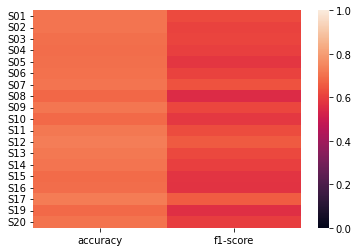

     class0 f1-score  class1 f1-score
S01         0.822642         0.175439
S02         0.824373         0.140351
S03         0.817869         0.131148
S04         0.816720         0.095238
S05         0.822695         0.000000
S06         0.823129         0.071429
S07         0.819113         0.231884
S08         0.810289         0.000000
S09         0.829114         0.100000
S10         0.810289         0.092308
S11         0.832740         0.113208
S12         0.833333         0.250000
S13         0.828283         0.163934
S14         0.825083         0.101695
S15         0.814332         0.033898
S16         0.819355         0.000000
S17         0.829630         0.258065
S19         0.811688         0.033333
S20         0.825083         0.070175


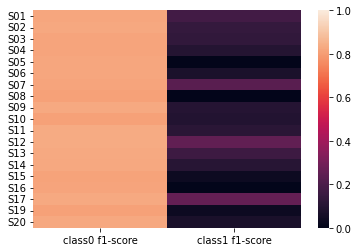

In [6]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [7]:
from sklearn.preprocessing import MinMaxScaler

participants_w_list=[]

for i in range(len(participants)):

    w= pickle.load(
        open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-DF_TS-w-e{EPOCH}.pkl", "rb") 
                    )  
    participants_w_list.append(w)
    
avg_w= np.array(participants_w_list).mean(axis=0)
# scaler= MinMaxScaler()
# scaled_avg_w= scaler.fit_transform(avg_w)

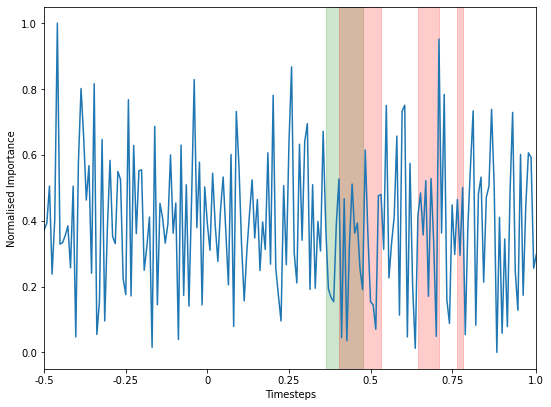

In [8]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler

plt.figure(figsize=(8,6))


scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.reshape(-1,1))
df= pd.DataFrame(scaled_avg_w)
# df.index= channel_names
# df.columns=timestep_labels


plt.plot(df)
# plt.legend(methods)
plt.xlabel("Timesteps")
plt.axvspan(107,121, color="green", alpha=0.2)
plt.axvspan(112,128, color="red", alpha=0.2)
plt.axvspan(142,150, color="red", alpha=0.2)
plt.axvspan(157,159, color="red", alpha=0.2)
plt.xticks([0,31,62,93,124,155,187],[-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
plt.ylabel("Normalised Importance")
plt.margins(x=0)
matplotlib.rcParams.update({"font.size":18})
plt.tight_layout()
#     sns.heatmap(df.sum().to_numpy().reshape(-1,1),annot=True, 
#                 yticklabels=timestep_labels, ax=ax[i][1],
#                 xticklabels=False, cbar_kws={"pad":0.02})